Library:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, TensorDataset, DataLoader, random_split, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from google.colab import drive

from sklearn.model_selection import KFold
from tqdm import tqdm

import subprocess
import sys

import os

from collections import Counter
from imblearn.over_sampling import SMOTE

try:
  from coral_pytorch.losses import CornLoss
  from coral_pytorch.dataset import corn_label_from_logits
except ImportError:
  subprocess.check_call([sys.executable, "-m", "pip", "install", "coral-pytorch"])
  from coral_pytorch.losses import CornLoss
  from coral_pytorch.dataset import corn_label_from_logits

GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Access Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model_path = '/content/drive/MyDrive/STAT441_kaggle_model/FFNN'  # Replace with your desired path
if not os.path.exists(model_path):
  os.makedirs(model_path)

##Load Data & Data Processing##

Set Seed

In [5]:
torch.manual_seed(2663)
torch.cuda.manual_seed(2663)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

load data

In [6]:
train_file_path = '/content/drive/MyDrive/STAT441_kaggle_data/Xy_train.npz'
train_data = np.load(train_file_path)
X_train = train_data['X']
y_train = train_data['y']

test_file_path = '/content/drive/MyDrive/STAT441_kaggle_data/X_test.npz'
test_data = np.load(test_file_path)
X_test = test_data['X']

In [7]:
# Check the Shape of the Arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)

input_size = X_train.shape[1]
print("Input Size:", input_size)

Shape of X_train: (400000, 2134)
Shape of y_train: (400000,)
Shape of X_test: (100000, 2134)
Input Size: 2134


Identify Columns with Zero Variance & Remove Duplicates

In [8]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

zero_variance_columns = X_train_df.var() == 0

X_train_df = X_train_df.loc[:, ~zero_variance_columns]
X_test_df = X_test_df.loc[:, ~zero_variance_columns]

X_train = X_train_df.values
X_test = X_test_df.values

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (400000, 2113)
Shape of y_train: (400000,)
Shape of X_test: (100000, 2113)


In [9]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

with open("/content/drive/MyDrive/STAT441_kaggle_data/non_duplicate_columns.txt", 'r') as f:
  non_duplicate_cols = [line.strip() for line in f]

# Now, whenever you have a new DataFrame, simply call this function
correct_column_indices = [int(col) for col in non_duplicate_cols]  # Convert to integers if necessary
X_train_df = X_train_df[correct_column_indices]
X_test_df = X_test_df[correct_column_indices]

X_train = X_train_df.values
X_test = X_test_df.values

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

input_size = X_train.shape[1]
print("Input Size:", input_size)

Shape of X_train: (400000, 2096)
Shape of X_test: (100000, 2096)
Input Size: 2096


###Oversample (NOT USED! DON'T RUN IT)###

In [ ]:
def visualize_label(y_train):
  plt.hist(y_train, bins=np.arange(-0.5, 8, 1), alpha=0.7, color='blue', edgecolor='black')
  plt.title('Class Distribution')
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  plt.xticks(np.arange(0, 8, 1))
  plt.show()

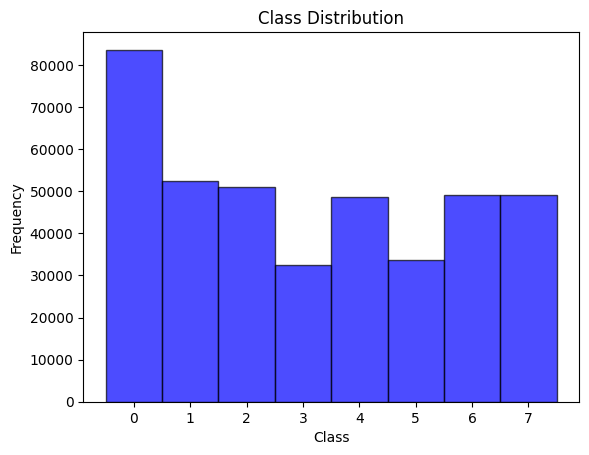

Class=7, n=83616 (12.500%)
Class=6, n=83616 (12.500%)
Class=0, n=83616 (12.500%)
Class=5, n=83616 (12.500%)
Class=1, n=83616 (12.500%)
Class=3, n=83616 (12.500%)
Class=2, n=83616 (12.500%)
Class=4, n=83616 (12.500%)


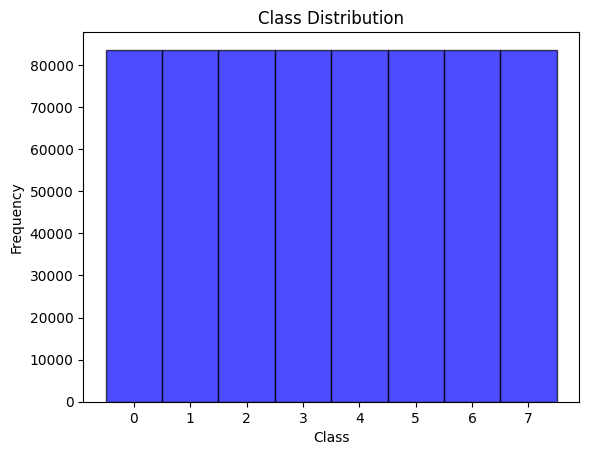

In [ ]:
visualize_label(y_train)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
  per = v / len(y_train) * 100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

visualize_label(y_train)

###Prepare Standard Normalization Data###

In [10]:
standard_scaler = StandardScaler()
X_train_standard_normalized = standard_scaler.fit_transform(X_train)
X_test_standard_normalized = standard_scaler.transform(X_test)
y_train_tensor = torch.Tensor(y_train)

X_train_standard_normalized_tensor = torch.Tensor(X_train_standard_normalized)
print('train x standard normalized format: ', X_train_standard_normalized_tensor.shape, X_train_standard_normalized_tensor.dtype)

train_standard_normalized_dataset = TensorDataset(X_train_standard_normalized_tensor, y_train_tensor)

train x standard normalized format:  torch.Size([400000, 2096]) torch.float32


In [11]:
X_test_standard_normalized_tensor = torch.Tensor(X_test_standard_normalized)
print('test x standard normalized format: ', X_test_standard_normalized_tensor.shape, X_test_standard_normalized_tensor.dtype)

test_standard_normalized_dataset = TensorDataset(X_test_standard_normalized_tensor)
test_standard_normalized_dataloader = DataLoader(test_standard_normalized_dataset, batch_size = 1)

test x standard normalized format:  torch.Size([100000, 2096]) torch.float32


Noise Injection

In [12]:
def add_gaussian_noise(tensor, noise_level=0.1):
    return tensor + torch.randn(tensor.size()) * noise_level

# Apply noise to the training data
X_train_noisy_01 = add_gaussian_noise(X_train_standard_normalized_tensor, noise_level=0.1)

# Create TensorDataset with the noisy data
train_noisy_dataset_01 = TensorDataset(X_train_noisy_01, y_train_tensor)

# Apply noise to the training data
X_train_noisy_001 = add_gaussian_noise(X_train_standard_normalized_tensor, noise_level=0.01)

# Create TensorDataset with the noisy data
train_noisy_dataset_001 = TensorDataset(X_train_noisy_001, y_train_tensor)

Model Definition

In [13]:
class FFNN(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size, dropout_rates, batch_norm=False):
    super(FFNN, self).__init__()
    self.layers = nn.ModuleList()  # ModuleList to hold all layers
    self.hidden_sizes = hidden_sizes
    self.dropout_rates = dropout_rates

    # Create layers based on the hidden_sizes and dropout_rates
    last_size = input_size
    for hidden_size, dropout_rate in zip(hidden_sizes, dropout_rates):
      self.layers.append(nn.Linear(last_size, hidden_size))
      if batch_norm:
        self.layers.append(nn.BatchNorm1d(hidden_size))
      self.layers.append(nn.Dropout(dropout_rate))
      last_size = hidden_size

    # Output layer
    self.layers.append(nn.Linear(last_size, output_size))

  def forward(self, x):
    for layer in self.layers[:-1]:
      if isinstance(layer, nn.Linear):
        x = F.relu(layer(x))
      else:
        x = layer(x)
    # No activation function in the last layer
    x = self.layers[-1](x)
    return x

  def generate_filename(self):
    filename = "FFNN_" + "_".join(f"{hs}-{dr}" for hs, dr in zip(self.hidden_sizes, self.dropout_rates))
    return filename


#Def for K fold#

##Def for K fold##

In [ ]:
def k_fold_cv(hyperparameters, k_folds = 5):
  kfold = KFold(n_splits=k_folds, shuffle=True)

  dataset = train_standard_normalized_dataset

  performances = []
  for params in hyperparameters:
    print(f"Testing model with {params}")
    fold_performance = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      total_epochs = params["total_epochs"]

      # Split dataset
      train_subsampler = Subset(dataset, train_ids)
      test_subsampler = Subset(dataset, test_ids)

      # Create data loaders for training and validation
      train_loader = DataLoader(train_subsampler, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_subsampler, batch_size=params["batch_size"], pin_memory=True)  # Batch size for validation can be 1

      # Instantiate model, loss function, and optimizer
      model = FFNN(input_size, params['hidden_layer'], 1, params["dropout_rate"], params["batch_norm"]).to(device)
      criterion = nn.L1Loss()
      optimizer = params['optimizer'](model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

      # Create data loaders for training and validation

      # Retraining loop
      for epoch in tqdm(range(total_epochs)):
        running_loss = 0.0
        total_mae = 0.0
        total_samples = 0
        model.train()
        for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs).squeeze()
          loss = criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Compute MAE
          clamped_outputs = torch.clamp(outputs, 0, 7).round()
          total_mae += torch.sum(torch.abs(clamped_outputs - labels.float())).item()
          total_samples += labels.size(0)

        # Average loss and MAE for this epoch
        train_loss = running_loss / len(train_loader)
        train_mae = total_mae / total_samples

        if ((epoch+1)% 10 == 0):
          model.eval()
          running_loss = 0.0
          total_mae = 0.0
          total_samples = 0

          with torch.no_grad():
            for inputs, labels in test_loader:
              # Move data to the device
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs).squeeze()
              loss = criterion(outputs,labels)

              running_loss += loss.item()
              # Clamp predictions to the range [0, 7] and then round
              clamped_outputs = torch.clamp(outputs, 0, 7).round()
              total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
              total_samples += labels.size(0)

              eval_loss = running_loss / len(test_loader)
              eval_mae = total_mae / total_samples
          print(f'Epoch {epoch + 1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Test Loss: {eval_loss:.4f}, Test MAE: {eval_mae:.4f}')
      model.eval()
      running_loss = 0.0
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          # Move data to the device
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs).squeeze()
          loss = criterion(outputs,labels)

          running_loss += loss.item()
          # Clamp predictions to the range [0, 7] and then round
          clamped_outputs = torch.clamp(outputs, 0, 7).round()
          total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
          total_samples += labels.size(0)

          eval_loss = running_loss / len(test_loader)
          eval_mae = total_mae / total_samples
      print(f'Final Test MAE: {eval_mae:.4f}')
      fold_performance.append(eval_mae)  # Replace with your actual metric

    # Average performance over all folds
    avg_performance = sum(fold_performance) / len(fold_performance)
    performances.append(avg_performance)
    print(f"Average Performance for {params}: {avg_performance}")

##Def for K fold ordinal##

In [ ]:
def k_fold_cv_ordinal(hyperparameters, k_folds = 5):
  kfold = KFold(n_splits=k_folds, shuffle=True)

  dataset = train_standard_normalized_dataset

  performances = []
  for params in hyperparameters:
    print(f"Testing model with {params}")
    fold_performance = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      total_epochs = params["total_epochs"]

      # Split dataset
      train_subsampler = Subset(dataset, train_ids)
      test_subsampler = Subset(dataset, test_ids)

      # Create data loaders for training and validation
      train_loader = DataLoader(train_subsampler, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_subsampler, batch_size=params["batch_size"], pin_memory=True)  # Batch size for validation can be 1

      # Instantiate model, loss function, and optimizer
      model = FFNN(input_size, params['hidden_layer'], 7, params["dropout_rate"], params["batch_norm"]).to(device)
      train_criterion = CornLoss(8)

      # Optimizer
      optimizer = params['optimizer'](model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

      # Create data loaders for training and validation

      # Retraining loop
      for epoch in tqdm(range(total_epochs)):
        running_loss = 0.0
        total_mae = 0.0
        total_samples = 0
        model.train()
        for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs).squeeze()
          loss = train_criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Compute MAE
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels.float())).item()
          total_samples += labels.size(0)

        # Average loss and MAE for this epoch
        train_loss = running_loss / len(train_loader)
        train_mae = total_mae / total_samples

        if ((epoch+1)% 10 == 0):
          model.eval()
          total_mae = 0.0
          total_samples = 0

          with torch.no_grad():
            for inputs, labels in test_loader:
              # Move data to the device
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs).squeeze()

              # Clamp predictions to the range [0, 7] and then round
              clamped_outputs = corn_label_from_logits(outputs)
              total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
              total_samples += labels.size(0)

              eval_mae = total_mae / total_samples
          print(f'Epoch {epoch + 1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {eval_mae:.4f}')
      model.eval()
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          # Move data to the device
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs).squeeze()

          # Clamp predictions to the range [0, 7] and then round
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
          total_samples += labels.size(0)

          eval_mae = total_mae / total_samples
      print(f'Final Test MAE: {eval_mae:.4f}')
      fold_performance.append(eval_mae)  # Replace with your actual metric

    # Average performance over all folds
    avg_performance = sum(fold_performance) / len(fold_performance)
    performances.append(avg_performance)
    print(f"Average Performance for {params}: {avg_performance}")

##Def for K fold with noise and original dataset##

In [ ]:
def k_fold_cv_ordinal_noisy01(hyperparameters, k_folds = 5):
  kfold = KFold(n_splits=k_folds, shuffle=True)

  original_dataset = train_standard_normalized_dataset
  noisy_dataset = train_noisy_dataset_01

  performances = []
  for params in hyperparameters:
    print(f"Testing model with {params}")
    fold_performance = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(original_dataset)):
      total_epochs = params["total_epochs"]

      # Split dataset
      train_noisy_subsampler = Subset(noisy_dataset, train_ids)
      train_original_subsampler = Subset(original_dataset, train_ids)
      combined_train_subsampler = ConcatDataset([train_noisy_subsampler, train_original_subsampler])
      test_subsampler = Subset(original_dataset, test_ids)

      # Create data loaders for training and validation
      combined_train_loader = DataLoader(combined_train_subsampler, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_subsampler, batch_size=params["batch_size"], pin_memory=True)  # Batch size for validation can be 1

      # Instantiate model, loss function, and optimizer
      model = FFNN(input_size, params['hidden_layer'], 7, params["dropout_rate"], params["batch_norm"]).to(device)
      train_criterion = CornLoss(8)

      # Optimizer
      optimizer = params['optimizer'](model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

      # Create data loaders for training and validation

      # Retraining loop
      for epoch in tqdm(range(total_epochs)):
        running_loss = 0.0
        total_mae = 0.0
        total_samples = 0
        model.train()
        for inputs, labels in combined_train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs).squeeze()
          loss = train_criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Compute MAE
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels.float())).item()
          total_samples += labels.size(0)

        # Average loss and MAE for this epoch
        train_loss = running_loss / len(combined_train_loader)
        train_mae = total_mae / total_samples

        model.eval()
        total_mae = 0.0
        total_samples = 0

        with torch.no_grad():
          for inputs, labels in test_loader:
            # Move data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()

            # Clamp predictions to the range [0, 7] and then round
            clamped_outputs = corn_label_from_logits(outputs)
            total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
            total_samples += labels.size(0)

            eval_mae = total_mae / total_samples
        print(f'Epoch {epoch + 1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {eval_mae:.4f}')
      model.eval()
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          # Move data to the device
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs).squeeze()

          # Clamp predictions to the range [0, 7] and then round
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
          total_samples += labels.size(0)

          eval_mae = total_mae / total_samples
      print(f'Final Test MAE: {eval_mae:.4f}')
      fold_performance.append(eval_mae)  # Replace with your actual metric

    # Average performance over all folds
    avg_performance = sum(fold_performance) / len(fold_performance)
    performances.append(avg_performance)
    print(f"Average Performance for {params}: {avg_performance}")

In [ ]:
def k_fold_cv_ordinal_noisy001(hyperparameters, k_folds = 5):
  kfold = KFold(n_splits=k_folds, shuffle=True)

  original_dataset = train_standard_normalized_dataset
  noisy_dataset = train_noisy_dataset_001

  performances = []
  for params in hyperparameters:
    print(f"Testing model with {params}")
    fold_performance = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(original_dataset)):
      total_epochs = params["total_epochs"]

      # Split dataset
      train_noisy_subsampler = Subset(noisy_dataset, train_ids)
      train_original_subsampler = Subset(original_dataset, train_ids)
      combined_train_subsampler = ConcatDataset([train_noisy_subsampler, train_original_subsampler])
      test_subsampler = Subset(original_dataset, test_ids)

      # Create data loaders for training and validation
      combined_train_loader = DataLoader(combined_train_subsampler, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_subsampler, batch_size=params["batch_size"], pin_memory=True)  # Batch size for validation can be 1

      # Instantiate model, loss function, and optimizer
      model = FFNN(input_size, params['hidden_layer'], 7, params["dropout_rate"], params["batch_norm"]).to(device)
      train_criterion = CornLoss(8)

      # Optimizer
      optimizer = params['optimizer'](model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

      # Create data loaders for training and validation

      # Retraining loop
      for epoch in tqdm(range(total_epochs)):
        running_loss = 0.0
        total_mae = 0.0
        total_samples = 0
        model.train()
        for inputs, labels in combined_train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs).squeeze()
          loss = train_criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Compute MAE
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels.float())).item()
          total_samples += labels.size(0)

        # Average loss and MAE for this epoch
        train_loss = running_loss / len(combined_train_loader)
        train_mae = total_mae / total_samples

        if ((epoch+1)% 10 == 0):
          model.eval()
          total_mae = 0.0
          total_samples = 0

          with torch.no_grad():
            for inputs, labels in test_loader:
              # Move data to the device
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs).squeeze()

              # Clamp predictions to the range [0, 7] and then round
              clamped_outputs = corn_label_from_logits(outputs)
              total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
              total_samples += labels.size(0)

              eval_mae = total_mae / total_samples
          print(f'Epoch {epoch + 1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {eval_mae:.4f}')
      model.eval()
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          # Move data to the device
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs).squeeze()

          # Clamp predictions to the range [0, 7] and then round
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
          total_samples += labels.size(0)

          eval_mae = total_mae / total_samples
      print(f'Final Test MAE: {eval_mae:.4f}')
      fold_performance.append(eval_mae)  # Replace with your actual metric

    # Average performance over all folds
    avg_performance = sum(fold_performance) / len(fold_performance)
    performances.append(avg_performance)
    print(f"Average Performance for {params}: {avg_performance}")

##Def for K fold with noise only##

In [ ]:
def k_fold_cv_ordinal_only_noisy(hyperparameters, noise_set, k_folds = 5):
  kfold = KFold(n_splits=k_folds, shuffle=True)

  original_dataset = train_standard_normalized_dataset
  noisy_dataset = noise_set

  performances = []
  for params in hyperparameters:
    print(f"Testing model with {params}")
    fold_performance = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(original_dataset)):
      total_epochs = params["total_epochs"]

      # Split dataset
      train_noisy_subsampler = Subset(noisy_dataset, train_ids)
      test_subsampler = Subset(original_dataset, test_ids)

      # Create data loaders for training and validation
      train_loader = DataLoader(train_noisy_subsampler, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_subsampler, batch_size=params["batch_size"], pin_memory=True)  # Batch size for validation can be 1

      # Instantiate model, loss function, and optimizer
      model = FFNN(input_size, params['hidden_layer'], 7, params["dropout_rate"], params["batch_norm"]).to(device)
      train_criterion = CornLoss(8)

      # Optimizer
      optimizer = None
      if (params['optimizer'] == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
      elif (params['optimizer'] == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"], momentum=params["momentum"], weight_decay=params["weight_decay"])

      # Create data loaders for training and validation

      # Retraining loop
      for epoch in tqdm(range(total_epochs)):
        running_loss = 0.0
        total_mae = 0.0
        total_samples = 0
        model.train()
        for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs).squeeze()
          loss = train_criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Compute MAE
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels.float())).item()
          total_samples += labels.size(0)

        # Average loss and MAE for this epoch
        train_loss = running_loss / len(train_loader)
        train_mae = total_mae / total_samples

        model.eval()
        total_mae = 0.0
        total_samples = 0

        with torch.no_grad():
          for inputs, labels in test_loader:
            # Move data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()

            # Clamp predictions to the range [0, 7] and then round
            clamped_outputs = corn_label_from_logits(outputs)
            total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
            total_samples += labels.size(0)

            eval_mae = total_mae / total_samples
        print(f'Epoch {epoch + 1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {eval_mae:.4f}')
      model.eval()
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          # Move data to the device
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs).squeeze()

          # Clamp predictions to the range [0, 7] and then round
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
          total_samples += labels.size(0)

          eval_mae = total_mae / total_samples
      print(f'Final Test MAE: {eval_mae:.4f}')
      fold_performance.append(eval_mae)  # Replace with your actual metric

    # Average performance over all folds
    avg_performance = sum(fold_performance) / len(fold_performance)
    performances.append(avg_performance)
    print(f"Average Performance for {params}: {avg_performance}")

##Def for K fold with noise only and save model##

In [14]:
def train_k_fold_cv_ordinal_only_noisy(params, noise_set, k_folds = 5):
  kfold = KFold(n_splits=k_folds, shuffle=True)

  original_dataset = train_standard_normalized_dataset
  noisy_dataset = noise_set

  performances = []
  print(f"Testing model with {params}")
  fold_performance = []
  model_list = []

  for fold, (train_ids, test_ids) in enumerate(kfold.split(original_dataset)):
    total_epochs = params["total_epochs"]

    # Split dataset
    train_noisy_subsampler = Subset(noisy_dataset, train_ids)
    test_subsampler = Subset(original_dataset, test_ids)

    # Create data loaders for training and validation
    train_loader = DataLoader(train_noisy_subsampler, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_subsampler, batch_size=params["batch_size"], pin_memory=True)  # Batch size for validation can be 1

    # Instantiate model, loss function, and optimizer
    model = FFNN(input_size, params['hidden_layer'], 7, params["dropout_rate"], params["batch_norm"]).to(device)
    train_criterion = CornLoss(8)

    # Optimizer
    optimizer = None
    if (params['optimizer'] == "Adam"):
      optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
    elif (params['optimizer'] == "SGD"):
      optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"], momentum=params["momentum"], weight_decay=params["weight_decay"])

    # Create data loaders for training and validation

    # Retraining loop
    for epoch in tqdm(range(total_epochs)):
      running_loss = 0.0
      total_mae = 0.0
      total_samples = 0
      model.train()
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()
        loss = train_criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute MAE
        clamped_outputs = corn_label_from_logits(outputs)
        total_mae += torch.sum(torch.abs(clamped_outputs - labels.float())).item()
        total_samples += labels.size(0)

      # Average loss and MAE for this epoch
      train_loss = running_loss / len(train_loader)
      train_mae = total_mae / total_samples

      model.eval()
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          # Move data to the device
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs).squeeze()

          # Clamp predictions to the range [0, 7] and then round
          clamped_outputs = corn_label_from_logits(outputs)
          total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
          total_samples += labels.size(0)

          eval_mae = total_mae / total_samples
      print(f'Epoch {epoch + 1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {eval_mae:.4f}')
    model.eval()
    total_mae = 0.0
    total_samples = 0

    with torch.no_grad():
      for inputs, labels in test_loader:
        # Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).squeeze()

        # Clamp predictions to the range [0, 7] and then round
        clamped_outputs = corn_label_from_logits(outputs)
        total_mae += torch.sum(torch.abs(clamped_outputs - labels)).item()
        total_samples += labels.size(0)

        eval_mae = total_mae / total_samples
    print(f'Final Test MAE: {eval_mae:.4f}')
    fold_performance.append(eval_mae)  # Replace with your actual metric
    model_list.append(model)

  # Average performance over all folds
  avg_performance = sum(fold_performance) / len(fold_performance)
  performances.append(avg_performance)
  print(f"Average Performance for {params}: {avg_performance}")

  return model_list

In [15]:
def transpose(matrix):
    return list(map(list, zip(*matrix)))

def test_and_save_prediction_ordinal(model_list, msg):
  predictions_list = []
  for model in model_list:
    # Ensure the model is in evaluation mode
    model.eval()

    # List to store predictions
    predictions = []

    with torch.no_grad():
      for inputs in test_standard_normalized_dataloader:
        inputs = inputs[0]
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()

        # Process the outputs (e.g., rounding/clamping)
        processed_output = corn_label_from_logits(outputs.unsqueeze(0))
        predictions.append(int(processed_output.cpu().item()))

    predictions_list.append(predictions)

  majority_votes = []
  for predictions in transpose(predictions_list):
    count = Counter(predictions)
    majority_vote = count.most_common(1)[0][0]
    majority_votes.append(majority_vote)

  ids = range(0, X_test.shape[0])
  elements = {"ID": ids, "Predicted": majority_votes}
  predict_df = pd.DataFrame(elements)
  predict_df.to_csv(os.path.join(model_path, model.generate_filename() + msg + '_ordinal.csv'),index=False)

#Result from K fold#

##result with K fold##

In [ ]:
hyperparameters = [
  {'hidden_layer': [512, 128], 'dropout_rate': [0.5, 0.3], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 200, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.SGD},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [512, 128], 'dropout_rate': [0.5, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":0, "optimizer": torch.optim.Adam},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [128, 64, 64, 32], 'dropout_rate': [0.5, 0.4, 0.4, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [256, 128], 'dropout_rate': [0.5, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 200, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.SGD},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [256, 128], 'dropout_rate': [0.5, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [512, 128], 'dropout_rate': [0.5, 0.3], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":0, "optimizer": torch.optim.SGD},
]

k_fold_cv(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [512, 128], 'dropout_rate': [0.5, 0.3], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":0, "optimizer": torch.optim.SGD},
]

k_fold_cv(hyperparameters, 5)

##result with K fold ordinal##

In [ ]:
hyperparameters = [
  {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv_ordinal(hyperparameters, 5)

Testing model with {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 1e-05, 'optimizer': <class 'torch.optim.adam.Adam'>}


 10%|█         | 10/100 [04:15<39:09, 26.10s/it]

Epoch 10/100, Train Loss: 0.3682, Train MAE: 1.0346, Test MAE: 0.9600


 20%|██        | 20/100 [08:34<34:40, 26.01s/it]

Epoch 20/100, Train Loss: 0.3539, Train MAE: 0.9670, Test MAE: 0.8982


 30%|███       | 30/100 [12:50<30:09, 25.85s/it]

Epoch 30/100, Train Loss: 0.3453, Train MAE: 0.9282, Test MAE: 0.8595


 40%|████      | 40/100 [17:05<25:53, 25.90s/it]

Epoch 40/100, Train Loss: 0.3394, Train MAE: 0.9001, Test MAE: 0.8353


 50%|█████     | 50/100 [21:21<21:33, 25.88s/it]

Epoch 50/100, Train Loss: 0.3352, Train MAE: 0.8801, Test MAE: 0.8224


 60%|██████    | 60/100 [25:36<17:13, 25.83s/it]

Epoch 60/100, Train Loss: 0.3318, Train MAE: 0.8654, Test MAE: 0.8163


 70%|███████   | 70/100 [29:49<12:40, 25.35s/it]

Epoch 70/100, Train Loss: 0.3289, Train MAE: 0.8530, Test MAE: 0.8049


 80%|████████  | 80/100 [33:59<08:24, 25.21s/it]

Epoch 80/100, Train Loss: 0.3268, Train MAE: 0.8444, Test MAE: 0.7902


 90%|█████████ | 90/100 [38:08<04:13, 25.38s/it]

Epoch 90/100, Train Loss: 0.3250, Train MAE: 0.8362, Test MAE: 0.7941


100%|██████████| 100/100 [42:18<00:00, 25.39s/it]

Epoch 100/100, Train Loss: 0.3235, Train MAE: 0.8297, Test MAE: 0.7836


Final Test MAE: 0.7836


 10%|█         | 10/100 [04:09<38:02, 25.36s/it]

Epoch 10/100, Train Loss: 0.3667, Train MAE: 1.0291, Test MAE: 0.9633


 20%|██        | 20/100 [08:21<33:54, 25.43s/it]

Epoch 20/100, Train Loss: 0.3531, Train MAE: 0.9663, Test MAE: 0.8975


 30%|███       | 30/100 [12:33<29:37, 25.39s/it]

Epoch 30/100, Train Loss: 0.3448, Train MAE: 0.9279, Test MAE: 0.8631


 40%|████      | 40/100 [16:44<25:22, 25.37s/it]

Epoch 40/100, Train Loss: 0.3382, Train MAE: 0.8970, Test MAE: 0.8398


 50%|█████     | 50/100 [20:56<21:09, 25.39s/it]

Epoch 50/100, Train Loss: 0.3342, Train MAE: 0.8773, Test MAE: 0.8185


 60%|██████    | 60/100 [25:09<17:03, 25.58s/it]

Epoch 60/100, Train Loss: 0.3308, Train MAE: 0.8629, Test MAE: 0.8071


 70%|███████   | 70/100 [29:21<12:45, 25.51s/it]

Epoch 70/100, Train Loss: 0.3283, Train MAE: 0.8524, Test MAE: 0.7981


 80%|████████  | 80/100 [33:33<08:30, 25.53s/it]

Epoch 80/100, Train Loss: 0.3257, Train MAE: 0.8424, Test MAE: 0.7918


 90%|█████████ | 90/100 [37:45<04:15, 25.53s/it]

Epoch 90/100, Train Loss: 0.3238, Train MAE: 0.8349, Test MAE: 0.7852


100%|██████████| 100/100 [41:59<00:00, 25.20s/it]

Epoch 100/100, Train Loss: 0.3217, Train MAE: 0.8244, Test MAE: 0.7790


Final Test MAE: 0.7790


  1%|          | 1/100 [00:50<1:23:12, 50.43s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [256, 128], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv_ordinal(hyperparameters, 5)

Testing model with {'hidden_layer': [256, 128], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 1e-05, 'optimizer': <class 'torch.optim.adam.Adam'>}


 10%|█         | 10/100 [04:01<36:41, 24.46s/it]

Epoch 10/100, Train Loss: 0.3511, Train MAE: 0.9717, Test MAE: 0.9129


 20%|██        | 20/100 [08:01<32:27, 24.35s/it]

Epoch 20/100, Train Loss: 0.3306, Train MAE: 0.8788, Test MAE: 0.8205


 30%|███       | 30/100 [12:03<28:27, 24.39s/it]

Epoch 30/100, Train Loss: 0.3181, Train MAE: 0.8257, Test MAE: 0.7808


 40%|████      | 40/100 [16:06<24:36, 24.61s/it]

Epoch 40/100, Train Loss: 0.3101, Train MAE: 0.7925, Test MAE: 0.7568


 50%|█████     | 50/100 [20:08<20:31, 24.63s/it]

Epoch 50/100, Train Loss: 0.3036, Train MAE: 0.7679, Test MAE: 0.7334


 60%|██████    | 60/100 [24:11<16:18, 24.45s/it]

Epoch 60/100, Train Loss: 0.2978, Train MAE: 0.7460, Test MAE: 0.7166


 70%|███████   | 70/100 [28:13<12:17, 24.57s/it]

Epoch 70/100, Train Loss: 0.2940, Train MAE: 0.7318, Test MAE: 0.7088


 80%|████████  | 80/100 [32:13<08:07, 24.37s/it]

Epoch 80/100, Train Loss: 0.2906, Train MAE: 0.7179, Test MAE: 0.6980


 90%|█████████ | 90/100 [36:14<04:02, 24.26s/it]

Epoch 90/100, Train Loss: 0.2865, Train MAE: 0.7037, Test MAE: 0.6945


100%|██████████| 100/100 [40:13<00:00, 24.14s/it]

Epoch 100/100, Train Loss: 0.2845, Train MAE: 0.6988, Test MAE: 0.6973


Final Test MAE: 0.6973


 10%|█         | 10/100 [03:59<36:12, 24.14s/it]

Epoch 10/100, Train Loss: 0.3509, Train MAE: 0.9717, Test MAE: 0.9119


 20%|██        | 20/100 [08:00<32:33, 24.42s/it]

Epoch 20/100, Train Loss: 0.3307, Train MAE: 0.8824, Test MAE: 0.8299


 30%|███       | 30/100 [12:00<28:19, 24.28s/it]

Epoch 30/100, Train Loss: 0.3185, Train MAE: 0.8295, Test MAE: 0.7801


 40%|████      | 40/100 [16:01<24:18, 24.31s/it]

Epoch 40/100, Train Loss: 0.3097, Train MAE: 0.7921, Test MAE: 0.7557


 50%|█████     | 50/100 [20:02<20:17, 24.34s/it]

Epoch 50/100, Train Loss: 0.3029, Train MAE: 0.7657, Test MAE: 0.7431


 60%|██████    | 60/100 [24:03<16:14, 24.37s/it]

Epoch 60/100, Train Loss: 0.2984, Train MAE: 0.7480, Test MAE: 0.7249


 70%|███████   | 70/100 [28:01<12:04, 24.16s/it]

Epoch 70/100, Train Loss: 0.2944, Train MAE: 0.7336, Test MAE: 0.7182


 80%|████████  | 80/100 [32:01<08:05, 24.25s/it]

Epoch 80/100, Train Loss: 0.2903, Train MAE: 0.7190, Test MAE: 0.7055


 90%|█████████ | 90/100 [36:01<04:02, 24.21s/it]

Epoch 90/100, Train Loss: 0.2872, Train MAE: 0.7099, Test MAE: 0.7021


100%|██████████| 100/100 [40:02<00:00, 24.02s/it]

Epoch 100/100, Train Loss: 0.2847, Train MAE: 0.7002, Test MAE: 0.6928


Final Test MAE: 0.6928


 10%|█         | 10/100 [03:58<36:17, 24.19s/it]

Epoch 10/100, Train Loss: 0.3517, Train MAE: 0.9765, Test MAE: 0.9144


 10%|█         | 10/100 [04:19<38:56, 25.97s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv_ordinal(hyperparameters, 5)

Testing model with {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 1e-05, 'optimizer': <class 'torch.optim.adam.Adam'>}


 10%|█         | 10/100 [04:02<37:00, 24.67s/it]

Epoch 10/100, Train Loss: 0.3504, Train MAE: 0.9693, Test MAE: 0.9051


 20%|██        | 20/100 [08:04<32:41, 24.51s/it]

Epoch 20/100, Train Loss: 0.3286, Train MAE: 0.8742, Test MAE: 0.8108


 30%|███       | 30/100 [12:06<28:37, 24.54s/it]

Epoch 30/100, Train Loss: 0.3145, Train MAE: 0.8157, Test MAE: 0.7635


 40%|████      | 40/100 [16:08<24:28, 24.47s/it]

Epoch 40/100, Train Loss: 0.3054, Train MAE: 0.7785, Test MAE: 0.7355


 50%|█████     | 50/100 [20:10<20:26, 24.54s/it]

Epoch 50/100, Train Loss: 0.2974, Train MAE: 0.7485, Test MAE: 0.7075


 60%|██████    | 60/100 [24:12<16:22, 24.56s/it]

Epoch 60/100, Train Loss: 0.2905, Train MAE: 0.7234, Test MAE: 0.6900


 70%|███████   | 70/100 [28:14<12:12, 24.43s/it]

Epoch 70/100, Train Loss: 0.2857, Train MAE: 0.7066, Test MAE: 0.6812


 80%|████████  | 80/100 [32:15<08:06, 24.35s/it]

Epoch 80/100, Train Loss: 0.2808, Train MAE: 0.6877, Test MAE: 0.6737


 90%|█████████ | 90/100 [36:17<04:05, 24.55s/it]

Epoch 90/100, Train Loss: 0.2774, Train MAE: 0.6760, Test MAE: 0.6654


100%|██████████| 100/100 [40:18<00:00, 24.18s/it]

Epoch 100/100, Train Loss: 0.2736, Train MAE: 0.6639, Test MAE: 0.6558


Final Test MAE: 0.6558


 10%|█         | 10/100 [04:01<36:38, 24.43s/it]

Epoch 10/100, Train Loss: 0.3500, Train MAE: 0.9670, Test MAE: 0.9187


 20%|██        | 20/100 [08:03<32:31, 24.40s/it]

Epoch 20/100, Train Loss: 0.3284, Train MAE: 0.8735, Test MAE: 0.8200


 30%|███       | 30/100 [12:05<28:40, 24.58s/it]

Epoch 30/100, Train Loss: 0.3142, Train MAE: 0.8130, Test MAE: 0.7605


 40%|████      | 40/100 [16:08<24:34, 24.58s/it]

Epoch 40/100, Train Loss: 0.3042, Train MAE: 0.7746, Test MAE: 0.7368


 50%|█████     | 50/100 [20:09<20:21, 24.43s/it]

Epoch 50/100, Train Loss: 0.2971, Train MAE: 0.7466, Test MAE: 0.7145


 60%|██████    | 60/100 [24:10<16:19, 24.49s/it]

Epoch 60/100, Train Loss: 0.2910, Train MAE: 0.7258, Test MAE: 0.6913


 70%|███████   | 70/100 [28:11<12:08, 24.29s/it]

Epoch 70/100, Train Loss: 0.2861, Train MAE: 0.7056, Test MAE: 0.6796


 80%|████████  | 80/100 [32:12<08:08, 24.43s/it]

Epoch 80/100, Train Loss: 0.2811, Train MAE: 0.6895, Test MAE: 0.6694


 90%|█████████ | 90/100 [36:12<04:02, 24.30s/it]

Epoch 90/100, Train Loss: 0.2772, Train MAE: 0.6749, Test MAE: 0.6689


100%|██████████| 100/100 [40:12<00:00, 24.13s/it]

Epoch 100/100, Train Loss: 0.2748, Train MAE: 0.6673, Test MAE: 0.6483


Final Test MAE: 0.6483


 10%|█         | 10/100 [03:58<36:15, 24.17s/it]

Epoch 10/100, Train Loss: 0.3504, Train MAE: 0.9695, Test MAE: 0.9061


 20%|██        | 20/100 [07:56<32:17, 24.21s/it]

Epoch 20/100, Train Loss: 0.3285, Train MAE: 0.8737, Test MAE: 0.8181


 30%|███       | 30/100 [11:55<28:06, 24.10s/it]

Epoch 30/100, Train Loss: 0.3148, Train MAE: 0.8171, Test MAE: 0.7752


 40%|████      | 40/100 [15:54<24:14, 24.25s/it]

Epoch 40/100, Train Loss: 0.3045, Train MAE: 0.7754, Test MAE: 0.7327


 50%|█████     | 50/100 [19:54<20:14, 24.30s/it]

Epoch 50/100, Train Loss: 0.2969, Train MAE: 0.7465, Test MAE: 0.7086


 60%|██████    | 60/100 [23:52<16:03, 24.09s/it]

Epoch 60/100, Train Loss: 0.2900, Train MAE: 0.7212, Test MAE: 0.6917


 70%|███████   | 70/100 [27:51<12:07, 24.25s/it]

Epoch 70/100, Train Loss: 0.2855, Train MAE: 0.7053, Test MAE: 0.6779


 80%|████████  | 80/100 [31:50<08:00, 24.02s/it]

Epoch 80/100, Train Loss: 0.2810, Train MAE: 0.6880, Test MAE: 0.6665


 90%|█████████ | 90/100 [35:41<03:54, 23.45s/it]

Epoch 90/100, Train Loss: 0.2768, Train MAE: 0.6748, Test MAE: 0.6556


100%|██████████| 100/100 [39:33<00:00, 23.74s/it]

Epoch 100/100, Train Loss: 0.2737, Train MAE: 0.6651, Test MAE: 0.6613


Final Test MAE: 0.6613


 10%|█         | 10/100 [03:52<35:17, 23.53s/it]

Epoch 10/100, Train Loss: 0.3504, Train MAE: 0.9739, Test MAE: 0.9028


 20%|██        | 20/100 [07:45<31:35, 23.70s/it]

Epoch 20/100, Train Loss: 0.3286, Train MAE: 0.8766, Test MAE: 0.8101


 30%|███       | 30/100 [11:38<27:36, 23.66s/it]

Epoch 30/100, Train Loss: 0.3151, Train MAE: 0.8196, Test MAE: 0.7625


 40%|████      | 40/100 [15:32<23:38, 23.64s/it]

Epoch 40/100, Train Loss: 0.3049, Train MAE: 0.7769, Test MAE: 0.7365


 50%|█████     | 50/100 [19:24<19:28, 23.36s/it]

Epoch 50/100, Train Loss: 0.2973, Train MAE: 0.7477, Test MAE: 0.7065


 60%|██████    | 60/100 [23:14<15:34, 23.37s/it]

Epoch 60/100, Train Loss: 0.2908, Train MAE: 0.7238, Test MAE: 0.6884


 70%|███████   | 70/100 [27:07<11:48, 23.61s/it]

Epoch 70/100, Train Loss: 0.2857, Train MAE: 0.7047, Test MAE: 0.6803


 80%|████████  | 80/100 [30:59<07:48, 23.42s/it]

Epoch 80/100, Train Loss: 0.2813, Train MAE: 0.6911, Test MAE: 0.6768


 90%|█████████ | 90/100 [34:52<03:57, 23.75s/it]

Epoch 90/100, Train Loss: 0.2770, Train MAE: 0.6767, Test MAE: 0.6545


100%|██████████| 100/100 [38:48<00:00, 23.29s/it]

Epoch 100/100, Train Loss: 0.2733, Train MAE: 0.6623, Test MAE: 0.6451


Final Test MAE: 0.6451


 10%|█         | 10/100 [03:57<36:07, 24.08s/it]

Epoch 10/100, Train Loss: 0.3500, Train MAE: 0.9692, Test MAE: 0.9077


 20%|██        | 20/100 [07:51<31:29, 23.62s/it]

Epoch 20/100, Train Loss: 0.3283, Train MAE: 0.8716, Test MAE: 0.8166


 30%|███       | 30/100 [11:48<27:51, 23.88s/it]

Epoch 30/100, Train Loss: 0.3146, Train MAE: 0.8155, Test MAE: 0.7661


 40%|████      | 40/100 [15:43<23:43, 23.72s/it]

Epoch 40/100, Train Loss: 0.3049, Train MAE: 0.7772, Test MAE: 0.7307


 50%|█████     | 50/100 [19:38<19:49, 23.80s/it]

Epoch 50/100, Train Loss: 0.2967, Train MAE: 0.7455, Test MAE: 0.7044


 60%|██████    | 60/100 [23:33<15:48, 23.71s/it]

Epoch 60/100, Train Loss: 0.2905, Train MAE: 0.7242, Test MAE: 0.6974


 70%|███████   | 70/100 [27:27<11:51, 23.71s/it]

Epoch 70/100, Train Loss: 0.2854, Train MAE: 0.7038, Test MAE: 0.6777


 80%|████████  | 80/100 [31:21<07:54, 23.71s/it]

Epoch 80/100, Train Loss: 0.2808, Train MAE: 0.6879, Test MAE: 0.6648


 90%|█████████ | 90/100 [35:14<03:56, 23.64s/it]

Epoch 90/100, Train Loss: 0.2769, Train MAE: 0.6739, Test MAE: 0.6593


100%|██████████| 100/100 [39:07<00:00, 23.47s/it]

Epoch 100/100, Train Loss: 0.2732, Train MAE: 0.6624, Test MAE: 0.6486


Final Test MAE: 0.6486
Average Performance for {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 1e-05, 'optimizer': <class 'torch.optim.adam.Adam'>}: 0.6518075000000001


##result with noise and original data##

In [ ]:
hyperparameters = [
  {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv_ordinal_noisy01(hyperparameters, 5)

In [ ]:
hyperparameters = [
  {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, "weight_decay":1e-5, "optimizer": torch.optim.Adam},
]

k_fold_cv_ordinal_noisy001(hyperparameters, 5)

Testing model with {'hidden_layer': [128, 64, 32], 'dropout_rate': [0.5, 0.3, 0.3], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, 'weight_decay': 1e-05, 'optimizer': <class 'torch.optim.adam.Adam'>}


 20%|██        | 10/50 [07:56<32:00, 48.02s/it]

Epoch 10/50, Train Loss: 0.3539, Train MAE: 0.9683, Test MAE: 0.8965


 40%|████      | 20/50 [15:51<23:51, 47.71s/it]

Epoch 20/50, Train Loss: 0.3395, Train MAE: 0.9020, Test MAE: 0.8386


 60%|██████    | 30/50 [23:49<16:01, 48.09s/it]

Epoch 30/50, Train Loss: 0.3314, Train MAE: 0.8645, Test MAE: 0.7994


 80%|████████  | 40/50 [31:47<08:01, 48.10s/it]

Epoch 40/50, Train Loss: 0.3257, Train MAE: 0.8413, Test MAE: 0.7951


100%|██████████| 50/50 [39:52<00:00, 47.84s/it]

Epoch 50/50, Train Loss: 0.3225, Train MAE: 0.8276, Test MAE: 0.7790


Final Test MAE: 0.7790


 20%|██        | 10/50 [07:58<31:56, 47.91s/it]

Epoch 10/50, Train Loss: 0.3534, Train MAE: 0.9680, Test MAE: 0.8954


 40%|████      | 20/50 [15:59<24:21, 48.72s/it]

Epoch 20/50, Train Loss: 0.3394, Train MAE: 0.9034, Test MAE: 0.8365


 60%|██████    | 30/50 [23:56<15:57, 47.89s/it]

Epoch 30/50, Train Loss: 0.3314, Train MAE: 0.8665, Test MAE: 0.8136


 80%|████████  | 40/50 [31:52<07:59, 47.95s/it]

Epoch 40/50, Train Loss: 0.3265, Train MAE: 0.8458, Test MAE: 0.7978


100%|██████████| 50/50 [39:51<00:00, 47.83s/it]

Epoch 50/50, Train Loss: 0.3228, Train MAE: 0.8298, Test MAE: 0.7814


Final Test MAE: 0.7814


 12%|█▏        | 6/50 [04:47<35:07, 47.89s/it]

In [ ]:
hyperparameters = [
  {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, "weight_decay":1e-3, "optimizer": torch.optim.Adam},
]

k_fold_cv_ordinal_noisy01(hyperparameters, 5)

Testing model with {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


  2%|▏         | 1/50 [00:47<38:47, 47.49s/it]

Epoch 1/50, Train Loss: 0.4367, Train MAE: 1.3504, Test MAE: 1.0851


  4%|▍         | 2/50 [01:35<38:02, 47.56s/it]

Epoch 2/50, Train Loss: 0.3872, Train MAE: 1.1205, Test MAE: 1.0379


  6%|▌         | 3/50 [02:22<37:09, 47.44s/it]

Epoch 3/50, Train Loss: 0.3788, Train MAE: 1.0841, Test MAE: 1.0093


  8%|▊         | 4/50 [03:09<36:20, 47.39s/it]

Epoch 4/50, Train Loss: 0.3733, Train MAE: 1.0592, Test MAE: 0.9952


 10%|█         | 5/50 [03:56<35:28, 47.30s/it]

Epoch 5/50, Train Loss: 0.3692, Train MAE: 1.0391, Test MAE: 0.9758


 12%|█▏        | 6/50 [04:45<34:56, 47.64s/it]

Epoch 6/50, Train Loss: 0.3664, Train MAE: 1.0269, Test MAE: 0.9639


 14%|█▍        | 7/50 [05:33<34:13, 47.77s/it]

Epoch 7/50, Train Loss: 0.3644, Train MAE: 1.0180, Test MAE: 0.9544


 16%|█▌        | 8/50 [06:21<33:33, 47.95s/it]

Epoch 8/50, Train Loss: 0.3630, Train MAE: 1.0108, Test MAE: 0.9517


 18%|█▊        | 9/50 [07:09<32:46, 47.96s/it]

Epoch 9/50, Train Loss: 0.3616, Train MAE: 1.0059, Test MAE: 0.9457


 20%|██        | 10/50 [07:57<32:04, 48.11s/it]

Epoch 10/50, Train Loss: 0.3606, Train MAE: 1.0013, Test MAE: 0.9401


 22%|██▏       | 11/50 [08:45<31:10, 47.97s/it]

Epoch 11/50, Train Loss: 0.3596, Train MAE: 0.9949, Test MAE: 0.9327


 24%|██▍       | 12/50 [09:33<30:24, 48.02s/it]

Epoch 12/50, Train Loss: 0.3593, Train MAE: 0.9943, Test MAE: 0.9295


 26%|██▌       | 13/50 [10:22<29:42, 48.16s/it]

Epoch 13/50, Train Loss: 0.3584, Train MAE: 0.9901, Test MAE: 0.9238


 28%|██▊       | 14/50 [11:09<28:47, 47.99s/it]

Epoch 14/50, Train Loss: 0.3578, Train MAE: 0.9863, Test MAE: 0.9271


 30%|███       | 15/50 [11:57<27:55, 47.87s/it]

Epoch 15/50, Train Loss: 0.3573, Train MAE: 0.9858, Test MAE: 0.9258


 32%|███▏      | 16/50 [12:44<26:59, 47.64s/it]

Epoch 16/50, Train Loss: 0.3569, Train MAE: 0.9838, Test MAE: 0.9214


 34%|███▍      | 17/50 [13:32<26:17, 47.82s/it]

Epoch 17/50, Train Loss: 0.3567, Train MAE: 0.9828, Test MAE: 0.9108


 36%|███▌      | 18/50 [14:20<25:27, 47.73s/it]

Epoch 18/50, Train Loss: 0.3561, Train MAE: 0.9798, Test MAE: 0.9226


 38%|███▊      | 19/50 [15:08<24:42, 47.83s/it]

Epoch 19/50, Train Loss: 0.3560, Train MAE: 0.9796, Test MAE: 0.9307


 40%|████      | 20/50 [15:56<23:57, 47.93s/it]

Epoch 20/50, Train Loss: 0.3554, Train MAE: 0.9758, Test MAE: 0.9170


 42%|████▏     | 21/50 [16:44<23:07, 47.83s/it]

Epoch 21/50, Train Loss: 0.3556, Train MAE: 0.9783, Test MAE: 0.9094


 44%|████▍     | 22/50 [17:31<22:15, 47.70s/it]

Epoch 22/50, Train Loss: 0.3554, Train MAE: 0.9760, Test MAE: 0.9054


 46%|████▌     | 23/50 [18:19<21:28, 47.74s/it]

Epoch 23/50, Train Loss: 0.3552, Train MAE: 0.9746, Test MAE: 0.9082


 48%|████▊     | 24/50 [19:06<20:38, 47.64s/it]

Epoch 24/50, Train Loss: 0.3547, Train MAE: 0.9738, Test MAE: 0.9151


 50%|█████     | 25/50 [19:53<19:44, 47.38s/it]

Epoch 25/50, Train Loss: 0.3546, Train MAE: 0.9731, Test MAE: 0.9109


 52%|█████▏    | 26/50 [20:41<18:59, 47.48s/it]

Epoch 26/50, Train Loss: 0.3544, Train MAE: 0.9719, Test MAE: 0.9253


 54%|█████▍    | 27/50 [21:27<18:06, 47.26s/it]

Epoch 27/50, Train Loss: 0.3543, Train MAE: 0.9716, Test MAE: 0.9064


 56%|█████▌    | 28/50 [22:15<17:21, 47.36s/it]

Epoch 28/50, Train Loss: 0.3541, Train MAE: 0.9717, Test MAE: 0.9053


 58%|█████▊    | 29/50 [23:02<16:32, 47.25s/it]

Epoch 29/50, Train Loss: 0.3539, Train MAE: 0.9699, Test MAE: 0.9053


 60%|██████    | 30/50 [23:50<15:46, 47.34s/it]

Epoch 30/50, Train Loss: 0.3537, Train MAE: 0.9686, Test MAE: 0.9134


 62%|██████▏   | 31/50 [24:36<14:56, 47.19s/it]

Epoch 31/50, Train Loss: 0.3534, Train MAE: 0.9676, Test MAE: 0.9009


 64%|██████▍   | 32/50 [25:23<14:07, 47.09s/it]

Epoch 32/50, Train Loss: 0.3534, Train MAE: 0.9670, Test MAE: 0.8998


 66%|██████▌   | 33/50 [26:10<13:20, 47.08s/it]

Epoch 33/50, Train Loss: 0.3535, Train MAE: 0.9678, Test MAE: 0.9031


 68%|██████▊   | 34/50 [26:57<12:32, 47.06s/it]

Epoch 34/50, Train Loss: 0.3530, Train MAE: 0.9665, Test MAE: 0.9091


 70%|███████   | 35/50 [27:45<11:47, 47.17s/it]

Epoch 35/50, Train Loss: 0.3531, Train MAE: 0.9672, Test MAE: 0.8974


 72%|███████▏  | 36/50 [28:32<10:58, 47.05s/it]

Epoch 36/50, Train Loss: 0.3528, Train MAE: 0.9640, Test MAE: 0.9030


 74%|███████▍  | 37/50 [29:18<10:10, 46.97s/it]

Epoch 37/50, Train Loss: 0.3531, Train MAE: 0.9656, Test MAE: 0.9066


 76%|███████▌  | 38/50 [30:05<09:24, 47.00s/it]

Epoch 38/50, Train Loss: 0.3531, Train MAE: 0.9659, Test MAE: 0.9134


 78%|███████▊  | 39/50 [30:52<08:35, 46.88s/it]

Epoch 39/50, Train Loss: 0.3527, Train MAE: 0.9660, Test MAE: 0.9074


 80%|████████  | 40/50 [31:39<07:48, 46.89s/it]

Epoch 40/50, Train Loss: 0.3530, Train MAE: 0.9648, Test MAE: 0.8925


 82%|████████▏ | 41/50 [32:26<07:01, 46.80s/it]

Epoch 41/50, Train Loss: 0.3526, Train MAE: 0.9631, Test MAE: 0.8987


 84%|████████▍ | 42/50 [33:13<06:15, 47.00s/it]

Epoch 42/50, Train Loss: 0.3525, Train MAE: 0.9643, Test MAE: 0.8991


 86%|████████▌ | 43/50 [34:00<05:29, 47.00s/it]

Epoch 43/50, Train Loss: 0.3527, Train MAE: 0.9638, Test MAE: 0.9002


 88%|████████▊ | 44/50 [34:47<04:41, 46.98s/it]

Epoch 44/50, Train Loss: 0.3526, Train MAE: 0.9635, Test MAE: 0.8967


 90%|█████████ | 45/50 [35:34<03:54, 46.98s/it]

Epoch 45/50, Train Loss: 0.3523, Train MAE: 0.9621, Test MAE: 0.8983


 92%|█████████▏| 46/50 [36:21<03:07, 46.88s/it]

Epoch 46/50, Train Loss: 0.3522, Train MAE: 0.9628, Test MAE: 0.9055


 94%|█████████▍| 47/50 [37:08<02:20, 46.96s/it]

Epoch 47/50, Train Loss: 0.3524, Train MAE: 0.9631, Test MAE: 0.9103


 96%|█████████▌| 48/50 [37:54<01:33, 46.87s/it]

Epoch 48/50, Train Loss: 0.3523, Train MAE: 0.9624, Test MAE: 0.9006


 98%|█████████▊| 49/50 [38:41<00:46, 46.92s/it]

Epoch 49/50, Train Loss: 0.3524, Train MAE: 0.9640, Test MAE: 0.8941


100%|██████████| 50/50 [39:28<00:00, 47.37s/it]

Epoch 50/50, Train Loss: 0.3525, Train MAE: 0.9641, Test MAE: 0.9118


Final Test MAE: 0.9118


  2%|▏         | 1/50 [00:46<38:11, 46.76s/it]

Epoch 1/50, Train Loss: 0.4359, Train MAE: 1.3530, Test MAE: 1.0728


  4%|▍         | 2/50 [01:33<37:30, 46.89s/it]

Epoch 2/50, Train Loss: 0.3867, Train MAE: 1.1197, Test MAE: 1.0354


  6%|▌         | 3/50 [02:20<36:46, 46.94s/it]

Epoch 3/50, Train Loss: 0.3779, Train MAE: 1.0810, Test MAE: 1.0096


  8%|▊         | 4/50 [03:07<35:57, 46.89s/it]

Epoch 4/50, Train Loss: 0.3725, Train MAE: 1.0564, Test MAE: 0.9807


 10%|█         | 5/50 [03:54<35:06, 46.81s/it]

Epoch 5/50, Train Loss: 0.3689, Train MAE: 1.0411, Test MAE: 0.9693


 12%|█▏        | 6/50 [04:42<34:44, 47.37s/it]

Epoch 6/50, Train Loss: 0.3659, Train MAE: 1.0271, Test MAE: 0.9550


 14%|█▍        | 7/50 [05:29<33:45, 47.10s/it]

Epoch 7/50, Train Loss: 0.3639, Train MAE: 1.0177, Test MAE: 0.9439


 16%|█▌        | 8/50 [06:16<33:04, 47.25s/it]

Epoch 8/50, Train Loss: 0.3624, Train MAE: 1.0104, Test MAE: 0.9386


 18%|█▊        | 9/50 [07:04<32:21, 47.35s/it]

Epoch 9/50, Train Loss: 0.3610, Train MAE: 1.0049, Test MAE: 0.9443


 20%|██        | 10/50 [07:53<31:56, 47.90s/it]

Epoch 10/50, Train Loss: 0.3600, Train MAE: 0.9990, Test MAE: 0.9284


 22%|██▏       | 11/50 [08:40<31:00, 47.70s/it]

Epoch 11/50, Train Loss: 0.3592, Train MAE: 0.9965, Test MAE: 0.9227


 24%|██▍       | 12/50 [09:28<30:10, 47.65s/it]

Epoch 12/50, Train Loss: 0.3582, Train MAE: 0.9917, Test MAE: 0.9274


 26%|██▌       | 13/50 [10:15<29:13, 47.38s/it]

Epoch 13/50, Train Loss: 0.3578, Train MAE: 0.9887, Test MAE: 0.9226


 28%|██▊       | 14/50 [11:02<28:21, 47.28s/it]

Epoch 14/50, Train Loss: 0.3572, Train MAE: 0.9873, Test MAE: 0.9157


 30%|███       | 15/50 [11:49<27:34, 47.27s/it]

Epoch 15/50, Train Loss: 0.3571, Train MAE: 0.9868, Test MAE: 0.9084


 32%|███▏      | 16/50 [12:36<26:47, 47.27s/it]

Epoch 16/50, Train Loss: 0.3564, Train MAE: 0.9837, Test MAE: 0.9223


 34%|███▍      | 17/50 [13:23<25:59, 47.26s/it]

Epoch 17/50, Train Loss: 0.3563, Train MAE: 0.9838, Test MAE: 0.9018


 36%|███▌      | 18/50 [14:11<25:11, 47.24s/it]

Epoch 18/50, Train Loss: 0.3555, Train MAE: 0.9794, Test MAE: 0.9058


 38%|███▊      | 19/50 [14:58<24:25, 47.26s/it]

Epoch 19/50, Train Loss: 0.3555, Train MAE: 0.9793, Test MAE: 0.9065


 40%|████      | 20/50 [15:45<23:34, 47.15s/it]

Epoch 20/50, Train Loss: 0.3554, Train MAE: 0.9789, Test MAE: 0.9042


 42%|████▏     | 21/50 [16:32<22:44, 47.04s/it]

Epoch 21/50, Train Loss: 0.3550, Train MAE: 0.9771, Test MAE: 0.9174


 44%|████▍     | 22/50 [17:19<22:01, 47.20s/it]

Epoch 22/50, Train Loss: 0.3548, Train MAE: 0.9764, Test MAE: 0.9103


 46%|████▌     | 23/50 [18:06<21:11, 47.08s/it]

Epoch 23/50, Train Loss: 0.3546, Train MAE: 0.9768, Test MAE: 0.9060


 48%|████▊     | 24/50 [18:53<20:25, 47.14s/it]

Epoch 24/50, Train Loss: 0.3544, Train MAE: 0.9727, Test MAE: 0.9012


 50%|█████     | 25/50 [19:41<19:41, 47.25s/it]

Epoch 25/50, Train Loss: 0.3541, Train MAE: 0.9718, Test MAE: 0.9086


 52%|█████▏    | 26/50 [20:28<18:53, 47.21s/it]

Epoch 26/50, Train Loss: 0.3540, Train MAE: 0.9733, Test MAE: 0.9006


 54%|█████▍    | 27/50 [21:15<18:07, 47.27s/it]

Epoch 27/50, Train Loss: 0.3538, Train MAE: 0.9731, Test MAE: 0.8954


 56%|█████▌    | 28/50 [22:02<17:13, 46.98s/it]

Epoch 28/50, Train Loss: 0.3541, Train MAE: 0.9728, Test MAE: 0.9000


 58%|█████▊    | 29/50 [22:49<16:30, 47.17s/it]

Epoch 29/50, Train Loss: 0.3537, Train MAE: 0.9725, Test MAE: 0.8948


 60%|██████    | 30/50 [23:36<15:42, 47.14s/it]

Epoch 30/50, Train Loss: 0.3535, Train MAE: 0.9704, Test MAE: 0.9038


 62%|██████▏   | 31/50 [24:23<14:55, 47.15s/it]

Epoch 31/50, Train Loss: 0.3535, Train MAE: 0.9693, Test MAE: 0.9064


 64%|██████▍   | 32/50 [25:10<14:08, 47.12s/it]

Epoch 32/50, Train Loss: 0.3532, Train MAE: 0.9688, Test MAE: 0.9018


 66%|██████▌   | 33/50 [25:58<13:23, 47.26s/it]

Epoch 33/50, Train Loss: 0.3532, Train MAE: 0.9697, Test MAE: 0.9066


 68%|██████▊   | 34/50 [26:46<12:38, 47.40s/it]

Epoch 34/50, Train Loss: 0.3527, Train MAE: 0.9667, Test MAE: 0.9116


 70%|███████   | 35/50 [27:33<11:49, 47.33s/it]

Epoch 35/50, Train Loss: 0.3529, Train MAE: 0.9674, Test MAE: 0.9039


 72%|███████▏  | 36/50 [28:20<11:02, 47.34s/it]

Epoch 36/50, Train Loss: 0.3527, Train MAE: 0.9669, Test MAE: 0.8944


 74%|███████▍  | 37/50 [29:07<10:12, 47.14s/it]

Epoch 37/50, Train Loss: 0.3527, Train MAE: 0.9669, Test MAE: 0.9026


 76%|███████▌  | 38/50 [29:54<09:26, 47.23s/it]

Epoch 38/50, Train Loss: 0.3530, Train MAE: 0.9689, Test MAE: 0.8964


 78%|███████▊  | 39/50 [30:42<08:39, 47.25s/it]

Epoch 39/50, Train Loss: 0.3527, Train MAE: 0.9668, Test MAE: 0.8918


 80%|████████  | 40/50 [31:33<08:04, 48.48s/it]

Epoch 40/50, Train Loss: 0.3526, Train MAE: 0.9664, Test MAE: 0.8935


 82%|████████▏ | 41/50 [32:21<07:15, 48.38s/it]

Epoch 41/50, Train Loss: 0.3526, Train MAE: 0.9674, Test MAE: 0.8943


 84%|████████▍ | 42/50 [33:10<06:28, 48.55s/it]

Epoch 42/50, Train Loss: 0.3524, Train MAE: 0.9653, Test MAE: 0.8943


 86%|████████▌ | 43/50 [33:59<05:40, 48.64s/it]

Epoch 43/50, Train Loss: 0.3523, Train MAE: 0.9648, Test MAE: 0.9132


 88%|████████▊ | 44/50 [34:47<04:51, 48.58s/it]

Epoch 44/50, Train Loss: 0.3523, Train MAE: 0.9662, Test MAE: 0.8909


 90%|█████████ | 45/50 [35:36<04:02, 48.45s/it]

Epoch 45/50, Train Loss: 0.3525, Train MAE: 0.9654, Test MAE: 0.8928


 92%|█████████▏| 46/50 [36:25<03:15, 48.83s/it]

Epoch 46/50, Train Loss: 0.3524, Train MAE: 0.9664, Test MAE: 0.8899


 94%|█████████▍| 47/50 [37:16<02:27, 49.27s/it]

Epoch 47/50, Train Loss: 0.3522, Train MAE: 0.9652, Test MAE: 0.8924


 96%|█████████▌| 48/50 [38:05<01:38, 49.45s/it]

Epoch 48/50, Train Loss: 0.3521, Train MAE: 0.9651, Test MAE: 0.8981


 98%|█████████▊| 49/50 [38:56<00:49, 49.73s/it]

Epoch 49/50, Train Loss: 0.3521, Train MAE: 0.9638, Test MAE: 0.8968


100%|██████████| 50/50 [39:46<00:00, 47.74s/it]

Epoch 50/50, Train Loss: 0.3523, Train MAE: 0.9652, Test MAE: 0.8943


Final Test MAE: 0.8943


  2%|▏         | 1/50 [00:50<41:20, 50.63s/it]

Epoch 1/50, Train Loss: 0.4363, Train MAE: 1.3455, Test MAE: 1.0767


  4%|▍         | 2/50 [01:41<40:33, 50.71s/it]

Epoch 2/50, Train Loss: 0.3873, Train MAE: 1.1214, Test MAE: 1.0345


  6%|▌         | 3/50 [02:32<39:46, 50.77s/it]

Epoch 3/50, Train Loss: 0.3787, Train MAE: 1.0835, Test MAE: 1.0020


  8%|▊         | 4/50 [03:22<38:49, 50.63s/it]

Epoch 4/50, Train Loss: 0.3732, Train MAE: 1.0604, Test MAE: 0.9902


 10%|█         | 5/50 [04:12<37:51, 50.47s/it]

Epoch 5/50, Train Loss: 0.3693, Train MAE: 1.0414, Test MAE: 0.9658


 12%|█▏        | 6/50 [05:03<36:57, 50.39s/it]

Epoch 6/50, Train Loss: 0.3662, Train MAE: 1.0278, Test MAE: 0.9593


 14%|█▍        | 7/50 [05:53<36:05, 50.36s/it]

Epoch 7/50, Train Loss: 0.3644, Train MAE: 1.0202, Test MAE: 0.9567


 16%|█▌        | 8/50 [06:41<34:48, 49.74s/it]

Epoch 8/50, Train Loss: 0.3628, Train MAE: 1.0124, Test MAE: 0.9458


 18%|█▊        | 9/50 [07:29<33:36, 49.18s/it]

Epoch 9/50, Train Loss: 0.3613, Train MAE: 1.0061, Test MAE: 0.9349


 20%|██        | 10/50 [08:18<32:40, 49.02s/it]

Epoch 10/50, Train Loss: 0.3605, Train MAE: 1.0009, Test MAE: 0.9263


 22%|██▏       | 11/50 [09:06<31:38, 48.68s/it]

Epoch 11/50, Train Loss: 0.3595, Train MAE: 0.9968, Test MAE: 0.9332


 24%|██▍       | 12/50 [09:54<30:44, 48.55s/it]

Epoch 12/50, Train Loss: 0.3587, Train MAE: 0.9939, Test MAE: 0.9261


 26%|██▌       | 13/50 [10:42<29:48, 48.33s/it]

Epoch 13/50, Train Loss: 0.3579, Train MAE: 0.9906, Test MAE: 0.9219


 28%|██▊       | 14/50 [11:30<28:54, 48.18s/it]

Epoch 14/50, Train Loss: 0.3575, Train MAE: 0.9881, Test MAE: 0.9198


 30%|███       | 15/50 [12:18<28:04, 48.12s/it]

Epoch 15/50, Train Loss: 0.3569, Train MAE: 0.9849, Test MAE: 0.9163


 32%|███▏      | 16/50 [13:06<27:16, 48.13s/it]

Epoch 16/50, Train Loss: 0.3566, Train MAE: 0.9835, Test MAE: 0.9252


 34%|███▍      | 17/50 [13:54<26:32, 48.26s/it]

Epoch 17/50, Train Loss: 0.3562, Train MAE: 0.9828, Test MAE: 0.9237


 36%|███▌      | 18/50 [14:42<25:37, 48.05s/it]

Epoch 18/50, Train Loss: 0.3558, Train MAE: 0.9803, Test MAE: 0.9211


 38%|███▊      | 19/50 [15:31<24:55, 48.25s/it]

Epoch 19/50, Train Loss: 0.3556, Train MAE: 0.9800, Test MAE: 0.9057


 40%|████      | 20/50 [16:18<23:59, 47.98s/it]

Epoch 20/50, Train Loss: 0.3552, Train MAE: 0.9790, Test MAE: 0.9055


 42%|████▏     | 21/50 [17:06<23:13, 48.06s/it]

Epoch 21/50, Train Loss: 0.3553, Train MAE: 0.9783, Test MAE: 0.9045


 44%|████▍     | 22/50 [17:54<22:25, 48.04s/it]

Epoch 22/50, Train Loss: 0.3546, Train MAE: 0.9761, Test MAE: 0.9028


 46%|████▌     | 23/50 [18:42<21:35, 47.98s/it]

Epoch 23/50, Train Loss: 0.3548, Train MAE: 0.9769, Test MAE: 0.9068


 48%|████▊     | 24/50 [19:30<20:48, 48.01s/it]

Epoch 24/50, Train Loss: 0.3544, Train MAE: 0.9751, Test MAE: 0.9123


 50%|█████     | 25/50 [20:18<19:56, 47.85s/it]

Epoch 25/50, Train Loss: 0.3545, Train MAE: 0.9765, Test MAE: 0.9132


 52%|█████▏    | 26/50 [21:06<19:10, 47.93s/it]

Epoch 26/50, Train Loss: 0.3541, Train MAE: 0.9727, Test MAE: 0.8950


 54%|█████▍    | 27/50 [21:54<18:21, 47.90s/it]

Epoch 27/50, Train Loss: 0.3537, Train MAE: 0.9721, Test MAE: 0.8992


 56%|█████▌    | 28/50 [22:41<17:31, 47.81s/it]

Epoch 28/50, Train Loss: 0.3536, Train MAE: 0.9712, Test MAE: 0.8926


 58%|█████▊    | 29/50 [23:30<16:47, 47.99s/it]

Epoch 29/50, Train Loss: 0.3535, Train MAE: 0.9707, Test MAE: 0.8979


 60%|██████    | 30/50 [24:18<15:59, 48.00s/it]

Epoch 30/50, Train Loss: 0.3531, Train MAE: 0.9687, Test MAE: 0.8926


 62%|██████▏   | 31/50 [25:06<15:11, 47.96s/it]

Epoch 31/50, Train Loss: 0.3533, Train MAE: 0.9695, Test MAE: 0.9067


 64%|██████▍   | 32/50 [25:53<14:22, 47.92s/it]

Epoch 32/50, Train Loss: 0.3530, Train MAE: 0.9695, Test MAE: 0.9005


 66%|██████▌   | 33/50 [26:41<13:34, 47.92s/it]

Epoch 33/50, Train Loss: 0.3528, Train MAE: 0.9677, Test MAE: 0.9007


 68%|██████▊   | 34/50 [27:30<12:48, 48.05s/it]

Epoch 34/50, Train Loss: 0.3527, Train MAE: 0.9677, Test MAE: 0.9065


 70%|███████   | 35/50 [28:17<11:59, 47.94s/it]

Epoch 35/50, Train Loss: 0.3528, Train MAE: 0.9667, Test MAE: 0.8943


 72%|███████▏  | 36/50 [29:06<11:13, 48.10s/it]

Epoch 36/50, Train Loss: 0.3524, Train MAE: 0.9660, Test MAE: 0.8899


 74%|███████▍  | 37/50 [29:54<10:23, 47.99s/it]

Epoch 37/50, Train Loss: 0.3524, Train MAE: 0.9646, Test MAE: 0.8939


 76%|███████▌  | 38/50 [30:42<09:36, 48.03s/it]

Epoch 38/50, Train Loss: 0.3521, Train MAE: 0.9651, Test MAE: 0.8971


 78%|███████▊  | 39/50 [31:30<08:48, 48.01s/it]

Epoch 39/50, Train Loss: 0.3526, Train MAE: 0.9681, Test MAE: 0.8990


 80%|████████  | 40/50 [32:17<07:58, 47.89s/it]

Epoch 40/50, Train Loss: 0.3523, Train MAE: 0.9653, Test MAE: 0.8923


 82%|████████▏ | 41/50 [33:05<07:10, 47.86s/it]

Epoch 41/50, Train Loss: 0.3520, Train MAE: 0.9655, Test MAE: 0.9013


 84%|████████▍ | 42/50 [33:53<06:22, 47.86s/it]

Epoch 42/50, Train Loss: 0.3520, Train MAE: 0.9653, Test MAE: 0.8972


 86%|████████▌ | 43/50 [34:41<05:35, 47.93s/it]

Epoch 43/50, Train Loss: 0.3517, Train MAE: 0.9637, Test MAE: 0.9063


 88%|████████▊ | 44/50 [35:29<04:47, 47.87s/it]

Epoch 44/50, Train Loss: 0.3518, Train MAE: 0.9643, Test MAE: 0.9031


 90%|█████████ | 45/50 [36:16<03:58, 47.79s/it]

Epoch 45/50, Train Loss: 0.3515, Train MAE: 0.9610, Test MAE: 0.8968


 92%|█████████▏| 46/50 [37:04<03:11, 47.89s/it]

Epoch 46/50, Train Loss: 0.3517, Train MAE: 0.9634, Test MAE: 0.8932


 94%|█████████▍| 47/50 [37:53<02:24, 48.13s/it]

Epoch 47/50, Train Loss: 0.3517, Train MAE: 0.9634, Test MAE: 0.8876


 96%|█████████▌| 48/50 [38:42<01:36, 48.24s/it]

Epoch 48/50, Train Loss: 0.3520, Train MAE: 0.9631, Test MAE: 0.9016


 98%|█████████▊| 49/50 [39:31<00:48, 48.45s/it]

Epoch 49/50, Train Loss: 0.3518, Train MAE: 0.9629, Test MAE: 0.8879


100%|██████████| 50/50 [40:20<00:00, 48.41s/it]

Epoch 50/50, Train Loss: 0.3516, Train MAE: 0.9623, Test MAE: 0.9077


Final Test MAE: 0.9077


  2%|▏         | 1/50 [00:48<39:40, 48.59s/it]

Epoch 1/50, Train Loss: 0.4334, Train MAE: 1.3342, Test MAE: 1.0704


  4%|▍         | 2/50 [01:36<38:34, 48.22s/it]

Epoch 2/50, Train Loss: 0.3872, Train MAE: 1.1215, Test MAE: 1.0379


  6%|▌         | 3/50 [02:24<37:40, 48.10s/it]

Epoch 3/50, Train Loss: 0.3788, Train MAE: 1.0837, Test MAE: 1.0014


  8%|▊         | 4/50 [03:13<37:00, 48.27s/it]

Epoch 4/50, Train Loss: 0.3736, Train MAE: 1.0591, Test MAE: 0.9808


 10%|█         | 5/50 [04:01<36:12, 48.29s/it]

Epoch 5/50, Train Loss: 0.3697, Train MAE: 1.0422, Test MAE: 0.9646


 12%|█▏        | 6/50 [04:48<35:10, 47.97s/it]

Epoch 6/50, Train Loss: 0.3670, Train MAE: 1.0291, Test MAE: 0.9518


 14%|█▍        | 7/50 [05:36<34:26, 48.05s/it]

Epoch 7/50, Train Loss: 0.3646, Train MAE: 1.0198, Test MAE: 0.9603


 16%|█▌        | 8/50 [06:24<33:30, 47.88s/it]

Epoch 8/50, Train Loss: 0.3633, Train MAE: 1.0137, Test MAE: 0.9413


 18%|█▊        | 9/50 [07:12<32:48, 48.01s/it]

Epoch 9/50, Train Loss: 0.3620, Train MAE: 1.0067, Test MAE: 0.9305


 20%|██        | 10/50 [08:00<32:00, 48.00s/it]

Epoch 10/50, Train Loss: 0.3608, Train MAE: 1.0018, Test MAE: 0.9349


 22%|██▏       | 11/50 [08:48<31:13, 48.04s/it]

Epoch 11/50, Train Loss: 0.3600, Train MAE: 0.9974, Test MAE: 0.9254


 24%|██▍       | 12/50 [09:37<30:28, 48.11s/it]

Epoch 12/50, Train Loss: 0.3590, Train MAE: 0.9931, Test MAE: 0.9207


 26%|██▌       | 13/50 [10:25<29:44, 48.24s/it]

Epoch 13/50, Train Loss: 0.3581, Train MAE: 0.9896, Test MAE: 0.9087


 28%|██▊       | 14/50 [11:14<28:58, 48.29s/it]

Epoch 14/50, Train Loss: 0.3582, Train MAE: 0.9901, Test MAE: 0.9146


 30%|███       | 15/50 [12:02<28:16, 48.47s/it]

Epoch 15/50, Train Loss: 0.3574, Train MAE: 0.9872, Test MAE: 0.9121


 32%|███▏      | 16/50 [12:51<27:29, 48.50s/it]

Epoch 16/50, Train Loss: 0.3574, Train MAE: 0.9878, Test MAE: 0.9032


 32%|███▏      | 16/50 [13:20<28:21, 50.04s/it]


KeyboardInterrupt: ignored

##result with noise only##

In [ ]:
hyperparameters = [
  {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


  1%|          | 1/100 [00:23<38:32, 23.36s/it]

Epoch 1/100, Train Loss: 0.4687, Train MAE: 1.5270, Test MAE: 1.1105


  2%|▏         | 2/100 [00:45<37:15, 22.81s/it]

Epoch 2/100, Train Loss: 0.4033, Train MAE: 1.1763, Test MAE: 1.0753


  3%|▎         | 3/100 [01:08<36:51, 22.80s/it]

Epoch 3/100, Train Loss: 0.3905, Train MAE: 1.1359, Test MAE: 1.0464


  4%|▍         | 4/100 [01:31<36:41, 22.93s/it]

Epoch 4/100, Train Loss: 0.3842, Train MAE: 1.1094, Test MAE: 1.0259


  5%|▌         | 5/100 [01:54<36:03, 22.78s/it]

Epoch 5/100, Train Loss: 0.3799, Train MAE: 1.0906, Test MAE: 1.0179


  6%|▌         | 6/100 [02:17<35:51, 22.89s/it]

Epoch 6/100, Train Loss: 0.3769, Train MAE: 1.0763, Test MAE: 1.0004


  7%|▋         | 7/100 [02:40<35:27, 22.88s/it]

Epoch 7/100, Train Loss: 0.3741, Train MAE: 1.0634, Test MAE: 0.9928


  8%|▊         | 8/100 [03:02<35:03, 22.86s/it]

Epoch 8/100, Train Loss: 0.3723, Train MAE: 1.0559, Test MAE: 0.9871


  9%|▉         | 9/100 [03:25<34:37, 22.83s/it]

Epoch 9/100, Train Loss: 0.3702, Train MAE: 1.0465, Test MAE: 0.9735


 10%|█         | 10/100 [03:48<34:20, 22.89s/it]

Epoch 10/100, Train Loss: 0.3685, Train MAE: 1.0374, Test MAE: 0.9700


 11%|█         | 11/100 [04:11<33:56, 22.88s/it]

Epoch 11/100, Train Loss: 0.3673, Train MAE: 1.0324, Test MAE: 0.9625


 12%|█▏        | 12/100 [04:34<33:34, 22.89s/it]

Epoch 12/100, Train Loss: 0.3661, Train MAE: 1.0275, Test MAE: 0.9532


 13%|█▎        | 13/100 [04:57<33:17, 22.96s/it]

Epoch 13/100, Train Loss: 0.3654, Train MAE: 1.0235, Test MAE: 0.9454


 14%|█▍        | 14/100 [05:20<33:01, 23.04s/it]

Epoch 14/100, Train Loss: 0.3641, Train MAE: 1.0171, Test MAE: 0.9577


 15%|█▌        | 15/100 [05:43<32:31, 22.96s/it]

Epoch 15/100, Train Loss: 0.3637, Train MAE: 1.0162, Test MAE: 0.9383


 16%|█▌        | 16/100 [06:06<32:13, 23.02s/it]

Epoch 16/100, Train Loss: 0.3631, Train MAE: 1.0128, Test MAE: 0.9418


 17%|█▋        | 17/100 [06:30<32:01, 23.15s/it]

Epoch 17/100, Train Loss: 0.3620, Train MAE: 1.0076, Test MAE: 0.9361


 18%|█▊        | 18/100 [06:53<31:34, 23.10s/it]

Epoch 18/100, Train Loss: 0.3617, Train MAE: 1.0067, Test MAE: 0.9319


 19%|█▉        | 19/100 [07:16<31:09, 23.07s/it]

Epoch 19/100, Train Loss: 0.3609, Train MAE: 1.0039, Test MAE: 0.9388


 20%|██        | 20/100 [07:39<30:52, 23.16s/it]

Epoch 20/100, Train Loss: 0.3606, Train MAE: 1.0022, Test MAE: 0.9285


 21%|██        | 21/100 [08:02<30:31, 23.18s/it]

Epoch 21/100, Train Loss: 0.3599, Train MAE: 0.9981, Test MAE: 0.9343


 22%|██▏       | 22/100 [08:25<29:56, 23.03s/it]

Epoch 22/100, Train Loss: 0.3596, Train MAE: 0.9964, Test MAE: 0.9231


 23%|██▎       | 23/100 [08:48<29:36, 23.08s/it]

Epoch 23/100, Train Loss: 0.3593, Train MAE: 0.9948, Test MAE: 0.9254


 24%|██▍       | 24/100 [09:11<29:14, 23.08s/it]

Epoch 24/100, Train Loss: 0.3592, Train MAE: 0.9944, Test MAE: 0.9280


 25%|██▌       | 25/100 [09:34<28:36, 22.89s/it]

Epoch 25/100, Train Loss: 0.3583, Train MAE: 0.9921, Test MAE: 0.9191


 26%|██▌       | 26/100 [09:57<28:18, 22.95s/it]

Epoch 26/100, Train Loss: 0.3584, Train MAE: 0.9915, Test MAE: 0.9223


 27%|██▋       | 27/100 [10:20<27:55, 22.95s/it]

Epoch 27/100, Train Loss: 0.3579, Train MAE: 0.9896, Test MAE: 0.9217


 28%|██▊       | 28/100 [10:43<27:27, 22.88s/it]

Epoch 28/100, Train Loss: 0.3580, Train MAE: 0.9888, Test MAE: 0.9218


 29%|██▉       | 29/100 [11:06<27:07, 22.92s/it]

Epoch 29/100, Train Loss: 0.3577, Train MAE: 0.9895, Test MAE: 0.9132


 30%|███       | 30/100 [11:29<26:56, 23.10s/it]

Epoch 30/100, Train Loss: 0.3571, Train MAE: 0.9863, Test MAE: 0.9088


 31%|███       | 31/100 [11:52<26:33, 23.09s/it]

Epoch 31/100, Train Loss: 0.3569, Train MAE: 0.9861, Test MAE: 0.9114


 32%|███▏      | 32/100 [12:15<25:58, 22.92s/it]

Epoch 32/100, Train Loss: 0.3571, Train MAE: 0.9857, Test MAE: 0.9103


 33%|███▎      | 33/100 [12:38<25:36, 22.93s/it]

Epoch 33/100, Train Loss: 0.3566, Train MAE: 0.9832, Test MAE: 0.9265


 34%|███▍      | 34/100 [13:01<25:17, 22.99s/it]

Epoch 34/100, Train Loss: 0.3565, Train MAE: 0.9836, Test MAE: 0.9130


 35%|███▌      | 35/100 [13:24<24:55, 23.00s/it]

Epoch 35/100, Train Loss: 0.3562, Train MAE: 0.9824, Test MAE: 0.9093


 36%|███▌      | 36/100 [13:47<24:31, 23.00s/it]

Epoch 36/100, Train Loss: 0.3561, Train MAE: 0.9822, Test MAE: 0.9137


 37%|███▋      | 37/100 [14:10<24:04, 22.93s/it]

Epoch 37/100, Train Loss: 0.3561, Train MAE: 0.9815, Test MAE: 0.9102


 38%|███▊      | 38/100 [14:32<23:42, 22.94s/it]

Epoch 38/100, Train Loss: 0.3561, Train MAE: 0.9819, Test MAE: 0.9266


 39%|███▉      | 39/100 [14:56<23:23, 23.01s/it]

Epoch 39/100, Train Loss: 0.3561, Train MAE: 0.9820, Test MAE: 0.9052


 40%|████      | 40/100 [15:18<22:55, 22.93s/it]

Epoch 40/100, Train Loss: 0.3553, Train MAE: 0.9798, Test MAE: 0.9010


 41%|████      | 41/100 [15:41<22:25, 22.81s/it]

Epoch 41/100, Train Loss: 0.3556, Train MAE: 0.9796, Test MAE: 0.9087


 42%|████▏     | 42/100 [16:04<22:13, 22.99s/it]

Epoch 42/100, Train Loss: 0.3550, Train MAE: 0.9784, Test MAE: 0.9071


 43%|████▎     | 43/100 [16:27<21:48, 22.96s/it]

Epoch 43/100, Train Loss: 0.3546, Train MAE: 0.9763, Test MAE: 0.9055


 44%|████▍     | 44/100 [16:50<21:27, 22.98s/it]

Epoch 44/100, Train Loss: 0.3546, Train MAE: 0.9758, Test MAE: 0.9063


 45%|████▌     | 45/100 [17:13<21:05, 23.00s/it]

Epoch 45/100, Train Loss: 0.3550, Train MAE: 0.9766, Test MAE: 0.9064


 46%|████▌     | 46/100 [17:36<20:38, 22.93s/it]

Epoch 46/100, Train Loss: 0.3546, Train MAE: 0.9759, Test MAE: 0.9087


 47%|████▋     | 47/100 [17:59<20:11, 22.87s/it]

Epoch 47/100, Train Loss: 0.3543, Train MAE: 0.9751, Test MAE: 0.9099


 48%|████▊     | 48/100 [18:22<19:47, 22.83s/it]

Epoch 48/100, Train Loss: 0.3548, Train MAE: 0.9754, Test MAE: 0.9083


 49%|████▉     | 49/100 [18:44<19:23, 22.82s/it]

Epoch 49/100, Train Loss: 0.3545, Train MAE: 0.9740, Test MAE: 0.9005


 50%|█████     | 50/100 [19:07<19:01, 22.84s/it]

Epoch 50/100, Train Loss: 0.3543, Train MAE: 0.9749, Test MAE: 0.8994


 51%|█████     | 51/100 [19:30<18:32, 22.71s/it]

Epoch 51/100, Train Loss: 0.3545, Train MAE: 0.9757, Test MAE: 0.8995


 52%|█████▏    | 52/100 [19:53<18:18, 22.88s/it]

Epoch 52/100, Train Loss: 0.3540, Train MAE: 0.9717, Test MAE: 0.9052


 53%|█████▎    | 53/100 [20:16<18:00, 22.98s/it]

Epoch 53/100, Train Loss: 0.3543, Train MAE: 0.9742, Test MAE: 0.9006


 54%|█████▍    | 54/100 [20:39<17:32, 22.89s/it]

Epoch 54/100, Train Loss: 0.3540, Train MAE: 0.9725, Test MAE: 0.9006


 55%|█████▌    | 55/100 [21:02<17:13, 22.96s/it]

Epoch 55/100, Train Loss: 0.3542, Train MAE: 0.9726, Test MAE: 0.9051


 56%|█████▌    | 56/100 [21:25<16:49, 22.93s/it]

Epoch 56/100, Train Loss: 0.3537, Train MAE: 0.9715, Test MAE: 0.9083


 57%|█████▋    | 57/100 [21:48<16:31, 23.05s/it]

Epoch 57/100, Train Loss: 0.3541, Train MAE: 0.9743, Test MAE: 0.9013


 58%|█████▊    | 58/100 [22:12<16:14, 23.21s/it]

Epoch 58/100, Train Loss: 0.3542, Train MAE: 0.9719, Test MAE: 0.9015


 59%|█████▉    | 59/100 [22:35<15:50, 23.18s/it]

Epoch 59/100, Train Loss: 0.3539, Train MAE: 0.9720, Test MAE: 0.9148


 60%|██████    | 60/100 [22:58<15:26, 23.16s/it]

Epoch 60/100, Train Loss: 0.3537, Train MAE: 0.9726, Test MAE: 0.8980


 61%|██████    | 61/100 [23:21<14:58, 23.05s/it]

Epoch 61/100, Train Loss: 0.3535, Train MAE: 0.9702, Test MAE: 0.8973


 62%|██████▏   | 62/100 [23:44<14:39, 23.14s/it]

Epoch 62/100, Train Loss: 0.3535, Train MAE: 0.9694, Test MAE: 0.8946


 63%|██████▎   | 63/100 [24:07<14:13, 23.08s/it]

Epoch 63/100, Train Loss: 0.3533, Train MAE: 0.9704, Test MAE: 0.8979


 64%|██████▍   | 64/100 [24:30<13:45, 22.94s/it]

Epoch 64/100, Train Loss: 0.3534, Train MAE: 0.9699, Test MAE: 0.8991


 65%|██████▌   | 65/100 [24:53<13:26, 23.04s/it]

Epoch 65/100, Train Loss: 0.3534, Train MAE: 0.9691, Test MAE: 0.8996


 66%|██████▌   | 66/100 [25:16<13:01, 22.98s/it]

Epoch 66/100, Train Loss: 0.3536, Train MAE: 0.9700, Test MAE: 0.8955


 67%|██████▋   | 67/100 [25:38<12:34, 22.87s/it]

Epoch 67/100, Train Loss: 0.3536, Train MAE: 0.9707, Test MAE: 0.8981


 68%|██████▊   | 68/100 [26:01<12:11, 22.85s/it]

Epoch 68/100, Train Loss: 0.3533, Train MAE: 0.9704, Test MAE: 0.8982


 69%|██████▉   | 69/100 [26:24<11:48, 22.86s/it]

Epoch 69/100, Train Loss: 0.3535, Train MAE: 0.9693, Test MAE: 0.9012


 70%|███████   | 70/100 [26:47<11:27, 22.93s/it]

Epoch 70/100, Train Loss: 0.3532, Train MAE: 0.9700, Test MAE: 0.9029


 71%|███████   | 71/100 [27:10<11:03, 22.89s/it]

Epoch 71/100, Train Loss: 0.3534, Train MAE: 0.9688, Test MAE: 0.8912


 72%|███████▏  | 72/100 [27:34<10:47, 23.14s/it]

Epoch 72/100, Train Loss: 0.3532, Train MAE: 0.9702, Test MAE: 0.9025


 73%|███████▎  | 73/100 [27:57<10:24, 23.14s/it]

Epoch 73/100, Train Loss: 0.3534, Train MAE: 0.9688, Test MAE: 0.8878


 74%|███████▍  | 74/100 [28:20<09:58, 23.03s/it]

Epoch 74/100, Train Loss: 0.3531, Train MAE: 0.9675, Test MAE: 0.9055


 75%|███████▌  | 75/100 [28:42<09:35, 23.00s/it]

Epoch 75/100, Train Loss: 0.3528, Train MAE: 0.9669, Test MAE: 0.8935


 76%|███████▌  | 76/100 [29:06<09:15, 23.14s/it]

Epoch 76/100, Train Loss: 0.3530, Train MAE: 0.9695, Test MAE: 0.8919


 77%|███████▋  | 77/100 [29:29<08:49, 23.01s/it]

Epoch 77/100, Train Loss: 0.3528, Train MAE: 0.9668, Test MAE: 0.8957


 78%|███████▊  | 78/100 [29:52<08:26, 23.03s/it]

Epoch 78/100, Train Loss: 0.3534, Train MAE: 0.9693, Test MAE: 0.9016


 79%|███████▉  | 79/100 [30:15<08:05, 23.12s/it]

Epoch 79/100, Train Loss: 0.3529, Train MAE: 0.9679, Test MAE: 0.8928


 80%|████████  | 80/100 [30:38<07:40, 23.02s/it]

Epoch 80/100, Train Loss: 0.3528, Train MAE: 0.9672, Test MAE: 0.8953


 81%|████████  | 81/100 [31:01<07:19, 23.12s/it]

Epoch 81/100, Train Loss: 0.3529, Train MAE: 0.9666, Test MAE: 0.8937


 82%|████████▏ | 82/100 [31:24<06:54, 23.01s/it]

Epoch 82/100, Train Loss: 0.3525, Train MAE: 0.9652, Test MAE: 0.8998


 83%|████████▎ | 83/100 [31:47<06:31, 23.03s/it]

Epoch 83/100, Train Loss: 0.3532, Train MAE: 0.9687, Test MAE: 0.8924


 84%|████████▍ | 84/100 [32:10<06:10, 23.15s/it]

Epoch 84/100, Train Loss: 0.3533, Train MAE: 0.9710, Test MAE: 0.8974


 85%|████████▌ | 85/100 [32:34<05:47, 23.20s/it]

Epoch 85/100, Train Loss: 0.3530, Train MAE: 0.9681, Test MAE: 0.8882


 86%|████████▌ | 86/100 [32:58<05:28, 23.46s/it]

Epoch 86/100, Train Loss: 0.3529, Train MAE: 0.9659, Test MAE: 0.8895


 87%|████████▋ | 87/100 [33:21<05:05, 23.50s/it]

Epoch 87/100, Train Loss: 0.3526, Train MAE: 0.9655, Test MAE: 0.8893


 88%|████████▊ | 88/100 [33:45<04:43, 23.62s/it]

Epoch 88/100, Train Loss: 0.3527, Train MAE: 0.9667, Test MAE: 0.8858


 89%|████████▉ | 89/100 [34:09<04:19, 23.62s/it]

Epoch 89/100, Train Loss: 0.3525, Train MAE: 0.9660, Test MAE: 0.9070


 90%|█████████ | 90/100 [34:33<03:56, 23.63s/it]

Epoch 90/100, Train Loss: 0.3528, Train MAE: 0.9680, Test MAE: 0.8918


 91%|█████████ | 91/100 [34:56<03:31, 23.52s/it]

Epoch 91/100, Train Loss: 0.3529, Train MAE: 0.9670, Test MAE: 0.8931


 92%|█████████▏| 92/100 [35:20<03:08, 23.59s/it]

Epoch 92/100, Train Loss: 0.3525, Train MAE: 0.9657, Test MAE: 0.8928


 93%|█████████▎| 93/100 [35:43<02:45, 23.58s/it]

Epoch 93/100, Train Loss: 0.3525, Train MAE: 0.9671, Test MAE: 0.8947


 94%|█████████▍| 94/100 [36:06<02:20, 23.42s/it]

Epoch 94/100, Train Loss: 0.3525, Train MAE: 0.9674, Test MAE: 0.8987


 95%|█████████▌| 95/100 [36:29<01:56, 23.32s/it]

Epoch 95/100, Train Loss: 0.3522, Train MAE: 0.9651, Test MAE: 0.8943


 96%|█████████▌| 96/100 [36:53<01:33, 23.44s/it]

Epoch 96/100, Train Loss: 0.3522, Train MAE: 0.9637, Test MAE: 0.9032


 97%|█████████▋| 97/100 [37:16<01:09, 23.32s/it]

Epoch 97/100, Train Loss: 0.3525, Train MAE: 0.9661, Test MAE: 0.8918


 98%|█████████▊| 98/100 [37:39<00:46, 23.31s/it]

Epoch 98/100, Train Loss: 0.3518, Train MAE: 0.9625, Test MAE: 0.8926


 99%|█████████▉| 99/100 [38:03<00:23, 23.31s/it]

Epoch 99/100, Train Loss: 0.3522, Train MAE: 0.9626, Test MAE: 0.8947


100%|██████████| 100/100 [38:26<00:00, 23.07s/it]

Epoch 100/100, Train Loss: 0.3524, Train MAE: 0.9648, Test MAE: 0.8953


Final Test MAE: 0.8953


  1%|          | 1/100 [00:22<37:45, 22.89s/it]

Epoch 1/100, Train Loss: 0.4694, Train MAE: 1.5199, Test MAE: 1.1192


  2%|▏         | 2/100 [00:45<37:32, 22.98s/it]

Epoch 2/100, Train Loss: 0.4041, Train MAE: 1.1793, Test MAE: 1.0800


  3%|▎         | 3/100 [01:08<36:52, 22.81s/it]

Epoch 3/100, Train Loss: 0.3912, Train MAE: 1.1391, Test MAE: 1.0619


  4%|▍         | 4/100 [01:31<36:16, 22.67s/it]

Epoch 4/100, Train Loss: 0.3847, Train MAE: 1.1121, Test MAE: 1.0442


  5%|▌         | 5/100 [01:54<36:09, 22.84s/it]

Epoch 5/100, Train Loss: 0.3806, Train MAE: 1.0936, Test MAE: 1.0255


  6%|▌         | 6/100 [02:17<35:51, 22.89s/it]

Epoch 6/100, Train Loss: 0.3775, Train MAE: 1.0792, Test MAE: 1.0092


  7%|▋         | 7/100 [02:40<35:36, 22.97s/it]

Epoch 7/100, Train Loss: 0.3750, Train MAE: 1.0680, Test MAE: 0.9964


  8%|▊         | 8/100 [03:03<35:17, 23.02s/it]

Epoch 8/100, Train Loss: 0.3727, Train MAE: 1.0565, Test MAE: 0.9869


  9%|▉         | 9/100 [03:26<34:56, 23.03s/it]

Epoch 9/100, Train Loss: 0.3705, Train MAE: 1.0461, Test MAE: 0.9793


 10%|█         | 10/100 [03:49<34:41, 23.13s/it]

Epoch 10/100, Train Loss: 0.3688, Train MAE: 1.0376, Test MAE: 0.9737


 11%|█         | 11/100 [04:12<34:12, 23.06s/it]

Epoch 11/100, Train Loss: 0.3678, Train MAE: 1.0346, Test MAE: 0.9656


 12%|█▏        | 12/100 [04:36<34:01, 23.20s/it]

Epoch 12/100, Train Loss: 0.3667, Train MAE: 1.0287, Test MAE: 0.9738


 13%|█▎        | 13/100 [04:59<33:42, 23.25s/it]

Epoch 13/100, Train Loss: 0.3650, Train MAE: 1.0215, Test MAE: 0.9585


 14%|█▍        | 14/100 [05:22<33:18, 23.24s/it]

Epoch 14/100, Train Loss: 0.3644, Train MAE: 1.0181, Test MAE: 0.9561


 15%|█▌        | 15/100 [05:45<32:52, 23.20s/it]

Epoch 15/100, Train Loss: 0.3634, Train MAE: 1.0143, Test MAE: 0.9526


 16%|█▌        | 16/100 [06:08<32:21, 23.11s/it]

Epoch 16/100, Train Loss: 0.3626, Train MAE: 1.0095, Test MAE: 0.9427


 17%|█▋        | 17/100 [06:31<31:56, 23.09s/it]

Epoch 17/100, Train Loss: 0.3624, Train MAE: 1.0110, Test MAE: 0.9433


 18%|█▊        | 18/100 [06:54<31:31, 23.07s/it]

Epoch 18/100, Train Loss: 0.3618, Train MAE: 1.0067, Test MAE: 0.9372


 19%|█▉        | 19/100 [07:18<31:19, 23.20s/it]

Epoch 19/100, Train Loss: 0.3613, Train MAE: 1.0054, Test MAE: 0.9348


 20%|██        | 20/100 [07:41<30:48, 23.10s/it]

Epoch 20/100, Train Loss: 0.3609, Train MAE: 1.0029, Test MAE: 0.9358


 21%|██        | 21/100 [08:04<30:18, 23.02s/it]

Epoch 21/100, Train Loss: 0.3605, Train MAE: 1.0014, Test MAE: 0.9286


 22%|██▏       | 22/100 [08:27<30:02, 23.11s/it]

Epoch 22/100, Train Loss: 0.3602, Train MAE: 0.9984, Test MAE: 0.9262


 23%|██▎       | 23/100 [08:50<29:42, 23.15s/it]

Epoch 23/100, Train Loss: 0.3596, Train MAE: 0.9979, Test MAE: 0.9248


 24%|██▍       | 24/100 [09:14<29:24, 23.21s/it]

Epoch 24/100, Train Loss: 0.3593, Train MAE: 0.9951, Test MAE: 0.9283


 25%|██▌       | 25/100 [09:38<29:19, 23.46s/it]

Epoch 25/100, Train Loss: 0.3592, Train MAE: 0.9942, Test MAE: 0.9258


 26%|██▌       | 26/100 [10:01<29:06, 23.60s/it]

Epoch 26/100, Train Loss: 0.3584, Train MAE: 0.9937, Test MAE: 0.9173


 27%|██▋       | 27/100 [10:25<28:50, 23.70s/it]

Epoch 27/100, Train Loss: 0.3583, Train MAE: 0.9924, Test MAE: 0.9268


 28%|██▊       | 28/100 [10:49<28:26, 23.70s/it]

Epoch 28/100, Train Loss: 0.3581, Train MAE: 0.9889, Test MAE: 0.9233


 29%|██▉       | 29/100 [11:13<27:57, 23.63s/it]

Epoch 29/100, Train Loss: 0.3574, Train MAE: 0.9858, Test MAE: 0.9246


 30%|███       | 30/100 [11:36<27:34, 23.63s/it]

Epoch 30/100, Train Loss: 0.3574, Train MAE: 0.9892, Test MAE: 0.9205


 31%|███       | 31/100 [12:00<27:12, 23.66s/it]

Epoch 31/100, Train Loss: 0.3575, Train MAE: 0.9865, Test MAE: 0.9244


 32%|███▏      | 32/100 [12:23<26:43, 23.59s/it]

Epoch 32/100, Train Loss: 0.3574, Train MAE: 0.9866, Test MAE: 0.9226


 33%|███▎      | 33/100 [12:47<26:11, 23.46s/it]

Epoch 33/100, Train Loss: 0.3573, Train MAE: 0.9871, Test MAE: 0.9248


 34%|███▍      | 34/100 [13:10<25:43, 23.38s/it]

Epoch 34/100, Train Loss: 0.3571, Train MAE: 0.9858, Test MAE: 0.9198


 35%|███▌      | 35/100 [13:33<25:14, 23.29s/it]

Epoch 35/100, Train Loss: 0.3567, Train MAE: 0.9858, Test MAE: 0.9135


 36%|███▌      | 36/100 [13:56<24:54, 23.35s/it]

Epoch 36/100, Train Loss: 0.3565, Train MAE: 0.9835, Test MAE: 0.9184


 37%|███▋      | 37/100 [14:20<24:35, 23.42s/it]

Epoch 37/100, Train Loss: 0.3564, Train MAE: 0.9832, Test MAE: 0.9145


 38%|███▊      | 38/100 [14:43<24:14, 23.46s/it]

Epoch 38/100, Train Loss: 0.3565, Train MAE: 0.9836, Test MAE: 0.9099


 39%|███▉      | 39/100 [15:07<23:45, 23.36s/it]

Epoch 39/100, Train Loss: 0.3562, Train MAE: 0.9811, Test MAE: 0.9193


 40%|████      | 40/100 [15:30<23:22, 23.37s/it]

Epoch 40/100, Train Loss: 0.3559, Train MAE: 0.9810, Test MAE: 0.9144


 41%|████      | 41/100 [15:54<23:04, 23.47s/it]

Epoch 41/100, Train Loss: 0.3558, Train MAE: 0.9777, Test MAE: 0.9159


 42%|████▏     | 42/100 [16:17<22:33, 23.33s/it]

Epoch 42/100, Train Loss: 0.3552, Train MAE: 0.9777, Test MAE: 0.9137


 43%|████▎     | 43/100 [16:40<22:11, 23.35s/it]

Epoch 43/100, Train Loss: 0.3554, Train MAE: 0.9779, Test MAE: 0.9065


 44%|████▍     | 44/100 [17:04<21:51, 23.41s/it]

Epoch 44/100, Train Loss: 0.3553, Train MAE: 0.9772, Test MAE: 0.9190


 45%|████▌     | 45/100 [17:27<21:23, 23.35s/it]

Epoch 45/100, Train Loss: 0.3554, Train MAE: 0.9786, Test MAE: 0.9041


 46%|████▌     | 46/100 [17:50<20:59, 23.33s/it]

Epoch 46/100, Train Loss: 0.3548, Train MAE: 0.9754, Test MAE: 0.8989


 47%|████▋     | 47/100 [18:13<20:37, 23.35s/it]

Epoch 47/100, Train Loss: 0.3551, Train MAE: 0.9762, Test MAE: 0.9052


 48%|████▊     | 48/100 [18:37<20:19, 23.46s/it]

Epoch 48/100, Train Loss: 0.3549, Train MAE: 0.9764, Test MAE: 0.9120


 49%|████▉     | 49/100 [19:00<19:51, 23.36s/it]

Epoch 49/100, Train Loss: 0.3551, Train MAE: 0.9771, Test MAE: 0.9174


 50%|█████     | 50/100 [19:24<19:27, 23.35s/it]

Epoch 50/100, Train Loss: 0.3550, Train MAE: 0.9776, Test MAE: 0.9106


 51%|█████     | 51/100 [19:48<19:14, 23.55s/it]

Epoch 51/100, Train Loss: 0.3549, Train MAE: 0.9777, Test MAE: 0.9062


 52%|█████▏    | 52/100 [20:11<18:47, 23.50s/it]

Epoch 52/100, Train Loss: 0.3543, Train MAE: 0.9744, Test MAE: 0.9039


 53%|█████▎    | 53/100 [20:34<18:22, 23.45s/it]

Epoch 53/100, Train Loss: 0.3545, Train MAE: 0.9756, Test MAE: 0.9087


 54%|█████▍    | 54/100 [20:58<18:00, 23.48s/it]

Epoch 54/100, Train Loss: 0.3542, Train MAE: 0.9725, Test MAE: 0.9047


 55%|█████▌    | 55/100 [21:22<17:45, 23.69s/it]

Epoch 55/100, Train Loss: 0.3546, Train MAE: 0.9748, Test MAE: 0.9031


 56%|█████▌    | 56/100 [21:45<17:13, 23.49s/it]

Epoch 56/100, Train Loss: 0.3542, Train MAE: 0.9734, Test MAE: 0.9029


 57%|█████▋    | 57/100 [22:09<16:49, 23.48s/it]

Epoch 57/100, Train Loss: 0.3543, Train MAE: 0.9747, Test MAE: 0.9043


 58%|█████▊    | 58/100 [22:32<16:23, 23.42s/it]

Epoch 58/100, Train Loss: 0.3539, Train MAE: 0.9710, Test MAE: 0.9035


 59%|█████▉    | 59/100 [22:55<15:59, 23.41s/it]

Epoch 59/100, Train Loss: 0.3541, Train MAE: 0.9733, Test MAE: 0.9032


 60%|██████    | 60/100 [23:18<15:31, 23.29s/it]

Epoch 60/100, Train Loss: 0.3542, Train MAE: 0.9734, Test MAE: 0.9000


 61%|██████    | 61/100 [23:42<15:08, 23.29s/it]

Epoch 61/100, Train Loss: 0.3537, Train MAE: 0.9703, Test MAE: 0.9095


 62%|██████▏   | 62/100 [24:05<14:47, 23.35s/it]

Epoch 62/100, Train Loss: 0.3539, Train MAE: 0.9717, Test MAE: 0.9057


 63%|██████▎   | 63/100 [24:28<14:23, 23.34s/it]

Epoch 63/100, Train Loss: 0.3539, Train MAE: 0.9733, Test MAE: 0.9002


 64%|██████▍   | 64/100 [24:52<14:01, 23.39s/it]

Epoch 64/100, Train Loss: 0.3534, Train MAE: 0.9705, Test MAE: 0.9035


 65%|██████▌   | 65/100 [25:15<13:37, 23.36s/it]

Epoch 65/100, Train Loss: 0.3537, Train MAE: 0.9727, Test MAE: 0.9046


 66%|██████▌   | 66/100 [25:38<13:13, 23.35s/it]

Epoch 66/100, Train Loss: 0.3535, Train MAE: 0.9682, Test MAE: 0.9104


 67%|██████▋   | 67/100 [26:02<12:49, 23.31s/it]

Epoch 67/100, Train Loss: 0.3538, Train MAE: 0.9709, Test MAE: 0.9069


 68%|██████▊   | 68/100 [26:25<12:24, 23.27s/it]

Epoch 68/100, Train Loss: 0.3538, Train MAE: 0.9712, Test MAE: 0.9106


 69%|██████▉   | 69/100 [26:49<12:06, 23.44s/it]

Epoch 69/100, Train Loss: 0.3535, Train MAE: 0.9714, Test MAE: 0.8978


 70%|███████   | 70/100 [27:12<11:43, 23.46s/it]

Epoch 70/100, Train Loss: 0.3529, Train MAE: 0.9684, Test MAE: 0.9036


 71%|███████   | 71/100 [27:36<11:18, 23.41s/it]

Epoch 71/100, Train Loss: 0.3537, Train MAE: 0.9721, Test MAE: 0.9104


 72%|███████▏  | 72/100 [27:59<10:53, 23.33s/it]

Epoch 72/100, Train Loss: 0.3534, Train MAE: 0.9704, Test MAE: 0.8981


 73%|███████▎  | 73/100 [28:22<10:33, 23.47s/it]

Epoch 73/100, Train Loss: 0.3533, Train MAE: 0.9690, Test MAE: 0.8898


 74%|███████▍  | 74/100 [28:46<10:10, 23.48s/it]

Epoch 74/100, Train Loss: 0.3533, Train MAE: 0.9691, Test MAE: 0.8933


 75%|███████▌  | 75/100 [29:09<09:47, 23.50s/it]

Epoch 75/100, Train Loss: 0.3535, Train MAE: 0.9681, Test MAE: 0.8949


 76%|███████▌  | 76/100 [29:33<09:24, 23.51s/it]

Epoch 76/100, Train Loss: 0.3530, Train MAE: 0.9700, Test MAE: 0.9001


 77%|███████▋  | 77/100 [29:56<09:00, 23.49s/it]

Epoch 77/100, Train Loss: 0.3533, Train MAE: 0.9688, Test MAE: 0.8911


 78%|███████▊  | 78/100 [30:20<08:35, 23.44s/it]

Epoch 78/100, Train Loss: 0.3531, Train MAE: 0.9676, Test MAE: 0.8997


 79%|███████▉  | 79/100 [30:43<08:11, 23.41s/it]

Epoch 79/100, Train Loss: 0.3536, Train MAE: 0.9704, Test MAE: 0.9009


 80%|████████  | 80/100 [31:07<07:48, 23.40s/it]

Epoch 80/100, Train Loss: 0.3536, Train MAE: 0.9694, Test MAE: 0.8923


 81%|████████  | 81/100 [31:30<07:24, 23.40s/it]

Epoch 81/100, Train Loss: 0.3530, Train MAE: 0.9682, Test MAE: 0.9041


 82%|████████▏ | 82/100 [31:54<07:02, 23.49s/it]

Epoch 82/100, Train Loss: 0.3535, Train MAE: 0.9698, Test MAE: 0.8941


 83%|████████▎ | 83/100 [32:18<06:41, 23.63s/it]

Epoch 83/100, Train Loss: 0.3530, Train MAE: 0.9679, Test MAE: 0.8962


 84%|████████▍ | 84/100 [32:40<06:14, 23.41s/it]

Epoch 84/100, Train Loss: 0.3535, Train MAE: 0.9704, Test MAE: 0.8982


 85%|████████▌ | 85/100 [33:04<05:50, 23.37s/it]

Epoch 85/100, Train Loss: 0.3530, Train MAE: 0.9686, Test MAE: 0.8992


 86%|████████▌ | 86/100 [33:27<05:25, 23.24s/it]

Epoch 86/100, Train Loss: 0.3529, Train MAE: 0.9679, Test MAE: 0.8927


 87%|████████▋ | 87/100 [33:50<05:02, 23.28s/it]

Epoch 87/100, Train Loss: 0.3529, Train MAE: 0.9676, Test MAE: 0.9020


 88%|████████▊ | 88/100 [34:13<04:38, 23.17s/it]

Epoch 88/100, Train Loss: 0.3529, Train MAE: 0.9686, Test MAE: 0.9009


 89%|████████▉ | 89/100 [34:36<04:14, 23.11s/it]

Epoch 89/100, Train Loss: 0.3527, Train MAE: 0.9677, Test MAE: 0.8929


 90%|█████████ | 90/100 [34:59<03:51, 23.10s/it]

Epoch 90/100, Train Loss: 0.3526, Train MAE: 0.9671, Test MAE: 0.8937


 91%|█████████ | 91/100 [35:22<03:27, 23.11s/it]

Epoch 91/100, Train Loss: 0.3525, Train MAE: 0.9644, Test MAE: 0.8875


 92%|█████████▏| 92/100 [35:45<03:04, 23.05s/it]

Epoch 92/100, Train Loss: 0.3531, Train MAE: 0.9703, Test MAE: 0.8947


 93%|█████████▎| 93/100 [36:09<02:42, 23.19s/it]

Epoch 93/100, Train Loss: 0.3530, Train MAE: 0.9642, Test MAE: 0.8897


 94%|█████████▍| 94/100 [36:32<02:18, 23.14s/it]

Epoch 94/100, Train Loss: 0.3528, Train MAE: 0.9675, Test MAE: 0.9038


 95%|█████████▌| 95/100 [36:55<01:55, 23.14s/it]

Epoch 95/100, Train Loss: 0.3529, Train MAE: 0.9689, Test MAE: 0.9019


 96%|█████████▌| 96/100 [37:18<01:32, 23.16s/it]

Epoch 96/100, Train Loss: 0.3528, Train MAE: 0.9674, Test MAE: 0.8930


 97%|█████████▋| 97/100 [37:42<01:09, 23.30s/it]

Epoch 97/100, Train Loss: 0.3528, Train MAE: 0.9656, Test MAE: 0.8985


 98%|█████████▊| 98/100 [38:05<00:46, 23.19s/it]

Epoch 98/100, Train Loss: 0.3527, Train MAE: 0.9669, Test MAE: 0.9043


 99%|█████████▉| 99/100 [38:27<00:23, 23.13s/it]

Epoch 99/100, Train Loss: 0.3526, Train MAE: 0.9663, Test MAE: 0.8964


100%|██████████| 100/100 [38:50<00:00, 23.31s/it]

Epoch 100/100, Train Loss: 0.3523, Train MAE: 0.9651, Test MAE: 0.8947


Final Test MAE: 0.8947


  1%|          | 1/100 [00:23<38:26, 23.29s/it]

Epoch 1/100, Train Loss: 0.4673, Train MAE: 1.5125, Test MAE: 1.1119


  2%|▏         | 2/100 [00:46<37:54, 23.21s/it]

Epoch 2/100, Train Loss: 0.4033, Train MAE: 1.1792, Test MAE: 1.0760


  3%|▎         | 3/100 [01:09<37:33, 23.24s/it]

Epoch 3/100, Train Loss: 0.3906, Train MAE: 1.1369, Test MAE: 1.0399


  4%|▍         | 4/100 [01:34<37:52, 23.68s/it]

Epoch 4/100, Train Loss: 0.3846, Train MAE: 1.1138, Test MAE: 1.0367


  5%|▌         | 5/100 [01:57<37:36, 23.75s/it]

Epoch 5/100, Train Loss: 0.3804, Train MAE: 1.0936, Test MAE: 1.0093


  6%|▌         | 6/100 [02:21<37:10, 23.73s/it]

Epoch 6/100, Train Loss: 0.3774, Train MAE: 1.0781, Test MAE: 0.9972


  7%|▋         | 7/100 [02:45<36:47, 23.73s/it]

Epoch 7/100, Train Loss: 0.3745, Train MAE: 1.0657, Test MAE: 0.9871


  8%|▊         | 8/100 [03:08<36:06, 23.55s/it]

Epoch 8/100, Train Loss: 0.3723, Train MAE: 1.0563, Test MAE: 0.9839


  9%|▉         | 9/100 [03:31<35:39, 23.51s/it]

Epoch 9/100, Train Loss: 0.3706, Train MAE: 1.0475, Test MAE: 0.9793


 10%|█         | 10/100 [03:55<35:10, 23.45s/it]

Epoch 10/100, Train Loss: 0.3688, Train MAE: 1.0400, Test MAE: 0.9627


 11%|█         | 11/100 [04:19<34:54, 23.54s/it]

Epoch 11/100, Train Loss: 0.3674, Train MAE: 1.0342, Test MAE: 0.9638


 12%|█▏        | 12/100 [04:42<34:26, 23.48s/it]

Epoch 12/100, Train Loss: 0.3660, Train MAE: 1.0262, Test MAE: 0.9497


 13%|█▎        | 13/100 [05:05<33:59, 23.44s/it]

Epoch 13/100, Train Loss: 0.3652, Train MAE: 1.0248, Test MAE: 0.9461


 14%|█▍        | 14/100 [05:29<33:36, 23.45s/it]

Epoch 14/100, Train Loss: 0.3640, Train MAE: 1.0181, Test MAE: 0.9372


 15%|█▌        | 15/100 [05:52<33:00, 23.30s/it]

Epoch 15/100, Train Loss: 0.3640, Train MAE: 1.0170, Test MAE: 0.9391


 16%|█▌        | 16/100 [06:15<32:34, 23.27s/it]

Epoch 16/100, Train Loss: 0.3632, Train MAE: 1.0141, Test MAE: 0.9362


 17%|█▋        | 17/100 [06:38<32:08, 23.23s/it]

Epoch 17/100, Train Loss: 0.3622, Train MAE: 1.0095, Test MAE: 0.9366


 18%|█▊        | 18/100 [07:01<31:43, 23.21s/it]

Epoch 18/100, Train Loss: 0.3618, Train MAE: 1.0076, Test MAE: 0.9326


 19%|█▉        | 19/100 [07:25<31:30, 23.34s/it]

Epoch 19/100, Train Loss: 0.3612, Train MAE: 1.0060, Test MAE: 0.9373


 20%|██        | 20/100 [07:48<31:12, 23.41s/it]

Epoch 20/100, Train Loss: 0.3608, Train MAE: 1.0030, Test MAE: 0.9276


 21%|██        | 21/100 [08:12<30:53, 23.47s/it]

Epoch 21/100, Train Loss: 0.3601, Train MAE: 0.9998, Test MAE: 0.9182


 22%|██▏       | 22/100 [08:35<30:26, 23.42s/it]

Epoch 22/100, Train Loss: 0.3604, Train MAE: 1.0022, Test MAE: 0.9232


 23%|██▎       | 23/100 [08:59<30:16, 23.59s/it]

Epoch 23/100, Train Loss: 0.3594, Train MAE: 0.9966, Test MAE: 0.9232


 24%|██▍       | 24/100 [09:23<30:01, 23.70s/it]

Epoch 24/100, Train Loss: 0.3587, Train MAE: 0.9931, Test MAE: 0.9143


 25%|██▌       | 25/100 [09:47<29:50, 23.88s/it]

Epoch 25/100, Train Loss: 0.3589, Train MAE: 0.9954, Test MAE: 0.9258


 26%|██▌       | 26/100 [10:11<29:17, 23.75s/it]

Epoch 26/100, Train Loss: 0.3585, Train MAE: 0.9926, Test MAE: 0.9103


 27%|██▋       | 27/100 [10:35<28:52, 23.74s/it]

Epoch 27/100, Train Loss: 0.3584, Train MAE: 0.9930, Test MAE: 0.9223


 28%|██▊       | 28/100 [10:58<28:23, 23.67s/it]

Epoch 28/100, Train Loss: 0.3580, Train MAE: 0.9889, Test MAE: 0.9177


 29%|██▉       | 29/100 [11:22<27:59, 23.65s/it]

Epoch 29/100, Train Loss: 0.3576, Train MAE: 0.9874, Test MAE: 0.9189


 30%|███       | 30/100 [11:45<27:32, 23.61s/it]

Epoch 30/100, Train Loss: 0.3577, Train MAE: 0.9889, Test MAE: 0.9134


 31%|███       | 31/100 [12:09<27:10, 23.63s/it]

Epoch 31/100, Train Loss: 0.3581, Train MAE: 0.9914, Test MAE: 0.9115


 32%|███▏      | 32/100 [12:33<26:48, 23.66s/it]

Epoch 32/100, Train Loss: 0.3572, Train MAE: 0.9860, Test MAE: 0.9033


 33%|███▎      | 33/100 [12:56<26:26, 23.68s/it]

Epoch 33/100, Train Loss: 0.3568, Train MAE: 0.9847, Test MAE: 0.9206


 34%|███▍      | 34/100 [13:20<26:05, 23.72s/it]

Epoch 34/100, Train Loss: 0.3562, Train MAE: 0.9823, Test MAE: 0.9089


 35%|███▌      | 35/100 [13:44<25:40, 23.70s/it]

Epoch 35/100, Train Loss: 0.3568, Train MAE: 0.9835, Test MAE: 0.9092


 36%|███▌      | 36/100 [14:08<25:17, 23.70s/it]

Epoch 36/100, Train Loss: 0.3565, Train MAE: 0.9822, Test MAE: 0.9014


 37%|███▋      | 37/100 [14:32<24:58, 23.78s/it]

Epoch 37/100, Train Loss: 0.3566, Train MAE: 0.9836, Test MAE: 0.9072


 38%|███▊      | 38/100 [14:56<24:40, 23.88s/it]

Epoch 38/100, Train Loss: 0.3566, Train MAE: 0.9826, Test MAE: 0.9084


 39%|███▉      | 39/100 [15:20<24:22, 23.97s/it]

Epoch 39/100, Train Loss: 0.3562, Train MAE: 0.9812, Test MAE: 0.8995


 40%|████      | 40/100 [15:43<23:51, 23.86s/it]

Epoch 40/100, Train Loss: 0.3561, Train MAE: 0.9798, Test MAE: 0.9068


 41%|████      | 41/100 [16:07<23:23, 23.79s/it]

Epoch 41/100, Train Loss: 0.3559, Train MAE: 0.9799, Test MAE: 0.9106


 42%|████▏     | 42/100 [16:31<23:04, 23.87s/it]

Epoch 42/100, Train Loss: 0.3556, Train MAE: 0.9802, Test MAE: 0.9044


 43%|████▎     | 43/100 [16:55<22:39, 23.86s/it]

Epoch 43/100, Train Loss: 0.3557, Train MAE: 0.9808, Test MAE: 0.9121


 44%|████▍     | 44/100 [17:18<22:08, 23.72s/it]

Epoch 44/100, Train Loss: 0.3556, Train MAE: 0.9776, Test MAE: 0.9030


 45%|████▌     | 45/100 [17:42<21:43, 23.71s/it]

Epoch 45/100, Train Loss: 0.3551, Train MAE: 0.9780, Test MAE: 0.8990


 46%|████▌     | 46/100 [18:06<21:26, 23.82s/it]

Epoch 46/100, Train Loss: 0.3553, Train MAE: 0.9771, Test MAE: 0.9074


 47%|████▋     | 47/100 [18:30<21:03, 23.85s/it]

Epoch 47/100, Train Loss: 0.3548, Train MAE: 0.9746, Test MAE: 0.8964


 48%|████▊     | 48/100 [18:54<20:34, 23.74s/it]

Epoch 48/100, Train Loss: 0.3546, Train MAE: 0.9753, Test MAE: 0.8971


 49%|████▉     | 49/100 [19:18<20:16, 23.85s/it]

Epoch 49/100, Train Loss: 0.3552, Train MAE: 0.9778, Test MAE: 0.9039


 50%|█████     | 50/100 [19:42<19:53, 23.87s/it]

Epoch 50/100, Train Loss: 0.3548, Train MAE: 0.9750, Test MAE: 0.9040


 51%|█████     | 51/100 [20:06<19:32, 23.92s/it]

Epoch 51/100, Train Loss: 0.3546, Train MAE: 0.9744, Test MAE: 0.9137


 52%|█████▏    | 52/100 [20:30<19:09, 23.94s/it]

Epoch 52/100, Train Loss: 0.3544, Train MAE: 0.9750, Test MAE: 0.8995


 53%|█████▎    | 53/100 [20:54<18:47, 23.99s/it]

Epoch 53/100, Train Loss: 0.3541, Train MAE: 0.9729, Test MAE: 0.8912


 54%|█████▍    | 54/100 [21:18<18:23, 23.98s/it]

Epoch 54/100, Train Loss: 0.3546, Train MAE: 0.9752, Test MAE: 0.9080


 55%|█████▌    | 55/100 [21:41<17:56, 23.92s/it]

Epoch 55/100, Train Loss: 0.3545, Train MAE: 0.9750, Test MAE: 0.9052


 56%|█████▌    | 56/100 [22:05<17:32, 23.91s/it]

Epoch 56/100, Train Loss: 0.3547, Train MAE: 0.9759, Test MAE: 0.9003


 57%|█████▋    | 57/100 [22:30<17:14, 24.05s/it]

Epoch 57/100, Train Loss: 0.3543, Train MAE: 0.9728, Test MAE: 0.8892


 58%|█████▊    | 58/100 [22:54<16:49, 24.03s/it]

Epoch 58/100, Train Loss: 0.3542, Train MAE: 0.9723, Test MAE: 0.8976


 59%|█████▉    | 59/100 [23:18<16:26, 24.05s/it]

Epoch 59/100, Train Loss: 0.3541, Train MAE: 0.9721, Test MAE: 0.9007


 60%|██████    | 60/100 [23:41<15:56, 23.92s/it]

Epoch 60/100, Train Loss: 0.3540, Train MAE: 0.9724, Test MAE: 0.8985


 61%|██████    | 61/100 [24:05<15:32, 23.91s/it]

Epoch 61/100, Train Loss: 0.3538, Train MAE: 0.9711, Test MAE: 0.8929


 62%|██████▏   | 62/100 [24:29<15:11, 23.99s/it]

Epoch 62/100, Train Loss: 0.3536, Train MAE: 0.9704, Test MAE: 0.8937


 63%|██████▎   | 63/100 [24:54<14:48, 24.02s/it]

Epoch 63/100, Train Loss: 0.3537, Train MAE: 0.9721, Test MAE: 0.8919


 64%|██████▍   | 64/100 [25:17<14:16, 23.78s/it]

Epoch 64/100, Train Loss: 0.3537, Train MAE: 0.9704, Test MAE: 0.9011


 65%|██████▌   | 65/100 [25:41<13:55, 23.86s/it]

Epoch 65/100, Train Loss: 0.3541, Train MAE: 0.9734, Test MAE: 0.8904


 66%|██████▌   | 66/100 [26:05<13:33, 23.93s/it]

Epoch 66/100, Train Loss: 0.3536, Train MAE: 0.9709, Test MAE: 0.8934


 67%|██████▋   | 67/100 [26:29<13:08, 23.89s/it]

Epoch 67/100, Train Loss: 0.3542, Train MAE: 0.9730, Test MAE: 0.9066


 68%|██████▊   | 68/100 [26:53<12:44, 23.90s/it]

Epoch 68/100, Train Loss: 0.3538, Train MAE: 0.9717, Test MAE: 0.8940


 69%|██████▉   | 69/100 [27:16<12:17, 23.79s/it]

Epoch 69/100, Train Loss: 0.3536, Train MAE: 0.9707, Test MAE: 0.8999


 70%|███████   | 70/100 [27:41<11:58, 23.95s/it]

Epoch 70/100, Train Loss: 0.3534, Train MAE: 0.9705, Test MAE: 0.9011


 71%|███████   | 71/100 [28:05<11:35, 23.98s/it]

Epoch 71/100, Train Loss: 0.3535, Train MAE: 0.9695, Test MAE: 0.9061


 72%|███████▏  | 72/100 [28:28<11:08, 23.89s/it]

Epoch 72/100, Train Loss: 0.3532, Train MAE: 0.9684, Test MAE: 0.8933


 73%|███████▎  | 73/100 [28:53<10:52, 24.16s/it]

Epoch 73/100, Train Loss: 0.3534, Train MAE: 0.9685, Test MAE: 0.8895


 74%|███████▍  | 74/100 [29:17<10:30, 24.24s/it]

Epoch 74/100, Train Loss: 0.3534, Train MAE: 0.9694, Test MAE: 0.9018


 75%|███████▌  | 75/100 [29:41<10:00, 24.01s/it]

Epoch 75/100, Train Loss: 0.3536, Train MAE: 0.9710, Test MAE: 0.8912


 76%|███████▌  | 76/100 [30:05<09:33, 23.89s/it]

Epoch 76/100, Train Loss: 0.3535, Train MAE: 0.9702, Test MAE: 0.8991


 77%|███████▋  | 77/100 [30:28<09:09, 23.87s/it]

Epoch 77/100, Train Loss: 0.3532, Train MAE: 0.9691, Test MAE: 0.8943


 78%|███████▊  | 78/100 [30:52<08:46, 23.94s/it]

Epoch 78/100, Train Loss: 0.3530, Train MAE: 0.9684, Test MAE: 0.8950


 79%|███████▉  | 79/100 [31:16<08:19, 23.80s/it]

Epoch 79/100, Train Loss: 0.3533, Train MAE: 0.9699, Test MAE: 0.8919


 80%|████████  | 80/100 [31:40<07:55, 23.77s/it]

Epoch 80/100, Train Loss: 0.3530, Train MAE: 0.9685, Test MAE: 0.9064


 81%|████████  | 81/100 [32:04<07:32, 23.81s/it]

Epoch 81/100, Train Loss: 0.3531, Train MAE: 0.9672, Test MAE: 0.8878


 82%|████████▏ | 82/100 [32:28<07:09, 23.87s/it]

Epoch 82/100, Train Loss: 0.3529, Train MAE: 0.9678, Test MAE: 0.9037


 83%|████████▎ | 83/100 [32:51<06:45, 23.87s/it]

Epoch 83/100, Train Loss: 0.3529, Train MAE: 0.9662, Test MAE: 0.8919


 84%|████████▍ | 84/100 [33:15<06:21, 23.84s/it]

Epoch 84/100, Train Loss: 0.3528, Train MAE: 0.9681, Test MAE: 0.8843


 85%|████████▌ | 85/100 [33:39<05:58, 23.90s/it]

Epoch 85/100, Train Loss: 0.3532, Train MAE: 0.9691, Test MAE: 0.8900


 86%|████████▌ | 86/100 [34:03<05:35, 23.93s/it]

Epoch 86/100, Train Loss: 0.3529, Train MAE: 0.9664, Test MAE: 0.8906


 87%|████████▋ | 87/100 [34:26<05:07, 23.68s/it]

Epoch 87/100, Train Loss: 0.3527, Train MAE: 0.9661, Test MAE: 0.8871


 88%|████████▊ | 88/100 [34:50<04:45, 23.78s/it]

Epoch 88/100, Train Loss: 0.3530, Train MAE: 0.9690, Test MAE: 0.8924


 89%|████████▉ | 89/100 [35:14<04:22, 23.83s/it]

Epoch 89/100, Train Loss: 0.3531, Train MAE: 0.9674, Test MAE: 0.8877


 90%|█████████ | 90/100 [35:38<03:59, 23.91s/it]

Epoch 90/100, Train Loss: 0.3532, Train MAE: 0.9698, Test MAE: 0.8931


 91%|█████████ | 91/100 [36:02<03:33, 23.78s/it]

Epoch 91/100, Train Loss: 0.3528, Train MAE: 0.9690, Test MAE: 0.8901


 92%|█████████▏| 92/100 [36:26<03:10, 23.79s/it]

Epoch 92/100, Train Loss: 0.3529, Train MAE: 0.9679, Test MAE: 0.8933


 93%|█████████▎| 93/100 [36:50<02:47, 23.88s/it]

Epoch 93/100, Train Loss: 0.3529, Train MAE: 0.9671, Test MAE: 0.8990


 94%|█████████▍| 94/100 [37:14<02:23, 23.86s/it]

Epoch 94/100, Train Loss: 0.3532, Train MAE: 0.9687, Test MAE: 0.9001


 95%|█████████▌| 95/100 [37:37<01:58, 23.72s/it]

Epoch 95/100, Train Loss: 0.3527, Train MAE: 0.9669, Test MAE: 0.8905


 96%|█████████▌| 96/100 [38:01<01:35, 23.80s/it]

Epoch 96/100, Train Loss: 0.3526, Train MAE: 0.9675, Test MAE: 0.8832


 97%|█████████▋| 97/100 [38:25<01:11, 23.84s/it]

Epoch 97/100, Train Loss: 0.3527, Train MAE: 0.9670, Test MAE: 0.8871


 98%|█████████▊| 98/100 [38:49<00:47, 23.88s/it]

Epoch 98/100, Train Loss: 0.3534, Train MAE: 0.9694, Test MAE: 0.8970


 99%|█████████▉| 99/100 [39:13<00:23, 23.85s/it]

Epoch 99/100, Train Loss: 0.3529, Train MAE: 0.9666, Test MAE: 0.8966


100%|██████████| 100/100 [39:37<00:00, 23.77s/it]

Epoch 100/100, Train Loss: 0.3528, Train MAE: 0.9664, Test MAE: 0.8952


Final Test MAE: 0.8952


  1%|          | 1/100 [00:24<39:57, 24.22s/it]

Epoch 1/100, Train Loss: 0.4733, Train MAE: 1.5680, Test MAE: 1.1090


  2%|▏         | 2/100 [00:47<39:00, 23.89s/it]

Epoch 2/100, Train Loss: 0.4036, Train MAE: 1.1847, Test MAE: 1.0749


  3%|▎         | 3/100 [01:11<38:11, 23.63s/it]

Epoch 3/100, Train Loss: 0.3897, Train MAE: 1.1361, Test MAE: 1.0507


  4%|▍         | 4/100 [01:34<37:52, 23.68s/it]

Epoch 4/100, Train Loss: 0.3833, Train MAE: 1.1103, Test MAE: 1.0376


  5%|▌         | 5/100 [01:58<37:31, 23.70s/it]

Epoch 5/100, Train Loss: 0.3796, Train MAE: 1.0933, Test MAE: 1.0144


  6%|▌         | 6/100 [02:22<37:21, 23.85s/it]

Epoch 6/100, Train Loss: 0.3761, Train MAE: 1.0776, Test MAE: 1.0066


  7%|▋         | 7/100 [02:46<36:45, 23.72s/it]

Epoch 7/100, Train Loss: 0.3738, Train MAE: 1.0662, Test MAE: 0.9949


  8%|▊         | 8/100 [03:09<36:20, 23.70s/it]

Epoch 8/100, Train Loss: 0.3716, Train MAE: 1.0578, Test MAE: 0.9859


  9%|▉         | 9/100 [03:33<36:00, 23.75s/it]

Epoch 9/100, Train Loss: 0.3694, Train MAE: 1.0457, Test MAE: 0.9699


 10%|█         | 10/100 [03:57<35:38, 23.76s/it]

Epoch 10/100, Train Loss: 0.3681, Train MAE: 1.0401, Test MAE: 0.9669


 11%|█         | 11/100 [04:21<35:22, 23.85s/it]

Epoch 11/100, Train Loss: 0.3666, Train MAE: 1.0321, Test MAE: 0.9639


 12%|█▏        | 12/100 [04:45<34:56, 23.83s/it]

Epoch 12/100, Train Loss: 0.3655, Train MAE: 1.0282, Test MAE: 0.9640


 13%|█▎        | 13/100 [05:09<34:38, 23.89s/it]

Epoch 13/100, Train Loss: 0.3644, Train MAE: 1.0218, Test MAE: 0.9520


 14%|█▍        | 14/100 [05:32<34:04, 23.77s/it]

Epoch 14/100, Train Loss: 0.3635, Train MAE: 1.0184, Test MAE: 0.9423


 15%|█▌        | 15/100 [05:56<33:30, 23.65s/it]

Epoch 15/100, Train Loss: 0.3626, Train MAE: 1.0146, Test MAE: 0.9424


 16%|█▌        | 16/100 [06:20<33:20, 23.82s/it]

Epoch 16/100, Train Loss: 0.3620, Train MAE: 1.0114, Test MAE: 0.9480


 17%|█▋        | 17/100 [06:44<32:55, 23.80s/it]

Epoch 17/100, Train Loss: 0.3612, Train MAE: 1.0081, Test MAE: 0.9358


 18%|█▊        | 18/100 [07:08<32:34, 23.84s/it]

Epoch 18/100, Train Loss: 0.3605, Train MAE: 1.0047, Test MAE: 0.9423


 19%|█▉        | 19/100 [07:32<32:17, 23.92s/it]

Epoch 19/100, Train Loss: 0.3600, Train MAE: 1.0033, Test MAE: 0.9344


 20%|██        | 20/100 [07:56<31:52, 23.91s/it]

Epoch 20/100, Train Loss: 0.3594, Train MAE: 1.0006, Test MAE: 0.9308


 21%|██        | 21/100 [08:20<31:31, 23.95s/it]

Epoch 21/100, Train Loss: 0.3597, Train MAE: 1.0002, Test MAE: 0.9224


 22%|██▏       | 22/100 [08:43<30:57, 23.81s/it]

Epoch 22/100, Train Loss: 0.3590, Train MAE: 0.9991, Test MAE: 0.9277


 23%|██▎       | 23/100 [09:07<30:36, 23.85s/it]

Epoch 23/100, Train Loss: 0.3584, Train MAE: 0.9943, Test MAE: 0.9307


 24%|██▍       | 24/100 [09:32<30:25, 24.02s/it]

Epoch 24/100, Train Loss: 0.3584, Train MAE: 0.9959, Test MAE: 0.9233


 25%|██▌       | 25/100 [09:56<30:02, 24.04s/it]

Epoch 25/100, Train Loss: 0.3576, Train MAE: 0.9902, Test MAE: 0.9174


 26%|██▌       | 26/100 [10:20<29:39, 24.05s/it]

Epoch 26/100, Train Loss: 0.3572, Train MAE: 0.9889, Test MAE: 0.9153


 27%|██▋       | 27/100 [10:44<29:22, 24.15s/it]

Epoch 27/100, Train Loss: 0.3574, Train MAE: 0.9907, Test MAE: 0.9236


 28%|██▊       | 28/100 [11:08<28:49, 24.02s/it]

Epoch 28/100, Train Loss: 0.3567, Train MAE: 0.9896, Test MAE: 0.9158


 29%|██▉       | 29/100 [11:32<28:24, 24.01s/it]

Epoch 29/100, Train Loss: 0.3570, Train MAE: 0.9896, Test MAE: 0.9144


 30%|███       | 30/100 [11:56<27:59, 23.99s/it]

Epoch 30/100, Train Loss: 0.3564, Train MAE: 0.9849, Test MAE: 0.9102


 31%|███       | 31/100 [12:20<27:34, 23.98s/it]

Epoch 31/100, Train Loss: 0.3566, Train MAE: 0.9862, Test MAE: 0.9130


 32%|███▏      | 32/100 [12:44<27:06, 23.92s/it]

Epoch 32/100, Train Loss: 0.3561, Train MAE: 0.9843, Test MAE: 0.9190


 33%|███▎      | 33/100 [13:07<26:31, 23.76s/it]

Epoch 33/100, Train Loss: 0.3560, Train MAE: 0.9851, Test MAE: 0.9115


 34%|███▍      | 34/100 [13:31<26:07, 23.75s/it]

Epoch 34/100, Train Loss: 0.3555, Train MAE: 0.9796, Test MAE: 0.9130


 35%|███▌      | 35/100 [13:55<25:57, 23.96s/it]

Epoch 35/100, Train Loss: 0.3553, Train MAE: 0.9806, Test MAE: 0.9190


 36%|███▌      | 36/100 [14:19<25:30, 23.92s/it]

Epoch 36/100, Train Loss: 0.3557, Train MAE: 0.9838, Test MAE: 0.9055


 37%|███▋      | 37/100 [14:42<24:47, 23.62s/it]

Epoch 37/100, Train Loss: 0.3552, Train MAE: 0.9780, Test MAE: 0.9126


 38%|███▊      | 38/100 [15:05<24:24, 23.62s/it]

Epoch 38/100, Train Loss: 0.3555, Train MAE: 0.9831, Test MAE: 0.9221


 39%|███▉      | 39/100 [15:29<23:59, 23.59s/it]

Epoch 39/100, Train Loss: 0.3549, Train MAE: 0.9786, Test MAE: 0.9044


 40%|████      | 40/100 [15:53<23:42, 23.71s/it]

Epoch 40/100, Train Loss: 0.3546, Train MAE: 0.9768, Test MAE: 0.8982


 41%|████      | 41/100 [16:16<23:09, 23.55s/it]

Epoch 41/100, Train Loss: 0.3551, Train MAE: 0.9798, Test MAE: 0.9069


 42%|████▏     | 42/100 [16:40<22:44, 23.53s/it]

Epoch 42/100, Train Loss: 0.3546, Train MAE: 0.9782, Test MAE: 0.9030


 43%|████▎     | 43/100 [17:03<22:20, 23.52s/it]

Epoch 43/100, Train Loss: 0.3545, Train MAE: 0.9769, Test MAE: 0.8992


 44%|████▍     | 44/100 [17:26<21:44, 23.30s/it]

Epoch 44/100, Train Loss: 0.3546, Train MAE: 0.9765, Test MAE: 0.9055


 45%|████▌     | 45/100 [17:49<21:14, 23.18s/it]

Epoch 45/100, Train Loss: 0.3545, Train MAE: 0.9774, Test MAE: 0.9065


 46%|████▌     | 46/100 [18:12<20:55, 23.25s/it]

Epoch 46/100, Train Loss: 0.3542, Train MAE: 0.9764, Test MAE: 0.9023


 47%|████▋     | 47/100 [18:36<20:41, 23.42s/it]

Epoch 47/100, Train Loss: 0.3541, Train MAE: 0.9762, Test MAE: 0.9117


 48%|████▊     | 48/100 [19:00<20:22, 23.51s/it]

Epoch 48/100, Train Loss: 0.3541, Train MAE: 0.9747, Test MAE: 0.9067


 49%|████▉     | 49/100 [19:23<20:00, 23.53s/it]

Epoch 49/100, Train Loss: 0.3537, Train MAE: 0.9731, Test MAE: 0.9104


 50%|█████     | 50/100 [19:47<19:38, 23.57s/it]

Epoch 50/100, Train Loss: 0.3538, Train MAE: 0.9732, Test MAE: 0.9015


 51%|█████     | 51/100 [20:10<19:13, 23.53s/it]

Epoch 51/100, Train Loss: 0.3537, Train MAE: 0.9734, Test MAE: 0.9053


 52%|█████▏    | 52/100 [20:34<18:43, 23.41s/it]

Epoch 52/100, Train Loss: 0.3532, Train MAE: 0.9714, Test MAE: 0.9033


 53%|█████▎    | 53/100 [20:57<18:19, 23.40s/it]

Epoch 53/100, Train Loss: 0.3536, Train MAE: 0.9745, Test MAE: 0.9069


 54%|█████▍    | 54/100 [21:20<17:56, 23.41s/it]

Epoch 54/100, Train Loss: 0.3536, Train MAE: 0.9728, Test MAE: 0.8973


 55%|█████▌    | 55/100 [21:44<17:30, 23.33s/it]

Epoch 55/100, Train Loss: 0.3535, Train MAE: 0.9716, Test MAE: 0.8990


 56%|█████▌    | 56/100 [22:07<17:06, 23.34s/it]

Epoch 56/100, Train Loss: 0.3533, Train MAE: 0.9734, Test MAE: 0.8990


 57%|█████▋    | 57/100 [22:30<16:41, 23.29s/it]

Epoch 57/100, Train Loss: 0.3535, Train MAE: 0.9728, Test MAE: 0.8970


 58%|█████▊    | 58/100 [22:53<16:17, 23.27s/it]

Epoch 58/100, Train Loss: 0.3533, Train MAE: 0.9714, Test MAE: 0.8970


 59%|█████▉    | 59/100 [23:16<15:50, 23.19s/it]

Epoch 59/100, Train Loss: 0.3529, Train MAE: 0.9704, Test MAE: 0.8972


 60%|██████    | 60/100 [23:39<15:28, 23.20s/it]

Epoch 60/100, Train Loss: 0.3531, Train MAE: 0.9712, Test MAE: 0.9005


 61%|██████    | 61/100 [24:03<15:11, 23.37s/it]

Epoch 61/100, Train Loss: 0.3530, Train MAE: 0.9695, Test MAE: 0.9081


 62%|██████▏   | 62/100 [24:26<14:45, 23.31s/it]

Epoch 62/100, Train Loss: 0.3529, Train MAE: 0.9700, Test MAE: 0.8981


 63%|██████▎   | 63/100 [24:49<14:18, 23.20s/it]

Epoch 63/100, Train Loss: 0.3525, Train MAE: 0.9666, Test MAE: 0.8915


 64%|██████▍   | 64/100 [25:13<13:58, 23.28s/it]

Epoch 64/100, Train Loss: 0.3532, Train MAE: 0.9710, Test MAE: 0.9076


 65%|██████▌   | 65/100 [25:36<13:37, 23.36s/it]

Epoch 65/100, Train Loss: 0.3527, Train MAE: 0.9689, Test MAE: 0.8986


 66%|██████▌   | 66/100 [26:00<13:16, 23.41s/it]

Epoch 66/100, Train Loss: 0.3524, Train MAE: 0.9684, Test MAE: 0.8927


 67%|██████▋   | 67/100 [26:23<12:52, 23.42s/it]

Epoch 67/100, Train Loss: 0.3525, Train MAE: 0.9680, Test MAE: 0.8963


 68%|██████▊   | 68/100 [26:47<12:29, 23.43s/it]

Epoch 68/100, Train Loss: 0.3522, Train MAE: 0.9668, Test MAE: 0.8904


 69%|██████▉   | 69/100 [27:10<11:59, 23.22s/it]

Epoch 69/100, Train Loss: 0.3522, Train MAE: 0.9680, Test MAE: 0.8964


 70%|███████   | 70/100 [27:33<11:36, 23.23s/it]

Epoch 70/100, Train Loss: 0.3524, Train MAE: 0.9675, Test MAE: 0.9030


 71%|███████   | 71/100 [27:56<11:16, 23.34s/it]

Epoch 71/100, Train Loss: 0.3519, Train MAE: 0.9663, Test MAE: 0.9012


 72%|███████▏  | 72/100 [28:20<10:58, 23.51s/it]

Epoch 72/100, Train Loss: 0.3527, Train MAE: 0.9692, Test MAE: 0.8961


 73%|███████▎  | 73/100 [28:43<10:32, 23.42s/it]

Epoch 73/100, Train Loss: 0.3519, Train MAE: 0.9649, Test MAE: 0.8980


 74%|███████▍  | 74/100 [29:07<10:07, 23.38s/it]

Epoch 74/100, Train Loss: 0.3522, Train MAE: 0.9663, Test MAE: 0.8998


 75%|███████▌  | 75/100 [29:30<09:43, 23.35s/it]

Epoch 75/100, Train Loss: 0.3520, Train MAE: 0.9670, Test MAE: 0.8885


 76%|███████▌  | 76/100 [29:53<09:20, 23.34s/it]

Epoch 76/100, Train Loss: 0.3518, Train MAE: 0.9658, Test MAE: 0.8968


 77%|███████▋  | 77/100 [30:17<08:55, 23.28s/it]

Epoch 77/100, Train Loss: 0.3523, Train MAE: 0.9675, Test MAE: 0.8959


 78%|███████▊  | 78/100 [30:40<08:34, 23.40s/it]

Epoch 78/100, Train Loss: 0.3520, Train MAE: 0.9656, Test MAE: 0.8913


 79%|███████▉  | 79/100 [31:03<08:07, 23.22s/it]

Epoch 79/100, Train Loss: 0.3519, Train MAE: 0.9651, Test MAE: 0.8955


 80%|████████  | 80/100 [31:26<07:44, 23.23s/it]

Epoch 80/100, Train Loss: 0.3526, Train MAE: 0.9694, Test MAE: 0.8953


 81%|████████  | 81/100 [31:50<07:22, 23.27s/it]

Epoch 81/100, Train Loss: 0.3517, Train MAE: 0.9650, Test MAE: 0.8888


 82%|████████▏ | 82/100 [32:14<07:02, 23.49s/it]

Epoch 82/100, Train Loss: 0.3518, Train MAE: 0.9650, Test MAE: 0.8964


 83%|████████▎ | 83/100 [32:37<06:36, 23.34s/it]

Epoch 83/100, Train Loss: 0.3520, Train MAE: 0.9653, Test MAE: 0.8879


 84%|████████▍ | 84/100 [33:00<06:13, 23.36s/it]

Epoch 84/100, Train Loss: 0.3518, Train MAE: 0.9636, Test MAE: 0.8920


 85%|████████▌ | 85/100 [33:24<05:51, 23.43s/it]

Epoch 85/100, Train Loss: 0.3521, Train MAE: 0.9660, Test MAE: 0.8895


 86%|████████▌ | 86/100 [33:47<05:27, 23.42s/it]

Epoch 86/100, Train Loss: 0.3518, Train MAE: 0.9669, Test MAE: 0.8978


 87%|████████▋ | 87/100 [34:11<05:04, 23.44s/it]

Epoch 87/100, Train Loss: 0.3514, Train MAE: 0.9641, Test MAE: 0.8873


 88%|████████▊ | 88/100 [34:34<04:42, 23.56s/it]

Epoch 88/100, Train Loss: 0.3517, Train MAE: 0.9664, Test MAE: 0.8989


 89%|████████▉ | 89/100 [34:57<04:17, 23.41s/it]

Epoch 89/100, Train Loss: 0.3515, Train MAE: 0.9651, Test MAE: 0.8990


 90%|█████████ | 90/100 [35:20<03:52, 23.30s/it]

Epoch 90/100, Train Loss: 0.3519, Train MAE: 0.9659, Test MAE: 0.8945


 91%|█████████ | 91/100 [35:43<03:28, 23.17s/it]

Epoch 91/100, Train Loss: 0.3513, Train MAE: 0.9636, Test MAE: 0.8886


 92%|█████████▏| 92/100 [36:07<03:06, 23.29s/it]

Epoch 92/100, Train Loss: 0.3517, Train MAE: 0.9655, Test MAE: 0.8935


 93%|█████████▎| 93/100 [36:30<02:43, 23.29s/it]

Epoch 93/100, Train Loss: 0.3516, Train MAE: 0.9640, Test MAE: 0.8973


 94%|█████████▍| 94/100 [36:53<02:19, 23.26s/it]

Epoch 94/100, Train Loss: 0.3515, Train MAE: 0.9637, Test MAE: 0.9026


 95%|█████████▌| 95/100 [37:17<01:57, 23.51s/it]

Epoch 95/100, Train Loss: 0.3514, Train MAE: 0.9625, Test MAE: 0.8932


 96%|█████████▌| 96/100 [37:41<01:34, 23.53s/it]

Epoch 96/100, Train Loss: 0.3516, Train MAE: 0.9659, Test MAE: 0.8924


 97%|█████████▋| 97/100 [38:04<01:10, 23.42s/it]

Epoch 97/100, Train Loss: 0.3513, Train MAE: 0.9632, Test MAE: 0.8947


 98%|█████████▊| 98/100 [38:28<00:46, 23.39s/it]

Epoch 98/100, Train Loss: 0.3514, Train MAE: 0.9643, Test MAE: 0.8874


 99%|█████████▉| 99/100 [38:51<00:23, 23.44s/it]

Epoch 99/100, Train Loss: 0.3514, Train MAE: 0.9630, Test MAE: 0.8781


100%|██████████| 100/100 [39:14<00:00, 23.55s/it]

Epoch 100/100, Train Loss: 0.3514, Train MAE: 0.9621, Test MAE: 0.8846


Final Test MAE: 0.8846


  1%|          | 1/100 [00:23<38:29, 23.33s/it]

Epoch 1/100, Train Loss: 0.4707, Train MAE: 1.5237, Test MAE: 1.1273


  2%|▏         | 2/100 [00:46<37:43, 23.10s/it]

Epoch 2/100, Train Loss: 0.4051, Train MAE: 1.1812, Test MAE: 1.0906


  3%|▎         | 3/100 [01:09<37:20, 23.10s/it]

Epoch 3/100, Train Loss: 0.3915, Train MAE: 1.1380, Test MAE: 1.0589


  4%|▍         | 4/100 [01:32<37:01, 23.14s/it]

Epoch 4/100, Train Loss: 0.3845, Train MAE: 1.1076, Test MAE: 1.0420


  5%|▌         | 5/100 [01:55<36:38, 23.14s/it]

Epoch 5/100, Train Loss: 0.3806, Train MAE: 1.0919, Test MAE: 1.0221


  6%|▌         | 6/100 [02:18<36:11, 23.11s/it]

Epoch 6/100, Train Loss: 0.3772, Train MAE: 1.0770, Test MAE: 1.0093


  7%|▋         | 7/100 [02:41<35:47, 23.10s/it]

Epoch 7/100, Train Loss: 0.3748, Train MAE: 1.0656, Test MAE: 1.0131


  8%|▊         | 8/100 [03:05<35:29, 23.15s/it]

Epoch 8/100, Train Loss: 0.3725, Train MAE: 1.0544, Test MAE: 0.9858


  9%|▉         | 9/100 [03:28<35:04, 23.13s/it]

Epoch 9/100, Train Loss: 0.3708, Train MAE: 1.0478, Test MAE: 1.0179


 10%|█         | 10/100 [03:51<34:40, 23.12s/it]

Epoch 10/100, Train Loss: 0.3691, Train MAE: 1.0394, Test MAE: 0.9746


 11%|█         | 11/100 [04:14<34:11, 23.05s/it]

Epoch 11/100, Train Loss: 0.3678, Train MAE: 1.0331, Test MAE: 0.9621


 12%|█▏        | 12/100 [04:37<33:46, 23.03s/it]

Epoch 12/100, Train Loss: 0.3666, Train MAE: 1.0279, Test MAE: 0.9592


 13%|█▎        | 13/100 [05:00<33:40, 23.22s/it]

Epoch 13/100, Train Loss: 0.3658, Train MAE: 1.0255, Test MAE: 0.9535


 14%|█▍        | 14/100 [05:23<33:15, 23.20s/it]

Epoch 14/100, Train Loss: 0.3646, Train MAE: 1.0194, Test MAE: 0.9616


 15%|█▌        | 15/100 [05:46<32:41, 23.08s/it]

Epoch 15/100, Train Loss: 0.3638, Train MAE: 1.0138, Test MAE: 0.9487


 16%|█▌        | 16/100 [06:10<32:26, 23.18s/it]

Epoch 16/100, Train Loss: 0.3629, Train MAE: 1.0100, Test MAE: 0.9482


 17%|█▋        | 17/100 [06:33<32:13, 23.30s/it]

Epoch 17/100, Train Loss: 0.3623, Train MAE: 1.0086, Test MAE: 0.9541


 18%|█▊        | 18/100 [06:57<31:52, 23.32s/it]

Epoch 18/100, Train Loss: 0.3624, Train MAE: 1.0076, Test MAE: 0.9413


 19%|█▉        | 19/100 [07:20<31:39, 23.45s/it]

Epoch 19/100, Train Loss: 0.3614, Train MAE: 1.0048, Test MAE: 0.9486


 20%|██        | 20/100 [07:44<31:17, 23.47s/it]

Epoch 20/100, Train Loss: 0.3609, Train MAE: 1.0032, Test MAE: 0.9328


 21%|██        | 21/100 [08:06<30:33, 23.21s/it]

Epoch 21/100, Train Loss: 0.3607, Train MAE: 1.0022, Test MAE: 0.9312


 22%|██▏       | 22/100 [08:30<30:14, 23.26s/it]

Epoch 22/100, Train Loss: 0.3599, Train MAE: 0.9973, Test MAE: 0.9273


 23%|██▎       | 23/100 [08:53<29:46, 23.20s/it]

Epoch 23/100, Train Loss: 0.3596, Train MAE: 0.9958, Test MAE: 0.9313


 24%|██▍       | 24/100 [09:16<29:10, 23.04s/it]

Epoch 24/100, Train Loss: 0.3591, Train MAE: 0.9962, Test MAE: 0.9254


 25%|██▌       | 25/100 [09:38<28:43, 22.98s/it]

Epoch 25/100, Train Loss: 0.3588, Train MAE: 0.9928, Test MAE: 0.9253


 26%|██▌       | 26/100 [10:01<28:18, 22.96s/it]

Epoch 26/100, Train Loss: 0.3586, Train MAE: 0.9948, Test MAE: 0.9164


 27%|██▋       | 27/100 [10:24<27:59, 23.01s/it]

Epoch 27/100, Train Loss: 0.3584, Train MAE: 0.9925, Test MAE: 0.9282


 28%|██▊       | 28/100 [10:47<27:24, 22.85s/it]

Epoch 28/100, Train Loss: 0.3583, Train MAE: 0.9898, Test MAE: 0.9294


 29%|██▉       | 29/100 [11:10<27:02, 22.85s/it]

Epoch 29/100, Train Loss: 0.3578, Train MAE: 0.9889, Test MAE: 0.9283


 30%|███       | 30/100 [11:33<26:50, 23.01s/it]

Epoch 30/100, Train Loss: 0.3578, Train MAE: 0.9892, Test MAE: 0.9150


 31%|███       | 31/100 [11:56<26:29, 23.04s/it]

Epoch 31/100, Train Loss: 0.3575, Train MAE: 0.9882, Test MAE: 0.9218


 32%|███▏      | 32/100 [12:19<25:58, 22.92s/it]

Epoch 32/100, Train Loss: 0.3569, Train MAE: 0.9847, Test MAE: 0.9110


 33%|███▎      | 33/100 [12:42<25:37, 22.95s/it]

Epoch 33/100, Train Loss: 0.3572, Train MAE: 0.9853, Test MAE: 0.9140


 34%|███▍      | 34/100 [13:05<25:16, 22.97s/it]

Epoch 34/100, Train Loss: 0.3566, Train MAE: 0.9820, Test MAE: 0.9104


 35%|███▌      | 35/100 [13:28<25:00, 23.09s/it]

Epoch 35/100, Train Loss: 0.3569, Train MAE: 0.9850, Test MAE: 0.9173


 36%|███▌      | 36/100 [13:51<24:35, 23.06s/it]

Epoch 36/100, Train Loss: 0.3566, Train MAE: 0.9843, Test MAE: 0.9092


 37%|███▋      | 37/100 [14:15<24:18, 23.16s/it]

Epoch 37/100, Train Loss: 0.3560, Train MAE: 0.9813, Test MAE: 0.9124


 38%|███▊      | 38/100 [14:38<23:54, 23.14s/it]

Epoch 38/100, Train Loss: 0.3562, Train MAE: 0.9813, Test MAE: 0.9049


 39%|███▉      | 39/100 [15:01<23:34, 23.18s/it]

Epoch 39/100, Train Loss: 0.3558, Train MAE: 0.9798, Test MAE: 0.9097


 40%|████      | 40/100 [15:24<23:14, 23.25s/it]

Epoch 40/100, Train Loss: 0.3558, Train MAE: 0.9801, Test MAE: 0.9057


 41%|████      | 41/100 [15:48<22:54, 23.30s/it]

Epoch 41/100, Train Loss: 0.3559, Train MAE: 0.9801, Test MAE: 0.9111


 42%|████▏     | 42/100 [16:11<22:30, 23.28s/it]

Epoch 42/100, Train Loss: 0.3555, Train MAE: 0.9780, Test MAE: 0.9173


 43%|████▎     | 43/100 [16:35<22:11, 23.37s/it]

Epoch 43/100, Train Loss: 0.3555, Train MAE: 0.9784, Test MAE: 0.9064


 44%|████▍     | 44/100 [16:58<21:48, 23.36s/it]

Epoch 44/100, Train Loss: 0.3554, Train MAE: 0.9767, Test MAE: 0.9133


 45%|████▌     | 45/100 [17:21<21:23, 23.34s/it]

Epoch 45/100, Train Loss: 0.3549, Train MAE: 0.9762, Test MAE: 0.9062


 46%|████▌     | 46/100 [17:44<20:53, 23.21s/it]

Epoch 46/100, Train Loss: 0.3552, Train MAE: 0.9763, Test MAE: 0.9154


 47%|████▋     | 47/100 [18:07<20:27, 23.16s/it]

Epoch 47/100, Train Loss: 0.3551, Train MAE: 0.9774, Test MAE: 0.9016


 48%|████▊     | 48/100 [18:30<20:04, 23.16s/it]

Epoch 48/100, Train Loss: 0.3548, Train MAE: 0.9772, Test MAE: 0.9079


 49%|████▉     | 49/100 [18:53<19:35, 23.05s/it]

Epoch 49/100, Train Loss: 0.3545, Train MAE: 0.9737, Test MAE: 0.9077


 50%|█████     | 50/100 [19:17<19:18, 23.16s/it]

Epoch 50/100, Train Loss: 0.3548, Train MAE: 0.9745, Test MAE: 0.9014


 51%|█████     | 51/100 [19:39<18:45, 22.96s/it]

Epoch 51/100, Train Loss: 0.3546, Train MAE: 0.9731, Test MAE: 0.9163


 52%|█████▏    | 52/100 [20:02<18:24, 23.01s/it]

Epoch 52/100, Train Loss: 0.3543, Train MAE: 0.9744, Test MAE: 0.9006


 53%|█████▎    | 53/100 [20:26<18:08, 23.16s/it]

Epoch 53/100, Train Loss: 0.3543, Train MAE: 0.9747, Test MAE: 0.9068


 54%|█████▍    | 54/100 [20:49<17:46, 23.19s/it]

Epoch 54/100, Train Loss: 0.3545, Train MAE: 0.9727, Test MAE: 0.9073


 55%|█████▌    | 55/100 [21:12<17:16, 23.02s/it]

Epoch 55/100, Train Loss: 0.3541, Train MAE: 0.9733, Test MAE: 0.9120


 56%|█████▌    | 56/100 [21:35<16:50, 22.97s/it]

Epoch 56/100, Train Loss: 0.3541, Train MAE: 0.9724, Test MAE: 0.9062


 57%|█████▋    | 57/100 [21:58<16:28, 22.99s/it]

Epoch 57/100, Train Loss: 0.3542, Train MAE: 0.9727, Test MAE: 0.8914


 58%|█████▊    | 58/100 [22:20<15:59, 22.86s/it]

Epoch 58/100, Train Loss: 0.3542, Train MAE: 0.9725, Test MAE: 0.9048


 59%|█████▉    | 59/100 [22:43<15:37, 22.86s/it]

Epoch 59/100, Train Loss: 0.3538, Train MAE: 0.9714, Test MAE: 0.9046


 60%|██████    | 60/100 [23:06<15:16, 22.91s/it]

Epoch 60/100, Train Loss: 0.3538, Train MAE: 0.9700, Test MAE: 0.9023


 61%|██████    | 61/100 [23:29<14:54, 22.93s/it]

Epoch 61/100, Train Loss: 0.3539, Train MAE: 0.9709, Test MAE: 0.9036


 62%|██████▏   | 62/100 [23:52<14:32, 22.96s/it]

Epoch 62/100, Train Loss: 0.3538, Train MAE: 0.9717, Test MAE: 0.8993


 63%|██████▎   | 63/100 [24:15<14:04, 22.83s/it]

Epoch 63/100, Train Loss: 0.3538, Train MAE: 0.9694, Test MAE: 0.8981


 64%|██████▍   | 64/100 [24:38<13:45, 22.93s/it]

Epoch 64/100, Train Loss: 0.3541, Train MAE: 0.9707, Test MAE: 0.8938


 65%|██████▌   | 65/100 [25:01<13:26, 23.04s/it]

Epoch 65/100, Train Loss: 0.3535, Train MAE: 0.9680, Test MAE: 0.9043


 66%|██████▌   | 66/100 [25:25<13:08, 23.20s/it]

Epoch 66/100, Train Loss: 0.3534, Train MAE: 0.9709, Test MAE: 0.9042


 67%|██████▋   | 67/100 [25:48<12:43, 23.13s/it]

Epoch 67/100, Train Loss: 0.3532, Train MAE: 0.9685, Test MAE: 0.9003


 68%|██████▊   | 68/100 [26:11<12:22, 23.21s/it]

Epoch 68/100, Train Loss: 0.3533, Train MAE: 0.9677, Test MAE: 0.9018


 69%|██████▉   | 69/100 [26:34<11:59, 23.23s/it]

Epoch 69/100, Train Loss: 0.3532, Train MAE: 0.9683, Test MAE: 0.8996


 70%|███████   | 70/100 [26:57<11:36, 23.23s/it]

Epoch 70/100, Train Loss: 0.3536, Train MAE: 0.9704, Test MAE: 0.9062


 71%|███████   | 71/100 [27:21<11:15, 23.30s/it]

Epoch 71/100, Train Loss: 0.3531, Train MAE: 0.9663, Test MAE: 0.9015


 72%|███████▏  | 72/100 [27:45<10:55, 23.40s/it]

Epoch 72/100, Train Loss: 0.3534, Train MAE: 0.9685, Test MAE: 0.9015


 73%|███████▎  | 73/100 [28:08<10:33, 23.45s/it]

Epoch 73/100, Train Loss: 0.3528, Train MAE: 0.9666, Test MAE: 0.9011


 74%|███████▍  | 74/100 [28:31<10:07, 23.36s/it]

Epoch 74/100, Train Loss: 0.3529, Train MAE: 0.9683, Test MAE: 0.8957


 75%|███████▌  | 75/100 [28:54<09:42, 23.32s/it]

Epoch 75/100, Train Loss: 0.3527, Train MAE: 0.9658, Test MAE: 0.9003


 76%|███████▌  | 76/100 [29:18<09:18, 23.25s/it]

Epoch 76/100, Train Loss: 0.3530, Train MAE: 0.9672, Test MAE: 0.8842


 77%|███████▋  | 77/100 [29:40<08:52, 23.15s/it]

Epoch 77/100, Train Loss: 0.3530, Train MAE: 0.9681, Test MAE: 0.9038


 78%|███████▊  | 78/100 [30:04<08:30, 23.20s/it]

Epoch 78/100, Train Loss: 0.3526, Train MAE: 0.9660, Test MAE: 0.9023


 79%|███████▉  | 79/100 [30:27<08:08, 23.25s/it]

Epoch 79/100, Train Loss: 0.3530, Train MAE: 0.9682, Test MAE: 0.8963


 80%|████████  | 80/100 [30:50<07:44, 23.24s/it]

Epoch 80/100, Train Loss: 0.3526, Train MAE: 0.9648, Test MAE: 0.8939


 81%|████████  | 81/100 [31:13<07:18, 23.09s/it]

Epoch 81/100, Train Loss: 0.3532, Train MAE: 0.9683, Test MAE: 0.9054


 82%|████████▏ | 82/100 [31:36<06:57, 23.17s/it]

Epoch 82/100, Train Loss: 0.3531, Train MAE: 0.9688, Test MAE: 0.8981


 83%|████████▎ | 83/100 [32:00<06:35, 23.24s/it]

Epoch 83/100, Train Loss: 0.3530, Train MAE: 0.9683, Test MAE: 0.8956


 84%|████████▍ | 84/100 [32:23<06:11, 23.25s/it]

Epoch 84/100, Train Loss: 0.3524, Train MAE: 0.9647, Test MAE: 0.8956


 85%|████████▌ | 85/100 [32:47<05:51, 23.43s/it]

Epoch 85/100, Train Loss: 0.3530, Train MAE: 0.9686, Test MAE: 0.8952


 86%|████████▌ | 86/100 [33:10<05:27, 23.36s/it]

Epoch 86/100, Train Loss: 0.3524, Train MAE: 0.9658, Test MAE: 0.8964


 87%|████████▋ | 87/100 [33:34<05:04, 23.39s/it]

Epoch 87/100, Train Loss: 0.3528, Train MAE: 0.9660, Test MAE: 0.9062


 88%|████████▊ | 88/100 [33:56<04:38, 23.17s/it]

Epoch 88/100, Train Loss: 0.3526, Train MAE: 0.9656, Test MAE: 0.8931


 89%|████████▉ | 89/100 [34:20<04:16, 23.31s/it]

Epoch 89/100, Train Loss: 0.3523, Train MAE: 0.9636, Test MAE: 0.8940


 90%|█████████ | 90/100 [34:43<03:53, 23.31s/it]

Epoch 90/100, Train Loss: 0.3525, Train MAE: 0.9635, Test MAE: 0.9000


 91%|█████████ | 91/100 [35:07<03:29, 23.30s/it]

Epoch 91/100, Train Loss: 0.3529, Train MAE: 0.9661, Test MAE: 0.8925


 92%|█████████▏| 92/100 [35:30<03:05, 23.23s/it]

Epoch 92/100, Train Loss: 0.3526, Train MAE: 0.9652, Test MAE: 0.8995


 93%|█████████▎| 93/100 [35:53<02:42, 23.15s/it]

Epoch 93/100, Train Loss: 0.3529, Train MAE: 0.9670, Test MAE: 0.9002


 94%|█████████▍| 94/100 [36:16<02:19, 23.20s/it]

Epoch 94/100, Train Loss: 0.3526, Train MAE: 0.9670, Test MAE: 0.9032


 95%|█████████▌| 95/100 [36:39<01:55, 23.16s/it]

Epoch 95/100, Train Loss: 0.3527, Train MAE: 0.9669, Test MAE: 0.9020


 96%|█████████▌| 96/100 [37:03<01:33, 23.32s/it]

Epoch 96/100, Train Loss: 0.3525, Train MAE: 0.9643, Test MAE: 0.9053


 97%|█████████▋| 97/100 [37:26<01:09, 23.32s/it]

Epoch 97/100, Train Loss: 0.3524, Train MAE: 0.9648, Test MAE: 0.8931


 98%|█████████▊| 98/100 [37:49<00:46, 23.12s/it]

Epoch 98/100, Train Loss: 0.3523, Train MAE: 0.9651, Test MAE: 0.8945


 99%|█████████▉| 99/100 [38:12<00:23, 23.17s/it]

Epoch 99/100, Train Loss: 0.3521, Train MAE: 0.9634, Test MAE: 0.9002


100%|██████████| 100/100 [38:36<00:00, 23.16s/it]

Epoch 100/100, Train Loss: 0.3523, Train MAE: 0.9640, Test MAE: 0.8996


Final Test MAE: 0.8996
Average Performance for {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}: 0.8938824999999999


In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


  1%|▏         | 1/70 [00:25<29:39, 25.80s/it]

Epoch 1/70, Train Loss: 0.4925, Train MAE: 1.6805, Test MAE: 1.1182


  3%|▎         | 2/70 [00:51<29:16, 25.83s/it]

Epoch 2/70, Train Loss: 0.4085, Train MAE: 1.2017, Test MAE: 1.0794


  4%|▍         | 3/70 [01:17<28:51, 25.84s/it]

Epoch 3/70, Train Loss: 0.3946, Train MAE: 1.1515, Test MAE: 1.0624


  6%|▌         | 4/70 [01:42<28:12, 25.64s/it]

Epoch 4/70, Train Loss: 0.3881, Train MAE: 1.1247, Test MAE: 1.0419


  7%|▋         | 5/70 [02:08<27:50, 25.69s/it]

Epoch 5/70, Train Loss: 0.3844, Train MAE: 1.1062, Test MAE: 1.0254


  9%|▊         | 6/70 [02:34<27:21, 25.65s/it]

Epoch 6/70, Train Loss: 0.3811, Train MAE: 1.0934, Test MAE: 1.0144


 10%|█         | 7/70 [02:59<26:54, 25.63s/it]

Epoch 7/70, Train Loss: 0.3790, Train MAE: 1.0834, Test MAE: 1.0169


 11%|█▏        | 8/70 [03:24<26:19, 25.48s/it]

Epoch 8/70, Train Loss: 0.3766, Train MAE: 1.0721, Test MAE: 0.9964


 13%|█▎        | 9/70 [03:50<25:47, 25.38s/it]

Epoch 9/70, Train Loss: 0.3745, Train MAE: 1.0623, Test MAE: 0.9878


 14%|█▍        | 10/70 [04:15<25:23, 25.39s/it]

Epoch 10/70, Train Loss: 0.3727, Train MAE: 1.0528, Test MAE: 0.9732


 16%|█▌        | 11/70 [04:40<24:50, 25.26s/it]

Epoch 11/70, Train Loss: 0.3709, Train MAE: 1.0436, Test MAE: 0.9761


 17%|█▋        | 12/70 [05:06<24:31, 25.38s/it]

Epoch 12/70, Train Loss: 0.3704, Train MAE: 1.0425, Test MAE: 0.9622


 19%|█▊        | 13/70 [05:31<24:08, 25.41s/it]

Epoch 13/70, Train Loss: 0.3688, Train MAE: 1.0353, Test MAE: 0.9617


 20%|██        | 14/70 [05:57<23:46, 25.47s/it]

Epoch 14/70, Train Loss: 0.3680, Train MAE: 1.0326, Test MAE: 0.9626


 21%|██▏       | 15/70 [06:23<23:27, 25.59s/it]

Epoch 15/70, Train Loss: 0.3673, Train MAE: 1.0289, Test MAE: 0.9534


 23%|██▎       | 16/70 [06:48<23:04, 25.64s/it]

Epoch 16/70, Train Loss: 0.3664, Train MAE: 1.0243, Test MAE: 0.9492


 24%|██▍       | 17/70 [07:13<22:24, 25.37s/it]

Epoch 17/70, Train Loss: 0.3659, Train MAE: 1.0214, Test MAE: 0.9500


 26%|██▌       | 18/70 [07:38<21:45, 25.11s/it]

Epoch 18/70, Train Loss: 0.3653, Train MAE: 1.0191, Test MAE: 0.9495


 27%|██▋       | 19/70 [08:02<21:15, 25.01s/it]

Epoch 19/70, Train Loss: 0.3647, Train MAE: 1.0165, Test MAE: 0.9461


 29%|██▊       | 20/70 [08:27<20:49, 24.99s/it]

Epoch 20/70, Train Loss: 0.3641, Train MAE: 1.0128, Test MAE: 0.9387


 30%|███       | 21/70 [08:52<20:15, 24.80s/it]

Epoch 21/70, Train Loss: 0.3639, Train MAE: 1.0120, Test MAE: 0.9329


 31%|███▏      | 22/70 [09:16<19:50, 24.80s/it]

Epoch 22/70, Train Loss: 0.3634, Train MAE: 1.0103, Test MAE: 0.9330


 33%|███▎      | 23/70 [09:41<19:20, 24.70s/it]

Epoch 23/70, Train Loss: 0.3629, Train MAE: 1.0092, Test MAE: 0.9405


 34%|███▍      | 24/70 [10:05<18:45, 24.46s/it]

Epoch 24/70, Train Loss: 0.3627, Train MAE: 1.0075, Test MAE: 0.9338


 36%|███▌      | 25/70 [10:29<18:15, 24.35s/it]

Epoch 25/70, Train Loss: 0.3622, Train MAE: 1.0039, Test MAE: 0.9376


 37%|███▋      | 26/70 [10:53<17:50, 24.32s/it]

Epoch 26/70, Train Loss: 0.3621, Train MAE: 1.0056, Test MAE: 0.9259


 39%|███▊      | 27/70 [11:17<17:23, 24.27s/it]

Epoch 27/70, Train Loss: 0.3619, Train MAE: 1.0031, Test MAE: 0.9202


 40%|████      | 28/70 [11:41<16:56, 24.19s/it]

Epoch 28/70, Train Loss: 0.3615, Train MAE: 1.0029, Test MAE: 0.9282


 41%|████▏     | 29/70 [12:05<16:27, 24.08s/it]

Epoch 29/70, Train Loss: 0.3611, Train MAE: 0.9991, Test MAE: 0.9237


 43%|████▎     | 30/70 [12:29<16:02, 24.07s/it]

Epoch 30/70, Train Loss: 0.3607, Train MAE: 0.9973, Test MAE: 0.9208


 44%|████▍     | 31/70 [12:53<15:40, 24.12s/it]

Epoch 31/70, Train Loss: 0.3606, Train MAE: 0.9968, Test MAE: 0.9267


 46%|████▌     | 32/70 [13:18<15:20, 24.21s/it]

Epoch 32/70, Train Loss: 0.3602, Train MAE: 0.9950, Test MAE: 0.9247


 47%|████▋     | 33/70 [13:42<14:49, 24.05s/it]

Epoch 33/70, Train Loss: 0.3609, Train MAE: 0.9987, Test MAE: 0.9333


 49%|████▊     | 34/70 [14:06<14:25, 24.04s/it]

Epoch 34/70, Train Loss: 0.3602, Train MAE: 0.9949, Test MAE: 0.9152


 50%|█████     | 35/70 [14:30<14:04, 24.12s/it]

Epoch 35/70, Train Loss: 0.3601, Train MAE: 0.9962, Test MAE: 0.9108


 51%|█████▏    | 36/70 [14:54<13:42, 24.20s/it]

Epoch 36/70, Train Loss: 0.3601, Train MAE: 0.9957, Test MAE: 0.9157


 53%|█████▎    | 37/70 [15:17<13:09, 23.91s/it]

Epoch 37/70, Train Loss: 0.3597, Train MAE: 0.9932, Test MAE: 0.9202


 54%|█████▍    | 38/70 [15:42<12:47, 23.98s/it]

Epoch 38/70, Train Loss: 0.3594, Train MAE: 0.9928, Test MAE: 0.9181


 56%|█████▌    | 39/70 [16:06<12:25, 24.06s/it]

Epoch 39/70, Train Loss: 0.3597, Train MAE: 0.9943, Test MAE: 0.9138


 57%|█████▋    | 40/70 [16:30<12:03, 24.11s/it]

Epoch 40/70, Train Loss: 0.3595, Train MAE: 0.9935, Test MAE: 0.9249


 59%|█████▊    | 41/70 [16:54<11:35, 23.98s/it]

Epoch 41/70, Train Loss: 0.3592, Train MAE: 0.9907, Test MAE: 0.9113


 60%|██████    | 42/70 [17:18<11:10, 23.95s/it]

Epoch 42/70, Train Loss: 0.3592, Train MAE: 0.9929, Test MAE: 0.9132


 61%|██████▏   | 43/70 [17:42<10:46, 23.95s/it]

Epoch 43/70, Train Loss: 0.3588, Train MAE: 0.9885, Test MAE: 0.9271


 63%|██████▎   | 44/70 [18:06<10:22, 23.96s/it]

Epoch 44/70, Train Loss: 0.3592, Train MAE: 0.9929, Test MAE: 0.9145


 64%|██████▍   | 45/70 [18:29<09:57, 23.88s/it]

Epoch 45/70, Train Loss: 0.3586, Train MAE: 0.9887, Test MAE: 0.9096


 66%|██████▌   | 46/70 [18:53<09:34, 23.96s/it]

Epoch 46/70, Train Loss: 0.3586, Train MAE: 0.9883, Test MAE: 0.9165


 67%|██████▋   | 47/70 [19:17<09:10, 23.93s/it]

Epoch 47/70, Train Loss: 0.3587, Train MAE: 0.9878, Test MAE: 0.9138


 69%|██████▊   | 48/70 [19:41<08:42, 23.75s/it]

Epoch 48/70, Train Loss: 0.3587, Train MAE: 0.9893, Test MAE: 0.9194


 70%|███████   | 49/70 [20:04<08:18, 23.76s/it]

Epoch 49/70, Train Loss: 0.3586, Train MAE: 0.9900, Test MAE: 0.9138


 71%|███████▏  | 50/70 [20:28<07:56, 23.84s/it]

Epoch 50/70, Train Loss: 0.3587, Train MAE: 0.9889, Test MAE: 0.9174


 73%|███████▎  | 51/70 [20:52<07:30, 23.70s/it]

Epoch 51/70, Train Loss: 0.3582, Train MAE: 0.9873, Test MAE: 0.9188


 74%|███████▍  | 52/70 [21:15<07:05, 23.67s/it]

Epoch 52/70, Train Loss: 0.3580, Train MAE: 0.9873, Test MAE: 0.9177


 76%|███████▌  | 53/70 [21:39<06:44, 23.77s/it]

Epoch 53/70, Train Loss: 0.3582, Train MAE: 0.9877, Test MAE: 0.9129


 77%|███████▋  | 54/70 [22:03<06:19, 23.74s/it]

Epoch 54/70, Train Loss: 0.3583, Train MAE: 0.9849, Test MAE: 0.9153


 79%|███████▊  | 55/70 [22:27<05:55, 23.72s/it]

Epoch 55/70, Train Loss: 0.3585, Train MAE: 0.9887, Test MAE: 0.9283


 80%|████████  | 56/70 [22:50<05:30, 23.62s/it]

Epoch 56/70, Train Loss: 0.3579, Train MAE: 0.9875, Test MAE: 0.9084


 81%|████████▏ | 57/70 [23:14<05:07, 23.68s/it]

Epoch 57/70, Train Loss: 0.3579, Train MAE: 0.9857, Test MAE: 0.9053


 83%|████████▎ | 58/70 [23:38<04:44, 23.75s/it]

Epoch 58/70, Train Loss: 0.3580, Train MAE: 0.9869, Test MAE: 0.9026


 84%|████████▍ | 59/70 [24:02<04:21, 23.76s/it]

Epoch 59/70, Train Loss: 0.3579, Train MAE: 0.9859, Test MAE: 0.9081


 86%|████████▌ | 60/70 [24:25<03:57, 23.77s/it]

Epoch 60/70, Train Loss: 0.3578, Train MAE: 0.9868, Test MAE: 0.9072


 87%|████████▋ | 61/70 [24:49<03:34, 23.83s/it]

Epoch 61/70, Train Loss: 0.3578, Train MAE: 0.9858, Test MAE: 0.9126


 89%|████████▊ | 62/70 [25:13<03:10, 23.83s/it]

Epoch 62/70, Train Loss: 0.3576, Train MAE: 0.9833, Test MAE: 0.9071


 90%|█████████ | 63/70 [25:37<02:46, 23.75s/it]

Epoch 63/70, Train Loss: 0.3573, Train MAE: 0.9844, Test MAE: 0.9073


 91%|█████████▏| 64/70 [26:01<02:22, 23.81s/it]

Epoch 64/70, Train Loss: 0.3571, Train MAE: 0.9822, Test MAE: 0.9120


 93%|█████████▎| 65/70 [26:25<01:59, 23.88s/it]

Epoch 65/70, Train Loss: 0.3576, Train MAE: 0.9844, Test MAE: 0.9077


 94%|█████████▍| 66/70 [26:49<01:35, 23.98s/it]

Epoch 66/70, Train Loss: 0.3571, Train MAE: 0.9836, Test MAE: 0.9192


 96%|█████████▌| 67/70 [27:13<01:11, 23.93s/it]

Epoch 67/70, Train Loss: 0.3571, Train MAE: 0.9817, Test MAE: 0.9052


 97%|█████████▋| 68/70 [27:37<00:47, 23.88s/it]

Epoch 68/70, Train Loss: 0.3572, Train MAE: 0.9839, Test MAE: 0.9100


 99%|█████████▊| 69/70 [28:01<00:23, 23.98s/it]

Epoch 69/70, Train Loss: 0.3573, Train MAE: 0.9835, Test MAE: 0.9139


100%|██████████| 70/70 [28:25<00:00, 24.36s/it]

Epoch 70/70, Train Loss: 0.3571, Train MAE: 0.9833, Test MAE: 0.9011


Final Test MAE: 0.9011


  1%|▏         | 1/70 [00:23<27:13, 23.67s/it]

Epoch 1/70, Train Loss: 0.4764, Train MAE: 1.5921, Test MAE: 1.1275


  3%|▎         | 2/70 [00:47<27:10, 23.98s/it]

Epoch 2/70, Train Loss: 0.4057, Train MAE: 1.1934, Test MAE: 1.0823


  4%|▍         | 3/70 [01:12<26:53, 24.07s/it]

Epoch 3/70, Train Loss: 0.3931, Train MAE: 1.1476, Test MAE: 1.0601


  6%|▌         | 4/70 [01:36<26:30, 24.10s/it]

Epoch 4/70, Train Loss: 0.3871, Train MAE: 1.1237, Test MAE: 1.0409


  7%|▋         | 5/70 [02:00<26:02, 24.05s/it]

Epoch 5/70, Train Loss: 0.3831, Train MAE: 1.1045, Test MAE: 1.0229


  9%|▊         | 6/70 [02:24<25:47, 24.18s/it]

Epoch 6/70, Train Loss: 0.3804, Train MAE: 1.0931, Test MAE: 1.0088


 10%|█         | 7/70 [02:49<25:31, 24.30s/it]

Epoch 7/70, Train Loss: 0.3781, Train MAE: 1.0819, Test MAE: 0.9992


 11%|█▏        | 8/70 [03:14<25:19, 24.52s/it]

Epoch 8/70, Train Loss: 0.3754, Train MAE: 1.0678, Test MAE: 0.9923


 13%|█▎        | 9/70 [03:37<24:39, 24.26s/it]

Epoch 9/70, Train Loss: 0.3735, Train MAE: 1.0614, Test MAE: 0.9827


 14%|█▍        | 10/70 [04:02<24:20, 24.35s/it]

Epoch 10/70, Train Loss: 0.3721, Train MAE: 1.0516, Test MAE: 0.9725


 16%|█▌        | 11/70 [04:26<23:50, 24.25s/it]

Epoch 11/70, Train Loss: 0.3711, Train MAE: 1.0482, Test MAE: 0.9768


 17%|█▋        | 12/70 [04:50<23:31, 24.33s/it]

Epoch 12/70, Train Loss: 0.3698, Train MAE: 1.0422, Test MAE: 0.9777


 19%|█▊        | 13/70 [05:14<22:57, 24.17s/it]

Epoch 13/70, Train Loss: 0.3684, Train MAE: 1.0344, Test MAE: 0.9639


 20%|██        | 14/70 [05:39<22:35, 24.21s/it]

Epoch 14/70, Train Loss: 0.3677, Train MAE: 1.0320, Test MAE: 0.9559


 21%|██▏       | 15/70 [06:03<22:17, 24.31s/it]

Epoch 15/70, Train Loss: 0.3670, Train MAE: 1.0290, Test MAE: 0.9536


 23%|██▎       | 16/70 [06:28<21:55, 24.36s/it]

Epoch 16/70, Train Loss: 0.3665, Train MAE: 1.0269, Test MAE: 0.9603


 24%|██▍       | 17/70 [06:51<21:23, 24.22s/it]

Epoch 17/70, Train Loss: 0.3657, Train MAE: 1.0237, Test MAE: 0.9538


 26%|██▌       | 18/70 [07:16<20:59, 24.22s/it]

Epoch 18/70, Train Loss: 0.3650, Train MAE: 1.0211, Test MAE: 0.9488


 27%|██▋       | 19/70 [07:40<20:34, 24.20s/it]

Epoch 19/70, Train Loss: 0.3646, Train MAE: 1.0184, Test MAE: 0.9445


 29%|██▊       | 20/70 [08:04<20:14, 24.30s/it]

Epoch 20/70, Train Loss: 0.3642, Train MAE: 1.0149, Test MAE: 0.9382


 30%|███       | 21/70 [08:28<19:48, 24.25s/it]

Epoch 21/70, Train Loss: 0.3638, Train MAE: 1.0134, Test MAE: 0.9418


 31%|███▏      | 22/70 [08:53<19:27, 24.32s/it]

Epoch 22/70, Train Loss: 0.3635, Train MAE: 1.0144, Test MAE: 0.9293


 33%|███▎      | 23/70 [09:17<18:57, 24.21s/it]

Epoch 23/70, Train Loss: 0.3629, Train MAE: 1.0108, Test MAE: 0.9352


 34%|███▍      | 24/70 [09:41<18:31, 24.17s/it]

Epoch 24/70, Train Loss: 0.3624, Train MAE: 1.0088, Test MAE: 0.9338


 36%|███▌      | 25/70 [10:05<18:05, 24.11s/it]

Epoch 25/70, Train Loss: 0.3622, Train MAE: 1.0071, Test MAE: 0.9342


 37%|███▋      | 26/70 [10:29<17:40, 24.11s/it]

Epoch 26/70, Train Loss: 0.3619, Train MAE: 1.0055, Test MAE: 0.9330


 39%|███▊      | 27/70 [10:53<17:16, 24.10s/it]

Epoch 27/70, Train Loss: 0.3620, Train MAE: 1.0057, Test MAE: 0.9281


 40%|████      | 28/70 [11:17<16:51, 24.09s/it]

Epoch 28/70, Train Loss: 0.3612, Train MAE: 1.0009, Test MAE: 0.9236


 41%|████▏     | 29/70 [11:41<16:23, 23.99s/it]

Epoch 29/70, Train Loss: 0.3610, Train MAE: 1.0013, Test MAE: 0.9257


 43%|████▎     | 30/70 [12:05<16:02, 24.07s/it]

Epoch 30/70, Train Loss: 0.3610, Train MAE: 1.0016, Test MAE: 0.9219


 44%|████▍     | 31/70 [12:29<15:39, 24.10s/it]

Epoch 31/70, Train Loss: 0.3605, Train MAE: 0.9992, Test MAE: 0.9296


 46%|████▌     | 32/70 [12:54<15:18, 24.18s/it]

Epoch 32/70, Train Loss: 0.3605, Train MAE: 0.9994, Test MAE: 0.9255


 47%|████▋     | 33/70 [13:18<14:50, 24.06s/it]

Epoch 33/70, Train Loss: 0.3602, Train MAE: 0.9983, Test MAE: 0.9211


 49%|████▊     | 34/70 [13:41<14:23, 23.97s/it]

Epoch 34/70, Train Loss: 0.3600, Train MAE: 0.9978, Test MAE: 0.9136


 50%|█████     | 35/70 [14:05<14:00, 24.01s/it]

Epoch 35/70, Train Loss: 0.3600, Train MAE: 0.9992, Test MAE: 0.9307


 51%|█████▏    | 36/70 [14:30<13:43, 24.22s/it]

Epoch 36/70, Train Loss: 0.3599, Train MAE: 0.9963, Test MAE: 0.9415


 53%|█████▎    | 37/70 [14:54<13:15, 24.10s/it]

Epoch 37/70, Train Loss: 0.3597, Train MAE: 0.9952, Test MAE: 0.9130


 54%|█████▍    | 38/70 [15:18<12:54, 24.20s/it]

Epoch 38/70, Train Loss: 0.3599, Train MAE: 0.9964, Test MAE: 0.9229


 56%|█████▌    | 39/70 [15:43<12:32, 24.27s/it]

Epoch 39/70, Train Loss: 0.3594, Train MAE: 0.9936, Test MAE: 0.9202


 57%|█████▋    | 40/70 [16:07<12:08, 24.29s/it]

Epoch 40/70, Train Loss: 0.3593, Train MAE: 0.9942, Test MAE: 0.9159


 59%|█████▊    | 41/70 [16:31<11:40, 24.14s/it]

Epoch 41/70, Train Loss: 0.3592, Train MAE: 0.9925, Test MAE: 0.9289


 60%|██████    | 42/70 [16:55<11:15, 24.13s/it]

Epoch 42/70, Train Loss: 0.3592, Train MAE: 0.9923, Test MAE: 0.9198


 61%|██████▏   | 43/70 [17:19<10:51, 24.14s/it]

Epoch 43/70, Train Loss: 0.3587, Train MAE: 0.9908, Test MAE: 0.9213


 63%|██████▎   | 44/70 [17:43<10:28, 24.17s/it]

Epoch 44/70, Train Loss: 0.3590, Train MAE: 0.9923, Test MAE: 0.9150


 64%|██████▍   | 45/70 [18:07<10:02, 24.09s/it]

Epoch 45/70, Train Loss: 0.3592, Train MAE: 0.9921, Test MAE: 0.9197


 66%|██████▌   | 46/70 [18:32<09:38, 24.12s/it]

Epoch 46/70, Train Loss: 0.3586, Train MAE: 0.9892, Test MAE: 0.9108


 67%|██████▋   | 47/70 [18:56<09:15, 24.16s/it]

Epoch 47/70, Train Loss: 0.3585, Train MAE: 0.9891, Test MAE: 0.9155


 69%|██████▊   | 48/70 [19:20<08:52, 24.22s/it]

Epoch 48/70, Train Loss: 0.3591, Train MAE: 0.9947, Test MAE: 0.9132


 70%|███████   | 49/70 [19:44<08:23, 24.00s/it]

Epoch 49/70, Train Loss: 0.3580, Train MAE: 0.9884, Test MAE: 0.9150


 71%|███████▏  | 50/70 [20:08<08:02, 24.12s/it]

Epoch 50/70, Train Loss: 0.3584, Train MAE: 0.9908, Test MAE: 0.9161


 73%|███████▎  | 51/70 [20:32<07:37, 24.09s/it]

Epoch 51/70, Train Loss: 0.3582, Train MAE: 0.9884, Test MAE: 0.9205


 74%|███████▍  | 52/70 [20:56<07:14, 24.16s/it]

Epoch 52/70, Train Loss: 0.3573, Train MAE: 0.9835, Test MAE: 0.9075


 76%|███████▌  | 53/70 [21:20<06:49, 24.09s/it]

Epoch 53/70, Train Loss: 0.3580, Train MAE: 0.9878, Test MAE: 0.9159


 77%|███████▋  | 54/70 [21:44<06:25, 24.09s/it]

Epoch 54/70, Train Loss: 0.3580, Train MAE: 0.9876, Test MAE: 0.9096


 79%|███████▊  | 55/70 [22:08<06:01, 24.10s/it]

Epoch 55/70, Train Loss: 0.3578, Train MAE: 0.9855, Test MAE: 0.9106


 80%|████████  | 56/70 [22:33<05:37, 24.09s/it]

Epoch 56/70, Train Loss: 0.3576, Train MAE: 0.9865, Test MAE: 0.9079


 81%|████████▏ | 57/70 [22:57<05:12, 24.05s/it]

Epoch 57/70, Train Loss: 0.3577, Train MAE: 0.9857, Test MAE: 0.9138


 83%|████████▎ | 58/70 [23:20<04:48, 24.03s/it]

Epoch 58/70, Train Loss: 0.3574, Train MAE: 0.9844, Test MAE: 0.9142


 84%|████████▍ | 59/70 [23:45<04:24, 24.06s/it]

Epoch 59/70, Train Loss: 0.3577, Train MAE: 0.9860, Test MAE: 0.9154


 86%|████████▌ | 60/70 [24:09<04:00, 24.01s/it]

Epoch 60/70, Train Loss: 0.3574, Train MAE: 0.9845, Test MAE: 0.9111


 87%|████████▋ | 61/70 [24:32<03:35, 23.93s/it]

Epoch 61/70, Train Loss: 0.3577, Train MAE: 0.9859, Test MAE: 0.9041


 89%|████████▊ | 62/70 [24:56<03:11, 23.98s/it]

Epoch 62/70, Train Loss: 0.3569, Train MAE: 0.9851, Test MAE: 0.9092


 90%|█████████ | 63/70 [25:21<02:48, 24.09s/it]

Epoch 63/70, Train Loss: 0.3573, Train MAE: 0.9853, Test MAE: 0.9095


 91%|█████████▏| 64/70 [25:45<02:24, 24.08s/it]

Epoch 64/70, Train Loss: 0.3573, Train MAE: 0.9846, Test MAE: 0.9085


 93%|█████████▎| 65/70 [26:08<01:59, 23.92s/it]

Epoch 65/70, Train Loss: 0.3571, Train MAE: 0.9846, Test MAE: 0.9107


 94%|█████████▍| 66/70 [26:33<01:36, 24.03s/it]

Epoch 66/70, Train Loss: 0.3571, Train MAE: 0.9827, Test MAE: 0.9104


 96%|█████████▌| 67/70 [26:57<01:12, 24.07s/it]

Epoch 67/70, Train Loss: 0.3572, Train MAE: 0.9844, Test MAE: 0.9133


 97%|█████████▋| 68/70 [27:21<00:48, 24.10s/it]

Epoch 68/70, Train Loss: 0.3570, Train MAE: 0.9818, Test MAE: 0.9236


 99%|█████████▊| 69/70 [27:45<00:24, 24.04s/it]

Epoch 69/70, Train Loss: 0.3571, Train MAE: 0.9836, Test MAE: 0.9087


100%|██████████| 70/70 [28:09<00:00, 24.14s/it]

Epoch 70/70, Train Loss: 0.3568, Train MAE: 0.9806, Test MAE: 0.9046


Final Test MAE: 0.9046


  1%|▏         | 1/70 [00:24<27:49, 24.19s/it]

Epoch 1/70, Train Loss: 0.4735, Train MAE: 1.5782, Test MAE: 1.1150


  3%|▎         | 2/70 [00:48<27:26, 24.22s/it]

Epoch 2/70, Train Loss: 0.4065, Train MAE: 1.1921, Test MAE: 1.0804


  4%|▍         | 3/70 [01:12<26:59, 24.17s/it]

Epoch 3/70, Train Loss: 0.3936, Train MAE: 1.1508, Test MAE: 1.0577


  6%|▌         | 4/70 [01:36<26:35, 24.17s/it]

Epoch 4/70, Train Loss: 0.3875, Train MAE: 1.1240, Test MAE: 1.0452


  7%|▋         | 5/70 [02:00<26:06, 24.10s/it]

Epoch 5/70, Train Loss: 0.3839, Train MAE: 1.1099, Test MAE: 1.0279


  9%|▊         | 6/70 [02:25<25:47, 24.17s/it]

Epoch 6/70, Train Loss: 0.3809, Train MAE: 1.0948, Test MAE: 1.0222


 10%|█         | 7/70 [02:48<25:09, 23.97s/it]

Epoch 7/70, Train Loss: 0.3783, Train MAE: 1.0815, Test MAE: 1.0043


 11%|█▏        | 8/70 [03:12<24:46, 23.97s/it]

Epoch 8/70, Train Loss: 0.3762, Train MAE: 1.0712, Test MAE: 0.9937


 13%|█▎        | 9/70 [03:36<24:27, 24.06s/it]

Epoch 9/70, Train Loss: 0.3745, Train MAE: 1.0646, Test MAE: 0.9913


 14%|█▍        | 10/70 [04:00<24:02, 24.04s/it]

Epoch 10/70, Train Loss: 0.3721, Train MAE: 1.0548, Test MAE: 0.9719


 16%|█▌        | 11/70 [04:24<23:32, 23.95s/it]

Epoch 11/70, Train Loss: 0.3708, Train MAE: 1.0474, Test MAE: 0.9711


 17%|█▋        | 12/70 [04:48<23:14, 24.04s/it]

Epoch 12/70, Train Loss: 0.3700, Train MAE: 1.0439, Test MAE: 0.9661


 19%|█▊        | 13/70 [05:12<22:49, 24.03s/it]

Epoch 13/70, Train Loss: 0.3688, Train MAE: 1.0388, Test MAE: 0.9769


 20%|██        | 14/70 [05:36<22:26, 24.05s/it]

Epoch 14/70, Train Loss: 0.3678, Train MAE: 1.0326, Test MAE: 0.9620


 21%|██▏       | 15/70 [06:00<21:53, 23.88s/it]

Epoch 15/70, Train Loss: 0.3671, Train MAE: 1.0321, Test MAE: 0.9504


 23%|██▎       | 16/70 [06:24<21:33, 23.95s/it]

Epoch 16/70, Train Loss: 0.3665, Train MAE: 1.0272, Test MAE: 0.9548


 24%|██▍       | 17/70 [06:48<21:11, 24.00s/it]

Epoch 17/70, Train Loss: 0.3657, Train MAE: 1.0248, Test MAE: 0.9590


 26%|██▌       | 18/70 [07:12<20:49, 24.03s/it]

Epoch 18/70, Train Loss: 0.3652, Train MAE: 1.0223, Test MAE: 0.9415


 27%|██▋       | 19/70 [07:36<20:28, 24.08s/it]

Epoch 19/70, Train Loss: 0.3646, Train MAE: 1.0197, Test MAE: 0.9445


 29%|██▊       | 20/70 [08:01<20:05, 24.11s/it]

Epoch 20/70, Train Loss: 0.3643, Train MAE: 1.0165, Test MAE: 0.9411


 30%|███       | 21/70 [08:25<19:42, 24.14s/it]

Epoch 21/70, Train Loss: 0.3637, Train MAE: 1.0149, Test MAE: 0.9445


 31%|███▏      | 22/70 [08:49<19:25, 24.27s/it]

Epoch 22/70, Train Loss: 0.3632, Train MAE: 1.0136, Test MAE: 0.9321


 33%|███▎      | 23/70 [09:14<19:08, 24.44s/it]

Epoch 23/70, Train Loss: 0.3630, Train MAE: 1.0127, Test MAE: 0.9265


 34%|███▍      | 24/70 [09:39<18:46, 24.49s/it]

Epoch 24/70, Train Loss: 0.3627, Train MAE: 1.0115, Test MAE: 0.9451


 36%|███▌      | 25/70 [10:04<18:30, 24.67s/it]

Epoch 25/70, Train Loss: 0.3624, Train MAE: 1.0111, Test MAE: 0.9221


 37%|███▋      | 26/70 [10:30<18:24, 25.11s/it]

Epoch 26/70, Train Loss: 0.3622, Train MAE: 1.0086, Test MAE: 0.9343


 39%|███▊      | 27/70 [10:56<18:08, 25.31s/it]

Epoch 27/70, Train Loss: 0.3616, Train MAE: 1.0041, Test MAE: 0.9255


 40%|████      | 28/70 [11:21<17:38, 25.21s/it]

Epoch 28/70, Train Loss: 0.3619, Train MAE: 1.0079, Test MAE: 0.9251


 41%|████▏     | 29/70 [11:46<17:13, 25.21s/it]

Epoch 29/70, Train Loss: 0.3617, Train MAE: 1.0069, Test MAE: 0.9260


 43%|████▎     | 30/70 [12:11<16:52, 25.30s/it]

Epoch 30/70, Train Loss: 0.3614, Train MAE: 1.0053, Test MAE: 0.9296


 44%|████▍     | 31/70 [12:38<16:35, 25.52s/it]

Epoch 31/70, Train Loss: 0.3610, Train MAE: 1.0022, Test MAE: 0.9301


 46%|████▌     | 32/70 [13:04<16:20, 25.80s/it]

Epoch 32/70, Train Loss: 0.3606, Train MAE: 1.0016, Test MAE: 0.9288


 47%|████▋     | 33/70 [13:30<15:57, 25.88s/it]

Epoch 33/70, Train Loss: 0.3605, Train MAE: 1.0002, Test MAE: 0.9163


 49%|████▊     | 34/70 [13:55<15:24, 25.68s/it]

Epoch 34/70, Train Loss: 0.3602, Train MAE: 0.9986, Test MAE: 0.9178


 50%|█████     | 35/70 [14:20<14:53, 25.53s/it]

Epoch 35/70, Train Loss: 0.3603, Train MAE: 1.0000, Test MAE: 0.9308


 51%|█████▏    | 36/70 [14:46<14:27, 25.52s/it]

Epoch 36/70, Train Loss: 0.3599, Train MAE: 0.9983, Test MAE: 0.9255


 53%|█████▎    | 37/70 [15:11<14:02, 25.53s/it]

Epoch 37/70, Train Loss: 0.3596, Train MAE: 0.9971, Test MAE: 0.9147


 54%|█████▍    | 38/70 [15:37<13:39, 25.60s/it]

Epoch 38/70, Train Loss: 0.3596, Train MAE: 0.9964, Test MAE: 0.9212


 56%|█████▌    | 39/70 [16:02<13:07, 25.41s/it]

Epoch 39/70, Train Loss: 0.3595, Train MAE: 0.9951, Test MAE: 0.9140


 57%|█████▋    | 40/70 [16:27<12:37, 25.26s/it]

Epoch 40/70, Train Loss: 0.3594, Train MAE: 0.9945, Test MAE: 0.9179


 59%|█████▊    | 41/70 [16:51<12:02, 24.90s/it]

Epoch 41/70, Train Loss: 0.3591, Train MAE: 0.9922, Test MAE: 0.9189


 60%|██████    | 42/70 [17:16<11:32, 24.72s/it]

Epoch 42/70, Train Loss: 0.3589, Train MAE: 0.9938, Test MAE: 0.9136


 61%|██████▏   | 43/70 [17:39<10:58, 24.39s/it]

Epoch 43/70, Train Loss: 0.3587, Train MAE: 0.9926, Test MAE: 0.9201


 63%|██████▎   | 44/70 [18:04<10:34, 24.41s/it]

Epoch 44/70, Train Loss: 0.3587, Train MAE: 0.9926, Test MAE: 0.9173


 64%|██████▍   | 45/70 [18:28<10:07, 24.29s/it]

Epoch 45/70, Train Loss: 0.3590, Train MAE: 0.9938, Test MAE: 0.9171


 66%|██████▌   | 46/70 [18:51<09:40, 24.17s/it]

Epoch 46/70, Train Loss: 0.3583, Train MAE: 0.9901, Test MAE: 0.9099


 67%|██████▋   | 47/70 [19:16<09:18, 24.30s/it]

Epoch 47/70, Train Loss: 0.3583, Train MAE: 0.9898, Test MAE: 0.9142


 69%|██████▊   | 48/70 [19:40<08:54, 24.29s/it]

Epoch 48/70, Train Loss: 0.3581, Train MAE: 0.9893, Test MAE: 0.9136


 70%|███████   | 49/70 [20:06<08:35, 24.56s/it]

Epoch 49/70, Train Loss: 0.3580, Train MAE: 0.9905, Test MAE: 0.9111


 71%|███████▏  | 50/70 [20:30<08:11, 24.58s/it]

Epoch 50/70, Train Loss: 0.3581, Train MAE: 0.9907, Test MAE: 0.9146


 73%|███████▎  | 51/70 [20:55<07:50, 24.75s/it]

Epoch 51/70, Train Loss: 0.3578, Train MAE: 0.9893, Test MAE: 0.9174


 74%|███████▍  | 52/70 [21:20<07:22, 24.61s/it]

Epoch 52/70, Train Loss: 0.3578, Train MAE: 0.9894, Test MAE: 0.9148


 76%|███████▌  | 53/70 [21:44<06:57, 24.57s/it]

Epoch 53/70, Train Loss: 0.3579, Train MAE: 0.9886, Test MAE: 0.9022


 77%|███████▋  | 54/70 [22:09<06:35, 24.70s/it]

Epoch 54/70, Train Loss: 0.3580, Train MAE: 0.9884, Test MAE: 0.9220


 79%|███████▊  | 55/70 [22:35<06:13, 24.93s/it]

Epoch 55/70, Train Loss: 0.3578, Train MAE: 0.9886, Test MAE: 0.9119


 80%|████████  | 56/70 [23:00<05:51, 25.11s/it]

Epoch 56/70, Train Loss: 0.3574, Train MAE: 0.9873, Test MAE: 0.9137


 81%|████████▏ | 57/70 [23:26<05:27, 25.21s/it]

Epoch 57/70, Train Loss: 0.3579, Train MAE: 0.9887, Test MAE: 0.9164


 83%|████████▎ | 58/70 [23:51<05:02, 25.17s/it]

Epoch 58/70, Train Loss: 0.3577, Train MAE: 0.9881, Test MAE: 0.9127


 84%|████████▍ | 59/70 [24:16<04:37, 25.18s/it]

Epoch 59/70, Train Loss: 0.3578, Train MAE: 0.9884, Test MAE: 0.9110


 86%|████████▌ | 60/70 [24:41<04:12, 25.27s/it]

Epoch 60/70, Train Loss: 0.3573, Train MAE: 0.9871, Test MAE: 0.9105


 87%|████████▋ | 61/70 [25:07<03:48, 25.33s/it]

Epoch 61/70, Train Loss: 0.3578, Train MAE: 0.9886, Test MAE: 0.9155


 89%|████████▊ | 62/70 [25:32<03:22, 25.29s/it]

Epoch 62/70, Train Loss: 0.3572, Train MAE: 0.9855, Test MAE: 0.9151


 90%|█████████ | 63/70 [25:57<02:55, 25.09s/it]

Epoch 63/70, Train Loss: 0.3570, Train MAE: 0.9840, Test MAE: 0.9062


 91%|█████████▏| 64/70 [26:21<02:29, 24.96s/it]

Epoch 64/70, Train Loss: 0.3573, Train MAE: 0.9853, Test MAE: 0.9140


 93%|█████████▎| 65/70 [26:46<02:04, 24.94s/it]

Epoch 65/70, Train Loss: 0.3574, Train MAE: 0.9865, Test MAE: 0.9160


 94%|█████████▍| 66/70 [27:11<01:39, 24.99s/it]

Epoch 66/70, Train Loss: 0.3573, Train MAE: 0.9852, Test MAE: 0.9046


 96%|█████████▌| 67/70 [27:36<01:14, 24.97s/it]

Epoch 67/70, Train Loss: 0.3575, Train MAE: 0.9848, Test MAE: 0.9075


 97%|█████████▋| 68/70 [28:01<00:49, 24.88s/it]

Epoch 68/70, Train Loss: 0.3573, Train MAE: 0.9859, Test MAE: 0.9140


 99%|█████████▊| 69/70 [28:26<00:25, 25.10s/it]

Epoch 69/70, Train Loss: 0.3570, Train MAE: 0.9840, Test MAE: 0.9061


100%|██████████| 70/70 [28:52<00:00, 24.75s/it]

Epoch 70/70, Train Loss: 0.3569, Train MAE: 0.9850, Test MAE: 0.9081


Final Test MAE: 0.9081


  1%|▏         | 1/70 [00:25<29:10, 25.37s/it]

Epoch 1/70, Train Loss: 0.4835, Train MAE: 1.6288, Test MAE: 1.1187


  3%|▎         | 2/70 [00:51<28:55, 25.53s/it]

Epoch 2/70, Train Loss: 0.4075, Train MAE: 1.1974, Test MAE: 1.0834


  4%|▍         | 3/70 [01:16<28:34, 25.59s/it]

Epoch 3/70, Train Loss: 0.3935, Train MAE: 1.1502, Test MAE: 1.0665


  6%|▌         | 4/70 [01:41<27:49, 25.30s/it]

Epoch 4/70, Train Loss: 0.3872, Train MAE: 1.1208, Test MAE: 1.0413


  7%|▋         | 5/70 [02:06<27:11, 25.11s/it]

Epoch 5/70, Train Loss: 0.3834, Train MAE: 1.1064, Test MAE: 1.0299


  9%|▊         | 6/70 [02:30<26:35, 24.92s/it]

Epoch 6/70, Train Loss: 0.3805, Train MAE: 1.0906, Test MAE: 1.0111


 10%|█         | 7/70 [02:56<26:18, 25.06s/it]

Epoch 7/70, Train Loss: 0.3786, Train MAE: 1.0817, Test MAE: 1.0052


 11%|█▏        | 8/70 [03:21<25:54, 25.08s/it]

Epoch 8/70, Train Loss: 0.3764, Train MAE: 1.0709, Test MAE: 0.9941


 13%|█▎        | 9/70 [03:46<25:34, 25.16s/it]

Epoch 9/70, Train Loss: 0.3747, Train MAE: 1.0628, Test MAE: 1.0003


 14%|█▍        | 10/70 [04:11<25:10, 25.17s/it]

Epoch 10/70, Train Loss: 0.3731, Train MAE: 1.0544, Test MAE: 0.9825


 16%|█▌        | 11/70 [04:36<24:42, 25.13s/it]

Epoch 11/70, Train Loss: 0.3716, Train MAE: 1.0470, Test MAE: 0.9773


 17%|█▋        | 12/70 [05:02<24:21, 25.19s/it]

Epoch 12/70, Train Loss: 0.3707, Train MAE: 1.0444, Test MAE: 0.9707


 19%|█▊        | 13/70 [05:26<23:44, 24.99s/it]

Epoch 13/70, Train Loss: 0.3694, Train MAE: 1.0380, Test MAE: 0.9652


 20%|██        | 14/70 [05:51<23:12, 24.86s/it]

Epoch 14/70, Train Loss: 0.3683, Train MAE: 1.0339, Test MAE: 0.9627


 21%|██▏       | 15/70 [06:16<22:47, 24.87s/it]

Epoch 15/70, Train Loss: 0.3678, Train MAE: 1.0326, Test MAE: 0.9625


 23%|██▎       | 16/70 [06:41<22:32, 25.04s/it]

Epoch 16/70, Train Loss: 0.3667, Train MAE: 1.0271, Test MAE: 0.9504


 24%|██▍       | 17/70 [07:06<22:09, 25.08s/it]

Epoch 17/70, Train Loss: 0.3663, Train MAE: 1.0263, Test MAE: 0.9508


 26%|██▌       | 18/70 [07:31<21:42, 25.04s/it]

Epoch 18/70, Train Loss: 0.3652, Train MAE: 1.0194, Test MAE: 0.9438


 27%|██▋       | 19/70 [07:56<21:15, 25.01s/it]

Epoch 19/70, Train Loss: 0.3649, Train MAE: 1.0192, Test MAE: 0.9361


 29%|██▊       | 20/70 [08:20<20:37, 24.75s/it]

Epoch 20/70, Train Loss: 0.3643, Train MAE: 1.0150, Test MAE: 0.9415


 30%|███       | 21/70 [08:46<20:24, 24.99s/it]

Epoch 21/70, Train Loss: 0.3637, Train MAE: 1.0130, Test MAE: 0.9395


 31%|███▏      | 22/70 [09:11<20:02, 25.05s/it]

Epoch 22/70, Train Loss: 0.3637, Train MAE: 1.0146, Test MAE: 0.9371


 33%|███▎      | 23/70 [09:36<19:36, 25.04s/it]

Epoch 23/70, Train Loss: 0.3633, Train MAE: 1.0120, Test MAE: 0.9350


 34%|███▍      | 24/70 [10:01<19:08, 24.96s/it]

Epoch 24/70, Train Loss: 0.3630, Train MAE: 1.0097, Test MAE: 0.9333


 36%|███▌      | 25/70 [10:25<18:36, 24.82s/it]

Epoch 25/70, Train Loss: 0.3627, Train MAE: 1.0097, Test MAE: 0.9329


 37%|███▋      | 26/70 [10:49<17:59, 24.54s/it]

Epoch 26/70, Train Loss: 0.3625, Train MAE: 1.0095, Test MAE: 0.9299


 39%|███▊      | 27/70 [11:13<17:24, 24.29s/it]

Epoch 27/70, Train Loss: 0.3618, Train MAE: 1.0051, Test MAE: 0.9303


 40%|████      | 28/70 [11:37<16:54, 24.15s/it]

Epoch 28/70, Train Loss: 0.3617, Train MAE: 1.0059, Test MAE: 0.9298


 41%|████▏     | 29/70 [12:02<16:38, 24.34s/it]

Epoch 29/70, Train Loss: 0.3616, Train MAE: 1.0050, Test MAE: 0.9265


 43%|████▎     | 30/70 [12:27<16:21, 24.55s/it]

Epoch 30/70, Train Loss: 0.3613, Train MAE: 1.0025, Test MAE: 0.9291


 44%|████▍     | 31/70 [12:52<16:08, 24.83s/it]

Epoch 31/70, Train Loss: 0.3612, Train MAE: 1.0033, Test MAE: 0.9261


 46%|████▌     | 32/70 [13:17<15:48, 24.95s/it]

Epoch 32/70, Train Loss: 0.3613, Train MAE: 1.0021, Test MAE: 0.9254


 47%|████▋     | 33/70 [13:42<15:24, 24.99s/it]

Epoch 33/70, Train Loss: 0.3609, Train MAE: 1.0024, Test MAE: 0.9277


 49%|████▊     | 34/70 [14:07<14:56, 24.90s/it]

Epoch 34/70, Train Loss: 0.3602, Train MAE: 0.9974, Test MAE: 0.9219


 50%|█████     | 35/70 [14:32<14:28, 24.83s/it]

Epoch 35/70, Train Loss: 0.3604, Train MAE: 1.0000, Test MAE: 0.9246


 51%|█████▏    | 36/70 [14:56<14:03, 24.79s/it]

Epoch 36/70, Train Loss: 0.3600, Train MAE: 0.9987, Test MAE: 0.9257


 53%|█████▎    | 37/70 [15:22<13:43, 24.96s/it]

Epoch 37/70, Train Loss: 0.3600, Train MAE: 0.9969, Test MAE: 0.9383


 54%|█████▍    | 38/70 [15:47<13:21, 25.06s/it]

Epoch 38/70, Train Loss: 0.3603, Train MAE: 0.9998, Test MAE: 0.9231


 56%|█████▌    | 39/70 [16:11<12:49, 24.82s/it]

Epoch 39/70, Train Loss: 0.3596, Train MAE: 0.9950, Test MAE: 0.9252


 57%|█████▋    | 40/70 [16:36<12:20, 24.68s/it]

Epoch 40/70, Train Loss: 0.3597, Train MAE: 0.9967, Test MAE: 0.9167


 59%|█████▊    | 41/70 [17:01<11:59, 24.82s/it]

Epoch 41/70, Train Loss: 0.3596, Train MAE: 0.9951, Test MAE: 0.9137


 60%|██████    | 42/70 [17:26<11:38, 24.96s/it]

Epoch 42/70, Train Loss: 0.3594, Train MAE: 0.9948, Test MAE: 0.9207


 61%|██████▏   | 43/70 [17:51<11:15, 25.03s/it]

Epoch 43/70, Train Loss: 0.3590, Train MAE: 0.9913, Test MAE: 0.9176


 63%|██████▎   | 44/70 [18:16<10:45, 24.82s/it]

Epoch 44/70, Train Loss: 0.3592, Train MAE: 0.9929, Test MAE: 0.9135


 64%|██████▍   | 45/70 [18:41<10:21, 24.88s/it]

Epoch 45/70, Train Loss: 0.3590, Train MAE: 0.9940, Test MAE: 0.9161


 66%|██████▌   | 46/70 [19:06<09:58, 24.93s/it]

Epoch 46/70, Train Loss: 0.3593, Train MAE: 0.9936, Test MAE: 0.9431


 67%|██████▋   | 47/70 [19:30<09:29, 24.78s/it]

Epoch 47/70, Train Loss: 0.3587, Train MAE: 0.9899, Test MAE: 0.9159


 69%|██████▊   | 48/70 [19:54<09:01, 24.61s/it]

Epoch 48/70, Train Loss: 0.3586, Train MAE: 0.9906, Test MAE: 0.9162


 70%|███████   | 49/70 [20:19<08:39, 24.74s/it]

Epoch 49/70, Train Loss: 0.3585, Train MAE: 0.9907, Test MAE: 0.9128


 71%|███████▏  | 50/70 [20:44<08:13, 24.67s/it]

Epoch 50/70, Train Loss: 0.3584, Train MAE: 0.9894, Test MAE: 0.9094


 73%|███████▎  | 51/70 [21:09<07:53, 24.89s/it]

Epoch 51/70, Train Loss: 0.3585, Train MAE: 0.9894, Test MAE: 0.9133


 74%|███████▍  | 52/70 [21:34<07:29, 24.95s/it]

Epoch 52/70, Train Loss: 0.3588, Train MAE: 0.9916, Test MAE: 0.9172


 76%|███████▌  | 53/70 [21:59<07:00, 24.75s/it]

Epoch 53/70, Train Loss: 0.3580, Train MAE: 0.9888, Test MAE: 0.9228


 77%|███████▋  | 54/70 [22:24<06:37, 24.83s/it]

Epoch 54/70, Train Loss: 0.3580, Train MAE: 0.9887, Test MAE: 0.9097


 79%|███████▊  | 55/70 [22:48<06:11, 24.75s/it]

Epoch 55/70, Train Loss: 0.3579, Train MAE: 0.9861, Test MAE: 0.9307


 80%|████████  | 56/70 [23:13<05:48, 24.88s/it]

Epoch 56/70, Train Loss: 0.3581, Train MAE: 0.9871, Test MAE: 0.9113


 81%|████████▏ | 57/70 [23:38<05:23, 24.86s/it]

Epoch 57/70, Train Loss: 0.3578, Train MAE: 0.9871, Test MAE: 0.9136


 83%|████████▎ | 58/70 [24:04<04:59, 24.98s/it]

Epoch 58/70, Train Loss: 0.3580, Train MAE: 0.9866, Test MAE: 0.9057


 84%|████████▍ | 59/70 [24:28<04:33, 24.89s/it]

Epoch 59/70, Train Loss: 0.3578, Train MAE: 0.9853, Test MAE: 0.9149


 86%|████████▌ | 60/70 [24:53<04:08, 24.84s/it]

Epoch 60/70, Train Loss: 0.3579, Train MAE: 0.9889, Test MAE: 0.9137


 87%|████████▋ | 61/70 [25:17<03:42, 24.73s/it]

Epoch 61/70, Train Loss: 0.3577, Train MAE: 0.9868, Test MAE: 0.9128


 89%|████████▊ | 62/70 [25:41<03:15, 24.44s/it]

Epoch 62/70, Train Loss: 0.3575, Train MAE: 0.9861, Test MAE: 0.9047


 90%|█████████ | 63/70 [26:04<02:48, 24.06s/it]

Epoch 63/70, Train Loss: 0.3580, Train MAE: 0.9884, Test MAE: 0.9068


 91%|█████████▏| 64/70 [26:29<02:24, 24.10s/it]

Epoch 64/70, Train Loss: 0.3575, Train MAE: 0.9860, Test MAE: 0.9143


 93%|█████████▎| 65/70 [26:52<02:00, 24.03s/it]

Epoch 65/70, Train Loss: 0.3570, Train MAE: 0.9852, Test MAE: 0.9098


 94%|█████████▍| 66/70 [27:16<01:35, 23.92s/it]

Epoch 66/70, Train Loss: 0.3574, Train MAE: 0.9862, Test MAE: 0.9062


 96%|█████████▌| 67/70 [27:40<01:12, 24.02s/it]

Epoch 67/70, Train Loss: 0.3575, Train MAE: 0.9851, Test MAE: 0.9115


 97%|█████████▋| 68/70 [28:04<00:48, 24.05s/it]

Epoch 68/70, Train Loss: 0.3571, Train MAE: 0.9848, Test MAE: 0.9086


 99%|█████████▊| 69/70 [28:29<00:24, 24.06s/it]

Epoch 69/70, Train Loss: 0.3569, Train MAE: 0.9823, Test MAE: 0.9087


100%|██████████| 70/70 [28:52<00:00, 24.75s/it]

Epoch 70/70, Train Loss: 0.3574, Train MAE: 0.9856, Test MAE: 0.9055


Final Test MAE: 0.9055


  1%|▏         | 1/70 [00:23<27:14, 23.69s/it]

Epoch 1/70, Train Loss: 0.4803, Train MAE: 1.5943, Test MAE: 1.1187


  3%|▎         | 2/70 [00:47<27:03, 23.88s/it]

Epoch 2/70, Train Loss: 0.4081, Train MAE: 1.1957, Test MAE: 1.0825


  4%|▍         | 3/70 [01:11<26:47, 23.99s/it]

Epoch 3/70, Train Loss: 0.3941, Train MAE: 1.1495, Test MAE: 1.0662


  6%|▌         | 4/70 [01:35<26:24, 24.01s/it]

Epoch 4/70, Train Loss: 0.3879, Train MAE: 1.1251, Test MAE: 1.0495


  7%|▋         | 5/70 [01:59<25:53, 23.90s/it]

Epoch 5/70, Train Loss: 0.3840, Train MAE: 1.1069, Test MAE: 1.0372


  9%|▊         | 6/70 [02:23<25:28, 23.88s/it]

Epoch 6/70, Train Loss: 0.3812, Train MAE: 1.0928, Test MAE: 1.0234


 10%|█         | 7/70 [02:47<25:04, 23.89s/it]

Epoch 7/70, Train Loss: 0.3786, Train MAE: 1.0807, Test MAE: 1.0127


 11%|█▏        | 8/70 [03:11<24:44, 23.95s/it]

Epoch 8/70, Train Loss: 0.3758, Train MAE: 1.0677, Test MAE: 0.9953


 13%|█▎        | 9/70 [03:35<24:15, 23.87s/it]

Epoch 9/70, Train Loss: 0.3747, Train MAE: 1.0622, Test MAE: 0.9873


 14%|█▍        | 10/70 [03:58<23:49, 23.82s/it]

Epoch 10/70, Train Loss: 0.3726, Train MAE: 1.0540, Test MAE: 0.9773


 16%|█▌        | 11/70 [04:22<23:28, 23.88s/it]

Epoch 11/70, Train Loss: 0.3716, Train MAE: 1.0492, Test MAE: 0.9726


 17%|█▋        | 12/70 [04:46<23:05, 23.88s/it]

Epoch 12/70, Train Loss: 0.3697, Train MAE: 1.0386, Test MAE: 0.9705


 19%|█▊        | 13/70 [05:10<22:41, 23.89s/it]

Epoch 13/70, Train Loss: 0.3691, Train MAE: 1.0359, Test MAE: 0.9642


 20%|██        | 14/70 [05:34<22:19, 23.92s/it]

Epoch 14/70, Train Loss: 0.3680, Train MAE: 1.0313, Test MAE: 0.9636


 21%|██▏       | 15/70 [05:58<21:56, 23.93s/it]

Epoch 15/70, Train Loss: 0.3670, Train MAE: 1.0269, Test MAE: 0.9578


 23%|██▎       | 16/70 [06:22<21:26, 23.83s/it]

Epoch 16/70, Train Loss: 0.3663, Train MAE: 1.0238, Test MAE: 0.9542


 24%|██▍       | 17/70 [06:45<21:01, 23.80s/it]

Epoch 17/70, Train Loss: 0.3654, Train MAE: 1.0191, Test MAE: 0.9563


 26%|██▌       | 18/70 [07:09<20:32, 23.69s/it]

Epoch 18/70, Train Loss: 0.3651, Train MAE: 1.0178, Test MAE: 0.9424


 27%|██▋       | 19/70 [07:32<20:08, 23.69s/it]

Epoch 19/70, Train Loss: 0.3642, Train MAE: 1.0154, Test MAE: 0.9412


 29%|██▊       | 20/70 [07:56<19:44, 23.69s/it]

Epoch 20/70, Train Loss: 0.3639, Train MAE: 1.0136, Test MAE: 0.9414


 30%|███       | 21/70 [08:20<19:27, 23.83s/it]

Epoch 21/70, Train Loss: 0.3636, Train MAE: 1.0112, Test MAE: 0.9465


 31%|███▏      | 22/70 [08:44<19:02, 23.80s/it]

Epoch 22/70, Train Loss: 0.3635, Train MAE: 1.0120, Test MAE: 0.9346


 33%|███▎      | 23/70 [09:08<18:40, 23.84s/it]

Epoch 23/70, Train Loss: 0.3626, Train MAE: 1.0076, Test MAE: 0.9388


 34%|███▍      | 24/70 [09:31<18:11, 23.72s/it]

Epoch 24/70, Train Loss: 0.3624, Train MAE: 1.0047, Test MAE: 0.9358


 36%|███▌      | 25/70 [09:55<17:51, 23.80s/it]

Epoch 25/70, Train Loss: 0.3618, Train MAE: 1.0038, Test MAE: 0.9340


 37%|███▋      | 26/70 [10:20<17:35, 23.98s/it]

Epoch 26/70, Train Loss: 0.3614, Train MAE: 1.0024, Test MAE: 0.9354


 39%|███▊      | 27/70 [10:44<17:12, 24.00s/it]

Epoch 27/70, Train Loss: 0.3616, Train MAE: 1.0029, Test MAE: 0.9336


 40%|████      | 28/70 [11:07<16:41, 23.84s/it]

Epoch 28/70, Train Loss: 0.3614, Train MAE: 1.0009, Test MAE: 0.9452


 41%|████▏     | 29/70 [11:31<16:19, 23.89s/it]

Epoch 29/70, Train Loss: 0.3611, Train MAE: 1.0015, Test MAE: 0.9345


 43%|████▎     | 30/70 [11:55<15:54, 23.86s/it]

Epoch 30/70, Train Loss: 0.3607, Train MAE: 0.9983, Test MAE: 0.9330


 44%|████▍     | 31/70 [12:19<15:33, 23.93s/it]

Epoch 31/70, Train Loss: 0.3606, Train MAE: 0.9979, Test MAE: 0.9284


 46%|████▌     | 32/70 [12:43<15:06, 23.86s/it]

Epoch 32/70, Train Loss: 0.3604, Train MAE: 0.9982, Test MAE: 0.9214


 47%|████▋     | 33/70 [13:07<14:42, 23.86s/it]

Epoch 33/70, Train Loss: 0.3600, Train MAE: 0.9962, Test MAE: 0.9310


 49%|████▊     | 34/70 [13:31<14:17, 23.82s/it]

Epoch 34/70, Train Loss: 0.3600, Train MAE: 0.9951, Test MAE: 0.9418


 50%|█████     | 35/70 [13:54<13:55, 23.86s/it]

Epoch 35/70, Train Loss: 0.3598, Train MAE: 0.9949, Test MAE: 0.9243


 51%|█████▏    | 36/70 [14:18<13:26, 23.72s/it]

Epoch 36/70, Train Loss: 0.3593, Train MAE: 0.9918, Test MAE: 0.9243


 53%|█████▎    | 37/70 [14:41<13:00, 23.66s/it]

Epoch 37/70, Train Loss: 0.3598, Train MAE: 0.9948, Test MAE: 0.9248


 54%|█████▍    | 38/70 [15:06<12:43, 23.86s/it]

Epoch 38/70, Train Loss: 0.3597, Train MAE: 0.9938, Test MAE: 0.9254


 56%|█████▌    | 39/70 [15:30<12:20, 23.89s/it]

Epoch 39/70, Train Loss: 0.3592, Train MAE: 0.9921, Test MAE: 0.9241


 57%|█████▋    | 40/70 [15:53<11:55, 23.84s/it]

Epoch 40/70, Train Loss: 0.3589, Train MAE: 0.9910, Test MAE: 0.9155


 59%|█████▊    | 41/70 [16:17<11:32, 23.89s/it]

Epoch 41/70, Train Loss: 0.3586, Train MAE: 0.9891, Test MAE: 0.9171


 60%|██████    | 42/70 [16:41<11:09, 23.90s/it]

Epoch 42/70, Train Loss: 0.3589, Train MAE: 0.9910, Test MAE: 0.9177


 61%|██████▏   | 43/70 [17:05<10:44, 23.86s/it]

Epoch 43/70, Train Loss: 0.3588, Train MAE: 0.9904, Test MAE: 0.9186


 63%|██████▎   | 44/70 [17:29<10:22, 23.93s/it]

Epoch 44/70, Train Loss: 0.3587, Train MAE: 0.9884, Test MAE: 0.9130


 64%|██████▍   | 45/70 [17:53<09:58, 23.94s/it]

Epoch 45/70, Train Loss: 0.3585, Train MAE: 0.9892, Test MAE: 0.9245


 66%|██████▌   | 46/70 [18:17<09:35, 23.96s/it]

Epoch 46/70, Train Loss: 0.3580, Train MAE: 0.9857, Test MAE: 0.9261


 67%|██████▋   | 47/70 [18:41<09:10, 23.93s/it]

Epoch 47/70, Train Loss: 0.3580, Train MAE: 0.9862, Test MAE: 0.9140


 69%|██████▊   | 48/70 [19:05<08:49, 24.06s/it]

Epoch 48/70, Train Loss: 0.3580, Train MAE: 0.9855, Test MAE: 0.9194


 70%|███████   | 49/70 [19:30<08:27, 24.17s/it]

Epoch 49/70, Train Loss: 0.3579, Train MAE: 0.9861, Test MAE: 0.9207


 71%|███████▏  | 50/70 [19:54<08:03, 24.19s/it]

Epoch 50/70, Train Loss: 0.3580, Train MAE: 0.9855, Test MAE: 0.9181


 73%|███████▎  | 51/70 [20:18<07:35, 24.00s/it]

Epoch 51/70, Train Loss: 0.3579, Train MAE: 0.9869, Test MAE: 0.9232


 74%|███████▍  | 52/70 [20:42<07:13, 24.09s/it]

Epoch 52/70, Train Loss: 0.3578, Train MAE: 0.9864, Test MAE: 0.9106


 76%|███████▌  | 53/70 [21:06<06:49, 24.10s/it]

Epoch 53/70, Train Loss: 0.3574, Train MAE: 0.9848, Test MAE: 0.9206


 77%|███████▋  | 54/70 [21:30<06:27, 24.20s/it]

Epoch 54/70, Train Loss: 0.3572, Train MAE: 0.9821, Test MAE: 0.9169


 79%|███████▊  | 55/70 [21:55<06:02, 24.16s/it]

Epoch 55/70, Train Loss: 0.3573, Train MAE: 0.9842, Test MAE: 0.9131


 80%|████████  | 56/70 [22:19<05:38, 24.20s/it]

Epoch 56/70, Train Loss: 0.3573, Train MAE: 0.9825, Test MAE: 0.9123


 81%|████████▏ | 57/70 [22:43<05:14, 24.20s/it]

Epoch 57/70, Train Loss: 0.3572, Train MAE: 0.9821, Test MAE: 0.9184


 83%|████████▎ | 58/70 [23:07<04:51, 24.27s/it]

Epoch 58/70, Train Loss: 0.3574, Train MAE: 0.9837, Test MAE: 0.9250


 84%|████████▍ | 59/70 [23:31<04:25, 24.10s/it]

Epoch 59/70, Train Loss: 0.3571, Train MAE: 0.9823, Test MAE: 0.9050


 86%|████████▌ | 60/70 [23:55<03:59, 23.95s/it]

Epoch 60/70, Train Loss: 0.3574, Train MAE: 0.9842, Test MAE: 0.9050


 87%|████████▋ | 61/70 [24:19<03:36, 24.03s/it]

Epoch 61/70, Train Loss: 0.3568, Train MAE: 0.9814, Test MAE: 0.9122


 89%|████████▊ | 62/70 [24:43<03:12, 24.11s/it]

Epoch 62/70, Train Loss: 0.3572, Train MAE: 0.9822, Test MAE: 0.9132


 90%|█████████ | 63/70 [25:07<02:48, 24.04s/it]

Epoch 63/70, Train Loss: 0.3569, Train MAE: 0.9819, Test MAE: 0.9117


 91%|█████████▏| 64/70 [25:31<02:23, 23.96s/it]

Epoch 64/70, Train Loss: 0.3565, Train MAE: 0.9803, Test MAE: 0.9081


 93%|█████████▎| 65/70 [25:55<01:59, 23.97s/it]

Epoch 65/70, Train Loss: 0.3568, Train MAE: 0.9810, Test MAE: 0.9177


 94%|█████████▍| 66/70 [26:19<01:36, 24.05s/it]

Epoch 66/70, Train Loss: 0.3570, Train MAE: 0.9813, Test MAE: 0.9210


 96%|█████████▌| 67/70 [26:43<01:11, 23.99s/it]

Epoch 67/70, Train Loss: 0.3570, Train MAE: 0.9807, Test MAE: 0.9038


 97%|█████████▋| 68/70 [27:07<00:47, 23.96s/it]

Epoch 68/70, Train Loss: 0.3562, Train MAE: 0.9782, Test MAE: 0.9088


 99%|█████████▊| 69/70 [27:31<00:24, 24.04s/it]

Epoch 69/70, Train Loss: 0.3564, Train MAE: 0.9807, Test MAE: 0.9130


100%|██████████| 70/70 [27:55<00:00, 23.94s/it]

Epoch 70/70, Train Loss: 0.3567, Train MAE: 0.9802, Test MAE: 0.9123


Final Test MAE: 0.9123
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}: 0.90632


In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


  2%|▏         | 1/50 [00:23<18:59, 23.26s/it]

Epoch 1/50, Train Loss: 0.4513, Train MAE: 1.4111, Test MAE: 1.1060


  4%|▍         | 2/50 [00:46<18:34, 23.22s/it]

Epoch 2/50, Train Loss: 0.3951, Train MAE: 1.1503, Test MAE: 1.0625


  6%|▌         | 3/50 [01:09<18:15, 23.30s/it]

Epoch 3/50, Train Loss: 0.3834, Train MAE: 1.1092, Test MAE: 1.0413


  8%|▊         | 4/50 [01:33<17:52, 23.31s/it]

Epoch 4/50, Train Loss: 0.3777, Train MAE: 1.0880, Test MAE: 1.0253


 10%|█         | 5/50 [01:56<17:29, 23.32s/it]

Epoch 5/50, Train Loss: 0.3743, Train MAE: 1.0737, Test MAE: 1.0264


 12%|█▏        | 6/50 [02:19<17:07, 23.36s/it]

Epoch 6/50, Train Loss: 0.3718, Train MAE: 1.0632, Test MAE: 1.0036


 14%|█▍        | 7/50 [02:43<16:44, 23.36s/it]

Epoch 7/50, Train Loss: 0.3692, Train MAE: 1.0501, Test MAE: 0.9926


 16%|█▌        | 8/50 [03:06<16:20, 23.34s/it]

Epoch 8/50, Train Loss: 0.3675, Train MAE: 1.0437, Test MAE: 0.9878


 18%|█▊        | 9/50 [03:30<15:58, 23.39s/it]

Epoch 9/50, Train Loss: 0.3658, Train MAE: 1.0357, Test MAE: 0.9762


 20%|██        | 10/50 [03:53<15:36, 23.41s/it]

Epoch 10/50, Train Loss: 0.3642, Train MAE: 1.0282, Test MAE: 0.9812


 22%|██▏       | 11/50 [04:17<15:14, 23.44s/it]

Epoch 11/50, Train Loss: 0.3627, Train MAE: 1.0214, Test MAE: 0.9783


 24%|██▍       | 12/50 [04:40<14:51, 23.45s/it]

Epoch 12/50, Train Loss: 0.3615, Train MAE: 1.0144, Test MAE: 0.9660


 26%|██▌       | 13/50 [05:03<14:27, 23.44s/it]

Epoch 13/50, Train Loss: 0.3602, Train MAE: 1.0105, Test MAE: 0.9600


 28%|██▊       | 14/50 [05:26<13:57, 23.28s/it]

Epoch 14/50, Train Loss: 0.3593, Train MAE: 1.0046, Test MAE: 0.9488


 30%|███       | 15/50 [05:50<13:38, 23.39s/it]

Epoch 15/50, Train Loss: 0.3587, Train MAE: 1.0028, Test MAE: 0.9407


 32%|███▏      | 16/50 [06:14<13:18, 23.48s/it]

Epoch 16/50, Train Loss: 0.3580, Train MAE: 0.9991, Test MAE: 0.9429


 34%|███▍      | 17/50 [06:37<12:52, 23.40s/it]

Epoch 17/50, Train Loss: 0.3573, Train MAE: 0.9949, Test MAE: 0.9427


 36%|███▌      | 18/50 [07:01<12:30, 23.46s/it]

Epoch 18/50, Train Loss: 0.3569, Train MAE: 0.9934, Test MAE: 0.9349


 38%|███▊      | 19/50 [07:24<12:07, 23.46s/it]

Epoch 19/50, Train Loss: 0.3564, Train MAE: 0.9898, Test MAE: 0.9345


 40%|████      | 20/50 [07:48<11:45, 23.52s/it]

Epoch 20/50, Train Loss: 0.3556, Train MAE: 0.9860, Test MAE: 0.9297


 42%|████▏     | 21/50 [08:11<11:22, 23.54s/it]

Epoch 21/50, Train Loss: 0.3553, Train MAE: 0.9851, Test MAE: 0.9285


 44%|████▍     | 22/50 [08:35<10:59, 23.54s/it]

Epoch 22/50, Train Loss: 0.3548, Train MAE: 0.9827, Test MAE: 0.9294


 46%|████▌     | 23/50 [08:58<10:35, 23.52s/it]

Epoch 23/50, Train Loss: 0.3545, Train MAE: 0.9812, Test MAE: 0.9226


 48%|████▊     | 24/50 [09:22<10:10, 23.48s/it]

Epoch 24/50, Train Loss: 0.3542, Train MAE: 0.9807, Test MAE: 0.9213


 50%|█████     | 25/50 [09:45<09:46, 23.45s/it]

Epoch 25/50, Train Loss: 0.3542, Train MAE: 0.9802, Test MAE: 0.9245


 52%|█████▏    | 26/50 [10:08<09:22, 23.44s/it]

Epoch 26/50, Train Loss: 0.3532, Train MAE: 0.9756, Test MAE: 0.9162


 54%|█████▍    | 27/50 [10:32<08:57, 23.36s/it]

Epoch 27/50, Train Loss: 0.3530, Train MAE: 0.9755, Test MAE: 0.9230


 56%|█████▌    | 28/50 [10:55<08:32, 23.31s/it]

Epoch 28/50, Train Loss: 0.3528, Train MAE: 0.9748, Test MAE: 0.9256


 58%|█████▊    | 29/50 [11:18<08:09, 23.33s/it]

Epoch 29/50, Train Loss: 0.3524, Train MAE: 0.9719, Test MAE: 0.9193


 60%|██████    | 30/50 [11:41<07:44, 23.21s/it]

Epoch 30/50, Train Loss: 0.3522, Train MAE: 0.9695, Test MAE: 0.9148


 62%|██████▏   | 31/50 [12:04<07:21, 23.23s/it]

Epoch 31/50, Train Loss: 0.3523, Train MAE: 0.9724, Test MAE: 0.9235


 64%|██████▍   | 32/50 [12:28<07:00, 23.37s/it]

Epoch 32/50, Train Loss: 0.3520, Train MAE: 0.9700, Test MAE: 0.9152


 66%|██████▌   | 33/50 [12:51<06:35, 23.28s/it]

Epoch 33/50, Train Loss: 0.3516, Train MAE: 0.9673, Test MAE: 0.9043


 68%|██████▊   | 34/50 [13:15<06:13, 23.35s/it]

Epoch 34/50, Train Loss: 0.3513, Train MAE: 0.9656, Test MAE: 0.9083


 70%|███████   | 35/50 [13:38<05:51, 23.41s/it]

Epoch 35/50, Train Loss: 0.3513, Train MAE: 0.9671, Test MAE: 0.9109


 72%|███████▏  | 36/50 [14:01<05:27, 23.36s/it]

Epoch 36/50, Train Loss: 0.3512, Train MAE: 0.9661, Test MAE: 0.8993


 74%|███████▍  | 37/50 [14:25<05:03, 23.32s/it]

Epoch 37/50, Train Loss: 0.3512, Train MAE: 0.9646, Test MAE: 0.9020


 76%|███████▌  | 38/50 [14:48<04:40, 23.40s/it]

Epoch 38/50, Train Loss: 0.3505, Train MAE: 0.9621, Test MAE: 0.9078


 78%|███████▊  | 39/50 [15:12<04:17, 23.43s/it]

Epoch 39/50, Train Loss: 0.3506, Train MAE: 0.9622, Test MAE: 0.8996


 80%|████████  | 40/50 [15:35<03:55, 23.51s/it]

Epoch 40/50, Train Loss: 0.3507, Train MAE: 0.9639, Test MAE: 0.9019


 82%|████████▏ | 41/50 [15:59<03:32, 23.57s/it]

Epoch 41/50, Train Loss: 0.3504, Train MAE: 0.9622, Test MAE: 0.8988


 84%|████████▍ | 42/50 [16:23<03:09, 23.63s/it]

Epoch 42/50, Train Loss: 0.3509, Train MAE: 0.9645, Test MAE: 0.9020


 86%|████████▌ | 43/50 [16:46<02:44, 23.50s/it]

Epoch 43/50, Train Loss: 0.3500, Train MAE: 0.9613, Test MAE: 0.8988


 88%|████████▊ | 44/50 [17:10<02:21, 23.51s/it]

Epoch 44/50, Train Loss: 0.3501, Train MAE: 0.9601, Test MAE: 0.8975


 90%|█████████ | 45/50 [17:33<01:57, 23.51s/it]

Epoch 45/50, Train Loss: 0.3502, Train MAE: 0.9605, Test MAE: 0.9016


 92%|█████████▏| 46/50 [17:56<01:33, 23.31s/it]

Epoch 46/50, Train Loss: 0.3498, Train MAE: 0.9616, Test MAE: 0.9193


 94%|█████████▍| 47/50 [18:19<01:09, 23.18s/it]

Epoch 47/50, Train Loss: 0.3501, Train MAE: 0.9589, Test MAE: 0.9120


 96%|█████████▌| 48/50 [18:42<00:46, 23.20s/it]

Epoch 48/50, Train Loss: 0.3498, Train MAE: 0.9600, Test MAE: 0.9075


 98%|█████████▊| 49/50 [19:05<00:23, 23.08s/it]

Epoch 49/50, Train Loss: 0.3499, Train MAE: 0.9602, Test MAE: 0.9020


100%|██████████| 50/50 [19:28<00:00, 23.37s/it]

Epoch 50/50, Train Loss: 0.3493, Train MAE: 0.9580, Test MAE: 0.8965


Final Test MAE: 0.8965


  2%|▏         | 1/50 [00:23<19:06, 23.40s/it]

Epoch 1/50, Train Loss: 0.4500, Train MAE: 1.4048, Test MAE: 1.1121


  4%|▍         | 2/50 [00:46<18:44, 23.43s/it]

Epoch 2/50, Train Loss: 0.3946, Train MAE: 1.1489, Test MAE: 1.0654


  6%|▌         | 3/50 [01:10<18:22, 23.47s/it]

Epoch 3/50, Train Loss: 0.3830, Train MAE: 1.1115, Test MAE: 1.0375


  8%|▊         | 4/50 [01:33<17:59, 23.47s/it]

Epoch 4/50, Train Loss: 0.3774, Train MAE: 1.0876, Test MAE: 1.0296


 10%|█         | 5/50 [01:57<17:33, 23.42s/it]

Epoch 5/50, Train Loss: 0.3738, Train MAE: 1.0715, Test MAE: 1.0123


 12%|█▏        | 6/50 [02:20<17:03, 23.26s/it]

Epoch 6/50, Train Loss: 0.3716, Train MAE: 1.0617, Test MAE: 1.0079


 14%|█▍        | 7/50 [02:43<16:45, 23.39s/it]

Epoch 7/50, Train Loss: 0.3691, Train MAE: 1.0497, Test MAE: 0.9952


 16%|█▌        | 8/50 [03:07<16:26, 23.50s/it]

Epoch 8/50, Train Loss: 0.3673, Train MAE: 1.0424, Test MAE: 0.9804


 18%|█▊        | 9/50 [03:30<15:56, 23.34s/it]

Epoch 9/50, Train Loss: 0.3654, Train MAE: 1.0329, Test MAE: 0.9805


 20%|██        | 10/50 [03:53<15:33, 23.35s/it]

Epoch 10/50, Train Loss: 0.3638, Train MAE: 1.0258, Test MAE: 0.9858


 22%|██▏       | 11/50 [04:17<15:09, 23.31s/it]

Epoch 11/50, Train Loss: 0.3627, Train MAE: 1.0213, Test MAE: 0.9718


 24%|██▍       | 12/50 [04:40<14:50, 23.44s/it]

Epoch 12/50, Train Loss: 0.3612, Train MAE: 1.0147, Test MAE: 0.9510


 26%|██▌       | 13/50 [05:04<14:24, 23.36s/it]

Epoch 13/50, Train Loss: 0.3602, Train MAE: 1.0091, Test MAE: 0.9542


 28%|██▊       | 14/50 [05:27<13:59, 23.32s/it]

Epoch 14/50, Train Loss: 0.3595, Train MAE: 1.0056, Test MAE: 0.9514


 30%|███       | 15/50 [05:50<13:33, 23.25s/it]

Epoch 15/50, Train Loss: 0.3582, Train MAE: 1.0005, Test MAE: 0.9372


 32%|███▏      | 16/50 [06:13<13:08, 23.20s/it]

Epoch 16/50, Train Loss: 0.3577, Train MAE: 0.9965, Test MAE: 0.9396


 34%|███▍      | 17/50 [06:36<12:48, 23.29s/it]

Epoch 17/50, Train Loss: 0.3572, Train MAE: 0.9959, Test MAE: 0.9420


 36%|███▌      | 18/50 [07:00<12:27, 23.36s/it]

Epoch 18/50, Train Loss: 0.3566, Train MAE: 0.9933, Test MAE: 0.9312


 38%|███▊      | 19/50 [07:23<12:03, 23.35s/it]

Epoch 19/50, Train Loss: 0.3564, Train MAE: 0.9917, Test MAE: 0.9354


 40%|████      | 20/50 [07:46<11:38, 23.30s/it]

Epoch 20/50, Train Loss: 0.3552, Train MAE: 0.9868, Test MAE: 0.9362


 42%|████▏     | 21/50 [08:10<11:14, 23.25s/it]

Epoch 21/50, Train Loss: 0.3552, Train MAE: 0.9869, Test MAE: 0.9256


 44%|████▍     | 22/50 [08:33<10:50, 23.22s/it]

Epoch 22/50, Train Loss: 0.3549, Train MAE: 0.9833, Test MAE: 0.9296


 46%|████▌     | 23/50 [08:56<10:29, 23.31s/it]

Epoch 23/50, Train Loss: 0.3544, Train MAE: 0.9825, Test MAE: 0.9302


 48%|████▊     | 24/50 [09:19<10:05, 23.27s/it]

Epoch 24/50, Train Loss: 0.3541, Train MAE: 0.9820, Test MAE: 0.9291


 50%|█████     | 25/50 [09:42<09:37, 23.11s/it]

Epoch 25/50, Train Loss: 0.3539, Train MAE: 0.9803, Test MAE: 0.9175


 52%|█████▏    | 26/50 [10:06<09:17, 23.23s/it]

Epoch 26/50, Train Loss: 0.3532, Train MAE: 0.9766, Test MAE: 0.9198


 54%|█████▍    | 27/50 [10:29<08:56, 23.33s/it]

Epoch 27/50, Train Loss: 0.3533, Train MAE: 0.9782, Test MAE: 0.9245


 56%|█████▌    | 28/50 [10:52<08:30, 23.19s/it]

Epoch 28/50, Train Loss: 0.3529, Train MAE: 0.9754, Test MAE: 0.9290


 58%|█████▊    | 29/50 [11:15<08:07, 23.23s/it]

Epoch 29/50, Train Loss: 0.3528, Train MAE: 0.9748, Test MAE: 0.9145


 60%|██████    | 30/50 [11:39<07:44, 23.23s/it]

Epoch 30/50, Train Loss: 0.3524, Train MAE: 0.9729, Test MAE: 0.9177


 62%|██████▏   | 31/50 [12:02<07:19, 23.13s/it]

Epoch 31/50, Train Loss: 0.3521, Train MAE: 0.9717, Test MAE: 0.9207


 64%|██████▍   | 32/50 [12:25<06:58, 23.24s/it]

Epoch 32/50, Train Loss: 0.3523, Train MAE: 0.9723, Test MAE: 0.9206


 66%|██████▌   | 33/50 [12:48<06:35, 23.26s/it]

Epoch 33/50, Train Loss: 0.3515, Train MAE: 0.9691, Test MAE: 0.9072


 68%|██████▊   | 34/50 [13:11<06:11, 23.22s/it]

Epoch 34/50, Train Loss: 0.3510, Train MAE: 0.9660, Test MAE: 0.9213


 70%|███████   | 35/50 [13:34<05:46, 23.07s/it]

Epoch 35/50, Train Loss: 0.3512, Train MAE: 0.9682, Test MAE: 0.9103


 72%|███████▏  | 36/50 [13:57<05:23, 23.08s/it]

Epoch 36/50, Train Loss: 0.3513, Train MAE: 0.9681, Test MAE: 0.9090


 74%|███████▍  | 37/50 [14:20<04:58, 22.93s/it]

Epoch 37/50, Train Loss: 0.3509, Train MAE: 0.9667, Test MAE: 0.9114


 76%|███████▌  | 38/50 [14:43<04:34, 22.87s/it]

Epoch 38/50, Train Loss: 0.3504, Train MAE: 0.9625, Test MAE: 0.9088


 78%|███████▊  | 39/50 [15:06<04:13, 23.05s/it]

Epoch 39/50, Train Loss: 0.3507, Train MAE: 0.9657, Test MAE: 0.9073


 80%|████████  | 40/50 [15:29<03:50, 23.03s/it]

Epoch 40/50, Train Loss: 0.3502, Train MAE: 0.9626, Test MAE: 0.9094


 82%|████████▏ | 41/50 [15:52<03:26, 23.00s/it]

Epoch 41/50, Train Loss: 0.3502, Train MAE: 0.9627, Test MAE: 0.9151


 84%|████████▍ | 42/50 [16:15<03:04, 23.03s/it]

Epoch 42/50, Train Loss: 0.3502, Train MAE: 0.9619, Test MAE: 0.9075


 86%|████████▌ | 43/50 [16:38<02:41, 23.04s/it]

Epoch 43/50, Train Loss: 0.3500, Train MAE: 0.9625, Test MAE: 0.8998


 88%|████████▊ | 44/50 [17:01<02:18, 23.11s/it]

Epoch 44/50, Train Loss: 0.3501, Train MAE: 0.9624, Test MAE: 0.9027


 90%|█████████ | 45/50 [17:25<01:55, 23.19s/it]

Epoch 45/50, Train Loss: 0.3500, Train MAE: 0.9615, Test MAE: 0.9052


 92%|█████████▏| 46/50 [17:48<01:32, 23.09s/it]

Epoch 46/50, Train Loss: 0.3494, Train MAE: 0.9592, Test MAE: 0.9059


 94%|█████████▍| 47/50 [18:11<01:09, 23.14s/it]

Epoch 47/50, Train Loss: 0.3497, Train MAE: 0.9598, Test MAE: 0.9103


 96%|█████████▌| 48/50 [18:34<00:46, 23.25s/it]

Epoch 48/50, Train Loss: 0.3498, Train MAE: 0.9608, Test MAE: 0.8939


 98%|█████████▊| 49/50 [18:58<00:23, 23.24s/it]

Epoch 49/50, Train Loss: 0.3499, Train MAE: 0.9609, Test MAE: 0.9044


100%|██████████| 50/50 [19:20<00:00, 23.22s/it]

Epoch 50/50, Train Loss: 0.3498, Train MAE: 0.9603, Test MAE: 0.8993


Final Test MAE: 0.8993


  2%|▏         | 1/50 [00:23<18:47, 23.01s/it]

Epoch 1/50, Train Loss: 0.4547, Train MAE: 1.4387, Test MAE: 1.1050


  4%|▍         | 2/50 [00:46<18:32, 23.18s/it]

Epoch 2/50, Train Loss: 0.3957, Train MAE: 1.1544, Test MAE: 1.0623


  6%|▌         | 3/50 [01:09<18:10, 23.20s/it]

Epoch 3/50, Train Loss: 0.3839, Train MAE: 1.1149, Test MAE: 1.0396


  8%|▊         | 4/50 [01:32<17:46, 23.18s/it]

Epoch 4/50, Train Loss: 0.3782, Train MAE: 1.0907, Test MAE: 1.0359


 10%|█         | 5/50 [01:56<17:26, 23.26s/it]

Epoch 5/50, Train Loss: 0.3749, Train MAE: 1.0758, Test MAE: 1.0131


 12%|█▏        | 6/50 [02:18<16:56, 23.09s/it]

Epoch 6/50, Train Loss: 0.3719, Train MAE: 1.0639, Test MAE: 0.9956


 14%|█▍        | 7/50 [02:41<16:32, 23.08s/it]

Epoch 7/50, Train Loss: 0.3696, Train MAE: 1.0520, Test MAE: 0.9830


 16%|█▌        | 8/50 [03:05<16:11, 23.13s/it]

Epoch 8/50, Train Loss: 0.3676, Train MAE: 1.0425, Test MAE: 0.9744


 18%|█▊        | 9/50 [03:27<15:43, 23.01s/it]

Epoch 9/50, Train Loss: 0.3657, Train MAE: 1.0338, Test MAE: 0.9683


 20%|██        | 10/50 [03:50<15:18, 22.96s/it]

Epoch 10/50, Train Loss: 0.3645, Train MAE: 1.0293, Test MAE: 0.9630


 22%|██▏       | 11/50 [04:13<14:55, 22.97s/it]

Epoch 11/50, Train Loss: 0.3630, Train MAE: 1.0212, Test MAE: 0.9567


 24%|██▍       | 12/50 [04:36<14:29, 22.87s/it]

Epoch 12/50, Train Loss: 0.3617, Train MAE: 1.0157, Test MAE: 0.9482


 26%|██▌       | 13/50 [04:59<14:11, 23.01s/it]

Epoch 13/50, Train Loss: 0.3610, Train MAE: 1.0115, Test MAE: 0.9456


 28%|██▊       | 14/50 [05:23<13:53, 23.16s/it]

Epoch 14/50, Train Loss: 0.3601, Train MAE: 1.0068, Test MAE: 0.9427


 30%|███       | 15/50 [05:46<13:31, 23.19s/it]

Epoch 15/50, Train Loss: 0.3592, Train MAE: 1.0033, Test MAE: 0.9345


 32%|███▏      | 16/50 [06:09<13:04, 23.08s/it]

Epoch 16/50, Train Loss: 0.3586, Train MAE: 1.0008, Test MAE: 0.9414


 34%|███▍      | 17/50 [06:32<12:45, 23.19s/it]

Epoch 17/50, Train Loss: 0.3576, Train MAE: 0.9972, Test MAE: 0.9315


 36%|███▌      | 18/50 [06:56<12:23, 23.23s/it]

Epoch 18/50, Train Loss: 0.3571, Train MAE: 0.9937, Test MAE: 0.9304


 38%|███▊      | 19/50 [07:18<11:56, 23.13s/it]

Epoch 19/50, Train Loss: 0.3565, Train MAE: 0.9899, Test MAE: 0.9333


 40%|████      | 20/50 [07:41<11:32, 23.08s/it]

Epoch 20/50, Train Loss: 0.3561, Train MAE: 0.9899, Test MAE: 0.9281


 42%|████▏     | 21/50 [08:05<11:11, 23.15s/it]

Epoch 21/50, Train Loss: 0.3557, Train MAE: 0.9863, Test MAE: 0.9276


 44%|████▍     | 22/50 [08:27<10:44, 23.00s/it]

Epoch 22/50, Train Loss: 0.3553, Train MAE: 0.9835, Test MAE: 0.9222


 46%|████▌     | 23/50 [08:51<10:21, 23.03s/it]

Epoch 23/50, Train Loss: 0.3549, Train MAE: 0.9833, Test MAE: 0.9145


 48%|████▊     | 24/50 [09:13<09:56, 22.96s/it]

Epoch 24/50, Train Loss: 0.3546, Train MAE: 0.9798, Test MAE: 0.9172


 50%|█████     | 25/50 [09:36<09:34, 22.99s/it]

Epoch 25/50, Train Loss: 0.3540, Train MAE: 0.9794, Test MAE: 0.9097


 52%|█████▏    | 26/50 [10:00<09:14, 23.09s/it]

Epoch 26/50, Train Loss: 0.3537, Train MAE: 0.9767, Test MAE: 0.9132


 54%|█████▍    | 27/50 [10:23<08:51, 23.10s/it]

Epoch 27/50, Train Loss: 0.3534, Train MAE: 0.9763, Test MAE: 0.9168


 56%|█████▌    | 28/50 [10:46<08:26, 23.01s/it]

Epoch 28/50, Train Loss: 0.3531, Train MAE: 0.9741, Test MAE: 0.9117


 58%|█████▊    | 29/50 [11:08<08:02, 22.96s/it]

Epoch 29/50, Train Loss: 0.3531, Train MAE: 0.9763, Test MAE: 0.9142


 60%|██████    | 30/50 [11:32<07:39, 22.99s/it]

Epoch 30/50, Train Loss: 0.3526, Train MAE: 0.9721, Test MAE: 0.9016


 62%|██████▏   | 31/50 [11:54<07:16, 22.96s/it]

Epoch 31/50, Train Loss: 0.3524, Train MAE: 0.9705, Test MAE: 0.9078


 64%|██████▍   | 32/50 [12:18<06:55, 23.09s/it]

Epoch 32/50, Train Loss: 0.3524, Train MAE: 0.9705, Test MAE: 0.9133


 66%|██████▌   | 33/50 [12:41<06:32, 23.11s/it]

Epoch 33/50, Train Loss: 0.3521, Train MAE: 0.9694, Test MAE: 0.9024


 68%|██████▊   | 34/50 [13:04<06:10, 23.17s/it]

Epoch 34/50, Train Loss: 0.3513, Train MAE: 0.9674, Test MAE: 0.8995


 70%|███████   | 35/50 [13:28<05:48, 23.22s/it]

Epoch 35/50, Train Loss: 0.3518, Train MAE: 0.9680, Test MAE: 0.9092


 72%|███████▏  | 36/50 [13:51<05:24, 23.20s/it]

Epoch 36/50, Train Loss: 0.3516, Train MAE: 0.9688, Test MAE: 0.8950


 74%|███████▍  | 37/50 [14:13<04:59, 23.06s/it]

Epoch 37/50, Train Loss: 0.3513, Train MAE: 0.9669, Test MAE: 0.8918


 76%|███████▌  | 38/50 [14:37<04:38, 23.17s/it]

Epoch 38/50, Train Loss: 0.3514, Train MAE: 0.9665, Test MAE: 0.8998


 78%|███████▊  | 39/50 [15:00<04:14, 23.14s/it]

Epoch 39/50, Train Loss: 0.3511, Train MAE: 0.9648, Test MAE: 0.8992


 80%|████████  | 40/50 [15:23<03:50, 23.03s/it]

Epoch 40/50, Train Loss: 0.3509, Train MAE: 0.9635, Test MAE: 0.8991


 82%|████████▏ | 41/50 [15:46<03:28, 23.12s/it]

Epoch 41/50, Train Loss: 0.3506, Train MAE: 0.9631, Test MAE: 0.8961


 84%|████████▍ | 42/50 [16:09<03:04, 23.11s/it]

Epoch 42/50, Train Loss: 0.3503, Train MAE: 0.9616, Test MAE: 0.8907


 86%|████████▌ | 43/50 [16:32<02:41, 23.03s/it]

Epoch 43/50, Train Loss: 0.3505, Train MAE: 0.9611, Test MAE: 0.8884


 88%|████████▊ | 44/50 [16:55<02:17, 22.98s/it]

Epoch 44/50, Train Loss: 0.3501, Train MAE: 0.9592, Test MAE: 0.8931


 90%|█████████ | 45/50 [17:18<01:55, 23.11s/it]

Epoch 45/50, Train Loss: 0.3503, Train MAE: 0.9608, Test MAE: 0.9007


 92%|█████████▏| 46/50 [17:41<01:31, 22.97s/it]

Epoch 46/50, Train Loss: 0.3502, Train MAE: 0.9601, Test MAE: 0.9035


 94%|█████████▍| 47/50 [18:04<01:09, 23.01s/it]

Epoch 47/50, Train Loss: 0.3498, Train MAE: 0.9578, Test MAE: 0.9026


 96%|█████████▌| 48/50 [18:27<00:46, 23.10s/it]

Epoch 48/50, Train Loss: 0.3501, Train MAE: 0.9586, Test MAE: 0.9075


 98%|█████████▊| 49/50 [18:50<00:22, 22.88s/it]

Epoch 49/50, Train Loss: 0.3499, Train MAE: 0.9605, Test MAE: 0.8983


100%|██████████| 50/50 [19:13<00:00, 23.06s/it]

Epoch 50/50, Train Loss: 0.3495, Train MAE: 0.9571, Test MAE: 0.8932


Final Test MAE: 0.8932


  2%|▏         | 1/50 [00:23<18:58, 23.23s/it]

Epoch 1/50, Train Loss: 0.4513, Train MAE: 1.4024, Test MAE: 1.1047


  4%|▍         | 2/50 [00:46<18:40, 23.35s/it]

Epoch 2/50, Train Loss: 0.3951, Train MAE: 1.1468, Test MAE: 1.0642


  6%|▌         | 3/50 [01:09<18:13, 23.26s/it]

Epoch 3/50, Train Loss: 0.3836, Train MAE: 1.1097, Test MAE: 1.0464


  8%|▊         | 4/50 [01:33<17:50, 23.27s/it]

Epoch 4/50, Train Loss: 0.3782, Train MAE: 1.0896, Test MAE: 1.0221


 10%|█         | 5/50 [01:56<17:27, 23.28s/it]

Epoch 5/50, Train Loss: 0.3745, Train MAE: 1.0724, Test MAE: 1.0148


 12%|█▏        | 6/50 [02:19<17:01, 23.22s/it]

Epoch 6/50, Train Loss: 0.3721, Train MAE: 1.0615, Test MAE: 1.0106


 14%|█▍        | 7/50 [02:42<16:38, 23.23s/it]

Epoch 7/50, Train Loss: 0.3699, Train MAE: 1.0514, Test MAE: 0.9970


 16%|█▌        | 8/50 [03:06<16:19, 23.33s/it]

Epoch 8/50, Train Loss: 0.3676, Train MAE: 1.0407, Test MAE: 0.9803


 18%|█▊        | 9/50 [03:29<15:55, 23.30s/it]

Epoch 9/50, Train Loss: 0.3660, Train MAE: 1.0328, Test MAE: 0.9864


 20%|██        | 10/50 [03:52<15:33, 23.33s/it]

Epoch 10/50, Train Loss: 0.3646, Train MAE: 1.0268, Test MAE: 0.9618


 22%|██▏       | 11/50 [04:16<15:06, 23.26s/it]

Epoch 11/50, Train Loss: 0.3631, Train MAE: 1.0219, Test MAE: 0.9587


 24%|██▍       | 12/50 [04:39<14:44, 23.28s/it]

Epoch 12/50, Train Loss: 0.3617, Train MAE: 1.0119, Test MAE: 0.9592


 26%|██▌       | 13/50 [05:02<14:22, 23.31s/it]

Epoch 13/50, Train Loss: 0.3607, Train MAE: 1.0104, Test MAE: 0.9497


 28%|██▊       | 14/50 [05:26<13:59, 23.31s/it]

Epoch 14/50, Train Loss: 0.3600, Train MAE: 1.0064, Test MAE: 0.9591


 30%|███       | 15/50 [05:49<13:33, 23.25s/it]

Epoch 15/50, Train Loss: 0.3591, Train MAE: 1.0007, Test MAE: 0.9436


 32%|███▏      | 16/50 [06:12<13:08, 23.19s/it]

Epoch 16/50, Train Loss: 0.3587, Train MAE: 0.9992, Test MAE: 0.9401


 34%|███▍      | 17/50 [06:35<12:48, 23.30s/it]

Epoch 17/50, Train Loss: 0.3579, Train MAE: 0.9959, Test MAE: 0.9358


 36%|███▌      | 18/50 [06:59<12:29, 23.41s/it]

Epoch 18/50, Train Loss: 0.3574, Train MAE: 0.9928, Test MAE: 0.9460


 38%|███▊      | 19/50 [07:22<12:03, 23.35s/it]

Epoch 19/50, Train Loss: 0.3571, Train MAE: 0.9934, Test MAE: 0.9324


 40%|████      | 20/50 [07:46<11:41, 23.40s/it]

Epoch 20/50, Train Loss: 0.3566, Train MAE: 0.9899, Test MAE: 0.9354


 42%|████▏     | 21/50 [08:09<11:22, 23.53s/it]

Epoch 21/50, Train Loss: 0.3561, Train MAE: 0.9875, Test MAE: 0.9294


 44%|████▍     | 22/50 [08:32<10:54, 23.38s/it]

Epoch 22/50, Train Loss: 0.3554, Train MAE: 0.9843, Test MAE: 0.9254


 46%|████▌     | 23/50 [08:56<10:32, 23.43s/it]

Epoch 23/50, Train Loss: 0.3552, Train MAE: 0.9830, Test MAE: 0.9184


 48%|████▊     | 24/50 [09:20<10:11, 23.51s/it]

Epoch 24/50, Train Loss: 0.3551, Train MAE: 0.9831, Test MAE: 0.9197


 50%|█████     | 25/50 [09:43<09:44, 23.39s/it]

Epoch 25/50, Train Loss: 0.3542, Train MAE: 0.9802, Test MAE: 0.9133


 52%|█████▏    | 26/50 [10:06<09:20, 23.36s/it]

Epoch 26/50, Train Loss: 0.3545, Train MAE: 0.9804, Test MAE: 0.9170


 54%|█████▍    | 27/50 [10:30<08:58, 23.39s/it]

Epoch 27/50, Train Loss: 0.3540, Train MAE: 0.9764, Test MAE: 0.9286


 56%|█████▌    | 28/50 [10:52<08:28, 23.11s/it]

Epoch 28/50, Train Loss: 0.3536, Train MAE: 0.9757, Test MAE: 0.9164


 58%|█████▊    | 29/50 [11:15<08:06, 23.19s/it]

Epoch 29/50, Train Loss: 0.3533, Train MAE: 0.9747, Test MAE: 0.9164


 60%|██████    | 30/50 [11:39<07:45, 23.26s/it]

Epoch 30/50, Train Loss: 0.3532, Train MAE: 0.9741, Test MAE: 0.9137


 62%|██████▏   | 31/50 [12:02<07:19, 23.14s/it]

Epoch 31/50, Train Loss: 0.3529, Train MAE: 0.9721, Test MAE: 0.9073


 64%|██████▍   | 32/50 [12:25<06:57, 23.20s/it]

Epoch 32/50, Train Loss: 0.3526, Train MAE: 0.9729, Test MAE: 0.9094


 66%|██████▌   | 33/50 [12:48<06:35, 23.26s/it]

Epoch 33/50, Train Loss: 0.3523, Train MAE: 0.9692, Test MAE: 0.9086


 68%|██████▊   | 34/50 [13:11<06:09, 23.11s/it]

Epoch 34/50, Train Loss: 0.3522, Train MAE: 0.9694, Test MAE: 0.9031


 70%|███████   | 35/50 [13:34<05:45, 23.06s/it]

Epoch 35/50, Train Loss: 0.3522, Train MAE: 0.9705, Test MAE: 0.9125


 72%|███████▏  | 36/50 [13:57<05:21, 22.98s/it]

Epoch 36/50, Train Loss: 0.3518, Train MAE: 0.9667, Test MAE: 0.9100


 74%|███████▍  | 37/50 [14:20<04:57, 22.92s/it]

Epoch 37/50, Train Loss: 0.3516, Train MAE: 0.9668, Test MAE: 0.9056


 76%|███████▌  | 38/50 [14:43<04:35, 23.00s/it]

Epoch 38/50, Train Loss: 0.3518, Train MAE: 0.9685, Test MAE: 0.9067


 78%|███████▊  | 39/50 [15:06<04:13, 23.06s/it]

Epoch 39/50, Train Loss: 0.3518, Train MAE: 0.9677, Test MAE: 0.9054


 80%|████████  | 40/50 [15:29<03:48, 22.88s/it]

Epoch 40/50, Train Loss: 0.3514, Train MAE: 0.9655, Test MAE: 0.9024


 82%|████████▏ | 41/50 [15:52<03:26, 22.96s/it]

Epoch 41/50, Train Loss: 0.3513, Train MAE: 0.9646, Test MAE: 0.9028


 84%|████████▍ | 42/50 [16:15<03:03, 22.93s/it]

Epoch 42/50, Train Loss: 0.3513, Train MAE: 0.9646, Test MAE: 0.8996


 86%|████████▌ | 43/50 [16:38<02:40, 22.98s/it]

Epoch 43/50, Train Loss: 0.3511, Train MAE: 0.9646, Test MAE: 0.9049


 88%|████████▊ | 44/50 [17:01<02:18, 23.09s/it]

Epoch 44/50, Train Loss: 0.3511, Train MAE: 0.9647, Test MAE: 0.8998


 90%|█████████ | 45/50 [17:24<01:54, 22.99s/it]

Epoch 45/50, Train Loss: 0.3508, Train MAE: 0.9617, Test MAE: 0.8971


 92%|█████████▏| 46/50 [17:47<01:31, 22.99s/it]

Epoch 46/50, Train Loss: 0.3510, Train MAE: 0.9643, Test MAE: 0.9133


 94%|█████████▍| 47/50 [18:10<01:08, 22.95s/it]

Epoch 47/50, Train Loss: 0.3509, Train MAE: 0.9626, Test MAE: 0.8977


 96%|█████████▌| 48/50 [18:32<00:45, 22.78s/it]

Epoch 48/50, Train Loss: 0.3506, Train MAE: 0.9625, Test MAE: 0.9289


 98%|█████████▊| 49/50 [18:55<00:22, 22.77s/it]

Epoch 49/50, Train Loss: 0.3508, Train MAE: 0.9630, Test MAE: 0.9077


100%|██████████| 50/50 [19:18<00:00, 23.16s/it]

Epoch 50/50, Train Loss: 0.3508, Train MAE: 0.9642, Test MAE: 0.9008


Final Test MAE: 0.9008


  2%|▏         | 1/50 [00:23<19:02, 23.33s/it]

Epoch 1/50, Train Loss: 0.4556, Train MAE: 1.4308, Test MAE: 1.1109


  4%|▍         | 2/50 [00:46<18:25, 23.02s/it]

Epoch 2/50, Train Loss: 0.3959, Train MAE: 1.1507, Test MAE: 1.0664


  6%|▌         | 3/50 [01:09<18:00, 22.99s/it]

Epoch 3/50, Train Loss: 0.3835, Train MAE: 1.1098, Test MAE: 1.0464


  8%|▊         | 4/50 [01:31<17:30, 22.83s/it]

Epoch 4/50, Train Loss: 0.3782, Train MAE: 1.0905, Test MAE: 1.0293


 10%|█         | 5/50 [01:54<17:11, 22.92s/it]

Epoch 5/50, Train Loss: 0.3744, Train MAE: 1.0713, Test MAE: 1.0239


 12%|█▏        | 6/50 [02:17<16:47, 22.89s/it]

Epoch 6/50, Train Loss: 0.3718, Train MAE: 1.0605, Test MAE: 1.0022


 14%|█▍        | 7/50 [02:40<16:27, 22.96s/it]

Epoch 7/50, Train Loss: 0.3697, Train MAE: 1.0494, Test MAE: 0.9946


 16%|█▌        | 8/50 [03:03<16:04, 22.96s/it]

Epoch 8/50, Train Loss: 0.3680, Train MAE: 1.0418, Test MAE: 0.9888


 18%|█▊        | 9/50 [03:26<15:43, 23.02s/it]

Epoch 9/50, Train Loss: 0.3658, Train MAE: 1.0327, Test MAE: 0.9754


 20%|██        | 10/50 [03:49<15:21, 23.03s/it]

Epoch 10/50, Train Loss: 0.3644, Train MAE: 1.0276, Test MAE: 0.9678


 22%|██▏       | 11/50 [04:12<14:52, 22.88s/it]

Epoch 11/50, Train Loss: 0.3630, Train MAE: 1.0209, Test MAE: 0.9612


 24%|██▍       | 12/50 [04:34<14:25, 22.79s/it]

Epoch 12/50, Train Loss: 0.3619, Train MAE: 1.0142, Test MAE: 0.9593


 26%|██▌       | 13/50 [04:57<14:00, 22.70s/it]

Epoch 13/50, Train Loss: 0.3612, Train MAE: 1.0123, Test MAE: 0.9605


 28%|██▊       | 14/50 [05:20<13:37, 22.70s/it]

Epoch 14/50, Train Loss: 0.3603, Train MAE: 1.0060, Test MAE: 0.9596


 30%|███       | 15/50 [05:42<13:15, 22.73s/it]

Epoch 15/50, Train Loss: 0.3593, Train MAE: 1.0030, Test MAE: 0.9534


 32%|███▏      | 16/50 [06:06<12:59, 22.91s/it]

Epoch 16/50, Train Loss: 0.3583, Train MAE: 0.9990, Test MAE: 0.9406


 34%|███▍      | 17/50 [06:29<12:38, 23.00s/it]

Epoch 17/50, Train Loss: 0.3582, Train MAE: 0.9964, Test MAE: 0.9353


 36%|███▌      | 18/50 [06:52<12:12, 22.88s/it]

Epoch 18/50, Train Loss: 0.3573, Train MAE: 0.9933, Test MAE: 0.9325


 38%|███▊      | 19/50 [07:15<11:50, 22.91s/it]

Epoch 19/50, Train Loss: 0.3567, Train MAE: 0.9902, Test MAE: 0.9400


 40%|████      | 20/50 [07:38<11:28, 22.96s/it]

Epoch 20/50, Train Loss: 0.3564, Train MAE: 0.9888, Test MAE: 0.9314


 42%|████▏     | 21/50 [08:01<11:09, 23.08s/it]

Epoch 21/50, Train Loss: 0.3558, Train MAE: 0.9867, Test MAE: 0.9327


 44%|████▍     | 22/50 [08:24<10:45, 23.04s/it]

Epoch 22/50, Train Loss: 0.3556, Train MAE: 0.9845, Test MAE: 0.9304


 46%|████▌     | 23/50 [08:47<10:21, 23.02s/it]

Epoch 23/50, Train Loss: 0.3551, Train MAE: 0.9826, Test MAE: 0.9261


 48%|████▊     | 24/50 [09:10<09:58, 23.03s/it]

Epoch 24/50, Train Loss: 0.3549, Train MAE: 0.9810, Test MAE: 0.9250


 50%|█████     | 25/50 [09:33<09:37, 23.10s/it]

Epoch 25/50, Train Loss: 0.3543, Train MAE: 0.9794, Test MAE: 0.9258


 52%|█████▏    | 26/50 [09:56<09:13, 23.05s/it]

Epoch 26/50, Train Loss: 0.3539, Train MAE: 0.9774, Test MAE: 0.9199


 54%|█████▍    | 27/50 [10:19<08:47, 22.94s/it]

Epoch 27/50, Train Loss: 0.3539, Train MAE: 0.9778, Test MAE: 0.9154


 56%|█████▌    | 28/50 [10:42<08:27, 23.06s/it]

Epoch 28/50, Train Loss: 0.3539, Train MAE: 0.9759, Test MAE: 0.9282


 58%|█████▊    | 29/50 [11:05<08:05, 23.12s/it]

Epoch 29/50, Train Loss: 0.3530, Train MAE: 0.9714, Test MAE: 0.9190


 60%|██████    | 30/50 [11:28<07:41, 23.08s/it]

Epoch 30/50, Train Loss: 0.3533, Train MAE: 0.9753, Test MAE: 0.9128


 62%|██████▏   | 31/50 [11:51<07:15, 22.90s/it]

Epoch 31/50, Train Loss: 0.3529, Train MAE: 0.9718, Test MAE: 0.9181


 64%|██████▍   | 32/50 [12:14<06:52, 22.92s/it]

Epoch 32/50, Train Loss: 0.3525, Train MAE: 0.9700, Test MAE: 0.9180


 66%|██████▌   | 33/50 [12:37<06:29, 22.89s/it]

Epoch 33/50, Train Loss: 0.3523, Train MAE: 0.9694, Test MAE: 0.9086


 68%|██████▊   | 34/50 [13:00<06:06, 22.89s/it]

Epoch 34/50, Train Loss: 0.3525, Train MAE: 0.9699, Test MAE: 0.9304


 70%|███████   | 35/50 [13:23<05:44, 22.97s/it]

Epoch 35/50, Train Loss: 0.3520, Train MAE: 0.9685, Test MAE: 0.9106


 72%|███████▏  | 36/50 [13:46<05:21, 22.94s/it]

Epoch 36/50, Train Loss: 0.3516, Train MAE: 0.9662, Test MAE: 0.9216


 74%|███████▍  | 37/50 [14:08<04:56, 22.79s/it]

Epoch 37/50, Train Loss: 0.3517, Train MAE: 0.9668, Test MAE: 0.9113


 76%|███████▌  | 38/50 [14:31<04:34, 22.87s/it]

Epoch 38/50, Train Loss: 0.3518, Train MAE: 0.9679, Test MAE: 0.9074


 78%|███████▊  | 39/50 [14:54<04:12, 22.98s/it]

Epoch 39/50, Train Loss: 0.3512, Train MAE: 0.9641, Test MAE: 0.9030


 80%|████████  | 40/50 [15:17<03:49, 22.93s/it]

Epoch 40/50, Train Loss: 0.3513, Train MAE: 0.9639, Test MAE: 0.9057


 82%|████████▏ | 41/50 [15:40<03:25, 22.88s/it]

Epoch 41/50, Train Loss: 0.3512, Train MAE: 0.9640, Test MAE: 0.9097


 84%|████████▍ | 42/50 [16:03<03:04, 23.06s/it]

Epoch 42/50, Train Loss: 0.3510, Train MAE: 0.9635, Test MAE: 0.9096


 86%|████████▌ | 43/50 [16:27<02:43, 23.36s/it]

Epoch 43/50, Train Loss: 0.3505, Train MAE: 0.9608, Test MAE: 0.9041


 88%|████████▊ | 44/50 [16:51<02:20, 23.37s/it]

Epoch 44/50, Train Loss: 0.3503, Train MAE: 0.9623, Test MAE: 0.8995


 90%|█████████ | 45/50 [17:14<01:56, 23.27s/it]

Epoch 45/50, Train Loss: 0.3500, Train MAE: 0.9580, Test MAE: 0.9027


 92%|█████████▏| 46/50 [17:37<01:32, 23.20s/it]

Epoch 46/50, Train Loss: 0.3502, Train MAE: 0.9590, Test MAE: 0.9060


 94%|█████████▍| 47/50 [18:00<01:09, 23.27s/it]

Epoch 47/50, Train Loss: 0.3502, Train MAE: 0.9605, Test MAE: 0.8996


 96%|█████████▌| 48/50 [18:24<00:46, 23.33s/it]

Epoch 48/50, Train Loss: 0.3500, Train MAE: 0.9603, Test MAE: 0.9079


 98%|█████████▊| 49/50 [18:47<00:23, 23.21s/it]

Epoch 49/50, Train Loss: 0.3499, Train MAE: 0.9598, Test MAE: 0.9050


100%|██████████| 50/50 [19:10<00:00, 23.01s/it]

Epoch 50/50, Train Loss: 0.3503, Train MAE: 0.9611, Test MAE: 0.9002


Final Test MAE: 0.9002
Average Performance for {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}: 0.8980175000000001


In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_001, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


  2%|▏         | 1/50 [00:23<19:16, 23.60s/it]

Epoch 1/50, Train Loss: 0.4793, Train MAE: 1.5951, Test MAE: 1.1150


  4%|▍         | 2/50 [00:48<19:23, 24.25s/it]

Epoch 2/50, Train Loss: 0.4075, Train MAE: 1.1944, Test MAE: 1.0802


  6%|▌         | 3/50 [01:12<19:08, 24.43s/it]

Epoch 3/50, Train Loss: 0.3931, Train MAE: 1.1497, Test MAE: 1.0551


  8%|▊         | 4/50 [01:37<18:41, 24.38s/it]

Epoch 4/50, Train Loss: 0.3873, Train MAE: 1.1253, Test MAE: 1.0395


 10%|█         | 5/50 [02:01<18:16, 24.36s/it]

Epoch 5/50, Train Loss: 0.3836, Train MAE: 1.1064, Test MAE: 1.0367


 12%|█▏        | 6/50 [02:26<17:56, 24.47s/it]

Epoch 6/50, Train Loss: 0.3807, Train MAE: 1.0940, Test MAE: 1.0146


 14%|█▍        | 7/50 [02:50<17:28, 24.39s/it]

Epoch 7/50, Train Loss: 0.3782, Train MAE: 1.0813, Test MAE: 1.0116


 16%|█▌        | 8/50 [03:14<17:00, 24.31s/it]

Epoch 8/50, Train Loss: 0.3762, Train MAE: 1.0722, Test MAE: 0.9931


 18%|█▊        | 9/50 [03:38<16:36, 24.30s/it]

Epoch 9/50, Train Loss: 0.3744, Train MAE: 1.0643, Test MAE: 0.9845


 20%|██        | 10/50 [04:03<16:13, 24.34s/it]

Epoch 10/50, Train Loss: 0.3727, Train MAE: 1.0578, Test MAE: 0.9808


 22%|██▏       | 11/50 [04:28<15:59, 24.61s/it]

Epoch 11/50, Train Loss: 0.3715, Train MAE: 1.0516, Test MAE: 0.9740


 24%|██▍       | 12/50 [04:52<15:33, 24.56s/it]

Epoch 12/50, Train Loss: 0.3701, Train MAE: 1.0454, Test MAE: 0.9632


 26%|██▌       | 13/50 [05:17<15:02, 24.40s/it]

Epoch 13/50, Train Loss: 0.3692, Train MAE: 1.0414, Test MAE: 0.9603


 28%|██▊       | 14/50 [05:40<14:31, 24.20s/it]

Epoch 14/50, Train Loss: 0.3680, Train MAE: 1.0350, Test MAE: 0.9497


 30%|███       | 15/50 [06:04<14:04, 24.13s/it]

Epoch 15/50, Train Loss: 0.3672, Train MAE: 1.0320, Test MAE: 0.9516


 32%|███▏      | 16/50 [06:28<13:37, 24.03s/it]

Epoch 16/50, Train Loss: 0.3663, Train MAE: 1.0288, Test MAE: 0.9470


 34%|███▍      | 17/50 [06:52<13:10, 23.97s/it]

Epoch 17/50, Train Loss: 0.3659, Train MAE: 1.0273, Test MAE: 0.9455


 36%|███▌      | 18/50 [07:16<12:52, 24.15s/it]

Epoch 18/50, Train Loss: 0.3652, Train MAE: 1.0234, Test MAE: 0.9500


 38%|███▊      | 19/50 [07:41<12:30, 24.22s/it]

Epoch 19/50, Train Loss: 0.3647, Train MAE: 1.0211, Test MAE: 0.9425


 40%|████      | 20/50 [08:04<11:59, 24.00s/it]

Epoch 20/50, Train Loss: 0.3640, Train MAE: 1.0163, Test MAE: 0.9425


 42%|████▏     | 21/50 [08:28<11:36, 24.02s/it]

Epoch 21/50, Train Loss: 0.3639, Train MAE: 1.0168, Test MAE: 0.9342


 44%|████▍     | 22/50 [08:52<11:10, 23.95s/it]

Epoch 22/50, Train Loss: 0.3631, Train MAE: 1.0145, Test MAE: 0.9355


 46%|████▌     | 23/50 [09:15<10:39, 23.68s/it]

Epoch 23/50, Train Loss: 0.3631, Train MAE: 1.0133, Test MAE: 0.9323


 48%|████▊     | 24/50 [09:38<10:11, 23.52s/it]

Epoch 24/50, Train Loss: 0.3626, Train MAE: 1.0122, Test MAE: 0.9331


 50%|█████     | 25/50 [10:02<09:50, 23.61s/it]

Epoch 25/50, Train Loss: 0.3622, Train MAE: 1.0087, Test MAE: 0.9265


 52%|█████▏    | 26/50 [10:26<09:27, 23.65s/it]

Epoch 26/50, Train Loss: 0.3618, Train MAE: 1.0068, Test MAE: 0.9256


 54%|█████▍    | 27/50 [10:49<09:02, 23.57s/it]

Epoch 27/50, Train Loss: 0.3611, Train MAE: 1.0023, Test MAE: 0.9310


 56%|█████▌    | 28/50 [11:13<08:38, 23.59s/it]

Epoch 28/50, Train Loss: 0.3615, Train MAE: 1.0056, Test MAE: 0.9258


 58%|█████▊    | 29/50 [11:37<08:16, 23.66s/it]

Epoch 29/50, Train Loss: 0.3612, Train MAE: 1.0048, Test MAE: 0.9300


 60%|██████    | 30/50 [12:01<07:56, 23.81s/it]

Epoch 30/50, Train Loss: 0.3608, Train MAE: 1.0020, Test MAE: 0.9230


 62%|██████▏   | 31/50 [12:25<07:31, 23.77s/it]

Epoch 31/50, Train Loss: 0.3607, Train MAE: 1.0013, Test MAE: 0.9256


 64%|██████▍   | 32/50 [12:48<07:06, 23.71s/it]

Epoch 32/50, Train Loss: 0.3603, Train MAE: 1.0001, Test MAE: 0.9181


 66%|██████▌   | 33/50 [13:12<06:42, 23.66s/it]

Epoch 33/50, Train Loss: 0.3602, Train MAE: 1.0003, Test MAE: 0.9190


 68%|██████▊   | 34/50 [13:35<06:16, 23.56s/it]

Epoch 34/50, Train Loss: 0.3599, Train MAE: 0.9998, Test MAE: 0.9224


 70%|███████   | 35/50 [13:58<05:52, 23.51s/it]

Epoch 35/50, Train Loss: 0.3601, Train MAE: 0.9981, Test MAE: 0.9199


 72%|███████▏  | 36/50 [14:22<05:31, 23.66s/it]

Epoch 36/50, Train Loss: 0.3598, Train MAE: 0.9985, Test MAE: 0.9131


 74%|███████▍  | 37/50 [14:46<05:07, 23.68s/it]

Epoch 37/50, Train Loss: 0.3598, Train MAE: 0.9973, Test MAE: 0.9153


 76%|███████▌  | 38/50 [15:09<04:41, 23.44s/it]

Epoch 38/50, Train Loss: 0.3593, Train MAE: 0.9955, Test MAE: 0.9340


 78%|███████▊  | 39/50 [15:33<04:18, 23.50s/it]

Epoch 39/50, Train Loss: 0.3592, Train MAE: 0.9943, Test MAE: 0.9144


 80%|████████  | 40/50 [15:56<03:55, 23.52s/it]

Epoch 40/50, Train Loss: 0.3591, Train MAE: 0.9945, Test MAE: 0.9182


 82%|████████▏ | 41/50 [16:20<03:31, 23.51s/it]

Epoch 41/50, Train Loss: 0.3593, Train MAE: 0.9958, Test MAE: 0.9187


 84%|████████▍ | 42/50 [16:43<03:07, 23.40s/it]

Epoch 42/50, Train Loss: 0.3589, Train MAE: 0.9920, Test MAE: 0.9164


 86%|████████▌ | 43/50 [17:07<02:45, 23.62s/it]

Epoch 43/50, Train Loss: 0.3590, Train MAE: 0.9943, Test MAE: 0.9155


 88%|████████▊ | 44/50 [17:31<02:21, 23.63s/it]

Epoch 44/50, Train Loss: 0.3591, Train MAE: 0.9967, Test MAE: 0.9109


 90%|█████████ | 45/50 [17:54<01:57, 23.45s/it]

Epoch 45/50, Train Loss: 0.3586, Train MAE: 0.9918, Test MAE: 0.9102


 92%|█████████▏| 46/50 [18:18<01:34, 23.62s/it]

Epoch 46/50, Train Loss: 0.3584, Train MAE: 0.9916, Test MAE: 0.9066


 94%|█████████▍| 47/50 [18:42<01:11, 23.82s/it]

Epoch 47/50, Train Loss: 0.3585, Train MAE: 0.9908, Test MAE: 0.9226


 96%|█████████▌| 48/50 [19:07<00:48, 24.17s/it]

Epoch 48/50, Train Loss: 0.3581, Train MAE: 0.9903, Test MAE: 0.9154


 98%|█████████▊| 49/50 [19:31<00:24, 24.09s/it]

Epoch 49/50, Train Loss: 0.3583, Train MAE: 0.9909, Test MAE: 0.9038


100%|██████████| 50/50 [19:55<00:00, 23.90s/it]

Epoch 50/50, Train Loss: 0.3582, Train MAE: 0.9907, Test MAE: 0.9100


Final Test MAE: 0.9100


  2%|▏         | 1/50 [00:23<19:29, 23.88s/it]

Epoch 1/50, Train Loss: 0.4772, Train MAE: 1.6052, Test MAE: 1.1190


  4%|▍         | 2/50 [00:47<19:02, 23.80s/it]

Epoch 2/50, Train Loss: 0.4057, Train MAE: 1.1875, Test MAE: 1.0794


  6%|▌         | 3/50 [01:10<18:27, 23.56s/it]

Epoch 3/50, Train Loss: 0.3926, Train MAE: 1.1447, Test MAE: 1.0553


  8%|▊         | 4/50 [01:34<18:09, 23.69s/it]

Epoch 4/50, Train Loss: 0.3867, Train MAE: 1.1208, Test MAE: 1.0413


 10%|█         | 5/50 [01:58<17:52, 23.83s/it]

Epoch 5/50, Train Loss: 0.3827, Train MAE: 1.1039, Test MAE: 1.0276


 12%|█▏        | 6/50 [02:22<17:27, 23.80s/it]

Epoch 6/50, Train Loss: 0.3796, Train MAE: 1.0881, Test MAE: 1.0104


 14%|█▍        | 7/50 [02:46<16:58, 23.69s/it]

Epoch 7/50, Train Loss: 0.3769, Train MAE: 1.0755, Test MAE: 1.0085


 16%|█▌        | 8/50 [03:09<16:36, 23.73s/it]

Epoch 8/50, Train Loss: 0.3748, Train MAE: 1.0660, Test MAE: 0.9960


 18%|█▊        | 9/50 [03:33<16:16, 23.81s/it]

Epoch 9/50, Train Loss: 0.3732, Train MAE: 1.0595, Test MAE: 0.9875


 20%|██        | 10/50 [03:57<15:53, 23.84s/it]

Epoch 10/50, Train Loss: 0.3716, Train MAE: 1.0499, Test MAE: 0.9808


 22%|██▏       | 11/50 [04:21<15:24, 23.70s/it]

Epoch 11/50, Train Loss: 0.3701, Train MAE: 1.0454, Test MAE: 0.9816


 24%|██▍       | 12/50 [04:45<15:05, 23.82s/it]

Epoch 12/50, Train Loss: 0.3693, Train MAE: 1.0410, Test MAE: 0.9681


 26%|██▌       | 13/50 [05:09<14:43, 23.88s/it]

Epoch 13/50, Train Loss: 0.3683, Train MAE: 1.0358, Test MAE: 0.9696


 28%|██▊       | 14/50 [05:33<14:20, 23.91s/it]

Epoch 14/50, Train Loss: 0.3671, Train MAE: 1.0313, Test MAE: 0.9656


 30%|███       | 15/50 [05:56<13:53, 23.80s/it]

Epoch 15/50, Train Loss: 0.3664, Train MAE: 1.0272, Test MAE: 0.9661


 32%|███▏      | 16/50 [06:20<13:27, 23.76s/it]

Epoch 16/50, Train Loss: 0.3661, Train MAE: 1.0262, Test MAE: 0.9482


 34%|███▍      | 17/50 [06:44<13:05, 23.81s/it]

Epoch 17/50, Train Loss: 0.3651, Train MAE: 1.0222, Test MAE: 0.9444


 36%|███▌      | 18/50 [07:08<12:44, 23.88s/it]

Epoch 18/50, Train Loss: 0.3647, Train MAE: 1.0200, Test MAE: 0.9503


 38%|███▊      | 19/50 [07:31<12:15, 23.71s/it]

Epoch 19/50, Train Loss: 0.3643, Train MAE: 1.0171, Test MAE: 0.9401


 40%|████      | 20/50 [07:55<11:55, 23.84s/it]

Epoch 20/50, Train Loss: 0.3635, Train MAE: 1.0145, Test MAE: 0.9546


 42%|████▏     | 21/50 [08:19<11:32, 23.89s/it]

Epoch 21/50, Train Loss: 0.3631, Train MAE: 1.0125, Test MAE: 0.9378


 44%|████▍     | 22/50 [08:43<11:07, 23.85s/it]

Epoch 22/50, Train Loss: 0.3626, Train MAE: 1.0092, Test MAE: 0.9401


 46%|████▌     | 23/50 [09:07<10:46, 23.93s/it]

Epoch 23/50, Train Loss: 0.3625, Train MAE: 1.0106, Test MAE: 0.9445


 48%|████▊     | 24/50 [09:31<10:24, 24.01s/it]

Epoch 24/50, Train Loss: 0.3618, Train MAE: 1.0057, Test MAE: 0.9430


 50%|█████     | 25/50 [09:55<09:57, 23.89s/it]

Epoch 25/50, Train Loss: 0.3622, Train MAE: 1.0077, Test MAE: 0.9305


 52%|█████▏    | 26/50 [10:19<09:30, 23.78s/it]

Epoch 26/50, Train Loss: 0.3617, Train MAE: 1.0049, Test MAE: 0.9359


 54%|█████▍    | 27/50 [10:43<09:09, 23.90s/it]

Epoch 27/50, Train Loss: 0.3612, Train MAE: 1.0034, Test MAE: 0.9326


 56%|█████▌    | 28/50 [11:07<08:46, 23.94s/it]

Epoch 28/50, Train Loss: 0.3612, Train MAE: 1.0021, Test MAE: 0.9274


 58%|█████▊    | 29/50 [11:31<08:21, 23.88s/it]

Epoch 29/50, Train Loss: 0.3612, Train MAE: 1.0033, Test MAE: 0.9479


 60%|██████    | 30/50 [11:54<07:53, 23.69s/it]

Epoch 30/50, Train Loss: 0.3606, Train MAE: 1.0000, Test MAE: 0.9219


 62%|██████▏   | 31/50 [12:18<07:30, 23.72s/it]

Epoch 31/50, Train Loss: 0.3601, Train MAE: 1.0003, Test MAE: 0.9274


 64%|██████▍   | 32/50 [12:42<07:08, 23.78s/it]

Epoch 32/50, Train Loss: 0.3600, Train MAE: 0.9971, Test MAE: 0.9228


 66%|██████▌   | 33/50 [13:06<06:47, 23.99s/it]

Epoch 33/50, Train Loss: 0.3601, Train MAE: 0.9982, Test MAE: 0.9213


 68%|██████▊   | 34/50 [13:30<06:22, 23.90s/it]

Epoch 34/50, Train Loss: 0.3601, Train MAE: 0.9974, Test MAE: 0.9213


 70%|███████   | 35/50 [13:53<05:57, 23.86s/it]

Epoch 35/50, Train Loss: 0.3595, Train MAE: 0.9958, Test MAE: 0.9334


 72%|███████▏  | 36/50 [14:17<05:33, 23.80s/it]

Epoch 36/50, Train Loss: 0.3594, Train MAE: 0.9938, Test MAE: 0.9254


 74%|███████▍  | 37/50 [14:40<05:07, 23.67s/it]

Epoch 37/50, Train Loss: 0.3595, Train MAE: 0.9951, Test MAE: 0.9167


 76%|███████▌  | 38/50 [15:04<04:42, 23.51s/it]

Epoch 38/50, Train Loss: 0.3594, Train MAE: 0.9944, Test MAE: 0.9220


 78%|███████▊  | 39/50 [15:27<04:18, 23.51s/it]

Epoch 39/50, Train Loss: 0.3592, Train MAE: 0.9934, Test MAE: 0.9205


 80%|████████  | 40/50 [15:50<03:54, 23.43s/it]

Epoch 40/50, Train Loss: 0.3592, Train MAE: 0.9938, Test MAE: 0.9173


 82%|████████▏ | 41/50 [16:14<03:30, 23.41s/it]

Epoch 41/50, Train Loss: 0.3586, Train MAE: 0.9903, Test MAE: 0.9183


 84%|████████▍ | 42/50 [16:37<03:07, 23.42s/it]

Epoch 42/50, Train Loss: 0.3583, Train MAE: 0.9903, Test MAE: 0.9218


 86%|████████▌ | 43/50 [17:00<02:43, 23.35s/it]

Epoch 43/50, Train Loss: 0.3588, Train MAE: 0.9922, Test MAE: 0.9159


 88%|████████▊ | 44/50 [17:23<02:19, 23.28s/it]

Epoch 44/50, Train Loss: 0.3589, Train MAE: 0.9917, Test MAE: 0.9159


 90%|█████████ | 45/50 [17:47<01:56, 23.39s/it]

Epoch 45/50, Train Loss: 0.3582, Train MAE: 0.9894, Test MAE: 0.9111


 92%|█████████▏| 46/50 [18:11<01:34, 23.62s/it]

Epoch 46/50, Train Loss: 0.3583, Train MAE: 0.9903, Test MAE: 0.9180


 94%|█████████▍| 47/50 [18:36<01:11, 23.81s/it]

Epoch 47/50, Train Loss: 0.3582, Train MAE: 0.9885, Test MAE: 0.9148


 96%|█████████▌| 48/50 [18:59<00:47, 23.65s/it]

Epoch 48/50, Train Loss: 0.3579, Train MAE: 0.9886, Test MAE: 0.9152


 98%|█████████▊| 49/50 [19:23<00:23, 23.86s/it]

Epoch 49/50, Train Loss: 0.3581, Train MAE: 0.9893, Test MAE: 0.9163


100%|██████████| 50/50 [19:47<00:00, 23.76s/it]

Epoch 50/50, Train Loss: 0.3579, Train MAE: 0.9881, Test MAE: 0.9128


Final Test MAE: 0.9128


  2%|▏         | 1/50 [00:24<20:23, 24.97s/it]

Epoch 1/50, Train Loss: 0.4773, Train MAE: 1.5992, Test MAE: 1.1219


  4%|▍         | 2/50 [00:48<19:24, 24.27s/it]

Epoch 2/50, Train Loss: 0.4072, Train MAE: 1.1969, Test MAE: 1.0799


  6%|▌         | 3/50 [01:13<19:04, 24.36s/it]

Epoch 3/50, Train Loss: 0.3938, Train MAE: 1.1512, Test MAE: 1.0604


  8%|▊         | 4/50 [01:37<18:39, 24.34s/it]

Epoch 4/50, Train Loss: 0.3873, Train MAE: 1.1251, Test MAE: 1.0442


 10%|█         | 5/50 [02:01<18:06, 24.15s/it]

Epoch 5/50, Train Loss: 0.3832, Train MAE: 1.1041, Test MAE: 1.0197


 12%|█▏        | 6/50 [02:25<17:39, 24.09s/it]

Epoch 6/50, Train Loss: 0.3804, Train MAE: 1.0917, Test MAE: 1.0096


 14%|█▍        | 7/50 [02:49<17:11, 23.98s/it]

Epoch 7/50, Train Loss: 0.3779, Train MAE: 1.0803, Test MAE: 1.0005


 16%|█▌        | 8/50 [03:13<16:50, 24.07s/it]

Epoch 8/50, Train Loss: 0.3755, Train MAE: 1.0683, Test MAE: 0.9960


 18%|█▊        | 9/50 [03:37<16:31, 24.18s/it]

Epoch 9/50, Train Loss: 0.3740, Train MAE: 1.0624, Test MAE: 0.9788


 20%|██        | 10/50 [04:01<16:00, 24.01s/it]

Epoch 10/50, Train Loss: 0.3722, Train MAE: 1.0533, Test MAE: 0.9809


 22%|██▏       | 11/50 [04:25<15:33, 23.93s/it]

Epoch 11/50, Train Loss: 0.3707, Train MAE: 1.0460, Test MAE: 0.9642


 24%|██▍       | 12/50 [04:49<15:11, 23.99s/it]

Epoch 12/50, Train Loss: 0.3699, Train MAE: 1.0414, Test MAE: 0.9676


 26%|██▌       | 13/50 [05:13<14:47, 23.99s/it]

Epoch 13/50, Train Loss: 0.3690, Train MAE: 1.0370, Test MAE: 0.9556


 28%|██▊       | 14/50 [05:37<14:26, 24.06s/it]

Epoch 14/50, Train Loss: 0.3682, Train MAE: 1.0344, Test MAE: 0.9567


 30%|███       | 15/50 [06:01<14:04, 24.13s/it]

Epoch 15/50, Train Loss: 0.3672, Train MAE: 1.0291, Test MAE: 0.9508


 32%|███▏      | 16/50 [06:25<13:41, 24.15s/it]

Epoch 16/50, Train Loss: 0.3663, Train MAE: 1.0254, Test MAE: 0.9561


 34%|███▍      | 17/50 [06:50<13:18, 24.19s/it]

Epoch 17/50, Train Loss: 0.3661, Train MAE: 1.0247, Test MAE: 0.9447


 36%|███▌      | 18/50 [07:14<12:51, 24.11s/it]

Epoch 18/50, Train Loss: 0.3651, Train MAE: 1.0191, Test MAE: 0.9337


 38%|███▊      | 19/50 [07:37<12:24, 24.02s/it]

Epoch 19/50, Train Loss: 0.3647, Train MAE: 1.0185, Test MAE: 0.9405


 40%|████      | 20/50 [08:02<12:02, 24.07s/it]

Epoch 20/50, Train Loss: 0.3640, Train MAE: 1.0159, Test MAE: 0.9374


 42%|████▏     | 21/50 [08:26<11:40, 24.16s/it]

Epoch 21/50, Train Loss: 0.3637, Train MAE: 1.0147, Test MAE: 0.9331


 44%|████▍     | 22/50 [08:50<11:15, 24.12s/it]

Epoch 22/50, Train Loss: 0.3633, Train MAE: 1.0143, Test MAE: 0.9374


 46%|████▌     | 23/50 [09:14<10:49, 24.05s/it]

Epoch 23/50, Train Loss: 0.3630, Train MAE: 1.0117, Test MAE: 0.9285


 48%|████▊     | 24/50 [09:38<10:26, 24.09s/it]

Epoch 24/50, Train Loss: 0.3623, Train MAE: 1.0092, Test MAE: 0.9300


 50%|█████     | 25/50 [10:02<10:03, 24.15s/it]

Epoch 25/50, Train Loss: 0.3624, Train MAE: 1.0085, Test MAE: 0.9389


 52%|█████▏    | 26/50 [10:27<09:39, 24.13s/it]

Epoch 26/50, Train Loss: 0.3622, Train MAE: 1.0067, Test MAE: 0.9313


 54%|█████▍    | 27/50 [10:50<09:10, 23.93s/it]

Epoch 27/50, Train Loss: 0.3618, Train MAE: 1.0058, Test MAE: 0.9217


 56%|█████▌    | 28/50 [11:14<08:45, 23.87s/it]

Epoch 28/50, Train Loss: 0.3617, Train MAE: 1.0053, Test MAE: 0.9246


 58%|█████▊    | 29/50 [11:37<08:20, 23.82s/it]

Epoch 29/50, Train Loss: 0.3613, Train MAE: 1.0030, Test MAE: 0.9201


 60%|██████    | 30/50 [12:02<07:58, 23.92s/it]

Epoch 30/50, Train Loss: 0.3610, Train MAE: 1.0015, Test MAE: 0.9222


 62%|██████▏   | 31/50 [12:26<07:35, 23.99s/it]

Epoch 31/50, Train Loss: 0.3606, Train MAE: 0.9967, Test MAE: 0.9263


 64%|██████▍   | 32/50 [12:50<07:12, 24.00s/it]

Epoch 32/50, Train Loss: 0.3606, Train MAE: 0.9994, Test MAE: 0.9273


 66%|██████▌   | 33/50 [13:14<06:48, 24.02s/it]

Epoch 33/50, Train Loss: 0.3604, Train MAE: 0.9974, Test MAE: 0.9225


 68%|██████▊   | 34/50 [13:38<06:24, 24.03s/it]

Epoch 34/50, Train Loss: 0.3604, Train MAE: 0.9984, Test MAE: 0.9111


 70%|███████   | 35/50 [14:02<05:59, 23.97s/it]

Epoch 35/50, Train Loss: 0.3600, Train MAE: 0.9963, Test MAE: 0.9151


 72%|███████▏  | 36/50 [14:26<05:37, 24.10s/it]

Epoch 36/50, Train Loss: 0.3604, Train MAE: 0.9979, Test MAE: 0.9209


 74%|███████▍  | 37/50 [14:51<05:14, 24.22s/it]

Epoch 37/50, Train Loss: 0.3600, Train MAE: 0.9981, Test MAE: 0.9231


 76%|███████▌  | 38/50 [15:15<04:50, 24.24s/it]

Epoch 38/50, Train Loss: 0.3597, Train MAE: 0.9953, Test MAE: 0.9128


 78%|███████▊  | 39/50 [15:39<04:26, 24.25s/it]

Epoch 39/50, Train Loss: 0.3597, Train MAE: 0.9952, Test MAE: 0.9142


 80%|████████  | 40/50 [16:03<04:02, 24.20s/it]

Epoch 40/50, Train Loss: 0.3592, Train MAE: 0.9927, Test MAE: 0.9199


 82%|████████▏ | 41/50 [16:28<03:37, 24.22s/it]

Epoch 41/50, Train Loss: 0.3593, Train MAE: 0.9919, Test MAE: 0.9040


 84%|████████▍ | 42/50 [16:52<03:13, 24.24s/it]

Epoch 42/50, Train Loss: 0.3592, Train MAE: 0.9920, Test MAE: 0.9174


 86%|████████▌ | 43/50 [17:15<02:48, 24.08s/it]

Epoch 43/50, Train Loss: 0.3590, Train MAE: 0.9919, Test MAE: 0.9186


 88%|████████▊ | 44/50 [17:40<02:24, 24.10s/it]

Epoch 44/50, Train Loss: 0.3592, Train MAE: 0.9941, Test MAE: 0.9017


 90%|█████████ | 45/50 [18:04<02:00, 24.16s/it]

Epoch 45/50, Train Loss: 0.3589, Train MAE: 0.9902, Test MAE: 0.9069


 92%|█████████▏| 46/50 [18:28<01:36, 24.20s/it]

Epoch 46/50, Train Loss: 0.3590, Train MAE: 0.9907, Test MAE: 0.9081


 94%|█████████▍| 47/50 [18:52<01:12, 24.14s/it]

Epoch 47/50, Train Loss: 0.3588, Train MAE: 0.9924, Test MAE: 0.9095


 96%|█████████▌| 48/50 [19:16<00:48, 24.16s/it]

Epoch 48/50, Train Loss: 0.3582, Train MAE: 0.9882, Test MAE: 0.9137


 98%|█████████▊| 49/50 [19:41<00:24, 24.23s/it]

Epoch 49/50, Train Loss: 0.3584, Train MAE: 0.9880, Test MAE: 0.9072


100%|██████████| 50/50 [20:05<00:00, 24.12s/it]

Epoch 50/50, Train Loss: 0.3583, Train MAE: 0.9884, Test MAE: 0.9133


Final Test MAE: 0.9133


  2%|▏         | 1/50 [00:23<19:01, 23.30s/it]

Epoch 1/50, Train Loss: 0.4711, Train MAE: 1.5429, Test MAE: 1.1254


  4%|▍         | 2/50 [00:47<18:54, 23.64s/it]

Epoch 2/50, Train Loss: 0.4075, Train MAE: 1.1934, Test MAE: 1.0870


  6%|▌         | 3/50 [01:11<18:49, 24.03s/it]

Epoch 3/50, Train Loss: 0.3938, Train MAE: 1.1482, Test MAE: 1.0701


  8%|▊         | 4/50 [01:36<18:36, 24.28s/it]

Epoch 4/50, Train Loss: 0.3875, Train MAE: 1.1216, Test MAE: 1.0503


 10%|█         | 5/50 [02:00<18:12, 24.27s/it]

Epoch 5/50, Train Loss: 0.3836, Train MAE: 1.1038, Test MAE: 1.0307


 12%|█▏        | 6/50 [02:25<17:55, 24.44s/it]

Epoch 6/50, Train Loss: 0.3809, Train MAE: 1.0903, Test MAE: 1.0164


 14%|█▍        | 7/50 [02:49<17:32, 24.47s/it]

Epoch 7/50, Train Loss: 0.3783, Train MAE: 1.0796, Test MAE: 1.0063


 16%|█▌        | 8/50 [03:14<17:09, 24.51s/it]

Epoch 8/50, Train Loss: 0.3760, Train MAE: 1.0677, Test MAE: 0.9966


 18%|█▊        | 9/50 [03:39<16:46, 24.54s/it]

Epoch 9/50, Train Loss: 0.3740, Train MAE: 1.0597, Test MAE: 0.9815


 20%|██        | 10/50 [04:03<16:16, 24.42s/it]

Epoch 10/50, Train Loss: 0.3725, Train MAE: 1.0526, Test MAE: 0.9818


 22%|██▏       | 11/50 [04:27<15:49, 24.35s/it]

Epoch 11/50, Train Loss: 0.3708, Train MAE: 1.0461, Test MAE: 0.9695


 24%|██▍       | 12/50 [04:51<15:26, 24.39s/it]

Epoch 12/50, Train Loss: 0.3694, Train MAE: 1.0399, Test MAE: 0.9677


 26%|██▌       | 13/50 [05:16<15:05, 24.48s/it]

Epoch 13/50, Train Loss: 0.3684, Train MAE: 1.0361, Test MAE: 0.9621


 28%|██▊       | 14/50 [05:40<14:33, 24.28s/it]

Epoch 14/50, Train Loss: 0.3678, Train MAE: 1.0307, Test MAE: 0.9582


 30%|███       | 15/50 [06:04<14:09, 24.27s/it]

Epoch 15/50, Train Loss: 0.3667, Train MAE: 1.0263, Test MAE: 0.9529


 32%|███▏      | 16/50 [06:29<13:48, 24.37s/it]

Epoch 16/50, Train Loss: 0.3663, Train MAE: 1.0240, Test MAE: 0.9468


 34%|███▍      | 17/50 [06:53<13:25, 24.40s/it]

Epoch 17/50, Train Loss: 0.3657, Train MAE: 1.0222, Test MAE: 0.9537


 36%|███▌      | 18/50 [07:18<13:02, 24.44s/it]

Epoch 18/50, Train Loss: 0.3650, Train MAE: 1.0190, Test MAE: 0.9500


 38%|███▊      | 19/50 [07:42<12:37, 24.44s/it]

Epoch 19/50, Train Loss: 0.3648, Train MAE: 1.0162, Test MAE: 0.9449


 40%|████      | 20/50 [08:06<12:10, 24.36s/it]

Epoch 20/50, Train Loss: 0.3640, Train MAE: 1.0163, Test MAE: 0.9399


 42%|████▏     | 21/50 [08:31<11:50, 24.49s/it]

Epoch 21/50, Train Loss: 0.3637, Train MAE: 1.0131, Test MAE: 0.9361


 44%|████▍     | 22/50 [08:56<11:24, 24.46s/it]

Epoch 22/50, Train Loss: 0.3631, Train MAE: 1.0091, Test MAE: 0.9343


 46%|████▌     | 23/50 [09:20<10:59, 24.44s/it]

Epoch 23/50, Train Loss: 0.3629, Train MAE: 1.0076, Test MAE: 0.9304


 48%|████▊     | 24/50 [09:45<10:38, 24.54s/it]

Epoch 24/50, Train Loss: 0.3630, Train MAE: 1.0092, Test MAE: 0.9288


 50%|█████     | 25/50 [10:09<10:13, 24.54s/it]

Epoch 25/50, Train Loss: 0.3622, Train MAE: 1.0061, Test MAE: 0.9296


 52%|█████▏    | 26/50 [10:34<09:48, 24.52s/it]

Epoch 26/50, Train Loss: 0.3620, Train MAE: 1.0039, Test MAE: 0.9278


 54%|█████▍    | 27/50 [10:58<09:22, 24.44s/it]

Epoch 27/50, Train Loss: 0.3614, Train MAE: 1.0021, Test MAE: 0.9316


 56%|█████▌    | 28/50 [11:23<08:58, 24.48s/it]

Epoch 28/50, Train Loss: 0.3612, Train MAE: 1.0010, Test MAE: 0.9260


 58%|█████▊    | 29/50 [11:47<08:32, 24.43s/it]

Epoch 29/50, Train Loss: 0.3612, Train MAE: 1.0024, Test MAE: 0.9279


 60%|██████    | 30/50 [12:11<08:09, 24.46s/it]

Epoch 30/50, Train Loss: 0.3607, Train MAE: 0.9975, Test MAE: 0.9288


 62%|██████▏   | 31/50 [12:35<07:42, 24.32s/it]

Epoch 31/50, Train Loss: 0.3605, Train MAE: 0.9971, Test MAE: 0.9303


 64%|██████▍   | 32/50 [13:00<07:16, 24.26s/it]

Epoch 32/50, Train Loss: 0.3604, Train MAE: 0.9972, Test MAE: 0.9210


 66%|██████▌   | 33/50 [13:24<06:53, 24.35s/it]

Epoch 33/50, Train Loss: 0.3600, Train MAE: 0.9961, Test MAE: 0.9255


 68%|██████▊   | 34/50 [13:49<06:30, 24.44s/it]

Epoch 34/50, Train Loss: 0.3601, Train MAE: 0.9963, Test MAE: 0.9235


 70%|███████   | 35/50 [14:13<06:07, 24.47s/it]

Epoch 35/50, Train Loss: 0.3600, Train MAE: 0.9966, Test MAE: 0.9161


 72%|███████▏  | 36/50 [14:38<05:42, 24.43s/it]

Epoch 36/50, Train Loss: 0.3600, Train MAE: 0.9963, Test MAE: 0.9149


 74%|███████▍  | 37/50 [15:02<05:18, 24.52s/it]

Epoch 37/50, Train Loss: 0.3603, Train MAE: 0.9989, Test MAE: 0.9183


 76%|███████▌  | 38/50 [15:27<04:54, 24.56s/it]

Epoch 38/50, Train Loss: 0.3599, Train MAE: 0.9962, Test MAE: 0.9224


 78%|███████▊  | 39/50 [15:51<04:29, 24.52s/it]

Epoch 39/50, Train Loss: 0.3593, Train MAE: 0.9943, Test MAE: 0.9187


 80%|████████  | 40/50 [16:16<04:05, 24.55s/it]

Epoch 40/50, Train Loss: 0.3592, Train MAE: 0.9918, Test MAE: 0.9171


 82%|████████▏ | 41/50 [16:41<03:40, 24.54s/it]

Epoch 41/50, Train Loss: 0.3593, Train MAE: 0.9943, Test MAE: 0.9168


 84%|████████▍ | 42/50 [17:05<03:15, 24.42s/it]

Epoch 42/50, Train Loss: 0.3593, Train MAE: 0.9914, Test MAE: 0.9167


 86%|████████▌ | 43/50 [17:29<02:50, 24.40s/it]

Epoch 43/50, Train Loss: 0.3590, Train MAE: 0.9905, Test MAE: 0.9235


 88%|████████▊ | 44/50 [17:53<02:25, 24.17s/it]

Epoch 44/50, Train Loss: 0.3590, Train MAE: 0.9913, Test MAE: 0.9196


 90%|█████████ | 45/50 [18:17<02:00, 24.11s/it]

Epoch 45/50, Train Loss: 0.3587, Train MAE: 0.9901, Test MAE: 0.9366


 92%|█████████▏| 46/50 [18:41<01:36, 24.13s/it]

Epoch 46/50, Train Loss: 0.3589, Train MAE: 0.9916, Test MAE: 0.9351


 94%|█████████▍| 47/50 [19:05<01:12, 24.21s/it]

Epoch 47/50, Train Loss: 0.3587, Train MAE: 0.9893, Test MAE: 0.9088


 96%|█████████▌| 48/50 [19:29<00:48, 24.18s/it]

Epoch 48/50, Train Loss: 0.3587, Train MAE: 0.9901, Test MAE: 0.9269


 98%|█████████▊| 49/50 [19:54<00:24, 24.25s/it]

Epoch 49/50, Train Loss: 0.3588, Train MAE: 0.9909, Test MAE: 0.9194


100%|██████████| 50/50 [20:18<00:00, 24.37s/it]

Epoch 50/50, Train Loss: 0.3581, Train MAE: 0.9860, Test MAE: 0.9178


Final Test MAE: 0.9178


  2%|▏         | 1/50 [00:24<19:38, 24.06s/it]

Epoch 1/50, Train Loss: 0.4766, Train MAE: 1.5771, Test MAE: 1.1209


  4%|▍         | 2/50 [00:48<19:18, 24.14s/it]

Epoch 2/50, Train Loss: 0.4068, Train MAE: 1.1912, Test MAE: 1.0858


  6%|▌         | 3/50 [01:11<18:33, 23.69s/it]

Epoch 3/50, Train Loss: 0.3932, Train MAE: 1.1443, Test MAE: 1.0620


  8%|▊         | 4/50 [01:35<18:14, 23.79s/it]

Epoch 4/50, Train Loss: 0.3874, Train MAE: 1.1218, Test MAE: 1.0490


 10%|█         | 5/50 [01:59<17:50, 23.80s/it]

Epoch 5/50, Train Loss: 0.3839, Train MAE: 1.1051, Test MAE: 1.0285


 12%|█▏        | 6/50 [02:23<17:28, 23.83s/it]

Epoch 6/50, Train Loss: 0.3810, Train MAE: 1.0925, Test MAE: 1.0192


 14%|█▍        | 7/50 [02:46<16:58, 23.68s/it]

Epoch 7/50, Train Loss: 0.3784, Train MAE: 1.0804, Test MAE: 1.0135


 16%|█▌        | 8/50 [03:09<16:32, 23.63s/it]

Epoch 8/50, Train Loss: 0.3766, Train MAE: 1.0714, Test MAE: 0.9919


 18%|█▊        | 9/50 [03:33<16:07, 23.60s/it]

Epoch 9/50, Train Loss: 0.3745, Train MAE: 1.0619, Test MAE: 0.9920


 20%|██        | 10/50 [03:56<15:38, 23.45s/it]

Epoch 10/50, Train Loss: 0.3733, Train MAE: 1.0560, Test MAE: 0.9819


 22%|██▏       | 11/50 [04:20<15:16, 23.50s/it]

Epoch 11/50, Train Loss: 0.3719, Train MAE: 1.0497, Test MAE: 0.9740


 24%|██▍       | 12/50 [04:43<14:55, 23.56s/it]

Epoch 12/50, Train Loss: 0.3703, Train MAE: 1.0424, Test MAE: 0.9692


 26%|██▌       | 13/50 [05:07<14:31, 23.54s/it]

Epoch 13/50, Train Loss: 0.3693, Train MAE: 1.0387, Test MAE: 0.9675


 28%|██▊       | 14/50 [05:31<14:13, 23.70s/it]

Epoch 14/50, Train Loss: 0.3680, Train MAE: 1.0320, Test MAE: 0.9627


 30%|███       | 15/50 [05:54<13:41, 23.47s/it]

Epoch 15/50, Train Loss: 0.3671, Train MAE: 1.0285, Test MAE: 0.9546


 32%|███▏      | 16/50 [06:18<13:21, 23.57s/it]

Epoch 16/50, Train Loss: 0.3668, Train MAE: 1.0280, Test MAE: 0.9494


 34%|███▍      | 17/50 [06:41<12:59, 23.62s/it]

Epoch 17/50, Train Loss: 0.3661, Train MAE: 1.0245, Test MAE: 0.9496


 36%|███▌      | 18/50 [07:05<12:39, 23.74s/it]

Epoch 18/50, Train Loss: 0.3651, Train MAE: 1.0187, Test MAE: 0.9499


 38%|███▊      | 19/50 [07:29<12:18, 23.82s/it]

Epoch 19/50, Train Loss: 0.3652, Train MAE: 1.0200, Test MAE: 0.9416


 40%|████      | 20/50 [07:53<11:51, 23.73s/it]

Epoch 20/50, Train Loss: 0.3642, Train MAE: 1.0157, Test MAE: 0.9439


 42%|████▏     | 21/50 [08:17<11:27, 23.70s/it]

Epoch 21/50, Train Loss: 0.3640, Train MAE: 1.0143, Test MAE: 0.9412


 44%|████▍     | 22/50 [08:40<11:01, 23.64s/it]

Epoch 22/50, Train Loss: 0.3635, Train MAE: 1.0121, Test MAE: 0.9358


 46%|████▌     | 23/50 [09:04<10:39, 23.67s/it]

Epoch 23/50, Train Loss: 0.3631, Train MAE: 1.0089, Test MAE: 0.9400


 48%|████▊     | 24/50 [09:28<10:16, 23.72s/it]

Epoch 24/50, Train Loss: 0.3624, Train MAE: 1.0070, Test MAE: 0.9392


 50%|█████     | 25/50 [09:51<09:52, 23.70s/it]

Epoch 25/50, Train Loss: 0.3622, Train MAE: 1.0063, Test MAE: 0.9383


 52%|█████▏    | 26/50 [10:15<09:30, 23.79s/it]

Epoch 26/50, Train Loss: 0.3622, Train MAE: 1.0036, Test MAE: 0.9402


 54%|█████▍    | 27/50 [10:39<09:09, 23.88s/it]

Epoch 27/50, Train Loss: 0.3619, Train MAE: 1.0050, Test MAE: 0.9268


 56%|█████▌    | 28/50 [11:03<08:45, 23.87s/it]

Epoch 28/50, Train Loss: 0.3616, Train MAE: 1.0030, Test MAE: 0.9269


 58%|█████▊    | 29/50 [11:27<08:20, 23.83s/it]

Epoch 29/50, Train Loss: 0.3612, Train MAE: 1.0017, Test MAE: 0.9284


 60%|██████    | 30/50 [11:51<07:54, 23.73s/it]

Epoch 30/50, Train Loss: 0.3609, Train MAE: 0.9988, Test MAE: 0.9216


 62%|██████▏   | 31/50 [12:14<07:28, 23.62s/it]

Epoch 31/50, Train Loss: 0.3613, Train MAE: 1.0018, Test MAE: 0.9204


 64%|██████▍   | 32/50 [12:37<07:04, 23.60s/it]

Epoch 32/50, Train Loss: 0.3605, Train MAE: 0.9988, Test MAE: 0.9190


 66%|██████▌   | 33/50 [13:01<06:41, 23.59s/it]

Epoch 33/50, Train Loss: 0.3605, Train MAE: 0.9985, Test MAE: 0.9206


 68%|██████▊   | 34/50 [13:25<06:19, 23.70s/it]

Epoch 34/50, Train Loss: 0.3605, Train MAE: 0.9950, Test MAE: 0.9243


 70%|███████   | 35/50 [13:48<05:53, 23.58s/it]

Epoch 35/50, Train Loss: 0.3602, Train MAE: 0.9961, Test MAE: 0.9218


 72%|███████▏  | 36/50 [14:12<05:31, 23.66s/it]

Epoch 36/50, Train Loss: 0.3600, Train MAE: 0.9943, Test MAE: 0.9179


 74%|███████▍  | 37/50 [14:36<05:07, 23.69s/it]

Epoch 37/50, Train Loss: 0.3598, Train MAE: 0.9950, Test MAE: 0.9260


 76%|███████▌  | 38/50 [14:59<04:43, 23.65s/it]

Epoch 38/50, Train Loss: 0.3598, Train MAE: 0.9937, Test MAE: 0.9236


 78%|███████▊  | 39/50 [15:23<04:19, 23.59s/it]

Epoch 39/50, Train Loss: 0.3597, Train MAE: 0.9927, Test MAE: 0.9200


 80%|████████  | 40/50 [15:46<03:55, 23.53s/it]

Epoch 40/50, Train Loss: 0.3595, Train MAE: 0.9937, Test MAE: 0.9163


 82%|████████▏ | 41/50 [16:10<03:31, 23.54s/it]

Epoch 41/50, Train Loss: 0.3591, Train MAE: 0.9920, Test MAE: 0.9303


 84%|████████▍ | 42/50 [16:33<03:08, 23.57s/it]

Epoch 42/50, Train Loss: 0.3592, Train MAE: 0.9917, Test MAE: 0.9253


 86%|████████▌ | 43/50 [16:57<02:45, 23.63s/it]

Epoch 43/50, Train Loss: 0.3591, Train MAE: 0.9907, Test MAE: 0.9139


 88%|████████▊ | 44/50 [17:21<02:21, 23.60s/it]

Epoch 44/50, Train Loss: 0.3590, Train MAE: 0.9905, Test MAE: 0.9258


 90%|█████████ | 45/50 [17:45<01:58, 23.70s/it]

Epoch 45/50, Train Loss: 0.3591, Train MAE: 0.9920, Test MAE: 0.9195


 92%|█████████▏| 46/50 [18:09<01:35, 23.81s/it]

Epoch 46/50, Train Loss: 0.3587, Train MAE: 0.9883, Test MAE: 0.9152


 94%|█████████▍| 47/50 [18:32<01:11, 23.72s/it]

Epoch 47/50, Train Loss: 0.3584, Train MAE: 0.9869, Test MAE: 0.9160


 96%|█████████▌| 48/50 [18:56<00:47, 23.71s/it]

Epoch 48/50, Train Loss: 0.3586, Train MAE: 0.9900, Test MAE: 0.9094


 98%|█████████▊| 49/50 [19:20<00:23, 23.73s/it]

Epoch 49/50, Train Loss: 0.3584, Train MAE: 0.9879, Test MAE: 0.9167


100%|██████████| 50/50 [19:43<00:00, 23.68s/it]

Epoch 50/50, Train Loss: 0.3582, Train MAE: 0.9873, Test MAE: 0.9238


Final Test MAE: 0.9238
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 50, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}: 0.9155375000000001


In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "SGD", "momentum":0.95},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'SGD', 'momentum': 0.95}


  1%|▏         | 1/70 [00:23<26:36, 23.14s/it]

Epoch 1/70, Train Loss: 0.4537, Train MAE: 1.4574, Test MAE: 1.1270


  3%|▎         | 2/70 [00:46<26:10, 23.09s/it]

Epoch 2/70, Train Loss: 0.4050, Train MAE: 1.2023, Test MAE: 1.1003


  4%|▍         | 3/70 [01:09<25:45, 23.06s/it]

Epoch 3/70, Train Loss: 0.3977, Train MAE: 1.1700, Test MAE: 1.0820


  6%|▌         | 4/70 [01:32<25:26, 23.13s/it]

Epoch 4/70, Train Loss: 0.3936, Train MAE: 1.1504, Test MAE: 1.0707


  7%|▋         | 5/70 [01:55<25:02, 23.12s/it]

Epoch 5/70, Train Loss: 0.3908, Train MAE: 1.1360, Test MAE: 1.0594


  9%|▊         | 6/70 [02:18<24:40, 23.13s/it]

Epoch 6/70, Train Loss: 0.3880, Train MAE: 1.1222, Test MAE: 1.0463


 10%|█         | 7/70 [02:42<24:27, 23.29s/it]

Epoch 7/70, Train Loss: 0.3856, Train MAE: 1.1089, Test MAE: 1.0413


 11%|█▏        | 8/70 [03:05<23:56, 23.17s/it]

Epoch 8/70, Train Loss: 0.3836, Train MAE: 1.1001, Test MAE: 1.0279


 13%|█▎        | 9/70 [03:28<23:33, 23.16s/it]

Epoch 9/70, Train Loss: 0.3812, Train MAE: 1.0869, Test MAE: 1.0110


 14%|█▍        | 10/70 [03:51<23:11, 23.20s/it]

Epoch 10/70, Train Loss: 0.3794, Train MAE: 1.0768, Test MAE: 0.9985


 16%|█▌        | 11/70 [04:14<22:36, 22.99s/it]

Epoch 11/70, Train Loss: 0.3771, Train MAE: 1.0672, Test MAE: 0.9901


 17%|█▋        | 12/70 [04:37<22:20, 23.12s/it]

Epoch 12/70, Train Loss: 0.3752, Train MAE: 1.0579, Test MAE: 0.9802


 19%|█▊        | 13/70 [05:00<22:01, 23.18s/it]

Epoch 13/70, Train Loss: 0.3737, Train MAE: 1.0513, Test MAE: 0.9773


 20%|██        | 14/70 [05:23<21:32, 23.08s/it]

Epoch 14/70, Train Loss: 0.3717, Train MAE: 1.0421, Test MAE: 0.9598


 21%|██▏       | 15/70 [05:46<21:11, 23.12s/it]

Epoch 15/70, Train Loss: 0.3699, Train MAE: 1.0326, Test MAE: 0.9610


 23%|██▎       | 16/70 [06:10<20:48, 23.12s/it]

Epoch 16/70, Train Loss: 0.3685, Train MAE: 1.0266, Test MAE: 0.9525


 24%|██▍       | 17/70 [06:33<20:29, 23.20s/it]

Epoch 17/70, Train Loss: 0.3669, Train MAE: 1.0198, Test MAE: 0.9392


 26%|██▌       | 18/70 [06:56<20:02, 23.12s/it]

Epoch 18/70, Train Loss: 0.3661, Train MAE: 1.0134, Test MAE: 0.9347


 27%|██▋       | 19/70 [07:19<19:38, 23.11s/it]

Epoch 19/70, Train Loss: 0.3646, Train MAE: 1.0073, Test MAE: 0.9292


 29%|██▊       | 20/70 [07:42<19:14, 23.08s/it]

Epoch 20/70, Train Loss: 0.3630, Train MAE: 0.9983, Test MAE: 0.9221


 30%|███       | 21/70 [08:05<18:50, 23.07s/it]

Epoch 21/70, Train Loss: 0.3616, Train MAE: 0.9915, Test MAE: 0.9204


 31%|███▏      | 22/70 [08:28<18:29, 23.12s/it]

Epoch 22/70, Train Loss: 0.3603, Train MAE: 0.9876, Test MAE: 0.9091


 33%|███▎      | 23/70 [08:52<18:10, 23.19s/it]

Epoch 23/70, Train Loss: 0.3590, Train MAE: 0.9823, Test MAE: 0.9092


 34%|███▍      | 24/70 [09:15<17:43, 23.12s/it]

Epoch 24/70, Train Loss: 0.3582, Train MAE: 0.9774, Test MAE: 0.8930


 36%|███▌      | 25/70 [09:38<17:17, 23.06s/it]

Epoch 25/70, Train Loss: 0.3572, Train MAE: 0.9730, Test MAE: 0.8943


 37%|███▋      | 26/70 [10:01<16:57, 23.12s/it]

Epoch 26/70, Train Loss: 0.3559, Train MAE: 0.9671, Test MAE: 0.8929


 39%|███▊      | 27/70 [10:24<16:31, 23.05s/it]

Epoch 27/70, Train Loss: 0.3549, Train MAE: 0.9627, Test MAE: 0.8841


 40%|████      | 28/70 [10:47<16:13, 23.19s/it]

Epoch 28/70, Train Loss: 0.3540, Train MAE: 0.9592, Test MAE: 0.8857


 41%|████▏     | 29/70 [11:10<15:50, 23.19s/it]

Epoch 29/70, Train Loss: 0.3532, Train MAE: 0.9563, Test MAE: 0.8833


 43%|████▎     | 30/70 [11:33<15:24, 23.12s/it]

Epoch 30/70, Train Loss: 0.3524, Train MAE: 0.9531, Test MAE: 0.8795


 44%|████▍     | 31/70 [11:56<15:01, 23.12s/it]

Epoch 31/70, Train Loss: 0.3513, Train MAE: 0.9471, Test MAE: 0.8811


 46%|████▌     | 32/70 [12:20<14:42, 23.23s/it]

Epoch 32/70, Train Loss: 0.3512, Train MAE: 0.9465, Test MAE: 0.8678


 47%|████▋     | 33/70 [12:44<14:24, 23.37s/it]

Epoch 33/70, Train Loss: 0.3503, Train MAE: 0.9432, Test MAE: 0.8749


 49%|████▊     | 34/70 [13:07<13:57, 23.26s/it]

Epoch 34/70, Train Loss: 0.3500, Train MAE: 0.9434, Test MAE: 0.8667


 50%|█████     | 35/70 [13:30<13:33, 23.24s/it]

Epoch 35/70, Train Loss: 0.3491, Train MAE: 0.9375, Test MAE: 0.8741


 51%|█████▏    | 36/70 [13:53<13:11, 23.28s/it]

Epoch 36/70, Train Loss: 0.3485, Train MAE: 0.9350, Test MAE: 0.8633


 53%|█████▎    | 37/70 [14:16<12:42, 23.10s/it]

Epoch 37/70, Train Loss: 0.3481, Train MAE: 0.9331, Test MAE: 0.8662


 54%|█████▍    | 38/70 [14:39<12:16, 23.02s/it]

Epoch 38/70, Train Loss: 0.3478, Train MAE: 0.9330, Test MAE: 0.8619


 56%|█████▌    | 39/70 [15:02<11:57, 23.15s/it]

Epoch 39/70, Train Loss: 0.3469, Train MAE: 0.9287, Test MAE: 0.8615


 57%|█████▋    | 40/70 [15:25<11:32, 23.07s/it]

Epoch 40/70, Train Loss: 0.3466, Train MAE: 0.9261, Test MAE: 0.8589


 59%|█████▊    | 41/70 [15:48<11:11, 23.16s/it]

Epoch 41/70, Train Loss: 0.3461, Train MAE: 0.9250, Test MAE: 0.8537


 60%|██████    | 42/70 [16:11<10:47, 23.13s/it]

Epoch 42/70, Train Loss: 0.3460, Train MAE: 0.9241, Test MAE: 0.8588


 61%|██████▏   | 43/70 [16:34<10:21, 23.03s/it]

Epoch 43/70, Train Loss: 0.3455, Train MAE: 0.9229, Test MAE: 0.8472


 63%|██████▎   | 44/70 [16:57<09:56, 22.96s/it]

Epoch 44/70, Train Loss: 0.3448, Train MAE: 0.9179, Test MAE: 0.8614


 64%|██████▍   | 45/70 [17:21<09:37, 23.10s/it]

Epoch 45/70, Train Loss: 0.3448, Train MAE: 0.9185, Test MAE: 0.8608


 66%|██████▌   | 46/70 [17:44<09:14, 23.10s/it]

Epoch 46/70, Train Loss: 0.3444, Train MAE: 0.9158, Test MAE: 0.8522


 67%|██████▋   | 47/70 [18:07<08:51, 23.11s/it]

Epoch 47/70, Train Loss: 0.3440, Train MAE: 0.9151, Test MAE: 0.8472


 69%|██████▊   | 48/70 [18:30<08:31, 23.24s/it]

Epoch 48/70, Train Loss: 0.3443, Train MAE: 0.9167, Test MAE: 0.8450


 70%|███████   | 49/70 [18:53<08:04, 23.06s/it]

Epoch 49/70, Train Loss: 0.3436, Train MAE: 0.9126, Test MAE: 0.8366


 71%|███████▏  | 50/70 [19:16<07:41, 23.08s/it]

Epoch 50/70, Train Loss: 0.3431, Train MAE: 0.9106, Test MAE: 0.8425


 73%|███████▎  | 51/70 [19:39<07:17, 23.05s/it]

Epoch 51/70, Train Loss: 0.3430, Train MAE: 0.9116, Test MAE: 0.8397


 74%|███████▍  | 52/70 [20:02<06:52, 22.94s/it]

Epoch 52/70, Train Loss: 0.3432, Train MAE: 0.9117, Test MAE: 0.8461


 76%|███████▌  | 53/70 [20:25<06:30, 22.98s/it]

Epoch 53/70, Train Loss: 0.3428, Train MAE: 0.9102, Test MAE: 0.8374


 77%|███████▋  | 54/70 [20:48<06:08, 23.04s/it]

Epoch 54/70, Train Loss: 0.3428, Train MAE: 0.9089, Test MAE: 0.8433


 79%|███████▊  | 55/70 [21:11<05:46, 23.11s/it]

Epoch 55/70, Train Loss: 0.3425, Train MAE: 0.9080, Test MAE: 0.8410


 80%|████████  | 56/70 [21:34<05:22, 23.07s/it]

Epoch 56/70, Train Loss: 0.3424, Train MAE: 0.9074, Test MAE: 0.8436


 81%|████████▏ | 57/70 [21:57<04:59, 23.07s/it]

Epoch 57/70, Train Loss: 0.3419, Train MAE: 0.9044, Test MAE: 0.8341


 83%|████████▎ | 58/70 [22:20<04:37, 23.09s/it]

Epoch 58/70, Train Loss: 0.3418, Train MAE: 0.9063, Test MAE: 0.8364


 84%|████████▍ | 59/70 [22:43<04:13, 23.09s/it]

Epoch 59/70, Train Loss: 0.3413, Train MAE: 0.9047, Test MAE: 0.8329


 86%|████████▌ | 60/70 [23:07<03:51, 23.10s/it]

Epoch 60/70, Train Loss: 0.3414, Train MAE: 0.9055, Test MAE: 0.8384


 87%|████████▋ | 61/70 [23:30<03:28, 23.19s/it]

Epoch 61/70, Train Loss: 0.3412, Train MAE: 0.9028, Test MAE: 0.8262


 89%|████████▊ | 62/70 [23:53<03:05, 23.13s/it]

Epoch 62/70, Train Loss: 0.3408, Train MAE: 0.9024, Test MAE: 0.8345


 90%|█████████ | 63/70 [24:16<02:42, 23.20s/it]

Epoch 63/70, Train Loss: 0.3404, Train MAE: 0.9005, Test MAE: 0.8384


 91%|█████████▏| 64/70 [24:39<02:18, 23.16s/it]

Epoch 64/70, Train Loss: 0.3410, Train MAE: 0.9022, Test MAE: 0.8331


 93%|█████████▎| 65/70 [25:02<01:55, 23.04s/it]

Epoch 65/70, Train Loss: 0.3403, Train MAE: 0.8982, Test MAE: 0.8327


 94%|█████████▍| 66/70 [25:25<01:32, 23.07s/it]

Epoch 66/70, Train Loss: 0.3402, Train MAE: 0.8985, Test MAE: 0.8235


 96%|█████████▌| 67/70 [25:48<01:09, 23.04s/it]

Epoch 67/70, Train Loss: 0.3402, Train MAE: 0.8994, Test MAE: 0.8267


 97%|█████████▋| 68/70 [26:11<00:45, 22.91s/it]

Epoch 68/70, Train Loss: 0.3402, Train MAE: 0.8974, Test MAE: 0.8298


 99%|█████████▊| 69/70 [26:34<00:22, 22.96s/it]

Epoch 69/70, Train Loss: 0.3401, Train MAE: 0.8961, Test MAE: 0.8334


100%|██████████| 70/70 [26:57<00:00, 23.11s/it]

Epoch 70/70, Train Loss: 0.3397, Train MAE: 0.8966, Test MAE: 0.8328


Final Test MAE: 0.8328


  1%|▏         | 1/70 [00:22<25:59, 22.61s/it]

Epoch 1/70, Train Loss: 0.4525, Train MAE: 1.4577, Test MAE: 1.1220


  3%|▎         | 2/70 [00:45<25:56, 22.89s/it]

Epoch 2/70, Train Loss: 0.4034, Train MAE: 1.1983, Test MAE: 1.0983


  4%|▍         | 3/70 [01:08<25:34, 22.91s/it]

Epoch 3/70, Train Loss: 0.3963, Train MAE: 1.1637, Test MAE: 1.0795


  6%|▌         | 4/70 [01:31<25:07, 22.84s/it]

Epoch 4/70, Train Loss: 0.3927, Train MAE: 1.1455, Test MAE: 1.0673


  7%|▋         | 5/70 [01:54<24:45, 22.86s/it]

Epoch 5/70, Train Loss: 0.3896, Train MAE: 1.1299, Test MAE: 1.0586


  9%|▊         | 6/70 [02:17<24:34, 23.04s/it]

Epoch 6/70, Train Loss: 0.3871, Train MAE: 1.1172, Test MAE: 1.0412


 10%|█         | 7/70 [02:40<24:17, 23.14s/it]

Epoch 7/70, Train Loss: 0.3848, Train MAE: 1.1061, Test MAE: 1.0331


 11%|█▏        | 8/70 [03:04<23:52, 23.10s/it]

Epoch 8/70, Train Loss: 0.3822, Train MAE: 1.0915, Test MAE: 1.0242


 13%|█▎        | 9/70 [03:27<23:31, 23.14s/it]

Epoch 9/70, Train Loss: 0.3801, Train MAE: 1.0817, Test MAE: 1.0080


 14%|█▍        | 10/70 [03:50<23:09, 23.16s/it]

Epoch 10/70, Train Loss: 0.3781, Train MAE: 1.0734, Test MAE: 0.9950


 16%|█▌        | 11/70 [04:13<22:37, 23.01s/it]

Epoch 11/70, Train Loss: 0.3764, Train MAE: 1.0642, Test MAE: 0.9870


 17%|█▋        | 12/70 [04:36<22:15, 23.02s/it]

Epoch 12/70, Train Loss: 0.3740, Train MAE: 1.0534, Test MAE: 0.9746


 19%|█▊        | 13/70 [04:59<21:54, 23.05s/it]

Epoch 13/70, Train Loss: 0.3719, Train MAE: 1.0422, Test MAE: 0.9725


 20%|██        | 14/70 [05:22<21:32, 23.08s/it]

Epoch 14/70, Train Loss: 0.3705, Train MAE: 1.0376, Test MAE: 0.9673


 21%|██▏       | 15/70 [05:45<21:12, 23.14s/it]

Epoch 15/70, Train Loss: 0.3691, Train MAE: 1.0312, Test MAE: 0.9553


 23%|██▎       | 16/70 [06:08<20:50, 23.16s/it]

Epoch 16/70, Train Loss: 0.3672, Train MAE: 1.0213, Test MAE: 0.9518


 24%|██▍       | 17/70 [06:31<20:22, 23.07s/it]

Epoch 17/70, Train Loss: 0.3657, Train MAE: 1.0150, Test MAE: 0.9423


 26%|██▌       | 18/70 [06:54<20:01, 23.10s/it]

Epoch 18/70, Train Loss: 0.3647, Train MAE: 1.0112, Test MAE: 0.9358


 27%|██▋       | 19/70 [07:18<19:44, 23.22s/it]

Epoch 19/70, Train Loss: 0.3635, Train MAE: 1.0045, Test MAE: 0.9242


 29%|██▊       | 20/70 [07:41<19:13, 23.07s/it]

Epoch 20/70, Train Loss: 0.3614, Train MAE: 0.9946, Test MAE: 0.9156


 30%|███       | 21/70 [08:04<18:52, 23.11s/it]

Epoch 21/70, Train Loss: 0.3610, Train MAE: 0.9937, Test MAE: 0.9139


 31%|███▏      | 22/70 [08:27<18:24, 23.01s/it]

Epoch 22/70, Train Loss: 0.3595, Train MAE: 0.9868, Test MAE: 0.9100


 33%|███▎      | 23/70 [08:50<18:06, 23.11s/it]

Epoch 23/70, Train Loss: 0.3579, Train MAE: 0.9783, Test MAE: 0.9003


 34%|███▍      | 24/70 [09:13<17:41, 23.07s/it]

Epoch 24/70, Train Loss: 0.3570, Train MAE: 0.9756, Test MAE: 0.9010


 36%|███▌      | 25/70 [09:36<17:17, 23.06s/it]

Epoch 25/70, Train Loss: 0.3559, Train MAE: 0.9703, Test MAE: 0.8905


 37%|███▋      | 26/70 [09:59<16:58, 23.15s/it]

Epoch 26/70, Train Loss: 0.3544, Train MAE: 0.9620, Test MAE: 0.9019


 39%|███▊      | 27/70 [10:22<16:33, 23.11s/it]

Epoch 27/70, Train Loss: 0.3541, Train MAE: 0.9626, Test MAE: 0.8888


 40%|████      | 28/70 [10:45<16:09, 23.07s/it]

Epoch 28/70, Train Loss: 0.3526, Train MAE: 0.9546, Test MAE: 0.8834


 41%|████▏     | 29/70 [11:08<15:44, 23.05s/it]

Epoch 29/70, Train Loss: 0.3521, Train MAE: 0.9525, Test MAE: 0.8908


 43%|████▎     | 30/70 [11:31<15:17, 22.93s/it]

Epoch 30/70, Train Loss: 0.3511, Train MAE: 0.9472, Test MAE: 0.8861


 44%|████▍     | 31/70 [11:54<15:00, 23.10s/it]

Epoch 31/70, Train Loss: 0.3507, Train MAE: 0.9462, Test MAE: 0.8823


 46%|████▌     | 32/70 [12:18<14:39, 23.16s/it]

Epoch 32/70, Train Loss: 0.3501, Train MAE: 0.9437, Test MAE: 0.8853


 47%|████▋     | 33/70 [12:41<14:18, 23.20s/it]

Epoch 33/70, Train Loss: 0.3490, Train MAE: 0.9405, Test MAE: 0.8675


 49%|████▊     | 34/70 [13:04<13:55, 23.20s/it]

Epoch 34/70, Train Loss: 0.3487, Train MAE: 0.9380, Test MAE: 0.8646


 50%|█████     | 35/70 [13:27<13:31, 23.20s/it]

Epoch 35/70, Train Loss: 0.3483, Train MAE: 0.9366, Test MAE: 0.8654


 51%|█████▏    | 36/70 [13:51<13:10, 23.24s/it]

Epoch 36/70, Train Loss: 0.3480, Train MAE: 0.9364, Test MAE: 0.8645


 53%|█████▎    | 37/70 [14:14<12:43, 23.14s/it]

Epoch 37/70, Train Loss: 0.3473, Train MAE: 0.9319, Test MAE: 0.8619


 54%|█████▍    | 38/70 [14:37<12:17, 23.06s/it]

Epoch 38/70, Train Loss: 0.3466, Train MAE: 0.9286, Test MAE: 0.8593


 56%|█████▌    | 39/70 [14:59<11:52, 22.99s/it]

Epoch 39/70, Train Loss: 0.3467, Train MAE: 0.9304, Test MAE: 0.8624


 57%|█████▋    | 40/70 [15:22<11:24, 22.83s/it]

Epoch 40/70, Train Loss: 0.3458, Train MAE: 0.9259, Test MAE: 0.8617


 59%|█████▊    | 41/70 [15:45<11:05, 22.95s/it]

Epoch 41/70, Train Loss: 0.3453, Train MAE: 0.9219, Test MAE: 0.8539


 60%|██████    | 42/70 [16:08<10:42, 22.94s/it]

Epoch 42/70, Train Loss: 0.3454, Train MAE: 0.9232, Test MAE: 0.8553


 61%|██████▏   | 43/70 [16:31<10:19, 22.95s/it]

Epoch 43/70, Train Loss: 0.3445, Train MAE: 0.9191, Test MAE: 0.8512


 63%|██████▎   | 44/70 [16:54<09:55, 22.92s/it]

Epoch 44/70, Train Loss: 0.3447, Train MAE: 0.9199, Test MAE: 0.8534


 64%|██████▍   | 45/70 [17:17<09:32, 22.89s/it]

Epoch 45/70, Train Loss: 0.3443, Train MAE: 0.9191, Test MAE: 0.8515


 66%|██████▌   | 46/70 [17:39<09:07, 22.83s/it]

Epoch 46/70, Train Loss: 0.3438, Train MAE: 0.9165, Test MAE: 0.8499


 67%|██████▋   | 47/70 [18:02<08:45, 22.87s/it]

Epoch 47/70, Train Loss: 0.3438, Train MAE: 0.9160, Test MAE: 0.8504


 69%|██████▊   | 48/70 [18:25<08:25, 22.96s/it]

Epoch 48/70, Train Loss: 0.3433, Train MAE: 0.9143, Test MAE: 0.8397


 70%|███████   | 49/70 [18:48<08:02, 22.95s/it]

Epoch 49/70, Train Loss: 0.3432, Train MAE: 0.9155, Test MAE: 0.8415


 71%|███████▏  | 50/70 [19:12<07:42, 23.10s/it]

Epoch 50/70, Train Loss: 0.3426, Train MAE: 0.9109, Test MAE: 0.8495


 73%|███████▎  | 51/70 [19:35<07:17, 23.05s/it]

Epoch 51/70, Train Loss: 0.3429, Train MAE: 0.9127, Test MAE: 0.8490


 74%|███████▍  | 52/70 [19:58<06:55, 23.09s/it]

Epoch 52/70, Train Loss: 0.3427, Train MAE: 0.9111, Test MAE: 0.8432


 76%|███████▌  | 53/70 [20:21<06:32, 23.11s/it]

Epoch 53/70, Train Loss: 0.3419, Train MAE: 0.9099, Test MAE: 0.8344


 77%|███████▋  | 54/70 [20:44<06:10, 23.14s/it]

Epoch 54/70, Train Loss: 0.3422, Train MAE: 0.9122, Test MAE: 0.8357


 79%|███████▊  | 55/70 [21:07<05:45, 23.02s/it]

Epoch 55/70, Train Loss: 0.3417, Train MAE: 0.9063, Test MAE: 0.8436


 80%|████████  | 56/70 [21:30<05:22, 23.04s/it]

Epoch 56/70, Train Loss: 0.3417, Train MAE: 0.9075, Test MAE: 0.8488


 81%|████████▏ | 57/70 [21:53<05:00, 23.09s/it]

Epoch 57/70, Train Loss: 0.3415, Train MAE: 0.9071, Test MAE: 0.8419


 83%|████████▎ | 58/70 [22:17<04:37, 23.13s/it]

Epoch 58/70, Train Loss: 0.3416, Train MAE: 0.9074, Test MAE: 0.8473


 84%|████████▍ | 59/70 [22:40<04:14, 23.16s/it]

Epoch 59/70, Train Loss: 0.3412, Train MAE: 0.9037, Test MAE: 0.8308


 86%|████████▌ | 60/70 [23:03<03:51, 23.15s/it]

Epoch 60/70, Train Loss: 0.3411, Train MAE: 0.9050, Test MAE: 0.8311


 87%|████████▋ | 61/70 [23:26<03:28, 23.20s/it]

Epoch 61/70, Train Loss: 0.3408, Train MAE: 0.9034, Test MAE: 0.8344


 89%|████████▊ | 62/70 [23:49<03:05, 23.14s/it]

Epoch 62/70, Train Loss: 0.3406, Train MAE: 0.9011, Test MAE: 0.8325


 90%|█████████ | 63/70 [24:13<02:42, 23.18s/it]

Epoch 63/70, Train Loss: 0.3405, Train MAE: 0.9017, Test MAE: 0.8376


 91%|█████████▏| 64/70 [24:36<02:18, 23.14s/it]

Epoch 64/70, Train Loss: 0.3407, Train MAE: 0.9021, Test MAE: 0.8372


 93%|█████████▎| 65/70 [24:58<01:54, 22.98s/it]

Epoch 65/70, Train Loss: 0.3406, Train MAE: 0.9022, Test MAE: 0.8352


 94%|█████████▍| 66/70 [25:21<01:32, 23.03s/it]

Epoch 66/70, Train Loss: 0.3401, Train MAE: 0.9005, Test MAE: 0.8478


 96%|█████████▌| 67/70 [25:45<01:09, 23.09s/it]

Epoch 67/70, Train Loss: 0.3403, Train MAE: 0.9016, Test MAE: 0.8301


 97%|█████████▋| 68/70 [26:08<00:46, 23.07s/it]

Epoch 68/70, Train Loss: 0.3394, Train MAE: 0.8962, Test MAE: 0.8315


 99%|█████████▊| 69/70 [26:31<00:23, 23.13s/it]

Epoch 69/70, Train Loss: 0.3403, Train MAE: 0.9008, Test MAE: 0.8283


100%|██████████| 70/70 [26:54<00:00, 23.07s/it]

Epoch 70/70, Train Loss: 0.3395, Train MAE: 0.8970, Test MAE: 0.8312


Final Test MAE: 0.8312


  1%|▏         | 1/70 [00:23<27:06, 23.58s/it]

Epoch 1/70, Train Loss: 0.4497, Train MAE: 1.4392, Test MAE: 1.1302


  3%|▎         | 2/70 [00:46<26:12, 23.13s/it]

Epoch 2/70, Train Loss: 0.4035, Train MAE: 1.1972, Test MAE: 1.1003


  4%|▍         | 3/70 [01:09<25:58, 23.26s/it]

Epoch 3/70, Train Loss: 0.3966, Train MAE: 1.1643, Test MAE: 1.0827


  6%|▌         | 4/70 [01:33<25:37, 23.29s/it]

Epoch 4/70, Train Loss: 0.3928, Train MAE: 1.1447, Test MAE: 1.0754


  7%|▋         | 5/70 [01:56<25:13, 23.29s/it]

Epoch 5/70, Train Loss: 0.3899, Train MAE: 1.1294, Test MAE: 1.0600


  9%|▊         | 6/70 [02:19<24:51, 23.30s/it]

Epoch 6/70, Train Loss: 0.3871, Train MAE: 1.1157, Test MAE: 1.0494


 10%|█         | 7/70 [02:43<24:27, 23.30s/it]

Epoch 7/70, Train Loss: 0.3851, Train MAE: 1.1050, Test MAE: 1.0391


 11%|█▏        | 8/70 [03:06<24:13, 23.45s/it]

Epoch 8/70, Train Loss: 0.3829, Train MAE: 1.0933, Test MAE: 1.0242


 13%|█▎        | 9/70 [03:30<23:49, 23.43s/it]

Epoch 9/70, Train Loss: 0.3811, Train MAE: 1.0842, Test MAE: 1.0154


 14%|█▍        | 10/70 [03:53<23:23, 23.38s/it]

Epoch 10/70, Train Loss: 0.3791, Train MAE: 1.0756, Test MAE: 1.0053


 16%|█▌        | 11/70 [04:16<22:49, 23.21s/it]

Epoch 11/70, Train Loss: 0.3772, Train MAE: 1.0640, Test MAE: 0.9966


 17%|█▋        | 12/70 [04:39<22:18, 23.08s/it]

Epoch 12/70, Train Loss: 0.3752, Train MAE: 1.0541, Test MAE: 0.9876


 19%|█▊        | 13/70 [05:02<22:05, 23.25s/it]

Epoch 13/70, Train Loss: 0.3733, Train MAE: 1.0468, Test MAE: 0.9719


 20%|██        | 14/70 [05:26<21:44, 23.30s/it]

Epoch 14/70, Train Loss: 0.3720, Train MAE: 1.0421, Test MAE: 0.9640


 21%|██▏       | 15/70 [05:48<21:12, 23.13s/it]

Epoch 15/70, Train Loss: 0.3703, Train MAE: 1.0309, Test MAE: 0.9606


 23%|██▎       | 16/70 [06:12<20:54, 23.23s/it]

Epoch 16/70, Train Loss: 0.3684, Train MAE: 1.0247, Test MAE: 0.9477


 24%|██▍       | 17/70 [06:35<20:33, 23.27s/it]

Epoch 17/70, Train Loss: 0.3668, Train MAE: 1.0157, Test MAE: 0.9433


 26%|██▌       | 18/70 [06:59<20:16, 23.39s/it]

Epoch 18/70, Train Loss: 0.3655, Train MAE: 1.0114, Test MAE: 0.9386


 27%|██▋       | 19/70 [07:22<19:54, 23.42s/it]

Epoch 19/70, Train Loss: 0.3646, Train MAE: 1.0043, Test MAE: 0.9333


 29%|██▊       | 20/70 [07:46<19:34, 23.49s/it]

Epoch 20/70, Train Loss: 0.3629, Train MAE: 0.9993, Test MAE: 0.9385


 30%|███       | 21/70 [08:10<19:22, 23.73s/it]

Epoch 21/70, Train Loss: 0.3618, Train MAE: 0.9937, Test MAE: 0.9243


 31%|███▏      | 22/70 [08:34<18:56, 23.67s/it]

Epoch 22/70, Train Loss: 0.3602, Train MAE: 0.9873, Test MAE: 0.9166


 33%|███▎      | 23/70 [08:57<18:23, 23.48s/it]

Epoch 23/70, Train Loss: 0.3590, Train MAE: 0.9825, Test MAE: 0.9125


 34%|███▍      | 24/70 [09:21<18:03, 23.55s/it]

Epoch 24/70, Train Loss: 0.3577, Train MAE: 0.9765, Test MAE: 0.9006


 36%|███▌      | 25/70 [09:45<17:47, 23.73s/it]

Epoch 25/70, Train Loss: 0.3570, Train MAE: 0.9730, Test MAE: 0.8988


 37%|███▋      | 26/70 [10:08<17:19, 23.63s/it]

Epoch 26/70, Train Loss: 0.3559, Train MAE: 0.9674, Test MAE: 0.8867


 39%|███▊      | 27/70 [10:32<16:53, 23.56s/it]

Epoch 27/70, Train Loss: 0.3543, Train MAE: 0.9608, Test MAE: 0.8899


 40%|████      | 28/70 [10:55<16:26, 23.48s/it]

Epoch 28/70, Train Loss: 0.3534, Train MAE: 0.9580, Test MAE: 0.8901


 41%|████▏     | 29/70 [11:18<15:59, 23.41s/it]

Epoch 29/70, Train Loss: 0.3526, Train MAE: 0.9532, Test MAE: 0.8800


 43%|████▎     | 30/70 [11:41<15:35, 23.39s/it]

Epoch 30/70, Train Loss: 0.3520, Train MAE: 0.9490, Test MAE: 0.8833


 44%|████▍     | 31/70 [12:05<15:12, 23.39s/it]

Epoch 31/70, Train Loss: 0.3508, Train MAE: 0.9453, Test MAE: 0.8766


 46%|████▌     | 32/70 [12:28<14:46, 23.33s/it]

Epoch 32/70, Train Loss: 0.3501, Train MAE: 0.9429, Test MAE: 0.8698


 47%|████▋     | 33/70 [12:51<14:22, 23.31s/it]

Epoch 33/70, Train Loss: 0.3497, Train MAE: 0.9393, Test MAE: 0.8685


 49%|████▊     | 34/70 [13:15<13:59, 23.33s/it]

Epoch 34/70, Train Loss: 0.3491, Train MAE: 0.9371, Test MAE: 0.8798


 50%|█████     | 35/70 [13:38<13:36, 23.32s/it]

Epoch 35/70, Train Loss: 0.3483, Train MAE: 0.9336, Test MAE: 0.8588


 51%|█████▏    | 36/70 [14:01<13:12, 23.32s/it]

Epoch 36/70, Train Loss: 0.3478, Train MAE: 0.9315, Test MAE: 0.8594


 53%|█████▎    | 37/70 [14:25<12:50, 23.33s/it]

Epoch 37/70, Train Loss: 0.3470, Train MAE: 0.9310, Test MAE: 0.8559


 54%|█████▍    | 38/70 [14:48<12:30, 23.44s/it]

Epoch 38/70, Train Loss: 0.3468, Train MAE: 0.9275, Test MAE: 0.8571


 56%|█████▌    | 39/70 [15:12<12:04, 23.37s/it]

Epoch 39/70, Train Loss: 0.3466, Train MAE: 0.9254, Test MAE: 0.8584


 57%|█████▋    | 40/70 [15:35<11:41, 23.38s/it]

Epoch 40/70, Train Loss: 0.3464, Train MAE: 0.9254, Test MAE: 0.8548


 59%|█████▊    | 41/70 [15:58<11:15, 23.29s/it]

Epoch 41/70, Train Loss: 0.3457, Train MAE: 0.9224, Test MAE: 0.8635


 60%|██████    | 42/70 [16:21<10:52, 23.32s/it]

Epoch 42/70, Train Loss: 0.3453, Train MAE: 0.9203, Test MAE: 0.8475


 61%|██████▏   | 43/70 [16:45<10:28, 23.30s/it]

Epoch 43/70, Train Loss: 0.3450, Train MAE: 0.9200, Test MAE: 0.8429


 63%|██████▎   | 44/70 [17:08<10:05, 23.29s/it]

Epoch 44/70, Train Loss: 0.3445, Train MAE: 0.9167, Test MAE: 0.8471


 64%|██████▍   | 45/70 [17:31<09:40, 23.22s/it]

Epoch 45/70, Train Loss: 0.3444, Train MAE: 0.9169, Test MAE: 0.8428


 66%|██████▌   | 46/70 [17:54<09:13, 23.05s/it]

Epoch 46/70, Train Loss: 0.3438, Train MAE: 0.9143, Test MAE: 0.8440


 67%|██████▋   | 47/70 [18:17<08:51, 23.10s/it]

Epoch 47/70, Train Loss: 0.3441, Train MAE: 0.9161, Test MAE: 0.8631


 69%|██████▊   | 48/70 [18:40<08:28, 23.14s/it]

Epoch 48/70, Train Loss: 0.3437, Train MAE: 0.9126, Test MAE: 0.8462


 70%|███████   | 49/70 [19:03<08:03, 23.02s/it]

Epoch 49/70, Train Loss: 0.3433, Train MAE: 0.9099, Test MAE: 0.8482


 71%|███████▏  | 50/70 [19:26<07:39, 22.99s/it]

Epoch 50/70, Train Loss: 0.3432, Train MAE: 0.9105, Test MAE: 0.8402


 73%|███████▎  | 51/70 [19:48<07:15, 22.91s/it]

Epoch 51/70, Train Loss: 0.3426, Train MAE: 0.9089, Test MAE: 0.8397


 74%|███████▍  | 52/70 [20:11<06:52, 22.93s/it]

Epoch 52/70, Train Loss: 0.3429, Train MAE: 0.9104, Test MAE: 0.8416


 76%|███████▌  | 53/70 [20:35<06:31, 23.04s/it]

Epoch 53/70, Train Loss: 0.3421, Train MAE: 0.9077, Test MAE: 0.8419


 77%|███████▋  | 54/70 [20:59<06:12, 23.30s/it]

Epoch 54/70, Train Loss: 0.3422, Train MAE: 0.9075, Test MAE: 0.8407


 79%|███████▊  | 55/70 [21:22<05:50, 23.39s/it]

Epoch 55/70, Train Loss: 0.3422, Train MAE: 0.9081, Test MAE: 0.8374


 80%|████████  | 56/70 [21:46<05:28, 23.50s/it]

Epoch 56/70, Train Loss: 0.3420, Train MAE: 0.9063, Test MAE: 0.8364


 81%|████████▏ | 57/70 [22:09<05:05, 23.49s/it]

Epoch 57/70, Train Loss: 0.3417, Train MAE: 0.9067, Test MAE: 0.8340


 83%|████████▎ | 58/70 [22:33<04:42, 23.52s/it]

Epoch 58/70, Train Loss: 0.3416, Train MAE: 0.9050, Test MAE: 0.8297


 84%|████████▍ | 59/70 [22:56<04:17, 23.41s/it]

Epoch 59/70, Train Loss: 0.3412, Train MAE: 0.9033, Test MAE: 0.8348


 86%|████████▌ | 60/70 [23:19<03:53, 23.34s/it]

Epoch 60/70, Train Loss: 0.3408, Train MAE: 0.9020, Test MAE: 0.8337


 87%|████████▋ | 61/70 [23:43<03:29, 23.33s/it]

Epoch 61/70, Train Loss: 0.3408, Train MAE: 0.9020, Test MAE: 0.8339


 89%|████████▊ | 62/70 [24:06<03:05, 23.23s/it]

Epoch 62/70, Train Loss: 0.3408, Train MAE: 0.9030, Test MAE: 0.8305


 90%|█████████ | 63/70 [24:29<02:43, 23.31s/it]

Epoch 63/70, Train Loss: 0.3405, Train MAE: 0.8991, Test MAE: 0.8278


 91%|█████████▏| 64/70 [24:53<02:20, 23.44s/it]

Epoch 64/70, Train Loss: 0.3402, Train MAE: 0.8985, Test MAE: 0.8310


 93%|█████████▎| 65/70 [25:16<01:56, 23.39s/it]

Epoch 65/70, Train Loss: 0.3401, Train MAE: 0.8980, Test MAE: 0.8343


 94%|█████████▍| 66/70 [25:39<01:33, 23.36s/it]

Epoch 66/70, Train Loss: 0.3396, Train MAE: 0.8973, Test MAE: 0.8330


 96%|█████████▌| 67/70 [26:03<01:10, 23.37s/it]

Epoch 67/70, Train Loss: 0.3400, Train MAE: 0.8987, Test MAE: 0.8270


 97%|█████████▋| 68/70 [26:26<00:46, 23.25s/it]

Epoch 68/70, Train Loss: 0.3400, Train MAE: 0.8974, Test MAE: 0.8289


 99%|█████████▊| 69/70 [26:49<00:23, 23.27s/it]

Epoch 69/70, Train Loss: 0.3400, Train MAE: 0.8967, Test MAE: 0.8282


100%|██████████| 70/70 [27:12<00:00, 23.33s/it]

Epoch 70/70, Train Loss: 0.3400, Train MAE: 0.8974, Test MAE: 0.8184


Final Test MAE: 0.8184


  1%|▏         | 1/70 [00:23<26:48, 23.31s/it]

Epoch 1/70, Train Loss: 0.4530, Train MAE: 1.4585, Test MAE: 1.1416


  3%|▎         | 2/70 [00:46<26:20, 23.24s/it]

Epoch 2/70, Train Loss: 0.4046, Train MAE: 1.2014, Test MAE: 1.1083


  4%|▍         | 3/70 [01:09<26:03, 23.34s/it]

Epoch 3/70, Train Loss: 0.3969, Train MAE: 1.1672, Test MAE: 1.0935


  6%|▌         | 4/70 [01:33<25:39, 23.32s/it]

Epoch 4/70, Train Loss: 0.3931, Train MAE: 1.1490, Test MAE: 1.0812


  7%|▋         | 5/70 [01:56<25:13, 23.29s/it]

Epoch 5/70, Train Loss: 0.3898, Train MAE: 1.1328, Test MAE: 1.0635


  9%|▊         | 6/70 [02:20<25:04, 23.51s/it]

Epoch 6/70, Train Loss: 0.3873, Train MAE: 1.1191, Test MAE: 1.0541


 10%|█         | 7/70 [02:44<24:49, 23.65s/it]

Epoch 7/70, Train Loss: 0.3850, Train MAE: 1.1071, Test MAE: 1.0404


 11%|█▏        | 8/70 [03:08<24:29, 23.71s/it]

Epoch 8/70, Train Loss: 0.3826, Train MAE: 1.0932, Test MAE: 1.0241


 13%|█▎        | 9/70 [03:31<23:58, 23.57s/it]

Epoch 9/70, Train Loss: 0.3805, Train MAE: 1.0860, Test MAE: 1.0170


 14%|█▍        | 10/70 [03:54<23:32, 23.54s/it]

Epoch 10/70, Train Loss: 0.3782, Train MAE: 1.0746, Test MAE: 1.0091


 16%|█▌        | 11/70 [04:17<22:58, 23.36s/it]

Epoch 11/70, Train Loss: 0.3766, Train MAE: 1.0663, Test MAE: 0.9892


 17%|█▋        | 12/70 [04:40<22:28, 23.25s/it]

Epoch 12/70, Train Loss: 0.3747, Train MAE: 1.0576, Test MAE: 0.9833


 19%|█▊        | 13/70 [05:04<22:06, 23.28s/it]

Epoch 13/70, Train Loss: 0.3728, Train MAE: 1.0482, Test MAE: 0.9786


 20%|██        | 14/70 [05:27<21:48, 23.36s/it]

Epoch 14/70, Train Loss: 0.3707, Train MAE: 1.0387, Test MAE: 0.9654


 21%|██▏       | 15/70 [05:50<21:18, 23.25s/it]

Epoch 15/70, Train Loss: 0.3693, Train MAE: 1.0316, Test MAE: 0.9573


 23%|██▎       | 16/70 [06:14<20:59, 23.33s/it]

Epoch 16/70, Train Loss: 0.3676, Train MAE: 1.0244, Test MAE: 0.9519


 24%|██▍       | 17/70 [06:37<20:38, 23.36s/it]

Epoch 17/70, Train Loss: 0.3665, Train MAE: 1.0195, Test MAE: 0.9405


 26%|██▌       | 18/70 [07:00<20:07, 23.22s/it]

Epoch 18/70, Train Loss: 0.3652, Train MAE: 1.0136, Test MAE: 0.9415


 26%|██▌       | 18/70 [07:18<21:05, 24.34s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 90, 'batch_size': 256, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 90, 'batch_size': 256, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/90 [00:14<21:11, 14.28s/it]

Epoch 1/90, Train Loss: 0.5218, Train MAE: 1.8580, Test MAE: 1.1944


  2%|▏         | 2/90 [00:28<20:58, 14.30s/it]

Epoch 2/90, Train Loss: 0.4329, Train MAE: 1.3016, Test MAE: 1.1173


  3%|▎         | 3/90 [00:42<20:41, 14.27s/it]

Epoch 3/90, Train Loss: 0.4127, Train MAE: 1.2218, Test MAE: 1.0959


  4%|▍         | 4/90 [00:57<20:29, 14.30s/it]

Epoch 4/90, Train Loss: 0.4021, Train MAE: 1.1862, Test MAE: 1.0736


  6%|▌         | 5/90 [01:11<20:07, 14.21s/it]

Epoch 5/90, Train Loss: 0.3948, Train MAE: 1.1585, Test MAE: 1.0652


  7%|▋         | 6/90 [01:25<19:57, 14.25s/it]

Epoch 6/90, Train Loss: 0.3906, Train MAE: 1.1397, Test MAE: 1.0502


  8%|▊         | 7/90 [01:40<19:51, 14.35s/it]

Epoch 7/90, Train Loss: 0.3873, Train MAE: 1.1252, Test MAE: 1.0412


  9%|▉         | 8/90 [01:54<19:33, 14.31s/it]

Epoch 8/90, Train Loss: 0.3852, Train MAE: 1.1139, Test MAE: 1.0299


 10%|█         | 9/90 [02:08<19:27, 14.42s/it]

Epoch 9/90, Train Loss: 0.3832, Train MAE: 1.1024, Test MAE: 1.0217


 11%|█         | 10/90 [02:22<19:01, 14.26s/it]

Epoch 10/90, Train Loss: 0.3815, Train MAE: 1.0933, Test MAE: 1.0176


 12%|█▏        | 11/90 [02:36<18:39, 14.17s/it]

Epoch 11/90, Train Loss: 0.3800, Train MAE: 1.0869, Test MAE: 1.0074


 13%|█▎        | 12/90 [02:50<18:24, 14.16s/it]

Epoch 12/90, Train Loss: 0.3783, Train MAE: 1.0769, Test MAE: 0.9981


 14%|█▍        | 13/90 [03:05<18:06, 14.12s/it]

Epoch 13/90, Train Loss: 0.3770, Train MAE: 1.0721, Test MAE: 0.9937


 16%|█▌        | 14/90 [03:19<17:56, 14.16s/it]

Epoch 14/90, Train Loss: 0.3761, Train MAE: 1.0655, Test MAE: 0.9876


 17%|█▋        | 15/90 [03:33<17:52, 14.30s/it]

Epoch 15/90, Train Loss: 0.3750, Train MAE: 1.0614, Test MAE: 0.9807


 18%|█▊        | 16/90 [03:48<17:35, 14.26s/it]

Epoch 16/90, Train Loss: 0.3738, Train MAE: 1.0542, Test MAE: 0.9737


 19%|█▉        | 17/90 [04:02<17:24, 14.30s/it]

Epoch 17/90, Train Loss: 0.3725, Train MAE: 1.0489, Test MAE: 0.9773


 20%|██        | 18/90 [04:16<17:06, 14.26s/it]

Epoch 18/90, Train Loss: 0.3722, Train MAE: 1.0486, Test MAE: 0.9678


 21%|██        | 19/90 [04:30<16:54, 14.29s/it]

Epoch 19/90, Train Loss: 0.3715, Train MAE: 1.0459, Test MAE: 0.9705


 22%|██▏       | 20/90 [04:45<16:35, 14.23s/it]

Epoch 20/90, Train Loss: 0.3707, Train MAE: 1.0411, Test MAE: 0.9646


 23%|██▎       | 21/90 [04:59<16:25, 14.28s/it]

Epoch 21/90, Train Loss: 0.3701, Train MAE: 1.0365, Test MAE: 0.9580


 24%|██▍       | 22/90 [05:13<16:11, 14.29s/it]

Epoch 22/90, Train Loss: 0.3694, Train MAE: 1.0341, Test MAE: 0.9599


 26%|██▌       | 23/90 [05:27<15:51, 14.20s/it]

Epoch 23/90, Train Loss: 0.3687, Train MAE: 1.0330, Test MAE: 0.9538


 27%|██▋       | 24/90 [05:42<15:40, 14.25s/it]

Epoch 24/90, Train Loss: 0.3685, Train MAE: 1.0288, Test MAE: 0.9478


 28%|██▊       | 25/90 [05:56<15:28, 14.28s/it]

Epoch 25/90, Train Loss: 0.3682, Train MAE: 1.0291, Test MAE: 0.9542


 29%|██▉       | 26/90 [06:11<15:19, 14.37s/it]

Epoch 26/90, Train Loss: 0.3679, Train MAE: 1.0277, Test MAE: 0.9479


 30%|███       | 27/90 [06:25<15:02, 14.32s/it]

Epoch 27/90, Train Loss: 0.3675, Train MAE: 1.0246, Test MAE: 0.9477


 31%|███       | 28/90 [06:39<14:44, 14.27s/it]

Epoch 28/90, Train Loss: 0.3669, Train MAE: 1.0229, Test MAE: 0.9513


 32%|███▏      | 29/90 [06:53<14:33, 14.32s/it]

Epoch 29/90, Train Loss: 0.3669, Train MAE: 1.0234, Test MAE: 0.9442


 33%|███▎      | 30/90 [07:08<14:18, 14.31s/it]

Epoch 30/90, Train Loss: 0.3663, Train MAE: 1.0214, Test MAE: 0.9446


 34%|███▍      | 31/90 [07:22<14:04, 14.31s/it]

Epoch 31/90, Train Loss: 0.3661, Train MAE: 1.0186, Test MAE: 0.9418


 36%|███▌      | 32/90 [07:37<13:54, 14.39s/it]

Epoch 32/90, Train Loss: 0.3658, Train MAE: 1.0177, Test MAE: 0.9472


 37%|███▋      | 33/90 [07:51<13:42, 14.43s/it]

Epoch 33/90, Train Loss: 0.3658, Train MAE: 1.0174, Test MAE: 0.9421


 38%|███▊      | 34/90 [08:05<13:26, 14.40s/it]

Epoch 34/90, Train Loss: 0.3653, Train MAE: 1.0152, Test MAE: 0.9401


 39%|███▉      | 35/90 [08:20<13:12, 14.41s/it]

Epoch 35/90, Train Loss: 0.3650, Train MAE: 1.0144, Test MAE: 0.9331


 40%|████      | 36/90 [08:34<12:57, 14.40s/it]

Epoch 36/90, Train Loss: 0.3645, Train MAE: 1.0120, Test MAE: 0.9343


 41%|████      | 37/90 [08:48<12:40, 14.35s/it]

Epoch 37/90, Train Loss: 0.3650, Train MAE: 1.0138, Test MAE: 0.9358


 42%|████▏     | 38/90 [09:03<12:22, 14.27s/it]

Epoch 38/90, Train Loss: 0.3643, Train MAE: 1.0110, Test MAE: 0.9307


 43%|████▎     | 39/90 [09:17<12:08, 14.29s/it]

Epoch 39/90, Train Loss: 0.3642, Train MAE: 1.0094, Test MAE: 0.9350


 44%|████▍     | 40/90 [09:31<11:53, 14.28s/it]

Epoch 40/90, Train Loss: 0.3641, Train MAE: 1.0099, Test MAE: 0.9283


 46%|████▌     | 41/90 [09:45<11:35, 14.20s/it]

Epoch 41/90, Train Loss: 0.3640, Train MAE: 1.0094, Test MAE: 0.9257


 47%|████▋     | 42/90 [09:59<11:21, 14.20s/it]

Epoch 42/90, Train Loss: 0.3638, Train MAE: 1.0099, Test MAE: 0.9312


 48%|████▊     | 43/90 [10:13<11:06, 14.19s/it]

Epoch 43/90, Train Loss: 0.3636, Train MAE: 1.0088, Test MAE: 0.9353


 49%|████▉     | 44/90 [10:28<10:54, 14.24s/it]

Epoch 44/90, Train Loss: 0.3636, Train MAE: 1.0081, Test MAE: 0.9330


 50%|█████     | 45/90 [10:42<10:44, 14.32s/it]

Epoch 45/90, Train Loss: 0.3632, Train MAE: 1.0050, Test MAE: 0.9305


 51%|█████     | 46/90 [10:57<10:34, 14.43s/it]

Epoch 46/90, Train Loss: 0.3631, Train MAE: 1.0056, Test MAE: 0.9272


 52%|█████▏    | 47/90 [11:11<10:20, 14.42s/it]

Epoch 47/90, Train Loss: 0.3629, Train MAE: 1.0044, Test MAE: 0.9302


 53%|█████▎    | 48/90 [11:26<10:08, 14.49s/it]

Epoch 48/90, Train Loss: 0.3630, Train MAE: 1.0037, Test MAE: 0.9220


 54%|█████▍    | 49/90 [11:41<09:53, 14.48s/it]

Epoch 49/90, Train Loss: 0.3627, Train MAE: 1.0028, Test MAE: 0.9236


 56%|█████▌    | 50/90 [11:55<09:38, 14.46s/it]

Epoch 50/90, Train Loss: 0.3626, Train MAE: 1.0025, Test MAE: 0.9258


 57%|█████▋    | 51/90 [12:09<09:24, 14.47s/it]

Epoch 51/90, Train Loss: 0.3625, Train MAE: 1.0012, Test MAE: 0.9212


 58%|█████▊    | 52/90 [12:24<09:05, 14.36s/it]

Epoch 52/90, Train Loss: 0.3626, Train MAE: 1.0013, Test MAE: 0.9317


 59%|█████▉    | 53/90 [12:38<08:51, 14.36s/it]

Epoch 53/90, Train Loss: 0.3624, Train MAE: 1.0028, Test MAE: 0.9201


 60%|██████    | 54/90 [12:52<08:33, 14.27s/it]

Epoch 54/90, Train Loss: 0.3621, Train MAE: 1.0003, Test MAE: 0.9266


 61%|██████    | 55/90 [13:06<08:21, 14.33s/it]

Epoch 55/90, Train Loss: 0.3622, Train MAE: 1.0011, Test MAE: 0.9215


 62%|██████▏   | 56/90 [13:21<08:06, 14.32s/it]

Epoch 56/90, Train Loss: 0.3624, Train MAE: 1.0009, Test MAE: 0.9155


 63%|██████▎   | 57/90 [13:35<07:51, 14.29s/it]

Epoch 57/90, Train Loss: 0.3620, Train MAE: 1.0012, Test MAE: 0.9152


 64%|██████▍   | 58/90 [13:49<07:36, 14.25s/it]

Epoch 58/90, Train Loss: 0.3619, Train MAE: 1.0010, Test MAE: 0.9253


 66%|██████▌   | 59/90 [14:04<07:24, 14.33s/it]

Epoch 59/90, Train Loss: 0.3618, Train MAE: 0.9996, Test MAE: 0.9122


 67%|██████▋   | 60/90 [14:18<07:09, 14.30s/it]

Epoch 60/90, Train Loss: 0.3615, Train MAE: 0.9979, Test MAE: 0.9101


 68%|██████▊   | 61/90 [14:32<06:50, 14.16s/it]

Epoch 61/90, Train Loss: 0.3615, Train MAE: 0.9970, Test MAE: 0.9173


 69%|██████▉   | 62/90 [14:46<06:38, 14.25s/it]

Epoch 62/90, Train Loss: 0.3615, Train MAE: 0.9963, Test MAE: 0.9151


 70%|███████   | 63/90 [15:00<06:22, 14.17s/it]

Epoch 63/90, Train Loss: 0.3611, Train MAE: 0.9940, Test MAE: 0.9209


 71%|███████   | 64/90 [15:14<06:07, 14.12s/it]

Epoch 64/90, Train Loss: 0.3614, Train MAE: 0.9954, Test MAE: 0.9162


 72%|███████▏  | 65/90 [15:28<05:53, 14.15s/it]

Epoch 65/90, Train Loss: 0.3612, Train MAE: 0.9964, Test MAE: 0.9180


 73%|███████▎  | 66/90 [15:43<05:41, 14.22s/it]

Epoch 66/90, Train Loss: 0.3612, Train MAE: 0.9972, Test MAE: 0.9124


 74%|███████▍  | 67/90 [15:57<05:28, 14.29s/it]

Epoch 67/90, Train Loss: 0.3613, Train MAE: 0.9951, Test MAE: 0.9132


 76%|███████▌  | 68/90 [16:12<05:15, 14.33s/it]

Epoch 68/90, Train Loss: 0.3609, Train MAE: 0.9948, Test MAE: 0.9129


 77%|███████▋  | 69/90 [16:26<05:00, 14.33s/it]

Epoch 69/90, Train Loss: 0.3608, Train MAE: 0.9949, Test MAE: 0.9155


 78%|███████▊  | 70/90 [16:40<04:46, 14.33s/it]

Epoch 70/90, Train Loss: 0.3608, Train MAE: 0.9932, Test MAE: 0.9167


 79%|███████▉  | 71/90 [16:55<04:32, 14.34s/it]

Epoch 71/90, Train Loss: 0.3607, Train MAE: 0.9936, Test MAE: 0.9120


 80%|████████  | 72/90 [17:09<04:20, 14.46s/it]

Epoch 72/90, Train Loss: 0.3607, Train MAE: 0.9936, Test MAE: 0.9039


 81%|████████  | 73/90 [17:24<04:04, 14.40s/it]

Epoch 73/90, Train Loss: 0.3607, Train MAE: 0.9940, Test MAE: 0.9200


 82%|████████▏ | 74/90 [17:38<03:48, 14.27s/it]

Epoch 74/90, Train Loss: 0.3607, Train MAE: 0.9927, Test MAE: 0.9121


 83%|████████▎ | 75/90 [17:52<03:34, 14.30s/it]

Epoch 75/90, Train Loss: 0.3604, Train MAE: 0.9914, Test MAE: 0.9157


 84%|████████▍ | 76/90 [18:06<03:19, 14.22s/it]

Epoch 76/90, Train Loss: 0.3607, Train MAE: 0.9937, Test MAE: 0.9108


 86%|████████▌ | 77/90 [18:20<03:04, 14.16s/it]

Epoch 77/90, Train Loss: 0.3606, Train MAE: 0.9938, Test MAE: 0.9101


 87%|████████▋ | 78/90 [18:34<02:49, 14.09s/it]

Epoch 78/90, Train Loss: 0.3606, Train MAE: 0.9917, Test MAE: 0.9113


 88%|████████▊ | 79/90 [18:48<02:36, 14.20s/it]

Epoch 79/90, Train Loss: 0.3605, Train MAE: 0.9932, Test MAE: 0.9164


 89%|████████▉ | 80/90 [19:03<02:22, 14.24s/it]

Epoch 80/90, Train Loss: 0.3602, Train MAE: 0.9914, Test MAE: 0.9069


 90%|█████████ | 81/90 [19:17<02:08, 14.29s/it]

Epoch 81/90, Train Loss: 0.3607, Train MAE: 0.9937, Test MAE: 0.9086


 91%|█████████ | 82/90 [19:31<01:53, 14.23s/it]

Epoch 82/90, Train Loss: 0.3603, Train MAE: 0.9925, Test MAE: 0.9064


 92%|█████████▏| 83/90 [19:45<01:39, 14.22s/it]

Epoch 83/90, Train Loss: 0.3601, Train MAE: 0.9912, Test MAE: 0.9091


 93%|█████████▎| 84/90 [20:00<01:25, 14.24s/it]

Epoch 84/90, Train Loss: 0.3600, Train MAE: 0.9904, Test MAE: 0.9129


 94%|█████████▍| 85/90 [20:14<01:11, 14.28s/it]

Epoch 85/90, Train Loss: 0.3603, Train MAE: 0.9913, Test MAE: 0.9079


 96%|█████████▌| 86/90 [20:29<00:57, 14.43s/it]

Epoch 86/90, Train Loss: 0.3599, Train MAE: 0.9890, Test MAE: 0.9091


 97%|█████████▋| 87/90 [20:44<00:43, 14.54s/it]

Epoch 87/90, Train Loss: 0.3602, Train MAE: 0.9891, Test MAE: 0.9160


 98%|█████████▊| 88/90 [20:58<00:29, 14.51s/it]

Epoch 88/90, Train Loss: 0.3602, Train MAE: 0.9907, Test MAE: 0.9064


 99%|█████████▉| 89/90 [21:13<00:14, 14.56s/it]

Epoch 89/90, Train Loss: 0.3601, Train MAE: 0.9910, Test MAE: 0.9059


100%|██████████| 90/90 [21:28<00:00, 14.31s/it]

Epoch 90/90, Train Loss: 0.3599, Train MAE: 0.9891, Test MAE: 0.9054


Final Test MAE: 0.9054


  1%|          | 1/90 [00:14<21:24, 14.43s/it]

Epoch 1/90, Train Loss: 0.5327, Train MAE: 1.9480, Test MAE: 1.2156


  2%|▏         | 2/90 [00:28<20:57, 14.29s/it]

Epoch 2/90, Train Loss: 0.4337, Train MAE: 1.3029, Test MAE: 1.1225


  3%|▎         | 3/90 [00:42<20:38, 14.24s/it]

Epoch 3/90, Train Loss: 0.4119, Train MAE: 1.2154, Test MAE: 1.0865


  4%|▍         | 4/90 [00:57<20:31, 14.31s/it]

Epoch 4/90, Train Loss: 0.4010, Train MAE: 1.1798, Test MAE: 1.0700


  6%|▌         | 5/90 [01:11<20:12, 14.27s/it]

Epoch 5/90, Train Loss: 0.3943, Train MAE: 1.1524, Test MAE: 1.0596


  7%|▋         | 6/90 [01:25<20:04, 14.34s/it]

Epoch 6/90, Train Loss: 0.3903, Train MAE: 1.1356, Test MAE: 1.0481


  8%|▊         | 7/90 [01:40<19:52, 14.37s/it]

Epoch 7/90, Train Loss: 0.3873, Train MAE: 1.1180, Test MAE: 1.0407


  9%|▉         | 8/90 [01:54<19:38, 14.38s/it]

Epoch 8/90, Train Loss: 0.3847, Train MAE: 1.1099, Test MAE: 1.0302


 10%|█         | 9/90 [02:08<19:18, 14.31s/it]

Epoch 9/90, Train Loss: 0.3833, Train MAE: 1.1013, Test MAE: 1.0171


 11%|█         | 10/90 [02:23<19:13, 14.42s/it]

Epoch 10/90, Train Loss: 0.3813, Train MAE: 1.0913, Test MAE: 1.0159


 12%|█▏        | 11/90 [02:38<19:00, 14.44s/it]

Epoch 11/90, Train Loss: 0.3803, Train MAE: 1.0851, Test MAE: 1.0062


 13%|█▎        | 12/90 [02:52<18:46, 14.44s/it]

Epoch 12/90, Train Loss: 0.3789, Train MAE: 1.0792, Test MAE: 1.0064


 14%|█▍        | 13/90 [03:06<18:26, 14.37s/it]

Epoch 13/90, Train Loss: 0.3775, Train MAE: 1.0725, Test MAE: 0.9952


 16%|█▌        | 14/90 [03:21<18:15, 14.42s/it]

Epoch 14/90, Train Loss: 0.3759, Train MAE: 1.0659, Test MAE: 0.9926


 17%|█▋        | 15/90 [03:35<18:06, 14.48s/it]

Epoch 15/90, Train Loss: 0.3755, Train MAE: 1.0647, Test MAE: 0.9861


 18%|█▊        | 16/90 [03:50<17:57, 14.56s/it]

Epoch 16/90, Train Loss: 0.3743, Train MAE: 1.0582, Test MAE: 0.9836


 19%|█▉        | 17/90 [04:05<17:43, 14.56s/it]

Epoch 17/90, Train Loss: 0.3731, Train MAE: 1.0535, Test MAE: 0.9767


 20%|██        | 18/90 [04:19<17:28, 14.56s/it]

Epoch 18/90, Train Loss: 0.3724, Train MAE: 1.0493, Test MAE: 0.9775


 21%|██        | 19/90 [04:33<17:05, 14.44s/it]

Epoch 19/90, Train Loss: 0.3717, Train MAE: 1.0462, Test MAE: 0.9775


 22%|██▏       | 20/90 [04:48<16:52, 14.47s/it]

Epoch 20/90, Train Loss: 0.3711, Train MAE: 1.0429, Test MAE: 0.9684


 23%|██▎       | 21/90 [05:02<16:38, 14.46s/it]

Epoch 21/90, Train Loss: 0.3704, Train MAE: 1.0412, Test MAE: 0.9614


 24%|██▍       | 22/90 [05:17<16:24, 14.47s/it]

Epoch 22/90, Train Loss: 0.3700, Train MAE: 1.0390, Test MAE: 0.9574


 26%|██▌       | 23/90 [05:31<16:09, 14.48s/it]

Epoch 23/90, Train Loss: 0.3691, Train MAE: 1.0346, Test MAE: 0.9535


 27%|██▋       | 24/90 [05:45<15:47, 14.36s/it]

Epoch 24/90, Train Loss: 0.3686, Train MAE: 1.0330, Test MAE: 0.9517


 28%|██▊       | 25/90 [06:00<15:28, 14.28s/it]

Epoch 25/90, Train Loss: 0.3682, Train MAE: 1.0306, Test MAE: 0.9467


 29%|██▉       | 26/90 [06:14<15:18, 14.34s/it]

Epoch 26/90, Train Loss: 0.3676, Train MAE: 1.0294, Test MAE: 0.9462


 30%|███       | 27/90 [06:28<15:04, 14.36s/it]

Epoch 27/90, Train Loss: 0.3673, Train MAE: 1.0279, Test MAE: 0.9473


 31%|███       | 28/90 [06:43<14:50, 14.37s/it]

Epoch 28/90, Train Loss: 0.3667, Train MAE: 1.0249, Test MAE: 0.9451


 32%|███▏      | 29/90 [06:57<14:38, 14.41s/it]

Epoch 29/90, Train Loss: 0.3665, Train MAE: 1.0227, Test MAE: 0.9463


 33%|███▎      | 30/90 [07:12<14:27, 14.46s/it]

Epoch 30/90, Train Loss: 0.3658, Train MAE: 1.0196, Test MAE: 0.9388


 34%|███▍      | 31/90 [07:26<14:13, 14.47s/it]

Epoch 31/90, Train Loss: 0.3657, Train MAE: 1.0197, Test MAE: 0.9398


 36%|███▌      | 32/90 [07:41<14:02, 14.52s/it]

Epoch 32/90, Train Loss: 0.3653, Train MAE: 1.0180, Test MAE: 0.9406


 37%|███▋      | 33/90 [07:55<13:46, 14.49s/it]

Epoch 33/90, Train Loss: 0.3654, Train MAE: 1.0198, Test MAE: 0.9379


 38%|███▊      | 34/90 [08:10<13:32, 14.51s/it]

Epoch 34/90, Train Loss: 0.3648, Train MAE: 1.0152, Test MAE: 0.9369


 39%|███▉      | 35/90 [08:25<13:21, 14.58s/it]

Epoch 35/90, Train Loss: 0.3648, Train MAE: 1.0149, Test MAE: 0.9364


 40%|████      | 36/90 [08:39<13:05, 14.54s/it]

Epoch 36/90, Train Loss: 0.3645, Train MAE: 1.0137, Test MAE: 0.9448


 41%|████      | 37/90 [08:54<12:50, 14.54s/it]

Epoch 37/90, Train Loss: 0.3642, Train MAE: 1.0127, Test MAE: 0.9351


 42%|████▏     | 38/90 [09:08<12:27, 14.37s/it]

Epoch 38/90, Train Loss: 0.3641, Train MAE: 1.0117, Test MAE: 0.9323


 43%|████▎     | 39/90 [09:22<12:15, 14.42s/it]

Epoch 39/90, Train Loss: 0.3639, Train MAE: 1.0111, Test MAE: 0.9313


 44%|████▍     | 40/90 [09:37<12:02, 14.44s/it]

Epoch 40/90, Train Loss: 0.3637, Train MAE: 1.0096, Test MAE: 0.9368


 46%|████▌     | 41/90 [09:51<11:47, 14.44s/it]

Epoch 41/90, Train Loss: 0.3637, Train MAE: 1.0089, Test MAE: 0.9242


 47%|████▋     | 42/90 [10:05<11:30, 14.39s/it]

Epoch 42/90, Train Loss: 0.3633, Train MAE: 1.0093, Test MAE: 0.9297


 48%|████▊     | 43/90 [10:20<11:14, 14.36s/it]

Epoch 43/90, Train Loss: 0.3632, Train MAE: 1.0078, Test MAE: 0.9246


 49%|████▉     | 44/90 [10:34<10:59, 14.33s/it]

Epoch 44/90, Train Loss: 0.3632, Train MAE: 1.0075, Test MAE: 0.9297


 50%|█████     | 45/90 [10:48<10:42, 14.28s/it]

Epoch 45/90, Train Loss: 0.3631, Train MAE: 1.0068, Test MAE: 0.9262


 51%|█████     | 46/90 [11:02<10:28, 14.29s/it]

Epoch 46/90, Train Loss: 0.3626, Train MAE: 1.0062, Test MAE: 0.9208


 52%|█████▏    | 47/90 [11:17<10:17, 14.37s/it]

Epoch 47/90, Train Loss: 0.3628, Train MAE: 1.0055, Test MAE: 0.9243


 53%|█████▎    | 48/90 [11:32<10:05, 14.41s/it]

Epoch 48/90, Train Loss: 0.3625, Train MAE: 1.0046, Test MAE: 0.9379


 54%|█████▍    | 49/90 [11:46<09:53, 14.47s/it]

Epoch 49/90, Train Loss: 0.3623, Train MAE: 1.0059, Test MAE: 0.9269


 56%|█████▌    | 50/90 [12:01<09:39, 14.49s/it]

Epoch 50/90, Train Loss: 0.3620, Train MAE: 1.0030, Test MAE: 0.9285


 57%|█████▋    | 51/90 [12:15<09:27, 14.54s/it]

Epoch 51/90, Train Loss: 0.3623, Train MAE: 1.0046, Test MAE: 0.9263


 58%|█████▊    | 52/90 [12:30<09:11, 14.51s/it]

Epoch 52/90, Train Loss: 0.3620, Train MAE: 1.0021, Test MAE: 0.9272


 59%|█████▉    | 53/90 [12:44<08:56, 14.51s/it]

Epoch 53/90, Train Loss: 0.3618, Train MAE: 1.0021, Test MAE: 0.9271


 60%|██████    | 54/90 [12:59<08:41, 14.49s/it]

Epoch 54/90, Train Loss: 0.3618, Train MAE: 1.0018, Test MAE: 0.9210


 61%|██████    | 55/90 [13:13<08:26, 14.48s/it]

Epoch 55/90, Train Loss: 0.3614, Train MAE: 0.9993, Test MAE: 0.9290


 62%|██████▏   | 56/90 [13:27<08:09, 14.39s/it]

Epoch 56/90, Train Loss: 0.3615, Train MAE: 1.0003, Test MAE: 0.9168


 63%|██████▎   | 57/90 [13:42<07:55, 14.41s/it]

Epoch 57/90, Train Loss: 0.3617, Train MAE: 1.0020, Test MAE: 0.9225


 64%|██████▍   | 58/90 [13:56<07:39, 14.35s/it]

Epoch 58/90, Train Loss: 0.3610, Train MAE: 0.9971, Test MAE: 0.9233


 66%|██████▌   | 59/90 [14:10<07:25, 14.39s/it]

Epoch 59/90, Train Loss: 0.3612, Train MAE: 0.9977, Test MAE: 0.9187


 67%|██████▋   | 60/90 [14:25<07:12, 14.41s/it]

Epoch 60/90, Train Loss: 0.3612, Train MAE: 0.9999, Test MAE: 0.9160


 68%|██████▊   | 61/90 [14:39<06:57, 14.40s/it]

Epoch 61/90, Train Loss: 0.3613, Train MAE: 1.0005, Test MAE: 0.9165


 69%|██████▉   | 62/90 [14:53<06:40, 14.31s/it]

Epoch 62/90, Train Loss: 0.3612, Train MAE: 0.9995, Test MAE: 0.9296


 70%|███████   | 63/90 [15:08<06:25, 14.29s/it]

Epoch 63/90, Train Loss: 0.3611, Train MAE: 0.9980, Test MAE: 0.9209


 71%|███████   | 64/90 [15:22<06:11, 14.27s/it]

Epoch 64/90, Train Loss: 0.3607, Train MAE: 0.9966, Test MAE: 0.9213


 72%|███████▏  | 65/90 [15:36<05:58, 14.35s/it]

Epoch 65/90, Train Loss: 0.3608, Train MAE: 0.9975, Test MAE: 0.9227


 73%|███████▎  | 66/90 [15:51<05:46, 14.42s/it]

Epoch 66/90, Train Loss: 0.3610, Train MAE: 0.9957, Test MAE: 0.9255


 74%|███████▍  | 67/90 [16:05<05:31, 14.41s/it]

Epoch 67/90, Train Loss: 0.3608, Train MAE: 0.9960, Test MAE: 0.9160


 76%|███████▌  | 68/90 [16:20<05:17, 14.44s/it]

Epoch 68/90, Train Loss: 0.3608, Train MAE: 0.9961, Test MAE: 0.9160


 77%|███████▋  | 69/90 [16:35<05:04, 14.52s/it]

Epoch 69/90, Train Loss: 0.3608, Train MAE: 0.9975, Test MAE: 0.9243


 78%|███████▊  | 70/90 [16:49<04:51, 14.58s/it]

Epoch 70/90, Train Loss: 0.3605, Train MAE: 0.9950, Test MAE: 0.9166


 79%|███████▉  | 71/90 [17:04<04:38, 14.65s/it]

Epoch 71/90, Train Loss: 0.3601, Train MAE: 0.9944, Test MAE: 0.9168


 80%|████████  | 72/90 [17:19<04:22, 14.58s/it]

Epoch 72/90, Train Loss: 0.3606, Train MAE: 0.9957, Test MAE: 0.9237


 81%|████████  | 73/90 [17:33<04:07, 14.58s/it]

Epoch 73/90, Train Loss: 0.3606, Train MAE: 0.9950, Test MAE: 0.9094


 82%|████████▏ | 74/90 [17:47<03:51, 14.48s/it]

Epoch 74/90, Train Loss: 0.3603, Train MAE: 0.9927, Test MAE: 0.9120


 83%|████████▎ | 75/90 [18:02<03:37, 14.52s/it]

Epoch 75/90, Train Loss: 0.3604, Train MAE: 0.9959, Test MAE: 0.9143


 84%|████████▍ | 76/90 [18:16<03:21, 14.42s/it]

Epoch 76/90, Train Loss: 0.3604, Train MAE: 0.9938, Test MAE: 0.9155


 86%|████████▌ | 77/90 [18:31<03:07, 14.45s/it]

Epoch 77/90, Train Loss: 0.3600, Train MAE: 0.9920, Test MAE: 0.9132


 87%|████████▋ | 78/90 [18:45<02:52, 14.40s/it]

Epoch 78/90, Train Loss: 0.3601, Train MAE: 0.9929, Test MAE: 0.9080


 88%|████████▊ | 79/90 [18:59<02:38, 14.39s/it]

Epoch 79/90, Train Loss: 0.3600, Train MAE: 0.9937, Test MAE: 0.9136


 89%|████████▉ | 80/90 [19:14<02:24, 14.44s/it]

Epoch 80/90, Train Loss: 0.3599, Train MAE: 0.9914, Test MAE: 0.9142


 90%|█████████ | 81/90 [19:28<02:09, 14.40s/it]

Epoch 81/90, Train Loss: 0.3601, Train MAE: 0.9910, Test MAE: 0.9162


 91%|█████████ | 82/90 [19:42<01:54, 14.32s/it]

Epoch 82/90, Train Loss: 0.3602, Train MAE: 0.9932, Test MAE: 0.9212


 92%|█████████▏| 83/90 [19:57<01:40, 14.34s/it]

Epoch 83/90, Train Loss: 0.3598, Train MAE: 0.9915, Test MAE: 0.9125


 93%|█████████▎| 84/90 [20:11<01:26, 14.40s/it]

Epoch 84/90, Train Loss: 0.3598, Train MAE: 0.9910, Test MAE: 0.9094


 94%|█████████▍| 85/90 [20:26<01:12, 14.41s/it]

Epoch 85/90, Train Loss: 0.3601, Train MAE: 0.9925, Test MAE: 0.9166


 96%|█████████▌| 86/90 [20:40<00:57, 14.49s/it]

Epoch 86/90, Train Loss: 0.3594, Train MAE: 0.9910, Test MAE: 0.9053


 97%|█████████▋| 87/90 [20:55<00:43, 14.51s/it]

Epoch 87/90, Train Loss: 0.3601, Train MAE: 0.9947, Test MAE: 0.9085


 98%|█████████▊| 88/90 [21:10<00:29, 14.52s/it]

Epoch 88/90, Train Loss: 0.3597, Train MAE: 0.9896, Test MAE: 0.9197


 99%|█████████▉| 89/90 [21:24<00:14, 14.50s/it]

Epoch 89/90, Train Loss: 0.3601, Train MAE: 0.9938, Test MAE: 0.9134


100%|██████████| 90/90 [21:38<00:00, 14.43s/it]

Epoch 90/90, Train Loss: 0.3594, Train MAE: 0.9891, Test MAE: 0.9097


Final Test MAE: 0.9097


  1%|          | 1/90 [00:14<21:04, 14.20s/it]

Epoch 1/90, Train Loss: 0.5153, Train MAE: 1.8479, Test MAE: 1.1746


  2%|▏         | 2/90 [00:28<21:03, 14.35s/it]

Epoch 2/90, Train Loss: 0.4302, Train MAE: 1.2909, Test MAE: 1.1082


  3%|▎         | 3/90 [00:42<20:46, 14.33s/it]

Epoch 3/90, Train Loss: 0.4115, Train MAE: 1.2122, Test MAE: 1.0929


  4%|▍         | 4/90 [00:57<20:28, 14.29s/it]

Epoch 4/90, Train Loss: 0.4010, Train MAE: 1.1788, Test MAE: 1.0682


  6%|▌         | 5/90 [01:11<20:13, 14.28s/it]

Epoch 5/90, Train Loss: 0.3946, Train MAE: 1.1548, Test MAE: 1.0597


  7%|▋         | 6/90 [01:25<19:58, 14.26s/it]

Epoch 6/90, Train Loss: 0.3907, Train MAE: 1.1384, Test MAE: 1.0474


  8%|▊         | 7/90 [01:39<19:45, 14.28s/it]

Epoch 7/90, Train Loss: 0.3879, Train MAE: 1.1256, Test MAE: 1.0390


  9%|▉         | 8/90 [01:54<19:28, 14.25s/it]

Epoch 8/90, Train Loss: 0.3854, Train MAE: 1.1126, Test MAE: 1.0252


 10%|█         | 9/90 [02:08<19:12, 14.23s/it]

Epoch 9/90, Train Loss: 0.3838, Train MAE: 1.1043, Test MAE: 1.0201


 11%|█         | 10/90 [02:22<18:55, 14.20s/it]

Epoch 10/90, Train Loss: 0.3819, Train MAE: 1.0938, Test MAE: 1.0082


 12%|█▏        | 11/90 [02:37<18:49, 14.30s/it]

Epoch 11/90, Train Loss: 0.3804, Train MAE: 1.0862, Test MAE: 1.0039


 13%|█▎        | 12/90 [02:51<18:33, 14.27s/it]

Epoch 12/90, Train Loss: 0.3787, Train MAE: 1.0774, Test MAE: 0.9966


 14%|█▍        | 13/90 [03:05<18:13, 14.20s/it]

Epoch 13/90, Train Loss: 0.3774, Train MAE: 1.0710, Test MAE: 0.9872


 16%|█▌        | 14/90 [03:19<18:03, 14.26s/it]

Epoch 14/90, Train Loss: 0.3764, Train MAE: 1.0662, Test MAE: 0.9839


 17%|█▋        | 15/90 [03:34<17:51, 14.29s/it]

Epoch 15/90, Train Loss: 0.3755, Train MAE: 1.0628, Test MAE: 0.9795


 18%|█▊        | 16/90 [03:48<17:39, 14.32s/it]

Epoch 16/90, Train Loss: 0.3746, Train MAE: 1.0593, Test MAE: 0.9780


 19%|█▉        | 17/90 [04:02<17:30, 14.38s/it]

Epoch 17/90, Train Loss: 0.3737, Train MAE: 1.0539, Test MAE: 0.9823


 20%|██        | 18/90 [04:17<17:14, 14.37s/it]

Epoch 18/90, Train Loss: 0.3728, Train MAE: 1.0508, Test MAE: 0.9713


 21%|██        | 19/90 [04:31<17:04, 14.43s/it]

Epoch 19/90, Train Loss: 0.3720, Train MAE: 1.0454, Test MAE: 0.9610


 22%|██▏       | 20/90 [04:46<16:49, 14.43s/it]

Epoch 20/90, Train Loss: 0.3712, Train MAE: 1.0430, Test MAE: 0.9662


 23%|██▎       | 21/90 [05:00<16:30, 14.35s/it]

Epoch 21/90, Train Loss: 0.3712, Train MAE: 1.0440, Test MAE: 0.9583


 24%|██▍       | 22/90 [05:14<16:12, 14.31s/it]

Epoch 22/90, Train Loss: 0.3703, Train MAE: 1.0389, Test MAE: 0.9586


 26%|██▌       | 23/90 [05:28<15:57, 14.29s/it]

Epoch 23/90, Train Loss: 0.3699, Train MAE: 1.0382, Test MAE: 0.9597


 27%|██▋       | 24/90 [05:42<15:37, 14.21s/it]

Epoch 24/90, Train Loss: 0.3692, Train MAE: 1.0318, Test MAE: 0.9553


 28%|██▊       | 25/90 [05:57<15:28, 14.29s/it]

Epoch 25/90, Train Loss: 0.3686, Train MAE: 1.0306, Test MAE: 0.9498


 29%|██▉       | 26/90 [06:11<15:19, 14.37s/it]

Epoch 26/90, Train Loss: 0.3683, Train MAE: 1.0301, Test MAE: 0.9467


 30%|███       | 27/90 [06:26<15:05, 14.38s/it]

Epoch 27/90, Train Loss: 0.3677, Train MAE: 1.0281, Test MAE: 0.9489


 31%|███       | 28/90 [06:40<14:52, 14.40s/it]

Epoch 28/90, Train Loss: 0.3674, Train MAE: 1.0244, Test MAE: 0.9497


 32%|███▏      | 29/90 [06:55<14:42, 14.47s/it]

Epoch 29/90, Train Loss: 0.3671, Train MAE: 1.0228, Test MAE: 0.9452


 33%|███▎      | 30/90 [07:09<14:22, 14.38s/it]

Epoch 30/90, Train Loss: 0.3665, Train MAE: 1.0216, Test MAE: 0.9392


 34%|███▍      | 31/90 [07:23<14:07, 14.36s/it]

Epoch 31/90, Train Loss: 0.3666, Train MAE: 1.0202, Test MAE: 0.9400


 36%|███▌      | 32/90 [07:38<13:52, 14.36s/it]

Epoch 32/90, Train Loss: 0.3661, Train MAE: 1.0188, Test MAE: 0.9401


 37%|███▋      | 33/90 [07:52<13:38, 14.36s/it]

Epoch 33/90, Train Loss: 0.3663, Train MAE: 1.0194, Test MAE: 0.9393


 38%|███▊      | 34/90 [08:07<13:27, 14.43s/it]

Epoch 34/90, Train Loss: 0.3658, Train MAE: 1.0165, Test MAE: 0.9421


 39%|███▉      | 35/90 [08:21<13:10, 14.37s/it]

Epoch 35/90, Train Loss: 0.3652, Train MAE: 1.0138, Test MAE: 0.9350


 40%|████      | 36/90 [08:35<12:48, 14.23s/it]

Epoch 36/90, Train Loss: 0.3653, Train MAE: 1.0149, Test MAE: 0.9323


 41%|████      | 37/90 [08:49<12:34, 14.23s/it]

Epoch 37/90, Train Loss: 0.3647, Train MAE: 1.0120, Test MAE: 0.9251


 42%|████▏     | 38/90 [09:04<12:22, 14.28s/it]

Epoch 38/90, Train Loss: 0.3648, Train MAE: 1.0128, Test MAE: 0.9317


 43%|████▎     | 39/90 [09:18<12:09, 14.31s/it]

Epoch 39/90, Train Loss: 0.3644, Train MAE: 1.0120, Test MAE: 0.9340


 44%|████▍     | 40/90 [09:32<11:55, 14.30s/it]

Epoch 40/90, Train Loss: 0.3639, Train MAE: 1.0086, Test MAE: 0.9340


 46%|████▌     | 41/90 [09:47<11:41, 14.33s/it]

Epoch 41/90, Train Loss: 0.3641, Train MAE: 1.0090, Test MAE: 0.9365


 47%|████▋     | 42/90 [10:01<11:29, 14.37s/it]

Epoch 42/90, Train Loss: 0.3638, Train MAE: 1.0079, Test MAE: 0.9222


 48%|████▊     | 43/90 [10:15<11:16, 14.40s/it]

Epoch 43/90, Train Loss: 0.3638, Train MAE: 1.0081, Test MAE: 0.9304


 49%|████▉     | 44/90 [10:30<11:00, 14.35s/it]

Epoch 44/90, Train Loss: 0.3635, Train MAE: 1.0082, Test MAE: 0.9179


 50%|█████     | 45/90 [10:44<10:44, 14.32s/it]

Epoch 45/90, Train Loss: 0.3632, Train MAE: 1.0037, Test MAE: 0.9213


 51%|█████     | 46/90 [10:59<10:32, 14.38s/it]

Epoch 46/90, Train Loss: 0.3633, Train MAE: 1.0038, Test MAE: 0.9196


 52%|█████▏    | 47/90 [11:13<10:17, 14.37s/it]

Epoch 47/90, Train Loss: 0.3630, Train MAE: 1.0035, Test MAE: 0.9222


 53%|█████▎    | 48/90 [11:27<10:03, 14.37s/it]

Epoch 48/90, Train Loss: 0.3629, Train MAE: 1.0032, Test MAE: 0.9218


 54%|█████▍    | 49/90 [11:42<09:49, 14.38s/it]

Epoch 49/90, Train Loss: 0.3625, Train MAE: 1.0019, Test MAE: 0.9227


 56%|█████▌    | 50/90 [11:56<09:37, 14.43s/it]

Epoch 50/90, Train Loss: 0.3624, Train MAE: 1.0004, Test MAE: 0.9214


 57%|█████▋    | 51/90 [12:10<09:19, 14.35s/it]

Epoch 51/90, Train Loss: 0.3625, Train MAE: 1.0020, Test MAE: 0.9331


 58%|█████▊    | 52/90 [12:25<09:06, 14.38s/it]

Epoch 52/90, Train Loss: 0.3624, Train MAE: 1.0007, Test MAE: 0.9176


 59%|█████▉    | 53/90 [12:39<08:54, 14.45s/it]

Epoch 53/90, Train Loss: 0.3622, Train MAE: 1.0002, Test MAE: 0.9249


 60%|██████    | 54/90 [12:54<08:44, 14.57s/it]

Epoch 54/90, Train Loss: 0.3625, Train MAE: 1.0012, Test MAE: 0.9158


 61%|██████    | 55/90 [13:09<08:27, 14.49s/it]

Epoch 55/90, Train Loss: 0.3619, Train MAE: 0.9988, Test MAE: 0.9210


 62%|██████▏   | 56/90 [13:23<08:12, 14.48s/it]

Epoch 56/90, Train Loss: 0.3619, Train MAE: 0.9980, Test MAE: 0.9214


 63%|██████▎   | 57/90 [13:37<07:55, 14.41s/it]

Epoch 57/90, Train Loss: 0.3619, Train MAE: 0.9987, Test MAE: 0.9186


 64%|██████▍   | 58/90 [13:52<07:41, 14.42s/it]

Epoch 58/90, Train Loss: 0.3618, Train MAE: 0.9987, Test MAE: 0.9221


 66%|██████▌   | 59/90 [14:06<07:27, 14.45s/it]

Epoch 59/90, Train Loss: 0.3621, Train MAE: 0.9997, Test MAE: 0.9161


 67%|██████▋   | 60/90 [14:21<07:12, 14.43s/it]

Epoch 60/90, Train Loss: 0.3617, Train MAE: 0.9983, Test MAE: 0.9169


 68%|██████▊   | 61/90 [14:35<06:59, 14.47s/it]

Epoch 61/90, Train Loss: 0.3613, Train MAE: 0.9961, Test MAE: 0.9123


 69%|██████▉   | 62/90 [14:50<06:45, 14.49s/it]

Epoch 62/90, Train Loss: 0.3612, Train MAE: 0.9946, Test MAE: 0.9180


 70%|███████   | 63/90 [15:04<06:28, 14.40s/it]

Epoch 63/90, Train Loss: 0.3613, Train MAE: 0.9955, Test MAE: 0.9179


 71%|███████   | 64/90 [15:18<06:14, 14.41s/it]

Epoch 64/90, Train Loss: 0.3613, Train MAE: 0.9948, Test MAE: 0.9171


 72%|███████▏  | 65/90 [15:32<05:58, 14.34s/it]

Epoch 65/90, Train Loss: 0.3613, Train MAE: 0.9939, Test MAE: 0.9159


 73%|███████▎  | 66/90 [15:47<05:44, 14.37s/it]

Epoch 66/90, Train Loss: 0.3612, Train MAE: 0.9945, Test MAE: 0.9194


 74%|███████▍  | 67/90 [16:01<05:28, 14.28s/it]

Epoch 67/90, Train Loss: 0.3606, Train MAE: 0.9937, Test MAE: 0.9075


 76%|███████▌  | 68/90 [16:15<05:13, 14.27s/it]

Epoch 68/90, Train Loss: 0.3605, Train MAE: 0.9911, Test MAE: 0.9132


 77%|███████▋  | 69/90 [16:30<04:59, 14.27s/it]

Epoch 69/90, Train Loss: 0.3608, Train MAE: 0.9940, Test MAE: 0.9116


 78%|███████▊  | 70/90 [16:44<04:45, 14.28s/it]

Epoch 70/90, Train Loss: 0.3609, Train MAE: 0.9925, Test MAE: 0.9138


 79%|███████▉  | 71/90 [16:58<04:30, 14.23s/it]

Epoch 71/90, Train Loss: 0.3604, Train MAE: 0.9921, Test MAE: 0.9096


 80%|████████  | 72/90 [17:12<04:17, 14.31s/it]

Epoch 72/90, Train Loss: 0.3608, Train MAE: 0.9937, Test MAE: 0.9086


 81%|████████  | 73/90 [17:27<04:03, 14.34s/it]

Epoch 73/90, Train Loss: 0.3603, Train MAE: 0.9930, Test MAE: 0.9082


 82%|████████▏ | 74/90 [17:41<03:49, 14.36s/it]

Epoch 74/90, Train Loss: 0.3603, Train MAE: 0.9900, Test MAE: 0.9155


 83%|████████▎ | 75/90 [17:56<03:35, 14.34s/it]

Epoch 75/90, Train Loss: 0.3607, Train MAE: 0.9938, Test MAE: 0.9074


 84%|████████▍ | 76/90 [18:10<03:20, 14.33s/it]

Epoch 76/90, Train Loss: 0.3602, Train MAE: 0.9904, Test MAE: 0.9154


 86%|████████▌ | 77/90 [18:24<03:06, 14.32s/it]

Epoch 77/90, Train Loss: 0.3604, Train MAE: 0.9915, Test MAE: 0.9101


 87%|████████▋ | 78/90 [18:38<02:51, 14.30s/it]

Epoch 78/90, Train Loss: 0.3604, Train MAE: 0.9927, Test MAE: 0.9115


 88%|████████▊ | 79/90 [18:53<02:37, 14.30s/it]

Epoch 79/90, Train Loss: 0.3601, Train MAE: 0.9901, Test MAE: 0.9125


 89%|████████▉ | 80/90 [19:07<02:22, 14.29s/it]

Epoch 80/90, Train Loss: 0.3602, Train MAE: 0.9907, Test MAE: 0.9134


 90%|█████████ | 81/90 [19:21<02:08, 14.28s/it]

Epoch 81/90, Train Loss: 0.3603, Train MAE: 0.9905, Test MAE: 0.9111


 91%|█████████ | 82/90 [19:35<01:53, 14.22s/it]

Epoch 82/90, Train Loss: 0.3600, Train MAE: 0.9897, Test MAE: 0.9099


 92%|█████████▏| 83/90 [19:50<01:40, 14.30s/it]

Epoch 83/90, Train Loss: 0.3605, Train MAE: 0.9921, Test MAE: 0.9088


 93%|█████████▎| 84/90 [20:04<01:25, 14.32s/it]

Epoch 84/90, Train Loss: 0.3600, Train MAE: 0.9884, Test MAE: 0.9102


 94%|█████████▍| 85/90 [20:18<01:11, 14.25s/it]

Epoch 85/90, Train Loss: 0.3597, Train MAE: 0.9884, Test MAE: 0.9086


 96%|█████████▌| 86/90 [20:33<00:57, 14.26s/it]

Epoch 86/90, Train Loss: 0.3598, Train MAE: 0.9877, Test MAE: 0.9159


 97%|█████████▋| 87/90 [20:47<00:42, 14.27s/it]

Epoch 87/90, Train Loss: 0.3600, Train MAE: 0.9901, Test MAE: 0.9041


 98%|█████████▊| 88/90 [21:01<00:28, 14.28s/it]

Epoch 88/90, Train Loss: 0.3598, Train MAE: 0.9882, Test MAE: 0.9014


 99%|█████████▉| 89/90 [21:15<00:14, 14.31s/it]

Epoch 89/90, Train Loss: 0.3597, Train MAE: 0.9883, Test MAE: 0.9094


100%|██████████| 90/90 [21:30<00:00, 14.34s/it]

Epoch 90/90, Train Loss: 0.3599, Train MAE: 0.9893, Test MAE: 0.9056


Final Test MAE: 0.9056


  1%|          | 1/90 [00:14<21:15, 14.34s/it]

Epoch 1/90, Train Loss: 0.5278, Train MAE: 1.9400, Test MAE: 1.2125


  2%|▏         | 2/90 [00:28<21:05, 14.38s/it]

Epoch 2/90, Train Loss: 0.4349, Train MAE: 1.3151, Test MAE: 1.1073


  3%|▎         | 3/90 [00:43<20:46, 14.33s/it]

Epoch 3/90, Train Loss: 0.4126, Train MAE: 1.2203, Test MAE: 1.0909


  4%|▍         | 4/90 [00:57<20:31, 14.32s/it]

Epoch 4/90, Train Loss: 0.4014, Train MAE: 1.1816, Test MAE: 1.0709


  6%|▌         | 5/90 [01:11<20:13, 14.28s/it]

Epoch 5/90, Train Loss: 0.3948, Train MAE: 1.1546, Test MAE: 1.0574


  7%|▋         | 6/90 [01:25<19:59, 14.28s/it]

Epoch 6/90, Train Loss: 0.3907, Train MAE: 1.1369, Test MAE: 1.0400


  8%|▊         | 7/90 [01:39<19:42, 14.24s/it]

Epoch 7/90, Train Loss: 0.3876, Train MAE: 1.1234, Test MAE: 1.0331


  9%|▉         | 8/90 [01:54<19:34, 14.32s/it]

Epoch 8/90, Train Loss: 0.3851, Train MAE: 1.1123, Test MAE: 1.0252


 10%|█         | 9/90 [02:08<19:15, 14.26s/it]

Epoch 9/90, Train Loss: 0.3838, Train MAE: 1.1034, Test MAE: 1.0153


 11%|█         | 10/90 [02:23<19:08, 14.35s/it]

Epoch 10/90, Train Loss: 0.3821, Train MAE: 1.0948, Test MAE: 1.0081


 12%|█▏        | 11/90 [02:37<18:53, 14.35s/it]

Epoch 11/90, Train Loss: 0.3804, Train MAE: 1.0862, Test MAE: 1.0221


 13%|█▎        | 12/90 [02:51<18:37, 14.32s/it]

Epoch 12/90, Train Loss: 0.3790, Train MAE: 1.0809, Test MAE: 0.9970


 14%|█▍        | 13/90 [03:05<18:20, 14.29s/it]

Epoch 13/90, Train Loss: 0.3778, Train MAE: 1.0743, Test MAE: 0.9921


 16%|█▌        | 14/90 [03:20<18:04, 14.28s/it]

Epoch 14/90, Train Loss: 0.3766, Train MAE: 1.0686, Test MAE: 0.9869


 17%|█▋        | 15/90 [03:34<17:53, 14.31s/it]

Epoch 15/90, Train Loss: 0.3756, Train MAE: 1.0645, Test MAE: 0.9783


 18%|█▊        | 16/90 [03:48<17:40, 14.33s/it]

Epoch 16/90, Train Loss: 0.3746, Train MAE: 1.0590, Test MAE: 0.9763


 19%|█▉        | 17/90 [04:03<17:27, 14.35s/it]

Epoch 17/90, Train Loss: 0.3737, Train MAE: 1.0548, Test MAE: 0.9640


 20%|██        | 18/90 [04:18<17:19, 14.44s/it]

Epoch 18/90, Train Loss: 0.3727, Train MAE: 1.0502, Test MAE: 0.9732


 21%|██        | 19/90 [04:32<17:11, 14.53s/it]

Epoch 19/90, Train Loss: 0.3718, Train MAE: 1.0461, Test MAE: 0.9641


 22%|██▏       | 20/90 [04:47<16:59, 14.56s/it]

Epoch 20/90, Train Loss: 0.3713, Train MAE: 1.0428, Test MAE: 0.9578


 23%|██▎       | 21/90 [05:02<16:49, 14.62s/it]

Epoch 21/90, Train Loss: 0.3705, Train MAE: 1.0413, Test MAE: 0.9549


 24%|██▍       | 22/90 [05:16<16:36, 14.65s/it]

Epoch 22/90, Train Loss: 0.3700, Train MAE: 1.0371, Test MAE: 0.9507


 26%|██▌       | 23/90 [05:31<16:21, 14.65s/it]

Epoch 23/90, Train Loss: 0.3695, Train MAE: 1.0354, Test MAE: 0.9507


 27%|██▋       | 24/90 [05:45<15:57, 14.50s/it]

Epoch 24/90, Train Loss: 0.3690, Train MAE: 1.0346, Test MAE: 0.9569


 28%|██▊       | 25/90 [06:00<15:40, 14.47s/it]

Epoch 25/90, Train Loss: 0.3683, Train MAE: 1.0319, Test MAE: 0.9476


 29%|██▉       | 26/90 [06:14<15:25, 14.47s/it]

Epoch 26/90, Train Loss: 0.3679, Train MAE: 1.0288, Test MAE: 0.9398


 30%|███       | 27/90 [06:29<15:11, 14.47s/it]

Epoch 27/90, Train Loss: 0.3675, Train MAE: 1.0273, Test MAE: 0.9440


 31%|███       | 28/90 [06:43<14:57, 14.47s/it]

Epoch 28/90, Train Loss: 0.3671, Train MAE: 1.0253, Test MAE: 0.9424


 32%|███▏      | 29/90 [06:58<14:44, 14.49s/it]

Epoch 29/90, Train Loss: 0.3665, Train MAE: 1.0214, Test MAE: 0.9437


 33%|███▎      | 30/90 [07:12<14:24, 14.41s/it]

Epoch 30/90, Train Loss: 0.3662, Train MAE: 1.0229, Test MAE: 0.9338


 34%|███▍      | 31/90 [07:26<14:13, 14.46s/it]

Epoch 31/90, Train Loss: 0.3660, Train MAE: 1.0198, Test MAE: 0.9395


 36%|███▌      | 32/90 [07:41<13:56, 14.42s/it]

Epoch 32/90, Train Loss: 0.3656, Train MAE: 1.0181, Test MAE: 0.9315


 37%|███▋      | 33/90 [07:55<13:40, 14.40s/it]

Epoch 33/90, Train Loss: 0.3653, Train MAE: 1.0165, Test MAE: 0.9365


 38%|███▊      | 34/90 [08:10<13:28, 14.43s/it]

Epoch 34/90, Train Loss: 0.3651, Train MAE: 1.0155, Test MAE: 0.9279


 39%|███▉      | 35/90 [08:24<13:08, 14.34s/it]

Epoch 35/90, Train Loss: 0.3649, Train MAE: 1.0149, Test MAE: 0.9306


 40%|████      | 36/90 [08:38<12:55, 14.36s/it]

Epoch 36/90, Train Loss: 0.3648, Train MAE: 1.0141, Test MAE: 0.9259


 41%|████      | 37/90 [08:52<12:40, 14.36s/it]

Epoch 37/90, Train Loss: 0.3646, Train MAE: 1.0145, Test MAE: 0.9269


 42%|████▏     | 38/90 [09:07<12:32, 14.48s/it]

Epoch 38/90, Train Loss: 0.3644, Train MAE: 1.0128, Test MAE: 0.9230


 43%|████▎     | 39/90 [09:22<12:19, 14.50s/it]

Epoch 39/90, Train Loss: 0.3641, Train MAE: 1.0115, Test MAE: 0.9258


 44%|████▍     | 40/90 [09:36<12:05, 14.51s/it]

Epoch 40/90, Train Loss: 0.3638, Train MAE: 1.0099, Test MAE: 0.9206


 46%|████▌     | 41/90 [09:51<11:51, 14.52s/it]

Epoch 41/90, Train Loss: 0.3636, Train MAE: 1.0093, Test MAE: 0.9215


 47%|████▋     | 42/90 [10:05<11:34, 14.46s/it]

Epoch 42/90, Train Loss: 0.3634, Train MAE: 1.0087, Test MAE: 0.9257


 48%|████▊     | 43/90 [10:20<11:19, 14.46s/it]

Epoch 43/90, Train Loss: 0.3634, Train MAE: 1.0081, Test MAE: 0.9184


 49%|████▉     | 44/90 [10:34<11:03, 14.43s/it]

Epoch 44/90, Train Loss: 0.3633, Train MAE: 1.0071, Test MAE: 0.9205


 50%|█████     | 45/90 [10:48<10:46, 14.37s/it]

Epoch 45/90, Train Loss: 0.3631, Train MAE: 1.0064, Test MAE: 0.9216


 51%|█████     | 46/90 [11:03<10:32, 14.37s/it]

Epoch 46/90, Train Loss: 0.3629, Train MAE: 1.0060, Test MAE: 0.9197


 52%|█████▏    | 47/90 [11:17<10:14, 14.28s/it]

Epoch 47/90, Train Loss: 0.3626, Train MAE: 1.0040, Test MAE: 0.9208


 53%|█████▎    | 48/90 [11:31<09:59, 14.27s/it]

Epoch 48/90, Train Loss: 0.3628, Train MAE: 1.0061, Test MAE: 0.9138


 54%|█████▍    | 49/90 [11:45<09:40, 14.16s/it]

Epoch 49/90, Train Loss: 0.3626, Train MAE: 1.0043, Test MAE: 0.9121


 56%|█████▌    | 50/90 [11:59<09:25, 14.15s/it]

Epoch 50/90, Train Loss: 0.3624, Train MAE: 1.0044, Test MAE: 0.9141


 57%|█████▋    | 51/90 [12:13<09:14, 14.23s/it]

Epoch 51/90, Train Loss: 0.3620, Train MAE: 0.9998, Test MAE: 0.9121


 58%|█████▊    | 52/90 [12:28<09:03, 14.31s/it]

Epoch 52/90, Train Loss: 0.3622, Train MAE: 1.0032, Test MAE: 0.9159


 59%|█████▉    | 53/90 [12:42<08:48, 14.28s/it]

Epoch 53/90, Train Loss: 0.3620, Train MAE: 1.0021, Test MAE: 0.9124


 60%|██████    | 54/90 [12:56<08:32, 14.24s/it]

Epoch 54/90, Train Loss: 0.3617, Train MAE: 0.9994, Test MAE: 0.9170


 61%|██████    | 55/90 [13:10<08:18, 14.24s/it]

Epoch 55/90, Train Loss: 0.3619, Train MAE: 1.0011, Test MAE: 0.9114


 62%|██████▏   | 56/90 [13:25<08:05, 14.29s/it]

Epoch 56/90, Train Loss: 0.3619, Train MAE: 1.0016, Test MAE: 0.9100


 63%|██████▎   | 57/90 [13:39<07:53, 14.34s/it]

Epoch 57/90, Train Loss: 0.3617, Train MAE: 0.9991, Test MAE: 0.9106


 64%|██████▍   | 58/90 [13:54<07:40, 14.39s/it]

Epoch 58/90, Train Loss: 0.3613, Train MAE: 0.9987, Test MAE: 0.9184


 66%|██████▌   | 59/90 [14:09<07:29, 14.50s/it]

Epoch 59/90, Train Loss: 0.3617, Train MAE: 1.0000, Test MAE: 0.9214


 67%|██████▋   | 60/90 [14:23<07:13, 14.46s/it]

Epoch 60/90, Train Loss: 0.3618, Train MAE: 0.9995, Test MAE: 0.9156


 68%|██████▊   | 61/90 [14:37<06:59, 14.48s/it]

Epoch 61/90, Train Loss: 0.3613, Train MAE: 0.9974, Test MAE: 0.9132


 69%|██████▉   | 62/90 [14:52<06:45, 14.49s/it]

Epoch 62/90, Train Loss: 0.3613, Train MAE: 0.9977, Test MAE: 0.9221


 70%|███████   | 63/90 [15:06<06:29, 14.44s/it]

Epoch 63/90, Train Loss: 0.3618, Train MAE: 0.9997, Test MAE: 0.9106


 71%|███████   | 64/90 [15:20<06:11, 14.30s/it]

Epoch 64/90, Train Loss: 0.3612, Train MAE: 0.9988, Test MAE: 0.9073


 72%|███████▏  | 65/90 [15:34<05:56, 14.25s/it]

Epoch 65/90, Train Loss: 0.3606, Train MAE: 0.9943, Test MAE: 0.9102


 73%|███████▎  | 66/90 [15:48<05:40, 14.18s/it]

Epoch 66/90, Train Loss: 0.3610, Train MAE: 0.9949, Test MAE: 0.9076


 74%|███████▍  | 67/90 [16:03<05:26, 14.20s/it]

Epoch 67/90, Train Loss: 0.3611, Train MAE: 0.9976, Test MAE: 0.9047


 76%|███████▌  | 68/90 [16:17<05:13, 14.23s/it]

Epoch 68/90, Train Loss: 0.3609, Train MAE: 0.9955, Test MAE: 0.9096


 77%|███████▋  | 69/90 [16:31<05:00, 14.29s/it]

Epoch 69/90, Train Loss: 0.3607, Train MAE: 0.9949, Test MAE: 0.9090


 78%|███████▊  | 70/90 [16:45<04:44, 14.23s/it]

Epoch 70/90, Train Loss: 0.3606, Train MAE: 0.9936, Test MAE: 0.9130


 79%|███████▉  | 71/90 [17:00<04:30, 14.23s/it]

Epoch 71/90, Train Loss: 0.3608, Train MAE: 0.9958, Test MAE: 0.9070


 80%|████████  | 72/90 [17:14<04:17, 14.30s/it]

Epoch 72/90, Train Loss: 0.3607, Train MAE: 0.9951, Test MAE: 0.9122


 81%|████████  | 73/90 [17:28<04:00, 14.15s/it]

Epoch 73/90, Train Loss: 0.3608, Train MAE: 0.9940, Test MAE: 0.9048


 82%|████████▏ | 74/90 [17:43<03:48, 14.28s/it]

Epoch 74/90, Train Loss: 0.3602, Train MAE: 0.9910, Test MAE: 0.9039


 83%|████████▎ | 75/90 [17:57<03:35, 14.37s/it]

Epoch 75/90, Train Loss: 0.3604, Train MAE: 0.9922, Test MAE: 0.9061


 84%|████████▍ | 76/90 [18:12<03:21, 14.41s/it]

Epoch 76/90, Train Loss: 0.3605, Train MAE: 0.9949, Test MAE: 0.9095


 86%|████████▌ | 77/90 [18:26<03:06, 14.35s/it]

Epoch 77/90, Train Loss: 0.3603, Train MAE: 0.9923, Test MAE: 0.9029


 87%|████████▋ | 78/90 [18:40<02:51, 14.32s/it]

Epoch 78/90, Train Loss: 0.3604, Train MAE: 0.9922, Test MAE: 0.9083


 88%|████████▊ | 79/90 [18:54<02:37, 14.35s/it]

Epoch 79/90, Train Loss: 0.3605, Train MAE: 0.9928, Test MAE: 0.9072


 89%|████████▉ | 80/90 [19:09<02:23, 14.30s/it]

Epoch 80/90, Train Loss: 0.3603, Train MAE: 0.9923, Test MAE: 0.9009


 90%|█████████ | 81/90 [19:23<02:07, 14.20s/it]

Epoch 81/90, Train Loss: 0.3601, Train MAE: 0.9924, Test MAE: 0.9032


 91%|█████████ | 82/90 [19:37<01:54, 14.27s/it]

Epoch 82/90, Train Loss: 0.3601, Train MAE: 0.9910, Test MAE: 0.9022


 92%|█████████▏| 83/90 [19:52<01:40, 14.33s/it]

Epoch 83/90, Train Loss: 0.3600, Train MAE: 0.9907, Test MAE: 0.9020


 93%|█████████▎| 84/90 [20:06<01:26, 14.38s/it]

Epoch 84/90, Train Loss: 0.3603, Train MAE: 0.9924, Test MAE: 0.8974


 94%|█████████▍| 85/90 [20:20<01:11, 14.37s/it]

Epoch 85/90, Train Loss: 0.3597, Train MAE: 0.9900, Test MAE: 0.9035


 96%|█████████▌| 86/90 [20:35<00:57, 14.36s/it]

Epoch 86/90, Train Loss: 0.3598, Train MAE: 0.9904, Test MAE: 0.9046


 97%|█████████▋| 87/90 [20:49<00:43, 14.34s/it]

Epoch 87/90, Train Loss: 0.3600, Train MAE: 0.9900, Test MAE: 0.9001


 98%|█████████▊| 88/90 [21:03<00:28, 14.37s/it]

Epoch 88/90, Train Loss: 0.3595, Train MAE: 0.9910, Test MAE: 0.8945


 99%|█████████▉| 89/90 [21:18<00:14, 14.36s/it]

Epoch 89/90, Train Loss: 0.3596, Train MAE: 0.9899, Test MAE: 0.9041


100%|██████████| 90/90 [21:32<00:00, 14.36s/it]

Epoch 90/90, Train Loss: 0.3601, Train MAE: 0.9909, Test MAE: 0.9019


Final Test MAE: 0.9019


  1%|          | 1/90 [00:14<21:35, 14.56s/it]

Epoch 1/90, Train Loss: 0.5079, Train MAE: 1.8091, Test MAE: 1.1811


  2%|▏         | 2/90 [00:28<20:50, 14.21s/it]

Epoch 2/90, Train Loss: 0.4306, Train MAE: 1.2935, Test MAE: 1.1209


  3%|▎         | 3/90 [00:42<20:39, 14.25s/it]

Epoch 3/90, Train Loss: 0.4113, Train MAE: 1.2159, Test MAE: 1.1004


  4%|▍         | 4/90 [00:57<20:25, 14.25s/it]

Epoch 4/90, Train Loss: 0.4005, Train MAE: 1.1799, Test MAE: 1.0833


  6%|▌         | 5/90 [01:11<20:18, 14.34s/it]

Epoch 5/90, Train Loss: 0.3944, Train MAE: 1.1544, Test MAE: 1.0689


  7%|▋         | 6/90 [01:25<20:04, 14.34s/it]

Epoch 6/90, Train Loss: 0.3902, Train MAE: 1.1369, Test MAE: 1.0565


  8%|▊         | 7/90 [01:40<19:46, 14.30s/it]

Epoch 7/90, Train Loss: 0.3875, Train MAE: 1.1237, Test MAE: 1.0464


  9%|▉         | 8/90 [01:54<19:32, 14.30s/it]

Epoch 8/90, Train Loss: 0.3848, Train MAE: 1.1102, Test MAE: 1.0291


 10%|█         | 9/90 [02:08<19:22, 14.35s/it]

Epoch 9/90, Train Loss: 0.3829, Train MAE: 1.1023, Test MAE: 1.0235


 11%|█         | 10/90 [02:23<19:04, 14.31s/it]

Epoch 10/90, Train Loss: 0.3809, Train MAE: 1.0906, Test MAE: 1.0210


 12%|█▏        | 11/90 [02:37<18:54, 14.36s/it]

Epoch 11/90, Train Loss: 0.3794, Train MAE: 1.0832, Test MAE: 1.0060


 13%|█▎        | 12/90 [02:52<18:41, 14.38s/it]

Epoch 12/90, Train Loss: 0.3784, Train MAE: 1.0791, Test MAE: 1.0013


 14%|█▍        | 13/90 [03:06<18:28, 14.40s/it]

Epoch 13/90, Train Loss: 0.3770, Train MAE: 1.0721, Test MAE: 0.9960


 16%|█▌        | 14/90 [03:20<18:07, 14.32s/it]

Epoch 14/90, Train Loss: 0.3758, Train MAE: 1.0669, Test MAE: 0.9948


 17%|█▋        | 15/90 [03:35<17:57, 14.37s/it]

Epoch 15/90, Train Loss: 0.3746, Train MAE: 1.0595, Test MAE: 0.9947


 18%|█▊        | 16/90 [03:49<17:40, 14.32s/it]

Epoch 16/90, Train Loss: 0.3735, Train MAE: 1.0563, Test MAE: 0.9846


 19%|█▉        | 17/90 [04:03<17:25, 14.33s/it]

Epoch 17/90, Train Loss: 0.3725, Train MAE: 1.0512, Test MAE: 0.9817


 20%|██        | 18/90 [04:18<17:13, 14.36s/it]

Epoch 18/90, Train Loss: 0.3716, Train MAE: 1.0455, Test MAE: 0.9737


 21%|██        | 19/90 [04:32<16:56, 14.31s/it]

Epoch 19/90, Train Loss: 0.3712, Train MAE: 1.0460, Test MAE: 0.9699


 22%|██▏       | 20/90 [04:46<16:37, 14.25s/it]

Epoch 20/90, Train Loss: 0.3706, Train MAE: 1.0425, Test MAE: 0.9676


 23%|██▎       | 21/90 [05:00<16:20, 14.21s/it]

Epoch 21/90, Train Loss: 0.3699, Train MAE: 1.0404, Test MAE: 0.9703


 24%|██▍       | 22/90 [05:14<16:08, 14.25s/it]

Epoch 22/90, Train Loss: 0.3695, Train MAE: 1.0370, Test MAE: 0.9623


 26%|██▌       | 23/90 [05:28<15:51, 14.20s/it]

Epoch 23/90, Train Loss: 0.3691, Train MAE: 1.0349, Test MAE: 0.9579


 27%|██▋       | 24/90 [05:43<15:43, 14.30s/it]

Epoch 24/90, Train Loss: 0.3684, Train MAE: 1.0321, Test MAE: 0.9609


 28%|██▊       | 25/90 [05:57<15:27, 14.26s/it]

Epoch 25/90, Train Loss: 0.3677, Train MAE: 1.0293, Test MAE: 0.9613


 29%|██▉       | 26/90 [06:11<15:12, 14.25s/it]

Epoch 26/90, Train Loss: 0.3677, Train MAE: 1.0299, Test MAE: 0.9527


 30%|███       | 27/90 [06:26<15:04, 14.36s/it]

Epoch 27/90, Train Loss: 0.3670, Train MAE: 1.0277, Test MAE: 0.9580


 31%|███       | 28/90 [06:40<14:46, 14.30s/it]

Epoch 28/90, Train Loss: 0.3664, Train MAE: 1.0243, Test MAE: 0.9498


 32%|███▏      | 29/90 [06:54<14:27, 14.23s/it]

Epoch 29/90, Train Loss: 0.3663, Train MAE: 1.0234, Test MAE: 0.9579


 33%|███▎      | 30/90 [07:09<14:21, 14.36s/it]

Epoch 30/90, Train Loss: 0.3659, Train MAE: 1.0229, Test MAE: 0.9505


 34%|███▍      | 31/90 [07:23<14:11, 14.43s/it]

Epoch 31/90, Train Loss: 0.3657, Train MAE: 1.0205, Test MAE: 0.9426


 36%|███▌      | 32/90 [07:38<13:53, 14.37s/it]

Epoch 32/90, Train Loss: 0.3654, Train MAE: 1.0194, Test MAE: 0.9430


 37%|███▋      | 33/90 [07:52<13:39, 14.38s/it]

Epoch 33/90, Train Loss: 0.3651, Train MAE: 1.0194, Test MAE: 0.9388


 38%|███▊      | 34/90 [08:06<13:19, 14.27s/it]

Epoch 34/90, Train Loss: 0.3649, Train MAE: 1.0170, Test MAE: 0.9450


 39%|███▉      | 35/90 [08:20<13:04, 14.27s/it]

Epoch 35/90, Train Loss: 0.3646, Train MAE: 1.0163, Test MAE: 0.9453


 40%|████      | 36/90 [08:35<12:52, 14.30s/it]

Epoch 36/90, Train Loss: 0.3644, Train MAE: 1.0142, Test MAE: 0.9345


 41%|████      | 37/90 [08:49<12:41, 14.37s/it]

Epoch 37/90, Train Loss: 0.3645, Train MAE: 1.0143, Test MAE: 0.9350


 42%|████▏     | 38/90 [09:03<12:23, 14.29s/it]

Epoch 38/90, Train Loss: 0.3639, Train MAE: 1.0117, Test MAE: 0.9365


 43%|████▎     | 39/90 [09:18<12:09, 14.30s/it]

Epoch 39/90, Train Loss: 0.3637, Train MAE: 1.0112, Test MAE: 0.9338


 44%|████▍     | 40/90 [09:32<11:57, 14.34s/it]

Epoch 40/90, Train Loss: 0.3633, Train MAE: 1.0080, Test MAE: 0.9378


 46%|████▌     | 41/90 [09:46<11:42, 14.34s/it]

Epoch 41/90, Train Loss: 0.3635, Train MAE: 1.0102, Test MAE: 0.9327


 47%|████▋     | 42/90 [10:01<11:30, 14.38s/it]

Epoch 42/90, Train Loss: 0.3633, Train MAE: 1.0094, Test MAE: 0.9341


 48%|████▊     | 43/90 [10:15<11:16, 14.38s/it]

Epoch 43/90, Train Loss: 0.3632, Train MAE: 1.0087, Test MAE: 0.9274


 49%|████▉     | 44/90 [10:29<10:58, 14.31s/it]

Epoch 44/90, Train Loss: 0.3626, Train MAE: 1.0061, Test MAE: 0.9305


 50%|█████     | 45/90 [10:44<10:44, 14.32s/it]

Epoch 45/90, Train Loss: 0.3625, Train MAE: 1.0058, Test MAE: 0.9333


 51%|█████     | 46/90 [10:58<10:29, 14.31s/it]

Epoch 46/90, Train Loss: 0.3625, Train MAE: 1.0051, Test MAE: 0.9290


 52%|█████▏    | 47/90 [11:12<10:14, 14.30s/it]

Epoch 47/90, Train Loss: 0.3627, Train MAE: 1.0058, Test MAE: 0.9264


 53%|█████▎    | 48/90 [11:27<10:00, 14.29s/it]

Epoch 48/90, Train Loss: 0.3626, Train MAE: 1.0056, Test MAE: 0.9264


 54%|█████▍    | 49/90 [11:41<09:49, 14.38s/it]

Epoch 49/90, Train Loss: 0.3618, Train MAE: 1.0015, Test MAE: 0.9256


 56%|█████▌    | 50/90 [11:56<09:38, 14.47s/it]

Epoch 50/90, Train Loss: 0.3623, Train MAE: 1.0046, Test MAE: 0.9292


 57%|█████▋    | 51/90 [12:10<09:25, 14.50s/it]

Epoch 51/90, Train Loss: 0.3620, Train MAE: 1.0010, Test MAE: 0.9270


 58%|█████▊    | 52/90 [12:25<09:10, 14.50s/it]

Epoch 52/90, Train Loss: 0.3618, Train MAE: 1.0031, Test MAE: 0.9276


 59%|█████▉    | 53/90 [12:39<08:54, 14.44s/it]

Epoch 53/90, Train Loss: 0.3622, Train MAE: 1.0030, Test MAE: 0.9197


 60%|██████    | 54/90 [12:53<08:37, 14.36s/it]

Epoch 54/90, Train Loss: 0.3614, Train MAE: 0.9997, Test MAE: 0.9214


 61%|██████    | 55/90 [13:08<08:21, 14.33s/it]

Epoch 55/90, Train Loss: 0.3615, Train MAE: 1.0005, Test MAE: 0.9222


 62%|██████▏   | 56/90 [13:22<08:09, 14.39s/it]

Epoch 56/90, Train Loss: 0.3614, Train MAE: 0.9986, Test MAE: 0.9197


 63%|██████▎   | 57/90 [13:37<07:54, 14.36s/it]

Epoch 57/90, Train Loss: 0.3615, Train MAE: 0.9999, Test MAE: 0.9201


 64%|██████▍   | 58/90 [13:51<07:41, 14.42s/it]

Epoch 58/90, Train Loss: 0.3612, Train MAE: 0.9994, Test MAE: 0.9202


 66%|██████▌   | 59/90 [14:05<07:24, 14.34s/it]

Epoch 59/90, Train Loss: 0.3613, Train MAE: 0.9989, Test MAE: 0.9261


 67%|██████▋   | 60/90 [14:20<07:10, 14.36s/it]

Epoch 60/90, Train Loss: 0.3609, Train MAE: 0.9990, Test MAE: 0.9211


 68%|██████▊   | 61/90 [14:34<06:55, 14.34s/it]

Epoch 61/90, Train Loss: 0.3610, Train MAE: 0.9983, Test MAE: 0.9319


 69%|██████▉   | 62/90 [14:48<06:40, 14.31s/it]

Epoch 62/90, Train Loss: 0.3610, Train MAE: 0.9990, Test MAE: 0.9193


 70%|███████   | 63/90 [15:03<06:26, 14.32s/it]

Epoch 63/90, Train Loss: 0.3608, Train MAE: 0.9978, Test MAE: 0.9318


 71%|███████   | 64/90 [15:17<06:12, 14.34s/it]

Epoch 64/90, Train Loss: 0.3607, Train MAE: 0.9954, Test MAE: 0.9198


 72%|███████▏  | 65/90 [15:31<05:56, 14.28s/it]

Epoch 65/90, Train Loss: 0.3602, Train MAE: 0.9930, Test MAE: 0.9181


 73%|███████▎  | 66/90 [15:45<05:40, 14.20s/it]

Epoch 66/90, Train Loss: 0.3605, Train MAE: 0.9955, Test MAE: 0.9130


 74%|███████▍  | 67/90 [15:59<05:27, 14.26s/it]

Epoch 67/90, Train Loss: 0.3604, Train MAE: 0.9953, Test MAE: 0.9163


 76%|███████▌  | 68/90 [16:13<05:10, 14.11s/it]

Epoch 68/90, Train Loss: 0.3601, Train MAE: 0.9940, Test MAE: 0.9198


 77%|███████▋  | 69/90 [16:27<04:55, 14.09s/it]

Epoch 69/90, Train Loss: 0.3603, Train MAE: 0.9946, Test MAE: 0.9235


 78%|███████▊  | 70/90 [16:42<04:43, 14.17s/it]

Epoch 70/90, Train Loss: 0.3604, Train MAE: 0.9941, Test MAE: 0.9097


 79%|███████▉  | 71/90 [16:56<04:29, 14.20s/it]

Epoch 71/90, Train Loss: 0.3602, Train MAE: 0.9935, Test MAE: 0.9165


 80%|████████  | 72/90 [17:10<04:15, 14.18s/it]

Epoch 72/90, Train Loss: 0.3600, Train MAE: 0.9919, Test MAE: 0.9105


 81%|████████  | 73/90 [17:24<04:00, 14.15s/it]

Epoch 73/90, Train Loss: 0.3600, Train MAE: 0.9939, Test MAE: 0.9123


 82%|████████▏ | 74/90 [17:38<03:45, 14.09s/it]

Epoch 74/90, Train Loss: 0.3599, Train MAE: 0.9912, Test MAE: 0.9234


 83%|████████▎ | 75/90 [17:52<03:32, 14.18s/it]

Epoch 75/90, Train Loss: 0.3598, Train MAE: 0.9927, Test MAE: 0.9379


 84%|████████▍ | 76/90 [18:06<03:16, 14.06s/it]

Epoch 76/90, Train Loss: 0.3603, Train MAE: 0.9945, Test MAE: 0.9145


 86%|████████▌ | 77/90 [18:20<03:03, 14.12s/it]

Epoch 77/90, Train Loss: 0.3601, Train MAE: 0.9938, Test MAE: 0.9204


 87%|████████▋ | 78/90 [18:35<02:49, 14.14s/it]

Epoch 78/90, Train Loss: 0.3598, Train MAE: 0.9915, Test MAE: 0.9136


 88%|████████▊ | 79/90 [18:49<02:36, 14.21s/it]

Epoch 79/90, Train Loss: 0.3595, Train MAE: 0.9901, Test MAE: 0.9152


 89%|████████▉ | 80/90 [19:03<02:21, 14.20s/it]

Epoch 80/90, Train Loss: 0.3601, Train MAE: 0.9931, Test MAE: 0.9164


 90%|█████████ | 81/90 [19:17<02:07, 14.14s/it]

Epoch 81/90, Train Loss: 0.3594, Train MAE: 0.9882, Test MAE: 0.9079


 91%|█████████ | 82/90 [19:31<01:53, 14.14s/it]

Epoch 82/90, Train Loss: 0.3600, Train MAE: 0.9928, Test MAE: 0.9147


 92%|█████████▏| 83/90 [19:45<01:37, 13.99s/it]

Epoch 83/90, Train Loss: 0.3598, Train MAE: 0.9920, Test MAE: 0.9161


 93%|█████████▎| 84/90 [19:59<01:24, 14.03s/it]

Epoch 84/90, Train Loss: 0.3594, Train MAE: 0.9904, Test MAE: 0.9095


 94%|█████████▍| 85/90 [20:13<01:10, 14.11s/it]

Epoch 85/90, Train Loss: 0.3600, Train MAE: 0.9921, Test MAE: 0.9129


 96%|█████████▌| 86/90 [20:28<00:56, 14.14s/it]

Epoch 86/90, Train Loss: 0.3596, Train MAE: 0.9911, Test MAE: 0.9086


 97%|█████████▋| 87/90 [20:42<00:42, 14.08s/it]

Epoch 87/90, Train Loss: 0.3596, Train MAE: 0.9913, Test MAE: 0.9159


 98%|█████████▊| 88/90 [20:56<00:28, 14.17s/it]

Epoch 88/90, Train Loss: 0.3597, Train MAE: 0.9922, Test MAE: 0.9055


 99%|█████████▉| 89/90 [21:10<00:14, 14.18s/it]

Epoch 89/90, Train Loss: 0.3593, Train MAE: 0.9873, Test MAE: 0.9029


100%|██████████| 90/90 [21:24<00:00, 14.28s/it]

Epoch 90/90, Train Loss: 0.3594, Train MAE: 0.9893, Test MAE: 0.9122


Final Test MAE: 0.9122
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 90, 'batch_size': 256, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.90697


In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "SGD", "momentum":0.9},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.001, 'batch_norm': True, 'total_epochs': 70, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'SGD', 'momentum': 0.9}


  1%|▏         | 1/70 [00:22<26:17, 22.86s/it]

Epoch 1/70, Train Loss: 0.4785, Train MAE: 1.6046, Test MAE: 1.1656


  3%|▎         | 2/70 [00:45<25:40, 22.65s/it]

Epoch 2/70, Train Loss: 0.4166, Train MAE: 1.2496, Test MAE: 1.1281


  4%|▍         | 3/70 [01:08<25:38, 22.96s/it]

Epoch 3/70, Train Loss: 0.4059, Train MAE: 1.2061, Test MAE: 1.1102


  6%|▌         | 4/70 [01:32<25:28, 23.16s/it]

Epoch 4/70, Train Loss: 0.4008, Train MAE: 1.1849, Test MAE: 1.0985


  7%|▋         | 5/70 [01:55<25:06, 23.18s/it]

Epoch 5/70, Train Loss: 0.3971, Train MAE: 1.1671, Test MAE: 1.0917


  9%|▊         | 6/70 [02:18<24:45, 23.22s/it]

Epoch 6/70, Train Loss: 0.3945, Train MAE: 1.1550, Test MAE: 1.0791


 10%|█         | 7/70 [02:41<24:23, 23.22s/it]

Epoch 7/70, Train Loss: 0.3922, Train MAE: 1.1420, Test MAE: 1.0712


 11%|█▏        | 8/70 [03:04<23:53, 23.11s/it]

Epoch 8/70, Train Loss: 0.3907, Train MAE: 1.1346, Test MAE: 1.0624


 13%|█▎        | 9/70 [03:27<23:24, 23.03s/it]

Epoch 9/70, Train Loss: 0.3888, Train MAE: 1.1239, Test MAE: 1.0560


 14%|█▍        | 10/70 [03:50<23:03, 23.06s/it]

Epoch 10/70, Train Loss: 0.3874, Train MAE: 1.1166, Test MAE: 1.0494


 16%|█▌        | 11/70 [04:13<22:42, 23.09s/it]

Epoch 11/70, Train Loss: 0.3857, Train MAE: 1.1104, Test MAE: 1.0419


 17%|█▋        | 12/70 [04:36<22:16, 23.05s/it]

Epoch 12/70, Train Loss: 0.3841, Train MAE: 1.1008, Test MAE: 1.0331


 19%|█▊        | 13/70 [05:00<21:59, 23.16s/it]

Epoch 13/70, Train Loss: 0.3828, Train MAE: 1.0953, Test MAE: 1.0293


 20%|██        | 14/70 [05:23<21:32, 23.09s/it]

Epoch 14/70, Train Loss: 0.3813, Train MAE: 1.0866, Test MAE: 1.0186


 21%|██▏       | 15/70 [05:46<21:05, 23.01s/it]

Epoch 15/70, Train Loss: 0.3798, Train MAE: 1.0799, Test MAE: 1.0117


 23%|██▎       | 16/70 [06:09<20:43, 23.03s/it]

Epoch 16/70, Train Loss: 0.3782, Train MAE: 1.0725, Test MAE: 1.0086


 24%|██▍       | 17/70 [06:32<20:21, 23.06s/it]

Epoch 17/70, Train Loss: 0.3770, Train MAE: 1.0650, Test MAE: 1.0006


 26%|██▌       | 18/70 [06:55<20:00, 23.09s/it]

Epoch 18/70, Train Loss: 0.3758, Train MAE: 1.0623, Test MAE: 0.9882


 27%|██▋       | 19/70 [07:18<19:41, 23.16s/it]

Epoch 19/70, Train Loss: 0.3741, Train MAE: 1.0516, Test MAE: 0.9805


 29%|██▊       | 20/70 [07:41<19:13, 23.07s/it]

Epoch 20/70, Train Loss: 0.3727, Train MAE: 1.0453, Test MAE: 0.9762


 30%|███       | 21/70 [08:04<18:48, 23.03s/it]

Epoch 21/70, Train Loss: 0.3718, Train MAE: 1.0395, Test MAE: 0.9703


 31%|███▏      | 22/70 [08:27<18:29, 23.11s/it]

Epoch 22/70, Train Loss: 0.3701, Train MAE: 1.0336, Test MAE: 0.9622


 33%|███▎      | 23/70 [08:50<18:06, 23.11s/it]

Epoch 23/70, Train Loss: 0.3690, Train MAE: 1.0282, Test MAE: 0.9553


 34%|███▍      | 24/70 [09:13<17:40, 23.05s/it]

Epoch 24/70, Train Loss: 0.3678, Train MAE: 1.0220, Test MAE: 0.9526


 36%|███▌      | 25/70 [09:36<17:17, 23.05s/it]

Epoch 25/70, Train Loss: 0.3668, Train MAE: 1.0169, Test MAE: 0.9398


 37%|███▋      | 26/70 [09:59<16:54, 23.06s/it]

Epoch 26/70, Train Loss: 0.3653, Train MAE: 1.0094, Test MAE: 0.9397


 39%|███▊      | 27/70 [10:22<16:21, 22.82s/it]

Epoch 27/70, Train Loss: 0.3644, Train MAE: 1.0055, Test MAE: 0.9365


 40%|████      | 28/70 [10:45<16:01, 22.89s/it]

Epoch 28/70, Train Loss: 0.3636, Train MAE: 1.0006, Test MAE: 0.9396


 41%|████▏     | 29/70 [11:08<15:45, 23.06s/it]

Epoch 29/70, Train Loss: 0.3623, Train MAE: 0.9954, Test MAE: 0.9234


 43%|████▎     | 30/70 [11:31<15:14, 22.86s/it]

Epoch 30/70, Train Loss: 0.3614, Train MAE: 0.9904, Test MAE: 0.9213


 44%|████▍     | 31/70 [11:54<14:52, 22.89s/it]

Epoch 31/70, Train Loss: 0.3601, Train MAE: 0.9859, Test MAE: 0.9154


 46%|████▌     | 32/70 [12:17<14:38, 23.11s/it]

Epoch 32/70, Train Loss: 0.3589, Train MAE: 0.9793, Test MAE: 0.9113


 47%|████▋     | 33/70 [12:40<14:12, 23.03s/it]

Epoch 33/70, Train Loss: 0.3584, Train MAE: 0.9771, Test MAE: 0.9127


 49%|████▊     | 34/70 [13:03<13:47, 22.97s/it]

Epoch 34/70, Train Loss: 0.3574, Train MAE: 0.9725, Test MAE: 0.9089


 50%|█████     | 35/70 [13:25<13:19, 22.84s/it]

Epoch 35/70, Train Loss: 0.3564, Train MAE: 0.9687, Test MAE: 0.8983


 51%|█████▏    | 36/70 [13:48<12:54, 22.79s/it]

Epoch 36/70, Train Loss: 0.3558, Train MAE: 0.9650, Test MAE: 0.8913


 53%|█████▎    | 37/70 [14:11<12:35, 22.88s/it]

Epoch 37/70, Train Loss: 0.3547, Train MAE: 0.9606, Test MAE: 0.8830


 54%|█████▍    | 38/70 [14:34<12:09, 22.81s/it]

Epoch 38/70, Train Loss: 0.3539, Train MAE: 0.9561, Test MAE: 0.8906


 56%|█████▌    | 39/70 [14:57<11:49, 22.89s/it]

Epoch 39/70, Train Loss: 0.3528, Train MAE: 0.9507, Test MAE: 0.8758


 57%|█████▋    | 40/70 [15:20<11:27, 22.90s/it]

Epoch 40/70, Train Loss: 0.3522, Train MAE: 0.9484, Test MAE: 0.8776


 59%|█████▊    | 41/70 [15:43<11:06, 22.98s/it]

Epoch 41/70, Train Loss: 0.3514, Train MAE: 0.9447, Test MAE: 0.8755


 60%|██████    | 42/70 [16:06<10:45, 23.06s/it]

Epoch 42/70, Train Loss: 0.3506, Train MAE: 0.9412, Test MAE: 0.8703


 61%|██████▏   | 43/70 [16:29<10:20, 22.99s/it]

Epoch 43/70, Train Loss: 0.3496, Train MAE: 0.9370, Test MAE: 0.8714


 63%|██████▎   | 44/70 [16:52<09:58, 23.00s/it]

Epoch 44/70, Train Loss: 0.3488, Train MAE: 0.9331, Test MAE: 0.8601


 64%|██████▍   | 45/70 [17:15<09:34, 23.00s/it]

Epoch 45/70, Train Loss: 0.3486, Train MAE: 0.9318, Test MAE: 0.8672


 66%|██████▌   | 46/70 [17:38<09:11, 22.99s/it]

Epoch 46/70, Train Loss: 0.3477, Train MAE: 0.9275, Test MAE: 0.8584


 67%|██████▋   | 47/70 [18:01<08:51, 23.12s/it]

Epoch 47/70, Train Loss: 0.3467, Train MAE: 0.9232, Test MAE: 0.8531


 69%|██████▊   | 48/70 [18:24<08:27, 23.05s/it]

Epoch 48/70, Train Loss: 0.3464, Train MAE: 0.9219, Test MAE: 0.8527


 70%|███████   | 49/70 [18:47<07:59, 22.86s/it]

Epoch 49/70, Train Loss: 0.3457, Train MAE: 0.9184, Test MAE: 0.8479


 71%|███████▏  | 50/70 [19:10<07:36, 22.83s/it]

Epoch 50/70, Train Loss: 0.3450, Train MAE: 0.9157, Test MAE: 0.8465


 73%|███████▎  | 51/70 [19:32<07:13, 22.80s/it]

Epoch 51/70, Train Loss: 0.3441, Train MAE: 0.9112, Test MAE: 0.8471


 74%|███████▍  | 52/70 [19:55<06:49, 22.77s/it]

Epoch 52/70, Train Loss: 0.3434, Train MAE: 0.9092, Test MAE: 0.8562


 76%|███████▌  | 53/70 [20:18<06:27, 22.82s/it]

Epoch 53/70, Train Loss: 0.3433, Train MAE: 0.9081, Test MAE: 0.8434


 77%|███████▋  | 54/70 [20:41<06:06, 22.91s/it]

Epoch 54/70, Train Loss: 0.3424, Train MAE: 0.9034, Test MAE: 0.8448


 79%|███████▊  | 55/70 [21:03<05:41, 22.78s/it]

Epoch 55/70, Train Loss: 0.3419, Train MAE: 0.9017, Test MAE: 0.8374


 80%|████████  | 56/70 [21:26<05:19, 22.84s/it]

Epoch 56/70, Train Loss: 0.3416, Train MAE: 0.8992, Test MAE: 0.8367


 81%|████████▏ | 57/70 [21:50<04:59, 23.03s/it]

Epoch 57/70, Train Loss: 0.3408, Train MAE: 0.8965, Test MAE: 0.8368


 83%|████████▎ | 58/70 [22:13<04:36, 23.04s/it]

Epoch 58/70, Train Loss: 0.3403, Train MAE: 0.8938, Test MAE: 0.8294


 84%|████████▍ | 59/70 [22:36<04:12, 22.97s/it]

Epoch 59/70, Train Loss: 0.3403, Train MAE: 0.8955, Test MAE: 0.8344


 86%|████████▌ | 60/70 [22:59<03:49, 22.92s/it]

Epoch 60/70, Train Loss: 0.3394, Train MAE: 0.8913, Test MAE: 0.8280


 87%|████████▋ | 61/70 [23:21<03:24, 22.78s/it]

Epoch 61/70, Train Loss: 0.3392, Train MAE: 0.8886, Test MAE: 0.8262


 89%|████████▊ | 62/70 [23:44<03:02, 22.84s/it]

Epoch 62/70, Train Loss: 0.3390, Train MAE: 0.8883, Test MAE: 0.8247


 90%|█████████ | 63/70 [24:07<02:40, 22.87s/it]

Epoch 63/70, Train Loss: 0.3382, Train MAE: 0.8850, Test MAE: 0.8229


 91%|█████████▏| 64/70 [24:30<02:17, 22.92s/it]

Epoch 64/70, Train Loss: 0.3380, Train MAE: 0.8832, Test MAE: 0.8237


 93%|█████████▎| 65/70 [24:53<01:54, 22.93s/it]

Epoch 65/70, Train Loss: 0.3373, Train MAE: 0.8794, Test MAE: 0.8172


 94%|█████████▍| 66/70 [25:16<01:32, 23.04s/it]

Epoch 66/70, Train Loss: 0.3374, Train MAE: 0.8812, Test MAE: 0.8216


 96%|█████████▌| 67/70 [25:39<01:09, 23.07s/it]

Epoch 67/70, Train Loss: 0.3371, Train MAE: 0.8800, Test MAE: 0.8199


 97%|█████████▋| 68/70 [26:03<00:46, 23.08s/it]

Epoch 68/70, Train Loss: 0.3360, Train MAE: 0.8764, Test MAE: 0.8237


 99%|█████████▊| 69/70 [26:26<00:23, 23.06s/it]

Epoch 69/70, Train Loss: 0.3362, Train MAE: 0.8755, Test MAE: 0.8224


100%|██████████| 70/70 [26:48<00:00, 22.98s/it]

Epoch 70/70, Train Loss: 0.3360, Train MAE: 0.8768, Test MAE: 0.8191


Final Test MAE: 0.8191


  1%|▏         | 1/70 [00:22<26:01, 22.62s/it]

Epoch 1/70, Train Loss: 0.4770, Train MAE: 1.5987, Test MAE: 1.1614


  3%|▎         | 2/70 [00:45<26:06, 23.03s/it]

Epoch 2/70, Train Loss: 0.4148, Train MAE: 1.2430, Test MAE: 1.1164


  4%|▍         | 3/70 [01:08<25:40, 23.00s/it]

Epoch 3/70, Train Loss: 0.4049, Train MAE: 1.2012, Test MAE: 1.1020


  6%|▌         | 4/70 [01:31<25:05, 22.80s/it]

Epoch 4/70, Train Loss: 0.3993, Train MAE: 1.1766, Test MAE: 1.0897


  7%|▋         | 5/70 [01:55<25:02, 23.12s/it]

Epoch 5/70, Train Loss: 0.3960, Train MAE: 1.1625, Test MAE: 1.0811


  9%|▊         | 6/70 [02:19<25:00, 23.45s/it]

Epoch 6/70, Train Loss: 0.3939, Train MAE: 1.1517, Test MAE: 1.0707


 10%|█         | 7/70 [02:41<24:24, 23.24s/it]

Epoch 7/70, Train Loss: 0.3915, Train MAE: 1.1405, Test MAE: 1.0640


 11%|█▏        | 8/70 [03:05<23:57, 23.18s/it]

Epoch 8/70, Train Loss: 0.3898, Train MAE: 1.1302, Test MAE: 1.0573


 13%|█▎        | 9/70 [03:28<23:35, 23.21s/it]

Epoch 9/70, Train Loss: 0.3878, Train MAE: 1.1210, Test MAE: 1.0493


 14%|█▍        | 10/70 [03:51<23:06, 23.11s/it]

Epoch 10/70, Train Loss: 0.3864, Train MAE: 1.1130, Test MAE: 1.0434


 16%|█▌        | 11/70 [04:14<22:43, 23.11s/it]

Epoch 11/70, Train Loss: 0.3847, Train MAE: 1.1059, Test MAE: 1.0369


 17%|█▋        | 12/70 [04:37<22:28, 23.24s/it]

Epoch 12/70, Train Loss: 0.3837, Train MAE: 1.1002, Test MAE: 1.0302


 19%|█▊        | 13/70 [05:00<22:02, 23.20s/it]

Epoch 13/70, Train Loss: 0.3823, Train MAE: 1.0925, Test MAE: 1.0173


 20%|██        | 14/70 [05:23<21:28, 23.02s/it]

Epoch 14/70, Train Loss: 0.3804, Train MAE: 1.0846, Test MAE: 1.0138


 21%|██▏       | 15/70 [05:46<21:10, 23.11s/it]

Epoch 15/70, Train Loss: 0.3792, Train MAE: 1.0779, Test MAE: 1.0069


 23%|██▎       | 16/70 [06:10<20:55, 23.25s/it]

Epoch 16/70, Train Loss: 0.3777, Train MAE: 1.0687, Test MAE: 0.9953


 24%|██▍       | 17/70 [06:33<20:27, 23.15s/it]

Epoch 17/70, Train Loss: 0.3761, Train MAE: 1.0616, Test MAE: 0.9907


 26%|██▌       | 18/70 [06:56<20:05, 23.17s/it]

Epoch 18/70, Train Loss: 0.3745, Train MAE: 1.0556, Test MAE: 0.9787


 27%|██▋       | 19/70 [07:20<19:46, 23.26s/it]

Epoch 19/70, Train Loss: 0.3736, Train MAE: 1.0502, Test MAE: 0.9799


 29%|██▊       | 20/70 [07:43<19:20, 23.22s/it]

Epoch 20/70, Train Loss: 0.3722, Train MAE: 1.0441, Test MAE: 0.9720


 30%|███       | 21/70 [08:05<18:49, 23.06s/it]

Epoch 21/70, Train Loss: 0.3710, Train MAE: 1.0390, Test MAE: 0.9600


 31%|███▏      | 22/70 [08:29<18:30, 23.13s/it]

Epoch 22/70, Train Loss: 0.3693, Train MAE: 1.0303, Test MAE: 0.9498


 33%|███▎      | 23/70 [08:52<18:11, 23.23s/it]

Epoch 23/70, Train Loss: 0.3682, Train MAE: 1.0246, Test MAE: 0.9447


 34%|███▍      | 24/70 [09:15<17:50, 23.27s/it]

Epoch 24/70, Train Loss: 0.3669, Train MAE: 1.0188, Test MAE: 0.9365


 36%|███▌      | 25/70 [09:39<17:29, 23.32s/it]

Epoch 25/70, Train Loss: 0.3657, Train MAE: 1.0120, Test MAE: 0.9316


 37%|███▋      | 26/70 [10:02<17:07, 23.36s/it]

Epoch 26/70, Train Loss: 0.3646, Train MAE: 1.0073, Test MAE: 0.9274


 39%|███▊      | 27/70 [10:25<16:37, 23.20s/it]

Epoch 27/70, Train Loss: 0.3634, Train MAE: 1.0026, Test MAE: 0.9249


 40%|████      | 28/70 [10:48<16:14, 23.20s/it]

Epoch 28/70, Train Loss: 0.3623, Train MAE: 0.9975, Test MAE: 0.9176


 41%|████▏     | 29/70 [11:12<15:52, 23.23s/it]

Epoch 29/70, Train Loss: 0.3615, Train MAE: 0.9935, Test MAE: 0.9201


 43%|████▎     | 30/70 [11:34<15:19, 22.98s/it]

Epoch 30/70, Train Loss: 0.3602, Train MAE: 0.9851, Test MAE: 0.9076


 44%|████▍     | 31/70 [11:57<14:59, 23.07s/it]

Epoch 31/70, Train Loss: 0.3588, Train MAE: 0.9793, Test MAE: 0.9047


 46%|████▌     | 32/70 [12:21<14:37, 23.08s/it]

Epoch 32/70, Train Loss: 0.3578, Train MAE: 0.9756, Test MAE: 0.8988


 47%|████▋     | 33/70 [12:43<14:10, 22.98s/it]

Epoch 33/70, Train Loss: 0.3577, Train MAE: 0.9755, Test MAE: 0.8963


 49%|████▊     | 34/70 [13:06<13:48, 23.01s/it]

Epoch 34/70, Train Loss: 0.3566, Train MAE: 0.9698, Test MAE: 0.8874


 50%|█████     | 35/70 [13:30<13:32, 23.20s/it]

Epoch 35/70, Train Loss: 0.3553, Train MAE: 0.9635, Test MAE: 0.8844


 51%|█████▏    | 36/70 [13:53<13:08, 23.20s/it]

Epoch 36/70, Train Loss: 0.3547, Train MAE: 0.9603, Test MAE: 0.8852


 53%|█████▎    | 37/70 [14:16<12:45, 23.21s/it]

Epoch 37/70, Train Loss: 0.3539, Train MAE: 0.9561, Test MAE: 0.8738


 54%|█████▍    | 38/70 [14:40<12:22, 23.20s/it]

Epoch 38/70, Train Loss: 0.3529, Train MAE: 0.9535, Test MAE: 0.8754


 56%|█████▌    | 39/70 [15:03<11:59, 23.20s/it]

Epoch 39/70, Train Loss: 0.3519, Train MAE: 0.9500, Test MAE: 0.8688


 57%|█████▋    | 40/70 [15:26<11:33, 23.11s/it]

Epoch 40/70, Train Loss: 0.3513, Train MAE: 0.9453, Test MAE: 0.8674


 59%|█████▊    | 41/70 [15:49<11:09, 23.09s/it]

Epoch 41/70, Train Loss: 0.3500, Train MAE: 0.9407, Test MAE: 0.8677


 60%|██████    | 42/70 [16:12<10:50, 23.22s/it]

Epoch 42/70, Train Loss: 0.3494, Train MAE: 0.9373, Test MAE: 0.8665


 61%|██████▏   | 43/70 [16:35<10:25, 23.15s/it]

Epoch 43/70, Train Loss: 0.3491, Train MAE: 0.9352, Test MAE: 0.8616


 63%|██████▎   | 44/70 [16:59<10:04, 23.24s/it]

Epoch 44/70, Train Loss: 0.3483, Train MAE: 0.9318, Test MAE: 0.8603


 64%|██████▍   | 45/70 [17:22<09:41, 23.25s/it]

Epoch 45/70, Train Loss: 0.3474, Train MAE: 0.9285, Test MAE: 0.8546


 66%|██████▌   | 46/70 [17:44<09:12, 23.02s/it]

Epoch 46/70, Train Loss: 0.3471, Train MAE: 0.9261, Test MAE: 0.8483


 67%|██████▋   | 47/70 [18:07<08:47, 22.95s/it]

Epoch 47/70, Train Loss: 0.3459, Train MAE: 0.9194, Test MAE: 0.8483


 69%|██████▊   | 48/70 [18:30<08:25, 22.96s/it]

Epoch 48/70, Train Loss: 0.3452, Train MAE: 0.9169, Test MAE: 0.8452


 70%|███████   | 49/70 [18:53<08:01, 22.90s/it]

Epoch 49/70, Train Loss: 0.3449, Train MAE: 0.9173, Test MAE: 0.8363


 71%|███████▏  | 50/70 [19:16<07:40, 23.01s/it]

Epoch 50/70, Train Loss: 0.3435, Train MAE: 0.9095, Test MAE: 0.8314


 73%|███████▎  | 51/70 [19:39<07:16, 22.98s/it]

Epoch 51/70, Train Loss: 0.3436, Train MAE: 0.9107, Test MAE: 0.8363


 74%|███████▍  | 52/70 [20:02<06:51, 22.84s/it]

Epoch 52/70, Train Loss: 0.3429, Train MAE: 0.9075, Test MAE: 0.8417


 76%|███████▌  | 53/70 [20:25<06:29, 22.94s/it]

Epoch 53/70, Train Loss: 0.3427, Train MAE: 0.9055, Test MAE: 0.8327


 77%|███████▋  | 54/70 [20:48<06:06, 22.93s/it]

Epoch 54/70, Train Loss: 0.3419, Train MAE: 0.9016, Test MAE: 0.8289


 79%|███████▊  | 55/70 [21:10<05:42, 22.87s/it]

Epoch 55/70, Train Loss: 0.3412, Train MAE: 0.8990, Test MAE: 0.8236


 80%|████████  | 56/70 [21:33<05:20, 22.87s/it]

Epoch 56/70, Train Loss: 0.3410, Train MAE: 0.8990, Test MAE: 0.8225


 81%|████████▏ | 57/70 [21:57<04:58, 22.98s/it]

Epoch 57/70, Train Loss: 0.3401, Train MAE: 0.8941, Test MAE: 0.8255


 83%|████████▎ | 58/70 [22:20<04:36, 23.07s/it]

Epoch 58/70, Train Loss: 0.3401, Train MAE: 0.8936, Test MAE: 0.8291


 84%|████████▍ | 59/70 [22:43<04:12, 22.95s/it]

Epoch 59/70, Train Loss: 0.3396, Train MAE: 0.8923, Test MAE: 0.8203


 86%|████████▌ | 60/70 [23:06<03:50, 23.02s/it]

Epoch 60/70, Train Loss: 0.3387, Train MAE: 0.8883, Test MAE: 0.8188


 87%|████████▋ | 61/70 [23:29<03:28, 23.19s/it]

Epoch 61/70, Train Loss: 0.3379, Train MAE: 0.8851, Test MAE: 0.8187


 89%|████████▊ | 62/70 [23:52<03:04, 23.12s/it]

Epoch 62/70, Train Loss: 0.3376, Train MAE: 0.8833, Test MAE: 0.8130


 90%|█████████ | 63/70 [24:16<02:42, 23.25s/it]

Epoch 63/70, Train Loss: 0.3377, Train MAE: 0.8833, Test MAE: 0.8179


 91%|█████████▏| 64/70 [24:39<02:19, 23.21s/it]

Epoch 64/70, Train Loss: 0.3372, Train MAE: 0.8832, Test MAE: 0.8245


 93%|█████████▎| 65/70 [25:02<01:55, 23.03s/it]

Epoch 65/70, Train Loss: 0.3373, Train MAE: 0.8819, Test MAE: 0.8151


 94%|█████████▍| 66/70 [25:25<01:32, 23.05s/it]

Epoch 66/70, Train Loss: 0.3364, Train MAE: 0.8795, Test MAE: 0.8161


 96%|█████████▌| 67/70 [25:47<01:08, 22.99s/it]

Epoch 67/70, Train Loss: 0.3359, Train MAE: 0.8776, Test MAE: 0.8054


 97%|█████████▋| 68/70 [26:11<00:46, 23.15s/it]

Epoch 68/70, Train Loss: 0.3360, Train MAE: 0.8770, Test MAE: 0.8199


 99%|█████████▊| 69/70 [26:34<00:23, 23.02s/it]

Epoch 69/70, Train Loss: 0.3356, Train MAE: 0.8740, Test MAE: 0.8082


100%|██████████| 70/70 [26:57<00:00, 23.10s/it]

Epoch 70/70, Train Loss: 0.3348, Train MAE: 0.8718, Test MAE: 0.8134


Final Test MAE: 0.8134


  1%|▏         | 1/70 [00:23<26:47, 23.30s/it]

Epoch 1/70, Train Loss: 0.4818, Train MAE: 1.6170, Test MAE: 1.1626


  3%|▎         | 2/70 [00:46<26:02, 22.97s/it]

Epoch 2/70, Train Loss: 0.4153, Train MAE: 1.2440, Test MAE: 1.1230


  4%|▍         | 3/70 [01:09<25:53, 23.19s/it]

Epoch 3/70, Train Loss: 0.4049, Train MAE: 1.2023, Test MAE: 1.1063


  6%|▌         | 4/70 [01:32<25:24, 23.09s/it]

Epoch 4/70, Train Loss: 0.3997, Train MAE: 1.1791, Test MAE: 1.0939


  7%|▋         | 5/70 [01:55<25:00, 23.09s/it]

Epoch 5/70, Train Loss: 0.3963, Train MAE: 1.1642, Test MAE: 1.0892


  9%|▊         | 6/70 [02:18<24:31, 23.00s/it]

Epoch 6/70, Train Loss: 0.3937, Train MAE: 1.1502, Test MAE: 1.0747


 10%|█         | 7/70 [02:41<24:09, 23.02s/it]

Epoch 7/70, Train Loss: 0.3920, Train MAE: 1.1411, Test MAE: 1.0710


 11%|█▏        | 8/70 [03:04<23:53, 23.12s/it]

Epoch 8/70, Train Loss: 0.3901, Train MAE: 1.1320, Test MAE: 1.0603


 13%|█▎        | 9/70 [03:27<23:30, 23.12s/it]

Epoch 9/70, Train Loss: 0.3880, Train MAE: 1.1206, Test MAE: 1.0549


 14%|█▍        | 10/70 [03:51<23:09, 23.15s/it]

Epoch 10/70, Train Loss: 0.3867, Train MAE: 1.1141, Test MAE: 1.0436


 16%|█▌        | 11/70 [04:14<22:48, 23.19s/it]

Epoch 11/70, Train Loss: 0.3851, Train MAE: 1.1081, Test MAE: 1.0371


 17%|█▋        | 12/70 [04:37<22:22, 23.15s/it]

Epoch 12/70, Train Loss: 0.3837, Train MAE: 1.0990, Test MAE: 1.0317


 19%|█▊        | 13/70 [05:00<22:01, 23.18s/it]

Epoch 13/70, Train Loss: 0.3820, Train MAE: 1.0910, Test MAE: 1.0223


 20%|██        | 14/70 [05:24<21:42, 23.26s/it]

Epoch 14/70, Train Loss: 0.3809, Train MAE: 1.0863, Test MAE: 1.0181


 21%|██▏       | 15/70 [05:46<21:07, 23.04s/it]

Epoch 15/70, Train Loss: 0.3795, Train MAE: 1.0789, Test MAE: 1.0055


 23%|██▎       | 16/70 [06:09<20:45, 23.06s/it]

Epoch 16/70, Train Loss: 0.3780, Train MAE: 1.0733, Test MAE: 0.9968


 24%|██▍       | 17/70 [06:32<20:24, 23.10s/it]

Epoch 17/70, Train Loss: 0.3768, Train MAE: 1.0659, Test MAE: 0.9908


 26%|██▌       | 18/70 [06:56<20:02, 23.12s/it]

Epoch 18/70, Train Loss: 0.3751, Train MAE: 1.0570, Test MAE: 0.9873


 27%|██▋       | 19/70 [07:19<19:40, 23.15s/it]

Epoch 19/70, Train Loss: 0.3737, Train MAE: 1.0504, Test MAE: 0.9782


 29%|██▊       | 20/70 [07:42<19:18, 23.17s/it]

Epoch 20/70, Train Loss: 0.3722, Train MAE: 1.0444, Test MAE: 0.9677


 30%|███       | 21/70 [08:04<18:44, 22.95s/it]

Epoch 21/70, Train Loss: 0.3709, Train MAE: 1.0376, Test MAE: 0.9639


 31%|███▏      | 22/70 [08:28<18:29, 23.11s/it]

Epoch 22/70, Train Loss: 0.3696, Train MAE: 1.0318, Test MAE: 0.9536


 33%|███▎      | 23/70 [08:51<18:11, 23.22s/it]

Epoch 23/70, Train Loss: 0.3684, Train MAE: 1.0244, Test MAE: 0.9530


 34%|███▍      | 24/70 [09:14<17:42, 23.09s/it]

Epoch 24/70, Train Loss: 0.3673, Train MAE: 1.0208, Test MAE: 0.9461


 36%|███▌      | 25/70 [09:37<17:19, 23.10s/it]

Epoch 25/70, Train Loss: 0.3658, Train MAE: 1.0121, Test MAE: 0.9407


 37%|███▋      | 26/70 [10:00<16:56, 23.10s/it]

Epoch 26/70, Train Loss: 0.3648, Train MAE: 1.0103, Test MAE: 0.9395


 39%|███▊      | 27/70 [10:23<16:30, 23.03s/it]

Epoch 27/70, Train Loss: 0.3637, Train MAE: 1.0040, Test MAE: 0.9321


 40%|████      | 28/70 [10:46<16:06, 23.01s/it]

Epoch 28/70, Train Loss: 0.3628, Train MAE: 0.9987, Test MAE: 0.9235


 41%|████▏     | 29/70 [11:10<15:46, 23.10s/it]

Epoch 29/70, Train Loss: 0.3614, Train MAE: 0.9921, Test MAE: 0.9195


 43%|████▎     | 30/70 [11:32<15:17, 22.94s/it]

Epoch 30/70, Train Loss: 0.3604, Train MAE: 0.9864, Test MAE: 0.9113


 44%|████▍     | 31/70 [11:55<14:58, 23.04s/it]

Epoch 31/70, Train Loss: 0.3595, Train MAE: 0.9844, Test MAE: 0.9094


 46%|████▌     | 32/70 [12:19<14:37, 23.10s/it]

Epoch 32/70, Train Loss: 0.3580, Train MAE: 0.9762, Test MAE: 0.9039


 47%|████▋     | 33/70 [12:41<14:10, 22.99s/it]

Epoch 33/70, Train Loss: 0.3576, Train MAE: 0.9751, Test MAE: 0.9039


 49%|████▊     | 34/70 [13:06<14:04, 23.45s/it]

Epoch 34/70, Train Loss: 0.3567, Train MAE: 0.9690, Test MAE: 0.8944


 50%|█████     | 35/70 [13:30<13:47, 23.65s/it]

Epoch 35/70, Train Loss: 0.3556, Train MAE: 0.9657, Test MAE: 0.8892


 51%|█████▏    | 36/70 [13:53<13:17, 23.46s/it]

Epoch 36/70, Train Loss: 0.3550, Train MAE: 0.9613, Test MAE: 0.8864


 53%|█████▎    | 37/70 [14:16<12:47, 23.25s/it]

Epoch 37/70, Train Loss: 0.3539, Train MAE: 0.9566, Test MAE: 0.8816


 54%|█████▍    | 38/70 [14:39<12:21, 23.16s/it]

Epoch 38/70, Train Loss: 0.3530, Train MAE: 0.9532, Test MAE: 0.8797


 56%|█████▌    | 39/70 [15:02<11:58, 23.16s/it]

Epoch 39/70, Train Loss: 0.3523, Train MAE: 0.9499, Test MAE: 0.8791


 57%|█████▋    | 40/70 [15:24<11:29, 22.98s/it]

Epoch 40/70, Train Loss: 0.3513, Train MAE: 0.9430, Test MAE: 0.8741


 59%|█████▊    | 41/70 [15:48<11:09, 23.09s/it]

Epoch 41/70, Train Loss: 0.3507, Train MAE: 0.9415, Test MAE: 0.8867


 60%|██████    | 42/70 [16:11<10:44, 23.02s/it]

Epoch 42/70, Train Loss: 0.3498, Train MAE: 0.9375, Test MAE: 0.8622


 61%|██████▏   | 43/70 [16:34<10:20, 22.97s/it]

Epoch 43/70, Train Loss: 0.3489, Train MAE: 0.9338, Test MAE: 0.8614


 63%|██████▎   | 44/70 [16:57<09:57, 22.97s/it]

Epoch 44/70, Train Loss: 0.3485, Train MAE: 0.9319, Test MAE: 0.8603


 64%|██████▍   | 45/70 [17:20<09:35, 23.01s/it]

Epoch 45/70, Train Loss: 0.3473, Train MAE: 0.9266, Test MAE: 0.8628


 66%|██████▌   | 46/70 [17:42<09:10, 22.93s/it]

Epoch 46/70, Train Loss: 0.3468, Train MAE: 0.9231, Test MAE: 0.8595


 67%|██████▋   | 47/70 [18:06<08:49, 23.04s/it]

Epoch 47/70, Train Loss: 0.3459, Train MAE: 0.9196, Test MAE: 0.8478


 69%|██████▊   | 48/70 [18:29<08:27, 23.07s/it]

Epoch 48/70, Train Loss: 0.3455, Train MAE: 0.9180, Test MAE: 0.8464


 70%|███████   | 49/70 [18:51<08:00, 22.89s/it]

Epoch 49/70, Train Loss: 0.3444, Train MAE: 0.9135, Test MAE: 0.8535


 71%|███████▏  | 50/70 [19:14<07:39, 22.99s/it]

Epoch 50/70, Train Loss: 0.3439, Train MAE: 0.9111, Test MAE: 0.8479


 73%|███████▎  | 51/70 [19:37<07:16, 22.96s/it]

Epoch 51/70, Train Loss: 0.3436, Train MAE: 0.9084, Test MAE: 0.8479


 74%|███████▍  | 52/70 [20:00<06:50, 22.83s/it]

Epoch 52/70, Train Loss: 0.3425, Train MAE: 0.9047, Test MAE: 0.8344


 76%|███████▌  | 53/70 [20:23<06:28, 22.83s/it]

Epoch 53/70, Train Loss: 0.3424, Train MAE: 0.9028, Test MAE: 0.8379


 77%|███████▋  | 54/70 [20:46<06:07, 22.95s/it]

Epoch 54/70, Train Loss: 0.3421, Train MAE: 0.9025, Test MAE: 0.8372


 79%|███████▊  | 55/70 [21:09<05:43, 22.87s/it]

Epoch 55/70, Train Loss: 0.3413, Train MAE: 0.8986, Test MAE: 0.8294


 80%|████████  | 56/70 [21:32<05:20, 22.88s/it]

Epoch 56/70, Train Loss: 0.3411, Train MAE: 0.8976, Test MAE: 0.8306


 81%|████████▏ | 57/70 [21:54<04:57, 22.87s/it]

Epoch 57/70, Train Loss: 0.3398, Train MAE: 0.8930, Test MAE: 0.8290


 83%|████████▎ | 58/70 [22:17<04:33, 22.75s/it]

Epoch 58/70, Train Loss: 0.3393, Train MAE: 0.8899, Test MAE: 0.8260


 84%|████████▍ | 59/70 [22:40<04:11, 22.84s/it]

Epoch 59/70, Train Loss: 0.3391, Train MAE: 0.8893, Test MAE: 0.8214


 86%|████████▌ | 60/70 [23:03<03:48, 22.87s/it]

Epoch 60/70, Train Loss: 0.3389, Train MAE: 0.8889, Test MAE: 0.8285


 87%|████████▋ | 61/70 [23:25<03:24, 22.73s/it]

Epoch 61/70, Train Loss: 0.3382, Train MAE: 0.8855, Test MAE: 0.8189


 89%|████████▊ | 62/70 [23:48<03:01, 22.71s/it]

Epoch 62/70, Train Loss: 0.3380, Train MAE: 0.8856, Test MAE: 0.8230


 90%|█████████ | 63/70 [24:11<02:40, 22.88s/it]

Epoch 63/70, Train Loss: 0.3377, Train MAE: 0.8831, Test MAE: 0.8175


 91%|█████████▏| 64/70 [24:34<02:16, 22.83s/it]

Epoch 64/70, Train Loss: 0.3370, Train MAE: 0.8801, Test MAE: 0.8207


 93%|█████████▎| 65/70 [24:57<01:54, 22.83s/it]

Epoch 65/70, Train Loss: 0.3364, Train MAE: 0.8787, Test MAE: 0.8138


 94%|█████████▍| 66/70 [25:20<01:31, 22.88s/it]

Epoch 66/70, Train Loss: 0.3363, Train MAE: 0.8788, Test MAE: 0.8178


 96%|█████████▌| 67/70 [25:42<01:08, 22.77s/it]

Epoch 67/70, Train Loss: 0.3361, Train MAE: 0.8770, Test MAE: 0.8196


 97%|█████████▋| 68/70 [26:06<00:45, 22.94s/it]

Epoch 68/70, Train Loss: 0.3354, Train MAE: 0.8740, Test MAE: 0.8108


 99%|█████████▊| 69/70 [26:29<00:23, 23.06s/it]

Epoch 69/70, Train Loss: 0.3355, Train MAE: 0.8729, Test MAE: 0.8192


100%|██████████| 70/70 [26:53<00:00, 23.04s/it]

Epoch 70/70, Train Loss: 0.3353, Train MAE: 0.8729, Test MAE: 0.8145


Final Test MAE: 0.8145


  1%|▏         | 1/70 [00:23<26:54, 23.40s/it]

Epoch 1/70, Train Loss: 0.4827, Train MAE: 1.6156, Test MAE: 1.1637


  3%|▎         | 2/70 [00:47<26:44, 23.59s/it]

Epoch 2/70, Train Loss: 0.4150, Train MAE: 1.2420, Test MAE: 1.1212


  4%|▍         | 3/70 [01:10<26:16, 23.53s/it]

Epoch 3/70, Train Loss: 0.4047, Train MAE: 1.2004, Test MAE: 1.1078


  6%|▌         | 4/70 [01:33<25:49, 23.48s/it]

Epoch 4/70, Train Loss: 0.3996, Train MAE: 1.1783, Test MAE: 1.0928


  7%|▋         | 5/70 [01:56<25:06, 23.18s/it]

Epoch 5/70, Train Loss: 0.3962, Train MAE: 1.1623, Test MAE: 1.0822


  9%|▊         | 6/70 [02:20<24:50, 23.29s/it]

Epoch 6/70, Train Loss: 0.3936, Train MAE: 1.1486, Test MAE: 1.0756


 10%|█         | 7/70 [02:43<24:20, 23.19s/it]

Epoch 7/70, Train Loss: 0.3916, Train MAE: 1.1402, Test MAE: 1.0680


 11%|█▏        | 8/70 [03:05<23:51, 23.08s/it]

Epoch 8/70, Train Loss: 0.3897, Train MAE: 1.1292, Test MAE: 1.0621


 13%|█▎        | 9/70 [03:28<23:25, 23.04s/it]

Epoch 9/70, Train Loss: 0.3881, Train MAE: 1.1204, Test MAE: 1.0535


 14%|█▍        | 10/70 [03:52<23:06, 23.11s/it]

Epoch 10/70, Train Loss: 0.3867, Train MAE: 1.1134, Test MAE: 1.0449


 16%|█▌        | 11/70 [04:15<22:45, 23.15s/it]

Epoch 11/70, Train Loss: 0.3852, Train MAE: 1.1052, Test MAE: 1.0394


 17%|█▋        | 12/70 [04:38<22:23, 23.16s/it]

Epoch 12/70, Train Loss: 0.3838, Train MAE: 1.0997, Test MAE: 1.0343


 19%|█▊        | 13/70 [05:01<21:56, 23.09s/it]

Epoch 13/70, Train Loss: 0.3827, Train MAE: 1.0932, Test MAE: 1.0200


 20%|██        | 14/70 [05:24<21:25, 22.95s/it]

Epoch 14/70, Train Loss: 0.3808, Train MAE: 1.0836, Test MAE: 1.0128


 21%|██▏       | 15/70 [05:47<21:06, 23.02s/it]

Epoch 15/70, Train Loss: 0.3796, Train MAE: 1.0769, Test MAE: 1.0070


 23%|██▎       | 16/70 [06:10<20:40, 22.98s/it]

Epoch 16/70, Train Loss: 0.3782, Train MAE: 1.0698, Test MAE: 0.9986


 24%|██▍       | 17/70 [06:32<20:11, 22.85s/it]

Epoch 17/70, Train Loss: 0.3767, Train MAE: 1.0634, Test MAE: 0.9960


 26%|██▌       | 18/70 [06:56<19:58, 23.05s/it]

Epoch 18/70, Train Loss: 0.3754, Train MAE: 1.0556, Test MAE: 0.9911


 27%|██▋       | 19/70 [07:19<19:45, 23.25s/it]

Epoch 19/70, Train Loss: 0.3741, Train MAE: 1.0501, Test MAE: 0.9823


 29%|██▊       | 20/70 [07:43<19:20, 23.22s/it]

Epoch 20/70, Train Loss: 0.3728, Train MAE: 1.0431, Test MAE: 0.9730


 30%|███       | 21/70 [08:06<18:54, 23.15s/it]

Epoch 21/70, Train Loss: 0.3712, Train MAE: 1.0361, Test MAE: 0.9678


 31%|███▏      | 22/70 [08:29<18:34, 23.22s/it]

Epoch 22/70, Train Loss: 0.3703, Train MAE: 1.0324, Test MAE: 0.9575


 33%|███▎      | 23/70 [08:52<18:11, 23.23s/it]

Epoch 23/70, Train Loss: 0.3690, Train MAE: 1.0258, Test MAE: 0.9547


 34%|███▍      | 24/70 [09:15<17:38, 23.01s/it]

Epoch 24/70, Train Loss: 0.3673, Train MAE: 1.0168, Test MAE: 0.9453


 36%|███▌      | 25/70 [09:37<17:11, 22.92s/it]

Epoch 25/70, Train Loss: 0.3665, Train MAE: 1.0143, Test MAE: 0.9442


 37%|███▋      | 26/70 [10:00<16:49, 22.93s/it]

Epoch 26/70, Train Loss: 0.3653, Train MAE: 1.0097, Test MAE: 0.9350


 39%|███▊      | 27/70 [10:24<16:31, 23.05s/it]

Epoch 27/70, Train Loss: 0.3642, Train MAE: 1.0022, Test MAE: 0.9225


 40%|████      | 28/70 [10:47<16:08, 23.06s/it]

Epoch 28/70, Train Loss: 0.3629, Train MAE: 0.9961, Test MAE: 0.9188


 41%|████▏     | 29/70 [11:10<15:45, 23.06s/it]

Epoch 29/70, Train Loss: 0.3614, Train MAE: 0.9904, Test MAE: 0.9161


 43%|████▎     | 30/70 [11:33<15:20, 23.00s/it]

Epoch 30/70, Train Loss: 0.3607, Train MAE: 0.9866, Test MAE: 0.9105


 44%|████▍     | 31/70 [11:56<15:02, 23.15s/it]

Epoch 31/70, Train Loss: 0.3599, Train MAE: 0.9829, Test MAE: 0.9076


 46%|████▌     | 32/70 [12:19<14:36, 23.06s/it]

Epoch 32/70, Train Loss: 0.3587, Train MAE: 0.9753, Test MAE: 0.9040


 47%|████▋     | 33/70 [12:42<14:11, 23.02s/it]

Epoch 33/70, Train Loss: 0.3580, Train MAE: 0.9752, Test MAE: 0.8965


 49%|████▊     | 34/70 [13:05<13:46, 22.95s/it]

Epoch 34/70, Train Loss: 0.3566, Train MAE: 0.9671, Test MAE: 0.8964


 50%|█████     | 35/70 [13:28<13:26, 23.05s/it]

Epoch 35/70, Train Loss: 0.3559, Train MAE: 0.9644, Test MAE: 0.8902


 51%|█████▏    | 36/70 [13:51<13:02, 23.01s/it]

Epoch 36/70, Train Loss: 0.3550, Train MAE: 0.9598, Test MAE: 0.8876


 53%|█████▎    | 37/70 [14:14<12:37, 22.96s/it]

Epoch 37/70, Train Loss: 0.3538, Train MAE: 0.9539, Test MAE: 0.8789


 54%|█████▍    | 38/70 [14:37<12:14, 22.95s/it]

Epoch 38/70, Train Loss: 0.3530, Train MAE: 0.9498, Test MAE: 0.8787


 56%|█████▌    | 39/70 [15:00<11:50, 22.91s/it]

Epoch 39/70, Train Loss: 0.3524, Train MAE: 0.9476, Test MAE: 0.8801


 57%|█████▋    | 40/70 [15:22<11:26, 22.88s/it]

Epoch 40/70, Train Loss: 0.3513, Train MAE: 0.9432, Test MAE: 0.8696


 59%|█████▊    | 41/70 [15:45<11:04, 22.92s/it]

Epoch 41/70, Train Loss: 0.3504, Train MAE: 0.9382, Test MAE: 0.8671


 60%|██████    | 42/70 [16:08<10:37, 22.78s/it]

Epoch 42/70, Train Loss: 0.3498, Train MAE: 0.9353, Test MAE: 0.8693


 61%|██████▏   | 43/70 [16:31<10:18, 22.89s/it]

Epoch 43/70, Train Loss: 0.3489, Train MAE: 0.9304, Test MAE: 0.8687


 63%|██████▎   | 44/70 [16:54<09:53, 22.83s/it]

Epoch 44/70, Train Loss: 0.3482, Train MAE: 0.9276, Test MAE: 0.8647


 64%|██████▍   | 45/70 [17:17<09:31, 22.84s/it]

Epoch 45/70, Train Loss: 0.3477, Train MAE: 0.9268, Test MAE: 0.8527


 66%|██████▌   | 46/70 [17:39<09:05, 22.73s/it]

Epoch 46/70, Train Loss: 0.3471, Train MAE: 0.9244, Test MAE: 0.8557


 67%|██████▋   | 47/70 [18:02<08:46, 22.89s/it]

Epoch 47/70, Train Loss: 0.3459, Train MAE: 0.9173, Test MAE: 0.8588


 69%|██████▊   | 48/70 [18:25<08:21, 22.81s/it]

Epoch 48/70, Train Loss: 0.3456, Train MAE: 0.9178, Test MAE: 0.8502


 70%|███████   | 49/70 [18:48<07:58, 22.80s/it]

Epoch 49/70, Train Loss: 0.3447, Train MAE: 0.9126, Test MAE: 0.8464


 71%|███████▏  | 50/70 [19:11<07:38, 22.93s/it]

Epoch 50/70, Train Loss: 0.3441, Train MAE: 0.9114, Test MAE: 0.8518


 73%|███████▎  | 51/70 [19:34<07:16, 23.00s/it]

Epoch 51/70, Train Loss: 0.3437, Train MAE: 0.9090, Test MAE: 0.8410


 74%|███████▍  | 52/70 [19:57<06:54, 23.00s/it]

Epoch 52/70, Train Loss: 0.3426, Train MAE: 0.9042, Test MAE: 0.8556


 76%|███████▌  | 53/70 [20:21<06:33, 23.14s/it]

Epoch 53/70, Train Loss: 0.3423, Train MAE: 0.9022, Test MAE: 0.8350


 77%|███████▋  | 54/70 [20:44<06:10, 23.18s/it]

Epoch 54/70, Train Loss: 0.3411, Train MAE: 0.8971, Test MAE: 0.8361


 79%|███████▊  | 55/70 [21:08<05:49, 23.32s/it]

Epoch 55/70, Train Loss: 0.3410, Train MAE: 0.8973, Test MAE: 0.8327


 80%|████████  | 56/70 [21:31<05:28, 23.45s/it]

Epoch 56/70, Train Loss: 0.3401, Train MAE: 0.8924, Test MAE: 0.8235


 81%|████████▏ | 57/70 [21:55<05:05, 23.48s/it]

Epoch 57/70, Train Loss: 0.3402, Train MAE: 0.8936, Test MAE: 0.8310


 83%|████████▎ | 58/70 [22:18<04:39, 23.30s/it]

Epoch 58/70, Train Loss: 0.3398, Train MAE: 0.8924, Test MAE: 0.8308


 84%|████████▍ | 59/70 [22:41<04:16, 23.30s/it]

Epoch 59/70, Train Loss: 0.3388, Train MAE: 0.8878, Test MAE: 0.8238


 86%|████████▌ | 60/70 [23:04<03:53, 23.35s/it]

Epoch 60/70, Train Loss: 0.3381, Train MAE: 0.8843, Test MAE: 0.8234


 87%|████████▋ | 61/70 [23:27<03:28, 23.18s/it]

Epoch 61/70, Train Loss: 0.3380, Train MAE: 0.8838, Test MAE: 0.8262


 89%|████████▊ | 62/70 [23:50<03:05, 23.15s/it]

Epoch 62/70, Train Loss: 0.3373, Train MAE: 0.8806, Test MAE: 0.8217


 90%|█████████ | 63/70 [24:13<02:41, 23.10s/it]

Epoch 63/70, Train Loss: 0.3371, Train MAE: 0.8802, Test MAE: 0.8183


 91%|█████████▏| 64/70 [24:36<02:17, 22.96s/it]

Epoch 64/70, Train Loss: 0.3371, Train MAE: 0.8808, Test MAE: 0.8214


 93%|█████████▎| 65/70 [24:59<01:54, 22.97s/it]

Epoch 65/70, Train Loss: 0.3362, Train MAE: 0.8763, Test MAE: 0.8163


 94%|█████████▍| 66/70 [25:22<01:31, 22.88s/it]

Epoch 66/70, Train Loss: 0.3358, Train MAE: 0.8726, Test MAE: 0.8164


 96%|█████████▌| 67/70 [25:45<01:08, 22.91s/it]

Epoch 67/70, Train Loss: 0.3362, Train MAE: 0.8774, Test MAE: 0.8180


 97%|█████████▋| 68/70 [26:08<00:46, 23.09s/it]

Epoch 68/70, Train Loss: 0.3352, Train MAE: 0.8718, Test MAE: 0.8106


 99%|█████████▊| 69/70 [26:31<00:23, 23.15s/it]

Epoch 69/70, Train Loss: 0.3353, Train MAE: 0.8728, Test MAE: 0.8096


100%|██████████| 70/70 [26:54<00:00, 23.07s/it]

Epoch 70/70, Train Loss: 0.3348, Train MAE: 0.8688, Test MAE: 0.8048


Final Test MAE: 0.8048


  1%|▏         | 1/70 [00:22<25:51, 22.48s/it]

Epoch 1/70, Train Loss: 0.4829, Train MAE: 1.6207, Test MAE: 1.1549


  3%|▎         | 2/70 [00:45<25:52, 22.83s/it]

Epoch 2/70, Train Loss: 0.4163, Train MAE: 1.2476, Test MAE: 1.1240


  4%|▍         | 3/70 [01:08<25:30, 22.84s/it]

Epoch 3/70, Train Loss: 0.4056, Train MAE: 1.2034, Test MAE: 1.1074


  6%|▌         | 4/70 [01:31<25:08, 22.85s/it]

Epoch 4/70, Train Loss: 0.4004, Train MAE: 1.1826, Test MAE: 1.0942


  7%|▋         | 5/70 [01:55<25:06, 23.17s/it]

Epoch 5/70, Train Loss: 0.3967, Train MAE: 1.1655, Test MAE: 1.0850


  9%|▊         | 6/70 [02:17<24:38, 23.10s/it]

Epoch 6/70, Train Loss: 0.3937, Train MAE: 1.1512, Test MAE: 1.0768


 10%|█         | 7/70 [02:40<24:10, 23.02s/it]

Epoch 7/70, Train Loss: 0.3916, Train MAE: 1.1409, Test MAE: 1.0704


 11%|█▏        | 8/70 [03:04<23:51, 23.09s/it]

Epoch 8/70, Train Loss: 0.3899, Train MAE: 1.1317, Test MAE: 1.0621


 13%|█▎        | 9/70 [03:27<23:30, 23.13s/it]

Epoch 9/70, Train Loss: 0.3883, Train MAE: 1.1235, Test MAE: 1.0529


 14%|█▍        | 10/70 [03:50<23:01, 23.02s/it]

Epoch 10/70, Train Loss: 0.3867, Train MAE: 1.1161, Test MAE: 1.0426


 16%|█▌        | 11/70 [04:13<22:42, 23.09s/it]

Epoch 11/70, Train Loss: 0.3849, Train MAE: 1.1058, Test MAE: 1.0378


 17%|█▋        | 12/70 [04:36<22:25, 23.20s/it]

Epoch 12/70, Train Loss: 0.3835, Train MAE: 1.0994, Test MAE: 1.0283


 19%|█▊        | 13/70 [04:59<21:56, 23.10s/it]

Epoch 13/70, Train Loss: 0.3824, Train MAE: 1.0932, Test MAE: 1.0226


 20%|██        | 14/70 [05:22<21:33, 23.10s/it]

Epoch 14/70, Train Loss: 0.3809, Train MAE: 1.0869, Test MAE: 1.0187


 21%|██▏       | 15/70 [05:45<21:05, 23.01s/it]

Epoch 15/70, Train Loss: 0.3793, Train MAE: 1.0788, Test MAE: 1.0082


 23%|██▎       | 16/70 [06:08<20:35, 22.89s/it]

Epoch 16/70, Train Loss: 0.3779, Train MAE: 1.0713, Test MAE: 1.0008


 24%|██▍       | 17/70 [06:30<20:09, 22.82s/it]

Epoch 17/70, Train Loss: 0.3764, Train MAE: 1.0646, Test MAE: 0.9945


 26%|██▌       | 18/70 [06:53<19:52, 22.94s/it]

Epoch 18/70, Train Loss: 0.3749, Train MAE: 1.0575, Test MAE: 0.9852


 27%|██▋       | 19/70 [07:16<19:28, 22.92s/it]

Epoch 19/70, Train Loss: 0.3732, Train MAE: 1.0485, Test MAE: 0.9797


 29%|██▊       | 20/70 [07:39<19:08, 22.97s/it]

Epoch 20/70, Train Loss: 0.3726, Train MAE: 1.0447, Test MAE: 0.9698


 30%|███       | 21/70 [08:02<18:44, 22.94s/it]

Epoch 21/70, Train Loss: 0.3708, Train MAE: 1.0361, Test MAE: 0.9703


 31%|███▏      | 22/70 [08:26<18:25, 23.03s/it]

Epoch 22/70, Train Loss: 0.3701, Train MAE: 1.0332, Test MAE: 0.9611


 33%|███▎      | 23/70 [08:48<17:56, 22.91s/it]

Epoch 23/70, Train Loss: 0.3689, Train MAE: 1.0285, Test MAE: 0.9548


 34%|███▍      | 24/70 [09:11<17:33, 22.90s/it]

Epoch 24/70, Train Loss: 0.3673, Train MAE: 1.0208, Test MAE: 0.9544


 36%|███▌      | 25/70 [09:34<17:10, 22.91s/it]

Epoch 25/70, Train Loss: 0.3660, Train MAE: 1.0137, Test MAE: 0.9427


 37%|███▋      | 26/70 [09:57<16:43, 22.81s/it]

Epoch 26/70, Train Loss: 0.3653, Train MAE: 1.0087, Test MAE: 0.9329


 37%|███▋      | 26/70 [10:18<17:26, 23.79s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/100 [00:23<39:01, 23.65s/it]

Epoch 1/100, Train Loss: 0.4970, Train MAE: 1.7040, Test MAE: 1.1593


  2%|▏         | 2/100 [00:47<38:45, 23.73s/it]

Epoch 2/100, Train Loss: 0.4165, Train MAE: 1.2431, Test MAE: 1.1047


  3%|▎         | 3/100 [01:11<38:23, 23.75s/it]

Epoch 3/100, Train Loss: 0.4007, Train MAE: 1.1842, Test MAE: 1.0889


  4%|▍         | 4/100 [01:34<37:58, 23.73s/it]

Epoch 4/100, Train Loss: 0.3949, Train MAE: 1.1577, Test MAE: 1.0741


  5%|▌         | 5/100 [01:58<37:28, 23.67s/it]

Epoch 5/100, Train Loss: 0.3917, Train MAE: 1.1417, Test MAE: 1.0608


  6%|▌         | 6/100 [02:21<36:53, 23.55s/it]

Epoch 6/100, Train Loss: 0.3896, Train MAE: 1.1314, Test MAE: 1.0560


  7%|▋         | 7/100 [02:45<36:29, 23.54s/it]

Epoch 7/100, Train Loss: 0.3880, Train MAE: 1.1226, Test MAE: 1.0509


  8%|▊         | 8/100 [03:08<36:07, 23.56s/it]

Epoch 8/100, Train Loss: 0.3868, Train MAE: 1.1159, Test MAE: 1.0545


  9%|▉         | 9/100 [03:32<35:42, 23.55s/it]

Epoch 9/100, Train Loss: 0.3854, Train MAE: 1.1112, Test MAE: 1.0354


 10%|█         | 10/100 [03:55<35:07, 23.42s/it]

Epoch 10/100, Train Loss: 0.3842, Train MAE: 1.1037, Test MAE: 1.0306


 11%|█         | 11/100 [04:18<34:36, 23.33s/it]

Epoch 11/100, Train Loss: 0.3833, Train MAE: 1.0999, Test MAE: 1.0275


 12%|█▏        | 12/100 [04:42<34:21, 23.43s/it]

Epoch 12/100, Train Loss: 0.3828, Train MAE: 1.0977, Test MAE: 1.0234


 13%|█▎        | 13/100 [05:05<34:01, 23.46s/it]

Epoch 13/100, Train Loss: 0.3816, Train MAE: 1.0927, Test MAE: 1.0219


 14%|█▍        | 14/100 [05:29<33:44, 23.54s/it]

Epoch 14/100, Train Loss: 0.3814, Train MAE: 1.0908, Test MAE: 1.0140


 15%|█▌        | 15/100 [05:52<33:14, 23.46s/it]

Epoch 15/100, Train Loss: 0.3804, Train MAE: 1.0868, Test MAE: 1.0107


 16%|█▌        | 16/100 [06:16<32:59, 23.56s/it]

Epoch 16/100, Train Loss: 0.3794, Train MAE: 1.0832, Test MAE: 1.0068


 17%|█▋        | 17/100 [06:40<32:38, 23.60s/it]

Epoch 17/100, Train Loss: 0.3792, Train MAE: 1.0813, Test MAE: 1.0134


 18%|█▊        | 18/100 [07:04<32:30, 23.79s/it]

Epoch 18/100, Train Loss: 0.3792, Train MAE: 1.0818, Test MAE: 1.0042


 19%|█▉        | 19/100 [07:27<31:53, 23.62s/it]

Epoch 19/100, Train Loss: 0.3784, Train MAE: 1.0784, Test MAE: 1.0064


 20%|██        | 20/100 [07:51<31:40, 23.75s/it]

Epoch 20/100, Train Loss: 0.3780, Train MAE: 1.0756, Test MAE: 0.9981


 21%|██        | 21/100 [08:15<31:17, 23.76s/it]

Epoch 21/100, Train Loss: 0.3777, Train MAE: 1.0746, Test MAE: 1.0001


 22%|██▏       | 22/100 [08:39<30:54, 23.78s/it]

Epoch 22/100, Train Loss: 0.3771, Train MAE: 1.0708, Test MAE: 0.9960


 23%|██▎       | 23/100 [09:03<30:31, 23.78s/it]

Epoch 23/100, Train Loss: 0.3772, Train MAE: 1.0722, Test MAE: 0.9908


 24%|██▍       | 24/100 [09:27<30:17, 23.92s/it]

Epoch 24/100, Train Loss: 0.3767, Train MAE: 1.0700, Test MAE: 0.9899


 25%|██▌       | 25/100 [09:51<29:57, 23.97s/it]

Epoch 25/100, Train Loss: 0.3764, Train MAE: 1.0673, Test MAE: 0.9953


 26%|██▌       | 26/100 [10:15<29:40, 24.06s/it]

Epoch 26/100, Train Loss: 0.3768, Train MAE: 1.0708, Test MAE: 0.9997


 27%|██▋       | 27/100 [10:39<29:09, 23.96s/it]

Epoch 27/100, Train Loss: 0.3766, Train MAE: 1.0701, Test MAE: 0.9919


 28%|██▊       | 28/100 [11:03<28:43, 23.94s/it]

Epoch 28/100, Train Loss: 0.3762, Train MAE: 1.0676, Test MAE: 0.9864


 29%|██▉       | 29/100 [11:27<28:18, 23.92s/it]

Epoch 29/100, Train Loss: 0.3757, Train MAE: 1.0672, Test MAE: 0.9921


 30%|███       | 30/100 [11:51<27:49, 23.85s/it]

Epoch 30/100, Train Loss: 0.3761, Train MAE: 1.0686, Test MAE: 0.9874


 31%|███       | 31/100 [12:14<27:25, 23.85s/it]

Epoch 31/100, Train Loss: 0.3755, Train MAE: 1.0660, Test MAE: 0.9889


 32%|███▏      | 32/100 [12:38<27:00, 23.83s/it]

Epoch 32/100, Train Loss: 0.3754, Train MAE: 1.0651, Test MAE: 0.9861


 33%|███▎      | 33/100 [13:02<26:35, 23.81s/it]

Epoch 33/100, Train Loss: 0.3754, Train MAE: 1.0647, Test MAE: 0.9924


 34%|███▍      | 34/100 [13:26<26:17, 23.90s/it]

Epoch 34/100, Train Loss: 0.3752, Train MAE: 1.0646, Test MAE: 0.9884


 35%|███▌      | 35/100 [13:50<25:49, 23.84s/it]

Epoch 35/100, Train Loss: 0.3749, Train MAE: 1.0623, Test MAE: 0.9842


 36%|███▌      | 36/100 [14:14<25:29, 23.90s/it]

Epoch 36/100, Train Loss: 0.3750, Train MAE: 1.0632, Test MAE: 0.9864


 37%|███▋      | 37/100 [14:38<25:05, 23.90s/it]

Epoch 37/100, Train Loss: 0.3750, Train MAE: 1.0625, Test MAE: 0.9836


 38%|███▊      | 38/100 [15:02<24:46, 23.98s/it]

Epoch 38/100, Train Loss: 0.3752, Train MAE: 1.0638, Test MAE: 0.9845


 39%|███▉      | 39/100 [15:26<24:24, 24.01s/it]

Epoch 39/100, Train Loss: 0.3744, Train MAE: 1.0593, Test MAE: 0.9930


 40%|████      | 40/100 [15:50<23:55, 23.92s/it]

Epoch 40/100, Train Loss: 0.3745, Train MAE: 1.0609, Test MAE: 0.9897


 41%|████      | 41/100 [16:14<23:35, 24.00s/it]

Epoch 41/100, Train Loss: 0.3748, Train MAE: 1.0620, Test MAE: 0.9848


 42%|████▏     | 42/100 [16:38<23:06, 23.91s/it]

Epoch 42/100, Train Loss: 0.3740, Train MAE: 1.0581, Test MAE: 0.9858


 43%|████▎     | 43/100 [17:01<22:37, 23.82s/it]

Epoch 43/100, Train Loss: 0.3743, Train MAE: 1.0604, Test MAE: 0.9849


 44%|████▍     | 44/100 [17:25<22:07, 23.71s/it]

Epoch 44/100, Train Loss: 0.3740, Train MAE: 1.0598, Test MAE: 0.9865


 45%|████▌     | 45/100 [17:49<21:53, 23.87s/it]

Epoch 45/100, Train Loss: 0.3740, Train MAE: 1.0580, Test MAE: 0.9820


 46%|████▌     | 46/100 [18:13<21:30, 23.90s/it]

Epoch 46/100, Train Loss: 0.3743, Train MAE: 1.0590, Test MAE: 0.9839


 47%|████▋     | 47/100 [18:37<21:10, 23.97s/it]

Epoch 47/100, Train Loss: 0.3740, Train MAE: 1.0588, Test MAE: 0.9771


 48%|████▊     | 48/100 [19:01<20:48, 24.01s/it]

Epoch 48/100, Train Loss: 0.3740, Train MAE: 1.0592, Test MAE: 0.9894


 49%|████▉     | 49/100 [19:26<20:33, 24.19s/it]

Epoch 49/100, Train Loss: 0.3743, Train MAE: 1.0593, Test MAE: 0.9791


 50%|█████     | 50/100 [19:50<20:12, 24.24s/it]

Epoch 50/100, Train Loss: 0.3738, Train MAE: 1.0587, Test MAE: 0.9821


 51%|█████     | 51/100 [20:14<19:45, 24.20s/it]

Epoch 51/100, Train Loss: 0.3737, Train MAE: 1.0575, Test MAE: 0.9729


 52%|█████▏    | 52/100 [20:38<19:12, 24.01s/it]

Epoch 52/100, Train Loss: 0.3739, Train MAE: 1.0585, Test MAE: 0.9849


 53%|█████▎    | 53/100 [21:02<18:47, 23.99s/it]

Epoch 53/100, Train Loss: 0.3738, Train MAE: 1.0575, Test MAE: 0.9789


 54%|█████▍    | 54/100 [21:26<18:24, 24.01s/it]

Epoch 54/100, Train Loss: 0.3738, Train MAE: 1.0575, Test MAE: 0.9840


 55%|█████▌    | 55/100 [21:50<17:59, 23.98s/it]

Epoch 55/100, Train Loss: 0.3737, Train MAE: 1.0563, Test MAE: 0.9772


 56%|█████▌    | 56/100 [22:13<17:27, 23.80s/it]

Epoch 56/100, Train Loss: 0.3735, Train MAE: 1.0560, Test MAE: 0.9769


 57%|█████▋    | 57/100 [22:37<17:07, 23.90s/it]

Epoch 57/100, Train Loss: 0.3734, Train MAE: 1.0544, Test MAE: 0.9749


 58%|█████▊    | 58/100 [23:01<16:44, 23.92s/it]

Epoch 58/100, Train Loss: 0.3734, Train MAE: 1.0558, Test MAE: 0.9753


 59%|█████▉    | 59/100 [23:25<16:22, 23.96s/it]

Epoch 59/100, Train Loss: 0.3733, Train MAE: 1.0560, Test MAE: 0.9815


 60%|██████    | 60/100 [23:48<15:48, 23.71s/it]

Epoch 60/100, Train Loss: 0.3731, Train MAE: 1.0556, Test MAE: 0.9861


 61%|██████    | 61/100 [24:12<15:22, 23.65s/it]

Epoch 61/100, Train Loss: 0.3733, Train MAE: 1.0553, Test MAE: 0.9752


 62%|██████▏   | 62/100 [24:36<15:00, 23.71s/it]

Epoch 62/100, Train Loss: 0.3735, Train MAE: 1.0562, Test MAE: 0.9847


 63%|██████▎   | 63/100 [24:59<14:33, 23.60s/it]

Epoch 63/100, Train Loss: 0.3735, Train MAE: 1.0551, Test MAE: 0.9820


 64%|██████▍   | 64/100 [25:22<14:02, 23.41s/it]

Epoch 64/100, Train Loss: 0.3732, Train MAE: 1.0545, Test MAE: 0.9850


 65%|██████▌   | 65/100 [25:45<13:37, 23.35s/it]

Epoch 65/100, Train Loss: 0.3732, Train MAE: 1.0567, Test MAE: 0.9836


 66%|██████▌   | 66/100 [26:08<13:13, 23.34s/it]

Epoch 66/100, Train Loss: 0.3729, Train MAE: 1.0532, Test MAE: 0.9827


 67%|██████▋   | 67/100 [26:31<12:46, 23.21s/it]

Epoch 67/100, Train Loss: 0.3738, Train MAE: 1.0572, Test MAE: 0.9763


 68%|██████▊   | 68/100 [26:55<12:23, 23.25s/it]

Epoch 68/100, Train Loss: 0.3733, Train MAE: 1.0565, Test MAE: 0.9801


 69%|██████▉   | 69/100 [27:18<12:04, 23.38s/it]

Epoch 69/100, Train Loss: 0.3733, Train MAE: 1.0568, Test MAE: 0.9913


 70%|███████   | 70/100 [27:42<11:47, 23.58s/it]

Epoch 70/100, Train Loss: 0.3731, Train MAE: 1.0544, Test MAE: 0.9788


 71%|███████   | 71/100 [28:06<11:26, 23.67s/it]

Epoch 71/100, Train Loss: 0.3730, Train MAE: 1.0545, Test MAE: 0.9864


 72%|███████▏  | 72/100 [28:30<11:06, 23.82s/it]

Epoch 72/100, Train Loss: 0.3733, Train MAE: 1.0545, Test MAE: 0.9779


 73%|███████▎  | 73/100 [28:54<10:41, 23.77s/it]

Epoch 73/100, Train Loss: 0.3731, Train MAE: 1.0542, Test MAE: 0.9762


 74%|███████▍  | 74/100 [29:18<10:17, 23.76s/it]

Epoch 74/100, Train Loss: 0.3731, Train MAE: 1.0548, Test MAE: 0.9798


 75%|███████▌  | 75/100 [29:42<09:54, 23.79s/it]

Epoch 75/100, Train Loss: 0.3730, Train MAE: 1.0542, Test MAE: 0.9799


 76%|███████▌  | 76/100 [30:06<09:33, 23.88s/it]

Epoch 76/100, Train Loss: 0.3730, Train MAE: 1.0547, Test MAE: 0.9739


 77%|███████▋  | 77/100 [30:30<09:07, 23.82s/it]

Epoch 77/100, Train Loss: 0.3732, Train MAE: 1.0540, Test MAE: 0.9718


 78%|███████▊  | 78/100 [30:54<08:45, 23.89s/it]

Epoch 78/100, Train Loss: 0.3732, Train MAE: 1.0541, Test MAE: 0.9769


 79%|███████▉  | 79/100 [31:17<08:18, 23.75s/it]

Epoch 79/100, Train Loss: 0.3730, Train MAE: 1.0536, Test MAE: 0.9865


 80%|████████  | 80/100 [31:41<07:56, 23.80s/it]

Epoch 80/100, Train Loss: 0.3729, Train MAE: 1.0539, Test MAE: 0.9759


 81%|████████  | 81/100 [32:04<07:29, 23.68s/it]

Epoch 81/100, Train Loss: 0.3732, Train MAE: 1.0543, Test MAE: 0.9749


 82%|████████▏ | 82/100 [32:28<07:07, 23.76s/it]

Epoch 82/100, Train Loss: 0.3727, Train MAE: 1.0503, Test MAE: 0.9830


 83%|████████▎ | 83/100 [32:51<06:39, 23.51s/it]

Epoch 83/100, Train Loss: 0.3727, Train MAE: 1.0530, Test MAE: 0.9857


 84%|████████▍ | 84/100 [33:15<06:15, 23.46s/it]

Epoch 84/100, Train Loss: 0.3727, Train MAE: 1.0530, Test MAE: 0.9707


 85%|████████▌ | 85/100 [33:38<05:53, 23.56s/it]

Epoch 85/100, Train Loss: 0.3725, Train MAE: 1.0513, Test MAE: 0.9854


 86%|████████▌ | 86/100 [34:02<05:29, 23.57s/it]

Epoch 86/100, Train Loss: 0.3728, Train MAE: 1.0533, Test MAE: 0.9790


 87%|████████▋ | 87/100 [34:25<05:06, 23.55s/it]

Epoch 87/100, Train Loss: 0.3727, Train MAE: 1.0526, Test MAE: 0.9757


 88%|████████▊ | 88/100 [34:49<04:42, 23.57s/it]

Epoch 88/100, Train Loss: 0.3729, Train MAE: 1.0532, Test MAE: 0.9718


 89%|████████▉ | 89/100 [35:13<04:19, 23.59s/it]

Epoch 89/100, Train Loss: 0.3725, Train MAE: 1.0524, Test MAE: 0.9718


 90%|█████████ | 90/100 [35:36<03:56, 23.65s/it]

Epoch 90/100, Train Loss: 0.3727, Train MAE: 1.0521, Test MAE: 0.9757


 91%|█████████ | 91/100 [36:00<03:32, 23.56s/it]

Epoch 91/100, Train Loss: 0.3728, Train MAE: 1.0534, Test MAE: 0.9728


 92%|█████████▏| 92/100 [36:23<03:07, 23.47s/it]

Epoch 92/100, Train Loss: 0.3728, Train MAE: 1.0543, Test MAE: 0.9757


 93%|█████████▎| 93/100 [36:47<02:44, 23.53s/it]

Epoch 93/100, Train Loss: 0.3726, Train MAE: 1.0520, Test MAE: 0.9753


 94%|█████████▍| 94/100 [37:10<02:21, 23.54s/it]

Epoch 94/100, Train Loss: 0.3725, Train MAE: 1.0514, Test MAE: 0.9770


 95%|█████████▌| 95/100 [37:34<01:58, 23.62s/it]

Epoch 95/100, Train Loss: 0.3731, Train MAE: 1.0546, Test MAE: 0.9765


 96%|█████████▌| 96/100 [37:58<01:34, 23.62s/it]

Epoch 96/100, Train Loss: 0.3730, Train MAE: 1.0543, Test MAE: 0.9751


 97%|█████████▋| 97/100 [38:21<01:10, 23.64s/it]

Epoch 97/100, Train Loss: 0.3730, Train MAE: 1.0542, Test MAE: 0.9692


 98%|█████████▊| 98/100 [38:45<00:47, 23.54s/it]

Epoch 98/100, Train Loss: 0.3728, Train MAE: 1.0526, Test MAE: 0.9894


 99%|█████████▉| 99/100 [39:08<00:23, 23.56s/it]

Epoch 99/100, Train Loss: 0.3726, Train MAE: 1.0529, Test MAE: 0.9801


100%|██████████| 100/100 [39:32<00:00, 23.73s/it]

Epoch 100/100, Train Loss: 0.3726, Train MAE: 1.0522, Test MAE: 0.9772


Final Test MAE: 0.9772


  1%|          | 1/100 [00:23<39:13, 23.78s/it]

Epoch 1/100, Train Loss: 0.5037, Train MAE: 1.7471, Test MAE: 1.1401


  2%|▏         | 2/100 [00:46<38:08, 23.35s/it]

Epoch 2/100, Train Loss: 0.4172, Train MAE: 1.2470, Test MAE: 1.0898


  3%|▎         | 3/100 [01:10<38:03, 23.54s/it]

Epoch 3/100, Train Loss: 0.4011, Train MAE: 1.1838, Test MAE: 1.0749


  4%|▍         | 4/100 [01:34<37:56, 23.71s/it]

Epoch 4/100, Train Loss: 0.3953, Train MAE: 1.1569, Test MAE: 1.0630


  5%|▌         | 5/100 [01:58<37:36, 23.76s/it]

Epoch 5/100, Train Loss: 0.3923, Train MAE: 1.1422, Test MAE: 1.0552


  6%|▌         | 6/100 [02:22<37:08, 23.70s/it]

Epoch 6/100, Train Loss: 0.3903, Train MAE: 1.1346, Test MAE: 1.0407


  7%|▋         | 7/100 [02:46<36:57, 23.84s/it]

Epoch 7/100, Train Loss: 0.3888, Train MAE: 1.1252, Test MAE: 1.0485


  8%|▊         | 8/100 [03:10<36:40, 23.92s/it]

Epoch 8/100, Train Loss: 0.3869, Train MAE: 1.1174, Test MAE: 1.0376


  9%|▉         | 9/100 [03:34<36:14, 23.90s/it]

Epoch 9/100, Train Loss: 0.3854, Train MAE: 1.1104, Test MAE: 1.0331


 10%|█         | 10/100 [03:58<35:59, 23.99s/it]

Epoch 10/100, Train Loss: 0.3846, Train MAE: 1.1059, Test MAE: 1.0286


 11%|█         | 11/100 [04:22<35:40, 24.05s/it]

Epoch 11/100, Train Loss: 0.3835, Train MAE: 1.1014, Test MAE: 1.0224


 12%|█▏        | 12/100 [04:46<35:17, 24.06s/it]

Epoch 12/100, Train Loss: 0.3830, Train MAE: 1.0984, Test MAE: 1.0152


 13%|█▎        | 13/100 [05:10<34:46, 23.98s/it]

Epoch 13/100, Train Loss: 0.3820, Train MAE: 1.0936, Test MAE: 1.0119


 14%|█▍        | 14/100 [05:34<34:20, 23.96s/it]

Epoch 14/100, Train Loss: 0.3811, Train MAE: 1.0902, Test MAE: 1.0060


 15%|█▌        | 15/100 [05:58<34:02, 24.02s/it]

Epoch 15/100, Train Loss: 0.3806, Train MAE: 1.0877, Test MAE: 0.9994


 16%|█▌        | 16/100 [06:22<33:45, 24.11s/it]

Epoch 16/100, Train Loss: 0.3803, Train MAE: 1.0846, Test MAE: 1.0021


 17%|█▋        | 17/100 [06:47<33:28, 24.20s/it]

Epoch 17/100, Train Loss: 0.3793, Train MAE: 1.0824, Test MAE: 0.9943


 18%|█▊        | 18/100 [07:10<32:49, 24.02s/it]

Epoch 18/100, Train Loss: 0.3793, Train MAE: 1.0828, Test MAE: 0.9977


 19%|█▉        | 19/100 [07:34<32:18, 23.93s/it]

Epoch 19/100, Train Loss: 0.3789, Train MAE: 1.0791, Test MAE: 0.9909


 20%|██        | 20/100 [07:58<31:54, 23.93s/it]

Epoch 20/100, Train Loss: 0.3784, Train MAE: 1.0778, Test MAE: 0.9923


 21%|██        | 21/100 [08:22<31:30, 23.93s/it]

Epoch 21/100, Train Loss: 0.3777, Train MAE: 1.0736, Test MAE: 0.9932


 22%|██▏       | 22/100 [08:46<31:07, 23.95s/it]

Epoch 22/100, Train Loss: 0.3778, Train MAE: 1.0748, Test MAE: 0.9829


 23%|██▎       | 23/100 [09:10<30:39, 23.89s/it]

Epoch 23/100, Train Loss: 0.3773, Train MAE: 1.0737, Test MAE: 0.9898


 24%|██▍       | 24/100 [09:34<30:25, 24.02s/it]

Epoch 24/100, Train Loss: 0.3768, Train MAE: 1.0705, Test MAE: 0.9930


 25%|██▌       | 25/100 [09:58<30:10, 24.14s/it]

Epoch 25/100, Train Loss: 0.3769, Train MAE: 1.0702, Test MAE: 0.9896


 26%|██▌       | 26/100 [10:22<29:41, 24.08s/it]

Epoch 26/100, Train Loss: 0.3766, Train MAE: 1.0670, Test MAE: 0.9915


 27%|██▋       | 27/100 [10:47<29:24, 24.17s/it]

Epoch 27/100, Train Loss: 0.3767, Train MAE: 1.0719, Test MAE: 0.9808


 28%|██▊       | 28/100 [11:11<28:54, 24.08s/it]

Epoch 28/100, Train Loss: 0.3760, Train MAE: 1.0682, Test MAE: 0.9784


 29%|██▉       | 29/100 [11:34<28:27, 24.04s/it]

Epoch 29/100, Train Loss: 0.3759, Train MAE: 1.0646, Test MAE: 0.9837


 30%|███       | 30/100 [11:59<28:06, 24.09s/it]

Epoch 30/100, Train Loss: 0.3761, Train MAE: 1.0669, Test MAE: 0.9803


 31%|███       | 31/100 [12:22<27:32, 23.94s/it]

Epoch 31/100, Train Loss: 0.3757, Train MAE: 1.0662, Test MAE: 0.9787


 32%|███▏      | 32/100 [12:46<27:09, 23.97s/it]

Epoch 32/100, Train Loss: 0.3757, Train MAE: 1.0659, Test MAE: 0.9729


 33%|███▎      | 33/100 [13:11<26:51, 24.05s/it]

Epoch 33/100, Train Loss: 0.3760, Train MAE: 1.0670, Test MAE: 0.9816


 34%|███▍      | 34/100 [13:35<26:33, 24.14s/it]

Epoch 34/100, Train Loss: 0.3754, Train MAE: 1.0650, Test MAE: 0.9786


 35%|███▌      | 35/100 [13:59<26:04, 24.07s/it]

Epoch 35/100, Train Loss: 0.3757, Train MAE: 1.0655, Test MAE: 0.9852


 36%|███▌      | 36/100 [14:23<25:38, 24.05s/it]

Epoch 36/100, Train Loss: 0.3756, Train MAE: 1.0662, Test MAE: 0.9813


 37%|███▋      | 37/100 [14:47<25:24, 24.20s/it]

Epoch 37/100, Train Loss: 0.3754, Train MAE: 1.0635, Test MAE: 0.9722


 38%|███▊      | 38/100 [15:11<24:59, 24.18s/it]

Epoch 38/100, Train Loss: 0.3754, Train MAE: 1.0647, Test MAE: 0.9792


 39%|███▉      | 39/100 [15:36<24:34, 24.17s/it]

Epoch 39/100, Train Loss: 0.3753, Train MAE: 1.0638, Test MAE: 0.9790


 40%|████      | 40/100 [16:00<24:10, 24.17s/it]

Epoch 40/100, Train Loss: 0.3751, Train MAE: 1.0625, Test MAE: 0.9663


 41%|████      | 41/100 [16:24<23:50, 24.25s/it]

Epoch 41/100, Train Loss: 0.3750, Train MAE: 1.0604, Test MAE: 0.9749


 42%|████▏     | 42/100 [16:49<23:32, 24.36s/it]

Epoch 42/100, Train Loss: 0.3753, Train MAE: 1.0633, Test MAE: 0.9742


 43%|████▎     | 43/100 [17:13<23:05, 24.31s/it]

Epoch 43/100, Train Loss: 0.3749, Train MAE: 1.0613, Test MAE: 0.9823


 44%|████▍     | 44/100 [17:37<22:34, 24.18s/it]

Epoch 44/100, Train Loss: 0.3750, Train MAE: 1.0622, Test MAE: 0.9739


 45%|████▌     | 45/100 [18:01<22:10, 24.20s/it]

Epoch 45/100, Train Loss: 0.3750, Train MAE: 1.0632, Test MAE: 0.9715


 46%|████▌     | 46/100 [18:25<21:42, 24.12s/it]

Epoch 46/100, Train Loss: 0.3747, Train MAE: 1.0600, Test MAE: 0.9762


 47%|████▋     | 47/100 [18:49<21:19, 24.14s/it]

Epoch 47/100, Train Loss: 0.3744, Train MAE: 1.0597, Test MAE: 0.9688


 48%|████▊     | 48/100 [19:13<20:44, 23.94s/it]

Epoch 48/100, Train Loss: 0.3746, Train MAE: 1.0598, Test MAE: 0.9655


 49%|████▉     | 49/100 [19:36<20:15, 23.84s/it]

Epoch 49/100, Train Loss: 0.3745, Train MAE: 1.0618, Test MAE: 0.9825


 50%|█████     | 50/100 [20:00<19:56, 23.93s/it]

Epoch 50/100, Train Loss: 0.3740, Train MAE: 1.0579, Test MAE: 0.9713


 51%|█████     | 51/100 [20:24<19:32, 23.92s/it]

Epoch 51/100, Train Loss: 0.3745, Train MAE: 1.0604, Test MAE: 0.9715


 52%|█████▏    | 52/100 [20:48<19:02, 23.79s/it]

Epoch 52/100, Train Loss: 0.3747, Train MAE: 1.0614, Test MAE: 0.9688


 53%|█████▎    | 53/100 [21:12<18:36, 23.76s/it]

Epoch 53/100, Train Loss: 0.3746, Train MAE: 1.0627, Test MAE: 0.9682


 54%|█████▍    | 54/100 [21:36<18:16, 23.83s/it]

Epoch 54/100, Train Loss: 0.3742, Train MAE: 1.0596, Test MAE: 0.9730


 55%|█████▌    | 55/100 [22:00<17:55, 23.89s/it]

Epoch 55/100, Train Loss: 0.3744, Train MAE: 1.0605, Test MAE: 0.9684


 56%|█████▌    | 56/100 [22:24<17:33, 23.95s/it]

Epoch 56/100, Train Loss: 0.3746, Train MAE: 1.0596, Test MAE: 0.9736


 57%|█████▋    | 57/100 [22:49<17:33, 24.51s/it]

Epoch 57/100, Train Loss: 0.3742, Train MAE: 1.0599, Test MAE: 0.9656


 58%|█████▊    | 58/100 [23:14<17:04, 24.39s/it]

Epoch 58/100, Train Loss: 0.3741, Train MAE: 1.0585, Test MAE: 0.9610


 59%|█████▉    | 59/100 [23:38<16:39, 24.38s/it]

Epoch 59/100, Train Loss: 0.3741, Train MAE: 1.0580, Test MAE: 0.9634


 60%|██████    | 60/100 [24:02<16:11, 24.29s/it]

Epoch 60/100, Train Loss: 0.3738, Train MAE: 1.0571, Test MAE: 0.9665


 61%|██████    | 61/100 [24:26<15:42, 24.16s/it]

Epoch 61/100, Train Loss: 0.3741, Train MAE: 1.0574, Test MAE: 0.9692


 62%|██████▏   | 62/100 [24:50<15:12, 24.00s/it]

Epoch 62/100, Train Loss: 0.3740, Train MAE: 1.0584, Test MAE: 0.9673


 63%|██████▎   | 63/100 [25:13<14:47, 23.99s/it]

Epoch 63/100, Train Loss: 0.3736, Train MAE: 1.0552, Test MAE: 0.9668


 64%|██████▍   | 64/100 [25:37<14:23, 23.98s/it]

Epoch 64/100, Train Loss: 0.3744, Train MAE: 1.0605, Test MAE: 0.9737


 65%|██████▌   | 65/100 [26:01<13:54, 23.85s/it]

Epoch 65/100, Train Loss: 0.3739, Train MAE: 1.0572, Test MAE: 0.9670


 66%|██████▌   | 66/100 [26:25<13:27, 23.76s/it]

Epoch 66/100, Train Loss: 0.3742, Train MAE: 1.0587, Test MAE: 0.9749


 67%|██████▋   | 67/100 [26:49<13:10, 23.95s/it]

Epoch 67/100, Train Loss: 0.3741, Train MAE: 1.0588, Test MAE: 0.9726


 68%|██████▊   | 68/100 [27:12<12:41, 23.80s/it]

Epoch 68/100, Train Loss: 0.3742, Train MAE: 1.0569, Test MAE: 0.9665


 69%|██████▉   | 69/100 [27:36<12:19, 23.85s/it]

Epoch 69/100, Train Loss: 0.3741, Train MAE: 1.0584, Test MAE: 0.9744


 70%|███████   | 70/100 [28:00<11:55, 23.84s/it]

Epoch 70/100, Train Loss: 0.3737, Train MAE: 1.0566, Test MAE: 0.9684


 71%|███████   | 71/100 [28:24<11:32, 23.87s/it]

Epoch 71/100, Train Loss: 0.3738, Train MAE: 1.0578, Test MAE: 0.9684


 72%|███████▏  | 72/100 [28:48<11:07, 23.83s/it]

Epoch 72/100, Train Loss: 0.3739, Train MAE: 1.0581, Test MAE: 0.9648


 73%|███████▎  | 73/100 [29:12<10:45, 23.92s/it]

Epoch 73/100, Train Loss: 0.3737, Train MAE: 1.0559, Test MAE: 0.9684


 74%|███████▍  | 74/100 [29:36<10:24, 24.03s/it]

Epoch 74/100, Train Loss: 0.3735, Train MAE: 1.0547, Test MAE: 0.9731


 75%|███████▌  | 75/100 [30:01<10:03, 24.15s/it]

Epoch 75/100, Train Loss: 0.3738, Train MAE: 1.0581, Test MAE: 0.9704


 76%|███████▌  | 76/100 [30:25<09:38, 24.10s/it]

Epoch 76/100, Train Loss: 0.3738, Train MAE: 1.0569, Test MAE: 0.9669


 77%|███████▋  | 77/100 [30:49<09:13, 24.06s/it]

Epoch 77/100, Train Loss: 0.3742, Train MAE: 1.0575, Test MAE: 0.9665


 78%|███████▊  | 78/100 [31:13<08:48, 24.01s/it]

Epoch 78/100, Train Loss: 0.3733, Train MAE: 1.0584, Test MAE: 0.9623


 79%|███████▉  | 79/100 [31:36<08:23, 23.95s/it]

Epoch 79/100, Train Loss: 0.3732, Train MAE: 1.0547, Test MAE: 0.9663


 80%|████████  | 80/100 [32:00<07:57, 23.86s/it]

Epoch 80/100, Train Loss: 0.3736, Train MAE: 1.0563, Test MAE: 0.9806


 81%|████████  | 81/100 [32:24<07:32, 23.81s/it]

Epoch 81/100, Train Loss: 0.3735, Train MAE: 1.0559, Test MAE: 0.9605


 82%|████████▏ | 82/100 [32:48<07:08, 23.83s/it]

Epoch 82/100, Train Loss: 0.3738, Train MAE: 1.0568, Test MAE: 0.9650


 83%|████████▎ | 83/100 [33:12<06:47, 23.95s/it]

Epoch 83/100, Train Loss: 0.3739, Train MAE: 1.0569, Test MAE: 0.9749


 84%|████████▍ | 84/100 [33:36<06:22, 23.88s/it]

Epoch 84/100, Train Loss: 0.3736, Train MAE: 1.0571, Test MAE: 0.9687


 85%|████████▌ | 85/100 [33:59<05:58, 23.87s/it]

Epoch 85/100, Train Loss: 0.3735, Train MAE: 1.0567, Test MAE: 0.9624


 86%|████████▌ | 86/100 [34:23<05:33, 23.82s/it]

Epoch 86/100, Train Loss: 0.3732, Train MAE: 1.0535, Test MAE: 0.9625


 87%|████████▋ | 87/100 [34:47<05:08, 23.74s/it]

Epoch 87/100, Train Loss: 0.3737, Train MAE: 1.0579, Test MAE: 0.9683


 88%|████████▊ | 88/100 [35:10<04:44, 23.75s/it]

Epoch 88/100, Train Loss: 0.3737, Train MAE: 1.0577, Test MAE: 0.9618


 89%|████████▉ | 89/100 [35:34<04:21, 23.73s/it]

Epoch 89/100, Train Loss: 0.3736, Train MAE: 1.0562, Test MAE: 0.9611


 90%|█████████ | 90/100 [35:58<03:57, 23.74s/it]

Epoch 90/100, Train Loss: 0.3733, Train MAE: 1.0552, Test MAE: 0.9706


 91%|█████████ | 91/100 [36:22<03:34, 23.88s/it]

Epoch 91/100, Train Loss: 0.3737, Train MAE: 1.0575, Test MAE: 0.9720


 92%|█████████▏| 92/100 [36:46<03:11, 23.88s/it]

Epoch 92/100, Train Loss: 0.3737, Train MAE: 1.0564, Test MAE: 0.9698


 93%|█████████▎| 93/100 [37:10<02:46, 23.80s/it]

Epoch 93/100, Train Loss: 0.3737, Train MAE: 1.0577, Test MAE: 0.9764


 94%|█████████▍| 94/100 [37:33<02:22, 23.83s/it]

Epoch 94/100, Train Loss: 0.3735, Train MAE: 1.0571, Test MAE: 0.9665


 95%|█████████▌| 95/100 [37:57<01:59, 23.83s/it]

Epoch 95/100, Train Loss: 0.3736, Train MAE: 1.0577, Test MAE: 0.9696


 96%|█████████▌| 96/100 [38:21<01:35, 23.94s/it]

Epoch 96/100, Train Loss: 0.3736, Train MAE: 1.0574, Test MAE: 0.9624


 97%|█████████▋| 97/100 [38:45<01:11, 23.86s/it]

Epoch 97/100, Train Loss: 0.3730, Train MAE: 1.0544, Test MAE: 0.9677


 98%|█████████▊| 98/100 [39:09<00:47, 23.82s/it]

Epoch 98/100, Train Loss: 0.3732, Train MAE: 1.0542, Test MAE: 0.9624


 99%|█████████▉| 99/100 [39:32<00:23, 23.72s/it]

Epoch 99/100, Train Loss: 0.3733, Train MAE: 1.0551, Test MAE: 0.9722


100%|██████████| 100/100 [39:56<00:00, 23.97s/it]

Epoch 100/100, Train Loss: 0.3735, Train MAE: 1.0559, Test MAE: 0.9653


Final Test MAE: 0.9653


  1%|          | 1/100 [00:23<38:15, 23.18s/it]

Epoch 1/100, Train Loss: 0.4998, Train MAE: 1.7176, Test MAE: 1.1378


  2%|▏         | 2/100 [00:46<38:27, 23.55s/it]

Epoch 2/100, Train Loss: 0.4176, Train MAE: 1.2447, Test MAE: 1.0982


  3%|▎         | 3/100 [01:10<38:08, 23.60s/it]

Epoch 3/100, Train Loss: 0.4018, Train MAE: 1.1910, Test MAE: 1.0810


  4%|▍         | 4/100 [01:34<37:46, 23.61s/it]

Epoch 4/100, Train Loss: 0.3958, Train MAE: 1.1635, Test MAE: 1.0651


  5%|▌         | 5/100 [01:57<37:20, 23.59s/it]

Epoch 5/100, Train Loss: 0.3925, Train MAE: 1.1483, Test MAE: 1.0576


  6%|▌         | 6/100 [02:21<37:07, 23.70s/it]

Epoch 6/100, Train Loss: 0.3903, Train MAE: 1.1362, Test MAE: 1.0494


  7%|▋         | 7/100 [02:45<36:59, 23.86s/it]

Epoch 7/100, Train Loss: 0.3884, Train MAE: 1.1268, Test MAE: 1.0412


  8%|▊         | 8/100 [03:10<36:42, 23.94s/it]

Epoch 8/100, Train Loss: 0.3868, Train MAE: 1.1173, Test MAE: 1.0334


  9%|▉         | 9/100 [03:33<36:00, 23.74s/it]

Epoch 9/100, Train Loss: 0.3860, Train MAE: 1.1131, Test MAE: 1.0304


 10%|█         | 10/100 [03:57<35:46, 23.85s/it]

Epoch 10/100, Train Loss: 0.3850, Train MAE: 1.1081, Test MAE: 1.0224


 11%|█         | 11/100 [04:21<35:17, 23.80s/it]

Epoch 11/100, Train Loss: 0.3837, Train MAE: 1.1012, Test MAE: 1.0207


 12%|█▏        | 12/100 [04:44<34:49, 23.75s/it]

Epoch 12/100, Train Loss: 0.3830, Train MAE: 1.0973, Test MAE: 1.0141


 13%|█▎        | 13/100 [05:08<34:16, 23.64s/it]

Epoch 13/100, Train Loss: 0.3820, Train MAE: 1.0936, Test MAE: 1.0140


 14%|█▍        | 14/100 [05:32<33:59, 23.71s/it]

Epoch 14/100, Train Loss: 0.3812, Train MAE: 1.0901, Test MAE: 1.0158


 15%|█▌        | 15/100 [05:55<33:39, 23.76s/it]

Epoch 15/100, Train Loss: 0.3809, Train MAE: 1.0912, Test MAE: 1.0048


 16%|█▌        | 16/100 [06:19<33:09, 23.68s/it]

Epoch 16/100, Train Loss: 0.3804, Train MAE: 1.0859, Test MAE: 1.0057


 17%|█▋        | 17/100 [06:43<32:44, 23.67s/it]

Epoch 17/100, Train Loss: 0.3797, Train MAE: 1.0844, Test MAE: 1.0167


 18%|█▊        | 18/100 [07:06<32:27, 23.74s/it]

Epoch 18/100, Train Loss: 0.3793, Train MAE: 1.0816, Test MAE: 1.0072


 19%|█▉        | 19/100 [07:30<32:00, 23.71s/it]

Epoch 19/100, Train Loss: 0.3791, Train MAE: 1.0811, Test MAE: 0.9946


 20%|██        | 20/100 [07:54<31:39, 23.74s/it]

Epoch 20/100, Train Loss: 0.3785, Train MAE: 1.0789, Test MAE: 0.9993


 21%|██        | 21/100 [08:18<31:15, 23.74s/it]

Epoch 21/100, Train Loss: 0.3781, Train MAE: 1.0761, Test MAE: 0.9933


 22%|██▏       | 22/100 [08:42<30:55, 23.78s/it]

Epoch 22/100, Train Loss: 0.3777, Train MAE: 1.0749, Test MAE: 0.9983


 23%|██▎       | 23/100 [09:05<30:29, 23.76s/it]

Epoch 23/100, Train Loss: 0.3776, Train MAE: 1.0741, Test MAE: 0.9941


 24%|██▍       | 24/100 [09:29<30:13, 23.86s/it]

Epoch 24/100, Train Loss: 0.3776, Train MAE: 1.0751, Test MAE: 0.9873


 25%|██▌       | 25/100 [09:53<29:42, 23.77s/it]

Epoch 25/100, Train Loss: 0.3770, Train MAE: 1.0726, Test MAE: 0.9855


 26%|██▌       | 26/100 [10:16<29:15, 23.72s/it]

Epoch 26/100, Train Loss: 0.3768, Train MAE: 1.0709, Test MAE: 0.9944


 27%|██▋       | 27/100 [10:41<29:03, 23.89s/it]

Epoch 27/100, Train Loss: 0.3770, Train MAE: 1.0738, Test MAE: 0.9853


 28%|██▊       | 28/100 [11:05<28:41, 23.91s/it]

Epoch 28/100, Train Loss: 0.3766, Train MAE: 1.0703, Test MAE: 0.9865


 29%|██▉       | 29/100 [11:28<28:10, 23.82s/it]

Epoch 29/100, Train Loss: 0.3765, Train MAE: 1.0703, Test MAE: 0.9896


 30%|███       | 30/100 [11:52<27:46, 23.81s/it]

Epoch 30/100, Train Loss: 0.3763, Train MAE: 1.0680, Test MAE: 0.9809


 31%|███       | 31/100 [12:16<27:29, 23.91s/it]

Epoch 31/100, Train Loss: 0.3761, Train MAE: 1.0685, Test MAE: 0.9877


 32%|███▏      | 32/100 [12:40<27:02, 23.86s/it]

Epoch 32/100, Train Loss: 0.3761, Train MAE: 1.0679, Test MAE: 0.9791


 33%|███▎      | 33/100 [13:04<26:43, 23.93s/it]

Epoch 33/100, Train Loss: 0.3760, Train MAE: 1.0660, Test MAE: 0.9855


 34%|███▍      | 34/100 [13:28<26:19, 23.93s/it]

Epoch 34/100, Train Loss: 0.3756, Train MAE: 1.0658, Test MAE: 0.9796


 35%|███▌      | 35/100 [13:52<25:57, 23.96s/it]

Epoch 35/100, Train Loss: 0.3758, Train MAE: 1.0662, Test MAE: 0.9870


 36%|███▌      | 36/100 [14:15<25:23, 23.80s/it]

Epoch 36/100, Train Loss: 0.3753, Train MAE: 1.0649, Test MAE: 0.9772


 37%|███▋      | 37/100 [14:39<25:02, 23.85s/it]

Epoch 37/100, Train Loss: 0.3757, Train MAE: 1.0670, Test MAE: 0.9821


 38%|███▊      | 38/100 [15:03<24:42, 23.91s/it]

Epoch 38/100, Train Loss: 0.3750, Train MAE: 1.0625, Test MAE: 0.9802


 39%|███▉      | 39/100 [15:27<24:13, 23.83s/it]

Epoch 39/100, Train Loss: 0.3750, Train MAE: 1.0639, Test MAE: 0.9866


 40%|████      | 40/100 [15:51<23:46, 23.77s/it]

Epoch 40/100, Train Loss: 0.3750, Train MAE: 1.0623, Test MAE: 0.9736


 41%|████      | 41/100 [16:14<23:20, 23.74s/it]

Epoch 41/100, Train Loss: 0.3752, Train MAE: 1.0634, Test MAE: 0.9767


 42%|████▏     | 42/100 [16:39<23:05, 23.89s/it]

Epoch 42/100, Train Loss: 0.3748, Train MAE: 1.0615, Test MAE: 0.9810


 43%|████▎     | 43/100 [17:03<22:45, 23.96s/it]

Epoch 43/100, Train Loss: 0.3750, Train MAE: 1.0631, Test MAE: 0.9750


 44%|████▍     | 44/100 [17:27<22:18, 23.90s/it]

Epoch 44/100, Train Loss: 0.3750, Train MAE: 1.0624, Test MAE: 0.9774


 45%|████▌     | 45/100 [17:51<21:56, 23.94s/it]

Epoch 45/100, Train Loss: 0.3749, Train MAE: 1.0629, Test MAE: 0.9826


 46%|████▌     | 46/100 [18:15<21:40, 24.08s/it]

Epoch 46/100, Train Loss: 0.3746, Train MAE: 1.0607, Test MAE: 0.9749


 47%|████▋     | 47/100 [18:39<21:16, 24.08s/it]

Epoch 47/100, Train Loss: 0.3748, Train MAE: 1.0622, Test MAE: 0.9779


 48%|████▊     | 48/100 [19:03<20:51, 24.07s/it]

Epoch 48/100, Train Loss: 0.3750, Train MAE: 1.0626, Test MAE: 0.9748


 49%|████▉     | 49/100 [19:27<20:21, 23.96s/it]

Epoch 49/100, Train Loss: 0.3743, Train MAE: 1.0603, Test MAE: 0.9747


 50%|█████     | 50/100 [19:51<19:56, 23.94s/it]

Epoch 50/100, Train Loss: 0.3745, Train MAE: 1.0609, Test MAE: 0.9851


 51%|█████     | 51/100 [20:15<19:33, 23.95s/it]

Epoch 51/100, Train Loss: 0.3745, Train MAE: 1.0605, Test MAE: 0.9753


 52%|█████▏    | 52/100 [20:39<19:09, 23.95s/it]

Epoch 52/100, Train Loss: 0.3747, Train MAE: 1.0623, Test MAE: 0.9765


 53%|█████▎    | 53/100 [21:03<18:47, 23.99s/it]

Epoch 53/100, Train Loss: 0.3746, Train MAE: 1.0619, Test MAE: 0.9787


 54%|█████▍    | 54/100 [21:27<18:27, 24.08s/it]

Epoch 54/100, Train Loss: 0.3741, Train MAE: 1.0590, Test MAE: 0.9818


 55%|█████▌    | 55/100 [21:51<18:04, 24.11s/it]

Epoch 55/100, Train Loss: 0.3742, Train MAE: 1.0598, Test MAE: 0.9748


 56%|█████▌    | 56/100 [22:16<17:43, 24.17s/it]

Epoch 56/100, Train Loss: 0.3740, Train MAE: 1.0591, Test MAE: 0.9705


 57%|█████▋    | 57/100 [22:40<17:19, 24.16s/it]

Epoch 57/100, Train Loss: 0.3741, Train MAE: 1.0602, Test MAE: 0.9742


 58%|█████▊    | 58/100 [23:04<16:54, 24.16s/it]

Epoch 58/100, Train Loss: 0.3742, Train MAE: 1.0595, Test MAE: 0.9807


 59%|█████▉    | 59/100 [23:28<16:28, 24.12s/it]

Epoch 59/100, Train Loss: 0.3740, Train MAE: 1.0590, Test MAE: 0.9753


 60%|██████    | 60/100 [23:52<16:05, 24.14s/it]

Epoch 60/100, Train Loss: 0.3740, Train MAE: 1.0593, Test MAE: 0.9752


 61%|██████    | 61/100 [24:15<15:31, 23.88s/it]

Epoch 61/100, Train Loss: 0.3738, Train MAE: 1.0567, Test MAE: 0.9807


 62%|██████▏   | 62/100 [24:40<15:11, 23.99s/it]

Epoch 62/100, Train Loss: 0.3737, Train MAE: 1.0573, Test MAE: 0.9718


 63%|██████▎   | 63/100 [25:04<14:51, 24.09s/it]

Epoch 63/100, Train Loss: 0.3739, Train MAE: 1.0570, Test MAE: 0.9681


 64%|██████▍   | 64/100 [25:28<14:28, 24.12s/it]

Epoch 64/100, Train Loss: 0.3736, Train MAE: 1.0566, Test MAE: 0.9734


 65%|██████▌   | 65/100 [25:52<13:58, 23.95s/it]

Epoch 65/100, Train Loss: 0.3739, Train MAE: 1.0573, Test MAE: 0.9734


 66%|██████▌   | 66/100 [26:16<13:35, 24.00s/it]

Epoch 66/100, Train Loss: 0.3734, Train MAE: 1.0574, Test MAE: 0.9783


 67%|██████▋   | 67/100 [26:40<13:15, 24.10s/it]

Epoch 67/100, Train Loss: 0.3737, Train MAE: 1.0565, Test MAE: 0.9690


 68%|██████▊   | 68/100 [27:04<12:49, 24.04s/it]

Epoch 68/100, Train Loss: 0.3738, Train MAE: 1.0588, Test MAE: 0.9710


 69%|██████▉   | 69/100 [27:28<12:21, 23.91s/it]

Epoch 69/100, Train Loss: 0.3739, Train MAE: 1.0581, Test MAE: 0.9724


 70%|███████   | 70/100 [27:51<11:55, 23.85s/it]

Epoch 70/100, Train Loss: 0.3737, Train MAE: 1.0594, Test MAE: 0.9839


 71%|███████   | 71/100 [28:15<11:33, 23.90s/it]

Epoch 71/100, Train Loss: 0.3735, Train MAE: 1.0556, Test MAE: 0.9693


 72%|███████▏  | 72/100 [28:39<11:10, 23.96s/it]

Epoch 72/100, Train Loss: 0.3737, Train MAE: 1.0574, Test MAE: 0.9718


 73%|███████▎  | 73/100 [29:03<10:42, 23.81s/it]

Epoch 73/100, Train Loss: 0.3734, Train MAE: 1.0566, Test MAE: 0.9737


 74%|███████▍  | 74/100 [29:27<10:19, 23.81s/it]

Epoch 74/100, Train Loss: 0.3736, Train MAE: 1.0574, Test MAE: 0.9712


 75%|███████▌  | 75/100 [29:51<09:58, 23.93s/it]

Epoch 75/100, Train Loss: 0.3735, Train MAE: 1.0578, Test MAE: 0.9683


 76%|███████▌  | 76/100 [30:15<09:34, 23.94s/it]

Epoch 76/100, Train Loss: 0.3735, Train MAE: 1.0566, Test MAE: 0.9675


 77%|███████▋  | 77/100 [30:38<09:08, 23.83s/it]

Epoch 77/100, Train Loss: 0.3737, Train MAE: 1.0566, Test MAE: 0.9755


 78%|███████▊  | 78/100 [31:02<08:42, 23.73s/it]

Epoch 78/100, Train Loss: 0.3735, Train MAE: 1.0544, Test MAE: 0.9686


 79%|███████▉  | 79/100 [31:26<08:20, 23.81s/it]

Epoch 79/100, Train Loss: 0.3733, Train MAE: 1.0554, Test MAE: 0.9659


 80%|████████  | 80/100 [31:50<07:57, 23.87s/it]

Epoch 80/100, Train Loss: 0.3735, Train MAE: 1.0570, Test MAE: 0.9730


 81%|████████  | 81/100 [32:14<07:36, 24.01s/it]

Epoch 81/100, Train Loss: 0.3735, Train MAE: 1.0573, Test MAE: 0.9706


 82%|████████▏ | 82/100 [32:38<07:11, 23.96s/it]

Epoch 82/100, Train Loss: 0.3736, Train MAE: 1.0579, Test MAE: 0.9725


 83%|████████▎ | 83/100 [33:02<06:47, 23.95s/it]

Epoch 83/100, Train Loss: 0.3731, Train MAE: 1.0543, Test MAE: 0.9714


 84%|████████▍ | 84/100 [33:26<06:23, 23.95s/it]

Epoch 84/100, Train Loss: 0.3735, Train MAE: 1.0584, Test MAE: 0.9683


 85%|████████▌ | 85/100 [33:50<06:00, 24.03s/it]

Epoch 85/100, Train Loss: 0.3732, Train MAE: 1.0563, Test MAE: 0.9744


 86%|████████▌ | 86/100 [34:14<05:35, 23.95s/it]

Epoch 86/100, Train Loss: 0.3733, Train MAE: 1.0550, Test MAE: 0.9702


 87%|████████▋ | 87/100 [34:38<05:11, 23.95s/it]

Epoch 87/100, Train Loss: 0.3730, Train MAE: 1.0553, Test MAE: 0.9695


 88%|████████▊ | 88/100 [35:02<04:48, 24.01s/it]

Epoch 88/100, Train Loss: 0.3731, Train MAE: 1.0562, Test MAE: 0.9666


 89%|████████▉ | 89/100 [35:26<04:24, 24.05s/it]

Epoch 89/100, Train Loss: 0.3731, Train MAE: 1.0561, Test MAE: 0.9700


 90%|█████████ | 90/100 [35:50<04:00, 24.02s/it]

Epoch 90/100, Train Loss: 0.3733, Train MAE: 1.0566, Test MAE: 0.9791


 91%|█████████ | 91/100 [36:14<03:35, 23.98s/it]

Epoch 91/100, Train Loss: 0.3733, Train MAE: 1.0568, Test MAE: 0.9677


 92%|█████████▏| 92/100 [36:38<03:10, 23.87s/it]

Epoch 92/100, Train Loss: 0.3733, Train MAE: 1.0554, Test MAE: 0.9678


 93%|█████████▎| 93/100 [37:02<02:47, 23.91s/it]

Epoch 93/100, Train Loss: 0.3732, Train MAE: 1.0568, Test MAE: 0.9697


 94%|█████████▍| 94/100 [37:26<02:23, 23.91s/it]

Epoch 94/100, Train Loss: 0.3729, Train MAE: 1.0555, Test MAE: 0.9652


 95%|█████████▌| 95/100 [37:49<01:59, 23.86s/it]

Epoch 95/100, Train Loss: 0.3731, Train MAE: 1.0552, Test MAE: 0.9658


 96%|█████████▌| 96/100 [38:13<01:35, 23.82s/it]

Epoch 96/100, Train Loss: 0.3731, Train MAE: 1.0565, Test MAE: 0.9758


 97%|█████████▋| 97/100 [38:37<01:11, 23.87s/it]

Epoch 97/100, Train Loss: 0.3730, Train MAE: 1.0558, Test MAE: 0.9666


 98%|█████████▊| 98/100 [39:01<00:47, 23.97s/it]

Epoch 98/100, Train Loss: 0.3733, Train MAE: 1.0563, Test MAE: 0.9704


 99%|█████████▉| 99/100 [39:25<00:23, 23.89s/it]

Epoch 99/100, Train Loss: 0.3731, Train MAE: 1.0545, Test MAE: 0.9666


100%|██████████| 100/100 [39:49<00:00, 23.90s/it]

Epoch 100/100, Train Loss: 0.3731, Train MAE: 1.0565, Test MAE: 0.9664


Final Test MAE: 0.9664


  1%|          | 1/100 [00:23<39:23, 23.87s/it]

Epoch 1/100, Train Loss: 0.4898, Train MAE: 1.6724, Test MAE: 1.1513


  2%|▏         | 2/100 [00:47<38:51, 23.79s/it]

Epoch 2/100, Train Loss: 0.4144, Train MAE: 1.2367, Test MAE: 1.0932


  3%|▎         | 3/100 [01:11<38:32, 23.85s/it]

Epoch 3/100, Train Loss: 0.4007, Train MAE: 1.1848, Test MAE: 1.0755


  4%|▍         | 4/100 [01:35<38:16, 23.93s/it]

Epoch 4/100, Train Loss: 0.3949, Train MAE: 1.1586, Test MAE: 1.0625


  5%|▌         | 5/100 [01:59<37:52, 23.92s/it]

Epoch 5/100, Train Loss: 0.3918, Train MAE: 1.1423, Test MAE: 1.0547


  6%|▌         | 6/100 [02:23<37:26, 23.90s/it]

Epoch 6/100, Train Loss: 0.3898, Train MAE: 1.1326, Test MAE: 1.0461


  7%|▋         | 7/100 [02:46<36:53, 23.80s/it]

Epoch 7/100, Train Loss: 0.3880, Train MAE: 1.1227, Test MAE: 1.0419


  8%|▊         | 8/100 [03:10<36:23, 23.74s/it]

Epoch 8/100, Train Loss: 0.3867, Train MAE: 1.1154, Test MAE: 1.0416


  9%|▉         | 9/100 [03:34<35:57, 23.70s/it]

Epoch 9/100, Train Loss: 0.3854, Train MAE: 1.1089, Test MAE: 1.0295


 10%|█         | 10/100 [03:57<35:37, 23.75s/it]

Epoch 10/100, Train Loss: 0.3843, Train MAE: 1.1037, Test MAE: 1.0243


 11%|█         | 11/100 [04:21<35:06, 23.67s/it]

Epoch 11/100, Train Loss: 0.3834, Train MAE: 1.1009, Test MAE: 1.0204


 12%|█▏        | 12/100 [04:45<34:41, 23.66s/it]

Epoch 12/100, Train Loss: 0.3828, Train MAE: 1.0978, Test MAE: 1.0117


 13%|█▎        | 13/100 [05:08<34:19, 23.68s/it]

Epoch 13/100, Train Loss: 0.3816, Train MAE: 1.0925, Test MAE: 1.0060


 14%|█▍        | 14/100 [05:32<34:05, 23.78s/it]

Epoch 14/100, Train Loss: 0.3808, Train MAE: 1.0895, Test MAE: 1.0030


 15%|█▌        | 15/100 [05:56<33:24, 23.59s/it]

Epoch 15/100, Train Loss: 0.3805, Train MAE: 1.0854, Test MAE: 1.0073


 16%|█▌        | 16/100 [06:19<32:58, 23.55s/it]

Epoch 16/100, Train Loss: 0.3799, Train MAE: 1.0852, Test MAE: 1.0201


 17%|█▋        | 17/100 [06:43<32:41, 23.63s/it]

Epoch 17/100, Train Loss: 0.3795, Train MAE: 1.0829, Test MAE: 0.9976


 18%|█▊        | 18/100 [07:06<32:18, 23.64s/it]

Epoch 18/100, Train Loss: 0.3790, Train MAE: 1.0807, Test MAE: 0.9970


 19%|█▉        | 19/100 [07:30<31:51, 23.59s/it]

Epoch 19/100, Train Loss: 0.3784, Train MAE: 1.0787, Test MAE: 0.9937


 20%|██        | 20/100 [07:54<31:29, 23.62s/it]

Epoch 20/100, Train Loss: 0.3779, Train MAE: 1.0761, Test MAE: 0.9893


 21%|██        | 21/100 [08:17<31:08, 23.66s/it]

Epoch 21/100, Train Loss: 0.3774, Train MAE: 1.0730, Test MAE: 0.9895


 22%|██▏       | 22/100 [08:40<30:32, 23.50s/it]

Epoch 22/100, Train Loss: 0.3778, Train MAE: 1.0764, Test MAE: 0.9908


 23%|██▎       | 23/100 [09:04<30:18, 23.61s/it]

Epoch 23/100, Train Loss: 0.3776, Train MAE: 1.0747, Test MAE: 0.9879


 24%|██▍       | 24/100 [09:28<29:54, 23.61s/it]

Epoch 24/100, Train Loss: 0.3769, Train MAE: 1.0721, Test MAE: 0.9873


 25%|██▌       | 25/100 [09:52<29:33, 23.64s/it]

Epoch 25/100, Train Loss: 0.3767, Train MAE: 1.0707, Test MAE: 0.9858


 26%|██▌       | 26/100 [10:15<29:11, 23.67s/it]

Epoch 26/100, Train Loss: 0.3767, Train MAE: 1.0719, Test MAE: 0.9871


 27%|██▋       | 27/100 [10:39<28:46, 23.65s/it]

Epoch 27/100, Train Loss: 0.3760, Train MAE: 1.0675, Test MAE: 0.9837


 28%|██▊       | 28/100 [11:03<28:28, 23.72s/it]

Epoch 28/100, Train Loss: 0.3763, Train MAE: 1.0699, Test MAE: 0.9763


 29%|██▉       | 29/100 [11:27<28:05, 23.74s/it]

Epoch 29/100, Train Loss: 0.3761, Train MAE: 1.0685, Test MAE: 0.9804


 30%|███       | 30/100 [11:50<27:28, 23.55s/it]

Epoch 30/100, Train Loss: 0.3759, Train MAE: 1.0668, Test MAE: 0.9907


 31%|███       | 31/100 [12:13<27:06, 23.58s/it]

Epoch 31/100, Train Loss: 0.3755, Train MAE: 1.0659, Test MAE: 0.9936


 32%|███▏      | 32/100 [12:37<26:48, 23.66s/it]

Epoch 32/100, Train Loss: 0.3754, Train MAE: 1.0659, Test MAE: 0.9864


 33%|███▎      | 33/100 [13:01<26:27, 23.69s/it]

Epoch 33/100, Train Loss: 0.3756, Train MAE: 1.0666, Test MAE: 0.9804


 34%|███▍      | 34/100 [13:25<26:04, 23.70s/it]

Epoch 34/100, Train Loss: 0.3754, Train MAE: 1.0653, Test MAE: 0.9776


 35%|███▌      | 35/100 [13:48<25:28, 23.52s/it]

Epoch 35/100, Train Loss: 0.3752, Train MAE: 1.0639, Test MAE: 0.9826


 36%|███▌      | 36/100 [14:12<25:13, 23.65s/it]

Epoch 36/100, Train Loss: 0.3749, Train MAE: 1.0625, Test MAE: 0.9781


 37%|███▋      | 37/100 [14:36<24:54, 23.72s/it]

Epoch 37/100, Train Loss: 0.3752, Train MAE: 1.0655, Test MAE: 0.9842


 38%|███▊      | 38/100 [14:59<24:28, 23.69s/it]

Epoch 38/100, Train Loss: 0.3748, Train MAE: 1.0623, Test MAE: 0.9800


 39%|███▉      | 39/100 [15:23<24:08, 23.74s/it]

Epoch 39/100, Train Loss: 0.3752, Train MAE: 1.0636, Test MAE: 0.9781


 40%|████      | 40/100 [15:47<23:46, 23.77s/it]

Epoch 40/100, Train Loss: 0.3746, Train MAE: 1.0615, Test MAE: 0.9732


 41%|████      | 41/100 [16:10<23:14, 23.64s/it]

Epoch 41/100, Train Loss: 0.3748, Train MAE: 1.0629, Test MAE: 0.9778


 42%|████▏     | 42/100 [16:34<22:46, 23.56s/it]

Epoch 42/100, Train Loss: 0.3743, Train MAE: 1.0605, Test MAE: 0.9774


 43%|████▎     | 43/100 [16:57<22:21, 23.53s/it]

Epoch 43/100, Train Loss: 0.3744, Train MAE: 1.0613, Test MAE: 0.9786


 44%|████▍     | 44/100 [17:21<21:57, 23.53s/it]

Epoch 44/100, Train Loss: 0.3743, Train MAE: 1.0618, Test MAE: 0.9776


 45%|████▌     | 45/100 [17:44<21:27, 23.40s/it]

Epoch 45/100, Train Loss: 0.3743, Train MAE: 1.0602, Test MAE: 0.9788


 46%|████▌     | 46/100 [18:07<21:05, 23.43s/it]

Epoch 46/100, Train Loss: 0.3745, Train MAE: 1.0601, Test MAE: 0.9792


 47%|████▋     | 47/100 [18:31<20:47, 23.54s/it]

Epoch 47/100, Train Loss: 0.3745, Train MAE: 1.0618, Test MAE: 0.9715


 48%|████▊     | 48/100 [18:55<20:26, 23.59s/it]

Epoch 48/100, Train Loss: 0.3741, Train MAE: 1.0592, Test MAE: 0.9776


 49%|████▉     | 49/100 [19:18<20:02, 23.58s/it]

Epoch 49/100, Train Loss: 0.3742, Train MAE: 1.0611, Test MAE: 0.9755


 50%|█████     | 50/100 [19:42<19:39, 23.58s/it]

Epoch 50/100, Train Loss: 0.3742, Train MAE: 1.0600, Test MAE: 0.9747


 51%|█████     | 51/100 [20:06<19:15, 23.59s/it]

Epoch 51/100, Train Loss: 0.3736, Train MAE: 1.0591, Test MAE: 0.9682


 52%|█████▏    | 52/100 [20:29<18:49, 23.54s/it]

Epoch 52/100, Train Loss: 0.3740, Train MAE: 1.0579, Test MAE: 0.9856


 53%|█████▎    | 53/100 [20:52<18:18, 23.37s/it]

Epoch 53/100, Train Loss: 0.3735, Train MAE: 1.0583, Test MAE: 0.9748


 54%|█████▍    | 54/100 [21:16<17:59, 23.47s/it]

Epoch 54/100, Train Loss: 0.3736, Train MAE: 1.0583, Test MAE: 0.9742


 55%|█████▌    | 55/100 [21:40<17:42, 23.62s/it]

Epoch 55/100, Train Loss: 0.3738, Train MAE: 1.0568, Test MAE: 0.9842


 56%|█████▌    | 56/100 [22:03<17:18, 23.61s/it]

Epoch 56/100, Train Loss: 0.3739, Train MAE: 1.0584, Test MAE: 0.9765


 57%|█████▋    | 57/100 [22:27<16:53, 23.58s/it]

Epoch 57/100, Train Loss: 0.3741, Train MAE: 1.0592, Test MAE: 0.9667


 58%|█████▊    | 58/100 [22:50<16:30, 23.59s/it]

Epoch 58/100, Train Loss: 0.3733, Train MAE: 1.0553, Test MAE: 0.9714


 59%|█████▉    | 59/100 [23:14<16:03, 23.50s/it]

Epoch 59/100, Train Loss: 0.3734, Train MAE: 1.0561, Test MAE: 0.9730


 60%|██████    | 60/100 [23:37<15:43, 23.59s/it]

Epoch 60/100, Train Loss: 0.3734, Train MAE: 1.0574, Test MAE: 0.9725


 61%|██████    | 61/100 [24:01<15:19, 23.57s/it]

Epoch 61/100, Train Loss: 0.3735, Train MAE: 1.0575, Test MAE: 0.9676


 62%|██████▏   | 62/100 [24:25<14:59, 23.66s/it]

Epoch 62/100, Train Loss: 0.3735, Train MAE: 1.0571, Test MAE: 0.9622


 63%|██████▎   | 63/100 [24:48<14:31, 23.54s/it]

Epoch 63/100, Train Loss: 0.3733, Train MAE: 1.0558, Test MAE: 0.9708


 64%|██████▍   | 64/100 [25:12<14:07, 23.55s/it]

Epoch 64/100, Train Loss: 0.3735, Train MAE: 1.0579, Test MAE: 0.9792


 65%|██████▌   | 65/100 [25:35<13:43, 23.52s/it]

Epoch 65/100, Train Loss: 0.3736, Train MAE: 1.0574, Test MAE: 0.9696


 66%|██████▌   | 66/100 [25:58<13:16, 23.44s/it]

Epoch 66/100, Train Loss: 0.3735, Train MAE: 1.0575, Test MAE: 0.9705


 67%|██████▋   | 67/100 [26:22<12:59, 23.64s/it]

Epoch 67/100, Train Loss: 0.3733, Train MAE: 1.0564, Test MAE: 0.9710


 68%|██████▊   | 68/100 [26:46<12:35, 23.60s/it]

Epoch 68/100, Train Loss: 0.3731, Train MAE: 1.0562, Test MAE: 0.9683


 69%|██████▉   | 69/100 [27:10<12:14, 23.69s/it]

Epoch 69/100, Train Loss: 0.3735, Train MAE: 1.0566, Test MAE: 0.9682


 70%|███████   | 70/100 [27:34<11:53, 23.77s/it]

Epoch 70/100, Train Loss: 0.3729, Train MAE: 1.0541, Test MAE: 0.9660


 71%|███████   | 71/100 [27:58<11:32, 23.87s/it]

Epoch 71/100, Train Loss: 0.3734, Train MAE: 1.0572, Test MAE: 0.9812


 72%|███████▏  | 72/100 [28:21<11:01, 23.64s/it]

Epoch 72/100, Train Loss: 0.3732, Train MAE: 1.0552, Test MAE: 0.9707


 73%|███████▎  | 73/100 [28:45<10:39, 23.67s/it]

Epoch 73/100, Train Loss: 0.3732, Train MAE: 1.0557, Test MAE: 0.9730


 74%|███████▍  | 74/100 [29:09<10:18, 23.80s/it]

Epoch 74/100, Train Loss: 0.3733, Train MAE: 1.0559, Test MAE: 0.9727


 75%|███████▌  | 75/100 [29:33<09:58, 23.95s/it]

Epoch 75/100, Train Loss: 0.3736, Train MAE: 1.0586, Test MAE: 0.9648


 76%|███████▌  | 76/100 [29:57<09:32, 23.87s/it]

Epoch 76/100, Train Loss: 0.3727, Train MAE: 1.0543, Test MAE: 0.9740


 77%|███████▋  | 77/100 [30:21<09:07, 23.81s/it]

Epoch 77/100, Train Loss: 0.3732, Train MAE: 1.0553, Test MAE: 0.9676


 78%|███████▊  | 78/100 [30:44<08:43, 23.82s/it]

Epoch 78/100, Train Loss: 0.3732, Train MAE: 1.0558, Test MAE: 0.9668


 79%|███████▉  | 79/100 [31:08<08:20, 23.84s/it]

Epoch 79/100, Train Loss: 0.3730, Train MAE: 1.0565, Test MAE: 0.9698


 80%|████████  | 80/100 [31:32<07:57, 23.86s/it]

Epoch 80/100, Train Loss: 0.3735, Train MAE: 1.0588, Test MAE: 0.9650


 81%|████████  | 81/100 [31:55<07:30, 23.69s/it]

Epoch 81/100, Train Loss: 0.3732, Train MAE: 1.0560, Test MAE: 0.9695


 82%|████████▏ | 82/100 [32:19<07:06, 23.71s/it]

Epoch 82/100, Train Loss: 0.3730, Train MAE: 1.0552, Test MAE: 0.9701


 83%|████████▎ | 83/100 [32:43<06:43, 23.71s/it]

Epoch 83/100, Train Loss: 0.3729, Train MAE: 1.0553, Test MAE: 0.9672


 84%|████████▍ | 84/100 [33:07<06:19, 23.73s/it]

Epoch 84/100, Train Loss: 0.3729, Train MAE: 1.0550, Test MAE: 0.9690


 85%|████████▌ | 85/100 [33:30<05:55, 23.73s/it]

Epoch 85/100, Train Loss: 0.3729, Train MAE: 1.0546, Test MAE: 0.9668


 86%|████████▌ | 86/100 [33:54<05:33, 23.82s/it]

Epoch 86/100, Train Loss: 0.3728, Train MAE: 1.0545, Test MAE: 0.9691


 87%|████████▋ | 87/100 [34:18<05:10, 23.85s/it]

Epoch 87/100, Train Loss: 0.3729, Train MAE: 1.0531, Test MAE: 0.9709


 88%|████████▊ | 88/100 [34:42<04:45, 23.80s/it]

Epoch 88/100, Train Loss: 0.3728, Train MAE: 1.0527, Test MAE: 0.9689


 89%|████████▉ | 89/100 [35:05<04:20, 23.66s/it]

Epoch 89/100, Train Loss: 0.3730, Train MAE: 1.0541, Test MAE: 0.9604


 90%|█████████ | 90/100 [35:29<03:55, 23.58s/it]

Epoch 90/100, Train Loss: 0.3732, Train MAE: 1.0534, Test MAE: 0.9747


 91%|█████████ | 91/100 [35:52<03:32, 23.59s/it]

Epoch 91/100, Train Loss: 0.3732, Train MAE: 1.0551, Test MAE: 0.9613


 92%|█████████▏| 92/100 [36:16<03:08, 23.51s/it]

Epoch 92/100, Train Loss: 0.3730, Train MAE: 1.0543, Test MAE: 0.9700


 93%|█████████▎| 93/100 [36:39<02:44, 23.49s/it]

Epoch 93/100, Train Loss: 0.3729, Train MAE: 1.0559, Test MAE: 0.9733


 94%|█████████▍| 94/100 [37:03<02:21, 23.65s/it]

Epoch 94/100, Train Loss: 0.3728, Train MAE: 1.0561, Test MAE: 0.9620


 95%|█████████▌| 95/100 [37:27<01:58, 23.70s/it]

Epoch 95/100, Train Loss: 0.3727, Train MAE: 1.0545, Test MAE: 0.9698


 96%|█████████▌| 96/100 [37:51<01:34, 23.64s/it]

Epoch 96/100, Train Loss: 0.3729, Train MAE: 1.0551, Test MAE: 0.9730


 97%|█████████▋| 97/100 [38:14<01:10, 23.60s/it]

Epoch 97/100, Train Loss: 0.3727, Train MAE: 1.0532, Test MAE: 0.9655


 98%|█████████▊| 98/100 [38:38<00:47, 23.67s/it]

Epoch 98/100, Train Loss: 0.3728, Train MAE: 1.0534, Test MAE: 0.9667


 99%|█████████▉| 99/100 [39:01<00:23, 23.65s/it]

Epoch 99/100, Train Loss: 0.3731, Train MAE: 1.0544, Test MAE: 0.9688


100%|██████████| 100/100 [39:25<00:00, 23.66s/it]

Epoch 100/100, Train Loss: 0.3730, Train MAE: 1.0541, Test MAE: 0.9681


Final Test MAE: 0.9681


  1%|          | 1/100 [00:23<38:44, 23.48s/it]

Epoch 1/100, Train Loss: 0.5028, Train MAE: 1.7470, Test MAE: 1.1475


  2%|▏         | 2/100 [00:46<38:21, 23.48s/it]

Epoch 2/100, Train Loss: 0.4162, Train MAE: 1.2383, Test MAE: 1.1025


  3%|▎         | 3/100 [01:10<37:57, 23.48s/it]

Epoch 3/100, Train Loss: 0.4008, Train MAE: 1.1841, Test MAE: 1.0797


  4%|▍         | 4/100 [01:33<37:30, 23.44s/it]

Epoch 4/100, Train Loss: 0.3953, Train MAE: 1.1601, Test MAE: 1.0731


  5%|▌         | 5/100 [01:57<37:17, 23.55s/it]

Epoch 5/100, Train Loss: 0.3926, Train MAE: 1.1455, Test MAE: 1.0706


  6%|▌         | 6/100 [02:21<37:13, 23.77s/it]

Epoch 6/100, Train Loss: 0.3904, Train MAE: 1.1353, Test MAE: 1.0506


  7%|▋         | 7/100 [02:45<36:53, 23.80s/it]

Epoch 7/100, Train Loss: 0.3885, Train MAE: 1.1244, Test MAE: 1.0464


  8%|▊         | 8/100 [03:09<36:27, 23.78s/it]

Epoch 8/100, Train Loss: 0.3870, Train MAE: 1.1182, Test MAE: 1.0413


  9%|▉         | 9/100 [03:32<35:59, 23.73s/it]

Epoch 9/100, Train Loss: 0.3853, Train MAE: 1.1074, Test MAE: 1.0349


 10%|█         | 10/100 [03:57<35:44, 23.83s/it]

Epoch 10/100, Train Loss: 0.3843, Train MAE: 1.1052, Test MAE: 1.0227


 11%|█         | 11/100 [04:20<35:16, 23.78s/it]

Epoch 11/100, Train Loss: 0.3838, Train MAE: 1.1034, Test MAE: 1.0192


 12%|█▏        | 12/100 [04:44<34:47, 23.72s/it]

Epoch 12/100, Train Loss: 0.3831, Train MAE: 1.1001, Test MAE: 1.0186


 13%|█▎        | 13/100 [05:07<34:20, 23.69s/it]

Epoch 13/100, Train Loss: 0.3822, Train MAE: 1.0935, Test MAE: 1.0142


 14%|█▍        | 14/100 [05:31<33:56, 23.68s/it]

Epoch 14/100, Train Loss: 0.3812, Train MAE: 1.0896, Test MAE: 1.0060


 15%|█▌        | 15/100 [05:55<33:35, 23.71s/it]

Epoch 15/100, Train Loss: 0.3805, Train MAE: 1.0885, Test MAE: 1.0046


 16%|█▌        | 16/100 [06:18<33:05, 23.64s/it]

Epoch 16/100, Train Loss: 0.3799, Train MAE: 1.0842, Test MAE: 1.0055


 17%|█▋        | 17/100 [06:42<32:48, 23.72s/it]

Epoch 17/100, Train Loss: 0.3797, Train MAE: 1.0847, Test MAE: 1.0022


 18%|█▊        | 18/100 [07:06<32:30, 23.79s/it]

Epoch 18/100, Train Loss: 0.3791, Train MAE: 1.0822, Test MAE: 1.0048


 19%|█▉        | 19/100 [07:30<32:02, 23.74s/it]

Epoch 19/100, Train Loss: 0.3787, Train MAE: 1.0792, Test MAE: 1.0043


 20%|██        | 20/100 [07:53<31:31, 23.65s/it]

Epoch 20/100, Train Loss: 0.3783, Train MAE: 1.0785, Test MAE: 0.9972


 21%|██        | 21/100 [08:17<31:02, 23.57s/it]

Epoch 21/100, Train Loss: 0.3779, Train MAE: 1.0777, Test MAE: 0.9933


 22%|██▏       | 22/100 [08:40<30:41, 23.60s/it]

Epoch 22/100, Train Loss: 0.3777, Train MAE: 1.0746, Test MAE: 0.9935


 23%|██▎       | 23/100 [09:03<30:06, 23.46s/it]

Epoch 23/100, Train Loss: 0.3772, Train MAE: 1.0709, Test MAE: 0.9882


 24%|██▍       | 24/100 [09:27<29:49, 23.55s/it]

Epoch 24/100, Train Loss: 0.3770, Train MAE: 1.0742, Test MAE: 0.9912


 25%|██▌       | 25/100 [09:51<29:26, 23.56s/it]

Epoch 25/100, Train Loss: 0.3765, Train MAE: 1.0702, Test MAE: 0.9920


 26%|██▌       | 26/100 [10:15<29:14, 23.70s/it]

Epoch 26/100, Train Loss: 0.3766, Train MAE: 1.0717, Test MAE: 0.9872


 27%|██▋       | 27/100 [10:38<28:43, 23.61s/it]

Epoch 27/100, Train Loss: 0.3763, Train MAE: 1.0692, Test MAE: 0.9895


 28%|██▊       | 28/100 [11:02<28:18, 23.58s/it]

Epoch 28/100, Train Loss: 0.3761, Train MAE: 1.0677, Test MAE: 0.9821


 29%|██▉       | 29/100 [11:26<27:59, 23.66s/it]

Epoch 29/100, Train Loss: 0.3760, Train MAE: 1.0667, Test MAE: 0.9914


 30%|███       | 30/100 [11:50<27:43, 23.76s/it]

Epoch 30/100, Train Loss: 0.3758, Train MAE: 1.0665, Test MAE: 0.9841


 31%|███       | 31/100 [12:13<27:05, 23.56s/it]

Epoch 31/100, Train Loss: 0.3757, Train MAE: 1.0658, Test MAE: 0.9771


 32%|███▏      | 32/100 [12:36<26:45, 23.61s/it]

Epoch 32/100, Train Loss: 0.3752, Train MAE: 1.0642, Test MAE: 0.9798


 33%|███▎      | 33/100 [13:00<26:19, 23.58s/it]

Epoch 33/100, Train Loss: 0.3755, Train MAE: 1.0654, Test MAE: 0.9809


 34%|███▍      | 34/100 [13:24<26:00, 23.65s/it]

Epoch 34/100, Train Loss: 0.3755, Train MAE: 1.0639, Test MAE: 0.9774


 35%|███▌      | 35/100 [13:47<25:34, 23.60s/it]

Epoch 35/100, Train Loss: 0.3750, Train MAE: 1.0615, Test MAE: 0.9810


 36%|███▌      | 36/100 [14:11<25:10, 23.61s/it]

Epoch 36/100, Train Loss: 0.3756, Train MAE: 1.0670, Test MAE: 0.9792


 37%|███▋      | 37/100 [14:35<24:50, 23.65s/it]

Epoch 37/100, Train Loss: 0.3753, Train MAE: 1.0640, Test MAE: 0.9797


 38%|███▊      | 38/100 [14:59<24:34, 23.78s/it]

Epoch 38/100, Train Loss: 0.3749, Train MAE: 1.0639, Test MAE: 0.9754


 39%|███▉      | 39/100 [15:22<23:59, 23.60s/it]

Epoch 39/100, Train Loss: 0.3749, Train MAE: 1.0629, Test MAE: 0.9777


 40%|████      | 40/100 [15:46<23:38, 23.64s/it]

Epoch 40/100, Train Loss: 0.3749, Train MAE: 1.0635, Test MAE: 0.9750


 41%|████      | 41/100 [16:09<23:13, 23.62s/it]

Epoch 41/100, Train Loss: 0.3745, Train MAE: 1.0604, Test MAE: 0.9762


 42%|████▏     | 42/100 [16:33<22:54, 23.70s/it]

Epoch 42/100, Train Loss: 0.3747, Train MAE: 1.0617, Test MAE: 0.9727


 43%|████▎     | 43/100 [16:56<22:23, 23.58s/it]

Epoch 43/100, Train Loss: 0.3743, Train MAE: 1.0607, Test MAE: 0.9790


 44%|████▍     | 44/100 [17:20<22:01, 23.60s/it]

Epoch 44/100, Train Loss: 0.3745, Train MAE: 1.0610, Test MAE: 0.9722


 45%|████▌     | 45/100 [17:44<21:38, 23.61s/it]

Epoch 45/100, Train Loss: 0.3743, Train MAE: 1.0596, Test MAE: 0.9716


 46%|████▌     | 46/100 [18:07<21:15, 23.61s/it]

Epoch 46/100, Train Loss: 0.3746, Train MAE: 1.0616, Test MAE: 0.9750


 47%|████▋     | 47/100 [18:31<20:50, 23.59s/it]

Epoch 47/100, Train Loss: 0.3744, Train MAE: 1.0610, Test MAE: 0.9699


 48%|████▊     | 48/100 [18:55<20:35, 23.77s/it]

Epoch 48/100, Train Loss: 0.3743, Train MAE: 1.0619, Test MAE: 0.9724


 49%|████▉     | 49/100 [19:19<20:14, 23.81s/it]

Epoch 49/100, Train Loss: 0.3742, Train MAE: 1.0613, Test MAE: 0.9736


 50%|█████     | 50/100 [19:42<19:46, 23.74s/it]

Epoch 50/100, Train Loss: 0.3742, Train MAE: 1.0618, Test MAE: 0.9756


 51%|█████     | 51/100 [20:06<19:23, 23.74s/it]

Epoch 51/100, Train Loss: 0.3741, Train MAE: 1.0601, Test MAE: 0.9778


 52%|█████▏    | 52/100 [20:30<18:55, 23.65s/it]

Epoch 52/100, Train Loss: 0.3741, Train MAE: 1.0594, Test MAE: 0.9714


 53%|█████▎    | 53/100 [20:53<18:34, 23.71s/it]

Epoch 53/100, Train Loss: 0.3741, Train MAE: 1.0598, Test MAE: 0.9788


 54%|█████▍    | 54/100 [21:17<18:06, 23.63s/it]

Epoch 54/100, Train Loss: 0.3738, Train MAE: 1.0566, Test MAE: 0.9772


 55%|█████▌    | 55/100 [21:41<17:45, 23.67s/it]

Epoch 55/100, Train Loss: 0.3738, Train MAE: 1.0575, Test MAE: 0.9804


 56%|█████▌    | 56/100 [22:04<17:19, 23.63s/it]

Epoch 56/100, Train Loss: 0.3740, Train MAE: 1.0598, Test MAE: 0.9748


 57%|█████▋    | 57/100 [22:28<16:57, 23.66s/it]

Epoch 57/100, Train Loss: 0.3743, Train MAE: 1.0594, Test MAE: 0.9732


 58%|█████▊    | 58/100 [22:51<16:23, 23.42s/it]

Epoch 58/100, Train Loss: 0.3739, Train MAE: 1.0590, Test MAE: 0.9758


 59%|█████▉    | 59/100 [23:14<16:02, 23.47s/it]

Epoch 59/100, Train Loss: 0.3739, Train MAE: 1.0590, Test MAE: 0.9763


 60%|██████    | 60/100 [23:38<15:41, 23.54s/it]

Epoch 60/100, Train Loss: 0.3736, Train MAE: 1.0563, Test MAE: 0.9739


 61%|██████    | 61/100 [24:01<15:14, 23.44s/it]

Epoch 61/100, Train Loss: 0.3739, Train MAE: 1.0591, Test MAE: 0.9817


 62%|██████▏   | 62/100 [24:25<14:57, 23.62s/it]

Epoch 62/100, Train Loss: 0.3737, Train MAE: 1.0582, Test MAE: 0.9722


 63%|██████▎   | 63/100 [24:49<14:36, 23.69s/it]

Epoch 63/100, Train Loss: 0.3737, Train MAE: 1.0582, Test MAE: 0.9745


 64%|██████▍   | 64/100 [25:13<14:16, 23.79s/it]

Epoch 64/100, Train Loss: 0.3733, Train MAE: 1.0565, Test MAE: 0.9701


 65%|██████▌   | 65/100 [25:37<13:54, 23.84s/it]

Epoch 65/100, Train Loss: 0.3736, Train MAE: 1.0566, Test MAE: 0.9703


 66%|██████▌   | 66/100 [26:01<13:29, 23.80s/it]

Epoch 66/100, Train Loss: 0.3735, Train MAE: 1.0587, Test MAE: 0.9787


 67%|██████▋   | 67/100 [26:25<13:09, 23.91s/it]

Epoch 67/100, Train Loss: 0.3735, Train MAE: 1.0567, Test MAE: 0.9709


 68%|██████▊   | 68/100 [26:49<12:41, 23.81s/it]

Epoch 68/100, Train Loss: 0.3736, Train MAE: 1.0568, Test MAE: 0.9687


 69%|██████▉   | 69/100 [27:13<12:20, 23.89s/it]

Epoch 69/100, Train Loss: 0.3737, Train MAE: 1.0593, Test MAE: 0.9734


 70%|███████   | 70/100 [27:36<11:55, 23.84s/it]

Epoch 70/100, Train Loss: 0.3736, Train MAE: 1.0575, Test MAE: 0.9715


 71%|███████   | 71/100 [28:00<11:31, 23.85s/it]

Epoch 71/100, Train Loss: 0.3735, Train MAE: 1.0554, Test MAE: 0.9789


 72%|███████▏  | 72/100 [28:24<11:07, 23.83s/it]

Epoch 72/100, Train Loss: 0.3735, Train MAE: 1.0587, Test MAE: 0.9718


 73%|███████▎  | 73/100 [28:48<10:44, 23.88s/it]

Epoch 73/100, Train Loss: 0.3737, Train MAE: 1.0578, Test MAE: 0.9709


 74%|███████▍  | 74/100 [29:12<10:20, 23.88s/it]

Epoch 74/100, Train Loss: 0.3735, Train MAE: 1.0570, Test MAE: 0.9815


 75%|███████▌  | 75/100 [29:36<09:55, 23.81s/it]

Epoch 75/100, Train Loss: 0.3733, Train MAE: 1.0567, Test MAE: 0.9808


 76%|███████▌  | 76/100 [30:00<09:35, 23.98s/it]

Epoch 76/100, Train Loss: 0.3734, Train MAE: 1.0585, Test MAE: 0.9718


 77%|███████▋  | 77/100 [30:24<09:09, 23.91s/it]

Epoch 77/100, Train Loss: 0.3731, Train MAE: 1.0570, Test MAE: 0.9730


 78%|███████▊  | 78/100 [30:47<08:43, 23.80s/it]

Epoch 78/100, Train Loss: 0.3732, Train MAE: 1.0576, Test MAE: 0.9755


 79%|███████▉  | 79/100 [31:11<08:19, 23.78s/it]

Epoch 79/100, Train Loss: 0.3731, Train MAE: 1.0554, Test MAE: 0.9758


 80%|████████  | 80/100 [31:35<07:55, 23.80s/it]

Epoch 80/100, Train Loss: 0.3733, Train MAE: 1.0560, Test MAE: 0.9779


 81%|████████  | 81/100 [31:58<07:29, 23.66s/it]

Epoch 81/100, Train Loss: 0.3734, Train MAE: 1.0560, Test MAE: 0.9644


 82%|████████▏ | 82/100 [32:22<07:05, 23.61s/it]

Epoch 82/100, Train Loss: 0.3732, Train MAE: 1.0557, Test MAE: 0.9710


 83%|████████▎ | 83/100 [32:45<06:41, 23.59s/it]

Epoch 83/100, Train Loss: 0.3730, Train MAE: 1.0544, Test MAE: 0.9751


 84%|████████▍ | 84/100 [33:09<06:18, 23.68s/it]

Epoch 84/100, Train Loss: 0.3730, Train MAE: 1.0560, Test MAE: 0.9674


 85%|████████▌ | 85/100 [33:33<05:54, 23.62s/it]

Epoch 85/100, Train Loss: 0.3729, Train MAE: 1.0538, Test MAE: 0.9712


 86%|████████▌ | 86/100 [33:56<05:29, 23.54s/it]

Epoch 86/100, Train Loss: 0.3731, Train MAE: 1.0547, Test MAE: 0.9670


 87%|████████▋ | 87/100 [34:19<05:06, 23.57s/it]

Epoch 87/100, Train Loss: 0.3732, Train MAE: 1.0553, Test MAE: 0.9717


 87%|████████▋ | 87/100 [34:26<05:08, 23.76s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.7, 0.7, 0.7], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 300, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.7, 0.7, 0.7], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 300, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  0%|          | 1/300 [00:23<1:58:57, 23.87s/it]

Epoch 1/300, Train Loss: 0.5312, Train MAE: 1.8580, Test MAE: 1.2022


  1%|          | 2/300 [00:47<1:57:03, 23.57s/it]

Epoch 2/300, Train Loss: 0.4296, Train MAE: 1.3186, Test MAE: 1.1215


  1%|          | 3/300 [01:10<1:56:10, 23.47s/it]

Epoch 3/300, Train Loss: 0.4104, Train MAE: 1.2334, Test MAE: 1.1042


  1%|▏         | 4/300 [01:33<1:55:32, 23.42s/it]

Epoch 4/300, Train Loss: 0.4034, Train MAE: 1.2041, Test MAE: 1.0973


  2%|▏         | 5/300 [01:57<1:54:54, 23.37s/it]

Epoch 5/300, Train Loss: 0.4005, Train MAE: 1.1899, Test MAE: 1.0802


  2%|▏         | 6/300 [02:20<1:53:57, 23.26s/it]

Epoch 6/300, Train Loss: 0.3988, Train MAE: 1.1772, Test MAE: 1.0822


  2%|▏         | 7/300 [02:43<1:53:52, 23.32s/it]

Epoch 7/300, Train Loss: 0.3974, Train MAE: 1.1699, Test MAE: 1.0744


  3%|▎         | 8/300 [03:07<1:53:44, 23.37s/it]

Epoch 8/300, Train Loss: 0.3967, Train MAE: 1.1641, Test MAE: 1.0652


  3%|▎         | 9/300 [03:30<1:53:58, 23.50s/it]

Epoch 9/300, Train Loss: 0.3956, Train MAE: 1.1584, Test MAE: 1.0618


  3%|▎         | 10/300 [03:54<1:53:43, 23.53s/it]

Epoch 10/300, Train Loss: 0.3951, Train MAE: 1.1551, Test MAE: 1.0602


  4%|▎         | 11/300 [04:17<1:53:07, 23.49s/it]

Epoch 11/300, Train Loss: 0.3950, Train MAE: 1.1555, Test MAE: 1.0603


  4%|▍         | 12/300 [04:41<1:52:48, 23.50s/it]

Epoch 12/300, Train Loss: 0.3944, Train MAE: 1.1513, Test MAE: 1.0564


  4%|▍         | 13/300 [05:04<1:51:56, 23.40s/it]

Epoch 13/300, Train Loss: 0.3939, Train MAE: 1.1477, Test MAE: 1.0618


  5%|▍         | 14/300 [05:27<1:51:15, 23.34s/it]

Epoch 14/300, Train Loss: 0.3935, Train MAE: 1.1477, Test MAE: 1.0534


  5%|▌         | 15/300 [05:51<1:51:05, 23.39s/it]

Epoch 15/300, Train Loss: 0.3932, Train MAE: 1.1452, Test MAE: 1.0588


  5%|▌         | 16/300 [06:14<1:50:53, 23.43s/it]

Epoch 16/300, Train Loss: 0.3926, Train MAE: 1.1426, Test MAE: 1.0519


  6%|▌         | 17/300 [06:37<1:49:59, 23.32s/it]

Epoch 17/300, Train Loss: 0.3921, Train MAE: 1.1401, Test MAE: 1.0516


  6%|▌         | 18/300 [07:01<1:49:57, 23.40s/it]

Epoch 18/300, Train Loss: 0.3923, Train MAE: 1.1422, Test MAE: 1.0485


  6%|▋         | 19/300 [07:24<1:49:35, 23.40s/it]

Epoch 19/300, Train Loss: 0.3920, Train MAE: 1.1395, Test MAE: 1.0534


  7%|▋         | 20/300 [07:48<1:48:51, 23.33s/it]

Epoch 20/300, Train Loss: 0.3918, Train MAE: 1.1376, Test MAE: 1.0517


  7%|▋         | 21/300 [08:11<1:48:30, 23.33s/it]

Epoch 21/300, Train Loss: 0.3910, Train MAE: 1.1329, Test MAE: 1.0461


  7%|▋         | 22/300 [08:35<1:48:44, 23.47s/it]

Epoch 22/300, Train Loss: 0.3916, Train MAE: 1.1375, Test MAE: 1.0449


  8%|▊         | 23/300 [08:59<1:48:52, 23.58s/it]

Epoch 23/300, Train Loss: 0.3910, Train MAE: 1.1324, Test MAE: 1.0451


  8%|▊         | 24/300 [09:22<1:48:42, 23.63s/it]

Epoch 24/300, Train Loss: 0.3912, Train MAE: 1.1358, Test MAE: 1.0458


  8%|▊         | 25/300 [09:46<1:48:30, 23.67s/it]

Epoch 25/300, Train Loss: 0.3909, Train MAE: 1.1330, Test MAE: 1.0486


  9%|▊         | 26/300 [10:10<1:48:02, 23.66s/it]

Epoch 26/300, Train Loss: 0.3909, Train MAE: 1.1331, Test MAE: 1.0457


  9%|▉         | 27/300 [10:34<1:47:58, 23.73s/it]

Epoch 27/300, Train Loss: 0.3908, Train MAE: 1.1327, Test MAE: 1.0421


  9%|▉         | 28/300 [10:57<1:46:51, 23.57s/it]

Epoch 28/300, Train Loss: 0.3907, Train MAE: 1.1315, Test MAE: 1.0448


 10%|▉         | 29/300 [11:21<1:46:44, 23.63s/it]

Epoch 29/300, Train Loss: 0.3905, Train MAE: 1.1299, Test MAE: 1.0410


 10%|█         | 30/300 [11:44<1:46:21, 23.63s/it]

Epoch 30/300, Train Loss: 0.3901, Train MAE: 1.1302, Test MAE: 1.0425


 10%|█         | 31/300 [12:08<1:46:26, 23.74s/it]

Epoch 31/300, Train Loss: 0.3904, Train MAE: 1.1321, Test MAE: 1.0455


 11%|█         | 32/300 [12:31<1:45:14, 23.56s/it]

Epoch 32/300, Train Loss: 0.3903, Train MAE: 1.1305, Test MAE: 1.0396


 11%|█         | 33/300 [12:55<1:45:16, 23.66s/it]

Epoch 33/300, Train Loss: 0.3902, Train MAE: 1.1303, Test MAE: 1.0472


 11%|█▏        | 34/300 [13:19<1:44:35, 23.59s/it]

Epoch 34/300, Train Loss: 0.3901, Train MAE: 1.1303, Test MAE: 1.0343


 12%|█▏        | 35/300 [13:42<1:44:06, 23.57s/it]

Epoch 35/300, Train Loss: 0.3898, Train MAE: 1.1284, Test MAE: 1.0371


 12%|█▏        | 36/300 [14:06<1:44:03, 23.65s/it]

Epoch 36/300, Train Loss: 0.3898, Train MAE: 1.1270, Test MAE: 1.0388


 12%|█▏        | 37/300 [14:30<1:43:36, 23.64s/it]

Epoch 37/300, Train Loss: 0.3898, Train MAE: 1.1293, Test MAE: 1.0322


 13%|█▎        | 38/300 [14:53<1:43:23, 23.68s/it]

Epoch 38/300, Train Loss: 0.3898, Train MAE: 1.1291, Test MAE: 1.0405


 13%|█▎        | 39/300 [15:16<1:41:59, 23.45s/it]

Epoch 39/300, Train Loss: 0.3896, Train MAE: 1.1281, Test MAE: 1.0412


 13%|█▎        | 40/300 [15:40<1:41:39, 23.46s/it]

Epoch 40/300, Train Loss: 0.3892, Train MAE: 1.1272, Test MAE: 1.0358


 14%|█▎        | 41/300 [16:04<1:41:35, 23.53s/it]

Epoch 41/300, Train Loss: 0.3894, Train MAE: 1.1277, Test MAE: 1.0370


 14%|█▍        | 42/300 [16:27<1:41:15, 23.55s/it]

Epoch 42/300, Train Loss: 0.3894, Train MAE: 1.1272, Test MAE: 1.0345


 14%|█▍        | 43/300 [16:51<1:40:45, 23.52s/it]

Epoch 43/300, Train Loss: 0.3894, Train MAE: 1.1279, Test MAE: 1.0357


 15%|█▍        | 44/300 [17:15<1:41:09, 23.71s/it]

Epoch 44/300, Train Loss: 0.3893, Train MAE: 1.1251, Test MAE: 1.0338


 15%|█▌        | 45/300 [17:39<1:40:56, 23.75s/it]

Epoch 45/300, Train Loss: 0.3893, Train MAE: 1.1282, Test MAE: 1.0442


 15%|█▌        | 46/300 [18:02<1:40:44, 23.80s/it]

Epoch 46/300, Train Loss: 0.3891, Train MAE: 1.1247, Test MAE: 1.0389


 16%|█▌        | 47/300 [18:26<1:39:30, 23.60s/it]

Epoch 47/300, Train Loss: 0.3892, Train MAE: 1.1273, Test MAE: 1.0415


 16%|█▌        | 48/300 [18:49<1:39:01, 23.58s/it]

Epoch 48/300, Train Loss: 0.3892, Train MAE: 1.1266, Test MAE: 1.0286


 16%|█▋        | 49/300 [19:13<1:38:50, 23.63s/it]

Epoch 49/300, Train Loss: 0.3890, Train MAE: 1.1258, Test MAE: 1.0327


 17%|█▋        | 50/300 [19:36<1:38:14, 23.58s/it]

Epoch 50/300, Train Loss: 0.3892, Train MAE: 1.1260, Test MAE: 1.0326


 17%|█▋        | 51/300 [20:00<1:37:22, 23.46s/it]

Epoch 51/300, Train Loss: 0.3892, Train MAE: 1.1247, Test MAE: 1.0353


 17%|█▋        | 52/300 [20:23<1:36:38, 23.38s/it]

Epoch 52/300, Train Loss: 0.3888, Train MAE: 1.1238, Test MAE: 1.0287


 18%|█▊        | 53/300 [20:47<1:36:55, 23.55s/it]

Epoch 53/300, Train Loss: 0.3888, Train MAE: 1.1250, Test MAE: 1.0335


 18%|█▊        | 54/300 [21:10<1:36:34, 23.56s/it]

Epoch 54/300, Train Loss: 0.3891, Train MAE: 1.1243, Test MAE: 1.0326


 18%|█▊        | 55/300 [21:34<1:36:24, 23.61s/it]

Epoch 55/300, Train Loss: 0.3890, Train MAE: 1.1252, Test MAE: 1.0330


 19%|█▊        | 56/300 [21:57<1:35:53, 23.58s/it]

Epoch 56/300, Train Loss: 0.3888, Train MAE: 1.1243, Test MAE: 1.0382


 19%|█▉        | 57/300 [22:22<1:36:07, 23.73s/it]

Epoch 57/300, Train Loss: 0.3890, Train MAE: 1.1232, Test MAE: 1.0341


 19%|█▉        | 58/300 [22:45<1:35:07, 23.58s/it]

Epoch 58/300, Train Loss: 0.3890, Train MAE: 1.1248, Test MAE: 1.0487


 20%|█▉        | 59/300 [23:09<1:35:05, 23.67s/it]

Epoch 59/300, Train Loss: 0.3887, Train MAE: 1.1250, Test MAE: 1.0322


 20%|██        | 60/300 [23:33<1:35:11, 23.80s/it]

Epoch 60/300, Train Loss: 0.3888, Train MAE: 1.1247, Test MAE: 1.0425


 20%|██        | 61/300 [23:56<1:34:31, 23.73s/it]

Epoch 61/300, Train Loss: 0.3891, Train MAE: 1.1251, Test MAE: 1.0366


 21%|██        | 62/300 [24:20<1:33:33, 23.59s/it]

Epoch 62/300, Train Loss: 0.3889, Train MAE: 1.1245, Test MAE: 1.0273


 21%|██        | 63/300 [24:43<1:33:24, 23.65s/it]

Epoch 63/300, Train Loss: 0.3890, Train MAE: 1.1252, Test MAE: 1.0362


 21%|██▏       | 64/300 [25:07<1:32:51, 23.61s/it]

Epoch 64/300, Train Loss: 0.3888, Train MAE: 1.1230, Test MAE: 1.0336


 22%|██▏       | 65/300 [25:30<1:32:04, 23.51s/it]

Epoch 65/300, Train Loss: 0.3888, Train MAE: 1.1232, Test MAE: 1.0317


 22%|██▏       | 66/300 [25:53<1:31:05, 23.36s/it]

Epoch 66/300, Train Loss: 0.3887, Train MAE: 1.1236, Test MAE: 1.0356


 22%|██▏       | 67/300 [26:17<1:31:14, 23.49s/it]

Epoch 67/300, Train Loss: 0.3887, Train MAE: 1.1242, Test MAE: 1.0371


 23%|██▎       | 68/300 [26:41<1:31:15, 23.60s/it]

Epoch 68/300, Train Loss: 0.3887, Train MAE: 1.1229, Test MAE: 1.0348


 23%|██▎       | 69/300 [27:05<1:31:11, 23.69s/it]

Epoch 69/300, Train Loss: 0.3888, Train MAE: 1.1240, Test MAE: 1.0314


 23%|██▎       | 70/300 [27:28<1:30:31, 23.61s/it]

Epoch 70/300, Train Loss: 0.3888, Train MAE: 1.1225, Test MAE: 1.0330


 24%|██▎       | 71/300 [27:52<1:30:25, 23.69s/it]

Epoch 71/300, Train Loss: 0.3891, Train MAE: 1.1252, Test MAE: 1.0313


 24%|██▍       | 72/300 [28:16<1:29:59, 23.68s/it]

Epoch 72/300, Train Loss: 0.3884, Train MAE: 1.1225, Test MAE: 1.0318


 24%|██▍       | 73/300 [28:40<1:29:55, 23.77s/it]

Epoch 73/300, Train Loss: 0.3885, Train MAE: 1.1232, Test MAE: 1.0332


 25%|██▍       | 74/300 [29:03<1:28:47, 23.57s/it]

Epoch 74/300, Train Loss: 0.3886, Train MAE: 1.1226, Test MAE: 1.0340


 25%|██▌       | 75/300 [29:26<1:28:15, 23.54s/it]

Epoch 75/300, Train Loss: 0.3890, Train MAE: 1.1238, Test MAE: 1.0354


 25%|██▌       | 76/300 [29:50<1:28:20, 23.66s/it]

Epoch 76/300, Train Loss: 0.3884, Train MAE: 1.1223, Test MAE: 1.0324


 26%|██▌       | 77/300 [30:14<1:27:37, 23.57s/it]

Epoch 77/300, Train Loss: 0.3884, Train MAE: 1.1231, Test MAE: 1.0369


 26%|██▌       | 78/300 [30:38<1:27:37, 23.68s/it]

Epoch 78/300, Train Loss: 0.3886, Train MAE: 1.1232, Test MAE: 1.0306


 26%|██▋       | 79/300 [31:01<1:26:42, 23.54s/it]

Epoch 79/300, Train Loss: 0.3885, Train MAE: 1.1237, Test MAE: 1.0338


 27%|██▋       | 80/300 [31:24<1:26:20, 23.55s/it]

Epoch 80/300, Train Loss: 0.3886, Train MAE: 1.1219, Test MAE: 1.0351


 27%|██▋       | 81/300 [31:47<1:25:22, 23.39s/it]

Epoch 81/300, Train Loss: 0.3887, Train MAE: 1.1237, Test MAE: 1.0304


 27%|██▋       | 82/300 [32:11<1:25:15, 23.47s/it]

Epoch 82/300, Train Loss: 0.3886, Train MAE: 1.1233, Test MAE: 1.0404


 28%|██▊       | 83/300 [32:34<1:24:48, 23.45s/it]

Epoch 83/300, Train Loss: 0.3887, Train MAE: 1.1257, Test MAE: 1.0313


 28%|██▊       | 84/300 [32:58<1:24:40, 23.52s/it]

Epoch 84/300, Train Loss: 0.3885, Train MAE: 1.1234, Test MAE: 1.0346


 28%|██▊       | 85/300 [33:22<1:24:25, 23.56s/it]

Epoch 85/300, Train Loss: 0.3884, Train MAE: 1.1214, Test MAE: 1.0371


 29%|██▊       | 86/300 [33:45<1:24:04, 23.57s/it]

Epoch 86/300, Train Loss: 0.3885, Train MAE: 1.1215, Test MAE: 1.0429


 29%|██▉       | 87/300 [34:09<1:23:32, 23.53s/it]

Epoch 87/300, Train Loss: 0.3887, Train MAE: 1.1245, Test MAE: 1.0393


 29%|██▉       | 88/300 [34:32<1:23:06, 23.52s/it]

Epoch 88/300, Train Loss: 0.3885, Train MAE: 1.1216, Test MAE: 1.0345


 30%|██▉       | 89/300 [34:56<1:22:49, 23.55s/it]

Epoch 89/300, Train Loss: 0.3889, Train MAE: 1.1247, Test MAE: 1.0371


 30%|███       | 90/300 [35:19<1:22:15, 23.50s/it]

Epoch 90/300, Train Loss: 0.3884, Train MAE: 1.1226, Test MAE: 1.0387


 30%|███       | 91/300 [35:43<1:22:17, 23.62s/it]

Epoch 91/300, Train Loss: 0.3884, Train MAE: 1.1220, Test MAE: 1.0308


 31%|███       | 92/300 [36:06<1:21:28, 23.50s/it]

Epoch 92/300, Train Loss: 0.3884, Train MAE: 1.1224, Test MAE: 1.0396


 31%|███       | 93/300 [36:30<1:21:13, 23.54s/it]

Epoch 93/300, Train Loss: 0.3882, Train MAE: 1.1222, Test MAE: 1.0351


 31%|███▏      | 94/300 [36:54<1:20:57, 23.58s/it]

Epoch 94/300, Train Loss: 0.3883, Train MAE: 1.1220, Test MAE: 1.0317


 32%|███▏      | 95/300 [37:17<1:20:28, 23.55s/it]

Epoch 95/300, Train Loss: 0.3883, Train MAE: 1.1230, Test MAE: 1.0447


 32%|███▏      | 96/300 [37:40<1:19:40, 23.43s/it]

Epoch 96/300, Train Loss: 0.3886, Train MAE: 1.1234, Test MAE: 1.0312


 32%|███▏      | 97/300 [38:04<1:19:26, 23.48s/it]

Epoch 97/300, Train Loss: 0.3887, Train MAE: 1.1235, Test MAE: 1.0298


 33%|███▎      | 98/300 [38:28<1:19:13, 23.53s/it]

Epoch 98/300, Train Loss: 0.3884, Train MAE: 1.1234, Test MAE: 1.0324


 33%|███▎      | 99/300 [38:51<1:19:05, 23.61s/it]

Epoch 99/300, Train Loss: 0.3887, Train MAE: 1.1244, Test MAE: 1.0283


 33%|███▎      | 100/300 [39:15<1:18:24, 23.52s/it]

Epoch 100/300, Train Loss: 0.3886, Train MAE: 1.1238, Test MAE: 1.0291


 34%|███▎      | 101/300 [39:38<1:18:12, 23.58s/it]

Epoch 101/300, Train Loss: 0.3885, Train MAE: 1.1230, Test MAE: 1.0346


 34%|███▍      | 102/300 [40:02<1:17:55, 23.61s/it]

Epoch 102/300, Train Loss: 0.3885, Train MAE: 1.1235, Test MAE: 1.0283


 34%|███▍      | 103/300 [40:25<1:17:04, 23.47s/it]

Epoch 103/300, Train Loss: 0.3885, Train MAE: 1.1241, Test MAE: 1.0295


 35%|███▍      | 104/300 [40:49<1:16:43, 23.49s/it]

Epoch 104/300, Train Loss: 0.3883, Train MAE: 1.1219, Test MAE: 1.0386


 35%|███▌      | 105/300 [41:13<1:16:53, 23.66s/it]

Epoch 105/300, Train Loss: 0.3888, Train MAE: 1.1245, Test MAE: 1.0280


 35%|███▌      | 106/300 [41:36<1:16:31, 23.67s/it]

Epoch 106/300, Train Loss: 0.3885, Train MAE: 1.1225, Test MAE: 1.0323


 36%|███▌      | 107/300 [42:00<1:15:53, 23.59s/it]

Epoch 107/300, Train Loss: 0.3886, Train MAE: 1.1246, Test MAE: 1.0294


 36%|███▌      | 108/300 [42:24<1:15:36, 23.63s/it]

Epoch 108/300, Train Loss: 0.3887, Train MAE: 1.1239, Test MAE: 1.0355


 36%|███▋      | 109/300 [42:47<1:15:23, 23.69s/it]

Epoch 109/300, Train Loss: 0.3886, Train MAE: 1.1223, Test MAE: 1.0270


 37%|███▋      | 110/300 [43:11<1:15:19, 23.79s/it]

Epoch 110/300, Train Loss: 0.3885, Train MAE: 1.1213, Test MAE: 1.0320


 37%|███▋      | 111/300 [43:34<1:14:01, 23.50s/it]

Epoch 111/300, Train Loss: 0.3883, Train MAE: 1.1225, Test MAE: 1.0309


 37%|███▋      | 112/300 [43:58<1:14:08, 23.66s/it]

Epoch 112/300, Train Loss: 0.3881, Train MAE: 1.1198, Test MAE: 1.0371


 38%|███▊      | 113/300 [44:22<1:13:56, 23.72s/it]

Epoch 113/300, Train Loss: 0.3883, Train MAE: 1.1217, Test MAE: 1.0274


 38%|███▊      | 114/300 [44:46<1:13:21, 23.67s/it]

Epoch 114/300, Train Loss: 0.3886, Train MAE: 1.1235, Test MAE: 1.0375


 38%|███▊      | 115/300 [45:09<1:12:53, 23.64s/it]

Epoch 115/300, Train Loss: 0.3883, Train MAE: 1.1220, Test MAE: 1.0380


 39%|███▊      | 116/300 [45:33<1:12:12, 23.54s/it]

Epoch 116/300, Train Loss: 0.3883, Train MAE: 1.1211, Test MAE: 1.0365


 39%|███▉      | 117/300 [45:56<1:11:37, 23.48s/it]

Epoch 117/300, Train Loss: 0.3889, Train MAE: 1.1259, Test MAE: 1.0328


 39%|███▉      | 118/300 [46:19<1:10:41, 23.30s/it]

Epoch 118/300, Train Loss: 0.3885, Train MAE: 1.1233, Test MAE: 1.0333


 40%|███▉      | 119/300 [46:42<1:10:33, 23.39s/it]

Epoch 119/300, Train Loss: 0.3884, Train MAE: 1.1234, Test MAE: 1.0276


 40%|████      | 120/300 [47:06<1:10:16, 23.42s/it]

Epoch 120/300, Train Loss: 0.3886, Train MAE: 1.1231, Test MAE: 1.0298


 40%|████      | 121/300 [47:29<1:09:48, 23.40s/it]

Epoch 121/300, Train Loss: 0.3884, Train MAE: 1.1221, Test MAE: 1.0333


 41%|████      | 122/300 [47:53<1:09:21, 23.38s/it]

Epoch 122/300, Train Loss: 0.3884, Train MAE: 1.1227, Test MAE: 1.0361


 41%|████      | 123/300 [48:16<1:08:55, 23.36s/it]

Epoch 123/300, Train Loss: 0.3883, Train MAE: 1.1215, Test MAE: 1.0347


 41%|████▏     | 124/300 [48:39<1:08:34, 23.38s/it]

Epoch 124/300, Train Loss: 0.3886, Train MAE: 1.1242, Test MAE: 1.0297


 42%|████▏     | 125/300 [49:03<1:08:14, 23.40s/it]

Epoch 125/300, Train Loss: 0.3885, Train MAE: 1.1232, Test MAE: 1.0397


 42%|████▏     | 126/300 [49:26<1:07:34, 23.30s/it]

Epoch 126/300, Train Loss: 0.3887, Train MAE: 1.1241, Test MAE: 1.0305


 42%|████▏     | 127/300 [49:49<1:07:26, 23.39s/it]

Epoch 127/300, Train Loss: 0.3885, Train MAE: 1.1219, Test MAE: 1.0362


 43%|████▎     | 128/300 [50:14<1:07:37, 23.59s/it]

Epoch 128/300, Train Loss: 0.3882, Train MAE: 1.1216, Test MAE: 1.0366


 43%|████▎     | 129/300 [50:37<1:07:13, 23.59s/it]

Epoch 129/300, Train Loss: 0.3887, Train MAE: 1.1231, Test MAE: 1.0308


 43%|████▎     | 130/300 [51:01<1:07:16, 23.75s/it]

Epoch 130/300, Train Loss: 0.3883, Train MAE: 1.1213, Test MAE: 1.0329


 44%|████▎     | 131/300 [51:25<1:06:44, 23.70s/it]

Epoch 131/300, Train Loss: 0.3883, Train MAE: 1.1224, Test MAE: 1.0288


 44%|████▍     | 132/300 [51:49<1:06:35, 23.78s/it]

Epoch 132/300, Train Loss: 0.3886, Train MAE: 1.1215, Test MAE: 1.0336


 44%|████▍     | 133/300 [52:13<1:06:25, 23.87s/it]

Epoch 133/300, Train Loss: 0.3886, Train MAE: 1.1230, Test MAE: 1.0303


 45%|████▍     | 134/300 [52:37<1:06:01, 23.87s/it]

Epoch 134/300, Train Loss: 0.3886, Train MAE: 1.1231, Test MAE: 1.0272


 45%|████▌     | 135/300 [53:00<1:05:09, 23.69s/it]

Epoch 135/300, Train Loss: 0.3885, Train MAE: 1.1233, Test MAE: 1.0285


 45%|████▌     | 136/300 [53:24<1:04:49, 23.71s/it]

Epoch 136/300, Train Loss: 0.3885, Train MAE: 1.1238, Test MAE: 1.0306


 46%|████▌     | 137/300 [53:47<1:03:50, 23.50s/it]

Epoch 137/300, Train Loss: 0.3881, Train MAE: 1.1229, Test MAE: 1.0310


 46%|████▌     | 138/300 [54:10<1:03:36, 23.56s/it]

Epoch 138/300, Train Loss: 0.3885, Train MAE: 1.1228, Test MAE: 1.0282


 46%|████▋     | 139/300 [54:34<1:03:19, 23.60s/it]

Epoch 139/300, Train Loss: 0.3885, Train MAE: 1.1233, Test MAE: 1.0314


 47%|████▋     | 140/300 [54:58<1:02:49, 23.56s/it]

Epoch 140/300, Train Loss: 0.3885, Train MAE: 1.1233, Test MAE: 1.0316


 47%|████▋     | 141/300 [55:21<1:02:37, 23.63s/it]

Epoch 141/300, Train Loss: 0.3884, Train MAE: 1.1230, Test MAE: 1.0306


 47%|████▋     | 142/300 [55:46<1:02:43, 23.82s/it]

Epoch 142/300, Train Loss: 0.3883, Train MAE: 1.1224, Test MAE: 1.0315


 48%|████▊     | 143/300 [56:10<1:02:22, 23.84s/it]

Epoch 143/300, Train Loss: 0.3885, Train MAE: 1.1227, Test MAE: 1.0330


 48%|████▊     | 144/300 [56:33<1:01:49, 23.78s/it]

Epoch 144/300, Train Loss: 0.3883, Train MAE: 1.1235, Test MAE: 1.0323


 48%|████▊     | 145/300 [56:56<1:01:00, 23.61s/it]

Epoch 145/300, Train Loss: 0.3883, Train MAE: 1.1218, Test MAE: 1.0303


 49%|████▊     | 146/300 [57:20<1:00:36, 23.61s/it]

Epoch 146/300, Train Loss: 0.3881, Train MAE: 1.1207, Test MAE: 1.0314


 49%|████▉     | 147/300 [57:44<1:00:12, 23.61s/it]

Epoch 147/300, Train Loss: 0.3880, Train MAE: 1.1219, Test MAE: 1.0322


 49%|████▉     | 148/300 [58:07<59:38, 23.54s/it]  

Epoch 148/300, Train Loss: 0.3882, Train MAE: 1.1220, Test MAE: 1.0326


 50%|████▉     | 149/300 [58:30<59:01, 23.45s/it]

Epoch 149/300, Train Loss: 0.3881, Train MAE: 1.1214, Test MAE: 1.0301


 50%|█████     | 150/300 [58:54<58:36, 23.45s/it]

Epoch 150/300, Train Loss: 0.3880, Train MAE: 1.1216, Test MAE: 1.0308


 50%|█████     | 151/300 [59:17<57:57, 23.34s/it]

Epoch 151/300, Train Loss: 0.3884, Train MAE: 1.1236, Test MAE: 1.0341


 51%|█████     | 152/300 [59:40<57:24, 23.27s/it]

Epoch 152/300, Train Loss: 0.3880, Train MAE: 1.1208, Test MAE: 1.0347


 51%|█████     | 153/300 [1:00:03<56:51, 23.20s/it]

Epoch 153/300, Train Loss: 0.3881, Train MAE: 1.1214, Test MAE: 1.0341


 51%|█████▏    | 154/300 [1:00:27<56:45, 23.33s/it]

Epoch 154/300, Train Loss: 0.3880, Train MAE: 1.1195, Test MAE: 1.0349


 52%|█████▏    | 155/300 [1:00:50<56:29, 23.37s/it]

Epoch 155/300, Train Loss: 0.3882, Train MAE: 1.1215, Test MAE: 1.0295


 52%|█████▏    | 156/300 [1:01:13<56:04, 23.37s/it]

Epoch 156/300, Train Loss: 0.3883, Train MAE: 1.1211, Test MAE: 1.0351


 52%|█████▏    | 157/300 [1:01:37<55:51, 23.44s/it]

Epoch 157/300, Train Loss: 0.3886, Train MAE: 1.1245, Test MAE: 1.0294


 53%|█████▎    | 158/300 [1:02:00<55:28, 23.44s/it]

Epoch 158/300, Train Loss: 0.3886, Train MAE: 1.1227, Test MAE: 1.0276


 53%|█████▎    | 159/300 [1:02:24<54:50, 23.34s/it]

Epoch 159/300, Train Loss: 0.3878, Train MAE: 1.1192, Test MAE: 1.0331


 53%|█████▎    | 160/300 [1:02:47<54:33, 23.38s/it]

Epoch 160/300, Train Loss: 0.3882, Train MAE: 1.1226, Test MAE: 1.0337


 54%|█████▎    | 161/300 [1:03:10<54:07, 23.37s/it]

Epoch 161/300, Train Loss: 0.3884, Train MAE: 1.1240, Test MAE: 1.0287


 54%|█████▍    | 162/300 [1:03:33<53:31, 23.27s/it]

Epoch 162/300, Train Loss: 0.3882, Train MAE: 1.1216, Test MAE: 1.0316


 54%|█████▍    | 163/300 [1:03:57<53:05, 23.25s/it]

Epoch 163/300, Train Loss: 0.3883, Train MAE: 1.1221, Test MAE: 1.0343


 55%|█████▍    | 164/300 [1:04:20<52:54, 23.34s/it]

Epoch 164/300, Train Loss: 0.3883, Train MAE: 1.1227, Test MAE: 1.0321


 55%|█████▌    | 165/300 [1:04:44<52:52, 23.50s/it]

Epoch 165/300, Train Loss: 0.3883, Train MAE: 1.1225, Test MAE: 1.0318


 55%|█████▌    | 166/300 [1:05:07<52:22, 23.45s/it]

Epoch 166/300, Train Loss: 0.3882, Train MAE: 1.1228, Test MAE: 1.0374


 56%|█████▌    | 167/300 [1:05:31<51:55, 23.43s/it]

Epoch 167/300, Train Loss: 0.3881, Train MAE: 1.1217, Test MAE: 1.0324


 56%|█████▌    | 168/300 [1:05:54<51:44, 23.52s/it]

Epoch 168/300, Train Loss: 0.3879, Train MAE: 1.1196, Test MAE: 1.0415


 56%|█████▋    | 169/300 [1:06:18<51:07, 23.41s/it]

Epoch 169/300, Train Loss: 0.3884, Train MAE: 1.1220, Test MAE: 1.0306


 57%|█████▋    | 170/300 [1:06:41<50:27, 23.29s/it]

Epoch 170/300, Train Loss: 0.3879, Train MAE: 1.1204, Test MAE: 1.0299


 57%|█████▋    | 171/300 [1:07:04<50:12, 23.35s/it]

Epoch 171/300, Train Loss: 0.3883, Train MAE: 1.1229, Test MAE: 1.0273


 57%|█████▋    | 172/300 [1:07:28<49:52, 23.38s/it]

Epoch 172/300, Train Loss: 0.3878, Train MAE: 1.1205, Test MAE: 1.0300


 58%|█████▊    | 173/300 [1:07:51<49:35, 23.43s/it]

Epoch 173/300, Train Loss: 0.3880, Train MAE: 1.1218, Test MAE: 1.0317


 58%|█████▊    | 174/300 [1:08:15<49:15, 23.45s/it]

Epoch 174/300, Train Loss: 0.3879, Train MAE: 1.1221, Test MAE: 1.0362


 58%|█████▊    | 175/300 [1:08:38<48:41, 23.37s/it]

Epoch 175/300, Train Loss: 0.3881, Train MAE: 1.1204, Test MAE: 1.0322


 59%|█████▊    | 176/300 [1:09:01<48:20, 23.39s/it]

Epoch 176/300, Train Loss: 0.3880, Train MAE: 1.1194, Test MAE: 1.0339


 59%|█████▉    | 177/300 [1:09:25<47:59, 23.41s/it]

Epoch 177/300, Train Loss: 0.3878, Train MAE: 1.1201, Test MAE: 1.0308


 59%|█████▉    | 178/300 [1:09:49<47:50, 23.53s/it]

Epoch 178/300, Train Loss: 0.3879, Train MAE: 1.1197, Test MAE: 1.0355


 60%|█████▉    | 179/300 [1:10:12<47:14, 23.43s/it]

Epoch 179/300, Train Loss: 0.3882, Train MAE: 1.1225, Test MAE: 1.0359


 60%|██████    | 180/300 [1:10:35<46:39, 23.33s/it]

Epoch 180/300, Train Loss: 0.3878, Train MAE: 1.1200, Test MAE: 1.0278


 60%|██████    | 181/300 [1:10:58<46:17, 23.34s/it]

Epoch 181/300, Train Loss: 0.3878, Train MAE: 1.1198, Test MAE: 1.0324


 61%|██████    | 182/300 [1:11:22<46:06, 23.44s/it]

Epoch 182/300, Train Loss: 0.3882, Train MAE: 1.1218, Test MAE: 1.0278


 61%|██████    | 183/300 [1:11:45<45:34, 23.37s/it]

Epoch 183/300, Train Loss: 0.3882, Train MAE: 1.1233, Test MAE: 1.0306


 61%|██████▏   | 184/300 [1:12:08<44:54, 23.23s/it]

Epoch 184/300, Train Loss: 0.3881, Train MAE: 1.1200, Test MAE: 1.0281


 62%|██████▏   | 185/300 [1:12:31<44:35, 23.27s/it]

Epoch 185/300, Train Loss: 0.3881, Train MAE: 1.1223, Test MAE: 1.0326


 62%|██████▏   | 186/300 [1:12:55<44:36, 23.48s/it]

Epoch 186/300, Train Loss: 0.3884, Train MAE: 1.1231, Test MAE: 1.0309


 62%|██████▏   | 187/300 [1:13:19<44:12, 23.47s/it]

Epoch 187/300, Train Loss: 0.3881, Train MAE: 1.1207, Test MAE: 1.0317


 63%|██████▎   | 188/300 [1:13:43<44:04, 23.61s/it]

Epoch 188/300, Train Loss: 0.3884, Train MAE: 1.1223, Test MAE: 1.0324


 63%|██████▎   | 189/300 [1:14:07<43:51, 23.71s/it]

Epoch 189/300, Train Loss: 0.3882, Train MAE: 1.1211, Test MAE: 1.0263


 63%|██████▎   | 190/300 [1:14:30<43:29, 23.72s/it]

Epoch 190/300, Train Loss: 0.3882, Train MAE: 1.1213, Test MAE: 1.0257


 64%|██████▎   | 191/300 [1:14:54<42:49, 23.57s/it]

Epoch 191/300, Train Loss: 0.3879, Train MAE: 1.1201, Test MAE: 1.0297


 64%|██████▍   | 192/300 [1:15:17<42:29, 23.61s/it]

Epoch 192/300, Train Loss: 0.3881, Train MAE: 1.1203, Test MAE: 1.0312


 64%|██████▍   | 193/300 [1:15:41<42:12, 23.66s/it]

Epoch 193/300, Train Loss: 0.3883, Train MAE: 1.1219, Test MAE: 1.0351


 65%|██████▍   | 194/300 [1:16:05<41:52, 23.70s/it]

Epoch 194/300, Train Loss: 0.3882, Train MAE: 1.1216, Test MAE: 1.0343


 65%|██████▌   | 195/300 [1:16:28<41:19, 23.62s/it]

Epoch 195/300, Train Loss: 0.3884, Train MAE: 1.1227, Test MAE: 1.0297


 65%|██████▌   | 196/300 [1:16:52<40:58, 23.64s/it]

Epoch 196/300, Train Loss: 0.3882, Train MAE: 1.1204, Test MAE: 1.0270


 66%|██████▌   | 197/300 [1:17:16<40:35, 23.65s/it]

Epoch 197/300, Train Loss: 0.3882, Train MAE: 1.1213, Test MAE: 1.0286


 66%|██████▌   | 198/300 [1:17:40<40:23, 23.76s/it]

Epoch 198/300, Train Loss: 0.3880, Train MAE: 1.1217, Test MAE: 1.0291


 66%|██████▋   | 199/300 [1:18:03<39:51, 23.68s/it]

Epoch 199/300, Train Loss: 0.3880, Train MAE: 1.1191, Test MAE: 1.0265


 67%|██████▋   | 200/300 [1:18:27<39:21, 23.61s/it]

Epoch 200/300, Train Loss: 0.3884, Train MAE: 1.1222, Test MAE: 1.0320


 67%|██████▋   | 201/300 [1:18:50<38:57, 23.61s/it]

Epoch 201/300, Train Loss: 0.3880, Train MAE: 1.1206, Test MAE: 1.0298


 67%|██████▋   | 202/300 [1:19:15<38:57, 23.85s/it]

Epoch 202/300, Train Loss: 0.3880, Train MAE: 1.1198, Test MAE: 1.0298


 68%|██████▊   | 203/300 [1:19:38<38:12, 23.64s/it]

Epoch 203/300, Train Loss: 0.3884, Train MAE: 1.1216, Test MAE: 1.0369


 68%|██████▊   | 204/300 [1:20:01<37:51, 23.66s/it]

Epoch 204/300, Train Loss: 0.3879, Train MAE: 1.1198, Test MAE: 1.0325


 68%|██████▊   | 205/300 [1:20:25<37:23, 23.61s/it]

Epoch 205/300, Train Loss: 0.3881, Train MAE: 1.1203, Test MAE: 1.0313


 69%|██████▊   | 206/300 [1:20:49<37:00, 23.63s/it]

Epoch 206/300, Train Loss: 0.3883, Train MAE: 1.1228, Test MAE: 1.0326


 69%|██████▉   | 207/300 [1:21:12<36:18, 23.43s/it]

Epoch 207/300, Train Loss: 0.3881, Train MAE: 1.1194, Test MAE: 1.0262


 69%|██████▉   | 208/300 [1:21:35<35:55, 23.43s/it]

Epoch 208/300, Train Loss: 0.3882, Train MAE: 1.1202, Test MAE: 1.0317


 70%|██████▉   | 209/300 [1:21:59<35:43, 23.55s/it]

Epoch 209/300, Train Loss: 0.3880, Train MAE: 1.1222, Test MAE: 1.0283


 70%|███████   | 210/300 [1:22:22<35:13, 23.48s/it]

Epoch 210/300, Train Loss: 0.3879, Train MAE: 1.1203, Test MAE: 1.0305


 70%|███████   | 211/300 [1:22:46<34:56, 23.56s/it]

Epoch 211/300, Train Loss: 0.3883, Train MAE: 1.1231, Test MAE: 1.0305


 71%|███████   | 212/300 [1:23:10<34:45, 23.70s/it]

Epoch 212/300, Train Loss: 0.3880, Train MAE: 1.1202, Test MAE: 1.0279


 71%|███████   | 213/300 [1:23:34<34:21, 23.69s/it]

Epoch 213/300, Train Loss: 0.3881, Train MAE: 1.1214, Test MAE: 1.0285


 71%|███████▏  | 214/300 [1:23:57<33:37, 23.46s/it]

Epoch 214/300, Train Loss: 0.3883, Train MAE: 1.1218, Test MAE: 1.0275


 72%|███████▏  | 215/300 [1:24:20<33:21, 23.55s/it]

Epoch 215/300, Train Loss: 0.3883, Train MAE: 1.1233, Test MAE: 1.0295


 72%|███████▏  | 216/300 [1:24:45<33:15, 23.75s/it]

Epoch 216/300, Train Loss: 0.3880, Train MAE: 1.1222, Test MAE: 1.0261


 72%|███████▏  | 217/300 [1:25:09<32:56, 23.82s/it]

Epoch 217/300, Train Loss: 0.3881, Train MAE: 1.1217, Test MAE: 1.0306


 73%|███████▎  | 218/300 [1:25:32<32:24, 23.72s/it]

Epoch 218/300, Train Loss: 0.3880, Train MAE: 1.1211, Test MAE: 1.0299


 73%|███████▎  | 219/300 [1:25:56<31:59, 23.70s/it]

Epoch 219/300, Train Loss: 0.3881, Train MAE: 1.1213, Test MAE: 1.0321


 73%|███████▎  | 220/300 [1:26:19<31:37, 23.71s/it]

Epoch 220/300, Train Loss: 0.3879, Train MAE: 1.1205, Test MAE: 1.0339


 74%|███████▎  | 221/300 [1:26:43<31:15, 23.75s/it]

Epoch 221/300, Train Loss: 0.3884, Train MAE: 1.1235, Test MAE: 1.0318


 74%|███████▍  | 222/300 [1:27:07<30:43, 23.63s/it]

Epoch 222/300, Train Loss: 0.3882, Train MAE: 1.1221, Test MAE: 1.0362


 74%|███████▍  | 223/300 [1:27:30<30:18, 23.62s/it]

Epoch 223/300, Train Loss: 0.3879, Train MAE: 1.1193, Test MAE: 1.0339


 75%|███████▍  | 224/300 [1:27:54<29:57, 23.65s/it]

Epoch 224/300, Train Loss: 0.3883, Train MAE: 1.1217, Test MAE: 1.0299


 75%|███████▌  | 225/300 [1:28:18<29:35, 23.68s/it]

Epoch 225/300, Train Loss: 0.3882, Train MAE: 1.1204, Test MAE: 1.0364


 75%|███████▌  | 226/300 [1:28:41<29:01, 23.54s/it]

Epoch 226/300, Train Loss: 0.3880, Train MAE: 1.1209, Test MAE: 1.0304


 76%|███████▌  | 227/300 [1:29:05<28:40, 23.57s/it]

Epoch 227/300, Train Loss: 0.3882, Train MAE: 1.1219, Test MAE: 1.0307


 76%|███████▌  | 228/300 [1:29:28<28:11, 23.50s/it]

Epoch 228/300, Train Loss: 0.3879, Train MAE: 1.1213, Test MAE: 1.0312


 76%|███████▋  | 229/300 [1:29:51<27:49, 23.52s/it]

Epoch 229/300, Train Loss: 0.3881, Train MAE: 1.1196, Test MAE: 1.0293


 77%|███████▋  | 230/300 [1:30:15<27:24, 23.49s/it]

Epoch 230/300, Train Loss: 0.3883, Train MAE: 1.1228, Test MAE: 1.0342


 77%|███████▋  | 231/300 [1:30:39<27:08, 23.60s/it]

Epoch 231/300, Train Loss: 0.3881, Train MAE: 1.1201, Test MAE: 1.0301


 77%|███████▋  | 232/300 [1:31:02<26:48, 23.65s/it]

Epoch 232/300, Train Loss: 0.3878, Train MAE: 1.1203, Test MAE: 1.0315


 78%|███████▊  | 233/300 [1:31:26<26:20, 23.60s/it]

Epoch 233/300, Train Loss: 0.3882, Train MAE: 1.1221, Test MAE: 1.0377


 78%|███████▊  | 234/300 [1:31:50<26:02, 23.68s/it]

Epoch 234/300, Train Loss: 0.3883, Train MAE: 1.1231, Test MAE: 1.0267


 78%|███████▊  | 235/300 [1:32:14<25:41, 23.72s/it]

Epoch 235/300, Train Loss: 0.3880, Train MAE: 1.1210, Test MAE: 1.0329


 79%|███████▊  | 236/300 [1:32:37<25:11, 23.61s/it]

Epoch 236/300, Train Loss: 0.3883, Train MAE: 1.1221, Test MAE: 1.0354


 79%|███████▉  | 237/300 [1:33:00<24:46, 23.59s/it]

Epoch 237/300, Train Loss: 0.3882, Train MAE: 1.1218, Test MAE: 1.0311


 79%|███████▉  | 238/300 [1:33:24<24:28, 23.68s/it]

Epoch 238/300, Train Loss: 0.3880, Train MAE: 1.1203, Test MAE: 1.0315


 80%|███████▉  | 239/300 [1:33:48<24:08, 23.74s/it]

Epoch 239/300, Train Loss: 0.3881, Train MAE: 1.1213, Test MAE: 1.0330


 80%|████████  | 240/300 [1:34:12<23:41, 23.69s/it]

Epoch 240/300, Train Loss: 0.3880, Train MAE: 1.1211, Test MAE: 1.0287


 80%|████████  | 241/300 [1:34:35<23:04, 23.47s/it]

Epoch 241/300, Train Loss: 0.3881, Train MAE: 1.1216, Test MAE: 1.0304


 81%|████████  | 242/300 [1:34:59<22:45, 23.54s/it]

Epoch 242/300, Train Loss: 0.3879, Train MAE: 1.1198, Test MAE: 1.0304


 81%|████████  | 243/300 [1:35:23<22:29, 23.68s/it]

Epoch 243/300, Train Loss: 0.3884, Train MAE: 1.1228, Test MAE: 1.0313


 81%|████████▏ | 244/300 [1:35:46<22:05, 23.66s/it]

Epoch 244/300, Train Loss: 0.3880, Train MAE: 1.1210, Test MAE: 1.0339


 82%|████████▏ | 245/300 [1:36:09<21:34, 23.53s/it]

Epoch 245/300, Train Loss: 0.3882, Train MAE: 1.1220, Test MAE: 1.0307


 82%|████████▏ | 246/300 [1:36:33<21:13, 23.58s/it]

Epoch 246/300, Train Loss: 0.3880, Train MAE: 1.1219, Test MAE: 1.0287


 82%|████████▏ | 247/300 [1:36:57<20:50, 23.60s/it]

Epoch 247/300, Train Loss: 0.3884, Train MAE: 1.1226, Test MAE: 1.0316


 83%|████████▎ | 248/300 [1:37:21<20:32, 23.70s/it]

Epoch 248/300, Train Loss: 0.3884, Train MAE: 1.1220, Test MAE: 1.0353


 83%|████████▎ | 249/300 [1:37:44<20:06, 23.65s/it]

Epoch 249/300, Train Loss: 0.3883, Train MAE: 1.1226, Test MAE: 1.0367


 83%|████████▎ | 250/300 [1:38:08<19:40, 23.61s/it]

Epoch 250/300, Train Loss: 0.3882, Train MAE: 1.1217, Test MAE: 1.0309


 84%|████████▎ | 251/300 [1:38:31<19:13, 23.55s/it]

Epoch 251/300, Train Loss: 0.3881, Train MAE: 1.1217, Test MAE: 1.0308


 84%|████████▍ | 252/300 [1:38:54<18:44, 23.42s/it]

Epoch 252/300, Train Loss: 0.3880, Train MAE: 1.1194, Test MAE: 1.0350


 84%|████████▍ | 253/300 [1:39:18<18:24, 23.49s/it]

Epoch 253/300, Train Loss: 0.3882, Train MAE: 1.1220, Test MAE: 1.0328


 85%|████████▍ | 254/300 [1:39:41<18:00, 23.49s/it]

Epoch 254/300, Train Loss: 0.3883, Train MAE: 1.1213, Test MAE: 1.0266


 85%|████████▌ | 255/300 [1:40:05<17:34, 23.44s/it]

Epoch 255/300, Train Loss: 0.3883, Train MAE: 1.1211, Test MAE: 1.0285


 85%|████████▌ | 256/300 [1:40:28<17:03, 23.26s/it]

Epoch 256/300, Train Loss: 0.3882, Train MAE: 1.1214, Test MAE: 1.0270


 86%|████████▌ | 257/300 [1:40:51<16:39, 23.24s/it]

Epoch 257/300, Train Loss: 0.3879, Train MAE: 1.1205, Test MAE: 1.0352


 86%|████████▌ | 258/300 [1:41:14<16:15, 23.22s/it]

Epoch 258/300, Train Loss: 0.3881, Train MAE: 1.1222, Test MAE: 1.0328


 86%|████████▋ | 259/300 [1:41:38<15:57, 23.35s/it]

Epoch 259/300, Train Loss: 0.3882, Train MAE: 1.1233, Test MAE: 1.0297


 87%|████████▋ | 260/300 [1:42:00<15:28, 23.22s/it]

Epoch 260/300, Train Loss: 0.3882, Train MAE: 1.1224, Test MAE: 1.0288


 87%|████████▋ | 261/300 [1:42:24<15:10, 23.34s/it]

Epoch 261/300, Train Loss: 0.3880, Train MAE: 1.1211, Test MAE: 1.0309


 87%|████████▋ | 262/300 [1:42:48<14:51, 23.46s/it]

Epoch 262/300, Train Loss: 0.3880, Train MAE: 1.1195, Test MAE: 1.0265


 88%|████████▊ | 263/300 [1:43:11<14:29, 23.51s/it]

Epoch 263/300, Train Loss: 0.3882, Train MAE: 1.1225, Test MAE: 1.0325


 88%|████████▊ | 264/300 [1:43:35<14:03, 23.43s/it]

Epoch 264/300, Train Loss: 0.3880, Train MAE: 1.1224, Test MAE: 1.0350


 88%|████████▊ | 265/300 [1:43:58<13:41, 23.47s/it]

Epoch 265/300, Train Loss: 0.3881, Train MAE: 1.1227, Test MAE: 1.0283


 89%|████████▊ | 266/300 [1:44:22<13:22, 23.61s/it]

Epoch 266/300, Train Loss: 0.3879, Train MAE: 1.1210, Test MAE: 1.0276


 89%|████████▉ | 267/300 [1:44:45<12:53, 23.45s/it]

Epoch 267/300, Train Loss: 0.3884, Train MAE: 1.1223, Test MAE: 1.0318


 89%|████████▉ | 268/300 [1:45:09<12:33, 23.53s/it]

Epoch 268/300, Train Loss: 0.3879, Train MAE: 1.1211, Test MAE: 1.0344


 90%|████████▉ | 269/300 [1:45:32<12:09, 23.53s/it]

Epoch 269/300, Train Loss: 0.3884, Train MAE: 1.1238, Test MAE: 1.0391


 90%|█████████ | 270/300 [1:45:56<11:49, 23.66s/it]

Epoch 270/300, Train Loss: 0.3884, Train MAE: 1.1227, Test MAE: 1.0287


 90%|█████████ | 271/300 [1:46:20<11:26, 23.68s/it]

Epoch 271/300, Train Loss: 0.3880, Train MAE: 1.1209, Test MAE: 1.0387


 91%|█████████ | 272/300 [1:46:44<11:01, 23.61s/it]

Epoch 272/300, Train Loss: 0.3881, Train MAE: 1.1199, Test MAE: 1.0329


 91%|█████████ | 273/300 [1:47:07<10:37, 23.62s/it]

Epoch 273/300, Train Loss: 0.3882, Train MAE: 1.1225, Test MAE: 1.0342


 91%|█████████▏| 274/300 [1:47:31<10:17, 23.75s/it]

Epoch 274/300, Train Loss: 0.3882, Train MAE: 1.1221, Test MAE: 1.0312


 92%|█████████▏| 275/300 [1:47:55<09:49, 23.60s/it]

Epoch 275/300, Train Loss: 0.3879, Train MAE: 1.1209, Test MAE: 1.0356


 92%|█████████▏| 276/300 [1:48:18<09:26, 23.61s/it]

Epoch 276/300, Train Loss: 0.3881, Train MAE: 1.1219, Test MAE: 1.0353


 92%|█████████▏| 277/300 [1:48:42<09:03, 23.64s/it]

Epoch 277/300, Train Loss: 0.3879, Train MAE: 1.1204, Test MAE: 1.0304


 93%|█████████▎| 278/300 [1:49:05<08:38, 23.59s/it]

Epoch 278/300, Train Loss: 0.3879, Train MAE: 1.1206, Test MAE: 1.0296


 93%|█████████▎| 279/300 [1:49:29<08:14, 23.56s/it]

Epoch 279/300, Train Loss: 0.3883, Train MAE: 1.1236, Test MAE: 1.0294


 93%|█████████▎| 280/300 [1:49:52<07:51, 23.56s/it]

Epoch 280/300, Train Loss: 0.3883, Train MAE: 1.1224, Test MAE: 1.0325


 94%|█████████▎| 281/300 [1:50:16<07:27, 23.53s/it]

Epoch 281/300, Train Loss: 0.3879, Train MAE: 1.1210, Test MAE: 1.0332


 94%|█████████▍| 282/300 [1:50:39<07:01, 23.43s/it]

Epoch 282/300, Train Loss: 0.3882, Train MAE: 1.1231, Test MAE: 1.0314


 94%|█████████▍| 283/300 [1:51:03<06:39, 23.50s/it]

Epoch 283/300, Train Loss: 0.3880, Train MAE: 1.1206, Test MAE: 1.0314


 95%|█████████▍| 284/300 [1:51:27<06:18, 23.64s/it]

Epoch 284/300, Train Loss: 0.3881, Train MAE: 1.1199, Test MAE: 1.0340


 95%|█████████▌| 285/300 [1:51:51<05:56, 23.75s/it]

Epoch 285/300, Train Loss: 0.3879, Train MAE: 1.1202, Test MAE: 1.0385


 95%|█████████▌| 286/300 [1:52:15<05:32, 23.76s/it]

Epoch 286/300, Train Loss: 0.3882, Train MAE: 1.1218, Test MAE: 1.0281


 96%|█████████▌| 287/300 [1:52:38<05:06, 23.59s/it]

Epoch 287/300, Train Loss: 0.3882, Train MAE: 1.1216, Test MAE: 1.0261


 96%|█████████▌| 288/300 [1:53:02<04:43, 23.66s/it]

Epoch 288/300, Train Loss: 0.3882, Train MAE: 1.1217, Test MAE: 1.0353


 96%|█████████▋| 289/300 [1:53:25<04:19, 23.62s/it]

Epoch 289/300, Train Loss: 0.3882, Train MAE: 1.1227, Test MAE: 1.0318


 97%|█████████▋| 290/300 [1:53:48<03:53, 23.39s/it]

Epoch 290/300, Train Loss: 0.3878, Train MAE: 1.1191, Test MAE: 1.0488


 97%|█████████▋| 291/300 [1:54:12<03:31, 23.46s/it]

Epoch 291/300, Train Loss: 0.3881, Train MAE: 1.1213, Test MAE: 1.0377


 97%|█████████▋| 292/300 [1:54:35<03:08, 23.58s/it]

Epoch 292/300, Train Loss: 0.3882, Train MAE: 1.1207, Test MAE: 1.0304


 98%|█████████▊| 293/300 [1:54:59<02:44, 23.51s/it]

Epoch 293/300, Train Loss: 0.3883, Train MAE: 1.1214, Test MAE: 1.0287


 98%|█████████▊| 294/300 [1:55:22<02:20, 23.44s/it]

Epoch 294/300, Train Loss: 0.3881, Train MAE: 1.1220, Test MAE: 1.0284


 98%|█████████▊| 295/300 [1:55:46<01:57, 23.52s/it]

Epoch 295/300, Train Loss: 0.3881, Train MAE: 1.1211, Test MAE: 1.0361


 99%|█████████▊| 296/300 [1:56:10<01:34, 23.60s/it]

Epoch 296/300, Train Loss: 0.3882, Train MAE: 1.1216, Test MAE: 1.0377


 99%|█████████▉| 297/300 [1:56:33<01:11, 23.68s/it]

Epoch 297/300, Train Loss: 0.3883, Train MAE: 1.1218, Test MAE: 1.0321


 99%|█████████▉| 298/300 [1:56:57<00:47, 23.58s/it]

Epoch 298/300, Train Loss: 0.3879, Train MAE: 1.1197, Test MAE: 1.0264


100%|█████████▉| 299/300 [1:57:20<00:23, 23.62s/it]

Epoch 299/300, Train Loss: 0.3880, Train MAE: 1.1177, Test MAE: 1.0354


100%|██████████| 300/300 [1:57:44<00:00, 23.55s/it]

Epoch 300/300, Train Loss: 0.3882, Train MAE: 1.1227, Test MAE: 1.0307


Final Test MAE: 1.0307


  0%|          | 1/300 [00:24<1:59:40, 24.02s/it]

Epoch 1/300, Train Loss: 0.5176, Train MAE: 1.7933, Test MAE: 1.1938


  1%|          | 2/300 [00:47<1:57:49, 23.72s/it]

Epoch 2/300, Train Loss: 0.4283, Train MAE: 1.3123, Test MAE: 1.1276


  1%|          | 3/300 [01:10<1:56:08, 23.46s/it]

Epoch 3/300, Train Loss: 0.4105, Train MAE: 1.2345, Test MAE: 1.0992


  1%|▏         | 4/300 [01:33<1:55:22, 23.39s/it]

Epoch 4/300, Train Loss: 0.4034, Train MAE: 1.2064, Test MAE: 1.0945


  2%|▏         | 5/300 [01:57<1:55:55, 23.58s/it]

Epoch 5/300, Train Loss: 0.4009, Train MAE: 1.1925, Test MAE: 1.0846


  2%|▏         | 6/300 [02:21<1:54:52, 23.44s/it]

Epoch 6/300, Train Loss: 0.3988, Train MAE: 1.1786, Test MAE: 1.0724


  2%|▏         | 7/300 [02:44<1:54:26, 23.44s/it]

Epoch 7/300, Train Loss: 0.3972, Train MAE: 1.1712, Test MAE: 1.0750


  3%|▎         | 8/300 [03:08<1:54:21, 23.50s/it]

Epoch 8/300, Train Loss: 0.3963, Train MAE: 1.1632, Test MAE: 1.0732


  3%|▎         | 9/300 [03:31<1:53:32, 23.41s/it]

Epoch 9/300, Train Loss: 0.3956, Train MAE: 1.1603, Test MAE: 1.0694


  3%|▎         | 10/300 [03:54<1:53:03, 23.39s/it]

Epoch 10/300, Train Loss: 0.3943, Train MAE: 1.1529, Test MAE: 1.0631


  4%|▎         | 11/300 [04:18<1:53:17, 23.52s/it]

Epoch 11/300, Train Loss: 0.3943, Train MAE: 1.1504, Test MAE: 1.0567


  4%|▍         | 12/300 [04:42<1:53:13, 23.59s/it]

Epoch 12/300, Train Loss: 0.3936, Train MAE: 1.1482, Test MAE: 1.0579


  4%|▍         | 13/300 [05:05<1:52:57, 23.61s/it]

Epoch 13/300, Train Loss: 0.3931, Train MAE: 1.1443, Test MAE: 1.0550


  5%|▍         | 14/300 [05:29<1:52:05, 23.52s/it]

Epoch 14/300, Train Loss: 0.3928, Train MAE: 1.1434, Test MAE: 1.0554


  5%|▌         | 15/300 [05:52<1:51:38, 23.50s/it]

Epoch 15/300, Train Loss: 0.3925, Train MAE: 1.1429, Test MAE: 1.0496


  5%|▌         | 16/300 [06:16<1:51:10, 23.49s/it]

Epoch 16/300, Train Loss: 0.3920, Train MAE: 1.1401, Test MAE: 1.0565


  6%|▌         | 17/300 [06:39<1:50:30, 23.43s/it]

Epoch 17/300, Train Loss: 0.3917, Train MAE: 1.1376, Test MAE: 1.0467


  6%|▌         | 18/300 [07:02<1:50:11, 23.44s/it]

Epoch 18/300, Train Loss: 0.3918, Train MAE: 1.1393, Test MAE: 1.0501


  6%|▋         | 19/300 [07:26<1:50:10, 23.52s/it]

Epoch 19/300, Train Loss: 0.3916, Train MAE: 1.1372, Test MAE: 1.0505


  7%|▋         | 20/300 [07:50<1:50:18, 23.64s/it]

Epoch 20/300, Train Loss: 0.3916, Train MAE: 1.1381, Test MAE: 1.0466


  7%|▋         | 21/300 [08:13<1:49:00, 23.44s/it]

Epoch 21/300, Train Loss: 0.3905, Train MAE: 1.1310, Test MAE: 1.0458


  7%|▋         | 22/300 [08:37<1:49:11, 23.57s/it]

Epoch 22/300, Train Loss: 0.3907, Train MAE: 1.1328, Test MAE: 1.0471


  8%|▊         | 23/300 [09:01<1:49:08, 23.64s/it]

Epoch 23/300, Train Loss: 0.3904, Train MAE: 1.1319, Test MAE: 1.0513


  8%|▊         | 24/300 [09:24<1:49:00, 23.70s/it]

Epoch 24/300, Train Loss: 0.3901, Train MAE: 1.1298, Test MAE: 1.0485


  8%|▊         | 25/300 [09:48<1:47:56, 23.55s/it]

Epoch 25/300, Train Loss: 0.3903, Train MAE: 1.1315, Test MAE: 1.0512


  9%|▊         | 26/300 [10:11<1:47:38, 23.57s/it]

Epoch 26/300, Train Loss: 0.3900, Train MAE: 1.1297, Test MAE: 1.0507


  9%|▉         | 27/300 [10:35<1:47:44, 23.68s/it]

Epoch 27/300, Train Loss: 0.3901, Train MAE: 1.1323, Test MAE: 1.0392


  9%|▉         | 28/300 [10:59<1:47:15, 23.66s/it]

Epoch 28/300, Train Loss: 0.3897, Train MAE: 1.1289, Test MAE: 1.0436


 10%|▉         | 29/300 [11:22<1:46:42, 23.63s/it]

Epoch 29/300, Train Loss: 0.3898, Train MAE: 1.1287, Test MAE: 1.0400


 10%|█         | 30/300 [11:46<1:46:21, 23.63s/it]

Epoch 30/300, Train Loss: 0.3894, Train MAE: 1.1265, Test MAE: 1.0364


 10%|█         | 31/300 [12:10<1:45:55, 23.63s/it]

Epoch 31/300, Train Loss: 0.3898, Train MAE: 1.1294, Test MAE: 1.0459


 11%|█         | 32/300 [12:33<1:45:38, 23.65s/it]

Epoch 32/300, Train Loss: 0.3898, Train MAE: 1.1296, Test MAE: 1.0474


 11%|█         | 33/300 [12:57<1:44:49, 23.56s/it]

Epoch 33/300, Train Loss: 0.3892, Train MAE: 1.1275, Test MAE: 1.0353


 11%|█▏        | 34/300 [13:20<1:44:27, 23.56s/it]

Epoch 34/300, Train Loss: 0.3893, Train MAE: 1.1259, Test MAE: 1.0410


 12%|█▏        | 35/300 [13:44<1:43:58, 23.54s/it]

Epoch 35/300, Train Loss: 0.3896, Train MAE: 1.1287, Test MAE: 1.0432


 12%|█▏        | 36/300 [14:07<1:43:23, 23.50s/it]

Epoch 36/300, Train Loss: 0.3895, Train MAE: 1.1276, Test MAE: 1.0381


 12%|█▏        | 37/300 [14:31<1:43:25, 23.59s/it]

Epoch 37/300, Train Loss: 0.3894, Train MAE: 1.1286, Test MAE: 1.0379


 13%|█▎        | 38/300 [14:54<1:42:42, 23.52s/it]

Epoch 38/300, Train Loss: 0.3893, Train MAE: 1.1271, Test MAE: 1.0376


 13%|█▎        | 39/300 [15:19<1:43:08, 23.71s/it]

Epoch 39/300, Train Loss: 0.3893, Train MAE: 1.1277, Test MAE: 1.0376


 13%|█▎        | 40/300 [15:42<1:42:48, 23.73s/it]

Epoch 40/300, Train Loss: 0.3891, Train MAE: 1.1257, Test MAE: 1.0357


 14%|█▎        | 41/300 [16:06<1:42:39, 23.78s/it]

Epoch 41/300, Train Loss: 0.3890, Train MAE: 1.1255, Test MAE: 1.0379


 14%|█▍        | 42/300 [16:30<1:41:53, 23.70s/it]

Epoch 42/300, Train Loss: 0.3890, Train MAE: 1.1278, Test MAE: 1.0334


 14%|█▍        | 43/300 [16:53<1:41:14, 23.63s/it]

Epoch 43/300, Train Loss: 0.3890, Train MAE: 1.1274, Test MAE: 1.0373


 15%|█▍        | 44/300 [17:17<1:40:36, 23.58s/it]

Epoch 44/300, Train Loss: 0.3887, Train MAE: 1.1254, Test MAE: 1.0331


 15%|█▌        | 45/300 [17:41<1:40:37, 23.68s/it]

Epoch 45/300, Train Loss: 0.3889, Train MAE: 1.1265, Test MAE: 1.0425


 15%|█▌        | 46/300 [18:04<1:40:16, 23.69s/it]

Epoch 46/300, Train Loss: 0.3886, Train MAE: 1.1239, Test MAE: 1.0425


 16%|█▌        | 47/300 [18:27<1:39:19, 23.56s/it]

Epoch 47/300, Train Loss: 0.3887, Train MAE: 1.1245, Test MAE: 1.0353


 16%|█▌        | 48/300 [18:51<1:39:02, 23.58s/it]

Epoch 48/300, Train Loss: 0.3886, Train MAE: 1.1243, Test MAE: 1.0453


 16%|█▋        | 49/300 [19:15<1:38:42, 23.59s/it]

Epoch 49/300, Train Loss: 0.3884, Train MAE: 1.1224, Test MAE: 1.0405


 17%|█▋        | 50/300 [19:39<1:38:58, 23.75s/it]

Epoch 50/300, Train Loss: 0.3889, Train MAE: 1.1261, Test MAE: 1.0338


 17%|█▋        | 51/300 [20:02<1:37:59, 23.61s/it]

Epoch 51/300, Train Loss: 0.3891, Train MAE: 1.1258, Test MAE: 1.0366


 17%|█▋        | 52/300 [20:26<1:38:09, 23.75s/it]

Epoch 52/300, Train Loss: 0.3888, Train MAE: 1.1264, Test MAE: 1.0394


 18%|█▊        | 53/300 [20:50<1:38:09, 23.84s/it]

Epoch 53/300, Train Loss: 0.3888, Train MAE: 1.1266, Test MAE: 1.0315


 18%|█▊        | 54/300 [21:14<1:38:05, 23.92s/it]

Epoch 54/300, Train Loss: 0.3887, Train MAE: 1.1248, Test MAE: 1.0339


 18%|█▊        | 55/300 [21:38<1:37:03, 23.77s/it]

Epoch 55/300, Train Loss: 0.3883, Train MAE: 1.1213, Test MAE: 1.0343


 19%|█▊        | 56/300 [22:02<1:36:47, 23.80s/it]

Epoch 56/300, Train Loss: 0.3887, Train MAE: 1.1250, Test MAE: 1.0356


 19%|█▉        | 57/300 [22:26<1:36:36, 23.85s/it]

Epoch 57/300, Train Loss: 0.3883, Train MAE: 1.1226, Test MAE: 1.0381


 19%|█▉        | 58/300 [22:50<1:36:18, 23.88s/it]

Epoch 58/300, Train Loss: 0.3887, Train MAE: 1.1252, Test MAE: 1.0380


 20%|█▉        | 59/300 [23:13<1:35:18, 23.73s/it]

Epoch 59/300, Train Loss: 0.3884, Train MAE: 1.1229, Test MAE: 1.0367


 20%|██        | 60/300 [23:37<1:35:02, 23.76s/it]

Epoch 60/300, Train Loss: 0.3885, Train MAE: 1.1256, Test MAE: 1.0334


 20%|██        | 61/300 [24:00<1:34:33, 23.74s/it]

Epoch 61/300, Train Loss: 0.3883, Train MAE: 1.1238, Test MAE: 1.0341


 21%|██        | 62/300 [24:25<1:34:30, 23.82s/it]

Epoch 62/300, Train Loss: 0.3883, Train MAE: 1.1241, Test MAE: 1.0411


 21%|██        | 63/300 [24:48<1:33:25, 23.65s/it]

Epoch 63/300, Train Loss: 0.3884, Train MAE: 1.1232, Test MAE: 1.0399


 21%|██▏       | 64/300 [25:11<1:33:00, 23.65s/it]

Epoch 64/300, Train Loss: 0.3882, Train MAE: 1.1236, Test MAE: 1.0322


 22%|██▏       | 65/300 [25:35<1:32:22, 23.58s/it]

Epoch 65/300, Train Loss: 0.3886, Train MAE: 1.1248, Test MAE: 1.0351


 22%|██▏       | 66/300 [25:59<1:32:40, 23.76s/it]

Epoch 66/300, Train Loss: 0.3882, Train MAE: 1.1221, Test MAE: 1.0409


 22%|██▏       | 67/300 [26:23<1:32:12, 23.75s/it]

Epoch 67/300, Train Loss: 0.3881, Train MAE: 1.1232, Test MAE: 1.0339


 23%|██▎       | 68/300 [26:46<1:31:48, 23.74s/it]

Epoch 68/300, Train Loss: 0.3883, Train MAE: 1.1229, Test MAE: 1.0341


 23%|██▎       | 69/300 [27:10<1:31:36, 23.80s/it]

Epoch 69/300, Train Loss: 0.3881, Train MAE: 1.1212, Test MAE: 1.0408


 23%|██▎       | 70/300 [27:34<1:31:07, 23.77s/it]

Epoch 70/300, Train Loss: 0.3882, Train MAE: 1.1236, Test MAE: 1.0374


 24%|██▎       | 71/300 [27:58<1:30:43, 23.77s/it]

Epoch 71/300, Train Loss: 0.3884, Train MAE: 1.1249, Test MAE: 1.0357


 24%|██▍       | 72/300 [28:22<1:30:12, 23.74s/it]

Epoch 72/300, Train Loss: 0.3881, Train MAE: 1.1218, Test MAE: 1.0368


 24%|██▍       | 73/300 [28:45<1:29:31, 23.66s/it]

Epoch 73/300, Train Loss: 0.3884, Train MAE: 1.1244, Test MAE: 1.0386


 25%|██▍       | 74/300 [29:08<1:28:46, 23.57s/it]

Epoch 74/300, Train Loss: 0.3881, Train MAE: 1.1226, Test MAE: 1.0338


 25%|██▌       | 75/300 [29:32<1:28:10, 23.51s/it]

Epoch 75/300, Train Loss: 0.3883, Train MAE: 1.1243, Test MAE: 1.0321


 25%|██▌       | 76/300 [29:55<1:27:54, 23.55s/it]

Epoch 76/300, Train Loss: 0.3880, Train MAE: 1.1222, Test MAE: 1.0354


 26%|██▌       | 77/300 [30:19<1:27:23, 23.52s/it]

Epoch 77/300, Train Loss: 0.3882, Train MAE: 1.1232, Test MAE: 1.0366


 26%|██▌       | 78/300 [30:42<1:27:04, 23.53s/it]

Epoch 78/300, Train Loss: 0.3881, Train MAE: 1.1227, Test MAE: 1.0393


 26%|██▋       | 79/300 [31:06<1:26:54, 23.60s/it]

Epoch 79/300, Train Loss: 0.3881, Train MAE: 1.1244, Test MAE: 1.0355


 27%|██▋       | 80/300 [31:30<1:26:43, 23.65s/it]

Epoch 80/300, Train Loss: 0.3881, Train MAE: 1.1221, Test MAE: 1.0329


 27%|██▋       | 81/300 [31:54<1:26:20, 23.65s/it]

Epoch 81/300, Train Loss: 0.3879, Train MAE: 1.1210, Test MAE: 1.0327


 27%|██▋       | 82/300 [32:17<1:26:11, 23.72s/it]

Epoch 82/300, Train Loss: 0.3877, Train MAE: 1.1209, Test MAE: 1.0345


 28%|██▊       | 83/300 [32:41<1:25:13, 23.56s/it]

Epoch 83/300, Train Loss: 0.3880, Train MAE: 1.1230, Test MAE: 1.0342


 28%|██▊       | 84/300 [33:04<1:25:01, 23.62s/it]

Epoch 84/300, Train Loss: 0.3877, Train MAE: 1.1216, Test MAE: 1.0404


 28%|██▊       | 85/300 [33:28<1:24:50, 23.68s/it]

Epoch 85/300, Train Loss: 0.3881, Train MAE: 1.1213, Test MAE: 1.0315


 29%|██▊       | 86/300 [33:52<1:24:11, 23.61s/it]

Epoch 86/300, Train Loss: 0.3880, Train MAE: 1.1231, Test MAE: 1.0344


 29%|██▉       | 87/300 [34:15<1:23:51, 23.62s/it]

Epoch 87/300, Train Loss: 0.3883, Train MAE: 1.1233, Test MAE: 1.0372


 29%|██▉       | 88/300 [34:39<1:23:41, 23.69s/it]

Epoch 88/300, Train Loss: 0.3883, Train MAE: 1.1250, Test MAE: 1.0364


 30%|██▉       | 89/300 [35:03<1:23:34, 23.76s/it]

Epoch 89/300, Train Loss: 0.3878, Train MAE: 1.1220, Test MAE: 1.0276


 30%|███       | 90/300 [35:26<1:22:34, 23.59s/it]

Epoch 90/300, Train Loss: 0.3880, Train MAE: 1.1225, Test MAE: 1.0321


 30%|███       | 91/300 [35:50<1:22:24, 23.66s/it]

Epoch 91/300, Train Loss: 0.3880, Train MAE: 1.1223, Test MAE: 1.0317


 31%|███       | 92/300 [36:14<1:21:53, 23.62s/it]

Epoch 92/300, Train Loss: 0.3879, Train MAE: 1.1228, Test MAE: 1.0312


 31%|███       | 93/300 [36:37<1:21:36, 23.65s/it]

Epoch 93/300, Train Loss: 0.3883, Train MAE: 1.1227, Test MAE: 1.0330


 31%|███▏      | 94/300 [37:01<1:20:58, 23.59s/it]

Epoch 94/300, Train Loss: 0.3882, Train MAE: 1.1242, Test MAE: 1.0354


 32%|███▏      | 95/300 [37:24<1:20:37, 23.60s/it]

Epoch 95/300, Train Loss: 0.3880, Train MAE: 1.1219, Test MAE: 1.0378


 32%|███▏      | 96/300 [37:48<1:20:18, 23.62s/it]

Epoch 96/300, Train Loss: 0.3881, Train MAE: 1.1215, Test MAE: 1.0328


 32%|███▏      | 97/300 [38:11<1:19:29, 23.50s/it]

Epoch 97/300, Train Loss: 0.3879, Train MAE: 1.1212, Test MAE: 1.0426


 33%|███▎      | 98/300 [38:35<1:19:03, 23.48s/it]

Epoch 98/300, Train Loss: 0.3878, Train MAE: 1.1210, Test MAE: 1.0375


 33%|███▎      | 99/300 [38:58<1:18:54, 23.55s/it]

Epoch 99/300, Train Loss: 0.3878, Train MAE: 1.1202, Test MAE: 1.0336


 33%|███▎      | 100/300 [39:22<1:18:43, 23.62s/it]

Epoch 100/300, Train Loss: 0.3880, Train MAE: 1.1215, Test MAE: 1.0319


 34%|███▎      | 101/300 [39:46<1:18:20, 23.62s/it]

Epoch 101/300, Train Loss: 0.3885, Train MAE: 1.1241, Test MAE: 1.0330


 34%|███▍      | 102/300 [40:09<1:17:42, 23.55s/it]

Epoch 102/300, Train Loss: 0.3880, Train MAE: 1.1215, Test MAE: 1.0322


 34%|███▍      | 103/300 [40:33<1:17:22, 23.56s/it]

Epoch 103/300, Train Loss: 0.3878, Train MAE: 1.1206, Test MAE: 1.0313


 35%|███▍      | 104/300 [40:57<1:17:06, 23.60s/it]

Epoch 104/300, Train Loss: 0.3879, Train MAE: 1.1198, Test MAE: 1.0303


 35%|███▌      | 105/300 [41:20<1:16:43, 23.61s/it]

Epoch 105/300, Train Loss: 0.3879, Train MAE: 1.1228, Test MAE: 1.0344


 35%|███▌      | 106/300 [41:44<1:16:10, 23.56s/it]

Epoch 106/300, Train Loss: 0.3880, Train MAE: 1.1238, Test MAE: 1.0349


 36%|███▌      | 107/300 [42:07<1:15:50, 23.58s/it]

Epoch 107/300, Train Loss: 0.3881, Train MAE: 1.1231, Test MAE: 1.0373


 36%|███▌      | 108/300 [42:31<1:15:41, 23.65s/it]

Epoch 108/300, Train Loss: 0.3880, Train MAE: 1.1203, Test MAE: 1.0349


 36%|███▋      | 109/300 [42:55<1:15:22, 23.68s/it]

Epoch 109/300, Train Loss: 0.3880, Train MAE: 1.1231, Test MAE: 1.0376


 37%|███▋      | 110/300 [43:18<1:14:53, 23.65s/it]

Epoch 110/300, Train Loss: 0.3876, Train MAE: 1.1197, Test MAE: 1.0371


 37%|███▋      | 111/300 [43:42<1:14:31, 23.66s/it]

Epoch 111/300, Train Loss: 0.3879, Train MAE: 1.1210, Test MAE: 1.0320


 37%|███▋      | 112/300 [44:06<1:14:32, 23.79s/it]

Epoch 112/300, Train Loss: 0.3880, Train MAE: 1.1223, Test MAE: 1.0302


 38%|███▊      | 113/300 [44:30<1:14:10, 23.80s/it]

Epoch 113/300, Train Loss: 0.3877, Train MAE: 1.1205, Test MAE: 1.0382


 38%|███▊      | 114/300 [44:54<1:13:47, 23.80s/it]

Epoch 114/300, Train Loss: 0.3875, Train MAE: 1.1194, Test MAE: 1.0318


 38%|███▊      | 115/300 [45:18<1:13:26, 23.82s/it]

Epoch 115/300, Train Loss: 0.3880, Train MAE: 1.1216, Test MAE: 1.0364


 39%|███▊      | 116/300 [45:42<1:13:11, 23.87s/it]

Epoch 116/300, Train Loss: 0.3878, Train MAE: 1.1210, Test MAE: 1.0348


 39%|███▉      | 117/300 [46:05<1:12:09, 23.66s/it]

Epoch 117/300, Train Loss: 0.3880, Train MAE: 1.1226, Test MAE: 1.0345


 39%|███▉      | 118/300 [46:29<1:11:55, 23.71s/it]

Epoch 118/300, Train Loss: 0.3879, Train MAE: 1.1202, Test MAE: 1.0317


 40%|███▉      | 119/300 [46:53<1:11:41, 23.76s/it]

Epoch 119/300, Train Loss: 0.3877, Train MAE: 1.1216, Test MAE: 1.0330


 40%|████      | 120/300 [47:16<1:11:21, 23.78s/it]

Epoch 120/300, Train Loss: 0.3876, Train MAE: 1.1200, Test MAE: 1.0330


 40%|████      | 121/300 [47:40<1:10:49, 23.74s/it]

Epoch 121/300, Train Loss: 0.3879, Train MAE: 1.1218, Test MAE: 1.0328


 41%|████      | 122/300 [48:04<1:10:39, 23.82s/it]

Epoch 122/300, Train Loss: 0.3877, Train MAE: 1.1218, Test MAE: 1.0381


 41%|████      | 123/300 [48:27<1:09:50, 23.68s/it]

Epoch 123/300, Train Loss: 0.3878, Train MAE: 1.1212, Test MAE: 1.0326


 41%|████▏     | 124/300 [48:51<1:09:13, 23.60s/it]

Epoch 124/300, Train Loss: 0.3876, Train MAE: 1.1193, Test MAE: 1.0316


 42%|████▏     | 125/300 [49:14<1:08:16, 23.41s/it]

Epoch 125/300, Train Loss: 0.3879, Train MAE: 1.1225, Test MAE: 1.0379


 42%|████▏     | 126/300 [49:37<1:08:06, 23.49s/it]

Epoch 126/300, Train Loss: 0.3875, Train MAE: 1.1185, Test MAE: 1.0343


 42%|████▏     | 127/300 [50:01<1:07:50, 23.53s/it]

Epoch 127/300, Train Loss: 0.3880, Train MAE: 1.1213, Test MAE: 1.0294


 43%|████▎     | 128/300 [50:24<1:07:10, 23.44s/it]

Epoch 128/300, Train Loss: 0.3876, Train MAE: 1.1208, Test MAE: 1.0344


 43%|████▎     | 129/300 [50:48<1:07:00, 23.51s/it]

Epoch 129/300, Train Loss: 0.3879, Train MAE: 1.1212, Test MAE: 1.0308


 43%|████▎     | 130/300 [51:11<1:06:36, 23.51s/it]

Epoch 130/300, Train Loss: 0.3878, Train MAE: 1.1218, Test MAE: 1.0378


 44%|████▎     | 131/300 [51:35<1:06:36, 23.65s/it]

Epoch 131/300, Train Loss: 0.3877, Train MAE: 1.1200, Test MAE: 1.0382


 44%|████▍     | 132/300 [51:59<1:05:50, 23.51s/it]

Epoch 132/300, Train Loss: 0.3879, Train MAE: 1.1211, Test MAE: 1.0339


 44%|████▍     | 133/300 [52:22<1:05:34, 23.56s/it]

Epoch 133/300, Train Loss: 0.3879, Train MAE: 1.1217, Test MAE: 1.0273


 45%|████▍     | 134/300 [52:46<1:05:04, 23.52s/it]

Epoch 134/300, Train Loss: 0.3878, Train MAE: 1.1206, Test MAE: 1.0369


 45%|████▌     | 135/300 [53:09<1:04:51, 23.58s/it]

Epoch 135/300, Train Loss: 0.3878, Train MAE: 1.1209, Test MAE: 1.0331


 45%|████▌     | 136/300 [53:33<1:04:17, 23.52s/it]

Epoch 136/300, Train Loss: 0.3881, Train MAE: 1.1221, Test MAE: 1.0319


 46%|████▌     | 137/300 [53:56<1:03:54, 23.52s/it]

Epoch 137/300, Train Loss: 0.3879, Train MAE: 1.1228, Test MAE: 1.0350


 46%|████▌     | 138/300 [54:20<1:03:50, 23.65s/it]

Epoch 138/300, Train Loss: 0.3875, Train MAE: 1.1193, Test MAE: 1.0342


 46%|████▋     | 139/300 [54:44<1:03:36, 23.71s/it]

Epoch 139/300, Train Loss: 0.3877, Train MAE: 1.1207, Test MAE: 1.0345


 47%|████▋     | 140/300 [55:08<1:03:28, 23.80s/it]

Epoch 140/300, Train Loss: 0.3877, Train MAE: 1.1194, Test MAE: 1.0306


 47%|████▋     | 141/300 [55:32<1:02:59, 23.77s/it]

Epoch 141/300, Train Loss: 0.3880, Train MAE: 1.1232, Test MAE: 1.0308


 47%|████▋     | 142/300 [55:56<1:02:39, 23.79s/it]

Epoch 142/300, Train Loss: 0.3876, Train MAE: 1.1198, Test MAE: 1.0331


 48%|████▊     | 143/300 [56:19<1:02:02, 23.71s/it]

Epoch 143/300, Train Loss: 0.3879, Train MAE: 1.1215, Test MAE: 1.0268


 48%|████▊     | 144/300 [56:43<1:01:44, 23.75s/it]

Epoch 144/300, Train Loss: 0.3879, Train MAE: 1.1223, Test MAE: 1.0295


 48%|████▊     | 145/300 [57:06<1:00:59, 23.61s/it]

Epoch 145/300, Train Loss: 0.3875, Train MAE: 1.1205, Test MAE: 1.0282


 49%|████▊     | 146/300 [57:30<1:00:50, 23.71s/it]

Epoch 146/300, Train Loss: 0.3878, Train MAE: 1.1221, Test MAE: 1.0338


 49%|████▉     | 147/300 [57:54<1:00:16, 23.64s/it]

Epoch 147/300, Train Loss: 0.3877, Train MAE: 1.1213, Test MAE: 1.0311


 49%|████▉     | 148/300 [58:17<59:59, 23.68s/it]  

Epoch 148/300, Train Loss: 0.3879, Train MAE: 1.1225, Test MAE: 1.0342


 50%|████▉     | 149/300 [58:41<59:48, 23.77s/it]

Epoch 149/300, Train Loss: 0.3877, Train MAE: 1.1219, Test MAE: 1.0335


 50%|█████     | 150/300 [59:05<59:04, 23.63s/it]

Epoch 150/300, Train Loss: 0.3874, Train MAE: 1.1190, Test MAE: 1.0320


 50%|█████     | 151/300 [59:28<58:17, 23.47s/it]

Epoch 151/300, Train Loss: 0.3878, Train MAE: 1.1204, Test MAE: 1.0400


 51%|█████     | 152/300 [59:51<57:57, 23.50s/it]

Epoch 152/300, Train Loss: 0.3881, Train MAE: 1.1221, Test MAE: 1.0286


 51%|█████     | 153/300 [1:00:15<57:49, 23.60s/it]

Epoch 153/300, Train Loss: 0.3873, Train MAE: 1.1186, Test MAE: 1.0320


 51%|█████▏    | 154/300 [1:00:39<57:36, 23.67s/it]

Epoch 154/300, Train Loss: 0.3874, Train MAE: 1.1201, Test MAE: 1.0284


 52%|█████▏    | 155/300 [1:01:03<57:10, 23.66s/it]

Epoch 155/300, Train Loss: 0.3878, Train MAE: 1.1213, Test MAE: 1.0302


 52%|█████▏    | 156/300 [1:01:27<57:03, 23.77s/it]

Epoch 156/300, Train Loss: 0.3875, Train MAE: 1.1193, Test MAE: 1.0296


 52%|█████▏    | 157/300 [1:01:51<57:12, 24.00s/it]

Epoch 157/300, Train Loss: 0.3873, Train MAE: 1.1183, Test MAE: 1.0342


 53%|█████▎    | 158/300 [1:02:15<56:53, 24.04s/it]

Epoch 158/300, Train Loss: 0.3878, Train MAE: 1.1210, Test MAE: 1.0342


 53%|█████▎    | 159/300 [1:02:39<56:19, 23.97s/it]

Epoch 159/300, Train Loss: 0.3874, Train MAE: 1.1191, Test MAE: 1.0398


 53%|█████▎    | 160/300 [1:03:03<55:45, 23.90s/it]

Epoch 160/300, Train Loss: 0.3880, Train MAE: 1.1223, Test MAE: 1.0401


 54%|█████▎    | 161/300 [1:03:27<55:26, 23.93s/it]

Epoch 161/300, Train Loss: 0.3878, Train MAE: 1.1225, Test MAE: 1.0294


 54%|█████▍    | 162/300 [1:03:51<54:52, 23.86s/it]

Epoch 162/300, Train Loss: 0.3880, Train MAE: 1.1221, Test MAE: 1.0329


 54%|█████▍    | 163/300 [1:04:14<54:22, 23.82s/it]

Epoch 163/300, Train Loss: 0.3877, Train MAE: 1.1195, Test MAE: 1.0410


 55%|█████▍    | 164/300 [1:04:38<53:54, 23.79s/it]

Epoch 164/300, Train Loss: 0.3876, Train MAE: 1.1200, Test MAE: 1.0336


 55%|█████▌    | 165/300 [1:05:02<53:39, 23.85s/it]

Epoch 165/300, Train Loss: 0.3876, Train MAE: 1.1208, Test MAE: 1.0302


 55%|█████▌    | 166/300 [1:05:26<53:35, 23.99s/it]

Epoch 166/300, Train Loss: 0.3877, Train MAE: 1.1218, Test MAE: 1.0292


 56%|█████▌    | 167/300 [1:05:50<53:03, 23.93s/it]

Epoch 167/300, Train Loss: 0.3878, Train MAE: 1.1224, Test MAE: 1.0377


 56%|█████▌    | 168/300 [1:06:14<52:31, 23.88s/it]

Epoch 168/300, Train Loss: 0.3875, Train MAE: 1.1193, Test MAE: 1.0355


 56%|█████▋    | 169/300 [1:06:38<52:23, 24.00s/it]

Epoch 169/300, Train Loss: 0.3876, Train MAE: 1.1204, Test MAE: 1.0308


 57%|█████▋    | 170/300 [1:07:03<52:13, 24.10s/it]

Epoch 170/300, Train Loss: 0.3876, Train MAE: 1.1201, Test MAE: 1.0320


 57%|█████▋    | 171/300 [1:07:26<51:40, 24.03s/it]

Epoch 171/300, Train Loss: 0.3879, Train MAE: 1.1237, Test MAE: 1.0369


 57%|█████▋    | 172/300 [1:07:50<51:08, 23.98s/it]

Epoch 172/300, Train Loss: 0.3876, Train MAE: 1.1194, Test MAE: 1.0370


 58%|█████▊    | 173/300 [1:08:14<50:48, 24.00s/it]

Epoch 173/300, Train Loss: 0.3881, Train MAE: 1.1246, Test MAE: 1.0301


 58%|█████▊    | 174/300 [1:08:38<50:28, 24.04s/it]

Epoch 174/300, Train Loss: 0.3878, Train MAE: 1.1221, Test MAE: 1.0359


 58%|█████▊    | 175/300 [1:09:02<49:57, 23.98s/it]

Epoch 175/300, Train Loss: 0.3878, Train MAE: 1.1226, Test MAE: 1.0324


 59%|█████▊    | 176/300 [1:09:27<49:43, 24.06s/it]

Epoch 176/300, Train Loss: 0.3878, Train MAE: 1.1213, Test MAE: 1.0375


 59%|█████▉    | 177/300 [1:09:51<49:19, 24.06s/it]

Epoch 177/300, Train Loss: 0.3877, Train MAE: 1.1198, Test MAE: 1.0308


 59%|█████▉    | 178/300 [1:10:15<49:00, 24.10s/it]

Epoch 178/300, Train Loss: 0.3876, Train MAE: 1.1199, Test MAE: 1.0309


 60%|█████▉    | 179/300 [1:10:39<48:35, 24.10s/it]

Epoch 179/300, Train Loss: 0.3879, Train MAE: 1.1216, Test MAE: 1.0298


 60%|██████    | 180/300 [1:11:03<47:58, 23.99s/it]

Epoch 180/300, Train Loss: 0.3878, Train MAE: 1.1203, Test MAE: 1.0324


 60%|██████    | 181/300 [1:11:27<47:31, 23.96s/it]

Epoch 181/300, Train Loss: 0.3878, Train MAE: 1.1211, Test MAE: 1.0359


 61%|██████    | 182/300 [1:11:50<47:03, 23.93s/it]

Epoch 182/300, Train Loss: 0.3879, Train MAE: 1.1233, Test MAE: 1.0318


 61%|██████    | 183/300 [1:12:15<46:50, 24.02s/it]

Epoch 183/300, Train Loss: 0.3879, Train MAE: 1.1226, Test MAE: 1.0283


 61%|██████▏   | 184/300 [1:12:39<46:31, 24.06s/it]

Epoch 184/300, Train Loss: 0.3875, Train MAE: 1.1195, Test MAE: 1.0272


 62%|██████▏   | 185/300 [1:13:03<46:12, 24.11s/it]

Epoch 185/300, Train Loss: 0.3878, Train MAE: 1.1224, Test MAE: 1.0302


 62%|██████▏   | 186/300 [1:13:27<45:52, 24.15s/it]

Epoch 186/300, Train Loss: 0.3883, Train MAE: 1.1244, Test MAE: 1.0327


 62%|██████▏   | 187/300 [1:13:52<45:31, 24.17s/it]

Epoch 187/300, Train Loss: 0.3878, Train MAE: 1.1219, Test MAE: 1.0357


 63%|██████▎   | 188/300 [1:14:16<45:04, 24.14s/it]

Epoch 188/300, Train Loss: 0.3878, Train MAE: 1.1201, Test MAE: 1.0330


 63%|██████▎   | 189/300 [1:14:40<44:38, 24.13s/it]

Epoch 189/300, Train Loss: 0.3880, Train MAE: 1.1230, Test MAE: 1.0333


 63%|██████▎   | 190/300 [1:15:04<44:21, 24.20s/it]

Epoch 190/300, Train Loss: 0.3877, Train MAE: 1.1213, Test MAE: 1.0283


 64%|██████▎   | 191/300 [1:15:29<44:12, 24.34s/it]

Epoch 191/300, Train Loss: 0.3877, Train MAE: 1.1212, Test MAE: 1.0365


 64%|██████▍   | 192/300 [1:15:53<43:43, 24.29s/it]

Epoch 192/300, Train Loss: 0.3876, Train MAE: 1.1205, Test MAE: 1.0312


 64%|██████▍   | 193/300 [1:16:17<43:22, 24.32s/it]

Epoch 193/300, Train Loss: 0.3879, Train MAE: 1.1220, Test MAE: 1.0312


 65%|██████▍   | 194/300 [1:16:42<43:03, 24.38s/it]

Epoch 194/300, Train Loss: 0.3877, Train MAE: 1.1215, Test MAE: 1.0298


 65%|██████▌   | 195/300 [1:17:06<42:36, 24.35s/it]

Epoch 195/300, Train Loss: 0.3878, Train MAE: 1.1207, Test MAE: 1.0329


 65%|██████▌   | 196/300 [1:17:30<42:10, 24.33s/it]

Epoch 196/300, Train Loss: 0.3876, Train MAE: 1.1206, Test MAE: 1.0297


 66%|██████▌   | 197/300 [1:17:54<41:36, 24.24s/it]

Epoch 197/300, Train Loss: 0.3876, Train MAE: 1.1211, Test MAE: 1.0365


 66%|██████▌   | 198/300 [1:18:19<41:10, 24.22s/it]

Epoch 198/300, Train Loss: 0.3879, Train MAE: 1.1211, Test MAE: 1.0264


 66%|██████▋   | 199/300 [1:18:43<40:52, 24.29s/it]

Epoch 199/300, Train Loss: 0.3877, Train MAE: 1.1194, Test MAE: 1.0314


 67%|██████▋   | 200/300 [1:19:07<40:33, 24.34s/it]

Epoch 200/300, Train Loss: 0.3875, Train MAE: 1.1212, Test MAE: 1.0288


 67%|██████▋   | 201/300 [1:19:32<40:02, 24.27s/it]

Epoch 201/300, Train Loss: 0.3879, Train MAE: 1.1212, Test MAE: 1.0487


 67%|██████▋   | 202/300 [1:19:56<39:35, 24.24s/it]

Epoch 202/300, Train Loss: 0.3877, Train MAE: 1.1211, Test MAE: 1.0299


 68%|██████▊   | 203/300 [1:20:20<39:21, 24.34s/it]

Epoch 203/300, Train Loss: 0.3877, Train MAE: 1.1199, Test MAE: 1.0303


 68%|██████▊   | 204/300 [1:20:45<39:20, 24.59s/it]

Epoch 204/300, Train Loss: 0.3877, Train MAE: 1.1202, Test MAE: 1.0317


 68%|██████▊   | 205/300 [1:21:11<39:28, 24.93s/it]

Epoch 205/300, Train Loss: 0.3877, Train MAE: 1.1234, Test MAE: 1.0323


 69%|██████▊   | 206/300 [1:21:35<38:27, 24.55s/it]

Epoch 206/300, Train Loss: 0.3874, Train MAE: 1.1199, Test MAE: 1.0349


 69%|██████▉   | 207/300 [1:21:59<37:44, 24.35s/it]

Epoch 207/300, Train Loss: 0.3874, Train MAE: 1.1202, Test MAE: 1.0314


 69%|██████▉   | 208/300 [1:22:23<37:20, 24.35s/it]

Epoch 208/300, Train Loss: 0.3877, Train MAE: 1.1221, Test MAE: 1.0329


 70%|██████▉   | 209/300 [1:22:47<36:48, 24.27s/it]

Epoch 209/300, Train Loss: 0.3878, Train MAE: 1.1210, Test MAE: 1.0316


 70%|███████   | 210/300 [1:23:11<36:17, 24.20s/it]

Epoch 210/300, Train Loss: 0.3879, Train MAE: 1.1208, Test MAE: 1.0378


 70%|███████   | 211/300 [1:23:35<35:54, 24.21s/it]

Epoch 211/300, Train Loss: 0.3878, Train MAE: 1.1224, Test MAE: 1.0325


 71%|███████   | 212/300 [1:23:59<35:18, 24.08s/it]

Epoch 212/300, Train Loss: 0.3878, Train MAE: 1.1222, Test MAE: 1.0331


 71%|███████   | 213/300 [1:24:23<34:58, 24.12s/it]

Epoch 213/300, Train Loss: 0.3879, Train MAE: 1.1224, Test MAE: 1.0355


 71%|███████▏  | 214/300 [1:24:47<34:28, 24.05s/it]

Epoch 214/300, Train Loss: 0.3876, Train MAE: 1.1200, Test MAE: 1.0303


 72%|███████▏  | 215/300 [1:25:12<34:11, 24.14s/it]

Epoch 215/300, Train Loss: 0.3879, Train MAE: 1.1222, Test MAE: 1.0320


 72%|███████▏  | 216/300 [1:25:36<33:48, 24.15s/it]

Epoch 216/300, Train Loss: 0.3876, Train MAE: 1.1207, Test MAE: 1.0368


 72%|███████▏  | 217/300 [1:26:00<33:25, 24.17s/it]

Epoch 217/300, Train Loss: 0.3878, Train MAE: 1.1228, Test MAE: 1.0329


 73%|███████▎  | 218/300 [1:26:24<32:56, 24.10s/it]

Epoch 218/300, Train Loss: 0.3877, Train MAE: 1.1206, Test MAE: 1.0339


 73%|███████▎  | 219/300 [1:26:48<32:28, 24.06s/it]

Epoch 219/300, Train Loss: 0.3874, Train MAE: 1.1187, Test MAE: 1.0324


 73%|███████▎  | 220/300 [1:27:12<32:03, 24.04s/it]

Epoch 220/300, Train Loss: 0.3877, Train MAE: 1.1216, Test MAE: 1.0318


 74%|███████▎  | 221/300 [1:27:36<31:39, 24.04s/it]

Epoch 221/300, Train Loss: 0.3877, Train MAE: 1.1204, Test MAE: 1.0263


 74%|███████▍  | 222/300 [1:28:00<31:18, 24.08s/it]

Epoch 222/300, Train Loss: 0.3876, Train MAE: 1.1211, Test MAE: 1.0287


 74%|███████▍  | 223/300 [1:28:24<30:44, 23.96s/it]

Epoch 223/300, Train Loss: 0.3879, Train MAE: 1.1224, Test MAE: 1.0319


 75%|███████▍  | 224/300 [1:28:48<30:26, 24.03s/it]

Epoch 224/300, Train Loss: 0.3875, Train MAE: 1.1196, Test MAE: 1.0319


 75%|███████▌  | 225/300 [1:29:12<30:05, 24.07s/it]

Epoch 225/300, Train Loss: 0.3874, Train MAE: 1.1210, Test MAE: 1.0347


 75%|███████▌  | 226/300 [1:29:36<29:45, 24.12s/it]

Epoch 226/300, Train Loss: 0.3878, Train MAE: 1.1222, Test MAE: 1.0356


 76%|███████▌  | 227/300 [1:30:01<29:19, 24.11s/it]

Epoch 227/300, Train Loss: 0.3876, Train MAE: 1.1214, Test MAE: 1.0339


 76%|███████▌  | 228/300 [1:30:25<28:56, 24.12s/it]

Epoch 228/300, Train Loss: 0.3876, Train MAE: 1.1200, Test MAE: 1.0274


 76%|███████▋  | 229/300 [1:30:49<28:30, 24.09s/it]

Epoch 229/300, Train Loss: 0.3877, Train MAE: 1.1220, Test MAE: 1.0338


 77%|███████▋  | 230/300 [1:31:13<28:09, 24.13s/it]

Epoch 230/300, Train Loss: 0.3874, Train MAE: 1.1204, Test MAE: 1.0292


 77%|███████▋  | 231/300 [1:31:37<27:46, 24.15s/it]

Epoch 231/300, Train Loss: 0.3875, Train MAE: 1.1209, Test MAE: 1.0303


 77%|███████▋  | 232/300 [1:32:02<27:27, 24.22s/it]

Epoch 232/300, Train Loss: 0.3876, Train MAE: 1.1203, Test MAE: 1.0347


 78%|███████▊  | 233/300 [1:32:26<27:09, 24.32s/it]

Epoch 233/300, Train Loss: 0.3877, Train MAE: 1.1203, Test MAE: 1.0328


 78%|███████▊  | 234/300 [1:32:50<26:46, 24.34s/it]

Epoch 234/300, Train Loss: 0.3877, Train MAE: 1.1206, Test MAE: 1.0342


 78%|███████▊  | 235/300 [1:33:15<26:18, 24.28s/it]

Epoch 235/300, Train Loss: 0.3876, Train MAE: 1.1193, Test MAE: 1.0371


 79%|███████▊  | 236/300 [1:33:39<25:57, 24.33s/it]

Epoch 236/300, Train Loss: 0.3876, Train MAE: 1.1203, Test MAE: 1.0402


 79%|███████▉  | 237/300 [1:34:03<25:32, 24.32s/it]

Epoch 237/300, Train Loss: 0.3875, Train MAE: 1.1204, Test MAE: 1.0336


 79%|███████▉  | 238/300 [1:34:28<25:17, 24.48s/it]

Epoch 238/300, Train Loss: 0.3877, Train MAE: 1.1226, Test MAE: 1.0294


 80%|███████▉  | 239/300 [1:34:52<24:35, 24.19s/it]

Epoch 239/300, Train Loss: 0.3879, Train MAE: 1.1234, Test MAE: 1.0304


 80%|████████  | 240/300 [1:35:16<24:13, 24.22s/it]

Epoch 240/300, Train Loss: 0.3878, Train MAE: 1.1229, Test MAE: 1.0373


 80%|████████  | 241/300 [1:35:41<23:56, 24.35s/it]

Epoch 241/300, Train Loss: 0.3874, Train MAE: 1.1206, Test MAE: 1.0390


 81%|████████  | 242/300 [1:36:05<23:36, 24.41s/it]

Epoch 242/300, Train Loss: 0.3875, Train MAE: 1.1202, Test MAE: 1.0316


 81%|████████  | 243/300 [1:36:30<23:09, 24.38s/it]

Epoch 243/300, Train Loss: 0.3876, Train MAE: 1.1207, Test MAE: 1.0298


 81%|████████▏ | 244/300 [1:36:54<22:45, 24.39s/it]

Epoch 244/300, Train Loss: 0.3874, Train MAE: 1.1197, Test MAE: 1.0334


 82%|████████▏ | 245/300 [1:37:18<22:21, 24.39s/it]

Epoch 245/300, Train Loss: 0.3875, Train MAE: 1.1195, Test MAE: 1.0323


 82%|████████▏ | 246/300 [1:37:43<21:53, 24.33s/it]

Epoch 246/300, Train Loss: 0.3878, Train MAE: 1.1219, Test MAE: 1.0310


 82%|████████▏ | 247/300 [1:38:07<21:37, 24.48s/it]

Epoch 247/300, Train Loss: 0.3873, Train MAE: 1.1217, Test MAE: 1.0316


 83%|████████▎ | 248/300 [1:38:31<21:06, 24.35s/it]

Epoch 248/300, Train Loss: 0.3873, Train MAE: 1.1184, Test MAE: 1.0340


 83%|████████▎ | 249/300 [1:38:56<20:41, 24.34s/it]

Epoch 249/300, Train Loss: 0.3876, Train MAE: 1.1217, Test MAE: 1.0315


 83%|████████▎ | 250/300 [1:39:20<20:19, 24.38s/it]

Epoch 250/300, Train Loss: 0.3874, Train MAE: 1.1200, Test MAE: 1.0337


 84%|████████▎ | 251/300 [1:39:44<19:50, 24.30s/it]

Epoch 251/300, Train Loss: 0.3873, Train MAE: 1.1182, Test MAE: 1.0339


 84%|████████▍ | 252/300 [1:40:08<19:22, 24.22s/it]

Epoch 252/300, Train Loss: 0.3875, Train MAE: 1.1194, Test MAE: 1.0341


 84%|████████▍ | 253/300 [1:40:33<19:00, 24.26s/it]

Epoch 253/300, Train Loss: 0.3875, Train MAE: 1.1207, Test MAE: 1.0319


 85%|████████▍ | 254/300 [1:40:57<18:35, 24.25s/it]

Epoch 254/300, Train Loss: 0.3875, Train MAE: 1.1190, Test MAE: 1.0337


 85%|████████▌ | 255/300 [1:41:21<18:12, 24.27s/it]

Epoch 255/300, Train Loss: 0.3877, Train MAE: 1.1226, Test MAE: 1.0402


 85%|████████▌ | 256/300 [1:41:45<17:47, 24.25s/it]

Epoch 256/300, Train Loss: 0.3874, Train MAE: 1.1201, Test MAE: 1.0315


 86%|████████▌ | 257/300 [1:42:10<17:25, 24.32s/it]

Epoch 257/300, Train Loss: 0.3875, Train MAE: 1.1203, Test MAE: 1.0330


 86%|████████▌ | 258/300 [1:42:35<17:07, 24.45s/it]

Epoch 258/300, Train Loss: 0.3875, Train MAE: 1.1187, Test MAE: 1.0277


 86%|████████▋ | 259/300 [1:42:59<16:40, 24.40s/it]

Epoch 259/300, Train Loss: 0.3874, Train MAE: 1.1204, Test MAE: 1.0291


 87%|████████▋ | 260/300 [1:43:24<16:21, 24.53s/it]

Epoch 260/300, Train Loss: 0.3876, Train MAE: 1.1219, Test MAE: 1.0330


 87%|████████▋ | 261/300 [1:43:48<15:51, 24.41s/it]

Epoch 261/300, Train Loss: 0.3877, Train MAE: 1.1220, Test MAE: 1.0328


 87%|████████▋ | 262/300 [1:44:12<15:28, 24.44s/it]

Epoch 262/300, Train Loss: 0.3875, Train MAE: 1.1216, Test MAE: 1.0320


 88%|████████▊ | 263/300 [1:44:37<15:00, 24.35s/it]

Epoch 263/300, Train Loss: 0.3877, Train MAE: 1.1207, Test MAE: 1.0305


 88%|████████▊ | 264/300 [1:45:01<14:35, 24.31s/it]

Epoch 264/300, Train Loss: 0.3878, Train MAE: 1.1223, Test MAE: 1.0363


 88%|████████▊ | 265/300 [1:45:25<14:10, 24.29s/it]

Epoch 265/300, Train Loss: 0.3874, Train MAE: 1.1192, Test MAE: 1.0294


 89%|████████▊ | 266/300 [1:45:49<13:47, 24.32s/it]

Epoch 266/300, Train Loss: 0.3878, Train MAE: 1.1217, Test MAE: 1.0322


 89%|████████▉ | 267/300 [1:46:14<13:23, 24.34s/it]

Epoch 267/300, Train Loss: 0.3876, Train MAE: 1.1201, Test MAE: 1.0315


 89%|████████▉ | 268/300 [1:46:38<13:01, 24.41s/it]

Epoch 268/300, Train Loss: 0.3876, Train MAE: 1.1231, Test MAE: 1.0310


 90%|████████▉ | 269/300 [1:47:03<12:35, 24.38s/it]

Epoch 269/300, Train Loss: 0.3876, Train MAE: 1.1218, Test MAE: 1.0288


 90%|█████████ | 270/300 [1:47:27<12:09, 24.32s/it]

Epoch 270/300, Train Loss: 0.3872, Train MAE: 1.1189, Test MAE: 1.0312


 90%|█████████ | 271/300 [1:47:51<11:45, 24.33s/it]

Epoch 271/300, Train Loss: 0.3875, Train MAE: 1.1208, Test MAE: 1.0362


 91%|█████████ | 272/300 [1:48:16<11:24, 24.44s/it]

Epoch 272/300, Train Loss: 0.3875, Train MAE: 1.1207, Test MAE: 1.0350


 91%|█████████ | 273/300 [1:48:40<10:58, 24.39s/it]

Epoch 273/300, Train Loss: 0.3874, Train MAE: 1.1198, Test MAE: 1.0296


 91%|█████████▏| 274/300 [1:49:04<10:31, 24.29s/it]

Epoch 274/300, Train Loss: 0.3878, Train MAE: 1.1217, Test MAE: 1.0295


 92%|█████████▏| 275/300 [1:49:28<10:05, 24.22s/it]

Epoch 275/300, Train Loss: 0.3874, Train MAE: 1.1199, Test MAE: 1.0287


 92%|█████████▏| 276/300 [1:49:52<09:36, 24.02s/it]

Epoch 276/300, Train Loss: 0.3875, Train MAE: 1.1188, Test MAE: 1.0297


 92%|█████████▏| 277/300 [1:50:16<09:11, 23.97s/it]

Epoch 277/300, Train Loss: 0.3875, Train MAE: 1.1205, Test MAE: 1.0375


 93%|█████████▎| 278/300 [1:50:40<08:47, 23.95s/it]

Epoch 278/300, Train Loss: 0.3875, Train MAE: 1.1200, Test MAE: 1.0324


 93%|█████████▎| 279/300 [1:51:03<08:21, 23.89s/it]

Epoch 279/300, Train Loss: 0.3875, Train MAE: 1.1189, Test MAE: 1.0327


 93%|█████████▎| 280/300 [1:51:27<07:57, 23.87s/it]

Epoch 280/300, Train Loss: 0.3876, Train MAE: 1.1206, Test MAE: 1.0279


 94%|█████████▎| 281/300 [1:51:51<07:32, 23.83s/it]

Epoch 281/300, Train Loss: 0.3876, Train MAE: 1.1211, Test MAE: 1.0422


 94%|█████████▍| 282/300 [1:52:14<07:07, 23.75s/it]

Epoch 282/300, Train Loss: 0.3879, Train MAE: 1.1227, Test MAE: 1.0383


 94%|█████████▍| 283/300 [1:52:39<06:45, 23.84s/it]

Epoch 283/300, Train Loss: 0.3876, Train MAE: 1.1202, Test MAE: 1.0293


 95%|█████████▍| 284/300 [1:53:03<06:23, 23.98s/it]

Epoch 284/300, Train Loss: 0.3875, Train MAE: 1.1206, Test MAE: 1.0341


 95%|█████████▌| 285/300 [1:53:27<05:59, 23.98s/it]

Epoch 285/300, Train Loss: 0.3881, Train MAE: 1.1249, Test MAE: 1.0350


 95%|█████████▌| 286/300 [1:53:51<05:35, 23.97s/it]

Epoch 286/300, Train Loss: 0.3875, Train MAE: 1.1215, Test MAE: 1.0337


 96%|█████████▌| 287/300 [1:54:15<05:13, 24.08s/it]

Epoch 287/300, Train Loss: 0.3877, Train MAE: 1.1207, Test MAE: 1.0279


 96%|█████████▌| 288/300 [1:54:39<04:49, 24.15s/it]

Epoch 288/300, Train Loss: 0.3877, Train MAE: 1.1218, Test MAE: 1.0399


 96%|█████████▋| 289/300 [1:55:04<04:25, 24.16s/it]

Epoch 289/300, Train Loss: 0.3877, Train MAE: 1.1202, Test MAE: 1.0357


 97%|█████████▋| 290/300 [1:55:28<04:01, 24.13s/it]

Epoch 290/300, Train Loss: 0.3876, Train MAE: 1.1204, Test MAE: 1.0304


 97%|█████████▋| 291/300 [1:55:51<03:34, 23.89s/it]

Epoch 291/300, Train Loss: 0.3881, Train MAE: 1.1231, Test MAE: 1.0295


 97%|█████████▋| 292/300 [1:56:15<03:11, 23.88s/it]

Epoch 292/300, Train Loss: 0.3877, Train MAE: 1.1202, Test MAE: 1.0330


 98%|█████████▊| 293/300 [1:56:39<02:47, 23.97s/it]

Epoch 293/300, Train Loss: 0.3874, Train MAE: 1.1203, Test MAE: 1.0326


 98%|█████████▊| 294/300 [1:57:03<02:23, 23.91s/it]

Epoch 294/300, Train Loss: 0.3876, Train MAE: 1.1209, Test MAE: 1.0340


 98%|█████████▊| 295/300 [1:57:27<01:59, 23.89s/it]

Epoch 295/300, Train Loss: 0.3879, Train MAE: 1.1225, Test MAE: 1.0329


 99%|█████████▊| 296/300 [1:57:51<01:35, 23.90s/it]

Epoch 296/300, Train Loss: 0.3880, Train MAE: 1.1223, Test MAE: 1.0357


 99%|█████████▉| 297/300 [1:58:14<01:11, 23.88s/it]

Epoch 297/300, Train Loss: 0.3875, Train MAE: 1.1193, Test MAE: 1.0294


 99%|█████████▉| 298/300 [1:58:38<00:47, 23.86s/it]

Epoch 298/300, Train Loss: 0.3879, Train MAE: 1.1231, Test MAE: 1.0308


100%|█████████▉| 299/300 [1:59:03<00:24, 24.02s/it]

Epoch 299/300, Train Loss: 0.3877, Train MAE: 1.1242, Test MAE: 1.0323


100%|██████████| 300/300 [1:59:27<00:00, 23.89s/it]

Epoch 300/300, Train Loss: 0.3877, Train MAE: 1.1218, Test MAE: 1.0328


Final Test MAE: 1.0328


  0%|          | 1/300 [00:24<2:00:25, 24.17s/it]

Epoch 1/300, Train Loss: 0.5223, Train MAE: 1.8604, Test MAE: 1.1692


  1%|          | 2/300 [00:48<2:01:05, 24.38s/it]

Epoch 2/300, Train Loss: 0.4272, Train MAE: 1.3152, Test MAE: 1.1132


  1%|          | 3/300 [01:12<1:59:23, 24.12s/it]

Epoch 3/300, Train Loss: 0.4102, Train MAE: 1.2390, Test MAE: 1.0939


  1%|▏         | 4/300 [01:36<1:58:51, 24.09s/it]

Epoch 4/300, Train Loss: 0.4035, Train MAE: 1.2075, Test MAE: 1.0827


  2%|▏         | 5/300 [02:00<1:58:18, 24.06s/it]

Epoch 5/300, Train Loss: 0.4004, Train MAE: 1.1913, Test MAE: 1.0792


  2%|▏         | 6/300 [02:24<1:58:02, 24.09s/it]

Epoch 6/300, Train Loss: 0.3985, Train MAE: 1.1810, Test MAE: 1.0705


  2%|▏         | 7/300 [02:48<1:56:43, 23.90s/it]

Epoch 7/300, Train Loss: 0.3971, Train MAE: 1.1729, Test MAE: 1.0657


  3%|▎         | 8/300 [03:12<1:56:19, 23.90s/it]

Epoch 8/300, Train Loss: 0.3959, Train MAE: 1.1655, Test MAE: 1.0592


  3%|▎         | 9/300 [03:35<1:55:25, 23.80s/it]

Epoch 9/300, Train Loss: 0.3949, Train MAE: 1.1593, Test MAE: 1.0574


  3%|▎         | 10/300 [03:59<1:55:29, 23.90s/it]

Epoch 10/300, Train Loss: 0.3941, Train MAE: 1.1536, Test MAE: 1.0550


  4%|▎         | 11/300 [04:23<1:54:33, 23.78s/it]

Epoch 11/300, Train Loss: 0.3936, Train MAE: 1.1508, Test MAE: 1.0572


  4%|▍         | 12/300 [04:47<1:54:34, 23.87s/it]

Epoch 12/300, Train Loss: 0.3935, Train MAE: 1.1518, Test MAE: 1.0513


  4%|▍         | 13/300 [05:11<1:54:41, 23.98s/it]

Epoch 13/300, Train Loss: 0.3928, Train MAE: 1.1468, Test MAE: 1.0546


  5%|▍         | 14/300 [05:36<1:54:56, 24.11s/it]

Epoch 14/300, Train Loss: 0.3922, Train MAE: 1.1437, Test MAE: 1.0494


  5%|▌         | 15/300 [05:59<1:53:43, 23.94s/it]

Epoch 15/300, Train Loss: 0.3919, Train MAE: 1.1428, Test MAE: 1.0505


  5%|▌         | 16/300 [06:23<1:53:16, 23.93s/it]

Epoch 16/300, Train Loss: 0.3915, Train MAE: 1.1400, Test MAE: 1.0436


  6%|▌         | 17/300 [06:47<1:52:45, 23.90s/it]

Epoch 17/300, Train Loss: 0.3913, Train MAE: 1.1390, Test MAE: 1.0450


  6%|▌         | 18/300 [07:11<1:52:40, 23.97s/it]

Epoch 18/300, Train Loss: 0.3909, Train MAE: 1.1368, Test MAE: 1.0410


  6%|▋         | 19/300 [07:35<1:51:44, 23.86s/it]

Epoch 19/300, Train Loss: 0.3907, Train MAE: 1.1374, Test MAE: 1.0410


  7%|▋         | 20/300 [07:58<1:51:22, 23.87s/it]

Epoch 20/300, Train Loss: 0.3910, Train MAE: 1.1368, Test MAE: 1.0380


  7%|▋         | 21/300 [08:22<1:50:36, 23.79s/it]

Epoch 21/300, Train Loss: 0.3905, Train MAE: 1.1333, Test MAE: 1.0473


  7%|▋         | 22/300 [08:46<1:50:57, 23.95s/it]

Epoch 22/300, Train Loss: 0.3909, Train MAE: 1.1354, Test MAE: 1.0436


  8%|▊         | 23/300 [09:10<1:50:33, 23.95s/it]

Epoch 23/300, Train Loss: 0.3901, Train MAE: 1.1319, Test MAE: 1.0431


  8%|▊         | 24/300 [09:35<1:50:33, 24.03s/it]

Epoch 24/300, Train Loss: 0.3899, Train MAE: 1.1323, Test MAE: 1.0399


  8%|▊         | 25/300 [09:59<1:50:19, 24.07s/it]

Epoch 25/300, Train Loss: 0.3898, Train MAE: 1.1299, Test MAE: 1.0369


  9%|▊         | 26/300 [10:23<1:49:44, 24.03s/it]

Epoch 26/300, Train Loss: 0.3897, Train MAE: 1.1308, Test MAE: 1.0394


  9%|▉         | 27/300 [10:46<1:48:54, 23.93s/it]

Epoch 27/300, Train Loss: 0.3901, Train MAE: 1.1308, Test MAE: 1.0311


  9%|▉         | 28/300 [11:10<1:48:42, 23.98s/it]

Epoch 28/300, Train Loss: 0.3898, Train MAE: 1.1296, Test MAE: 1.0325


 10%|▉         | 29/300 [11:35<1:48:35, 24.04s/it]

Epoch 29/300, Train Loss: 0.3894, Train MAE: 1.1293, Test MAE: 1.0314


 10%|█         | 30/300 [11:59<1:48:07, 24.03s/it]

Epoch 30/300, Train Loss: 0.3893, Train MAE: 1.1285, Test MAE: 1.0362


 10%|█         | 31/300 [12:22<1:46:45, 23.81s/it]

Epoch 31/300, Train Loss: 0.3895, Train MAE: 1.1302, Test MAE: 1.0367


 11%|█         | 32/300 [12:46<1:46:50, 23.92s/it]

Epoch 32/300, Train Loss: 0.3893, Train MAE: 1.1282, Test MAE: 1.0366


 11%|█         | 33/300 [13:10<1:46:56, 24.03s/it]

Epoch 33/300, Train Loss: 0.3892, Train MAE: 1.1297, Test MAE: 1.0347


 11%|█▏        | 34/300 [13:35<1:46:58, 24.13s/it]

Epoch 34/300, Train Loss: 0.3893, Train MAE: 1.1277, Test MAE: 1.0329


 12%|█▏        | 35/300 [13:58<1:45:15, 23.83s/it]

Epoch 35/300, Train Loss: 0.3891, Train MAE: 1.1281, Test MAE: 1.0338


 12%|█▏        | 36/300 [14:22<1:44:51, 23.83s/it]

Epoch 36/300, Train Loss: 0.3891, Train MAE: 1.1268, Test MAE: 1.0309


 12%|█▏        | 37/300 [14:46<1:44:42, 23.89s/it]

Epoch 37/300, Train Loss: 0.3892, Train MAE: 1.1276, Test MAE: 1.0372


 13%|█▎        | 38/300 [15:10<1:44:22, 23.90s/it]

Epoch 38/300, Train Loss: 0.3891, Train MAE: 1.1273, Test MAE: 1.0325


 13%|█▎        | 39/300 [15:33<1:42:57, 23.67s/it]

Epoch 39/300, Train Loss: 0.3887, Train MAE: 1.1242, Test MAE: 1.0280


 13%|█▎        | 40/300 [15:57<1:43:03, 23.78s/it]

Epoch 40/300, Train Loss: 0.3889, Train MAE: 1.1253, Test MAE: 1.0308


 14%|█▎        | 41/300 [16:20<1:41:59, 23.63s/it]

Epoch 41/300, Train Loss: 0.3886, Train MAE: 1.1251, Test MAE: 1.0297


 14%|█▍        | 42/300 [16:44<1:41:36, 23.63s/it]

Epoch 42/300, Train Loss: 0.3883, Train MAE: 1.1247, Test MAE: 1.0317


 14%|█▍        | 43/300 [17:07<1:40:45, 23.52s/it]

Epoch 43/300, Train Loss: 0.3886, Train MAE: 1.1244, Test MAE: 1.0297


 15%|█▍        | 44/300 [17:31<1:40:36, 23.58s/it]

Epoch 44/300, Train Loss: 0.3886, Train MAE: 1.1255, Test MAE: 1.0337


 15%|█▌        | 45/300 [17:54<1:39:36, 23.44s/it]

Epoch 45/300, Train Loss: 0.3887, Train MAE: 1.1252, Test MAE: 1.0289


 15%|█▌        | 46/300 [18:18<1:39:34, 23.52s/it]

Epoch 46/300, Train Loss: 0.3885, Train MAE: 1.1240, Test MAE: 1.0317


 16%|█▌        | 47/300 [18:41<1:39:20, 23.56s/it]

Epoch 47/300, Train Loss: 0.3888, Train MAE: 1.1271, Test MAE: 1.0267


 16%|█▌        | 48/300 [19:05<1:39:00, 23.57s/it]

Epoch 48/300, Train Loss: 0.3886, Train MAE: 1.1274, Test MAE: 1.0252


 16%|█▋        | 49/300 [19:29<1:38:57, 23.66s/it]

Epoch 49/300, Train Loss: 0.3886, Train MAE: 1.1252, Test MAE: 1.0292


 17%|█▋        | 50/300 [19:51<1:37:29, 23.40s/it]

Epoch 50/300, Train Loss: 0.3885, Train MAE: 1.1252, Test MAE: 1.0330


 17%|█▋        | 51/300 [20:16<1:37:53, 23.59s/it]

Epoch 51/300, Train Loss: 0.3886, Train MAE: 1.1268, Test MAE: 1.0299


 17%|█▋        | 52/300 [20:39<1:37:55, 23.69s/it]

Epoch 52/300, Train Loss: 0.3883, Train MAE: 1.1249, Test MAE: 1.0319


 18%|█▊        | 53/300 [21:04<1:38:25, 23.91s/it]

Epoch 53/300, Train Loss: 0.3882, Train MAE: 1.1260, Test MAE: 1.0309


 18%|█▊        | 54/300 [21:27<1:37:38, 23.82s/it]

Epoch 54/300, Train Loss: 0.3884, Train MAE: 1.1249, Test MAE: 1.0313


 18%|█▊        | 55/300 [21:51<1:37:22, 23.85s/it]

Epoch 55/300, Train Loss: 0.3885, Train MAE: 1.1248, Test MAE: 1.0231


 19%|█▊        | 56/300 [22:16<1:37:18, 23.93s/it]

Epoch 56/300, Train Loss: 0.3884, Train MAE: 1.1258, Test MAE: 1.0260


 19%|█▉        | 57/300 [22:39<1:36:52, 23.92s/it]

Epoch 57/300, Train Loss: 0.3883, Train MAE: 1.1246, Test MAE: 1.0330


 19%|█▉        | 58/300 [23:03<1:35:36, 23.70s/it]

Epoch 58/300, Train Loss: 0.3882, Train MAE: 1.1233, Test MAE: 1.0341


 20%|█▉        | 59/300 [23:26<1:34:58, 23.64s/it]

Epoch 59/300, Train Loss: 0.3883, Train MAE: 1.1242, Test MAE: 1.0259


 20%|██        | 60/300 [23:50<1:34:37, 23.66s/it]

Epoch 60/300, Train Loss: 0.3882, Train MAE: 1.1235, Test MAE: 1.0243


 20%|██        | 61/300 [24:14<1:34:19, 23.68s/it]

Epoch 61/300, Train Loss: 0.3884, Train MAE: 1.1243, Test MAE: 1.0333


 21%|██        | 62/300 [24:37<1:33:47, 23.65s/it]

Epoch 62/300, Train Loss: 0.3880, Train MAE: 1.1241, Test MAE: 1.0243


 21%|██        | 63/300 [25:01<1:33:35, 23.69s/it]

Epoch 63/300, Train Loss: 0.3881, Train MAE: 1.1243, Test MAE: 1.0246


 21%|██▏       | 64/300 [25:25<1:33:39, 23.81s/it]

Epoch 64/300, Train Loss: 0.3882, Train MAE: 1.1254, Test MAE: 1.0273


 22%|██▏       | 65/300 [25:49<1:33:46, 23.94s/it]

Epoch 65/300, Train Loss: 0.3879, Train MAE: 1.1238, Test MAE: 1.0274


 22%|██▏       | 66/300 [26:13<1:32:50, 23.81s/it]

Epoch 66/300, Train Loss: 0.3884, Train MAE: 1.1257, Test MAE: 1.0252


 22%|██▏       | 67/300 [26:37<1:32:31, 23.83s/it]

Epoch 67/300, Train Loss: 0.3881, Train MAE: 1.1242, Test MAE: 1.0269


 23%|██▎       | 68/300 [27:01<1:32:18, 23.87s/it]

Epoch 68/300, Train Loss: 0.3880, Train MAE: 1.1239, Test MAE: 1.0263


 23%|██▎       | 69/300 [27:25<1:32:22, 23.99s/it]

Epoch 69/300, Train Loss: 0.3882, Train MAE: 1.1243, Test MAE: 1.0286


 23%|██▎       | 70/300 [27:48<1:31:05, 23.76s/it]

Epoch 70/300, Train Loss: 0.3884, Train MAE: 1.1255, Test MAE: 1.0251


 24%|██▎       | 71/300 [28:12<1:31:11, 23.89s/it]

Epoch 71/300, Train Loss: 0.3880, Train MAE: 1.1235, Test MAE: 1.0261


 24%|██▍       | 72/300 [28:36<1:31:05, 23.97s/it]

Epoch 72/300, Train Loss: 0.3880, Train MAE: 1.1252, Test MAE: 1.0280


 24%|██▍       | 73/300 [29:00<1:30:05, 23.81s/it]

Epoch 73/300, Train Loss: 0.3880, Train MAE: 1.1236, Test MAE: 1.0241


 25%|██▍       | 74/300 [29:24<1:29:46, 23.83s/it]

Epoch 74/300, Train Loss: 0.3879, Train MAE: 1.1238, Test MAE: 1.0270


 25%|██▌       | 75/300 [29:48<1:29:52, 23.97s/it]

Epoch 75/300, Train Loss: 0.3878, Train MAE: 1.1220, Test MAE: 1.0272


 25%|██▌       | 76/300 [30:12<1:29:25, 23.96s/it]

Epoch 76/300, Train Loss: 0.3876, Train MAE: 1.1221, Test MAE: 1.0375


 26%|██▌       | 77/300 [30:37<1:29:57, 24.20s/it]

Epoch 77/300, Train Loss: 0.3883, Train MAE: 1.1253, Test MAE: 1.0294


 26%|██▌       | 78/300 [31:01<1:29:06, 24.08s/it]

Epoch 78/300, Train Loss: 0.3880, Train MAE: 1.1229, Test MAE: 1.0313


 26%|██▋       | 79/300 [31:24<1:28:28, 24.02s/it]

Epoch 79/300, Train Loss: 0.3882, Train MAE: 1.1239, Test MAE: 1.0236


 27%|██▋       | 80/300 [31:48<1:27:55, 23.98s/it]

Epoch 80/300, Train Loss: 0.3878, Train MAE: 1.1237, Test MAE: 1.0229


 27%|██▋       | 81/300 [32:13<1:27:52, 24.08s/it]

Epoch 81/300, Train Loss: 0.3881, Train MAE: 1.1260, Test MAE: 1.0279


 27%|██▋       | 82/300 [32:36<1:27:15, 24.02s/it]

Epoch 82/300, Train Loss: 0.3881, Train MAE: 1.1258, Test MAE: 1.0205


 28%|██▊       | 83/300 [33:00<1:26:16, 23.85s/it]

Epoch 83/300, Train Loss: 0.3881, Train MAE: 1.1248, Test MAE: 1.0215


 28%|██▊       | 84/300 [33:24<1:26:13, 23.95s/it]

Epoch 84/300, Train Loss: 0.3879, Train MAE: 1.1242, Test MAE: 1.0247


 28%|██▊       | 85/300 [33:48<1:26:13, 24.06s/it]

Epoch 85/300, Train Loss: 0.3879, Train MAE: 1.1235, Test MAE: 1.0264


 29%|██▊       | 86/300 [34:12<1:25:45, 24.04s/it]

Epoch 86/300, Train Loss: 0.3882, Train MAE: 1.1236, Test MAE: 1.0257


 29%|██▉       | 87/300 [34:36<1:24:46, 23.88s/it]

Epoch 87/300, Train Loss: 0.3884, Train MAE: 1.1260, Test MAE: 1.0224


 29%|██▉       | 88/300 [35:00<1:24:29, 23.91s/it]

Epoch 88/300, Train Loss: 0.3880, Train MAE: 1.1236, Test MAE: 1.0279


 30%|██▉       | 89/300 [35:24<1:24:11, 23.94s/it]

Epoch 89/300, Train Loss: 0.3877, Train MAE: 1.1207, Test MAE: 1.0277


 30%|███       | 90/300 [35:48<1:23:38, 23.90s/it]

Epoch 90/300, Train Loss: 0.3878, Train MAE: 1.1229, Test MAE: 1.0261


 30%|███       | 91/300 [36:11<1:22:51, 23.79s/it]

Epoch 91/300, Train Loss: 0.3879, Train MAE: 1.1233, Test MAE: 1.0236


 31%|███       | 92/300 [36:35<1:22:02, 23.67s/it]

Epoch 92/300, Train Loss: 0.3878, Train MAE: 1.1243, Test MAE: 1.0272


 31%|███       | 93/300 [36:59<1:21:49, 23.72s/it]

Epoch 93/300, Train Loss: 0.3876, Train MAE: 1.1219, Test MAE: 1.0290


 31%|███▏      | 94/300 [37:22<1:20:57, 23.58s/it]

Epoch 94/300, Train Loss: 0.3879, Train MAE: 1.1244, Test MAE: 1.0298


 32%|███▏      | 95/300 [37:46<1:20:44, 23.63s/it]

Epoch 95/300, Train Loss: 0.3882, Train MAE: 1.1246, Test MAE: 1.0306


 32%|███▏      | 96/300 [38:09<1:20:32, 23.69s/it]

Epoch 96/300, Train Loss: 0.3880, Train MAE: 1.1235, Test MAE: 1.0333


 32%|███▏      | 97/300 [38:33<1:20:19, 23.74s/it]

Epoch 97/300, Train Loss: 0.3879, Train MAE: 1.1238, Test MAE: 1.0281


 33%|███▎      | 98/300 [38:57<1:19:47, 23.70s/it]

Epoch 98/300, Train Loss: 0.3879, Train MAE: 1.1235, Test MAE: 1.0262


 33%|███▎      | 99/300 [39:20<1:19:16, 23.66s/it]

Epoch 99/300, Train Loss: 0.3881, Train MAE: 1.1243, Test MAE: 1.0270


 33%|███▎      | 100/300 [39:44<1:19:13, 23.77s/it]

Epoch 100/300, Train Loss: 0.3879, Train MAE: 1.1231, Test MAE: 1.0241


 34%|███▎      | 101/300 [40:09<1:19:10, 23.87s/it]

Epoch 101/300, Train Loss: 0.3879, Train MAE: 1.1240, Test MAE: 1.0258


 34%|███▍      | 102/300 [40:32<1:18:43, 23.86s/it]

Epoch 102/300, Train Loss: 0.3879, Train MAE: 1.1244, Test MAE: 1.0304


 34%|███▍      | 103/300 [40:56<1:18:30, 23.91s/it]

Epoch 103/300, Train Loss: 0.3880, Train MAE: 1.1226, Test MAE: 1.0272


 35%|███▍      | 104/300 [41:20<1:18:02, 23.89s/it]

Epoch 104/300, Train Loss: 0.3877, Train MAE: 1.1228, Test MAE: 1.0292


 35%|███▌      | 105/300 [41:44<1:17:17, 23.78s/it]

Epoch 105/300, Train Loss: 0.3879, Train MAE: 1.1222, Test MAE: 1.0259


 35%|███▌      | 106/300 [42:07<1:16:18, 23.60s/it]

Epoch 106/300, Train Loss: 0.3875, Train MAE: 1.1205, Test MAE: 1.0296


 36%|███▌      | 107/300 [42:31<1:15:58, 23.62s/it]

Epoch 107/300, Train Loss: 0.3880, Train MAE: 1.1240, Test MAE: 1.0268


 36%|███▌      | 108/300 [42:54<1:15:41, 23.65s/it]

Epoch 108/300, Train Loss: 0.3881, Train MAE: 1.1252, Test MAE: 1.0283


 36%|███▋      | 109/300 [43:18<1:15:10, 23.61s/it]

Epoch 109/300, Train Loss: 0.3877, Train MAE: 1.1224, Test MAE: 1.0221


 37%|███▋      | 110/300 [43:41<1:14:36, 23.56s/it]

Epoch 110/300, Train Loss: 0.3877, Train MAE: 1.1219, Test MAE: 1.0205


 37%|███▋      | 111/300 [44:05<1:14:28, 23.64s/it]

Epoch 111/300, Train Loss: 0.3876, Train MAE: 1.1211, Test MAE: 1.0271


 37%|███▋      | 112/300 [44:29<1:14:14, 23.69s/it]

Epoch 112/300, Train Loss: 0.3879, Train MAE: 1.1241, Test MAE: 1.0217


 38%|███▊      | 113/300 [44:52<1:13:33, 23.60s/it]

Epoch 113/300, Train Loss: 0.3875, Train MAE: 1.1229, Test MAE: 1.0266


 38%|███▊      | 114/300 [45:16<1:13:06, 23.58s/it]

Epoch 114/300, Train Loss: 0.3877, Train MAE: 1.1213, Test MAE: 1.0220


 38%|███▊      | 115/300 [45:40<1:13:01, 23.68s/it]

Epoch 115/300, Train Loss: 0.3875, Train MAE: 1.1214, Test MAE: 1.0236


 39%|███▊      | 116/300 [46:04<1:13:18, 23.90s/it]

Epoch 116/300, Train Loss: 0.3875, Train MAE: 1.1217, Test MAE: 1.0299


 39%|███▉      | 117/300 [46:28<1:13:04, 23.96s/it]

Epoch 117/300, Train Loss: 0.3874, Train MAE: 1.1225, Test MAE: 1.0280


 39%|███▉      | 118/300 [46:52<1:12:13, 23.81s/it]

Epoch 118/300, Train Loss: 0.3879, Train MAE: 1.1252, Test MAE: 1.0257


 40%|███▉      | 119/300 [47:16<1:11:57, 23.85s/it]

Epoch 119/300, Train Loss: 0.3878, Train MAE: 1.1214, Test MAE: 1.0313


 40%|████      | 120/300 [47:40<1:11:39, 23.89s/it]

Epoch 120/300, Train Loss: 0.3877, Train MAE: 1.1233, Test MAE: 1.0268


 40%|████      | 121/300 [48:03<1:11:06, 23.84s/it]

Epoch 121/300, Train Loss: 0.3877, Train MAE: 1.1219, Test MAE: 1.0265


 41%|████      | 122/300 [48:27<1:10:38, 23.81s/it]

Epoch 122/300, Train Loss: 0.3880, Train MAE: 1.1235, Test MAE: 1.0300


 41%|████      | 123/300 [48:51<1:10:14, 23.81s/it]

Epoch 123/300, Train Loss: 0.3878, Train MAE: 1.1219, Test MAE: 1.0288


 41%|████▏     | 124/300 [49:15<1:09:53, 23.83s/it]

Epoch 124/300, Train Loss: 0.3876, Train MAE: 1.1208, Test MAE: 1.0240


 42%|████▏     | 125/300 [49:39<1:09:38, 23.88s/it]

Epoch 125/300, Train Loss: 0.3880, Train MAE: 1.1254, Test MAE: 1.0215


 42%|████▏     | 126/300 [50:03<1:09:12, 23.87s/it]

Epoch 126/300, Train Loss: 0.3879, Train MAE: 1.1236, Test MAE: 1.0314


 42%|████▏     | 127/300 [50:27<1:09:01, 23.94s/it]

Epoch 127/300, Train Loss: 0.3873, Train MAE: 1.1225, Test MAE: 1.0234


 43%|████▎     | 128/300 [50:51<1:08:56, 24.05s/it]

Epoch 128/300, Train Loss: 0.3878, Train MAE: 1.1222, Test MAE: 1.0247


 43%|████▎     | 129/300 [51:15<1:08:38, 24.08s/it]

Epoch 129/300, Train Loss: 0.3877, Train MAE: 1.1229, Test MAE: 1.0279


 43%|████▎     | 130/300 [51:39<1:08:12, 24.07s/it]

Epoch 130/300, Train Loss: 0.3875, Train MAE: 1.1223, Test MAE: 1.0282


 44%|████▎     | 131/300 [52:03<1:07:40, 24.03s/it]

Epoch 131/300, Train Loss: 0.3879, Train MAE: 1.1247, Test MAE: 1.0299


 44%|████▍     | 132/300 [52:27<1:06:50, 23.87s/it]

Epoch 132/300, Train Loss: 0.3878, Train MAE: 1.1227, Test MAE: 1.0249


 44%|████▍     | 133/300 [52:50<1:06:20, 23.84s/it]

Epoch 133/300, Train Loss: 0.3880, Train MAE: 1.1235, Test MAE: 1.0234


 45%|████▍     | 134/300 [53:15<1:06:09, 23.91s/it]

Epoch 134/300, Train Loss: 0.3879, Train MAE: 1.1221, Test MAE: 1.0349


 45%|████▌     | 135/300 [53:39<1:05:57, 23.98s/it]

Epoch 135/300, Train Loss: 0.3874, Train MAE: 1.1213, Test MAE: 1.0288


 45%|████▌     | 136/300 [54:02<1:05:11, 23.85s/it]

Epoch 136/300, Train Loss: 0.3877, Train MAE: 1.1231, Test MAE: 1.0258


 46%|████▌     | 137/300 [54:26<1:04:59, 23.92s/it]

Epoch 137/300, Train Loss: 0.3875, Train MAE: 1.1229, Test MAE: 1.0297


 46%|████▌     | 138/300 [54:50<1:04:16, 23.81s/it]

Epoch 138/300, Train Loss: 0.3878, Train MAE: 1.1229, Test MAE: 1.0229


 46%|████▋     | 139/300 [55:14<1:04:02, 23.87s/it]

Epoch 139/300, Train Loss: 0.3877, Train MAE: 1.1214, Test MAE: 1.0240


 47%|████▋     | 140/300 [55:38<1:03:37, 23.86s/it]

Epoch 140/300, Train Loss: 0.3878, Train MAE: 1.1234, Test MAE: 1.0227


 47%|████▋     | 141/300 [56:02<1:03:19, 23.89s/it]

Epoch 141/300, Train Loss: 0.3876, Train MAE: 1.1220, Test MAE: 1.0260


 47%|████▋     | 142/300 [56:25<1:02:43, 23.82s/it]

Epoch 142/300, Train Loss: 0.3878, Train MAE: 1.1227, Test MAE: 1.0248


 48%|████▊     | 143/300 [56:49<1:02:15, 23.79s/it]

Epoch 143/300, Train Loss: 0.3877, Train MAE: 1.1227, Test MAE: 1.0261


 48%|████▊     | 144/300 [57:13<1:01:45, 23.75s/it]

Epoch 144/300, Train Loss: 0.3875, Train MAE: 1.1215, Test MAE: 1.0200


 48%|████▊     | 145/300 [57:37<1:01:32, 23.82s/it]

Epoch 145/300, Train Loss: 0.3874, Train MAE: 1.1214, Test MAE: 1.0280


 49%|████▊     | 146/300 [58:00<1:00:47, 23.68s/it]

Epoch 146/300, Train Loss: 0.3876, Train MAE: 1.1224, Test MAE: 1.0276


 49%|████▉     | 147/300 [58:24<1:00:38, 23.78s/it]

Epoch 147/300, Train Loss: 0.3874, Train MAE: 1.1214, Test MAE: 1.0286


 49%|████▉     | 148/300 [58:48<1:00:15, 23.79s/it]

Epoch 148/300, Train Loss: 0.3874, Train MAE: 1.1207, Test MAE: 1.0247


 50%|████▉     | 149/300 [59:11<59:43, 23.73s/it]  

Epoch 149/300, Train Loss: 0.3877, Train MAE: 1.1225, Test MAE: 1.0234


 50%|█████     | 150/300 [59:35<59:12, 23.68s/it]

Epoch 150/300, Train Loss: 0.3873, Train MAE: 1.1223, Test MAE: 1.0198


 50%|█████     | 151/300 [59:59<58:47, 23.67s/it]

Epoch 151/300, Train Loss: 0.3876, Train MAE: 1.1219, Test MAE: 1.0182


 51%|█████     | 152/300 [1:00:23<58:30, 23.72s/it]

Epoch 152/300, Train Loss: 0.3878, Train MAE: 1.1230, Test MAE: 1.0220


 51%|█████     | 153/300 [1:00:46<57:58, 23.66s/it]

Epoch 153/300, Train Loss: 0.3877, Train MAE: 1.1231, Test MAE: 1.0265


 51%|█████▏    | 154/300 [1:01:10<57:39, 23.70s/it]

Epoch 154/300, Train Loss: 0.3874, Train MAE: 1.1215, Test MAE: 1.0251


 52%|█████▏    | 155/300 [1:01:34<57:33, 23.82s/it]

Epoch 155/300, Train Loss: 0.3875, Train MAE: 1.1239, Test MAE: 1.0252


 52%|█████▏    | 156/300 [1:01:58<57:18, 23.88s/it]

Epoch 156/300, Train Loss: 0.3878, Train MAE: 1.1231, Test MAE: 1.0276


 52%|█████▏    | 157/300 [1:02:22<56:44, 23.81s/it]

Epoch 157/300, Train Loss: 0.3876, Train MAE: 1.1228, Test MAE: 1.0289


 53%|█████▎    | 158/300 [1:02:45<56:07, 23.72s/it]

Epoch 158/300, Train Loss: 0.3877, Train MAE: 1.1219, Test MAE: 1.0285


 53%|█████▎    | 159/300 [1:03:09<55:38, 23.68s/it]

Epoch 159/300, Train Loss: 0.3875, Train MAE: 1.1230, Test MAE: 1.0286


 53%|█████▎    | 160/300 [1:03:32<54:51, 23.51s/it]

Epoch 160/300, Train Loss: 0.3877, Train MAE: 1.1218, Test MAE: 1.0228


 54%|█████▎    | 161/300 [1:03:55<54:28, 23.52s/it]

Epoch 161/300, Train Loss: 0.3874, Train MAE: 1.1236, Test MAE: 1.0299


 54%|█████▍    | 162/300 [1:04:19<54:19, 23.62s/it]

Epoch 162/300, Train Loss: 0.3873, Train MAE: 1.1198, Test MAE: 1.0286


 54%|█████▍    | 163/300 [1:04:43<54:03, 23.68s/it]

Epoch 163/300, Train Loss: 0.3873, Train MAE: 1.1193, Test MAE: 1.0260


 55%|█████▍    | 164/300 [1:05:07<53:54, 23.78s/it]

Epoch 164/300, Train Loss: 0.3877, Train MAE: 1.1222, Test MAE: 1.0306


 55%|█████▌    | 165/300 [1:05:31<53:38, 23.84s/it]

Epoch 165/300, Train Loss: 0.3876, Train MAE: 1.1235, Test MAE: 1.0249


 55%|█████▌    | 166/300 [1:05:55<53:11, 23.82s/it]

Epoch 166/300, Train Loss: 0.3880, Train MAE: 1.1240, Test MAE: 1.0256


 56%|█████▌    | 167/300 [1:06:19<52:54, 23.87s/it]

Epoch 167/300, Train Loss: 0.3879, Train MAE: 1.1236, Test MAE: 1.0259


 56%|█████▌    | 168/300 [1:06:42<52:20, 23.79s/it]

Epoch 168/300, Train Loss: 0.3875, Train MAE: 1.1212, Test MAE: 1.0279


 56%|█████▋    | 169/300 [1:07:05<51:29, 23.59s/it]

Epoch 169/300, Train Loss: 0.3877, Train MAE: 1.1235, Test MAE: 1.0293


 57%|█████▋    | 170/300 [1:07:29<51:13, 23.64s/it]

Epoch 170/300, Train Loss: 0.3879, Train MAE: 1.1238, Test MAE: 1.0271


 57%|█████▋    | 171/300 [1:07:53<50:48, 23.63s/it]

Epoch 171/300, Train Loss: 0.3881, Train MAE: 1.1237, Test MAE: 1.0278


 57%|█████▋    | 172/300 [1:08:17<50:31, 23.69s/it]

Epoch 172/300, Train Loss: 0.3877, Train MAE: 1.1225, Test MAE: 1.0296


 58%|█████▊    | 173/300 [1:08:40<49:45, 23.50s/it]

Epoch 173/300, Train Loss: 0.3875, Train MAE: 1.1227, Test MAE: 1.0256


 58%|█████▊    | 174/300 [1:09:04<49:34, 23.61s/it]

Epoch 174/300, Train Loss: 0.3874, Train MAE: 1.1221, Test MAE: 1.0226


 58%|█████▊    | 175/300 [1:09:27<49:10, 23.60s/it]

Epoch 175/300, Train Loss: 0.3878, Train MAE: 1.1227, Test MAE: 1.0290


 59%|█████▊    | 176/300 [1:09:51<48:37, 23.53s/it]

Epoch 176/300, Train Loss: 0.3875, Train MAE: 1.1207, Test MAE: 1.0234


 59%|█████▉    | 177/300 [1:10:14<48:10, 23.50s/it]

Epoch 177/300, Train Loss: 0.3879, Train MAE: 1.1242, Test MAE: 1.0204


 59%|█████▉    | 178/300 [1:10:38<47:51, 23.54s/it]

Epoch 178/300, Train Loss: 0.3876, Train MAE: 1.1225, Test MAE: 1.0227


 60%|█████▉    | 179/300 [1:11:01<47:32, 23.57s/it]

Epoch 179/300, Train Loss: 0.3876, Train MAE: 1.1236, Test MAE: 1.0271


 60%|██████    | 180/300 [1:11:25<47:19, 23.67s/it]

Epoch 180/300, Train Loss: 0.3875, Train MAE: 1.1205, Test MAE: 1.0286


 60%|██████    | 181/300 [1:11:49<46:51, 23.63s/it]

Epoch 181/300, Train Loss: 0.3876, Train MAE: 1.1228, Test MAE: 1.0251


 61%|██████    | 182/300 [1:12:12<46:24, 23.60s/it]

Epoch 182/300, Train Loss: 0.3876, Train MAE: 1.1223, Test MAE: 1.0239


 61%|██████    | 183/300 [1:12:36<46:07, 23.65s/it]

Epoch 183/300, Train Loss: 0.3874, Train MAE: 1.1222, Test MAE: 1.0236


 61%|██████▏   | 184/300 [1:13:00<45:53, 23.74s/it]

Epoch 184/300, Train Loss: 0.3875, Train MAE: 1.1205, Test MAE: 1.0225


 62%|██████▏   | 185/300 [1:13:23<45:12, 23.59s/it]

Epoch 185/300, Train Loss: 0.3873, Train MAE: 1.1201, Test MAE: 1.0232


 62%|██████▏   | 186/300 [1:13:47<45:00, 23.69s/it]

Epoch 186/300, Train Loss: 0.3875, Train MAE: 1.1217, Test MAE: 1.0347


 62%|██████▏   | 187/300 [1:14:11<44:36, 23.68s/it]

Epoch 187/300, Train Loss: 0.3876, Train MAE: 1.1234, Test MAE: 1.0236


 63%|██████▎   | 188/300 [1:14:34<44:02, 23.59s/it]

Epoch 188/300, Train Loss: 0.3873, Train MAE: 1.1195, Test MAE: 1.0222


 63%|██████▎   | 189/300 [1:14:58<43:39, 23.59s/it]

Epoch 189/300, Train Loss: 0.3875, Train MAE: 1.1200, Test MAE: 1.0175


 63%|██████▎   | 190/300 [1:15:22<43:22, 23.66s/it]

Epoch 190/300, Train Loss: 0.3876, Train MAE: 1.1215, Test MAE: 1.0250


 64%|██████▎   | 191/300 [1:15:45<43:07, 23.74s/it]

Epoch 191/300, Train Loss: 0.3874, Train MAE: 1.1225, Test MAE: 1.0228


 64%|██████▍   | 192/300 [1:16:09<42:30, 23.61s/it]

Epoch 192/300, Train Loss: 0.3877, Train MAE: 1.1208, Test MAE: 1.0249


 64%|██████▍   | 193/300 [1:16:32<42:02, 23.57s/it]

Epoch 193/300, Train Loss: 0.3878, Train MAE: 1.1223, Test MAE: 1.0214


 65%|██████▍   | 194/300 [1:16:56<41:46, 23.64s/it]

Epoch 194/300, Train Loss: 0.3876, Train MAE: 1.1218, Test MAE: 1.0279


 65%|██████▌   | 195/300 [1:17:20<41:27, 23.69s/it]

Epoch 195/300, Train Loss: 0.3874, Train MAE: 1.1204, Test MAE: 1.0263


 65%|██████▌   | 196/300 [1:17:43<40:51, 23.57s/it]

Epoch 196/300, Train Loss: 0.3879, Train MAE: 1.1227, Test MAE: 1.0255


 66%|██████▌   | 197/300 [1:18:07<40:30, 23.60s/it]

Epoch 197/300, Train Loss: 0.3877, Train MAE: 1.1222, Test MAE: 1.0310


 66%|██████▌   | 198/300 [1:18:31<40:11, 23.64s/it]

Epoch 198/300, Train Loss: 0.3877, Train MAE: 1.1227, Test MAE: 1.0259


 66%|██████▋   | 199/300 [1:18:54<39:53, 23.70s/it]

Epoch 199/300, Train Loss: 0.3879, Train MAE: 1.1235, Test MAE: 1.0297


 67%|██████▋   | 200/300 [1:19:18<39:26, 23.67s/it]

Epoch 200/300, Train Loss: 0.3877, Train MAE: 1.1227, Test MAE: 1.0268


 67%|██████▋   | 201/300 [1:19:42<39:06, 23.70s/it]

Epoch 201/300, Train Loss: 0.3876, Train MAE: 1.1215, Test MAE: 1.0301


 67%|██████▋   | 202/300 [1:20:05<38:42, 23.70s/it]

Epoch 202/300, Train Loss: 0.3878, Train MAE: 1.1209, Test MAE: 1.0249


 68%|██████▊   | 203/300 [1:20:30<38:29, 23.81s/it]

Epoch 203/300, Train Loss: 0.3876, Train MAE: 1.1222, Test MAE: 1.0273


 68%|██████▊   | 204/300 [1:20:53<38:01, 23.77s/it]

Epoch 204/300, Train Loss: 0.3874, Train MAE: 1.1220, Test MAE: 1.0264


 68%|██████▊   | 205/300 [1:21:17<37:34, 23.73s/it]

Epoch 205/300, Train Loss: 0.3875, Train MAE: 1.1203, Test MAE: 1.0235


 69%|██████▊   | 206/300 [1:21:40<37:06, 23.68s/it]

Epoch 206/300, Train Loss: 0.3876, Train MAE: 1.1218, Test MAE: 1.0242


 69%|██████▉   | 207/300 [1:22:05<36:56, 23.83s/it]

Epoch 207/300, Train Loss: 0.3876, Train MAE: 1.1228, Test MAE: 1.0234


 69%|██████▉   | 208/300 [1:22:28<36:31, 23.82s/it]

Epoch 208/300, Train Loss: 0.3878, Train MAE: 1.1228, Test MAE: 1.0284


 70%|██████▉   | 209/300 [1:22:52<36:10, 23.85s/it]

Epoch 209/300, Train Loss: 0.3876, Train MAE: 1.1230, Test MAE: 1.0248


 70%|███████   | 210/300 [1:23:16<35:45, 23.83s/it]

Epoch 210/300, Train Loss: 0.3878, Train MAE: 1.1222, Test MAE: 1.0241


 70%|███████   | 211/300 [1:23:40<35:10, 23.71s/it]

Epoch 211/300, Train Loss: 0.3874, Train MAE: 1.1210, Test MAE: 1.0204


 71%|███████   | 212/300 [1:24:03<34:35, 23.58s/it]

Epoch 212/300, Train Loss: 0.3876, Train MAE: 1.1203, Test MAE: 1.0350


 71%|███████   | 213/300 [1:24:26<34:13, 23.61s/it]

Epoch 213/300, Train Loss: 0.3873, Train MAE: 1.1196, Test MAE: 1.0275


 71%|███████▏  | 214/300 [1:24:50<33:53, 23.64s/it]

Epoch 214/300, Train Loss: 0.3879, Train MAE: 1.1235, Test MAE: 1.0351


 72%|███████▏  | 215/300 [1:25:14<33:35, 23.71s/it]

Epoch 215/300, Train Loss: 0.3878, Train MAE: 1.1233, Test MAE: 1.0311


 72%|███████▏  | 216/300 [1:25:38<33:12, 23.72s/it]

Epoch 216/300, Train Loss: 0.3877, Train MAE: 1.1228, Test MAE: 1.0271


 72%|███████▏  | 217/300 [1:26:02<33:00, 23.87s/it]

Epoch 217/300, Train Loss: 0.3877, Train MAE: 1.1223, Test MAE: 1.0238


 73%|███████▎  | 218/300 [1:26:26<32:37, 23.87s/it]

Epoch 218/300, Train Loss: 0.3877, Train MAE: 1.1226, Test MAE: 1.0266


 73%|███████▎  | 219/300 [1:26:50<32:23, 24.00s/it]

Epoch 219/300, Train Loss: 0.3875, Train MAE: 1.1213, Test MAE: 1.0237


 73%|███████▎  | 220/300 [1:27:14<31:52, 23.90s/it]

Epoch 220/300, Train Loss: 0.3875, Train MAE: 1.1215, Test MAE: 1.0282


 74%|███████▎  | 221/300 [1:27:37<31:20, 23.81s/it]

Epoch 221/300, Train Loss: 0.3876, Train MAE: 1.1216, Test MAE: 1.0240


 74%|███████▍  | 222/300 [1:28:01<30:52, 23.75s/it]

Epoch 222/300, Train Loss: 0.3874, Train MAE: 1.1208, Test MAE: 1.0321


 74%|███████▍  | 223/300 [1:28:25<30:27, 23.74s/it]

Epoch 223/300, Train Loss: 0.3874, Train MAE: 1.1223, Test MAE: 1.0267


 75%|███████▍  | 224/300 [1:28:48<29:53, 23.60s/it]

Epoch 224/300, Train Loss: 0.3875, Train MAE: 1.1207, Test MAE: 1.0256


 75%|███████▌  | 225/300 [1:29:12<29:40, 23.74s/it]

Epoch 225/300, Train Loss: 0.3876, Train MAE: 1.1224, Test MAE: 1.0200


 75%|███████▌  | 226/300 [1:29:36<29:16, 23.73s/it]

Epoch 226/300, Train Loss: 0.3874, Train MAE: 1.1220, Test MAE: 1.0234


 76%|███████▌  | 227/300 [1:30:00<28:51, 23.73s/it]

Epoch 227/300, Train Loss: 0.3877, Train MAE: 1.1219, Test MAE: 1.0245


 76%|███████▌  | 228/300 [1:30:24<28:42, 23.92s/it]

Epoch 228/300, Train Loss: 0.3878, Train MAE: 1.1225, Test MAE: 1.0263


 76%|███████▋  | 229/300 [1:30:48<28:18, 23.93s/it]

Epoch 229/300, Train Loss: 0.3875, Train MAE: 1.1205, Test MAE: 1.0225


 77%|███████▋  | 230/300 [1:31:12<28:02, 24.04s/it]

Epoch 230/300, Train Loss: 0.3873, Train MAE: 1.1226, Test MAE: 1.0211


 77%|███████▋  | 231/300 [1:31:36<27:26, 23.86s/it]

Epoch 231/300, Train Loss: 0.3878, Train MAE: 1.1225, Test MAE: 1.0186


 77%|███████▋  | 232/300 [1:31:59<26:55, 23.76s/it]

Epoch 232/300, Train Loss: 0.3874, Train MAE: 1.1210, Test MAE: 1.0230


 78%|███████▊  | 233/300 [1:32:23<26:36, 23.83s/it]

Epoch 233/300, Train Loss: 0.3871, Train MAE: 1.1193, Test MAE: 1.0296


 78%|███████▊  | 234/300 [1:32:47<26:12, 23.82s/it]

Epoch 234/300, Train Loss: 0.3875, Train MAE: 1.1223, Test MAE: 1.0213


 78%|███████▊  | 235/300 [1:33:11<25:46, 23.79s/it]

Epoch 235/300, Train Loss: 0.3874, Train MAE: 1.1206, Test MAE: 1.0200


 79%|███████▊  | 236/300 [1:33:34<25:19, 23.74s/it]

Epoch 236/300, Train Loss: 0.3876, Train MAE: 1.1225, Test MAE: 1.0248


 79%|███████▉  | 237/300 [1:33:58<24:49, 23.64s/it]

Epoch 237/300, Train Loss: 0.3874, Train MAE: 1.1213, Test MAE: 1.0257


 79%|███████▉  | 238/300 [1:34:22<24:30, 23.71s/it]

Epoch 238/300, Train Loss: 0.3872, Train MAE: 1.1199, Test MAE: 1.0229


 80%|███████▉  | 239/300 [1:34:45<23:59, 23.59s/it]

Epoch 239/300, Train Loss: 0.3876, Train MAE: 1.1203, Test MAE: 1.0240


 80%|████████  | 240/300 [1:35:09<23:39, 23.67s/it]

Epoch 240/300, Train Loss: 0.3875, Train MAE: 1.1224, Test MAE: 1.0249


 80%|████████  | 241/300 [1:35:32<23:15, 23.65s/it]

Epoch 241/300, Train Loss: 0.3876, Train MAE: 1.1220, Test MAE: 1.0205


 81%|████████  | 242/300 [1:35:57<23:00, 23.81s/it]

Epoch 242/300, Train Loss: 0.3876, Train MAE: 1.1236, Test MAE: 1.0250


 81%|████████  | 243/300 [1:36:20<22:26, 23.63s/it]

Epoch 243/300, Train Loss: 0.3875, Train MAE: 1.1206, Test MAE: 1.0219


 81%|████████▏ | 244/300 [1:36:43<22:01, 23.60s/it]

Epoch 244/300, Train Loss: 0.3875, Train MAE: 1.1213, Test MAE: 1.0261


 82%|████████▏ | 245/300 [1:37:07<21:39, 23.63s/it]

Epoch 245/300, Train Loss: 0.3877, Train MAE: 1.1232, Test MAE: 1.0276


 82%|████████▏ | 246/300 [1:37:31<21:17, 23.66s/it]

Epoch 246/300, Train Loss: 0.3872, Train MAE: 1.1205, Test MAE: 1.0208


 82%|████████▏ | 247/300 [1:37:54<20:51, 23.61s/it]

Epoch 247/300, Train Loss: 0.3875, Train MAE: 1.1222, Test MAE: 1.0258


 83%|████████▎ | 248/300 [1:38:18<20:27, 23.61s/it]

Epoch 248/300, Train Loss: 0.3876, Train MAE: 1.1226, Test MAE: 1.0250


 83%|████████▎ | 249/300 [1:38:42<20:05, 23.64s/it]

Epoch 249/300, Train Loss: 0.3876, Train MAE: 1.1228, Test MAE: 1.0282


 83%|████████▎ | 250/300 [1:39:05<19:33, 23.48s/it]

Epoch 250/300, Train Loss: 0.3871, Train MAE: 1.1194, Test MAE: 1.0205


 84%|████████▎ | 251/300 [1:39:29<19:18, 23.63s/it]

Epoch 251/300, Train Loss: 0.3874, Train MAE: 1.1220, Test MAE: 1.0229


 84%|████████▍ | 252/300 [1:39:52<18:57, 23.71s/it]

Epoch 252/300, Train Loss: 0.3877, Train MAE: 1.1221, Test MAE: 1.0234


 84%|████████▍ | 253/300 [1:40:16<18:33, 23.70s/it]

Epoch 253/300, Train Loss: 0.3878, Train MAE: 1.1238, Test MAE: 1.0235


 85%|████████▍ | 254/300 [1:40:40<18:11, 23.74s/it]

Epoch 254/300, Train Loss: 0.3875, Train MAE: 1.1218, Test MAE: 1.0250


 85%|████████▌ | 255/300 [1:41:03<17:44, 23.65s/it]

Epoch 255/300, Train Loss: 0.3874, Train MAE: 1.1218, Test MAE: 1.0246


 85%|████████▌ | 256/300 [1:41:27<17:23, 23.71s/it]

Epoch 256/300, Train Loss: 0.3876, Train MAE: 1.1233, Test MAE: 1.0233


 86%|████████▌ | 257/300 [1:41:51<17:01, 23.76s/it]

Epoch 257/300, Train Loss: 0.3872, Train MAE: 1.1213, Test MAE: 1.0271


 86%|████████▌ | 258/300 [1:42:15<16:40, 23.82s/it]

Epoch 258/300, Train Loss: 0.3878, Train MAE: 1.1246, Test MAE: 1.0231


 86%|████████▋ | 259/300 [1:42:39<16:12, 23.72s/it]

Epoch 259/300, Train Loss: 0.3873, Train MAE: 1.1214, Test MAE: 1.0282


 87%|████████▋ | 260/300 [1:43:02<15:50, 23.77s/it]

Epoch 260/300, Train Loss: 0.3878, Train MAE: 1.1235, Test MAE: 1.0267


 87%|████████▋ | 261/300 [1:43:26<15:27, 23.77s/it]

Epoch 261/300, Train Loss: 0.3881, Train MAE: 1.1249, Test MAE: 1.0272


 87%|████████▋ | 262/300 [1:43:50<15:00, 23.71s/it]

Epoch 262/300, Train Loss: 0.3874, Train MAE: 1.1224, Test MAE: 1.0250


 88%|████████▊ | 263/300 [1:44:13<14:34, 23.64s/it]

Epoch 263/300, Train Loss: 0.3875, Train MAE: 1.1217, Test MAE: 1.0245


 88%|████████▊ | 264/300 [1:44:37<14:15, 23.75s/it]

Epoch 264/300, Train Loss: 0.3873, Train MAE: 1.1215, Test MAE: 1.0245


 88%|████████▊ | 265/300 [1:45:01<13:48, 23.66s/it]

Epoch 265/300, Train Loss: 0.3869, Train MAE: 1.1188, Test MAE: 1.0263


 89%|████████▊ | 266/300 [1:45:24<13:18, 23.49s/it]

Epoch 266/300, Train Loss: 0.3877, Train MAE: 1.1228, Test MAE: 1.0233


 89%|████████▉ | 267/300 [1:45:48<12:57, 23.55s/it]

Epoch 267/300, Train Loss: 0.3880, Train MAE: 1.1242, Test MAE: 1.0261


 89%|████████▉ | 268/300 [1:46:11<12:33, 23.53s/it]

Epoch 268/300, Train Loss: 0.3879, Train MAE: 1.1241, Test MAE: 1.0247


 90%|████████▉ | 269/300 [1:46:34<12:08, 23.49s/it]

Epoch 269/300, Train Loss: 0.3877, Train MAE: 1.1234, Test MAE: 1.0242


 90%|█████████ | 270/300 [1:46:58<11:44, 23.49s/it]

Epoch 270/300, Train Loss: 0.3876, Train MAE: 1.1241, Test MAE: 1.0210


 90%|█████████ | 271/300 [1:47:22<11:23, 23.57s/it]

Epoch 271/300, Train Loss: 0.3875, Train MAE: 1.1224, Test MAE: 1.0315


 91%|█████████ | 272/300 [1:47:46<11:02, 23.65s/it]

Epoch 272/300, Train Loss: 0.3878, Train MAE: 1.1236, Test MAE: 1.0288


 91%|█████████ | 273/300 [1:48:09<10:38, 23.63s/it]

Epoch 273/300, Train Loss: 0.3879, Train MAE: 1.1252, Test MAE: 1.0252


 91%|█████████▏| 274/300 [1:48:33<10:14, 23.65s/it]

Epoch 274/300, Train Loss: 0.3878, Train MAE: 1.1231, Test MAE: 1.0308


 92%|█████████▏| 275/300 [1:48:57<09:53, 23.75s/it]

Epoch 275/300, Train Loss: 0.3878, Train MAE: 1.1232, Test MAE: 1.0296


 92%|█████████▏| 276/300 [1:49:21<09:30, 23.78s/it]

Epoch 276/300, Train Loss: 0.3876, Train MAE: 1.1217, Test MAE: 1.0246


 92%|█████████▏| 277/300 [1:49:44<09:03, 23.64s/it]

Epoch 277/300, Train Loss: 0.3876, Train MAE: 1.1208, Test MAE: 1.0280


 93%|█████████▎| 278/300 [1:50:07<08:38, 23.59s/it]

Epoch 278/300, Train Loss: 0.3874, Train MAE: 1.1224, Test MAE: 1.0231


 93%|█████████▎| 279/300 [1:50:31<08:17, 23.67s/it]

Epoch 279/300, Train Loss: 0.3877, Train MAE: 1.1234, Test MAE: 1.0238


 93%|█████████▎| 280/300 [1:50:55<07:56, 23.82s/it]

Epoch 280/300, Train Loss: 0.3877, Train MAE: 1.1244, Test MAE: 1.0213


 94%|█████████▎| 281/300 [1:51:19<07:29, 23.65s/it]

Epoch 281/300, Train Loss: 0.3878, Train MAE: 1.1228, Test MAE: 1.0264


 94%|█████████▍| 282/300 [1:51:43<07:07, 23.75s/it]

Epoch 282/300, Train Loss: 0.3876, Train MAE: 1.1236, Test MAE: 1.0266


 94%|█████████▍| 283/300 [1:52:07<06:46, 23.91s/it]

Epoch 283/300, Train Loss: 0.3875, Train MAE: 1.1217, Test MAE: 1.0221


 95%|█████████▍| 284/300 [1:52:31<06:23, 23.98s/it]

Epoch 284/300, Train Loss: 0.3873, Train MAE: 1.1216, Test MAE: 1.0242


 95%|█████████▌| 285/300 [1:52:55<06:00, 24.05s/it]

Epoch 285/300, Train Loss: 0.3875, Train MAE: 1.1228, Test MAE: 1.0313


 95%|█████████▌| 286/300 [1:53:19<05:36, 24.03s/it]

Epoch 286/300, Train Loss: 0.3870, Train MAE: 1.1208, Test MAE: 1.0294


 96%|█████████▌| 287/300 [1:53:43<05:11, 23.94s/it]

Epoch 287/300, Train Loss: 0.3874, Train MAE: 1.1220, Test MAE: 1.0265


 96%|█████████▌| 288/300 [1:54:07<04:46, 23.88s/it]

Epoch 288/300, Train Loss: 0.3878, Train MAE: 1.1237, Test MAE: 1.0275


 96%|█████████▋| 289/300 [1:54:31<04:22, 23.90s/it]

Epoch 289/300, Train Loss: 0.3874, Train MAE: 1.1212, Test MAE: 1.0308


 97%|█████████▋| 290/300 [1:54:54<03:56, 23.68s/it]

Epoch 290/300, Train Loss: 0.3876, Train MAE: 1.1238, Test MAE: 1.0236


 97%|█████████▋| 291/300 [1:55:18<03:33, 23.67s/it]

Epoch 291/300, Train Loss: 0.3875, Train MAE: 1.1217, Test MAE: 1.0276


 97%|█████████▋| 292/300 [1:55:42<03:10, 23.78s/it]

Epoch 292/300, Train Loss: 0.3875, Train MAE: 1.1212, Test MAE: 1.0234


 98%|█████████▊| 293/300 [1:56:05<02:46, 23.76s/it]

Epoch 293/300, Train Loss: 0.3874, Train MAE: 1.1220, Test MAE: 1.0290


 98%|█████████▊| 294/300 [1:56:28<02:21, 23.56s/it]

Epoch 294/300, Train Loss: 0.3878, Train MAE: 1.1240, Test MAE: 1.0240


 98%|█████████▊| 295/300 [1:56:52<01:57, 23.58s/it]

Epoch 295/300, Train Loss: 0.3877, Train MAE: 1.1235, Test MAE: 1.0284


 99%|█████████▊| 296/300 [1:57:16<01:34, 23.64s/it]

Epoch 296/300, Train Loss: 0.3879, Train MAE: 1.1240, Test MAE: 1.0278


 99%|█████████▉| 297/300 [1:57:39<01:10, 23.56s/it]

Epoch 297/300, Train Loss: 0.3873, Train MAE: 1.1217, Test MAE: 1.0232


 99%|█████████▉| 298/300 [1:58:02<00:46, 23.42s/it]

Epoch 298/300, Train Loss: 0.3878, Train MAE: 1.1229, Test MAE: 1.0293


100%|█████████▉| 299/300 [1:58:26<00:23, 23.46s/it]

Epoch 299/300, Train Loss: 0.3876, Train MAE: 1.1231, Test MAE: 1.0219


100%|██████████| 300/300 [1:58:50<00:00, 23.77s/it]

Epoch 300/300, Train Loss: 0.3877, Train MAE: 1.1240, Test MAE: 1.0250


Final Test MAE: 1.0250


  0%|          | 1/300 [00:23<1:57:48, 23.64s/it]

Epoch 1/300, Train Loss: 0.5214, Train MAE: 1.8189, Test MAE: 1.1989


  1%|          | 2/300 [00:47<1:56:51, 23.53s/it]

Epoch 2/300, Train Loss: 0.4295, Train MAE: 1.3135, Test MAE: 1.1275


  1%|          | 3/300 [01:10<1:56:33, 23.55s/it]

Epoch 3/300, Train Loss: 0.4105, Train MAE: 1.2359, Test MAE: 1.0986


  1%|▏         | 4/300 [01:34<1:56:45, 23.67s/it]

Epoch 4/300, Train Loss: 0.4039, Train MAE: 1.2090, Test MAE: 1.0925


  2%|▏         | 5/300 [01:58<1:56:41, 23.73s/it]

Epoch 5/300, Train Loss: 0.4004, Train MAE: 1.1913, Test MAE: 1.0877


  2%|▏         | 6/300 [02:21<1:56:07, 23.70s/it]

Epoch 6/300, Train Loss: 0.3988, Train MAE: 1.1821, Test MAE: 1.0736


  2%|▏         | 7/300 [02:45<1:55:51, 23.72s/it]

Epoch 7/300, Train Loss: 0.3975, Train MAE: 1.1726, Test MAE: 1.0729


  3%|▎         | 8/300 [03:09<1:55:45, 23.79s/it]

Epoch 8/300, Train Loss: 0.3961, Train MAE: 1.1651, Test MAE: 1.0749


  3%|▎         | 9/300 [03:33<1:55:26, 23.80s/it]

Epoch 9/300, Train Loss: 0.3954, Train MAE: 1.1600, Test MAE: 1.0689


  3%|▎         | 10/300 [03:56<1:54:27, 23.68s/it]

Epoch 10/300, Train Loss: 0.3949, Train MAE: 1.1575, Test MAE: 1.0672


  4%|▎         | 11/300 [04:20<1:54:10, 23.71s/it]

Epoch 11/300, Train Loss: 0.3940, Train MAE: 1.1530, Test MAE: 1.0652


  4%|▍         | 12/300 [04:44<1:54:02, 23.76s/it]

Epoch 12/300, Train Loss: 0.3935, Train MAE: 1.1491, Test MAE: 1.0576


  4%|▍         | 13/300 [05:07<1:52:54, 23.61s/it]

Epoch 13/300, Train Loss: 0.3929, Train MAE: 1.1483, Test MAE: 1.0593


  5%|▍         | 14/300 [05:31<1:52:23, 23.58s/it]

Epoch 14/300, Train Loss: 0.3924, Train MAE: 1.1448, Test MAE: 1.0516


  5%|▌         | 15/300 [05:54<1:51:59, 23.58s/it]

Epoch 15/300, Train Loss: 0.3925, Train MAE: 1.1466, Test MAE: 1.0522


  5%|▌         | 16/300 [06:18<1:52:06, 23.68s/it]

Epoch 16/300, Train Loss: 0.3920, Train MAE: 1.1413, Test MAE: 1.0481


  6%|▌         | 17/300 [06:42<1:51:11, 23.57s/it]

Epoch 17/300, Train Loss: 0.3917, Train MAE: 1.1398, Test MAE: 1.0549


  6%|▌         | 18/300 [07:05<1:50:39, 23.54s/it]

Epoch 18/300, Train Loss: 0.3915, Train MAE: 1.1399, Test MAE: 1.0525


  6%|▋         | 19/300 [07:29<1:50:45, 23.65s/it]

Epoch 19/300, Train Loss: 0.3911, Train MAE: 1.1394, Test MAE: 1.0554


  7%|▋         | 20/300 [07:53<1:50:26, 23.67s/it]

Epoch 20/300, Train Loss: 0.3908, Train MAE: 1.1362, Test MAE: 1.0454


  7%|▋         | 21/300 [08:16<1:49:53, 23.63s/it]

Epoch 21/300, Train Loss: 0.3908, Train MAE: 1.1361, Test MAE: 1.0455


  7%|▋         | 22/300 [08:40<1:49:12, 23.57s/it]

Epoch 22/300, Train Loss: 0.3905, Train MAE: 1.1352, Test MAE: 1.0443


  8%|▊         | 23/300 [09:03<1:48:56, 23.60s/it]

Epoch 23/300, Train Loss: 0.3899, Train MAE: 1.1314, Test MAE: 1.0597


  8%|▊         | 24/300 [09:27<1:48:40, 23.62s/it]

Epoch 24/300, Train Loss: 0.3902, Train MAE: 1.1358, Test MAE: 1.0427


  8%|▊         | 25/300 [09:50<1:47:45, 23.51s/it]

Epoch 25/300, Train Loss: 0.3899, Train MAE: 1.1322, Test MAE: 1.0428


  9%|▊         | 26/300 [10:14<1:47:33, 23.55s/it]

Epoch 26/300, Train Loss: 0.3899, Train MAE: 1.1352, Test MAE: 1.0471


  9%|▉         | 27/300 [10:38<1:47:12, 23.56s/it]

Epoch 27/300, Train Loss: 0.3899, Train MAE: 1.1328, Test MAE: 1.0406


  9%|▉         | 28/300 [11:01<1:46:52, 23.58s/it]

Epoch 28/300, Train Loss: 0.3894, Train MAE: 1.1304, Test MAE: 1.0502


 10%|▉         | 29/300 [11:25<1:46:42, 23.63s/it]

Epoch 29/300, Train Loss: 0.3895, Train MAE: 1.1284, Test MAE: 1.0392


 10%|█         | 30/300 [11:49<1:46:40, 23.71s/it]

Epoch 30/300, Train Loss: 0.3893, Train MAE: 1.1287, Test MAE: 1.0408


 10%|█         | 31/300 [12:13<1:46:33, 23.77s/it]

Epoch 31/300, Train Loss: 0.3894, Train MAE: 1.1287, Test MAE: 1.0360


 10%|█         | 31/300 [12:36<1:49:20, 24.39s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 120, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 120, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/120 [00:23<46:48, 23.60s/it]

Epoch 1/120, Train Loss: 0.4860, Train MAE: 1.6470, Test MAE: 1.1438


  2%|▏         | 2/120 [00:47<46:19, 23.56s/it]

Epoch 2/120, Train Loss: 0.4137, Train MAE: 1.2270, Test MAE: 1.1032


  2%|▎         | 3/120 [01:11<46:22, 23.78s/it]

Epoch 3/120, Train Loss: 0.4004, Train MAE: 1.1819, Test MAE: 1.0899


  3%|▎         | 4/120 [01:35<46:08, 23.87s/it]

Epoch 4/120, Train Loss: 0.3957, Train MAE: 1.1617, Test MAE: 1.0767


  4%|▍         | 5/120 [01:58<45:34, 23.78s/it]

Epoch 5/120, Train Loss: 0.3930, Train MAE: 1.1493, Test MAE: 1.0687


  5%|▌         | 6/120 [02:22<45:05, 23.74s/it]

Epoch 6/120, Train Loss: 0.3912, Train MAE: 1.1416, Test MAE: 1.0644


  6%|▌         | 7/120 [02:46<44:38, 23.71s/it]

Epoch 7/120, Train Loss: 0.3905, Train MAE: 1.1378, Test MAE: 1.0548


  7%|▋         | 8/120 [03:09<44:15, 23.71s/it]

Epoch 8/120, Train Loss: 0.3888, Train MAE: 1.1286, Test MAE: 1.0528


  8%|▊         | 9/120 [03:33<43:54, 23.74s/it]

Epoch 9/120, Train Loss: 0.3880, Train MAE: 1.1257, Test MAE: 1.0522


  8%|▊         | 10/120 [03:57<43:32, 23.75s/it]

Epoch 10/120, Train Loss: 0.3872, Train MAE: 1.1211, Test MAE: 1.0515


  9%|▉         | 11/120 [04:20<42:57, 23.65s/it]

Epoch 11/120, Train Loss: 0.3867, Train MAE: 1.1185, Test MAE: 1.0427


 10%|█         | 12/120 [04:44<42:48, 23.78s/it]

Epoch 12/120, Train Loss: 0.3860, Train MAE: 1.1153, Test MAE: 1.0418


 11%|█         | 13/120 [05:08<42:25, 23.79s/it]

Epoch 13/120, Train Loss: 0.3857, Train MAE: 1.1154, Test MAE: 1.0418


 12%|█▏        | 14/120 [05:32<42:07, 23.85s/it]

Epoch 14/120, Train Loss: 0.3852, Train MAE: 1.1108, Test MAE: 1.0408


 12%|█▎        | 15/120 [05:56<41:39, 23.80s/it]

Epoch 15/120, Train Loss: 0.3845, Train MAE: 1.1093, Test MAE: 1.0321


 13%|█▎        | 16/120 [06:19<41:04, 23.70s/it]

Epoch 16/120, Train Loss: 0.3841, Train MAE: 1.1068, Test MAE: 1.0337


 14%|█▍        | 17/120 [06:43<40:47, 23.76s/it]

Epoch 17/120, Train Loss: 0.3840, Train MAE: 1.1067, Test MAE: 1.0323


 15%|█▌        | 18/120 [07:07<40:16, 23.69s/it]

Epoch 18/120, Train Loss: 0.3837, Train MAE: 1.1066, Test MAE: 1.0288


 16%|█▌        | 19/120 [07:30<39:31, 23.48s/it]

Epoch 19/120, Train Loss: 0.3835, Train MAE: 1.1048, Test MAE: 1.0313


 17%|█▋        | 20/120 [07:54<39:21, 23.61s/it]

Epoch 20/120, Train Loss: 0.3837, Train MAE: 1.1044, Test MAE: 1.0246


 18%|█▊        | 21/120 [08:17<39:01, 23.65s/it]

Epoch 21/120, Train Loss: 0.3831, Train MAE: 1.1022, Test MAE: 1.0332


 18%|█▊        | 22/120 [08:41<38:42, 23.70s/it]

Epoch 22/120, Train Loss: 0.3831, Train MAE: 1.1046, Test MAE: 1.0286


 19%|█▉        | 23/120 [09:04<38:03, 23.55s/it]

Epoch 23/120, Train Loss: 0.3831, Train MAE: 1.1026, Test MAE: 1.0277


 20%|██        | 24/120 [09:28<37:41, 23.56s/it]

Epoch 24/120, Train Loss: 0.3827, Train MAE: 1.1026, Test MAE: 1.0310


 21%|██        | 25/120 [09:52<37:27, 23.66s/it]

Epoch 25/120, Train Loss: 0.3827, Train MAE: 1.1009, Test MAE: 1.0209


 22%|██▏       | 26/120 [10:16<37:11, 23.74s/it]

Epoch 26/120, Train Loss: 0.3825, Train MAE: 1.1013, Test MAE: 1.0216


 22%|██▎       | 27/120 [10:40<36:47, 23.73s/it]

Epoch 27/120, Train Loss: 0.3822, Train MAE: 1.0988, Test MAE: 1.0244


 23%|██▎       | 28/120 [11:03<36:28, 23.78s/it]

Epoch 28/120, Train Loss: 0.3820, Train MAE: 1.0985, Test MAE: 1.0223


 24%|██▍       | 29/120 [11:27<35:57, 23.70s/it]

Epoch 29/120, Train Loss: 0.3821, Train MAE: 1.0983, Test MAE: 1.0243


 25%|██▌       | 30/120 [11:51<35:29, 23.67s/it]

Epoch 30/120, Train Loss: 0.3819, Train MAE: 1.0980, Test MAE: 1.0217


 26%|██▌       | 31/120 [12:15<35:16, 23.78s/it]

Epoch 31/120, Train Loss: 0.3818, Train MAE: 1.0955, Test MAE: 1.0361


 27%|██▋       | 32/120 [12:38<34:53, 23.80s/it]

Epoch 32/120, Train Loss: 0.3820, Train MAE: 1.0973, Test MAE: 1.0229


 28%|██▊       | 33/120 [13:03<34:40, 23.92s/it]

Epoch 33/120, Train Loss: 0.3816, Train MAE: 1.0968, Test MAE: 1.0209


 28%|██▊       | 34/120 [13:26<34:12, 23.87s/it]

Epoch 34/120, Train Loss: 0.3817, Train MAE: 1.0964, Test MAE: 1.0217


 29%|██▉       | 35/120 [13:50<33:49, 23.87s/it]

Epoch 35/120, Train Loss: 0.3813, Train MAE: 1.0952, Test MAE: 1.0198


 30%|███       | 36/120 [14:15<33:35, 24.00s/it]

Epoch 36/120, Train Loss: 0.3815, Train MAE: 1.0951, Test MAE: 1.0205


 31%|███       | 37/120 [14:38<33:00, 23.87s/it]

Epoch 37/120, Train Loss: 0.3816, Train MAE: 1.0968, Test MAE: 1.0146


 32%|███▏      | 38/120 [15:02<32:31, 23.80s/it]

Epoch 38/120, Train Loss: 0.3815, Train MAE: 1.0958, Test MAE: 1.0173


In [ ]:
hyperparameters = [
  {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.6, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.6, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/100 [00:24<40:54, 24.79s/it]

Epoch 1/100, Train Loss: 0.4615, Train MAE: 1.4708, Test MAE: 1.1142


  2%|▏         | 2/100 [00:49<40:22, 24.72s/it]

Epoch 2/100, Train Loss: 0.4011, Train MAE: 1.1742, Test MAE: 1.0860


  3%|▎         | 3/100 [01:14<39:53, 24.68s/it]

Epoch 3/100, Train Loss: 0.3911, Train MAE: 1.1388, Test MAE: 1.0614


  4%|▍         | 4/100 [01:38<39:18, 24.57s/it]

Epoch 4/100, Train Loss: 0.3857, Train MAE: 1.1158, Test MAE: 1.0440


  5%|▌         | 5/100 [02:02<38:41, 24.43s/it]

Epoch 5/100, Train Loss: 0.3822, Train MAE: 1.1011, Test MAE: 1.0387


  6%|▌         | 6/100 [02:26<38:04, 24.30s/it]

Epoch 6/100, Train Loss: 0.3798, Train MAE: 1.0900, Test MAE: 1.0214


  7%|▋         | 7/100 [02:50<37:26, 24.16s/it]

Epoch 7/100, Train Loss: 0.3779, Train MAE: 1.0813, Test MAE: 1.0163


  8%|▊         | 8/100 [03:14<37:06, 24.20s/it]

Epoch 8/100, Train Loss: 0.3764, Train MAE: 1.0768, Test MAE: 1.0046


  9%|▉         | 9/100 [03:39<36:49, 24.28s/it]

Epoch 9/100, Train Loss: 0.3749, Train MAE: 1.0687, Test MAE: 0.9993


 10%|█         | 10/100 [04:03<36:33, 24.37s/it]

Epoch 10/100, Train Loss: 0.3734, Train MAE: 1.0626, Test MAE: 0.9962


 11%|█         | 11/100 [04:28<36:05, 24.33s/it]

Epoch 11/100, Train Loss: 0.3728, Train MAE: 1.0598, Test MAE: 0.9900


 12%|█▏        | 12/100 [04:52<35:42, 24.35s/it]

Epoch 12/100, Train Loss: 0.3718, Train MAE: 1.0554, Test MAE: 0.9859


 13%|█▎        | 13/100 [05:16<35:20, 24.38s/it]

Epoch 13/100, Train Loss: 0.3713, Train MAE: 1.0544, Test MAE: 0.9902


 14%|█▍        | 14/100 [05:41<35:01, 24.44s/it]

Epoch 14/100, Train Loss: 0.3704, Train MAE: 1.0498, Test MAE: 0.9786


 15%|█▌        | 15/100 [06:06<34:38, 24.45s/it]

Epoch 15/100, Train Loss: 0.3698, Train MAE: 1.0475, Test MAE: 0.9807


 16%|█▌        | 16/100 [06:30<34:09, 24.39s/it]

Epoch 16/100, Train Loss: 0.3697, Train MAE: 1.0461, Test MAE: 0.9753


 17%|█▋        | 17/100 [06:54<33:44, 24.40s/it]

Epoch 17/100, Train Loss: 0.3692, Train MAE: 1.0449, Test MAE: 0.9790


 18%|█▊        | 18/100 [07:19<33:17, 24.37s/it]

Epoch 18/100, Train Loss: 0.3685, Train MAE: 1.0415, Test MAE: 0.9739


 19%|█▉        | 19/100 [07:43<32:52, 24.35s/it]

Epoch 19/100, Train Loss: 0.3680, Train MAE: 1.0395, Test MAE: 0.9697


 20%|██        | 20/100 [08:07<32:24, 24.31s/it]

Epoch 20/100, Train Loss: 0.3677, Train MAE: 1.0373, Test MAE: 0.9737


 21%|██        | 21/100 [08:32<32:08, 24.41s/it]

Epoch 21/100, Train Loss: 0.3678, Train MAE: 1.0394, Test MAE: 0.9700


 22%|██▏       | 22/100 [08:56<31:51, 24.50s/it]

Epoch 22/100, Train Loss: 0.3672, Train MAE: 1.0372, Test MAE: 0.9639


 23%|██▎       | 23/100 [09:21<31:34, 24.60s/it]

Epoch 23/100, Train Loss: 0.3671, Train MAE: 1.0347, Test MAE: 0.9685


 24%|██▍       | 24/100 [09:46<31:05, 24.55s/it]

Epoch 24/100, Train Loss: 0.3669, Train MAE: 1.0338, Test MAE: 0.9647


 25%|██▌       | 25/100 [10:10<30:39, 24.53s/it]

Epoch 25/100, Train Loss: 0.3666, Train MAE: 1.0324, Test MAE: 0.9645


 26%|██▌       | 26/100 [10:35<30:28, 24.71s/it]

Epoch 26/100, Train Loss: 0.3664, Train MAE: 1.0324, Test MAE: 0.9594


 27%|██▋       | 27/100 [11:00<30:00, 24.66s/it]

Epoch 27/100, Train Loss: 0.3662, Train MAE: 1.0309, Test MAE: 0.9529


 28%|██▊       | 28/100 [11:25<29:36, 24.68s/it]

Epoch 28/100, Train Loss: 0.3658, Train MAE: 1.0293, Test MAE: 0.9616


 29%|██▉       | 29/100 [11:49<29:00, 24.52s/it]

Epoch 29/100, Train Loss: 0.3662, Train MAE: 1.0308, Test MAE: 0.9572


 30%|███       | 30/100 [12:13<28:29, 24.42s/it]

Epoch 30/100, Train Loss: 0.3655, Train MAE: 1.0277, Test MAE: 0.9516


 31%|███       | 31/100 [12:37<28:00, 24.36s/it]

Epoch 31/100, Train Loss: 0.3654, Train MAE: 1.0275, Test MAE: 0.9698


 32%|███▏      | 32/100 [13:02<27:39, 24.40s/it]

Epoch 32/100, Train Loss: 0.3658, Train MAE: 1.0302, Test MAE: 0.9612


 33%|███▎      | 33/100 [13:26<27:19, 24.47s/it]

Epoch 33/100, Train Loss: 0.3651, Train MAE: 1.0264, Test MAE: 0.9533


 34%|███▍      | 34/100 [13:50<26:48, 24.38s/it]

Epoch 34/100, Train Loss: 0.3652, Train MAE: 1.0272, Test MAE: 0.9570


 35%|███▌      | 35/100 [14:15<26:25, 24.39s/it]

Epoch 35/100, Train Loss: 0.3653, Train MAE: 1.0273, Test MAE: 0.9505


 36%|███▌      | 36/100 [14:39<26:05, 24.46s/it]

Epoch 36/100, Train Loss: 0.3652, Train MAE: 1.0266, Test MAE: 0.9517


 37%|███▋      | 37/100 [15:04<25:43, 24.49s/it]

Epoch 37/100, Train Loss: 0.3646, Train MAE: 1.0235, Test MAE: 0.9541


 38%|███▊      | 38/100 [15:28<25:01, 24.22s/it]

Epoch 38/100, Train Loss: 0.3650, Train MAE: 1.0251, Test MAE: 0.9479


 39%|███▉      | 39/100 [15:52<24:38, 24.24s/it]

Epoch 39/100, Train Loss: 0.3647, Train MAE: 1.0252, Test MAE: 0.9498


 40%|████      | 40/100 [16:17<24:31, 24.52s/it]

Epoch 40/100, Train Loss: 0.3641, Train MAE: 1.0222, Test MAE: 0.9482


 41%|████      | 41/100 [16:41<24:03, 24.46s/it]

Epoch 41/100, Train Loss: 0.3645, Train MAE: 1.0254, Test MAE: 0.9513


 42%|████▏     | 42/100 [17:06<23:47, 24.61s/it]

Epoch 42/100, Train Loss: 0.3645, Train MAE: 1.0250, Test MAE: 0.9532


 43%|████▎     | 43/100 [17:30<23:11, 24.40s/it]

Epoch 43/100, Train Loss: 0.3646, Train MAE: 1.0254, Test MAE: 0.9524


 44%|████▍     | 44/100 [17:55<22:45, 24.38s/it]

Epoch 44/100, Train Loss: 0.3639, Train MAE: 1.0222, Test MAE: 0.9573


 45%|████▌     | 45/100 [18:19<22:17, 24.32s/it]

Epoch 45/100, Train Loss: 0.3637, Train MAE: 1.0197, Test MAE: 0.9510


 46%|████▌     | 46/100 [18:43<21:53, 24.32s/it]

Epoch 46/100, Train Loss: 0.3640, Train MAE: 1.0218, Test MAE: 0.9476


 47%|████▋     | 47/100 [19:07<21:28, 24.30s/it]

Epoch 47/100, Train Loss: 0.3641, Train MAE: 1.0240, Test MAE: 0.9550


 48%|████▊     | 48/100 [19:32<21:03, 24.29s/it]

Epoch 48/100, Train Loss: 0.3638, Train MAE: 1.0213, Test MAE: 0.9490


 49%|████▉     | 49/100 [19:56<20:35, 24.23s/it]

Epoch 49/100, Train Loss: 0.3639, Train MAE: 1.0233, Test MAE: 0.9546


 50%|█████     | 50/100 [20:20<20:15, 24.30s/it]

Epoch 50/100, Train Loss: 0.3639, Train MAE: 1.0213, Test MAE: 0.9496


 51%|█████     | 51/100 [20:45<19:51, 24.32s/it]

Epoch 51/100, Train Loss: 0.3637, Train MAE: 1.0209, Test MAE: 0.9474


 52%|█████▏    | 52/100 [21:09<19:25, 24.28s/it]

Epoch 52/100, Train Loss: 0.3636, Train MAE: 1.0208, Test MAE: 0.9504


 53%|█████▎    | 53/100 [21:33<19:01, 24.29s/it]

Epoch 53/100, Train Loss: 0.3636, Train MAE: 1.0195, Test MAE: 0.9487


 54%|█████▍    | 54/100 [21:57<18:36, 24.27s/it]

Epoch 54/100, Train Loss: 0.3636, Train MAE: 1.0193, Test MAE: 0.9485


 55%|█████▌    | 55/100 [22:22<18:19, 24.44s/it]

Epoch 55/100, Train Loss: 0.3637, Train MAE: 1.0211, Test MAE: 0.9476


 56%|█████▌    | 56/100 [22:47<17:55, 24.44s/it]

Epoch 56/100, Train Loss: 0.3634, Train MAE: 1.0190, Test MAE: 0.9568


 57%|█████▋    | 57/100 [23:11<17:29, 24.41s/it]

Epoch 57/100, Train Loss: 0.3636, Train MAE: 1.0193, Test MAE: 0.9521


 58%|█████▊    | 58/100 [23:36<17:08, 24.48s/it]

Epoch 58/100, Train Loss: 0.3634, Train MAE: 1.0183, Test MAE: 0.9460


 59%|█████▉    | 59/100 [24:00<16:46, 24.56s/it]

Epoch 59/100, Train Loss: 0.3632, Train MAE: 1.0167, Test MAE: 0.9458


 60%|██████    | 60/100 [24:24<16:11, 24.29s/it]

Epoch 60/100, Train Loss: 0.3633, Train MAE: 1.0187, Test MAE: 0.9410


 61%|██████    | 61/100 [24:48<15:45, 24.24s/it]

Epoch 61/100, Train Loss: 0.3636, Train MAE: 1.0197, Test MAE: 0.9469


 62%|██████▏   | 62/100 [25:12<15:21, 24.25s/it]

Epoch 62/100, Train Loss: 0.3638, Train MAE: 1.0200, Test MAE: 0.9489


 63%|██████▎   | 63/100 [25:37<14:59, 24.31s/it]

Epoch 63/100, Train Loss: 0.3633, Train MAE: 1.0189, Test MAE: 0.9387


 64%|██████▍   | 64/100 [26:01<14:37, 24.37s/it]

Epoch 64/100, Train Loss: 0.3631, Train MAE: 1.0174, Test MAE: 0.9468


 65%|██████▌   | 65/100 [26:26<14:12, 24.35s/it]

Epoch 65/100, Train Loss: 0.3630, Train MAE: 1.0175, Test MAE: 0.9427


 66%|██████▌   | 66/100 [26:50<13:47, 24.33s/it]

Epoch 66/100, Train Loss: 0.3632, Train MAE: 1.0177, Test MAE: 0.9472


 67%|██████▋   | 67/100 [27:14<13:24, 24.39s/it]

Epoch 67/100, Train Loss: 0.3632, Train MAE: 1.0175, Test MAE: 0.9454


 68%|██████▊   | 68/100 [27:39<13:03, 24.49s/it]

Epoch 68/100, Train Loss: 0.3629, Train MAE: 1.0169, Test MAE: 0.9465


 69%|██████▉   | 69/100 [28:03<12:32, 24.29s/it]

Epoch 69/100, Train Loss: 0.3630, Train MAE: 1.0174, Test MAE: 0.9502


 70%|███████   | 70/100 [28:27<12:09, 24.32s/it]

Epoch 70/100, Train Loss: 0.3631, Train MAE: 1.0174, Test MAE: 0.9438


 71%|███████   | 71/100 [28:52<11:44, 24.29s/it]

Epoch 71/100, Train Loss: 0.3631, Train MAE: 1.0169, Test MAE: 0.9430


 72%|███████▏  | 72/100 [29:16<11:24, 24.44s/it]

Epoch 72/100, Train Loss: 0.3631, Train MAE: 1.0167, Test MAE: 0.9406


 73%|███████▎  | 73/100 [29:40<10:57, 24.33s/it]

Epoch 73/100, Train Loss: 0.3630, Train MAE: 1.0179, Test MAE: 0.9473


 74%|███████▍  | 74/100 [30:05<10:33, 24.37s/it]

Epoch 74/100, Train Loss: 0.3626, Train MAE: 1.0149, Test MAE: 0.9543


 75%|███████▌  | 75/100 [30:29<10:11, 24.45s/it]

Epoch 75/100, Train Loss: 0.3630, Train MAE: 1.0180, Test MAE: 0.9455


 76%|███████▌  | 76/100 [30:54<09:47, 24.49s/it]

Epoch 76/100, Train Loss: 0.3630, Train MAE: 1.0184, Test MAE: 0.9415


 77%|███████▋  | 77/100 [31:18<09:22, 24.46s/it]

Epoch 77/100, Train Loss: 0.3628, Train MAE: 1.0165, Test MAE: 0.9438


 78%|███████▊  | 78/100 [31:43<08:56, 24.37s/it]

Epoch 78/100, Train Loss: 0.3628, Train MAE: 1.0166, Test MAE: 0.9441


 79%|███████▉  | 79/100 [32:07<08:34, 24.50s/it]

Epoch 79/100, Train Loss: 0.3631, Train MAE: 1.0181, Test MAE: 0.9425


 80%|████████  | 80/100 [32:32<08:09, 24.49s/it]

Epoch 80/100, Train Loss: 0.3623, Train MAE: 1.0144, Test MAE: 0.9429


 81%|████████  | 81/100 [32:57<07:46, 24.54s/it]

Epoch 81/100, Train Loss: 0.3630, Train MAE: 1.0183, Test MAE: 0.9468


 82%|████████▏ | 82/100 [33:21<07:20, 24.49s/it]

Epoch 82/100, Train Loss: 0.3625, Train MAE: 1.0147, Test MAE: 0.9394


 83%|████████▎ | 83/100 [33:45<06:56, 24.48s/it]

Epoch 83/100, Train Loss: 0.3627, Train MAE: 1.0153, Test MAE: 0.9468


 84%|████████▍ | 84/100 [34:10<06:31, 24.48s/it]

Epoch 84/100, Train Loss: 0.3628, Train MAE: 1.0183, Test MAE: 0.9424


 85%|████████▌ | 85/100 [34:34<06:06, 24.45s/it]

Epoch 85/100, Train Loss: 0.3630, Train MAE: 1.0160, Test MAE: 0.9409


 86%|████████▌ | 86/100 [34:59<05:41, 24.42s/it]

Epoch 86/100, Train Loss: 0.3625, Train MAE: 1.0151, Test MAE: 0.9395


 87%|████████▋ | 87/100 [35:23<05:17, 24.40s/it]

Epoch 87/100, Train Loss: 0.3624, Train MAE: 1.0159, Test MAE: 0.9479


 88%|████████▊ | 88/100 [35:47<04:52, 24.38s/it]

Epoch 88/100, Train Loss: 0.3625, Train MAE: 1.0157, Test MAE: 0.9452


 89%|████████▉ | 89/100 [36:12<04:28, 24.40s/it]

Epoch 89/100, Train Loss: 0.3627, Train MAE: 1.0168, Test MAE: 0.9374


 90%|█████████ | 90/100 [36:37<04:05, 24.54s/it]

Epoch 90/100, Train Loss: 0.3626, Train MAE: 1.0167, Test MAE: 0.9414


 91%|█████████ | 91/100 [37:01<03:41, 24.57s/it]

Epoch 91/100, Train Loss: 0.3625, Train MAE: 1.0151, Test MAE: 0.9412


 92%|█████████▏| 92/100 [37:26<03:16, 24.56s/it]

Epoch 92/100, Train Loss: 0.3626, Train MAE: 1.0158, Test MAE: 0.9450


 93%|█████████▎| 93/100 [37:50<02:51, 24.46s/it]

Epoch 93/100, Train Loss: 0.3623, Train MAE: 1.0137, Test MAE: 0.9539


 94%|█████████▍| 94/100 [38:14<02:26, 24.34s/it]

Epoch 94/100, Train Loss: 0.3625, Train MAE: 1.0146, Test MAE: 0.9498


 95%|█████████▌| 95/100 [38:38<02:01, 24.33s/it]

Epoch 95/100, Train Loss: 0.3626, Train MAE: 1.0153, Test MAE: 0.9387


 96%|█████████▌| 96/100 [39:02<01:36, 24.22s/it]

Epoch 96/100, Train Loss: 0.3627, Train MAE: 1.0159, Test MAE: 0.9440


 97%|█████████▋| 97/100 [39:27<01:13, 24.45s/it]

Epoch 97/100, Train Loss: 0.3623, Train MAE: 1.0131, Test MAE: 0.9472


 98%|█████████▊| 98/100 [39:52<00:48, 24.48s/it]

Epoch 98/100, Train Loss: 0.3626, Train MAE: 1.0162, Test MAE: 0.9480


 99%|█████████▉| 99/100 [40:16<00:24, 24.48s/it]

Epoch 99/100, Train Loss: 0.3628, Train MAE: 1.0171, Test MAE: 0.9473


100%|██████████| 100/100 [40:41<00:00, 24.41s/it]

Epoch 100/100, Train Loss: 0.3625, Train MAE: 1.0169, Test MAE: 0.9443


Final Test MAE: 0.9443


  1%|          | 1/100 [00:23<39:33, 23.98s/it]

Epoch 1/100, Train Loss: 0.4678, Train MAE: 1.4968, Test MAE: 1.1316


  2%|▏         | 2/100 [00:47<38:56, 23.84s/it]

Epoch 2/100, Train Loss: 0.4022, Train MAE: 1.1758, Test MAE: 1.0861


  3%|▎         | 3/100 [01:12<38:59, 24.12s/it]

Epoch 3/100, Train Loss: 0.3912, Train MAE: 1.1376, Test MAE: 1.0644


  4%|▍         | 4/100 [01:36<38:34, 24.11s/it]

Epoch 4/100, Train Loss: 0.3860, Train MAE: 1.1154, Test MAE: 1.0454


  5%|▌         | 5/100 [02:00<38:31, 24.33s/it]

Epoch 5/100, Train Loss: 0.3824, Train MAE: 1.1019, Test MAE: 1.0358


  6%|▌         | 6/100 [02:25<38:10, 24.37s/it]

Epoch 6/100, Train Loss: 0.3801, Train MAE: 1.0905, Test MAE: 1.0247


  7%|▋         | 7/100 [02:50<37:56, 24.48s/it]

Epoch 7/100, Train Loss: 0.3781, Train MAE: 1.0820, Test MAE: 1.0141


  8%|▊         | 8/100 [03:14<37:20, 24.36s/it]

Epoch 8/100, Train Loss: 0.3766, Train MAE: 1.0764, Test MAE: 1.0120


  9%|▉         | 9/100 [03:38<36:47, 24.26s/it]

Epoch 9/100, Train Loss: 0.3754, Train MAE: 1.0709, Test MAE: 1.0042


 10%|█         | 10/100 [04:02<36:21, 24.24s/it]

Epoch 10/100, Train Loss: 0.3739, Train MAE: 1.0646, Test MAE: 0.9930


 11%|█         | 11/100 [04:27<36:05, 24.33s/it]

Epoch 11/100, Train Loss: 0.3729, Train MAE: 1.0611, Test MAE: 0.9897


 12%|█▏        | 12/100 [04:51<35:45, 24.39s/it]

Epoch 12/100, Train Loss: 0.3718, Train MAE: 1.0556, Test MAE: 0.9865


 13%|█▎        | 13/100 [05:15<35:14, 24.30s/it]

Epoch 13/100, Train Loss: 0.3713, Train MAE: 1.0548, Test MAE: 0.9851


 14%|█▍        | 14/100 [05:39<34:49, 24.30s/it]

Epoch 14/100, Train Loss: 0.3706, Train MAE: 1.0512, Test MAE: 0.9850


 15%|█▌        | 15/100 [06:04<34:22, 24.27s/it]

Epoch 15/100, Train Loss: 0.3703, Train MAE: 1.0497, Test MAE: 0.9825


 16%|█▌        | 16/100 [06:28<33:51, 24.19s/it]

Epoch 16/100, Train Loss: 0.3698, Train MAE: 1.0451, Test MAE: 0.9745


 17%|█▋        | 17/100 [06:52<33:32, 24.25s/it]

Epoch 17/100, Train Loss: 0.3695, Train MAE: 1.0483, Test MAE: 0.9741


 18%|█▊        | 18/100 [07:17<33:18, 24.38s/it]

Epoch 18/100, Train Loss: 0.3687, Train MAE: 1.0417, Test MAE: 0.9726


 19%|█▉        | 19/100 [07:40<32:28, 24.06s/it]

Epoch 19/100, Train Loss: 0.3681, Train MAE: 1.0400, Test MAE: 0.9735


 20%|██        | 20/100 [08:04<32:01, 24.02s/it]

Epoch 20/100, Train Loss: 0.3678, Train MAE: 1.0376, Test MAE: 0.9701


 21%|██        | 21/100 [08:28<31:40, 24.06s/it]

Epoch 21/100, Train Loss: 0.3673, Train MAE: 1.0365, Test MAE: 0.9688


 22%|██▏       | 22/100 [08:53<31:40, 24.37s/it]

Epoch 22/100, Train Loss: 0.3674, Train MAE: 1.0385, Test MAE: 0.9696


 23%|██▎       | 23/100 [09:18<31:21, 24.44s/it]

Epoch 23/100, Train Loss: 0.3667, Train MAE: 1.0342, Test MAE: 0.9669


 24%|██▍       | 24/100 [09:43<31:07, 24.57s/it]

Epoch 24/100, Train Loss: 0.3666, Train MAE: 1.0352, Test MAE: 0.9640


 25%|██▌       | 25/100 [10:08<30:49, 24.66s/it]

Epoch 25/100, Train Loss: 0.3663, Train MAE: 1.0325, Test MAE: 0.9587


 26%|██▌       | 26/100 [10:33<30:33, 24.78s/it]

Epoch 26/100, Train Loss: 0.3665, Train MAE: 1.0345, Test MAE: 0.9577


 27%|██▋       | 27/100 [10:58<30:12, 24.83s/it]

Epoch 27/100, Train Loss: 0.3662, Train MAE: 1.0317, Test MAE: 0.9616


 28%|██▊       | 28/100 [11:22<29:30, 24.59s/it]

Epoch 28/100, Train Loss: 0.3661, Train MAE: 1.0304, Test MAE: 0.9574


 29%|██▉       | 29/100 [11:46<29:02, 24.55s/it]

Epoch 29/100, Train Loss: 0.3662, Train MAE: 1.0313, Test MAE: 0.9640


 30%|███       | 30/100 [12:11<28:38, 24.56s/it]

Epoch 30/100, Train Loss: 0.3658, Train MAE: 1.0297, Test MAE: 0.9627


 31%|███       | 31/100 [12:35<28:21, 24.65s/it]

Epoch 31/100, Train Loss: 0.3654, Train MAE: 1.0286, Test MAE: 0.9602


 32%|███▏      | 32/100 [13:00<27:52, 24.59s/it]

Epoch 32/100, Train Loss: 0.3653, Train MAE: 1.0260, Test MAE: 0.9614


 33%|███▎      | 33/100 [13:24<27:25, 24.56s/it]

Epoch 33/100, Train Loss: 0.3654, Train MAE: 1.0268, Test MAE: 0.9627


 34%|███▍      | 34/100 [13:49<27:02, 24.58s/it]

Epoch 34/100, Train Loss: 0.3653, Train MAE: 1.0276, Test MAE: 0.9550


 35%|███▌      | 35/100 [14:13<26:33, 24.51s/it]

Epoch 35/100, Train Loss: 0.3650, Train MAE: 1.0254, Test MAE: 0.9536


 36%|███▌      | 36/100 [14:38<26:06, 24.47s/it]

Epoch 36/100, Train Loss: 0.3648, Train MAE: 1.0256, Test MAE: 0.9597


 37%|███▋      | 37/100 [15:02<25:45, 24.54s/it]

Epoch 37/100, Train Loss: 0.3651, Train MAE: 1.0274, Test MAE: 0.9604


 38%|███▊      | 38/100 [15:27<25:25, 24.61s/it]

Epoch 38/100, Train Loss: 0.3650, Train MAE: 1.0251, Test MAE: 0.9479


 39%|███▉      | 39/100 [15:52<25:03, 24.65s/it]

Epoch 39/100, Train Loss: 0.3648, Train MAE: 1.0241, Test MAE: 0.9574


 40%|████      | 40/100 [16:17<24:49, 24.82s/it]

Epoch 40/100, Train Loss: 0.3646, Train MAE: 1.0235, Test MAE: 0.9599


 41%|████      | 41/100 [16:42<24:32, 24.95s/it]

Epoch 41/100, Train Loss: 0.3646, Train MAE: 1.0238, Test MAE: 0.9464


 42%|████▏     | 42/100 [17:07<23:58, 24.81s/it]

Epoch 42/100, Train Loss: 0.3644, Train MAE: 1.0244, Test MAE: 0.9510


 43%|████▎     | 43/100 [17:31<23:27, 24.69s/it]

Epoch 43/100, Train Loss: 0.3642, Train MAE: 1.0216, Test MAE: 0.9474


 44%|████▍     | 44/100 [17:56<23:08, 24.80s/it]

Epoch 44/100, Train Loss: 0.3645, Train MAE: 1.0222, Test MAE: 0.9514


 45%|████▌     | 45/100 [18:21<22:46, 24.85s/it]

Epoch 45/100, Train Loss: 0.3644, Train MAE: 1.0253, Test MAE: 0.9561


 46%|████▌     | 46/100 [18:47<22:28, 24.97s/it]

Epoch 46/100, Train Loss: 0.3644, Train MAE: 1.0231, Test MAE: 0.9606


 47%|████▋     | 47/100 [19:11<21:54, 24.81s/it]

Epoch 47/100, Train Loss: 0.3644, Train MAE: 1.0234, Test MAE: 0.9505


 48%|████▊     | 48/100 [19:36<21:34, 24.89s/it]

Epoch 48/100, Train Loss: 0.3641, Train MAE: 1.0219, Test MAE: 0.9583


 49%|████▉     | 49/100 [20:01<21:09, 24.89s/it]

Epoch 49/100, Train Loss: 0.3643, Train MAE: 1.0224, Test MAE: 0.9513


 50%|█████     | 50/100 [20:26<20:44, 24.90s/it]

Epoch 50/100, Train Loss: 0.3639, Train MAE: 1.0216, Test MAE: 0.9522


 51%|█████     | 51/100 [20:50<20:08, 24.66s/it]

Epoch 51/100, Train Loss: 0.3640, Train MAE: 1.0209, Test MAE: 0.9459


 52%|█████▏    | 52/100 [21:15<19:42, 24.64s/it]

Epoch 52/100, Train Loss: 0.3640, Train MAE: 1.0217, Test MAE: 0.9520


 53%|█████▎    | 53/100 [21:40<19:23, 24.75s/it]

Epoch 53/100, Train Loss: 0.3639, Train MAE: 1.0220, Test MAE: 0.9464


 54%|█████▍    | 54/100 [22:05<19:00, 24.80s/it]

Epoch 54/100, Train Loss: 0.3639, Train MAE: 1.0212, Test MAE: 0.9444


 55%|█████▌    | 55/100 [22:29<18:26, 24.60s/it]

Epoch 55/100, Train Loss: 0.3641, Train MAE: 1.0224, Test MAE: 0.9420


 56%|█████▌    | 56/100 [22:53<18:03, 24.62s/it]

Epoch 56/100, Train Loss: 0.3635, Train MAE: 1.0200, Test MAE: 0.9463


 57%|█████▋    | 57/100 [23:18<17:33, 24.50s/it]

Epoch 57/100, Train Loss: 0.3636, Train MAE: 1.0203, Test MAE: 0.9568


 58%|█████▊    | 58/100 [23:43<17:15, 24.66s/it]

Epoch 58/100, Train Loss: 0.3638, Train MAE: 1.0217, Test MAE: 0.9549


 59%|█████▉    | 59/100 [24:08<16:56, 24.79s/it]

Epoch 59/100, Train Loss: 0.3642, Train MAE: 1.0236, Test MAE: 0.9528


 60%|██████    | 60/100 [24:32<16:30, 24.76s/it]

Epoch 60/100, Train Loss: 0.3636, Train MAE: 1.0193, Test MAE: 0.9430


 61%|██████    | 61/100 [24:57<16:07, 24.80s/it]

Epoch 61/100, Train Loss: 0.3640, Train MAE: 1.0209, Test MAE: 0.9477


 62%|██████▏   | 62/100 [25:22<15:42, 24.80s/it]

Epoch 62/100, Train Loss: 0.3639, Train MAE: 1.0205, Test MAE: 0.9460


 63%|██████▎   | 63/100 [25:47<15:18, 24.81s/it]

Epoch 63/100, Train Loss: 0.3636, Train MAE: 1.0190, Test MAE: 0.9549


 64%|██████▍   | 64/100 [26:12<14:51, 24.77s/it]

Epoch 64/100, Train Loss: 0.3634, Train MAE: 1.0202, Test MAE: 0.9447


 65%|██████▌   | 65/100 [26:36<14:25, 24.73s/it]

Epoch 65/100, Train Loss: 0.3631, Train MAE: 1.0176, Test MAE: 0.9541


 65%|██████▌   | 65/100 [26:59<14:32, 24.92s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/100 [00:31<51:42, 31.34s/it]

Epoch 1/100, Train Loss: 0.4456, Train MAE: 1.3758, Test MAE: 1.0987


  2%|▏         | 2/100 [00:59<47:50, 29.29s/it]

Epoch 2/100, Train Loss: 0.3924, Train MAE: 1.1402, Test MAE: 1.0599


  3%|▎         | 3/100 [01:27<46:18, 28.64s/it]

Epoch 3/100, Train Loss: 0.3822, Train MAE: 1.1079, Test MAE: 1.0386


  4%|▍         | 4/100 [01:55<45:37, 28.52s/it]

Epoch 4/100, Train Loss: 0.3772, Train MAE: 1.0875, Test MAE: 1.0287


  5%|▌         | 5/100 [02:23<44:49, 28.31s/it]

Epoch 5/100, Train Loss: 0.3745, Train MAE: 1.0769, Test MAE: 1.0293


  6%|▌         | 6/100 [02:50<43:58, 28.07s/it]

Epoch 6/100, Train Loss: 0.3727, Train MAE: 1.0682, Test MAE: 1.0158


  7%|▋         | 7/100 [03:18<43:08, 27.83s/it]

Epoch 7/100, Train Loss: 0.3709, Train MAE: 1.0598, Test MAE: 1.0109


  8%|▊         | 8/100 [03:45<42:24, 27.65s/it]

Epoch 8/100, Train Loss: 0.3701, Train MAE: 1.0565, Test MAE: 1.0097


  9%|▉         | 9/100 [04:12<41:45, 27.53s/it]

Epoch 9/100, Train Loss: 0.3686, Train MAE: 1.0490, Test MAE: 0.9913


 10%|█         | 10/100 [04:40<41:14, 27.49s/it]

Epoch 10/100, Train Loss: 0.3676, Train MAE: 1.0453, Test MAE: 0.9903


 11%|█         | 11/100 [05:07<40:39, 27.40s/it]

Epoch 11/100, Train Loss: 0.3666, Train MAE: 1.0410, Test MAE: 0.9903


 12%|█▏        | 12/100 [05:34<39:52, 27.18s/it]

Epoch 12/100, Train Loss: 0.3658, Train MAE: 1.0374, Test MAE: 0.9907


 13%|█▎        | 13/100 [06:01<39:21, 27.14s/it]

Epoch 13/100, Train Loss: 0.3652, Train MAE: 1.0352, Test MAE: 0.9761


 14%|█▍        | 14/100 [06:28<38:50, 27.09s/it]

Epoch 14/100, Train Loss: 0.3646, Train MAE: 1.0325, Test MAE: 0.9725


 15%|█▌        | 15/100 [06:54<38:10, 26.95s/it]

Epoch 15/100, Train Loss: 0.3637, Train MAE: 1.0275, Test MAE: 0.9734


 16%|█▌        | 16/100 [07:20<37:18, 26.64s/it]

Epoch 16/100, Train Loss: 0.3637, Train MAE: 1.0286, Test MAE: 0.9811


 17%|█▋        | 17/100 [07:46<36:39, 26.50s/it]

Epoch 17/100, Train Loss: 0.3632, Train MAE: 1.0254, Test MAE: 0.9666


 18%|█▊        | 18/100 [08:13<36:11, 26.48s/it]

Epoch 18/100, Train Loss: 0.3627, Train MAE: 1.0227, Test MAE: 0.9657


 19%|█▉        | 19/100 [08:39<35:39, 26.41s/it]

Epoch 19/100, Train Loss: 0.3620, Train MAE: 1.0203, Test MAE: 0.9648


 20%|██        | 20/100 [09:05<35:11, 26.39s/it]

Epoch 20/100, Train Loss: 0.3619, Train MAE: 1.0190, Test MAE: 0.9619


 21%|██        | 21/100 [09:32<34:38, 26.32s/it]

Epoch 21/100, Train Loss: 0.3616, Train MAE: 1.0182, Test MAE: 0.9583


 22%|██▏       | 22/100 [09:58<34:25, 26.48s/it]

Epoch 22/100, Train Loss: 0.3616, Train MAE: 1.0190, Test MAE: 0.9596


 23%|██▎       | 23/100 [10:25<34:02, 26.53s/it]

Epoch 23/100, Train Loss: 0.3611, Train MAE: 1.0151, Test MAE: 0.9575


 24%|██▍       | 24/100 [10:52<33:36, 26.53s/it]

Epoch 24/100, Train Loss: 0.3607, Train MAE: 1.0143, Test MAE: 0.9549


 25%|██▌       | 25/100 [11:18<33:13, 26.58s/it]

Epoch 25/100, Train Loss: 0.3606, Train MAE: 1.0144, Test MAE: 0.9506


 26%|██▌       | 26/100 [11:45<33:00, 26.76s/it]

Epoch 26/100, Train Loss: 0.3604, Train MAE: 1.0131, Test MAE: 0.9488


 27%|██▋       | 27/100 [12:12<32:38, 26.83s/it]

Epoch 27/100, Train Loss: 0.3601, Train MAE: 1.0106, Test MAE: 0.9532


 28%|██▊       | 28/100 [12:39<32:11, 26.82s/it]

Epoch 28/100, Train Loss: 0.3603, Train MAE: 1.0118, Test MAE: 0.9532


 29%|██▉       | 29/100 [13:06<31:45, 26.84s/it]

Epoch 29/100, Train Loss: 0.3600, Train MAE: 1.0101, Test MAE: 0.9539


 30%|███       | 30/100 [13:33<31:12, 26.75s/it]

Epoch 30/100, Train Loss: 0.3601, Train MAE: 1.0123, Test MAE: 0.9505


 31%|███       | 31/100 [13:59<30:46, 26.76s/it]

Epoch 31/100, Train Loss: 0.3600, Train MAE: 1.0108, Test MAE: 0.9483


 32%|███▏      | 32/100 [14:26<30:10, 26.62s/it]

Epoch 32/100, Train Loss: 0.3596, Train MAE: 1.0092, Test MAE: 0.9474


 33%|███▎      | 33/100 [14:52<29:31, 26.44s/it]

Epoch 33/100, Train Loss: 0.3594, Train MAE: 1.0080, Test MAE: 0.9507


 34%|███▍      | 34/100 [15:18<28:59, 26.35s/it]

Epoch 34/100, Train Loss: 0.3595, Train MAE: 1.0069, Test MAE: 0.9426


 35%|███▌      | 35/100 [15:44<28:24, 26.23s/it]

Epoch 35/100, Train Loss: 0.3595, Train MAE: 1.0078, Test MAE: 0.9558


 36%|███▌      | 36/100 [16:10<27:51, 26.12s/it]

Epoch 36/100, Train Loss: 0.3590, Train MAE: 1.0064, Test MAE: 0.9445


 37%|███▋      | 37/100 [16:36<27:23, 26.08s/it]

Epoch 37/100, Train Loss: 0.3594, Train MAE: 1.0075, Test MAE: 0.9412


 38%|███▊      | 38/100 [17:02<26:56, 26.08s/it]

Epoch 38/100, Train Loss: 0.3592, Train MAE: 1.0060, Test MAE: 0.9404


 39%|███▉      | 39/100 [17:28<26:38, 26.21s/it]

Epoch 39/100, Train Loss: 0.3592, Train MAE: 1.0078, Test MAE: 0.9439


 40%|████      | 40/100 [17:55<26:15, 26.26s/it]

Epoch 40/100, Train Loss: 0.3590, Train MAE: 1.0055, Test MAE: 0.9452


 41%|████      | 41/100 [18:21<25:43, 26.16s/it]

Epoch 41/100, Train Loss: 0.3586, Train MAE: 1.0034, Test MAE: 0.9479


 42%|████▏     | 42/100 [18:46<25:09, 26.03s/it]

Epoch 42/100, Train Loss: 0.3587, Train MAE: 1.0052, Test MAE: 0.9472


 43%|████▎     | 43/100 [19:12<24:37, 25.93s/it]

Epoch 43/100, Train Loss: 0.3589, Train MAE: 1.0045, Test MAE: 0.9419


 44%|████▍     | 44/100 [19:38<24:07, 25.85s/it]

Epoch 44/100, Train Loss: 0.3586, Train MAE: 1.0023, Test MAE: 0.9386


 45%|████▌     | 45/100 [20:03<23:35, 25.73s/it]

Epoch 45/100, Train Loss: 0.3586, Train MAE: 1.0042, Test MAE: 0.9391


 46%|████▌     | 46/100 [20:28<22:59, 25.55s/it]

Epoch 46/100, Train Loss: 0.3585, Train MAE: 1.0053, Test MAE: 0.9426


 47%|████▋     | 47/100 [20:53<22:29, 25.46s/it]

Epoch 47/100, Train Loss: 0.3585, Train MAE: 1.0037, Test MAE: 0.9387


 48%|████▊     | 48/100 [21:18<21:54, 25.29s/it]

Epoch 48/100, Train Loss: 0.3584, Train MAE: 1.0026, Test MAE: 0.9359


 49%|████▉     | 49/100 [21:43<21:23, 25.16s/it]

Epoch 49/100, Train Loss: 0.3584, Train MAE: 1.0020, Test MAE: 0.9371


 50%|█████     | 50/100 [22:08<20:55, 25.11s/it]

Epoch 50/100, Train Loss: 0.3581, Train MAE: 1.0027, Test MAE: 0.9413


 51%|█████     | 51/100 [22:33<20:30, 25.12s/it]

Epoch 51/100, Train Loss: 0.3584, Train MAE: 1.0022, Test MAE: 0.9451


 52%|█████▏    | 52/100 [22:59<20:07, 25.15s/it]

Epoch 52/100, Train Loss: 0.3583, Train MAE: 1.0032, Test MAE: 0.9466


 53%|█████▎    | 53/100 [23:24<19:46, 25.25s/it]

Epoch 53/100, Train Loss: 0.3579, Train MAE: 1.0009, Test MAE: 0.9389


 54%|█████▍    | 54/100 [23:50<19:27, 25.37s/it]

Epoch 54/100, Train Loss: 0.3580, Train MAE: 1.0006, Test MAE: 0.9373


 55%|█████▌    | 55/100 [24:15<19:05, 25.46s/it]

Epoch 55/100, Train Loss: 0.3583, Train MAE: 1.0015, Test MAE: 0.9358


 56%|█████▌    | 56/100 [24:41<18:42, 25.51s/it]

Epoch 56/100, Train Loss: 0.3580, Train MAE: 1.0004, Test MAE: 0.9470


 57%|█████▋    | 57/100 [25:06<18:15, 25.48s/it]

Epoch 57/100, Train Loss: 0.3583, Train MAE: 1.0012, Test MAE: 0.9410


 58%|█████▊    | 58/100 [25:32<17:50, 25.48s/it]

Epoch 58/100, Train Loss: 0.3579, Train MAE: 1.0002, Test MAE: 0.9327


 59%|█████▉    | 59/100 [25:57<17:23, 25.46s/it]

Epoch 59/100, Train Loss: 0.3578, Train MAE: 1.0008, Test MAE: 0.9414


 60%|██████    | 60/100 [26:22<16:48, 25.21s/it]

Epoch 60/100, Train Loss: 0.3578, Train MAE: 0.9992, Test MAE: 0.9306


 61%|██████    | 61/100 [26:47<16:21, 25.17s/it]

Epoch 61/100, Train Loss: 0.3578, Train MAE: 0.9987, Test MAE: 0.9400


 62%|██████▏   | 62/100 [27:12<15:56, 25.17s/it]

Epoch 62/100, Train Loss: 0.3580, Train MAE: 1.0000, Test MAE: 0.9291


 63%|██████▎   | 63/100 [27:38<15:32, 25.21s/it]

Epoch 63/100, Train Loss: 0.3579, Train MAE: 0.9997, Test MAE: 0.9378


 64%|██████▍   | 64/100 [28:03<15:12, 25.34s/it]

Epoch 64/100, Train Loss: 0.3575, Train MAE: 0.9983, Test MAE: 0.9277


 65%|██████▌   | 65/100 [28:29<14:47, 25.36s/it]

Epoch 65/100, Train Loss: 0.3576, Train MAE: 0.9983, Test MAE: 0.9371


 66%|██████▌   | 66/100 [28:54<14:27, 25.52s/it]

Epoch 66/100, Train Loss: 0.3579, Train MAE: 0.9990, Test MAE: 0.9452


 67%|██████▋   | 67/100 [29:20<13:59, 25.43s/it]

Epoch 67/100, Train Loss: 0.3575, Train MAE: 0.9992, Test MAE: 0.9463


 68%|██████▊   | 68/100 [29:45<13:32, 25.39s/it]

Epoch 68/100, Train Loss: 0.3577, Train MAE: 0.9994, Test MAE: 0.9334


 69%|██████▉   | 69/100 [30:11<13:10, 25.48s/it]

Epoch 69/100, Train Loss: 0.3579, Train MAE: 1.0004, Test MAE: 0.9365


 70%|███████   | 70/100 [30:36<12:40, 25.34s/it]

Epoch 70/100, Train Loss: 0.3577, Train MAE: 0.9987, Test MAE: 0.9478


 71%|███████   | 71/100 [31:01<12:17, 25.42s/it]

Epoch 71/100, Train Loss: 0.3576, Train MAE: 0.9981, Test MAE: 0.9366


 72%|███████▏  | 72/100 [31:26<11:48, 25.32s/it]

Epoch 72/100, Train Loss: 0.3577, Train MAE: 0.9998, Test MAE: 0.9345


 73%|███████▎  | 73/100 [31:52<11:28, 25.49s/it]

Epoch 73/100, Train Loss: 0.3572, Train MAE: 0.9960, Test MAE: 0.9323


 74%|███████▍  | 74/100 [32:18<11:02, 25.48s/it]

Epoch 74/100, Train Loss: 0.3578, Train MAE: 0.9986, Test MAE: 0.9363


 75%|███████▌  | 75/100 [32:43<10:39, 25.56s/it]

Epoch 75/100, Train Loss: 0.3575, Train MAE: 0.9972, Test MAE: 0.9261


 76%|███████▌  | 76/100 [33:08<10:09, 25.38s/it]

Epoch 76/100, Train Loss: 0.3575, Train MAE: 0.9981, Test MAE: 0.9376


 77%|███████▋  | 77/100 [33:34<09:44, 25.39s/it]

Epoch 77/100, Train Loss: 0.3575, Train MAE: 0.9984, Test MAE: 0.9376


 78%|███████▊  | 78/100 [33:59<09:14, 25.22s/it]

Epoch 78/100, Train Loss: 0.3575, Train MAE: 0.9957, Test MAE: 0.9323


 79%|███████▉  | 79/100 [34:24<08:47, 25.13s/it]

Epoch 79/100, Train Loss: 0.3576, Train MAE: 0.9970, Test MAE: 0.9442


 80%|████████  | 80/100 [34:49<08:25, 25.27s/it]

Epoch 80/100, Train Loss: 0.3577, Train MAE: 0.9983, Test MAE: 0.9315


 80%|████████  | 80/100 [34:51<08:42, 26.14s/it]


KeyboardInterrupt: ignored

In [ ]:
hyperparameters = [
  {'hidden_layer': [256, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"},
]

k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [256, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/100 [00:24<40:26, 24.51s/it]

Epoch 1/100, Train Loss: 0.4572, Train MAE: 1.4147, Test MAE: 1.1071


  2%|▏         | 2/100 [00:49<40:44, 24.94s/it]

Epoch 2/100, Train Loss: 0.3996, Train MAE: 1.1660, Test MAE: 1.0761


  3%|▎         | 3/100 [01:14<40:28, 25.03s/it]

Epoch 3/100, Train Loss: 0.3880, Train MAE: 1.1307, Test MAE: 1.0551


  4%|▍         | 4/100 [01:39<39:34, 24.74s/it]

Epoch 4/100, Train Loss: 0.3829, Train MAE: 1.1079, Test MAE: 1.0404


  5%|▌         | 5/100 [02:02<38:31, 24.33s/it]

Epoch 5/100, Train Loss: 0.3797, Train MAE: 1.0962, Test MAE: 1.0268


  6%|▌         | 6/100 [02:26<38:01, 24.27s/it]

Epoch 6/100, Train Loss: 0.3774, Train MAE: 1.0851, Test MAE: 1.0244


  7%|▋         | 7/100 [02:51<37:52, 24.43s/it]

Epoch 7/100, Train Loss: 0.3755, Train MAE: 1.0774, Test MAE: 1.0155


  8%|▊         | 8/100 [03:16<37:41, 24.58s/it]

Epoch 8/100, Train Loss: 0.3745, Train MAE: 1.0732, Test MAE: 1.0077


  9%|▉         | 9/100 [03:41<37:23, 24.66s/it]

Epoch 9/100, Train Loss: 0.3732, Train MAE: 1.0674, Test MAE: 1.0038


 10%|█         | 10/100 [04:06<37:06, 24.74s/it]

Epoch 10/100, Train Loss: 0.3721, Train MAE: 1.0625, Test MAE: 0.9975


 11%|█         | 11/100 [04:30<36:38, 24.71s/it]

Epoch 11/100, Train Loss: 0.3716, Train MAE: 1.0593, Test MAE: 1.0016


 12%|█▏        | 12/100 [04:55<36:03, 24.59s/it]

Epoch 12/100, Train Loss: 0.3700, Train MAE: 1.0525, Test MAE: 0.9928


 13%|█▎        | 13/100 [05:19<35:38, 24.58s/it]

Epoch 13/100, Train Loss: 0.3698, Train MAE: 1.0510, Test MAE: 0.9875


 14%|█▍        | 14/100 [05:44<35:09, 24.53s/it]

Epoch 14/100, Train Loss: 0.3691, Train MAE: 1.0485, Test MAE: 0.9804


 15%|█▌        | 15/100 [06:09<34:55, 24.65s/it]

Epoch 15/100, Train Loss: 0.3684, Train MAE: 1.0459, Test MAE: 0.9795


 16%|█▌        | 16/100 [06:34<34:39, 24.75s/it]

Epoch 16/100, Train Loss: 0.3680, Train MAE: 1.0438, Test MAE: 0.9770


 17%|█▋        | 17/100 [06:58<34:00, 24.58s/it]

Epoch 17/100, Train Loss: 0.3675, Train MAE: 1.0423, Test MAE: 0.9708


 18%|█▊        | 18/100 [07:22<33:36, 24.59s/it]

Epoch 18/100, Train Loss: 0.3671, Train MAE: 1.0393, Test MAE: 0.9717


 19%|█▉        | 19/100 [07:47<33:07, 24.53s/it]

Epoch 19/100, Train Loss: 0.3669, Train MAE: 1.0384, Test MAE: 0.9765


 20%|██        | 20/100 [08:11<32:43, 24.54s/it]

Epoch 20/100, Train Loss: 0.3663, Train MAE: 1.0352, Test MAE: 0.9645


 21%|██        | 21/100 [08:35<32:06, 24.39s/it]

Epoch 21/100, Train Loss: 0.3660, Train MAE: 1.0337, Test MAE: 0.9675


 22%|██▏       | 22/100 [09:00<31:53, 24.54s/it]

Epoch 22/100, Train Loss: 0.3657, Train MAE: 1.0337, Test MAE: 0.9719


 23%|██▎       | 23/100 [09:25<31:42, 24.70s/it]

Epoch 23/100, Train Loss: 0.3654, Train MAE: 1.0332, Test MAE: 0.9610


 24%|██▍       | 24/100 [09:51<31:25, 24.81s/it]

Epoch 24/100, Train Loss: 0.3653, Train MAE: 1.0311, Test MAE: 0.9585


 25%|██▌       | 25/100 [10:15<30:49, 24.66s/it]

Epoch 25/100, Train Loss: 0.3650, Train MAE: 1.0304, Test MAE: 0.9596


 26%|██▌       | 26/100 [10:39<30:25, 24.66s/it]

Epoch 26/100, Train Loss: 0.3652, Train MAE: 1.0314, Test MAE: 0.9633


 27%|██▋       | 27/100 [11:04<30:07, 24.77s/it]

Epoch 27/100, Train Loss: 0.3648, Train MAE: 1.0280, Test MAE: 0.9584


 28%|██▊       | 28/100 [11:29<29:46, 24.81s/it]

Epoch 28/100, Train Loss: 0.3645, Train MAE: 1.0286, Test MAE: 0.9607


 29%|██▉       | 29/100 [11:54<29:18, 24.76s/it]

Epoch 29/100, Train Loss: 0.3644, Train MAE: 1.0267, Test MAE: 0.9613


 30%|███       | 30/100 [12:19<28:54, 24.78s/it]

Epoch 30/100, Train Loss: 0.3643, Train MAE: 1.0257, Test MAE: 0.9563


 31%|███       | 31/100 [12:44<28:29, 24.77s/it]

Epoch 31/100, Train Loss: 0.3642, Train MAE: 1.0271, Test MAE: 0.9591


 32%|███▏      | 32/100 [13:08<28:01, 24.72s/it]

Epoch 32/100, Train Loss: 0.3636, Train MAE: 1.0248, Test MAE: 0.9570


 33%|███▎      | 33/100 [13:33<27:27, 24.60s/it]

Epoch 33/100, Train Loss: 0.3638, Train MAE: 1.0246, Test MAE: 0.9707


 34%|███▍      | 34/100 [13:57<27:07, 24.65s/it]

Epoch 34/100, Train Loss: 0.3638, Train MAE: 1.0233, Test MAE: 0.9548


 35%|███▌      | 35/100 [14:22<26:42, 24.65s/it]

Epoch 35/100, Train Loss: 0.3633, Train MAE: 1.0230, Test MAE: 0.9555


 36%|███▌      | 36/100 [14:46<26:12, 24.57s/it]

Epoch 36/100, Train Loss: 0.3639, Train MAE: 1.0261, Test MAE: 0.9556


 37%|███▋      | 37/100 [15:10<25:37, 24.41s/it]

Epoch 37/100, Train Loss: 0.3634, Train MAE: 1.0222, Test MAE: 0.9569


 38%|███▊      | 38/100 [15:34<25:05, 24.28s/it]

Epoch 38/100, Train Loss: 0.3632, Train MAE: 1.0214, Test MAE: 0.9569


 39%|███▉      | 39/100 [15:59<24:41, 24.28s/it]

Epoch 39/100, Train Loss: 0.3629, Train MAE: 1.0193, Test MAE: 0.9508


 40%|████      | 40/100 [16:23<24:21, 24.35s/it]

Epoch 40/100, Train Loss: 0.3631, Train MAE: 1.0216, Test MAE: 0.9524


 41%|████      | 41/100 [16:48<23:58, 24.38s/it]

Epoch 41/100, Train Loss: 0.3628, Train MAE: 1.0191, Test MAE: 0.9506


 42%|████▏     | 42/100 [17:12<23:40, 24.50s/it]

Epoch 42/100, Train Loss: 0.3629, Train MAE: 1.0219, Test MAE: 0.9570


 43%|████▎     | 43/100 [17:37<23:19, 24.55s/it]

Epoch 43/100, Train Loss: 0.3628, Train MAE: 1.0215, Test MAE: 0.9488


 44%|████▍     | 44/100 [18:02<22:58, 24.61s/it]

Epoch 44/100, Train Loss: 0.3627, Train MAE: 1.0190, Test MAE: 0.9533


 45%|████▌     | 45/100 [18:26<22:29, 24.54s/it]

Epoch 45/100, Train Loss: 0.3629, Train MAE: 1.0194, Test MAE: 0.9497


 46%|████▌     | 46/100 [18:51<22:05, 24.54s/it]

Epoch 46/100, Train Loss: 0.3626, Train MAE: 1.0186, Test MAE: 0.9547


 47%|████▋     | 47/100 [19:16<21:45, 24.64s/it]

Epoch 47/100, Train Loss: 0.3624, Train MAE: 1.0187, Test MAE: 0.9519


 48%|████▊     | 48/100 [19:41<21:29, 24.81s/it]

Epoch 48/100, Train Loss: 0.3626, Train MAE: 1.0193, Test MAE: 0.9574


 49%|████▉     | 49/100 [20:05<21:01, 24.73s/it]

Epoch 49/100, Train Loss: 0.3626, Train MAE: 1.0189, Test MAE: 0.9419


 50%|█████     | 50/100 [20:30<20:37, 24.75s/it]

Epoch 50/100, Train Loss: 0.3623, Train MAE: 1.0174, Test MAE: 0.9483


 51%|█████     | 51/100 [20:55<20:12, 24.75s/it]

Epoch 51/100, Train Loss: 0.3622, Train MAE: 1.0156, Test MAE: 0.9490


 52%|█████▏    | 52/100 [21:19<19:43, 24.66s/it]

Epoch 52/100, Train Loss: 0.3622, Train MAE: 1.0178, Test MAE: 0.9489


 53%|█████▎    | 53/100 [21:43<19:08, 24.43s/it]

Epoch 53/100, Train Loss: 0.3622, Train MAE: 1.0169, Test MAE: 0.9466


 54%|█████▍    | 54/100 [22:08<18:44, 24.44s/it]

Epoch 54/100, Train Loss: 0.3627, Train MAE: 1.0200, Test MAE: 0.9484


 55%|█████▌    | 55/100 [22:32<18:23, 24.52s/it]

Epoch 55/100, Train Loss: 0.3623, Train MAE: 1.0182, Test MAE: 0.9432


 56%|█████▌    | 56/100 [22:57<18:03, 24.64s/it]

Epoch 56/100, Train Loss: 0.3621, Train MAE: 1.0169, Test MAE: 0.9395


 57%|█████▋    | 57/100 [23:22<17:44, 24.76s/it]

Epoch 57/100, Train Loss: 0.3623, Train MAE: 1.0169, Test MAE: 0.9463


 58%|█████▊    | 58/100 [23:46<17:09, 24.52s/it]

Epoch 58/100, Train Loss: 0.3624, Train MAE: 1.0179, Test MAE: 0.9478


 59%|█████▉    | 59/100 [24:11<16:46, 24.54s/it]

Epoch 59/100, Train Loss: 0.3623, Train MAE: 1.0174, Test MAE: 0.9458


 60%|██████    | 60/100 [24:35<16:19, 24.49s/it]

Epoch 60/100, Train Loss: 0.3620, Train MAE: 1.0171, Test MAE: 0.9443


 61%|██████    | 61/100 [25:00<15:55, 24.50s/it]

Epoch 61/100, Train Loss: 0.3618, Train MAE: 1.0145, Test MAE: 0.9491


 62%|██████▏   | 62/100 [25:24<15:29, 24.45s/it]

Epoch 62/100, Train Loss: 0.3621, Train MAE: 1.0146, Test MAE: 0.9473


 63%|██████▎   | 63/100 [25:49<15:07, 24.52s/it]

Epoch 63/100, Train Loss: 0.3620, Train MAE: 1.0149, Test MAE: 0.9448


 64%|██████▍   | 64/100 [26:13<14:39, 24.44s/it]

Epoch 64/100, Train Loss: 0.3620, Train MAE: 1.0146, Test MAE: 0.9427


 65%|██████▌   | 65/100 [26:37<14:11, 24.32s/it]

Epoch 65/100, Train Loss: 0.3617, Train MAE: 1.0156, Test MAE: 0.9406


 66%|██████▌   | 66/100 [27:01<13:46, 24.31s/it]

Epoch 66/100, Train Loss: 0.3616, Train MAE: 1.0152, Test MAE: 0.9473


 67%|██████▋   | 67/100 [27:25<13:18, 24.19s/it]

Epoch 67/100, Train Loss: 0.3617, Train MAE: 1.0140, Test MAE: 0.9504


 68%|██████▊   | 68/100 [27:50<12:55, 24.25s/it]

Epoch 68/100, Train Loss: 0.3617, Train MAE: 1.0132, Test MAE: 0.9430


 69%|██████▉   | 69/100 [28:14<12:27, 24.12s/it]

Epoch 69/100, Train Loss: 0.3619, Train MAE: 1.0150, Test MAE: 0.9451


 70%|███████   | 70/100 [28:38<12:04, 24.16s/it]

Epoch 70/100, Train Loss: 0.3615, Train MAE: 1.0139, Test MAE: 0.9527


 71%|███████   | 71/100 [29:02<11:42, 24.21s/it]

Epoch 71/100, Train Loss: 0.3615, Train MAE: 1.0138, Test MAE: 0.9440


 72%|███████▏  | 72/100 [29:28<11:31, 24.70s/it]

Epoch 72/100, Train Loss: 0.3618, Train MAE: 1.0140, Test MAE: 0.9403


 73%|███████▎  | 73/100 [29:52<11:05, 24.63s/it]

Epoch 73/100, Train Loss: 0.3613, Train MAE: 1.0133, Test MAE: 0.9425


 74%|███████▍  | 74/100 [30:17<10:40, 24.64s/it]

Epoch 74/100, Train Loss: 0.3616, Train MAE: 1.0133, Test MAE: 0.9459


 75%|███████▌  | 75/100 [30:42<10:17, 24.70s/it]

Epoch 75/100, Train Loss: 0.3616, Train MAE: 1.0141, Test MAE: 0.9410


 76%|███████▌  | 76/100 [31:07<09:56, 24.86s/it]

Epoch 76/100, Train Loss: 0.3613, Train MAE: 1.0143, Test MAE: 0.9467


 77%|███████▋  | 77/100 [31:32<09:32, 24.87s/it]

Epoch 77/100, Train Loss: 0.3616, Train MAE: 1.0123, Test MAE: 0.9411


 78%|███████▊  | 78/100 [31:57<09:05, 24.81s/it]

Epoch 78/100, Train Loss: 0.3616, Train MAE: 1.0143, Test MAE: 0.9385


 79%|███████▉  | 79/100 [32:22<08:42, 24.89s/it]

Epoch 79/100, Train Loss: 0.3616, Train MAE: 1.0135, Test MAE: 0.9449


 80%|████████  | 80/100 [32:47<08:17, 24.87s/it]

Epoch 80/100, Train Loss: 0.3615, Train MAE: 1.0128, Test MAE: 0.9439


 81%|████████  | 81/100 [33:12<07:52, 24.88s/it]

Epoch 81/100, Train Loss: 0.3615, Train MAE: 1.0131, Test MAE: 0.9448


 82%|████████▏ | 82/100 [33:36<07:24, 24.70s/it]

Epoch 82/100, Train Loss: 0.3615, Train MAE: 1.0119, Test MAE: 0.9501


 83%|████████▎ | 83/100 [34:00<06:57, 24.56s/it]

Epoch 83/100, Train Loss: 0.3617, Train MAE: 1.0155, Test MAE: 0.9447


 84%|████████▍ | 84/100 [34:25<06:32, 24.53s/it]

Epoch 84/100, Train Loss: 0.3616, Train MAE: 1.0159, Test MAE: 0.9537


 85%|████████▌ | 85/100 [34:49<06:06, 24.44s/it]

Epoch 85/100, Train Loss: 0.3619, Train MAE: 1.0149, Test MAE: 0.9368


 86%|████████▌ | 86/100 [35:12<05:38, 24.21s/it]

Epoch 86/100, Train Loss: 0.3615, Train MAE: 1.0118, Test MAE: 0.9361


 87%|████████▋ | 87/100 [35:36<05:13, 24.15s/it]

Epoch 87/100, Train Loss: 0.3617, Train MAE: 1.0143, Test MAE: 0.9416


 88%|████████▊ | 88/100 [36:01<04:51, 24.26s/it]

Epoch 88/100, Train Loss: 0.3614, Train MAE: 1.0131, Test MAE: 0.9409


 89%|████████▉ | 89/100 [36:25<04:26, 24.23s/it]

Epoch 89/100, Train Loss: 0.3612, Train MAE: 1.0124, Test MAE: 0.9480


 90%|█████████ | 90/100 [36:49<04:00, 24.09s/it]

Epoch 90/100, Train Loss: 0.3613, Train MAE: 1.0114, Test MAE: 0.9430


 91%|█████████ | 91/100 [37:13<03:35, 23.96s/it]

Epoch 91/100, Train Loss: 0.3615, Train MAE: 1.0138, Test MAE: 0.9396


 92%|█████████▏| 92/100 [37:36<03:10, 23.86s/it]

Epoch 92/100, Train Loss: 0.3611, Train MAE: 1.0113, Test MAE: 0.9447


 93%|█████████▎| 93/100 [38:00<02:46, 23.80s/it]

Epoch 93/100, Train Loss: 0.3616, Train MAE: 1.0142, Test MAE: 0.9370


 94%|█████████▍| 94/100 [38:24<02:23, 23.84s/it]

Epoch 94/100, Train Loss: 0.3612, Train MAE: 1.0117, Test MAE: 0.9454


 95%|█████████▌| 95/100 [38:48<01:59, 23.95s/it]

Epoch 95/100, Train Loss: 0.3615, Train MAE: 1.0124, Test MAE: 0.9463


 96%|█████████▌| 96/100 [39:12<01:35, 23.84s/it]

Epoch 96/100, Train Loss: 0.3615, Train MAE: 1.0126, Test MAE: 0.9447


 97%|█████████▋| 97/100 [39:35<01:11, 23.82s/it]

Epoch 97/100, Train Loss: 0.3612, Train MAE: 1.0110, Test MAE: 0.9463


 98%|█████████▊| 98/100 [39:59<00:47, 23.87s/it]

Epoch 98/100, Train Loss: 0.3614, Train MAE: 1.0134, Test MAE: 0.9455


 99%|█████████▉| 99/100 [40:23<00:23, 23.83s/it]

Epoch 99/100, Train Loss: 0.3615, Train MAE: 1.0135, Test MAE: 0.9385


100%|██████████| 100/100 [40:47<00:00, 24.47s/it]

Epoch 100/100, Train Loss: 0.3613, Train MAE: 1.0122, Test MAE: 0.9402


Final Test MAE: 0.9402


  1%|          | 1/100 [00:23<39:31, 23.96s/it]

Epoch 1/100, Train Loss: 0.4572, Train MAE: 1.4198, Test MAE: 1.1169


  2%|▏         | 2/100 [00:47<38:39, 23.66s/it]

Epoch 2/100, Train Loss: 0.3996, Train MAE: 1.1661, Test MAE: 1.0791


  3%|▎         | 3/100 [01:11<38:12, 23.64s/it]

Epoch 3/100, Train Loss: 0.3880, Train MAE: 1.1301, Test MAE: 1.0620


  4%|▍         | 4/100 [01:34<37:59, 23.75s/it]

Epoch 4/100, Train Loss: 0.3827, Train MAE: 1.1085, Test MAE: 1.0505


  5%|▌         | 5/100 [01:59<37:48, 23.88s/it]

Epoch 5/100, Train Loss: 0.3796, Train MAE: 1.0938, Test MAE: 1.0349


  6%|▌         | 6/100 [02:23<37:45, 24.11s/it]

Epoch 6/100, Train Loss: 0.3773, Train MAE: 1.0852, Test MAE: 1.0342


  7%|▋         | 7/100 [02:47<37:23, 24.13s/it]

Epoch 7/100, Train Loss: 0.3756, Train MAE: 1.0781, Test MAE: 1.0222


  8%|▊         | 8/100 [03:12<37:28, 24.44s/it]

Epoch 8/100, Train Loss: 0.3742, Train MAE: 1.0723, Test MAE: 1.0152


  9%|▉         | 9/100 [03:37<37:13, 24.55s/it]

Epoch 9/100, Train Loss: 0.3726, Train MAE: 1.0644, Test MAE: 1.0098


 10%|█         | 10/100 [04:02<36:55, 24.61s/it]

Epoch 10/100, Train Loss: 0.3718, Train MAE: 1.0608, Test MAE: 1.0080


 11%|█         | 11/100 [04:27<36:32, 24.64s/it]

Epoch 11/100, Train Loss: 0.3708, Train MAE: 1.0557, Test MAE: 1.0060


 12%|█▏        | 12/100 [04:51<36:05, 24.61s/it]

Epoch 12/100, Train Loss: 0.3703, Train MAE: 1.0547, Test MAE: 0.9909


 13%|█▎        | 13/100 [05:16<35:38, 24.58s/it]

Epoch 13/100, Train Loss: 0.3694, Train MAE: 1.0496, Test MAE: 0.9887


 14%|█▍        | 14/100 [05:40<35:12, 24.57s/it]

Epoch 14/100, Train Loss: 0.3688, Train MAE: 1.0476, Test MAE: 0.9872


 15%|█▌        | 15/100 [06:05<34:55, 24.65s/it]

Epoch 15/100, Train Loss: 0.3678, Train MAE: 1.0433, Test MAE: 0.9896


 16%|█▌        | 16/100 [06:30<34:27, 24.61s/it]

Epoch 16/100, Train Loss: 0.3676, Train MAE: 1.0422, Test MAE: 0.9858


 17%|█▋        | 17/100 [06:54<34:04, 24.64s/it]

Epoch 17/100, Train Loss: 0.3670, Train MAE: 1.0396, Test MAE: 0.9755


 18%|█▊        | 18/100 [07:19<33:52, 24.79s/it]

Epoch 18/100, Train Loss: 0.3666, Train MAE: 1.0377, Test MAE: 0.9827


 19%|█▉        | 19/100 [07:44<33:29, 24.80s/it]

Epoch 19/100, Train Loss: 0.3664, Train MAE: 1.0366, Test MAE: 0.9768


 20%|██        | 20/100 [08:09<33:05, 24.82s/it]

Epoch 20/100, Train Loss: 0.3660, Train MAE: 1.0359, Test MAE: 0.9759


 21%|██        | 21/100 [08:34<32:41, 24.83s/it]

Epoch 21/100, Train Loss: 0.3654, Train MAE: 1.0345, Test MAE: 0.9857


 22%|██▏       | 22/100 [08:59<32:13, 24.79s/it]

Epoch 22/100, Train Loss: 0.3654, Train MAE: 1.0324, Test MAE: 0.9846


 23%|██▎       | 23/100 [09:23<31:33, 24.59s/it]

Epoch 23/100, Train Loss: 0.3653, Train MAE: 1.0308, Test MAE: 0.9771


 24%|██▍       | 24/100 [09:47<31:00, 24.49s/it]

Epoch 24/100, Train Loss: 0.3649, Train MAE: 1.0299, Test MAE: 0.9689


 25%|██▌       | 25/100 [10:11<30:23, 24.32s/it]

Epoch 25/100, Train Loss: 0.3644, Train MAE: 1.0276, Test MAE: 0.9656


 26%|██▌       | 26/100 [10:36<30:08, 24.43s/it]

Epoch 26/100, Train Loss: 0.3647, Train MAE: 1.0286, Test MAE: 0.9658


 27%|██▋       | 27/100 [11:01<30:00, 24.67s/it]

Epoch 27/100, Train Loss: 0.3646, Train MAE: 1.0284, Test MAE: 0.9696


 28%|██▊       | 28/100 [11:25<29:33, 24.64s/it]

Epoch 28/100, Train Loss: 0.3643, Train MAE: 1.0269, Test MAE: 0.9693


 29%|██▉       | 29/100 [11:50<29:11, 24.67s/it]

Epoch 29/100, Train Loss: 0.3641, Train MAE: 1.0264, Test MAE: 0.9646


 30%|███       | 30/100 [12:14<28:33, 24.47s/it]

Epoch 30/100, Train Loss: 0.3640, Train MAE: 1.0246, Test MAE: 0.9704


 31%|███       | 31/100 [12:38<27:58, 24.33s/it]

Epoch 31/100, Train Loss: 0.3636, Train MAE: 1.0232, Test MAE: 0.9574


 32%|███▏      | 32/100 [13:03<27:39, 24.40s/it]

Epoch 32/100, Train Loss: 0.3635, Train MAE: 1.0238, Test MAE: 0.9612


 33%|███▎      | 33/100 [13:27<27:03, 24.23s/it]

Epoch 33/100, Train Loss: 0.3636, Train MAE: 1.0238, Test MAE: 0.9649


 34%|███▍      | 34/100 [13:51<26:40, 24.25s/it]

Epoch 34/100, Train Loss: 0.3639, Train MAE: 1.0244, Test MAE: 0.9643


 35%|███▌      | 35/100 [14:14<25:55, 23.93s/it]

Epoch 35/100, Train Loss: 0.3632, Train MAE: 1.0228, Test MAE: 0.9549


 36%|███▌      | 36/100 [14:38<25:24, 23.82s/it]

Epoch 36/100, Train Loss: 0.3634, Train MAE: 1.0231, Test MAE: 0.9643


 37%|███▋      | 37/100 [15:02<25:05, 23.90s/it]

Epoch 37/100, Train Loss: 0.3632, Train MAE: 1.0209, Test MAE: 0.9638


 38%|███▊      | 38/100 [15:25<24:28, 23.69s/it]

Epoch 38/100, Train Loss: 0.3625, Train MAE: 1.0178, Test MAE: 0.9557


 39%|███▉      | 39/100 [15:49<24:08, 23.75s/it]

Epoch 39/100, Train Loss: 0.3629, Train MAE: 1.0198, Test MAE: 0.9571


 40%|████      | 40/100 [16:13<23:55, 23.93s/it]

Epoch 40/100, Train Loss: 0.3630, Train MAE: 1.0193, Test MAE: 0.9566


 41%|████      | 41/100 [16:37<23:30, 23.92s/it]

Epoch 41/100, Train Loss: 0.3630, Train MAE: 1.0205, Test MAE: 0.9635


 42%|████▏     | 42/100 [17:01<23:04, 23.87s/it]

Epoch 42/100, Train Loss: 0.3626, Train MAE: 1.0172, Test MAE: 0.9516


 43%|████▎     | 43/100 [17:25<22:42, 23.90s/it]

Epoch 43/100, Train Loss: 0.3627, Train MAE: 1.0197, Test MAE: 0.9526


 44%|████▍     | 44/100 [17:49<22:24, 24.01s/it]

Epoch 44/100, Train Loss: 0.3624, Train MAE: 1.0176, Test MAE: 0.9611


 45%|████▌     | 45/100 [18:13<22:06, 24.13s/it]

Epoch 45/100, Train Loss: 0.3623, Train MAE: 1.0186, Test MAE: 0.9533


 46%|████▌     | 46/100 [18:38<21:46, 24.19s/it]

Epoch 46/100, Train Loss: 0.3622, Train MAE: 1.0167, Test MAE: 0.9566


 47%|████▋     | 47/100 [19:02<21:21, 24.18s/it]

Epoch 47/100, Train Loss: 0.3621, Train MAE: 1.0173, Test MAE: 0.9535


 48%|████▊     | 48/100 [19:26<20:51, 24.06s/it]

Epoch 48/100, Train Loss: 0.3620, Train MAE: 1.0161, Test MAE: 0.9634


 49%|████▉     | 49/100 [19:50<20:24, 24.01s/it]

Epoch 49/100, Train Loss: 0.3622, Train MAE: 1.0160, Test MAE: 0.9515


 50%|█████     | 50/100 [20:14<20:06, 24.12s/it]

Epoch 50/100, Train Loss: 0.3621, Train MAE: 1.0155, Test MAE: 0.9475


 51%|█████     | 51/100 [20:38<19:41, 24.12s/it]

Epoch 51/100, Train Loss: 0.3621, Train MAE: 1.0162, Test MAE: 0.9542


 52%|█████▏    | 52/100 [21:02<19:08, 23.93s/it]

Epoch 52/100, Train Loss: 0.3620, Train MAE: 1.0154, Test MAE: 0.9574


 53%|█████▎    | 53/100 [21:25<18:43, 23.91s/it]

Epoch 53/100, Train Loss: 0.3619, Train MAE: 1.0150, Test MAE: 0.9446


 54%|█████▍    | 54/100 [21:50<18:24, 24.01s/it]

Epoch 54/100, Train Loss: 0.3618, Train MAE: 1.0159, Test MAE: 0.9594


 55%|█████▌    | 55/100 [22:14<18:07, 24.17s/it]

Epoch 55/100, Train Loss: 0.3622, Train MAE: 1.0165, Test MAE: 0.9580


 56%|█████▌    | 56/100 [22:38<17:42, 24.14s/it]

Epoch 56/100, Train Loss: 0.3616, Train MAE: 1.0141, Test MAE: 0.9544


 57%|█████▋    | 57/100 [23:02<17:17, 24.14s/it]

Epoch 57/100, Train Loss: 0.3619, Train MAE: 1.0141, Test MAE: 0.9503


 58%|█████▊    | 58/100 [23:27<16:59, 24.28s/it]

Epoch 58/100, Train Loss: 0.3618, Train MAE: 1.0139, Test MAE: 0.9503


 59%|█████▉    | 59/100 [23:51<16:36, 24.29s/it]

Epoch 59/100, Train Loss: 0.3618, Train MAE: 1.0158, Test MAE: 0.9496


 60%|██████    | 60/100 [24:15<15:58, 23.97s/it]

Epoch 60/100, Train Loss: 0.3615, Train MAE: 1.0131, Test MAE: 0.9550


 61%|██████    | 61/100 [24:39<15:36, 24.02s/it]

Epoch 61/100, Train Loss: 0.3614, Train MAE: 1.0125, Test MAE: 0.9583


 62%|██████▏   | 62/100 [25:03<15:13, 24.03s/it]

Epoch 62/100, Train Loss: 0.3617, Train MAE: 1.0139, Test MAE: 0.9561


 63%|██████▎   | 63/100 [25:27<14:53, 24.14s/it]

Epoch 63/100, Train Loss: 0.3618, Train MAE: 1.0162, Test MAE: 0.9618


 64%|██████▍   | 64/100 [25:51<14:26, 24.08s/it]

Epoch 64/100, Train Loss: 0.3616, Train MAE: 1.0147, Test MAE: 0.9524


 65%|██████▌   | 65/100 [26:15<14:02, 24.08s/it]

Epoch 65/100, Train Loss: 0.3617, Train MAE: 1.0124, Test MAE: 0.9548


 66%|██████▌   | 66/100 [26:39<13:38, 24.09s/it]

Epoch 66/100, Train Loss: 0.3615, Train MAE: 1.0131, Test MAE: 0.9534


 67%|██████▋   | 67/100 [27:03<13:12, 24.00s/it]

Epoch 67/100, Train Loss: 0.3616, Train MAE: 1.0126, Test MAE: 0.9516


 68%|██████▊   | 68/100 [27:27<12:44, 23.90s/it]

Epoch 68/100, Train Loss: 0.3613, Train MAE: 1.0127, Test MAE: 0.9559


 69%|██████▉   | 69/100 [27:50<12:18, 23.84s/it]

Epoch 69/100, Train Loss: 0.3615, Train MAE: 1.0135, Test MAE: 0.9467


 70%|███████   | 70/100 [28:15<11:57, 23.91s/it]

Epoch 70/100, Train Loss: 0.3614, Train MAE: 1.0137, Test MAE: 0.9604


 71%|███████   | 71/100 [28:39<11:37, 24.04s/it]

Epoch 71/100, Train Loss: 0.3613, Train MAE: 1.0119, Test MAE: 0.9531


 72%|███████▏  | 72/100 [29:02<11:09, 23.91s/it]

Epoch 72/100, Train Loss: 0.3616, Train MAE: 1.0140, Test MAE: 0.9496


 73%|███████▎  | 73/100 [29:26<10:40, 23.73s/it]

Epoch 73/100, Train Loss: 0.3616, Train MAE: 1.0142, Test MAE: 0.9503


 74%|███████▍  | 74/100 [29:49<10:14, 23.65s/it]

Epoch 74/100, Train Loss: 0.3617, Train MAE: 1.0133, Test MAE: 0.9598


 75%|███████▌  | 75/100 [30:12<09:47, 23.48s/it]

Epoch 75/100, Train Loss: 0.3617, Train MAE: 1.0133, Test MAE: 0.9544


 76%|███████▌  | 76/100 [30:36<09:24, 23.50s/it]

Epoch 76/100, Train Loss: 0.3611, Train MAE: 1.0126, Test MAE: 0.9470


 77%|███████▋  | 77/100 [30:59<09:00, 23.50s/it]

Epoch 77/100, Train Loss: 0.3612, Train MAE: 1.0119, Test MAE: 0.9517


 78%|███████▊  | 78/100 [31:23<08:35, 23.43s/it]

Epoch 78/100, Train Loss: 0.3615, Train MAE: 1.0131, Test MAE: 0.9472


 79%|███████▉  | 79/100 [31:46<08:12, 23.44s/it]

Epoch 79/100, Train Loss: 0.3616, Train MAE: 1.0140, Test MAE: 0.9461


 80%|████████  | 80/100 [32:11<07:54, 23.74s/it]

Epoch 80/100, Train Loss: 0.3614, Train MAE: 1.0123, Test MAE: 0.9482


 81%|████████  | 81/100 [32:34<07:30, 23.69s/it]

Epoch 81/100, Train Loss: 0.3613, Train MAE: 1.0131, Test MAE: 0.9553


 82%|████████▏ | 82/100 [32:57<07:04, 23.59s/it]

Epoch 82/100, Train Loss: 0.3615, Train MAE: 1.0150, Test MAE: 0.9538


 83%|████████▎ | 83/100 [33:21<06:40, 23.56s/it]

Epoch 83/100, Train Loss: 0.3613, Train MAE: 1.0128, Test MAE: 0.9505


 84%|████████▍ | 84/100 [33:45<06:21, 23.83s/it]

Epoch 84/100, Train Loss: 0.3610, Train MAE: 1.0118, Test MAE: 0.9556


 85%|████████▌ | 85/100 [34:10<05:59, 23.99s/it]

Epoch 85/100, Train Loss: 0.3613, Train MAE: 1.0127, Test MAE: 0.9511


 86%|████████▌ | 86/100 [34:34<05:35, 23.98s/it]

Epoch 86/100, Train Loss: 0.3610, Train MAE: 1.0107, Test MAE: 0.9526


 87%|████████▋ | 87/100 [34:58<05:11, 23.94s/it]

Epoch 87/100, Train Loss: 0.3610, Train MAE: 1.0099, Test MAE: 0.9495


 88%|████████▊ | 88/100 [35:21<04:44, 23.72s/it]

Epoch 88/100, Train Loss: 0.3609, Train MAE: 1.0089, Test MAE: 0.9450


 89%|████████▉ | 89/100 [35:44<04:18, 23.49s/it]

Epoch 89/100, Train Loss: 0.3614, Train MAE: 1.0131, Test MAE: 0.9430


 90%|█████████ | 90/100 [36:07<03:54, 23.44s/it]

Epoch 90/100, Train Loss: 0.3611, Train MAE: 1.0109, Test MAE: 0.9457


 91%|█████████ | 91/100 [36:30<03:30, 23.36s/it]

Epoch 91/100, Train Loss: 0.3612, Train MAE: 1.0105, Test MAE: 0.9480


 92%|█████████▏| 92/100 [36:53<03:06, 23.30s/it]

Epoch 92/100, Train Loss: 0.3614, Train MAE: 1.0124, Test MAE: 0.9524


 93%|█████████▎| 93/100 [37:17<02:43, 23.34s/it]

Epoch 93/100, Train Loss: 0.3612, Train MAE: 1.0121, Test MAE: 0.9465


 94%|█████████▍| 94/100 [37:40<02:20, 23.36s/it]

Epoch 94/100, Train Loss: 0.3610, Train MAE: 1.0116, Test MAE: 0.9464


 95%|█████████▌| 95/100 [38:03<01:56, 23.33s/it]

Epoch 95/100, Train Loss: 0.3615, Train MAE: 1.0126, Test MAE: 0.9527


 96%|█████████▌| 96/100 [38:27<01:33, 23.37s/it]

Epoch 96/100, Train Loss: 0.3610, Train MAE: 1.0117, Test MAE: 0.9489


 97%|█████████▋| 97/100 [38:51<01:10, 23.43s/it]

Epoch 97/100, Train Loss: 0.3611, Train MAE: 1.0126, Test MAE: 0.9494


 98%|█████████▊| 98/100 [39:14<00:46, 23.36s/it]

Epoch 98/100, Train Loss: 0.3609, Train MAE: 1.0105, Test MAE: 0.9464


 99%|█████████▉| 99/100 [39:38<00:23, 23.70s/it]

Epoch 99/100, Train Loss: 0.3609, Train MAE: 1.0106, Test MAE: 0.9462


100%|██████████| 100/100 [40:03<00:00, 24.03s/it]

Epoch 100/100, Train Loss: 0.3609, Train MAE: 1.0102, Test MAE: 0.9431


Final Test MAE: 0.9431


  1%|          | 1/100 [00:24<39:44, 24.09s/it]

Epoch 1/100, Train Loss: 0.4611, Train MAE: 1.4508, Test MAE: 1.1119


  2%|▏         | 2/100 [00:48<39:19, 24.07s/it]

Epoch 2/100, Train Loss: 0.3996, Train MAE: 1.1693, Test MAE: 1.0715


  3%|▎         | 3/100 [01:12<38:51, 24.04s/it]

Epoch 3/100, Train Loss: 0.3881, Train MAE: 1.1317, Test MAE: 1.0550


  4%|▍         | 4/100 [01:36<38:39, 24.17s/it]

Epoch 4/100, Train Loss: 0.3830, Train MAE: 1.1126, Test MAE: 1.0509


  5%|▌         | 5/100 [02:00<38:19, 24.21s/it]

Epoch 5/100, Train Loss: 0.3797, Train MAE: 1.0973, Test MAE: 1.0362


  6%|▌         | 6/100 [02:24<37:23, 23.87s/it]

Epoch 6/100, Train Loss: 0.3773, Train MAE: 1.0878, Test MAE: 1.0185


  7%|▋         | 7/100 [02:47<36:58, 23.85s/it]

Epoch 7/100, Train Loss: 0.3760, Train MAE: 1.0795, Test MAE: 1.0175


  8%|▊         | 8/100 [03:11<36:26, 23.76s/it]

Epoch 8/100, Train Loss: 0.3744, Train MAE: 1.0726, Test MAE: 1.0092


  9%|▉         | 9/100 [03:35<36:02, 23.77s/it]

Epoch 9/100, Train Loss: 0.3735, Train MAE: 1.0708, Test MAE: 1.0020


 10%|█         | 10/100 [03:59<35:45, 23.84s/it]

Epoch 10/100, Train Loss: 0.3724, Train MAE: 1.0652, Test MAE: 0.9999


 11%|█         | 11/100 [04:22<35:19, 23.81s/it]

Epoch 11/100, Train Loss: 0.3713, Train MAE: 1.0588, Test MAE: 0.9921


 12%|█▏        | 12/100 [04:46<34:54, 23.80s/it]

Epoch 12/100, Train Loss: 0.3704, Train MAE: 1.0553, Test MAE: 0.9866


 13%|█▎        | 13/100 [05:09<34:05, 23.52s/it]

Epoch 13/100, Train Loss: 0.3697, Train MAE: 1.0529, Test MAE: 0.9845


 14%|█▍        | 14/100 [05:33<33:49, 23.60s/it]

Epoch 14/100, Train Loss: 0.3689, Train MAE: 1.0488, Test MAE: 0.9841


 15%|█▌        | 15/100 [05:57<33:31, 23.66s/it]

Epoch 15/100, Train Loss: 0.3684, Train MAE: 1.0455, Test MAE: 0.9752


 16%|█▌        | 16/100 [06:20<32:53, 23.49s/it]

Epoch 16/100, Train Loss: 0.3680, Train MAE: 1.0464, Test MAE: 0.9767


 17%|█▋        | 17/100 [06:43<32:32, 23.52s/it]

Epoch 17/100, Train Loss: 0.3675, Train MAE: 1.0432, Test MAE: 0.9733


 18%|█▊        | 18/100 [07:07<32:15, 23.60s/it]

Epoch 18/100, Train Loss: 0.3672, Train MAE: 1.0404, Test MAE: 0.9776


 19%|█▉        | 19/100 [07:31<31:46, 23.54s/it]

Epoch 19/100, Train Loss: 0.3668, Train MAE: 1.0387, Test MAE: 0.9700


 20%|██        | 20/100 [07:54<31:14, 23.43s/it]

Epoch 20/100, Train Loss: 0.3662, Train MAE: 1.0378, Test MAE: 0.9709


 21%|██        | 21/100 [08:17<30:51, 23.43s/it]

Epoch 21/100, Train Loss: 0.3660, Train MAE: 1.0349, Test MAE: 0.9675


 22%|██▏       | 22/100 [08:41<30:28, 23.44s/it]

Epoch 22/100, Train Loss: 0.3660, Train MAE: 1.0352, Test MAE: 0.9577


 23%|██▎       | 23/100 [09:04<29:56, 23.33s/it]

Epoch 23/100, Train Loss: 0.3655, Train MAE: 1.0319, Test MAE: 0.9622


 24%|██▍       | 24/100 [09:27<29:42, 23.45s/it]

Epoch 24/100, Train Loss: 0.3653, Train MAE: 1.0308, Test MAE: 0.9653


 25%|██▌       | 25/100 [09:51<29:17, 23.43s/it]

Epoch 25/100, Train Loss: 0.3650, Train MAE: 1.0312, Test MAE: 0.9661


 26%|██▌       | 26/100 [10:14<28:45, 23.32s/it]

Epoch 26/100, Train Loss: 0.3651, Train MAE: 1.0300, Test MAE: 0.9603


 27%|██▋       | 27/100 [10:37<28:19, 23.28s/it]

Epoch 27/100, Train Loss: 0.3644, Train MAE: 1.0278, Test MAE: 0.9507


 28%|██▊       | 28/100 [11:00<27:51, 23.21s/it]

Epoch 28/100, Train Loss: 0.3643, Train MAE: 1.0268, Test MAE: 0.9560


 29%|██▉       | 29/100 [11:23<27:21, 23.13s/it]

Epoch 29/100, Train Loss: 0.3640, Train MAE: 1.0244, Test MAE: 0.9627


 30%|███       | 30/100 [11:47<27:09, 23.28s/it]

Epoch 30/100, Train Loss: 0.3639, Train MAE: 1.0260, Test MAE: 0.9645


 31%|███       | 31/100 [12:10<26:43, 23.24s/it]

Epoch 31/100, Train Loss: 0.3639, Train MAE: 1.0248, Test MAE: 0.9556


 32%|███▏      | 32/100 [12:33<26:12, 23.12s/it]

Epoch 32/100, Train Loss: 0.3639, Train MAE: 1.0253, Test MAE: 0.9538


 33%|███▎      | 33/100 [12:56<25:46, 23.09s/it]

Epoch 33/100, Train Loss: 0.3636, Train MAE: 1.0248, Test MAE: 0.9608


 34%|███▍      | 34/100 [13:19<25:30, 23.19s/it]

Epoch 34/100, Train Loss: 0.3636, Train MAE: 1.0229, Test MAE: 0.9544


 35%|███▌      | 35/100 [13:42<25:01, 23.11s/it]

Epoch 35/100, Train Loss: 0.3635, Train MAE: 1.0236, Test MAE: 0.9524


 36%|███▌      | 36/100 [14:05<24:44, 23.20s/it]

Epoch 36/100, Train Loss: 0.3634, Train MAE: 1.0221, Test MAE: 0.9550


 37%|███▋      | 37/100 [14:29<24:25, 23.26s/it]

Epoch 37/100, Train Loss: 0.3636, Train MAE: 1.0240, Test MAE: 0.9586


 38%|███▊      | 38/100 [14:52<24:07, 23.34s/it]

Epoch 38/100, Train Loss: 0.3636, Train MAE: 1.0240, Test MAE: 0.9520


 39%|███▉      | 39/100 [15:15<23:39, 23.26s/it]

Epoch 39/100, Train Loss: 0.3630, Train MAE: 1.0210, Test MAE: 0.9507


 40%|████      | 40/100 [15:39<23:14, 23.25s/it]

Epoch 40/100, Train Loss: 0.3633, Train MAE: 1.0222, Test MAE: 0.9494


 41%|████      | 41/100 [16:02<22:53, 23.28s/it]

Epoch 41/100, Train Loss: 0.3632, Train MAE: 1.0216, Test MAE: 0.9451


 42%|████▏     | 42/100 [16:25<22:26, 23.21s/it]

Epoch 42/100, Train Loss: 0.3627, Train MAE: 1.0198, Test MAE: 0.9493


 43%|████▎     | 43/100 [16:49<22:08, 23.31s/it]

Epoch 43/100, Train Loss: 0.3627, Train MAE: 1.0189, Test MAE: 0.9554


 44%|████▍     | 44/100 [17:12<21:53, 23.46s/it]

Epoch 44/100, Train Loss: 0.3625, Train MAE: 1.0199, Test MAE: 0.9455


 45%|████▌     | 45/100 [17:35<21:21, 23.29s/it]

Epoch 45/100, Train Loss: 0.3628, Train MAE: 1.0188, Test MAE: 0.9536


 46%|████▌     | 46/100 [17:59<20:56, 23.26s/it]

Epoch 46/100, Train Loss: 0.3626, Train MAE: 1.0189, Test MAE: 0.9499


 47%|████▋     | 47/100 [18:22<20:35, 23.30s/it]

Epoch 47/100, Train Loss: 0.3628, Train MAE: 1.0192, Test MAE: 0.9472


 48%|████▊     | 48/100 [18:45<20:11, 23.30s/it]

Epoch 48/100, Train Loss: 0.3625, Train MAE: 1.0183, Test MAE: 0.9445


 49%|████▉     | 49/100 [19:08<19:47, 23.28s/it]

Epoch 49/100, Train Loss: 0.3627, Train MAE: 1.0194, Test MAE: 0.9473


 50%|█████     | 50/100 [19:32<19:23, 23.27s/it]

Epoch 50/100, Train Loss: 0.3625, Train MAE: 1.0170, Test MAE: 0.9487


 51%|█████     | 51/100 [19:55<18:58, 23.23s/it]

Epoch 51/100, Train Loss: 0.3624, Train MAE: 1.0180, Test MAE: 0.9456


 52%|█████▏    | 52/100 [20:18<18:32, 23.19s/it]

Epoch 52/100, Train Loss: 0.3627, Train MAE: 1.0187, Test MAE: 0.9482


 53%|█████▎    | 53/100 [20:42<18:16, 23.33s/it]

Epoch 53/100, Train Loss: 0.3623, Train MAE: 1.0178, Test MAE: 0.9442


 54%|█████▍    | 54/100 [21:05<17:48, 23.24s/it]

Epoch 54/100, Train Loss: 0.3623, Train MAE: 1.0166, Test MAE: 0.9495


 55%|█████▌    | 55/100 [21:27<17:21, 23.14s/it]

Epoch 55/100, Train Loss: 0.3620, Train MAE: 1.0162, Test MAE: 0.9558


 56%|█████▌    | 56/100 [21:51<17:01, 23.21s/it]

Epoch 56/100, Train Loss: 0.3622, Train MAE: 1.0163, Test MAE: 0.9498


 57%|█████▋    | 57/100 [22:14<16:42, 23.31s/it]

Epoch 57/100, Train Loss: 0.3622, Train MAE: 1.0155, Test MAE: 0.9532


 58%|█████▊    | 58/100 [22:38<16:18, 23.30s/it]

Epoch 58/100, Train Loss: 0.3621, Train MAE: 1.0151, Test MAE: 0.9479


 59%|█████▉    | 59/100 [23:01<15:58, 23.37s/it]

Epoch 59/100, Train Loss: 0.3622, Train MAE: 1.0154, Test MAE: 0.9385


 60%|██████    | 60/100 [23:24<15:31, 23.28s/it]

Epoch 60/100, Train Loss: 0.3623, Train MAE: 1.0168, Test MAE: 0.9482


 61%|██████    | 61/100 [23:47<15:02, 23.15s/it]

Epoch 61/100, Train Loss: 0.3620, Train MAE: 1.0176, Test MAE: 0.9478


 62%|██████▏   | 62/100 [24:10<14:39, 23.14s/it]

Epoch 62/100, Train Loss: 0.3620, Train MAE: 1.0165, Test MAE: 0.9460


 63%|██████▎   | 63/100 [24:33<14:16, 23.15s/it]

Epoch 63/100, Train Loss: 0.3617, Train MAE: 1.0149, Test MAE: 0.9444


 64%|██████▍   | 64/100 [24:56<13:52, 23.13s/it]

Epoch 64/100, Train Loss: 0.3621, Train MAE: 1.0177, Test MAE: 0.9470


 65%|██████▌   | 65/100 [25:20<13:33, 23.25s/it]

Epoch 65/100, Train Loss: 0.3616, Train MAE: 1.0142, Test MAE: 0.9451


 66%|██████▌   | 66/100 [25:44<13:15, 23.39s/it]

Epoch 66/100, Train Loss: 0.3615, Train MAE: 1.0135, Test MAE: 0.9485


 67%|██████▋   | 67/100 [26:07<12:50, 23.36s/it]

Epoch 67/100, Train Loss: 0.3620, Train MAE: 1.0155, Test MAE: 0.9409


 68%|██████▊   | 68/100 [26:30<12:26, 23.34s/it]

Epoch 68/100, Train Loss: 0.3618, Train MAE: 1.0148, Test MAE: 0.9421


 69%|██████▉   | 69/100 [26:54<12:08, 23.49s/it]

Epoch 69/100, Train Loss: 0.3618, Train MAE: 1.0133, Test MAE: 0.9511


 70%|███████   | 70/100 [27:18<11:43, 23.45s/it]

Epoch 70/100, Train Loss: 0.3618, Train MAE: 1.0143, Test MAE: 0.9537


 71%|███████   | 71/100 [27:41<11:20, 23.47s/it]

Epoch 71/100, Train Loss: 0.3621, Train MAE: 1.0163, Test MAE: 0.9482


 72%|███████▏  | 72/100 [28:05<10:59, 23.55s/it]

Epoch 72/100, Train Loss: 0.3616, Train MAE: 1.0133, Test MAE: 0.9441


 73%|███████▎  | 73/100 [28:29<10:37, 23.61s/it]

Epoch 73/100, Train Loss: 0.3614, Train MAE: 1.0140, Test MAE: 0.9407


 74%|███████▍  | 74/100 [28:52<10:12, 23.56s/it]

Epoch 74/100, Train Loss: 0.3617, Train MAE: 1.0144, Test MAE: 0.9467


 75%|███████▌  | 75/100 [29:16<09:50, 23.61s/it]

Epoch 75/100, Train Loss: 0.3616, Train MAE: 1.0150, Test MAE: 0.9424


 76%|███████▌  | 76/100 [29:40<09:28, 23.68s/it]

Epoch 76/100, Train Loss: 0.3614, Train MAE: 1.0115, Test MAE: 0.9453


 77%|███████▋  | 77/100 [30:03<09:01, 23.54s/it]

Epoch 77/100, Train Loss: 0.3618, Train MAE: 1.0156, Test MAE: 0.9365


 78%|███████▊  | 78/100 [30:26<08:36, 23.50s/it]

Epoch 78/100, Train Loss: 0.3616, Train MAE: 1.0134, Test MAE: 0.9443


 79%|███████▉  | 79/100 [30:50<08:13, 23.51s/it]

Epoch 79/100, Train Loss: 0.3615, Train MAE: 1.0141, Test MAE: 0.9452


 80%|████████  | 80/100 [31:13<07:48, 23.43s/it]

Epoch 80/100, Train Loss: 0.3616, Train MAE: 1.0125, Test MAE: 0.9365


 81%|████████  | 81/100 [31:37<07:26, 23.52s/it]

Epoch 81/100, Train Loss: 0.3616, Train MAE: 1.0141, Test MAE: 0.9442


 82%|████████▏ | 82/100 [32:00<07:03, 23.51s/it]

Epoch 82/100, Train Loss: 0.3617, Train MAE: 1.0134, Test MAE: 0.9483


 83%|████████▎ | 83/100 [32:23<06:37, 23.38s/it]

Epoch 83/100, Train Loss: 0.3616, Train MAE: 1.0149, Test MAE: 0.9378


 84%|████████▍ | 84/100 [32:46<06:13, 23.34s/it]

Epoch 84/100, Train Loss: 0.3614, Train MAE: 1.0118, Test MAE: 0.9424


 85%|████████▌ | 85/100 [33:10<05:49, 23.31s/it]

Epoch 85/100, Train Loss: 0.3616, Train MAE: 1.0149, Test MAE: 0.9437


 86%|████████▌ | 86/100 [33:33<05:27, 23.36s/it]

Epoch 86/100, Train Loss: 0.3614, Train MAE: 1.0120, Test MAE: 0.9467


 87%|████████▋ | 87/100 [33:56<05:02, 23.30s/it]

Epoch 87/100, Train Loss: 0.3614, Train MAE: 1.0108, Test MAE: 0.9429


 88%|████████▊ | 88/100 [34:20<04:40, 23.36s/it]

Epoch 88/100, Train Loss: 0.3618, Train MAE: 1.0142, Test MAE: 0.9382


 89%|████████▉ | 89/100 [34:43<04:17, 23.37s/it]

Epoch 89/100, Train Loss: 0.3616, Train MAE: 1.0154, Test MAE: 0.9382


 90%|█████████ | 90/100 [35:06<03:53, 23.31s/it]

Epoch 90/100, Train Loss: 0.3615, Train MAE: 1.0139, Test MAE: 0.9358


 91%|█████████ | 91/100 [35:30<03:30, 23.43s/it]

Epoch 91/100, Train Loss: 0.3614, Train MAE: 1.0143, Test MAE: 0.9480


 92%|█████████▏| 92/100 [35:53<03:07, 23.38s/it]

Epoch 92/100, Train Loss: 0.3618, Train MAE: 1.0134, Test MAE: 0.9346


 93%|█████████▎| 93/100 [36:17<02:43, 23.30s/it]

Epoch 93/100, Train Loss: 0.3613, Train MAE: 1.0109, Test MAE: 0.9405


 94%|█████████▍| 94/100 [36:40<02:20, 23.37s/it]

Epoch 94/100, Train Loss: 0.3614, Train MAE: 1.0132, Test MAE: 0.9415


 95%|█████████▌| 95/100 [37:04<01:57, 23.45s/it]

Epoch 95/100, Train Loss: 0.3617, Train MAE: 1.0141, Test MAE: 0.9303


 96%|█████████▌| 96/100 [37:27<01:34, 23.53s/it]

Epoch 96/100, Train Loss: 0.3613, Train MAE: 1.0117, Test MAE: 0.9385


 97%|█████████▋| 97/100 [37:51<01:10, 23.51s/it]

Epoch 97/100, Train Loss: 0.3613, Train MAE: 1.0122, Test MAE: 0.9394


 98%|█████████▊| 98/100 [38:15<00:47, 23.55s/it]

Epoch 98/100, Train Loss: 0.3611, Train MAE: 1.0115, Test MAE: 0.9418


 99%|█████████▉| 99/100 [38:38<00:23, 23.61s/it]

Epoch 99/100, Train Loss: 0.3612, Train MAE: 1.0113, Test MAE: 0.9427


100%|██████████| 100/100 [39:01<00:00, 23.42s/it]

Epoch 100/100, Train Loss: 0.3616, Train MAE: 1.0121, Test MAE: 0.9470


Final Test MAE: 0.9470


  1%|          | 1/100 [00:23<38:53, 23.57s/it]

Epoch 1/100, Train Loss: 0.4578, Train MAE: 1.4353, Test MAE: 1.1167


  2%|▏         | 2/100 [00:47<38:30, 23.58s/it]

Epoch 2/100, Train Loss: 0.3988, Train MAE: 1.1678, Test MAE: 1.0757


  3%|▎         | 3/100 [01:10<37:49, 23.40s/it]

Epoch 3/100, Train Loss: 0.3875, Train MAE: 1.1306, Test MAE: 1.0681


  4%|▍         | 4/100 [01:33<37:14, 23.28s/it]

Epoch 4/100, Train Loss: 0.3824, Train MAE: 1.1088, Test MAE: 1.0385


  5%|▌         | 5/100 [01:56<36:54, 23.31s/it]

Epoch 5/100, Train Loss: 0.3794, Train MAE: 1.0951, Test MAE: 1.0378


  6%|▌         | 6/100 [02:20<36:32, 23.33s/it]

Epoch 6/100, Train Loss: 0.3773, Train MAE: 1.0875, Test MAE: 1.0394


  7%|▋         | 7/100 [02:43<36:08, 23.32s/it]

Epoch 7/100, Train Loss: 0.3753, Train MAE: 1.0793, Test MAE: 1.0209


  8%|▊         | 8/100 [03:06<35:50, 23.37s/it]

Epoch 8/100, Train Loss: 0.3742, Train MAE: 1.0738, Test MAE: 1.0151


  9%|▉         | 9/100 [03:29<35:09, 23.18s/it]

Epoch 9/100, Train Loss: 0.3730, Train MAE: 1.0667, Test MAE: 1.0083


 10%|█         | 10/100 [03:52<34:43, 23.15s/it]

Epoch 10/100, Train Loss: 0.3721, Train MAE: 1.0631, Test MAE: 0.9988


 11%|█         | 11/100 [04:16<34:36, 23.33s/it]

Epoch 11/100, Train Loss: 0.3714, Train MAE: 1.0604, Test MAE: 0.9956


 12%|█▏        | 12/100 [04:40<34:19, 23.40s/it]

Epoch 12/100, Train Loss: 0.3704, Train MAE: 1.0540, Test MAE: 0.9958


 13%|█▎        | 13/100 [05:03<33:45, 23.28s/it]

Epoch 13/100, Train Loss: 0.3697, Train MAE: 1.0527, Test MAE: 0.9946


 14%|█▍        | 14/100 [05:26<33:19, 23.25s/it]

Epoch 14/100, Train Loss: 0.3688, Train MAE: 1.0478, Test MAE: 0.9852


 15%|█▌        | 15/100 [05:49<33:04, 23.35s/it]

Epoch 15/100, Train Loss: 0.3680, Train MAE: 1.0438, Test MAE: 0.9851


 16%|█▌        | 16/100 [06:12<32:26, 23.18s/it]

Epoch 16/100, Train Loss: 0.3682, Train MAE: 1.0449, Test MAE: 0.9814


 17%|█▋        | 17/100 [06:35<32:02, 23.16s/it]

Epoch 17/100, Train Loss: 0.3672, Train MAE: 1.0398, Test MAE: 0.9813


 18%|█▊        | 18/100 [06:59<31:46, 23.25s/it]

Epoch 18/100, Train Loss: 0.3674, Train MAE: 1.0425, Test MAE: 0.9772


 19%|█▉        | 19/100 [07:21<31:10, 23.10s/it]

Epoch 19/100, Train Loss: 0.3670, Train MAE: 1.0387, Test MAE: 0.9781


 20%|██        | 20/100 [07:44<30:44, 23.06s/it]

Epoch 20/100, Train Loss: 0.3664, Train MAE: 1.0366, Test MAE: 0.9664


 21%|██        | 21/100 [08:08<30:27, 23.14s/it]

Epoch 21/100, Train Loss: 0.3657, Train MAE: 1.0334, Test MAE: 0.9648


 22%|██▏       | 22/100 [08:31<30:01, 23.10s/it]

Epoch 22/100, Train Loss: 0.3659, Train MAE: 1.0332, Test MAE: 0.9661


 23%|██▎       | 23/100 [08:54<29:46, 23.20s/it]

Epoch 23/100, Train Loss: 0.3651, Train MAE: 1.0302, Test MAE: 0.9710


 24%|██▍       | 24/100 [09:18<29:31, 23.31s/it]

Epoch 24/100, Train Loss: 0.3655, Train MAE: 1.0323, Test MAE: 0.9715


 25%|██▌       | 25/100 [09:41<29:07, 23.30s/it]

Epoch 25/100, Train Loss: 0.3652, Train MAE: 1.0306, Test MAE: 0.9621


 26%|██▌       | 26/100 [10:04<28:34, 23.18s/it]

Epoch 26/100, Train Loss: 0.3647, Train MAE: 1.0279, Test MAE: 0.9628


 27%|██▋       | 27/100 [10:28<28:22, 23.32s/it]

Epoch 27/100, Train Loss: 0.3648, Train MAE: 1.0277, Test MAE: 0.9617


 28%|██▊       | 28/100 [10:51<27:56, 23.28s/it]

Epoch 28/100, Train Loss: 0.3647, Train MAE: 1.0273, Test MAE: 0.9637


 29%|██▉       | 29/100 [11:14<27:32, 23.28s/it]

Epoch 29/100, Train Loss: 0.3646, Train MAE: 1.0274, Test MAE: 0.9604


 30%|███       | 30/100 [11:38<27:13, 23.34s/it]

Epoch 30/100, Train Loss: 0.3645, Train MAE: 1.0277, Test MAE: 0.9639


 31%|███       | 31/100 [12:01<26:45, 23.27s/it]

Epoch 31/100, Train Loss: 0.3641, Train MAE: 1.0241, Test MAE: 0.9582


 32%|███▏      | 32/100 [12:24<26:26, 23.33s/it]

Epoch 32/100, Train Loss: 0.3640, Train MAE: 1.0268, Test MAE: 0.9681


 33%|███▎      | 33/100 [12:48<26:08, 23.41s/it]

Epoch 33/100, Train Loss: 0.3637, Train MAE: 1.0248, Test MAE: 0.9579


 34%|███▍      | 34/100 [13:11<25:49, 23.48s/it]

Epoch 34/100, Train Loss: 0.3638, Train MAE: 1.0227, Test MAE: 0.9545


 35%|███▌      | 35/100 [13:34<25:15, 23.31s/it]

Epoch 35/100, Train Loss: 0.3637, Train MAE: 1.0245, Test MAE: 0.9536


 36%|███▌      | 36/100 [13:57<24:46, 23.23s/it]

Epoch 36/100, Train Loss: 0.3637, Train MAE: 1.0237, Test MAE: 0.9604


 37%|███▋      | 37/100 [14:21<24:25, 23.26s/it]

Epoch 37/100, Train Loss: 0.3631, Train MAE: 1.0201, Test MAE: 0.9635


 38%|███▊      | 38/100 [14:44<24:03, 23.28s/it]

Epoch 38/100, Train Loss: 0.3633, Train MAE: 1.0207, Test MAE: 0.9538


 39%|███▉      | 39/100 [15:08<23:48, 23.42s/it]

Epoch 39/100, Train Loss: 0.3634, Train MAE: 1.0228, Test MAE: 0.9531


 40%|████      | 40/100 [15:31<23:27, 23.45s/it]

Epoch 40/100, Train Loss: 0.3632, Train MAE: 1.0212, Test MAE: 0.9537


 41%|████      | 41/100 [15:54<22:59, 23.38s/it]

Epoch 41/100, Train Loss: 0.3631, Train MAE: 1.0213, Test MAE: 0.9602


 42%|████▏     | 42/100 [16:18<22:31, 23.30s/it]

Epoch 42/100, Train Loss: 0.3628, Train MAE: 1.0193, Test MAE: 0.9506


 43%|████▎     | 43/100 [16:41<22:02, 23.21s/it]

Epoch 43/100, Train Loss: 0.3633, Train MAE: 1.0215, Test MAE: 0.9579


 44%|████▍     | 44/100 [17:04<21:39, 23.20s/it]

Epoch 44/100, Train Loss: 0.3628, Train MAE: 1.0187, Test MAE: 0.9456


 45%|████▌     | 45/100 [17:27<21:12, 23.13s/it]

Epoch 45/100, Train Loss: 0.3627, Train MAE: 1.0197, Test MAE: 0.9536


 46%|████▌     | 46/100 [17:50<20:49, 23.14s/it]

Epoch 46/100, Train Loss: 0.3625, Train MAE: 1.0165, Test MAE: 0.9613


 47%|████▋     | 47/100 [18:13<20:19, 23.01s/it]

Epoch 47/100, Train Loss: 0.3626, Train MAE: 1.0191, Test MAE: 0.9571


 48%|████▊     | 48/100 [18:36<19:58, 23.06s/it]

Epoch 48/100, Train Loss: 0.3627, Train MAE: 1.0182, Test MAE: 0.9523


 49%|████▉     | 49/100 [18:59<19:35, 23.05s/it]

Epoch 49/100, Train Loss: 0.3625, Train MAE: 1.0165, Test MAE: 0.9472


 50%|█████     | 50/100 [19:22<19:20, 23.20s/it]

Epoch 50/100, Train Loss: 0.3625, Train MAE: 1.0184, Test MAE: 0.9473


 51%|█████     | 51/100 [19:46<18:57, 23.22s/it]

Epoch 51/100, Train Loss: 0.3624, Train MAE: 1.0162, Test MAE: 0.9469


 52%|█████▏    | 52/100 [20:09<18:30, 23.14s/it]

Epoch 52/100, Train Loss: 0.3623, Train MAE: 1.0184, Test MAE: 0.9492


 53%|█████▎    | 53/100 [20:32<18:06, 23.12s/it]

Epoch 53/100, Train Loss: 0.3626, Train MAE: 1.0179, Test MAE: 0.9489


 54%|█████▍    | 54/100 [20:54<17:36, 22.96s/it]

Epoch 54/100, Train Loss: 0.3622, Train MAE: 1.0170, Test MAE: 0.9517


 55%|█████▌    | 55/100 [21:17<17:16, 23.03s/it]

Epoch 55/100, Train Loss: 0.3624, Train MAE: 1.0170, Test MAE: 0.9523


 56%|█████▌    | 56/100 [21:41<16:56, 23.11s/it]

Epoch 56/100, Train Loss: 0.3625, Train MAE: 1.0176, Test MAE: 0.9552


 57%|█████▋    | 57/100 [22:03<16:29, 23.00s/it]

Epoch 57/100, Train Loss: 0.3624, Train MAE: 1.0170, Test MAE: 0.9526


 58%|█████▊    | 58/100 [22:27<16:07, 23.04s/it]

Epoch 58/100, Train Loss: 0.3620, Train MAE: 1.0151, Test MAE: 0.9531


 59%|█████▉    | 59/100 [22:50<15:52, 23.23s/it]

Epoch 59/100, Train Loss: 0.3620, Train MAE: 1.0172, Test MAE: 0.9560


 60%|██████    | 60/100 [23:13<15:27, 23.18s/it]

Epoch 60/100, Train Loss: 0.3620, Train MAE: 1.0164, Test MAE: 0.9555


 61%|██████    | 61/100 [23:36<15:03, 23.18s/it]

Epoch 61/100, Train Loss: 0.3624, Train MAE: 1.0181, Test MAE: 0.9487


 62%|██████▏   | 62/100 [24:00<14:41, 23.19s/it]

Epoch 62/100, Train Loss: 0.3622, Train MAE: 1.0168, Test MAE: 0.9460


 63%|██████▎   | 63/100 [24:23<14:16, 23.15s/it]

Epoch 63/100, Train Loss: 0.3619, Train MAE: 1.0146, Test MAE: 0.9513


 64%|██████▍   | 64/100 [24:46<13:53, 23.15s/it]

Epoch 64/100, Train Loss: 0.3623, Train MAE: 1.0159, Test MAE: 0.9495


 65%|██████▌   | 65/100 [25:09<13:35, 23.29s/it]

Epoch 65/100, Train Loss: 0.3618, Train MAE: 1.0135, Test MAE: 0.9429


 66%|██████▌   | 66/100 [25:33<13:14, 23.36s/it]

Epoch 66/100, Train Loss: 0.3618, Train MAE: 1.0158, Test MAE: 0.9447


 67%|██████▋   | 67/100 [25:56<12:49, 23.31s/it]

Epoch 67/100, Train Loss: 0.3620, Train MAE: 1.0167, Test MAE: 0.9496


 68%|██████▊   | 68/100 [26:20<12:28, 23.39s/it]

Epoch 68/100, Train Loss: 0.3620, Train MAE: 1.0162, Test MAE: 0.9525


 69%|██████▉   | 69/100 [26:43<12:05, 23.39s/it]

Epoch 69/100, Train Loss: 0.3617, Train MAE: 1.0141, Test MAE: 0.9495


 70%|███████   | 70/100 [27:06<11:34, 23.16s/it]

Epoch 70/100, Train Loss: 0.3621, Train MAE: 1.0148, Test MAE: 0.9466


 71%|███████   | 71/100 [27:29<11:10, 23.12s/it]

Epoch 71/100, Train Loss: 0.3619, Train MAE: 1.0166, Test MAE: 0.9481


 72%|███████▏  | 72/100 [27:52<10:46, 23.07s/it]

Epoch 72/100, Train Loss: 0.3616, Train MAE: 1.0128, Test MAE: 0.9468


 73%|███████▎  | 73/100 [28:15<10:21, 23.02s/it]

Epoch 73/100, Train Loss: 0.3618, Train MAE: 1.0149, Test MAE: 0.9459


 74%|███████▍  | 74/100 [28:38<10:00, 23.10s/it]

Epoch 74/100, Train Loss: 0.3618, Train MAE: 1.0141, Test MAE: 0.9490


 75%|███████▌  | 75/100 [29:01<09:39, 23.19s/it]

Epoch 75/100, Train Loss: 0.3615, Train MAE: 1.0130, Test MAE: 0.9472


 76%|███████▌  | 76/100 [29:24<09:15, 23.16s/it]

Epoch 76/100, Train Loss: 0.3614, Train MAE: 1.0138, Test MAE: 0.9561


 77%|███████▋  | 77/100 [29:48<08:52, 23.14s/it]

Epoch 77/100, Train Loss: 0.3617, Train MAE: 1.0128, Test MAE: 0.9503


 78%|███████▊  | 78/100 [30:11<08:29, 23.18s/it]

Epoch 78/100, Train Loss: 0.3613, Train MAE: 1.0132, Test MAE: 0.9393


 79%|███████▉  | 79/100 [30:34<08:03, 23.05s/it]

Epoch 79/100, Train Loss: 0.3617, Train MAE: 1.0140, Test MAE: 0.9426


 80%|████████  | 80/100 [30:57<07:42, 23.11s/it]

Epoch 80/100, Train Loss: 0.3617, Train MAE: 1.0150, Test MAE: 0.9562


 81%|████████  | 81/100 [31:20<07:19, 23.14s/it]

Epoch 81/100, Train Loss: 0.3615, Train MAE: 1.0121, Test MAE: 0.9447


 82%|████████▏ | 82/100 [31:43<06:54, 23.03s/it]

Epoch 82/100, Train Loss: 0.3616, Train MAE: 1.0142, Test MAE: 0.9502


 82%|████████▏ | 82/100 [31:50<06:59, 23.29s/it]


KeyboardInterrupt: ignored

##result with k fold##

###pass result###

In [ ]:
hyperparameters = {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▏         | 1/48 [00:24<18:51, 24.07s/it]

Epoch 1/48, Train Loss: 0.4697, Train MAE: 1.5419, Test MAE: 1.1216


  4%|▍         | 2/48 [00:47<18:22, 23.96s/it]

Epoch 2/48, Train Loss: 0.4068, Train MAE: 1.1915, Test MAE: 1.0767


  6%|▋         | 3/48 [01:11<17:50, 23.80s/it]

Epoch 3/48, Train Loss: 0.3934, Train MAE: 1.1474, Test MAE: 1.0559


  8%|▊         | 4/48 [01:35<17:31, 23.89s/it]

Epoch 4/48, Train Loss: 0.3876, Train MAE: 1.1239, Test MAE: 1.0422


 10%|█         | 5/48 [01:59<17:04, 23.83s/it]

Epoch 5/48, Train Loss: 0.3837, Train MAE: 1.1066, Test MAE: 1.0208


 12%|█▎        | 6/48 [02:23<16:40, 23.82s/it]

Epoch 6/48, Train Loss: 0.3808, Train MAE: 1.0934, Test MAE: 1.0178


 15%|█▍        | 7/48 [02:47<16:20, 23.91s/it]

Epoch 7/48, Train Loss: 0.3779, Train MAE: 1.0801, Test MAE: 1.0123


 17%|█▋        | 8/48 [03:11<15:57, 23.93s/it]

Epoch 8/48, Train Loss: 0.3757, Train MAE: 1.0706, Test MAE: 0.9881


 19%|█▉        | 9/48 [03:34<15:26, 23.76s/it]

Epoch 9/48, Train Loss: 0.3736, Train MAE: 1.0608, Test MAE: 0.9850


 21%|██        | 10/48 [03:57<14:58, 23.64s/it]

Epoch 10/48, Train Loss: 0.3721, Train MAE: 1.0542, Test MAE: 0.9816


 23%|██▎       | 11/48 [04:21<14:32, 23.59s/it]

Epoch 11/48, Train Loss: 0.3708, Train MAE: 1.0485, Test MAE: 0.9758


 25%|██▌       | 12/48 [04:45<14:10, 23.62s/it]

Epoch 12/48, Train Loss: 0.3694, Train MAE: 1.0410, Test MAE: 0.9679


 27%|██▋       | 13/48 [05:09<13:53, 23.81s/it]

Epoch 13/48, Train Loss: 0.3686, Train MAE: 1.0399, Test MAE: 0.9647


 29%|██▉       | 14/48 [05:33<13:32, 23.89s/it]

Epoch 14/48, Train Loss: 0.3676, Train MAE: 1.0344, Test MAE: 0.9578


 31%|███▏      | 15/48 [05:57<13:07, 23.86s/it]

Epoch 15/48, Train Loss: 0.3670, Train MAE: 1.0316, Test MAE: 0.9552


 33%|███▎      | 16/48 [06:20<12:41, 23.80s/it]

Epoch 16/48, Train Loss: 0.3661, Train MAE: 1.0271, Test MAE: 0.9596


 35%|███▌      | 17/48 [06:44<12:20, 23.88s/it]

Epoch 17/48, Train Loss: 0.3654, Train MAE: 1.0229, Test MAE: 0.9498


 38%|███▊      | 18/48 [07:08<11:55, 23.86s/it]

Epoch 18/48, Train Loss: 0.3651, Train MAE: 1.0223, Test MAE: 0.9468


 40%|███▉      | 19/48 [07:33<11:35, 24.00s/it]

Epoch 19/48, Train Loss: 0.3644, Train MAE: 1.0192, Test MAE: 0.9675


 42%|████▏     | 20/48 [07:56<11:10, 23.96s/it]

Epoch 20/48, Train Loss: 0.3638, Train MAE: 1.0155, Test MAE: 0.9435


 44%|████▍     | 21/48 [08:21<10:48, 24.02s/it]

Epoch 21/48, Train Loss: 0.3634, Train MAE: 1.0158, Test MAE: 0.9396


 46%|████▌     | 22/48 [08:45<10:27, 24.14s/it]

Epoch 22/48, Train Loss: 0.3630, Train MAE: 1.0125, Test MAE: 0.9436


 48%|████▊     | 23/48 [09:09<10:05, 24.20s/it]

Epoch 23/48, Train Loss: 0.3624, Train MAE: 1.0098, Test MAE: 0.9358


 50%|█████     | 24/48 [09:33<09:34, 23.92s/it]

Epoch 24/48, Train Loss: 0.3624, Train MAE: 1.0108, Test MAE: 0.9372


 52%|█████▏    | 25/48 [09:57<09:10, 23.94s/it]

Epoch 25/48, Train Loss: 0.3619, Train MAE: 1.0072, Test MAE: 0.9335


 54%|█████▍    | 26/48 [10:21<08:47, 23.96s/it]

Epoch 26/48, Train Loss: 0.3621, Train MAE: 1.0074, Test MAE: 0.9291


 56%|█████▋    | 27/48 [10:45<08:23, 23.96s/it]

Epoch 27/48, Train Loss: 0.3617, Train MAE: 1.0073, Test MAE: 0.9321


 58%|█████▊    | 28/48 [11:08<07:56, 23.82s/it]

Epoch 28/48, Train Loss: 0.3614, Train MAE: 1.0050, Test MAE: 0.9310


 60%|██████    | 29/48 [11:32<07:33, 23.87s/it]

Epoch 29/48, Train Loss: 0.3611, Train MAE: 1.0031, Test MAE: 0.9301


 62%|██████▎   | 30/48 [11:56<07:08, 23.78s/it]

Epoch 30/48, Train Loss: 0.3610, Train MAE: 1.0034, Test MAE: 0.9292


 65%|██████▍   | 31/48 [12:20<06:45, 23.84s/it]

Epoch 31/48, Train Loss: 0.3606, Train MAE: 0.9999, Test MAE: 0.9267


 67%|██████▋   | 32/48 [12:44<06:21, 23.87s/it]

Epoch 32/48, Train Loss: 0.3606, Train MAE: 1.0022, Test MAE: 0.9314


 69%|██████▉   | 33/48 [13:07<05:58, 23.87s/it]

Epoch 33/48, Train Loss: 0.3605, Train MAE: 1.0013, Test MAE: 0.9327


 71%|███████   | 34/48 [13:31<05:32, 23.76s/it]

Epoch 34/48, Train Loss: 0.3596, Train MAE: 0.9944, Test MAE: 0.9184


 73%|███████▎  | 35/48 [13:54<05:07, 23.67s/it]

Epoch 35/48, Train Loss: 0.3598, Train MAE: 0.9972, Test MAE: 0.9297


 75%|███████▌  | 36/48 [14:18<04:44, 23.71s/it]

Epoch 36/48, Train Loss: 0.3602, Train MAE: 0.9995, Test MAE: 0.9285


 77%|███████▋  | 37/48 [14:42<04:21, 23.80s/it]

Epoch 37/48, Train Loss: 0.3595, Train MAE: 0.9953, Test MAE: 0.9277


 79%|███████▉  | 38/48 [15:06<03:57, 23.78s/it]

Epoch 38/48, Train Loss: 0.3594, Train MAE: 0.9966, Test MAE: 0.9250


 81%|████████▏ | 39/48 [15:30<03:34, 23.87s/it]

Epoch 39/48, Train Loss: 0.3595, Train MAE: 0.9968, Test MAE: 0.9212


 83%|████████▎ | 40/48 [15:53<03:09, 23.74s/it]

Epoch 40/48, Train Loss: 0.3593, Train MAE: 0.9957, Test MAE: 0.9225


 85%|████████▌ | 41/48 [16:17<02:46, 23.74s/it]

Epoch 41/48, Train Loss: 0.3593, Train MAE: 0.9942, Test MAE: 0.9140


 88%|████████▊ | 42/48 [16:41<02:22, 23.80s/it]

Epoch 42/48, Train Loss: 0.3591, Train MAE: 0.9945, Test MAE: 0.9117


 90%|████████▉ | 43/48 [17:04<01:58, 23.64s/it]

Epoch 43/48, Train Loss: 0.3588, Train MAE: 0.9932, Test MAE: 0.9165


 92%|█████████▏| 44/48 [17:28<01:34, 23.69s/it]

Epoch 44/48, Train Loss: 0.3586, Train MAE: 0.9922, Test MAE: 0.9135


 94%|█████████▍| 45/48 [17:52<01:11, 23.85s/it]

Epoch 45/48, Train Loss: 0.3587, Train MAE: 0.9929, Test MAE: 0.9194


 96%|█████████▌| 46/48 [18:16<00:47, 23.89s/it]

Epoch 46/48, Train Loss: 0.3584, Train MAE: 0.9916, Test MAE: 0.9175


 98%|█████████▊| 47/48 [18:40<00:23, 23.89s/it]

Epoch 47/48, Train Loss: 0.3582, Train MAE: 0.9903, Test MAE: 0.9244


100%|██████████| 48/48 [19:04<00:00, 23.84s/it]

Epoch 48/48, Train Loss: 0.3581, Train MAE: 0.9900, Test MAE: 0.9183


Final Test MAE: 0.9183


  2%|▏         | 1/48 [00:23<18:33, 23.69s/it]

Epoch 1/48, Train Loss: 0.4760, Train MAE: 1.5767, Test MAE: 1.1304


  4%|▍         | 2/48 [00:47<18:18, 23.87s/it]

Epoch 2/48, Train Loss: 0.4073, Train MAE: 1.1944, Test MAE: 1.0907


  6%|▋         | 3/48 [01:11<17:44, 23.66s/it]

Epoch 3/48, Train Loss: 0.3931, Train MAE: 1.1478, Test MAE: 1.0649


  8%|▊         | 4/48 [01:34<17:23, 23.72s/it]

Epoch 4/48, Train Loss: 0.3872, Train MAE: 1.1229, Test MAE: 1.0403


 10%|█         | 5/48 [01:58<16:58, 23.69s/it]

Epoch 5/48, Train Loss: 0.3836, Train MAE: 1.1055, Test MAE: 1.0331


 12%|█▎        | 6/48 [02:21<16:27, 23.52s/it]

Epoch 6/48, Train Loss: 0.3809, Train MAE: 1.0933, Test MAE: 1.0210


 15%|█▍        | 7/48 [02:45<16:10, 23.66s/it]

Epoch 7/48, Train Loss: 0.3783, Train MAE: 1.0792, Test MAE: 1.0084


 17%|█▋        | 8/48 [03:09<15:43, 23.59s/it]

Epoch 8/48, Train Loss: 0.3763, Train MAE: 1.0711, Test MAE: 0.9956


 19%|█▉        | 9/48 [03:32<15:19, 23.57s/it]

Epoch 9/48, Train Loss: 0.3745, Train MAE: 1.0636, Test MAE: 0.9929


 21%|██        | 10/48 [03:56<14:54, 23.55s/it]

Epoch 10/48, Train Loss: 0.3728, Train MAE: 1.0550, Test MAE: 0.9800


 23%|██▎       | 11/48 [04:19<14:34, 23.62s/it]

Epoch 11/48, Train Loss: 0.3714, Train MAE: 1.0481, Test MAE: 0.9714


 25%|██▌       | 12/48 [04:43<14:08, 23.57s/it]

Epoch 12/48, Train Loss: 0.3702, Train MAE: 1.0438, Test MAE: 0.9690


 27%|██▋       | 13/48 [05:06<13:42, 23.50s/it]

Epoch 13/48, Train Loss: 0.3692, Train MAE: 1.0369, Test MAE: 0.9622


 29%|██▉       | 14/48 [05:29<13:14, 23.37s/it]

Epoch 14/48, Train Loss: 0.3683, Train MAE: 1.0351, Test MAE: 0.9528


 31%|███▏      | 15/48 [05:53<12:50, 23.34s/it]

Epoch 15/48, Train Loss: 0.3674, Train MAE: 1.0299, Test MAE: 0.9531


 33%|███▎      | 16/48 [06:16<12:29, 23.42s/it]

Epoch 16/48, Train Loss: 0.3666, Train MAE: 1.0268, Test MAE: 0.9518


 35%|███▌      | 17/48 [06:40<12:06, 23.43s/it]

Epoch 17/48, Train Loss: 0.3657, Train MAE: 1.0233, Test MAE: 0.9466


 38%|███▊      | 18/48 [07:03<11:46, 23.54s/it]

Epoch 18/48, Train Loss: 0.3653, Train MAE: 1.0229, Test MAE: 0.9495


 40%|███▉      | 19/48 [07:27<11:23, 23.56s/it]

Epoch 19/48, Train Loss: 0.3646, Train MAE: 1.0191, Test MAE: 0.9481


 42%|████▏     | 20/48 [07:51<11:06, 23.80s/it]

Epoch 20/48, Train Loss: 0.3646, Train MAE: 1.0184, Test MAE: 0.9520


 44%|████▍     | 21/48 [08:15<10:43, 23.82s/it]

Epoch 21/48, Train Loss: 0.3637, Train MAE: 1.0127, Test MAE: 0.9399


 46%|████▌     | 22/48 [08:39<10:18, 23.78s/it]

Epoch 22/48, Train Loss: 0.3636, Train MAE: 1.0141, Test MAE: 0.9480


 48%|████▊     | 23/48 [09:03<09:55, 23.82s/it]

Epoch 23/48, Train Loss: 0.3633, Train MAE: 1.0101, Test MAE: 0.9328


 50%|█████     | 24/48 [09:27<09:31, 23.80s/it]

Epoch 24/48, Train Loss: 0.3628, Train MAE: 1.0103, Test MAE: 0.9329


 52%|█████▏    | 25/48 [09:50<09:06, 23.78s/it]

Epoch 25/48, Train Loss: 0.3623, Train MAE: 1.0063, Test MAE: 0.9377


 54%|█████▍    | 26/48 [10:14<08:43, 23.78s/it]

Epoch 26/48, Train Loss: 0.3624, Train MAE: 1.0066, Test MAE: 0.9367


 56%|█████▋    | 27/48 [10:38<08:19, 23.80s/it]

Epoch 27/48, Train Loss: 0.3621, Train MAE: 1.0045, Test MAE: 0.9315


 58%|█████▊    | 28/48 [11:01<07:52, 23.64s/it]

Epoch 28/48, Train Loss: 0.3616, Train MAE: 1.0041, Test MAE: 0.9419


 60%|██████    | 29/48 [11:25<07:31, 23.76s/it]

Epoch 29/48, Train Loss: 0.3617, Train MAE: 1.0030, Test MAE: 0.9274


 62%|██████▎   | 30/48 [11:49<07:08, 23.80s/it]

Epoch 30/48, Train Loss: 0.3615, Train MAE: 1.0043, Test MAE: 0.9244


 65%|██████▍   | 31/48 [12:13<06:46, 23.92s/it]

Epoch 31/48, Train Loss: 0.3608, Train MAE: 1.0004, Test MAE: 0.9233


 67%|██████▋   | 32/48 [12:37<06:21, 23.81s/it]

Epoch 32/48, Train Loss: 0.3608, Train MAE: 1.0010, Test MAE: 0.9235


 69%|██████▉   | 33/48 [13:01<05:56, 23.79s/it]

Epoch 33/48, Train Loss: 0.3607, Train MAE: 1.0015, Test MAE: 0.9287


 71%|███████   | 34/48 [13:25<05:34, 23.91s/it]

Epoch 34/48, Train Loss: 0.3604, Train MAE: 0.9987, Test MAE: 0.9343


 73%|███████▎  | 35/48 [13:49<05:10, 23.90s/it]

Epoch 35/48, Train Loss: 0.3603, Train MAE: 0.9985, Test MAE: 0.9195


 75%|███████▌  | 36/48 [14:13<04:46, 23.86s/it]

Epoch 36/48, Train Loss: 0.3604, Train MAE: 0.9982, Test MAE: 0.9255


 77%|███████▋  | 37/48 [14:37<04:23, 23.93s/it]

Epoch 37/48, Train Loss: 0.3598, Train MAE: 0.9946, Test MAE: 0.9296


 79%|███████▉  | 38/48 [15:01<04:00, 24.02s/it]

Epoch 38/48, Train Loss: 0.3602, Train MAE: 0.9969, Test MAE: 0.9217


 81%|████████▏ | 39/48 [15:24<03:35, 23.91s/it]

Epoch 39/48, Train Loss: 0.3597, Train MAE: 0.9952, Test MAE: 0.9241


 83%|████████▎ | 40/48 [15:48<03:10, 23.79s/it]

Epoch 40/48, Train Loss: 0.3592, Train MAE: 0.9920, Test MAE: 0.9260


 85%|████████▌ | 41/48 [16:12<02:47, 24.00s/it]

Epoch 41/48, Train Loss: 0.3594, Train MAE: 0.9941, Test MAE: 0.9245


 88%|████████▊ | 42/48 [16:37<02:25, 24.20s/it]

Epoch 42/48, Train Loss: 0.3596, Train MAE: 0.9962, Test MAE: 0.9185


 90%|████████▉ | 43/48 [17:01<02:00, 24.12s/it]

Epoch 43/48, Train Loss: 0.3598, Train MAE: 0.9956, Test MAE: 0.9155


 92%|█████████▏| 44/48 [17:25<01:36, 24.13s/it]

Epoch 44/48, Train Loss: 0.3594, Train MAE: 0.9922, Test MAE: 0.9240


 94%|█████████▍| 45/48 [17:49<01:12, 24.14s/it]

Epoch 45/48, Train Loss: 0.3594, Train MAE: 0.9943, Test MAE: 0.9205


 96%|█████████▌| 46/48 [18:13<00:48, 24.05s/it]

Epoch 46/48, Train Loss: 0.3590, Train MAE: 0.9930, Test MAE: 0.9250


 98%|█████████▊| 47/48 [18:37<00:23, 23.86s/it]

Epoch 47/48, Train Loss: 0.3591, Train MAE: 0.9917, Test MAE: 0.9219


100%|██████████| 48/48 [19:00<00:00, 23.76s/it]

Epoch 48/48, Train Loss: 0.3586, Train MAE: 0.9898, Test MAE: 0.9215


Final Test MAE: 0.9215


  2%|▏         | 1/48 [00:23<18:27, 23.56s/it]

Epoch 1/48, Train Loss: 0.4729, Train MAE: 1.5574, Test MAE: 1.1248


  4%|▍         | 2/48 [00:47<18:08, 23.66s/it]

Epoch 2/48, Train Loss: 0.4062, Train MAE: 1.1896, Test MAE: 1.0795


  6%|▋         | 3/48 [01:10<17:28, 23.30s/it]

Epoch 3/48, Train Loss: 0.3927, Train MAE: 1.1453, Test MAE: 1.0554


  8%|▊         | 4/48 [01:33<17:13, 23.49s/it]

Epoch 4/48, Train Loss: 0.3870, Train MAE: 1.1212, Test MAE: 1.0354


 10%|█         | 5/48 [01:57<16:48, 23.46s/it]

Epoch 5/48, Train Loss: 0.3831, Train MAE: 1.1023, Test MAE: 1.0342


 12%|█▎        | 6/48 [02:21<16:31, 23.60s/it]

Epoch 6/48, Train Loss: 0.3803, Train MAE: 1.0880, Test MAE: 1.0179


 15%|█▍        | 7/48 [02:44<16:06, 23.57s/it]

Epoch 7/48, Train Loss: 0.3781, Train MAE: 1.0796, Test MAE: 1.0039


 17%|█▋        | 8/48 [03:07<15:38, 23.46s/it]

Epoch 8/48, Train Loss: 0.3759, Train MAE: 1.0693, Test MAE: 0.9975


 19%|█▉        | 9/48 [03:31<15:15, 23.47s/it]

Epoch 9/48, Train Loss: 0.3744, Train MAE: 1.0621, Test MAE: 0.9914


 21%|██        | 10/48 [03:55<14:54, 23.54s/it]

Epoch 10/48, Train Loss: 0.3726, Train MAE: 1.0538, Test MAE: 0.9805


 23%|██▎       | 11/48 [04:18<14:33, 23.60s/it]

Epoch 11/48, Train Loss: 0.3714, Train MAE: 1.0487, Test MAE: 0.9807


 25%|██▌       | 12/48 [04:42<14:12, 23.67s/it]

Epoch 12/48, Train Loss: 0.3705, Train MAE: 1.0438, Test MAE: 0.9691


 27%|██▋       | 13/48 [05:06<13:53, 23.83s/it]

Epoch 13/48, Train Loss: 0.3690, Train MAE: 1.0359, Test MAE: 0.9624


 29%|██▉       | 14/48 [05:30<13:24, 23.65s/it]

Epoch 14/48, Train Loss: 0.3679, Train MAE: 1.0324, Test MAE: 0.9554


 31%|███▏      | 15/48 [05:53<13:00, 23.66s/it]

Epoch 15/48, Train Loss: 0.3677, Train MAE: 1.0291, Test MAE: 0.9468


 33%|███▎      | 16/48 [06:17<12:38, 23.70s/it]

Epoch 16/48, Train Loss: 0.3672, Train MAE: 1.0295, Test MAE: 0.9577


 35%|███▌      | 17/48 [06:41<12:15, 23.72s/it]

Epoch 17/48, Train Loss: 0.3661, Train MAE: 1.0248, Test MAE: 0.9514


 38%|███▊      | 18/48 [07:05<11:51, 23.71s/it]

Epoch 18/48, Train Loss: 0.3656, Train MAE: 1.0216, Test MAE: 0.9446


 40%|███▉      | 19/48 [07:28<11:29, 23.77s/it]

Epoch 19/48, Train Loss: 0.3645, Train MAE: 1.0160, Test MAE: 0.9436


 42%|████▏     | 20/48 [07:52<11:07, 23.83s/it]

Epoch 20/48, Train Loss: 0.3643, Train MAE: 1.0158, Test MAE: 0.9421


 44%|████▍     | 21/48 [08:16<10:41, 23.76s/it]

Epoch 21/48, Train Loss: 0.3641, Train MAE: 1.0162, Test MAE: 0.9371


 46%|████▌     | 22/48 [08:40<10:17, 23.75s/it]

Epoch 22/48, Train Loss: 0.3637, Train MAE: 1.0126, Test MAE: 0.9342


 48%|████▊     | 23/48 [09:03<09:52, 23.71s/it]

Epoch 23/48, Train Loss: 0.3634, Train MAE: 1.0124, Test MAE: 0.9336


 50%|█████     | 24/48 [09:27<09:27, 23.66s/it]

Epoch 24/48, Train Loss: 0.3628, Train MAE: 1.0073, Test MAE: 0.9276


 52%|█████▏    | 25/48 [09:51<09:05, 23.72s/it]

Epoch 25/48, Train Loss: 0.3628, Train MAE: 1.0087, Test MAE: 0.9332


 54%|█████▍    | 26/48 [10:14<08:41, 23.71s/it]

Epoch 26/48, Train Loss: 0.3623, Train MAE: 1.0049, Test MAE: 0.9283


 56%|█████▋    | 27/48 [10:39<08:20, 23.85s/it]

Epoch 27/48, Train Loss: 0.3621, Train MAE: 1.0044, Test MAE: 0.9261


 58%|█████▊    | 28/48 [11:02<07:54, 23.74s/it]

Epoch 28/48, Train Loss: 0.3615, Train MAE: 1.0035, Test MAE: 0.9366


 60%|██████    | 29/48 [11:26<07:31, 23.76s/it]

Epoch 29/48, Train Loss: 0.3612, Train MAE: 1.0002, Test MAE: 0.9349


 62%|██████▎   | 30/48 [11:50<07:08, 23.80s/it]

Epoch 30/48, Train Loss: 0.3612, Train MAE: 1.0018, Test MAE: 0.9254


 65%|██████▍   | 31/48 [12:14<06:46, 23.89s/it]

Epoch 31/48, Train Loss: 0.3612, Train MAE: 1.0007, Test MAE: 0.9264


 67%|██████▋   | 32/48 [12:37<06:20, 23.78s/it]

Epoch 32/48, Train Loss: 0.3607, Train MAE: 0.9989, Test MAE: 0.9204


 69%|██████▉   | 33/48 [13:02<05:58, 23.88s/it]

Epoch 33/48, Train Loss: 0.3600, Train MAE: 0.9962, Test MAE: 0.9273


 71%|███████   | 34/48 [13:26<05:37, 24.09s/it]

Epoch 34/48, Train Loss: 0.3606, Train MAE: 0.9988, Test MAE: 0.9328


 73%|███████▎  | 35/48 [13:50<05:12, 24.01s/it]

Epoch 35/48, Train Loss: 0.3605, Train MAE: 0.9966, Test MAE: 0.9177


 75%|███████▌  | 36/48 [14:14<04:46, 23.90s/it]

Epoch 36/48, Train Loss: 0.3603, Train MAE: 0.9968, Test MAE: 0.9238


 77%|███████▋  | 37/48 [14:38<04:23, 23.91s/it]

Epoch 37/48, Train Loss: 0.3601, Train MAE: 0.9959, Test MAE: 0.9165


 79%|███████▉  | 38/48 [15:02<03:59, 23.94s/it]

Epoch 38/48, Train Loss: 0.3602, Train MAE: 0.9966, Test MAE: 0.9249


 81%|████████▏ | 39/48 [15:25<03:35, 23.91s/it]

Epoch 39/48, Train Loss: 0.3597, Train MAE: 0.9934, Test MAE: 0.9226


 83%|████████▎ | 40/48 [15:49<03:10, 23.81s/it]

Epoch 40/48, Train Loss: 0.3595, Train MAE: 0.9933, Test MAE: 0.9173


 85%|████████▌ | 41/48 [16:13<02:47, 23.88s/it]

Epoch 41/48, Train Loss: 0.3593, Train MAE: 0.9935, Test MAE: 0.9140


 88%|████████▊ | 42/48 [16:37<02:24, 24.01s/it]

Epoch 42/48, Train Loss: 0.3594, Train MAE: 0.9926, Test MAE: 0.9248


 90%|████████▉ | 43/48 [17:01<01:59, 23.88s/it]

Epoch 43/48, Train Loss: 0.3590, Train MAE: 0.9929, Test MAE: 0.9174


 92%|█████████▏| 44/48 [17:24<01:35, 23.77s/it]

Epoch 44/48, Train Loss: 0.3588, Train MAE: 0.9907, Test MAE: 0.9183


 94%|█████████▍| 45/48 [17:49<01:11, 23.87s/it]

Epoch 45/48, Train Loss: 0.3588, Train MAE: 0.9905, Test MAE: 0.9121


 96%|█████████▌| 46/48 [18:12<00:47, 23.83s/it]

Epoch 46/48, Train Loss: 0.3590, Train MAE: 0.9917, Test MAE: 0.9158


 98%|█████████▊| 47/48 [18:36<00:23, 23.80s/it]

Epoch 47/48, Train Loss: 0.3586, Train MAE: 0.9884, Test MAE: 0.9126


100%|██████████| 48/48 [19:00<00:00, 23.76s/it]

Epoch 48/48, Train Loss: 0.3588, Train MAE: 0.9898, Test MAE: 0.9188


Final Test MAE: 0.9188


  2%|▏         | 1/48 [00:24<18:53, 24.12s/it]

Epoch 1/48, Train Loss: 0.4709, Train MAE: 1.5645, Test MAE: 1.1231


  4%|▍         | 2/48 [00:48<18:27, 24.09s/it]

Epoch 2/48, Train Loss: 0.4065, Train MAE: 1.1898, Test MAE: 1.0794


  6%|▋         | 3/48 [01:11<17:56, 23.93s/it]

Epoch 3/48, Train Loss: 0.3935, Train MAE: 1.1479, Test MAE: 1.0553


  8%|▊         | 4/48 [01:35<17:32, 23.93s/it]

Epoch 4/48, Train Loss: 0.3874, Train MAE: 1.1217, Test MAE: 1.0393


 10%|█         | 5/48 [01:59<17:10, 23.97s/it]

Epoch 5/48, Train Loss: 0.3836, Train MAE: 1.1050, Test MAE: 1.0243


 12%|█▎        | 6/48 [02:23<16:47, 23.98s/it]

Epoch 6/48, Train Loss: 0.3808, Train MAE: 1.0913, Test MAE: 1.0098


 15%|█▍        | 7/48 [02:47<16:14, 23.76s/it]

Epoch 7/48, Train Loss: 0.3780, Train MAE: 1.0783, Test MAE: 1.0017


 17%|█▋        | 8/48 [03:11<15:51, 23.80s/it]

Epoch 8/48, Train Loss: 0.3763, Train MAE: 1.0703, Test MAE: 0.9900


 19%|█▉        | 9/48 [03:35<15:33, 23.93s/it]

Epoch 9/48, Train Loss: 0.3744, Train MAE: 1.0628, Test MAE: 0.9836


 21%|██        | 10/48 [03:58<15:06, 23.84s/it]

Epoch 10/48, Train Loss: 0.3727, Train MAE: 1.0539, Test MAE: 0.9791


 23%|██▎       | 11/48 [04:22<14:39, 23.76s/it]

Epoch 11/48, Train Loss: 0.3711, Train MAE: 1.0471, Test MAE: 0.9697


 25%|██▌       | 12/48 [04:46<14:14, 23.73s/it]

Epoch 12/48, Train Loss: 0.3704, Train MAE: 1.0435, Test MAE: 0.9712


 27%|██▋       | 13/48 [05:09<13:49, 23.69s/it]

Epoch 13/48, Train Loss: 0.3689, Train MAE: 1.0381, Test MAE: 0.9635


 29%|██▉       | 14/48 [05:33<13:28, 23.78s/it]

Epoch 14/48, Train Loss: 0.3682, Train MAE: 1.0342, Test MAE: 0.9572


 31%|███▏      | 15/48 [05:57<13:00, 23.64s/it]

Epoch 15/48, Train Loss: 0.3676, Train MAE: 1.0305, Test MAE: 0.9551


 33%|███▎      | 16/48 [06:20<12:33, 23.56s/it]

Epoch 16/48, Train Loss: 0.3670, Train MAE: 1.0291, Test MAE: 0.9512


 35%|███▌      | 17/48 [06:43<12:08, 23.52s/it]

Epoch 17/48, Train Loss: 0.3660, Train MAE: 1.0242, Test MAE: 0.9462


 38%|███▊      | 18/48 [07:06<11:40, 23.35s/it]

Epoch 18/48, Train Loss: 0.3657, Train MAE: 1.0211, Test MAE: 0.9441


 40%|███▉      | 19/48 [07:30<11:17, 23.37s/it]

Epoch 19/48, Train Loss: 0.3646, Train MAE: 1.0166, Test MAE: 0.9433


 42%|████▏     | 20/48 [07:53<10:53, 23.34s/it]

Epoch 20/48, Train Loss: 0.3646, Train MAE: 1.0171, Test MAE: 0.9407


 44%|████▍     | 21/48 [08:16<10:28, 23.28s/it]

Epoch 21/48, Train Loss: 0.3643, Train MAE: 1.0160, Test MAE: 0.9350


 46%|████▌     | 22/48 [08:39<10:05, 23.28s/it]

Epoch 22/48, Train Loss: 0.3638, Train MAE: 1.0129, Test MAE: 0.9371


 48%|████▊     | 23/48 [09:03<09:44, 23.40s/it]

Epoch 23/48, Train Loss: 0.3634, Train MAE: 1.0140, Test MAE: 0.9508


 50%|█████     | 24/48 [09:27<09:24, 23.50s/it]

Epoch 24/48, Train Loss: 0.3629, Train MAE: 1.0082, Test MAE: 0.9307


 52%|█████▏    | 25/48 [09:50<08:59, 23.48s/it]

Epoch 25/48, Train Loss: 0.3630, Train MAE: 1.0085, Test MAE: 0.9368


 54%|█████▍    | 26/48 [10:14<08:39, 23.63s/it]

Epoch 26/48, Train Loss: 0.3625, Train MAE: 1.0081, Test MAE: 0.9281


 56%|█████▋    | 27/48 [10:38<08:19, 23.79s/it]

Epoch 27/48, Train Loss: 0.3618, Train MAE: 1.0036, Test MAE: 0.9217


 58%|█████▊    | 28/48 [11:02<07:56, 23.80s/it]

Epoch 28/48, Train Loss: 0.3619, Train MAE: 1.0045, Test MAE: 0.9246


 60%|██████    | 29/48 [11:26<07:32, 23.79s/it]

Epoch 29/48, Train Loss: 0.3614, Train MAE: 1.0010, Test MAE: 0.9290


 62%|██████▎   | 30/48 [11:50<07:09, 23.87s/it]

Epoch 30/48, Train Loss: 0.3613, Train MAE: 1.0024, Test MAE: 0.9275


 65%|██████▍   | 31/48 [12:14<06:45, 23.87s/it]

Epoch 31/48, Train Loss: 0.3611, Train MAE: 1.0021, Test MAE: 0.9311


 67%|██████▋   | 32/48 [12:38<06:20, 23.77s/it]

Epoch 32/48, Train Loss: 0.3611, Train MAE: 1.0006, Test MAE: 0.9233


 69%|██████▉   | 33/48 [13:01<05:54, 23.66s/it]

Epoch 33/48, Train Loss: 0.3608, Train MAE: 0.9996, Test MAE: 0.9159


 71%|███████   | 34/48 [13:25<05:31, 23.71s/it]

Epoch 34/48, Train Loss: 0.3607, Train MAE: 0.9993, Test MAE: 0.9229


 73%|███████▎  | 35/48 [13:49<05:09, 23.83s/it]

Epoch 35/48, Train Loss: 0.3607, Train MAE: 0.9994, Test MAE: 0.9225


 75%|███████▌  | 36/48 [14:13<04:46, 23.88s/it]

Epoch 36/48, Train Loss: 0.3603, Train MAE: 0.9982, Test MAE: 0.9224


 77%|███████▋  | 37/48 [14:36<04:21, 23.78s/it]

Epoch 37/48, Train Loss: 0.3604, Train MAE: 0.9992, Test MAE: 0.9264


 79%|███████▉  | 38/48 [15:00<03:58, 23.85s/it]

Epoch 38/48, Train Loss: 0.3601, Train MAE: 0.9973, Test MAE: 0.9210


 81%|████████▏ | 39/48 [15:24<03:34, 23.88s/it]

Epoch 39/48, Train Loss: 0.3600, Train MAE: 0.9964, Test MAE: 0.9207


 83%|████████▎ | 40/48 [15:48<03:10, 23.86s/it]

Epoch 40/48, Train Loss: 0.3601, Train MAE: 0.9945, Test MAE: 0.9264


 85%|████████▌ | 41/48 [16:11<02:45, 23.68s/it]

Epoch 41/48, Train Loss: 0.3602, Train MAE: 0.9986, Test MAE: 0.9138


 88%|████████▊ | 42/48 [16:35<02:21, 23.60s/it]

Epoch 42/48, Train Loss: 0.3596, Train MAE: 0.9953, Test MAE: 0.9212


 90%|████████▉ | 43/48 [16:58<01:58, 23.61s/it]

Epoch 43/48, Train Loss: 0.3594, Train MAE: 0.9945, Test MAE: 0.9167


 92%|█████████▏| 44/48 [17:23<01:35, 23.79s/it]

Epoch 44/48, Train Loss: 0.3595, Train MAE: 0.9947, Test MAE: 0.9142


 94%|█████████▍| 45/48 [17:47<01:11, 23.81s/it]

Epoch 45/48, Train Loss: 0.3598, Train MAE: 0.9968, Test MAE: 0.9168


 96%|█████████▌| 46/48 [18:11<00:47, 23.86s/it]

Epoch 46/48, Train Loss: 0.3591, Train MAE: 0.9917, Test MAE: 0.9157


 98%|█████████▊| 47/48 [18:34<00:23, 23.77s/it]

Epoch 47/48, Train Loss: 0.3590, Train MAE: 0.9937, Test MAE: 0.9092


100%|██████████| 48/48 [18:58<00:00, 23.72s/it]

Epoch 48/48, Train Loss: 0.3588, Train MAE: 0.9913, Test MAE: 0.9139


Final Test MAE: 0.9139


  2%|▏         | 1/48 [00:23<18:30, 23.63s/it]

Epoch 1/48, Train Loss: 0.4772, Train MAE: 1.5942, Test MAE: 1.1291


  4%|▍         | 2/48 [00:47<18:11, 23.73s/it]

Epoch 2/48, Train Loss: 0.4076, Train MAE: 1.1985, Test MAE: 1.0866


  6%|▋         | 3/48 [01:11<17:54, 23.87s/it]

Epoch 3/48, Train Loss: 0.3935, Train MAE: 1.1505, Test MAE: 1.0630


  8%|▊         | 4/48 [01:35<17:24, 23.74s/it]

Epoch 4/48, Train Loss: 0.3876, Train MAE: 1.1257, Test MAE: 1.0472


 10%|█         | 5/48 [01:58<17:03, 23.81s/it]

Epoch 5/48, Train Loss: 0.3833, Train MAE: 1.1046, Test MAE: 1.0309


 12%|█▎        | 6/48 [02:22<16:40, 23.81s/it]

Epoch 6/48, Train Loss: 0.3807, Train MAE: 1.0932, Test MAE: 1.0227


 15%|█▍        | 7/48 [02:46<16:09, 23.64s/it]

Epoch 7/48, Train Loss: 0.3779, Train MAE: 1.0763, Test MAE: 1.0104


 17%|█▋        | 8/48 [03:09<15:44, 23.60s/it]

Epoch 8/48, Train Loss: 0.3760, Train MAE: 1.0706, Test MAE: 0.9963


 19%|█▉        | 9/48 [03:33<15:22, 23.65s/it]

Epoch 9/48, Train Loss: 0.3741, Train MAE: 1.0617, Test MAE: 0.9905


 21%|██        | 10/48 [03:56<14:53, 23.51s/it]

Epoch 10/48, Train Loss: 0.3723, Train MAE: 1.0542, Test MAE: 0.9830


 23%|██▎       | 11/48 [04:19<14:24, 23.37s/it]

Epoch 11/48, Train Loss: 0.3708, Train MAE: 1.0464, Test MAE: 0.9700


 25%|██▌       | 12/48 [04:43<14:07, 23.55s/it]

Epoch 12/48, Train Loss: 0.3699, Train MAE: 1.0422, Test MAE: 0.9744


 27%|██▋       | 13/48 [05:07<13:50, 23.73s/it]

Epoch 13/48, Train Loss: 0.3687, Train MAE: 1.0373, Test MAE: 0.9626


 29%|██▉       | 14/48 [05:31<13:26, 23.72s/it]

Epoch 14/48, Train Loss: 0.3680, Train MAE: 1.0328, Test MAE: 0.9608


 31%|███▏      | 15/48 [05:55<13:03, 23.74s/it]

Epoch 15/48, Train Loss: 0.3671, Train MAE: 1.0297, Test MAE: 0.9510


 33%|███▎      | 16/48 [06:19<12:42, 23.84s/it]

Epoch 16/48, Train Loss: 0.3665, Train MAE: 1.0274, Test MAE: 0.9566


 35%|███▌      | 17/48 [06:43<12:20, 23.87s/it]

Epoch 17/48, Train Loss: 0.3654, Train MAE: 1.0219, Test MAE: 0.9476


 38%|███▊      | 18/48 [07:07<11:55, 23.87s/it]

Epoch 18/48, Train Loss: 0.3652, Train MAE: 1.0221, Test MAE: 0.9406


 40%|███▉      | 19/48 [07:30<11:30, 23.81s/it]

Epoch 19/48, Train Loss: 0.3644, Train MAE: 1.0169, Test MAE: 0.9434


 42%|████▏     | 20/48 [07:54<11:06, 23.82s/it]

Epoch 20/48, Train Loss: 0.3642, Train MAE: 1.0159, Test MAE: 0.9363


 44%|████▍     | 21/48 [08:18<10:42, 23.80s/it]

Epoch 21/48, Train Loss: 0.3638, Train MAE: 1.0127, Test MAE: 0.9401


 46%|████▌     | 22/48 [08:41<10:16, 23.73s/it]

Epoch 22/48, Train Loss: 0.3634, Train MAE: 1.0117, Test MAE: 0.9333


 48%|████▊     | 23/48 [09:05<09:52, 23.71s/it]

Epoch 23/48, Train Loss: 0.3628, Train MAE: 1.0093, Test MAE: 0.9314


 50%|█████     | 24/48 [09:28<09:26, 23.62s/it]

Epoch 24/48, Train Loss: 0.3627, Train MAE: 1.0071, Test MAE: 0.9378


 52%|█████▏    | 25/48 [09:52<08:59, 23.48s/it]

Epoch 25/48, Train Loss: 0.3622, Train MAE: 1.0067, Test MAE: 0.9329


 54%|█████▍    | 26/48 [10:15<08:36, 23.46s/it]

Epoch 26/48, Train Loss: 0.3616, Train MAE: 1.0038, Test MAE: 0.9225


 56%|█████▋    | 27/48 [10:38<08:10, 23.36s/it]

Epoch 27/48, Train Loss: 0.3617, Train MAE: 1.0034, Test MAE: 0.9247


 58%|█████▊    | 28/48 [11:02<07:47, 23.40s/it]

Epoch 28/48, Train Loss: 0.3617, Train MAE: 1.0037, Test MAE: 0.9271


 60%|██████    | 29/48 [11:25<07:24, 23.39s/it]

Epoch 29/48, Train Loss: 0.3611, Train MAE: 1.0012, Test MAE: 0.9288


 62%|██████▎   | 30/48 [11:49<07:03, 23.52s/it]

Epoch 30/48, Train Loss: 0.3611, Train MAE: 1.0015, Test MAE: 0.9306


 65%|██████▍   | 31/48 [12:13<06:40, 23.58s/it]

Epoch 31/48, Train Loss: 0.3605, Train MAE: 0.9978, Test MAE: 0.9291


 67%|██████▋   | 32/48 [12:36<06:16, 23.52s/it]

Epoch 32/48, Train Loss: 0.3604, Train MAE: 0.9983, Test MAE: 0.9118


 69%|██████▉   | 33/48 [12:59<05:52, 23.51s/it]

Epoch 33/48, Train Loss: 0.3606, Train MAE: 0.9992, Test MAE: 0.9282


 71%|███████   | 34/48 [13:23<05:29, 23.51s/it]

Epoch 34/48, Train Loss: 0.3599, Train MAE: 0.9951, Test MAE: 0.9187


 73%|███████▎  | 35/48 [13:46<05:03, 23.38s/it]

Epoch 35/48, Train Loss: 0.3602, Train MAE: 0.9968, Test MAE: 0.9243


 75%|███████▌  | 36/48 [14:09<04:40, 23.34s/it]

Epoch 36/48, Train Loss: 0.3599, Train MAE: 0.9963, Test MAE: 0.9207


 77%|███████▋  | 37/48 [14:33<04:18, 23.50s/it]

Epoch 37/48, Train Loss: 0.3597, Train MAE: 0.9950, Test MAE: 0.9136


 79%|███████▉  | 38/48 [14:57<03:54, 23.49s/it]

Epoch 38/48, Train Loss: 0.3594, Train MAE: 0.9948, Test MAE: 0.9191


 81%|████████▏ | 39/48 [15:20<03:30, 23.43s/it]

Epoch 39/48, Train Loss: 0.3594, Train MAE: 0.9933, Test MAE: 0.9100


 83%|████████▎ | 40/48 [15:43<03:07, 23.39s/it]

Epoch 40/48, Train Loss: 0.3595, Train MAE: 0.9943, Test MAE: 0.9199


 85%|████████▌ | 41/48 [16:07<02:44, 23.43s/it]

Epoch 41/48, Train Loss: 0.3592, Train MAE: 0.9929, Test MAE: 0.9180


 88%|████████▊ | 42/48 [16:30<02:21, 23.52s/it]

Epoch 42/48, Train Loss: 0.3592, Train MAE: 0.9910, Test MAE: 0.9168


 90%|████████▉ | 43/48 [16:54<01:57, 23.43s/it]

Epoch 43/48, Train Loss: 0.3589, Train MAE: 0.9923, Test MAE: 0.9239


 92%|█████████▏| 44/48 [17:17<01:33, 23.42s/it]

Epoch 44/48, Train Loss: 0.3584, Train MAE: 0.9897, Test MAE: 0.9141


 94%|█████████▍| 45/48 [17:40<01:10, 23.34s/it]

Epoch 45/48, Train Loss: 0.3588, Train MAE: 0.9899, Test MAE: 0.9121


 96%|█████████▌| 46/48 [18:03<00:46, 23.24s/it]

Epoch 46/48, Train Loss: 0.3590, Train MAE: 0.9904, Test MAE: 0.9240


 98%|█████████▊| 47/48 [18:27<00:23, 23.29s/it]

Epoch 47/48, Train Loss: 0.3585, Train MAE: 0.9890, Test MAE: 0.9217


100%|██████████| 48/48 [18:50<00:00, 23.56s/it]

Epoch 48/48, Train Loss: 0.3586, Train MAE: 0.9886, Test MAE: 0.9195


Final Test MAE: 0.9195
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9183925000000001


In [ ]:
test_and_save_prediction_ordinal(model_list, "_e48_onlyNoisy01_avg")

In [ ]:
hyperparameters = {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 36, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e36_onlyNoisy01_avg")

Testing model with {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 36, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  3%|▎         | 1/36 [00:23<13:55, 23.86s/it]

Epoch 1/36, Train Loss: 0.4724, Train MAE: 1.5489, Test MAE: 1.1209


  6%|▌         | 2/36 [00:47<13:28, 23.78s/it]

Epoch 2/36, Train Loss: 0.4042, Train MAE: 1.1796, Test MAE: 1.0886


  8%|▊         | 3/36 [01:11<13:03, 23.75s/it]

Epoch 3/36, Train Loss: 0.3908, Train MAE: 1.1383, Test MAE: 1.0502


 11%|█         | 4/36 [01:35<12:43, 23.86s/it]

Epoch 4/36, Train Loss: 0.3846, Train MAE: 1.1127, Test MAE: 1.0315


 14%|█▍        | 5/36 [01:58<12:17, 23.78s/it]

Epoch 5/36, Train Loss: 0.3802, Train MAE: 1.0915, Test MAE: 1.0191


 17%|█▋        | 6/36 [02:22<11:54, 23.80s/it]

Epoch 6/36, Train Loss: 0.3771, Train MAE: 1.0783, Test MAE: 1.0081


 19%|█▉        | 7/36 [02:46<11:27, 23.70s/it]

Epoch 7/36, Train Loss: 0.3743, Train MAE: 1.0645, Test MAE: 1.0014


 22%|██▏       | 8/36 [03:10<11:07, 23.82s/it]

Epoch 8/36, Train Loss: 0.3722, Train MAE: 1.0533, Test MAE: 0.9883


 25%|██▌       | 9/36 [03:33<10:40, 23.73s/it]

Epoch 9/36, Train Loss: 0.3704, Train MAE: 1.0470, Test MAE: 0.9744


 28%|██▊       | 10/36 [03:57<10:16, 23.71s/it]

Epoch 10/36, Train Loss: 0.3683, Train MAE: 1.0376, Test MAE: 0.9686


 31%|███       | 11/36 [04:21<09:55, 23.83s/it]

Epoch 11/36, Train Loss: 0.3668, Train MAE: 1.0303, Test MAE: 0.9619


 33%|███▎      | 12/36 [04:45<09:33, 23.90s/it]

Epoch 12/36, Train Loss: 0.3660, Train MAE: 1.0267, Test MAE: 0.9645


 36%|███▌      | 13/36 [05:09<09:10, 23.94s/it]

Epoch 13/36, Train Loss: 0.3647, Train MAE: 1.0207, Test MAE: 0.9495


 39%|███▉      | 14/36 [05:34<08:51, 24.15s/it]

Epoch 14/36, Train Loss: 0.3639, Train MAE: 1.0172, Test MAE: 0.9518


 42%|████▏     | 15/36 [05:58<08:27, 24.15s/it]

Epoch 15/36, Train Loss: 0.3631, Train MAE: 1.0145, Test MAE: 0.9428


 44%|████▍     | 16/36 [06:22<08:03, 24.17s/it]

Epoch 16/36, Train Loss: 0.3622, Train MAE: 1.0102, Test MAE: 0.9413


 47%|████▋     | 17/36 [06:46<07:38, 24.12s/it]

Epoch 17/36, Train Loss: 0.3617, Train MAE: 1.0089, Test MAE: 0.9482


 50%|█████     | 18/36 [07:10<07:13, 24.09s/it]

Epoch 18/36, Train Loss: 0.3612, Train MAE: 1.0068, Test MAE: 0.9356


 53%|█████▎    | 19/36 [07:34<06:46, 23.90s/it]

Epoch 19/36, Train Loss: 0.3608, Train MAE: 1.0023, Test MAE: 0.9325


 56%|█████▌    | 20/36 [07:58<06:22, 23.88s/it]

Epoch 20/36, Train Loss: 0.3604, Train MAE: 1.0019, Test MAE: 0.9385


 58%|█████▊    | 21/36 [08:21<05:57, 23.82s/it]

Epoch 21/36, Train Loss: 0.3597, Train MAE: 0.9990, Test MAE: 0.9311


 61%|██████    | 22/36 [08:45<05:32, 23.77s/it]

Epoch 22/36, Train Loss: 0.3595, Train MAE: 0.9982, Test MAE: 0.9274


 64%|██████▍   | 23/36 [09:09<05:08, 23.76s/it]

Epoch 23/36, Train Loss: 0.3591, Train MAE: 0.9961, Test MAE: 0.9216


 67%|██████▋   | 24/36 [09:33<04:45, 23.79s/it]

Epoch 24/36, Train Loss: 0.3590, Train MAE: 0.9940, Test MAE: 0.9250


 69%|██████▉   | 25/36 [09:56<04:21, 23.80s/it]

Epoch 25/36, Train Loss: 0.3582, Train MAE: 0.9912, Test MAE: 0.9265


 72%|███████▏  | 26/36 [10:20<03:58, 23.80s/it]

Epoch 26/36, Train Loss: 0.3582, Train MAE: 0.9920, Test MAE: 0.9249


 75%|███████▌  | 27/36 [10:44<03:33, 23.77s/it]

Epoch 27/36, Train Loss: 0.3578, Train MAE: 0.9904, Test MAE: 0.9246


 78%|███████▊  | 28/36 [11:08<03:10, 23.80s/it]

Epoch 28/36, Train Loss: 0.3573, Train MAE: 0.9876, Test MAE: 0.9248


 81%|████████  | 29/36 [11:31<02:46, 23.78s/it]

Epoch 29/36, Train Loss: 0.3573, Train MAE: 0.9869, Test MAE: 0.9216


 83%|████████▎ | 30/36 [11:55<02:21, 23.64s/it]

Epoch 30/36, Train Loss: 0.3571, Train MAE: 0.9872, Test MAE: 0.9317


 86%|████████▌ | 31/36 [12:19<01:58, 23.78s/it]

Epoch 31/36, Train Loss: 0.3573, Train MAE: 0.9874, Test MAE: 0.9209


 89%|████████▉ | 32/36 [12:43<01:35, 23.79s/it]

Epoch 32/36, Train Loss: 0.3565, Train MAE: 0.9841, Test MAE: 0.9273


 92%|█████████▏| 33/36 [13:06<01:10, 23.65s/it]

Epoch 33/36, Train Loss: 0.3563, Train MAE: 0.9828, Test MAE: 0.9063


 94%|█████████▍| 34/36 [13:30<00:47, 23.60s/it]

Epoch 34/36, Train Loss: 0.3568, Train MAE: 0.9849, Test MAE: 0.9079


 97%|█████████▋| 35/36 [13:53<00:23, 23.67s/it]

Epoch 35/36, Train Loss: 0.3562, Train MAE: 0.9828, Test MAE: 0.9175


100%|██████████| 36/36 [14:17<00:00, 23.83s/it]

Epoch 36/36, Train Loss: 0.3561, Train MAE: 0.9812, Test MAE: 0.9095


Final Test MAE: 0.9095


  3%|▎         | 1/36 [00:23<13:51, 23.76s/it]

Epoch 1/36, Train Loss: 0.4692, Train MAE: 1.5247, Test MAE: 1.1118


  6%|▌         | 2/36 [00:47<13:19, 23.52s/it]

Epoch 2/36, Train Loss: 0.4034, Train MAE: 1.1804, Test MAE: 1.0812


  8%|▊         | 3/36 [01:10<12:58, 23.60s/it]

Epoch 3/36, Train Loss: 0.3903, Train MAE: 1.1379, Test MAE: 1.0542


 11%|█         | 4/36 [01:34<12:39, 23.73s/it]

Epoch 4/36, Train Loss: 0.3843, Train MAE: 1.1117, Test MAE: 1.0256


 14%|█▍        | 5/36 [01:58<12:17, 23.78s/it]

Epoch 5/36, Train Loss: 0.3801, Train MAE: 1.0936, Test MAE: 1.0178


 17%|█▋        | 6/36 [02:21<11:47, 23.60s/it]

Epoch 6/36, Train Loss: 0.3769, Train MAE: 1.0775, Test MAE: 1.0014


 19%|█▉        | 7/36 [02:45<11:27, 23.71s/it]

Epoch 7/36, Train Loss: 0.3742, Train MAE: 1.0648, Test MAE: 0.9866


 22%|██▏       | 8/36 [03:09<11:05, 23.75s/it]

Epoch 8/36, Train Loss: 0.3721, Train MAE: 1.0563, Test MAE: 0.9848


 25%|██▌       | 9/36 [03:32<10:31, 23.40s/it]

Epoch 9/36, Train Loss: 0.3700, Train MAE: 1.0468, Test MAE: 0.9700


 28%|██▊       | 10/36 [03:56<10:11, 23.52s/it]

Epoch 10/36, Train Loss: 0.3689, Train MAE: 1.0416, Test MAE: 0.9664


 31%|███       | 11/36 [04:19<09:46, 23.47s/it]

Epoch 11/36, Train Loss: 0.3673, Train MAE: 1.0340, Test MAE: 0.9736


 33%|███▎      | 12/36 [04:42<09:22, 23.44s/it]

Epoch 12/36, Train Loss: 0.3660, Train MAE: 1.0291, Test MAE: 0.9600


 36%|███▌      | 13/36 [05:05<08:57, 23.36s/it]

Epoch 13/36, Train Loss: 0.3647, Train MAE: 1.0228, Test MAE: 0.9570


 39%|███▉      | 14/36 [05:29<08:33, 23.36s/it]

Epoch 14/36, Train Loss: 0.3639, Train MAE: 1.0176, Test MAE: 0.9447


 42%|████▏     | 15/36 [05:52<08:11, 23.42s/it]

Epoch 15/36, Train Loss: 0.3634, Train MAE: 1.0169, Test MAE: 0.9371


 44%|████▍     | 16/36 [06:16<07:47, 23.38s/it]

Epoch 16/36, Train Loss: 0.3626, Train MAE: 1.0133, Test MAE: 0.9335


 47%|████▋     | 17/36 [06:39<07:25, 23.43s/it]

Epoch 17/36, Train Loss: 0.3617, Train MAE: 1.0073, Test MAE: 0.9452


 50%|█████     | 18/36 [07:03<07:01, 23.44s/it]

Epoch 18/36, Train Loss: 0.3610, Train MAE: 1.0039, Test MAE: 0.9316


 53%|█████▎    | 19/36 [07:25<06:35, 23.24s/it]

Epoch 19/36, Train Loss: 0.3606, Train MAE: 1.0027, Test MAE: 0.9235


 56%|█████▌    | 20/36 [07:49<06:11, 23.24s/it]

Epoch 20/36, Train Loss: 0.3608, Train MAE: 1.0063, Test MAE: 0.9347


 58%|█████▊    | 21/36 [08:12<05:51, 23.40s/it]

Epoch 21/36, Train Loss: 0.3602, Train MAE: 1.0026, Test MAE: 0.9261


 61%|██████    | 22/36 [08:36<05:26, 23.35s/it]

Epoch 22/36, Train Loss: 0.3593, Train MAE: 0.9978, Test MAE: 0.9262


 64%|██████▍   | 23/36 [08:59<05:04, 23.45s/it]

Epoch 23/36, Train Loss: 0.3592, Train MAE: 0.9954, Test MAE: 0.9219


 67%|██████▋   | 24/36 [09:23<04:42, 23.54s/it]

Epoch 24/36, Train Loss: 0.3586, Train MAE: 0.9945, Test MAE: 0.9226


 69%|██████▉   | 25/36 [09:47<04:18, 23.54s/it]

Epoch 25/36, Train Loss: 0.3583, Train MAE: 0.9944, Test MAE: 0.9099


 72%|███████▏  | 26/36 [10:10<03:53, 23.37s/it]

Epoch 26/36, Train Loss: 0.3581, Train MAE: 0.9927, Test MAE: 0.9139


 75%|███████▌  | 27/36 [10:34<03:31, 23.52s/it]

Epoch 27/36, Train Loss: 0.3577, Train MAE: 0.9895, Test MAE: 0.9075


 78%|███████▊  | 28/36 [10:57<03:08, 23.53s/it]

Epoch 28/36, Train Loss: 0.3576, Train MAE: 0.9893, Test MAE: 0.9082


 81%|████████  | 29/36 [11:21<02:45, 23.64s/it]

Epoch 29/36, Train Loss: 0.3575, Train MAE: 0.9888, Test MAE: 0.9188


 83%|████████▎ | 30/36 [11:45<02:22, 23.74s/it]

Epoch 30/36, Train Loss: 0.3572, Train MAE: 0.9859, Test MAE: 0.9126


 86%|████████▌ | 31/36 [12:08<01:58, 23.67s/it]

Epoch 31/36, Train Loss: 0.3567, Train MAE: 0.9847, Test MAE: 0.9141


 89%|████████▉ | 32/36 [12:32<01:35, 23.76s/it]

Epoch 32/36, Train Loss: 0.3569, Train MAE: 0.9872, Test MAE: 0.9087


 92%|█████████▏| 33/36 [12:57<01:11, 23.92s/it]

Epoch 33/36, Train Loss: 0.3568, Train MAE: 0.9846, Test MAE: 0.9104


 94%|█████████▍| 34/36 [13:20<00:47, 23.84s/it]

Epoch 34/36, Train Loss: 0.3567, Train MAE: 0.9847, Test MAE: 0.9164


 97%|█████████▋| 35/36 [13:44<00:23, 23.84s/it]

Epoch 35/36, Train Loss: 0.3560, Train MAE: 0.9801, Test MAE: 0.9074


100%|██████████| 36/36 [14:08<00:00, 23.57s/it]

Epoch 36/36, Train Loss: 0.3559, Train MAE: 0.9797, Test MAE: 0.9087


Final Test MAE: 0.9087


  3%|▎         | 1/36 [00:23<13:52, 23.78s/it]

Epoch 1/36, Train Loss: 0.4688, Train MAE: 1.5320, Test MAE: 1.1167


  6%|▌         | 2/36 [00:47<13:23, 23.63s/it]

Epoch 2/36, Train Loss: 0.4044, Train MAE: 1.1777, Test MAE: 1.0819


  8%|▊         | 3/36 [01:11<13:03, 23.73s/it]

Epoch 3/36, Train Loss: 0.3910, Train MAE: 1.1352, Test MAE: 1.0516


 11%|█         | 4/36 [01:34<12:39, 23.73s/it]

Epoch 4/36, Train Loss: 0.3845, Train MAE: 1.1074, Test MAE: 1.0508


 14%|█▍        | 5/36 [01:59<12:20, 23.88s/it]

Epoch 5/36, Train Loss: 0.3809, Train MAE: 1.0921, Test MAE: 1.0207


 17%|█▋        | 6/36 [02:24<12:11, 24.38s/it]

Epoch 6/36, Train Loss: 0.3772, Train MAE: 1.0757, Test MAE: 1.0038


 19%|█▉        | 7/36 [02:48<11:40, 24.15s/it]

Epoch 7/36, Train Loss: 0.3750, Train MAE: 1.0668, Test MAE: 0.9994


 22%|██▏       | 8/36 [03:11<11:10, 23.96s/it]

Epoch 8/36, Train Loss: 0.3726, Train MAE: 1.0543, Test MAE: 0.9877


 25%|██▌       | 9/36 [03:35<10:46, 23.93s/it]

Epoch 9/36, Train Loss: 0.3711, Train MAE: 1.0491, Test MAE: 0.9802


 28%|██▊       | 10/36 [03:58<10:18, 23.79s/it]

Epoch 10/36, Train Loss: 0.3689, Train MAE: 1.0375, Test MAE: 0.9728


 31%|███       | 11/36 [04:22<09:54, 23.77s/it]

Epoch 11/36, Train Loss: 0.3681, Train MAE: 1.0357, Test MAE: 0.9593


 33%|███▎      | 12/36 [04:46<09:31, 23.80s/it]

Epoch 12/36, Train Loss: 0.3666, Train MAE: 1.0262, Test MAE: 0.9567


 36%|███▌      | 13/36 [05:10<09:06, 23.78s/it]

Epoch 13/36, Train Loss: 0.3660, Train MAE: 1.0257, Test MAE: 0.9587


 39%|███▉      | 14/36 [05:34<08:43, 23.80s/it]

Epoch 14/36, Train Loss: 0.3648, Train MAE: 1.0196, Test MAE: 0.9523


 42%|████▏     | 15/36 [05:57<08:20, 23.82s/it]

Epoch 15/36, Train Loss: 0.3638, Train MAE: 1.0152, Test MAE: 0.9491


 44%|████▍     | 16/36 [06:22<07:57, 23.88s/it]

Epoch 16/36, Train Loss: 0.3633, Train MAE: 1.0121, Test MAE: 0.9482


 47%|████▋     | 17/36 [06:45<07:33, 23.88s/it]

Epoch 17/36, Train Loss: 0.3629, Train MAE: 1.0126, Test MAE: 0.9465


 50%|█████     | 18/36 [07:09<07:09, 23.87s/it]

Epoch 18/36, Train Loss: 0.3619, Train MAE: 1.0084, Test MAE: 0.9538


 53%|█████▎    | 19/36 [07:33<06:47, 23.97s/it]

Epoch 19/36, Train Loss: 0.3614, Train MAE: 1.0062, Test MAE: 0.9379


 56%|█████▌    | 20/36 [07:58<06:25, 24.12s/it]

Epoch 20/36, Train Loss: 0.3614, Train MAE: 1.0049, Test MAE: 0.9369


 58%|█████▊    | 21/36 [08:22<05:59, 24.00s/it]

Epoch 21/36, Train Loss: 0.3603, Train MAE: 0.9978, Test MAE: 0.9241


 61%|██████    | 22/36 [08:46<05:35, 23.99s/it]

Epoch 22/36, Train Loss: 0.3602, Train MAE: 0.9982, Test MAE: 0.9593


 64%|██████▍   | 23/36 [09:10<05:11, 24.00s/it]

Epoch 23/36, Train Loss: 0.3598, Train MAE: 0.9973, Test MAE: 0.9291


 67%|██████▋   | 24/36 [09:34<04:48, 24.03s/it]

Epoch 24/36, Train Loss: 0.3596, Train MAE: 0.9970, Test MAE: 0.9280


 69%|██████▉   | 25/36 [09:58<04:23, 23.98s/it]

Epoch 25/36, Train Loss: 0.3593, Train MAE: 0.9942, Test MAE: 0.9319


 72%|███████▏  | 26/36 [10:22<03:59, 23.98s/it]

Epoch 26/36, Train Loss: 0.3588, Train MAE: 0.9927, Test MAE: 0.9222


 75%|███████▌  | 27/36 [10:46<03:35, 24.00s/it]

Epoch 27/36, Train Loss: 0.3590, Train MAE: 0.9945, Test MAE: 0.9269


 78%|███████▊  | 28/36 [11:09<03:11, 23.96s/it]

Epoch 28/36, Train Loss: 0.3582, Train MAE: 0.9894, Test MAE: 0.9160


 81%|████████  | 29/36 [11:33<02:47, 23.87s/it]

Epoch 29/36, Train Loss: 0.3577, Train MAE: 0.9890, Test MAE: 0.9199


 83%|████████▎ | 30/36 [11:57<02:24, 24.01s/it]

Epoch 30/36, Train Loss: 0.3578, Train MAE: 0.9884, Test MAE: 0.9271


 86%|████████▌ | 31/36 [12:22<02:00, 24.04s/it]

Epoch 31/36, Train Loss: 0.3575, Train MAE: 0.9869, Test MAE: 0.9155


 89%|████████▉ | 32/36 [12:46<01:36, 24.05s/it]

Epoch 32/36, Train Loss: 0.3577, Train MAE: 0.9861, Test MAE: 0.9132


 92%|█████████▏| 33/36 [13:10<01:12, 24.05s/it]

Epoch 33/36, Train Loss: 0.3571, Train MAE: 0.9853, Test MAE: 0.9214


 94%|█████████▍| 34/36 [13:34<00:48, 24.09s/it]

Epoch 34/36, Train Loss: 0.3575, Train MAE: 0.9858, Test MAE: 0.9185


 97%|█████████▋| 35/36 [13:58<00:24, 24.13s/it]

Epoch 35/36, Train Loss: 0.3566, Train MAE: 0.9822, Test MAE: 0.9150


100%|██████████| 36/36 [14:22<00:00, 23.96s/it]

Epoch 36/36, Train Loss: 0.3566, Train MAE: 0.9849, Test MAE: 0.9229


Final Test MAE: 0.9229


  3%|▎         | 1/36 [00:23<13:58, 23.96s/it]

Epoch 1/36, Train Loss: 0.4638, Train MAE: 1.5061, Test MAE: 1.1067


  6%|▌         | 2/36 [00:47<13:30, 23.85s/it]

Epoch 2/36, Train Loss: 0.4025, Train MAE: 1.1778, Test MAE: 1.0748


  8%|▊         | 3/36 [01:11<13:11, 23.98s/it]

Epoch 3/36, Train Loss: 0.3896, Train MAE: 1.1349, Test MAE: 1.0533


 11%|█         | 4/36 [01:35<12:47, 23.97s/it]

Epoch 4/36, Train Loss: 0.3839, Train MAE: 1.1115, Test MAE: 1.0313


 14%|█▍        | 5/36 [01:59<12:20, 23.88s/it]

Epoch 5/36, Train Loss: 0.3789, Train MAE: 1.0876, Test MAE: 1.0111


 17%|█▋        | 6/36 [02:23<11:56, 23.88s/it]

Epoch 6/36, Train Loss: 0.3764, Train MAE: 1.0769, Test MAE: 1.0022


 19%|█▉        | 7/36 [02:47<11:36, 24.02s/it]

Epoch 7/36, Train Loss: 0.3740, Train MAE: 1.0646, Test MAE: 0.9942


 22%|██▏       | 8/36 [03:12<11:14, 24.10s/it]

Epoch 8/36, Train Loss: 0.3717, Train MAE: 1.0553, Test MAE: 0.9903


 25%|██▌       | 9/36 [03:36<10:50, 24.08s/it]

Epoch 9/36, Train Loss: 0.3702, Train MAE: 1.0469, Test MAE: 0.9778


 28%|██▊       | 10/36 [04:00<10:28, 24.16s/it]

Epoch 10/36, Train Loss: 0.3685, Train MAE: 1.0391, Test MAE: 0.9699


 31%|███       | 11/36 [04:24<10:03, 24.14s/it]

Epoch 11/36, Train Loss: 0.3672, Train MAE: 1.0333, Test MAE: 0.9656


 33%|███▎      | 12/36 [04:48<09:41, 24.21s/it]

Epoch 12/36, Train Loss: 0.3663, Train MAE: 1.0297, Test MAE: 0.9586


 36%|███▌      | 13/36 [05:12<09:13, 24.05s/it]

Epoch 13/36, Train Loss: 0.3652, Train MAE: 1.0248, Test MAE: 0.9555


 39%|███▉      | 14/36 [05:36<08:47, 23.97s/it]

Epoch 14/36, Train Loss: 0.3641, Train MAE: 1.0189, Test MAE: 0.9552


 42%|████▏     | 15/36 [06:00<08:22, 23.95s/it]

Epoch 15/36, Train Loss: 0.3632, Train MAE: 1.0160, Test MAE: 0.9513


 44%|████▍     | 16/36 [06:24<08:00, 24.01s/it]

Epoch 16/36, Train Loss: 0.3624, Train MAE: 1.0118, Test MAE: 0.9542


 47%|████▋     | 17/36 [06:48<07:36, 24.05s/it]

Epoch 17/36, Train Loss: 0.3620, Train MAE: 1.0102, Test MAE: 0.9416


 50%|█████     | 18/36 [07:12<07:12, 24.02s/it]

Epoch 18/36, Train Loss: 0.3614, Train MAE: 1.0071, Test MAE: 0.9450


 53%|█████▎    | 19/36 [07:36<06:48, 24.03s/it]

Epoch 19/36, Train Loss: 0.3609, Train MAE: 1.0042, Test MAE: 0.9310


 56%|█████▌    | 20/36 [08:01<06:29, 24.32s/it]

Epoch 20/36, Train Loss: 0.3602, Train MAE: 1.0020, Test MAE: 0.9516


 58%|█████▊    | 21/36 [08:26<06:09, 24.62s/it]

Epoch 21/36, Train Loss: 0.3598, Train MAE: 0.9990, Test MAE: 0.9387


 61%|██████    | 22/36 [08:50<05:40, 24.32s/it]

Epoch 22/36, Train Loss: 0.3593, Train MAE: 0.9973, Test MAE: 0.9349


 64%|██████▍   | 23/36 [09:14<05:15, 24.30s/it]

Epoch 23/36, Train Loss: 0.3591, Train MAE: 0.9953, Test MAE: 0.9328


 67%|██████▋   | 24/36 [09:38<04:50, 24.21s/it]

Epoch 24/36, Train Loss: 0.3588, Train MAE: 0.9941, Test MAE: 0.9270


 69%|██████▉   | 25/36 [10:02<04:25, 24.17s/it]

Epoch 25/36, Train Loss: 0.3581, Train MAE: 0.9915, Test MAE: 0.9337


 72%|███████▏  | 26/36 [10:26<04:01, 24.12s/it]

Epoch 26/36, Train Loss: 0.3577, Train MAE: 0.9897, Test MAE: 0.9245


 75%|███████▌  | 27/36 [10:50<03:36, 24.09s/it]

Epoch 27/36, Train Loss: 0.3580, Train MAE: 0.9904, Test MAE: 0.9208


 78%|███████▊  | 28/36 [11:15<03:13, 24.20s/it]

Epoch 28/36, Train Loss: 0.3578, Train MAE: 0.9901, Test MAE: 0.9226


 81%|████████  | 29/36 [11:39<02:49, 24.25s/it]

Epoch 29/36, Train Loss: 0.3577, Train MAE: 0.9900, Test MAE: 0.9242


 83%|████████▎ | 30/36 [12:03<02:24, 24.05s/it]

Epoch 30/36, Train Loss: 0.3573, Train MAE: 0.9882, Test MAE: 0.9147


 86%|████████▌ | 31/36 [12:27<02:00, 24.16s/it]

Epoch 31/36, Train Loss: 0.3567, Train MAE: 0.9853, Test MAE: 0.9194


 89%|████████▉ | 32/36 [12:51<01:36, 24.15s/it]

Epoch 32/36, Train Loss: 0.3571, Train MAE: 0.9882, Test MAE: 0.9329


 92%|█████████▏| 33/36 [13:16<01:12, 24.19s/it]

Epoch 33/36, Train Loss: 0.3570, Train MAE: 0.9867, Test MAE: 0.9091


 94%|█████████▍| 34/36 [13:40<00:48, 24.13s/it]

Epoch 34/36, Train Loss: 0.3568, Train MAE: 0.9869, Test MAE: 0.9137


 97%|█████████▋| 35/36 [14:04<00:24, 24.25s/it]

Epoch 35/36, Train Loss: 0.3566, Train MAE: 0.9848, Test MAE: 0.9206


100%|██████████| 36/36 [14:29<00:00, 24.14s/it]

Epoch 36/36, Train Loss: 0.3563, Train MAE: 0.9837, Test MAE: 0.9154


Final Test MAE: 0.9154


  3%|▎         | 1/36 [00:24<14:10, 24.30s/it]

Epoch 1/36, Train Loss: 0.4743, Train MAE: 1.5404, Test MAE: 1.1164


  6%|▌         | 2/36 [00:48<13:34, 23.97s/it]

Epoch 2/36, Train Loss: 0.4053, Train MAE: 1.1827, Test MAE: 1.0813


  8%|▊         | 3/36 [01:11<13:09, 23.91s/it]

Epoch 3/36, Train Loss: 0.3913, Train MAE: 1.1377, Test MAE: 1.0535


 11%|█         | 4/36 [01:35<12:47, 23.98s/it]

Epoch 4/36, Train Loss: 0.3850, Train MAE: 1.1131, Test MAE: 1.0306


 14%|█▍        | 5/36 [01:59<12:23, 24.00s/it]

Epoch 5/36, Train Loss: 0.3807, Train MAE: 1.0943, Test MAE: 1.0170


 17%|█▋        | 6/36 [02:24<12:02, 24.09s/it]

Epoch 6/36, Train Loss: 0.3777, Train MAE: 1.0798, Test MAE: 1.0058


 19%|█▉        | 7/36 [02:48<11:39, 24.10s/it]

Epoch 7/36, Train Loss: 0.3750, Train MAE: 1.0681, Test MAE: 1.0093


 22%|██▏       | 8/36 [03:12<11:17, 24.19s/it]

Epoch 8/36, Train Loss: 0.3726, Train MAE: 1.0573, Test MAE: 0.9813


 25%|██▌       | 9/36 [03:36<10:51, 24.15s/it]

Epoch 9/36, Train Loss: 0.3707, Train MAE: 1.0496, Test MAE: 0.9862


 28%|██▊       | 10/36 [04:00<10:26, 24.09s/it]

Epoch 10/36, Train Loss: 0.3690, Train MAE: 1.0418, Test MAE: 0.9735


 31%|███       | 11/36 [04:24<10:01, 24.08s/it]

Epoch 11/36, Train Loss: 0.3681, Train MAE: 1.0383, Test MAE: 0.9643


 33%|███▎      | 12/36 [04:49<09:38, 24.11s/it]

Epoch 12/36, Train Loss: 0.3666, Train MAE: 1.0305, Test MAE: 0.9588


 36%|███▌      | 13/36 [05:12<09:13, 24.07s/it]

Epoch 13/36, Train Loss: 0.3656, Train MAE: 1.0263, Test MAE: 0.9653


 39%|███▉      | 14/36 [05:37<08:49, 24.07s/it]

Epoch 14/36, Train Loss: 0.3646, Train MAE: 1.0199, Test MAE: 0.9492


 42%|████▏     | 15/36 [06:01<08:27, 24.18s/it]

Epoch 15/36, Train Loss: 0.3637, Train MAE: 1.0169, Test MAE: 0.9421


 44%|████▍     | 16/36 [06:25<08:03, 24.16s/it]

Epoch 16/36, Train Loss: 0.3630, Train MAE: 1.0153, Test MAE: 0.9462


 47%|████▋     | 17/36 [06:50<07:42, 24.32s/it]

Epoch 17/36, Train Loss: 0.3622, Train MAE: 1.0111, Test MAE: 0.9406


 50%|█████     | 18/36 [07:14<07:16, 24.23s/it]

Epoch 18/36, Train Loss: 0.3623, Train MAE: 1.0112, Test MAE: 0.9311


 53%|█████▎    | 19/36 [07:38<06:49, 24.10s/it]

Epoch 19/36, Train Loss: 0.3618, Train MAE: 1.0083, Test MAE: 0.9343


 56%|█████▌    | 20/36 [08:02<06:26, 24.14s/it]

Epoch 20/36, Train Loss: 0.3612, Train MAE: 1.0050, Test MAE: 0.9370


 58%|█████▊    | 21/36 [08:26<06:02, 24.16s/it]

Epoch 21/36, Train Loss: 0.3606, Train MAE: 1.0001, Test MAE: 0.9326


 61%|██████    | 22/36 [08:51<05:40, 24.31s/it]

Epoch 22/36, Train Loss: 0.3604, Train MAE: 1.0006, Test MAE: 0.9309


 64%|██████▍   | 23/36 [09:15<05:15, 24.27s/it]

Epoch 23/36, Train Loss: 0.3595, Train MAE: 0.9970, Test MAE: 0.9270


 67%|██████▋   | 24/36 [09:39<04:51, 24.25s/it]

Epoch 24/36, Train Loss: 0.3598, Train MAE: 0.9982, Test MAE: 0.9336


 69%|██████▉   | 25/36 [10:03<04:27, 24.29s/it]

Epoch 25/36, Train Loss: 0.3591, Train MAE: 0.9950, Test MAE: 0.9175


 72%|███████▏  | 26/36 [10:28<04:02, 24.21s/it]

Epoch 26/36, Train Loss: 0.3589, Train MAE: 0.9947, Test MAE: 0.9211


 75%|███████▌  | 27/36 [10:52<03:37, 24.19s/it]

Epoch 27/36, Train Loss: 0.3588, Train MAE: 0.9932, Test MAE: 0.9194


 78%|███████▊  | 28/36 [11:16<03:13, 24.15s/it]

Epoch 28/36, Train Loss: 0.3583, Train MAE: 0.9921, Test MAE: 0.9232


 81%|████████  | 29/36 [11:40<02:48, 24.10s/it]

Epoch 29/36, Train Loss: 0.3580, Train MAE: 0.9904, Test MAE: 0.9172


 83%|████████▎ | 30/36 [12:04<02:24, 24.06s/it]

Epoch 30/36, Train Loss: 0.3576, Train MAE: 0.9895, Test MAE: 0.9190


 86%|████████▌ | 31/36 [12:28<02:00, 24.10s/it]

Epoch 31/36, Train Loss: 0.3580, Train MAE: 0.9888, Test MAE: 0.9179


 89%|████████▉ | 32/36 [12:52<01:36, 24.16s/it]

Epoch 32/36, Train Loss: 0.3571, Train MAE: 0.9854, Test MAE: 0.9162


 92%|█████████▏| 33/36 [13:16<01:12, 24.15s/it]

Epoch 33/36, Train Loss: 0.3573, Train MAE: 0.9865, Test MAE: 0.9099


 94%|█████████▍| 34/36 [13:41<00:48, 24.19s/it]

Epoch 34/36, Train Loss: 0.3569, Train MAE: 0.9855, Test MAE: 0.9147


 97%|█████████▋| 35/36 [14:04<00:24, 24.09s/it]

Epoch 35/36, Train Loss: 0.3570, Train MAE: 0.9850, Test MAE: 0.9104


100%|██████████| 36/36 [14:28<00:00, 24.14s/it]

Epoch 36/36, Train Loss: 0.3568, Train MAE: 0.9836, Test MAE: 0.9132


Final Test MAE: 0.9132
Average Performance for {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 36, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9139475000000001


In [ ]:
hyperparameters = {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e100_onlyNoisy01_avg")

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  1%|          | 1/100 [00:24<39:47, 24.12s/it]

Epoch 1/100, Train Loss: 0.5042, Train MAE: 1.7386, Test MAE: 1.1534


  2%|▏         | 2/100 [00:48<39:22, 24.10s/it]

Epoch 2/100, Train Loss: 0.4170, Train MAE: 1.2493, Test MAE: 1.1022


  3%|▎         | 3/100 [01:11<38:35, 23.87s/it]

Epoch 3/100, Train Loss: 0.4020, Train MAE: 1.1901, Test MAE: 1.0831


  4%|▍         | 4/100 [01:35<38:23, 24.00s/it]

Epoch 4/100, Train Loss: 0.3954, Train MAE: 1.1625, Test MAE: 1.0718


  5%|▌         | 5/100 [02:00<38:20, 24.22s/it]

Epoch 5/100, Train Loss: 0.3918, Train MAE: 1.1428, Test MAE: 1.0576


  6%|▌         | 6/100 [02:24<37:56, 24.22s/it]

Epoch 6/100, Train Loss: 0.3899, Train MAE: 1.1336, Test MAE: 1.0499


  7%|▋         | 7/100 [02:48<37:18, 24.07s/it]

Epoch 7/100, Train Loss: 0.3881, Train MAE: 1.1278, Test MAE: 1.0448


  8%|▊         | 8/100 [03:13<37:08, 24.23s/it]

Epoch 8/100, Train Loss: 0.3868, Train MAE: 1.1196, Test MAE: 1.0344


  9%|▉         | 9/100 [03:37<36:51, 24.31s/it]

Epoch 9/100, Train Loss: 0.3849, Train MAE: 1.1117, Test MAE: 1.0316


 10%|█         | 10/100 [04:01<36:19, 24.22s/it]

Epoch 10/100, Train Loss: 0.3840, Train MAE: 1.1052, Test MAE: 1.0226


 11%|█         | 11/100 [04:25<35:50, 24.16s/it]

Epoch 11/100, Train Loss: 0.3833, Train MAE: 1.1016, Test MAE: 1.0257


 12%|█▏        | 12/100 [04:49<35:29, 24.20s/it]

Epoch 12/100, Train Loss: 0.3822, Train MAE: 1.0961, Test MAE: 1.0098


 13%|█▎        | 13/100 [05:14<35:04, 24.19s/it]

Epoch 13/100, Train Loss: 0.3814, Train MAE: 1.0924, Test MAE: 1.0136


 14%|█▍        | 14/100 [05:38<34:48, 24.28s/it]

Epoch 14/100, Train Loss: 0.3809, Train MAE: 1.0906, Test MAE: 1.0136


 15%|█▌        | 15/100 [06:02<34:17, 24.21s/it]

Epoch 15/100, Train Loss: 0.3801, Train MAE: 1.0872, Test MAE: 1.0060


 16%|█▌        | 16/100 [06:26<33:50, 24.17s/it]

Epoch 16/100, Train Loss: 0.3797, Train MAE: 1.0861, Test MAE: 1.0131


 17%|█▋        | 17/100 [06:50<33:19, 24.09s/it]

Epoch 17/100, Train Loss: 0.3792, Train MAE: 1.0816, Test MAE: 0.9958


 18%|█▊        | 18/100 [07:14<33:00, 24.16s/it]

Epoch 18/100, Train Loss: 0.3783, Train MAE: 1.0800, Test MAE: 0.9999


 19%|█▉        | 19/100 [07:38<32:32, 24.11s/it]

Epoch 19/100, Train Loss: 0.3781, Train MAE: 1.0797, Test MAE: 1.0030


 20%|██        | 20/100 [08:03<32:12, 24.16s/it]

Epoch 20/100, Train Loss: 0.3776, Train MAE: 1.0765, Test MAE: 0.9960


 21%|██        | 21/100 [08:27<31:54, 24.23s/it]

Epoch 21/100, Train Loss: 0.3776, Train MAE: 1.0756, Test MAE: 0.9966


 22%|██▏       | 22/100 [08:52<31:39, 24.35s/it]

Epoch 22/100, Train Loss: 0.3772, Train MAE: 1.0743, Test MAE: 0.9935


 23%|██▎       | 23/100 [09:16<31:06, 24.24s/it]

Epoch 23/100, Train Loss: 0.3771, Train MAE: 1.0736, Test MAE: 0.9953


 24%|██▍       | 24/100 [09:40<30:32, 24.11s/it]

Epoch 24/100, Train Loss: 0.3770, Train MAE: 1.0738, Test MAE: 0.9941


 25%|██▌       | 25/100 [10:04<30:13, 24.18s/it]

Epoch 25/100, Train Loss: 0.3764, Train MAE: 1.0710, Test MAE: 0.9868


 26%|██▌       | 26/100 [10:28<29:54, 24.25s/it]

Epoch 26/100, Train Loss: 0.3765, Train MAE: 1.0701, Test MAE: 0.9903


 27%|██▋       | 27/100 [10:52<29:22, 24.15s/it]

Epoch 27/100, Train Loss: 0.3762, Train MAE: 1.0701, Test MAE: 0.9866


 28%|██▊       | 28/100 [11:16<28:59, 24.16s/it]

Epoch 28/100, Train Loss: 0.3763, Train MAE: 1.0690, Test MAE: 0.9824


 29%|██▉       | 29/100 [11:41<28:34, 24.15s/it]

Epoch 29/100, Train Loss: 0.3762, Train MAE: 1.0698, Test MAE: 0.9851


 30%|███       | 30/100 [12:05<28:07, 24.11s/it]

Epoch 30/100, Train Loss: 0.3759, Train MAE: 1.0695, Test MAE: 0.9942


 31%|███       | 31/100 [12:28<27:40, 24.06s/it]

Epoch 31/100, Train Loss: 0.3756, Train MAE: 1.0664, Test MAE: 0.9853


 32%|███▏      | 32/100 [12:52<27:12, 24.01s/it]

Epoch 32/100, Train Loss: 0.3757, Train MAE: 1.0671, Test MAE: 0.9789


 33%|███▎      | 33/100 [13:16<26:50, 24.04s/it]

Epoch 33/100, Train Loss: 0.3751, Train MAE: 1.0638, Test MAE: 0.9853


 34%|███▍      | 34/100 [13:41<26:29, 24.08s/it]

Epoch 34/100, Train Loss: 0.3752, Train MAE: 1.0652, Test MAE: 0.9856


 35%|███▌      | 35/100 [14:05<26:08, 24.12s/it]

Epoch 35/100, Train Loss: 0.3751, Train MAE: 1.0643, Test MAE: 0.9783


 36%|███▌      | 36/100 [14:29<25:46, 24.17s/it]

Epoch 36/100, Train Loss: 0.3754, Train MAE: 1.0650, Test MAE: 0.9879


 37%|███▋      | 37/100 [14:53<25:21, 24.15s/it]

Epoch 37/100, Train Loss: 0.3751, Train MAE: 1.0642, Test MAE: 0.9789


 38%|███▊      | 38/100 [15:18<25:04, 24.26s/it]

Epoch 38/100, Train Loss: 0.3747, Train MAE: 1.0627, Test MAE: 0.9800


 39%|███▉      | 39/100 [15:42<24:30, 24.10s/it]

Epoch 39/100, Train Loss: 0.3751, Train MAE: 1.0628, Test MAE: 0.9778


 40%|████      | 40/100 [16:06<24:09, 24.16s/it]

Epoch 40/100, Train Loss: 0.3750, Train MAE: 1.0641, Test MAE: 0.9803


 41%|████      | 41/100 [16:30<23:43, 24.12s/it]

Epoch 41/100, Train Loss: 0.3745, Train MAE: 1.0616, Test MAE: 0.9902


 42%|████▏     | 42/100 [16:54<23:20, 24.15s/it]

Epoch 42/100, Train Loss: 0.3747, Train MAE: 1.0607, Test MAE: 0.9766


 43%|████▎     | 43/100 [17:18<23:01, 24.23s/it]

Epoch 43/100, Train Loss: 0.3743, Train MAE: 1.0607, Test MAE: 0.9783


 44%|████▍     | 44/100 [17:42<22:28, 24.08s/it]

Epoch 44/100, Train Loss: 0.3745, Train MAE: 1.0638, Test MAE: 0.9719


 45%|████▌     | 45/100 [18:06<22:03, 24.05s/it]

Epoch 45/100, Train Loss: 0.3743, Train MAE: 1.0613, Test MAE: 0.9786


 46%|████▌     | 46/100 [18:31<21:45, 24.18s/it]

Epoch 46/100, Train Loss: 0.3742, Train MAE: 1.0600, Test MAE: 0.9759


 47%|████▋     | 47/100 [18:54<21:15, 24.06s/it]

Epoch 47/100, Train Loss: 0.3740, Train MAE: 1.0592, Test MAE: 0.9805


 48%|████▊     | 48/100 [19:18<20:48, 24.01s/it]

Epoch 48/100, Train Loss: 0.3739, Train MAE: 1.0589, Test MAE: 0.9829


 49%|████▉     | 49/100 [19:42<20:20, 23.93s/it]

Epoch 49/100, Train Loss: 0.3742, Train MAE: 1.0610, Test MAE: 0.9798


 50%|█████     | 50/100 [20:06<20:00, 24.01s/it]

Epoch 50/100, Train Loss: 0.3742, Train MAE: 1.0602, Test MAE: 0.9827


 51%|█████     | 51/100 [20:30<19:36, 24.02s/it]

Epoch 51/100, Train Loss: 0.3740, Train MAE: 1.0609, Test MAE: 0.9811


 52%|█████▏    | 52/100 [20:54<19:08, 23.92s/it]

Epoch 52/100, Train Loss: 0.3741, Train MAE: 1.0600, Test MAE: 0.9808


 53%|█████▎    | 53/100 [21:18<18:44, 23.93s/it]

Epoch 53/100, Train Loss: 0.3741, Train MAE: 1.0601, Test MAE: 0.9745


 54%|█████▍    | 54/100 [21:42<18:20, 23.93s/it]

Epoch 54/100, Train Loss: 0.3739, Train MAE: 1.0576, Test MAE: 0.9801


 55%|█████▌    | 55/100 [22:06<17:56, 23.92s/it]

Epoch 55/100, Train Loss: 0.3735, Train MAE: 1.0563, Test MAE: 0.9757


 56%|█████▌    | 56/100 [22:30<17:32, 23.92s/it]

Epoch 56/100, Train Loss: 0.3738, Train MAE: 1.0576, Test MAE: 0.9775


 57%|█████▋    | 57/100 [22:54<17:11, 23.98s/it]

Epoch 57/100, Train Loss: 0.3740, Train MAE: 1.0610, Test MAE: 0.9794


 58%|█████▊    | 58/100 [23:18<16:51, 24.09s/it]

Epoch 58/100, Train Loss: 0.3737, Train MAE: 1.0580, Test MAE: 0.9798


 59%|█████▉    | 59/100 [23:42<16:28, 24.10s/it]

Epoch 59/100, Train Loss: 0.3739, Train MAE: 1.0601, Test MAE: 0.9731


 60%|██████    | 60/100 [24:06<16:01, 24.04s/it]

Epoch 60/100, Train Loss: 0.3737, Train MAE: 1.0595, Test MAE: 0.9744


 61%|██████    | 61/100 [24:30<15:38, 24.07s/it]

Epoch 61/100, Train Loss: 0.3735, Train MAE: 1.0577, Test MAE: 0.9808


 62%|██████▏   | 62/100 [24:54<15:11, 23.99s/it]

Epoch 62/100, Train Loss: 0.3738, Train MAE: 1.0596, Test MAE: 0.9743


 63%|██████▎   | 63/100 [25:18<14:41, 23.83s/it]

Epoch 63/100, Train Loss: 0.3738, Train MAE: 1.0583, Test MAE: 0.9786


 64%|██████▍   | 64/100 [25:42<14:22, 23.97s/it]

Epoch 64/100, Train Loss: 0.3736, Train MAE: 1.0575, Test MAE: 0.9703


 65%|██████▌   | 65/100 [26:06<13:59, 24.00s/it]

Epoch 65/100, Train Loss: 0.3737, Train MAE: 1.0589, Test MAE: 0.9697


 66%|██████▌   | 66/100 [26:30<13:38, 24.07s/it]

Epoch 66/100, Train Loss: 0.3735, Train MAE: 1.0562, Test MAE: 0.9755


 67%|██████▋   | 67/100 [26:54<13:08, 23.90s/it]

Epoch 67/100, Train Loss: 0.3736, Train MAE: 1.0586, Test MAE: 0.9720


 68%|██████▊   | 68/100 [27:18<12:49, 24.05s/it]

Epoch 68/100, Train Loss: 0.3740, Train MAE: 1.0590, Test MAE: 0.9742


 69%|██████▉   | 69/100 [27:42<12:26, 24.09s/it]

Epoch 69/100, Train Loss: 0.3735, Train MAE: 1.0568, Test MAE: 0.9778


 70%|███████   | 70/100 [28:07<12:06, 24.21s/it]

Epoch 70/100, Train Loss: 0.3733, Train MAE: 1.0551, Test MAE: 0.9737


 71%|███████   | 71/100 [28:30<11:36, 24.03s/it]

Epoch 71/100, Train Loss: 0.3736, Train MAE: 1.0582, Test MAE: 0.9677


 72%|███████▏  | 72/100 [28:54<11:10, 23.95s/it]

Epoch 72/100, Train Loss: 0.3735, Train MAE: 1.0574, Test MAE: 0.9730


 73%|███████▎  | 73/100 [29:19<10:53, 24.19s/it]

Epoch 73/100, Train Loss: 0.3734, Train MAE: 1.0564, Test MAE: 0.9688


 74%|███████▍  | 74/100 [29:43<10:25, 24.07s/it]

Epoch 74/100, Train Loss: 0.3732, Train MAE: 1.0572, Test MAE: 0.9732


 75%|███████▌  | 75/100 [30:06<09:59, 23.98s/it]

Epoch 75/100, Train Loss: 0.3730, Train MAE: 1.0554, Test MAE: 0.9701


 76%|███████▌  | 76/100 [30:30<09:35, 23.99s/it]

Epoch 76/100, Train Loss: 0.3732, Train MAE: 1.0579, Test MAE: 0.9719


 77%|███████▋  | 77/100 [30:55<09:13, 24.08s/it]

Epoch 77/100, Train Loss: 0.3735, Train MAE: 1.0575, Test MAE: 0.9755


 78%|███████▊  | 78/100 [31:19<08:50, 24.10s/it]

Epoch 78/100, Train Loss: 0.3733, Train MAE: 1.0564, Test MAE: 0.9684


 79%|███████▉  | 79/100 [31:42<08:21, 23.90s/it]

Epoch 79/100, Train Loss: 0.3730, Train MAE: 1.0548, Test MAE: 0.9762


 80%|████████  | 80/100 [32:06<07:59, 23.97s/it]

Epoch 80/100, Train Loss: 0.3735, Train MAE: 1.0563, Test MAE: 0.9700


 81%|████████  | 81/100 [32:31<07:35, 23.99s/it]

Epoch 81/100, Train Loss: 0.3733, Train MAE: 1.0564, Test MAE: 0.9777


 82%|████████▏ | 82/100 [32:55<07:14, 24.15s/it]

Epoch 82/100, Train Loss: 0.3733, Train MAE: 1.0557, Test MAE: 0.9807


 83%|████████▎ | 83/100 [33:19<06:49, 24.06s/it]

Epoch 83/100, Train Loss: 0.3732, Train MAE: 1.0556, Test MAE: 0.9749


 84%|████████▍ | 84/100 [33:43<06:24, 24.02s/it]

Epoch 84/100, Train Loss: 0.3733, Train MAE: 1.0553, Test MAE: 0.9713


 85%|████████▌ | 85/100 [34:07<06:01, 24.12s/it]

Epoch 85/100, Train Loss: 0.3730, Train MAE: 1.0551, Test MAE: 0.9772


 86%|████████▌ | 86/100 [34:32<05:38, 24.18s/it]

Epoch 86/100, Train Loss: 0.3734, Train MAE: 1.0559, Test MAE: 0.9695


 87%|████████▋ | 87/100 [34:55<05:12, 24.06s/it]

Epoch 87/100, Train Loss: 0.3730, Train MAE: 1.0541, Test MAE: 0.9696


 88%|████████▊ | 88/100 [35:20<04:50, 24.20s/it]

Epoch 88/100, Train Loss: 0.3731, Train MAE: 1.0550, Test MAE: 0.9758


 89%|████████▉ | 89/100 [35:44<04:27, 24.28s/it]

Epoch 89/100, Train Loss: 0.3735, Train MAE: 1.0580, Test MAE: 0.9712


 90%|█████████ | 90/100 [36:09<04:02, 24.27s/it]

Epoch 90/100, Train Loss: 0.3733, Train MAE: 1.0553, Test MAE: 0.9774


 91%|█████████ | 91/100 [36:33<03:37, 24.22s/it]

Epoch 91/100, Train Loss: 0.3732, Train MAE: 1.0562, Test MAE: 0.9706


 92%|█████████▏| 92/100 [36:57<03:13, 24.23s/it]

Epoch 92/100, Train Loss: 0.3733, Train MAE: 1.0551, Test MAE: 0.9788


 93%|█████████▎| 93/100 [37:21<02:50, 24.33s/it]

Epoch 93/100, Train Loss: 0.3732, Train MAE: 1.0560, Test MAE: 0.9718


 94%|█████████▍| 94/100 [37:46<02:26, 24.42s/it]

Epoch 94/100, Train Loss: 0.3731, Train MAE: 1.0561, Test MAE: 0.9756


 95%|█████████▌| 95/100 [38:11<02:02, 24.45s/it]

Epoch 95/100, Train Loss: 0.3729, Train MAE: 1.0547, Test MAE: 0.9721


 96%|█████████▌| 96/100 [38:35<01:37, 24.35s/it]

Epoch 96/100, Train Loss: 0.3731, Train MAE: 1.0550, Test MAE: 0.9746


 97%|█████████▋| 97/100 [38:59<01:13, 24.42s/it]

Epoch 97/100, Train Loss: 0.3729, Train MAE: 1.0539, Test MAE: 0.9739


 98%|█████████▊| 98/100 [39:23<00:48, 24.27s/it]

Epoch 98/100, Train Loss: 0.3729, Train MAE: 1.0554, Test MAE: 0.9677


 99%|█████████▉| 99/100 [39:48<00:24, 24.41s/it]

Epoch 99/100, Train Loss: 0.3731, Train MAE: 1.0560, Test MAE: 0.9709


100%|██████████| 100/100 [40:12<00:00, 24.13s/it]

Epoch 100/100, Train Loss: 0.3731, Train MAE: 1.0543, Test MAE: 0.9712


Final Test MAE: 0.9712


  1%|          | 1/100 [00:24<40:24, 24.49s/it]

Epoch 1/100, Train Loss: 0.4974, Train MAE: 1.7084, Test MAE: 1.1546


  2%|▏         | 2/100 [00:48<39:56, 24.46s/it]

Epoch 2/100, Train Loss: 0.4161, Train MAE: 1.2390, Test MAE: 1.1091


  3%|▎         | 3/100 [01:13<39:29, 24.43s/it]

Epoch 3/100, Train Loss: 0.4005, Train MAE: 1.1815, Test MAE: 1.0783


  4%|▍         | 4/100 [01:37<39:12, 24.50s/it]

Epoch 4/100, Train Loss: 0.3945, Train MAE: 1.1528, Test MAE: 1.0694


  5%|▌         | 5/100 [02:01<38:30, 24.32s/it]

Epoch 5/100, Train Loss: 0.3917, Train MAE: 1.1411, Test MAE: 1.0562


  6%|▌         | 6/100 [02:26<38:10, 24.36s/it]

Epoch 6/100, Train Loss: 0.3898, Train MAE: 1.1314, Test MAE: 1.0537


  7%|▋         | 7/100 [02:50<37:50, 24.42s/it]

Epoch 7/100, Train Loss: 0.3882, Train MAE: 1.1218, Test MAE: 1.0529


  8%|▊         | 8/100 [03:15<37:37, 24.53s/it]

Epoch 8/100, Train Loss: 0.3866, Train MAE: 1.1132, Test MAE: 1.0386


  9%|▉         | 9/100 [03:39<37:04, 24.44s/it]

Epoch 9/100, Train Loss: 0.3856, Train MAE: 1.1086, Test MAE: 1.0323


 10%|█         | 10/100 [04:04<36:32, 24.37s/it]

Epoch 10/100, Train Loss: 0.3847, Train MAE: 1.1022, Test MAE: 1.0330


 11%|█         | 11/100 [04:28<36:09, 24.38s/it]

Epoch 11/100, Train Loss: 0.3834, Train MAE: 1.0976, Test MAE: 1.0171


 12%|█▏        | 12/100 [04:52<35:32, 24.23s/it]

Epoch 12/100, Train Loss: 0.3829, Train MAE: 1.0950, Test MAE: 1.0167


 13%|█▎        | 13/100 [05:16<35:13, 24.29s/it]

Epoch 13/100, Train Loss: 0.3820, Train MAE: 1.0902, Test MAE: 1.0181


 14%|█▍        | 14/100 [05:40<34:44, 24.24s/it]

Epoch 14/100, Train Loss: 0.3812, Train MAE: 1.0862, Test MAE: 1.0188


 15%|█▌        | 15/100 [06:05<34:21, 24.26s/it]

Epoch 15/100, Train Loss: 0.3806, Train MAE: 1.0847, Test MAE: 1.0169


 16%|█▌        | 16/100 [06:29<34:07, 24.37s/it]

Epoch 16/100, Train Loss: 0.3800, Train MAE: 1.0810, Test MAE: 1.0066


 17%|█▋        | 17/100 [06:54<33:45, 24.40s/it]

Epoch 17/100, Train Loss: 0.3795, Train MAE: 1.0795, Test MAE: 1.0021


 18%|█▊        | 18/100 [07:18<33:03, 24.19s/it]

Epoch 18/100, Train Loss: 0.3791, Train MAE: 1.0803, Test MAE: 1.0005


 19%|█▉        | 19/100 [07:42<32:34, 24.13s/it]

Epoch 19/100, Train Loss: 0.3789, Train MAE: 1.0781, Test MAE: 1.0029


 20%|██        | 20/100 [08:06<32:13, 24.17s/it]

Epoch 20/100, Train Loss: 0.3782, Train MAE: 1.0749, Test MAE: 1.0030


 21%|██        | 21/100 [08:30<32:01, 24.32s/it]

Epoch 21/100, Train Loss: 0.3779, Train MAE: 1.0737, Test MAE: 1.0001


 22%|██▏       | 22/100 [08:55<31:30, 24.23s/it]

Epoch 22/100, Train Loss: 0.3778, Train MAE: 1.0735, Test MAE: 0.9933


 23%|██▎       | 23/100 [09:19<31:04, 24.22s/it]

Epoch 23/100, Train Loss: 0.3771, Train MAE: 1.0691, Test MAE: 0.9941


 24%|██▍       | 24/100 [09:43<30:37, 24.18s/it]

Epoch 24/100, Train Loss: 0.3772, Train MAE: 1.0713, Test MAE: 0.9899


 25%|██▌       | 25/100 [10:07<30:20, 24.27s/it]

Epoch 25/100, Train Loss: 0.3768, Train MAE: 1.0689, Test MAE: 0.9929


 26%|██▌       | 26/100 [10:31<29:50, 24.19s/it]

Epoch 26/100, Train Loss: 0.3768, Train MAE: 1.0680, Test MAE: 0.9887


 27%|██▋       | 27/100 [10:55<29:23, 24.16s/it]

Epoch 27/100, Train Loss: 0.3765, Train MAE: 1.0685, Test MAE: 0.9918


 28%|██▊       | 28/100 [11:20<29:02, 24.20s/it]

Epoch 28/100, Train Loss: 0.3764, Train MAE: 1.0667, Test MAE: 0.9871


 29%|██▉       | 29/100 [11:44<28:40, 24.24s/it]

Epoch 29/100, Train Loss: 0.3761, Train MAE: 1.0669, Test MAE: 0.9890


 30%|███       | 30/100 [12:08<28:17, 24.24s/it]

Epoch 30/100, Train Loss: 0.3760, Train MAE: 1.0653, Test MAE: 0.9842


 31%|███       | 31/100 [12:32<27:43, 24.11s/it]

Epoch 31/100, Train Loss: 0.3759, Train MAE: 1.0660, Test MAE: 0.9894


 32%|███▏      | 32/100 [12:56<27:23, 24.17s/it]

Epoch 32/100, Train Loss: 0.3754, Train MAE: 1.0636, Test MAE: 0.9875


 33%|███▎      | 33/100 [13:21<27:00, 24.19s/it]

Epoch 33/100, Train Loss: 0.3756, Train MAE: 1.0635, Test MAE: 0.9832


 34%|███▍      | 34/100 [13:45<26:37, 24.21s/it]

Epoch 34/100, Train Loss: 0.3753, Train MAE: 1.0623, Test MAE: 0.9815


 35%|███▌      | 35/100 [14:09<26:05, 24.08s/it]

Epoch 35/100, Train Loss: 0.3752, Train MAE: 1.0612, Test MAE: 0.9803


 36%|███▌      | 36/100 [14:33<25:48, 24.20s/it]

Epoch 36/100, Train Loss: 0.3756, Train MAE: 1.0636, Test MAE: 0.9843


 37%|███▋      | 37/100 [14:58<25:30, 24.29s/it]

Epoch 37/100, Train Loss: 0.3750, Train MAE: 1.0619, Test MAE: 0.9852


 38%|███▊      | 38/100 [15:22<25:00, 24.20s/it]

Epoch 38/100, Train Loss: 0.3751, Train MAE: 1.0615, Test MAE: 0.9853


 39%|███▉      | 39/100 [15:45<24:28, 24.07s/it]

Epoch 39/100, Train Loss: 0.3751, Train MAE: 1.0627, Test MAE: 0.9814


 40%|████      | 40/100 [16:10<24:09, 24.17s/it]

Epoch 40/100, Train Loss: 0.3743, Train MAE: 1.0587, Test MAE: 0.9757


 41%|████      | 41/100 [16:34<23:48, 24.22s/it]

Epoch 41/100, Train Loss: 0.3747, Train MAE: 1.0599, Test MAE: 0.9834


 42%|████▏     | 42/100 [16:59<23:29, 24.29s/it]

Epoch 42/100, Train Loss: 0.3746, Train MAE: 1.0589, Test MAE: 0.9740


 43%|████▎     | 43/100 [17:23<23:00, 24.22s/it]

Epoch 43/100, Train Loss: 0.3744, Train MAE: 1.0577, Test MAE: 0.9823


 44%|████▍     | 44/100 [17:47<22:31, 24.14s/it]

Epoch 44/100, Train Loss: 0.3743, Train MAE: 1.0585, Test MAE: 0.9825


 45%|████▌     | 45/100 [18:11<22:10, 24.19s/it]

Epoch 45/100, Train Loss: 0.3745, Train MAE: 1.0608, Test MAE: 0.9773


 46%|████▌     | 46/100 [18:36<21:54, 24.34s/it]

Epoch 46/100, Train Loss: 0.3745, Train MAE: 1.0583, Test MAE: 0.9800


 47%|████▋     | 47/100 [19:00<21:27, 24.29s/it]

Epoch 47/100, Train Loss: 0.3744, Train MAE: 1.0581, Test MAE: 0.9774


 48%|████▊     | 48/100 [19:24<21:02, 24.27s/it]

Epoch 48/100, Train Loss: 0.3745, Train MAE: 1.0594, Test MAE: 0.9799


 49%|████▉     | 49/100 [19:48<20:40, 24.32s/it]

Epoch 49/100, Train Loss: 0.3737, Train MAE: 1.0555, Test MAE: 0.9792


 50%|█████     | 50/100 [20:12<20:08, 24.18s/it]

Epoch 50/100, Train Loss: 0.3737, Train MAE: 1.0558, Test MAE: 0.9762


 51%|█████     | 51/100 [20:37<19:48, 24.26s/it]

Epoch 51/100, Train Loss: 0.3742, Train MAE: 1.0579, Test MAE: 0.9728


 52%|█████▏    | 52/100 [21:01<19:20, 24.17s/it]

Epoch 52/100, Train Loss: 0.3738, Train MAE: 1.0583, Test MAE: 0.9734


 53%|█████▎    | 53/100 [21:25<18:56, 24.18s/it]

Epoch 53/100, Train Loss: 0.3740, Train MAE: 1.0578, Test MAE: 0.9769


 54%|█████▍    | 54/100 [21:49<18:36, 24.28s/it]

Epoch 54/100, Train Loss: 0.3739, Train MAE: 1.0544, Test MAE: 0.9766


 55%|█████▌    | 55/100 [22:13<18:05, 24.12s/it]

Epoch 55/100, Train Loss: 0.3738, Train MAE: 1.0562, Test MAE: 0.9762


 56%|█████▌    | 56/100 [22:37<17:33, 23.95s/it]

Epoch 56/100, Train Loss: 0.3743, Train MAE: 1.0593, Test MAE: 0.9710


 57%|█████▋    | 57/100 [23:01<17:16, 24.10s/it]

Epoch 57/100, Train Loss: 0.3738, Train MAE: 1.0553, Test MAE: 0.9747


 58%|█████▊    | 58/100 [23:25<16:54, 24.15s/it]

Epoch 58/100, Train Loss: 0.3737, Train MAE: 1.0560, Test MAE: 0.9763


 59%|█████▉    | 59/100 [23:49<16:27, 24.09s/it]

Epoch 59/100, Train Loss: 0.3738, Train MAE: 1.0554, Test MAE: 0.9797


 60%|██████    | 60/100 [24:13<16:00, 24.00s/it]

Epoch 60/100, Train Loss: 0.3737, Train MAE: 1.0552, Test MAE: 0.9743


 61%|██████    | 61/100 [24:37<15:39, 24.10s/it]

Epoch 61/100, Train Loss: 0.3735, Train MAE: 1.0566, Test MAE: 0.9769


 62%|██████▏   | 62/100 [25:01<15:15, 24.09s/it]

Epoch 62/100, Train Loss: 0.3738, Train MAE: 1.0568, Test MAE: 0.9832


 63%|██████▎   | 63/100 [25:26<14:54, 24.17s/it]

Epoch 63/100, Train Loss: 0.3736, Train MAE: 1.0569, Test MAE: 0.9722


 64%|██████▍   | 64/100 [25:50<14:26, 24.07s/it]

Epoch 64/100, Train Loss: 0.3735, Train MAE: 1.0548, Test MAE: 0.9714


 65%|██████▌   | 65/100 [26:14<14:01, 24.04s/it]

Epoch 65/100, Train Loss: 0.3736, Train MAE: 1.0543, Test MAE: 0.9723


 66%|██████▌   | 66/100 [26:38<13:39, 24.11s/it]

Epoch 66/100, Train Loss: 0.3734, Train MAE: 1.0542, Test MAE: 0.9767


 67%|██████▋   | 67/100 [27:02<13:16, 24.14s/it]

Epoch 67/100, Train Loss: 0.3733, Train MAE: 1.0554, Test MAE: 0.9701


 68%|██████▊   | 68/100 [27:26<12:50, 24.07s/it]

Epoch 68/100, Train Loss: 0.3733, Train MAE: 1.0545, Test MAE: 0.9665


 69%|██████▉   | 69/100 [27:50<12:26, 24.08s/it]

Epoch 69/100, Train Loss: 0.3734, Train MAE: 1.0562, Test MAE: 0.9713


 70%|███████   | 70/100 [28:14<12:03, 24.13s/it]

Epoch 70/100, Train Loss: 0.3732, Train MAE: 1.0545, Test MAE: 0.9677


 71%|███████   | 71/100 [28:39<11:41, 24.18s/it]

Epoch 71/100, Train Loss: 0.3732, Train MAE: 1.0549, Test MAE: 0.9730


 72%|███████▏  | 72/100 [29:02<11:13, 24.04s/it]

Epoch 72/100, Train Loss: 0.3737, Train MAE: 1.0569, Test MAE: 0.9782


 73%|███████▎  | 73/100 [29:26<10:47, 23.99s/it]

Epoch 73/100, Train Loss: 0.3733, Train MAE: 1.0534, Test MAE: 0.9690


 74%|███████▍  | 74/100 [29:51<10:25, 24.05s/it]

Epoch 74/100, Train Loss: 0.3731, Train MAE: 1.0551, Test MAE: 0.9758


 75%|███████▌  | 75/100 [30:15<10:04, 24.17s/it]

Epoch 75/100, Train Loss: 0.3731, Train MAE: 1.0543, Test MAE: 0.9657


 76%|███████▌  | 76/100 [30:39<09:36, 24.03s/it]

Epoch 76/100, Train Loss: 0.3732, Train MAE: 1.0541, Test MAE: 0.9834


 77%|███████▋  | 77/100 [31:03<09:13, 24.06s/it]

Epoch 77/100, Train Loss: 0.3734, Train MAE: 1.0555, Test MAE: 0.9781


 78%|███████▊  | 78/100 [31:27<08:49, 24.07s/it]

Epoch 78/100, Train Loss: 0.3731, Train MAE: 1.0546, Test MAE: 0.9755


 79%|███████▉  | 79/100 [31:51<08:23, 23.99s/it]

Epoch 79/100, Train Loss: 0.3733, Train MAE: 1.0543, Test MAE: 0.9758


 80%|████████  | 80/100 [32:15<07:59, 23.98s/it]

Epoch 80/100, Train Loss: 0.3730, Train MAE: 1.0527, Test MAE: 0.9730


 81%|████████  | 81/100 [32:39<07:37, 24.08s/it]

Epoch 81/100, Train Loss: 0.3730, Train MAE: 1.0531, Test MAE: 0.9715


 82%|████████▏ | 82/100 [33:03<07:13, 24.08s/it]

Epoch 82/100, Train Loss: 0.3731, Train MAE: 1.0520, Test MAE: 0.9665


 83%|████████▎ | 83/100 [33:27<06:50, 24.17s/it]

Epoch 83/100, Train Loss: 0.3727, Train MAE: 1.0512, Test MAE: 0.9700


 84%|████████▍ | 84/100 [33:51<06:25, 24.07s/it]

Epoch 84/100, Train Loss: 0.3728, Train MAE: 1.0533, Test MAE: 0.9698


 85%|████████▌ | 85/100 [34:15<05:58, 23.93s/it]

Epoch 85/100, Train Loss: 0.3732, Train MAE: 1.0550, Test MAE: 0.9782


 86%|████████▌ | 86/100 [34:39<05:35, 23.97s/it]

Epoch 86/100, Train Loss: 0.3732, Train MAE: 1.0536, Test MAE: 0.9717


 87%|████████▋ | 87/100 [35:03<05:10, 23.92s/it]

Epoch 87/100, Train Loss: 0.3730, Train MAE: 1.0546, Test MAE: 0.9711


 88%|████████▊ | 88/100 [35:27<04:47, 23.99s/it]

Epoch 88/100, Train Loss: 0.3728, Train MAE: 1.0519, Test MAE: 0.9735


 89%|████████▉ | 89/100 [35:51<04:23, 23.99s/it]

Epoch 89/100, Train Loss: 0.3731, Train MAE: 1.0539, Test MAE: 0.9777


 90%|█████████ | 90/100 [36:15<04:00, 24.07s/it]

Epoch 90/100, Train Loss: 0.3726, Train MAE: 1.0509, Test MAE: 0.9687


 91%|█████████ | 91/100 [36:39<03:36, 24.05s/it]

Epoch 91/100, Train Loss: 0.3731, Train MAE: 1.0540, Test MAE: 0.9707


 92%|█████████▏| 92/100 [37:03<03:11, 23.89s/it]

Epoch 92/100, Train Loss: 0.3728, Train MAE: 1.0510, Test MAE: 0.9774


 93%|█████████▎| 93/100 [37:27<02:47, 23.93s/it]

Epoch 93/100, Train Loss: 0.3730, Train MAE: 1.0532, Test MAE: 0.9819


 94%|█████████▍| 94/100 [37:51<02:23, 23.98s/it]

Epoch 94/100, Train Loss: 0.3731, Train MAE: 1.0528, Test MAE: 0.9789


 95%|█████████▌| 95/100 [38:15<02:00, 24.07s/it]

Epoch 95/100, Train Loss: 0.3729, Train MAE: 1.0525, Test MAE: 0.9740


 96%|█████████▌| 96/100 [38:39<01:36, 24.12s/it]

Epoch 96/100, Train Loss: 0.3731, Train MAE: 1.0538, Test MAE: 0.9698


 97%|█████████▋| 97/100 [39:03<01:12, 24.06s/it]

Epoch 97/100, Train Loss: 0.3732, Train MAE: 1.0538, Test MAE: 0.9697


 98%|█████████▊| 98/100 [39:27<00:47, 23.93s/it]

Epoch 98/100, Train Loss: 0.3726, Train MAE: 1.0520, Test MAE: 0.9711


 99%|█████████▉| 99/100 [39:51<00:24, 24.05s/it]

Epoch 99/100, Train Loss: 0.3729, Train MAE: 1.0522, Test MAE: 0.9699


100%|██████████| 100/100 [40:15<00:00, 24.15s/it]

Epoch 100/100, Train Loss: 0.3729, Train MAE: 1.0526, Test MAE: 0.9702


Final Test MAE: 0.9702


  1%|          | 1/100 [00:24<40:03, 24.28s/it]

Epoch 1/100, Train Loss: 0.4912, Train MAE: 1.6718, Test MAE: 1.1350


  2%|▏         | 2/100 [00:48<39:29, 24.18s/it]

Epoch 2/100, Train Loss: 0.4149, Train MAE: 1.2352, Test MAE: 1.1033


  3%|▎         | 3/100 [01:12<39:15, 24.29s/it]

Epoch 3/100, Train Loss: 0.4012, Train MAE: 1.1870, Test MAE: 1.0732


  4%|▍         | 4/100 [01:37<38:50, 24.28s/it]

Epoch 4/100, Train Loss: 0.3951, Train MAE: 1.1605, Test MAE: 1.0628


  5%|▌         | 5/100 [02:00<38:09, 24.09s/it]

Epoch 5/100, Train Loss: 0.3918, Train MAE: 1.1447, Test MAE: 1.0546


  6%|▌         | 6/100 [02:25<37:49, 24.14s/it]

Epoch 6/100, Train Loss: 0.3896, Train MAE: 1.1330, Test MAE: 1.0489


  7%|▋         | 7/100 [02:49<37:20, 24.09s/it]

Epoch 7/100, Train Loss: 0.3879, Train MAE: 1.1236, Test MAE: 1.0384


  8%|▊         | 8/100 [03:12<36:51, 24.04s/it]

Epoch 8/100, Train Loss: 0.3866, Train MAE: 1.1168, Test MAE: 1.0457


  9%|▉         | 9/100 [03:37<36:32, 24.10s/it]

Epoch 9/100, Train Loss: 0.3853, Train MAE: 1.1099, Test MAE: 1.0302


 10%|█         | 10/100 [04:01<36:08, 24.09s/it]

Epoch 10/100, Train Loss: 0.3843, Train MAE: 1.1054, Test MAE: 1.0242


 11%|█         | 11/100 [04:25<35:44, 24.10s/it]

Epoch 11/100, Train Loss: 0.3833, Train MAE: 1.1010, Test MAE: 1.0193


 12%|█▏        | 12/100 [04:49<35:09, 23.97s/it]

Epoch 12/100, Train Loss: 0.3823, Train MAE: 1.0973, Test MAE: 1.0157


 13%|█▎        | 13/100 [05:12<34:32, 23.82s/it]

Epoch 13/100, Train Loss: 0.3815, Train MAE: 1.0933, Test MAE: 1.0033


 14%|█▍        | 14/100 [05:36<34:11, 23.86s/it]

Epoch 14/100, Train Loss: 0.3808, Train MAE: 1.0899, Test MAE: 1.0088


 15%|█▌        | 15/100 [06:01<34:06, 24.08s/it]

Epoch 15/100, Train Loss: 0.3803, Train MAE: 1.0870, Test MAE: 1.0034


 16%|█▌        | 16/100 [06:24<33:28, 23.91s/it]

Epoch 16/100, Train Loss: 0.3796, Train MAE: 1.0839, Test MAE: 1.0037


 17%|█▋        | 17/100 [06:48<33:04, 23.91s/it]

Epoch 17/100, Train Loss: 0.3791, Train MAE: 1.0810, Test MAE: 0.9998


 18%|█▊        | 18/100 [07:13<32:58, 24.12s/it]

Epoch 18/100, Train Loss: 0.3787, Train MAE: 1.0813, Test MAE: 0.9920


 19%|█▉        | 19/100 [07:37<32:35, 24.14s/it]

Epoch 19/100, Train Loss: 0.3784, Train MAE: 1.0792, Test MAE: 0.9996


 20%|██        | 20/100 [08:01<32:03, 24.04s/it]

Epoch 20/100, Train Loss: 0.3778, Train MAE: 1.0755, Test MAE: 0.9939


 21%|██        | 21/100 [08:25<31:35, 24.00s/it]

Epoch 21/100, Train Loss: 0.3777, Train MAE: 1.0765, Test MAE: 0.9889


 22%|██▏       | 22/100 [08:49<31:14, 24.03s/it]

Epoch 22/100, Train Loss: 0.3777, Train MAE: 1.0763, Test MAE: 0.9874


 23%|██▎       | 23/100 [09:13<31:00, 24.16s/it]

Epoch 23/100, Train Loss: 0.3770, Train MAE: 1.0758, Test MAE: 0.9911


 24%|██▍       | 24/100 [09:37<30:31, 24.10s/it]

Epoch 24/100, Train Loss: 0.3767, Train MAE: 1.0719, Test MAE: 0.9873


 25%|██▌       | 25/100 [10:01<30:06, 24.08s/it]

Epoch 25/100, Train Loss: 0.3764, Train MAE: 1.0707, Test MAE: 0.9890


 26%|██▌       | 26/100 [10:25<29:47, 24.15s/it]

Epoch 26/100, Train Loss: 0.3768, Train MAE: 1.0721, Test MAE: 0.9828


 27%|██▋       | 27/100 [10:50<29:26, 24.20s/it]

Epoch 27/100, Train Loss: 0.3764, Train MAE: 1.0700, Test MAE: 0.9891


 28%|██▊       | 28/100 [11:14<28:52, 24.07s/it]

Epoch 28/100, Train Loss: 0.3761, Train MAE: 1.0678, Test MAE: 0.9898


 29%|██▉       | 29/100 [11:38<28:30, 24.10s/it]

Epoch 29/100, Train Loss: 0.3758, Train MAE: 1.0683, Test MAE: 0.9827


 30%|███       | 30/100 [12:02<28:02, 24.04s/it]

Epoch 30/100, Train Loss: 0.3759, Train MAE: 1.0681, Test MAE: 0.9821


 31%|███       | 31/100 [12:26<27:37, 24.03s/it]

Epoch 31/100, Train Loss: 0.3756, Train MAE: 1.0658, Test MAE: 0.9771


 32%|███▏      | 32/100 [12:49<27:08, 23.95s/it]

Epoch 32/100, Train Loss: 0.3753, Train MAE: 1.0655, Test MAE: 0.9795


 33%|███▎      | 33/100 [13:13<26:40, 23.89s/it]

Epoch 33/100, Train Loss: 0.3753, Train MAE: 1.0658, Test MAE: 0.9761


 34%|███▍      | 34/100 [13:38<26:28, 24.07s/it]

Epoch 34/100, Train Loss: 0.3750, Train MAE: 1.0617, Test MAE: 0.9737


 35%|███▌      | 35/100 [14:02<26:04, 24.07s/it]

Epoch 35/100, Train Loss: 0.3751, Train MAE: 1.0653, Test MAE: 0.9716


 36%|███▌      | 36/100 [14:25<25:29, 23.90s/it]

Epoch 36/100, Train Loss: 0.3747, Train MAE: 1.0611, Test MAE: 0.9831


 37%|███▋      | 37/100 [14:49<25:10, 23.98s/it]

Epoch 37/100, Train Loss: 0.3746, Train MAE: 1.0615, Test MAE: 0.9774


 38%|███▊      | 38/100 [15:14<24:56, 24.13s/it]

Epoch 38/100, Train Loss: 0.3747, Train MAE: 1.0628, Test MAE: 0.9713


 39%|███▉      | 39/100 [15:39<24:56, 24.53s/it]

Epoch 39/100, Train Loss: 0.3745, Train MAE: 1.0624, Test MAE: 0.9773


 40%|████      | 40/100 [16:04<24:38, 24.65s/it]

Epoch 40/100, Train Loss: 0.3746, Train MAE: 1.0619, Test MAE: 0.9801


 41%|████      | 41/100 [16:28<24:04, 24.48s/it]

Epoch 41/100, Train Loss: 0.3745, Train MAE: 1.0614, Test MAE: 0.9725


 42%|████▏     | 42/100 [16:53<23:36, 24.43s/it]

Epoch 42/100, Train Loss: 0.3742, Train MAE: 1.0608, Test MAE: 0.9738


 43%|████▎     | 43/100 [17:17<23:10, 24.40s/it]

Epoch 43/100, Train Loss: 0.3742, Train MAE: 1.0603, Test MAE: 0.9739


 44%|████▍     | 44/100 [17:41<22:42, 24.32s/it]

Epoch 44/100, Train Loss: 0.3743, Train MAE: 1.0589, Test MAE: 0.9725


 45%|████▌     | 45/100 [18:05<22:03, 24.07s/it]

Epoch 45/100, Train Loss: 0.3743, Train MAE: 1.0607, Test MAE: 0.9701


 46%|████▌     | 46/100 [18:30<21:57, 24.39s/it]

Epoch 46/100, Train Loss: 0.3745, Train MAE: 1.0613, Test MAE: 0.9769


 47%|████▋     | 47/100 [18:55<21:48, 24.68s/it]

Epoch 47/100, Train Loss: 0.3741, Train MAE: 1.0605, Test MAE: 0.9665


 48%|████▊     | 48/100 [19:20<21:29, 24.80s/it]

Epoch 48/100, Train Loss: 0.3739, Train MAE: 1.0583, Test MAE: 0.9712


 49%|████▉     | 49/100 [19:45<21:12, 24.94s/it]

Epoch 49/100, Train Loss: 0.3742, Train MAE: 1.0603, Test MAE: 0.9722


 50%|█████     | 50/100 [20:10<20:43, 24.87s/it]

Epoch 50/100, Train Loss: 0.3743, Train MAE: 1.0593, Test MAE: 0.9811


 51%|█████     | 51/100 [20:35<20:14, 24.78s/it]

Epoch 51/100, Train Loss: 0.3742, Train MAE: 1.0602, Test MAE: 0.9787


 52%|█████▏    | 52/100 [20:59<19:49, 24.78s/it]

Epoch 52/100, Train Loss: 0.3740, Train MAE: 1.0581, Test MAE: 0.9725


 53%|█████▎    | 53/100 [21:24<19:22, 24.73s/it]

Epoch 53/100, Train Loss: 0.3740, Train MAE: 1.0600, Test MAE: 0.9799


 54%|█████▍    | 54/100 [21:49<18:56, 24.71s/it]

Epoch 54/100, Train Loss: 0.3740, Train MAE: 1.0587, Test MAE: 0.9700


 55%|█████▌    | 55/100 [22:13<18:31, 24.71s/it]

Epoch 55/100, Train Loss: 0.3739, Train MAE: 1.0588, Test MAE: 0.9699


 56%|█████▌    | 56/100 [22:38<18:10, 24.78s/it]

Epoch 56/100, Train Loss: 0.3739, Train MAE: 1.0588, Test MAE: 0.9742


 57%|█████▋    | 57/100 [23:03<17:41, 24.70s/it]

Epoch 57/100, Train Loss: 0.3735, Train MAE: 1.0557, Test MAE: 0.9732


 58%|█████▊    | 58/100 [23:28<17:19, 24.76s/it]

Epoch 58/100, Train Loss: 0.3736, Train MAE: 1.0568, Test MAE: 0.9746


 59%|█████▉    | 59/100 [23:53<16:58, 24.84s/it]

Epoch 59/100, Train Loss: 0.3738, Train MAE: 1.0585, Test MAE: 0.9710


 60%|██████    | 60/100 [24:17<16:30, 24.76s/it]

Epoch 60/100, Train Loss: 0.3738, Train MAE: 1.0577, Test MAE: 0.9702


 61%|██████    | 61/100 [24:42<16:03, 24.69s/it]

Epoch 61/100, Train Loss: 0.3735, Train MAE: 1.0573, Test MAE: 0.9797


 62%|██████▏   | 62/100 [25:07<15:45, 24.89s/it]

Epoch 62/100, Train Loss: 0.3735, Train MAE: 1.0571, Test MAE: 0.9755


 63%|██████▎   | 63/100 [25:32<15:19, 24.84s/it]

Epoch 63/100, Train Loss: 0.3738, Train MAE: 1.0582, Test MAE: 0.9688


 64%|██████▍   | 64/100 [25:57<14:53, 24.83s/it]

Epoch 64/100, Train Loss: 0.3737, Train MAE: 1.0595, Test MAE: 0.9681


 65%|██████▌   | 65/100 [26:21<14:25, 24.74s/it]

Epoch 65/100, Train Loss: 0.3731, Train MAE: 1.0544, Test MAE: 0.9657


 66%|██████▌   | 66/100 [26:46<13:59, 24.68s/it]

Epoch 66/100, Train Loss: 0.3735, Train MAE: 1.0572, Test MAE: 0.9691


 67%|██████▋   | 67/100 [27:10<13:30, 24.55s/it]

Epoch 67/100, Train Loss: 0.3733, Train MAE: 1.0565, Test MAE: 0.9717


 68%|██████▊   | 68/100 [27:35<13:07, 24.61s/it]

Epoch 68/100, Train Loss: 0.3734, Train MAE: 1.0584, Test MAE: 0.9727


 69%|██████▉   | 69/100 [27:59<12:39, 24.51s/it]

Epoch 69/100, Train Loss: 0.3734, Train MAE: 1.0575, Test MAE: 0.9686


 70%|███████   | 70/100 [28:23<12:13, 24.44s/it]

Epoch 70/100, Train Loss: 0.3734, Train MAE: 1.0571, Test MAE: 0.9760


 71%|███████   | 71/100 [28:48<11:50, 24.50s/it]

Epoch 71/100, Train Loss: 0.3733, Train MAE: 1.0566, Test MAE: 0.9674


 72%|███████▏  | 72/100 [29:12<11:25, 24.47s/it]

Epoch 72/100, Train Loss: 0.3733, Train MAE: 1.0553, Test MAE: 0.9654


 73%|███████▎  | 73/100 [29:37<11:01, 24.49s/it]

Epoch 73/100, Train Loss: 0.3731, Train MAE: 1.0555, Test MAE: 0.9748


 74%|███████▍  | 74/100 [30:01<10:35, 24.42s/it]

Epoch 74/100, Train Loss: 0.3734, Train MAE: 1.0582, Test MAE: 0.9761


 75%|███████▌  | 75/100 [30:25<10:08, 24.34s/it]

Epoch 75/100, Train Loss: 0.3733, Train MAE: 1.0573, Test MAE: 0.9700


 76%|███████▌  | 76/100 [30:50<09:45, 24.40s/it]

Epoch 76/100, Train Loss: 0.3732, Train MAE: 1.0561, Test MAE: 0.9712


 77%|███████▋  | 77/100 [31:14<09:17, 24.24s/it]

Epoch 77/100, Train Loss: 0.3733, Train MAE: 1.0573, Test MAE: 0.9737


 78%|███████▊  | 78/100 [31:38<08:53, 24.26s/it]

Epoch 78/100, Train Loss: 0.3733, Train MAE: 1.0565, Test MAE: 0.9687


 79%|███████▉  | 79/100 [32:03<08:31, 24.37s/it]

Epoch 79/100, Train Loss: 0.3732, Train MAE: 1.0550, Test MAE: 0.9662


 80%|████████  | 80/100 [32:27<08:08, 24.41s/it]

Epoch 80/100, Train Loss: 0.3731, Train MAE: 1.0544, Test MAE: 0.9752


 81%|████████  | 81/100 [32:52<07:48, 24.64s/it]

Epoch 81/100, Train Loss: 0.3731, Train MAE: 1.0556, Test MAE: 0.9713


 82%|████████▏ | 82/100 [33:17<07:22, 24.58s/it]

Epoch 82/100, Train Loss: 0.3732, Train MAE: 1.0573, Test MAE: 0.9733


 83%|████████▎ | 83/100 [33:41<06:56, 24.48s/it]

Epoch 83/100, Train Loss: 0.3729, Train MAE: 1.0548, Test MAE: 0.9662


 84%|████████▍ | 84/100 [34:05<06:29, 24.33s/it]

Epoch 84/100, Train Loss: 0.3729, Train MAE: 1.0549, Test MAE: 0.9769


 85%|████████▌ | 85/100 [34:29<06:04, 24.31s/it]

Epoch 85/100, Train Loss: 0.3729, Train MAE: 1.0537, Test MAE: 0.9722


 86%|████████▌ | 86/100 [34:53<05:39, 24.22s/it]

Epoch 86/100, Train Loss: 0.3732, Train MAE: 1.0572, Test MAE: 0.9738


 87%|████████▋ | 87/100 [35:18<05:15, 24.25s/it]

Epoch 87/100, Train Loss: 0.3728, Train MAE: 1.0548, Test MAE: 0.9724


 88%|████████▊ | 88/100 [35:42<04:50, 24.23s/it]

Epoch 88/100, Train Loss: 0.3730, Train MAE: 1.0547, Test MAE: 0.9687


 89%|████████▉ | 89/100 [36:06<04:27, 24.31s/it]

Epoch 89/100, Train Loss: 0.3729, Train MAE: 1.0540, Test MAE: 0.9745


 90%|█████████ | 90/100 [36:30<04:02, 24.22s/it]

Epoch 90/100, Train Loss: 0.3731, Train MAE: 1.0549, Test MAE: 0.9694


 91%|█████████ | 91/100 [36:55<03:38, 24.25s/it]

Epoch 91/100, Train Loss: 0.3730, Train MAE: 1.0548, Test MAE: 0.9706


 92%|█████████▏| 92/100 [37:19<03:14, 24.29s/it]

Epoch 92/100, Train Loss: 0.3728, Train MAE: 1.0535, Test MAE: 0.9679


 93%|█████████▎| 93/100 [37:44<02:51, 24.55s/it]

Epoch 93/100, Train Loss: 0.3731, Train MAE: 1.0547, Test MAE: 0.9702


 94%|█████████▍| 94/100 [38:09<02:27, 24.54s/it]

Epoch 94/100, Train Loss: 0.3732, Train MAE: 1.0557, Test MAE: 0.9730


 95%|█████████▌| 95/100 [38:33<02:02, 24.50s/it]

Epoch 95/100, Train Loss: 0.3728, Train MAE: 1.0540, Test MAE: 0.9701


 96%|█████████▌| 96/100 [38:58<01:38, 24.60s/it]

Epoch 96/100, Train Loss: 0.3730, Train MAE: 1.0542, Test MAE: 0.9683


 97%|█████████▋| 97/100 [39:23<01:14, 24.67s/it]

Epoch 97/100, Train Loss: 0.3732, Train MAE: 1.0561, Test MAE: 0.9739


 98%|█████████▊| 98/100 [39:47<00:49, 24.65s/it]

Epoch 98/100, Train Loss: 0.3728, Train MAE: 1.0529, Test MAE: 0.9756


 99%|█████████▉| 99/100 [40:12<00:24, 24.64s/it]

Epoch 99/100, Train Loss: 0.3730, Train MAE: 1.0546, Test MAE: 0.9665


100%|██████████| 100/100 [40:37<00:00, 24.37s/it]

Epoch 100/100, Train Loss: 0.3728, Train MAE: 1.0541, Test MAE: 0.9724


Final Test MAE: 0.9724


  1%|          | 1/100 [00:23<39:23, 23.88s/it]

Epoch 1/100, Train Loss: 0.4938, Train MAE: 1.6779, Test MAE: 1.1446


  2%|▏         | 2/100 [00:48<39:17, 24.06s/it]

Epoch 2/100, Train Loss: 0.4176, Train MAE: 1.2452, Test MAE: 1.0983


  3%|▎         | 3/100 [01:12<39:22, 24.36s/it]

Epoch 3/100, Train Loss: 0.4023, Train MAE: 1.1903, Test MAE: 1.0833


  4%|▍         | 4/100 [01:36<38:46, 24.24s/it]

Epoch 4/100, Train Loss: 0.3961, Train MAE: 1.1654, Test MAE: 1.0707


  5%|▌         | 5/100 [02:00<38:03, 24.03s/it]

Epoch 5/100, Train Loss: 0.3923, Train MAE: 1.1463, Test MAE: 1.0595


  6%|▌         | 6/100 [02:24<37:48, 24.14s/it]

Epoch 6/100, Train Loss: 0.3899, Train MAE: 1.1349, Test MAE: 1.0483


  7%|▋         | 7/100 [02:49<37:38, 24.29s/it]

Epoch 7/100, Train Loss: 0.3883, Train MAE: 1.1254, Test MAE: 1.0409


  8%|▊         | 8/100 [03:13<37:06, 24.20s/it]

Epoch 8/100, Train Loss: 0.3867, Train MAE: 1.1174, Test MAE: 1.0394


  9%|▉         | 9/100 [03:37<36:48, 24.27s/it]

Epoch 9/100, Train Loss: 0.3856, Train MAE: 1.1124, Test MAE: 1.0345


 10%|█         | 10/100 [04:01<36:15, 24.17s/it]

Epoch 10/100, Train Loss: 0.3844, Train MAE: 1.1064, Test MAE: 1.0266


 11%|█         | 11/100 [04:26<36:05, 24.33s/it]

Epoch 11/100, Train Loss: 0.3835, Train MAE: 1.1029, Test MAE: 1.0172


 12%|█▏        | 12/100 [04:50<35:42, 24.34s/it]

Epoch 12/100, Train Loss: 0.3823, Train MAE: 1.0970, Test MAE: 1.0150


 13%|█▎        | 13/100 [05:16<35:41, 24.61s/it]

Epoch 13/100, Train Loss: 0.3817, Train MAE: 1.0935, Test MAE: 1.0152


 14%|█▍        | 14/100 [05:40<35:16, 24.61s/it]

Epoch 14/100, Train Loss: 0.3810, Train MAE: 1.0895, Test MAE: 1.0072


 15%|█▌        | 15/100 [06:05<34:46, 24.54s/it]

Epoch 15/100, Train Loss: 0.3803, Train MAE: 1.0866, Test MAE: 1.0029


 16%|█▌        | 16/100 [06:29<34:13, 24.45s/it]

Epoch 16/100, Train Loss: 0.3795, Train MAE: 1.0828, Test MAE: 1.0043


 17%|█▋        | 17/100 [06:53<33:43, 24.38s/it]

Epoch 17/100, Train Loss: 0.3798, Train MAE: 1.0837, Test MAE: 1.0006


 18%|█▊        | 18/100 [07:17<33:15, 24.34s/it]

Epoch 18/100, Train Loss: 0.3788, Train MAE: 1.0796, Test MAE: 1.0003


 19%|█▉        | 19/100 [07:42<32:55, 24.39s/it]

Epoch 19/100, Train Loss: 0.3784, Train MAE: 1.0798, Test MAE: 0.9991


 20%|██        | 20/100 [08:06<32:37, 24.47s/it]

Epoch 20/100, Train Loss: 0.3780, Train MAE: 1.0767, Test MAE: 0.9928


 21%|██        | 21/100 [08:30<31:54, 24.23s/it]

Epoch 21/100, Train Loss: 0.3778, Train MAE: 1.0762, Test MAE: 1.0013


 22%|██▏       | 22/100 [08:54<31:26, 24.18s/it]

Epoch 22/100, Train Loss: 0.3775, Train MAE: 1.0736, Test MAE: 1.0027


 23%|██▎       | 23/100 [09:19<31:12, 24.32s/it]

Epoch 23/100, Train Loss: 0.3774, Train MAE: 1.0743, Test MAE: 0.9976


 24%|██▍       | 24/100 [09:43<30:38, 24.19s/it]

Epoch 24/100, Train Loss: 0.3768, Train MAE: 1.0697, Test MAE: 0.9861


 25%|██▌       | 25/100 [10:07<30:12, 24.17s/it]

Epoch 25/100, Train Loss: 0.3767, Train MAE: 1.0701, Test MAE: 0.9931


 26%|██▌       | 26/100 [10:31<29:47, 24.15s/it]

Epoch 26/100, Train Loss: 0.3767, Train MAE: 1.0701, Test MAE: 0.9873


 27%|██▋       | 27/100 [10:56<29:37, 24.35s/it]

Epoch 27/100, Train Loss: 0.3766, Train MAE: 1.0691, Test MAE: 0.9855


 28%|██▊       | 28/100 [11:20<29:15, 24.39s/it]

Epoch 28/100, Train Loss: 0.3759, Train MAE: 1.0678, Test MAE: 0.9919


 29%|██▉       | 29/100 [11:44<28:41, 24.25s/it]

Epoch 29/100, Train Loss: 0.3760, Train MAE: 1.0678, Test MAE: 0.9839


 30%|███       | 30/100 [12:08<28:18, 24.26s/it]

Epoch 30/100, Train Loss: 0.3761, Train MAE: 1.0685, Test MAE: 0.9874


 31%|███       | 31/100 [12:33<27:53, 24.25s/it]

Epoch 31/100, Train Loss: 0.3754, Train MAE: 1.0639, Test MAE: 0.9950


 32%|███▏      | 32/100 [12:57<27:39, 24.41s/it]

Epoch 32/100, Train Loss: 0.3758, Train MAE: 1.0660, Test MAE: 0.9837


 33%|███▎      | 33/100 [13:21<27:01, 24.20s/it]

Epoch 33/100, Train Loss: 0.3758, Train MAE: 1.0645, Test MAE: 0.9819


 34%|███▍      | 34/100 [13:45<26:37, 24.20s/it]

Epoch 34/100, Train Loss: 0.3757, Train MAE: 1.0655, Test MAE: 0.9875


 35%|███▌      | 35/100 [14:10<26:14, 24.22s/it]

Epoch 35/100, Train Loss: 0.3753, Train MAE: 1.0634, Test MAE: 0.9847


 36%|███▌      | 36/100 [14:34<25:50, 24.23s/it]

Epoch 36/100, Train Loss: 0.3753, Train MAE: 1.0632, Test MAE: 0.9831


 37%|███▋      | 37/100 [14:58<25:28, 24.26s/it]

Epoch 37/100, Train Loss: 0.3751, Train MAE: 1.0630, Test MAE: 0.9857


 38%|███▊      | 38/100 [15:22<24:59, 24.19s/it]

Epoch 38/100, Train Loss: 0.3751, Train MAE: 1.0630, Test MAE: 0.9816


 39%|███▉      | 39/100 [15:47<24:43, 24.32s/it]

Epoch 39/100, Train Loss: 0.3752, Train MAE: 1.0624, Test MAE: 0.9774


 40%|████      | 40/100 [16:11<24:22, 24.37s/it]

Epoch 40/100, Train Loss: 0.3753, Train MAE: 1.0640, Test MAE: 0.9879


 41%|████      | 41/100 [16:35<23:50, 24.25s/it]

Epoch 41/100, Train Loss: 0.3746, Train MAE: 1.0605, Test MAE: 0.9813


 42%|████▏     | 42/100 [17:00<23:32, 24.35s/it]

Epoch 42/100, Train Loss: 0.3747, Train MAE: 1.0599, Test MAE: 0.9841


 43%|████▎     | 43/100 [17:24<23:07, 24.34s/it]

Epoch 43/100, Train Loss: 0.3750, Train MAE: 1.0643, Test MAE: 0.9806


 44%|████▍     | 44/100 [17:49<22:45, 24.38s/it]

Epoch 44/100, Train Loss: 0.3744, Train MAE: 1.0607, Test MAE: 0.9819


 45%|████▌     | 45/100 [18:14<22:33, 24.60s/it]

Epoch 45/100, Train Loss: 0.3748, Train MAE: 1.0607, Test MAE: 0.9818


 46%|████▌     | 46/100 [18:38<22:01, 24.47s/it]

Epoch 46/100, Train Loss: 0.3747, Train MAE: 1.0611, Test MAE: 0.9829


 47%|████▋     | 47/100 [19:02<21:37, 24.48s/it]

Epoch 47/100, Train Loss: 0.3744, Train MAE: 1.0602, Test MAE: 0.9766


 48%|████▊     | 48/100 [19:27<21:11, 24.45s/it]

Epoch 48/100, Train Loss: 0.3748, Train MAE: 1.0623, Test MAE: 0.9745


 49%|████▉     | 49/100 [19:51<20:46, 24.44s/it]

Epoch 49/100, Train Loss: 0.3747, Train MAE: 1.0606, Test MAE: 0.9738


 50%|█████     | 50/100 [20:16<20:20, 24.41s/it]

Epoch 50/100, Train Loss: 0.3745, Train MAE: 1.0598, Test MAE: 0.9793


 51%|█████     | 51/100 [20:40<19:52, 24.34s/it]

Epoch 51/100, Train Loss: 0.3741, Train MAE: 1.0573, Test MAE: 0.9753


 52%|█████▏    | 52/100 [21:04<19:31, 24.40s/it]

Epoch 52/100, Train Loss: 0.3743, Train MAE: 1.0597, Test MAE: 0.9799


 53%|█████▎    | 53/100 [21:29<19:09, 24.45s/it]

Epoch 53/100, Train Loss: 0.3744, Train MAE: 1.0600, Test MAE: 0.9780


 54%|█████▍    | 54/100 [21:53<18:45, 24.48s/it]

Epoch 54/100, Train Loss: 0.3740, Train MAE: 1.0575, Test MAE: 0.9915


 55%|█████▌    | 55/100 [22:18<18:20, 24.45s/it]

Epoch 55/100, Train Loss: 0.3742, Train MAE: 1.0591, Test MAE: 0.9808


 56%|█████▌    | 56/100 [22:43<18:00, 24.55s/it]

Epoch 56/100, Train Loss: 0.3739, Train MAE: 1.0576, Test MAE: 0.9749


 57%|█████▋    | 57/100 [23:07<17:30, 24.43s/it]

Epoch 57/100, Train Loss: 0.3743, Train MAE: 1.0601, Test MAE: 0.9762


 58%|█████▊    | 58/100 [23:31<17:07, 24.47s/it]

Epoch 58/100, Train Loss: 0.3740, Train MAE: 1.0583, Test MAE: 0.9813


 59%|█████▉    | 59/100 [23:56<16:45, 24.53s/it]

Epoch 59/100, Train Loss: 0.3740, Train MAE: 1.0581, Test MAE: 0.9754


 60%|██████    | 60/100 [24:21<16:22, 24.56s/it]

Epoch 60/100, Train Loss: 0.3737, Train MAE: 1.0558, Test MAE: 0.9767


 61%|██████    | 61/100 [24:45<15:57, 24.54s/it]

Epoch 61/100, Train Loss: 0.3739, Train MAE: 1.0575, Test MAE: 0.9786


 62%|██████▏   | 62/100 [25:09<15:29, 24.46s/it]

Epoch 62/100, Train Loss: 0.3736, Train MAE: 1.0549, Test MAE: 0.9784


 63%|██████▎   | 63/100 [25:33<15:00, 24.35s/it]

Epoch 63/100, Train Loss: 0.3741, Train MAE: 1.0580, Test MAE: 0.9887


 64%|██████▍   | 64/100 [25:58<14:36, 24.35s/it]

Epoch 64/100, Train Loss: 0.3738, Train MAE: 1.0572, Test MAE: 0.9704


 65%|██████▌   | 65/100 [26:22<14:11, 24.32s/it]

Epoch 65/100, Train Loss: 0.3737, Train MAE: 1.0567, Test MAE: 0.9845


 66%|██████▌   | 66/100 [26:46<13:46, 24.30s/it]

Epoch 66/100, Train Loss: 0.3740, Train MAE: 1.0574, Test MAE: 0.9752


 67%|██████▋   | 67/100 [27:10<13:18, 24.21s/it]

Epoch 67/100, Train Loss: 0.3741, Train MAE: 1.0588, Test MAE: 0.9781


 68%|██████▊   | 68/100 [27:35<12:54, 24.20s/it]

Epoch 68/100, Train Loss: 0.3738, Train MAE: 1.0583, Test MAE: 0.9838


 69%|██████▉   | 69/100 [27:59<12:31, 24.23s/it]

Epoch 69/100, Train Loss: 0.3741, Train MAE: 1.0576, Test MAE: 0.9799


 70%|███████   | 70/100 [28:23<12:09, 24.32s/it]

Epoch 70/100, Train Loss: 0.3737, Train MAE: 1.0570, Test MAE: 0.9778


 71%|███████   | 71/100 [28:48<11:47, 24.39s/it]

Epoch 71/100, Train Loss: 0.3738, Train MAE: 1.0571, Test MAE: 0.9707


 72%|███████▏  | 72/100 [29:12<11:20, 24.32s/it]

Epoch 72/100, Train Loss: 0.3737, Train MAE: 1.0569, Test MAE: 0.9821


 73%|███████▎  | 73/100 [29:36<10:57, 24.34s/it]

Epoch 73/100, Train Loss: 0.3738, Train MAE: 1.0575, Test MAE: 0.9782


 74%|███████▍  | 74/100 [30:00<10:30, 24.24s/it]

Epoch 74/100, Train Loss: 0.3736, Train MAE: 1.0565, Test MAE: 0.9770


 75%|███████▌  | 75/100 [30:25<10:04, 24.18s/it]

Epoch 75/100, Train Loss: 0.3736, Train MAE: 1.0561, Test MAE: 0.9778


 76%|███████▌  | 76/100 [30:50<09:47, 24.50s/it]

Epoch 76/100, Train Loss: 0.3739, Train MAE: 1.0585, Test MAE: 0.9752


 77%|███████▋  | 77/100 [31:15<09:26, 24.65s/it]

Epoch 77/100, Train Loss: 0.3733, Train MAE: 1.0553, Test MAE: 0.9838


 78%|███████▊  | 78/100 [31:39<09:02, 24.64s/it]

Epoch 78/100, Train Loss: 0.3737, Train MAE: 1.0583, Test MAE: 0.9766


 79%|███████▉  | 79/100 [32:04<08:37, 24.63s/it]

Epoch 79/100, Train Loss: 0.3736, Train MAE: 1.0555, Test MAE: 0.9789


 80%|████████  | 80/100 [32:28<08:10, 24.51s/it]

Epoch 80/100, Train Loss: 0.3737, Train MAE: 1.0558, Test MAE: 0.9716


 81%|████████  | 81/100 [32:53<07:45, 24.52s/it]

Epoch 81/100, Train Loss: 0.3736, Train MAE: 1.0568, Test MAE: 0.9798


 82%|████████▏ | 82/100 [33:18<07:23, 24.62s/it]

Epoch 82/100, Train Loss: 0.3733, Train MAE: 1.0551, Test MAE: 0.9754


 83%|████████▎ | 83/100 [33:42<06:57, 24.55s/it]

Epoch 83/100, Train Loss: 0.3737, Train MAE: 1.0583, Test MAE: 0.9768


 84%|████████▍ | 84/100 [34:07<06:33, 24.57s/it]

Epoch 84/100, Train Loss: 0.3737, Train MAE: 1.0574, Test MAE: 0.9750


 85%|████████▌ | 85/100 [34:31<06:08, 24.57s/it]

Epoch 85/100, Train Loss: 0.3737, Train MAE: 1.0557, Test MAE: 0.9709


 86%|████████▌ | 86/100 [34:55<05:42, 24.49s/it]

Epoch 86/100, Train Loss: 0.3739, Train MAE: 1.0591, Test MAE: 0.9754


 87%|████████▋ | 87/100 [35:20<05:19, 24.60s/it]

Epoch 87/100, Train Loss: 0.3738, Train MAE: 1.0582, Test MAE: 0.9824


 88%|████████▊ | 88/100 [35:45<04:55, 24.63s/it]

Epoch 88/100, Train Loss: 0.3738, Train MAE: 1.0571, Test MAE: 0.9718


 89%|████████▉ | 89/100 [36:09<04:29, 24.51s/it]

Epoch 89/100, Train Loss: 0.3732, Train MAE: 1.0555, Test MAE: 0.9770


 90%|█████████ | 90/100 [36:34<04:04, 24.43s/it]

Epoch 90/100, Train Loss: 0.3735, Train MAE: 1.0548, Test MAE: 0.9732


 91%|█████████ | 91/100 [36:58<03:39, 24.42s/it]

Epoch 91/100, Train Loss: 0.3737, Train MAE: 1.0563, Test MAE: 0.9806


 92%|█████████▏| 92/100 [37:22<03:15, 24.45s/it]

Epoch 92/100, Train Loss: 0.3732, Train MAE: 1.0548, Test MAE: 0.9698


 93%|█████████▎| 93/100 [37:46<02:49, 24.22s/it]

Epoch 93/100, Train Loss: 0.3734, Train MAE: 1.0565, Test MAE: 0.9802


 94%|█████████▍| 94/100 [38:11<02:26, 24.40s/it]

Epoch 94/100, Train Loss: 0.3734, Train MAE: 1.0556, Test MAE: 0.9794


 95%|█████████▌| 95/100 [38:36<02:02, 24.47s/it]

Epoch 95/100, Train Loss: 0.3737, Train MAE: 1.0577, Test MAE: 0.9779


 96%|█████████▌| 96/100 [39:00<01:37, 24.50s/it]

Epoch 96/100, Train Loss: 0.3731, Train MAE: 1.0537, Test MAE: 0.9728


 97%|█████████▋| 97/100 [39:25<01:13, 24.46s/it]

Epoch 97/100, Train Loss: 0.3731, Train MAE: 1.0540, Test MAE: 0.9818


 98%|█████████▊| 98/100 [39:49<00:48, 24.37s/it]

Epoch 98/100, Train Loss: 0.3732, Train MAE: 1.0542, Test MAE: 0.9734


 99%|█████████▉| 99/100 [40:13<00:24, 24.50s/it]

Epoch 99/100, Train Loss: 0.3735, Train MAE: 1.0551, Test MAE: 0.9816


100%|██████████| 100/100 [40:38<00:00, 24.39s/it]

Epoch 100/100, Train Loss: 0.3737, Train MAE: 1.0555, Test MAE: 0.9703


Final Test MAE: 0.9703


  1%|          | 1/100 [00:24<40:19, 24.44s/it]

Epoch 1/100, Train Loss: 0.4922, Train MAE: 1.6939, Test MAE: 1.1406


  2%|▏         | 2/100 [00:48<39:57, 24.46s/it]

Epoch 2/100, Train Loss: 0.4160, Train MAE: 1.2434, Test MAE: 1.1003


  3%|▎         | 3/100 [01:13<39:32, 24.46s/it]

Epoch 3/100, Train Loss: 0.4013, Train MAE: 1.1886, Test MAE: 1.0740


  4%|▍         | 4/100 [01:37<39:10, 24.48s/it]

Epoch 4/100, Train Loss: 0.3952, Train MAE: 1.1652, Test MAE: 1.0615


  5%|▌         | 5/100 [02:02<38:44, 24.47s/it]

Epoch 5/100, Train Loss: 0.3919, Train MAE: 1.1481, Test MAE: 1.0523


  6%|▌         | 6/100 [02:27<38:40, 24.68s/it]

Epoch 6/100, Train Loss: 0.3898, Train MAE: 1.1371, Test MAE: 1.0477


  7%|▋         | 7/100 [02:51<38:10, 24.62s/it]

Epoch 7/100, Train Loss: 0.3881, Train MAE: 1.1280, Test MAE: 1.0332


  8%|▊         | 8/100 [03:16<37:50, 24.68s/it]

Epoch 8/100, Train Loss: 0.3863, Train MAE: 1.1187, Test MAE: 1.0300


  9%|▉         | 9/100 [03:41<37:28, 24.71s/it]

Epoch 9/100, Train Loss: 0.3851, Train MAE: 1.1119, Test MAE: 1.0238


 10%|█         | 10/100 [04:05<36:54, 24.61s/it]

Epoch 10/100, Train Loss: 0.3841, Train MAE: 1.1084, Test MAE: 1.0176


 11%|█         | 11/100 [04:30<36:16, 24.46s/it]

Epoch 11/100, Train Loss: 0.3832, Train MAE: 1.1046, Test MAE: 1.0119


 12%|█▏        | 12/100 [04:53<35:39, 24.31s/it]

Epoch 12/100, Train Loss: 0.3823, Train MAE: 1.1006, Test MAE: 1.0102


 13%|█▎        | 13/100 [05:18<35:23, 24.40s/it]

Epoch 13/100, Train Loss: 0.3813, Train MAE: 1.0955, Test MAE: 1.0080


 14%|█▍        | 14/100 [05:43<35:07, 24.51s/it]

Epoch 14/100, Train Loss: 0.3806, Train MAE: 1.0907, Test MAE: 1.0048


 15%|█▌        | 15/100 [06:07<34:36, 24.43s/it]

Epoch 15/100, Train Loss: 0.3802, Train MAE: 1.0901, Test MAE: 1.0032


 16%|█▌        | 16/100 [06:32<34:17, 24.50s/it]

Epoch 16/100, Train Loss: 0.3797, Train MAE: 1.0884, Test MAE: 1.0021


 17%|█▋        | 17/100 [06:56<33:46, 24.42s/it]

Epoch 17/100, Train Loss: 0.3793, Train MAE: 1.0851, Test MAE: 0.9991


 18%|█▊        | 18/100 [07:21<33:27, 24.49s/it]

Epoch 18/100, Train Loss: 0.3788, Train MAE: 1.0820, Test MAE: 0.9920


 19%|█▉        | 19/100 [07:45<33:07, 24.54s/it]

Epoch 19/100, Train Loss: 0.3785, Train MAE: 1.0832, Test MAE: 0.9990


 20%|██        | 20/100 [08:09<32:29, 24.36s/it]

Epoch 20/100, Train Loss: 0.3779, Train MAE: 1.0774, Test MAE: 0.9931


 21%|██        | 21/100 [08:34<32:05, 24.37s/it]

Epoch 21/100, Train Loss: 0.3775, Train MAE: 1.0763, Test MAE: 0.9930


 22%|██▏       | 22/100 [08:58<31:41, 24.38s/it]

Epoch 22/100, Train Loss: 0.3774, Train MAE: 1.0758, Test MAE: 0.9878


 23%|██▎       | 23/100 [09:23<31:28, 24.53s/it]

Epoch 23/100, Train Loss: 0.3771, Train MAE: 1.0754, Test MAE: 0.9867


 24%|██▍       | 24/100 [09:47<30:54, 24.40s/it]

Epoch 24/100, Train Loss: 0.3769, Train MAE: 1.0735, Test MAE: 0.9879


 25%|██▌       | 25/100 [10:11<30:27, 24.36s/it]

Epoch 25/100, Train Loss: 0.3768, Train MAE: 1.0739, Test MAE: 0.9886


 26%|██▌       | 26/100 [10:36<30:04, 24.39s/it]

Epoch 26/100, Train Loss: 0.3764, Train MAE: 1.0710, Test MAE: 0.9870


 27%|██▋       | 27/100 [11:00<29:42, 24.42s/it]

Epoch 27/100, Train Loss: 0.3762, Train MAE: 1.0720, Test MAE: 0.9825


 28%|██▊       | 28/100 [11:24<29:04, 24.23s/it]

Epoch 28/100, Train Loss: 0.3763, Train MAE: 1.0726, Test MAE: 0.9805


 29%|██▉       | 29/100 [11:48<28:43, 24.27s/it]

Epoch 29/100, Train Loss: 0.3762, Train MAE: 1.0717, Test MAE: 0.9882


 30%|███       | 30/100 [12:13<28:17, 24.26s/it]

Epoch 30/100, Train Loss: 0.3760, Train MAE: 1.0700, Test MAE: 0.9880


 31%|███       | 31/100 [12:37<27:54, 24.26s/it]

Epoch 31/100, Train Loss: 0.3758, Train MAE: 1.0698, Test MAE: 0.9834


 32%|███▏      | 32/100 [13:01<27:22, 24.15s/it]

Epoch 32/100, Train Loss: 0.3754, Train MAE: 1.0655, Test MAE: 0.9798


 33%|███▎      | 33/100 [13:25<26:51, 24.05s/it]

Epoch 33/100, Train Loss: 0.3756, Train MAE: 1.0670, Test MAE: 0.9789


 34%|███▍      | 34/100 [13:49<26:27, 24.05s/it]

Epoch 34/100, Train Loss: 0.3757, Train MAE: 1.0679, Test MAE: 0.9791


 35%|███▌      | 35/100 [14:13<26:04, 24.07s/it]

Epoch 35/100, Train Loss: 0.3752, Train MAE: 1.0655, Test MAE: 0.9807


 36%|███▌      | 36/100 [14:37<25:39, 24.05s/it]

Epoch 36/100, Train Loss: 0.3748, Train MAE: 1.0623, Test MAE: 0.9733


 37%|███▋      | 37/100 [15:01<25:20, 24.13s/it]

Epoch 37/100, Train Loss: 0.3752, Train MAE: 1.0672, Test MAE: 0.9744


 38%|███▊      | 38/100 [15:26<25:02, 24.24s/it]

Epoch 38/100, Train Loss: 0.3750, Train MAE: 1.0641, Test MAE: 0.9707


 39%|███▉      | 39/100 [15:50<24:36, 24.21s/it]

Epoch 39/100, Train Loss: 0.3751, Train MAE: 1.0660, Test MAE: 0.9710


 40%|████      | 40/100 [16:14<24:16, 24.28s/it]

Epoch 40/100, Train Loss: 0.3749, Train MAE: 1.0655, Test MAE: 0.9688


 41%|████      | 41/100 [16:38<23:53, 24.29s/it]

Epoch 41/100, Train Loss: 0.3751, Train MAE: 1.0652, Test MAE: 0.9736


 42%|████▏     | 42/100 [17:03<23:27, 24.26s/it]

Epoch 42/100, Train Loss: 0.3746, Train MAE: 1.0630, Test MAE: 0.9741


 43%|████▎     | 43/100 [17:27<23:04, 24.28s/it]

Epoch 43/100, Train Loss: 0.3745, Train MAE: 1.0628, Test MAE: 0.9741


 44%|████▍     | 44/100 [17:51<22:37, 24.24s/it]

Epoch 44/100, Train Loss: 0.3746, Train MAE: 1.0623, Test MAE: 0.9725


 45%|████▌     | 45/100 [18:15<22:14, 24.26s/it]

Epoch 45/100, Train Loss: 0.3744, Train MAE: 1.0609, Test MAE: 0.9679


 46%|████▌     | 46/100 [18:40<21:52, 24.31s/it]

Epoch 46/100, Train Loss: 0.3744, Train MAE: 1.0614, Test MAE: 0.9711


 47%|████▋     | 47/100 [19:04<21:28, 24.32s/it]

Epoch 47/100, Train Loss: 0.3743, Train MAE: 1.0607, Test MAE: 0.9713


 48%|████▊     | 48/100 [19:28<21:01, 24.26s/it]

Epoch 48/100, Train Loss: 0.3741, Train MAE: 1.0593, Test MAE: 0.9678


 49%|████▉     | 49/100 [19:52<20:31, 24.14s/it]

Epoch 49/100, Train Loss: 0.3741, Train MAE: 1.0602, Test MAE: 0.9724


 50%|█████     | 50/100 [20:16<20:09, 24.18s/it]

Epoch 50/100, Train Loss: 0.3740, Train MAE: 1.0609, Test MAE: 0.9679


 51%|█████     | 51/100 [20:41<19:50, 24.30s/it]

Epoch 51/100, Train Loss: 0.3738, Train MAE: 1.0613, Test MAE: 0.9713


 52%|█████▏    | 52/100 [21:05<19:27, 24.32s/it]

Epoch 52/100, Train Loss: 0.3740, Train MAE: 1.0601, Test MAE: 0.9697


 53%|█████▎    | 53/100 [21:29<18:57, 24.21s/it]

Epoch 53/100, Train Loss: 0.3741, Train MAE: 1.0608, Test MAE: 0.9719


 54%|█████▍    | 54/100 [21:54<18:32, 24.19s/it]

Epoch 54/100, Train Loss: 0.3740, Train MAE: 1.0615, Test MAE: 0.9687


 55%|█████▌    | 55/100 [22:18<18:10, 24.22s/it]

Epoch 55/100, Train Loss: 0.3743, Train MAE: 1.0615, Test MAE: 0.9658


 56%|█████▌    | 56/100 [22:42<17:49, 24.30s/it]

Epoch 56/100, Train Loss: 0.3739, Train MAE: 1.0602, Test MAE: 0.9736


 57%|█████▋    | 57/100 [23:06<17:19, 24.17s/it]

Epoch 57/100, Train Loss: 0.3737, Train MAE: 1.0601, Test MAE: 0.9689


 58%|█████▊    | 58/100 [23:30<16:51, 24.09s/it]

Epoch 58/100, Train Loss: 0.3737, Train MAE: 1.0587, Test MAE: 0.9589


 59%|█████▉    | 59/100 [23:54<16:26, 24.07s/it]

Epoch 59/100, Train Loss: 0.3736, Train MAE: 1.0582, Test MAE: 0.9726


 60%|██████    | 60/100 [24:18<16:06, 24.15s/it]

Epoch 60/100, Train Loss: 0.3737, Train MAE: 1.0590, Test MAE: 0.9749


 61%|██████    | 61/100 [24:43<15:41, 24.14s/it]

Epoch 61/100, Train Loss: 0.3737, Train MAE: 1.0595, Test MAE: 0.9642


 62%|██████▏   | 62/100 [25:07<15:17, 24.14s/it]

Epoch 62/100, Train Loss: 0.3736, Train MAE: 1.0578, Test MAE: 0.9642


 63%|██████▎   | 63/100 [25:31<14:56, 24.24s/it]

Epoch 63/100, Train Loss: 0.3736, Train MAE: 1.0594, Test MAE: 0.9661


 64%|██████▍   | 64/100 [25:55<14:29, 24.15s/it]

Epoch 64/100, Train Loss: 0.3737, Train MAE: 1.0587, Test MAE: 0.9648


 65%|██████▌   | 65/100 [26:18<13:57, 23.92s/it]

Epoch 65/100, Train Loss: 0.3737, Train MAE: 1.0589, Test MAE: 0.9710


 66%|██████▌   | 66/100 [26:42<13:31, 23.85s/it]

Epoch 66/100, Train Loss: 0.3738, Train MAE: 1.0587, Test MAE: 0.9735


 67%|██████▋   | 67/100 [27:06<13:06, 23.83s/it]

Epoch 67/100, Train Loss: 0.3740, Train MAE: 1.0609, Test MAE: 0.9654


 68%|██████▊   | 68/100 [27:30<12:44, 23.90s/it]

Epoch 68/100, Train Loss: 0.3739, Train MAE: 1.0592, Test MAE: 0.9687


 69%|██████▉   | 69/100 [27:54<12:22, 23.95s/it]

Epoch 69/100, Train Loss: 0.3733, Train MAE: 1.0559, Test MAE: 0.9724


 70%|███████   | 70/100 [28:18<11:59, 23.99s/it]

Epoch 70/100, Train Loss: 0.3736, Train MAE: 1.0576, Test MAE: 0.9664


 71%|███████   | 71/100 [28:42<11:33, 23.92s/it]

Epoch 71/100, Train Loss: 0.3736, Train MAE: 1.0584, Test MAE: 0.9688


 72%|███████▏  | 72/100 [29:06<11:12, 24.01s/it]

Epoch 72/100, Train Loss: 0.3734, Train MAE: 1.0571, Test MAE: 0.9648


 73%|███████▎  | 73/100 [29:30<10:46, 23.96s/it]

Epoch 73/100, Train Loss: 0.3736, Train MAE: 1.0599, Test MAE: 0.9681


 74%|███████▍  | 74/100 [29:54<10:21, 23.89s/it]

Epoch 74/100, Train Loss: 0.3733, Train MAE: 1.0588, Test MAE: 0.9724


 75%|███████▌  | 75/100 [30:17<09:54, 23.79s/it]

Epoch 75/100, Train Loss: 0.3734, Train MAE: 1.0567, Test MAE: 0.9635


 76%|███████▌  | 76/100 [30:40<09:26, 23.62s/it]

Epoch 76/100, Train Loss: 0.3734, Train MAE: 1.0583, Test MAE: 0.9694


 77%|███████▋  | 77/100 [31:05<09:06, 23.75s/it]

Epoch 77/100, Train Loss: 0.3733, Train MAE: 1.0580, Test MAE: 0.9779


 78%|███████▊  | 78/100 [31:29<08:45, 23.90s/it]

Epoch 78/100, Train Loss: 0.3731, Train MAE: 1.0556, Test MAE: 0.9760


 79%|███████▉  | 79/100 [31:53<08:21, 23.86s/it]

Epoch 79/100, Train Loss: 0.3732, Train MAE: 1.0575, Test MAE: 0.9610


 80%|████████  | 80/100 [32:17<07:59, 23.98s/it]

Epoch 80/100, Train Loss: 0.3734, Train MAE: 1.0576, Test MAE: 0.9637


 81%|████████  | 81/100 [32:41<07:34, 23.91s/it]

Epoch 81/100, Train Loss: 0.3734, Train MAE: 1.0583, Test MAE: 0.9624


 82%|████████▏ | 82/100 [33:04<07:08, 23.83s/it]

Epoch 82/100, Train Loss: 0.3730, Train MAE: 1.0568, Test MAE: 0.9671


 83%|████████▎ | 83/100 [33:28<06:44, 23.81s/it]

Epoch 83/100, Train Loss: 0.3731, Train MAE: 1.0550, Test MAE: 0.9633


 84%|████████▍ | 84/100 [33:51<06:19, 23.71s/it]

Epoch 84/100, Train Loss: 0.3728, Train MAE: 1.0552, Test MAE: 0.9584


 85%|████████▌ | 85/100 [34:15<05:56, 23.79s/it]

Epoch 85/100, Train Loss: 0.3732, Train MAE: 1.0558, Test MAE: 0.9620


 86%|████████▌ | 86/100 [34:39<05:33, 23.81s/it]

Epoch 86/100, Train Loss: 0.3732, Train MAE: 1.0575, Test MAE: 0.9641


 87%|████████▋ | 87/100 [35:03<05:10, 23.92s/it]

Epoch 87/100, Train Loss: 0.3736, Train MAE: 1.0583, Test MAE: 0.9713


 88%|████████▊ | 88/100 [35:28<04:47, 23.98s/it]

Epoch 88/100, Train Loss: 0.3730, Train MAE: 1.0559, Test MAE: 0.9641


 89%|████████▉ | 89/100 [35:52<04:25, 24.11s/it]

Epoch 89/100, Train Loss: 0.3732, Train MAE: 1.0571, Test MAE: 0.9626


 90%|█████████ | 90/100 [36:16<04:01, 24.10s/it]

Epoch 90/100, Train Loss: 0.3732, Train MAE: 1.0556, Test MAE: 0.9704


 91%|█████████ | 91/100 [36:40<03:36, 24.00s/it]

Epoch 91/100, Train Loss: 0.3730, Train MAE: 1.0554, Test MAE: 0.9703


 92%|█████████▏| 92/100 [37:03<03:11, 23.89s/it]

Epoch 92/100, Train Loss: 0.3731, Train MAE: 1.0557, Test MAE: 0.9636


 93%|█████████▎| 93/100 [37:27<02:46, 23.85s/it]

Epoch 93/100, Train Loss: 0.3731, Train MAE: 1.0571, Test MAE: 0.9648


 94%|█████████▍| 94/100 [37:51<02:23, 23.92s/it]

Epoch 94/100, Train Loss: 0.3731, Train MAE: 1.0566, Test MAE: 0.9618


 95%|█████████▌| 95/100 [38:15<01:59, 23.87s/it]

Epoch 95/100, Train Loss: 0.3728, Train MAE: 1.0539, Test MAE: 0.9648


 96%|█████████▌| 96/100 [38:39<01:35, 23.80s/it]

Epoch 96/100, Train Loss: 0.3730, Train MAE: 1.0562, Test MAE: 0.9682


 97%|█████████▋| 97/100 [39:02<01:11, 23.73s/it]

Epoch 97/100, Train Loss: 0.3731, Train MAE: 1.0567, Test MAE: 0.9665


 98%|█████████▊| 98/100 [39:26<00:47, 23.70s/it]

Epoch 98/100, Train Loss: 0.3733, Train MAE: 1.0571, Test MAE: 0.9679


 99%|█████████▉| 99/100 [39:50<00:23, 23.69s/it]

Epoch 99/100, Train Loss: 0.3730, Train MAE: 1.0554, Test MAE: 0.9746


100%|██████████| 100/100 [40:13<00:00, 24.14s/it]

Epoch 100/100, Train Loss: 0.3733, Train MAE: 1.0597, Test MAE: 0.9658


Final Test MAE: 0.9658
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.6, 0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 100, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9699625


In [ ]:
hyperparameters = {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e40_onlyNoisy01_avg")

Testing model with {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▎         | 1/40 [00:29<19:11, 29.52s/it]

Epoch 1/40, Train Loss: 0.4698, Train MAE: 1.5188, Test MAE: 1.1433


  5%|▌         | 2/40 [00:54<17:08, 27.07s/it]

Epoch 2/40, Train Loss: 0.4041, Train MAE: 1.1874, Test MAE: 1.0958


  8%|▊         | 3/40 [01:19<16:06, 26.11s/it]

Epoch 3/40, Train Loss: 0.3943, Train MAE: 1.1549, Test MAE: 1.0760


 10%|█         | 4/40 [01:46<15:46, 26.30s/it]

Epoch 4/40, Train Loss: 0.3895, Train MAE: 1.1352, Test MAE: 1.0671


 12%|█▎        | 5/40 [02:12<15:19, 26.27s/it]

Epoch 5/40, Train Loss: 0.3868, Train MAE: 1.1237, Test MAE: 1.0561


 15%|█▌        | 6/40 [02:37<14:38, 25.84s/it]

Epoch 6/40, Train Loss: 0.3850, Train MAE: 1.1150, Test MAE: 1.0510


 18%|█▊        | 7/40 [03:02<14:03, 25.57s/it]

Epoch 7/40, Train Loss: 0.3837, Train MAE: 1.1101, Test MAE: 1.0428


 20%|██        | 8/40 [03:27<13:32, 25.40s/it]

Epoch 8/40, Train Loss: 0.3826, Train MAE: 1.1021, Test MAE: 1.0417


 22%|██▎       | 9/40 [03:52<13:03, 25.27s/it]

Epoch 9/40, Train Loss: 0.3813, Train MAE: 1.0982, Test MAE: 1.0444


 25%|██▌       | 10/40 [04:18<12:42, 25.43s/it]

Epoch 10/40, Train Loss: 0.3809, Train MAE: 1.0974, Test MAE: 1.0407


 28%|██▊       | 11/40 [04:44<12:20, 25.53s/it]

Epoch 11/40, Train Loss: 0.3805, Train MAE: 1.0945, Test MAE: 1.0337


 30%|███       | 12/40 [05:09<11:48, 25.31s/it]

Epoch 12/40, Train Loss: 0.3797, Train MAE: 1.0912, Test MAE: 1.0300


 32%|███▎      | 13/40 [05:33<11:19, 25.17s/it]

Epoch 13/40, Train Loss: 0.3795, Train MAE: 1.0896, Test MAE: 1.0273


 35%|███▌      | 14/40 [05:59<10:55, 25.20s/it]

Epoch 14/40, Train Loss: 0.3787, Train MAE: 1.0863, Test MAE: 1.0272


 38%|███▊      | 15/40 [06:24<10:27, 25.11s/it]

Epoch 15/40, Train Loss: 0.3787, Train MAE: 1.0857, Test MAE: 1.0211


 40%|████      | 16/40 [06:49<10:04, 25.19s/it]

Epoch 16/40, Train Loss: 0.3780, Train MAE: 1.0824, Test MAE: 1.0227


 42%|████▎     | 17/40 [07:14<09:39, 25.20s/it]

Epoch 17/40, Train Loss: 0.3781, Train MAE: 1.0839, Test MAE: 1.0233


 45%|████▌     | 18/40 [07:39<09:13, 25.17s/it]

Epoch 18/40, Train Loss: 0.3776, Train MAE: 1.0814, Test MAE: 1.0116


 48%|████▊     | 19/40 [08:04<08:46, 25.09s/it]

Epoch 19/40, Train Loss: 0.3771, Train MAE: 1.0806, Test MAE: 1.0180


 50%|█████     | 20/40 [08:29<08:20, 25.01s/it]

Epoch 20/40, Train Loss: 0.3771, Train MAE: 1.0789, Test MAE: 1.0120


 52%|█████▎    | 21/40 [08:53<07:51, 24.82s/it]

Epoch 21/40, Train Loss: 0.3768, Train MAE: 1.0791, Test MAE: 1.0129


 55%|█████▌    | 22/40 [09:18<07:23, 24.63s/it]

Epoch 22/40, Train Loss: 0.3771, Train MAE: 1.0807, Test MAE: 1.0232


 57%|█████▊    | 23/40 [09:42<06:58, 24.60s/it]

Epoch 23/40, Train Loss: 0.3766, Train MAE: 1.0765, Test MAE: 1.0149


 60%|██████    | 24/40 [10:06<06:32, 24.53s/it]

Epoch 24/40, Train Loss: 0.3765, Train MAE: 1.0773, Test MAE: 1.0100


 62%|██████▎   | 25/40 [10:31<06:06, 24.46s/it]

Epoch 25/40, Train Loss: 0.3765, Train MAE: 1.0796, Test MAE: 1.0227


 65%|██████▌   | 26/40 [10:55<05:43, 24.52s/it]

Epoch 26/40, Train Loss: 0.3767, Train MAE: 1.0778, Test MAE: 1.0167


 68%|██████▊   | 27/40 [11:20<05:20, 24.62s/it]

Epoch 27/40, Train Loss: 0.3764, Train MAE: 1.0773, Test MAE: 1.0142


 70%|███████   | 28/40 [11:45<04:57, 24.79s/it]

Epoch 28/40, Train Loss: 0.3761, Train MAE: 1.0752, Test MAE: 1.0097


 72%|███████▎  | 29/40 [12:10<04:32, 24.73s/it]

Epoch 29/40, Train Loss: 0.3760, Train MAE: 1.0756, Test MAE: 1.0101


 75%|███████▌  | 30/40 [12:35<04:07, 24.75s/it]

Epoch 30/40, Train Loss: 0.3760, Train MAE: 1.0755, Test MAE: 1.0145


 78%|███████▊  | 31/40 [12:59<03:41, 24.66s/it]

Epoch 31/40, Train Loss: 0.3758, Train MAE: 1.0744, Test MAE: 1.0060


 80%|████████  | 32/40 [13:25<03:19, 24.98s/it]

Epoch 32/40, Train Loss: 0.3757, Train MAE: 1.0747, Test MAE: 1.0094


 82%|████████▎ | 33/40 [13:50<02:54, 24.90s/it]

Epoch 33/40, Train Loss: 0.3754, Train MAE: 1.0733, Test MAE: 0.9998


 85%|████████▌ | 34/40 [14:15<02:30, 25.12s/it]

Epoch 34/40, Train Loss: 0.3755, Train MAE: 1.0730, Test MAE: 1.0106


 88%|████████▊ | 35/40 [14:39<02:04, 24.81s/it]

Epoch 35/40, Train Loss: 0.3756, Train MAE: 1.0740, Test MAE: 1.0061


 90%|█████████ | 36/40 [15:04<01:38, 24.68s/it]

Epoch 36/40, Train Loss: 0.3751, Train MAE: 1.0706, Test MAE: 1.0066


 92%|█████████▎| 37/40 [15:28<01:13, 24.58s/it]

Epoch 37/40, Train Loss: 0.3754, Train MAE: 1.0726, Test MAE: 1.0095


 95%|█████████▌| 38/40 [15:52<00:49, 24.50s/it]

Epoch 38/40, Train Loss: 0.3754, Train MAE: 1.0732, Test MAE: 1.0078


 98%|█████████▊| 39/40 [16:17<00:24, 24.38s/it]

Epoch 39/40, Train Loss: 0.3754, Train MAE: 1.0731, Test MAE: 1.0064


100%|██████████| 40/40 [16:40<00:00, 25.02s/it]

Epoch 40/40, Train Loss: 0.3751, Train MAE: 1.0718, Test MAE: 1.0095


Final Test MAE: 1.0095


  2%|▎         | 1/40 [00:24<15:42, 24.17s/it]

Epoch 1/40, Train Loss: 0.4697, Train MAE: 1.5222, Test MAE: 1.1304


  5%|▌         | 2/40 [00:48<15:12, 24.01s/it]

Epoch 2/40, Train Loss: 0.4038, Train MAE: 1.1883, Test MAE: 1.0864


  8%|▊         | 3/40 [01:11<14:41, 23.82s/it]

Epoch 3/40, Train Loss: 0.3937, Train MAE: 1.1530, Test MAE: 1.0720


 10%|█         | 4/40 [01:35<14:16, 23.78s/it]

Epoch 4/40, Train Loss: 0.3896, Train MAE: 1.1360, Test MAE: 1.0660


 12%|█▎        | 5/40 [01:59<13:56, 23.89s/it]

Epoch 5/40, Train Loss: 0.3864, Train MAE: 1.1220, Test MAE: 1.0493


 15%|█▌        | 6/40 [02:23<13:30, 23.83s/it]

Epoch 6/40, Train Loss: 0.3849, Train MAE: 1.1149, Test MAE: 1.0441


 18%|█▊        | 7/40 [02:47<13:12, 24.02s/it]

Epoch 7/40, Train Loss: 0.3836, Train MAE: 1.1091, Test MAE: 1.0474


 20%|██        | 8/40 [03:12<13:01, 24.42s/it]

Epoch 8/40, Train Loss: 0.3825, Train MAE: 1.1060, Test MAE: 1.0365


 22%|██▎       | 9/40 [03:37<12:42, 24.59s/it]

Epoch 9/40, Train Loss: 0.3813, Train MAE: 1.1007, Test MAE: 1.0345


 25%|██▌       | 10/40 [04:02<12:19, 24.64s/it]

Epoch 10/40, Train Loss: 0.3808, Train MAE: 1.0985, Test MAE: 1.0296


 28%|██▊       | 11/40 [04:27<11:58, 24.77s/it]

Epoch 11/40, Train Loss: 0.3799, Train MAE: 1.0938, Test MAE: 1.0315


 30%|███       | 12/40 [04:53<11:41, 25.05s/it]

Epoch 12/40, Train Loss: 0.3794, Train MAE: 1.0926, Test MAE: 1.0241


 32%|███▎      | 13/40 [05:18<11:14, 24.97s/it]

Epoch 13/40, Train Loss: 0.3789, Train MAE: 1.0902, Test MAE: 1.0257


 35%|███▌      | 14/40 [05:42<10:44, 24.77s/it]

Epoch 14/40, Train Loss: 0.3783, Train MAE: 1.0865, Test MAE: 1.0173


 38%|███▊      | 15/40 [06:07<10:19, 24.78s/it]

Epoch 15/40, Train Loss: 0.3784, Train MAE: 1.0883, Test MAE: 1.0163


 40%|████      | 16/40 [06:32<09:56, 24.85s/it]

Epoch 16/40, Train Loss: 0.3777, Train MAE: 1.0839, Test MAE: 1.0131


 42%|████▎     | 17/40 [06:57<09:34, 24.96s/it]

Epoch 17/40, Train Loss: 0.3773, Train MAE: 1.0816, Test MAE: 1.0139


 45%|████▌     | 18/40 [07:22<09:07, 24.89s/it]

Epoch 18/40, Train Loss: 0.3771, Train MAE: 1.0832, Test MAE: 1.0116


 48%|████▊     | 19/40 [07:47<08:44, 24.98s/it]

Epoch 19/40, Train Loss: 0.3768, Train MAE: 1.0817, Test MAE: 1.0110


 50%|█████     | 20/40 [08:12<08:21, 25.07s/it]

Epoch 20/40, Train Loss: 0.3767, Train MAE: 1.0817, Test MAE: 1.0139


 52%|█████▎    | 21/40 [08:38<07:58, 25.17s/it]

Epoch 21/40, Train Loss: 0.3767, Train MAE: 1.0793, Test MAE: 1.0078


 55%|█████▌    | 22/40 [09:03<07:31, 25.11s/it]

Epoch 22/40, Train Loss: 0.3762, Train MAE: 1.0789, Test MAE: 1.0067


 57%|█████▊    | 23/40 [09:27<07:05, 25.03s/it]

Epoch 23/40, Train Loss: 0.3766, Train MAE: 1.0798, Test MAE: 1.0069


 60%|██████    | 24/40 [09:53<06:41, 25.12s/it]

Epoch 24/40, Train Loss: 0.3760, Train MAE: 1.0782, Test MAE: 1.0036


 62%|██████▎   | 25/40 [10:17<06:14, 25.00s/it]

Epoch 25/40, Train Loss: 0.3758, Train MAE: 1.0760, Test MAE: 1.0054


 65%|██████▌   | 26/40 [10:42<05:48, 24.92s/it]

Epoch 26/40, Train Loss: 0.3761, Train MAE: 1.0780, Test MAE: 1.0062


 68%|██████▊   | 27/40 [11:07<05:21, 24.76s/it]

Epoch 27/40, Train Loss: 0.3755, Train MAE: 1.0753, Test MAE: 1.0022


 70%|███████   | 28/40 [11:31<04:55, 24.64s/it]

Epoch 28/40, Train Loss: 0.3752, Train MAE: 1.0737, Test MAE: 1.0058


 72%|███████▎  | 29/40 [11:56<04:31, 24.72s/it]

Epoch 29/40, Train Loss: 0.3753, Train MAE: 1.0744, Test MAE: 1.0076


 75%|███████▌  | 30/40 [12:21<04:08, 24.84s/it]

Epoch 30/40, Train Loss: 0.3753, Train MAE: 1.0736, Test MAE: 1.0035


 78%|███████▊  | 31/40 [12:46<03:43, 24.88s/it]

Epoch 31/40, Train Loss: 0.3754, Train MAE: 1.0736, Test MAE: 1.0109


 80%|████████  | 32/40 [13:10<03:17, 24.71s/it]

Epoch 32/40, Train Loss: 0.3751, Train MAE: 1.0746, Test MAE: 1.0088


 82%|████████▎ | 33/40 [13:35<02:52, 24.59s/it]

Epoch 33/40, Train Loss: 0.3751, Train MAE: 1.0730, Test MAE: 0.9994


 85%|████████▌ | 34/40 [14:00<02:28, 24.73s/it]

Epoch 34/40, Train Loss: 0.3752, Train MAE: 1.0742, Test MAE: 1.0047


 88%|████████▊ | 35/40 [14:25<02:04, 24.82s/it]

Epoch 35/40, Train Loss: 0.3750, Train MAE: 1.0733, Test MAE: 1.0025


 90%|█████████ | 36/40 [14:49<01:39, 24.83s/it]

Epoch 36/40, Train Loss: 0.3748, Train MAE: 1.0718, Test MAE: 0.9985


 92%|█████████▎| 37/40 [15:14<01:13, 24.62s/it]

Epoch 37/40, Train Loss: 0.3748, Train MAE: 1.0726, Test MAE: 1.0025


 95%|█████████▌| 38/40 [15:38<00:49, 24.50s/it]

Epoch 38/40, Train Loss: 0.3750, Train MAE: 1.0725, Test MAE: 1.0001


 98%|█████████▊| 39/40 [16:03<00:24, 24.59s/it]

Epoch 39/40, Train Loss: 0.3752, Train MAE: 1.0743, Test MAE: 0.9967


100%|██████████| 40/40 [16:27<00:00, 24.69s/it]

Epoch 40/40, Train Loss: 0.3750, Train MAE: 1.0723, Test MAE: 0.9990


Final Test MAE: 0.9990


  2%|▎         | 1/40 [00:24<15:55, 24.51s/it]

Epoch 1/40, Train Loss: 0.4662, Train MAE: 1.4775, Test MAE: 1.1306


  5%|▌         | 2/40 [00:48<15:26, 24.39s/it]

Epoch 2/40, Train Loss: 0.4052, Train MAE: 1.1889, Test MAE: 1.0945


  8%|▊         | 3/40 [01:13<15:05, 24.49s/it]

Epoch 3/40, Train Loss: 0.3951, Train MAE: 1.1548, Test MAE: 1.0777


 10%|█         | 4/40 [01:38<14:50, 24.74s/it]

Epoch 4/40, Train Loss: 0.3902, Train MAE: 1.1356, Test MAE: 1.0692


 12%|█▎        | 5/40 [02:03<14:32, 24.93s/it]

Epoch 5/40, Train Loss: 0.3870, Train MAE: 1.1228, Test MAE: 1.0540


 15%|█▌        | 6/40 [02:28<14:07, 24.94s/it]

Epoch 6/40, Train Loss: 0.3856, Train MAE: 1.1155, Test MAE: 1.0520


 18%|█▊        | 7/40 [02:53<13:36, 24.75s/it]

Epoch 7/40, Train Loss: 0.3840, Train MAE: 1.1074, Test MAE: 1.0432


 20%|██        | 8/40 [03:18<13:14, 24.82s/it]

Epoch 8/40, Train Loss: 0.3829, Train MAE: 1.1026, Test MAE: 1.0384


 22%|██▎       | 9/40 [03:42<12:48, 24.79s/it]

Epoch 9/40, Train Loss: 0.3823, Train MAE: 1.1015, Test MAE: 1.0348


 25%|██▌       | 10/40 [04:07<12:26, 24.90s/it]

Epoch 10/40, Train Loss: 0.3815, Train MAE: 1.0985, Test MAE: 1.0342


 28%|██▊       | 11/40 [04:32<12:02, 24.91s/it]

Epoch 11/40, Train Loss: 0.3809, Train MAE: 1.0961, Test MAE: 1.0350


 30%|███       | 12/40 [04:57<11:32, 24.75s/it]

Epoch 12/40, Train Loss: 0.3804, Train MAE: 1.0930, Test MAE: 1.0268


 32%|███▎      | 13/40 [05:21<11:06, 24.68s/it]

Epoch 13/40, Train Loss: 0.3801, Train MAE: 1.0923, Test MAE: 1.0261


 35%|███▌      | 14/40 [05:46<10:43, 24.73s/it]

Epoch 14/40, Train Loss: 0.3796, Train MAE: 1.0900, Test MAE: 1.0305


 38%|███▊      | 15/40 [06:11<10:22, 24.88s/it]

Epoch 15/40, Train Loss: 0.3793, Train MAE: 1.0894, Test MAE: 1.0182


 40%|████      | 16/40 [06:36<09:56, 24.87s/it]

Epoch 16/40, Train Loss: 0.3789, Train MAE: 1.0879, Test MAE: 1.0174


 42%|████▎     | 17/40 [07:01<09:29, 24.74s/it]

Epoch 17/40, Train Loss: 0.3784, Train MAE: 1.0862, Test MAE: 1.0150


 45%|████▌     | 18/40 [07:26<09:06, 24.83s/it]

Epoch 18/40, Train Loss: 0.3781, Train MAE: 1.0845, Test MAE: 1.0189


 48%|████▊     | 19/40 [07:51<08:45, 25.00s/it]

Epoch 19/40, Train Loss: 0.3781, Train MAE: 1.0854, Test MAE: 1.0124


 50%|█████     | 20/40 [08:17<08:22, 25.14s/it]

Epoch 20/40, Train Loss: 0.3774, Train MAE: 1.0807, Test MAE: 1.0233


 52%|█████▎    | 21/40 [08:41<07:53, 24.94s/it]

Epoch 21/40, Train Loss: 0.3775, Train MAE: 1.0807, Test MAE: 1.0183


 55%|█████▌    | 22/40 [09:05<07:24, 24.69s/it]

Epoch 22/40, Train Loss: 0.3773, Train MAE: 1.0816, Test MAE: 1.0128


 57%|█████▊    | 23/40 [09:30<06:58, 24.64s/it]

Epoch 23/40, Train Loss: 0.3772, Train MAE: 1.0812, Test MAE: 1.0209


 60%|██████    | 24/40 [09:55<06:35, 24.72s/it]

Epoch 24/40, Train Loss: 0.3771, Train MAE: 1.0796, Test MAE: 1.0133


 62%|██████▎   | 25/40 [10:20<06:14, 24.98s/it]

Epoch 25/40, Train Loss: 0.3769, Train MAE: 1.0766, Test MAE: 1.0120


 65%|██████▌   | 26/40 [10:45<05:48, 24.91s/it]

Epoch 26/40, Train Loss: 0.3767, Train MAE: 1.0774, Test MAE: 1.0078


 68%|██████▊   | 27/40 [11:09<05:21, 24.71s/it]

Epoch 27/40, Train Loss: 0.3765, Train MAE: 1.0768, Test MAE: 1.0095


 70%|███████   | 28/40 [11:34<04:56, 24.69s/it]

Epoch 28/40, Train Loss: 0.3763, Train MAE: 1.0755, Test MAE: 1.0069


 72%|███████▎  | 29/40 [11:59<04:32, 24.75s/it]

Epoch 29/40, Train Loss: 0.3764, Train MAE: 1.0776, Test MAE: 1.0073


 75%|███████▌  | 30/40 [12:23<04:07, 24.71s/it]

Epoch 30/40, Train Loss: 0.3763, Train MAE: 1.0757, Test MAE: 1.0130


 78%|███████▊  | 31/40 [12:48<03:42, 24.67s/it]

Epoch 31/40, Train Loss: 0.3762, Train MAE: 1.0767, Test MAE: 1.0037


 80%|████████  | 32/40 [13:12<03:16, 24.56s/it]

Epoch 32/40, Train Loss: 0.3761, Train MAE: 1.0755, Test MAE: 1.0044


 82%|████████▎ | 33/40 [13:37<02:52, 24.59s/it]

Epoch 33/40, Train Loss: 0.3760, Train MAE: 1.0758, Test MAE: 1.0053


 85%|████████▌ | 34/40 [14:01<02:26, 24.44s/it]

Epoch 34/40, Train Loss: 0.3759, Train MAE: 1.0752, Test MAE: 1.0059


 88%|████████▊ | 35/40 [14:25<02:01, 24.35s/it]

Epoch 35/40, Train Loss: 0.3757, Train MAE: 1.0730, Test MAE: 1.0039


 90%|█████████ | 36/40 [14:49<01:36, 24.22s/it]

Epoch 36/40, Train Loss: 0.3756, Train MAE: 1.0745, Test MAE: 1.0026


 92%|█████████▎| 37/40 [15:13<01:12, 24.22s/it]

Epoch 37/40, Train Loss: 0.3754, Train MAE: 1.0723, Test MAE: 1.0030


 95%|█████████▌| 38/40 [15:37<00:48, 24.20s/it]

Epoch 38/40, Train Loss: 0.3753, Train MAE: 1.0724, Test MAE: 1.0069


 98%|█████████▊| 39/40 [16:01<00:24, 24.19s/it]

Epoch 39/40, Train Loss: 0.3757, Train MAE: 1.0725, Test MAE: 1.0080


100%|██████████| 40/40 [16:25<00:00, 24.64s/it]

Epoch 40/40, Train Loss: 0.3754, Train MAE: 1.0724, Test MAE: 1.0015


Final Test MAE: 1.0015


  2%|▎         | 1/40 [00:23<15:18, 23.54s/it]

Epoch 1/40, Train Loss: 0.4711, Train MAE: 1.5007, Test MAE: 1.1286


  5%|▌         | 2/40 [00:47<14:58, 23.64s/it]

Epoch 2/40, Train Loss: 0.4057, Train MAE: 1.1911, Test MAE: 1.0986


  8%|▊         | 3/40 [01:11<14:40, 23.80s/it]

Epoch 3/40, Train Loss: 0.3951, Train MAE: 1.1547, Test MAE: 1.0801


 10%|█         | 4/40 [01:35<14:16, 23.79s/it]

Epoch 4/40, Train Loss: 0.3904, Train MAE: 1.1381, Test MAE: 1.0700


 12%|█▎        | 5/40 [01:58<13:53, 23.83s/it]

Epoch 5/40, Train Loss: 0.3876, Train MAE: 1.1248, Test MAE: 1.0587


 15%|█▌        | 6/40 [02:22<13:28, 23.79s/it]

Epoch 6/40, Train Loss: 0.3856, Train MAE: 1.1154, Test MAE: 1.0489


 18%|█▊        | 7/40 [02:46<13:04, 23.77s/it]

Epoch 7/40, Train Loss: 0.3845, Train MAE: 1.1108, Test MAE: 1.0448


 20%|██        | 8/40 [03:10<12:42, 23.81s/it]

Epoch 8/40, Train Loss: 0.3830, Train MAE: 1.1042, Test MAE: 1.0381


 22%|██▎       | 9/40 [03:34<12:18, 23.82s/it]

Epoch 9/40, Train Loss: 0.3825, Train MAE: 1.1009, Test MAE: 1.0307


 25%|██▌       | 10/40 [03:57<11:52, 23.76s/it]

Epoch 10/40, Train Loss: 0.3819, Train MAE: 1.0991, Test MAE: 1.0293


 28%|██▊       | 11/40 [04:21<11:29, 23.78s/it]

Epoch 11/40, Train Loss: 0.3808, Train MAE: 1.0948, Test MAE: 1.0251


 30%|███       | 12/40 [04:45<11:07, 23.83s/it]

Epoch 12/40, Train Loss: 0.3804, Train MAE: 1.0929, Test MAE: 1.0232


 32%|███▎      | 13/40 [05:09<10:45, 23.92s/it]

Epoch 13/40, Train Loss: 0.3800, Train MAE: 1.0917, Test MAE: 1.0243


 35%|███▌      | 14/40 [05:33<10:20, 23.86s/it]

Epoch 14/40, Train Loss: 0.3799, Train MAE: 1.0914, Test MAE: 1.0169


 38%|███▊      | 15/40 [05:57<09:55, 23.81s/it]

Epoch 15/40, Train Loss: 0.3792, Train MAE: 1.0865, Test MAE: 1.0202


 40%|████      | 16/40 [06:20<09:29, 23.72s/it]

Epoch 16/40, Train Loss: 0.3785, Train MAE: 1.0850, Test MAE: 1.0142


 42%|████▎     | 17/40 [06:45<09:11, 23.99s/it]

Epoch 17/40, Train Loss: 0.3786, Train MAE: 1.0848, Test MAE: 1.0192


 45%|████▌     | 18/40 [07:09<08:53, 24.23s/it]

Epoch 18/40, Train Loss: 0.3781, Train MAE: 1.0837, Test MAE: 1.0173


 48%|████▊     | 19/40 [07:34<08:31, 24.34s/it]

Epoch 19/40, Train Loss: 0.3779, Train MAE: 1.0845, Test MAE: 1.0140


 50%|█████     | 20/40 [07:59<08:08, 24.41s/it]

Epoch 20/40, Train Loss: 0.3777, Train MAE: 1.0821, Test MAE: 1.0185


 52%|█████▎    | 21/40 [08:23<07:43, 24.39s/it]

Epoch 21/40, Train Loss: 0.3775, Train MAE: 1.0807, Test MAE: 1.0094


 55%|█████▌    | 22/40 [08:47<07:16, 24.24s/it]

Epoch 22/40, Train Loss: 0.3776, Train MAE: 1.0805, Test MAE: 1.0143


 57%|█████▊    | 23/40 [09:11<06:50, 24.14s/it]

Epoch 23/40, Train Loss: 0.3771, Train MAE: 1.0782, Test MAE: 1.0126


 60%|██████    | 24/40 [09:35<06:26, 24.17s/it]

Epoch 24/40, Train Loss: 0.3769, Train MAE: 1.0774, Test MAE: 1.0114


 62%|██████▎   | 25/40 [09:59<06:01, 24.13s/it]

Epoch 25/40, Train Loss: 0.3769, Train MAE: 1.0789, Test MAE: 1.0050


 65%|██████▌   | 26/40 [10:23<05:35, 23.95s/it]

Epoch 26/40, Train Loss: 0.3768, Train MAE: 1.0802, Test MAE: 1.0064


 68%|██████▊   | 27/40 [10:46<05:08, 23.71s/it]

Epoch 27/40, Train Loss: 0.3765, Train MAE: 1.0768, Test MAE: 1.0133


 70%|███████   | 28/40 [11:09<04:43, 23.65s/it]

Epoch 28/40, Train Loss: 0.3767, Train MAE: 1.0774, Test MAE: 1.0077


 72%|███████▎  | 29/40 [11:33<04:19, 23.57s/it]

Epoch 29/40, Train Loss: 0.3763, Train MAE: 1.0768, Test MAE: 1.0075


 75%|███████▌  | 30/40 [11:56<03:56, 23.66s/it]

Epoch 30/40, Train Loss: 0.3762, Train MAE: 1.0756, Test MAE: 1.0121


 78%|███████▊  | 31/40 [12:20<03:33, 23.76s/it]

Epoch 31/40, Train Loss: 0.3760, Train MAE: 1.0744, Test MAE: 1.0028


 80%|████████  | 32/40 [12:44<03:10, 23.83s/it]

Epoch 32/40, Train Loss: 0.3761, Train MAE: 1.0754, Test MAE: 1.0043


 82%|████████▎ | 33/40 [13:08<02:45, 23.66s/it]

Epoch 33/40, Train Loss: 0.3758, Train MAE: 1.0747, Test MAE: 1.0054


 85%|████████▌ | 34/40 [13:31<02:21, 23.56s/it]

Epoch 34/40, Train Loss: 0.3759, Train MAE: 1.0731, Test MAE: 1.0030


 88%|████████▊ | 35/40 [13:55<01:57, 23.60s/it]

Epoch 35/40, Train Loss: 0.3759, Train MAE: 1.0742, Test MAE: 1.0116


 90%|█████████ | 36/40 [14:19<01:34, 23.69s/it]

Epoch 36/40, Train Loss: 0.3759, Train MAE: 1.0742, Test MAE: 1.0076


 92%|█████████▎| 37/40 [14:43<01:11, 23.93s/it]

Epoch 37/40, Train Loss: 0.3757, Train MAE: 1.0738, Test MAE: 1.0009


 95%|█████████▌| 38/40 [15:08<00:48, 24.16s/it]

Epoch 38/40, Train Loss: 0.3757, Train MAE: 1.0728, Test MAE: 1.0031


 98%|█████████▊| 39/40 [15:32<00:24, 24.08s/it]

Epoch 39/40, Train Loss: 0.3754, Train MAE: 1.0714, Test MAE: 0.9991


100%|██████████| 40/40 [15:55<00:00, 23.90s/it]

Epoch 40/40, Train Loss: 0.3757, Train MAE: 1.0739, Test MAE: 1.0011


Final Test MAE: 1.0011


  2%|▎         | 1/40 [00:24<15:46, 24.27s/it]

Epoch 1/40, Train Loss: 0.4732, Train MAE: 1.5278, Test MAE: 1.1405


  5%|▌         | 2/40 [00:47<15:09, 23.94s/it]

Epoch 2/40, Train Loss: 0.4048, Train MAE: 1.1886, Test MAE: 1.0888


  8%|▊         | 3/40 [01:12<14:47, 23.98s/it]

Epoch 3/40, Train Loss: 0.3941, Train MAE: 1.1542, Test MAE: 1.0752


 10%|█         | 4/40 [01:35<14:22, 23.96s/it]

Epoch 4/40, Train Loss: 0.3896, Train MAE: 1.1333, Test MAE: 1.0635


 12%|█▎        | 5/40 [01:59<13:58, 23.96s/it]

Epoch 5/40, Train Loss: 0.3871, Train MAE: 1.1231, Test MAE: 1.0563


 15%|█▌        | 6/40 [02:24<13:43, 24.22s/it]

Epoch 6/40, Train Loss: 0.3850, Train MAE: 1.1137, Test MAE: 1.0491


 18%|█▊        | 7/40 [02:48<13:20, 24.25s/it]

Epoch 7/40, Train Loss: 0.3839, Train MAE: 1.1089, Test MAE: 1.0440


 20%|██        | 8/40 [03:13<12:58, 24.34s/it]

Epoch 8/40, Train Loss: 0.3830, Train MAE: 1.1079, Test MAE: 1.0463


 22%|██▎       | 9/40 [03:38<12:37, 24.43s/it]

Epoch 9/40, Train Loss: 0.3822, Train MAE: 1.1029, Test MAE: 1.0345


 25%|██▌       | 10/40 [04:02<12:12, 24.40s/it]

Epoch 10/40, Train Loss: 0.3813, Train MAE: 1.0991, Test MAE: 1.0290


 28%|██▊       | 11/40 [04:27<11:49, 24.46s/it]

Epoch 11/40, Train Loss: 0.3805, Train MAE: 1.0950, Test MAE: 1.0255


 30%|███       | 12/40 [04:51<11:27, 24.56s/it]

Epoch 12/40, Train Loss: 0.3801, Train MAE: 1.0934, Test MAE: 1.0276


 32%|███▎      | 13/40 [05:16<11:03, 24.57s/it]

Epoch 13/40, Train Loss: 0.3797, Train MAE: 1.0923, Test MAE: 1.0220


 35%|███▌      | 14/40 [05:41<10:40, 24.64s/it]

Epoch 14/40, Train Loss: 0.3794, Train MAE: 1.0896, Test MAE: 1.0231


 38%|███▊      | 15/40 [06:05<10:15, 24.61s/it]

Epoch 15/40, Train Loss: 0.3789, Train MAE: 1.0887, Test MAE: 1.0151


 40%|████      | 16/40 [06:30<09:48, 24.52s/it]

Epoch 16/40, Train Loss: 0.3786, Train MAE: 1.0864, Test MAE: 1.0200


 42%|████▎     | 17/40 [06:54<09:22, 24.48s/it]

Epoch 17/40, Train Loss: 0.3782, Train MAE: 1.0859, Test MAE: 1.0156


 45%|████▌     | 18/40 [07:18<08:57, 24.41s/it]

Epoch 18/40, Train Loss: 0.3782, Train MAE: 1.0861, Test MAE: 1.0187


 48%|████▊     | 19/40 [07:43<08:32, 24.42s/it]

Epoch 19/40, Train Loss: 0.3776, Train MAE: 1.0825, Test MAE: 1.0091


 50%|█████     | 20/40 [08:07<08:08, 24.44s/it]

Epoch 20/40, Train Loss: 0.3774, Train MAE: 1.0820, Test MAE: 1.0089


 52%|█████▎    | 21/40 [08:32<07:44, 24.45s/it]

Epoch 21/40, Train Loss: 0.3775, Train MAE: 1.0814, Test MAE: 1.0095


 55%|█████▌    | 22/40 [08:56<07:20, 24.46s/it]

Epoch 22/40, Train Loss: 0.3768, Train MAE: 1.0795, Test MAE: 1.0157


 57%|█████▊    | 23/40 [09:21<06:56, 24.48s/it]

Epoch 23/40, Train Loss: 0.3768, Train MAE: 1.0791, Test MAE: 1.0069


 60%|██████    | 24/40 [09:45<06:31, 24.48s/it]

Epoch 24/40, Train Loss: 0.3766, Train MAE: 1.0805, Test MAE: 1.0123


 62%|██████▎   | 25/40 [10:09<06:05, 24.38s/it]

Epoch 25/40, Train Loss: 0.3766, Train MAE: 1.0801, Test MAE: 1.0079


 65%|██████▌   | 26/40 [10:34<05:41, 24.42s/it]

Epoch 26/40, Train Loss: 0.3764, Train MAE: 1.0787, Test MAE: 1.0068


 68%|██████▊   | 27/40 [10:58<05:16, 24.32s/it]

Epoch 27/40, Train Loss: 0.3759, Train MAE: 1.0763, Test MAE: 1.0053


 70%|███████   | 28/40 [11:22<04:50, 24.17s/it]

Epoch 28/40, Train Loss: 0.3760, Train MAE: 1.0772, Test MAE: 1.0130


 72%|███████▎  | 29/40 [11:46<04:26, 24.22s/it]

Epoch 29/40, Train Loss: 0.3761, Train MAE: 1.0765, Test MAE: 1.0095


 75%|███████▌  | 30/40 [12:10<04:02, 24.23s/it]

Epoch 30/40, Train Loss: 0.3760, Train MAE: 1.0773, Test MAE: 1.0074


 78%|███████▊  | 31/40 [12:35<03:39, 24.41s/it]

Epoch 31/40, Train Loss: 0.3758, Train MAE: 1.0757, Test MAE: 0.9988


 80%|████████  | 32/40 [12:59<03:15, 24.39s/it]

Epoch 32/40, Train Loss: 0.3758, Train MAE: 1.0758, Test MAE: 1.0034


 82%|████████▎ | 33/40 [13:24<02:50, 24.32s/it]

Epoch 33/40, Train Loss: 0.3755, Train MAE: 1.0751, Test MAE: 1.0031


 85%|████████▌ | 34/40 [13:48<02:26, 24.35s/it]

Epoch 34/40, Train Loss: 0.3758, Train MAE: 1.0763, Test MAE: 0.9984


 88%|████████▊ | 35/40 [14:12<02:00, 24.16s/it]

Epoch 35/40, Train Loss: 0.3757, Train MAE: 1.0748, Test MAE: 1.0004


 90%|█████████ | 36/40 [14:35<01:36, 24.00s/it]

Epoch 36/40, Train Loss: 0.3753, Train MAE: 1.0725, Test MAE: 0.9990


 92%|█████████▎| 37/40 [14:59<01:11, 23.84s/it]

Epoch 37/40, Train Loss: 0.3752, Train MAE: 1.0740, Test MAE: 1.0114


 95%|█████████▌| 38/40 [15:22<00:47, 23.74s/it]

Epoch 38/40, Train Loss: 0.3754, Train MAE: 1.0737, Test MAE: 1.0030


 98%|█████████▊| 39/40 [15:46<00:23, 23.74s/it]

Epoch 39/40, Train Loss: 0.3753, Train MAE: 1.0753, Test MAE: 0.9961


100%|██████████| 40/40 [16:10<00:00, 24.26s/it]

Epoch 40/40, Train Loss: 0.3752, Train MAE: 1.0731, Test MAE: 1.0015


Final Test MAE: 1.0015
Average Performance for {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 1.002505


In [ ]:
hyperparameters = {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e40_onlyNoisy01_avg")

Testing model with {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▎         | 1/40 [00:22<14:39, 22.55s/it]

Epoch 1/40, Train Loss: 0.4585, Train MAE: 1.4354, Test MAE: 1.1059


  5%|▌         | 2/40 [00:44<14:11, 22.40s/it]

Epoch 2/40, Train Loss: 0.3969, Train MAE: 1.1573, Test MAE: 1.0718


  8%|▊         | 3/40 [01:07<13:51, 22.47s/it]

Epoch 3/40, Train Loss: 0.3853, Train MAE: 1.1193, Test MAE: 1.0494


 10%|█         | 4/40 [01:30<13:31, 22.55s/it]

Epoch 4/40, Train Loss: 0.3799, Train MAE: 1.0988, Test MAE: 1.0373


 12%|█▎        | 5/40 [01:53<13:14, 22.70s/it]

Epoch 5/40, Train Loss: 0.3774, Train MAE: 1.0904, Test MAE: 1.0431


 15%|█▌        | 6/40 [02:15<12:51, 22.70s/it]

Epoch 6/40, Train Loss: 0.3754, Train MAE: 1.0798, Test MAE: 1.0217


 18%|█▊        | 7/40 [02:38<12:31, 22.76s/it]

Epoch 7/40, Train Loss: 0.3737, Train MAE: 1.0724, Test MAE: 1.0116


 20%|██        | 8/40 [03:01<12:09, 22.80s/it]

Epoch 8/40, Train Loss: 0.3723, Train MAE: 1.0648, Test MAE: 1.0031


 22%|██▎       | 9/40 [03:24<11:46, 22.78s/it]

Epoch 9/40, Train Loss: 0.3712, Train MAE: 1.0608, Test MAE: 0.9990


 25%|██▌       | 10/40 [03:47<11:30, 23.01s/it]

Epoch 10/40, Train Loss: 0.3707, Train MAE: 1.0582, Test MAE: 1.0022


 28%|██▊       | 11/40 [04:10<11:03, 22.87s/it]

Epoch 11/40, Train Loss: 0.3694, Train MAE: 1.0526, Test MAE: 0.9920


 30%|███       | 12/40 [04:33<10:41, 22.92s/it]

Epoch 12/40, Train Loss: 0.3690, Train MAE: 1.0509, Test MAE: 0.9928


 32%|███▎      | 13/40 [04:56<10:16, 22.85s/it]

Epoch 13/40, Train Loss: 0.3681, Train MAE: 1.0463, Test MAE: 0.9909


 35%|███▌      | 14/40 [05:19<09:55, 22.89s/it]

Epoch 14/40, Train Loss: 0.3676, Train MAE: 1.0446, Test MAE: 0.9885


 38%|███▊      | 15/40 [05:41<09:32, 22.89s/it]

Epoch 15/40, Train Loss: 0.3669, Train MAE: 1.0417, Test MAE: 0.9927


 40%|████      | 16/40 [06:05<09:11, 22.96s/it]

Epoch 16/40, Train Loss: 0.3668, Train MAE: 1.0421, Test MAE: 0.9755


 42%|████▎     | 17/40 [06:29<08:55, 23.28s/it]

Epoch 17/40, Train Loss: 0.3659, Train MAE: 1.0374, Test MAE: 0.9780


 45%|████▌     | 18/40 [06:52<08:33, 23.34s/it]

Epoch 18/40, Train Loss: 0.3653, Train MAE: 1.0357, Test MAE: 0.9734


 48%|████▊     | 19/40 [07:15<08:08, 23.24s/it]

Epoch 19/40, Train Loss: 0.3650, Train MAE: 1.0328, Test MAE: 0.9741


 50%|█████     | 20/40 [07:38<07:42, 23.11s/it]

Epoch 20/40, Train Loss: 0.3653, Train MAE: 1.0343, Test MAE: 0.9800


 52%|█████▎    | 21/40 [08:01<07:19, 23.11s/it]

Epoch 21/40, Train Loss: 0.3646, Train MAE: 1.0316, Test MAE: 0.9686


 55%|█████▌    | 22/40 [08:24<06:56, 23.16s/it]

Epoch 22/40, Train Loss: 0.3640, Train MAE: 1.0278, Test MAE: 0.9732


 57%|█████▊    | 23/40 [08:47<06:34, 23.18s/it]

Epoch 23/40, Train Loss: 0.3641, Train MAE: 1.0291, Test MAE: 0.9592


 60%|██████    | 24/40 [09:11<06:10, 23.17s/it]

Epoch 24/40, Train Loss: 0.3640, Train MAE: 1.0287, Test MAE: 0.9657


 62%|██████▎   | 25/40 [09:35<05:51, 23.40s/it]

Epoch 25/40, Train Loss: 0.3637, Train MAE: 1.0264, Test MAE: 0.9576


 65%|██████▌   | 26/40 [09:58<05:28, 23.45s/it]

Epoch 26/40, Train Loss: 0.3637, Train MAE: 1.0264, Test MAE: 0.9647


 68%|██████▊   | 27/40 [10:21<05:03, 23.33s/it]

Epoch 27/40, Train Loss: 0.3633, Train MAE: 1.0242, Test MAE: 0.9598


 70%|███████   | 28/40 [10:44<04:38, 23.23s/it]

Epoch 28/40, Train Loss: 0.3631, Train MAE: 1.0227, Test MAE: 0.9580


 72%|███████▎  | 29/40 [11:07<04:15, 23.22s/it]

Epoch 29/40, Train Loss: 0.3633, Train MAE: 1.0249, Test MAE: 0.9578


 75%|███████▌  | 30/40 [11:31<03:53, 23.33s/it]

Epoch 30/40, Train Loss: 0.3632, Train MAE: 1.0241, Test MAE: 0.9638


 78%|███████▊  | 31/40 [11:55<03:31, 23.54s/it]

Epoch 31/40, Train Loss: 0.3628, Train MAE: 1.0231, Test MAE: 0.9643


 80%|████████  | 32/40 [12:19<03:08, 23.57s/it]

Epoch 32/40, Train Loss: 0.3629, Train MAE: 1.0213, Test MAE: 0.9566


 82%|████████▎ | 33/40 [12:42<02:44, 23.50s/it]

Epoch 33/40, Train Loss: 0.3628, Train MAE: 1.0220, Test MAE: 0.9603


 85%|████████▌ | 34/40 [13:06<02:21, 23.62s/it]

Epoch 34/40, Train Loss: 0.3627, Train MAE: 1.0209, Test MAE: 0.9498


 88%|████████▊ | 35/40 [13:30<01:58, 23.72s/it]

Epoch 35/40, Train Loss: 0.3627, Train MAE: 1.0216, Test MAE: 0.9591


 90%|█████████ | 36/40 [13:54<01:35, 23.82s/it]

Epoch 36/40, Train Loss: 0.3622, Train MAE: 1.0178, Test MAE: 0.9556


 92%|█████████▎| 37/40 [14:18<01:11, 23.77s/it]

Epoch 37/40, Train Loss: 0.3623, Train MAE: 1.0197, Test MAE: 0.9522


 95%|█████████▌| 38/40 [14:41<00:47, 23.81s/it]

Epoch 38/40, Train Loss: 0.3624, Train MAE: 1.0190, Test MAE: 0.9525


 98%|█████████▊| 39/40 [15:05<00:23, 23.77s/it]

Epoch 39/40, Train Loss: 0.3620, Train MAE: 1.0180, Test MAE: 0.9561


100%|██████████| 40/40 [15:29<00:00, 23.24s/it]

Epoch 40/40, Train Loss: 0.3616, Train MAE: 1.0152, Test MAE: 0.9578


Final Test MAE: 0.9578


  2%|▎         | 1/40 [00:23<15:21, 23.63s/it]

Epoch 1/40, Train Loss: 0.4542, Train MAE: 1.4024, Test MAE: 1.1151


  5%|▌         | 2/40 [00:47<15:02, 23.75s/it]

Epoch 2/40, Train Loss: 0.3974, Train MAE: 1.1568, Test MAE: 1.0748


  8%|▊         | 3/40 [01:10<14:34, 23.64s/it]

Epoch 3/40, Train Loss: 0.3857, Train MAE: 1.1198, Test MAE: 1.0590


 10%|█         | 4/40 [01:35<14:17, 23.82s/it]

Epoch 4/40, Train Loss: 0.3807, Train MAE: 1.1009, Test MAE: 1.0498


 12%|█▎        | 5/40 [01:59<13:56, 23.91s/it]

Epoch 5/40, Train Loss: 0.3773, Train MAE: 1.0863, Test MAE: 1.0370


 15%|█▌        | 6/40 [02:22<13:31, 23.86s/it]

Epoch 6/40, Train Loss: 0.3749, Train MAE: 1.0757, Test MAE: 1.0338


 18%|█▊        | 7/40 [02:46<13:08, 23.90s/it]

Epoch 7/40, Train Loss: 0.3734, Train MAE: 1.0692, Test MAE: 1.0311


 20%|██        | 8/40 [03:10<12:44, 23.89s/it]

Epoch 8/40, Train Loss: 0.3725, Train MAE: 1.0652, Test MAE: 1.0110


 22%|██▎       | 9/40 [03:34<12:21, 23.92s/it]

Epoch 9/40, Train Loss: 0.3710, Train MAE: 1.0579, Test MAE: 1.0072


 25%|██▌       | 10/40 [03:58<11:57, 23.91s/it]

Epoch 10/40, Train Loss: 0.3701, Train MAE: 1.0539, Test MAE: 1.0035


 28%|██▊       | 11/40 [04:22<11:31, 23.83s/it]

Epoch 11/40, Train Loss: 0.3690, Train MAE: 1.0496, Test MAE: 0.9947


 30%|███       | 12/40 [04:46<11:07, 23.83s/it]

Epoch 12/40, Train Loss: 0.3683, Train MAE: 1.0459, Test MAE: 0.9907


 32%|███▎      | 13/40 [05:09<10:42, 23.81s/it]

Epoch 13/40, Train Loss: 0.3678, Train MAE: 1.0428, Test MAE: 0.9926


 35%|███▌      | 14/40 [05:34<10:21, 23.91s/it]

Epoch 14/40, Train Loss: 0.3670, Train MAE: 1.0410, Test MAE: 0.9877


 38%|███▊      | 15/40 [05:58<10:01, 24.07s/it]

Epoch 15/40, Train Loss: 0.3666, Train MAE: 1.0384, Test MAE: 0.9866


 40%|████      | 16/40 [06:23<09:45, 24.40s/it]

Epoch 16/40, Train Loss: 0.3663, Train MAE: 1.0379, Test MAE: 0.9874


 42%|████▎     | 17/40 [06:47<09:19, 24.31s/it]

Epoch 17/40, Train Loss: 0.3660, Train MAE: 1.0348, Test MAE: 0.9834


 45%|████▌     | 18/40 [07:12<08:55, 24.33s/it]

Epoch 18/40, Train Loss: 0.3655, Train MAE: 1.0329, Test MAE: 0.9788


 48%|████▊     | 19/40 [07:37<08:34, 24.52s/it]

Epoch 19/40, Train Loss: 0.3654, Train MAE: 1.0318, Test MAE: 0.9728


 50%|█████     | 20/40 [08:01<08:10, 24.52s/it]

Epoch 20/40, Train Loss: 0.3650, Train MAE: 1.0307, Test MAE: 0.9780


 52%|█████▎    | 21/40 [08:26<07:46, 24.53s/it]

Epoch 21/40, Train Loss: 0.3645, Train MAE: 1.0285, Test MAE: 0.9745


 55%|█████▌    | 22/40 [08:50<07:21, 24.51s/it]

Epoch 22/40, Train Loss: 0.3644, Train MAE: 1.0269, Test MAE: 0.9697


 57%|█████▊    | 23/40 [09:15<06:56, 24.49s/it]

Epoch 23/40, Train Loss: 0.3643, Train MAE: 1.0276, Test MAE: 0.9761


 60%|██████    | 24/40 [09:39<06:30, 24.38s/it]

Epoch 24/40, Train Loss: 0.3639, Train MAE: 1.0247, Test MAE: 0.9720


 62%|██████▎   | 25/40 [10:03<06:06, 24.44s/it]

Epoch 25/40, Train Loss: 0.3639, Train MAE: 1.0234, Test MAE: 0.9642


 65%|██████▌   | 26/40 [10:28<05:42, 24.49s/it]

Epoch 26/40, Train Loss: 0.3637, Train MAE: 1.0228, Test MAE: 0.9660


 68%|██████▊   | 27/40 [10:52<05:17, 24.45s/it]

Epoch 27/40, Train Loss: 0.3636, Train MAE: 1.0239, Test MAE: 0.9701


 70%|███████   | 28/40 [11:16<04:51, 24.30s/it]

Epoch 28/40, Train Loss: 0.3633, Train MAE: 1.0215, Test MAE: 0.9614


 72%|███████▎  | 29/40 [11:40<04:25, 24.17s/it]

Epoch 29/40, Train Loss: 0.3630, Train MAE: 1.0208, Test MAE: 0.9666


 75%|███████▌  | 30/40 [12:04<04:02, 24.21s/it]

Epoch 30/40, Train Loss: 0.3634, Train MAE: 1.0217, Test MAE: 0.9668


 78%|███████▊  | 31/40 [12:29<03:38, 24.27s/it]

Epoch 31/40, Train Loss: 0.3627, Train MAE: 1.0180, Test MAE: 0.9678


 80%|████████  | 32/40 [12:53<03:13, 24.14s/it]

Epoch 32/40, Train Loss: 0.3627, Train MAE: 1.0214, Test MAE: 0.9654


 82%|████████▎ | 33/40 [13:17<02:48, 24.08s/it]

Epoch 33/40, Train Loss: 0.3627, Train MAE: 1.0194, Test MAE: 0.9606


 85%|████████▌ | 34/40 [13:40<02:24, 24.03s/it]

Epoch 34/40, Train Loss: 0.3622, Train MAE: 1.0163, Test MAE: 0.9589


 88%|████████▊ | 35/40 [14:04<01:59, 23.87s/it]

Epoch 35/40, Train Loss: 0.3626, Train MAE: 1.0174, Test MAE: 0.9613


 90%|█████████ | 36/40 [14:27<01:34, 23.72s/it]

Epoch 36/40, Train Loss: 0.3625, Train MAE: 1.0182, Test MAE: 0.9684


 92%|█████████▎| 37/40 [14:51<01:10, 23.61s/it]

Epoch 37/40, Train Loss: 0.3621, Train MAE: 1.0155, Test MAE: 0.9536


 95%|█████████▌| 38/40 [15:15<00:47, 23.71s/it]

Epoch 38/40, Train Loss: 0.3622, Train MAE: 1.0167, Test MAE: 0.9585


 98%|█████████▊| 39/40 [15:38<00:23, 23.67s/it]

Epoch 39/40, Train Loss: 0.3619, Train MAE: 1.0144, Test MAE: 0.9568


100%|██████████| 40/40 [16:02<00:00, 24.06s/it]

Epoch 40/40, Train Loss: 0.3621, Train MAE: 1.0158, Test MAE: 0.9578


Final Test MAE: 0.9578


  2%|▎         | 1/40 [00:23<15:22, 23.67s/it]

Epoch 1/40, Train Loss: 0.4537, Train MAE: 1.4052, Test MAE: 1.0998


  5%|▌         | 2/40 [00:46<14:50, 23.43s/it]

Epoch 2/40, Train Loss: 0.3967, Train MAE: 1.1591, Test MAE: 1.0609


  8%|▊         | 3/40 [01:10<14:32, 23.57s/it]

Epoch 3/40, Train Loss: 0.3850, Train MAE: 1.1200, Test MAE: 1.0454


 10%|█         | 4/40 [01:34<14:08, 23.57s/it]

Epoch 4/40, Train Loss: 0.3802, Train MAE: 1.0998, Test MAE: 1.0328


 12%|█▎        | 5/40 [01:57<13:46, 23.61s/it]

Epoch 5/40, Train Loss: 0.3772, Train MAE: 1.0865, Test MAE: 1.0262


 15%|█▌        | 6/40 [02:21<13:23, 23.62s/it]

Epoch 6/40, Train Loss: 0.3751, Train MAE: 1.0777, Test MAE: 1.0166


 18%|█▊        | 7/40 [02:44<12:56, 23.54s/it]

Epoch 7/40, Train Loss: 0.3735, Train MAE: 1.0709, Test MAE: 1.0052


 20%|██        | 8/40 [03:08<12:30, 23.44s/it]

Epoch 8/40, Train Loss: 0.3724, Train MAE: 1.0645, Test MAE: 1.0013


 22%|██▎       | 9/40 [03:31<12:05, 23.41s/it]

Epoch 9/40, Train Loss: 0.3713, Train MAE: 1.0607, Test MAE: 1.0005


 25%|██▌       | 10/40 [03:55<11:43, 23.45s/it]

Epoch 10/40, Train Loss: 0.3703, Train MAE: 1.0560, Test MAE: 0.9855


 28%|██▊       | 11/40 [04:18<11:23, 23.57s/it]

Epoch 11/40, Train Loss: 0.3695, Train MAE: 1.0528, Test MAE: 0.9844


 30%|███       | 12/40 [04:43<11:05, 23.75s/it]

Epoch 12/40, Train Loss: 0.3689, Train MAE: 1.0492, Test MAE: 0.9896


 32%|███▎      | 13/40 [05:06<10:38, 23.66s/it]

Epoch 13/40, Train Loss: 0.3681, Train MAE: 1.0464, Test MAE: 0.9802


 35%|███▌      | 14/40 [05:30<10:15, 23.67s/it]

Epoch 14/40, Train Loss: 0.3673, Train MAE: 1.0420, Test MAE: 0.9813


 38%|███▊      | 15/40 [05:54<09:53, 23.75s/it]

Epoch 15/40, Train Loss: 0.3669, Train MAE: 1.0435, Test MAE: 0.9768


 40%|████      | 16/40 [06:17<09:28, 23.67s/it]

Epoch 16/40, Train Loss: 0.3664, Train MAE: 1.0388, Test MAE: 0.9747


 42%|████▎     | 17/40 [06:41<09:05, 23.72s/it]

Epoch 17/40, Train Loss: 0.3657, Train MAE: 1.0360, Test MAE: 0.9675


 45%|████▌     | 18/40 [07:04<08:39, 23.62s/it]

Epoch 18/40, Train Loss: 0.3652, Train MAE: 1.0326, Test MAE: 0.9694


 48%|████▊     | 19/40 [07:27<08:11, 23.40s/it]

Epoch 19/40, Train Loss: 0.3657, Train MAE: 1.0342, Test MAE: 0.9643


 50%|█████     | 20/40 [07:50<07:45, 23.29s/it]

Epoch 20/40, Train Loss: 0.3650, Train MAE: 1.0319, Test MAE: 0.9599


 52%|█████▎    | 21/40 [08:14<07:22, 23.29s/it]

Epoch 21/40, Train Loss: 0.3645, Train MAE: 1.0295, Test MAE: 0.9625


 55%|█████▌    | 22/40 [08:37<06:58, 23.25s/it]

Epoch 22/40, Train Loss: 0.3642, Train MAE: 1.0265, Test MAE: 0.9694


 57%|█████▊    | 23/40 [09:00<06:34, 23.19s/it]

Epoch 23/40, Train Loss: 0.3641, Train MAE: 1.0272, Test MAE: 0.9559


 60%|██████    | 24/40 [09:23<06:09, 23.11s/it]

Epoch 24/40, Train Loss: 0.3638, Train MAE: 1.0244, Test MAE: 0.9552


 62%|██████▎   | 25/40 [09:45<05:43, 22.93s/it]

Epoch 25/40, Train Loss: 0.3640, Train MAE: 1.0265, Test MAE: 0.9625


 65%|██████▌   | 26/40 [10:08<05:21, 22.95s/it]

Epoch 26/40, Train Loss: 0.3637, Train MAE: 1.0243, Test MAE: 0.9626


 68%|██████▊   | 27/40 [10:31<04:58, 22.99s/it]

Epoch 27/40, Train Loss: 0.3638, Train MAE: 1.0250, Test MAE: 0.9518


 70%|███████   | 28/40 [10:54<04:34, 22.89s/it]

Epoch 28/40, Train Loss: 0.3635, Train MAE: 1.0240, Test MAE: 0.9540


 72%|███████▎  | 29/40 [11:17<04:11, 22.85s/it]

Epoch 29/40, Train Loss: 0.3635, Train MAE: 1.0242, Test MAE: 0.9593


 75%|███████▌  | 30/40 [11:40<03:48, 22.88s/it]

Epoch 30/40, Train Loss: 0.3631, Train MAE: 1.0235, Test MAE: 0.9586


 78%|███████▊  | 31/40 [12:03<03:26, 22.96s/it]

Epoch 31/40, Train Loss: 0.3627, Train MAE: 1.0205, Test MAE: 0.9500


 80%|████████  | 32/40 [12:25<03:02, 22.80s/it]

Epoch 32/40, Train Loss: 0.3624, Train MAE: 1.0196, Test MAE: 0.9490


 82%|████████▎ | 33/40 [12:49<02:41, 23.01s/it]

Epoch 33/40, Train Loss: 0.3625, Train MAE: 1.0184, Test MAE: 0.9491


 85%|████████▌ | 34/40 [13:11<02:17, 22.88s/it]

Epoch 34/40, Train Loss: 0.3626, Train MAE: 1.0186, Test MAE: 0.9515


 88%|████████▊ | 35/40 [13:34<01:54, 22.91s/it]

Epoch 35/40, Train Loss: 0.3624, Train MAE: 1.0182, Test MAE: 0.9491


 90%|█████████ | 36/40 [13:57<01:31, 22.88s/it]

Epoch 36/40, Train Loss: 0.3622, Train MAE: 1.0181, Test MAE: 0.9491


 92%|█████████▎| 37/40 [14:20<01:08, 22.90s/it]

Epoch 37/40, Train Loss: 0.3624, Train MAE: 1.0187, Test MAE: 0.9446


 95%|█████████▌| 38/40 [14:43<00:45, 22.85s/it]

Epoch 38/40, Train Loss: 0.3619, Train MAE: 1.0168, Test MAE: 0.9523


 98%|█████████▊| 39/40 [15:05<00:22, 22.71s/it]

Epoch 39/40, Train Loss: 0.3620, Train MAE: 1.0164, Test MAE: 0.9467


100%|██████████| 40/40 [15:28<00:00, 23.22s/it]

Epoch 40/40, Train Loss: 0.3623, Train MAE: 1.0184, Test MAE: 0.9512


Final Test MAE: 0.9512


  2%|▎         | 1/40 [00:22<14:50, 22.83s/it]

Epoch 1/40, Train Loss: 0.4557, Train MAE: 1.4148, Test MAE: 1.1079


  5%|▌         | 2/40 [00:45<14:33, 22.98s/it]

Epoch 2/40, Train Loss: 0.3972, Train MAE: 1.1584, Test MAE: 1.0689


  8%|▊         | 3/40 [01:09<14:19, 23.24s/it]

Epoch 3/40, Train Loss: 0.3856, Train MAE: 1.1224, Test MAE: 1.0524


 10%|█         | 4/40 [01:32<13:57, 23.27s/it]

Epoch 4/40, Train Loss: 0.3802, Train MAE: 1.1004, Test MAE: 1.0450


 12%|█▎        | 5/40 [01:55<13:33, 23.24s/it]

Epoch 5/40, Train Loss: 0.3771, Train MAE: 1.0870, Test MAE: 1.0383


 15%|█▌        | 6/40 [02:18<13:04, 23.07s/it]

Epoch 6/40, Train Loss: 0.3753, Train MAE: 1.0784, Test MAE: 1.0246


 18%|█▊        | 7/40 [02:41<12:43, 23.13s/it]

Epoch 7/40, Train Loss: 0.3737, Train MAE: 1.0703, Test MAE: 1.0178


 20%|██        | 8/40 [03:05<12:23, 23.23s/it]

Epoch 8/40, Train Loss: 0.3723, Train MAE: 1.0633, Test MAE: 1.0167


 22%|██▎       | 9/40 [03:28<11:57, 23.16s/it]

Epoch 9/40, Train Loss: 0.3710, Train MAE: 1.0587, Test MAE: 1.0064


 25%|██▌       | 10/40 [03:51<11:34, 23.14s/it]

Epoch 10/40, Train Loss: 0.3704, Train MAE: 1.0563, Test MAE: 0.9947


 28%|██▊       | 11/40 [04:15<11:15, 23.28s/it]

Epoch 11/40, Train Loss: 0.3694, Train MAE: 1.0526, Test MAE: 1.0013


 30%|███       | 12/40 [04:38<10:52, 23.29s/it]

Epoch 12/40, Train Loss: 0.3689, Train MAE: 1.0494, Test MAE: 0.9951


 32%|███▎      | 13/40 [05:02<10:33, 23.46s/it]

Epoch 13/40, Train Loss: 0.3680, Train MAE: 1.0441, Test MAE: 0.9920


 35%|███▌      | 14/40 [05:25<10:09, 23.45s/it]

Epoch 14/40, Train Loss: 0.3675, Train MAE: 1.0425, Test MAE: 0.9830


 38%|███▊      | 15/40 [05:49<09:45, 23.43s/it]

Epoch 15/40, Train Loss: 0.3673, Train MAE: 1.0412, Test MAE: 0.9897


 40%|████      | 16/40 [06:12<09:22, 23.42s/it]

Epoch 16/40, Train Loss: 0.3663, Train MAE: 1.0377, Test MAE: 0.9843


 42%|████▎     | 17/40 [06:36<09:00, 23.48s/it]

Epoch 17/40, Train Loss: 0.3664, Train MAE: 1.0374, Test MAE: 0.9786


 45%|████▌     | 18/40 [06:59<08:35, 23.45s/it]

Epoch 18/40, Train Loss: 0.3657, Train MAE: 1.0330, Test MAE: 0.9746


 48%|████▊     | 19/40 [07:22<08:11, 23.41s/it]

Epoch 19/40, Train Loss: 0.3652, Train MAE: 1.0313, Test MAE: 0.9719


 50%|█████     | 20/40 [07:45<07:45, 23.25s/it]

Epoch 20/40, Train Loss: 0.3649, Train MAE: 1.0298, Test MAE: 0.9698


 52%|█████▎    | 21/40 [08:09<07:22, 23.29s/it]

Epoch 21/40, Train Loss: 0.3647, Train MAE: 1.0282, Test MAE: 0.9702


 55%|█████▌    | 22/40 [08:32<07:00, 23.35s/it]

Epoch 22/40, Train Loss: 0.3644, Train MAE: 1.0278, Test MAE: 0.9690


 57%|█████▊    | 23/40 [08:56<06:38, 23.42s/it]

Epoch 23/40, Train Loss: 0.3642, Train MAE: 1.0274, Test MAE: 0.9761


 60%|██████    | 24/40 [09:19<06:14, 23.40s/it]

Epoch 24/40, Train Loss: 0.3639, Train MAE: 1.0247, Test MAE: 0.9663


 62%|██████▎   | 25/40 [09:42<05:48, 23.26s/it]

Epoch 25/40, Train Loss: 0.3636, Train MAE: 1.0233, Test MAE: 0.9725


 65%|██████▌   | 26/40 [10:05<05:24, 23.21s/it]

Epoch 26/40, Train Loss: 0.3638, Train MAE: 1.0251, Test MAE: 0.9670


 68%|██████▊   | 27/40 [10:28<05:01, 23.18s/it]

Epoch 27/40, Train Loss: 0.3633, Train MAE: 1.0233, Test MAE: 0.9653


 70%|███████   | 28/40 [10:52<04:38, 23.25s/it]

Epoch 28/40, Train Loss: 0.3633, Train MAE: 1.0221, Test MAE: 0.9600


 72%|███████▎  | 29/40 [11:15<04:15, 23.27s/it]

Epoch 29/40, Train Loss: 0.3630, Train MAE: 1.0195, Test MAE: 0.9631


 75%|███████▌  | 30/40 [11:38<03:52, 23.21s/it]

Epoch 30/40, Train Loss: 0.3629, Train MAE: 1.0200, Test MAE: 0.9667


 78%|███████▊  | 31/40 [12:02<03:30, 23.39s/it]

Epoch 31/40, Train Loss: 0.3627, Train MAE: 1.0208, Test MAE: 0.9562


 80%|████████  | 32/40 [12:25<03:06, 23.31s/it]

Epoch 32/40, Train Loss: 0.3627, Train MAE: 1.0190, Test MAE: 0.9635


 82%|████████▎ | 33/40 [12:48<02:42, 23.28s/it]

Epoch 33/40, Train Loss: 0.3629, Train MAE: 1.0200, Test MAE: 0.9612


 85%|████████▌ | 34/40 [13:11<02:19, 23.28s/it]

Epoch 34/40, Train Loss: 0.3627, Train MAE: 1.0191, Test MAE: 0.9583


 88%|████████▊ | 35/40 [13:34<01:55, 23.20s/it]

Epoch 35/40, Train Loss: 0.3623, Train MAE: 1.0174, Test MAE: 0.9597


 90%|█████████ | 36/40 [13:57<01:32, 23.18s/it]

Epoch 36/40, Train Loss: 0.3621, Train MAE: 1.0174, Test MAE: 0.9644


 92%|█████████▎| 37/40 [14:21<01:09, 23.20s/it]

Epoch 37/40, Train Loss: 0.3619, Train MAE: 1.0139, Test MAE: 0.9593


 95%|█████████▌| 38/40 [14:44<00:46, 23.29s/it]

Epoch 38/40, Train Loss: 0.3616, Train MAE: 1.0135, Test MAE: 0.9568


 98%|█████████▊| 39/40 [15:08<00:23, 23.33s/it]

Epoch 39/40, Train Loss: 0.3618, Train MAE: 1.0154, Test MAE: 0.9642


100%|██████████| 40/40 [15:31<00:00, 23.29s/it]

Epoch 40/40, Train Loss: 0.3619, Train MAE: 1.0144, Test MAE: 0.9657


Final Test MAE: 0.9657


  2%|▎         | 1/40 [00:23<15:10, 23.35s/it]

Epoch 1/40, Train Loss: 0.4544, Train MAE: 1.4041, Test MAE: 1.1038


  5%|▌         | 2/40 [00:46<14:40, 23.18s/it]

Epoch 2/40, Train Loss: 0.3975, Train MAE: 1.1600, Test MAE: 1.0612


  8%|▊         | 3/40 [01:09<14:15, 23.11s/it]

Epoch 3/40, Train Loss: 0.3854, Train MAE: 1.1217, Test MAE: 1.0418


 10%|█         | 4/40 [01:32<13:54, 23.18s/it]

Epoch 4/40, Train Loss: 0.3811, Train MAE: 1.1060, Test MAE: 1.0312


 12%|█▎        | 5/40 [01:55<13:31, 23.18s/it]

Epoch 5/40, Train Loss: 0.3781, Train MAE: 1.0918, Test MAE: 1.0268


 15%|█▌        | 6/40 [02:18<13:02, 23.02s/it]

Epoch 6/40, Train Loss: 0.3757, Train MAE: 1.0814, Test MAE: 1.0159


 18%|█▊        | 7/40 [02:41<12:39, 23.01s/it]

Epoch 7/40, Train Loss: 0.3742, Train MAE: 1.0748, Test MAE: 0.9990


 20%|██        | 8/40 [03:04<12:18, 23.08s/it]

Epoch 8/40, Train Loss: 0.3727, Train MAE: 1.0674, Test MAE: 1.0035


 22%|██▎       | 9/40 [03:28<12:00, 23.25s/it]

Epoch 9/40, Train Loss: 0.3715, Train MAE: 1.0632, Test MAE: 0.9921


 25%|██▌       | 10/40 [03:51<11:39, 23.33s/it]

Epoch 10/40, Train Loss: 0.3706, Train MAE: 1.0581, Test MAE: 0.9908


 28%|██▊       | 11/40 [04:14<11:13, 23.22s/it]

Epoch 11/40, Train Loss: 0.3698, Train MAE: 1.0545, Test MAE: 0.9878


 30%|███       | 12/40 [04:38<10:51, 23.27s/it]

Epoch 12/40, Train Loss: 0.3692, Train MAE: 1.0513, Test MAE: 0.9777


 32%|███▎      | 13/40 [05:01<10:25, 23.18s/it]

Epoch 13/40, Train Loss: 0.3684, Train MAE: 1.0488, Test MAE: 0.9778


 35%|███▌      | 14/40 [05:24<10:01, 23.13s/it]

Epoch 14/40, Train Loss: 0.3677, Train MAE: 1.0449, Test MAE: 0.9790


 38%|███▊      | 15/40 [05:47<09:39, 23.17s/it]

Epoch 15/40, Train Loss: 0.3671, Train MAE: 1.0417, Test MAE: 0.9721


 40%|████      | 16/40 [06:11<09:18, 23.25s/it]

Epoch 16/40, Train Loss: 0.3665, Train MAE: 1.0375, Test MAE: 0.9773


 42%|████▎     | 17/40 [06:34<08:54, 23.23s/it]

Epoch 17/40, Train Loss: 0.3660, Train MAE: 1.0347, Test MAE: 0.9650


 45%|████▌     | 18/40 [06:57<08:31, 23.27s/it]

Epoch 18/40, Train Loss: 0.3660, Train MAE: 1.0369, Test MAE: 0.9686


 48%|████▊     | 19/40 [07:20<08:06, 23.16s/it]

Epoch 19/40, Train Loss: 0.3654, Train MAE: 1.0340, Test MAE: 0.9744


 50%|█████     | 20/40 [07:43<07:44, 23.23s/it]

Epoch 20/40, Train Loss: 0.3653, Train MAE: 1.0330, Test MAE: 0.9655


 52%|█████▎    | 21/40 [08:07<07:22, 23.30s/it]

Epoch 21/40, Train Loss: 0.3650, Train MAE: 1.0295, Test MAE: 0.9621


 55%|█████▌    | 22/40 [08:30<06:58, 23.25s/it]

Epoch 22/40, Train Loss: 0.3647, Train MAE: 1.0293, Test MAE: 0.9604


 57%|█████▊    | 23/40 [08:54<06:36, 23.35s/it]

Epoch 23/40, Train Loss: 0.3647, Train MAE: 1.0297, Test MAE: 0.9565


 60%|██████    | 24/40 [09:17<06:14, 23.38s/it]

Epoch 24/40, Train Loss: 0.3643, Train MAE: 1.0291, Test MAE: 0.9613


 62%|██████▎   | 25/40 [09:40<05:49, 23.31s/it]

Epoch 25/40, Train Loss: 0.3640, Train MAE: 1.0285, Test MAE: 0.9560


 65%|██████▌   | 26/40 [10:03<05:25, 23.26s/it]

Epoch 26/40, Train Loss: 0.3642, Train MAE: 1.0274, Test MAE: 0.9582


 68%|██████▊   | 27/40 [10:26<05:02, 23.24s/it]

Epoch 27/40, Train Loss: 0.3638, Train MAE: 1.0253, Test MAE: 0.9694


 70%|███████   | 28/40 [10:50<04:40, 23.36s/it]

Epoch 28/40, Train Loss: 0.3638, Train MAE: 1.0245, Test MAE: 0.9520


 72%|███████▎  | 29/40 [11:13<04:16, 23.31s/it]

Epoch 29/40, Train Loss: 0.3638, Train MAE: 1.0254, Test MAE: 0.9519


 75%|███████▌  | 30/40 [11:37<03:53, 23.36s/it]

Epoch 30/40, Train Loss: 0.3635, Train MAE: 1.0231, Test MAE: 0.9569


 78%|███████▊  | 31/40 [12:00<03:30, 23.34s/it]

Epoch 31/40, Train Loss: 0.3635, Train MAE: 1.0241, Test MAE: 0.9534


 80%|████████  | 32/40 [12:23<03:05, 23.24s/it]

Epoch 32/40, Train Loss: 0.3634, Train MAE: 1.0224, Test MAE: 0.9606


 82%|████████▎ | 33/40 [12:46<02:42, 23.17s/it]

Epoch 33/40, Train Loss: 0.3630, Train MAE: 1.0226, Test MAE: 0.9507


 85%|████████▌ | 34/40 [13:09<02:18, 23.13s/it]

Epoch 34/40, Train Loss: 0.3631, Train MAE: 1.0215, Test MAE: 0.9541


 88%|████████▊ | 35/40 [13:32<01:55, 23.17s/it]

Epoch 35/40, Train Loss: 0.3626, Train MAE: 1.0210, Test MAE: 0.9458


 90%|█████████ | 36/40 [13:56<01:32, 23.24s/it]

Epoch 36/40, Train Loss: 0.3629, Train MAE: 1.0192, Test MAE: 0.9502


 92%|█████████▎| 37/40 [14:19<01:09, 23.30s/it]

Epoch 37/40, Train Loss: 0.3626, Train MAE: 1.0188, Test MAE: 0.9456


 95%|█████████▌| 38/40 [14:43<00:46, 23.35s/it]

Epoch 38/40, Train Loss: 0.3627, Train MAE: 1.0194, Test MAE: 0.9402


 98%|█████████▊| 39/40 [15:06<00:23, 23.34s/it]

Epoch 39/40, Train Loss: 0.3624, Train MAE: 1.0185, Test MAE: 0.9478


100%|██████████| 40/40 [15:30<00:00, 23.26s/it]

Epoch 40/40, Train Loss: 0.3627, Train MAE: 1.0206, Test MAE: 0.9447


Final Test MAE: 0.9447
Average Performance for {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9554425


In [ ]:
hyperparameters = {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 55, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e55_noisy01_avg")

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 55, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▏         | 1/55 [00:23<21:34, 23.97s/it]

Epoch 1/55, Train Loss: 0.4739, Train MAE: 1.5648, Test MAE: 1.1270


  4%|▎         | 2/55 [00:48<21:25, 24.26s/it]

Epoch 2/55, Train Loss: 0.4082, Train MAE: 1.1996, Test MAE: 1.0939


  5%|▌         | 3/55 [01:13<21:10, 24.44s/it]

Epoch 3/55, Train Loss: 0.3941, Train MAE: 1.1541, Test MAE: 1.0617


  7%|▋         | 4/55 [01:37<20:40, 24.33s/it]

Epoch 4/55, Train Loss: 0.3875, Train MAE: 1.1248, Test MAE: 1.0408


  9%|▉         | 5/55 [02:01<20:17, 24.36s/it]

Epoch 5/55, Train Loss: 0.3835, Train MAE: 1.1068, Test MAE: 1.0285


 11%|█         | 6/55 [02:25<19:53, 24.35s/it]

Epoch 6/55, Train Loss: 0.3811, Train MAE: 1.0966, Test MAE: 1.0180


 13%|█▎        | 7/55 [02:50<19:26, 24.29s/it]

Epoch 7/55, Train Loss: 0.3784, Train MAE: 1.0817, Test MAE: 1.0064


 15%|█▍        | 8/55 [03:14<18:55, 24.15s/it]

Epoch 8/55, Train Loss: 0.3759, Train MAE: 1.0695, Test MAE: 1.0012


 16%|█▋        | 9/55 [03:38<18:29, 24.11s/it]

Epoch 9/55, Train Loss: 0.3742, Train MAE: 1.0634, Test MAE: 0.9902


 18%|█▊        | 10/55 [04:01<18:02, 24.05s/it]

Epoch 10/55, Train Loss: 0.3727, Train MAE: 1.0566, Test MAE: 0.9837


 20%|██        | 11/55 [04:25<17:35, 23.99s/it]

Epoch 11/55, Train Loss: 0.3711, Train MAE: 1.0500, Test MAE: 0.9739


 22%|██▏       | 12/55 [04:49<17:10, 23.97s/it]

Epoch 12/55, Train Loss: 0.3699, Train MAE: 1.0442, Test MAE: 0.9723


 24%|██▎       | 13/55 [05:13<16:47, 23.98s/it]

Epoch 13/55, Train Loss: 0.3690, Train MAE: 1.0382, Test MAE: 0.9628


 25%|██▌       | 14/55 [05:37<16:24, 24.00s/it]

Epoch 14/55, Train Loss: 0.3682, Train MAE: 1.0381, Test MAE: 0.9664


 27%|██▋       | 15/55 [06:01<15:58, 23.96s/it]

Epoch 15/55, Train Loss: 0.3673, Train MAE: 1.0328, Test MAE: 0.9636


 29%|██▉       | 16/55 [06:25<15:35, 23.98s/it]

Epoch 16/55, Train Loss: 0.3664, Train MAE: 1.0280, Test MAE: 0.9598


 31%|███       | 17/55 [06:49<15:12, 24.01s/it]

Epoch 17/55, Train Loss: 0.3655, Train MAE: 1.0237, Test MAE: 0.9467


 33%|███▎      | 18/55 [07:13<14:49, 24.05s/it]

Epoch 18/55, Train Loss: 0.3650, Train MAE: 1.0215, Test MAE: 0.9442


 35%|███▍      | 19/55 [07:37<14:23, 24.00s/it]

Epoch 19/55, Train Loss: 0.3646, Train MAE: 1.0202, Test MAE: 0.9450


 36%|███▋      | 20/55 [08:02<14:02, 24.09s/it]

Epoch 20/55, Train Loss: 0.3642, Train MAE: 1.0187, Test MAE: 0.9477


 38%|███▊      | 21/55 [08:26<13:37, 24.05s/it]

Epoch 21/55, Train Loss: 0.3635, Train MAE: 1.0135, Test MAE: 0.9498


 40%|████      | 22/55 [08:49<13:11, 23.98s/it]

Epoch 22/55, Train Loss: 0.3634, Train MAE: 1.0157, Test MAE: 0.9421


 42%|████▏     | 23/55 [09:13<12:48, 24.00s/it]

Epoch 23/55, Train Loss: 0.3628, Train MAE: 1.0130, Test MAE: 0.9400


 44%|████▎     | 24/55 [09:37<12:24, 24.01s/it]

Epoch 24/55, Train Loss: 0.3629, Train MAE: 1.0120, Test MAE: 0.9350


 45%|████▌     | 25/55 [10:02<12:06, 24.21s/it]

Epoch 25/55, Train Loss: 0.3622, Train MAE: 1.0083, Test MAE: 0.9361


 47%|████▋     | 26/55 [10:26<11:38, 24.10s/it]

Epoch 26/55, Train Loss: 0.3619, Train MAE: 1.0062, Test MAE: 0.9296


 49%|████▉     | 27/55 [10:50<11:14, 24.09s/it]

Epoch 27/55, Train Loss: 0.3617, Train MAE: 1.0067, Test MAE: 0.9407


 51%|█████     | 28/55 [11:14<10:48, 24.03s/it]

Epoch 28/55, Train Loss: 0.3616, Train MAE: 1.0072, Test MAE: 0.9399


 53%|█████▎    | 29/55 [11:37<10:19, 23.81s/it]

Epoch 29/55, Train Loss: 0.3613, Train MAE: 1.0024, Test MAE: 0.9242


 55%|█████▍    | 30/55 [12:01<09:54, 23.78s/it]

Epoch 30/55, Train Loss: 0.3611, Train MAE: 1.0041, Test MAE: 0.9381


 56%|█████▋    | 31/55 [12:25<09:29, 23.75s/it]

Epoch 31/55, Train Loss: 0.3605, Train MAE: 1.0022, Test MAE: 0.9300


 58%|█████▊    | 32/55 [12:49<09:07, 23.80s/it]

Epoch 32/55, Train Loss: 0.3604, Train MAE: 1.0006, Test MAE: 0.9268


 60%|██████    | 33/55 [13:13<08:46, 23.95s/it]

Epoch 33/55, Train Loss: 0.3604, Train MAE: 0.9991, Test MAE: 0.9306


 62%|██████▏   | 34/55 [13:36<08:19, 23.81s/it]

Epoch 34/55, Train Loss: 0.3603, Train MAE: 1.0012, Test MAE: 0.9251


 64%|██████▎   | 35/55 [14:00<07:56, 23.84s/it]

Epoch 35/55, Train Loss: 0.3596, Train MAE: 0.9968, Test MAE: 0.9293


 65%|██████▌   | 36/55 [14:24<07:35, 23.96s/it]

Epoch 36/55, Train Loss: 0.3597, Train MAE: 0.9954, Test MAE: 0.9181


 67%|██████▋   | 37/55 [14:48<07:10, 23.92s/it]

Epoch 37/55, Train Loss: 0.3595, Train MAE: 0.9958, Test MAE: 0.9208


 69%|██████▉   | 38/55 [15:12<06:45, 23.87s/it]

Epoch 38/55, Train Loss: 0.3593, Train MAE: 0.9947, Test MAE: 0.9194


 71%|███████   | 39/55 [15:36<06:22, 23.93s/it]

Epoch 39/55, Train Loss: 0.3591, Train MAE: 0.9944, Test MAE: 0.9199


 73%|███████▎  | 40/55 [16:00<05:58, 23.92s/it]

Epoch 40/55, Train Loss: 0.3592, Train MAE: 0.9934, Test MAE: 0.9246


 75%|███████▍  | 41/55 [16:24<05:33, 23.81s/it]

Epoch 41/55, Train Loss: 0.3593, Train MAE: 0.9938, Test MAE: 0.9180


 76%|███████▋  | 42/55 [16:48<05:10, 23.92s/it]

Epoch 42/55, Train Loss: 0.3587, Train MAE: 0.9925, Test MAE: 0.9221


 78%|███████▊  | 43/55 [17:12<04:47, 23.93s/it]

Epoch 43/55, Train Loss: 0.3585, Train MAE: 0.9904, Test MAE: 0.9200


 80%|████████  | 44/55 [17:35<04:22, 23.83s/it]

Epoch 44/55, Train Loss: 0.3583, Train MAE: 0.9916, Test MAE: 0.9216


 82%|████████▏ | 45/55 [17:59<03:58, 23.81s/it]

Epoch 45/55, Train Loss: 0.3585, Train MAE: 0.9915, Test MAE: 0.9191


 84%|████████▎ | 46/55 [18:23<03:34, 23.83s/it]

Epoch 46/55, Train Loss: 0.3582, Train MAE: 0.9897, Test MAE: 0.9183


 85%|████████▌ | 47/55 [18:47<03:11, 23.88s/it]

Epoch 47/55, Train Loss: 0.3580, Train MAE: 0.9877, Test MAE: 0.9126


 87%|████████▋ | 48/55 [19:11<02:46, 23.83s/it]

Epoch 48/55, Train Loss: 0.3581, Train MAE: 0.9885, Test MAE: 0.9274


 89%|████████▉ | 49/55 [19:34<02:22, 23.82s/it]

Epoch 49/55, Train Loss: 0.3583, Train MAE: 0.9908, Test MAE: 0.9146


 91%|█████████ | 50/55 [19:59<01:59, 23.92s/it]

Epoch 50/55, Train Loss: 0.3579, Train MAE: 0.9868, Test MAE: 0.9152


 93%|█████████▎| 51/55 [20:23<01:36, 24.00s/it]

Epoch 51/55, Train Loss: 0.3579, Train MAE: 0.9892, Test MAE: 0.9214


 95%|█████████▍| 52/55 [20:47<01:12, 24.01s/it]

Epoch 52/55, Train Loss: 0.3573, Train MAE: 0.9863, Test MAE: 0.9136


 96%|█████████▋| 53/55 [21:11<00:47, 23.99s/it]

Epoch 53/55, Train Loss: 0.3576, Train MAE: 0.9860, Test MAE: 0.9075


 98%|█████████▊| 54/55 [21:34<00:23, 23.88s/it]

Epoch 54/55, Train Loss: 0.3578, Train MAE: 0.9865, Test MAE: 0.9092


100%|██████████| 55/55 [21:58<00:00, 23.97s/it]

Epoch 55/55, Train Loss: 0.3574, Train MAE: 0.9856, Test MAE: 0.9188


Final Test MAE: 0.9188


  2%|▏         | 1/55 [00:23<20:59, 23.32s/it]

Epoch 1/55, Train Loss: 0.4727, Train MAE: 1.5579, Test MAE: 1.1241


  4%|▎         | 2/55 [00:46<20:38, 23.37s/it]

Epoch 2/55, Train Loss: 0.4075, Train MAE: 1.1968, Test MAE: 1.0844


  5%|▌         | 3/55 [01:10<20:15, 23.37s/it]

Epoch 3/55, Train Loss: 0.3932, Train MAE: 1.1471, Test MAE: 1.0577


  7%|▋         | 4/55 [01:34<20:06, 23.67s/it]

Epoch 4/55, Train Loss: 0.3875, Train MAE: 1.1251, Test MAE: 1.0335


  9%|▉         | 5/55 [01:58<19:46, 23.72s/it]

Epoch 5/55, Train Loss: 0.3830, Train MAE: 1.1058, Test MAE: 1.0231


 11%|█         | 6/55 [02:21<19:20, 23.68s/it]

Epoch 6/55, Train Loss: 0.3803, Train MAE: 1.0927, Test MAE: 1.0093


 13%|█▎        | 7/55 [02:45<19:00, 23.77s/it]

Epoch 7/55, Train Loss: 0.3782, Train MAE: 1.0821, Test MAE: 0.9973


 15%|█▍        | 8/55 [03:09<18:39, 23.82s/it]

Epoch 8/55, Train Loss: 0.3758, Train MAE: 1.0691, Test MAE: 0.9924


 16%|█▋        | 9/55 [03:33<18:11, 23.73s/it]

Epoch 9/55, Train Loss: 0.3740, Train MAE: 1.0632, Test MAE: 0.9902


 18%|█▊        | 10/55 [03:56<17:44, 23.65s/it]

Epoch 10/55, Train Loss: 0.3726, Train MAE: 1.0562, Test MAE: 0.9724


 20%|██        | 11/55 [04:20<17:22, 23.69s/it]

Epoch 11/55, Train Loss: 0.3710, Train MAE: 1.0499, Test MAE: 0.9732


 22%|██▏       | 12/55 [04:44<16:59, 23.70s/it]

Epoch 12/55, Train Loss: 0.3696, Train MAE: 1.0430, Test MAE: 0.9604


 24%|██▎       | 13/55 [05:07<16:36, 23.72s/it]

Epoch 13/55, Train Loss: 0.3686, Train MAE: 1.0388, Test MAE: 0.9592


 25%|██▌       | 14/55 [05:31<16:11, 23.69s/it]

Epoch 14/55, Train Loss: 0.3676, Train MAE: 1.0334, Test MAE: 0.9538


 27%|██▋       | 15/55 [05:54<15:46, 23.66s/it]

Epoch 15/55, Train Loss: 0.3671, Train MAE: 1.0319, Test MAE: 0.9650


 29%|██▉       | 16/55 [06:18<15:24, 23.70s/it]

Epoch 16/55, Train Loss: 0.3664, Train MAE: 1.0275, Test MAE: 0.9448


 31%|███       | 17/55 [06:42<15:00, 23.71s/it]

Epoch 17/55, Train Loss: 0.3656, Train MAE: 1.0237, Test MAE: 0.9449


 33%|███▎      | 18/55 [07:06<14:37, 23.73s/it]

Epoch 18/55, Train Loss: 0.3648, Train MAE: 1.0198, Test MAE: 0.9402


 35%|███▍      | 19/55 [07:30<14:16, 23.78s/it]

Epoch 19/55, Train Loss: 0.3644, Train MAE: 1.0205, Test MAE: 0.9383


 36%|███▋      | 20/55 [07:54<13:57, 23.92s/it]

Epoch 20/55, Train Loss: 0.3639, Train MAE: 1.0170, Test MAE: 0.9392


 38%|███▊      | 21/55 [08:18<13:34, 23.96s/it]

Epoch 21/55, Train Loss: 0.3638, Train MAE: 1.0163, Test MAE: 0.9428


 40%|████      | 22/55 [08:42<13:11, 23.99s/it]

Epoch 22/55, Train Loss: 0.3636, Train MAE: 1.0171, Test MAE: 0.9310


 42%|████▏     | 23/55 [09:06<12:43, 23.86s/it]

Epoch 23/55, Train Loss: 0.3629, Train MAE: 1.0122, Test MAE: 0.9316


 44%|████▎     | 24/55 [09:29<12:17, 23.80s/it]

Epoch 24/55, Train Loss: 0.3628, Train MAE: 1.0134, Test MAE: 0.9342


 45%|████▌     | 25/55 [09:53<11:53, 23.79s/it]

Epoch 25/55, Train Loss: 0.3623, Train MAE: 1.0101, Test MAE: 0.9386


 47%|████▋     | 26/55 [10:16<11:26, 23.69s/it]

Epoch 26/55, Train Loss: 0.3621, Train MAE: 1.0085, Test MAE: 0.9336


 49%|████▉     | 27/55 [10:40<11:01, 23.62s/it]

Epoch 27/55, Train Loss: 0.3619, Train MAE: 1.0070, Test MAE: 0.9285


 51%|█████     | 28/55 [11:04<10:38, 23.65s/it]

Epoch 28/55, Train Loss: 0.3619, Train MAE: 1.0074, Test MAE: 0.9284


 53%|█████▎    | 29/55 [11:28<10:16, 23.72s/it]

Epoch 29/55, Train Loss: 0.3613, Train MAE: 1.0052, Test MAE: 0.9268


 55%|█████▍    | 30/55 [11:51<09:53, 23.76s/it]

Epoch 30/55, Train Loss: 0.3610, Train MAE: 1.0041, Test MAE: 0.9300


 56%|█████▋    | 31/55 [12:15<09:31, 23.80s/it]

Epoch 31/55, Train Loss: 0.3610, Train MAE: 1.0043, Test MAE: 0.9250


 58%|█████▊    | 32/55 [12:39<09:06, 23.75s/it]

Epoch 32/55, Train Loss: 0.3608, Train MAE: 1.0035, Test MAE: 0.9169


 60%|██████    | 33/55 [13:03<08:43, 23.80s/it]

Epoch 33/55, Train Loss: 0.3605, Train MAE: 1.0020, Test MAE: 0.9219


 62%|██████▏   | 34/55 [13:27<08:24, 24.00s/it]

Epoch 34/55, Train Loss: 0.3600, Train MAE: 0.9989, Test MAE: 0.9225


 64%|██████▎   | 35/55 [13:51<08:00, 24.02s/it]

Epoch 35/55, Train Loss: 0.3601, Train MAE: 0.9979, Test MAE: 0.9182


 65%|██████▌   | 36/55 [14:16<07:37, 24.06s/it]

Epoch 36/55, Train Loss: 0.3597, Train MAE: 0.9949, Test MAE: 0.9232


 67%|██████▋   | 37/55 [14:39<07:12, 24.01s/it]

Epoch 37/55, Train Loss: 0.3599, Train MAE: 0.9984, Test MAE: 0.9099


 69%|██████▉   | 38/55 [15:03<06:48, 24.03s/it]

Epoch 38/55, Train Loss: 0.3592, Train MAE: 0.9941, Test MAE: 0.9273


 71%|███████   | 39/55 [15:27<06:23, 23.96s/it]

Epoch 39/55, Train Loss: 0.3593, Train MAE: 0.9929, Test MAE: 0.9114


 73%|███████▎  | 40/55 [15:51<05:57, 23.81s/it]

Epoch 40/55, Train Loss: 0.3586, Train MAE: 0.9902, Test MAE: 0.9123


 75%|███████▍  | 41/55 [16:15<05:33, 23.85s/it]

Epoch 41/55, Train Loss: 0.3592, Train MAE: 0.9944, Test MAE: 0.9142


 76%|███████▋  | 42/55 [16:39<05:10, 23.87s/it]

Epoch 42/55, Train Loss: 0.3588, Train MAE: 0.9914, Test MAE: 0.9100


 78%|███████▊  | 43/55 [17:02<04:44, 23.71s/it]

Epoch 43/55, Train Loss: 0.3592, Train MAE: 0.9947, Test MAE: 0.9184


 80%|████████  | 44/55 [17:26<04:20, 23.67s/it]

Epoch 44/55, Train Loss: 0.3588, Train MAE: 0.9937, Test MAE: 0.9121


 82%|████████▏ | 45/55 [17:49<03:57, 23.71s/it]

Epoch 45/55, Train Loss: 0.3588, Train MAE: 0.9921, Test MAE: 0.9110


 84%|████████▎ | 46/55 [18:13<03:32, 23.58s/it]

Epoch 46/55, Train Loss: 0.3585, Train MAE: 0.9917, Test MAE: 0.9141


 85%|████████▌ | 47/55 [18:36<03:08, 23.58s/it]

Epoch 47/55, Train Loss: 0.3588, Train MAE: 0.9921, Test MAE: 0.9094


 87%|████████▋ | 48/55 [19:00<02:45, 23.57s/it]

Epoch 48/55, Train Loss: 0.3583, Train MAE: 0.9904, Test MAE: 0.9151


 89%|████████▉ | 49/55 [19:23<02:21, 23.56s/it]

Epoch 49/55, Train Loss: 0.3583, Train MAE: 0.9890, Test MAE: 0.9139


 91%|█████████ | 50/55 [19:47<01:57, 23.57s/it]

Epoch 50/55, Train Loss: 0.3581, Train MAE: 0.9883, Test MAE: 0.9100


 93%|█████████▎| 51/55 [20:11<01:34, 23.64s/it]

Epoch 51/55, Train Loss: 0.3581, Train MAE: 0.9910, Test MAE: 0.9163


 95%|█████████▍| 52/55 [20:34<01:10, 23.66s/it]

Epoch 52/55, Train Loss: 0.3579, Train MAE: 0.9868, Test MAE: 0.9137


 96%|█████████▋| 53/55 [20:58<00:47, 23.64s/it]

Epoch 53/55, Train Loss: 0.3580, Train MAE: 0.9894, Test MAE: 0.9099


 98%|█████████▊| 54/55 [21:22<00:23, 23.61s/it]

Epoch 54/55, Train Loss: 0.3581, Train MAE: 0.9884, Test MAE: 0.9113


100%|██████████| 55/55 [21:45<00:00, 23.74s/it]

Epoch 55/55, Train Loss: 0.3579, Train MAE: 0.9880, Test MAE: 0.9105


Final Test MAE: 0.9105


  2%|▏         | 1/55 [00:23<20:52, 23.20s/it]

Epoch 1/55, Train Loss: 0.4746, Train MAE: 1.5906, Test MAE: 1.1303


  4%|▎         | 2/55 [00:46<20:45, 23.49s/it]

Epoch 2/55, Train Loss: 0.4059, Train MAE: 1.1890, Test MAE: 1.0770


  5%|▌         | 3/55 [01:11<20:36, 23.77s/it]

Epoch 3/55, Train Loss: 0.3927, Train MAE: 1.1440, Test MAE: 1.0546


  7%|▋         | 4/55 [01:34<20:12, 23.77s/it]

Epoch 4/55, Train Loss: 0.3869, Train MAE: 1.1205, Test MAE: 1.0440


  9%|▉         | 5/55 [01:58<19:49, 23.78s/it]

Epoch 5/55, Train Loss: 0.3836, Train MAE: 1.1062, Test MAE: 1.0372


 11%|█         | 6/55 [02:22<19:22, 23.72s/it]

Epoch 6/55, Train Loss: 0.3807, Train MAE: 1.0906, Test MAE: 1.0162


 13%|█▎        | 7/55 [02:45<18:54, 23.63s/it]

Epoch 7/55, Train Loss: 0.3782, Train MAE: 1.0796, Test MAE: 1.0027


 15%|█▍        | 8/55 [03:09<18:29, 23.62s/it]

Epoch 8/55, Train Loss: 0.3761, Train MAE: 1.0698, Test MAE: 0.9986


 16%|█▋        | 9/55 [03:32<18:07, 23.64s/it]

Epoch 9/55, Train Loss: 0.3741, Train MAE: 1.0611, Test MAE: 0.9930


 18%|█▊        | 10/55 [03:56<17:42, 23.61s/it]

Epoch 10/55, Train Loss: 0.3726, Train MAE: 1.0557, Test MAE: 0.9825


 20%|██        | 11/55 [04:19<17:16, 23.56s/it]

Epoch 11/55, Train Loss: 0.3713, Train MAE: 1.0487, Test MAE: 0.9818


 22%|██▏       | 12/55 [04:43<16:49, 23.47s/it]

Epoch 12/55, Train Loss: 0.3700, Train MAE: 1.0423, Test MAE: 0.9759


 24%|██▎       | 13/55 [05:06<16:27, 23.50s/it]

Epoch 13/55, Train Loss: 0.3686, Train MAE: 1.0382, Test MAE: 0.9678


 25%|██▌       | 14/55 [05:30<16:06, 23.57s/it]

Epoch 14/55, Train Loss: 0.3676, Train MAE: 1.0321, Test MAE: 0.9611


 27%|██▋       | 15/55 [05:53<15:39, 23.49s/it]

Epoch 15/55, Train Loss: 0.3671, Train MAE: 1.0310, Test MAE: 0.9563


 29%|██▉       | 16/55 [06:17<15:16, 23.50s/it]

Epoch 16/55, Train Loss: 0.3664, Train MAE: 1.0278, Test MAE: 0.9544


 31%|███       | 17/55 [06:40<14:54, 23.53s/it]

Epoch 17/55, Train Loss: 0.3659, Train MAE: 1.0254, Test MAE: 0.9467


 33%|███▎      | 18/55 [07:04<14:32, 23.58s/it]

Epoch 18/55, Train Loss: 0.3652, Train MAE: 1.0213, Test MAE: 0.9475


 35%|███▍      | 19/55 [07:28<14:08, 23.57s/it]

Epoch 19/55, Train Loss: 0.3646, Train MAE: 1.0173, Test MAE: 0.9487


 36%|███▋      | 20/55 [07:51<13:39, 23.42s/it]

Epoch 20/55, Train Loss: 0.3645, Train MAE: 1.0194, Test MAE: 0.9513


 38%|███▊      | 21/55 [08:14<13:11, 23.29s/it]

Epoch 21/55, Train Loss: 0.3640, Train MAE: 1.0172, Test MAE: 0.9337


 40%|████      | 22/55 [08:37<12:47, 23.27s/it]

Epoch 22/55, Train Loss: 0.3633, Train MAE: 1.0134, Test MAE: 0.9458


 42%|████▏     | 23/55 [09:01<12:34, 23.59s/it]

Epoch 23/55, Train Loss: 0.3631, Train MAE: 1.0136, Test MAE: 0.9468


 44%|████▎     | 24/55 [09:26<12:20, 23.89s/it]

Epoch 24/55, Train Loss: 0.3629, Train MAE: 1.0109, Test MAE: 0.9371


 45%|████▌     | 25/55 [09:50<11:57, 23.90s/it]

Epoch 25/55, Train Loss: 0.3628, Train MAE: 1.0112, Test MAE: 0.9418


 47%|████▋     | 26/55 [10:14<11:34, 23.95s/it]

Epoch 26/55, Train Loss: 0.3624, Train MAE: 1.0092, Test MAE: 0.9350


 49%|████▉     | 27/55 [10:38<11:11, 23.99s/it]

Epoch 27/55, Train Loss: 0.3620, Train MAE: 1.0058, Test MAE: 0.9312


 51%|█████     | 28/55 [11:02<10:51, 24.12s/it]

Epoch 28/55, Train Loss: 0.3615, Train MAE: 1.0051, Test MAE: 0.9316


 53%|█████▎    | 29/55 [11:26<10:27, 24.13s/it]

Epoch 29/55, Train Loss: 0.3615, Train MAE: 1.0042, Test MAE: 0.9272


 55%|█████▍    | 30/55 [11:50<10:02, 24.08s/it]

Epoch 30/55, Train Loss: 0.3615, Train MAE: 1.0033, Test MAE: 0.9224


 56%|█████▋    | 31/55 [12:15<09:38, 24.12s/it]

Epoch 31/55, Train Loss: 0.3607, Train MAE: 1.0016, Test MAE: 0.9245


 58%|█████▊    | 32/55 [12:39<09:13, 24.09s/it]

Epoch 32/55, Train Loss: 0.3610, Train MAE: 1.0030, Test MAE: 0.9252


 60%|██████    | 33/55 [13:03<08:48, 24.01s/it]

Epoch 33/55, Train Loss: 0.3607, Train MAE: 1.0002, Test MAE: 0.9375


 62%|██████▏   | 34/55 [13:27<08:25, 24.05s/it]

Epoch 34/55, Train Loss: 0.3608, Train MAE: 1.0009, Test MAE: 0.9252


 64%|██████▎   | 35/55 [13:51<08:00, 24.00s/it]

Epoch 35/55, Train Loss: 0.3602, Train MAE: 0.9987, Test MAE: 0.9316


 65%|██████▌   | 36/55 [14:14<07:35, 23.95s/it]

Epoch 36/55, Train Loss: 0.3603, Train MAE: 0.9987, Test MAE: 0.9290


 67%|██████▋   | 37/55 [14:38<07:10, 23.92s/it]

Epoch 37/55, Train Loss: 0.3598, Train MAE: 0.9969, Test MAE: 0.9298


 69%|██████▉   | 38/55 [15:02<06:44, 23.81s/it]

Epoch 38/55, Train Loss: 0.3602, Train MAE: 0.9997, Test MAE: 0.9261


 71%|███████   | 39/55 [15:25<06:19, 23.69s/it]

Epoch 39/55, Train Loss: 0.3596, Train MAE: 0.9972, Test MAE: 0.9236


 73%|███████▎  | 40/55 [15:49<05:55, 23.72s/it]

Epoch 40/55, Train Loss: 0.3594, Train MAE: 0.9952, Test MAE: 0.9204


 75%|███████▍  | 41/55 [16:13<05:33, 23.84s/it]

Epoch 41/55, Train Loss: 0.3593, Train MAE: 0.9950, Test MAE: 0.9166


 76%|███████▋  | 42/55 [16:37<05:10, 23.89s/it]

Epoch 42/55, Train Loss: 0.3592, Train MAE: 0.9920, Test MAE: 0.9193


 78%|███████▊  | 43/55 [17:00<04:44, 23.73s/it]

Epoch 43/55, Train Loss: 0.3591, Train MAE: 0.9952, Test MAE: 0.9200


 80%|████████  | 44/55 [17:24<04:21, 23.74s/it]

Epoch 44/55, Train Loss: 0.3589, Train MAE: 0.9929, Test MAE: 0.9204


 82%|████████▏ | 45/55 [17:48<03:57, 23.76s/it]

Epoch 45/55, Train Loss: 0.3591, Train MAE: 0.9952, Test MAE: 0.9198


 84%|████████▎ | 46/55 [18:12<03:33, 23.77s/it]

Epoch 46/55, Train Loss: 0.3589, Train MAE: 0.9916, Test MAE: 0.9208


 85%|████████▌ | 47/55 [18:36<03:10, 23.79s/it]

Epoch 47/55, Train Loss: 0.3588, Train MAE: 0.9921, Test MAE: 0.9240


 87%|████████▋ | 48/55 [19:00<02:47, 23.91s/it]

Epoch 48/55, Train Loss: 0.3591, Train MAE: 0.9934, Test MAE: 0.9216


 89%|████████▉ | 49/55 [19:23<02:22, 23.81s/it]

Epoch 49/55, Train Loss: 0.3585, Train MAE: 0.9907, Test MAE: 0.9203


 91%|█████████ | 50/55 [19:47<01:58, 23.68s/it]

Epoch 50/55, Train Loss: 0.3584, Train MAE: 0.9917, Test MAE: 0.9156


 93%|█████████▎| 51/55 [20:11<01:34, 23.74s/it]

Epoch 51/55, Train Loss: 0.3583, Train MAE: 0.9907, Test MAE: 0.9156


 95%|█████████▍| 52/55 [20:34<01:11, 23.67s/it]

Epoch 52/55, Train Loss: 0.3587, Train MAE: 0.9916, Test MAE: 0.9135


 96%|█████████▋| 53/55 [20:58<00:47, 23.66s/it]

Epoch 53/55, Train Loss: 0.3586, Train MAE: 0.9924, Test MAE: 0.9172


 98%|█████████▊| 54/55 [21:22<00:23, 23.67s/it]

Epoch 54/55, Train Loss: 0.3582, Train MAE: 0.9889, Test MAE: 0.9190


100%|██████████| 55/55 [21:45<00:00, 23.73s/it]

Epoch 55/55, Train Loss: 0.3578, Train MAE: 0.9887, Test MAE: 0.9181


Final Test MAE: 0.9181


  2%|▏         | 1/55 [00:23<21:07, 23.47s/it]

Epoch 1/55, Train Loss: 0.4810, Train MAE: 1.6214, Test MAE: 1.1288


  4%|▎         | 2/55 [00:46<20:40, 23.40s/it]

Epoch 2/55, Train Loss: 0.4072, Train MAE: 1.1950, Test MAE: 1.0773


  5%|▌         | 3/55 [01:10<20:18, 23.42s/it]

Epoch 3/55, Train Loss: 0.3936, Train MAE: 1.1496, Test MAE: 1.0550


  7%|▋         | 4/55 [01:33<19:58, 23.50s/it]

Epoch 4/55, Train Loss: 0.3869, Train MAE: 1.1203, Test MAE: 1.0435


  9%|▉         | 5/55 [01:57<19:37, 23.54s/it]

Epoch 5/55, Train Loss: 0.3834, Train MAE: 1.1051, Test MAE: 1.0305


 11%|█         | 6/55 [02:21<19:14, 23.56s/it]

Epoch 6/55, Train Loss: 0.3805, Train MAE: 1.0910, Test MAE: 1.0119


 13%|█▎        | 7/55 [02:44<18:50, 23.54s/it]

Epoch 7/55, Train Loss: 0.3784, Train MAE: 1.0820, Test MAE: 1.0069


 15%|█▍        | 8/55 [03:08<18:32, 23.67s/it]

Epoch 8/55, Train Loss: 0.3762, Train MAE: 1.0707, Test MAE: 0.9989


 16%|█▋        | 9/55 [03:31<18:05, 23.59s/it]

Epoch 9/55, Train Loss: 0.3745, Train MAE: 1.0636, Test MAE: 0.9911


 18%|█▊        | 10/55 [03:55<17:45, 23.67s/it]

Epoch 10/55, Train Loss: 0.3728, Train MAE: 1.0534, Test MAE: 0.9719


 20%|██        | 11/55 [04:19<17:28, 23.82s/it]

Epoch 11/55, Train Loss: 0.3717, Train MAE: 1.0503, Test MAE: 0.9707


 22%|██▏       | 12/55 [04:44<17:06, 23.88s/it]

Epoch 12/55, Train Loss: 0.3702, Train MAE: 1.0433, Test MAE: 0.9749


 24%|██▎       | 13/55 [05:07<16:43, 23.90s/it]

Epoch 13/55, Train Loss: 0.3692, Train MAE: 1.0381, Test MAE: 0.9609


 25%|██▌       | 14/55 [05:31<16:13, 23.73s/it]

Epoch 14/55, Train Loss: 0.3683, Train MAE: 1.0347, Test MAE: 0.9568


 27%|██▋       | 15/55 [05:54<15:47, 23.68s/it]

Epoch 15/55, Train Loss: 0.3678, Train MAE: 1.0323, Test MAE: 0.9558


 29%|██▉       | 16/55 [06:18<15:24, 23.70s/it]

Epoch 16/55, Train Loss: 0.3664, Train MAE: 1.0268, Test MAE: 0.9549


 31%|███       | 17/55 [06:42<14:58, 23.65s/it]

Epoch 17/55, Train Loss: 0.3658, Train MAE: 1.0240, Test MAE: 0.9552


 33%|███▎      | 18/55 [07:05<14:35, 23.65s/it]

Epoch 18/55, Train Loss: 0.3656, Train MAE: 1.0214, Test MAE: 0.9392


 35%|███▍      | 19/55 [07:29<14:07, 23.55s/it]

Epoch 19/55, Train Loss: 0.3649, Train MAE: 1.0187, Test MAE: 0.9376


 36%|███▋      | 20/55 [07:52<13:46, 23.62s/it]

Epoch 20/55, Train Loss: 0.3644, Train MAE: 1.0168, Test MAE: 0.9410


 38%|███▊      | 21/55 [08:16<13:19, 23.53s/it]

Epoch 21/55, Train Loss: 0.3641, Train MAE: 1.0159, Test MAE: 0.9294


 40%|████      | 22/55 [08:39<12:54, 23.48s/it]

Epoch 22/55, Train Loss: 0.3636, Train MAE: 1.0144, Test MAE: 0.9416


 42%|████▏     | 23/55 [09:02<12:30, 23.47s/it]

Epoch 23/55, Train Loss: 0.3633, Train MAE: 1.0110, Test MAE: 0.9312


 44%|████▎     | 24/55 [09:26<12:07, 23.48s/it]

Epoch 24/55, Train Loss: 0.3633, Train MAE: 1.0124, Test MAE: 0.9277


 45%|████▌     | 25/55 [09:50<11:49, 23.66s/it]

Epoch 25/55, Train Loss: 0.3629, Train MAE: 1.0083, Test MAE: 0.9307


 47%|████▋     | 26/55 [10:14<11:25, 23.64s/it]

Epoch 26/55, Train Loss: 0.3623, Train MAE: 1.0084, Test MAE: 0.9270


 49%|████▉     | 27/55 [10:37<10:59, 23.57s/it]

Epoch 27/55, Train Loss: 0.3619, Train MAE: 1.0063, Test MAE: 0.9272


 51%|█████     | 28/55 [11:01<10:37, 23.61s/it]

Epoch 28/55, Train Loss: 0.3617, Train MAE: 1.0054, Test MAE: 0.9331


 53%|█████▎    | 29/55 [11:24<10:12, 23.57s/it]

Epoch 29/55, Train Loss: 0.3612, Train MAE: 1.0022, Test MAE: 0.9304


 55%|█████▍    | 30/55 [11:48<09:51, 23.66s/it]

Epoch 30/55, Train Loss: 0.3613, Train MAE: 1.0016, Test MAE: 0.9220


 56%|█████▋    | 31/55 [12:12<09:27, 23.65s/it]

Epoch 31/55, Train Loss: 0.3609, Train MAE: 1.0019, Test MAE: 0.9355


 58%|█████▊    | 32/55 [12:35<09:03, 23.62s/it]

Epoch 32/55, Train Loss: 0.3612, Train MAE: 1.0005, Test MAE: 0.9256


 60%|██████    | 33/55 [12:59<08:39, 23.63s/it]

Epoch 33/55, Train Loss: 0.3608, Train MAE: 1.0006, Test MAE: 0.9258


 62%|██████▏   | 34/55 [13:23<08:19, 23.79s/it]

Epoch 34/55, Train Loss: 0.3606, Train MAE: 0.9985, Test MAE: 0.9232


 64%|██████▎   | 35/55 [13:47<07:54, 23.71s/it]

Epoch 35/55, Train Loss: 0.3603, Train MAE: 0.9983, Test MAE: 0.9135


 65%|██████▌   | 36/55 [14:10<07:28, 23.63s/it]

Epoch 36/55, Train Loss: 0.3601, Train MAE: 0.9971, Test MAE: 0.9216


 67%|██████▋   | 37/55 [14:34<07:04, 23.58s/it]

Epoch 37/55, Train Loss: 0.3599, Train MAE: 0.9955, Test MAE: 0.9171


 69%|██████▉   | 38/55 [14:58<06:45, 23.84s/it]

Epoch 38/55, Train Loss: 0.3599, Train MAE: 0.9961, Test MAE: 0.9128


 71%|███████   | 39/55 [15:22<06:19, 23.75s/it]

Epoch 39/55, Train Loss: 0.3594, Train MAE: 0.9937, Test MAE: 0.9097


 73%|███████▎  | 40/55 [15:45<05:54, 23.63s/it]

Epoch 40/55, Train Loss: 0.3597, Train MAE: 0.9945, Test MAE: 0.9175


 75%|███████▍  | 41/55 [16:09<05:31, 23.68s/it]

Epoch 41/55, Train Loss: 0.3595, Train MAE: 0.9933, Test MAE: 0.9176


 76%|███████▋  | 42/55 [16:34<05:12, 24.02s/it]

Epoch 42/55, Train Loss: 0.3588, Train MAE: 0.9913, Test MAE: 0.9225


 78%|███████▊  | 43/55 [16:58<04:51, 24.28s/it]

Epoch 43/55, Train Loss: 0.3592, Train MAE: 0.9929, Test MAE: 0.9122


 80%|████████  | 44/55 [17:24<04:29, 24.54s/it]

Epoch 44/55, Train Loss: 0.3588, Train MAE: 0.9902, Test MAE: 0.9149


 82%|████████▏ | 45/55 [17:47<04:03, 24.36s/it]

Epoch 45/55, Train Loss: 0.3591, Train MAE: 0.9924, Test MAE: 0.9131


 84%|████████▎ | 46/55 [18:12<03:40, 24.53s/it]

Epoch 46/55, Train Loss: 0.3586, Train MAE: 0.9908, Test MAE: 0.9155


 85%|████████▌ | 47/55 [18:38<03:19, 24.91s/it]

Epoch 47/55, Train Loss: 0.3583, Train MAE: 0.9870, Test MAE: 0.9078


 87%|████████▋ | 48/55 [19:04<02:56, 25.19s/it]

Epoch 48/55, Train Loss: 0.3585, Train MAE: 0.9895, Test MAE: 0.9087


 89%|████████▉ | 49/55 [19:30<02:32, 25.46s/it]

Epoch 49/55, Train Loss: 0.3584, Train MAE: 0.9877, Test MAE: 0.9151


 91%|█████████ | 50/55 [19:55<02:06, 25.32s/it]

Epoch 50/55, Train Loss: 0.3583, Train MAE: 0.9887, Test MAE: 0.9117


 93%|█████████▎| 51/55 [20:20<01:41, 25.26s/it]

Epoch 51/55, Train Loss: 0.3583, Train MAE: 0.9887, Test MAE: 0.9158


 95%|█████████▍| 52/55 [20:45<01:15, 25.21s/it]

Epoch 52/55, Train Loss: 0.3582, Train MAE: 0.9869, Test MAE: 0.9140


 96%|█████████▋| 53/55 [21:11<00:50, 25.35s/it]

Epoch 53/55, Train Loss: 0.3577, Train MAE: 0.9848, Test MAE: 0.9136


 98%|█████████▊| 54/55 [21:35<00:25, 25.06s/it]

Epoch 54/55, Train Loss: 0.3583, Train MAE: 0.9889, Test MAE: 0.9122


100%|██████████| 55/55 [21:59<00:00, 24.00s/it]

Epoch 55/55, Train Loss: 0.3581, Train MAE: 0.9880, Test MAE: 0.9170


Final Test MAE: 0.9170


  2%|▏         | 1/55 [00:24<21:42, 24.11s/it]

Epoch 1/55, Train Loss: 0.4719, Train MAE: 1.5441, Test MAE: 1.1258


  4%|▎         | 2/55 [00:48<21:18, 24.12s/it]

Epoch 2/55, Train Loss: 0.4072, Train MAE: 1.1905, Test MAE: 1.0921


  5%|▌         | 3/55 [01:12<20:50, 24.05s/it]

Epoch 3/55, Train Loss: 0.3946, Train MAE: 1.1523, Test MAE: 1.0659


  7%|▋         | 4/55 [01:36<20:36, 24.24s/it]

Epoch 4/55, Train Loss: 0.3883, Train MAE: 1.1272, Test MAE: 1.0523


  9%|▉         | 5/55 [02:01<20:27, 24.55s/it]

Epoch 5/55, Train Loss: 0.3843, Train MAE: 1.1079, Test MAE: 1.0263


 11%|█         | 6/55 [02:26<20:09, 24.68s/it]

Epoch 6/55, Train Loss: 0.3813, Train MAE: 1.0941, Test MAE: 1.0163


 13%|█▎        | 7/55 [02:51<19:40, 24.60s/it]

Epoch 7/55, Train Loss: 0.3791, Train MAE: 1.0818, Test MAE: 1.0078


 15%|█▍        | 8/55 [03:16<19:20, 24.69s/it]

Epoch 8/55, Train Loss: 0.3766, Train MAE: 1.0708, Test MAE: 1.0011


 16%|█▋        | 9/55 [03:40<18:56, 24.70s/it]

Epoch 9/55, Train Loss: 0.3752, Train MAE: 1.0649, Test MAE: 0.9943


 18%|█▊        | 10/55 [04:05<18:30, 24.68s/it]

Epoch 10/55, Train Loss: 0.3733, Train MAE: 1.0587, Test MAE: 0.9939


 20%|██        | 11/55 [04:29<18:00, 24.55s/it]

Epoch 11/55, Train Loss: 0.3720, Train MAE: 1.0499, Test MAE: 0.9847


 22%|██▏       | 12/55 [04:54<17:35, 24.54s/it]

Epoch 12/55, Train Loss: 0.3705, Train MAE: 1.0441, Test MAE: 0.9773


 24%|██▎       | 13/55 [05:18<17:09, 24.52s/it]

Epoch 13/55, Train Loss: 0.3695, Train MAE: 1.0388, Test MAE: 0.9719


 25%|██▌       | 14/55 [05:43<16:45, 24.52s/it]

Epoch 14/55, Train Loss: 0.3687, Train MAE: 1.0365, Test MAE: 0.9686


 27%|██▋       | 15/55 [06:07<16:23, 24.58s/it]

Epoch 15/55, Train Loss: 0.3676, Train MAE: 1.0318, Test MAE: 0.9642


 29%|██▉       | 16/55 [06:32<15:57, 24.56s/it]

Epoch 16/55, Train Loss: 0.3670, Train MAE: 1.0274, Test MAE: 0.9552


 31%|███       | 17/55 [06:56<15:32, 24.54s/it]

Epoch 17/55, Train Loss: 0.3660, Train MAE: 1.0232, Test MAE: 0.9588


 33%|███▎      | 18/55 [07:21<15:10, 24.62s/it]

Epoch 18/55, Train Loss: 0.3657, Train MAE: 1.0222, Test MAE: 0.9580


 35%|███▍      | 19/55 [07:46<14:46, 24.62s/it]

Epoch 19/55, Train Loss: 0.3653, Train MAE: 1.0214, Test MAE: 0.9479


 36%|███▋      | 20/55 [08:10<14:20, 24.59s/it]

Epoch 20/55, Train Loss: 0.3647, Train MAE: 1.0171, Test MAE: 0.9469


 38%|███▊      | 21/55 [08:35<13:52, 24.48s/it]

Epoch 21/55, Train Loss: 0.3640, Train MAE: 1.0143, Test MAE: 0.9462


 40%|████      | 22/55 [08:59<13:28, 24.50s/it]

Epoch 22/55, Train Loss: 0.3641, Train MAE: 1.0143, Test MAE: 0.9478


 42%|████▏     | 23/55 [09:24<13:03, 24.50s/it]

Epoch 23/55, Train Loss: 0.3633, Train MAE: 1.0117, Test MAE: 0.9446


 44%|████▎     | 24/55 [09:48<12:39, 24.49s/it]

Epoch 24/55, Train Loss: 0.3632, Train MAE: 1.0099, Test MAE: 0.9378


 45%|████▌     | 25/55 [10:13<12:14, 24.49s/it]

Epoch 25/55, Train Loss: 0.3629, Train MAE: 1.0087, Test MAE: 0.9443


 47%|████▋     | 26/55 [10:37<11:51, 24.53s/it]

Epoch 26/55, Train Loss: 0.3628, Train MAE: 1.0074, Test MAE: 0.9307


 49%|████▉     | 27/55 [11:02<11:27, 24.57s/it]

Epoch 27/55, Train Loss: 0.3622, Train MAE: 1.0056, Test MAE: 0.9355


 51%|█████     | 28/55 [11:27<11:10, 24.85s/it]

Epoch 28/55, Train Loss: 0.3614, Train MAE: 1.0036, Test MAE: 0.9333


 53%|█████▎    | 29/55 [11:52<10:46, 24.87s/it]

Epoch 29/55, Train Loss: 0.3615, Train MAE: 1.0033, Test MAE: 0.9281


 55%|█████▍    | 30/55 [12:18<10:25, 25.04s/it]

Epoch 30/55, Train Loss: 0.3616, Train MAE: 1.0031, Test MAE: 0.9350


 56%|█████▋    | 31/55 [12:43<10:00, 25.04s/it]

Epoch 31/55, Train Loss: 0.3613, Train MAE: 1.0014, Test MAE: 0.9321


 58%|█████▊    | 32/55 [13:08<09:36, 25.08s/it]

Epoch 32/55, Train Loss: 0.3612, Train MAE: 1.0028, Test MAE: 0.9269


 60%|██████    | 33/55 [13:33<09:11, 25.07s/it]

Epoch 33/55, Train Loss: 0.3606, Train MAE: 0.9996, Test MAE: 0.9247


 62%|██████▏   | 34/55 [13:58<08:47, 25.11s/it]

Epoch 34/55, Train Loss: 0.3606, Train MAE: 0.9994, Test MAE: 0.9337


 64%|██████▎   | 35/55 [14:23<08:22, 25.11s/it]

Epoch 35/55, Train Loss: 0.3605, Train MAE: 0.9988, Test MAE: 0.9296


 65%|██████▌   | 36/55 [14:48<07:54, 24.99s/it]

Epoch 36/55, Train Loss: 0.3602, Train MAE: 0.9954, Test MAE: 0.9400


 67%|██████▋   | 37/55 [15:13<07:30, 25.02s/it]

Epoch 37/55, Train Loss: 0.3606, Train MAE: 0.9990, Test MAE: 0.9289


 69%|██████▉   | 38/55 [15:38<07:04, 24.95s/it]

Epoch 38/55, Train Loss: 0.3598, Train MAE: 0.9959, Test MAE: 0.9226


 71%|███████   | 39/55 [16:03<06:39, 24.96s/it]

Epoch 39/55, Train Loss: 0.3599, Train MAE: 0.9957, Test MAE: 0.9257


 73%|███████▎  | 40/55 [16:28<06:15, 25.02s/it]

Epoch 40/55, Train Loss: 0.3594, Train MAE: 0.9919, Test MAE: 0.9271


 75%|███████▍  | 41/55 [16:53<05:51, 25.09s/it]

Epoch 41/55, Train Loss: 0.3593, Train MAE: 0.9937, Test MAE: 0.9254


 76%|███████▋  | 42/55 [17:18<05:25, 25.03s/it]

Epoch 42/55, Train Loss: 0.3591, Train MAE: 0.9930, Test MAE: 0.9193


 78%|███████▊  | 43/55 [17:43<04:58, 24.89s/it]

Epoch 43/55, Train Loss: 0.3592, Train MAE: 0.9933, Test MAE: 0.9267


 80%|████████  | 44/55 [18:07<04:31, 24.72s/it]

Epoch 44/55, Train Loss: 0.3594, Train MAE: 0.9935, Test MAE: 0.9211


 82%|████████▏ | 45/55 [18:32<04:07, 24.73s/it]

Epoch 45/55, Train Loss: 0.3591, Train MAE: 0.9915, Test MAE: 0.9231


 84%|████████▎ | 46/55 [18:56<03:41, 24.66s/it]

Epoch 46/55, Train Loss: 0.3589, Train MAE: 0.9919, Test MAE: 0.9268


 85%|████████▌ | 47/55 [19:21<03:17, 24.67s/it]

Epoch 47/55, Train Loss: 0.3584, Train MAE: 0.9894, Test MAE: 0.9245


 87%|████████▋ | 48/55 [19:45<02:51, 24.56s/it]

Epoch 48/55, Train Loss: 0.3583, Train MAE: 0.9873, Test MAE: 0.9241


 89%|████████▉ | 49/55 [20:10<02:26, 24.49s/it]

Epoch 49/55, Train Loss: 0.3585, Train MAE: 0.9890, Test MAE: 0.9269


 91%|█████████ | 50/55 [20:34<02:02, 24.55s/it]

Epoch 50/55, Train Loss: 0.3584, Train MAE: 0.9892, Test MAE: 0.9234


 93%|█████████▎| 51/55 [20:59<01:38, 24.50s/it]

Epoch 51/55, Train Loss: 0.3582, Train MAE: 0.9878, Test MAE: 0.9420


 95%|█████████▍| 52/55 [21:23<01:13, 24.53s/it]

Epoch 52/55, Train Loss: 0.3581, Train MAE: 0.9894, Test MAE: 0.9216


 96%|█████████▋| 53/55 [21:48<00:49, 24.52s/it]

Epoch 53/55, Train Loss: 0.3582, Train MAE: 0.9882, Test MAE: 0.9105


 98%|█████████▊| 54/55 [22:12<00:24, 24.55s/it]

Epoch 54/55, Train Loss: 0.3578, Train MAE: 0.9869, Test MAE: 0.9181


100%|██████████| 55/55 [22:37<00:00, 24.68s/it]

Epoch 55/55, Train Loss: 0.3580, Train MAE: 0.9876, Test MAE: 0.9199


Final Test MAE: 0.9199
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 55, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.91687


In [ ]:
hyperparameters = {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e30_noisy01_avg")

Testing model with {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  3%|▎         | 1/30 [00:23<11:17, 23.36s/it]

Epoch 1/30, Train Loss: 0.4502, Train MAE: 1.4042, Test MAE: 1.1011


  7%|▋         | 2/30 [00:46<10:44, 23.00s/it]

Epoch 2/30, Train Loss: 0.3942, Train MAE: 1.1481, Test MAE: 1.0633


 10%|█         | 3/30 [01:08<10:18, 22.91s/it]

Epoch 3/30, Train Loss: 0.3830, Train MAE: 1.1110, Test MAE: 1.0411


 13%|█▎        | 4/30 [01:32<10:00, 23.09s/it]

Epoch 4/30, Train Loss: 0.3773, Train MAE: 1.0876, Test MAE: 1.0239


 17%|█▋        | 5/30 [01:57<09:53, 23.73s/it]

Epoch 5/30, Train Loss: 0.3741, Train MAE: 1.0732, Test MAE: 1.0296


 20%|██        | 6/30 [02:20<09:26, 23.60s/it]

Epoch 6/30, Train Loss: 0.3716, Train MAE: 1.0615, Test MAE: 0.9939


 23%|██▎       | 7/30 [02:43<08:58, 23.42s/it]

Epoch 7/30, Train Loss: 0.3693, Train MAE: 1.0508, Test MAE: 0.9859


 27%|██▋       | 8/30 [03:07<08:35, 23.44s/it]

Epoch 8/30, Train Loss: 0.3672, Train MAE: 1.0413, Test MAE: 0.9860


 30%|███       | 9/30 [03:30<08:13, 23.52s/it]

Epoch 9/30, Train Loss: 0.3655, Train MAE: 1.0324, Test MAE: 0.9873


 33%|███▎      | 10/30 [03:53<07:46, 23.33s/it]

Epoch 10/30, Train Loss: 0.3643, Train MAE: 1.0276, Test MAE: 0.9711


 37%|███▋      | 11/30 [04:16<07:23, 23.34s/it]

Epoch 11/30, Train Loss: 0.3630, Train MAE: 1.0225, Test MAE: 0.9601


 40%|████      | 12/30 [04:40<06:58, 23.28s/it]

Epoch 12/30, Train Loss: 0.3616, Train MAE: 1.0153, Test MAE: 0.9572


 43%|████▎     | 13/30 [05:03<06:34, 23.23s/it]

Epoch 13/30, Train Loss: 0.3608, Train MAE: 1.0120, Test MAE: 0.9656


 47%|████▋     | 14/30 [05:26<06:13, 23.36s/it]

Epoch 14/30, Train Loss: 0.3598, Train MAE: 1.0068, Test MAE: 0.9497


 50%|█████     | 15/30 [05:49<05:47, 23.18s/it]

Epoch 15/30, Train Loss: 0.3589, Train MAE: 1.0024, Test MAE: 0.9457


 53%|█████▎    | 16/30 [06:13<05:25, 23.25s/it]

Epoch 16/30, Train Loss: 0.3585, Train MAE: 0.9999, Test MAE: 0.9457


 57%|█████▋    | 17/30 [06:36<05:03, 23.32s/it]

Epoch 17/30, Train Loss: 0.3578, Train MAE: 0.9968, Test MAE: 0.9414


 60%|██████    | 18/30 [07:00<04:40, 23.40s/it]

Epoch 18/30, Train Loss: 0.3572, Train MAE: 0.9947, Test MAE: 0.9328


 63%|██████▎   | 19/30 [07:23<04:17, 23.40s/it]

Epoch 19/30, Train Loss: 0.3565, Train MAE: 0.9922, Test MAE: 0.9540


 67%|██████▋   | 20/30 [07:46<03:52, 23.27s/it]

Epoch 20/30, Train Loss: 0.3564, Train MAE: 0.9890, Test MAE: 0.9266


 70%|███████   | 21/30 [08:09<03:29, 23.30s/it]

Epoch 21/30, Train Loss: 0.3557, Train MAE: 0.9878, Test MAE: 0.9378


 73%|███████▎  | 22/30 [08:33<03:06, 23.33s/it]

Epoch 22/30, Train Loss: 0.3548, Train MAE: 0.9833, Test MAE: 0.9237


 77%|███████▋  | 23/30 [08:56<02:43, 23.36s/it]

Epoch 23/30, Train Loss: 0.3550, Train MAE: 0.9827, Test MAE: 0.9227


 80%|████████  | 24/30 [09:20<02:20, 23.41s/it]

Epoch 24/30, Train Loss: 0.3545, Train MAE: 0.9814, Test MAE: 0.9224


 83%|████████▎ | 25/30 [09:43<01:56, 23.24s/it]

Epoch 25/30, Train Loss: 0.3541, Train MAE: 0.9780, Test MAE: 0.9217


 87%|████████▋ | 26/30 [10:06<01:32, 23.23s/it]

Epoch 26/30, Train Loss: 0.3539, Train MAE: 0.9778, Test MAE: 0.9217


 90%|█████████ | 27/30 [10:29<01:09, 23.29s/it]

Epoch 27/30, Train Loss: 0.3535, Train MAE: 0.9760, Test MAE: 0.9183


 93%|█████████▎| 28/30 [10:52<00:46, 23.21s/it]

Epoch 28/30, Train Loss: 0.3533, Train MAE: 0.9752, Test MAE: 0.9133


 97%|█████████▋| 29/30 [11:16<00:23, 23.26s/it]

Epoch 29/30, Train Loss: 0.3533, Train MAE: 0.9755, Test MAE: 0.9070


100%|██████████| 30/30 [11:38<00:00, 23.30s/it]

Epoch 30/30, Train Loss: 0.3526, Train MAE: 0.9723, Test MAE: 0.9071


Final Test MAE: 0.9071


  3%|▎         | 1/30 [00:22<11:02, 22.85s/it]

Epoch 1/30, Train Loss: 0.4483, Train MAE: 1.3884, Test MAE: 1.0999


  7%|▋         | 2/30 [00:46<10:49, 23.18s/it]

Epoch 2/30, Train Loss: 0.3942, Train MAE: 1.1447, Test MAE: 1.0692


 10%|█         | 3/30 [01:09<10:26, 23.22s/it]

Epoch 3/30, Train Loss: 0.3833, Train MAE: 1.1113, Test MAE: 1.0446


 13%|█▎        | 4/30 [01:32<09:59, 23.07s/it]

Epoch 4/30, Train Loss: 0.3781, Train MAE: 1.0890, Test MAE: 1.0297


 17%|█▋        | 5/30 [01:55<09:33, 22.96s/it]

Epoch 5/30, Train Loss: 0.3742, Train MAE: 1.0732, Test MAE: 1.0151


 20%|██        | 6/30 [02:17<09:08, 22.84s/it]

Epoch 6/30, Train Loss: 0.3719, Train MAE: 1.0634, Test MAE: 1.0036


 23%|██▎       | 7/30 [02:40<08:45, 22.84s/it]

Epoch 7/30, Train Loss: 0.3693, Train MAE: 1.0507, Test MAE: 0.9930


 27%|██▋       | 8/30 [03:03<08:20, 22.75s/it]

Epoch 8/30, Train Loss: 0.3674, Train MAE: 1.0420, Test MAE: 0.9765


 30%|███       | 9/30 [03:25<07:55, 22.67s/it]

Epoch 9/30, Train Loss: 0.3657, Train MAE: 1.0339, Test MAE: 0.9670


 33%|███▎      | 10/30 [03:48<07:35, 22.77s/it]

Epoch 10/30, Train Loss: 0.3641, Train MAE: 1.0262, Test MAE: 0.9626


 37%|███▋      | 11/30 [04:11<07:13, 22.81s/it]

Epoch 11/30, Train Loss: 0.3626, Train MAE: 1.0189, Test MAE: 0.9619


 40%|████      | 12/30 [04:35<06:54, 23.02s/it]

Epoch 12/30, Train Loss: 0.3619, Train MAE: 1.0164, Test MAE: 0.9577


 43%|████▎     | 13/30 [04:58<06:32, 23.11s/it]

Epoch 13/30, Train Loss: 0.3608, Train MAE: 1.0106, Test MAE: 0.9511


 47%|████▋     | 14/30 [05:21<06:07, 22.99s/it]

Epoch 14/30, Train Loss: 0.3598, Train MAE: 1.0077, Test MAE: 0.9406


 50%|█████     | 15/30 [05:43<05:43, 22.92s/it]

Epoch 15/30, Train Loss: 0.3588, Train MAE: 1.0009, Test MAE: 0.9527


 53%|█████▎    | 16/30 [06:06<05:20, 22.87s/it]

Epoch 16/30, Train Loss: 0.3583, Train MAE: 1.0004, Test MAE: 0.9391


 57%|█████▋    | 17/30 [06:29<04:56, 22.77s/it]

Epoch 17/30, Train Loss: 0.3577, Train MAE: 0.9963, Test MAE: 0.9397


 60%|██████    | 18/30 [06:52<04:33, 22.81s/it]

Epoch 18/30, Train Loss: 0.3570, Train MAE: 0.9932, Test MAE: 0.9334


 63%|██████▎   | 19/30 [07:14<04:10, 22.75s/it]

Epoch 19/30, Train Loss: 0.3567, Train MAE: 0.9926, Test MAE: 0.9339


 67%|██████▋   | 20/30 [07:38<03:49, 22.96s/it]

Epoch 20/30, Train Loss: 0.3561, Train MAE: 0.9889, Test MAE: 0.9297


 70%|███████   | 21/30 [08:01<03:27, 23.01s/it]

Epoch 21/30, Train Loss: 0.3558, Train MAE: 0.9865, Test MAE: 0.9248


 73%|███████▎  | 22/30 [08:24<03:04, 23.02s/it]

Epoch 22/30, Train Loss: 0.3553, Train MAE: 0.9863, Test MAE: 0.9383


 77%|███████▋  | 23/30 [08:47<02:41, 23.06s/it]

Epoch 23/30, Train Loss: 0.3550, Train MAE: 0.9834, Test MAE: 0.9242


 80%|████████  | 24/30 [09:10<02:17, 22.98s/it]

Epoch 24/30, Train Loss: 0.3552, Train MAE: 0.9864, Test MAE: 0.9207


 83%|████████▎ | 25/30 [09:32<01:54, 22.93s/it]

Epoch 25/30, Train Loss: 0.3543, Train MAE: 0.9809, Test MAE: 0.9282


 87%|████████▋ | 26/30 [09:56<01:32, 23.11s/it]

Epoch 26/30, Train Loss: 0.3541, Train MAE: 0.9799, Test MAE: 0.9130


 90%|█████████ | 27/30 [10:19<01:09, 23.09s/it]

Epoch 27/30, Train Loss: 0.3537, Train MAE: 0.9787, Test MAE: 0.9158


 93%|█████████▎| 28/30 [10:42<00:46, 23.03s/it]

Epoch 28/30, Train Loss: 0.3538, Train MAE: 0.9780, Test MAE: 0.9121


 97%|█████████▋| 29/30 [11:04<00:22, 22.80s/it]

Epoch 29/30, Train Loss: 0.3535, Train MAE: 0.9766, Test MAE: 0.9163


100%|██████████| 30/30 [11:27<00:00, 22.93s/it]

Epoch 30/30, Train Loss: 0.3532, Train MAE: 0.9752, Test MAE: 0.9400


Final Test MAE: 0.9400


  3%|▎         | 1/30 [00:22<11:03, 22.88s/it]

Epoch 1/30, Train Loss: 0.4506, Train MAE: 1.4007, Test MAE: 1.0944


  7%|▋         | 2/30 [00:45<10:44, 23.01s/it]

Epoch 2/30, Train Loss: 0.3949, Train MAE: 1.1485, Test MAE: 1.0613


 10%|█         | 3/30 [01:08<10:18, 22.90s/it]

Epoch 3/30, Train Loss: 0.3833, Train MAE: 1.1107, Test MAE: 1.0433


 13%|█▎        | 4/30 [01:31<09:52, 22.77s/it]

Epoch 4/30, Train Loss: 0.3779, Train MAE: 1.0907, Test MAE: 1.0200


 17%|█▋        | 5/30 [01:54<09:28, 22.75s/it]

Epoch 5/30, Train Loss: 0.3741, Train MAE: 1.0735, Test MAE: 1.0118


 20%|██        | 6/30 [02:16<09:02, 22.62s/it]

Epoch 6/30, Train Loss: 0.3716, Train MAE: 1.0608, Test MAE: 1.0010


 23%|██▎       | 7/30 [02:38<08:38, 22.56s/it]

Epoch 7/30, Train Loss: 0.3693, Train MAE: 1.0510, Test MAE: 0.9791


 27%|██▋       | 8/30 [03:01<08:16, 22.56s/it]

Epoch 8/30, Train Loss: 0.3675, Train MAE: 1.0439, Test MAE: 0.9748


 30%|███       | 9/30 [03:24<07:55, 22.64s/it]

Epoch 9/30, Train Loss: 0.3658, Train MAE: 1.0350, Test MAE: 0.9679


 33%|███▎      | 10/30 [03:46<07:30, 22.54s/it]

Epoch 10/30, Train Loss: 0.3642, Train MAE: 1.0283, Test MAE: 0.9698


 37%|███▋      | 11/30 [04:09<07:09, 22.61s/it]

Epoch 11/30, Train Loss: 0.3628, Train MAE: 1.0219, Test MAE: 0.9684


 40%|████      | 12/30 [04:32<06:48, 22.69s/it]

Epoch 12/30, Train Loss: 0.3622, Train MAE: 1.0191, Test MAE: 0.9708


 43%|████▎     | 13/30 [04:54<06:24, 22.63s/it]

Epoch 13/30, Train Loss: 0.3608, Train MAE: 1.0137, Test MAE: 0.9473


 47%|████▋     | 14/30 [05:17<06:01, 22.61s/it]

Epoch 14/30, Train Loss: 0.3597, Train MAE: 1.0069, Test MAE: 0.9395


 50%|█████     | 15/30 [05:39<05:38, 22.59s/it]

Epoch 15/30, Train Loss: 0.3593, Train MAE: 1.0048, Test MAE: 0.9406


 53%|█████▎    | 16/30 [06:02<05:16, 22.63s/it]

Epoch 16/30, Train Loss: 0.3588, Train MAE: 1.0043, Test MAE: 0.9352


 57%|█████▋    | 17/30 [06:25<04:55, 22.71s/it]

Epoch 17/30, Train Loss: 0.3575, Train MAE: 0.9971, Test MAE: 0.9396


 60%|██████    | 18/30 [06:48<04:33, 22.79s/it]

Epoch 18/30, Train Loss: 0.3572, Train MAE: 0.9948, Test MAE: 0.9260


 63%|██████▎   | 19/30 [07:10<04:09, 22.68s/it]

Epoch 19/30, Train Loss: 0.3564, Train MAE: 0.9924, Test MAE: 0.9251


 67%|██████▋   | 20/30 [07:33<03:45, 22.58s/it]

Epoch 20/30, Train Loss: 0.3559, Train MAE: 0.9897, Test MAE: 0.9297


 70%|███████   | 21/30 [07:55<03:22, 22.50s/it]

Epoch 21/30, Train Loss: 0.3557, Train MAE: 0.9905, Test MAE: 0.9255


 73%|███████▎  | 22/30 [08:18<03:00, 22.53s/it]

Epoch 22/30, Train Loss: 0.3551, Train MAE: 0.9850, Test MAE: 0.9212


 77%|███████▋  | 23/30 [08:40<02:37, 22.56s/it]

Epoch 23/30, Train Loss: 0.3546, Train MAE: 0.9832, Test MAE: 0.9184


 80%|████████  | 24/30 [09:03<02:16, 22.68s/it]

Epoch 24/30, Train Loss: 0.3545, Train MAE: 0.9809, Test MAE: 0.9136


 83%|████████▎ | 25/30 [09:26<01:54, 22.82s/it]

Epoch 25/30, Train Loss: 0.3545, Train MAE: 0.9821, Test MAE: 0.9165


 87%|████████▋ | 26/30 [09:49<01:31, 22.81s/it]

Epoch 26/30, Train Loss: 0.3539, Train MAE: 0.9786, Test MAE: 0.9270


 90%|█████████ | 27/30 [10:12<01:08, 22.75s/it]

Epoch 27/30, Train Loss: 0.3538, Train MAE: 0.9787, Test MAE: 0.9156


 93%|█████████▎| 28/30 [10:35<00:45, 22.79s/it]

Epoch 28/30, Train Loss: 0.3536, Train MAE: 0.9779, Test MAE: 0.9164


 97%|█████████▋| 29/30 [10:57<00:22, 22.79s/it]

Epoch 29/30, Train Loss: 0.3533, Train MAE: 0.9767, Test MAE: 0.9147


100%|██████████| 30/30 [11:20<00:00, 22.68s/it]

Epoch 30/30, Train Loss: 0.3531, Train MAE: 0.9764, Test MAE: 0.9329


Final Test MAE: 0.9329


  3%|▎         | 1/30 [00:23<11:10, 23.12s/it]

Epoch 1/30, Train Loss: 0.4534, Train MAE: 1.4322, Test MAE: 1.1139


  7%|▋         | 2/30 [00:46<10:43, 23.00s/it]

Epoch 2/30, Train Loss: 0.3942, Train MAE: 1.1462, Test MAE: 1.0702


 10%|█         | 3/30 [01:08<10:14, 22.75s/it]

Epoch 3/30, Train Loss: 0.3831, Train MAE: 1.1076, Test MAE: 1.0506


 13%|█▎        | 4/30 [01:31<09:53, 22.83s/it]

Epoch 4/30, Train Loss: 0.3776, Train MAE: 1.0865, Test MAE: 1.0335


 17%|█▋        | 5/30 [01:54<09:29, 22.79s/it]

Epoch 5/30, Train Loss: 0.3742, Train MAE: 1.0703, Test MAE: 1.0128


 20%|██        | 6/30 [02:17<09:08, 22.85s/it]

Epoch 6/30, Train Loss: 0.3718, Train MAE: 1.0607, Test MAE: 1.0109


 23%|██▎       | 7/30 [02:40<08:46, 22.89s/it]

Epoch 7/30, Train Loss: 0.3695, Train MAE: 1.0507, Test MAE: 0.9982


 27%|██▋       | 8/30 [03:02<08:21, 22.79s/it]

Epoch 8/30, Train Loss: 0.3673, Train MAE: 1.0400, Test MAE: 0.9854


 30%|███       | 9/30 [03:25<08:00, 22.89s/it]

Epoch 9/30, Train Loss: 0.3661, Train MAE: 1.0335, Test MAE: 0.9829


 33%|███▎      | 10/30 [03:48<07:39, 22.98s/it]

Epoch 10/30, Train Loss: 0.3646, Train MAE: 1.0263, Test MAE: 0.9700


 37%|███▋      | 11/30 [04:11<07:16, 22.97s/it]

Epoch 11/30, Train Loss: 0.3635, Train MAE: 1.0231, Test MAE: 0.9640


 40%|████      | 12/30 [04:35<06:54, 23.04s/it]

Epoch 12/30, Train Loss: 0.3617, Train MAE: 1.0131, Test MAE: 0.9615


 43%|████▎     | 13/30 [04:58<06:32, 23.10s/it]

Epoch 13/30, Train Loss: 0.3609, Train MAE: 1.0097, Test MAE: 0.9480


 47%|████▋     | 14/30 [05:21<06:08, 23.06s/it]

Epoch 14/30, Train Loss: 0.3601, Train MAE: 1.0053, Test MAE: 0.9522


 50%|█████     | 15/30 [05:44<05:44, 22.96s/it]

Epoch 15/30, Train Loss: 0.3595, Train MAE: 1.0027, Test MAE: 0.9497


 53%|█████▎    | 16/30 [06:07<05:23, 23.10s/it]

Epoch 16/30, Train Loss: 0.3586, Train MAE: 0.9981, Test MAE: 0.9431


 57%|█████▋    | 17/30 [06:30<05:01, 23.22s/it]

Epoch 17/30, Train Loss: 0.3580, Train MAE: 0.9942, Test MAE: 0.9506


 60%|██████    | 18/30 [06:54<04:37, 23.16s/it]

Epoch 18/30, Train Loss: 0.3574, Train MAE: 0.9931, Test MAE: 0.9360


 63%|██████▎   | 19/30 [07:17<04:14, 23.18s/it]

Epoch 19/30, Train Loss: 0.3572, Train MAE: 0.9913, Test MAE: 0.9438


 67%|██████▋   | 20/30 [07:40<03:52, 23.21s/it]

Epoch 20/30, Train Loss: 0.3562, Train MAE: 0.9865, Test MAE: 0.9335


 70%|███████   | 21/30 [08:03<03:29, 23.27s/it]

Epoch 21/30, Train Loss: 0.3561, Train MAE: 0.9876, Test MAE: 0.9289


 73%|███████▎  | 22/30 [08:27<03:06, 23.36s/it]

Epoch 22/30, Train Loss: 0.3554, Train MAE: 0.9843, Test MAE: 0.9350


 77%|███████▋  | 23/30 [08:50<02:42, 23.24s/it]

Epoch 23/30, Train Loss: 0.3551, Train MAE: 0.9836, Test MAE: 0.9261


 80%|████████  | 24/30 [09:13<02:19, 23.32s/it]

Epoch 24/30, Train Loss: 0.3549, Train MAE: 0.9819, Test MAE: 0.9274


 83%|████████▎ | 25/30 [09:37<01:56, 23.25s/it]

Epoch 25/30, Train Loss: 0.3546, Train MAE: 0.9797, Test MAE: 0.9256


 87%|████████▋ | 26/30 [09:59<01:32, 23.12s/it]

Epoch 26/30, Train Loss: 0.3542, Train MAE: 0.9778, Test MAE: 0.9156


 90%|█████████ | 27/30 [10:22<01:09, 23.06s/it]

Epoch 27/30, Train Loss: 0.3537, Train MAE: 0.9775, Test MAE: 0.9201


 93%|█████████▎| 28/30 [10:46<00:46, 23.20s/it]

Epoch 28/30, Train Loss: 0.3537, Train MAE: 0.9758, Test MAE: 0.9199


 97%|█████████▋| 29/30 [11:09<00:23, 23.30s/it]

Epoch 29/30, Train Loss: 0.3536, Train MAE: 0.9755, Test MAE: 0.9279


100%|██████████| 30/30 [11:32<00:00, 23.09s/it]

Epoch 30/30, Train Loss: 0.3532, Train MAE: 0.9738, Test MAE: 0.9244


Final Test MAE: 0.9244


  3%|▎         | 1/30 [00:22<11:06, 22.97s/it]

Epoch 1/30, Train Loss: 0.4482, Train MAE: 1.3908, Test MAE: 1.1084


  7%|▋         | 2/30 [00:46<10:48, 23.18s/it]

Epoch 2/30, Train Loss: 0.3945, Train MAE: 1.1476, Test MAE: 1.0714


 10%|█         | 3/30 [01:09<10:25, 23.18s/it]

Epoch 3/30, Train Loss: 0.3830, Train MAE: 1.1097, Test MAE: 1.0468


 13%|█▎        | 4/30 [01:32<09:56, 22.95s/it]

Epoch 4/30, Train Loss: 0.3775, Train MAE: 1.0876, Test MAE: 1.0281


 17%|█▋        | 5/30 [01:55<09:37, 23.11s/it]

Epoch 5/30, Train Loss: 0.3739, Train MAE: 1.0729, Test MAE: 1.0092


 20%|██        | 6/30 [02:18<09:12, 23.04s/it]

Epoch 6/30, Train Loss: 0.3712, Train MAE: 1.0578, Test MAE: 1.0051


 23%|██▎       | 7/30 [02:41<08:49, 23.00s/it]

Epoch 7/30, Train Loss: 0.3693, Train MAE: 1.0512, Test MAE: 1.0022


 27%|██▋       | 8/30 [03:03<08:23, 22.89s/it]

Epoch 8/30, Train Loss: 0.3670, Train MAE: 1.0390, Test MAE: 0.9961


 30%|███       | 9/30 [03:26<07:59, 22.83s/it]

Epoch 9/30, Train Loss: 0.3657, Train MAE: 1.0335, Test MAE: 0.9814


 33%|███▎      | 10/30 [03:49<07:36, 22.81s/it]

Epoch 10/30, Train Loss: 0.3640, Train MAE: 1.0268, Test MAE: 0.9684


 37%|███▋      | 11/30 [04:12<07:13, 22.82s/it]

Epoch 11/30, Train Loss: 0.3631, Train MAE: 1.0227, Test MAE: 0.9600


 40%|████      | 12/30 [04:34<06:49, 22.75s/it]

Epoch 12/30, Train Loss: 0.3616, Train MAE: 1.0136, Test MAE: 0.9556


 43%|████▎     | 13/30 [04:57<06:28, 22.84s/it]

Epoch 13/30, Train Loss: 0.3609, Train MAE: 1.0113, Test MAE: 0.9550


 47%|████▋     | 14/30 [05:21<06:06, 22.93s/it]

Epoch 14/30, Train Loss: 0.3600, Train MAE: 1.0062, Test MAE: 0.9518


 50%|█████     | 15/30 [05:43<05:42, 22.81s/it]

Epoch 15/30, Train Loss: 0.3587, Train MAE: 1.0007, Test MAE: 0.9453


 53%|█████▎    | 16/30 [06:06<05:19, 22.79s/it]

Epoch 16/30, Train Loss: 0.3579, Train MAE: 0.9973, Test MAE: 0.9441


 57%|█████▋    | 17/30 [06:29<04:56, 22.78s/it]

Epoch 17/30, Train Loss: 0.3577, Train MAE: 0.9959, Test MAE: 0.9373


 60%|██████    | 18/30 [06:51<04:32, 22.74s/it]

Epoch 18/30, Train Loss: 0.3572, Train MAE: 0.9926, Test MAE: 0.9314


 63%|██████▎   | 19/30 [07:14<04:09, 22.68s/it]

Epoch 19/30, Train Loss: 0.3569, Train MAE: 0.9920, Test MAE: 0.9362


 67%|██████▋   | 20/30 [07:36<03:46, 22.69s/it]

Epoch 20/30, Train Loss: 0.3560, Train MAE: 0.9889, Test MAE: 0.9379


 70%|███████   | 21/30 [07:59<03:24, 22.72s/it]

Epoch 21/30, Train Loss: 0.3556, Train MAE: 0.9850, Test MAE: 0.9567


 73%|███████▎  | 22/30 [08:22<03:02, 22.75s/it]

Epoch 22/30, Train Loss: 0.3552, Train MAE: 0.9842, Test MAE: 0.9256


 77%|███████▋  | 23/30 [08:45<02:39, 22.79s/it]

Epoch 23/30, Train Loss: 0.3548, Train MAE: 0.9819, Test MAE: 0.9298


 80%|████████  | 24/30 [09:08<02:16, 22.73s/it]

Epoch 24/30, Train Loss: 0.3545, Train MAE: 0.9811, Test MAE: 0.9254


 83%|████████▎ | 25/30 [09:31<01:54, 22.91s/it]

Epoch 25/30, Train Loss: 0.3542, Train MAE: 0.9793, Test MAE: 0.9251


 87%|████████▋ | 26/30 [09:54<01:31, 22.85s/it]

Epoch 26/30, Train Loss: 0.3539, Train MAE: 0.9788, Test MAE: 0.9167


 90%|█████████ | 27/30 [10:16<01:08, 22.84s/it]

Epoch 27/30, Train Loss: 0.3535, Train MAE: 0.9778, Test MAE: 0.9136


 93%|█████████▎| 28/30 [10:39<00:45, 22.65s/it]

Epoch 28/30, Train Loss: 0.3533, Train MAE: 0.9751, Test MAE: 0.9166


 97%|█████████▋| 29/30 [11:01<00:22, 22.61s/it]

Epoch 29/30, Train Loss: 0.3531, Train MAE: 0.9743, Test MAE: 0.9230


100%|██████████| 30/30 [11:24<00:00, 22.82s/it]

Epoch 30/30, Train Loss: 0.3527, Train MAE: 0.9735, Test MAE: 0.9172


Final Test MAE: 0.9172
Average Performance for {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.924325


In [ ]:
hyperparameters = {'hidden_layer': [200, 100], 'dropout_rate': [0.4, 0.4], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e30_onlyNoisy01_avg")

Testing model with {'hidden_layer': [200, 100], 'dropout_rate': [0.4, 0.4], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  3%|▎         | 1/30 [00:23<11:34, 23.94s/it]

Epoch 1/30, Train Loss: 0.4441, Train MAE: 1.3805, Test MAE: 1.1018


  7%|▋         | 2/30 [00:48<11:26, 24.53s/it]

Epoch 2/30, Train Loss: 0.3876, Train MAE: 1.1201, Test MAE: 1.0490


 10%|█         | 3/30 [01:12<10:53, 24.22s/it]

Epoch 3/30, Train Loss: 0.3766, Train MAE: 1.0826, Test MAE: 1.0247


 13%|█▎        | 4/30 [01:36<10:27, 24.14s/it]

Epoch 4/30, Train Loss: 0.3706, Train MAE: 1.0559, Test MAE: 1.0147


 17%|█▋        | 5/30 [02:01<10:06, 24.26s/it]

Epoch 5/30, Train Loss: 0.3660, Train MAE: 1.0380, Test MAE: 0.9816


 20%|██        | 6/30 [02:25<09:41, 24.23s/it]

Epoch 6/30, Train Loss: 0.3627, Train MAE: 1.0214, Test MAE: 0.9728


 23%|██▎       | 7/30 [02:49<09:17, 24.25s/it]

Epoch 7/30, Train Loss: 0.3599, Train MAE: 1.0076, Test MAE: 0.9600


 27%|██▋       | 8/30 [03:13<08:51, 24.18s/it]

Epoch 8/30, Train Loss: 0.3574, Train MAE: 0.9987, Test MAE: 0.9397


 30%|███       | 9/30 [03:38<08:28, 24.24s/it]

Epoch 9/30, Train Loss: 0.3550, Train MAE: 0.9867, Test MAE: 0.9426


 33%|███▎      | 10/30 [04:01<08:00, 24.05s/it]

Epoch 10/30, Train Loss: 0.3532, Train MAE: 0.9773, Test MAE: 0.9333


 37%|███▋      | 11/30 [04:25<07:37, 24.09s/it]

Epoch 11/30, Train Loss: 0.3514, Train MAE: 0.9706, Test MAE: 0.9293


 40%|████      | 12/30 [04:49<07:13, 24.08s/it]

Epoch 12/30, Train Loss: 0.3499, Train MAE: 0.9635, Test MAE: 0.9136


 43%|████▎     | 13/30 [05:14<06:49, 24.11s/it]

Epoch 13/30, Train Loss: 0.3489, Train MAE: 0.9584, Test MAE: 0.9202


 47%|████▋     | 14/30 [05:37<06:24, 24.03s/it]

Epoch 14/30, Train Loss: 0.3476, Train MAE: 0.9521, Test MAE: 0.9053


 50%|█████     | 15/30 [06:02<06:00, 24.06s/it]

Epoch 15/30, Train Loss: 0.3461, Train MAE: 0.9457, Test MAE: 0.9029


 53%|█████▎    | 16/30 [06:26<05:36, 24.05s/it]

Epoch 16/30, Train Loss: 0.3454, Train MAE: 0.9442, Test MAE: 0.8887


 57%|█████▋    | 17/30 [06:49<05:09, 23.78s/it]

Epoch 17/30, Train Loss: 0.3448, Train MAE: 0.9395, Test MAE: 0.8956


 60%|██████    | 18/30 [07:12<04:43, 23.66s/it]

Epoch 18/30, Train Loss: 0.3436, Train MAE: 0.9361, Test MAE: 0.8855


 63%|██████▎   | 19/30 [07:35<04:17, 23.43s/it]

Epoch 19/30, Train Loss: 0.3431, Train MAE: 0.9317, Test MAE: 0.8893


 67%|██████▋   | 20/30 [07:58<03:52, 23.29s/it]

Epoch 20/30, Train Loss: 0.3428, Train MAE: 0.9295, Test MAE: 0.8815


 70%|███████   | 21/30 [08:21<03:27, 23.10s/it]

Epoch 21/30, Train Loss: 0.3418, Train MAE: 0.9268, Test MAE: 0.8779


 73%|███████▎  | 22/30 [08:44<03:04, 23.09s/it]

Epoch 22/30, Train Loss: 0.3411, Train MAE: 0.9234, Test MAE: 0.8800


 77%|███████▋  | 23/30 [09:07<02:41, 23.09s/it]

Epoch 23/30, Train Loss: 0.3405, Train MAE: 0.9222, Test MAE: 0.8787


 80%|████████  | 24/30 [09:30<02:18, 23.14s/it]

Epoch 24/30, Train Loss: 0.3402, Train MAE: 0.9191, Test MAE: 0.8848


 83%|████████▎ | 25/30 [09:53<01:55, 23.14s/it]

Epoch 25/30, Train Loss: 0.3399, Train MAE: 0.9181, Test MAE: 0.8776


 87%|████████▋ | 26/30 [10:17<01:32, 23.18s/it]

Epoch 26/30, Train Loss: 0.3393, Train MAE: 0.9138, Test MAE: 0.8679


 90%|█████████ | 27/30 [10:40<01:09, 23.21s/it]

Epoch 27/30, Train Loss: 0.3387, Train MAE: 0.9113, Test MAE: 0.8622


 93%|█████████▎| 28/30 [11:03<00:46, 23.28s/it]

Epoch 28/30, Train Loss: 0.3383, Train MAE: 0.9104, Test MAE: 0.8589


 97%|█████████▋| 29/30 [11:26<00:23, 23.25s/it]

Epoch 29/30, Train Loss: 0.3377, Train MAE: 0.9072, Test MAE: 0.8632


100%|██████████| 30/30 [11:50<00:00, 23.68s/it]

Epoch 30/30, Train Loss: 0.3374, Train MAE: 0.9054, Test MAE: 0.8727


Final Test MAE: 0.8727


  3%|▎         | 1/30 [00:23<11:19, 23.41s/it]

Epoch 1/30, Train Loss: 0.4415, Train MAE: 1.3523, Test MAE: 1.0902


  7%|▋         | 2/30 [00:46<10:48, 23.18s/it]

Epoch 2/30, Train Loss: 0.3882, Train MAE: 1.1225, Test MAE: 1.0575


 10%|█         | 3/30 [01:09<10:24, 23.14s/it]

Epoch 3/30, Train Loss: 0.3770, Train MAE: 1.0841, Test MAE: 1.0188


 13%|█▎        | 4/30 [01:33<10:11, 23.52s/it]

Epoch 4/30, Train Loss: 0.3709, Train MAE: 1.0577, Test MAE: 1.0074


 17%|█▋        | 5/30 [01:56<09:45, 23.41s/it]

Epoch 5/30, Train Loss: 0.3664, Train MAE: 1.0376, Test MAE: 0.9852


 20%|██        | 6/30 [02:19<09:17, 23.21s/it]

Epoch 6/30, Train Loss: 0.3629, Train MAE: 1.0222, Test MAE: 0.9822


 23%|██▎       | 7/30 [02:42<08:53, 23.21s/it]

Epoch 7/30, Train Loss: 0.3600, Train MAE: 1.0095, Test MAE: 0.9498


 27%|██▋       | 8/30 [03:05<08:28, 23.10s/it]

Epoch 8/30, Train Loss: 0.3575, Train MAE: 0.9967, Test MAE: 0.9423


 30%|███       | 9/30 [03:28<08:04, 23.08s/it]

Epoch 9/30, Train Loss: 0.3547, Train MAE: 0.9824, Test MAE: 0.9310


 33%|███▎      | 10/30 [03:51<07:40, 23.04s/it]

Epoch 10/30, Train Loss: 0.3531, Train MAE: 0.9769, Test MAE: 0.9255


 37%|███▋      | 11/30 [04:15<07:19, 23.12s/it]

Epoch 11/30, Train Loss: 0.3515, Train MAE: 0.9689, Test MAE: 0.9281


 40%|████      | 12/30 [04:37<06:53, 22.97s/it]

Epoch 12/30, Train Loss: 0.3503, Train MAE: 0.9643, Test MAE: 0.9101


 43%|████▎     | 13/30 [05:01<06:32, 23.10s/it]

Epoch 13/30, Train Loss: 0.3488, Train MAE: 0.9574, Test MAE: 0.9057


 47%|████▋     | 14/30 [05:24<06:11, 23.23s/it]

Epoch 14/30, Train Loss: 0.3475, Train MAE: 0.9523, Test MAE: 0.8954


 50%|█████     | 15/30 [05:48<05:50, 23.39s/it]

Epoch 15/30, Train Loss: 0.3465, Train MAE: 0.9455, Test MAE: 0.8996


 53%|█████▎    | 16/30 [06:12<05:30, 23.63s/it]

Epoch 16/30, Train Loss: 0.3457, Train MAE: 0.9432, Test MAE: 0.9001


 57%|█████▋    | 17/30 [06:35<05:05, 23.46s/it]

Epoch 17/30, Train Loss: 0.3449, Train MAE: 0.9409, Test MAE: 0.8915


 60%|██████    | 18/30 [06:58<04:40, 23.38s/it]

Epoch 18/30, Train Loss: 0.3439, Train MAE: 0.9344, Test MAE: 0.8882


 63%|██████▎   | 19/30 [07:22<04:17, 23.41s/it]

Epoch 19/30, Train Loss: 0.3431, Train MAE: 0.9313, Test MAE: 0.8837


 67%|██████▋   | 20/30 [07:45<03:54, 23.45s/it]

Epoch 20/30, Train Loss: 0.3427, Train MAE: 0.9290, Test MAE: 0.8805


 70%|███████   | 21/30 [08:09<03:31, 23.45s/it]

Epoch 21/30, Train Loss: 0.3421, Train MAE: 0.9244, Test MAE: 0.8842


 73%|███████▎  | 22/30 [08:33<03:09, 23.63s/it]

Epoch 22/30, Train Loss: 0.3413, Train MAE: 0.9230, Test MAE: 0.8761


 77%|███████▋  | 23/30 [08:56<02:43, 23.42s/it]

Epoch 23/30, Train Loss: 0.3406, Train MAE: 0.9190, Test MAE: 0.8676


 80%|████████  | 24/30 [09:19<02:20, 23.38s/it]

Epoch 24/30, Train Loss: 0.3398, Train MAE: 0.9164, Test MAE: 0.8725


 83%|████████▎ | 25/30 [09:42<01:56, 23.40s/it]

Epoch 25/30, Train Loss: 0.3397, Train MAE: 0.9150, Test MAE: 0.8669


 87%|████████▋ | 26/30 [10:06<01:33, 23.36s/it]

Epoch 26/30, Train Loss: 0.3392, Train MAE: 0.9116, Test MAE: 0.8703


 90%|█████████ | 27/30 [10:29<01:09, 23.27s/it]

Epoch 27/30, Train Loss: 0.3390, Train MAE: 0.9131, Test MAE: 0.8773


 93%|█████████▎| 28/30 [10:52<00:46, 23.26s/it]

Epoch 28/30, Train Loss: 0.3386, Train MAE: 0.9098, Test MAE: 0.8652


 97%|█████████▋| 29/30 [11:15<00:23, 23.29s/it]

Epoch 29/30, Train Loss: 0.3380, Train MAE: 0.9059, Test MAE: 0.8623


100%|██████████| 30/30 [11:38<00:00, 23.29s/it]

Epoch 30/30, Train Loss: 0.3381, Train MAE: 0.9087, Test MAE: 0.8726


Final Test MAE: 0.8726


  3%|▎         | 1/30 [00:23<11:20, 23.47s/it]

Epoch 1/30, Train Loss: 0.4408, Train MAE: 1.3608, Test MAE: 1.0853


  7%|▋         | 2/30 [00:46<10:46, 23.08s/it]

Epoch 2/30, Train Loss: 0.3876, Train MAE: 1.1209, Test MAE: 1.0464


 10%|█         | 3/30 [01:09<10:25, 23.17s/it]

Epoch 3/30, Train Loss: 0.3766, Train MAE: 1.0820, Test MAE: 1.0279


 13%|█▎        | 4/30 [01:32<10:02, 23.16s/it]

Epoch 4/30, Train Loss: 0.3709, Train MAE: 1.0576, Test MAE: 1.0019


 17%|█▋        | 5/30 [01:56<09:44, 23.36s/it]

Epoch 5/30, Train Loss: 0.3668, Train MAE: 1.0415, Test MAE: 0.9920


 20%|██        | 6/30 [02:19<09:21, 23.40s/it]

Epoch 6/30, Train Loss: 0.3632, Train MAE: 1.0223, Test MAE: 0.9719


 23%|██▎       | 7/30 [02:43<08:56, 23.34s/it]

Epoch 7/30, Train Loss: 0.3601, Train MAE: 1.0088, Test MAE: 0.9577


 27%|██▋       | 8/30 [03:06<08:31, 23.25s/it]

Epoch 8/30, Train Loss: 0.3573, Train MAE: 0.9958, Test MAE: 0.9463


 30%|███       | 9/30 [03:29<08:08, 23.26s/it]

Epoch 9/30, Train Loss: 0.3553, Train MAE: 0.9887, Test MAE: 0.9324


 33%|███▎      | 10/30 [03:52<07:45, 23.26s/it]

Epoch 10/30, Train Loss: 0.3535, Train MAE: 0.9798, Test MAE: 0.9249


 37%|███▋      | 11/30 [04:15<07:22, 23.26s/it]

Epoch 11/30, Train Loss: 0.3514, Train MAE: 0.9717, Test MAE: 0.9170


 40%|████      | 12/30 [04:39<06:57, 23.22s/it]

Epoch 12/30, Train Loss: 0.3500, Train MAE: 0.9653, Test MAE: 0.9179


 43%|████▎     | 13/30 [05:02<06:36, 23.32s/it]

Epoch 13/30, Train Loss: 0.3490, Train MAE: 0.9580, Test MAE: 0.9071


 47%|████▋     | 14/30 [05:25<06:12, 23.29s/it]

Epoch 14/30, Train Loss: 0.3474, Train MAE: 0.9516, Test MAE: 0.8981


 50%|█████     | 15/30 [05:49<05:51, 23.41s/it]

Epoch 15/30, Train Loss: 0.3466, Train MAE: 0.9466, Test MAE: 0.9139


 53%|█████▎    | 16/30 [06:13<05:27, 23.43s/it]

Epoch 16/30, Train Loss: 0.3455, Train MAE: 0.9419, Test MAE: 0.8927


 57%|█████▋    | 17/30 [06:36<05:05, 23.47s/it]

Epoch 17/30, Train Loss: 0.3446, Train MAE: 0.9376, Test MAE: 0.8909


 60%|██████    | 18/30 [07:00<04:44, 23.69s/it]

Epoch 18/30, Train Loss: 0.3436, Train MAE: 0.9344, Test MAE: 0.8839


 63%|██████▎   | 19/30 [07:23<04:17, 23.39s/it]

Epoch 19/30, Train Loss: 0.3428, Train MAE: 0.9316, Test MAE: 0.8854


 67%|██████▋   | 20/30 [07:46<03:53, 23.37s/it]

Epoch 20/30, Train Loss: 0.3422, Train MAE: 0.9263, Test MAE: 0.8831


 70%|███████   | 21/30 [08:10<03:30, 23.40s/it]

Epoch 21/30, Train Loss: 0.3416, Train MAE: 0.9249, Test MAE: 0.8755


 73%|███████▎  | 22/30 [08:33<03:06, 23.27s/it]

Epoch 22/30, Train Loss: 0.3410, Train MAE: 0.9214, Test MAE: 0.8748


 77%|███████▋  | 23/30 [08:56<02:43, 23.38s/it]

Epoch 23/30, Train Loss: 0.3409, Train MAE: 0.9211, Test MAE: 0.8714


 80%|████████  | 24/30 [09:20<02:20, 23.44s/it]

Epoch 24/30, Train Loss: 0.3403, Train MAE: 0.9198, Test MAE: 0.8702


 83%|████████▎ | 25/30 [09:43<01:57, 23.43s/it]

Epoch 25/30, Train Loss: 0.3395, Train MAE: 0.9145, Test MAE: 0.8739


 87%|████████▋ | 26/30 [10:07<01:33, 23.42s/it]

Epoch 26/30, Train Loss: 0.3395, Train MAE: 0.9156, Test MAE: 0.8648


 90%|█████████ | 27/30 [10:30<01:10, 23.34s/it]

Epoch 27/30, Train Loss: 0.3386, Train MAE: 0.9101, Test MAE: 0.8602


 93%|█████████▎| 28/30 [10:53<00:46, 23.33s/it]

Epoch 28/30, Train Loss: 0.3386, Train MAE: 0.9109, Test MAE: 0.8578


 97%|█████████▋| 29/30 [11:17<00:23, 23.39s/it]

Epoch 29/30, Train Loss: 0.3383, Train MAE: 0.9094, Test MAE: 0.8576


100%|██████████| 30/30 [11:40<00:00, 23.33s/it]

Epoch 30/30, Train Loss: 0.3374, Train MAE: 0.9066, Test MAE: 0.8653


Final Test MAE: 0.8653


  3%|▎         | 1/30 [00:22<11:05, 22.96s/it]

Epoch 1/30, Train Loss: 0.4419, Train MAE: 1.3562, Test MAE: 1.0947


  7%|▋         | 2/30 [00:46<10:48, 23.17s/it]

Epoch 2/30, Train Loss: 0.3880, Train MAE: 1.1237, Test MAE: 1.0430


 10%|█         | 3/30 [01:09<10:25, 23.17s/it]

Epoch 3/30, Train Loss: 0.3766, Train MAE: 1.0855, Test MAE: 1.0196


 13%|█▎        | 4/30 [01:32<10:06, 23.31s/it]

Epoch 4/30, Train Loss: 0.3705, Train MAE: 1.0592, Test MAE: 1.0001


 17%|█▋        | 5/30 [01:56<09:43, 23.34s/it]

Epoch 5/30, Train Loss: 0.3662, Train MAE: 1.0388, Test MAE: 0.9793


 20%|██        | 6/30 [02:19<09:16, 23.18s/it]

Epoch 6/30, Train Loss: 0.3628, Train MAE: 1.0244, Test MAE: 0.9620


 23%|██▎       | 7/30 [02:42<08:51, 23.10s/it]

Epoch 7/30, Train Loss: 0.3593, Train MAE: 1.0082, Test MAE: 0.9545


 27%|██▋       | 8/30 [03:05<08:27, 23.06s/it]

Epoch 8/30, Train Loss: 0.3570, Train MAE: 0.9958, Test MAE: 0.9429


 30%|███       | 9/30 [03:28<08:03, 23.01s/it]

Epoch 9/30, Train Loss: 0.3547, Train MAE: 0.9866, Test MAE: 0.9321


 33%|███▎      | 10/30 [03:50<07:39, 22.99s/it]

Epoch 10/30, Train Loss: 0.3529, Train MAE: 0.9773, Test MAE: 0.9243


 37%|███▋      | 11/30 [04:14<07:18, 23.07s/it]

Epoch 11/30, Train Loss: 0.3512, Train MAE: 0.9705, Test MAE: 0.9057


 40%|████      | 12/30 [04:37<06:58, 23.27s/it]

Epoch 12/30, Train Loss: 0.3495, Train MAE: 0.9619, Test MAE: 0.9038


 43%|████▎     | 13/30 [05:01<06:37, 23.39s/it]

Epoch 13/30, Train Loss: 0.3481, Train MAE: 0.9556, Test MAE: 0.8982


 47%|████▋     | 14/30 [05:24<06:12, 23.28s/it]

Epoch 14/30, Train Loss: 0.3466, Train MAE: 0.9498, Test MAE: 0.9040


 50%|█████     | 15/30 [05:48<05:49, 23.30s/it]

Epoch 15/30, Train Loss: 0.3458, Train MAE: 0.9450, Test MAE: 0.9074


 53%|█████▎    | 16/30 [06:10<05:23, 23.12s/it]

Epoch 16/30, Train Loss: 0.3450, Train MAE: 0.9414, Test MAE: 0.8950


 57%|█████▋    | 17/30 [06:33<05:00, 23.11s/it]

Epoch 17/30, Train Loss: 0.3441, Train MAE: 0.9382, Test MAE: 0.8817


 60%|██████    | 18/30 [06:57<04:37, 23.16s/it]

Epoch 18/30, Train Loss: 0.3432, Train MAE: 0.9342, Test MAE: 0.8837


 63%|██████▎   | 19/30 [07:20<04:16, 23.29s/it]

Epoch 19/30, Train Loss: 0.3423, Train MAE: 0.9298, Test MAE: 0.8851


 67%|██████▋   | 20/30 [07:43<03:51, 23.19s/it]

Epoch 20/30, Train Loss: 0.3420, Train MAE: 0.9275, Test MAE: 0.8740


 70%|███████   | 21/30 [08:06<03:28, 23.12s/it]

Epoch 21/30, Train Loss: 0.3411, Train MAE: 0.9238, Test MAE: 0.8803


 73%|███████▎  | 22/30 [08:30<03:05, 23.24s/it]

Epoch 22/30, Train Loss: 0.3405, Train MAE: 0.9218, Test MAE: 0.8671


 77%|███████▋  | 23/30 [08:53<02:42, 23.16s/it]

Epoch 23/30, Train Loss: 0.3397, Train MAE: 0.9166, Test MAE: 0.8667


 80%|████████  | 24/30 [09:15<02:18, 23.07s/it]

Epoch 24/30, Train Loss: 0.3397, Train MAE: 0.9178, Test MAE: 0.8756


 83%|████████▎ | 25/30 [09:38<01:55, 23.02s/it]

Epoch 25/30, Train Loss: 0.3392, Train MAE: 0.9146, Test MAE: 0.8717


 87%|████████▋ | 26/30 [10:02<01:32, 23.09s/it]

Epoch 26/30, Train Loss: 0.3387, Train MAE: 0.9121, Test MAE: 0.8672


 90%|█████████ | 27/30 [10:25<01:09, 23.24s/it]

Epoch 27/30, Train Loss: 0.3385, Train MAE: 0.9122, Test MAE: 0.8648


 93%|█████████▎| 28/30 [10:49<00:46, 23.27s/it]

Epoch 28/30, Train Loss: 0.3377, Train MAE: 0.9077, Test MAE: 0.8555


 97%|█████████▋| 29/30 [11:12<00:23, 23.33s/it]

Epoch 29/30, Train Loss: 0.3369, Train MAE: 0.9046, Test MAE: 0.8540


100%|██████████| 30/30 [11:35<00:00, 23.20s/it]

Epoch 30/30, Train Loss: 0.3372, Train MAE: 0.9056, Test MAE: 0.8556


Final Test MAE: 0.8556


  3%|▎         | 1/30 [00:22<11:05, 22.94s/it]

Epoch 1/30, Train Loss: 0.4425, Train MAE: 1.3697, Test MAE: 1.0917


  7%|▋         | 2/30 [00:45<10:44, 23.01s/it]

Epoch 2/30, Train Loss: 0.3875, Train MAE: 1.1197, Test MAE: 1.0443


 10%|█         | 3/30 [01:09<10:23, 23.09s/it]

Epoch 3/30, Train Loss: 0.3761, Train MAE: 1.0810, Test MAE: 1.0229


 13%|█▎        | 4/30 [01:32<09:59, 23.04s/it]

Epoch 4/30, Train Loss: 0.3702, Train MAE: 1.0549, Test MAE: 1.0012


 17%|█▋        | 5/30 [01:55<09:35, 23.01s/it]

Epoch 5/30, Train Loss: 0.3659, Train MAE: 1.0365, Test MAE: 0.9908


 20%|██        | 6/30 [02:18<09:11, 22.97s/it]

Epoch 6/30, Train Loss: 0.3624, Train MAE: 1.0215, Test MAE: 0.9770


 23%|██▎       | 7/30 [02:40<08:47, 22.95s/it]

Epoch 7/30, Train Loss: 0.3596, Train MAE: 1.0081, Test MAE: 0.9562


 27%|██▋       | 8/30 [03:03<08:25, 22.97s/it]

Epoch 8/30, Train Loss: 0.3568, Train MAE: 0.9943, Test MAE: 0.9486


 30%|███       | 9/30 [03:26<08:00, 22.89s/it]

Epoch 9/30, Train Loss: 0.3547, Train MAE: 0.9847, Test MAE: 0.9345


 33%|███▎      | 10/30 [03:49<07:38, 22.94s/it]

Epoch 10/30, Train Loss: 0.3527, Train MAE: 0.9764, Test MAE: 0.9292


 37%|███▋      | 11/30 [04:12<07:17, 23.03s/it]

Epoch 11/30, Train Loss: 0.3510, Train MAE: 0.9692, Test MAE: 0.9167


 40%|████      | 12/30 [04:36<06:55, 23.08s/it]

Epoch 12/30, Train Loss: 0.3491, Train MAE: 0.9587, Test MAE: 0.9129


 43%|████▎     | 13/30 [04:59<06:31, 23.05s/it]

Epoch 13/30, Train Loss: 0.3480, Train MAE: 0.9549, Test MAE: 0.9225


 47%|████▋     | 14/30 [05:22<06:09, 23.12s/it]

Epoch 14/30, Train Loss: 0.3465, Train MAE: 0.9480, Test MAE: 0.9056


 50%|█████     | 15/30 [05:45<05:48, 23.22s/it]

Epoch 15/30, Train Loss: 0.3460, Train MAE: 0.9460, Test MAE: 0.9106


 53%|█████▎    | 16/30 [06:08<05:24, 23.20s/it]

Epoch 16/30, Train Loss: 0.3453, Train MAE: 0.9413, Test MAE: 0.9000


 57%|█████▋    | 17/30 [06:31<04:59, 23.05s/it]

Epoch 17/30, Train Loss: 0.3441, Train MAE: 0.9359, Test MAE: 0.8955


 60%|██████    | 18/30 [06:54<04:34, 22.91s/it]

Epoch 18/30, Train Loss: 0.3431, Train MAE: 0.9308, Test MAE: 0.8875


 63%|██████▎   | 19/30 [07:17<04:12, 22.96s/it]

Epoch 19/30, Train Loss: 0.3423, Train MAE: 0.9284, Test MAE: 0.8907


 67%|██████▋   | 20/30 [07:40<03:49, 22.95s/it]

Epoch 20/30, Train Loss: 0.3417, Train MAE: 0.9249, Test MAE: 0.8821


 70%|███████   | 21/30 [08:03<03:27, 23.01s/it]

Epoch 21/30, Train Loss: 0.3408, Train MAE: 0.9204, Test MAE: 0.8779


 73%|███████▎  | 22/30 [08:26<03:03, 22.97s/it]

Epoch 22/30, Train Loss: 0.3404, Train MAE: 0.9192, Test MAE: 0.8741


 77%|███████▋  | 23/30 [08:48<02:39, 22.84s/it]

Epoch 23/30, Train Loss: 0.3398, Train MAE: 0.9165, Test MAE: 0.8763


 80%|████████  | 24/30 [09:11<02:17, 22.92s/it]

Epoch 24/30, Train Loss: 0.3400, Train MAE: 0.9171, Test MAE: 0.8808


 83%|████████▎ | 25/30 [09:34<01:54, 22.90s/it]

Epoch 25/30, Train Loss: 0.3393, Train MAE: 0.9167, Test MAE: 0.8667


 87%|████████▋ | 26/30 [09:57<01:31, 22.77s/it]

Epoch 26/30, Train Loss: 0.3390, Train MAE: 0.9137, Test MAE: 0.8685


 90%|█████████ | 27/30 [10:20<01:08, 22.79s/it]

Epoch 27/30, Train Loss: 0.3385, Train MAE: 0.9112, Test MAE: 0.8766


 93%|█████████▎| 28/30 [10:42<00:45, 22.79s/it]

Epoch 28/30, Train Loss: 0.3381, Train MAE: 0.9084, Test MAE: 0.8620


 97%|█████████▋| 29/30 [11:05<00:22, 22.87s/it]

Epoch 29/30, Train Loss: 0.3375, Train MAE: 0.9065, Test MAE: 0.8841


100%|██████████| 30/30 [11:29<00:00, 22.97s/it]

Epoch 30/30, Train Loss: 0.3376, Train MAE: 0.9085, Test MAE: 0.8658


Final Test MAE: 0.8658
Average Performance for {'hidden_layer': [200, 100], 'dropout_rate': [0.4, 0.4], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.8664149999999999


In [ ]:
hyperparameters = {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 5)
test_and_save_prediction_ordinal(model_list, "_e30_oversample_onlyNoisy01_avg")

Testing model with {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  3%|▎         | 1/30 [00:37<18:20, 37.93s/it]

Epoch 1/30, Train Loss: 0.4419, Train MAE: 1.4963, Test MAE: 1.0978


  7%|▋         | 2/30 [01:16<17:50, 38.23s/it]

Epoch 2/30, Train Loss: 0.3747, Train MAE: 1.1443, Test MAE: 1.0568


 10%|█         | 3/30 [01:53<17:03, 37.90s/it]

Epoch 3/30, Train Loss: 0.3648, Train MAE: 1.1017, Test MAE: 1.0266


 13%|█▎        | 4/30 [02:31<16:26, 37.96s/it]

Epoch 4/30, Train Loss: 0.3596, Train MAE: 1.0760, Test MAE: 1.0006


 17%|█▋        | 5/30 [03:09<15:48, 37.95s/it]

Epoch 5/30, Train Loss: 0.3561, Train MAE: 1.0589, Test MAE: 0.9855


 20%|██        | 6/30 [03:47<15:10, 37.94s/it]

Epoch 6/30, Train Loss: 0.3533, Train MAE: 1.0450, Test MAE: 0.9762


 23%|██▎       | 7/30 [04:25<14:33, 37.96s/it]

Epoch 7/30, Train Loss: 0.3512, Train MAE: 1.0363, Test MAE: 0.9529


 27%|██▋       | 8/30 [05:03<13:55, 38.00s/it]

Epoch 8/30, Train Loss: 0.3493, Train MAE: 1.0265, Test MAE: 0.9466


 30%|███       | 9/30 [05:41<13:18, 38.01s/it]

Epoch 9/30, Train Loss: 0.3478, Train MAE: 1.0190, Test MAE: 0.9328


 33%|███▎      | 10/30 [06:19<12:40, 38.04s/it]

Epoch 10/30, Train Loss: 0.3466, Train MAE: 1.0137, Test MAE: 0.9269


 37%|███▋      | 11/30 [06:58<12:05, 38.16s/it]

Epoch 11/30, Train Loss: 0.3453, Train MAE: 1.0077, Test MAE: 0.9269


 40%|████      | 12/30 [07:36<11:27, 38.17s/it]

Epoch 12/30, Train Loss: 0.3443, Train MAE: 1.0031, Test MAE: 0.9107


 43%|████▎     | 13/30 [08:14<10:48, 38.15s/it]

Epoch 13/30, Train Loss: 0.3428, Train MAE: 0.9954, Test MAE: 0.9136


 47%|████▋     | 14/30 [08:53<10:13, 38.33s/it]

Epoch 14/30, Train Loss: 0.3426, Train MAE: 0.9945, Test MAE: 0.9178


 50%|█████     | 15/30 [09:32<09:38, 38.58s/it]

Epoch 15/30, Train Loss: 0.3422, Train MAE: 0.9933, Test MAE: 0.9147


 53%|█████▎    | 16/30 [10:10<08:57, 38.41s/it]

Epoch 16/30, Train Loss: 0.3414, Train MAE: 0.9872, Test MAE: 0.9131


 57%|█████▋    | 17/30 [10:49<08:19, 38.42s/it]

Epoch 17/30, Train Loss: 0.3406, Train MAE: 0.9845, Test MAE: 0.8938


 60%|██████    | 18/30 [11:27<07:41, 38.50s/it]

Epoch 18/30, Train Loss: 0.3403, Train MAE: 0.9823, Test MAE: 0.8927


 63%|██████▎   | 19/30 [12:06<07:03, 38.49s/it]

Epoch 19/30, Train Loss: 0.3399, Train MAE: 0.9820, Test MAE: 0.8940


 67%|██████▋   | 20/30 [12:44<06:25, 38.55s/it]

Epoch 20/30, Train Loss: 0.3394, Train MAE: 0.9788, Test MAE: 0.8902


 70%|███████   | 21/30 [13:23<05:47, 38.63s/it]

Epoch 21/30, Train Loss: 0.3391, Train MAE: 0.9775, Test MAE: 0.8859


 73%|███████▎  | 22/30 [14:02<05:09, 38.66s/it]

Epoch 22/30, Train Loss: 0.3389, Train MAE: 0.9771, Test MAE: 0.8988


 77%|███████▋  | 23/30 [14:41<04:30, 38.67s/it]

Epoch 23/30, Train Loss: 0.3387, Train MAE: 0.9754, Test MAE: 0.8867


 80%|████████  | 24/30 [15:19<03:51, 38.52s/it]

Epoch 24/30, Train Loss: 0.3382, Train MAE: 0.9722, Test MAE: 0.8817


 83%|████████▎ | 25/30 [15:58<03:12, 38.57s/it]

Epoch 25/30, Train Loss: 0.3381, Train MAE: 0.9731, Test MAE: 0.8852


 87%|████████▋ | 26/30 [16:37<02:34, 38.70s/it]

Epoch 26/30, Train Loss: 0.3378, Train MAE: 0.9731, Test MAE: 0.8751


 90%|█████████ | 27/30 [17:15<01:56, 38.74s/it]

Epoch 27/30, Train Loss: 0.3378, Train MAE: 0.9717, Test MAE: 0.8759


 93%|█████████▎| 28/30 [17:54<01:17, 38.64s/it]

Epoch 28/30, Train Loss: 0.3372, Train MAE: 0.9695, Test MAE: 0.8851


 97%|█████████▋| 29/30 [18:33<00:38, 38.76s/it]

Epoch 29/30, Train Loss: 0.3373, Train MAE: 0.9700, Test MAE: 0.8825


100%|██████████| 30/30 [19:11<00:00, 38.40s/it]

Epoch 30/30, Train Loss: 0.3370, Train MAE: 0.9690, Test MAE: 0.8819


Final Test MAE: 0.8819


  3%|▎         | 1/30 [00:38<18:49, 38.95s/it]

Epoch 1/30, Train Loss: 0.4401, Train MAE: 1.4999, Test MAE: 1.0955


  7%|▋         | 2/30 [01:17<18:05, 38.76s/it]

Epoch 2/30, Train Loss: 0.3739, Train MAE: 1.1392, Test MAE: 1.0503


 10%|█         | 3/30 [01:55<17:19, 38.49s/it]

Epoch 3/30, Train Loss: 0.3645, Train MAE: 1.0988, Test MAE: 1.0242


 13%|█▎        | 4/30 [02:34<16:43, 38.61s/it]

Epoch 4/30, Train Loss: 0.3593, Train MAE: 1.0736, Test MAE: 0.9995


 17%|█▋        | 5/30 [03:13<16:05, 38.64s/it]

Epoch 5/30, Train Loss: 0.3559, Train MAE: 1.0586, Test MAE: 0.9829


 20%|██        | 6/30 [03:52<15:29, 38.72s/it]

Epoch 6/30, Train Loss: 0.3532, Train MAE: 1.0448, Test MAE: 0.9629


 23%|██▎       | 7/30 [04:30<14:46, 38.54s/it]

Epoch 7/30, Train Loss: 0.3509, Train MAE: 1.0342, Test MAE: 0.9502


 27%|██▋       | 8/30 [05:08<14:07, 38.52s/it]

Epoch 8/30, Train Loss: 0.3490, Train MAE: 1.0237, Test MAE: 0.9385


 30%|███       | 9/30 [05:47<13:31, 38.66s/it]

Epoch 9/30, Train Loss: 0.3476, Train MAE: 1.0172, Test MAE: 0.9522


 33%|███▎      | 10/30 [06:26<12:54, 38.74s/it]

Epoch 10/30, Train Loss: 0.3466, Train MAE: 1.0127, Test MAE: 0.9248


 37%|███▋      | 11/30 [07:05<12:15, 38.70s/it]

Epoch 11/30, Train Loss: 0.3453, Train MAE: 1.0057, Test MAE: 0.9214


 40%|████      | 12/30 [07:44<11:38, 38.79s/it]

Epoch 12/30, Train Loss: 0.3444, Train MAE: 1.0024, Test MAE: 0.9265


 43%|████▎     | 13/30 [08:23<11:01, 38.90s/it]

Epoch 13/30, Train Loss: 0.3434, Train MAE: 0.9976, Test MAE: 0.9242


 47%|████▋     | 14/30 [09:01<10:20, 38.78s/it]

Epoch 14/30, Train Loss: 0.3427, Train MAE: 0.9945, Test MAE: 0.9097


 50%|█████     | 15/30 [09:40<09:39, 38.62s/it]

Epoch 15/30, Train Loss: 0.3422, Train MAE: 0.9920, Test MAE: 0.9041


 53%|█████▎    | 16/30 [10:19<09:02, 38.72s/it]

Epoch 16/30, Train Loss: 0.3416, Train MAE: 0.9894, Test MAE: 0.9020


 57%|█████▋    | 17/30 [10:57<08:21, 38.59s/it]

Epoch 17/30, Train Loss: 0.3412, Train MAE: 0.9876, Test MAE: 0.9043


 60%|██████    | 18/30 [11:36<07:45, 38.83s/it]

Epoch 18/30, Train Loss: 0.3408, Train MAE: 0.9863, Test MAE: 0.8931


 63%|██████▎   | 19/30 [12:15<07:06, 38.78s/it]

Epoch 19/30, Train Loss: 0.3398, Train MAE: 0.9813, Test MAE: 0.9053


 67%|██████▋   | 20/30 [12:53<06:26, 38.64s/it]

Epoch 20/30, Train Loss: 0.3396, Train MAE: 0.9813, Test MAE: 0.8928


 70%|███████   | 21/30 [13:32<05:47, 38.61s/it]

Epoch 21/30, Train Loss: 0.3393, Train MAE: 0.9794, Test MAE: 0.8952


 73%|███████▎  | 22/30 [14:10<05:08, 38.60s/it]

Epoch 22/30, Train Loss: 0.3388, Train MAE: 0.9766, Test MAE: 0.8809


 77%|███████▋  | 23/30 [14:49<04:29, 38.54s/it]

Epoch 23/30, Train Loss: 0.3389, Train MAE: 0.9775, Test MAE: 0.8825


 80%|████████  | 24/30 [15:27<03:50, 38.37s/it]

Epoch 24/30, Train Loss: 0.3383, Train MAE: 0.9745, Test MAE: 0.8723


 83%|████████▎ | 25/30 [16:05<03:11, 38.22s/it]

Epoch 25/30, Train Loss: 0.3378, Train MAE: 0.9718, Test MAE: 0.8938


 87%|████████▋ | 26/30 [16:43<02:32, 38.16s/it]

Epoch 26/30, Train Loss: 0.3378, Train MAE: 0.9738, Test MAE: 0.8803


 90%|█████████ | 27/30 [17:21<01:54, 38.15s/it]

Epoch 27/30, Train Loss: 0.3375, Train MAE: 0.9711, Test MAE: 0.8756


 93%|█████████▎| 28/30 [17:59<01:16, 38.12s/it]

Epoch 28/30, Train Loss: 0.3373, Train MAE: 0.9698, Test MAE: 0.8819


 97%|█████████▋| 29/30 [18:37<00:38, 38.10s/it]

Epoch 29/30, Train Loss: 0.3373, Train MAE: 0.9694, Test MAE: 0.8804


100%|██████████| 30/30 [19:15<00:00, 38.50s/it]

Epoch 30/30, Train Loss: 0.3370, Train MAE: 0.9674, Test MAE: 0.8790


Final Test MAE: 0.8790


  3%|▎         | 1/30 [00:37<18:07, 37.51s/it]

Epoch 1/30, Train Loss: 0.4359, Train MAE: 1.4652, Test MAE: 1.1038


  7%|▋         | 2/30 [01:15<17:31, 37.55s/it]

Epoch 2/30, Train Loss: 0.3740, Train MAE: 1.1399, Test MAE: 1.0558


 10%|█         | 3/30 [01:53<17:03, 37.90s/it]

Epoch 3/30, Train Loss: 0.3649, Train MAE: 1.1023, Test MAE: 1.0224


 13%|█▎        | 4/30 [02:31<16:24, 37.87s/it]

Epoch 4/30, Train Loss: 0.3598, Train MAE: 1.0785, Test MAE: 1.0042


 17%|█▋        | 5/30 [03:09<15:52, 38.09s/it]

Epoch 5/30, Train Loss: 0.3565, Train MAE: 1.0618, Test MAE: 0.9897


 20%|██        | 6/30 [03:47<15:12, 38.04s/it]

Epoch 6/30, Train Loss: 0.3535, Train MAE: 1.0463, Test MAE: 0.9716


 23%|██▎       | 7/30 [04:26<14:37, 38.16s/it]

Epoch 7/30, Train Loss: 0.3512, Train MAE: 1.0361, Test MAE: 0.9525


 27%|██▋       | 8/30 [05:04<14:00, 38.21s/it]

Epoch 8/30, Train Loss: 0.3493, Train MAE: 1.0268, Test MAE: 0.9512


 30%|███       | 9/30 [05:42<13:22, 38.22s/it]

Epoch 9/30, Train Loss: 0.3481, Train MAE: 1.0215, Test MAE: 0.9373


 33%|███▎      | 10/30 [06:20<12:44, 38.23s/it]

Epoch 10/30, Train Loss: 0.3466, Train MAE: 1.0150, Test MAE: 0.9343


 37%|███▋      | 11/30 [06:58<12:04, 38.13s/it]

Epoch 11/30, Train Loss: 0.3457, Train MAE: 1.0078, Test MAE: 0.9357


 40%|████      | 12/30 [07:37<11:28, 38.24s/it]

Epoch 12/30, Train Loss: 0.3446, Train MAE: 1.0028, Test MAE: 0.9216


 43%|████▎     | 13/30 [08:15<10:48, 38.16s/it]

Epoch 13/30, Train Loss: 0.3434, Train MAE: 0.9986, Test MAE: 0.9100


 47%|████▋     | 14/30 [08:53<10:10, 38.13s/it]

Epoch 14/30, Train Loss: 0.3427, Train MAE: 0.9946, Test MAE: 0.9008


 50%|█████     | 15/30 [09:31<09:34, 38.28s/it]

Epoch 15/30, Train Loss: 0.3420, Train MAE: 0.9919, Test MAE: 0.9067


 53%|█████▎    | 16/30 [10:10<08:55, 38.26s/it]

Epoch 16/30, Train Loss: 0.3416, Train MAE: 0.9891, Test MAE: 0.8973


 57%|█████▋    | 17/30 [10:48<08:15, 38.15s/it]

Epoch 17/30, Train Loss: 0.3410, Train MAE: 0.9861, Test MAE: 0.8895


 60%|██████    | 18/30 [11:26<07:38, 38.23s/it]

Epoch 18/30, Train Loss: 0.3405, Train MAE: 0.9832, Test MAE: 0.8986


 63%|██████▎   | 19/30 [12:04<06:59, 38.15s/it]

Epoch 19/30, Train Loss: 0.3402, Train MAE: 0.9835, Test MAE: 0.9027


 67%|██████▋   | 20/30 [12:42<06:20, 38.10s/it]

Epoch 20/30, Train Loss: 0.3394, Train MAE: 0.9792, Test MAE: 0.8940


 70%|███████   | 21/30 [13:20<05:43, 38.15s/it]

Epoch 21/30, Train Loss: 0.3391, Train MAE: 0.9776, Test MAE: 0.8872


 73%|███████▎  | 22/30 [13:59<05:05, 38.23s/it]

Epoch 22/30, Train Loss: 0.3388, Train MAE: 0.9757, Test MAE: 0.8972


 77%|███████▋  | 23/30 [14:36<04:26, 38.08s/it]

Epoch 23/30, Train Loss: 0.3389, Train MAE: 0.9771, Test MAE: 0.8848


 80%|████████  | 24/30 [15:15<03:48, 38.14s/it]

Epoch 24/30, Train Loss: 0.3386, Train MAE: 0.9747, Test MAE: 0.8841


 83%|████████▎ | 25/30 [15:52<03:10, 38.03s/it]

Epoch 25/30, Train Loss: 0.3380, Train MAE: 0.9711, Test MAE: 0.8823


 87%|████████▋ | 26/30 [16:30<02:32, 38.00s/it]

Epoch 26/30, Train Loss: 0.3380, Train MAE: 0.9722, Test MAE: 0.8739


 90%|█████████ | 27/30 [17:09<01:54, 38.07s/it]

Epoch 27/30, Train Loss: 0.3381, Train MAE: 0.9727, Test MAE: 0.8783


 93%|█████████▎| 28/30 [17:47<01:16, 38.16s/it]

Epoch 28/30, Train Loss: 0.3374, Train MAE: 0.9700, Test MAE: 0.8796


 97%|█████████▋| 29/30 [18:25<00:38, 38.07s/it]

Epoch 29/30, Train Loss: 0.3372, Train MAE: 0.9692, Test MAE: 0.8823


100%|██████████| 30/30 [19:03<00:00, 38.11s/it]

Epoch 30/30, Train Loss: 0.3371, Train MAE: 0.9682, Test MAE: 0.8775


Final Test MAE: 0.8775


  3%|▎         | 1/30 [00:38<18:46, 38.84s/it]

Epoch 1/30, Train Loss: 0.4398, Train MAE: 1.4908, Test MAE: 1.0949


  7%|▋         | 2/30 [01:17<17:58, 38.51s/it]

Epoch 2/30, Train Loss: 0.3746, Train MAE: 1.1433, Test MAE: 1.0541


 10%|█         | 3/30 [01:55<17:21, 38.58s/it]

Epoch 3/30, Train Loss: 0.3647, Train MAE: 1.1007, Test MAE: 1.0229


 13%|█▎        | 4/30 [02:34<16:41, 38.54s/it]

Epoch 4/30, Train Loss: 0.3594, Train MAE: 1.0765, Test MAE: 1.0034


 17%|█▋        | 5/30 [03:12<15:58, 38.34s/it]

Epoch 5/30, Train Loss: 0.3558, Train MAE: 1.0600, Test MAE: 0.9773


 20%|██        | 6/30 [03:50<15:20, 38.35s/it]

Epoch 6/30, Train Loss: 0.3529, Train MAE: 1.0450, Test MAE: 0.9735


 23%|██▎       | 7/30 [04:28<14:41, 38.34s/it]

Epoch 7/30, Train Loss: 0.3509, Train MAE: 1.0359, Test MAE: 0.9663


 27%|██▋       | 8/30 [05:06<13:59, 38.17s/it]

Epoch 8/30, Train Loss: 0.3488, Train MAE: 1.0261, Test MAE: 0.9402


 30%|███       | 9/30 [05:45<13:24, 38.29s/it]

Epoch 9/30, Train Loss: 0.3472, Train MAE: 1.0167, Test MAE: 0.9281


 33%|███▎      | 10/30 [06:23<12:44, 38.24s/it]

Epoch 10/30, Train Loss: 0.3461, Train MAE: 1.0121, Test MAE: 0.9336


 37%|███▋      | 11/30 [07:01<12:04, 38.12s/it]

Epoch 11/30, Train Loss: 0.3449, Train MAE: 1.0063, Test MAE: 0.9145


 40%|████      | 12/30 [07:39<11:24, 38.02s/it]

Epoch 12/30, Train Loss: 0.3442, Train MAE: 1.0035, Test MAE: 0.9141


 43%|████▎     | 13/30 [08:17<10:46, 38.05s/it]

Epoch 13/30, Train Loss: 0.3428, Train MAE: 0.9963, Test MAE: 0.9167


 47%|████▋     | 14/30 [08:54<10:07, 37.95s/it]

Epoch 14/30, Train Loss: 0.3423, Train MAE: 0.9926, Test MAE: 0.9002


 50%|█████     | 15/30 [09:33<09:30, 38.06s/it]

Epoch 15/30, Train Loss: 0.3417, Train MAE: 0.9902, Test MAE: 0.9038


 53%|█████▎    | 16/30 [10:11<08:53, 38.09s/it]

Epoch 16/30, Train Loss: 0.3409, Train MAE: 0.9875, Test MAE: 0.9004


 57%|█████▋    | 17/30 [10:49<08:15, 38.15s/it]

Epoch 17/30, Train Loss: 0.3407, Train MAE: 0.9853, Test MAE: 0.8931


 60%|██████    | 18/30 [11:28<07:38, 38.21s/it]

Epoch 18/30, Train Loss: 0.3402, Train MAE: 0.9837, Test MAE: 0.8896


 63%|██████▎   | 19/30 [12:06<07:00, 38.24s/it]

Epoch 19/30, Train Loss: 0.3400, Train MAE: 0.9818, Test MAE: 0.8867


 67%|██████▋   | 20/30 [12:44<06:20, 38.09s/it]

Epoch 20/30, Train Loss: 0.3392, Train MAE: 0.9786, Test MAE: 0.8869


 70%|███████   | 21/30 [13:22<05:43, 38.18s/it]

Epoch 21/30, Train Loss: 0.3390, Train MAE: 0.9783, Test MAE: 0.8847


 73%|███████▎  | 22/30 [14:00<05:04, 38.01s/it]

Epoch 22/30, Train Loss: 0.3386, Train MAE: 0.9757, Test MAE: 0.8813


 77%|███████▋  | 23/30 [14:37<04:24, 37.83s/it]

Epoch 23/30, Train Loss: 0.3382, Train MAE: 0.9743, Test MAE: 0.8762


 80%|████████  | 24/30 [15:15<03:46, 37.78s/it]

Epoch 24/30, Train Loss: 0.3382, Train MAE: 0.9734, Test MAE: 0.8823


 83%|████████▎ | 25/30 [15:53<03:09, 37.93s/it]

Epoch 25/30, Train Loss: 0.3378, Train MAE: 0.9720, Test MAE: 0.8800


 87%|████████▋ | 26/30 [16:32<02:32, 38.20s/it]

Epoch 26/30, Train Loss: 0.3377, Train MAE: 0.9720, Test MAE: 0.8749


 90%|█████████ | 27/30 [17:11<01:55, 38.36s/it]

Epoch 27/30, Train Loss: 0.3375, Train MAE: 0.9714, Test MAE: 0.8718


 93%|█████████▎| 28/30 [17:49<01:16, 38.26s/it]

Epoch 28/30, Train Loss: 0.3371, Train MAE: 0.9701, Test MAE: 0.8792


 97%|█████████▋| 29/30 [18:26<00:38, 38.17s/it]

Epoch 29/30, Train Loss: 0.3369, Train MAE: 0.9672, Test MAE: 0.8760


100%|██████████| 30/30 [19:05<00:00, 38.18s/it]

Epoch 30/30, Train Loss: 0.3371, Train MAE: 0.9684, Test MAE: 0.8705


Final Test MAE: 0.8705


  3%|▎         | 1/30 [00:37<18:13, 37.71s/it]

Epoch 1/30, Train Loss: 0.4344, Train MAE: 1.4580, Test MAE: 1.1019


  7%|▋         | 2/30 [01:15<17:44, 38.02s/it]

Epoch 2/30, Train Loss: 0.3743, Train MAE: 1.1429, Test MAE: 1.0590


 10%|█         | 3/30 [01:53<17:05, 37.99s/it]

Epoch 3/30, Train Loss: 0.3647, Train MAE: 1.1023, Test MAE: 1.0238


 13%|█▎        | 4/30 [02:32<16:33, 38.20s/it]

Epoch 4/30, Train Loss: 0.3598, Train MAE: 1.0791, Test MAE: 1.0069


 17%|█▋        | 5/30 [03:10<15:52, 38.11s/it]

Epoch 5/30, Train Loss: 0.3558, Train MAE: 1.0601, Test MAE: 0.9880


 20%|██        | 6/30 [03:48<15:11, 37.98s/it]

Epoch 6/30, Train Loss: 0.3530, Train MAE: 1.0468, Test MAE: 0.9719


 23%|██▎       | 7/30 [04:26<14:34, 38.03s/it]

Epoch 7/30, Train Loss: 0.3505, Train MAE: 1.0326, Test MAE: 0.9567


 27%|██▋       | 8/30 [05:04<13:58, 38.12s/it]

Epoch 8/30, Train Loss: 0.3487, Train MAE: 1.0248, Test MAE: 0.9421


 30%|███       | 9/30 [05:42<13:21, 38.15s/it]

Epoch 9/30, Train Loss: 0.3472, Train MAE: 1.0183, Test MAE: 0.9446


 33%|███▎      | 10/30 [06:21<12:43, 38.18s/it]

Epoch 10/30, Train Loss: 0.3461, Train MAE: 1.0133, Test MAE: 0.9250


 37%|███▋      | 11/30 [06:59<12:06, 38.22s/it]

Epoch 11/30, Train Loss: 0.3447, Train MAE: 1.0044, Test MAE: 0.9321


 40%|████      | 12/30 [07:37<11:25, 38.08s/it]

Epoch 12/30, Train Loss: 0.3440, Train MAE: 1.0024, Test MAE: 0.9231


 43%|████▎     | 13/30 [08:15<10:47, 38.10s/it]

Epoch 13/30, Train Loss: 0.3433, Train MAE: 0.9987, Test MAE: 0.9125


 47%|████▋     | 14/30 [08:53<10:11, 38.22s/it]

Epoch 14/30, Train Loss: 0.3425, Train MAE: 0.9946, Test MAE: 0.9132


 50%|█████     | 15/30 [09:31<09:33, 38.21s/it]

Epoch 15/30, Train Loss: 0.3418, Train MAE: 0.9924, Test MAE: 0.9164


 53%|█████▎    | 16/30 [10:09<08:53, 38.07s/it]

Epoch 16/30, Train Loss: 0.3412, Train MAE: 0.9888, Test MAE: 0.9056


 57%|█████▋    | 17/30 [10:47<08:13, 37.98s/it]

Epoch 17/30, Train Loss: 0.3405, Train MAE: 0.9853, Test MAE: 0.9010


 60%|██████    | 18/30 [11:26<07:37, 38.16s/it]

Epoch 18/30, Train Loss: 0.3401, Train MAE: 0.9830, Test MAE: 0.9013


 63%|██████▎   | 19/30 [12:03<06:57, 37.97s/it]

Epoch 19/30, Train Loss: 0.3397, Train MAE: 0.9812, Test MAE: 0.8982


 67%|██████▋   | 20/30 [12:41<06:19, 37.94s/it]

Epoch 20/30, Train Loss: 0.3393, Train MAE: 0.9810, Test MAE: 0.8912


 70%|███████   | 21/30 [13:19<05:42, 38.09s/it]

Epoch 21/30, Train Loss: 0.3390, Train MAE: 0.9771, Test MAE: 0.8891


 73%|███████▎  | 22/30 [13:58<05:06, 38.27s/it]

Epoch 22/30, Train Loss: 0.3386, Train MAE: 0.9767, Test MAE: 0.8986


 77%|███████▋  | 23/30 [14:35<04:25, 37.93s/it]

Epoch 23/30, Train Loss: 0.3383, Train MAE: 0.9745, Test MAE: 0.8877


 80%|████████  | 24/30 [15:14<03:49, 38.24s/it]

Epoch 24/30, Train Loss: 0.3382, Train MAE: 0.9749, Test MAE: 0.8883


 83%|████████▎ | 25/30 [15:53<03:12, 38.53s/it]

Epoch 25/30, Train Loss: 0.3379, Train MAE: 0.9725, Test MAE: 0.8905


 87%|████████▋ | 26/30 [16:32<02:33, 38.48s/it]

Epoch 26/30, Train Loss: 0.3376, Train MAE: 0.9717, Test MAE: 0.8814


 90%|█████████ | 27/30 [17:11<01:55, 38.59s/it]

Epoch 27/30, Train Loss: 0.3374, Train MAE: 0.9710, Test MAE: 0.8843


 93%|█████████▎| 28/30 [17:50<01:17, 38.71s/it]

Epoch 28/30, Train Loss: 0.3371, Train MAE: 0.9708, Test MAE: 0.8770


 97%|█████████▋| 29/30 [18:28<00:38, 38.70s/it]

Epoch 29/30, Train Loss: 0.3369, Train MAE: 0.9687, Test MAE: 0.8750


100%|██████████| 30/30 [19:08<00:00, 38.27s/it]

Epoch 30/30, Train Loss: 0.3369, Train MAE: 0.9685, Test MAE: 0.8808


Final Test MAE: 0.8808
Average Performance for {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.8779479935045345


Exception ignored in: <function NpzFile.__del__ at 0x7dae6407a9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 218, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


In [ ]:
hyperparameters = {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 10)
test_and_save_prediction_ordinal(model_list, "_e30_onlyNoisy01_avg10")

Testing model with {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  3%|▎         | 1/30 [00:26<12:37, 26.11s/it]

Epoch 1/30, Train Loss: 0.4449, Train MAE: 1.3758, Test MAE: 1.1048


  7%|▋         | 2/30 [00:51<11:52, 25.45s/it]

Epoch 2/30, Train Loss: 0.3916, Train MAE: 1.1380, Test MAE: 1.0617


 10%|█         | 3/30 [01:15<11:20, 25.19s/it]

Epoch 3/30, Train Loss: 0.3818, Train MAE: 1.1037, Test MAE: 1.0447


 13%|█▎        | 4/30 [01:41<10:55, 25.20s/it]

Epoch 4/30, Train Loss: 0.3765, Train MAE: 1.0816, Test MAE: 1.0311


 17%|█▋        | 5/30 [02:05<10:25, 25.01s/it]

Epoch 5/30, Train Loss: 0.3734, Train MAE: 1.0687, Test MAE: 1.0117


 20%|██        | 6/30 [02:30<09:59, 24.99s/it]

Epoch 6/30, Train Loss: 0.3705, Train MAE: 1.0545, Test MAE: 0.9938


 23%|██▎       | 7/30 [02:55<09:29, 24.75s/it]

Epoch 7/30, Train Loss: 0.3682, Train MAE: 1.0449, Test MAE: 0.9886


 27%|██▋       | 8/30 [03:19<09:00, 24.59s/it]

Epoch 8/30, Train Loss: 0.3668, Train MAE: 1.0380, Test MAE: 0.9856


 30%|███       | 9/30 [03:43<08:34, 24.50s/it]

Epoch 9/30, Train Loss: 0.3652, Train MAE: 1.0303, Test MAE: 0.9746


 33%|███▎      | 10/30 [04:07<08:07, 24.36s/it]

Epoch 10/30, Train Loss: 0.3634, Train MAE: 1.0228, Test MAE: 0.9748


 37%|███▋      | 11/30 [04:31<07:41, 24.29s/it]

Epoch 11/30, Train Loss: 0.3622, Train MAE: 1.0190, Test MAE: 0.9656


 40%|████      | 12/30 [04:56<07:16, 24.27s/it]

Epoch 12/30, Train Loss: 0.3608, Train MAE: 1.0111, Test MAE: 0.9558


 43%|████▎     | 13/30 [05:20<06:52, 24.27s/it]

Epoch 13/30, Train Loss: 0.3602, Train MAE: 1.0070, Test MAE: 0.9519


 47%|████▋     | 14/30 [05:44<06:30, 24.39s/it]

Epoch 14/30, Train Loss: 0.3598, Train MAE: 1.0061, Test MAE: 0.9528


 50%|█████     | 15/30 [06:09<06:06, 24.44s/it]

Epoch 15/30, Train Loss: 0.3588, Train MAE: 1.0002, Test MAE: 0.9529


 53%|█████▎    | 16/30 [06:34<05:43, 24.56s/it]

Epoch 16/30, Train Loss: 0.3583, Train MAE: 0.9978, Test MAE: 0.9517


 57%|█████▋    | 17/30 [06:58<05:18, 24.46s/it]

Epoch 17/30, Train Loss: 0.3575, Train MAE: 0.9932, Test MAE: 0.9366


 60%|██████    | 18/30 [07:23<04:53, 24.49s/it]

Epoch 18/30, Train Loss: 0.3571, Train MAE: 0.9931, Test MAE: 0.9289


 63%|██████▎   | 19/30 [07:47<04:30, 24.59s/it]

Epoch 19/30, Train Loss: 0.3567, Train MAE: 0.9916, Test MAE: 0.9304


 67%|██████▋   | 20/30 [08:12<04:06, 24.70s/it]

Epoch 20/30, Train Loss: 0.3563, Train MAE: 0.9889, Test MAE: 0.9266


 70%|███████   | 21/30 [08:37<03:41, 24.66s/it]

Epoch 21/30, Train Loss: 0.3560, Train MAE: 0.9874, Test MAE: 0.9286


 73%|███████▎  | 22/30 [09:02<03:17, 24.72s/it]

Epoch 22/30, Train Loss: 0.3555, Train MAE: 0.9837, Test MAE: 0.9229


 77%|███████▋  | 23/30 [09:26<02:52, 24.65s/it]

Epoch 23/30, Train Loss: 0.3553, Train MAE: 0.9845, Test MAE: 0.9210


 80%|████████  | 24/30 [09:51<02:27, 24.62s/it]

Epoch 24/30, Train Loss: 0.3550, Train MAE: 0.9831, Test MAE: 0.9284


 83%|████████▎ | 25/30 [10:16<02:03, 24.74s/it]

Epoch 25/30, Train Loss: 0.3545, Train MAE: 0.9807, Test MAE: 0.9268


 87%|████████▋ | 26/30 [10:40<01:38, 24.65s/it]

Epoch 26/30, Train Loss: 0.3544, Train MAE: 0.9798, Test MAE: 0.9365


 90%|█████████ | 27/30 [11:04<01:13, 24.45s/it]

Epoch 27/30, Train Loss: 0.3543, Train MAE: 0.9785, Test MAE: 0.9163


 93%|█████████▎| 28/30 [11:29<00:48, 24.47s/it]

Epoch 28/30, Train Loss: 0.3535, Train MAE: 0.9755, Test MAE: 0.9202


 97%|█████████▋| 29/30 [11:54<00:24, 24.68s/it]

Epoch 29/30, Train Loss: 0.3538, Train MAE: 0.9762, Test MAE: 0.9125


100%|██████████| 30/30 [12:18<00:00, 24.63s/it]

Epoch 30/30, Train Loss: 0.3535, Train MAE: 0.9761, Test MAE: 0.9213


Final Test MAE: 0.9213


  3%|▎         | 1/30 [00:24<11:48, 24.45s/it]

Epoch 1/30, Train Loss: 0.4426, Train MAE: 1.3616, Test MAE: 1.0913


  7%|▋         | 2/30 [00:48<11:21, 24.35s/it]

Epoch 2/30, Train Loss: 0.3916, Train MAE: 1.1393, Test MAE: 1.0531


 10%|█         | 3/30 [01:13<11:07, 24.73s/it]

Epoch 3/30, Train Loss: 0.3814, Train MAE: 1.1053, Test MAE: 1.0386


 13%|█▎        | 4/30 [01:38<10:40, 24.64s/it]

Epoch 4/30, Train Loss: 0.3762, Train MAE: 1.0822, Test MAE: 1.0235


 17%|█▋        | 5/30 [02:02<10:08, 24.35s/it]

Epoch 5/30, Train Loss: 0.3726, Train MAE: 1.0681, Test MAE: 1.0069


 20%|██        | 6/30 [02:26<09:43, 24.29s/it]

Epoch 6/30, Train Loss: 0.3702, Train MAE: 1.0564, Test MAE: 0.9987


 23%|██▎       | 7/30 [02:51<09:21, 24.41s/it]

Epoch 7/30, Train Loss: 0.3682, Train MAE: 1.0470, Test MAE: 0.9886


 27%|██▋       | 8/30 [03:15<08:58, 24.49s/it]

Epoch 8/30, Train Loss: 0.3662, Train MAE: 1.0385, Test MAE: 0.9700


 30%|███       | 9/30 [03:40<08:33, 24.47s/it]

Epoch 9/30, Train Loss: 0.3646, Train MAE: 1.0299, Test MAE: 0.9711


 33%|███▎      | 10/30 [04:04<08:06, 24.35s/it]

Epoch 10/30, Train Loss: 0.3630, Train MAE: 1.0214, Test MAE: 0.9669


 37%|███▋      | 11/30 [04:28<07:40, 24.25s/it]

Epoch 11/30, Train Loss: 0.3617, Train MAE: 1.0169, Test MAE: 0.9574


 40%|████      | 12/30 [04:52<07:17, 24.30s/it]

Epoch 12/30, Train Loss: 0.3614, Train MAE: 1.0149, Test MAE: 0.9528


 43%|████▎     | 13/30 [05:16<06:52, 24.25s/it]

Epoch 13/30, Train Loss: 0.3600, Train MAE: 1.0085, Test MAE: 0.9510


 47%|████▋     | 14/30 [05:41<06:29, 24.35s/it]

Epoch 14/30, Train Loss: 0.3593, Train MAE: 1.0061, Test MAE: 0.9455


 50%|█████     | 15/30 [06:05<06:05, 24.36s/it]

Epoch 15/30, Train Loss: 0.3584, Train MAE: 1.0017, Test MAE: 0.9420


 53%|█████▎    | 16/30 [06:30<05:40, 24.35s/it]

Epoch 16/30, Train Loss: 0.3578, Train MAE: 0.9978, Test MAE: 0.9353


 57%|█████▋    | 17/30 [06:54<05:16, 24.33s/it]

Epoch 17/30, Train Loss: 0.3574, Train MAE: 0.9963, Test MAE: 0.9344


 60%|██████    | 18/30 [07:19<04:53, 24.48s/it]

Epoch 18/30, Train Loss: 0.3570, Train MAE: 0.9943, Test MAE: 0.9314


 63%|██████▎   | 19/30 [07:43<04:28, 24.40s/it]

Epoch 19/30, Train Loss: 0.3568, Train MAE: 0.9944, Test MAE: 0.9304


 67%|██████▋   | 20/30 [08:07<04:02, 24.28s/it]

Epoch 20/30, Train Loss: 0.3562, Train MAE: 0.9890, Test MAE: 0.9277


 70%|███████   | 21/30 [08:31<03:39, 24.34s/it]

Epoch 21/30, Train Loss: 0.3555, Train MAE: 0.9866, Test MAE: 0.9252


 73%|███████▎  | 22/30 [08:56<03:14, 24.33s/it]

Epoch 22/30, Train Loss: 0.3554, Train MAE: 0.9859, Test MAE: 0.9258


 77%|███████▋  | 23/30 [09:20<02:50, 24.43s/it]

Epoch 23/30, Train Loss: 0.3551, Train MAE: 0.9854, Test MAE: 0.9194


 80%|████████  | 24/30 [09:44<02:25, 24.33s/it]

Epoch 24/30, Train Loss: 0.3549, Train MAE: 0.9826, Test MAE: 0.9218


 83%|████████▎ | 25/30 [10:09<02:01, 24.29s/it]

Epoch 25/30, Train Loss: 0.3546, Train MAE: 0.9828, Test MAE: 0.9160


 87%|████████▋ | 26/30 [10:33<01:37, 24.29s/it]

Epoch 26/30, Train Loss: 0.3540, Train MAE: 0.9791, Test MAE: 0.9208


 90%|█████████ | 27/30 [10:57<01:12, 24.24s/it]

Epoch 27/30, Train Loss: 0.3537, Train MAE: 0.9781, Test MAE: 0.9178


 93%|█████████▎| 28/30 [11:21<00:48, 24.18s/it]

Epoch 28/30, Train Loss: 0.3537, Train MAE: 0.9800, Test MAE: 0.9233


 97%|█████████▋| 29/30 [11:46<00:24, 24.33s/it]

Epoch 29/30, Train Loss: 0.3535, Train MAE: 0.9773, Test MAE: 0.9199


100%|██████████| 30/30 [12:10<00:00, 24.35s/it]

Epoch 30/30, Train Loss: 0.3536, Train MAE: 0.9773, Test MAE: 0.9159


Final Test MAE: 0.9159


  3%|▎         | 1/30 [00:24<11:48, 24.44s/it]

Epoch 1/30, Train Loss: 0.4454, Train MAE: 1.3757, Test MAE: 1.0998


  7%|▋         | 2/30 [00:48<11:21, 24.35s/it]

Epoch 2/30, Train Loss: 0.3924, Train MAE: 1.1402, Test MAE: 1.0645


 10%|█         | 3/30 [01:12<10:55, 24.29s/it]

Epoch 3/30, Train Loss: 0.3820, Train MAE: 1.1047, Test MAE: 1.0525


 13%|█▎        | 4/30 [01:37<10:34, 24.39s/it]

Epoch 4/30, Train Loss: 0.3766, Train MAE: 1.0827, Test MAE: 1.0217


 17%|█▋        | 5/30 [02:02<10:15, 24.60s/it]

Epoch 5/30, Train Loss: 0.3729, Train MAE: 1.0655, Test MAE: 1.0085


 20%|██        | 6/30 [02:26<09:48, 24.51s/it]

Epoch 6/30, Train Loss: 0.3706, Train MAE: 1.0559, Test MAE: 0.9935


 23%|██▎       | 7/30 [02:50<09:20, 24.36s/it]

Epoch 7/30, Train Loss: 0.3683, Train MAE: 1.0443, Test MAE: 0.9846


 27%|██▋       | 8/30 [03:15<08:55, 24.33s/it]

Epoch 8/30, Train Loss: 0.3664, Train MAE: 1.0348, Test MAE: 0.9764


 30%|███       | 9/30 [03:39<08:28, 24.21s/it]

Epoch 9/30, Train Loss: 0.3648, Train MAE: 1.0290, Test MAE: 0.9719


 33%|███▎      | 10/30 [04:03<08:04, 24.23s/it]

Epoch 10/30, Train Loss: 0.3638, Train MAE: 1.0248, Test MAE: 0.9572


 37%|███▋      | 11/30 [04:27<07:39, 24.21s/it]

Epoch 11/30, Train Loss: 0.3625, Train MAE: 1.0179, Test MAE: 0.9558


 40%|████      | 12/30 [04:52<07:18, 24.36s/it]

Epoch 12/30, Train Loss: 0.3613, Train MAE: 1.0147, Test MAE: 0.9571


 43%|████▎     | 13/30 [05:16<06:53, 24.30s/it]

Epoch 13/30, Train Loss: 0.3605, Train MAE: 1.0093, Test MAE: 0.9507


 47%|████▋     | 14/30 [05:40<06:29, 24.36s/it]

Epoch 14/30, Train Loss: 0.3600, Train MAE: 1.0071, Test MAE: 0.9516


 50%|█████     | 15/30 [06:05<06:04, 24.29s/it]

Epoch 15/30, Train Loss: 0.3591, Train MAE: 1.0023, Test MAE: 0.9365


 53%|█████▎    | 16/30 [06:29<05:41, 24.39s/it]

Epoch 16/30, Train Loss: 0.3585, Train MAE: 0.9997, Test MAE: 0.9342


 57%|█████▋    | 17/30 [06:53<05:15, 24.27s/it]

Epoch 17/30, Train Loss: 0.3580, Train MAE: 0.9965, Test MAE: 0.9298


 60%|██████    | 18/30 [07:17<04:50, 24.24s/it]

Epoch 18/30, Train Loss: 0.3571, Train MAE: 0.9948, Test MAE: 0.9338


 63%|██████▎   | 19/30 [07:42<04:28, 24.38s/it]

Epoch 19/30, Train Loss: 0.3568, Train MAE: 0.9928, Test MAE: 0.9263


 67%|██████▋   | 20/30 [08:06<04:02, 24.26s/it]

Epoch 20/30, Train Loss: 0.3564, Train MAE: 0.9906, Test MAE: 0.9270


 70%|███████   | 21/30 [08:31<03:40, 24.46s/it]

Epoch 21/30, Train Loss: 0.3561, Train MAE: 0.9892, Test MAE: 0.9268


 73%|███████▎  | 22/30 [08:55<03:15, 24.43s/it]

Epoch 22/30, Train Loss: 0.3555, Train MAE: 0.9856, Test MAE: 0.9211


 77%|███████▋  | 23/30 [09:19<02:50, 24.32s/it]

Epoch 23/30, Train Loss: 0.3552, Train MAE: 0.9851, Test MAE: 0.9229


 80%|████████  | 24/30 [09:44<02:25, 24.29s/it]

Epoch 24/30, Train Loss: 0.3550, Train MAE: 0.9851, Test MAE: 0.9183


 83%|████████▎ | 25/30 [10:08<02:02, 24.41s/it]

Epoch 25/30, Train Loss: 0.3542, Train MAE: 0.9813, Test MAE: 0.9156


 87%|████████▋ | 26/30 [10:33<01:37, 24.45s/it]

Epoch 26/30, Train Loss: 0.3540, Train MAE: 0.9788, Test MAE: 0.9167


 90%|█████████ | 27/30 [10:57<01:13, 24.34s/it]

Epoch 27/30, Train Loss: 0.3540, Train MAE: 0.9782, Test MAE: 0.9326


 93%|█████████▎| 28/30 [11:21<00:48, 24.34s/it]

Epoch 28/30, Train Loss: 0.3538, Train MAE: 0.9776, Test MAE: 0.9097


 97%|█████████▋| 29/30 [11:45<00:24, 24.31s/it]

Epoch 29/30, Train Loss: 0.3537, Train MAE: 0.9785, Test MAE: 0.9128


100%|██████████| 30/30 [12:10<00:00, 24.35s/it]

Epoch 30/30, Train Loss: 0.3535, Train MAE: 0.9769, Test MAE: 0.9186


Final Test MAE: 0.9186


  3%|▎         | 1/30 [00:24<11:44, 24.28s/it]

Epoch 1/30, Train Loss: 0.4478, Train MAE: 1.4022, Test MAE: 1.1023


  7%|▋         | 2/30 [00:48<11:20, 24.30s/it]

Epoch 2/30, Train Loss: 0.3917, Train MAE: 1.1414, Test MAE: 1.0595


 10%|█         | 3/30 [01:13<10:57, 24.35s/it]

Epoch 3/30, Train Loss: 0.3815, Train MAE: 1.1043, Test MAE: 1.0416


 13%|█▎        | 4/30 [01:37<10:38, 24.54s/it]

Epoch 4/30, Train Loss: 0.3765, Train MAE: 1.0831, Test MAE: 1.0312


 17%|█▋        | 5/30 [02:02<10:13, 24.54s/it]

Epoch 5/30, Train Loss: 0.3731, Train MAE: 1.0681, Test MAE: 1.0079


 20%|██        | 6/30 [02:26<09:47, 24.47s/it]

Epoch 6/30, Train Loss: 0.3707, Train MAE: 1.0565, Test MAE: 1.0026


 23%|██▎       | 7/30 [02:51<09:25, 24.59s/it]

Epoch 7/30, Train Loss: 0.3688, Train MAE: 1.0477, Test MAE: 0.9904


 27%|██▋       | 8/30 [03:15<08:59, 24.51s/it]

Epoch 8/30, Train Loss: 0.3668, Train MAE: 1.0384, Test MAE: 0.9819


 30%|███       | 9/30 [03:40<08:34, 24.48s/it]

Epoch 9/30, Train Loss: 0.3652, Train MAE: 1.0315, Test MAE: 0.9763


 33%|███▎      | 10/30 [04:04<08:10, 24.50s/it]

Epoch 10/30, Train Loss: 0.3637, Train MAE: 1.0260, Test MAE: 0.9752


 37%|███▋      | 11/30 [04:29<07:43, 24.41s/it]

Epoch 11/30, Train Loss: 0.3626, Train MAE: 1.0186, Test MAE: 0.9597


 40%|████      | 12/30 [04:52<07:15, 24.22s/it]

Epoch 12/30, Train Loss: 0.3616, Train MAE: 1.0149, Test MAE: 0.9633


 43%|████▎     | 13/30 [05:16<06:50, 24.14s/it]

Epoch 13/30, Train Loss: 0.3606, Train MAE: 1.0107, Test MAE: 0.9538


 47%|████▋     | 14/30 [05:41<06:27, 24.20s/it]

Epoch 14/30, Train Loss: 0.3595, Train MAE: 1.0043, Test MAE: 0.9565


 50%|█████     | 15/30 [06:05<06:04, 24.28s/it]

Epoch 15/30, Train Loss: 0.3586, Train MAE: 1.0011, Test MAE: 0.9507


 53%|█████▎    | 16/30 [06:30<05:40, 24.35s/it]

Epoch 16/30, Train Loss: 0.3584, Train MAE: 0.9992, Test MAE: 0.9404


 57%|█████▋    | 17/30 [06:54<05:18, 24.49s/it]

Epoch 17/30, Train Loss: 0.3576, Train MAE: 0.9960, Test MAE: 0.9428


 60%|██████    | 18/30 [07:19<04:53, 24.47s/it]

Epoch 18/30, Train Loss: 0.3570, Train MAE: 0.9923, Test MAE: 0.9396


 63%|██████▎   | 19/30 [07:44<04:30, 24.57s/it]

Epoch 19/30, Train Loss: 0.3569, Train MAE: 0.9933, Test MAE: 0.9337


 67%|██████▋   | 20/30 [08:08<04:05, 24.54s/it]

Epoch 20/30, Train Loss: 0.3562, Train MAE: 0.9908, Test MAE: 0.9281


 70%|███████   | 21/30 [08:33<03:40, 24.51s/it]

Epoch 21/30, Train Loss: 0.3560, Train MAE: 0.9884, Test MAE: 0.9262


 73%|███████▎  | 22/30 [08:57<03:15, 24.48s/it]

Epoch 22/30, Train Loss: 0.3553, Train MAE: 0.9854, Test MAE: 0.9332


 77%|███████▋  | 23/30 [09:21<02:51, 24.44s/it]

Epoch 23/30, Train Loss: 0.3552, Train MAE: 0.9853, Test MAE: 0.9335


 80%|████████  | 24/30 [09:46<02:27, 24.65s/it]

Epoch 24/30, Train Loss: 0.3550, Train MAE: 0.9834, Test MAE: 0.9318


 83%|████████▎ | 25/30 [10:11<02:03, 24.63s/it]

Epoch 25/30, Train Loss: 0.3543, Train MAE: 0.9806, Test MAE: 0.9304


 87%|████████▋ | 26/30 [10:36<01:38, 24.64s/it]

Epoch 26/30, Train Loss: 0.3543, Train MAE: 0.9796, Test MAE: 0.9262


 90%|█████████ | 27/30 [11:00<01:13, 24.60s/it]

Epoch 27/30, Train Loss: 0.3537, Train MAE: 0.9783, Test MAE: 0.9205


 93%|█████████▎| 28/30 [11:25<00:49, 24.65s/it]

Epoch 28/30, Train Loss: 0.3537, Train MAE: 0.9769, Test MAE: 0.9220


 97%|█████████▋| 29/30 [11:49<00:24, 24.52s/it]

Epoch 29/30, Train Loss: 0.3535, Train MAE: 0.9766, Test MAE: 0.9256


100%|██████████| 30/30 [12:13<00:00, 24.46s/it]

Epoch 30/30, Train Loss: 0.3533, Train MAE: 0.9750, Test MAE: 0.9222


Final Test MAE: 0.9222


  3%|▎         | 1/30 [00:24<11:55, 24.66s/it]

Epoch 1/30, Train Loss: 0.4437, Train MAE: 1.3704, Test MAE: 1.0890


  7%|▋         | 2/30 [00:49<11:25, 24.49s/it]

Epoch 2/30, Train Loss: 0.3914, Train MAE: 1.1373, Test MAE: 1.0496


 10%|█         | 3/30 [01:13<11:00, 24.48s/it]

Epoch 3/30, Train Loss: 0.3816, Train MAE: 1.1038, Test MAE: 1.0274


 13%|█▎        | 4/30 [01:37<10:34, 24.41s/it]

Epoch 4/30, Train Loss: 0.3762, Train MAE: 1.0811, Test MAE: 1.0132


 17%|█▋        | 5/30 [02:02<10:11, 24.47s/it]

Epoch 5/30, Train Loss: 0.3732, Train MAE: 1.0680, Test MAE: 0.9999


 20%|██        | 6/30 [02:26<09:48, 24.52s/it]

Epoch 6/30, Train Loss: 0.3705, Train MAE: 1.0548, Test MAE: 0.9801


 23%|██▎       | 7/30 [02:51<09:26, 24.62s/it]

Epoch 7/30, Train Loss: 0.3682, Train MAE: 1.0443, Test MAE: 0.9785


 27%|██▋       | 8/30 [03:17<09:05, 24.80s/it]

Epoch 8/30, Train Loss: 0.3665, Train MAE: 1.0368, Test MAE: 0.9751


 30%|███       | 9/30 [03:41<08:40, 24.80s/it]

Epoch 9/30, Train Loss: 0.3646, Train MAE: 1.0286, Test MAE: 0.9636


 33%|███▎      | 10/30 [04:06<08:14, 24.72s/it]

Epoch 10/30, Train Loss: 0.3637, Train MAE: 1.0244, Test MAE: 0.9633


 37%|███▋      | 11/30 [04:31<07:49, 24.71s/it]

Epoch 11/30, Train Loss: 0.3625, Train MAE: 1.0175, Test MAE: 0.9580


 40%|████      | 12/30 [04:55<07:21, 24.53s/it]

Epoch 12/30, Train Loss: 0.3611, Train MAE: 1.0119, Test MAE: 0.9429


 43%|████▎     | 13/30 [05:19<06:57, 24.56s/it]

Epoch 13/30, Train Loss: 0.3601, Train MAE: 1.0087, Test MAE: 0.9360


 47%|████▋     | 14/30 [05:43<06:30, 24.42s/it]

Epoch 14/30, Train Loss: 0.3594, Train MAE: 1.0042, Test MAE: 0.9379


 50%|█████     | 15/30 [06:08<06:07, 24.50s/it]

Epoch 15/30, Train Loss: 0.3587, Train MAE: 1.0000, Test MAE: 0.9368


 53%|█████▎    | 16/30 [06:33<05:45, 24.65s/it]

Epoch 16/30, Train Loss: 0.3581, Train MAE: 0.9979, Test MAE: 0.9402


 57%|█████▋    | 17/30 [06:58<05:21, 24.72s/it]

Epoch 17/30, Train Loss: 0.3575, Train MAE: 0.9959, Test MAE: 0.9250


 60%|██████    | 18/30 [07:23<04:57, 24.79s/it]

Epoch 18/30, Train Loss: 0.3570, Train MAE: 0.9933, Test MAE: 0.9253


 63%|██████▎   | 19/30 [07:49<04:37, 25.20s/it]

Epoch 19/30, Train Loss: 0.3566, Train MAE: 0.9907, Test MAE: 0.9246


 67%|██████▋   | 20/30 [08:14<04:10, 25.07s/it]

Epoch 20/30, Train Loss: 0.3562, Train MAE: 0.9885, Test MAE: 0.9299


 70%|███████   | 21/30 [08:39<03:45, 25.07s/it]

Epoch 21/30, Train Loss: 0.3561, Train MAE: 0.9879, Test MAE: 0.9275


 73%|███████▎  | 22/30 [09:03<03:18, 24.83s/it]

Epoch 22/30, Train Loss: 0.3557, Train MAE: 0.9863, Test MAE: 0.9243


 77%|███████▋  | 23/30 [09:27<02:52, 24.67s/it]

Epoch 23/30, Train Loss: 0.3552, Train MAE: 0.9835, Test MAE: 0.9223


 80%|████████  | 24/30 [09:52<02:27, 24.66s/it]

Epoch 24/30, Train Loss: 0.3548, Train MAE: 0.9826, Test MAE: 0.9161


 83%|████████▎ | 25/30 [10:17<02:03, 24.70s/it]

Epoch 25/30, Train Loss: 0.3548, Train MAE: 0.9825, Test MAE: 0.9174


 87%|████████▋ | 26/30 [10:42<01:39, 24.80s/it]

Epoch 26/30, Train Loss: 0.3544, Train MAE: 0.9784, Test MAE: 0.9151


 90%|█████████ | 27/30 [11:06<01:14, 24.73s/it]

Epoch 27/30, Train Loss: 0.3543, Train MAE: 0.9788, Test MAE: 0.9076


 93%|█████████▎| 28/30 [11:31<00:49, 24.74s/it]

Epoch 28/30, Train Loss: 0.3536, Train MAE: 0.9767, Test MAE: 0.9183


 97%|█████████▋| 29/30 [11:56<00:24, 24.61s/it]

Epoch 29/30, Train Loss: 0.3537, Train MAE: 0.9767, Test MAE: 0.9111


100%|██████████| 30/30 [12:19<00:00, 24.67s/it]

Epoch 30/30, Train Loss: 0.3533, Train MAE: 0.9751, Test MAE: 0.9052


Final Test MAE: 0.9052


  3%|▎         | 1/30 [00:24<11:43, 24.25s/it]

Epoch 1/30, Train Loss: 0.4486, Train MAE: 1.4040, Test MAE: 1.0921


  7%|▋         | 2/30 [00:48<11:18, 24.25s/it]

Epoch 2/30, Train Loss: 0.3921, Train MAE: 1.1437, Test MAE: 1.0587


 10%|█         | 3/30 [01:12<10:57, 24.36s/it]

Epoch 3/30, Train Loss: 0.3817, Train MAE: 1.1079, Test MAE: 1.0514


 13%|█▎        | 4/30 [01:37<10:34, 24.39s/it]

Epoch 4/30, Train Loss: 0.3765, Train MAE: 1.0851, Test MAE: 1.0304


 17%|█▋        | 5/30 [02:01<10:07, 24.30s/it]

Epoch 5/30, Train Loss: 0.3734, Train MAE: 1.0716, Test MAE: 1.0015


 20%|██        | 6/30 [02:25<09:43, 24.29s/it]

Epoch 6/30, Train Loss: 0.3709, Train MAE: 1.0590, Test MAE: 0.9960


 23%|██▎       | 7/30 [02:49<09:17, 24.22s/it]

Epoch 7/30, Train Loss: 0.3684, Train MAE: 1.0462, Test MAE: 0.9846


 27%|██▋       | 8/30 [03:14<08:55, 24.34s/it]

Epoch 8/30, Train Loss: 0.3665, Train MAE: 1.0390, Test MAE: 0.9693


 30%|███       | 9/30 [03:38<08:31, 24.38s/it]

Epoch 9/30, Train Loss: 0.3651, Train MAE: 1.0334, Test MAE: 0.9710


 33%|███▎      | 10/30 [04:03<08:08, 24.45s/it]

Epoch 10/30, Train Loss: 0.3638, Train MAE: 1.0250, Test MAE: 0.9661


 37%|███▋      | 11/30 [04:28<07:46, 24.53s/it]

Epoch 11/30, Train Loss: 0.3625, Train MAE: 1.0198, Test MAE: 0.9553


 40%|████      | 12/30 [04:52<07:21, 24.51s/it]

Epoch 12/30, Train Loss: 0.3612, Train MAE: 1.0134, Test MAE: 0.9437


 43%|████▎     | 13/30 [05:16<06:54, 24.39s/it]

Epoch 13/30, Train Loss: 0.3603, Train MAE: 1.0093, Test MAE: 0.9399


 47%|████▋     | 14/30 [05:41<06:29, 24.31s/it]

Epoch 14/30, Train Loss: 0.3594, Train MAE: 1.0047, Test MAE: 0.9393


 50%|█████     | 15/30 [06:05<06:05, 24.35s/it]

Epoch 15/30, Train Loss: 0.3589, Train MAE: 1.0032, Test MAE: 0.9400


 53%|█████▎    | 16/30 [06:29<05:40, 24.32s/it]

Epoch 16/30, Train Loss: 0.3586, Train MAE: 1.0012, Test MAE: 0.9266


 57%|█████▋    | 17/30 [06:53<05:15, 24.26s/it]

Epoch 17/30, Train Loss: 0.3578, Train MAE: 0.9976, Test MAE: 0.9357


 60%|██████    | 18/30 [07:18<04:51, 24.30s/it]

Epoch 18/30, Train Loss: 0.3568, Train MAE: 0.9926, Test MAE: 0.9281


 63%|██████▎   | 19/30 [07:42<04:27, 24.29s/it]

Epoch 19/30, Train Loss: 0.3563, Train MAE: 0.9901, Test MAE: 0.9281


 67%|██████▋   | 20/30 [08:06<04:02, 24.23s/it]

Epoch 20/30, Train Loss: 0.3564, Train MAE: 0.9921, Test MAE: 0.9187


 70%|███████   | 21/30 [08:30<03:37, 24.18s/it]

Epoch 21/30, Train Loss: 0.3558, Train MAE: 0.9876, Test MAE: 0.9273


 73%|███████▎  | 22/30 [08:54<03:13, 24.21s/it]

Epoch 22/30, Train Loss: 0.3554, Train MAE: 0.9861, Test MAE: 0.9242


 77%|███████▋  | 23/30 [09:19<02:49, 24.28s/it]

Epoch 23/30, Train Loss: 0.3552, Train MAE: 0.9860, Test MAE: 0.9147


 80%|████████  | 24/30 [09:43<02:25, 24.27s/it]

Epoch 24/30, Train Loss: 0.3550, Train MAE: 0.9838, Test MAE: 0.9274


 83%|████████▎ | 25/30 [10:08<02:01, 24.36s/it]

Epoch 25/30, Train Loss: 0.3547, Train MAE: 0.9832, Test MAE: 0.9109


 87%|████████▋ | 26/30 [10:33<01:38, 24.59s/it]

Epoch 26/30, Train Loss: 0.3542, Train MAE: 0.9804, Test MAE: 0.9153


 90%|█████████ | 27/30 [10:57<01:13, 24.43s/it]

Epoch 27/30, Train Loss: 0.3541, Train MAE: 0.9793, Test MAE: 0.9096


 93%|█████████▎| 28/30 [11:21<00:48, 24.21s/it]

Epoch 28/30, Train Loss: 0.3536, Train MAE: 0.9771, Test MAE: 0.9278


 97%|█████████▋| 29/30 [11:44<00:24, 24.12s/it]

Epoch 29/30, Train Loss: 0.3535, Train MAE: 0.9775, Test MAE: 0.9007


100%|██████████| 30/30 [12:09<00:00, 24.31s/it]

Epoch 30/30, Train Loss: 0.3533, Train MAE: 0.9750, Test MAE: 0.9186


Final Test MAE: 0.9186


  3%|▎         | 1/30 [00:24<11:42, 24.23s/it]

Epoch 1/30, Train Loss: 0.4497, Train MAE: 1.3963, Test MAE: 1.0922


  7%|▋         | 2/30 [00:48<11:16, 24.16s/it]

Epoch 2/30, Train Loss: 0.3930, Train MAE: 1.1450, Test MAE: 1.0607


 10%|█         | 3/30 [01:12<10:55, 24.29s/it]

Epoch 3/30, Train Loss: 0.3823, Train MAE: 1.1068, Test MAE: 1.0377


 13%|█▎        | 4/30 [01:36<10:30, 24.25s/it]

Epoch 4/30, Train Loss: 0.3771, Train MAE: 1.0853, Test MAE: 1.0215


 17%|█▋        | 5/30 [02:02<10:14, 24.56s/it]

Epoch 5/30, Train Loss: 0.3735, Train MAE: 1.0702, Test MAE: 1.0081


 20%|██        | 6/30 [02:26<09:51, 24.64s/it]

Epoch 6/30, Train Loss: 0.3710, Train MAE: 1.0585, Test MAE: 0.9967


 23%|██▎       | 7/30 [02:50<09:22, 24.46s/it]

Epoch 7/30, Train Loss: 0.3683, Train MAE: 1.0443, Test MAE: 0.9876


 27%|██▋       | 8/30 [03:15<08:58, 24.48s/it]

Epoch 8/30, Train Loss: 0.3668, Train MAE: 1.0386, Test MAE: 0.9719


 30%|███       | 9/30 [03:39<08:30, 24.31s/it]

Epoch 9/30, Train Loss: 0.3650, Train MAE: 1.0303, Test MAE: 0.9714


 33%|███▎      | 10/30 [04:03<08:04, 24.21s/it]

Epoch 10/30, Train Loss: 0.3634, Train MAE: 1.0235, Test MAE: 0.9679


 37%|███▋      | 11/30 [04:27<07:38, 24.16s/it]

Epoch 11/30, Train Loss: 0.3626, Train MAE: 1.0194, Test MAE: 0.9557


 40%|████      | 12/30 [04:51<07:16, 24.25s/it]

Epoch 12/30, Train Loss: 0.3617, Train MAE: 1.0158, Test MAE: 0.9446


 43%|████▎     | 13/30 [05:16<06:53, 24.34s/it]

Epoch 13/30, Train Loss: 0.3607, Train MAE: 1.0104, Test MAE: 0.9540


 47%|████▋     | 14/30 [05:40<06:28, 24.26s/it]

Epoch 14/30, Train Loss: 0.3597, Train MAE: 1.0059, Test MAE: 0.9445


 50%|█████     | 15/30 [06:04<06:04, 24.30s/it]

Epoch 15/30, Train Loss: 0.3587, Train MAE: 1.0029, Test MAE: 0.9352


 53%|█████▎    | 16/30 [06:29<05:39, 24.25s/it]

Epoch 16/30, Train Loss: 0.3583, Train MAE: 1.0000, Test MAE: 0.9451


 57%|█████▋    | 17/30 [06:53<05:16, 24.38s/it]

Epoch 17/30, Train Loss: 0.3578, Train MAE: 0.9970, Test MAE: 0.9271


 60%|██████    | 18/30 [07:18<04:53, 24.45s/it]

Epoch 18/30, Train Loss: 0.3571, Train MAE: 0.9941, Test MAE: 0.9266


 63%|██████▎   | 19/30 [07:42<04:28, 24.42s/it]

Epoch 19/30, Train Loss: 0.3569, Train MAE: 0.9926, Test MAE: 0.9268


 67%|██████▋   | 20/30 [08:07<04:04, 24.43s/it]

Epoch 20/30, Train Loss: 0.3560, Train MAE: 0.9882, Test MAE: 0.9259


 70%|███████   | 21/30 [08:31<03:39, 24.38s/it]

Epoch 21/30, Train Loss: 0.3558, Train MAE: 0.9886, Test MAE: 0.9228


 73%|███████▎  | 22/30 [08:55<03:14, 24.37s/it]

Epoch 22/30, Train Loss: 0.3559, Train MAE: 0.9870, Test MAE: 0.9193


 77%|███████▋  | 23/30 [09:20<02:51, 24.50s/it]

Epoch 23/30, Train Loss: 0.3553, Train MAE: 0.9863, Test MAE: 0.9244


 80%|████████  | 24/30 [09:45<02:27, 24.53s/it]

Epoch 24/30, Train Loss: 0.3549, Train MAE: 0.9836, Test MAE: 0.9212


 83%|████████▎ | 25/30 [10:09<02:02, 24.58s/it]

Epoch 25/30, Train Loss: 0.3547, Train MAE: 0.9828, Test MAE: 0.9175


 87%|████████▋ | 26/30 [10:35<01:39, 24.75s/it]

Epoch 26/30, Train Loss: 0.3546, Train MAE: 0.9824, Test MAE: 0.9226


 90%|█████████ | 27/30 [10:59<01:14, 24.77s/it]

Epoch 27/30, Train Loss: 0.3545, Train MAE: 0.9822, Test MAE: 0.9156


 93%|█████████▎| 28/30 [11:24<00:49, 24.77s/it]

Epoch 28/30, Train Loss: 0.3539, Train MAE: 0.9790, Test MAE: 0.9072


 97%|█████████▋| 29/30 [11:49<00:24, 24.68s/it]

Epoch 29/30, Train Loss: 0.3536, Train MAE: 0.9798, Test MAE: 0.9038


100%|██████████| 30/30 [12:13<00:00, 24.45s/it]

Epoch 30/30, Train Loss: 0.3537, Train MAE: 0.9782, Test MAE: 0.9134


Final Test MAE: 0.9134


  3%|▎         | 1/30 [00:24<11:59, 24.80s/it]

Epoch 1/30, Train Loss: 0.4478, Train MAE: 1.3971, Test MAE: 1.0862


  7%|▋         | 2/30 [00:48<11:24, 24.44s/it]

Epoch 2/30, Train Loss: 0.3925, Train MAE: 1.1424, Test MAE: 1.0558


 10%|█         | 3/30 [01:13<11:05, 24.64s/it]

Epoch 3/30, Train Loss: 0.3823, Train MAE: 1.1065, Test MAE: 1.0366


 13%|█▎        | 4/30 [01:38<10:40, 24.63s/it]

Epoch 4/30, Train Loss: 0.3770, Train MAE: 1.0842, Test MAE: 1.0286


 17%|█▋        | 5/30 [02:03<10:15, 24.61s/it]

Epoch 5/30, Train Loss: 0.3740, Train MAE: 1.0698, Test MAE: 1.0069


 20%|██        | 6/30 [02:27<09:49, 24.56s/it]

Epoch 6/30, Train Loss: 0.3713, Train MAE: 1.0581, Test MAE: 0.9895


 23%|██▎       | 7/30 [02:52<09:25, 24.58s/it]

Epoch 7/30, Train Loss: 0.3690, Train MAE: 1.0475, Test MAE: 0.9836


 27%|██▋       | 8/30 [03:16<09:00, 24.55s/it]

Epoch 8/30, Train Loss: 0.3669, Train MAE: 1.0386, Test MAE: 0.9818


 30%|███       | 9/30 [03:41<08:36, 24.61s/it]

Epoch 9/30, Train Loss: 0.3653, Train MAE: 1.0308, Test MAE: 0.9607


 33%|███▎      | 10/30 [04:06<08:14, 24.70s/it]

Epoch 10/30, Train Loss: 0.3640, Train MAE: 1.0234, Test MAE: 0.9583


 37%|███▋      | 11/30 [04:30<07:49, 24.70s/it]

Epoch 11/30, Train Loss: 0.3626, Train MAE: 1.0196, Test MAE: 0.9534


 40%|████      | 12/30 [04:55<07:25, 24.78s/it]

Epoch 12/30, Train Loss: 0.3619, Train MAE: 1.0164, Test MAE: 0.9447


 43%|████▎     | 13/30 [05:20<07:00, 24.74s/it]

Epoch 13/30, Train Loss: 0.3608, Train MAE: 1.0097, Test MAE: 0.9387


 47%|████▋     | 14/30 [05:45<06:36, 24.76s/it]

Epoch 14/30, Train Loss: 0.3600, Train MAE: 1.0063, Test MAE: 0.9460


 50%|█████     | 15/30 [06:09<06:10, 24.70s/it]

Epoch 15/30, Train Loss: 0.3591, Train MAE: 1.0026, Test MAE: 0.9366


 53%|█████▎    | 16/30 [06:34<05:45, 24.70s/it]

Epoch 16/30, Train Loss: 0.3583, Train MAE: 0.9977, Test MAE: 0.9351


 57%|█████▋    | 17/30 [06:59<05:21, 24.74s/it]

Epoch 17/30, Train Loss: 0.3580, Train MAE: 0.9978, Test MAE: 0.9337


 60%|██████    | 18/30 [07:23<04:55, 24.63s/it]

Epoch 18/30, Train Loss: 0.3574, Train MAE: 0.9960, Test MAE: 0.9339


 63%|██████▎   | 19/30 [07:48<04:30, 24.62s/it]

Epoch 19/30, Train Loss: 0.3566, Train MAE: 0.9899, Test MAE: 0.9321


 67%|██████▋   | 20/30 [08:12<04:05, 24.58s/it]

Epoch 20/30, Train Loss: 0.3561, Train MAE: 0.9883, Test MAE: 0.9290


 70%|███████   | 21/30 [08:37<03:40, 24.46s/it]

Epoch 21/30, Train Loss: 0.3562, Train MAE: 0.9903, Test MAE: 0.9264


 73%|███████▎  | 22/30 [09:01<03:15, 24.40s/it]

Epoch 22/30, Train Loss: 0.3559, Train MAE: 0.9870, Test MAE: 0.9240


 77%|███████▋  | 23/30 [09:26<02:51, 24.57s/it]

Epoch 23/30, Train Loss: 0.3553, Train MAE: 0.9850, Test MAE: 0.9251


 80%|████████  | 24/30 [09:50<02:27, 24.52s/it]

Epoch 24/30, Train Loss: 0.3550, Train MAE: 0.9836, Test MAE: 0.9130


 83%|████████▎ | 25/30 [10:14<02:01, 24.36s/it]

Epoch 25/30, Train Loss: 0.3546, Train MAE: 0.9820, Test MAE: 0.9132


 87%|████████▋ | 26/30 [10:39<01:37, 24.46s/it]

Epoch 26/30, Train Loss: 0.3544, Train MAE: 0.9795, Test MAE: 0.9157


 90%|█████████ | 27/30 [11:03<01:13, 24.48s/it]

Epoch 27/30, Train Loss: 0.3541, Train MAE: 0.9789, Test MAE: 0.9131


 93%|█████████▎| 28/30 [11:28<00:48, 24.47s/it]

Epoch 28/30, Train Loss: 0.3539, Train MAE: 0.9784, Test MAE: 0.9038


 97%|█████████▋| 29/30 [11:53<00:24, 24.52s/it]

Epoch 29/30, Train Loss: 0.3536, Train MAE: 0.9760, Test MAE: 0.9157


100%|██████████| 30/30 [12:17<00:00, 24.58s/it]

Epoch 30/30, Train Loss: 0.3534, Train MAE: 0.9750, Test MAE: 0.9159


Final Test MAE: 0.9159


  3%|▎         | 1/30 [00:24<11:53, 24.59s/it]

Epoch 1/30, Train Loss: 0.4484, Train MAE: 1.3950, Test MAE: 1.0998


  7%|▋         | 2/30 [00:48<11:24, 24.45s/it]

Epoch 2/30, Train Loss: 0.3925, Train MAE: 1.1397, Test MAE: 1.0648


 10%|█         | 3/30 [01:13<10:57, 24.36s/it]

Epoch 3/30, Train Loss: 0.3816, Train MAE: 1.1043, Test MAE: 1.0453


 13%|█▎        | 4/30 [01:37<10:33, 24.35s/it]

Epoch 4/30, Train Loss: 0.3765, Train MAE: 1.0814, Test MAE: 1.0319


 17%|█▋        | 5/30 [02:01<10:09, 24.37s/it]

Epoch 5/30, Train Loss: 0.3730, Train MAE: 1.0666, Test MAE: 1.0111


 20%|██        | 6/30 [02:26<09:47, 24.50s/it]

Epoch 6/30, Train Loss: 0.3703, Train MAE: 1.0546, Test MAE: 0.9973


 23%|██▎       | 7/30 [02:50<09:22, 24.44s/it]

Epoch 7/30, Train Loss: 0.3681, Train MAE: 1.0446, Test MAE: 0.9931


 27%|██▋       | 8/30 [03:15<08:55, 24.34s/it]

Epoch 8/30, Train Loss: 0.3668, Train MAE: 1.0372, Test MAE: 0.9782


 30%|███       | 9/30 [03:39<08:33, 24.44s/it]

Epoch 9/30, Train Loss: 0.3648, Train MAE: 1.0282, Test MAE: 0.9753


 33%|███▎      | 10/30 [04:04<08:10, 24.52s/it]

Epoch 10/30, Train Loss: 0.3634, Train MAE: 1.0237, Test MAE: 0.9682


 37%|███▋      | 11/30 [04:29<07:46, 24.55s/it]

Epoch 11/30, Train Loss: 0.3622, Train MAE: 1.0183, Test MAE: 0.9621


 40%|████      | 12/30 [04:53<07:21, 24.53s/it]

Epoch 12/30, Train Loss: 0.3612, Train MAE: 1.0145, Test MAE: 0.9628


 43%|████▎     | 13/30 [05:18<06:59, 24.65s/it]

Epoch 13/30, Train Loss: 0.3605, Train MAE: 1.0099, Test MAE: 0.9540


 47%|████▋     | 14/30 [05:43<06:33, 24.62s/it]

Epoch 14/30, Train Loss: 0.3594, Train MAE: 1.0033, Test MAE: 0.9536


 50%|█████     | 15/30 [06:07<06:09, 24.65s/it]

Epoch 15/30, Train Loss: 0.3590, Train MAE: 1.0036, Test MAE: 0.9543


 53%|█████▎    | 16/30 [06:32<05:44, 24.59s/it]

Epoch 16/30, Train Loss: 0.3585, Train MAE: 0.9997, Test MAE: 0.9518


 57%|█████▋    | 17/30 [06:57<05:20, 24.65s/it]

Epoch 17/30, Train Loss: 0.3578, Train MAE: 0.9979, Test MAE: 0.9437


 60%|██████    | 18/30 [07:21<04:54, 24.54s/it]

Epoch 18/30, Train Loss: 0.3572, Train MAE: 0.9933, Test MAE: 0.9396


 63%|██████▎   | 19/30 [07:46<04:30, 24.60s/it]

Epoch 19/30, Train Loss: 0.3568, Train MAE: 0.9926, Test MAE: 0.9419


 67%|██████▋   | 20/30 [08:10<04:05, 24.58s/it]

Epoch 20/30, Train Loss: 0.3562, Train MAE: 0.9897, Test MAE: 0.9375


 70%|███████   | 21/30 [08:34<03:40, 24.52s/it]

Epoch 21/30, Train Loss: 0.3560, Train MAE: 0.9903, Test MAE: 0.9342


 73%|███████▎  | 22/30 [08:59<03:15, 24.50s/it]

Epoch 22/30, Train Loss: 0.3556, Train MAE: 0.9862, Test MAE: 0.9368


 77%|███████▋  | 23/30 [09:23<02:50, 24.41s/it]

Epoch 23/30, Train Loss: 0.3552, Train MAE: 0.9848, Test MAE: 0.9359


 80%|████████  | 24/30 [09:47<02:26, 24.35s/it]

Epoch 24/30, Train Loss: 0.3548, Train MAE: 0.9848, Test MAE: 0.9463


 83%|████████▎ | 25/30 [10:12<02:01, 24.31s/it]

Epoch 25/30, Train Loss: 0.3545, Train MAE: 0.9820, Test MAE: 0.9298


 87%|████████▋ | 26/30 [10:36<01:37, 24.32s/it]

Epoch 26/30, Train Loss: 0.3541, Train MAE: 0.9800, Test MAE: 0.9282


 90%|█████████ | 27/30 [11:00<01:13, 24.36s/it]

Epoch 27/30, Train Loss: 0.3541, Train MAE: 0.9799, Test MAE: 0.9291


 93%|█████████▎| 28/30 [11:25<00:49, 24.57s/it]

Epoch 28/30, Train Loss: 0.3535, Train MAE: 0.9765, Test MAE: 0.9398


 97%|█████████▋| 29/30 [11:50<00:24, 24.49s/it]

Epoch 29/30, Train Loss: 0.3537, Train MAE: 0.9785, Test MAE: 0.9253


100%|██████████| 30/30 [12:14<00:00, 24.49s/it]

Epoch 30/30, Train Loss: 0.3530, Train MAE: 0.9747, Test MAE: 0.9213


Final Test MAE: 0.9213


  3%|▎         | 1/30 [00:24<11:43, 24.26s/it]

Epoch 1/30, Train Loss: 0.4457, Train MAE: 1.3839, Test MAE: 1.0931


  7%|▋         | 2/30 [00:48<11:23, 24.43s/it]

Epoch 2/30, Train Loss: 0.3925, Train MAE: 1.1429, Test MAE: 1.0582


 10%|█         | 3/30 [01:13<10:59, 24.41s/it]

Epoch 3/30, Train Loss: 0.3823, Train MAE: 1.1072, Test MAE: 1.0329


 13%|█▎        | 4/30 [01:38<10:39, 24.58s/it]

Epoch 4/30, Train Loss: 0.3770, Train MAE: 1.0842, Test MAE: 1.0200


 17%|█▋        | 5/30 [02:02<10:13, 24.56s/it]

Epoch 5/30, Train Loss: 0.3737, Train MAE: 1.0707, Test MAE: 0.9993


 20%|██        | 6/30 [02:27<09:49, 24.55s/it]

Epoch 6/30, Train Loss: 0.3713, Train MAE: 1.0589, Test MAE: 0.9916


 23%|██▎       | 7/30 [02:51<09:24, 24.55s/it]

Epoch 7/30, Train Loss: 0.3690, Train MAE: 1.0485, Test MAE: 0.9722


 27%|██▋       | 8/30 [03:16<09:00, 24.57s/it]

Epoch 8/30, Train Loss: 0.3668, Train MAE: 1.0399, Test MAE: 0.9633


 30%|███       | 9/30 [03:40<08:34, 24.49s/it]

Epoch 9/30, Train Loss: 0.3652, Train MAE: 1.0321, Test MAE: 0.9615


 33%|███▎      | 10/30 [04:05<08:09, 24.48s/it]

Epoch 10/30, Train Loss: 0.3639, Train MAE: 1.0257, Test MAE: 0.9539


 37%|███▋      | 11/30 [04:29<07:45, 24.51s/it]

Epoch 11/30, Train Loss: 0.3622, Train MAE: 1.0178, Test MAE: 0.9432


 40%|████      | 12/30 [04:54<07:21, 24.51s/it]

Epoch 12/30, Train Loss: 0.3617, Train MAE: 1.0163, Test MAE: 0.9409


 43%|████▎     | 13/30 [05:18<06:55, 24.46s/it]

Epoch 13/30, Train Loss: 0.3606, Train MAE: 1.0115, Test MAE: 0.9370


 47%|████▋     | 14/30 [05:43<06:31, 24.50s/it]

Epoch 14/30, Train Loss: 0.3599, Train MAE: 1.0079, Test MAE: 0.9352


 50%|█████     | 15/30 [06:07<06:06, 24.43s/it]

Epoch 15/30, Train Loss: 0.3595, Train MAE: 1.0050, Test MAE: 0.9282


 53%|█████▎    | 16/30 [06:31<05:42, 24.44s/it]

Epoch 16/30, Train Loss: 0.3589, Train MAE: 1.0031, Test MAE: 0.9233


 57%|█████▋    | 17/30 [06:55<05:16, 24.33s/it]

Epoch 17/30, Train Loss: 0.3579, Train MAE: 0.9978, Test MAE: 0.9230


 60%|██████    | 18/30 [07:20<04:51, 24.30s/it]

Epoch 18/30, Train Loss: 0.3576, Train MAE: 0.9969, Test MAE: 0.9160


 63%|██████▎   | 19/30 [07:44<04:27, 24.28s/it]

Epoch 19/30, Train Loss: 0.3571, Train MAE: 0.9954, Test MAE: 0.9131


 67%|██████▋   | 20/30 [08:08<04:01, 24.18s/it]

Epoch 20/30, Train Loss: 0.3568, Train MAE: 0.9935, Test MAE: 0.9214


 70%|███████   | 21/30 [08:32<03:37, 24.15s/it]

Epoch 21/30, Train Loss: 0.3564, Train MAE: 0.9899, Test MAE: 0.9214


 73%|███████▎  | 22/30 [08:56<03:13, 24.17s/it]

Epoch 22/30, Train Loss: 0.3558, Train MAE: 0.9880, Test MAE: 0.9101


 77%|███████▋  | 23/30 [09:20<02:48, 24.14s/it]

Epoch 23/30, Train Loss: 0.3557, Train MAE: 0.9873, Test MAE: 0.9143


 80%|████████  | 24/30 [09:45<02:25, 24.25s/it]

Epoch 24/30, Train Loss: 0.3554, Train MAE: 0.9856, Test MAE: 0.9150


 83%|████████▎ | 25/30 [10:09<02:01, 24.25s/it]

Epoch 25/30, Train Loss: 0.3548, Train MAE: 0.9835, Test MAE: 0.9136


 87%|████████▋ | 26/30 [10:33<01:36, 24.21s/it]

Epoch 26/30, Train Loss: 0.3548, Train MAE: 0.9824, Test MAE: 0.9152


 90%|█████████ | 27/30 [10:57<01:12, 24.18s/it]

Epoch 27/30, Train Loss: 0.3540, Train MAE: 0.9801, Test MAE: 0.9069


 93%|█████████▎| 28/30 [11:21<00:48, 24.13s/it]

Epoch 28/30, Train Loss: 0.3539, Train MAE: 0.9802, Test MAE: 0.9005


 97%|█████████▋| 29/30 [11:45<00:24, 24.17s/it]

Epoch 29/30, Train Loss: 0.3539, Train MAE: 0.9789, Test MAE: 0.9097


100%|██████████| 30/30 [12:10<00:00, 24.34s/it]

Epoch 30/30, Train Loss: 0.3537, Train MAE: 0.9779, Test MAE: 0.8994


Final Test MAE: 0.8994
Average Performance for {'hidden_layer': [200, 100], 'dropout_rate': [0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 30, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9151724999999999


In [ ]:
hyperparameters = {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 10)
test_and_save_prediction_ordinal(model_list, "_e48_onlyNoisy01_avg10")

Testing model with {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▏         | 1/48 [00:25<19:58, 25.51s/it]

Epoch 1/48, Train Loss: 0.4622, Train MAE: 1.4963, Test MAE: 1.1074


  4%|▍         | 2/48 [00:51<19:38, 25.63s/it]

Epoch 2/48, Train Loss: 0.3998, Train MAE: 1.1690, Test MAE: 1.0668


  6%|▋         | 3/48 [01:16<19:15, 25.68s/it]

Epoch 3/48, Train Loss: 0.3880, Train MAE: 1.1282, Test MAE: 1.0470


  8%|▊         | 4/48 [01:42<18:50, 25.69s/it]

Epoch 4/48, Train Loss: 0.3825, Train MAE: 1.1059, Test MAE: 1.0210


 10%|█         | 5/48 [02:08<18:19, 25.57s/it]

Epoch 5/48, Train Loss: 0.3782, Train MAE: 1.0860, Test MAE: 1.0193


 12%|█▎        | 6/48 [02:33<17:51, 25.50s/it]

Epoch 6/48, Train Loss: 0.3753, Train MAE: 1.0711, Test MAE: 0.9899


 15%|█▍        | 7/48 [02:59<17:29, 25.59s/it]

Epoch 7/48, Train Loss: 0.3727, Train MAE: 1.0582, Test MAE: 0.9835


 17%|█▋        | 8/48 [03:25<17:09, 25.73s/it]

Epoch 8/48, Train Loss: 0.3704, Train MAE: 1.0481, Test MAE: 0.9728


 19%|█▉        | 9/48 [03:50<16:41, 25.69s/it]

Epoch 9/48, Train Loss: 0.3696, Train MAE: 1.0445, Test MAE: 0.9607


 21%|██        | 10/48 [04:16<16:15, 25.67s/it]

Epoch 10/48, Train Loss: 0.3675, Train MAE: 1.0340, Test MAE: 0.9635


 23%|██▎       | 11/48 [04:41<15:48, 25.62s/it]

Epoch 11/48, Train Loss: 0.3663, Train MAE: 1.0294, Test MAE: 0.9522


 25%|██▌       | 12/48 [05:07<15:19, 25.54s/it]

Epoch 12/48, Train Loss: 0.3653, Train MAE: 1.0251, Test MAE: 0.9585


 27%|██▋       | 13/48 [05:32<14:52, 25.49s/it]

Epoch 13/48, Train Loss: 0.3646, Train MAE: 1.0230, Test MAE: 0.9401


 29%|██▉       | 14/48 [05:58<14:28, 25.54s/it]

Epoch 14/48, Train Loss: 0.3636, Train MAE: 1.0174, Test MAE: 0.9429


 31%|███▏      | 15/48 [06:23<14:00, 25.46s/it]

Epoch 15/48, Train Loss: 0.3631, Train MAE: 1.0151, Test MAE: 0.9329


 33%|███▎      | 16/48 [06:49<13:35, 25.47s/it]

Epoch 16/48, Train Loss: 0.3624, Train MAE: 1.0113, Test MAE: 0.9303


 35%|███▌      | 17/48 [07:14<13:09, 25.46s/it]

Epoch 17/48, Train Loss: 0.3619, Train MAE: 1.0090, Test MAE: 0.9374


 38%|███▊      | 18/48 [07:40<12:49, 25.65s/it]

Epoch 18/48, Train Loss: 0.3614, Train MAE: 1.0070, Test MAE: 0.9278


 40%|███▉      | 19/48 [08:06<12:28, 25.81s/it]

Epoch 19/48, Train Loss: 0.3609, Train MAE: 1.0053, Test MAE: 0.9280


 42%|████▏     | 20/48 [08:32<12:01, 25.76s/it]

Epoch 20/48, Train Loss: 0.3604, Train MAE: 1.0036, Test MAE: 0.9223


 44%|████▍     | 21/48 [08:57<11:33, 25.69s/it]

Epoch 21/48, Train Loss: 0.3599, Train MAE: 0.9998, Test MAE: 0.9317


 46%|████▌     | 22/48 [09:23<11:06, 25.64s/it]

Epoch 22/48, Train Loss: 0.3595, Train MAE: 0.9980, Test MAE: 0.9203


 48%|████▊     | 23/48 [09:48<10:35, 25.44s/it]

Epoch 23/48, Train Loss: 0.3595, Train MAE: 0.9993, Test MAE: 0.9278


 50%|█████     | 24/48 [10:13<10:10, 25.43s/it]

Epoch 24/48, Train Loss: 0.3593, Train MAE: 0.9980, Test MAE: 0.9342


 52%|█████▏    | 25/48 [10:39<09:44, 25.42s/it]

Epoch 25/48, Train Loss: 0.3588, Train MAE: 0.9959, Test MAE: 0.9154


 54%|█████▍    | 26/48 [11:04<09:16, 25.28s/it]

Epoch 26/48, Train Loss: 0.3587, Train MAE: 0.9938, Test MAE: 0.9153


 56%|█████▋    | 27/48 [11:29<08:52, 25.34s/it]

Epoch 27/48, Train Loss: 0.3584, Train MAE: 0.9938, Test MAE: 0.9139


 58%|█████▊    | 28/48 [11:55<08:29, 25.45s/it]

Epoch 28/48, Train Loss: 0.3581, Train MAE: 0.9920, Test MAE: 0.9133


 60%|██████    | 29/48 [12:21<08:04, 25.49s/it]

Epoch 29/48, Train Loss: 0.3582, Train MAE: 0.9931, Test MAE: 0.9090


 62%|██████▎   | 30/48 [12:46<07:40, 25.58s/it]

Epoch 30/48, Train Loss: 0.3577, Train MAE: 0.9912, Test MAE: 0.9090


 65%|██████▍   | 31/48 [13:12<07:14, 25.57s/it]

Epoch 31/48, Train Loss: 0.3578, Train MAE: 0.9904, Test MAE: 0.9129


 67%|██████▋   | 32/48 [13:37<06:49, 25.59s/it]

Epoch 32/48, Train Loss: 0.3574, Train MAE: 0.9887, Test MAE: 0.9145


 69%|██████▉   | 33/48 [14:03<06:22, 25.50s/it]

Epoch 33/48, Train Loss: 0.3575, Train MAE: 0.9892, Test MAE: 0.9214


 71%|███████   | 34/48 [14:28<05:57, 25.51s/it]

Epoch 34/48, Train Loss: 0.3571, Train MAE: 0.9871, Test MAE: 0.9103


 73%|███████▎  | 35/48 [14:54<05:32, 25.56s/it]

Epoch 35/48, Train Loss: 0.3576, Train MAE: 0.9908, Test MAE: 0.9098


 75%|███████▌  | 36/48 [15:20<05:07, 25.60s/it]

Epoch 36/48, Train Loss: 0.3568, Train MAE: 0.9862, Test MAE: 0.9164


 77%|███████▋  | 37/48 [15:46<04:43, 25.74s/it]

Epoch 37/48, Train Loss: 0.3566, Train MAE: 0.9837, Test MAE: 0.9143


 79%|███████▉  | 38/48 [16:12<04:17, 25.76s/it]

Epoch 38/48, Train Loss: 0.3567, Train MAE: 0.9841, Test MAE: 0.9095


 81%|████████▏ | 39/48 [16:37<03:52, 25.81s/it]

Epoch 39/48, Train Loss: 0.3566, Train MAE: 0.9853, Test MAE: 0.9103


 83%|████████▎ | 40/48 [17:03<03:27, 25.88s/it]

Epoch 40/48, Train Loss: 0.3563, Train MAE: 0.9845, Test MAE: 0.9032


 85%|████████▌ | 41/48 [17:29<03:01, 25.88s/it]

Epoch 41/48, Train Loss: 0.3558, Train MAE: 0.9817, Test MAE: 0.9048


 88%|████████▊ | 42/48 [17:56<02:36, 26.03s/it]

Epoch 42/48, Train Loss: 0.3561, Train MAE: 0.9822, Test MAE: 0.9089


 90%|████████▉ | 43/48 [18:21<02:09, 25.93s/it]

Epoch 43/48, Train Loss: 0.3562, Train MAE: 0.9832, Test MAE: 0.9068


 92%|█████████▏| 44/48 [18:47<01:43, 25.78s/it]

Epoch 44/48, Train Loss: 0.3559, Train MAE: 0.9813, Test MAE: 0.9020


 94%|█████████▍| 45/48 [19:12<01:16, 25.60s/it]

Epoch 45/48, Train Loss: 0.3557, Train MAE: 0.9807, Test MAE: 0.8942


 96%|█████████▌| 46/48 [19:38<00:51, 25.62s/it]

Epoch 46/48, Train Loss: 0.3557, Train MAE: 0.9823, Test MAE: 0.9191


 98%|█████████▊| 47/48 [20:03<00:25, 25.59s/it]

Epoch 47/48, Train Loss: 0.3555, Train MAE: 0.9799, Test MAE: 0.9022


100%|██████████| 48/48 [20:29<00:00, 25.61s/it]

Epoch 48/48, Train Loss: 0.3557, Train MAE: 0.9821, Test MAE: 0.9042


Final Test MAE: 0.9042


  2%|▏         | 1/48 [00:25<20:13, 25.81s/it]

Epoch 1/48, Train Loss: 0.4584, Train MAE: 1.4734, Test MAE: 1.1033


  4%|▍         | 2/48 [00:51<19:41, 25.68s/it]

Epoch 2/48, Train Loss: 0.3997, Train MAE: 1.1667, Test MAE: 1.0757


  6%|▋         | 3/48 [01:16<19:10, 25.57s/it]

Epoch 3/48, Train Loss: 0.3883, Train MAE: 1.1278, Test MAE: 1.0474


  8%|▊         | 4/48 [01:42<18:44, 25.55s/it]

Epoch 4/48, Train Loss: 0.3829, Train MAE: 1.1038, Test MAE: 1.0319


 10%|█         | 5/48 [02:08<18:22, 25.63s/it]

Epoch 5/48, Train Loss: 0.3788, Train MAE: 1.0847, Test MAE: 1.0071


 12%|█▎        | 6/48 [02:33<17:55, 25.60s/it]

Epoch 6/48, Train Loss: 0.3758, Train MAE: 1.0710, Test MAE: 0.9929


 15%|█▍        | 7/48 [02:58<17:25, 25.50s/it]

Epoch 7/48, Train Loss: 0.3734, Train MAE: 1.0597, Test MAE: 0.9877


 17%|█▋        | 8/48 [03:24<17:00, 25.51s/it]

Epoch 8/48, Train Loss: 0.3714, Train MAE: 1.0504, Test MAE: 0.9784


 19%|█▉        | 9/48 [03:50<16:35, 25.52s/it]

Epoch 9/48, Train Loss: 0.3692, Train MAE: 1.0420, Test MAE: 0.9749


 21%|██        | 10/48 [04:16<16:14, 25.66s/it]

Epoch 10/48, Train Loss: 0.3679, Train MAE: 1.0348, Test MAE: 0.9578


 23%|██▎       | 11/48 [04:41<15:52, 25.75s/it]

Epoch 11/48, Train Loss: 0.3665, Train MAE: 1.0288, Test MAE: 0.9583


 25%|██▌       | 12/48 [05:07<15:26, 25.74s/it]

Epoch 12/48, Train Loss: 0.3654, Train MAE: 1.0231, Test MAE: 0.9530


 27%|██▋       | 13/48 [05:33<15:01, 25.76s/it]

Epoch 13/48, Train Loss: 0.3646, Train MAE: 1.0211, Test MAE: 0.9459


 29%|██▉       | 14/48 [05:59<14:39, 25.86s/it]

Epoch 14/48, Train Loss: 0.3642, Train MAE: 1.0194, Test MAE: 0.9495


 31%|███▏      | 15/48 [06:25<14:10, 25.78s/it]

Epoch 15/48, Train Loss: 0.3632, Train MAE: 1.0162, Test MAE: 0.9466


 33%|███▎      | 16/48 [06:51<13:45, 25.80s/it]

Epoch 16/48, Train Loss: 0.3626, Train MAE: 1.0113, Test MAE: 0.9464


 35%|███▌      | 17/48 [07:16<13:20, 25.84s/it]

Epoch 17/48, Train Loss: 0.3622, Train MAE: 1.0103, Test MAE: 0.9316


 38%|███▊      | 18/48 [07:42<12:56, 25.90s/it]

Epoch 18/48, Train Loss: 0.3616, Train MAE: 1.0080, Test MAE: 0.9428


 40%|███▉      | 19/48 [08:09<12:32, 25.94s/it]

Epoch 19/48, Train Loss: 0.3610, Train MAE: 1.0051, Test MAE: 0.9308


 42%|████▏     | 20/48 [08:34<12:03, 25.84s/it]

Epoch 20/48, Train Loss: 0.3605, Train MAE: 1.0008, Test MAE: 0.9267


 44%|████▍     | 21/48 [09:00<11:36, 25.80s/it]

Epoch 21/48, Train Loss: 0.3605, Train MAE: 1.0023, Test MAE: 0.9199


 46%|████▌     | 22/48 [09:25<11:07, 25.68s/it]

Epoch 22/48, Train Loss: 0.3601, Train MAE: 1.0009, Test MAE: 0.9240


 48%|████▊     | 23/48 [09:51<10:43, 25.72s/it]

Epoch 23/48, Train Loss: 0.3595, Train MAE: 0.9984, Test MAE: 0.9256


 50%|█████     | 24/48 [10:17<10:17, 25.72s/it]

Epoch 24/48, Train Loss: 0.3596, Train MAE: 0.9974, Test MAE: 0.9281


 52%|█████▏    | 25/48 [10:42<09:50, 25.69s/it]

Epoch 25/48, Train Loss: 0.3592, Train MAE: 0.9968, Test MAE: 0.9243


 54%|█████▍    | 26/48 [11:08<09:25, 25.70s/it]

Epoch 26/48, Train Loss: 0.3593, Train MAE: 0.9974, Test MAE: 0.9199


 56%|█████▋    | 27/48 [11:34<08:59, 25.70s/it]

Epoch 27/48, Train Loss: 0.3585, Train MAE: 0.9937, Test MAE: 0.9199


 58%|█████▊    | 28/48 [12:00<08:34, 25.71s/it]

Epoch 28/48, Train Loss: 0.3584, Train MAE: 0.9929, Test MAE: 0.9161


 60%|██████    | 29/48 [12:25<08:07, 25.68s/it]

Epoch 29/48, Train Loss: 0.3582, Train MAE: 0.9923, Test MAE: 0.9185


 62%|██████▎   | 30/48 [12:51<07:42, 25.70s/it]

Epoch 30/48, Train Loss: 0.3585, Train MAE: 0.9932, Test MAE: 0.9248


 65%|██████▍   | 31/48 [13:17<07:18, 25.78s/it]

Epoch 31/48, Train Loss: 0.3583, Train MAE: 0.9917, Test MAE: 0.9196


 67%|██████▋   | 32/48 [13:43<06:52, 25.76s/it]

Epoch 32/48, Train Loss: 0.3580, Train MAE: 0.9911, Test MAE: 0.9146


 69%|██████▉   | 33/48 [14:08<06:24, 25.65s/it]

Epoch 33/48, Train Loss: 0.3577, Train MAE: 0.9895, Test MAE: 0.9200


 71%|███████   | 34/48 [14:34<06:01, 25.81s/it]

Epoch 34/48, Train Loss: 0.3577, Train MAE: 0.9902, Test MAE: 0.9152


 73%|███████▎  | 35/48 [15:00<05:35, 25.80s/it]

Epoch 35/48, Train Loss: 0.3575, Train MAE: 0.9883, Test MAE: 0.9143


 75%|███████▌  | 36/48 [15:25<05:08, 25.69s/it]

Epoch 36/48, Train Loss: 0.3571, Train MAE: 0.9870, Test MAE: 0.9192


 77%|███████▋  | 37/48 [15:51<04:41, 25.57s/it]

Epoch 37/48, Train Loss: 0.3567, Train MAE: 0.9851, Test MAE: 0.9171


 79%|███████▉  | 38/48 [16:17<04:17, 25.73s/it]

Epoch 38/48, Train Loss: 0.3569, Train MAE: 0.9860, Test MAE: 0.9189


 81%|████████▏ | 39/48 [16:43<03:53, 25.98s/it]

Epoch 39/48, Train Loss: 0.3564, Train MAE: 0.9852, Test MAE: 0.9098


 83%|████████▎ | 40/48 [17:10<03:29, 26.20s/it]

Epoch 40/48, Train Loss: 0.3565, Train MAE: 0.9840, Test MAE: 0.9063


 85%|████████▌ | 41/48 [17:37<03:04, 26.33s/it]

Epoch 41/48, Train Loss: 0.3566, Train MAE: 0.9841, Test MAE: 0.9202


 88%|████████▊ | 42/48 [18:02<02:36, 26.16s/it]

Epoch 42/48, Train Loss: 0.3565, Train MAE: 0.9827, Test MAE: 0.9147


 90%|████████▉ | 43/48 [18:29<02:10, 26.16s/it]

Epoch 43/48, Train Loss: 0.3561, Train MAE: 0.9818, Test MAE: 0.9063


 92%|█████████▏| 44/48 [18:55<01:44, 26.11s/it]

Epoch 44/48, Train Loss: 0.3561, Train MAE: 0.9810, Test MAE: 0.9059


 94%|█████████▍| 45/48 [19:21<01:18, 26.13s/it]

Epoch 45/48, Train Loss: 0.3560, Train MAE: 0.9831, Test MAE: 0.9161


 96%|█████████▌| 46/48 [19:47<00:52, 26.12s/it]

Epoch 46/48, Train Loss: 0.3558, Train MAE: 0.9803, Test MAE: 0.9012


 98%|█████████▊| 47/48 [20:13<00:26, 26.03s/it]

Epoch 47/48, Train Loss: 0.3558, Train MAE: 0.9801, Test MAE: 0.9051


100%|██████████| 48/48 [20:39<00:00, 25.82s/it]

Epoch 48/48, Train Loss: 0.3559, Train MAE: 0.9812, Test MAE: 0.9147


Final Test MAE: 0.9147


  2%|▏         | 1/48 [00:26<20:29, 26.17s/it]

Epoch 1/48, Train Loss: 0.4706, Train MAE: 1.5239, Test MAE: 1.1116


  4%|▍         | 2/48 [00:52<20:00, 26.09s/it]

Epoch 2/48, Train Loss: 0.4009, Train MAE: 1.1711, Test MAE: 1.0749


  6%|▋         | 3/48 [01:18<19:36, 26.13s/it]

Epoch 3/48, Train Loss: 0.3892, Train MAE: 1.1310, Test MAE: 1.0475


  8%|▊         | 4/48 [01:44<19:10, 26.14s/it]

Epoch 4/48, Train Loss: 0.3832, Train MAE: 1.1049, Test MAE: 1.0308


 10%|█         | 5/48 [02:10<18:43, 26.12s/it]

Epoch 5/48, Train Loss: 0.3796, Train MAE: 1.0893, Test MAE: 1.0127


 12%|█▎        | 6/48 [02:36<18:20, 26.20s/it]

Epoch 6/48, Train Loss: 0.3761, Train MAE: 1.0741, Test MAE: 1.0055


 15%|█▍        | 7/48 [03:02<17:49, 26.10s/it]

Epoch 7/48, Train Loss: 0.3736, Train MAE: 1.0619, Test MAE: 0.9856


 17%|█▋        | 8/48 [03:28<17:23, 26.09s/it]

Epoch 8/48, Train Loss: 0.3716, Train MAE: 1.0520, Test MAE: 0.9836


 19%|█▉        | 9/48 [03:55<17:00, 26.18s/it]

Epoch 9/48, Train Loss: 0.3696, Train MAE: 1.0430, Test MAE: 0.9716


 21%|██        | 10/48 [04:21<16:39, 26.31s/it]

Epoch 10/48, Train Loss: 0.3682, Train MAE: 1.0379, Test MAE: 0.9684


 23%|██▎       | 11/48 [04:48<16:13, 26.30s/it]

Epoch 11/48, Train Loss: 0.3672, Train MAE: 1.0333, Test MAE: 0.9657


 25%|██▌       | 12/48 [05:14<15:44, 26.23s/it]

Epoch 12/48, Train Loss: 0.3658, Train MAE: 1.0274, Test MAE: 0.9691


 27%|██▋       | 13/48 [05:40<15:12, 26.09s/it]

Epoch 13/48, Train Loss: 0.3651, Train MAE: 1.0231, Test MAE: 0.9559


 29%|██▉       | 14/48 [06:06<14:46, 26.08s/it]

Epoch 14/48, Train Loss: 0.3642, Train MAE: 1.0185, Test MAE: 0.9466


 31%|███▏      | 15/48 [06:32<14:20, 26.06s/it]

Epoch 15/48, Train Loss: 0.3631, Train MAE: 1.0129, Test MAE: 0.9432


 33%|███▎      | 16/48 [06:58<13:55, 26.12s/it]

Epoch 16/48, Train Loss: 0.3630, Train MAE: 1.0145, Test MAE: 0.9444


 35%|███▌      | 17/48 [07:24<13:33, 26.23s/it]

Epoch 17/48, Train Loss: 0.3620, Train MAE: 1.0092, Test MAE: 0.9343


 38%|███▊      | 18/48 [07:51<13:06, 26.22s/it]

Epoch 18/48, Train Loss: 0.3615, Train MAE: 1.0056, Test MAE: 0.9500


 40%|███▉      | 19/48 [08:17<12:39, 26.18s/it]

Epoch 19/48, Train Loss: 0.3611, Train MAE: 1.0043, Test MAE: 0.9347


 42%|████▏     | 20/48 [08:42<12:09, 26.07s/it]

Epoch 20/48, Train Loss: 0.3606, Train MAE: 1.0012, Test MAE: 0.9239


 44%|████▍     | 21/48 [09:09<11:45, 26.12s/it]

Epoch 21/48, Train Loss: 0.3601, Train MAE: 0.9991, Test MAE: 0.9283


 46%|████▌     | 22/48 [09:35<11:20, 26.19s/it]

Epoch 22/48, Train Loss: 0.3600, Train MAE: 1.0006, Test MAE: 0.9308


 48%|████▊     | 23/48 [10:01<10:53, 26.12s/it]

Epoch 23/48, Train Loss: 0.3595, Train MAE: 0.9972, Test MAE: 0.9221


 50%|█████     | 24/48 [10:27<10:25, 26.07s/it]

Epoch 24/48, Train Loss: 0.3594, Train MAE: 0.9951, Test MAE: 0.9365


 52%|█████▏    | 25/48 [10:53<10:00, 26.10s/it]

Epoch 25/48, Train Loss: 0.3591, Train MAE: 0.9959, Test MAE: 0.9209


 54%|█████▍    | 26/48 [11:20<09:36, 26.22s/it]

Epoch 26/48, Train Loss: 0.3587, Train MAE: 0.9944, Test MAE: 0.9259


 56%|█████▋    | 27/48 [11:46<09:08, 26.14s/it]

Epoch 27/48, Train Loss: 0.3582, Train MAE: 0.9914, Test MAE: 0.9196


 58%|█████▊    | 28/48 [12:12<08:43, 26.16s/it]

Epoch 28/48, Train Loss: 0.3581, Train MAE: 0.9897, Test MAE: 0.9153


 60%|██████    | 29/48 [12:38<08:15, 26.08s/it]

Epoch 29/48, Train Loss: 0.3583, Train MAE: 0.9907, Test MAE: 0.9133


 62%|██████▎   | 30/48 [13:04<07:48, 26.02s/it]

Epoch 30/48, Train Loss: 0.3580, Train MAE: 0.9894, Test MAE: 0.9157


 65%|██████▍   | 31/48 [13:30<07:24, 26.17s/it]

Epoch 31/48, Train Loss: 0.3577, Train MAE: 0.9880, Test MAE: 0.9051


 67%|██████▋   | 32/48 [13:57<07:00, 26.31s/it]

Epoch 32/48, Train Loss: 0.3577, Train MAE: 0.9879, Test MAE: 0.9121


 69%|██████▉   | 33/48 [14:23<06:34, 26.27s/it]

Epoch 33/48, Train Loss: 0.3572, Train MAE: 0.9859, Test MAE: 0.9166


 71%|███████   | 34/48 [14:49<06:07, 26.26s/it]

Epoch 34/48, Train Loss: 0.3573, Train MAE: 0.9859, Test MAE: 0.9204


 73%|███████▎  | 35/48 [15:15<05:40, 26.17s/it]

Epoch 35/48, Train Loss: 0.3574, Train MAE: 0.9872, Test MAE: 0.9221


 75%|███████▌  | 36/48 [15:41<05:14, 26.21s/it]

Epoch 36/48, Train Loss: 0.3569, Train MAE: 0.9846, Test MAE: 0.9203


 77%|███████▋  | 37/48 [16:08<04:48, 26.24s/it]

Epoch 37/48, Train Loss: 0.3566, Train MAE: 0.9844, Test MAE: 0.9118


 79%|███████▉  | 38/48 [16:34<04:22, 26.22s/it]

Epoch 38/48, Train Loss: 0.3566, Train MAE: 0.9837, Test MAE: 0.9129


 81%|████████▏ | 39/48 [17:00<03:55, 26.19s/it]

Epoch 39/48, Train Loss: 0.3565, Train MAE: 0.9815, Test MAE: 0.9124


 83%|████████▎ | 40/48 [17:27<03:30, 26.31s/it]

Epoch 40/48, Train Loss: 0.3563, Train MAE: 0.9825, Test MAE: 0.9090


 85%|████████▌ | 41/48 [17:53<03:04, 26.30s/it]

Epoch 41/48, Train Loss: 0.3563, Train MAE: 0.9823, Test MAE: 0.9039


 88%|████████▊ | 42/48 [18:19<02:38, 26.39s/it]

Epoch 42/48, Train Loss: 0.3562, Train MAE: 0.9811, Test MAE: 0.9024


 90%|████████▉ | 43/48 [18:46<02:12, 26.50s/it]

Epoch 43/48, Train Loss: 0.3558, Train MAE: 0.9818, Test MAE: 0.9041


 92%|█████████▏| 44/48 [19:12<01:45, 26.34s/it]

Epoch 44/48, Train Loss: 0.3561, Train MAE: 0.9823, Test MAE: 0.9029


 94%|█████████▍| 45/48 [19:39<01:19, 26.45s/it]

Epoch 45/48, Train Loss: 0.3558, Train MAE: 0.9810, Test MAE: 0.9105


 96%|█████████▌| 46/48 [20:06<00:53, 26.51s/it]

Epoch 46/48, Train Loss: 0.3557, Train MAE: 0.9802, Test MAE: 0.9114


 98%|█████████▊| 47/48 [20:32<00:26, 26.46s/it]

Epoch 47/48, Train Loss: 0.3560, Train MAE: 0.9803, Test MAE: 0.9022


100%|██████████| 48/48 [20:58<00:00, 26.22s/it]

Epoch 48/48, Train Loss: 0.3554, Train MAE: 0.9777, Test MAE: 0.9034


Final Test MAE: 0.9034


  2%|▏         | 1/48 [00:26<20:37, 26.33s/it]

Epoch 1/48, Train Loss: 0.4573, Train MAE: 1.4546, Test MAE: 1.1209


  4%|▍         | 2/48 [00:52<20:04, 26.18s/it]

Epoch 2/48, Train Loss: 0.4004, Train MAE: 1.1695, Test MAE: 1.0788


  6%|▋         | 3/48 [01:18<19:31, 26.03s/it]

Epoch 3/48, Train Loss: 0.3885, Train MAE: 1.1277, Test MAE: 1.0468


  8%|▊         | 4/48 [01:44<19:06, 26.05s/it]

Epoch 4/48, Train Loss: 0.3830, Train MAE: 1.1042, Test MAE: 1.0326


 10%|█         | 5/48 [02:10<18:48, 26.24s/it]

Epoch 5/48, Train Loss: 0.3791, Train MAE: 1.0866, Test MAE: 1.0149


 12%|█▎        | 6/48 [02:37<18:27, 26.38s/it]

Epoch 6/48, Train Loss: 0.3757, Train MAE: 1.0709, Test MAE: 0.9999


 15%|█▍        | 7/48 [03:03<17:58, 26.31s/it]

Epoch 7/48, Train Loss: 0.3734, Train MAE: 1.0602, Test MAE: 0.9911


 17%|█▋        | 8/48 [03:29<17:31, 26.29s/it]

Epoch 8/48, Train Loss: 0.3710, Train MAE: 1.0502, Test MAE: 0.9834


 19%|█▉        | 9/48 [03:55<17:01, 26.20s/it]

Epoch 9/48, Train Loss: 0.3692, Train MAE: 1.0415, Test MAE: 0.9816


 21%|██        | 10/48 [04:22<16:36, 26.23s/it]

Epoch 10/48, Train Loss: 0.3675, Train MAE: 1.0333, Test MAE: 0.9621


 23%|██▎       | 11/48 [04:48<16:11, 26.25s/it]

Epoch 11/48, Train Loss: 0.3663, Train MAE: 1.0278, Test MAE: 0.9627


 25%|██▌       | 12/48 [05:14<15:45, 26.27s/it]

Epoch 12/48, Train Loss: 0.3653, Train MAE: 1.0231, Test MAE: 0.9637


 27%|██▋       | 13/48 [05:40<15:16, 26.17s/it]

Epoch 13/48, Train Loss: 0.3642, Train MAE: 1.0197, Test MAE: 0.9522


 29%|██▉       | 14/48 [06:07<14:51, 26.22s/it]

Epoch 14/48, Train Loss: 0.3637, Train MAE: 1.0168, Test MAE: 0.9460


 31%|███▏      | 15/48 [06:33<14:28, 26.33s/it]

Epoch 15/48, Train Loss: 0.3630, Train MAE: 1.0132, Test MAE: 0.9407


 33%|███▎      | 16/48 [06:59<14:00, 26.28s/it]

Epoch 16/48, Train Loss: 0.3623, Train MAE: 1.0108, Test MAE: 0.9365


 35%|███▌      | 17/48 [07:25<13:32, 26.22s/it]

Epoch 17/48, Train Loss: 0.3618, Train MAE: 1.0068, Test MAE: 0.9328


 38%|███▊      | 18/48 [07:52<13:07, 26.25s/it]

Epoch 18/48, Train Loss: 0.3612, Train MAE: 1.0049, Test MAE: 0.9399


 40%|███▉      | 19/48 [08:18<12:42, 26.29s/it]

Epoch 19/48, Train Loss: 0.3610, Train MAE: 1.0055, Test MAE: 0.9363


 42%|████▏     | 20/48 [08:44<12:15, 26.28s/it]

Epoch 20/48, Train Loss: 0.3605, Train MAE: 1.0013, Test MAE: 0.9340


 44%|████▍     | 21/48 [09:11<11:48, 26.23s/it]

Epoch 21/48, Train Loss: 0.3603, Train MAE: 1.0024, Test MAE: 0.9318


 46%|████▌     | 22/48 [09:37<11:23, 26.27s/it]

Epoch 22/48, Train Loss: 0.3598, Train MAE: 1.0000, Test MAE: 0.9233


 48%|████▊     | 23/48 [10:03<10:58, 26.32s/it]

Epoch 23/48, Train Loss: 0.3596, Train MAE: 0.9964, Test MAE: 0.9277


 50%|█████     | 24/48 [10:29<10:28, 26.20s/it]

Epoch 24/48, Train Loss: 0.3591, Train MAE: 0.9958, Test MAE: 0.9210


 52%|█████▏    | 25/48 [10:56<10:03, 26.24s/it]

Epoch 25/48, Train Loss: 0.3587, Train MAE: 0.9935, Test MAE: 0.9248


 54%|█████▍    | 26/48 [11:22<09:37, 26.23s/it]

Epoch 26/48, Train Loss: 0.3590, Train MAE: 0.9952, Test MAE: 0.9160


 56%|█████▋    | 27/48 [11:48<09:11, 26.25s/it]

Epoch 27/48, Train Loss: 0.3584, Train MAE: 0.9930, Test MAE: 0.9156


 58%|█████▊    | 28/48 [12:14<08:45, 26.27s/it]

Epoch 28/48, Train Loss: 0.3583, Train MAE: 0.9917, Test MAE: 0.9227


 60%|██████    | 29/48 [12:41<08:18, 26.24s/it]

Epoch 29/48, Train Loss: 0.3581, Train MAE: 0.9919, Test MAE: 0.9188


 62%|██████▎   | 30/48 [13:07<07:51, 26.21s/it]

Epoch 30/48, Train Loss: 0.3579, Train MAE: 0.9907, Test MAE: 0.9180


 65%|██████▍   | 31/48 [13:33<07:23, 26.09s/it]

Epoch 31/48, Train Loss: 0.3574, Train MAE: 0.9875, Test MAE: 0.9179


 67%|██████▋   | 32/48 [13:59<06:59, 26.22s/it]

Epoch 32/48, Train Loss: 0.3577, Train MAE: 0.9900, Test MAE: 0.9201


 69%|██████▉   | 33/48 [14:26<06:35, 26.39s/it]

Epoch 33/48, Train Loss: 0.3573, Train MAE: 0.9865, Test MAE: 0.9089


 71%|███████   | 34/48 [14:53<06:12, 26.57s/it]

Epoch 34/48, Train Loss: 0.3570, Train MAE: 0.9846, Test MAE: 0.9192


 73%|███████▎  | 35/48 [15:19<05:45, 26.54s/it]

Epoch 35/48, Train Loss: 0.3571, Train MAE: 0.9875, Test MAE: 0.9200


 75%|███████▌  | 36/48 [15:46<05:18, 26.52s/it]

Epoch 36/48, Train Loss: 0.3568, Train MAE: 0.9838, Test MAE: 0.9123


 77%|███████▋  | 37/48 [16:12<04:52, 26.55s/it]

Epoch 37/48, Train Loss: 0.3568, Train MAE: 0.9852, Test MAE: 0.9095


 79%|███████▉  | 38/48 [16:39<04:26, 26.68s/it]

Epoch 38/48, Train Loss: 0.3566, Train MAE: 0.9837, Test MAE: 0.9088


 81%|████████▏ | 39/48 [17:06<03:59, 26.62s/it]

Epoch 39/48, Train Loss: 0.3567, Train MAE: 0.9835, Test MAE: 0.9156


 83%|████████▎ | 40/48 [17:32<03:31, 26.48s/it]

Epoch 40/48, Train Loss: 0.3564, Train MAE: 0.9838, Test MAE: 0.9194


 85%|████████▌ | 41/48 [17:58<03:05, 26.45s/it]

Epoch 41/48, Train Loss: 0.3560, Train MAE: 0.9816, Test MAE: 0.9023


 88%|████████▊ | 42/48 [18:25<02:38, 26.44s/it]

Epoch 42/48, Train Loss: 0.3559, Train MAE: 0.9823, Test MAE: 0.9068


 90%|████████▉ | 43/48 [18:52<02:13, 26.60s/it]

Epoch 43/48, Train Loss: 0.3560, Train MAE: 0.9821, Test MAE: 0.9180


 92%|█████████▏| 44/48 [19:18<01:46, 26.59s/it]

Epoch 44/48, Train Loss: 0.3556, Train MAE: 0.9807, Test MAE: 0.9062


 94%|█████████▍| 45/48 [19:45<01:19, 26.50s/it]

Epoch 45/48, Train Loss: 0.3558, Train MAE: 0.9814, Test MAE: 0.9143


 96%|█████████▌| 46/48 [20:11<00:52, 26.47s/it]

Epoch 46/48, Train Loss: 0.3551, Train MAE: 0.9780, Test MAE: 0.9175


 98%|█████████▊| 47/48 [20:38<00:26, 26.49s/it]

Epoch 47/48, Train Loss: 0.3554, Train MAE: 0.9805, Test MAE: 0.9126


100%|██████████| 48/48 [21:04<00:00, 26.33s/it]

Epoch 48/48, Train Loss: 0.3555, Train MAE: 0.9808, Test MAE: 0.9101


Final Test MAE: 0.9101


  2%|▏         | 1/48 [00:26<20:25, 26.08s/it]

Epoch 1/48, Train Loss: 0.4585, Train MAE: 1.4649, Test MAE: 1.1153


  4%|▍         | 2/48 [00:52<20:05, 26.21s/it]

Epoch 2/48, Train Loss: 0.3998, Train MAE: 1.1701, Test MAE: 1.0682


  6%|▋         | 3/48 [01:19<19:47, 26.40s/it]

Epoch 3/48, Train Loss: 0.3884, Train MAE: 1.1279, Test MAE: 1.0474


  8%|▊         | 4/48 [01:45<19:15, 26.27s/it]

Epoch 4/48, Train Loss: 0.3826, Train MAE: 1.1028, Test MAE: 1.0337


 10%|█         | 5/48 [02:11<18:50, 26.29s/it]

Epoch 5/48, Train Loss: 0.3788, Train MAE: 1.0858, Test MAE: 1.0094


 12%|█▎        | 6/48 [02:38<18:31, 26.46s/it]

Epoch 6/48, Train Loss: 0.3758, Train MAE: 1.0720, Test MAE: 0.9974


 15%|█▍        | 7/48 [03:04<18:06, 26.51s/it]

Epoch 7/48, Train Loss: 0.3731, Train MAE: 1.0612, Test MAE: 0.9871


 17%|█▋        | 8/48 [03:31<17:38, 26.47s/it]

Epoch 8/48, Train Loss: 0.3709, Train MAE: 1.0507, Test MAE: 0.9807


 19%|█▉        | 9/48 [03:57<17:10, 26.42s/it]

Epoch 9/48, Train Loss: 0.3692, Train MAE: 1.0426, Test MAE: 0.9677


 21%|██        | 10/48 [04:23<16:43, 26.42s/it]

Epoch 10/48, Train Loss: 0.3675, Train MAE: 1.0333, Test MAE: 0.9657


 23%|██▎       | 11/48 [04:50<16:17, 26.42s/it]

Epoch 11/48, Train Loss: 0.3667, Train MAE: 1.0312, Test MAE: 0.9549


 25%|██▌       | 12/48 [05:16<15:52, 26.47s/it]

Epoch 12/48, Train Loss: 0.3655, Train MAE: 1.0239, Test MAE: 0.9463


 27%|██▋       | 13/48 [05:43<15:25, 26.43s/it]

Epoch 13/48, Train Loss: 0.3642, Train MAE: 1.0210, Test MAE: 0.9490


 29%|██▉       | 14/48 [06:09<14:57, 26.38s/it]

Epoch 14/48, Train Loss: 0.3636, Train MAE: 1.0168, Test MAE: 0.9516


 31%|███▏      | 15/48 [06:35<14:25, 26.24s/it]

Epoch 15/48, Train Loss: 0.3629, Train MAE: 1.0139, Test MAE: 0.9453


 33%|███▎      | 16/48 [07:01<13:57, 26.17s/it]

Epoch 16/48, Train Loss: 0.3621, Train MAE: 1.0098, Test MAE: 0.9365


 35%|███▌      | 17/48 [07:27<13:34, 26.28s/it]

Epoch 17/48, Train Loss: 0.3616, Train MAE: 1.0081, Test MAE: 0.9401


 38%|███▊      | 18/48 [07:54<13:06, 26.20s/it]

Epoch 18/48, Train Loss: 0.3614, Train MAE: 1.0089, Test MAE: 0.9396


 40%|███▉      | 19/48 [08:20<12:38, 26.15s/it]

Epoch 19/48, Train Loss: 0.3609, Train MAE: 1.0048, Test MAE: 0.9325


 42%|████▏     | 20/48 [08:46<12:13, 26.20s/it]

Epoch 20/48, Train Loss: 0.3603, Train MAE: 0.9998, Test MAE: 0.9233


 44%|████▍     | 21/48 [09:12<11:44, 26.11s/it]

Epoch 21/48, Train Loss: 0.3600, Train MAE: 1.0022, Test MAE: 0.9445


 46%|████▌     | 22/48 [09:38<11:17, 26.07s/it]

Epoch 22/48, Train Loss: 0.3597, Train MAE: 0.9991, Test MAE: 0.9252


 48%|████▊     | 23/48 [10:04<10:52, 26.11s/it]

Epoch 23/48, Train Loss: 0.3592, Train MAE: 0.9970, Test MAE: 0.9217


 50%|█████     | 24/48 [10:30<10:26, 26.09s/it]

Epoch 24/48, Train Loss: 0.3592, Train MAE: 0.9975, Test MAE: 0.9232


 52%|█████▏    | 25/48 [10:56<10:02, 26.20s/it]

Epoch 25/48, Train Loss: 0.3588, Train MAE: 0.9947, Test MAE: 0.9204


 54%|█████▍    | 26/48 [11:23<09:35, 26.17s/it]

Epoch 26/48, Train Loss: 0.3589, Train MAE: 0.9957, Test MAE: 0.9261


 56%|█████▋    | 27/48 [11:48<09:07, 26.09s/it]

Epoch 27/48, Train Loss: 0.3586, Train MAE: 0.9932, Test MAE: 0.9208


 58%|█████▊    | 28/48 [12:14<08:41, 26.05s/it]

Epoch 28/48, Train Loss: 0.3580, Train MAE: 0.9903, Test MAE: 0.9133


 60%|██████    | 29/48 [12:41<08:16, 26.11s/it]

Epoch 29/48, Train Loss: 0.3579, Train MAE: 0.9919, Test MAE: 0.9150


 62%|██████▎   | 30/48 [13:07<07:49, 26.10s/it]

Epoch 30/48, Train Loss: 0.3576, Train MAE: 0.9884, Test MAE: 0.9139


 65%|██████▍   | 31/48 [13:33<07:24, 26.15s/it]

Epoch 31/48, Train Loss: 0.3574, Train MAE: 0.9890, Test MAE: 0.9142


 67%|██████▋   | 32/48 [13:59<06:59, 26.23s/it]

Epoch 32/48, Train Loss: 0.3575, Train MAE: 0.9883, Test MAE: 0.9071


 69%|██████▉   | 33/48 [14:26<06:33, 26.26s/it]

Epoch 33/48, Train Loss: 0.3573, Train MAE: 0.9888, Test MAE: 0.9163


 71%|███████   | 34/48 [14:52<06:07, 26.23s/it]

Epoch 34/48, Train Loss: 0.3571, Train MAE: 0.9860, Test MAE: 0.9146


 73%|███████▎  | 35/48 [15:18<05:39, 26.13s/it]

Epoch 35/48, Train Loss: 0.3573, Train MAE: 0.9875, Test MAE: 0.9153


 75%|███████▌  | 36/48 [15:45<05:16, 26.39s/it]

Epoch 36/48, Train Loss: 0.3567, Train MAE: 0.9851, Test MAE: 0.9128


 77%|███████▋  | 37/48 [16:12<04:52, 26.60s/it]

Epoch 37/48, Train Loss: 0.3566, Train MAE: 0.9849, Test MAE: 0.9187


 79%|███████▉  | 38/48 [16:38<04:25, 26.60s/it]

Epoch 38/48, Train Loss: 0.3565, Train MAE: 0.9841, Test MAE: 0.9117


 81%|████████▏ | 39/48 [17:05<03:58, 26.46s/it]

Epoch 39/48, Train Loss: 0.3561, Train MAE: 0.9818, Test MAE: 0.9082


 83%|████████▎ | 40/48 [17:31<03:32, 26.58s/it]

Epoch 40/48, Train Loss: 0.3558, Train MAE: 0.9814, Test MAE: 0.9098


 85%|████████▌ | 41/48 [17:58<03:05, 26.51s/it]

Epoch 41/48, Train Loss: 0.3560, Train MAE: 0.9825, Test MAE: 0.9069


 88%|████████▊ | 42/48 [18:24<02:38, 26.47s/it]

Epoch 42/48, Train Loss: 0.3562, Train MAE: 0.9825, Test MAE: 0.9011


 90%|████████▉ | 43/48 [18:51<02:12, 26.49s/it]

Epoch 43/48, Train Loss: 0.3559, Train MAE: 0.9821, Test MAE: 0.9098


 92%|█████████▏| 44/48 [19:17<01:45, 26.44s/it]

Epoch 44/48, Train Loss: 0.3555, Train MAE: 0.9799, Test MAE: 0.9113


 94%|█████████▍| 45/48 [19:44<01:19, 26.52s/it]

Epoch 45/48, Train Loss: 0.3557, Train MAE: 0.9802, Test MAE: 0.9075


 96%|█████████▌| 46/48 [20:10<00:52, 26.48s/it]

Epoch 46/48, Train Loss: 0.3557, Train MAE: 0.9816, Test MAE: 0.9037


 98%|█████████▊| 47/48 [20:37<00:26, 26.49s/it]

Epoch 47/48, Train Loss: 0.3554, Train MAE: 0.9803, Test MAE: 0.9008


100%|██████████| 48/48 [21:03<00:00, 26.33s/it]

Epoch 48/48, Train Loss: 0.3551, Train MAE: 0.9780, Test MAE: 0.9015


Final Test MAE: 0.9015


  2%|▏         | 1/48 [00:26<20:47, 26.54s/it]

Epoch 1/48, Train Loss: 0.4572, Train MAE: 1.4478, Test MAE: 1.1105


  4%|▍         | 2/48 [00:52<20:18, 26.48s/it]

Epoch 2/48, Train Loss: 0.4000, Train MAE: 1.1673, Test MAE: 1.0671


  6%|▋         | 3/48 [01:19<19:44, 26.33s/it]

Epoch 3/48, Train Loss: 0.3883, Train MAE: 1.1276, Test MAE: 1.0528


  8%|▊         | 4/48 [01:45<19:22, 26.41s/it]

Epoch 4/48, Train Loss: 0.3825, Train MAE: 1.1027, Test MAE: 1.0301


 10%|█         | 5/48 [02:12<18:56, 26.44s/it]

Epoch 5/48, Train Loss: 0.3789, Train MAE: 1.0871, Test MAE: 1.0048


 12%|█▎        | 6/48 [02:39<18:39, 26.66s/it]

Epoch 6/48, Train Loss: 0.3762, Train MAE: 1.0730, Test MAE: 1.0057


 15%|█▍        | 7/48 [03:06<18:16, 26.74s/it]

Epoch 7/48, Train Loss: 0.3735, Train MAE: 1.0611, Test MAE: 0.9867


 17%|█▋        | 8/48 [03:33<17:54, 26.87s/it]

Epoch 8/48, Train Loss: 0.3710, Train MAE: 1.0520, Test MAE: 0.9842


 19%|█▉        | 9/48 [03:59<17:21, 26.70s/it]

Epoch 9/48, Train Loss: 0.3694, Train MAE: 1.0449, Test MAE: 0.9749


 21%|██        | 10/48 [04:26<16:58, 26.79s/it]

Epoch 10/48, Train Loss: 0.3678, Train MAE: 1.0365, Test MAE: 0.9669


 23%|██▎       | 11/48 [04:53<16:36, 26.92s/it]

Epoch 11/48, Train Loss: 0.3668, Train MAE: 1.0324, Test MAE: 0.9543


 25%|██▌       | 12/48 [05:20<16:04, 26.79s/it]

Epoch 12/48, Train Loss: 0.3654, Train MAE: 1.0266, Test MAE: 0.9561


 27%|██▋       | 13/48 [05:47<15:38, 26.82s/it]

Epoch 13/48, Train Loss: 0.3645, Train MAE: 1.0212, Test MAE: 0.9542


 29%|██▉       | 14/48 [06:14<15:12, 26.83s/it]

Epoch 14/48, Train Loss: 0.3637, Train MAE: 1.0184, Test MAE: 0.9442


 31%|███▏      | 15/48 [06:40<14:40, 26.67s/it]

Epoch 15/48, Train Loss: 0.3633, Train MAE: 1.0136, Test MAE: 0.9331


 33%|███▎      | 16/48 [07:07<14:16, 26.77s/it]

Epoch 16/48, Train Loss: 0.3627, Train MAE: 1.0133, Test MAE: 0.9388


 35%|███▌      | 17/48 [07:34<13:50, 26.78s/it]

Epoch 17/48, Train Loss: 0.3617, Train MAE: 1.0095, Test MAE: 0.9392


 38%|███▊      | 18/48 [08:00<13:22, 26.76s/it]

Epoch 18/48, Train Loss: 0.3614, Train MAE: 1.0063, Test MAE: 0.9338


 40%|███▉      | 19/48 [08:27<12:55, 26.74s/it]

Epoch 19/48, Train Loss: 0.3606, Train MAE: 1.0035, Test MAE: 0.9303


 42%|████▏     | 20/48 [08:54<12:28, 26.74s/it]

Epoch 20/48, Train Loss: 0.3601, Train MAE: 1.0010, Test MAE: 0.9288


 44%|████▍     | 21/48 [09:20<12:00, 26.68s/it]

Epoch 21/48, Train Loss: 0.3600, Train MAE: 1.0005, Test MAE: 0.9304


 46%|████▌     | 22/48 [09:47<11:34, 26.70s/it]

Epoch 22/48, Train Loss: 0.3596, Train MAE: 0.9995, Test MAE: 0.9296


 48%|████▊     | 23/48 [10:14<11:09, 26.80s/it]

Epoch 23/48, Train Loss: 0.3592, Train MAE: 0.9967, Test MAE: 0.9181


 50%|█████     | 24/48 [10:41<10:46, 26.93s/it]

Epoch 24/48, Train Loss: 0.3592, Train MAE: 0.9967, Test MAE: 0.9267


 52%|█████▏    | 25/48 [11:09<10:24, 27.16s/it]

Epoch 25/48, Train Loss: 0.3591, Train MAE: 0.9955, Test MAE: 0.9232


 54%|█████▍    | 26/48 [11:37<09:59, 27.25s/it]

Epoch 26/48, Train Loss: 0.3585, Train MAE: 0.9936, Test MAE: 0.9194


 56%|█████▋    | 27/48 [12:04<09:34, 27.35s/it]

Epoch 27/48, Train Loss: 0.3585, Train MAE: 0.9942, Test MAE: 0.9192


 58%|█████▊    | 28/48 [12:32<09:08, 27.42s/it]

Epoch 28/48, Train Loss: 0.3581, Train MAE: 0.9923, Test MAE: 0.9178


 60%|██████    | 29/48 [12:59<08:41, 27.45s/it]

Epoch 29/48, Train Loss: 0.3582, Train MAE: 0.9926, Test MAE: 0.9177


 62%|██████▎   | 30/48 [13:26<08:09, 27.22s/it]

Epoch 30/48, Train Loss: 0.3576, Train MAE: 0.9913, Test MAE: 0.9164


 65%|██████▍   | 31/48 [13:53<07:43, 27.27s/it]

Epoch 31/48, Train Loss: 0.3577, Train MAE: 0.9900, Test MAE: 0.9148


 67%|██████▋   | 32/48 [14:20<07:14, 27.16s/it]

Epoch 32/48, Train Loss: 0.3573, Train MAE: 0.9879, Test MAE: 0.9245


 69%|██████▉   | 33/48 [14:48<06:48, 27.22s/it]

Epoch 33/48, Train Loss: 0.3571, Train MAE: 0.9866, Test MAE: 0.9150


 71%|███████   | 34/48 [15:15<06:21, 27.28s/it]

Epoch 34/48, Train Loss: 0.3570, Train MAE: 0.9866, Test MAE: 0.9175


 73%|███████▎  | 35/48 [15:42<05:53, 27.19s/it]

Epoch 35/48, Train Loss: 0.3570, Train MAE: 0.9868, Test MAE: 0.9116


 75%|███████▌  | 36/48 [16:09<05:24, 27.07s/it]

Epoch 36/48, Train Loss: 0.3566, Train MAE: 0.9860, Test MAE: 0.9136


 77%|███████▋  | 37/48 [16:36<04:57, 27.09s/it]

Epoch 37/48, Train Loss: 0.3565, Train MAE: 0.9856, Test MAE: 0.9075


 79%|███████▉  | 38/48 [17:03<04:30, 27.04s/it]

Epoch 38/48, Train Loss: 0.3563, Train MAE: 0.9844, Test MAE: 0.9126


 81%|████████▏ | 39/48 [17:30<04:03, 27.06s/it]

Epoch 39/48, Train Loss: 0.3563, Train MAE: 0.9837, Test MAE: 0.9035


 83%|████████▎ | 40/48 [17:57<03:36, 27.10s/it]

Epoch 40/48, Train Loss: 0.3561, Train MAE: 0.9813, Test MAE: 0.9107


 85%|████████▌ | 41/48 [18:24<03:09, 27.12s/it]

Epoch 41/48, Train Loss: 0.3560, Train MAE: 0.9832, Test MAE: 0.9145


 88%|████████▊ | 42/48 [18:51<02:42, 27.02s/it]

Epoch 42/48, Train Loss: 0.3556, Train MAE: 0.9818, Test MAE: 0.8982


 90%|████████▉ | 43/48 [19:18<02:15, 27.00s/it]

Epoch 43/48, Train Loss: 0.3560, Train MAE: 0.9838, Test MAE: 0.9224


 92%|█████████▏| 44/48 [19:45<01:47, 26.92s/it]

Epoch 44/48, Train Loss: 0.3556, Train MAE: 0.9824, Test MAE: 0.9134


 94%|█████████▍| 45/48 [20:12<01:20, 26.88s/it]

Epoch 45/48, Train Loss: 0.3554, Train MAE: 0.9805, Test MAE: 0.9083


 96%|█████████▌| 46/48 [20:39<00:53, 26.96s/it]

Epoch 46/48, Train Loss: 0.3553, Train MAE: 0.9811, Test MAE: 0.9066


 98%|█████████▊| 47/48 [21:06<00:27, 27.02s/it]

Epoch 47/48, Train Loss: 0.3554, Train MAE: 0.9801, Test MAE: 0.9097


100%|██████████| 48/48 [21:33<00:00, 26.94s/it]

Epoch 48/48, Train Loss: 0.3553, Train MAE: 0.9808, Test MAE: 0.9094


Final Test MAE: 0.9094


  2%|▏         | 1/48 [00:26<20:45, 26.51s/it]

Epoch 1/48, Train Loss: 0.4647, Train MAE: 1.5011, Test MAE: 1.1186


  4%|▍         | 2/48 [00:52<20:09, 26.30s/it]

Epoch 2/48, Train Loss: 0.4000, Train MAE: 1.1680, Test MAE: 1.0699


  6%|▋         | 3/48 [01:19<19:46, 26.37s/it]

Epoch 3/48, Train Loss: 0.3885, Train MAE: 1.1282, Test MAE: 1.0451


  8%|▊         | 4/48 [01:45<19:20, 26.39s/it]

Epoch 4/48, Train Loss: 0.3826, Train MAE: 1.1031, Test MAE: 1.0259


 10%|█         | 5/48 [02:11<18:54, 26.38s/it]

Epoch 5/48, Train Loss: 0.3787, Train MAE: 1.0861, Test MAE: 1.0203


 12%|█▎        | 6/48 [02:37<18:22, 26.24s/it]

Epoch 6/48, Train Loss: 0.3756, Train MAE: 1.0706, Test MAE: 1.0092


 15%|█▍        | 7/48 [03:03<17:51, 26.15s/it]

Epoch 7/48, Train Loss: 0.3731, Train MAE: 1.0607, Test MAE: 0.9920


 17%|█▋        | 8/48 [03:29<17:20, 26.02s/it]

Epoch 8/48, Train Loss: 0.3712, Train MAE: 1.0515, Test MAE: 0.9716


 19%|█▉        | 9/48 [03:55<16:54, 26.02s/it]

Epoch 9/48, Train Loss: 0.3695, Train MAE: 1.0429, Test MAE: 0.9681


 21%|██        | 10/48 [04:21<16:26, 25.97s/it]

Epoch 10/48, Train Loss: 0.3679, Train MAE: 1.0352, Test MAE: 0.9589


 23%|██▎       | 11/48 [04:47<16:01, 25.99s/it]

Epoch 11/48, Train Loss: 0.3669, Train MAE: 1.0305, Test MAE: 0.9612


 25%|██▌       | 12/48 [05:13<15:40, 26.12s/it]

Epoch 12/48, Train Loss: 0.3657, Train MAE: 1.0252, Test MAE: 0.9477


 27%|██▋       | 13/48 [05:40<15:15, 26.15s/it]

Epoch 13/48, Train Loss: 0.3648, Train MAE: 1.0225, Test MAE: 0.9430


 29%|██▉       | 14/48 [06:06<14:46, 26.07s/it]

Epoch 14/48, Train Loss: 0.3637, Train MAE: 1.0165, Test MAE: 0.9499


 31%|███▏      | 15/48 [06:31<14:16, 25.95s/it]

Epoch 15/48, Train Loss: 0.3628, Train MAE: 1.0107, Test MAE: 0.9318


 33%|███▎      | 16/48 [06:57<13:49, 25.93s/it]

Epoch 16/48, Train Loss: 0.3625, Train MAE: 1.0114, Test MAE: 0.9347


 35%|███▌      | 17/48 [07:23<13:21, 25.87s/it]

Epoch 17/48, Train Loss: 0.3620, Train MAE: 1.0089, Test MAE: 0.9368


 38%|███▊      | 18/48 [07:49<12:56, 25.88s/it]

Epoch 18/48, Train Loss: 0.3614, Train MAE: 1.0070, Test MAE: 0.9302


 40%|███▉      | 19/48 [08:15<12:31, 25.92s/it]

Epoch 19/48, Train Loss: 0.3609, Train MAE: 1.0041, Test MAE: 0.9252


 42%|████▏     | 20/48 [08:41<12:08, 26.03s/it]

Epoch 20/48, Train Loss: 0.3602, Train MAE: 1.0001, Test MAE: 0.9274


 44%|████▍     | 21/48 [09:07<11:39, 25.91s/it]

Epoch 21/48, Train Loss: 0.3603, Train MAE: 1.0006, Test MAE: 0.9279


 46%|████▌     | 22/48 [09:32<11:10, 25.77s/it]

Epoch 22/48, Train Loss: 0.3600, Train MAE: 0.9994, Test MAE: 0.9220


 48%|████▊     | 23/48 [09:58<10:46, 25.85s/it]

Epoch 23/48, Train Loss: 0.3596, Train MAE: 0.9970, Test MAE: 0.9276


 50%|█████     | 24/48 [10:24<10:20, 25.87s/it]

Epoch 24/48, Train Loss: 0.3592, Train MAE: 0.9978, Test MAE: 0.9267


 52%|█████▏    | 25/48 [10:51<10:00, 26.09s/it]

Epoch 25/48, Train Loss: 0.3590, Train MAE: 0.9952, Test MAE: 0.9164


 54%|█████▍    | 26/48 [11:17<09:35, 26.15s/it]

Epoch 26/48, Train Loss: 0.3591, Train MAE: 0.9951, Test MAE: 0.9123


 56%|█████▋    | 27/48 [11:43<09:09, 26.18s/it]

Epoch 27/48, Train Loss: 0.3585, Train MAE: 0.9933, Test MAE: 0.9123


 58%|█████▊    | 28/48 [12:09<08:42, 26.12s/it]

Epoch 28/48, Train Loss: 0.3586, Train MAE: 0.9935, Test MAE: 0.9116


 60%|██████    | 29/48 [12:35<08:14, 26.02s/it]

Epoch 29/48, Train Loss: 0.3580, Train MAE: 0.9898, Test MAE: 0.9193


 62%|██████▎   | 30/48 [13:01<07:48, 26.04s/it]

Epoch 30/48, Train Loss: 0.3578, Train MAE: 0.9891, Test MAE: 0.9081


 65%|██████▍   | 31/48 [13:27<07:24, 26.12s/it]

Epoch 31/48, Train Loss: 0.3579, Train MAE: 0.9907, Test MAE: 0.9133


 67%|██████▋   | 32/48 [13:53<06:57, 26.11s/it]

Epoch 32/48, Train Loss: 0.3576, Train MAE: 0.9891, Test MAE: 0.9190


 69%|██████▉   | 33/48 [14:20<06:35, 26.33s/it]

Epoch 33/48, Train Loss: 0.3574, Train MAE: 0.9872, Test MAE: 0.9100


 71%|███████   | 34/48 [14:47<06:10, 26.47s/it]

Epoch 34/48, Train Loss: 0.3572, Train MAE: 0.9883, Test MAE: 0.9183


 73%|███████▎  | 35/48 [15:14<05:46, 26.65s/it]

Epoch 35/48, Train Loss: 0.3572, Train MAE: 0.9866, Test MAE: 0.9123


 75%|███████▌  | 36/48 [15:41<05:21, 26.78s/it]

Epoch 36/48, Train Loss: 0.3572, Train MAE: 0.9868, Test MAE: 0.9120


 77%|███████▋  | 37/48 [16:08<04:56, 26.92s/it]

Epoch 37/48, Train Loss: 0.3573, Train MAE: 0.9865, Test MAE: 0.9083


 79%|███████▉  | 38/48 [16:36<04:32, 27.22s/it]

Epoch 38/48, Train Loss: 0.3568, Train MAE: 0.9859, Test MAE: 0.9131


 81%|████████▏ | 39/48 [17:04<04:06, 27.41s/it]

Epoch 39/48, Train Loss: 0.3567, Train MAE: 0.9859, Test MAE: 0.9092


 83%|████████▎ | 40/48 [17:31<03:38, 27.35s/it]

Epoch 40/48, Train Loss: 0.3564, Train MAE: 0.9833, Test MAE: 0.9065


 85%|████████▌ | 41/48 [17:58<03:10, 27.21s/it]

Epoch 41/48, Train Loss: 0.3560, Train MAE: 0.9811, Test MAE: 0.9165


 88%|████████▊ | 42/48 [18:25<02:42, 27.15s/it]

Epoch 42/48, Train Loss: 0.3564, Train MAE: 0.9836, Test MAE: 0.9091


 90%|████████▉ | 43/48 [18:52<02:15, 27.08s/it]

Epoch 43/48, Train Loss: 0.3562, Train MAE: 0.9822, Test MAE: 0.9077


 92%|█████████▏| 44/48 [19:19<01:48, 27.08s/it]

Epoch 44/48, Train Loss: 0.3561, Train MAE: 0.9833, Test MAE: 0.9100


 94%|█████████▍| 45/48 [19:46<01:21, 27.06s/it]

Epoch 45/48, Train Loss: 0.3558, Train MAE: 0.9808, Test MAE: 0.9112


 96%|█████████▌| 46/48 [20:13<00:54, 27.00s/it]

Epoch 46/48, Train Loss: 0.3558, Train MAE: 0.9808, Test MAE: 0.9060


 98%|█████████▊| 47/48 [20:41<00:27, 27.13s/it]

Epoch 47/48, Train Loss: 0.3555, Train MAE: 0.9798, Test MAE: 0.9060


100%|██████████| 48/48 [21:07<00:00, 26.41s/it]

Epoch 48/48, Train Loss: 0.3555, Train MAE: 0.9805, Test MAE: 0.9069


Final Test MAE: 0.9069


  2%|▏         | 1/48 [00:26<20:43, 26.46s/it]

Epoch 1/48, Train Loss: 0.4626, Train MAE: 1.4885, Test MAE: 1.1028


  4%|▍         | 2/48 [00:53<20:22, 26.58s/it]

Epoch 2/48, Train Loss: 0.4003, Train MAE: 1.1712, Test MAE: 1.0694


  6%|▋         | 3/48 [01:19<19:48, 26.40s/it]

Epoch 3/48, Train Loss: 0.3879, Train MAE: 1.1254, Test MAE: 1.0522


  8%|▊         | 4/48 [01:45<19:18, 26.32s/it]

Epoch 4/48, Train Loss: 0.3819, Train MAE: 1.1004, Test MAE: 1.0173


 10%|█         | 5/48 [02:11<18:43, 26.13s/it]

Epoch 5/48, Train Loss: 0.3785, Train MAE: 1.0831, Test MAE: 1.0020


 12%|█▎        | 6/48 [02:36<18:10, 25.98s/it]

Epoch 6/48, Train Loss: 0.3756, Train MAE: 1.0703, Test MAE: 0.9943


 15%|█▍        | 7/48 [03:02<17:37, 25.79s/it]

Epoch 7/48, Train Loss: 0.3734, Train MAE: 1.0595, Test MAE: 0.9871


 17%|█▋        | 8/48 [03:28<17:13, 25.83s/it]

Epoch 8/48, Train Loss: 0.3712, Train MAE: 1.0489, Test MAE: 0.9737


 19%|█▉        | 9/48 [03:54<16:45, 25.79s/it]

Epoch 9/48, Train Loss: 0.3692, Train MAE: 1.0407, Test MAE: 0.9732


 21%|██        | 10/48 [04:20<16:24, 25.90s/it]

Epoch 10/48, Train Loss: 0.3681, Train MAE: 1.0364, Test MAE: 0.9612


 23%|██▎       | 11/48 [04:46<16:02, 26.02s/it]

Epoch 11/48, Train Loss: 0.3664, Train MAE: 1.0285, Test MAE: 0.9621


 25%|██▌       | 12/48 [05:12<15:35, 25.98s/it]

Epoch 12/48, Train Loss: 0.3653, Train MAE: 1.0235, Test MAE: 0.9576


 27%|██▋       | 13/48 [05:38<15:08, 25.96s/it]

Epoch 13/48, Train Loss: 0.3645, Train MAE: 1.0219, Test MAE: 0.9427


 29%|██▉       | 14/48 [06:04<14:41, 25.94s/it]

Epoch 14/48, Train Loss: 0.3638, Train MAE: 1.0175, Test MAE: 0.9359


 31%|███▏      | 15/48 [06:29<14:12, 25.82s/it]

Epoch 15/48, Train Loss: 0.3630, Train MAE: 1.0136, Test MAE: 0.9419


 33%|███▎      | 16/48 [06:55<13:44, 25.77s/it]

Epoch 16/48, Train Loss: 0.3624, Train MAE: 1.0114, Test MAE: 0.9365


 35%|███▌      | 17/48 [07:20<13:14, 25.64s/it]

Epoch 17/48, Train Loss: 0.3617, Train MAE: 1.0081, Test MAE: 0.9474


 38%|███▊      | 18/48 [07:46<12:51, 25.72s/it]

Epoch 18/48, Train Loss: 0.3617, Train MAE: 1.0074, Test MAE: 0.9222


 40%|███▉      | 19/48 [08:12<12:25, 25.69s/it]

Epoch 19/48, Train Loss: 0.3610, Train MAE: 1.0034, Test MAE: 0.9250


 42%|████▏     | 20/48 [08:37<11:59, 25.70s/it]

Epoch 20/48, Train Loss: 0.3605, Train MAE: 1.0011, Test MAE: 0.9373


 44%|████▍     | 21/48 [09:03<11:35, 25.77s/it]

Epoch 21/48, Train Loss: 0.3601, Train MAE: 0.9988, Test MAE: 0.9244


 46%|████▌     | 22/48 [09:29<11:12, 25.87s/it]

Epoch 22/48, Train Loss: 0.3595, Train MAE: 0.9960, Test MAE: 0.9204


 48%|████▊     | 23/48 [09:55<10:46, 25.86s/it]

Epoch 23/48, Train Loss: 0.3593, Train MAE: 0.9961, Test MAE: 0.9248


 50%|█████     | 24/48 [10:21<10:21, 25.88s/it]

Epoch 24/48, Train Loss: 0.3591, Train MAE: 0.9945, Test MAE: 0.9152


 52%|█████▏    | 25/48 [10:47<09:56, 25.93s/it]

Epoch 25/48, Train Loss: 0.3589, Train MAE: 0.9939, Test MAE: 0.9169


 54%|█████▍    | 26/48 [11:14<09:33, 26.09s/it]

Epoch 26/48, Train Loss: 0.3586, Train MAE: 0.9906, Test MAE: 0.9167


 56%|█████▋    | 27/48 [11:40<09:09, 26.19s/it]

Epoch 27/48, Train Loss: 0.3584, Train MAE: 0.9930, Test MAE: 0.9206


 58%|█████▊    | 28/48 [12:06<08:41, 26.05s/it]

Epoch 28/48, Train Loss: 0.3583, Train MAE: 0.9909, Test MAE: 0.9102


 60%|██████    | 29/48 [12:32<08:15, 26.10s/it]

Epoch 29/48, Train Loss: 0.3579, Train MAE: 0.9907, Test MAE: 0.9139


 62%|██████▎   | 30/48 [12:58<07:48, 26.03s/it]

Epoch 30/48, Train Loss: 0.3577, Train MAE: 0.9890, Test MAE: 0.9173


 65%|██████▍   | 31/48 [13:24<07:23, 26.09s/it]

Epoch 31/48, Train Loss: 0.3574, Train MAE: 0.9877, Test MAE: 0.9093


 67%|██████▋   | 32/48 [13:51<06:59, 26.24s/it]

Epoch 32/48, Train Loss: 0.3574, Train MAE: 0.9874, Test MAE: 0.9155


 69%|██████▉   | 33/48 [14:17<06:33, 26.24s/it]

Epoch 33/48, Train Loss: 0.3574, Train MAE: 0.9891, Test MAE: 0.9149


 71%|███████   | 34/48 [14:43<06:06, 26.16s/it]

Epoch 34/48, Train Loss: 0.3570, Train MAE: 0.9872, Test MAE: 0.9097


 73%|███████▎  | 35/48 [15:09<05:39, 26.12s/it]

Epoch 35/48, Train Loss: 0.3568, Train MAE: 0.9860, Test MAE: 0.9130


 75%|███████▌  | 36/48 [15:35<05:13, 26.11s/it]

Epoch 36/48, Train Loss: 0.3568, Train MAE: 0.9853, Test MAE: 0.9143


 77%|███████▋  | 37/48 [16:01<04:47, 26.14s/it]

Epoch 37/48, Train Loss: 0.3570, Train MAE: 0.9863, Test MAE: 0.9128


 79%|███████▉  | 38/48 [16:28<04:21, 26.19s/it]

Epoch 38/48, Train Loss: 0.3565, Train MAE: 0.9835, Test MAE: 0.9020


 81%|████████▏ | 39/48 [16:54<03:54, 26.10s/it]

Epoch 39/48, Train Loss: 0.3563, Train MAE: 0.9834, Test MAE: 0.8945


 83%|████████▎ | 40/48 [17:19<03:28, 26.05s/it]

Epoch 40/48, Train Loss: 0.3559, Train MAE: 0.9802, Test MAE: 0.9052


 85%|████████▌ | 41/48 [17:46<03:02, 26.13s/it]

Epoch 41/48, Train Loss: 0.3561, Train MAE: 0.9823, Test MAE: 0.9021


 88%|████████▊ | 42/48 [18:12<02:37, 26.26s/it]

Epoch 42/48, Train Loss: 0.3558, Train MAE: 0.9807, Test MAE: 0.8996


 90%|████████▉ | 43/48 [18:39<02:11, 26.26s/it]

Epoch 43/48, Train Loss: 0.3557, Train MAE: 0.9813, Test MAE: 0.9063


 92%|█████████▏| 44/48 [19:05<01:44, 26.21s/it]

Epoch 44/48, Train Loss: 0.3558, Train MAE: 0.9807, Test MAE: 0.9059


 94%|█████████▍| 45/48 [19:31<01:18, 26.16s/it]

Epoch 45/48, Train Loss: 0.3557, Train MAE: 0.9804, Test MAE: 0.9077


 96%|█████████▌| 46/48 [19:57<00:52, 26.13s/it]

Epoch 46/48, Train Loss: 0.3557, Train MAE: 0.9809, Test MAE: 0.9033


 98%|█████████▊| 47/48 [20:23<00:26, 26.16s/it]

Epoch 47/48, Train Loss: 0.3554, Train MAE: 0.9795, Test MAE: 0.8905


100%|██████████| 48/48 [20:49<00:00, 26.04s/it]

Epoch 48/48, Train Loss: 0.3553, Train MAE: 0.9786, Test MAE: 0.9069


Final Test MAE: 0.9069


  2%|▏         | 1/48 [00:26<20:56, 26.73s/it]

Epoch 1/48, Train Loss: 0.4625, Train MAE: 1.4930, Test MAE: 1.1135


  4%|▍         | 2/48 [00:53<20:27, 26.67s/it]

Epoch 2/48, Train Loss: 0.3992, Train MAE: 1.1669, Test MAE: 1.0655


  6%|▋         | 3/48 [01:19<19:53, 26.52s/it]

Epoch 3/48, Train Loss: 0.3875, Train MAE: 1.1245, Test MAE: 1.0444


  8%|▊         | 4/48 [01:46<19:32, 26.64s/it]

Epoch 4/48, Train Loss: 0.3821, Train MAE: 1.1012, Test MAE: 1.0248


 10%|█         | 5/48 [02:13<19:10, 26.75s/it]

Epoch 5/48, Train Loss: 0.3787, Train MAE: 1.0838, Test MAE: 1.0082


 12%|█▎        | 6/48 [02:39<18:39, 26.66s/it]

Epoch 6/48, Train Loss: 0.3757, Train MAE: 1.0698, Test MAE: 1.0011


 15%|█▍        | 7/48 [03:06<18:06, 26.50s/it]

Epoch 7/48, Train Loss: 0.3735, Train MAE: 1.0596, Test MAE: 0.9929


 17%|█▋        | 8/48 [03:33<17:48, 26.70s/it]

Epoch 8/48, Train Loss: 0.3712, Train MAE: 1.0508, Test MAE: 0.9778


 19%|█▉        | 9/48 [04:00<17:22, 26.73s/it]

Epoch 9/48, Train Loss: 0.3693, Train MAE: 1.0417, Test MAE: 0.9754


 21%|██        | 10/48 [04:26<16:46, 26.49s/it]

Epoch 10/48, Train Loss: 0.3682, Train MAE: 1.0360, Test MAE: 0.9597


 23%|██▎       | 11/48 [04:52<16:20, 26.49s/it]

Epoch 11/48, Train Loss: 0.3668, Train MAE: 1.0319, Test MAE: 0.9506


 25%|██▌       | 12/48 [05:18<15:48, 26.36s/it]

Epoch 12/48, Train Loss: 0.3656, Train MAE: 1.0253, Test MAE: 0.9489


 27%|██▋       | 13/48 [05:44<15:21, 26.32s/it]

Epoch 13/48, Train Loss: 0.3645, Train MAE: 1.0192, Test MAE: 0.9447


 29%|██▉       | 14/48 [06:10<14:49, 26.15s/it]

Epoch 14/48, Train Loss: 0.3640, Train MAE: 1.0167, Test MAE: 0.9411


 31%|███▏      | 15/48 [06:36<14:21, 26.12s/it]

Epoch 15/48, Train Loss: 0.3632, Train MAE: 1.0127, Test MAE: 0.9270


 33%|███▎      | 16/48 [07:02<13:56, 26.14s/it]

Epoch 16/48, Train Loss: 0.3626, Train MAE: 1.0113, Test MAE: 0.9371


 35%|███▌      | 17/48 [07:28<13:26, 26.01s/it]

Epoch 17/48, Train Loss: 0.3621, Train MAE: 1.0090, Test MAE: 0.9364


 38%|███▊      | 18/48 [07:54<12:58, 25.95s/it]

Epoch 18/48, Train Loss: 0.3616, Train MAE: 1.0062, Test MAE: 0.9441


 40%|███▉      | 19/48 [08:19<12:30, 25.88s/it]

Epoch 19/48, Train Loss: 0.3611, Train MAE: 1.0027, Test MAE: 0.9322


 42%|████▏     | 20/48 [08:45<12:03, 25.85s/it]

Epoch 20/48, Train Loss: 0.3606, Train MAE: 1.0002, Test MAE: 0.9228


 44%|████▍     | 21/48 [09:11<11:38, 25.86s/it]

Epoch 21/48, Train Loss: 0.3603, Train MAE: 1.0018, Test MAE: 0.9186


 46%|████▌     | 22/48 [09:37<11:10, 25.78s/it]

Epoch 22/48, Train Loss: 0.3599, Train MAE: 0.9981, Test MAE: 0.9291


 48%|████▊     | 23/48 [10:02<10:42, 25.70s/it]

Epoch 23/48, Train Loss: 0.3594, Train MAE: 0.9971, Test MAE: 0.9180


 50%|█████     | 24/48 [10:28<10:15, 25.63s/it]

Epoch 24/48, Train Loss: 0.3591, Train MAE: 0.9961, Test MAE: 0.9186


 52%|█████▏    | 25/48 [10:54<09:51, 25.73s/it]

Epoch 25/48, Train Loss: 0.3586, Train MAE: 0.9919, Test MAE: 0.9234


 54%|█████▍    | 26/48 [11:20<09:26, 25.76s/it]

Epoch 26/48, Train Loss: 0.3584, Train MAE: 0.9921, Test MAE: 0.9211


 56%|█████▋    | 27/48 [11:45<08:59, 25.70s/it]

Epoch 27/48, Train Loss: 0.3581, Train MAE: 0.9890, Test MAE: 0.9334


 58%|█████▊    | 28/48 [12:11<08:37, 25.88s/it]

Epoch 28/48, Train Loss: 0.3583, Train MAE: 0.9913, Test MAE: 0.9154


 60%|██████    | 29/48 [12:39<08:21, 26.38s/it]

Epoch 29/48, Train Loss: 0.3580, Train MAE: 0.9886, Test MAE: 0.9175


 62%|██████▎   | 30/48 [13:05<07:53, 26.30s/it]

Epoch 30/48, Train Loss: 0.3578, Train MAE: 0.9906, Test MAE: 0.9100


 65%|██████▍   | 31/48 [13:32<07:28, 26.40s/it]

Epoch 31/48, Train Loss: 0.3574, Train MAE: 0.9869, Test MAE: 0.9233


 67%|██████▋   | 32/48 [13:58<07:01, 26.34s/it]

Epoch 32/48, Train Loss: 0.3578, Train MAE: 0.9893, Test MAE: 0.9110


 69%|██████▉   | 33/48 [14:24<06:34, 26.28s/it]

Epoch 33/48, Train Loss: 0.3573, Train MAE: 0.9862, Test MAE: 0.9054


 71%|███████   | 34/48 [14:50<06:06, 26.20s/it]

Epoch 34/48, Train Loss: 0.3571, Train MAE: 0.9849, Test MAE: 0.9039


 73%|███████▎  | 35/48 [15:16<05:38, 26.05s/it]

Epoch 35/48, Train Loss: 0.3569, Train MAE: 0.9853, Test MAE: 0.9126


 75%|███████▌  | 36/48 [15:42<05:13, 26.09s/it]

Epoch 36/48, Train Loss: 0.3565, Train MAE: 0.9827, Test MAE: 0.9080


 77%|███████▋  | 37/48 [16:08<04:46, 26.09s/it]

Epoch 37/48, Train Loss: 0.3567, Train MAE: 0.9849, Test MAE: 0.9032


 79%|███████▉  | 38/48 [16:34<04:20, 26.05s/it]

Epoch 38/48, Train Loss: 0.3565, Train MAE: 0.9843, Test MAE: 0.9201


 81%|████████▏ | 39/48 [17:00<03:53, 26.00s/it]

Epoch 39/48, Train Loss: 0.3563, Train MAE: 0.9823, Test MAE: 0.9028


 83%|████████▎ | 40/48 [17:26<03:27, 25.99s/it]

Epoch 40/48, Train Loss: 0.3563, Train MAE: 0.9837, Test MAE: 0.9061


 85%|████████▌ | 41/48 [17:52<03:02, 26.00s/it]

Epoch 41/48, Train Loss: 0.3561, Train MAE: 0.9811, Test MAE: 0.9063


 88%|████████▊ | 42/48 [18:18<02:35, 25.95s/it]

Epoch 42/48, Train Loss: 0.3558, Train MAE: 0.9801, Test MAE: 0.9028


 90%|████████▉ | 43/48 [18:43<02:09, 25.90s/it]

Epoch 43/48, Train Loss: 0.3558, Train MAE: 0.9799, Test MAE: 0.9098


 92%|█████████▏| 44/48 [19:09<01:43, 25.90s/it]

Epoch 44/48, Train Loss: 0.3558, Train MAE: 0.9816, Test MAE: 0.9070


 94%|█████████▍| 45/48 [19:35<01:17, 25.75s/it]

Epoch 45/48, Train Loss: 0.3557, Train MAE: 0.9802, Test MAE: 0.9192


 96%|█████████▌| 46/48 [20:01<00:51, 25.79s/it]

Epoch 46/48, Train Loss: 0.3555, Train MAE: 0.9800, Test MAE: 0.9048


 98%|█████████▊| 47/48 [20:26<00:25, 25.60s/it]

Epoch 47/48, Train Loss: 0.3551, Train MAE: 0.9779, Test MAE: 0.9027


100%|██████████| 48/48 [20:51<00:00, 26.08s/it]

Epoch 48/48, Train Loss: 0.3556, Train MAE: 0.9794, Test MAE: 0.9049


Final Test MAE: 0.9049


  2%|▏         | 1/48 [00:25<20:13, 25.82s/it]

Epoch 1/48, Train Loss: 0.4575, Train MAE: 1.4652, Test MAE: 1.1125


  4%|▍         | 2/48 [00:52<19:59, 26.08s/it]

Epoch 2/48, Train Loss: 0.3999, Train MAE: 1.1714, Test MAE: 1.0800


  6%|▋         | 3/48 [01:18<19:31, 26.02s/it]

Epoch 3/48, Train Loss: 0.3885, Train MAE: 1.1291, Test MAE: 1.0454


  8%|▊         | 4/48 [01:43<19:01, 25.94s/it]

Epoch 4/48, Train Loss: 0.3829, Train MAE: 1.1035, Test MAE: 1.0291


 10%|█         | 5/48 [02:09<18:33, 25.89s/it]

Epoch 5/48, Train Loss: 0.3792, Train MAE: 1.0872, Test MAE: 1.0095


 12%|█▎        | 6/48 [02:35<18:05, 25.86s/it]

Epoch 6/48, Train Loss: 0.3757, Train MAE: 1.0701, Test MAE: 0.9999


 15%|█▍        | 7/48 [03:01<17:40, 25.85s/it]

Epoch 7/48, Train Loss: 0.3735, Train MAE: 1.0606, Test MAE: 0.9895


 17%|█▋        | 8/48 [03:27<17:14, 25.87s/it]

Epoch 8/48, Train Loss: 0.3716, Train MAE: 1.0526, Test MAE: 0.9854


 19%|█▉        | 9/48 [03:52<16:48, 25.85s/it]

Epoch 9/48, Train Loss: 0.3694, Train MAE: 1.0423, Test MAE: 0.9714


 21%|██        | 10/48 [04:18<16:23, 25.89s/it]

Epoch 10/48, Train Loss: 0.3681, Train MAE: 1.0365, Test MAE: 0.9722


 23%|██▎       | 11/48 [04:44<15:58, 25.90s/it]

Epoch 11/48, Train Loss: 0.3671, Train MAE: 1.0308, Test MAE: 0.9532


 25%|██▌       | 12/48 [05:10<15:33, 25.94s/it]

Epoch 12/48, Train Loss: 0.3657, Train MAE: 1.0257, Test MAE: 0.9525


 27%|██▋       | 13/48 [05:36<15:05, 25.87s/it]

Epoch 13/48, Train Loss: 0.3652, Train MAE: 1.0220, Test MAE: 0.9453


 29%|██▉       | 14/48 [06:02<14:37, 25.81s/it]

Epoch 14/48, Train Loss: 0.3641, Train MAE: 1.0170, Test MAE: 0.9389


 31%|███▏      | 15/48 [06:27<14:08, 25.72s/it]

Epoch 15/48, Train Loss: 0.3633, Train MAE: 1.0124, Test MAE: 0.9424


 33%|███▎      | 16/48 [06:53<13:43, 25.74s/it]

Epoch 16/48, Train Loss: 0.3632, Train MAE: 1.0132, Test MAE: 0.9406


 35%|███▌      | 17/48 [07:19<13:18, 25.75s/it]

Epoch 17/48, Train Loss: 0.3623, Train MAE: 1.0097, Test MAE: 0.9332


 38%|███▊      | 18/48 [07:45<12:55, 25.84s/it]

Epoch 18/48, Train Loss: 0.3618, Train MAE: 1.0069, Test MAE: 0.9345


 40%|███▉      | 19/48 [08:11<12:28, 25.83s/it]

Epoch 19/48, Train Loss: 0.3614, Train MAE: 1.0047, Test MAE: 0.9343


 42%|████▏     | 20/48 [08:37<12:02, 25.82s/it]

Epoch 20/48, Train Loss: 0.3607, Train MAE: 1.0027, Test MAE: 0.9301


 44%|████▍     | 21/48 [09:02<11:36, 25.80s/it]

Epoch 21/48, Train Loss: 0.3602, Train MAE: 1.0015, Test MAE: 0.9306


 46%|████▌     | 22/48 [09:28<11:12, 25.86s/it]

Epoch 22/48, Train Loss: 0.3600, Train MAE: 0.9986, Test MAE: 0.9219


 48%|████▊     | 23/48 [09:54<10:49, 25.96s/it]

Epoch 23/48, Train Loss: 0.3598, Train MAE: 0.9985, Test MAE: 0.9170


 50%|█████     | 24/48 [10:20<10:22, 25.95s/it]

Epoch 24/48, Train Loss: 0.3592, Train MAE: 0.9958, Test MAE: 0.9211


 52%|█████▏    | 25/48 [10:47<09:58, 26.01s/it]

Epoch 25/48, Train Loss: 0.3587, Train MAE: 0.9940, Test MAE: 0.9260


 54%|█████▍    | 26/48 [11:13<09:32, 26.00s/it]

Epoch 26/48, Train Loss: 0.3588, Train MAE: 0.9937, Test MAE: 0.9229


 56%|█████▋    | 27/48 [11:38<09:05, 25.96s/it]

Epoch 27/48, Train Loss: 0.3584, Train MAE: 0.9925, Test MAE: 0.9188


 58%|█████▊    | 28/48 [12:04<08:37, 25.89s/it]

Epoch 28/48, Train Loss: 0.3578, Train MAE: 0.9895, Test MAE: 0.9203


 60%|██████    | 29/48 [12:30<08:11, 25.86s/it]

Epoch 29/48, Train Loss: 0.3580, Train MAE: 0.9898, Test MAE: 0.9274


 62%|██████▎   | 30/48 [12:56<07:47, 25.99s/it]

Epoch 30/48, Train Loss: 0.3577, Train MAE: 0.9880, Test MAE: 0.9154


 65%|██████▍   | 31/48 [13:22<07:23, 26.07s/it]

Epoch 31/48, Train Loss: 0.3575, Train MAE: 0.9869, Test MAE: 0.9331


 67%|██████▋   | 32/48 [13:48<06:55, 25.98s/it]

Epoch 32/48, Train Loss: 0.3571, Train MAE: 0.9859, Test MAE: 0.9112


 69%|██████▉   | 33/48 [14:14<06:30, 26.04s/it]

Epoch 33/48, Train Loss: 0.3575, Train MAE: 0.9877, Test MAE: 0.9113


 71%|███████   | 34/48 [14:40<06:03, 25.98s/it]

Epoch 34/48, Train Loss: 0.3572, Train MAE: 0.9877, Test MAE: 0.9129


 73%|███████▎  | 35/48 [15:06<05:37, 25.99s/it]

Epoch 35/48, Train Loss: 0.3567, Train MAE: 0.9837, Test MAE: 0.9119


 75%|███████▌  | 36/48 [15:33<05:13, 26.11s/it]

Epoch 36/48, Train Loss: 0.3570, Train MAE: 0.9841, Test MAE: 0.9048


 77%|███████▋  | 37/48 [15:59<04:46, 26.06s/it]

Epoch 37/48, Train Loss: 0.3566, Train MAE: 0.9831, Test MAE: 0.9131


 79%|███████▉  | 38/48 [16:24<04:18, 25.88s/it]

Epoch 38/48, Train Loss: 0.3565, Train MAE: 0.9826, Test MAE: 0.9071


 81%|████████▏ | 39/48 [16:50<03:52, 25.79s/it]

Epoch 39/48, Train Loss: 0.3568, Train MAE: 0.9861, Test MAE: 0.9117


 83%|████████▎ | 40/48 [17:15<03:25, 25.74s/it]

Epoch 40/48, Train Loss: 0.3566, Train MAE: 0.9849, Test MAE: 0.9141


 85%|████████▌ | 41/48 [17:41<03:00, 25.73s/it]

Epoch 41/48, Train Loss: 0.3565, Train MAE: 0.9836, Test MAE: 0.9175


 88%|████████▊ | 42/48 [18:07<02:34, 25.71s/it]

Epoch 42/48, Train Loss: 0.3566, Train MAE: 0.9828, Test MAE: 0.9047


 90%|████████▉ | 43/48 [18:32<02:08, 25.62s/it]

Epoch 43/48, Train Loss: 0.3558, Train MAE: 0.9807, Test MAE: 0.9061


 92%|█████████▏| 44/48 [18:57<01:42, 25.52s/it]

Epoch 44/48, Train Loss: 0.3561, Train MAE: 0.9814, Test MAE: 0.9124


 94%|█████████▍| 45/48 [19:23<01:16, 25.52s/it]

Epoch 45/48, Train Loss: 0.3560, Train MAE: 0.9811, Test MAE: 0.9008


 96%|█████████▌| 46/48 [19:49<00:51, 25.57s/it]

Epoch 46/48, Train Loss: 0.3559, Train MAE: 0.9804, Test MAE: 0.8999


 98%|█████████▊| 47/48 [20:14<00:25, 25.56s/it]

Epoch 47/48, Train Loss: 0.3555, Train MAE: 0.9779, Test MAE: 0.8975


100%|██████████| 48/48 [20:39<00:00, 25.83s/it]

Epoch 48/48, Train Loss: 0.3554, Train MAE: 0.9782, Test MAE: 0.9103


Final Test MAE: 0.9103
Average Performance for {'hidden_layer': [256, 128, 64], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9072224999999999


###Currently working on###

In [ ]:
hyperparameters = {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 10)
test_and_save_prediction_ordinal(model_list, "_e48_onlyNoisy01_avg10")

Testing model with {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▏         | 1/48 [00:29<22:56, 29.29s/it]

Epoch 1/48, Train Loss: 0.4660, Train MAE: 1.5230, Test MAE: 1.1173


  4%|▍         | 2/48 [00:56<21:34, 28.15s/it]

Epoch 2/48, Train Loss: 0.4036, Train MAE: 1.1849, Test MAE: 1.0795


  6%|▋         | 3/48 [01:24<20:53, 27.85s/it]

Epoch 3/48, Train Loss: 0.3916, Train MAE: 1.1425, Test MAE: 1.0568


  8%|▊         | 4/48 [01:50<20:07, 27.43s/it]

Epoch 4/48, Train Loss: 0.3857, Train MAE: 1.1163, Test MAE: 1.0418


 10%|█         | 5/48 [02:18<19:35, 27.35s/it]

Epoch 5/48, Train Loss: 0.3819, Train MAE: 1.0991, Test MAE: 1.0198


 12%|█▎        | 6/48 [02:45<19:06, 27.31s/it]

Epoch 6/48, Train Loss: 0.3790, Train MAE: 1.0845, Test MAE: 1.0084


 15%|█▍        | 7/48 [03:12<18:41, 27.34s/it]

Epoch 7/48, Train Loss: 0.3768, Train MAE: 1.0755, Test MAE: 0.9986


 17%|█▋        | 8/48 [03:40<18:18, 27.47s/it]

Epoch 8/48, Train Loss: 0.3747, Train MAE: 1.0632, Test MAE: 0.9896


 19%|█▉        | 9/48 [04:08<17:57, 27.62s/it]

Epoch 9/48, Train Loss: 0.3730, Train MAE: 1.0566, Test MAE: 0.9890


 21%|██        | 10/48 [04:35<17:26, 27.55s/it]

Epoch 10/48, Train Loss: 0.3716, Train MAE: 1.0503, Test MAE: 0.9694


 23%|██▎       | 11/48 [05:03<16:57, 27.51s/it]

Epoch 11/48, Train Loss: 0.3702, Train MAE: 1.0439, Test MAE: 0.9691


 25%|██▌       | 12/48 [05:30<16:30, 27.50s/it]

Epoch 12/48, Train Loss: 0.3694, Train MAE: 1.0411, Test MAE: 0.9662


 27%|██▋       | 13/48 [05:58<16:02, 27.50s/it]

Epoch 13/48, Train Loss: 0.3683, Train MAE: 1.0361, Test MAE: 0.9572


 29%|██▉       | 14/48 [06:25<15:36, 27.55s/it]

Epoch 14/48, Train Loss: 0.3675, Train MAE: 1.0328, Test MAE: 0.9538


 31%|███▏      | 15/48 [06:53<15:08, 27.53s/it]

Epoch 15/48, Train Loss: 0.3668, Train MAE: 1.0281, Test MAE: 0.9554


 33%|███▎      | 16/48 [07:21<14:43, 27.61s/it]

Epoch 16/48, Train Loss: 0.3655, Train MAE: 1.0234, Test MAE: 0.9468


 35%|███▌      | 17/48 [07:48<14:15, 27.59s/it]

Epoch 17/48, Train Loss: 0.3654, Train MAE: 1.0233, Test MAE: 0.9468


 38%|███▊      | 18/48 [08:16<13:47, 27.59s/it]

Epoch 18/48, Train Loss: 0.3651, Train MAE: 1.0215, Test MAE: 0.9378


 40%|███▉      | 19/48 [08:43<13:16, 27.46s/it]

Epoch 19/48, Train Loss: 0.3647, Train MAE: 1.0194, Test MAE: 0.9498


 42%|████▏     | 20/48 [09:11<12:50, 27.52s/it]

Epoch 20/48, Train Loss: 0.3640, Train MAE: 1.0148, Test MAE: 0.9396


 44%|████▍     | 21/48 [09:38<12:22, 27.49s/it]

Epoch 21/48, Train Loss: 0.3639, Train MAE: 1.0138, Test MAE: 0.9498


 46%|████▌     | 22/48 [10:05<11:53, 27.46s/it]

Epoch 22/48, Train Loss: 0.3637, Train MAE: 1.0158, Test MAE: 0.9353


 48%|████▊     | 23/48 [10:33<11:28, 27.56s/it]

Epoch 23/48, Train Loss: 0.3630, Train MAE: 1.0133, Test MAE: 0.9401


 50%|█████     | 24/48 [11:00<10:57, 27.40s/it]

Epoch 24/48, Train Loss: 0.3629, Train MAE: 1.0123, Test MAE: 0.9392


 52%|█████▏    | 25/48 [11:27<10:27, 27.28s/it]

Epoch 25/48, Train Loss: 0.3625, Train MAE: 1.0094, Test MAE: 0.9275


 54%|█████▍    | 26/48 [11:55<10:00, 27.28s/it]

Epoch 26/48, Train Loss: 0.3621, Train MAE: 1.0080, Test MAE: 0.9416


 56%|█████▋    | 27/48 [12:22<09:33, 27.33s/it]

Epoch 27/48, Train Loss: 0.3620, Train MAE: 1.0082, Test MAE: 0.9321


 58%|█████▊    | 28/48 [12:50<09:08, 27.42s/it]

Epoch 28/48, Train Loss: 0.3616, Train MAE: 1.0042, Test MAE: 0.9239


 60%|██████    | 29/48 [13:17<08:40, 27.42s/it]

Epoch 29/48, Train Loss: 0.3617, Train MAE: 1.0057, Test MAE: 0.9304


 62%|██████▎   | 30/48 [13:44<08:12, 27.38s/it]

Epoch 30/48, Train Loss: 0.3615, Train MAE: 1.0044, Test MAE: 0.9280


 65%|██████▍   | 31/48 [14:12<07:48, 27.55s/it]

Epoch 31/48, Train Loss: 0.3614, Train MAE: 1.0046, Test MAE: 0.9260


 67%|██████▋   | 32/48 [14:40<07:21, 27.57s/it]

Epoch 32/48, Train Loss: 0.3611, Train MAE: 1.0034, Test MAE: 0.9213


 69%|██████▉   | 33/48 [15:08<06:54, 27.61s/it]

Epoch 33/48, Train Loss: 0.3607, Train MAE: 1.0011, Test MAE: 0.9290


 71%|███████   | 34/48 [15:35<06:25, 27.56s/it]

Epoch 34/48, Train Loss: 0.3608, Train MAE: 1.0013, Test MAE: 0.9233


 73%|███████▎  | 35/48 [16:03<05:59, 27.64s/it]

Epoch 35/48, Train Loss: 0.3607, Train MAE: 0.9990, Test MAE: 0.9286


 75%|███████▌  | 36/48 [16:30<05:30, 27.58s/it]

Epoch 36/48, Train Loss: 0.3602, Train MAE: 0.9983, Test MAE: 0.9246


 77%|███████▋  | 37/48 [16:58<05:02, 27.47s/it]

Epoch 37/48, Train Loss: 0.3606, Train MAE: 0.9999, Test MAE: 0.9206


 79%|███████▉  | 38/48 [17:25<04:35, 27.51s/it]

Epoch 38/48, Train Loss: 0.3602, Train MAE: 0.9997, Test MAE: 0.9280


 81%|████████▏ | 39/48 [17:53<04:09, 27.69s/it]

Epoch 39/48, Train Loss: 0.3603, Train MAE: 0.9996, Test MAE: 0.9327


 83%|████████▎ | 40/48 [18:21<03:40, 27.60s/it]

Epoch 40/48, Train Loss: 0.3603, Train MAE: 0.9991, Test MAE: 0.9196


 85%|████████▌ | 41/48 [18:48<03:12, 27.57s/it]

Epoch 41/48, Train Loss: 0.3599, Train MAE: 0.9983, Test MAE: 0.9183


 88%|████████▊ | 42/48 [19:15<02:44, 27.47s/it]

Epoch 42/48, Train Loss: 0.3602, Train MAE: 0.9998, Test MAE: 0.9269


 90%|████████▉ | 43/48 [19:43<02:16, 27.37s/it]

Epoch 43/48, Train Loss: 0.3596, Train MAE: 0.9962, Test MAE: 0.9270


 92%|█████████▏| 44/48 [20:09<01:49, 27.25s/it]

Epoch 44/48, Train Loss: 0.3596, Train MAE: 0.9964, Test MAE: 0.9225


 94%|█████████▍| 45/48 [20:37<01:21, 27.18s/it]

Epoch 45/48, Train Loss: 0.3592, Train MAE: 0.9946, Test MAE: 0.9182


 96%|█████████▌| 46/48 [21:03<00:54, 27.10s/it]

Epoch 46/48, Train Loss: 0.3594, Train MAE: 0.9950, Test MAE: 0.9190


 98%|█████████▊| 47/48 [21:31<00:27, 27.14s/it]

Epoch 47/48, Train Loss: 0.3592, Train MAE: 0.9938, Test MAE: 0.9216


100%|██████████| 48/48 [21:58<00:00, 27.46s/it]

Epoch 48/48, Train Loss: 0.3593, Train MAE: 0.9939, Test MAE: 0.9184


Final Test MAE: 0.9184


  2%|▏         | 1/48 [00:27<21:20, 27.24s/it]

Epoch 1/48, Train Loss: 0.4667, Train MAE: 1.5125, Test MAE: 1.1229


  4%|▍         | 2/48 [00:54<21:04, 27.50s/it]

Epoch 2/48, Train Loss: 0.4039, Train MAE: 1.1832, Test MAE: 1.0778


  6%|▋         | 3/48 [01:22<20:38, 27.52s/it]

Epoch 3/48, Train Loss: 0.3916, Train MAE: 1.1406, Test MAE: 1.0621


  8%|▊         | 4/48 [01:49<20:09, 27.48s/it]

Epoch 4/48, Train Loss: 0.3858, Train MAE: 1.1159, Test MAE: 1.0351


 10%|█         | 5/48 [02:17<19:42, 27.50s/it]

Epoch 5/48, Train Loss: 0.3823, Train MAE: 1.1003, Test MAE: 1.0201


 12%|█▎        | 6/48 [02:45<19:20, 27.63s/it]

Epoch 6/48, Train Loss: 0.3794, Train MAE: 1.0850, Test MAE: 1.0189


 15%|█▍        | 7/48 [03:13<19:04, 27.91s/it]

Epoch 7/48, Train Loss: 0.3769, Train MAE: 1.0708, Test MAE: 0.9983


 17%|█▋        | 8/48 [03:41<18:31, 27.79s/it]

Epoch 8/48, Train Loss: 0.3750, Train MAE: 1.0651, Test MAE: 0.9866


 19%|█▉        | 9/48 [04:08<18:01, 27.74s/it]

Epoch 9/48, Train Loss: 0.3730, Train MAE: 1.0557, Test MAE: 0.9845


 21%|██        | 10/48 [04:36<17:34, 27.74s/it]

Epoch 10/48, Train Loss: 0.3717, Train MAE: 1.0499, Test MAE: 0.9788


 23%|██▎       | 11/48 [05:04<17:04, 27.68s/it]

Epoch 11/48, Train Loss: 0.3704, Train MAE: 1.0438, Test MAE: 0.9737


 25%|██▌       | 12/48 [05:31<16:30, 27.52s/it]

Epoch 12/48, Train Loss: 0.3693, Train MAE: 1.0394, Test MAE: 0.9735


 27%|██▋       | 13/48 [05:58<15:59, 27.41s/it]

Epoch 13/48, Train Loss: 0.3685, Train MAE: 1.0355, Test MAE: 0.9672


 29%|██▉       | 14/48 [06:25<15:28, 27.32s/it]

Epoch 14/48, Train Loss: 0.3676, Train MAE: 1.0320, Test MAE: 0.9667


 31%|███▏      | 15/48 [06:53<15:06, 27.46s/it]

Epoch 15/48, Train Loss: 0.3669, Train MAE: 1.0283, Test MAE: 0.9737


 33%|███▎      | 16/48 [07:21<14:40, 27.50s/it]

Epoch 16/48, Train Loss: 0.3665, Train MAE: 1.0267, Test MAE: 0.9529


 35%|███▌      | 17/48 [07:48<14:15, 27.59s/it]

Epoch 17/48, Train Loss: 0.3655, Train MAE: 1.0234, Test MAE: 0.9628


 38%|███▊      | 18/48 [08:16<13:46, 27.54s/it]

Epoch 18/48, Train Loss: 0.3653, Train MAE: 1.0217, Test MAE: 0.9496


 40%|███▉      | 19/48 [08:44<13:22, 27.68s/it]

Epoch 19/48, Train Loss: 0.3646, Train MAE: 1.0182, Test MAE: 0.9528


 42%|████▏     | 20/48 [09:11<12:54, 27.66s/it]

Epoch 20/48, Train Loss: 0.3643, Train MAE: 1.0167, Test MAE: 0.9452


 44%|████▍     | 21/48 [09:39<12:27, 27.68s/it]

Epoch 21/48, Train Loss: 0.3643, Train MAE: 1.0182, Test MAE: 0.9442


 46%|████▌     | 22/48 [10:07<12:00, 27.70s/it]

Epoch 22/48, Train Loss: 0.3641, Train MAE: 1.0164, Test MAE: 0.9443


 48%|████▊     | 23/48 [10:35<11:34, 27.80s/it]

Epoch 23/48, Train Loss: 0.3632, Train MAE: 1.0122, Test MAE: 0.9422


 50%|█████     | 24/48 [11:03<11:06, 27.78s/it]

Epoch 24/48, Train Loss: 0.3629, Train MAE: 1.0103, Test MAE: 0.9367


 52%|█████▏    | 25/48 [11:30<10:35, 27.64s/it]

Epoch 25/48, Train Loss: 0.3626, Train MAE: 1.0085, Test MAE: 0.9445


 54%|█████▍    | 26/48 [11:58<10:10, 27.77s/it]

Epoch 26/48, Train Loss: 0.3625, Train MAE: 1.0069, Test MAE: 0.9376


 56%|█████▋    | 27/48 [12:25<09:39, 27.61s/it]

Epoch 27/48, Train Loss: 0.3622, Train MAE: 1.0070, Test MAE: 0.9392


 58%|█████▊    | 28/48 [12:54<09:17, 27.87s/it]

Epoch 28/48, Train Loss: 0.3618, Train MAE: 1.0028, Test MAE: 0.9316


 60%|██████    | 29/48 [13:22<08:52, 28.05s/it]

Epoch 29/48, Train Loss: 0.3616, Train MAE: 1.0047, Test MAE: 0.9325


 62%|██████▎   | 30/48 [13:50<08:22, 27.89s/it]

Epoch 30/48, Train Loss: 0.3616, Train MAE: 1.0050, Test MAE: 0.9397


 65%|██████▍   | 31/48 [14:18<07:54, 27.89s/it]

Epoch 31/48, Train Loss: 0.3613, Train MAE: 1.0025, Test MAE: 0.9282


 67%|██████▋   | 32/48 [14:46<07:29, 28.08s/it]

Epoch 32/48, Train Loss: 0.3609, Train MAE: 1.0006, Test MAE: 0.9361


 69%|██████▉   | 33/48 [15:14<06:59, 27.96s/it]

Epoch 33/48, Train Loss: 0.3609, Train MAE: 1.0003, Test MAE: 0.9436


 71%|███████   | 34/48 [15:42<06:31, 27.95s/it]

Epoch 34/48, Train Loss: 0.3607, Train MAE: 1.0001, Test MAE: 0.9316


 73%|███████▎  | 35/48 [16:09<06:01, 27.78s/it]

Epoch 35/48, Train Loss: 0.3603, Train MAE: 0.9977, Test MAE: 0.9247


 75%|███████▌  | 36/48 [16:37<05:34, 27.87s/it]

Epoch 36/48, Train Loss: 0.3607, Train MAE: 0.9988, Test MAE: 0.9261


 77%|███████▋  | 37/48 [17:05<05:06, 27.89s/it]

Epoch 37/48, Train Loss: 0.3603, Train MAE: 0.9977, Test MAE: 0.9306


 79%|███████▉  | 38/48 [17:33<04:39, 27.95s/it]

Epoch 38/48, Train Loss: 0.3601, Train MAE: 0.9961, Test MAE: 0.9261


 81%|████████▏ | 39/48 [18:01<04:10, 27.84s/it]

Epoch 39/48, Train Loss: 0.3602, Train MAE: 0.9983, Test MAE: 0.9309


 83%|████████▎ | 40/48 [18:28<03:40, 27.53s/it]

Epoch 40/48, Train Loss: 0.3599, Train MAE: 0.9964, Test MAE: 0.9232


 85%|████████▌ | 41/48 [18:55<03:12, 27.56s/it]

Epoch 41/48, Train Loss: 0.3598, Train MAE: 0.9959, Test MAE: 0.9258


 88%|████████▊ | 42/48 [19:22<02:44, 27.47s/it]

Epoch 42/48, Train Loss: 0.3593, Train MAE: 0.9943, Test MAE: 0.9162


 90%|████████▉ | 43/48 [19:50<02:18, 27.62s/it]

Epoch 43/48, Train Loss: 0.3595, Train MAE: 0.9936, Test MAE: 0.9258


 92%|█████████▏| 44/48 [20:18<01:49, 27.47s/it]

Epoch 44/48, Train Loss: 0.3598, Train MAE: 0.9942, Test MAE: 0.9281


 94%|█████████▍| 45/48 [20:45<01:22, 27.43s/it]

Epoch 45/48, Train Loss: 0.3596, Train MAE: 0.9945, Test MAE: 0.9230


 96%|█████████▌| 46/48 [21:13<00:55, 27.51s/it]

Epoch 46/48, Train Loss: 0.3592, Train MAE: 0.9925, Test MAE: 0.9281


 98%|█████████▊| 47/48 [21:40<00:27, 27.46s/it]

Epoch 47/48, Train Loss: 0.3589, Train MAE: 0.9917, Test MAE: 0.9215


100%|██████████| 48/48 [22:07<00:00, 27.66s/it]

Epoch 48/48, Train Loss: 0.3589, Train MAE: 0.9916, Test MAE: 0.9205


Final Test MAE: 0.9205


  2%|▏         | 1/48 [00:27<21:29, 27.43s/it]

Epoch 1/48, Train Loss: 0.4686, Train MAE: 1.5399, Test MAE: 1.1201


  4%|▍         | 2/48 [00:54<20:55, 27.30s/it]

Epoch 2/48, Train Loss: 0.4033, Train MAE: 1.1821, Test MAE: 1.0763


  6%|▋         | 3/48 [01:22<20:36, 27.48s/it]

Epoch 3/48, Train Loss: 0.3911, Train MAE: 1.1404, Test MAE: 1.0538


  8%|▊         | 4/48 [01:49<20:02, 27.33s/it]

Epoch 4/48, Train Loss: 0.3855, Train MAE: 1.1164, Test MAE: 1.0431


 10%|█         | 5/48 [02:16<19:38, 27.41s/it]

Epoch 5/48, Train Loss: 0.3818, Train MAE: 1.0977, Test MAE: 1.0223


 12%|█▎        | 6/48 [02:44<19:12, 27.43s/it]

Epoch 6/48, Train Loss: 0.3791, Train MAE: 1.0841, Test MAE: 1.0087


 15%|█▍        | 7/48 [03:11<18:43, 27.41s/it]

Epoch 7/48, Train Loss: 0.3771, Train MAE: 1.0751, Test MAE: 1.0048


 17%|█▋        | 8/48 [03:39<18:18, 27.46s/it]

Epoch 8/48, Train Loss: 0.3747, Train MAE: 1.0649, Test MAE: 0.9926


 19%|█▉        | 9/48 [04:06<17:47, 27.37s/it]

Epoch 9/48, Train Loss: 0.3729, Train MAE: 1.0568, Test MAE: 0.9858


 21%|██        | 10/48 [04:33<17:18, 27.34s/it]

Epoch 10/48, Train Loss: 0.3719, Train MAE: 1.0509, Test MAE: 0.9774


 23%|██▎       | 11/48 [05:01<16:51, 27.33s/it]

Epoch 11/48, Train Loss: 0.3705, Train MAE: 1.0455, Test MAE: 0.9732


 25%|██▌       | 12/48 [05:28<16:21, 27.27s/it]

Epoch 12/48, Train Loss: 0.3695, Train MAE: 1.0418, Test MAE: 0.9669


 27%|██▋       | 13/48 [05:55<15:55, 27.29s/it]

Epoch 13/48, Train Loss: 0.3685, Train MAE: 1.0357, Test MAE: 0.9680


 29%|██▉       | 14/48 [06:22<15:25, 27.23s/it]

Epoch 14/48, Train Loss: 0.3676, Train MAE: 1.0311, Test MAE: 0.9639


 31%|███▏      | 15/48 [06:50<15:00, 27.29s/it]

Epoch 15/48, Train Loss: 0.3670, Train MAE: 1.0311, Test MAE: 0.9555


 33%|███▎      | 16/48 [07:17<14:32, 27.26s/it]

Epoch 16/48, Train Loss: 0.3660, Train MAE: 1.0235, Test MAE: 0.9510


 35%|███▌      | 17/48 [07:44<14:03, 27.21s/it]

Epoch 17/48, Train Loss: 0.3656, Train MAE: 1.0230, Test MAE: 0.9463


 38%|███▊      | 18/48 [08:11<13:38, 27.28s/it]

Epoch 18/48, Train Loss: 0.3649, Train MAE: 1.0190, Test MAE: 0.9482


 40%|███▉      | 19/48 [08:39<13:12, 27.31s/it]

Epoch 19/48, Train Loss: 0.3645, Train MAE: 1.0191, Test MAE: 0.9411


 42%|████▏     | 20/48 [09:06<12:45, 27.34s/it]

Epoch 20/48, Train Loss: 0.3638, Train MAE: 1.0143, Test MAE: 0.9627


 44%|████▍     | 21/48 [09:33<12:17, 27.33s/it]

Epoch 21/48, Train Loss: 0.3638, Train MAE: 1.0152, Test MAE: 0.9426


 46%|████▌     | 22/48 [10:01<11:50, 27.32s/it]

Epoch 22/48, Train Loss: 0.3637, Train MAE: 1.0127, Test MAE: 0.9456


 48%|████▊     | 23/48 [10:28<11:22, 27.28s/it]

Epoch 23/48, Train Loss: 0.3632, Train MAE: 1.0131, Test MAE: 0.9450


 50%|█████     | 24/48 [10:56<11:03, 27.64s/it]

Epoch 24/48, Train Loss: 0.3629, Train MAE: 1.0107, Test MAE: 0.9381


 52%|█████▏    | 25/48 [11:25<10:40, 27.85s/it]

Epoch 25/48, Train Loss: 0.3625, Train MAE: 1.0093, Test MAE: 0.9359


 54%|█████▍    | 26/48 [11:52<10:07, 27.61s/it]

Epoch 26/48, Train Loss: 0.3625, Train MAE: 1.0084, Test MAE: 0.9398


 56%|█████▋    | 27/48 [12:19<09:39, 27.61s/it]

Epoch 27/48, Train Loss: 0.3622, Train MAE: 1.0073, Test MAE: 0.9375


 58%|█████▊    | 28/48 [12:46<09:09, 27.45s/it]

Epoch 28/48, Train Loss: 0.3616, Train MAE: 1.0050, Test MAE: 0.9329


 60%|██████    | 29/48 [13:13<08:38, 27.29s/it]

Epoch 29/48, Train Loss: 0.3619, Train MAE: 1.0068, Test MAE: 0.9316


 62%|██████▎   | 30/48 [13:41<08:11, 27.31s/it]

Epoch 30/48, Train Loss: 0.3615, Train MAE: 1.0042, Test MAE: 0.9336


 65%|██████▍   | 31/48 [14:08<07:44, 27.30s/it]

Epoch 31/48, Train Loss: 0.3614, Train MAE: 1.0029, Test MAE: 0.9305


 67%|██████▋   | 32/48 [14:35<07:17, 27.32s/it]

Epoch 32/48, Train Loss: 0.3615, Train MAE: 1.0042, Test MAE: 0.9339


 69%|██████▉   | 33/48 [15:03<06:49, 27.33s/it]

Epoch 33/48, Train Loss: 0.3608, Train MAE: 1.0018, Test MAE: 0.9300


 71%|███████   | 34/48 [15:30<06:21, 27.28s/it]

Epoch 34/48, Train Loss: 0.3606, Train MAE: 1.0004, Test MAE: 0.9351


 73%|███████▎  | 35/48 [15:57<05:54, 27.27s/it]

Epoch 35/48, Train Loss: 0.3606, Train MAE: 1.0014, Test MAE: 0.9171


 75%|███████▌  | 36/48 [16:24<05:25, 27.15s/it]

Epoch 36/48, Train Loss: 0.3605, Train MAE: 1.0014, Test MAE: 0.9287


 77%|███████▋  | 37/48 [16:52<05:01, 27.43s/it]

Epoch 37/48, Train Loss: 0.3604, Train MAE: 0.9988, Test MAE: 0.9244


 79%|███████▉  | 38/48 [17:20<04:34, 27.45s/it]

Epoch 38/48, Train Loss: 0.3602, Train MAE: 0.9988, Test MAE: 0.9259


 81%|████████▏ | 39/48 [17:48<04:09, 27.78s/it]

Epoch 39/48, Train Loss: 0.3598, Train MAE: 0.9962, Test MAE: 0.9261


 83%|████████▎ | 40/48 [18:16<03:41, 27.67s/it]

Epoch 40/48, Train Loss: 0.3599, Train MAE: 0.9969, Test MAE: 0.9328


 85%|████████▌ | 41/48 [18:44<03:14, 27.83s/it]

Epoch 41/48, Train Loss: 0.3597, Train MAE: 0.9966, Test MAE: 0.9379


 88%|████████▊ | 42/48 [19:11<02:46, 27.79s/it]

Epoch 42/48, Train Loss: 0.3599, Train MAE: 0.9968, Test MAE: 0.9205


 90%|████████▉ | 43/48 [19:40<02:20, 28.01s/it]

Epoch 43/48, Train Loss: 0.3595, Train MAE: 0.9955, Test MAE: 0.9333


 92%|█████████▏| 44/48 [20:08<01:51, 27.98s/it]

Epoch 44/48, Train Loss: 0.3598, Train MAE: 0.9984, Test MAE: 0.9200


 94%|█████████▍| 45/48 [20:36<01:23, 28.00s/it]

Epoch 45/48, Train Loss: 0.3591, Train MAE: 0.9935, Test MAE: 0.9242


 96%|█████████▌| 46/48 [21:04<00:56, 28.00s/it]

Epoch 46/48, Train Loss: 0.3591, Train MAE: 0.9934, Test MAE: 0.9293


 98%|█████████▊| 47/48 [21:32<00:27, 27.87s/it]

Epoch 47/48, Train Loss: 0.3594, Train MAE: 0.9955, Test MAE: 0.9195


100%|██████████| 48/48 [22:00<00:00, 27.50s/it]

Epoch 48/48, Train Loss: 0.3593, Train MAE: 0.9948, Test MAE: 0.9244


Final Test MAE: 0.9244


  2%|▏         | 1/48 [00:28<22:39, 28.93s/it]

Epoch 1/48, Train Loss: 0.4667, Train MAE: 1.5275, Test MAE: 1.1274


  4%|▍         | 2/48 [00:57<22:05, 28.81s/it]

Epoch 2/48, Train Loss: 0.4034, Train MAE: 1.1838, Test MAE: 1.0757


  6%|▋         | 3/48 [01:25<21:25, 28.57s/it]

Epoch 3/48, Train Loss: 0.3911, Train MAE: 1.1391, Test MAE: 1.0560


  8%|▊         | 4/48 [01:53<20:41, 28.21s/it]

Epoch 4/48, Train Loss: 0.3856, Train MAE: 1.1161, Test MAE: 1.0388


 10%|█         | 5/48 [02:22<20:17, 28.31s/it]

Epoch 5/48, Train Loss: 0.3822, Train MAE: 1.0989, Test MAE: 1.0229


 12%|█▎        | 6/48 [02:50<19:45, 28.22s/it]

Epoch 6/48, Train Loss: 0.3796, Train MAE: 1.0869, Test MAE: 1.0094


 15%|█▍        | 7/48 [03:19<19:26, 28.46s/it]

Epoch 7/48, Train Loss: 0.3771, Train MAE: 1.0753, Test MAE: 0.9993


 17%|█▋        | 8/48 [03:47<18:54, 28.37s/it]

Epoch 8/48, Train Loss: 0.3746, Train MAE: 1.0649, Test MAE: 0.9939


 19%|█▉        | 9/48 [04:15<18:26, 28.38s/it]

Epoch 9/48, Train Loss: 0.3727, Train MAE: 1.0551, Test MAE: 0.9804


 21%|██        | 10/48 [04:43<17:51, 28.20s/it]

Epoch 10/48, Train Loss: 0.3715, Train MAE: 1.0499, Test MAE: 0.9751


 23%|██▎       | 11/48 [05:11<17:19, 28.08s/it]

Epoch 11/48, Train Loss: 0.3701, Train MAE: 1.0427, Test MAE: 0.9790


 25%|██▌       | 12/48 [05:39<16:57, 28.27s/it]

Epoch 12/48, Train Loss: 0.3686, Train MAE: 1.0390, Test MAE: 0.9648


 27%|██▋       | 13/48 [06:08<16:26, 28.20s/it]

Epoch 13/48, Train Loss: 0.3682, Train MAE: 1.0357, Test MAE: 0.9536


 29%|██▉       | 14/48 [06:35<15:53, 28.05s/it]

Epoch 14/48, Train Loss: 0.3671, Train MAE: 1.0291, Test MAE: 0.9585


 31%|███▏      | 15/48 [07:04<15:29, 28.18s/it]

Epoch 15/48, Train Loss: 0.3666, Train MAE: 1.0265, Test MAE: 0.9476


 33%|███▎      | 16/48 [07:32<15:04, 28.27s/it]

Epoch 16/48, Train Loss: 0.3657, Train MAE: 1.0233, Test MAE: 0.9445


 35%|███▌      | 17/48 [08:01<14:37, 28.32s/it]

Epoch 17/48, Train Loss: 0.3654, Train MAE: 1.0209, Test MAE: 0.9450


 38%|███▊      | 18/48 [08:28<14:03, 28.12s/it]

Epoch 18/48, Train Loss: 0.3647, Train MAE: 1.0193, Test MAE: 0.9448


 40%|███▉      | 19/48 [08:57<13:40, 28.28s/it]

Epoch 19/48, Train Loss: 0.3642, Train MAE: 1.0175, Test MAE: 0.9391


 42%|████▏     | 20/48 [09:26<13:14, 28.37s/it]

Epoch 20/48, Train Loss: 0.3639, Train MAE: 1.0142, Test MAE: 0.9482


 44%|████▍     | 21/48 [09:53<12:41, 28.20s/it]

Epoch 21/48, Train Loss: 0.3634, Train MAE: 1.0141, Test MAE: 0.9410


 46%|████▌     | 22/48 [10:22<12:14, 28.24s/it]

Epoch 22/48, Train Loss: 0.3629, Train MAE: 1.0115, Test MAE: 0.9364


 48%|████▊     | 23/48 [10:50<11:46, 28.25s/it]

Epoch 23/48, Train Loss: 0.3625, Train MAE: 1.0087, Test MAE: 0.9348


 50%|█████     | 24/48 [11:18<11:18, 28.28s/it]

Epoch 24/48, Train Loss: 0.3628, Train MAE: 1.0091, Test MAE: 0.9325


 52%|█████▏    | 25/48 [11:46<10:48, 28.18s/it]

Epoch 25/48, Train Loss: 0.3625, Train MAE: 1.0090, Test MAE: 0.9414


 54%|█████▍    | 26/48 [12:14<10:17, 28.09s/it]

Epoch 26/48, Train Loss: 0.3621, Train MAE: 1.0073, Test MAE: 0.9272


 56%|█████▋    | 27/48 [12:43<09:55, 28.37s/it]

Epoch 27/48, Train Loss: 0.3616, Train MAE: 1.0041, Test MAE: 0.9283


 58%|█████▊    | 28/48 [13:11<09:23, 28.18s/it]

Epoch 28/48, Train Loss: 0.3614, Train MAE: 1.0041, Test MAE: 0.9304


 60%|██████    | 29/48 [13:38<08:52, 28.02s/it]

Epoch 29/48, Train Loss: 0.3613, Train MAE: 1.0028, Test MAE: 0.9252


 62%|██████▎   | 30/48 [14:07<08:26, 28.13s/it]

Epoch 30/48, Train Loss: 0.3614, Train MAE: 1.0035, Test MAE: 0.9314


 65%|██████▍   | 31/48 [14:35<07:59, 28.21s/it]

Epoch 31/48, Train Loss: 0.3610, Train MAE: 1.0012, Test MAE: 0.9174


 67%|██████▋   | 32/48 [15:04<07:31, 28.24s/it]

Epoch 32/48, Train Loss: 0.3607, Train MAE: 0.9992, Test MAE: 0.9254


 69%|██████▉   | 33/48 [15:33<07:07, 28.52s/it]

Epoch 33/48, Train Loss: 0.3608, Train MAE: 1.0001, Test MAE: 0.9176


 71%|███████   | 34/48 [16:02<06:40, 28.64s/it]

Epoch 34/48, Train Loss: 0.3604, Train MAE: 0.9990, Test MAE: 0.9202


 73%|███████▎  | 35/48 [16:30<06:12, 28.64s/it]

Epoch 35/48, Train Loss: 0.3600, Train MAE: 0.9976, Test MAE: 0.9148


 75%|███████▌  | 36/48 [17:00<05:46, 28.86s/it]

Epoch 36/48, Train Loss: 0.3599, Train MAE: 0.9979, Test MAE: 0.9212


 77%|███████▋  | 37/48 [17:29<05:18, 28.99s/it]

Epoch 37/48, Train Loss: 0.3601, Train MAE: 0.9978, Test MAE: 0.9157


 79%|███████▉  | 38/48 [17:58<04:49, 28.95s/it]

Epoch 38/48, Train Loss: 0.3596, Train MAE: 0.9962, Test MAE: 0.9287


 81%|████████▏ | 39/48 [18:26<04:17, 28.64s/it]

Epoch 39/48, Train Loss: 0.3600, Train MAE: 0.9966, Test MAE: 0.9064


 83%|████████▎ | 40/48 [18:54<03:48, 28.53s/it]

Epoch 40/48, Train Loss: 0.3596, Train MAE: 0.9960, Test MAE: 0.9191


 85%|████████▌ | 41/48 [19:23<03:21, 28.76s/it]

Epoch 41/48, Train Loss: 0.3593, Train MAE: 0.9928, Test MAE: 0.9214


 88%|████████▊ | 42/48 [19:52<02:52, 28.74s/it]

Epoch 42/48, Train Loss: 0.3592, Train MAE: 0.9935, Test MAE: 0.9152


 90%|████████▉ | 43/48 [20:20<02:23, 28.60s/it]

Epoch 43/48, Train Loss: 0.3592, Train MAE: 0.9936, Test MAE: 0.9145


 92%|█████████▏| 44/48 [20:49<01:54, 28.73s/it]

Epoch 44/48, Train Loss: 0.3588, Train MAE: 0.9930, Test MAE: 0.9114


 94%|█████████▍| 45/48 [21:18<01:25, 28.62s/it]

Epoch 45/48, Train Loss: 0.3589, Train MAE: 0.9917, Test MAE: 0.9146


 96%|█████████▌| 46/48 [21:46<00:57, 28.66s/it]

Epoch 46/48, Train Loss: 0.3591, Train MAE: 0.9927, Test MAE: 0.9170


 98%|█████████▊| 47/48 [22:15<00:28, 28.75s/it]

Epoch 47/48, Train Loss: 0.3588, Train MAE: 0.9917, Test MAE: 0.9184


100%|██████████| 48/48 [22:43<00:00, 28.41s/it]

Epoch 48/48, Train Loss: 0.3587, Train MAE: 0.9925, Test MAE: 0.9149


Final Test MAE: 0.9149


  2%|▏         | 1/48 [00:28<22:37, 28.89s/it]

Epoch 1/48, Train Loss: 0.4715, Train MAE: 1.5608, Test MAE: 1.1181


  4%|▍         | 2/48 [00:58<22:24, 29.24s/it]

Epoch 2/48, Train Loss: 0.4046, Train MAE: 1.1839, Test MAE: 1.0802


  6%|▋         | 3/48 [01:27<21:49, 29.10s/it]

Epoch 3/48, Train Loss: 0.3917, Train MAE: 1.1397, Test MAE: 1.0530


  8%|▊         | 4/48 [01:55<21:05, 28.76s/it]

Epoch 4/48, Train Loss: 0.3862, Train MAE: 1.1159, Test MAE: 1.0409


 10%|█         | 5/48 [02:24<20:36, 28.77s/it]

Epoch 5/48, Train Loss: 0.3827, Train MAE: 1.0997, Test MAE: 1.0277


 12%|█▎        | 6/48 [02:53<20:19, 29.04s/it]

Epoch 6/48, Train Loss: 0.3800, Train MAE: 1.0870, Test MAE: 1.0094


 15%|█▍        | 7/48 [03:22<19:42, 28.84s/it]

Epoch 7/48, Train Loss: 0.3772, Train MAE: 1.0755, Test MAE: 0.9970


 17%|█▋        | 8/48 [03:50<19:06, 28.66s/it]

Epoch 8/48, Train Loss: 0.3751, Train MAE: 1.0668, Test MAE: 0.9845


 19%|█▉        | 9/48 [04:19<18:38, 28.69s/it]

Epoch 9/48, Train Loss: 0.3731, Train MAE: 1.0569, Test MAE: 0.9819


 21%|██        | 10/48 [04:47<18:01, 28.46s/it]

Epoch 10/48, Train Loss: 0.3716, Train MAE: 1.0509, Test MAE: 0.9851


 23%|██▎       | 11/48 [05:15<17:31, 28.43s/it]

Epoch 11/48, Train Loss: 0.3707, Train MAE: 1.0461, Test MAE: 0.9690


 25%|██▌       | 12/48 [05:44<17:10, 28.63s/it]

Epoch 12/48, Train Loss: 0.3698, Train MAE: 1.0399, Test MAE: 0.9647


 27%|██▋       | 13/48 [06:13<16:39, 28.55s/it]

Epoch 13/48, Train Loss: 0.3684, Train MAE: 1.0342, Test MAE: 0.9619


 29%|██▉       | 14/48 [06:41<16:08, 28.48s/it]

Epoch 14/48, Train Loss: 0.3679, Train MAE: 1.0325, Test MAE: 0.9513


 31%|███▏      | 15/48 [07:10<15:40, 28.51s/it]

Epoch 15/48, Train Loss: 0.3670, Train MAE: 1.0295, Test MAE: 0.9597


 33%|███▎      | 16/48 [07:37<15:05, 28.29s/it]

Epoch 16/48, Train Loss: 0.3664, Train MAE: 1.0258, Test MAE: 0.9559


 35%|███▌      | 17/48 [08:06<14:39, 28.37s/it]

Epoch 17/48, Train Loss: 0.3654, Train MAE: 1.0218, Test MAE: 0.9446


 38%|███▊      | 18/48 [08:34<14:07, 28.25s/it]

Epoch 18/48, Train Loss: 0.3651, Train MAE: 1.0186, Test MAE: 0.9423


 40%|███▉      | 19/48 [09:02<13:39, 28.25s/it]

Epoch 19/48, Train Loss: 0.3651, Train MAE: 1.0202, Test MAE: 0.9376


 42%|████▏     | 20/48 [09:31<13:16, 28.46s/it]

Epoch 20/48, Train Loss: 0.3644, Train MAE: 1.0163, Test MAE: 0.9404


 44%|████▍     | 21/48 [09:59<12:43, 28.28s/it]

Epoch 21/48, Train Loss: 0.3641, Train MAE: 1.0143, Test MAE: 0.9360


 46%|████▌     | 22/48 [10:26<12:06, 27.93s/it]

Epoch 22/48, Train Loss: 0.3634, Train MAE: 1.0122, Test MAE: 0.9304


 48%|████▊     | 23/48 [10:54<11:39, 27.97s/it]

Epoch 23/48, Train Loss: 0.3636, Train MAE: 1.0141, Test MAE: 0.9327


 50%|█████     | 24/48 [11:22<11:09, 27.89s/it]

Epoch 24/48, Train Loss: 0.3632, Train MAE: 1.0116, Test MAE: 0.9364


 52%|█████▏    | 25/48 [11:50<10:45, 28.06s/it]

Epoch 25/48, Train Loss: 0.3627, Train MAE: 1.0099, Test MAE: 0.9452


 54%|█████▍    | 26/48 [12:19<10:19, 28.15s/it]

Epoch 26/48, Train Loss: 0.3624, Train MAE: 1.0063, Test MAE: 0.9280


 56%|█████▋    | 27/48 [12:47<09:50, 28.11s/it]

Epoch 27/48, Train Loss: 0.3622, Train MAE: 1.0073, Test MAE: 0.9294


 58%|█████▊    | 28/48 [13:15<09:22, 28.11s/it]

Epoch 28/48, Train Loss: 0.3622, Train MAE: 1.0065, Test MAE: 0.9299


 60%|██████    | 29/48 [13:43<08:52, 28.05s/it]

Epoch 29/48, Train Loss: 0.3617, Train MAE: 1.0030, Test MAE: 0.9308


 62%|██████▎   | 30/48 [14:11<08:25, 28.08s/it]

Epoch 30/48, Train Loss: 0.3617, Train MAE: 1.0034, Test MAE: 0.9423


 65%|██████▍   | 31/48 [14:39<08:00, 28.24s/it]

Epoch 31/48, Train Loss: 0.3616, Train MAE: 1.0031, Test MAE: 0.9240


 67%|██████▋   | 32/48 [15:07<07:28, 28.05s/it]

Epoch 32/48, Train Loss: 0.3613, Train MAE: 1.0044, Test MAE: 0.9252


 69%|██████▉   | 33/48 [15:35<07:00, 28.06s/it]

Epoch 33/48, Train Loss: 0.3613, Train MAE: 1.0028, Test MAE: 0.9218


 71%|███████   | 34/48 [16:03<06:33, 28.14s/it]

Epoch 34/48, Train Loss: 0.3613, Train MAE: 1.0009, Test MAE: 0.9276


 73%|███████▎  | 35/48 [16:33<06:10, 28.53s/it]

Epoch 35/48, Train Loss: 0.3607, Train MAE: 0.9977, Test MAE: 0.9139


 75%|███████▌  | 36/48 [17:02<05:43, 28.63s/it]

Epoch 36/48, Train Loss: 0.3608, Train MAE: 0.9992, Test MAE: 0.9251


 77%|███████▋  | 37/48 [17:31<05:16, 28.79s/it]

Epoch 37/48, Train Loss: 0.3604, Train MAE: 0.9977, Test MAE: 0.9219


 79%|███████▉  | 38/48 [18:00<04:49, 28.99s/it]

Epoch 38/48, Train Loss: 0.3606, Train MAE: 0.9991, Test MAE: 0.9166


 81%|████████▏ | 39/48 [18:29<04:19, 28.86s/it]

Epoch 39/48, Train Loss: 0.3602, Train MAE: 0.9976, Test MAE: 0.9144


 83%|████████▎ | 40/48 [18:58<03:51, 28.98s/it]

Epoch 40/48, Train Loss: 0.3603, Train MAE: 0.9984, Test MAE: 0.9171


 85%|████████▌ | 41/48 [19:27<03:22, 28.93s/it]

Epoch 41/48, Train Loss: 0.3602, Train MAE: 0.9979, Test MAE: 0.9310


 88%|████████▊ | 42/48 [19:56<02:53, 28.90s/it]

Epoch 42/48, Train Loss: 0.3601, Train MAE: 0.9965, Test MAE: 0.9172


 90%|████████▉ | 43/48 [20:24<02:23, 28.79s/it]

Epoch 43/48, Train Loss: 0.3600, Train MAE: 0.9941, Test MAE: 0.9166


 92%|█████████▏| 44/48 [20:54<01:55, 28.99s/it]

Epoch 44/48, Train Loss: 0.3598, Train MAE: 0.9948, Test MAE: 0.9175


 94%|█████████▍| 45/48 [21:23<01:27, 29.07s/it]

Epoch 45/48, Train Loss: 0.3598, Train MAE: 0.9964, Test MAE: 0.9125


 96%|█████████▌| 46/48 [21:52<00:57, 28.90s/it]

Epoch 46/48, Train Loss: 0.3591, Train MAE: 0.9911, Test MAE: 0.9152


 98%|█████████▊| 47/48 [22:20<00:28, 28.83s/it]

Epoch 47/48, Train Loss: 0.3597, Train MAE: 0.9939, Test MAE: 0.9116


100%|██████████| 48/48 [22:49<00:00, 28.53s/it]

Epoch 48/48, Train Loss: 0.3595, Train MAE: 0.9925, Test MAE: 0.9168


Final Test MAE: 0.9168


  2%|▏         | 1/48 [00:29<22:47, 29.09s/it]

Epoch 1/48, Train Loss: 0.4676, Train MAE: 1.5469, Test MAE: 1.1009


  4%|▍         | 2/48 [00:58<22:19, 29.11s/it]

Epoch 2/48, Train Loss: 0.4027, Train MAE: 1.1775, Test MAE: 1.0696


  6%|▋         | 3/48 [01:26<21:39, 28.88s/it]

Epoch 3/48, Train Loss: 0.3907, Train MAE: 1.1366, Test MAE: 1.0474


  8%|▊         | 4/48 [01:55<21:04, 28.74s/it]

Epoch 4/48, Train Loss: 0.3859, Train MAE: 1.1170, Test MAE: 1.0325


 10%|█         | 5/48 [02:24<20:42, 28.90s/it]

Epoch 5/48, Train Loss: 0.3822, Train MAE: 1.0986, Test MAE: 1.0160


 12%|█▎        | 6/48 [02:53<20:08, 28.78s/it]

Epoch 6/48, Train Loss: 0.3794, Train MAE: 1.0851, Test MAE: 1.0110


 15%|█▍        | 7/48 [03:20<19:21, 28.33s/it]

Epoch 7/48, Train Loss: 0.3770, Train MAE: 1.0754, Test MAE: 0.9922


 17%|█▋        | 8/48 [03:48<18:52, 28.30s/it]

Epoch 8/48, Train Loss: 0.3746, Train MAE: 1.0647, Test MAE: 0.9873


 19%|█▉        | 9/48 [04:17<18:28, 28.41s/it]

Epoch 9/48, Train Loss: 0.3730, Train MAE: 1.0571, Test MAE: 0.9798


 21%|██        | 10/48 [04:45<17:58, 28.38s/it]

Epoch 10/48, Train Loss: 0.3717, Train MAE: 1.0506, Test MAE: 0.9790


 23%|██▎       | 11/48 [05:13<17:24, 28.22s/it]

Epoch 11/48, Train Loss: 0.3704, Train MAE: 1.0450, Test MAE: 0.9675


 25%|██▌       | 12/48 [05:42<16:59, 28.32s/it]

Epoch 12/48, Train Loss: 0.3694, Train MAE: 1.0384, Test MAE: 0.9551


 27%|██▋       | 13/48 [06:11<16:40, 28.57s/it]

Epoch 13/48, Train Loss: 0.3682, Train MAE: 1.0363, Test MAE: 0.9543


 29%|██▉       | 14/48 [06:39<16:10, 28.55s/it]

Epoch 14/48, Train Loss: 0.3672, Train MAE: 1.0316, Test MAE: 0.9520


 31%|███▏      | 15/48 [07:08<15:41, 28.52s/it]

Epoch 15/48, Train Loss: 0.3667, Train MAE: 1.0283, Test MAE: 0.9469


 33%|███▎      | 16/48 [07:36<15:14, 28.59s/it]

Epoch 16/48, Train Loss: 0.3662, Train MAE: 1.0270, Test MAE: 0.9579


 35%|███▌      | 17/48 [08:05<14:48, 28.67s/it]

Epoch 17/48, Train Loss: 0.3657, Train MAE: 1.0244, Test MAE: 0.9484


 38%|███▊      | 18/48 [08:35<14:30, 29.02s/it]

Epoch 18/48, Train Loss: 0.3650, Train MAE: 1.0197, Test MAE: 0.9325


 40%|███▉      | 19/48 [09:04<13:59, 28.95s/it]

Epoch 19/48, Train Loss: 0.3643, Train MAE: 1.0172, Test MAE: 0.9387


 42%|████▏     | 20/48 [09:33<13:29, 28.90s/it]

Epoch 20/48, Train Loss: 0.3643, Train MAE: 1.0169, Test MAE: 0.9461


 44%|████▍     | 21/48 [10:01<12:52, 28.62s/it]

Epoch 21/48, Train Loss: 0.3637, Train MAE: 1.0137, Test MAE: 0.9307


 46%|████▌     | 22/48 [10:29<12:20, 28.49s/it]

Epoch 22/48, Train Loss: 0.3638, Train MAE: 1.0131, Test MAE: 0.9345


 48%|████▊     | 23/48 [10:57<11:53, 28.53s/it]

Epoch 23/48, Train Loss: 0.3632, Train MAE: 1.0115, Test MAE: 0.9270


 50%|█████     | 24/48 [11:27<11:30, 28.75s/it]

Epoch 24/48, Train Loss: 0.3630, Train MAE: 1.0114, Test MAE: 0.9244


 52%|█████▏    | 25/48 [11:56<11:01, 28.78s/it]

Epoch 25/48, Train Loss: 0.3628, Train MAE: 1.0111, Test MAE: 0.9252


 54%|█████▍    | 26/48 [12:23<10:24, 28.39s/it]

Epoch 26/48, Train Loss: 0.3624, Train MAE: 1.0082, Test MAE: 0.9324


 56%|█████▋    | 27/48 [12:52<09:57, 28.46s/it]

Epoch 27/48, Train Loss: 0.3620, Train MAE: 1.0060, Test MAE: 0.9183


 58%|█████▊    | 28/48 [13:20<09:27, 28.35s/it]

Epoch 28/48, Train Loss: 0.3617, Train MAE: 1.0040, Test MAE: 0.9240


 60%|██████    | 29/48 [13:48<08:58, 28.36s/it]

Epoch 29/48, Train Loss: 0.3615, Train MAE: 1.0050, Test MAE: 0.9296


 62%|██████▎   | 30/48 [14:17<08:31, 28.43s/it]

Epoch 30/48, Train Loss: 0.3616, Train MAE: 1.0049, Test MAE: 0.9196


 65%|██████▍   | 31/48 [14:45<08:04, 28.47s/it]

Epoch 31/48, Train Loss: 0.3613, Train MAE: 1.0040, Test MAE: 0.9125


 67%|██████▋   | 32/48 [15:13<07:33, 28.37s/it]

Epoch 32/48, Train Loss: 0.3613, Train MAE: 1.0031, Test MAE: 0.9276


 69%|██████▉   | 33/48 [15:42<07:07, 28.49s/it]

Epoch 33/48, Train Loss: 0.3613, Train MAE: 1.0039, Test MAE: 0.9261


 71%|███████   | 34/48 [16:11<06:41, 28.71s/it]

Epoch 34/48, Train Loss: 0.3610, Train MAE: 1.0020, Test MAE: 0.9206


 73%|███████▎  | 35/48 [16:40<06:12, 28.64s/it]

Epoch 35/48, Train Loss: 0.3608, Train MAE: 1.0013, Test MAE: 0.9065


 75%|███████▌  | 36/48 [17:09<05:43, 28.62s/it]

Epoch 36/48, Train Loss: 0.3602, Train MAE: 0.9981, Test MAE: 0.9122


 77%|███████▋  | 37/48 [17:37<05:12, 28.44s/it]

Epoch 37/48, Train Loss: 0.3607, Train MAE: 1.0010, Test MAE: 0.9114


 79%|███████▉  | 38/48 [18:05<04:45, 28.51s/it]

Epoch 38/48, Train Loss: 0.3602, Train MAE: 0.9978, Test MAE: 0.9154


 81%|████████▏ | 39/48 [18:34<04:18, 28.67s/it]

Epoch 39/48, Train Loss: 0.3604, Train MAE: 0.9989, Test MAE: 0.9095


 83%|████████▎ | 40/48 [19:03<03:49, 28.65s/it]

Epoch 40/48, Train Loss: 0.3607, Train MAE: 1.0009, Test MAE: 0.9186


 85%|████████▌ | 41/48 [19:31<03:18, 28.36s/it]

Epoch 41/48, Train Loss: 0.3604, Train MAE: 0.9993, Test MAE: 0.9081


 88%|████████▊ | 42/48 [19:58<02:48, 28.13s/it]

Epoch 42/48, Train Loss: 0.3596, Train MAE: 0.9958, Test MAE: 0.9146


 90%|████████▉ | 43/48 [20:27<02:21, 28.26s/it]

Epoch 43/48, Train Loss: 0.3599, Train MAE: 0.9959, Test MAE: 0.9047


 92%|█████████▏| 44/48 [20:55<01:53, 28.42s/it]

Epoch 44/48, Train Loss: 0.3596, Train MAE: 0.9950, Test MAE: 0.9122


 94%|█████████▍| 45/48 [21:24<01:25, 28.42s/it]

Epoch 45/48, Train Loss: 0.3594, Train MAE: 0.9946, Test MAE: 0.9134


 96%|█████████▌| 46/48 [21:52<00:56, 28.36s/it]

Epoch 46/48, Train Loss: 0.3591, Train MAE: 0.9931, Test MAE: 0.9091


 98%|█████████▊| 47/48 [22:20<00:28, 28.09s/it]

Epoch 47/48, Train Loss: 0.3592, Train MAE: 0.9944, Test MAE: 0.9171


100%|██████████| 48/48 [22:48<00:00, 28.51s/it]

Epoch 48/48, Train Loss: 0.3589, Train MAE: 0.9940, Test MAE: 0.9087


Final Test MAE: 0.9087


  2%|▏         | 1/48 [00:28<22:00, 28.09s/it]

Epoch 1/48, Train Loss: 0.4700, Train MAE: 1.5600, Test MAE: 1.1179


  4%|▍         | 2/48 [00:55<21:22, 27.88s/it]

Epoch 2/48, Train Loss: 0.4030, Train MAE: 1.1828, Test MAE: 1.0730


  6%|▋         | 3/48 [01:23<20:47, 27.72s/it]

Epoch 3/48, Train Loss: 0.3908, Train MAE: 1.1359, Test MAE: 1.0528


  8%|▊         | 4/48 [01:51<20:30, 27.97s/it]

Epoch 4/48, Train Loss: 0.3858, Train MAE: 1.1144, Test MAE: 1.0382


 10%|█         | 5/48 [02:20<20:07, 28.09s/it]

Epoch 5/48, Train Loss: 0.3826, Train MAE: 1.0993, Test MAE: 1.0188


 12%|█▎        | 6/48 [02:48<19:40, 28.10s/it]

Epoch 6/48, Train Loss: 0.3800, Train MAE: 1.0867, Test MAE: 1.0154


 15%|█▍        | 7/48 [03:16<19:21, 28.34s/it]

Epoch 7/48, Train Loss: 0.3777, Train MAE: 1.0771, Test MAE: 1.0002


 17%|█▋        | 8/48 [03:45<18:57, 28.44s/it]

Epoch 8/48, Train Loss: 0.3750, Train MAE: 1.0659, Test MAE: 0.9951


 19%|█▉        | 9/48 [04:14<18:28, 28.43s/it]

Epoch 9/48, Train Loss: 0.3730, Train MAE: 1.0570, Test MAE: 0.9779


 21%|██        | 10/48 [04:42<17:56, 28.32s/it]

Epoch 10/48, Train Loss: 0.3715, Train MAE: 1.0508, Test MAE: 0.9775


 23%|██▎       | 11/48 [05:10<17:29, 28.36s/it]

Epoch 11/48, Train Loss: 0.3703, Train MAE: 1.0434, Test MAE: 0.9629


 25%|██▌       | 12/48 [05:38<16:55, 28.22s/it]

Epoch 12/48, Train Loss: 0.3690, Train MAE: 1.0394, Test MAE: 0.9572


 27%|██▋       | 13/48 [06:06<16:21, 28.05s/it]

Epoch 13/48, Train Loss: 0.3678, Train MAE: 1.0333, Test MAE: 0.9545


 29%|██▉       | 14/48 [06:34<16:01, 28.27s/it]

Epoch 14/48, Train Loss: 0.3668, Train MAE: 1.0281, Test MAE: 0.9588


 31%|███▏      | 15/48 [07:03<15:39, 28.47s/it]

Epoch 15/48, Train Loss: 0.3661, Train MAE: 1.0240, Test MAE: 0.9518


 33%|███▎      | 16/48 [07:31<15:06, 28.31s/it]

Epoch 16/48, Train Loss: 0.3658, Train MAE: 1.0243, Test MAE: 0.9407


 35%|███▌      | 17/48 [07:59<14:36, 28.26s/it]

Epoch 17/48, Train Loss: 0.3655, Train MAE: 1.0218, Test MAE: 0.9560


 38%|███▊      | 18/48 [08:28<14:07, 28.25s/it]

Epoch 18/48, Train Loss: 0.3647, Train MAE: 1.0195, Test MAE: 0.9364


 40%|███▉      | 19/48 [08:56<13:38, 28.24s/it]

Epoch 19/48, Train Loss: 0.3644, Train MAE: 1.0168, Test MAE: 0.9540


 42%|████▏     | 20/48 [09:24<13:13, 28.35s/it]

Epoch 20/48, Train Loss: 0.3643, Train MAE: 1.0180, Test MAE: 0.9435


 44%|████▍     | 21/48 [09:52<12:40, 28.18s/it]

Epoch 21/48, Train Loss: 0.3636, Train MAE: 1.0142, Test MAE: 0.9286


 46%|████▌     | 22/48 [10:20<12:10, 28.08s/it]

Epoch 22/48, Train Loss: 0.3629, Train MAE: 1.0093, Test MAE: 0.9297


 48%|████▊     | 23/48 [10:48<11:39, 27.99s/it]

Epoch 23/48, Train Loss: 0.3627, Train MAE: 1.0084, Test MAE: 0.9425


 50%|█████     | 24/48 [11:16<11:13, 28.08s/it]

Epoch 24/48, Train Loss: 0.3627, Train MAE: 1.0102, Test MAE: 0.9357


 52%|█████▏    | 25/48 [11:44<10:45, 28.08s/it]

Epoch 25/48, Train Loss: 0.3621, Train MAE: 1.0061, Test MAE: 0.9288


 54%|█████▍    | 26/48 [12:12<10:15, 27.97s/it]

Epoch 26/48, Train Loss: 0.3618, Train MAE: 1.0065, Test MAE: 0.9254


 56%|█████▋    | 27/48 [12:40<09:46, 27.91s/it]

Epoch 27/48, Train Loss: 0.3615, Train MAE: 1.0046, Test MAE: 0.9262


 58%|█████▊    | 28/48 [13:07<09:17, 27.87s/it]

Epoch 28/48, Train Loss: 0.3618, Train MAE: 1.0053, Test MAE: 0.9274


 60%|██████    | 29/48 [13:35<08:48, 27.84s/it]

Epoch 29/48, Train Loss: 0.3614, Train MAE: 1.0039, Test MAE: 0.9270


 62%|██████▎   | 30/48 [14:03<08:20, 27.82s/it]

Epoch 30/48, Train Loss: 0.3611, Train MAE: 1.0010, Test MAE: 0.9283


 65%|██████▍   | 31/48 [14:31<07:52, 27.82s/it]

Epoch 31/48, Train Loss: 0.3614, Train MAE: 1.0042, Test MAE: 0.9273


 67%|██████▋   | 32/48 [14:59<07:24, 27.81s/it]

Epoch 32/48, Train Loss: 0.3610, Train MAE: 1.0020, Test MAE: 0.9234


 69%|██████▉   | 33/48 [15:27<06:57, 27.86s/it]

Epoch 33/48, Train Loss: 0.3609, Train MAE: 1.0014, Test MAE: 0.9378


 71%|███████   | 34/48 [15:55<06:33, 28.13s/it]

Epoch 34/48, Train Loss: 0.3600, Train MAE: 0.9972, Test MAE: 0.9249


 73%|███████▎  | 35/48 [16:23<06:03, 27.98s/it]

Epoch 35/48, Train Loss: 0.3601, Train MAE: 0.9986, Test MAE: 0.9234


 75%|███████▌  | 36/48 [16:51<05:36, 28.02s/it]

Epoch 36/48, Train Loss: 0.3604, Train MAE: 0.9987, Test MAE: 0.9194


 77%|███████▋  | 37/48 [17:19<05:08, 28.01s/it]

Epoch 37/48, Train Loss: 0.3602, Train MAE: 0.9990, Test MAE: 0.9193


 79%|███████▉  | 38/48 [17:47<04:39, 27.97s/it]

Epoch 38/48, Train Loss: 0.3599, Train MAE: 0.9967, Test MAE: 0.9198


 81%|████████▏ | 39/48 [18:15<04:12, 28.11s/it]

Epoch 39/48, Train Loss: 0.3601, Train MAE: 0.9983, Test MAE: 0.9261


 83%|████████▎ | 40/48 [18:43<03:44, 28.02s/it]

Epoch 40/48, Train Loss: 0.3595, Train MAE: 0.9956, Test MAE: 0.9212


 85%|████████▌ | 41/48 [19:11<03:16, 28.08s/it]

Epoch 41/48, Train Loss: 0.3593, Train MAE: 0.9952, Test MAE: 0.9289


 88%|████████▊ | 42/48 [19:40<02:48, 28.11s/it]

Epoch 42/48, Train Loss: 0.3598, Train MAE: 0.9960, Test MAE: 0.9161


 90%|████████▉ | 43/48 [20:08<02:20, 28.05s/it]

Epoch 43/48, Train Loss: 0.3591, Train MAE: 0.9933, Test MAE: 0.9139


 92%|█████████▏| 44/48 [20:36<01:52, 28.13s/it]

Epoch 44/48, Train Loss: 0.3591, Train MAE: 0.9942, Test MAE: 0.9135


 94%|█████████▍| 45/48 [21:04<01:24, 28.04s/it]

Epoch 45/48, Train Loss: 0.3588, Train MAE: 0.9929, Test MAE: 0.9101


 96%|█████████▌| 46/48 [21:32<00:56, 28.01s/it]

Epoch 46/48, Train Loss: 0.3590, Train MAE: 0.9933, Test MAE: 0.9166


 98%|█████████▊| 47/48 [21:59<00:27, 27.94s/it]

Epoch 47/48, Train Loss: 0.3588, Train MAE: 0.9922, Test MAE: 0.9249


100%|██████████| 48/48 [22:27<00:00, 28.07s/it]

Epoch 48/48, Train Loss: 0.3588, Train MAE: 0.9926, Test MAE: 0.9068


Final Test MAE: 0.9068


  2%|▏         | 1/48 [00:27<21:33, 27.53s/it]

Epoch 1/48, Train Loss: 0.4682, Train MAE: 1.5206, Test MAE: 1.1100


  4%|▍         | 2/48 [00:55<21:11, 27.64s/it]

Epoch 2/48, Train Loss: 0.4030, Train MAE: 1.1808, Test MAE: 1.0789


  6%|▋         | 3/48 [01:22<20:42, 27.61s/it]

Epoch 3/48, Train Loss: 0.3914, Train MAE: 1.1386, Test MAE: 1.0586


  8%|▊         | 4/48 [01:50<20:16, 27.65s/it]

Epoch 4/48, Train Loss: 0.3860, Train MAE: 1.1144, Test MAE: 1.0432


 10%|█         | 5/48 [02:18<19:47, 27.62s/it]

Epoch 5/48, Train Loss: 0.3826, Train MAE: 1.0989, Test MAE: 1.0181


 12%|█▎        | 6/48 [02:45<19:20, 27.62s/it]

Epoch 6/48, Train Loss: 0.3800, Train MAE: 1.0851, Test MAE: 1.0102


 15%|█▍        | 7/48 [03:14<19:03, 27.88s/it]

Epoch 7/48, Train Loss: 0.3772, Train MAE: 1.0740, Test MAE: 0.9976


 17%|█▋        | 8/48 [03:42<18:37, 27.94s/it]

Epoch 8/48, Train Loss: 0.3754, Train MAE: 1.0653, Test MAE: 0.9804


 19%|█▉        | 9/48 [04:10<18:10, 27.97s/it]

Epoch 9/48, Train Loss: 0.3732, Train MAE: 1.0562, Test MAE: 0.9953


 21%|██        | 10/48 [04:37<17:38, 27.85s/it]

Epoch 10/48, Train Loss: 0.3717, Train MAE: 1.0502, Test MAE: 0.9759


 23%|██▎       | 11/48 [05:05<17:10, 27.86s/it]

Epoch 11/48, Train Loss: 0.3708, Train MAE: 1.0448, Test MAE: 0.9627


 25%|██▌       | 12/48 [05:33<16:40, 27.81s/it]

Epoch 12/48, Train Loss: 0.3695, Train MAE: 1.0388, Test MAE: 0.9643


 27%|██▋       | 13/48 [06:00<16:06, 27.62s/it]

Epoch 13/48, Train Loss: 0.3688, Train MAE: 1.0359, Test MAE: 0.9656


 29%|██▉       | 14/48 [06:28<15:40, 27.66s/it]

Epoch 14/48, Train Loss: 0.3678, Train MAE: 1.0315, Test MAE: 0.9513


 31%|███▏      | 15/48 [06:56<15:18, 27.82s/it]

Epoch 15/48, Train Loss: 0.3670, Train MAE: 1.0275, Test MAE: 0.9493


 33%|███▎      | 16/48 [07:24<14:51, 27.86s/it]

Epoch 16/48, Train Loss: 0.3663, Train MAE: 1.0254, Test MAE: 0.9444


 35%|███▌      | 17/48 [07:51<14:16, 27.62s/it]

Epoch 17/48, Train Loss: 0.3660, Train MAE: 1.0239, Test MAE: 0.9483


 38%|███▊      | 18/48 [08:19<13:50, 27.70s/it]

Epoch 18/48, Train Loss: 0.3656, Train MAE: 1.0225, Test MAE: 0.9422


 40%|███▉      | 19/48 [08:47<13:25, 27.79s/it]

Epoch 19/48, Train Loss: 0.3654, Train MAE: 1.0197, Test MAE: 0.9416


 42%|████▏     | 20/48 [09:15<12:57, 27.78s/it]

Epoch 20/48, Train Loss: 0.3644, Train MAE: 1.0168, Test MAE: 0.9547


 44%|████▍     | 21/48 [09:42<12:28, 27.72s/it]

Epoch 21/48, Train Loss: 0.3642, Train MAE: 1.0160, Test MAE: 0.9341


 46%|████▌     | 22/48 [10:10<12:03, 27.84s/it]

Epoch 22/48, Train Loss: 0.3637, Train MAE: 1.0120, Test MAE: 0.9349


 48%|████▊     | 23/48 [10:39<11:38, 27.95s/it]

Epoch 23/48, Train Loss: 0.3636, Train MAE: 1.0134, Test MAE: 0.9310


 50%|█████     | 24/48 [11:06<11:07, 27.80s/it]

Epoch 24/48, Train Loss: 0.3632, Train MAE: 1.0109, Test MAE: 0.9340


 52%|█████▏    | 25/48 [11:34<10:38, 27.74s/it]

Epoch 25/48, Train Loss: 0.3630, Train MAE: 1.0088, Test MAE: 0.9379


 54%|█████▍    | 26/48 [12:01<10:07, 27.59s/it]

Epoch 26/48, Train Loss: 0.3623, Train MAE: 1.0059, Test MAE: 0.9267


 56%|█████▋    | 27/48 [12:28<09:37, 27.52s/it]

Epoch 27/48, Train Loss: 0.3626, Train MAE: 1.0077, Test MAE: 0.9274


 58%|█████▊    | 28/48 [12:56<09:14, 27.72s/it]

Epoch 28/48, Train Loss: 0.3621, Train MAE: 1.0061, Test MAE: 0.9248


 60%|██████    | 29/48 [13:25<08:49, 27.86s/it]

Epoch 29/48, Train Loss: 0.3621, Train MAE: 1.0042, Test MAE: 0.9292


 62%|██████▎   | 30/48 [13:52<08:19, 27.73s/it]

Epoch 30/48, Train Loss: 0.3617, Train MAE: 1.0053, Test MAE: 0.9190


 65%|██████▍   | 31/48 [14:20<07:50, 27.69s/it]

Epoch 31/48, Train Loss: 0.3618, Train MAE: 1.0042, Test MAE: 0.9292


 67%|██████▋   | 32/48 [14:47<07:23, 27.70s/it]

Epoch 32/48, Train Loss: 0.3611, Train MAE: 1.0015, Test MAE: 0.9239


 69%|██████▉   | 33/48 [15:15<06:54, 27.63s/it]

Epoch 33/48, Train Loss: 0.3611, Train MAE: 1.0007, Test MAE: 0.9252


 71%|███████   | 34/48 [15:43<06:29, 27.81s/it]

Epoch 34/48, Train Loss: 0.3611, Train MAE: 1.0011, Test MAE: 0.9259


 73%|███████▎  | 35/48 [16:11<06:02, 27.87s/it]

Epoch 35/48, Train Loss: 0.3610, Train MAE: 1.0015, Test MAE: 0.9217


 75%|███████▌  | 36/48 [16:39<05:33, 27.79s/it]

Epoch 36/48, Train Loss: 0.3609, Train MAE: 1.0007, Test MAE: 0.9193


 77%|███████▋  | 37/48 [17:06<05:05, 27.76s/it]

Epoch 37/48, Train Loss: 0.3609, Train MAE: 0.9997, Test MAE: 0.9187


 79%|███████▉  | 38/48 [17:34<04:37, 27.80s/it]

Epoch 38/48, Train Loss: 0.3602, Train MAE: 0.9987, Test MAE: 0.9168


 81%|████████▏ | 39/48 [18:02<04:10, 27.83s/it]

Epoch 39/48, Train Loss: 0.3600, Train MAE: 0.9974, Test MAE: 0.9123


 83%|████████▎ | 40/48 [18:29<03:40, 27.62s/it]

Epoch 40/48, Train Loss: 0.3600, Train MAE: 0.9974, Test MAE: 0.9224


 85%|████████▌ | 41/48 [18:57<03:13, 27.69s/it]

Epoch 41/48, Train Loss: 0.3602, Train MAE: 0.9973, Test MAE: 0.9102


 88%|████████▊ | 42/48 [19:25<02:46, 27.76s/it]

Epoch 42/48, Train Loss: 0.3600, Train MAE: 0.9970, Test MAE: 0.9156


 90%|████████▉ | 43/48 [19:53<02:18, 27.77s/it]

Epoch 43/48, Train Loss: 0.3600, Train MAE: 0.9968, Test MAE: 0.9200


 92%|█████████▏| 44/48 [20:20<01:50, 27.53s/it]

Epoch 44/48, Train Loss: 0.3600, Train MAE: 0.9969, Test MAE: 0.9142


 94%|█████████▍| 45/48 [20:48<01:22, 27.67s/it]

Epoch 45/48, Train Loss: 0.3598, Train MAE: 0.9946, Test MAE: 0.9095


 96%|█████████▌| 46/48 [21:16<00:55, 27.81s/it]

Epoch 46/48, Train Loss: 0.3595, Train MAE: 0.9951, Test MAE: 0.9245


 98%|█████████▊| 47/48 [21:43<00:27, 27.58s/it]

Epoch 47/48, Train Loss: 0.3593, Train MAE: 0.9944, Test MAE: 0.9206


100%|██████████| 48/48 [22:10<00:00, 27.73s/it]

Epoch 48/48, Train Loss: 0.3599, Train MAE: 0.9967, Test MAE: 0.9116


Final Test MAE: 0.9116


  2%|▏         | 1/48 [00:28<22:04, 28.19s/it]

Epoch 1/48, Train Loss: 0.4621, Train MAE: 1.4983, Test MAE: 1.1148


  4%|▍         | 2/48 [00:56<21:34, 28.14s/it]

Epoch 2/48, Train Loss: 0.4040, Train MAE: 1.1821, Test MAE: 1.0736


  6%|▋         | 3/48 [01:24<21:05, 28.12s/it]

Epoch 3/48, Train Loss: 0.3917, Train MAE: 1.1409, Test MAE: 1.0440


  8%|▊         | 4/48 [01:52<20:33, 28.03s/it]

Epoch 4/48, Train Loss: 0.3861, Train MAE: 1.1181, Test MAE: 1.0305


 10%|█         | 5/48 [02:20<20:04, 28.02s/it]

Epoch 5/48, Train Loss: 0.3824, Train MAE: 1.0994, Test MAE: 1.0204


 12%|█▎        | 6/48 [02:47<19:32, 27.91s/it]

Epoch 6/48, Train Loss: 0.3789, Train MAE: 1.0826, Test MAE: 1.0039


 15%|█▍        | 7/48 [03:15<19:02, 27.87s/it]

Epoch 7/48, Train Loss: 0.3764, Train MAE: 1.0709, Test MAE: 0.9874


 17%|█▋        | 8/48 [03:44<18:50, 28.25s/it]

Epoch 8/48, Train Loss: 0.3747, Train MAE: 1.0651, Test MAE: 0.9828


 19%|█▉        | 9/48 [04:13<18:31, 28.51s/it]

Epoch 9/48, Train Loss: 0.3726, Train MAE: 1.0542, Test MAE: 0.9797


 21%|██        | 10/48 [04:43<18:13, 28.78s/it]

Epoch 10/48, Train Loss: 0.3714, Train MAE: 1.0497, Test MAE: 0.9613


 23%|██▎       | 11/48 [05:11<17:36, 28.55s/it]

Epoch 11/48, Train Loss: 0.3702, Train MAE: 1.0443, Test MAE: 0.9583


 25%|██▌       | 12/48 [05:39<17:01, 28.36s/it]

Epoch 12/48, Train Loss: 0.3694, Train MAE: 1.0408, Test MAE: 0.9507


 27%|██▋       | 13/48 [06:08<16:36, 28.49s/it]

Epoch 13/48, Train Loss: 0.3681, Train MAE: 1.0319, Test MAE: 0.9559


 29%|██▉       | 14/48 [06:36<16:06, 28.42s/it]

Epoch 14/48, Train Loss: 0.3675, Train MAE: 1.0309, Test MAE: 0.9494


 31%|███▏      | 15/48 [07:05<15:41, 28.52s/it]

Epoch 15/48, Train Loss: 0.3664, Train MAE: 1.0270, Test MAE: 0.9464


 33%|███▎      | 16/48 [07:33<15:11, 28.50s/it]

Epoch 16/48, Train Loss: 0.3661, Train MAE: 1.0249, Test MAE: 0.9463


 35%|███▌      | 17/48 [08:01<14:40, 28.40s/it]

Epoch 17/48, Train Loss: 0.3655, Train MAE: 1.0215, Test MAE: 0.9415


 38%|███▊      | 18/48 [08:30<14:14, 28.48s/it]

Epoch 18/48, Train Loss: 0.3647, Train MAE: 1.0195, Test MAE: 0.9439


 40%|███▉      | 19/48 [08:59<13:47, 28.54s/it]

Epoch 19/48, Train Loss: 0.3644, Train MAE: 1.0177, Test MAE: 0.9462


 42%|████▏     | 20/48 [09:28<13:26, 28.80s/it]

Epoch 20/48, Train Loss: 0.3643, Train MAE: 1.0167, Test MAE: 0.9349


 44%|████▍     | 21/48 [09:57<12:58, 28.84s/it]

Epoch 21/48, Train Loss: 0.3636, Train MAE: 1.0122, Test MAE: 0.9391


 46%|████▌     | 22/48 [10:25<12:24, 28.65s/it]

Epoch 22/48, Train Loss: 0.3631, Train MAE: 1.0105, Test MAE: 0.9339


 48%|████▊     | 23/48 [10:54<11:57, 28.68s/it]

Epoch 23/48, Train Loss: 0.3629, Train MAE: 1.0091, Test MAE: 0.9329


 50%|█████     | 24/48 [11:22<11:21, 28.40s/it]

Epoch 24/48, Train Loss: 0.3626, Train MAE: 1.0073, Test MAE: 0.9238


 52%|█████▏    | 25/48 [11:50<10:51, 28.31s/it]

Epoch 25/48, Train Loss: 0.3622, Train MAE: 1.0064, Test MAE: 0.9254


 54%|█████▍    | 26/48 [12:18<10:25, 28.41s/it]

Epoch 26/48, Train Loss: 0.3621, Train MAE: 1.0071, Test MAE: 0.9234


 56%|█████▋    | 27/48 [12:47<09:58, 28.49s/it]

Epoch 27/48, Train Loss: 0.3619, Train MAE: 1.0041, Test MAE: 0.9280


 58%|█████▊    | 28/48 [13:15<09:29, 28.49s/it]

Epoch 28/48, Train Loss: 0.3617, Train MAE: 1.0033, Test MAE: 0.9217


 60%|██████    | 29/48 [13:44<08:58, 28.36s/it]

Epoch 29/48, Train Loss: 0.3614, Train MAE: 1.0025, Test MAE: 0.9228


 62%|██████▎   | 30/48 [14:11<08:26, 28.12s/it]

Epoch 30/48, Train Loss: 0.3612, Train MAE: 1.0013, Test MAE: 0.9103


 65%|██████▍   | 31/48 [14:40<08:00, 28.25s/it]

Epoch 31/48, Train Loss: 0.3607, Train MAE: 1.0001, Test MAE: 0.9250


 67%|██████▋   | 32/48 [15:08<07:34, 28.42s/it]

Epoch 32/48, Train Loss: 0.3609, Train MAE: 1.0018, Test MAE: 0.9169


 69%|██████▉   | 33/48 [15:37<07:04, 28.31s/it]

Epoch 33/48, Train Loss: 0.3607, Train MAE: 1.0000, Test MAE: 0.9225


 71%|███████   | 34/48 [16:05<06:38, 28.46s/it]

Epoch 34/48, Train Loss: 0.3606, Train MAE: 0.9988, Test MAE: 0.9331


 73%|███████▎  | 35/48 [16:35<06:16, 28.97s/it]

Epoch 35/48, Train Loss: 0.3606, Train MAE: 0.9993, Test MAE: 0.9306


 75%|███████▌  | 36/48 [17:04<05:44, 28.70s/it]

Epoch 36/48, Train Loss: 0.3603, Train MAE: 0.9981, Test MAE: 0.9159


 77%|███████▋  | 37/48 [17:34<05:23, 29.37s/it]

Epoch 37/48, Train Loss: 0.3601, Train MAE: 0.9972, Test MAE: 0.9210


 79%|███████▉  | 38/48 [18:05<04:56, 29.65s/it]

Epoch 38/48, Train Loss: 0.3597, Train MAE: 0.9942, Test MAE: 0.9142


 81%|████████▏ | 39/48 [18:35<04:27, 29.76s/it]

Epoch 39/48, Train Loss: 0.3600, Train MAE: 0.9975, Test MAE: 0.9135


 83%|████████▎ | 40/48 [19:04<03:56, 29.54s/it]

Epoch 40/48, Train Loss: 0.3598, Train MAE: 0.9945, Test MAE: 0.9084


 85%|████████▌ | 41/48 [19:33<03:26, 29.52s/it]

Epoch 41/48, Train Loss: 0.3593, Train MAE: 0.9944, Test MAE: 0.9158


 88%|████████▊ | 42/48 [20:03<02:56, 29.43s/it]

Epoch 42/48, Train Loss: 0.3593, Train MAE: 0.9929, Test MAE: 0.9393


 90%|████████▉ | 43/48 [20:31<02:25, 29.15s/it]

Epoch 43/48, Train Loss: 0.3594, Train MAE: 0.9934, Test MAE: 0.9186


 92%|█████████▏| 44/48 [21:00<01:56, 29.07s/it]

Epoch 44/48, Train Loss: 0.3593, Train MAE: 0.9938, Test MAE: 0.9078


 94%|█████████▍| 45/48 [21:29<01:26, 28.95s/it]

Epoch 45/48, Train Loss: 0.3593, Train MAE: 0.9925, Test MAE: 0.9183


 96%|█████████▌| 46/48 [21:58<00:57, 29.00s/it]

Epoch 46/48, Train Loss: 0.3590, Train MAE: 0.9933, Test MAE: 0.9214


 98%|█████████▊| 47/48 [22:26<00:28, 28.85s/it]

Epoch 47/48, Train Loss: 0.3588, Train MAE: 0.9920, Test MAE: 0.9095


100%|██████████| 48/48 [22:56<00:00, 28.67s/it]

Epoch 48/48, Train Loss: 0.3587, Train MAE: 0.9901, Test MAE: 0.9106


Final Test MAE: 0.9106


  2%|▏         | 1/48 [00:29<23:12, 29.62s/it]

Epoch 1/48, Train Loss: 0.4737, Train MAE: 1.5577, Test MAE: 1.1261


  4%|▍         | 2/48 [00:59<22:38, 29.52s/it]

Epoch 2/48, Train Loss: 0.4048, Train MAE: 1.1876, Test MAE: 1.0774


  6%|▋         | 3/48 [01:28<22:16, 29.70s/it]

Epoch 3/48, Train Loss: 0.3919, Train MAE: 1.1436, Test MAE: 1.0537


  8%|▊         | 4/48 [01:58<21:42, 29.59s/it]

Epoch 4/48, Train Loss: 0.3861, Train MAE: 1.1158, Test MAE: 1.0333


 10%|█         | 5/48 [02:27<21:08, 29.49s/it]

Epoch 5/48, Train Loss: 0.3826, Train MAE: 1.1000, Test MAE: 1.0145


 12%|█▎        | 6/48 [02:57<20:37, 29.46s/it]

Epoch 6/48, Train Loss: 0.3800, Train MAE: 1.0881, Test MAE: 1.0031


 15%|█▍        | 7/48 [03:26<20:10, 29.52s/it]

Epoch 7/48, Train Loss: 0.3776, Train MAE: 1.0777, Test MAE: 0.9941


 17%|█▋        | 8/48 [03:56<19:47, 29.70s/it]

Epoch 8/48, Train Loss: 0.3759, Train MAE: 1.0700, Test MAE: 0.9886


 19%|█▉        | 9/48 [04:26<19:18, 29.70s/it]

Epoch 9/48, Train Loss: 0.3736, Train MAE: 1.0599, Test MAE: 0.9783


 21%|██        | 10/48 [04:56<18:48, 29.69s/it]

Epoch 10/48, Train Loss: 0.3727, Train MAE: 1.0562, Test MAE: 0.9681


 23%|██▎       | 11/48 [05:25<18:08, 29.42s/it]

Epoch 11/48, Train Loss: 0.3706, Train MAE: 1.0471, Test MAE: 0.9654


 25%|██▌       | 12/48 [05:53<17:33, 29.28s/it]

Epoch 12/48, Train Loss: 0.3698, Train MAE: 1.0428, Test MAE: 0.9608


 27%|██▋       | 13/48 [06:22<16:59, 29.14s/it]

Epoch 13/48, Train Loss: 0.3692, Train MAE: 1.0397, Test MAE: 0.9624


 29%|██▉       | 14/48 [06:52<16:34, 29.26s/it]

Epoch 14/48, Train Loss: 0.3680, Train MAE: 1.0345, Test MAE: 0.9513


 31%|███▏      | 15/48 [07:21<16:06, 29.29s/it]

Epoch 15/48, Train Loss: 0.3674, Train MAE: 1.0309, Test MAE: 0.9577


 33%|███▎      | 16/48 [07:50<15:35, 29.24s/it]

Epoch 16/48, Train Loss: 0.3666, Train MAE: 1.0272, Test MAE: 0.9544


 35%|███▌      | 17/48 [08:19<15:03, 29.14s/it]

Epoch 17/48, Train Loss: 0.3658, Train MAE: 1.0240, Test MAE: 0.9450


 38%|███▊      | 18/48 [08:49<14:36, 29.23s/it]

Epoch 18/48, Train Loss: 0.3653, Train MAE: 1.0210, Test MAE: 0.9320


 40%|███▉      | 19/48 [09:18<14:09, 29.29s/it]

Epoch 19/48, Train Loss: 0.3650, Train MAE: 1.0220, Test MAE: 0.9511


 42%|████▏     | 20/48 [09:47<13:40, 29.31s/it]

Epoch 20/48, Train Loss: 0.3644, Train MAE: 1.0187, Test MAE: 0.9328


 44%|████▍     | 21/48 [10:17<13:09, 29.23s/it]

Epoch 21/48, Train Loss: 0.3642, Train MAE: 1.0175, Test MAE: 0.9357


 46%|████▌     | 22/48 [10:45<12:35, 29.06s/it]

Epoch 22/48, Train Loss: 0.3640, Train MAE: 1.0153, Test MAE: 0.9311


 48%|████▊     | 23/48 [11:14<12:05, 29.04s/it]

Epoch 23/48, Train Loss: 0.3635, Train MAE: 1.0150, Test MAE: 0.9246


 50%|█████     | 24/48 [11:43<11:34, 28.95s/it]

Epoch 24/48, Train Loss: 0.3631, Train MAE: 1.0105, Test MAE: 0.9343


 52%|█████▏    | 25/48 [12:11<11:00, 28.72s/it]

Epoch 25/48, Train Loss: 0.3630, Train MAE: 1.0106, Test MAE: 0.9326


 54%|█████▍    | 26/48 [12:40<10:34, 28.86s/it]

Epoch 26/48, Train Loss: 0.3627, Train MAE: 1.0088, Test MAE: 0.9219


 56%|█████▋    | 27/48 [13:09<10:04, 28.76s/it]

Epoch 27/48, Train Loss: 0.3626, Train MAE: 1.0098, Test MAE: 0.9314


 58%|█████▊    | 28/48 [13:38<09:36, 28.84s/it]

Epoch 28/48, Train Loss: 0.3622, Train MAE: 1.0066, Test MAE: 0.9268


 60%|██████    | 29/48 [14:07<09:08, 28.85s/it]

Epoch 29/48, Train Loss: 0.3620, Train MAE: 1.0068, Test MAE: 0.9201


 62%|██████▎   | 30/48 [14:36<08:41, 28.99s/it]

Epoch 30/48, Train Loss: 0.3621, Train MAE: 1.0073, Test MAE: 0.9235


 65%|██████▍   | 31/48 [15:05<08:12, 28.97s/it]

Epoch 31/48, Train Loss: 0.3616, Train MAE: 1.0053, Test MAE: 0.9292


 67%|██████▋   | 32/48 [15:34<07:43, 28.98s/it]

Epoch 32/48, Train Loss: 0.3612, Train MAE: 1.0041, Test MAE: 0.9299


 69%|██████▉   | 33/48 [16:03<07:15, 29.03s/it]

Epoch 33/48, Train Loss: 0.3613, Train MAE: 1.0046, Test MAE: 0.9194


 71%|███████   | 34/48 [16:32<06:46, 29.04s/it]

Epoch 34/48, Train Loss: 0.3606, Train MAE: 0.9993, Test MAE: 0.9176


 73%|███████▎  | 35/48 [17:01<06:16, 28.94s/it]

Epoch 35/48, Train Loss: 0.3607, Train MAE: 0.9999, Test MAE: 0.9183


 75%|███████▌  | 36/48 [17:30<05:48, 29.03s/it]

Epoch 36/48, Train Loss: 0.3605, Train MAE: 0.9991, Test MAE: 0.9174


 77%|███████▋  | 37/48 [17:58<05:15, 28.70s/it]

Epoch 37/48, Train Loss: 0.3603, Train MAE: 0.9981, Test MAE: 0.9181


 79%|███████▉  | 38/48 [18:27<04:46, 28.70s/it]

Epoch 38/48, Train Loss: 0.3603, Train MAE: 0.9989, Test MAE: 0.9163


 81%|████████▏ | 39/48 [18:56<04:19, 28.79s/it]

Epoch 39/48, Train Loss: 0.3602, Train MAE: 0.9983, Test MAE: 0.9189


 83%|████████▎ | 40/48 [19:25<03:50, 28.84s/it]

Epoch 40/48, Train Loss: 0.3600, Train MAE: 0.9979, Test MAE: 0.9227


 85%|████████▌ | 41/48 [19:54<03:22, 28.91s/it]

Epoch 41/48, Train Loss: 0.3598, Train MAE: 0.9965, Test MAE: 0.9147


 88%|████████▊ | 42/48 [20:23<02:53, 28.99s/it]

Epoch 42/48, Train Loss: 0.3602, Train MAE: 0.9984, Test MAE: 0.9103


 90%|████████▉ | 43/48 [20:52<02:24, 28.89s/it]

Epoch 43/48, Train Loss: 0.3599, Train MAE: 0.9959, Test MAE: 0.9085


 92%|█████████▏| 44/48 [21:21<01:55, 28.95s/it]

Epoch 44/48, Train Loss: 0.3592, Train MAE: 0.9929, Test MAE: 0.9118


 94%|█████████▍| 45/48 [21:48<01:25, 28.58s/it]

Epoch 45/48, Train Loss: 0.3593, Train MAE: 0.9941, Test MAE: 0.9150


 96%|█████████▌| 46/48 [22:17<00:57, 28.68s/it]

Epoch 46/48, Train Loss: 0.3593, Train MAE: 0.9943, Test MAE: 0.9112


 98%|█████████▊| 47/48 [22:46<00:28, 28.57s/it]

Epoch 47/48, Train Loss: 0.3594, Train MAE: 0.9956, Test MAE: 0.9033


100%|██████████| 48/48 [23:14<00:00, 29.06s/it]

Epoch 48/48, Train Loss: 0.3597, Train MAE: 0.9980, Test MAE: 0.9051


Final Test MAE: 0.9051
Average Performance for {'hidden_layer': [200, 100, 50], 'dropout_rate': [0.5, 0.5, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 48, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9137899999999999


In [16]:
hyperparameters = {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 10)
test_and_save_prediction_ordinal(model_list, "_e40_onlyNoisy01_avg10")

Testing model with {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▎         | 1/40 [00:28<18:36, 28.62s/it]

Epoch 1/40, Train Loss: 0.4643, Train MAE: 1.4918, Test MAE: 1.1176


  5%|▌         | 2/40 [00:54<17:12, 27.18s/it]

Epoch 2/40, Train Loss: 0.4015, Train MAE: 1.1801, Test MAE: 1.0911


  8%|▊         | 3/40 [01:20<16:17, 26.41s/it]

Epoch 3/40, Train Loss: 0.3928, Train MAE: 1.1472, Test MAE: 1.0679


 10%|█         | 4/40 [01:45<15:34, 25.97s/it]

Epoch 4/40, Train Loss: 0.3884, Train MAE: 1.1294, Test MAE: 1.0620


 12%|█▎        | 5/40 [02:11<15:06, 25.90s/it]

Epoch 5/40, Train Loss: 0.3860, Train MAE: 1.1186, Test MAE: 1.0488


 15%|█▌        | 6/40 [02:36<14:36, 25.78s/it]

Epoch 6/40, Train Loss: 0.3847, Train MAE: 1.1137, Test MAE: 1.0355


 18%|█▊        | 7/40 [03:02<14:07, 25.69s/it]

Epoch 7/40, Train Loss: 0.3832, Train MAE: 1.1072, Test MAE: 1.0418


 20%|██        | 8/40 [03:28<13:44, 25.76s/it]

Epoch 8/40, Train Loss: 0.3821, Train MAE: 1.1009, Test MAE: 1.0307


 22%|██▎       | 9/40 [03:53<13:14, 25.62s/it]

Epoch 9/40, Train Loss: 0.3814, Train MAE: 1.0986, Test MAE: 1.0284


 25%|██▌       | 10/40 [04:19<12:49, 25.65s/it]

Epoch 10/40, Train Loss: 0.3811, Train MAE: 1.0977, Test MAE: 1.0325


 28%|██▊       | 11/40 [04:44<12:23, 25.63s/it]

Epoch 11/40, Train Loss: 0.3803, Train MAE: 1.0941, Test MAE: 1.0245


 30%|███       | 12/40 [05:10<11:56, 25.61s/it]

Epoch 12/40, Train Loss: 0.3801, Train MAE: 1.0940, Test MAE: 1.0201


 32%|███▎      | 13/40 [05:36<11:31, 25.61s/it]

Epoch 13/40, Train Loss: 0.3793, Train MAE: 1.0917, Test MAE: 1.0141


 35%|███▌      | 14/40 [06:02<11:10, 25.78s/it]

Epoch 14/40, Train Loss: 0.3789, Train MAE: 1.0898, Test MAE: 1.0208


 38%|███▊      | 15/40 [06:28<10:44, 25.78s/it]

Epoch 15/40, Train Loss: 0.3788, Train MAE: 1.0885, Test MAE: 1.0067


 40%|████      | 16/40 [06:53<10:19, 25.82s/it]

Epoch 16/40, Train Loss: 0.3781, Train MAE: 1.0872, Test MAE: 1.0153


 42%|████▎     | 17/40 [07:19<09:51, 25.71s/it]

Epoch 17/40, Train Loss: 0.3777, Train MAE: 1.0837, Test MAE: 1.0154


 45%|████▌     | 18/40 [07:45<09:24, 25.67s/it]

Epoch 18/40, Train Loss: 0.3775, Train MAE: 1.0828, Test MAE: 1.0107


 48%|████▊     | 19/40 [08:10<08:58, 25.65s/it]

Epoch 19/40, Train Loss: 0.3772, Train MAE: 1.0821, Test MAE: 1.0115


 50%|█████     | 20/40 [08:36<08:32, 25.62s/it]

Epoch 20/40, Train Loss: 0.3768, Train MAE: 1.0796, Test MAE: 1.0064


 52%|█████▎    | 21/40 [09:01<08:07, 25.67s/it]

Epoch 21/40, Train Loss: 0.3768, Train MAE: 1.0799, Test MAE: 1.0055


 55%|█████▌    | 22/40 [09:27<07:39, 25.53s/it]

Epoch 22/40, Train Loss: 0.3767, Train MAE: 1.0796, Test MAE: 1.0047


 57%|█████▊    | 23/40 [09:52<07:15, 25.60s/it]

Epoch 23/40, Train Loss: 0.3767, Train MAE: 1.0789, Test MAE: 1.0015


 60%|██████    | 24/40 [10:18<06:49, 25.60s/it]

Epoch 24/40, Train Loss: 0.3766, Train MAE: 1.0787, Test MAE: 1.0094


 62%|██████▎   | 25/40 [10:44<06:24, 25.64s/it]

Epoch 25/40, Train Loss: 0.3762, Train MAE: 1.0775, Test MAE: 1.0000


 65%|██████▌   | 26/40 [11:09<05:58, 25.64s/it]

Epoch 26/40, Train Loss: 0.3761, Train MAE: 1.0783, Test MAE: 1.0023


 68%|██████▊   | 27/40 [11:35<05:32, 25.61s/it]

Epoch 27/40, Train Loss: 0.3762, Train MAE: 1.0777, Test MAE: 1.0015


 70%|███████   | 28/40 [12:01<05:07, 25.66s/it]

Epoch 28/40, Train Loss: 0.3764, Train MAE: 1.0777, Test MAE: 0.9977


 72%|███████▎  | 29/40 [12:26<04:41, 25.56s/it]

Epoch 29/40, Train Loss: 0.3758, Train MAE: 1.0765, Test MAE: 1.0049


 75%|███████▌  | 30/40 [12:52<04:16, 25.63s/it]

Epoch 30/40, Train Loss: 0.3760, Train MAE: 1.0776, Test MAE: 0.9979


 78%|███████▊  | 31/40 [13:17<03:49, 25.51s/it]

Epoch 31/40, Train Loss: 0.3756, Train MAE: 1.0760, Test MAE: 1.0023


 80%|████████  | 32/40 [13:42<03:23, 25.48s/it]

Epoch 32/40, Train Loss: 0.3758, Train MAE: 1.0765, Test MAE: 0.9969


 82%|████████▎ | 33/40 [14:08<02:58, 25.52s/it]

Epoch 33/40, Train Loss: 0.3754, Train MAE: 1.0736, Test MAE: 1.0005


 85%|████████▌ | 34/40 [14:33<02:31, 25.33s/it]

Epoch 34/40, Train Loss: 0.3758, Train MAE: 1.0763, Test MAE: 0.9987


 88%|████████▊ | 35/40 [14:58<02:06, 25.27s/it]

Epoch 35/40, Train Loss: 0.3756, Train MAE: 1.0743, Test MAE: 1.0003


 90%|█████████ | 36/40 [15:23<01:41, 25.29s/it]

Epoch 36/40, Train Loss: 0.3754, Train MAE: 1.0740, Test MAE: 0.9988


 92%|█████████▎| 37/40 [15:49<01:15, 25.29s/it]

Epoch 37/40, Train Loss: 0.3754, Train MAE: 1.0766, Test MAE: 1.0007


 95%|█████████▌| 38/40 [16:14<00:50, 25.25s/it]

Epoch 38/40, Train Loss: 0.3751, Train MAE: 1.0723, Test MAE: 1.0033


 98%|█████████▊| 39/40 [16:39<00:25, 25.34s/it]

Epoch 39/40, Train Loss: 0.3752, Train MAE: 1.0746, Test MAE: 0.9976


100%|██████████| 40/40 [17:05<00:00, 25.64s/it]

Epoch 40/40, Train Loss: 0.3753, Train MAE: 1.0738, Test MAE: 1.0006


Final Test MAE: 1.0006


  2%|▎         | 1/40 [00:25<16:20, 25.15s/it]

Epoch 1/40, Train Loss: 0.4636, Train MAE: 1.4897, Test MAE: 1.1421


  5%|▌         | 2/40 [00:50<16:02, 25.33s/it]

Epoch 2/40, Train Loss: 0.4012, Train MAE: 1.1784, Test MAE: 1.0914


  8%|▊         | 3/40 [01:15<15:33, 25.23s/it]

Epoch 3/40, Train Loss: 0.3924, Train MAE: 1.1463, Test MAE: 1.0732


 10%|█         | 4/40 [01:41<15:09, 25.28s/it]

Epoch 4/40, Train Loss: 0.3881, Train MAE: 1.1290, Test MAE: 1.0678


 12%|█▎        | 5/40 [02:06<14:46, 25.34s/it]

Epoch 5/40, Train Loss: 0.3857, Train MAE: 1.1178, Test MAE: 1.0523


 15%|█▌        | 6/40 [02:31<14:20, 25.31s/it]

Epoch 6/40, Train Loss: 0.3840, Train MAE: 1.1099, Test MAE: 1.0467


 18%|█▊        | 7/40 [02:56<13:50, 25.18s/it]

Epoch 7/40, Train Loss: 0.3829, Train MAE: 1.1050, Test MAE: 1.0432


 20%|██        | 8/40 [03:22<13:30, 25.33s/it]

Epoch 8/40, Train Loss: 0.3818, Train MAE: 1.0996, Test MAE: 1.0404


 22%|██▎       | 9/40 [03:47<13:05, 25.34s/it]

Epoch 9/40, Train Loss: 0.3814, Train MAE: 1.0985, Test MAE: 1.0347


 25%|██▌       | 10/40 [04:13<12:41, 25.40s/it]

Epoch 10/40, Train Loss: 0.3802, Train MAE: 1.0932, Test MAE: 1.0375


 28%|██▊       | 11/40 [04:38<12:12, 25.27s/it]

Epoch 11/40, Train Loss: 0.3797, Train MAE: 1.0917, Test MAE: 1.0278


 30%|███       | 12/40 [05:03<11:49, 25.34s/it]

Epoch 12/40, Train Loss: 0.3792, Train MAE: 1.0910, Test MAE: 1.0292


 32%|███▎      | 13/40 [05:28<11:21, 25.24s/it]

Epoch 13/40, Train Loss: 0.3789, Train MAE: 1.0896, Test MAE: 1.0285


 35%|███▌      | 14/40 [05:54<10:58, 25.32s/it]

Epoch 14/40, Train Loss: 0.3786, Train MAE: 1.0869, Test MAE: 1.0323


 38%|███▊      | 15/40 [06:19<10:32, 25.28s/it]

Epoch 15/40, Train Loss: 0.3781, Train MAE: 1.0870, Test MAE: 1.0217


 40%|████      | 16/40 [06:45<10:10, 25.45s/it]

Epoch 16/40, Train Loss: 0.3781, Train MAE: 1.0854, Test MAE: 1.0203


 42%|████▎     | 17/40 [07:10<09:42, 25.33s/it]

Epoch 17/40, Train Loss: 0.3777, Train MAE: 1.0848, Test MAE: 1.0229


 45%|████▌     | 18/40 [07:36<09:21, 25.50s/it]

Epoch 18/40, Train Loss: 0.3774, Train MAE: 1.0822, Test MAE: 1.0231


 48%|████▊     | 19/40 [08:01<08:57, 25.58s/it]

Epoch 19/40, Train Loss: 0.3772, Train MAE: 1.0815, Test MAE: 1.0195


 50%|█████     | 20/40 [08:27<08:31, 25.57s/it]

Epoch 20/40, Train Loss: 0.3770, Train MAE: 1.0790, Test MAE: 1.0113


 52%|█████▎    | 21/40 [08:52<08:04, 25.52s/it]

Epoch 21/40, Train Loss: 0.3774, Train MAE: 1.0816, Test MAE: 1.0179


 55%|█████▌    | 22/40 [09:18<07:38, 25.50s/it]

Epoch 22/40, Train Loss: 0.3767, Train MAE: 1.0790, Test MAE: 1.0157


 57%|█████▊    | 23/40 [09:43<07:12, 25.43s/it]

Epoch 23/40, Train Loss: 0.3764, Train MAE: 1.0768, Test MAE: 1.0104


 60%|██████    | 24/40 [10:08<06:45, 25.35s/it]

Epoch 24/40, Train Loss: 0.3763, Train MAE: 1.0774, Test MAE: 1.0080


 62%|██████▎   | 25/40 [10:34<06:20, 25.36s/it]

Epoch 25/40, Train Loss: 0.3762, Train MAE: 1.0765, Test MAE: 1.0180


 65%|██████▌   | 26/40 [10:59<05:54, 25.35s/it]

Epoch 26/40, Train Loss: 0.3760, Train MAE: 1.0754, Test MAE: 1.0190


 68%|██████▊   | 27/40 [11:25<05:30, 25.43s/it]

Epoch 27/40, Train Loss: 0.3760, Train MAE: 1.0762, Test MAE: 1.0126


 70%|███████   | 28/40 [11:50<05:04, 25.34s/it]

Epoch 28/40, Train Loss: 0.3760, Train MAE: 1.0759, Test MAE: 1.0026


 72%|███████▎  | 29/40 [12:15<04:38, 25.30s/it]

Epoch 29/40, Train Loss: 0.3761, Train MAE: 1.0777, Test MAE: 1.0142


 75%|███████▌  | 30/40 [12:41<04:14, 25.46s/it]

Epoch 30/40, Train Loss: 0.3758, Train MAE: 1.0752, Test MAE: 1.0118


 78%|███████▊  | 31/40 [13:06<03:48, 25.42s/it]

Epoch 31/40, Train Loss: 0.3756, Train MAE: 1.0748, Test MAE: 1.0186


 80%|████████  | 32/40 [13:32<03:23, 25.48s/it]

Epoch 32/40, Train Loss: 0.3752, Train MAE: 1.0737, Test MAE: 1.0110


 82%|████████▎ | 33/40 [13:57<02:58, 25.56s/it]

Epoch 33/40, Train Loss: 0.3756, Train MAE: 1.0744, Test MAE: 1.0073


 85%|████████▌ | 34/40 [14:23<02:33, 25.54s/it]

Epoch 34/40, Train Loss: 0.3755, Train MAE: 1.0740, Test MAE: 1.0077


 88%|████████▊ | 35/40 [14:49<02:07, 25.54s/it]

Epoch 35/40, Train Loss: 0.3751, Train MAE: 1.0727, Test MAE: 1.0057


 90%|█████████ | 36/40 [15:14<01:42, 25.54s/it]

Epoch 36/40, Train Loss: 0.3751, Train MAE: 1.0719, Test MAE: 1.0074


 92%|█████████▎| 37/40 [15:39<01:16, 25.46s/it]

Epoch 37/40, Train Loss: 0.3754, Train MAE: 1.0753, Test MAE: 1.0110


 95%|█████████▌| 38/40 [16:05<00:51, 25.53s/it]

Epoch 38/40, Train Loss: 0.3754, Train MAE: 1.0754, Test MAE: 1.0141


 98%|█████████▊| 39/40 [16:31<00:25, 25.80s/it]

Epoch 39/40, Train Loss: 0.3753, Train MAE: 1.0741, Test MAE: 1.0124


100%|██████████| 40/40 [16:58<00:00, 25.45s/it]

Epoch 40/40, Train Loss: 0.3752, Train MAE: 1.0723, Test MAE: 1.0023


Final Test MAE: 1.0023


  2%|▎         | 1/40 [00:25<16:44, 25.76s/it]

Epoch 1/40, Train Loss: 0.4602, Train MAE: 1.4506, Test MAE: 1.1225


  5%|▌         | 2/40 [00:51<16:28, 26.01s/it]

Epoch 2/40, Train Loss: 0.4022, Train MAE: 1.1814, Test MAE: 1.0842


  8%|▊         | 3/40 [01:18<16:11, 26.27s/it]

Epoch 3/40, Train Loss: 0.3932, Train MAE: 1.1470, Test MAE: 1.0727


 10%|█         | 4/40 [01:45<15:51, 26.44s/it]

Epoch 4/40, Train Loss: 0.3890, Train MAE: 1.1323, Test MAE: 1.0602


 12%|█▎        | 5/40 [02:11<15:26, 26.48s/it]

Epoch 5/40, Train Loss: 0.3864, Train MAE: 1.1203, Test MAE: 1.0462


 15%|█▌        | 6/40 [02:37<14:52, 26.24s/it]

Epoch 6/40, Train Loss: 0.3844, Train MAE: 1.1116, Test MAE: 1.0411


 18%|█▊        | 7/40 [03:03<14:26, 26.27s/it]

Epoch 7/40, Train Loss: 0.3835, Train MAE: 1.1084, Test MAE: 1.0413


 20%|██        | 8/40 [03:29<13:57, 26.18s/it]

Epoch 8/40, Train Loss: 0.3822, Train MAE: 1.1016, Test MAE: 1.0303


 22%|██▎       | 9/40 [03:55<13:30, 26.13s/it]

Epoch 9/40, Train Loss: 0.3814, Train MAE: 1.0987, Test MAE: 1.0342


 25%|██▌       | 10/40 [04:21<12:58, 25.96s/it]

Epoch 10/40, Train Loss: 0.3809, Train MAE: 1.0972, Test MAE: 1.0272


 28%|██▊       | 11/40 [04:47<12:34, 26.01s/it]

Epoch 11/40, Train Loss: 0.3803, Train MAE: 1.0939, Test MAE: 1.0325


 30%|███       | 12/40 [05:13<12:07, 25.98s/it]

Epoch 12/40, Train Loss: 0.3799, Train MAE: 1.0920, Test MAE: 1.0242


 32%|███▎      | 13/40 [05:39<11:39, 25.91s/it]

Epoch 13/40, Train Loss: 0.3794, Train MAE: 1.0911, Test MAE: 1.0120


 35%|███▌      | 14/40 [06:04<11:12, 25.86s/it]

Epoch 14/40, Train Loss: 0.3792, Train MAE: 1.0901, Test MAE: 1.0143


 38%|███▊      | 15/40 [06:30<10:47, 25.90s/it]

Epoch 15/40, Train Loss: 0.3788, Train MAE: 1.0880, Test MAE: 1.0153


 40%|████      | 16/40 [06:57<10:23, 25.96s/it]

Epoch 16/40, Train Loss: 0.3783, Train MAE: 1.0880, Test MAE: 1.0188


 42%|████▎     | 17/40 [07:22<09:54, 25.86s/it]

Epoch 17/40, Train Loss: 0.3781, Train MAE: 1.0837, Test MAE: 1.0071


 45%|████▌     | 18/40 [07:48<09:28, 25.85s/it]

Epoch 18/40, Train Loss: 0.3779, Train MAE: 1.0858, Test MAE: 1.0105


 48%|████▊     | 19/40 [08:14<09:05, 25.99s/it]

Epoch 19/40, Train Loss: 0.3778, Train MAE: 1.0835, Test MAE: 1.0112


 50%|█████     | 20/40 [08:40<08:38, 25.93s/it]

Epoch 20/40, Train Loss: 0.3777, Train MAE: 1.0842, Test MAE: 1.0080


 52%|█████▎    | 21/40 [09:06<08:14, 26.03s/it]

Epoch 21/40, Train Loss: 0.3773, Train MAE: 1.0833, Test MAE: 1.0038


 55%|█████▌    | 22/40 [09:32<07:46, 25.92s/it]

Epoch 22/40, Train Loss: 0.3772, Train MAE: 1.0823, Test MAE: 1.0048


 57%|█████▊    | 23/40 [09:58<07:22, 26.01s/it]

Epoch 23/40, Train Loss: 0.3770, Train MAE: 1.0814, Test MAE: 1.0127


 60%|██████    | 24/40 [10:24<06:54, 25.94s/it]

Epoch 24/40, Train Loss: 0.3769, Train MAE: 1.0812, Test MAE: 1.0035


 62%|██████▎   | 25/40 [10:50<06:28, 25.93s/it]

Epoch 25/40, Train Loss: 0.3764, Train MAE: 1.0789, Test MAE: 1.0054


 65%|██████▌   | 26/40 [11:16<06:04, 26.01s/it]

Epoch 26/40, Train Loss: 0.3765, Train MAE: 1.0789, Test MAE: 1.0020


 68%|██████▊   | 27/40 [11:42<05:37, 25.93s/it]

Epoch 27/40, Train Loss: 0.3766, Train MAE: 1.0802, Test MAE: 1.0055


 70%|███████   | 28/40 [12:08<05:10, 25.90s/it]

Epoch 28/40, Train Loss: 0.3762, Train MAE: 1.0775, Test MAE: 1.0061


 72%|███████▎  | 29/40 [12:34<04:44, 25.88s/it]

Epoch 29/40, Train Loss: 0.3763, Train MAE: 1.0775, Test MAE: 1.0093


 75%|███████▌  | 30/40 [12:59<04:18, 25.81s/it]

Epoch 30/40, Train Loss: 0.3760, Train MAE: 1.0766, Test MAE: 1.0099


 78%|███████▊  | 31/40 [13:25<03:52, 25.80s/it]

Epoch 31/40, Train Loss: 0.3764, Train MAE: 1.0790, Test MAE: 1.0102


 80%|████████  | 32/40 [13:51<03:26, 25.82s/it]

Epoch 32/40, Train Loss: 0.3760, Train MAE: 1.0777, Test MAE: 1.0099


 82%|████████▎ | 33/40 [14:17<03:01, 25.91s/it]

Epoch 33/40, Train Loss: 0.3758, Train MAE: 1.0780, Test MAE: 0.9954


 85%|████████▌ | 34/40 [14:43<02:34, 25.83s/it]

Epoch 34/40, Train Loss: 0.3756, Train MAE: 1.0753, Test MAE: 1.0026


 88%|████████▊ | 35/40 [15:09<02:09, 25.92s/it]

Epoch 35/40, Train Loss: 0.3757, Train MAE: 1.0751, Test MAE: 1.0034


 90%|█████████ | 36/40 [15:35<01:43, 25.97s/it]

Epoch 36/40, Train Loss: 0.3759, Train MAE: 1.0782, Test MAE: 1.0007


 92%|█████████▎| 37/40 [16:01<01:17, 25.93s/it]

Epoch 37/40, Train Loss: 0.3759, Train MAE: 1.0778, Test MAE: 1.0068


 95%|█████████▌| 38/40 [16:27<00:52, 26.10s/it]

Epoch 38/40, Train Loss: 0.3758, Train MAE: 1.0761, Test MAE: 1.0015


 98%|█████████▊| 39/40 [16:53<00:26, 26.10s/it]

Epoch 39/40, Train Loss: 0.3754, Train MAE: 1.0750, Test MAE: 0.9981


100%|██████████| 40/40 [17:20<00:00, 26.01s/it]

Epoch 40/40, Train Loss: 0.3758, Train MAE: 1.0769, Test MAE: 1.0078


Final Test MAE: 1.0078


  2%|▎         | 1/40 [00:26<17:10, 26.42s/it]

Epoch 1/40, Train Loss: 0.4665, Train MAE: 1.4770, Test MAE: 1.1239


  5%|▌         | 2/40 [00:52<16:39, 26.30s/it]

Epoch 2/40, Train Loss: 0.4026, Train MAE: 1.1829, Test MAE: 1.0907


  8%|▊         | 3/40 [01:18<16:11, 26.25s/it]

Epoch 3/40, Train Loss: 0.3935, Train MAE: 1.1493, Test MAE: 1.0716


 10%|█         | 4/40 [01:44<15:42, 26.18s/it]

Epoch 4/40, Train Loss: 0.3890, Train MAE: 1.1318, Test MAE: 1.0525


 12%|█▎        | 5/40 [02:10<15:09, 25.98s/it]

Epoch 5/40, Train Loss: 0.3864, Train MAE: 1.1196, Test MAE: 1.0526


 15%|█▌        | 6/40 [02:36<14:37, 25.82s/it]

Epoch 6/40, Train Loss: 0.3845, Train MAE: 1.1124, Test MAE: 1.0411


 18%|█▊        | 7/40 [03:02<14:14, 25.89s/it]

Epoch 7/40, Train Loss: 0.3833, Train MAE: 1.1070, Test MAE: 1.0388


 20%|██        | 8/40 [03:27<13:46, 25.83s/it]

Epoch 8/40, Train Loss: 0.3824, Train MAE: 1.1010, Test MAE: 1.0329


 22%|██▎       | 9/40 [03:54<13:25, 25.99s/it]

Epoch 9/40, Train Loss: 0.3817, Train MAE: 1.0996, Test MAE: 1.0297


 25%|██▌       | 10/40 [04:20<12:59, 25.98s/it]

Epoch 10/40, Train Loss: 0.3808, Train MAE: 1.0948, Test MAE: 1.0217


 28%|██▊       | 11/40 [04:46<12:35, 26.04s/it]

Epoch 11/40, Train Loss: 0.3803, Train MAE: 1.0936, Test MAE: 1.0220


 30%|███       | 12/40 [05:11<12:06, 25.95s/it]

Epoch 12/40, Train Loss: 0.3798, Train MAE: 1.0917, Test MAE: 1.0194


 32%|███▎      | 13/40 [05:38<11:41, 25.97s/it]

Epoch 13/40, Train Loss: 0.3797, Train MAE: 1.0902, Test MAE: 1.0182


 35%|███▌      | 14/40 [06:04<11:15, 25.99s/it]

Epoch 14/40, Train Loss: 0.3791, Train MAE: 1.0874, Test MAE: 1.0179


 38%|███▊      | 15/40 [06:29<10:49, 25.97s/it]

Epoch 15/40, Train Loss: 0.3788, Train MAE: 1.0883, Test MAE: 1.0211


 40%|████      | 16/40 [06:55<10:21, 25.91s/it]

Epoch 16/40, Train Loss: 0.3784, Train MAE: 1.0855, Test MAE: 1.0152


 42%|████▎     | 17/40 [07:21<09:54, 25.87s/it]

Epoch 17/40, Train Loss: 0.3783, Train MAE: 1.0835, Test MAE: 1.0120


 45%|████▌     | 18/40 [07:48<09:33, 26.07s/it]

Epoch 18/40, Train Loss: 0.3780, Train MAE: 1.0840, Test MAE: 1.0145


 48%|████▊     | 19/40 [08:14<09:09, 26.16s/it]

Epoch 19/40, Train Loss: 0.3779, Train MAE: 1.0838, Test MAE: 1.0168


 50%|█████     | 20/40 [08:40<08:42, 26.14s/it]

Epoch 20/40, Train Loss: 0.3779, Train MAE: 1.0829, Test MAE: 1.0089


 52%|█████▎    | 21/40 [09:06<08:17, 26.19s/it]

Epoch 21/40, Train Loss: 0.3771, Train MAE: 1.0794, Test MAE: 1.0127


 55%|█████▌    | 22/40 [09:32<07:50, 26.14s/it]

Epoch 22/40, Train Loss: 0.3771, Train MAE: 1.0803, Test MAE: 1.0029


 57%|█████▊    | 23/40 [09:58<07:21, 25.98s/it]

Epoch 23/40, Train Loss: 0.3772, Train MAE: 1.0803, Test MAE: 1.0097


 60%|██████    | 24/40 [10:24<06:56, 26.06s/it]

Epoch 24/40, Train Loss: 0.3770, Train MAE: 1.0794, Test MAE: 1.0018


 62%|██████▎   | 25/40 [10:50<06:31, 26.13s/it]

Epoch 25/40, Train Loss: 0.3765, Train MAE: 1.0784, Test MAE: 1.0082


 65%|██████▌   | 26/40 [11:16<06:05, 26.09s/it]

Epoch 26/40, Train Loss: 0.3768, Train MAE: 1.0784, Test MAE: 1.0016


 68%|██████▊   | 27/40 [11:43<05:40, 26.16s/it]

Epoch 27/40, Train Loss: 0.3764, Train MAE: 1.0793, Test MAE: 1.0099


 70%|███████   | 28/40 [12:09<05:12, 26.05s/it]

Epoch 28/40, Train Loss: 0.3767, Train MAE: 1.0778, Test MAE: 1.0010


 72%|███████▎  | 29/40 [12:35<04:47, 26.10s/it]

Epoch 29/40, Train Loss: 0.3761, Train MAE: 1.0767, Test MAE: 1.0057


 75%|███████▌  | 30/40 [13:01<04:21, 26.12s/it]

Epoch 30/40, Train Loss: 0.3764, Train MAE: 1.0773, Test MAE: 1.0097


 78%|███████▊  | 31/40 [13:27<03:55, 26.22s/it]

Epoch 31/40, Train Loss: 0.3763, Train MAE: 1.0778, Test MAE: 1.0089


 80%|████████  | 32/40 [13:53<03:28, 26.08s/it]

Epoch 32/40, Train Loss: 0.3766, Train MAE: 1.0776, Test MAE: 1.0084


 82%|████████▎ | 33/40 [14:19<03:01, 25.99s/it]

Epoch 33/40, Train Loss: 0.3761, Train MAE: 1.0773, Test MAE: 1.0016


 85%|████████▌ | 34/40 [14:45<02:36, 26.01s/it]

Epoch 34/40, Train Loss: 0.3761, Train MAE: 1.0757, Test MAE: 1.0071


 88%|████████▊ | 35/40 [15:11<02:09, 25.91s/it]

Epoch 35/40, Train Loss: 0.3760, Train MAE: 1.0765, Test MAE: 1.0035


 90%|█████████ | 36/40 [15:36<01:43, 25.87s/it]

Epoch 36/40, Train Loss: 0.3759, Train MAE: 1.0755, Test MAE: 1.0026


 92%|█████████▎| 37/40 [16:02<01:17, 25.87s/it]

Epoch 37/40, Train Loss: 0.3759, Train MAE: 1.0747, Test MAE: 1.0021


 95%|█████████▌| 38/40 [16:29<00:51, 25.97s/it]

Epoch 38/40, Train Loss: 0.3758, Train MAE: 1.0754, Test MAE: 1.0085


 98%|█████████▊| 39/40 [16:55<00:26, 26.14s/it]

Epoch 39/40, Train Loss: 0.3758, Train MAE: 1.0746, Test MAE: 0.9971


100%|██████████| 40/40 [17:21<00:00, 26.04s/it]

Epoch 40/40, Train Loss: 0.3757, Train MAE: 1.0741, Test MAE: 0.9968


Final Test MAE: 0.9968


  2%|▎         | 1/40 [00:25<16:41, 25.67s/it]

Epoch 1/40, Train Loss: 0.4670, Train MAE: 1.4955, Test MAE: 1.1321


  5%|▌         | 2/40 [00:52<16:31, 26.08s/it]

Epoch 2/40, Train Loss: 0.4018, Train MAE: 1.1796, Test MAE: 1.0845


  8%|▊         | 3/40 [01:18<16:05, 26.08s/it]

Epoch 3/40, Train Loss: 0.3927, Train MAE: 1.1448, Test MAE: 1.0805


 10%|█         | 4/40 [01:44<15:43, 26.20s/it]

Epoch 4/40, Train Loss: 0.3885, Train MAE: 1.1304, Test MAE: 1.0653


 12%|█▎        | 5/40 [02:10<15:17, 26.21s/it]

Epoch 5/40, Train Loss: 0.3862, Train MAE: 1.1189, Test MAE: 1.0569


 15%|█▌        | 6/40 [02:36<14:49, 26.15s/it]

Epoch 6/40, Train Loss: 0.3846, Train MAE: 1.1110, Test MAE: 1.0509


 18%|█▊        | 7/40 [03:02<14:21, 26.12s/it]

Epoch 7/40, Train Loss: 0.3834, Train MAE: 1.1063, Test MAE: 1.0388


 20%|██        | 8/40 [03:28<13:52, 26.02s/it]

Epoch 8/40, Train Loss: 0.3824, Train MAE: 1.1022, Test MAE: 1.0397


 22%|██▎       | 9/40 [03:54<13:25, 25.99s/it]

Epoch 9/40, Train Loss: 0.3818, Train MAE: 1.1005, Test MAE: 1.0315


 25%|██▌       | 10/40 [04:20<12:59, 25.98s/it]

Epoch 10/40, Train Loss: 0.3812, Train MAE: 1.0981, Test MAE: 1.0379


 28%|██▊       | 11/40 [04:46<12:31, 25.93s/it]

Epoch 11/40, Train Loss: 0.3803, Train MAE: 1.0939, Test MAE: 1.0264


 30%|███       | 12/40 [05:12<12:05, 25.92s/it]

Epoch 12/40, Train Loss: 0.3800, Train MAE: 1.0922, Test MAE: 1.0322


 32%|███▎      | 13/40 [05:38<11:40, 25.96s/it]

Epoch 13/40, Train Loss: 0.3790, Train MAE: 1.0872, Test MAE: 1.0172


 35%|███▌      | 14/40 [06:04<11:15, 25.96s/it]

Epoch 14/40, Train Loss: 0.3791, Train MAE: 1.0887, Test MAE: 1.0153


 38%|███▊      | 15/40 [06:30<10:54, 26.17s/it]

Epoch 15/40, Train Loss: 0.3785, Train MAE: 1.0859, Test MAE: 1.0266


 40%|████      | 16/40 [06:56<10:26, 26.11s/it]

Epoch 16/40, Train Loss: 0.3783, Train MAE: 1.0841, Test MAE: 1.0205


 42%|████▎     | 17/40 [07:22<10:00, 26.11s/it]

Epoch 17/40, Train Loss: 0.3779, Train MAE: 1.0834, Test MAE: 1.0153


 45%|████▌     | 18/40 [07:48<09:31, 25.96s/it]

Epoch 18/40, Train Loss: 0.3778, Train MAE: 1.0834, Test MAE: 1.0130


 48%|████▊     | 19/40 [08:14<09:05, 25.97s/it]

Epoch 19/40, Train Loss: 0.3776, Train MAE: 1.0837, Test MAE: 1.0147


 50%|█████     | 20/40 [08:40<08:40, 26.01s/it]

Epoch 20/40, Train Loss: 0.3773, Train MAE: 1.0809, Test MAE: 1.0141


 52%|█████▎    | 21/40 [09:06<08:14, 26.05s/it]

Epoch 21/40, Train Loss: 0.3772, Train MAE: 1.0823, Test MAE: 1.0130


 55%|█████▌    | 22/40 [09:33<07:51, 26.20s/it]

Epoch 22/40, Train Loss: 0.3770, Train MAE: 1.0797, Test MAE: 1.0025


 57%|█████▊    | 23/40 [09:59<07:25, 26.18s/it]

Epoch 23/40, Train Loss: 0.3771, Train MAE: 1.0812, Test MAE: 1.0061


 60%|██████    | 24/40 [10:25<06:59, 26.20s/it]

Epoch 24/40, Train Loss: 0.3771, Train MAE: 1.0805, Test MAE: 1.0123


 62%|██████▎   | 25/40 [10:52<06:33, 26.24s/it]

Epoch 25/40, Train Loss: 0.3764, Train MAE: 1.0781, Test MAE: 1.0090


 65%|██████▌   | 26/40 [11:18<06:06, 26.16s/it]

Epoch 26/40, Train Loss: 0.3766, Train MAE: 1.0792, Test MAE: 1.0054


 68%|██████▊   | 27/40 [11:44<05:40, 26.16s/it]

Epoch 27/40, Train Loss: 0.3764, Train MAE: 1.0777, Test MAE: 1.0036


 70%|███████   | 28/40 [12:10<05:13, 26.09s/it]

Epoch 28/40, Train Loss: 0.3761, Train MAE: 1.0771, Test MAE: 1.0072


 72%|███████▎  | 29/40 [12:36<04:46, 26.06s/it]

Epoch 29/40, Train Loss: 0.3764, Train MAE: 1.0785, Test MAE: 1.0120


 75%|███████▌  | 30/40 [13:02<04:22, 26.22s/it]

Epoch 30/40, Train Loss: 0.3760, Train MAE: 1.0760, Test MAE: 1.0014


 78%|███████▊  | 31/40 [13:28<03:56, 26.23s/it]

Epoch 31/40, Train Loss: 0.3762, Train MAE: 1.0756, Test MAE: 1.0055


 80%|████████  | 32/40 [13:54<03:28, 26.08s/it]

Epoch 32/40, Train Loss: 0.3760, Train MAE: 1.0771, Test MAE: 1.0035


 82%|████████▎ | 33/40 [14:20<03:01, 25.93s/it]

Epoch 33/40, Train Loss: 0.3756, Train MAE: 1.0740, Test MAE: 1.0045


 85%|████████▌ | 34/40 [14:45<02:34, 25.77s/it]

Epoch 34/40, Train Loss: 0.3758, Train MAE: 1.0757, Test MAE: 1.0050


 88%|████████▊ | 35/40 [15:11<02:08, 25.77s/it]

Epoch 35/40, Train Loss: 0.3757, Train MAE: 1.0763, Test MAE: 1.0038


 90%|█████████ | 36/40 [15:37<01:43, 25.77s/it]

Epoch 36/40, Train Loss: 0.3756, Train MAE: 1.0740, Test MAE: 1.0013


 92%|█████████▎| 37/40 [16:03<01:17, 25.82s/it]

Epoch 37/40, Train Loss: 0.3757, Train MAE: 1.0759, Test MAE: 1.0038


 95%|█████████▌| 38/40 [16:29<00:51, 25.91s/it]

Epoch 38/40, Train Loss: 0.3759, Train MAE: 1.0760, Test MAE: 1.0070


 98%|█████████▊| 39/40 [16:55<00:25, 25.90s/it]

Epoch 39/40, Train Loss: 0.3756, Train MAE: 1.0752, Test MAE: 1.0104


100%|██████████| 40/40 [17:21<00:00, 26.03s/it]

Epoch 40/40, Train Loss: 0.3754, Train MAE: 1.0739, Test MAE: 1.0016


Final Test MAE: 1.0016


  2%|▎         | 1/40 [00:26<16:58, 26.13s/it]

Epoch 1/40, Train Loss: 0.4620, Train MAE: 1.4725, Test MAE: 1.1286


  5%|▌         | 2/40 [00:51<16:23, 25.89s/it]

Epoch 2/40, Train Loss: 0.4013, Train MAE: 1.1797, Test MAE: 1.0808


  8%|▊         | 3/40 [01:18<16:07, 26.16s/it]

Epoch 3/40, Train Loss: 0.3922, Train MAE: 1.1458, Test MAE: 1.0680


 10%|█         | 4/40 [01:44<15:42, 26.18s/it]

Epoch 4/40, Train Loss: 0.3882, Train MAE: 1.1284, Test MAE: 1.0548


 12%|█▎        | 5/40 [02:10<15:13, 26.10s/it]

Epoch 5/40, Train Loss: 0.3858, Train MAE: 1.1192, Test MAE: 1.0427


 15%|█▌        | 6/40 [02:36<14:51, 26.21s/it]

Epoch 6/40, Train Loss: 0.3842, Train MAE: 1.1117, Test MAE: 1.0372


 18%|█▊        | 7/40 [03:03<14:29, 26.36s/it]

Epoch 7/40, Train Loss: 0.3832, Train MAE: 1.1064, Test MAE: 1.0419


 20%|██        | 8/40 [03:29<13:59, 26.23s/it]

Epoch 8/40, Train Loss: 0.3822, Train MAE: 1.1031, Test MAE: 1.0322


 22%|██▎       | 9/40 [03:55<13:33, 26.25s/it]

Epoch 9/40, Train Loss: 0.3817, Train MAE: 1.1009, Test MAE: 1.0242


 25%|██▌       | 10/40 [04:21<13:06, 26.21s/it]

Epoch 10/40, Train Loss: 0.3808, Train MAE: 1.0975, Test MAE: 1.0197


 28%|██▊       | 11/40 [04:47<12:38, 26.14s/it]

Epoch 11/40, Train Loss: 0.3803, Train MAE: 1.0950, Test MAE: 1.0210


 30%|███       | 12/40 [05:13<12:08, 26.03s/it]

Epoch 12/40, Train Loss: 0.3797, Train MAE: 1.0909, Test MAE: 1.0169


 32%|███▎      | 13/40 [05:39<11:40, 25.96s/it]

Epoch 13/40, Train Loss: 0.3795, Train MAE: 1.0914, Test MAE: 1.0147


 35%|███▌      | 14/40 [06:05<11:17, 26.06s/it]

Epoch 14/40, Train Loss: 0.3788, Train MAE: 1.0888, Test MAE: 1.0100


 38%|███▊      | 15/40 [06:31<10:51, 26.04s/it]

Epoch 15/40, Train Loss: 0.3786, Train MAE: 1.0877, Test MAE: 1.0139


 40%|████      | 16/40 [06:57<10:22, 25.95s/it]

Epoch 16/40, Train Loss: 0.3782, Train MAE: 1.0845, Test MAE: 1.0053


 42%|████▎     | 17/40 [07:23<09:58, 26.00s/it]

Epoch 17/40, Train Loss: 0.3778, Train MAE: 1.0833, Test MAE: 1.0125


 45%|████▌     | 18/40 [07:49<09:32, 26.04s/it]

Epoch 18/40, Train Loss: 0.3780, Train MAE: 1.0844, Test MAE: 1.0082


 48%|████▊     | 19/40 [08:15<09:06, 26.04s/it]

Epoch 19/40, Train Loss: 0.3773, Train MAE: 1.0808, Test MAE: 1.0086


 50%|█████     | 20/40 [08:42<08:41, 26.08s/it]

Epoch 20/40, Train Loss: 0.3774, Train MAE: 1.0816, Test MAE: 1.0026


 52%|█████▎    | 21/40 [09:07<08:13, 26.00s/it]

Epoch 21/40, Train Loss: 0.3775, Train MAE: 1.0831, Test MAE: 1.0028


 55%|█████▌    | 22/40 [09:34<07:49, 26.06s/it]

Epoch 22/40, Train Loss: 0.3771, Train MAE: 1.0800, Test MAE: 0.9996


 57%|█████▊    | 23/40 [09:59<07:22, 26.02s/it]

Epoch 23/40, Train Loss: 0.3769, Train MAE: 1.0795, Test MAE: 1.0096


 60%|██████    | 24/40 [10:26<06:56, 26.05s/it]

Epoch 24/40, Train Loss: 0.3768, Train MAE: 1.0807, Test MAE: 1.0046


 62%|██████▎   | 25/40 [10:52<06:30, 26.06s/it]

Epoch 25/40, Train Loss: 0.3769, Train MAE: 1.0799, Test MAE: 1.0052


 65%|██████▌   | 26/40 [11:18<06:06, 26.18s/it]

Epoch 26/40, Train Loss: 0.3766, Train MAE: 1.0788, Test MAE: 1.0065


 68%|██████▊   | 27/40 [11:44<05:40, 26.21s/it]

Epoch 27/40, Train Loss: 0.3767, Train MAE: 1.0792, Test MAE: 1.0150


 70%|███████   | 28/40 [12:10<05:13, 26.13s/it]

Epoch 28/40, Train Loss: 0.3763, Train MAE: 1.0771, Test MAE: 1.0043


 72%|███████▎  | 29/40 [12:36<04:46, 26.05s/it]

Epoch 29/40, Train Loss: 0.3759, Train MAE: 1.0742, Test MAE: 1.0060


 75%|███████▌  | 30/40 [13:02<04:20, 26.01s/it]

Epoch 30/40, Train Loss: 0.3763, Train MAE: 1.0769, Test MAE: 1.0039


 78%|███████▊  | 31/40 [13:28<03:54, 26.10s/it]

Epoch 31/40, Train Loss: 0.3759, Train MAE: 1.0759, Test MAE: 0.9962


 80%|████████  | 32/40 [13:55<03:28, 26.09s/it]

Epoch 32/40, Train Loss: 0.3759, Train MAE: 1.0760, Test MAE: 1.0031


 82%|████████▎ | 33/40 [14:20<03:02, 26.05s/it]

Epoch 33/40, Train Loss: 0.3758, Train MAE: 1.0761, Test MAE: 0.9987


 85%|████████▌ | 34/40 [14:46<02:36, 26.03s/it]

Epoch 34/40, Train Loss: 0.3759, Train MAE: 1.0766, Test MAE: 0.9987


 88%|████████▊ | 35/40 [15:13<02:10, 26.10s/it]

Epoch 35/40, Train Loss: 0.3758, Train MAE: 1.0755, Test MAE: 0.9963


 90%|█████████ | 36/40 [15:39<01:44, 26.08s/it]

Epoch 36/40, Train Loss: 0.3753, Train MAE: 1.0737, Test MAE: 0.9951


 92%|█████████▎| 37/40 [16:05<01:18, 26.04s/it]

Epoch 37/40, Train Loss: 0.3758, Train MAE: 1.0769, Test MAE: 1.0045


 95%|█████████▌| 38/40 [16:31<00:52, 26.01s/it]

Epoch 38/40, Train Loss: 0.3753, Train MAE: 1.0739, Test MAE: 0.9954


 98%|█████████▊| 39/40 [16:57<00:26, 26.15s/it]

Epoch 39/40, Train Loss: 0.3754, Train MAE: 1.0736, Test MAE: 0.9990


100%|██████████| 40/40 [17:23<00:00, 26.10s/it]

Epoch 40/40, Train Loss: 0.3755, Train MAE: 1.0722, Test MAE: 0.9906


Final Test MAE: 0.9906


  2%|▎         | 1/40 [00:26<16:58, 26.10s/it]

Epoch 1/40, Train Loss: 0.4638, Train MAE: 1.4809, Test MAE: 1.1238


  5%|▌         | 2/40 [00:52<16:35, 26.20s/it]

Epoch 2/40, Train Loss: 0.4017, Train MAE: 1.1794, Test MAE: 1.0927


  8%|▊         | 3/40 [01:18<16:10, 26.24s/it]

Epoch 3/40, Train Loss: 0.3928, Train MAE: 1.1460, Test MAE: 1.0778


 10%|█         | 4/40 [01:44<15:42, 26.17s/it]

Epoch 4/40, Train Loss: 0.3887, Train MAE: 1.1293, Test MAE: 1.0700


 12%|█▎        | 5/40 [02:10<15:16, 26.17s/it]

Epoch 5/40, Train Loss: 0.3861, Train MAE: 1.1181, Test MAE: 1.0569


 15%|█▌        | 6/40 [02:36<14:47, 26.09s/it]

Epoch 6/40, Train Loss: 0.3848, Train MAE: 1.1126, Test MAE: 1.0514


 18%|█▊        | 7/40 [03:02<14:19, 26.05s/it]

Epoch 7/40, Train Loss: 0.3834, Train MAE: 1.1077, Test MAE: 1.0489


 20%|██        | 8/40 [03:28<13:51, 25.98s/it]

Epoch 8/40, Train Loss: 0.3824, Train MAE: 1.1014, Test MAE: 1.0406


 22%|██▎       | 9/40 [03:54<13:24, 25.95s/it]

Epoch 9/40, Train Loss: 0.3814, Train MAE: 1.0981, Test MAE: 1.0409


 25%|██▌       | 10/40 [04:20<12:55, 25.85s/it]

Epoch 10/40, Train Loss: 0.3810, Train MAE: 1.0953, Test MAE: 1.0419


 28%|██▊       | 11/40 [04:45<12:28, 25.80s/it]

Epoch 11/40, Train Loss: 0.3802, Train MAE: 1.0930, Test MAE: 1.0351


 30%|███       | 12/40 [05:11<12:02, 25.80s/it]

Epoch 12/40, Train Loss: 0.3797, Train MAE: 1.0908, Test MAE: 1.0297


 32%|███▎      | 13/40 [05:36<11:31, 25.61s/it]

Epoch 13/40, Train Loss: 0.3791, Train MAE: 1.0890, Test MAE: 1.0296


 35%|███▌      | 14/40 [06:02<11:10, 25.78s/it]

Epoch 14/40, Train Loss: 0.3788, Train MAE: 1.0883, Test MAE: 1.0285


 38%|███▊      | 15/40 [06:29<10:48, 25.92s/it]

Epoch 15/40, Train Loss: 0.3787, Train MAE: 1.0866, Test MAE: 1.0290


 40%|████      | 16/40 [06:55<10:27, 26.13s/it]

Epoch 16/40, Train Loss: 0.3781, Train MAE: 1.0851, Test MAE: 1.0244


 42%|████▎     | 17/40 [07:21<09:59, 26.07s/it]

Epoch 17/40, Train Loss: 0.3776, Train MAE: 1.0821, Test MAE: 1.0222


 45%|████▌     | 18/40 [07:48<09:34, 26.13s/it]

Epoch 18/40, Train Loss: 0.3776, Train MAE: 1.0834, Test MAE: 1.0153


 48%|████▊     | 19/40 [08:14<09:08, 26.12s/it]

Epoch 19/40, Train Loss: 0.3776, Train MAE: 1.0828, Test MAE: 1.0147


 50%|█████     | 20/40 [08:39<08:40, 26.01s/it]

Epoch 20/40, Train Loss: 0.3771, Train MAE: 1.0806, Test MAE: 1.0161


 52%|█████▎    | 21/40 [09:05<08:12, 25.90s/it]

Epoch 21/40, Train Loss: 0.3768, Train MAE: 1.0789, Test MAE: 1.0136


 55%|█████▌    | 22/40 [09:30<07:43, 25.76s/it]

Epoch 22/40, Train Loss: 0.3769, Train MAE: 1.0782, Test MAE: 1.0145


 57%|█████▊    | 23/40 [09:56<07:17, 25.73s/it]

Epoch 23/40, Train Loss: 0.3764, Train MAE: 1.0761, Test MAE: 1.0207


 60%|██████    | 24/40 [10:22<06:50, 25.66s/it]

Epoch 24/40, Train Loss: 0.3767, Train MAE: 1.0797, Test MAE: 1.0255


 62%|██████▎   | 25/40 [10:48<06:25, 25.73s/it]

Epoch 25/40, Train Loss: 0.3765, Train MAE: 1.0782, Test MAE: 1.0131


 65%|██████▌   | 26/40 [11:13<06:00, 25.76s/it]

Epoch 26/40, Train Loss: 0.3763, Train MAE: 1.0757, Test MAE: 1.0119


 68%|██████▊   | 27/40 [11:39<05:34, 25.76s/it]

Epoch 27/40, Train Loss: 0.3764, Train MAE: 1.0780, Test MAE: 1.0179


 70%|███████   | 28/40 [12:04<05:07, 25.65s/it]

Epoch 28/40, Train Loss: 0.3762, Train MAE: 1.0764, Test MAE: 1.0169


 72%|███████▎  | 29/40 [12:30<04:41, 25.62s/it]

Epoch 29/40, Train Loss: 0.3763, Train MAE: 1.0761, Test MAE: 1.0070


 75%|███████▌  | 30/40 [12:56<04:16, 25.69s/it]

Epoch 30/40, Train Loss: 0.3759, Train MAE: 1.0746, Test MAE: 1.0139


 78%|███████▊  | 31/40 [13:22<03:51, 25.71s/it]

Epoch 31/40, Train Loss: 0.3759, Train MAE: 1.0743, Test MAE: 1.0094


 80%|████████  | 32/40 [13:47<03:25, 25.67s/it]

Epoch 32/40, Train Loss: 0.3760, Train MAE: 1.0757, Test MAE: 1.0059


 82%|████████▎ | 33/40 [14:13<03:00, 25.82s/it]

Epoch 33/40, Train Loss: 0.3756, Train MAE: 1.0738, Test MAE: 1.0054


 85%|████████▌ | 34/40 [14:39<02:34, 25.80s/it]

Epoch 34/40, Train Loss: 0.3758, Train MAE: 1.0736, Test MAE: 1.0129


 88%|████████▊ | 35/40 [15:05<02:09, 25.84s/it]

Epoch 35/40, Train Loss: 0.3760, Train MAE: 1.0759, Test MAE: 1.0108


 90%|█████████ | 36/40 [15:31<01:43, 25.78s/it]

Epoch 36/40, Train Loss: 0.3759, Train MAE: 1.0751, Test MAE: 1.0064


 92%|█████████▎| 37/40 [15:57<01:17, 25.79s/it]

Epoch 37/40, Train Loss: 0.3758, Train MAE: 1.0747, Test MAE: 1.0063


 95%|█████████▌| 38/40 [16:22<00:51, 25.69s/it]

Epoch 38/40, Train Loss: 0.3755, Train MAE: 1.0733, Test MAE: 1.0089


 98%|█████████▊| 39/40 [16:48<00:25, 25.80s/it]

Epoch 39/40, Train Loss: 0.3753, Train MAE: 1.0734, Test MAE: 1.0097


100%|██████████| 40/40 [17:14<00:00, 25.87s/it]

Epoch 40/40, Train Loss: 0.3757, Train MAE: 1.0731, Test MAE: 1.0106


Final Test MAE: 1.0106


  2%|▎         | 1/40 [00:25<16:35, 25.54s/it]

Epoch 1/40, Train Loss: 0.4701, Train MAE: 1.5083, Test MAE: 1.1166


  5%|▌         | 2/40 [00:51<16:17, 25.73s/it]

Epoch 2/40, Train Loss: 0.4024, Train MAE: 1.1851, Test MAE: 1.0832


  8%|▊         | 3/40 [01:17<15:51, 25.73s/it]

Epoch 3/40, Train Loss: 0.3929, Train MAE: 1.1482, Test MAE: 1.0687


 10%|█         | 4/40 [01:42<15:23, 25.65s/it]

Epoch 4/40, Train Loss: 0.3889, Train MAE: 1.1314, Test MAE: 1.0587


 12%|█▎        | 5/40 [02:08<15:00, 25.73s/it]

Epoch 5/40, Train Loss: 0.3861, Train MAE: 1.1195, Test MAE: 1.0454


 15%|█▌        | 6/40 [02:34<14:37, 25.82s/it]

Epoch 6/40, Train Loss: 0.3845, Train MAE: 1.1127, Test MAE: 1.0394


 18%|█▊        | 7/40 [03:00<14:15, 25.92s/it]

Epoch 7/40, Train Loss: 0.3828, Train MAE: 1.1059, Test MAE: 1.0331


 20%|██        | 8/40 [03:26<13:46, 25.82s/it]

Epoch 8/40, Train Loss: 0.3824, Train MAE: 1.1036, Test MAE: 1.0356


 22%|██▎       | 9/40 [03:51<13:18, 25.77s/it]

Epoch 9/40, Train Loss: 0.3812, Train MAE: 1.0982, Test MAE: 1.0350


 25%|██▌       | 10/40 [04:17<12:55, 25.84s/it]

Epoch 10/40, Train Loss: 0.3806, Train MAE: 1.0955, Test MAE: 1.0207


 28%|██▊       | 11/40 [04:44<12:32, 25.94s/it]

Epoch 11/40, Train Loss: 0.3803, Train MAE: 1.0942, Test MAE: 1.0204


 30%|███       | 12/40 [05:09<12:02, 25.79s/it]

Epoch 12/40, Train Loss: 0.3796, Train MAE: 1.0920, Test MAE: 1.0153


 32%|███▎      | 13/40 [05:35<11:37, 25.84s/it]

Epoch 13/40, Train Loss: 0.3793, Train MAE: 1.0906, Test MAE: 1.0129


 35%|███▌      | 14/40 [06:01<11:12, 25.88s/it]

Epoch 14/40, Train Loss: 0.3789, Train MAE: 1.0891, Test MAE: 1.0177


 38%|███▊      | 15/40 [06:27<10:45, 25.84s/it]

Epoch 15/40, Train Loss: 0.3787, Train MAE: 1.0876, Test MAE: 1.0099


 40%|████      | 16/40 [06:53<10:21, 25.91s/it]

Epoch 16/40, Train Loss: 0.3782, Train MAE: 1.0863, Test MAE: 1.0072


 42%|████▎     | 17/40 [07:19<09:56, 25.94s/it]

Epoch 17/40, Train Loss: 0.3782, Train MAE: 1.0865, Test MAE: 1.0133


 45%|████▌     | 18/40 [07:45<09:32, 26.02s/it]

Epoch 18/40, Train Loss: 0.3779, Train MAE: 1.0855, Test MAE: 1.0101


 48%|████▊     | 19/40 [08:11<09:05, 25.97s/it]

Epoch 19/40, Train Loss: 0.3776, Train MAE: 1.0827, Test MAE: 1.0086


 50%|█████     | 20/40 [08:37<08:38, 25.94s/it]

Epoch 20/40, Train Loss: 0.3771, Train MAE: 1.0811, Test MAE: 1.0075


 52%|█████▎    | 21/40 [09:03<08:12, 25.92s/it]

Epoch 21/40, Train Loss: 0.3772, Train MAE: 1.0828, Test MAE: 1.0077


 55%|█████▌    | 22/40 [09:28<07:46, 25.91s/it]

Epoch 22/40, Train Loss: 0.3768, Train MAE: 1.0797, Test MAE: 1.0033


 57%|█████▊    | 23/40 [09:54<07:19, 25.85s/it]

Epoch 23/40, Train Loss: 0.3768, Train MAE: 1.0817, Test MAE: 1.0026


 60%|██████    | 24/40 [10:19<06:51, 25.69s/it]

Epoch 24/40, Train Loss: 0.3765, Train MAE: 1.0796, Test MAE: 1.0175


 62%|██████▎   | 25/40 [10:45<06:24, 25.64s/it]

Epoch 25/40, Train Loss: 0.3767, Train MAE: 1.0815, Test MAE: 1.0010


 65%|██████▌   | 26/40 [11:11<06:00, 25.75s/it]

Epoch 26/40, Train Loss: 0.3765, Train MAE: 1.0798, Test MAE: 1.0002


 68%|██████▊   | 27/40 [11:37<05:37, 25.94s/it]

Epoch 27/40, Train Loss: 0.3763, Train MAE: 1.0795, Test MAE: 1.0052


 70%|███████   | 28/40 [12:03<05:11, 25.93s/it]

Epoch 28/40, Train Loss: 0.3762, Train MAE: 1.0767, Test MAE: 1.0067


 72%|███████▎  | 29/40 [12:29<04:43, 25.73s/it]

Epoch 29/40, Train Loss: 0.3761, Train MAE: 1.0765, Test MAE: 0.9970


 75%|███████▌  | 30/40 [12:55<04:19, 25.92s/it]

Epoch 30/40, Train Loss: 0.3760, Train MAE: 1.0769, Test MAE: 1.0028


 78%|███████▊  | 31/40 [13:21<03:52, 25.88s/it]

Epoch 31/40, Train Loss: 0.3763, Train MAE: 1.0795, Test MAE: 0.9996


 80%|████████  | 32/40 [13:47<03:27, 25.90s/it]

Epoch 32/40, Train Loss: 0.3761, Train MAE: 1.0774, Test MAE: 0.9993


 82%|████████▎ | 33/40 [14:13<03:01, 25.89s/it]

Epoch 33/40, Train Loss: 0.3757, Train MAE: 1.0763, Test MAE: 0.9948


 85%|████████▌ | 34/40 [14:38<02:35, 25.90s/it]

Epoch 34/40, Train Loss: 0.3757, Train MAE: 1.0761, Test MAE: 1.0015


 88%|████████▊ | 35/40 [15:05<02:10, 26.06s/it]

Epoch 35/40, Train Loss: 0.3755, Train MAE: 1.0742, Test MAE: 1.0043


 90%|█████████ | 36/40 [15:31<01:44, 26.18s/it]

Epoch 36/40, Train Loss: 0.3756, Train MAE: 1.0757, Test MAE: 1.0030


 92%|█████████▎| 37/40 [15:58<01:18, 26.28s/it]

Epoch 37/40, Train Loss: 0.3756, Train MAE: 1.0754, Test MAE: 0.9950


 95%|█████████▌| 38/40 [16:24<00:52, 26.31s/it]

Epoch 38/40, Train Loss: 0.3752, Train MAE: 1.0741, Test MAE: 0.9989


 98%|█████████▊| 39/40 [16:50<00:26, 26.21s/it]

Epoch 39/40, Train Loss: 0.3752, Train MAE: 1.0743, Test MAE: 0.9999


100%|██████████| 40/40 [17:16<00:00, 25.92s/it]

Epoch 40/40, Train Loss: 0.3753, Train MAE: 1.0744, Test MAE: 0.9938


Final Test MAE: 0.9938


  2%|▎         | 1/40 [00:25<16:52, 25.97s/it]

Epoch 1/40, Train Loss: 0.4591, Train MAE: 1.4467, Test MAE: 1.1150


  5%|▌         | 2/40 [00:52<16:39, 26.31s/it]

Epoch 2/40, Train Loss: 0.4015, Train MAE: 1.1785, Test MAE: 1.0882


  8%|▊         | 3/40 [01:18<16:10, 26.23s/it]

Epoch 3/40, Train Loss: 0.3929, Train MAE: 1.1494, Test MAE: 1.0705


 10%|█         | 4/40 [01:45<15:48, 26.35s/it]

Epoch 4/40, Train Loss: 0.3890, Train MAE: 1.1318, Test MAE: 1.0581


 12%|█▎        | 5/40 [02:10<15:13, 26.11s/it]

Epoch 5/40, Train Loss: 0.3864, Train MAE: 1.1208, Test MAE: 1.0544


 15%|█▌        | 6/40 [02:36<14:46, 26.06s/it]

Epoch 6/40, Train Loss: 0.3844, Train MAE: 1.1106, Test MAE: 1.0464


 18%|█▊        | 7/40 [03:02<14:16, 25.97s/it]

Epoch 7/40, Train Loss: 0.3832, Train MAE: 1.1076, Test MAE: 1.0373


 20%|██        | 8/40 [03:28<13:47, 25.87s/it]

Epoch 8/40, Train Loss: 0.3826, Train MAE: 1.1041, Test MAE: 1.0345


 22%|██▎       | 9/40 [03:53<13:19, 25.80s/it]

Epoch 9/40, Train Loss: 0.3817, Train MAE: 1.0994, Test MAE: 1.0249


 25%|██▌       | 10/40 [04:19<12:53, 25.78s/it]

Epoch 10/40, Train Loss: 0.3809, Train MAE: 1.0981, Test MAE: 1.0242


 28%|██▊       | 11/40 [04:45<12:32, 25.94s/it]

Epoch 11/40, Train Loss: 0.3805, Train MAE: 1.0938, Test MAE: 1.0239


 30%|███       | 12/40 [05:12<12:07, 25.97s/it]

Epoch 12/40, Train Loss: 0.3798, Train MAE: 1.0945, Test MAE: 1.0307


 32%|███▎      | 13/40 [05:37<11:38, 25.89s/it]

Epoch 13/40, Train Loss: 0.3796, Train MAE: 1.0912, Test MAE: 1.0202


 35%|███▌      | 14/40 [06:03<11:11, 25.84s/it]

Epoch 14/40, Train Loss: 0.3790, Train MAE: 1.0890, Test MAE: 1.0211


 38%|███▊      | 15/40 [06:29<10:47, 25.89s/it]

Epoch 15/40, Train Loss: 0.3787, Train MAE: 1.0882, Test MAE: 1.0121


 40%|████      | 16/40 [06:54<10:18, 25.77s/it]

Epoch 16/40, Train Loss: 0.3784, Train MAE: 1.0876, Test MAE: 1.0196


 42%|████▎     | 17/40 [07:20<09:52, 25.78s/it]

Epoch 17/40, Train Loss: 0.3783, Train MAE: 1.0870, Test MAE: 1.0173


 45%|████▌     | 18/40 [07:46<09:28, 25.84s/it]

Epoch 18/40, Train Loss: 0.3779, Train MAE: 1.0842, Test MAE: 1.0089


 48%|████▊     | 19/40 [08:12<09:00, 25.75s/it]

Epoch 19/40, Train Loss: 0.3777, Train MAE: 1.0846, Test MAE: 1.0150


 50%|█████     | 20/40 [08:37<08:33, 25.68s/it]

Epoch 20/40, Train Loss: 0.3773, Train MAE: 1.0814, Test MAE: 1.0083


 52%|█████▎    | 21/40 [09:03<08:09, 25.76s/it]

Epoch 21/40, Train Loss: 0.3770, Train MAE: 1.0815, Test MAE: 1.0102


 55%|█████▌    | 22/40 [09:29<07:45, 25.85s/it]

Epoch 22/40, Train Loss: 0.3775, Train MAE: 1.0823, Test MAE: 1.0134


 57%|█████▊    | 23/40 [09:55<07:17, 25.72s/it]

Epoch 23/40, Train Loss: 0.3769, Train MAE: 1.0804, Test MAE: 1.0011


 60%|██████    | 24/40 [10:20<06:51, 25.72s/it]

Epoch 24/40, Train Loss: 0.3768, Train MAE: 1.0797, Test MAE: 1.0037


 62%|██████▎   | 25/40 [10:46<06:25, 25.73s/it]

Epoch 25/40, Train Loss: 0.3764, Train MAE: 1.0788, Test MAE: 1.0012


 65%|██████▌   | 26/40 [11:11<05:58, 25.58s/it]

Epoch 26/40, Train Loss: 0.3763, Train MAE: 1.0780, Test MAE: 1.0028


 68%|██████▊   | 27/40 [11:37<05:31, 25.51s/it]

Epoch 27/40, Train Loss: 0.3764, Train MAE: 1.0789, Test MAE: 1.0067


 70%|███████   | 28/40 [12:02<05:07, 25.59s/it]

Epoch 28/40, Train Loss: 0.3763, Train MAE: 1.0795, Test MAE: 1.0015


 72%|███████▎  | 29/40 [12:28<04:41, 25.60s/it]

Epoch 29/40, Train Loss: 0.3764, Train MAE: 1.0795, Test MAE: 1.0029


 75%|███████▌  | 30/40 [12:54<04:16, 25.69s/it]

Epoch 30/40, Train Loss: 0.3756, Train MAE: 1.0763, Test MAE: 0.9980


 78%|███████▊  | 31/40 [13:20<03:50, 25.65s/it]

Epoch 31/40, Train Loss: 0.3759, Train MAE: 1.0768, Test MAE: 1.0023


 80%|████████  | 32/40 [13:45<03:25, 25.64s/it]

Epoch 32/40, Train Loss: 0.3761, Train MAE: 1.0776, Test MAE: 1.0035


 82%|████████▎ | 33/40 [14:11<02:59, 25.68s/it]

Epoch 33/40, Train Loss: 0.3756, Train MAE: 1.0759, Test MAE: 0.9992


 85%|████████▌ | 34/40 [14:36<02:33, 25.59s/it]

Epoch 34/40, Train Loss: 0.3762, Train MAE: 1.0790, Test MAE: 1.0000


 88%|████████▊ | 35/40 [15:02<02:07, 25.47s/it]

Epoch 35/40, Train Loss: 0.3757, Train MAE: 1.0751, Test MAE: 0.9986


 90%|█████████ | 36/40 [15:28<01:42, 25.64s/it]

Epoch 36/40, Train Loss: 0.3757, Train MAE: 1.0756, Test MAE: 0.9973


 92%|█████████▎| 37/40 [15:53<01:16, 25.60s/it]

Epoch 37/40, Train Loss: 0.3756, Train MAE: 1.0750, Test MAE: 0.9982


 95%|█████████▌| 38/40 [16:18<00:51, 25.53s/it]

Epoch 38/40, Train Loss: 0.3752, Train MAE: 1.0713, Test MAE: 0.9979


 98%|█████████▊| 39/40 [16:44<00:25, 25.63s/it]

Epoch 39/40, Train Loss: 0.3754, Train MAE: 1.0758, Test MAE: 1.0005


100%|██████████| 40/40 [17:10<00:00, 25.76s/it]

Epoch 40/40, Train Loss: 0.3753, Train MAE: 1.0729, Test MAE: 0.9966


Final Test MAE: 0.9966


  2%|▎         | 1/40 [00:25<16:39, 25.62s/it]

Epoch 1/40, Train Loss: 0.4601, Train MAE: 1.4577, Test MAE: 1.1341


  5%|▌         | 2/40 [00:51<16:12, 25.58s/it]

Epoch 2/40, Train Loss: 0.4010, Train MAE: 1.1763, Test MAE: 1.1104


  8%|▊         | 3/40 [01:16<15:46, 25.57s/it]

Epoch 3/40, Train Loss: 0.3925, Train MAE: 1.1462, Test MAE: 1.0832


 10%|█         | 4/40 [01:42<15:25, 25.71s/it]

Epoch 4/40, Train Loss: 0.3885, Train MAE: 1.1289, Test MAE: 1.0719


 12%|█▎        | 5/40 [02:08<15:00, 25.74s/it]

Epoch 5/40, Train Loss: 0.3859, Train MAE: 1.1173, Test MAE: 1.0668


 15%|█▌        | 6/40 [02:34<14:36, 25.78s/it]

Epoch 6/40, Train Loss: 0.3841, Train MAE: 1.1087, Test MAE: 1.0531


 18%|█▊        | 7/40 [02:59<14:06, 25.66s/it]

Epoch 7/40, Train Loss: 0.3829, Train MAE: 1.1042, Test MAE: 1.0501


 20%|██        | 8/40 [03:25<13:39, 25.60s/it]

Epoch 8/40, Train Loss: 0.3820, Train MAE: 1.1006, Test MAE: 1.0525


 22%|██▎       | 9/40 [03:50<13:13, 25.58s/it]

Epoch 9/40, Train Loss: 0.3809, Train MAE: 1.0964, Test MAE: 1.0410


 25%|██▌       | 10/40 [04:16<12:45, 25.53s/it]

Epoch 10/40, Train Loss: 0.3805, Train MAE: 1.0946, Test MAE: 1.0392


 28%|██▊       | 11/40 [04:41<12:18, 25.47s/it]

Epoch 11/40, Train Loss: 0.3797, Train MAE: 1.0912, Test MAE: 1.0434


 30%|███       | 12/40 [05:07<11:55, 25.56s/it]

Epoch 12/40, Train Loss: 0.3790, Train MAE: 1.0882, Test MAE: 1.0409


 32%|███▎      | 13/40 [05:32<11:30, 25.57s/it]

Epoch 13/40, Train Loss: 0.3791, Train MAE: 1.0877, Test MAE: 1.0367


 35%|███▌      | 14/40 [05:57<11:00, 25.40s/it]

Epoch 14/40, Train Loss: 0.3785, Train MAE: 1.0853, Test MAE: 1.0337


 38%|███▊      | 15/40 [06:23<10:35, 25.41s/it]

Epoch 15/40, Train Loss: 0.3783, Train MAE: 1.0850, Test MAE: 1.0359


 40%|████      | 16/40 [06:48<10:10, 25.43s/it]

Epoch 16/40, Train Loss: 0.3783, Train MAE: 1.0861, Test MAE: 1.0311


 42%|████▎     | 17/40 [07:15<09:52, 25.76s/it]

Epoch 17/40, Train Loss: 0.3774, Train MAE: 1.0830, Test MAE: 1.0335


 45%|████▌     | 18/40 [07:41<09:26, 25.76s/it]

Epoch 18/40, Train Loss: 0.3776, Train MAE: 1.0834, Test MAE: 1.0303


 48%|████▊     | 19/40 [08:06<08:58, 25.63s/it]

Epoch 19/40, Train Loss: 0.3771, Train MAE: 1.0804, Test MAE: 1.0294


 50%|█████     | 20/40 [08:32<08:34, 25.73s/it]

Epoch 20/40, Train Loss: 0.3768, Train MAE: 1.0788, Test MAE: 1.0268


 52%|█████▎    | 21/40 [08:58<08:09, 25.74s/it]

Epoch 21/40, Train Loss: 0.3767, Train MAE: 1.0792, Test MAE: 1.0215


 55%|█████▌    | 22/40 [09:24<07:45, 25.88s/it]

Epoch 22/40, Train Loss: 0.3767, Train MAE: 1.0777, Test MAE: 1.0207


 57%|█████▊    | 23/40 [09:49<07:17, 25.71s/it]

Epoch 23/40, Train Loss: 0.3768, Train MAE: 1.0792, Test MAE: 1.0257


 60%|██████    | 24/40 [10:15<06:50, 25.63s/it]

Epoch 24/40, Train Loss: 0.3762, Train MAE: 1.0754, Test MAE: 1.0240


 62%|██████▎   | 25/40 [10:40<06:24, 25.65s/it]

Epoch 25/40, Train Loss: 0.3765, Train MAE: 1.0793, Test MAE: 1.0177


 65%|██████▌   | 26/40 [11:06<05:58, 25.61s/it]

Epoch 26/40, Train Loss: 0.3759, Train MAE: 1.0742, Test MAE: 1.0195


 68%|██████▊   | 27/40 [11:31<05:32, 25.60s/it]

Epoch 27/40, Train Loss: 0.3758, Train MAE: 1.0752, Test MAE: 1.0160


 70%|███████   | 28/40 [11:57<05:07, 25.62s/it]

Epoch 28/40, Train Loss: 0.3761, Train MAE: 1.0761, Test MAE: 1.0220


 72%|███████▎  | 29/40 [12:23<04:42, 25.64s/it]

Epoch 29/40, Train Loss: 0.3757, Train MAE: 1.0748, Test MAE: 1.0211


 75%|███████▌  | 30/40 [12:49<04:17, 25.74s/it]

Epoch 30/40, Train Loss: 0.3757, Train MAE: 1.0734, Test MAE: 1.0157


 78%|███████▊  | 31/40 [13:14<03:51, 25.68s/it]

Epoch 31/40, Train Loss: 0.3754, Train MAE: 1.0737, Test MAE: 1.0132


 80%|████████  | 32/40 [13:40<03:24, 25.57s/it]

Epoch 32/40, Train Loss: 0.3753, Train MAE: 1.0717, Test MAE: 1.0105


 82%|████████▎ | 33/40 [14:05<02:58, 25.46s/it]

Epoch 33/40, Train Loss: 0.3754, Train MAE: 1.0720, Test MAE: 1.0174


 85%|████████▌ | 34/40 [14:31<02:33, 25.62s/it]

Epoch 34/40, Train Loss: 0.3753, Train MAE: 1.0732, Test MAE: 1.0164


 88%|████████▊ | 35/40 [14:56<02:08, 25.61s/it]

Epoch 35/40, Train Loss: 0.3751, Train MAE: 1.0717, Test MAE: 1.0152


 90%|█████████ | 36/40 [15:23<01:43, 25.79s/it]

Epoch 36/40, Train Loss: 0.3752, Train MAE: 1.0724, Test MAE: 1.0216


 92%|█████████▎| 37/40 [15:48<01:17, 25.85s/it]

Epoch 37/40, Train Loss: 0.3753, Train MAE: 1.0721, Test MAE: 1.0206


 95%|█████████▌| 38/40 [16:14<00:51, 25.80s/it]

Epoch 38/40, Train Loss: 0.3750, Train MAE: 1.0705, Test MAE: 1.0252


 98%|█████████▊| 39/40 [16:40<00:25, 25.73s/it]

Epoch 39/40, Train Loss: 0.3748, Train MAE: 1.0706, Test MAE: 1.0156


100%|██████████| 40/40 [17:05<00:00, 25.64s/it]

Epoch 40/40, Train Loss: 0.3748, Train MAE: 1.0707, Test MAE: 1.0183


Final Test MAE: 1.0183
Average Performance for {'hidden_layer': [300, 200, 100], 'dropout_rate': [0.7, 0.6, 0.5], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 1.0018799999999999


In [17]:
hyperparameters = {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, "weight_decay":1e-3, "optimizer": "Adam"}

model_list = train_k_fold_cv_ordinal_only_noisy(hyperparameters, train_noisy_dataset_01, 10)
test_and_save_prediction_ordinal(model_list, "_e40_onlyNoisy01_avg10")

Testing model with {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}


  2%|▎         | 1/40 [00:24<16:01, 24.66s/it]

Epoch 1/40, Train Loss: 0.4486, Train MAE: 1.3742, Test MAE: 1.0936


  5%|▌         | 2/40 [00:49<15:31, 24.51s/it]

Epoch 2/40, Train Loss: 0.3939, Train MAE: 1.1490, Test MAE: 1.0613


  8%|▊         | 3/40 [01:14<15:16, 24.76s/it]

Epoch 3/40, Train Loss: 0.3836, Train MAE: 1.1148, Test MAE: 1.0434


 10%|█         | 4/40 [01:38<14:50, 24.74s/it]

Epoch 4/40, Train Loss: 0.3790, Train MAE: 1.0954, Test MAE: 1.0253


 12%|█▎        | 5/40 [02:03<14:25, 24.74s/it]

Epoch 5/40, Train Loss: 0.3766, Train MAE: 1.0857, Test MAE: 1.0272


 15%|█▌        | 6/40 [02:28<13:59, 24.70s/it]

Epoch 6/40, Train Loss: 0.3742, Train MAE: 1.0735, Test MAE: 1.0084


 18%|█▊        | 7/40 [02:53<13:36, 24.75s/it]

Epoch 7/40, Train Loss: 0.3729, Train MAE: 1.0694, Test MAE: 1.0102


 20%|██        | 8/40 [03:17<13:12, 24.75s/it]

Epoch 8/40, Train Loss: 0.3721, Train MAE: 1.0653, Test MAE: 0.9967


 22%|██▎       | 9/40 [03:42<12:45, 24.69s/it]

Epoch 9/40, Train Loss: 0.3708, Train MAE: 1.0599, Test MAE: 0.9910


 25%|██▌       | 10/40 [04:06<12:19, 24.64s/it]

Epoch 10/40, Train Loss: 0.3698, Train MAE: 1.0555, Test MAE: 0.9924


 28%|██▊       | 11/40 [04:31<11:56, 24.70s/it]

Epoch 11/40, Train Loss: 0.3688, Train MAE: 1.0494, Test MAE: 0.9843


 30%|███       | 12/40 [04:56<11:32, 24.75s/it]

Epoch 12/40, Train Loss: 0.3683, Train MAE: 1.0478, Test MAE: 0.9816


 32%|███▎      | 13/40 [05:21<11:09, 24.81s/it]

Epoch 13/40, Train Loss: 0.3675, Train MAE: 1.0438, Test MAE: 0.9721


 35%|███▌      | 14/40 [05:46<10:45, 24.81s/it]

Epoch 14/40, Train Loss: 0.3670, Train MAE: 1.0408, Test MAE: 0.9698


 38%|███▊      | 15/40 [06:11<10:20, 24.82s/it]

Epoch 15/40, Train Loss: 0.3667, Train MAE: 1.0399, Test MAE: 0.9729


 40%|████      | 16/40 [06:36<09:55, 24.82s/it]

Epoch 16/40, Train Loss: 0.3661, Train MAE: 1.0376, Test MAE: 0.9656


 42%|████▎     | 17/40 [07:01<09:32, 24.88s/it]

Epoch 17/40, Train Loss: 0.3661, Train MAE: 1.0383, Test MAE: 0.9644


 45%|████▌     | 18/40 [07:25<09:04, 24.75s/it]

Epoch 18/40, Train Loss: 0.3654, Train MAE: 1.0329, Test MAE: 0.9683


 48%|████▊     | 19/40 [07:50<08:38, 24.70s/it]

Epoch 19/40, Train Loss: 0.3652, Train MAE: 1.0336, Test MAE: 0.9624


 50%|█████     | 20/40 [08:14<08:13, 24.66s/it]

Epoch 20/40, Train Loss: 0.3647, Train MAE: 1.0307, Test MAE: 0.9662


 52%|█████▎    | 21/40 [08:39<07:49, 24.73s/it]

Epoch 21/40, Train Loss: 0.3650, Train MAE: 1.0324, Test MAE: 0.9633


 55%|█████▌    | 22/40 [09:04<07:26, 24.78s/it]

Epoch 22/40, Train Loss: 0.3642, Train MAE: 1.0278, Test MAE: 0.9638


 57%|█████▊    | 23/40 [09:29<07:01, 24.82s/it]

Epoch 23/40, Train Loss: 0.3645, Train MAE: 1.0310, Test MAE: 0.9886


 60%|██████    | 24/40 [09:54<06:38, 24.90s/it]

Epoch 24/40, Train Loss: 0.3639, Train MAE: 1.0274, Test MAE: 0.9577


 62%|██████▎   | 25/40 [10:19<06:13, 24.88s/it]

Epoch 25/40, Train Loss: 0.3639, Train MAE: 1.0264, Test MAE: 0.9563


 65%|██████▌   | 26/40 [10:43<05:46, 24.74s/it]

Epoch 26/40, Train Loss: 0.3639, Train MAE: 1.0269, Test MAE: 0.9550


 68%|██████▊   | 27/40 [11:08<05:21, 24.76s/it]

Epoch 27/40, Train Loss: 0.3638, Train MAE: 1.0254, Test MAE: 0.9523


 70%|███████   | 28/40 [11:33<04:56, 24.71s/it]

Epoch 28/40, Train Loss: 0.3636, Train MAE: 1.0248, Test MAE: 0.9578


 72%|███████▎  | 29/40 [11:57<04:30, 24.58s/it]

Epoch 29/40, Train Loss: 0.3635, Train MAE: 1.0248, Test MAE: 0.9515


 75%|███████▌  | 30/40 [12:22<04:06, 24.67s/it]

Epoch 30/40, Train Loss: 0.3635, Train MAE: 1.0257, Test MAE: 0.9540


 78%|███████▊  | 31/40 [12:47<03:42, 24.70s/it]

Epoch 31/40, Train Loss: 0.3633, Train MAE: 1.0232, Test MAE: 0.9505


 80%|████████  | 32/40 [13:11<03:17, 24.63s/it]

Epoch 32/40, Train Loss: 0.3630, Train MAE: 1.0213, Test MAE: 0.9599


 82%|████████▎ | 33/40 [13:35<02:52, 24.58s/it]

Epoch 33/40, Train Loss: 0.3629, Train MAE: 1.0223, Test MAE: 0.9546


 85%|████████▌ | 34/40 [14:00<02:27, 24.64s/it]

Epoch 34/40, Train Loss: 0.3629, Train MAE: 1.0225, Test MAE: 0.9588


 88%|████████▊ | 35/40 [14:24<02:02, 24.50s/it]

Epoch 35/40, Train Loss: 0.3629, Train MAE: 1.0233, Test MAE: 0.9585


 90%|█████████ | 36/40 [14:49<01:38, 24.54s/it]

Epoch 36/40, Train Loss: 0.3632, Train MAE: 1.0225, Test MAE: 0.9537


 92%|█████████▎| 37/40 [15:14<01:14, 24.70s/it]

Epoch 37/40, Train Loss: 0.3631, Train MAE: 1.0247, Test MAE: 0.9539


 95%|█████████▌| 38/40 [15:39<00:49, 24.74s/it]

Epoch 38/40, Train Loss: 0.3628, Train MAE: 1.0219, Test MAE: 0.9538


 98%|█████████▊| 39/40 [16:03<00:24, 24.67s/it]

Epoch 39/40, Train Loss: 0.3629, Train MAE: 1.0213, Test MAE: 0.9573


100%|██████████| 40/40 [16:28<00:00, 24.72s/it]

Epoch 40/40, Train Loss: 0.3625, Train MAE: 1.0195, Test MAE: 0.9482


Final Test MAE: 0.9482


  2%|▎         | 1/40 [00:24<16:02, 24.69s/it]

Epoch 1/40, Train Loss: 0.4507, Train MAE: 1.3889, Test MAE: 1.1110


  5%|▌         | 2/40 [00:49<15:47, 24.92s/it]

Epoch 2/40, Train Loss: 0.3947, Train MAE: 1.1495, Test MAE: 1.0702


  8%|▊         | 3/40 [01:14<15:18, 24.82s/it]

Epoch 3/40, Train Loss: 0.3841, Train MAE: 1.1135, Test MAE: 1.0524


 10%|█         | 4/40 [01:39<14:56, 24.89s/it]

Epoch 4/40, Train Loss: 0.3794, Train MAE: 1.0950, Test MAE: 1.0483


 12%|█▎        | 5/40 [02:04<14:30, 24.88s/it]

Epoch 5/40, Train Loss: 0.3772, Train MAE: 1.0848, Test MAE: 1.0329


 15%|█▌        | 6/40 [02:28<13:58, 24.67s/it]

Epoch 6/40, Train Loss: 0.3751, Train MAE: 1.0764, Test MAE: 1.0271


 18%|█▊        | 7/40 [02:53<13:32, 24.62s/it]

Epoch 7/40, Train Loss: 0.3736, Train MAE: 1.0691, Test MAE: 1.0186


 20%|██        | 8/40 [03:17<13:09, 24.67s/it]

Epoch 8/40, Train Loss: 0.3723, Train MAE: 1.0626, Test MAE: 1.0157


 22%|██▎       | 9/40 [03:42<12:47, 24.74s/it]

Epoch 9/40, Train Loss: 0.3712, Train MAE: 1.0573, Test MAE: 1.0073


 25%|██▌       | 10/40 [04:07<12:21, 24.71s/it]

Epoch 10/40, Train Loss: 0.3703, Train MAE: 1.0528, Test MAE: 0.9998


 28%|██▊       | 11/40 [04:31<11:54, 24.63s/it]

Epoch 11/40, Train Loss: 0.3695, Train MAE: 1.0485, Test MAE: 1.0057


 30%|███       | 12/40 [04:56<11:30, 24.67s/it]

Epoch 12/40, Train Loss: 0.3689, Train MAE: 1.0459, Test MAE: 0.9967


 32%|███▎      | 13/40 [05:21<11:05, 24.66s/it]

Epoch 13/40, Train Loss: 0.3684, Train MAE: 1.0438, Test MAE: 0.9919


 35%|███▌      | 14/40 [05:46<10:42, 24.71s/it]

Epoch 14/40, Train Loss: 0.3677, Train MAE: 1.0413, Test MAE: 0.9929


 38%|███▊      | 15/40 [06:11<10:20, 24.80s/it]

Epoch 15/40, Train Loss: 0.3672, Train MAE: 1.0390, Test MAE: 0.9870


 40%|████      | 16/40 [06:35<09:55, 24.81s/it]

Epoch 16/40, Train Loss: 0.3668, Train MAE: 1.0358, Test MAE: 0.9910


 42%|████▎     | 17/40 [07:00<09:26, 24.62s/it]

Epoch 17/40, Train Loss: 0.3662, Train MAE: 1.0338, Test MAE: 0.9821


 45%|████▌     | 18/40 [07:24<09:00, 24.57s/it]

Epoch 18/40, Train Loss: 0.3660, Train MAE: 1.0334, Test MAE: 0.9772


 48%|████▊     | 19/40 [07:49<08:35, 24.54s/it]

Epoch 19/40, Train Loss: 0.3659, Train MAE: 1.0314, Test MAE: 0.9789


 50%|█████     | 20/40 [08:13<08:12, 24.64s/it]

Epoch 20/40, Train Loss: 0.3658, Train MAE: 1.0324, Test MAE: 0.9744


 52%|█████▎    | 21/40 [08:38<07:47, 24.60s/it]

Epoch 21/40, Train Loss: 0.3652, Train MAE: 1.0308, Test MAE: 0.9719


 55%|█████▌    | 22/40 [09:03<07:23, 24.64s/it]

Epoch 22/40, Train Loss: 0.3651, Train MAE: 1.0290, Test MAE: 0.9747


 57%|█████▊    | 23/40 [09:27<06:58, 24.59s/it]

Epoch 23/40, Train Loss: 0.3647, Train MAE: 1.0269, Test MAE: 0.9676


 60%|██████    | 24/40 [09:53<06:37, 24.82s/it]

Epoch 24/40, Train Loss: 0.3649, Train MAE: 1.0278, Test MAE: 0.9890


 62%|██████▎   | 25/40 [10:17<06:12, 24.82s/it]

Epoch 25/40, Train Loss: 0.3646, Train MAE: 1.0267, Test MAE: 0.9749


 65%|██████▌   | 26/40 [10:42<05:48, 24.87s/it]

Epoch 26/40, Train Loss: 0.3641, Train MAE: 1.0251, Test MAE: 0.9640


 68%|██████▊   | 27/40 [11:07<05:23, 24.89s/it]

Epoch 27/40, Train Loss: 0.3638, Train MAE: 1.0225, Test MAE: 0.9703


 70%|███████   | 28/40 [11:32<04:58, 24.84s/it]

Epoch 28/40, Train Loss: 0.3644, Train MAE: 1.0259, Test MAE: 0.9719


 72%|███████▎  | 29/40 [11:57<04:33, 24.85s/it]

Epoch 29/40, Train Loss: 0.3643, Train MAE: 1.0254, Test MAE: 0.9637


 75%|███████▌  | 30/40 [12:22<04:08, 24.84s/it]

Epoch 30/40, Train Loss: 0.3637, Train MAE: 1.0227, Test MAE: 0.9752


 78%|███████▊  | 31/40 [12:46<03:42, 24.77s/it]

Epoch 31/40, Train Loss: 0.3640, Train MAE: 1.0239, Test MAE: 0.9730


 80%|████████  | 32/40 [13:11<03:18, 24.77s/it]

Epoch 32/40, Train Loss: 0.3639, Train MAE: 1.0221, Test MAE: 0.9686


 82%|████████▎ | 33/40 [13:36<02:54, 24.87s/it]

Epoch 33/40, Train Loss: 0.3636, Train MAE: 1.0218, Test MAE: 0.9709


 85%|████████▌ | 34/40 [14:01<02:29, 24.90s/it]

Epoch 34/40, Train Loss: 0.3636, Train MAE: 1.0219, Test MAE: 0.9725


 88%|████████▊ | 35/40 [14:26<02:04, 24.95s/it]

Epoch 35/40, Train Loss: 0.3637, Train MAE: 1.0220, Test MAE: 0.9634


 90%|█████████ | 36/40 [14:51<01:40, 25.02s/it]

Epoch 36/40, Train Loss: 0.3633, Train MAE: 1.0206, Test MAE: 0.9637


 92%|█████████▎| 37/40 [15:16<01:15, 25.03s/it]

Epoch 37/40, Train Loss: 0.3633, Train MAE: 1.0203, Test MAE: 0.9644


 95%|█████████▌| 38/40 [15:41<00:49, 24.94s/it]

Epoch 38/40, Train Loss: 0.3633, Train MAE: 1.0191, Test MAE: 0.9718


 98%|█████████▊| 39/40 [16:06<00:24, 24.82s/it]

Epoch 39/40, Train Loss: 0.3632, Train MAE: 1.0200, Test MAE: 0.9642


100%|██████████| 40/40 [16:30<00:00, 24.77s/it]

Epoch 40/40, Train Loss: 0.3633, Train MAE: 1.0199, Test MAE: 0.9548


Final Test MAE: 0.9548


  2%|▎         | 1/40 [00:25<16:23, 25.22s/it]

Epoch 1/40, Train Loss: 0.4478, Train MAE: 1.3776, Test MAE: 1.0940


  5%|▌         | 2/40 [00:50<15:56, 25.17s/it]

Epoch 2/40, Train Loss: 0.3935, Train MAE: 1.1485, Test MAE: 1.0659


  8%|▊         | 3/40 [01:15<15:23, 24.95s/it]

Epoch 3/40, Train Loss: 0.3836, Train MAE: 1.1154, Test MAE: 1.0468


 10%|█         | 4/40 [01:39<14:56, 24.90s/it]

Epoch 4/40, Train Loss: 0.3788, Train MAE: 1.0934, Test MAE: 1.0368


 12%|█▎        | 5/40 [02:04<14:27, 24.78s/it]

Epoch 5/40, Train Loss: 0.3766, Train MAE: 1.0840, Test MAE: 1.0317


 15%|█▌        | 6/40 [02:29<14:07, 24.92s/it]

Epoch 6/40, Train Loss: 0.3744, Train MAE: 1.0736, Test MAE: 1.0222


 18%|█▊        | 7/40 [02:54<13:39, 24.83s/it]

Epoch 7/40, Train Loss: 0.3732, Train MAE: 1.0697, Test MAE: 1.0074


 20%|██        | 8/40 [03:18<13:11, 24.73s/it]

Epoch 8/40, Train Loss: 0.3719, Train MAE: 1.0637, Test MAE: 1.0030


 22%|██▎       | 9/40 [03:43<12:49, 24.81s/it]

Epoch 9/40, Train Loss: 0.3706, Train MAE: 1.0585, Test MAE: 1.0076


 25%|██▌       | 10/40 [04:08<12:22, 24.74s/it]

Epoch 10/40, Train Loss: 0.3695, Train MAE: 1.0516, Test MAE: 0.9948


 28%|██▊       | 11/40 [04:33<11:58, 24.76s/it]

Epoch 11/40, Train Loss: 0.3687, Train MAE: 1.0489, Test MAE: 1.0041


 30%|███       | 12/40 [04:58<11:37, 24.91s/it]

Epoch 12/40, Train Loss: 0.3679, Train MAE: 1.0456, Test MAE: 0.9819


 32%|███▎      | 13/40 [05:23<11:12, 24.91s/it]

Epoch 13/40, Train Loss: 0.3676, Train MAE: 1.0438, Test MAE: 0.9782


 35%|███▌      | 14/40 [05:47<10:45, 24.83s/it]

Epoch 14/40, Train Loss: 0.3666, Train MAE: 1.0391, Test MAE: 0.9787


 38%|███▊      | 15/40 [06:12<10:21, 24.84s/it]

Epoch 15/40, Train Loss: 0.3667, Train MAE: 1.0403, Test MAE: 0.9887


 40%|████      | 16/40 [06:37<09:56, 24.84s/it]

Epoch 16/40, Train Loss: 0.3661, Train MAE: 1.0388, Test MAE: 0.9728


 42%|████▎     | 17/40 [07:02<09:31, 24.87s/it]

Epoch 17/40, Train Loss: 0.3657, Train MAE: 1.0343, Test MAE: 0.9760


 45%|████▌     | 18/40 [07:28<09:11, 25.05s/it]

Epoch 18/40, Train Loss: 0.3652, Train MAE: 1.0321, Test MAE: 0.9714


 48%|████▊     | 19/40 [07:52<08:42, 24.89s/it]

Epoch 19/40, Train Loss: 0.3651, Train MAE: 1.0326, Test MAE: 0.9800


 50%|█████     | 20/40 [08:17<08:16, 24.82s/it]

Epoch 20/40, Train Loss: 0.3651, Train MAE: 1.0329, Test MAE: 0.9665


 52%|█████▎    | 21/40 [08:42<07:52, 24.85s/it]

Epoch 21/40, Train Loss: 0.3646, Train MAE: 1.0284, Test MAE: 0.9627


 55%|█████▌    | 22/40 [09:07<07:27, 24.84s/it]

Epoch 22/40, Train Loss: 0.3644, Train MAE: 1.0286, Test MAE: 0.9599


 57%|█████▊    | 23/40 [09:32<07:03, 24.93s/it]

Epoch 23/40, Train Loss: 0.3643, Train MAE: 1.0281, Test MAE: 0.9762


 60%|██████    | 24/40 [09:56<06:36, 24.77s/it]

Epoch 24/40, Train Loss: 0.3639, Train MAE: 1.0270, Test MAE: 0.9677


 62%|██████▎   | 25/40 [10:21<06:11, 24.76s/it]

Epoch 25/40, Train Loss: 0.3640, Train MAE: 1.0264, Test MAE: 0.9651


 65%|██████▌   | 26/40 [10:46<05:47, 24.79s/it]

Epoch 26/40, Train Loss: 0.3643, Train MAE: 1.0285, Test MAE: 0.9572


 68%|██████▊   | 27/40 [11:11<05:22, 24.82s/it]

Epoch 27/40, Train Loss: 0.3634, Train MAE: 1.0248, Test MAE: 0.9651


 70%|███████   | 28/40 [11:36<04:58, 24.89s/it]

Epoch 28/40, Train Loss: 0.3636, Train MAE: 1.0260, Test MAE: 0.9611


 72%|███████▎  | 29/40 [12:01<04:34, 24.95s/it]

Epoch 29/40, Train Loss: 0.3635, Train MAE: 1.0255, Test MAE: 0.9557


 75%|███████▌  | 30/40 [12:26<04:09, 24.98s/it]

Epoch 30/40, Train Loss: 0.3633, Train MAE: 1.0229, Test MAE: 0.9574


 78%|███████▊  | 31/40 [12:50<03:43, 24.85s/it]

Epoch 31/40, Train Loss: 0.3632, Train MAE: 1.0229, Test MAE: 0.9604


 80%|████████  | 32/40 [13:15<03:18, 24.78s/it]

Epoch 32/40, Train Loss: 0.3631, Train MAE: 1.0224, Test MAE: 0.9644


 82%|████████▎ | 33/40 [13:40<02:54, 24.86s/it]

Epoch 33/40, Train Loss: 0.3631, Train MAE: 1.0220, Test MAE: 0.9655


 85%|████████▌ | 34/40 [14:05<02:29, 24.94s/it]

Epoch 34/40, Train Loss: 0.3634, Train MAE: 1.0237, Test MAE: 0.9585


 88%|████████▊ | 35/40 [14:30<02:04, 24.92s/it]

Epoch 35/40, Train Loss: 0.3629, Train MAE: 1.0206, Test MAE: 0.9600


 90%|█████████ | 36/40 [14:55<01:39, 24.83s/it]

Epoch 36/40, Train Loss: 0.3629, Train MAE: 1.0211, Test MAE: 0.9558


 92%|█████████▎| 37/40 [15:19<01:14, 24.79s/it]

Epoch 37/40, Train Loss: 0.3627, Train MAE: 1.0197, Test MAE: 0.9528


 95%|█████████▌| 38/40 [15:44<00:49, 24.81s/it]

Epoch 38/40, Train Loss: 0.3630, Train MAE: 1.0210, Test MAE: 0.9535


 98%|█████████▊| 39/40 [16:09<00:24, 24.77s/it]

Epoch 39/40, Train Loss: 0.3628, Train MAE: 1.0212, Test MAE: 0.9507


100%|██████████| 40/40 [16:34<00:00, 24.86s/it]

Epoch 40/40, Train Loss: 0.3625, Train MAE: 1.0187, Test MAE: 0.9515


Final Test MAE: 0.9515


  2%|▎         | 1/40 [00:24<16:08, 24.83s/it]

Epoch 1/40, Train Loss: 0.4505, Train MAE: 1.3893, Test MAE: 1.0866


  5%|▌         | 2/40 [00:49<15:40, 24.75s/it]

Epoch 2/40, Train Loss: 0.3945, Train MAE: 1.1499, Test MAE: 1.0479


  8%|▊         | 3/40 [01:14<15:19, 24.86s/it]

Epoch 3/40, Train Loss: 0.3840, Train MAE: 1.1151, Test MAE: 1.0353


 10%|█         | 4/40 [01:39<14:51, 24.76s/it]

Epoch 4/40, Train Loss: 0.3794, Train MAE: 1.0966, Test MAE: 1.0263


 12%|█▎        | 5/40 [02:04<14:31, 24.90s/it]

Epoch 5/40, Train Loss: 0.3763, Train MAE: 1.0831, Test MAE: 1.0072


 15%|█▌        | 6/40 [02:29<14:05, 24.87s/it]

Epoch 6/40, Train Loss: 0.3746, Train MAE: 1.0775, Test MAE: 1.0091


 18%|█▊        | 7/40 [02:53<13:34, 24.68s/it]

Epoch 7/40, Train Loss: 0.3733, Train MAE: 1.0710, Test MAE: 0.9928


 20%|██        | 8/40 [03:18<13:13, 24.78s/it]

Epoch 8/40, Train Loss: 0.3720, Train MAE: 1.0651, Test MAE: 0.9945


 22%|██▎       | 9/40 [03:43<12:50, 24.84s/it]

Epoch 9/40, Train Loss: 0.3709, Train MAE: 1.0596, Test MAE: 0.9888


 25%|██▌       | 10/40 [04:08<12:31, 25.05s/it]

Epoch 10/40, Train Loss: 0.3698, Train MAE: 1.0538, Test MAE: 0.9788


 28%|██▊       | 11/40 [04:33<12:06, 25.04s/it]

Epoch 11/40, Train Loss: 0.3691, Train MAE: 1.0528, Test MAE: 0.9741


 30%|███       | 12/40 [04:58<11:36, 24.89s/it]

Epoch 12/40, Train Loss: 0.3682, Train MAE: 1.0457, Test MAE: 0.9745


 32%|███▎      | 13/40 [05:23<11:16, 25.07s/it]

Epoch 13/40, Train Loss: 0.3678, Train MAE: 1.0455, Test MAE: 0.9709


 35%|███▌      | 14/40 [05:49<10:53, 25.15s/it]

Epoch 14/40, Train Loss: 0.3671, Train MAE: 1.0417, Test MAE: 0.9662


 38%|███▊      | 15/40 [06:13<10:25, 25.03s/it]

Epoch 15/40, Train Loss: 0.3665, Train MAE: 1.0400, Test MAE: 0.9702


 40%|████      | 16/40 [06:38<09:59, 24.99s/it]

Epoch 16/40, Train Loss: 0.3663, Train MAE: 1.0375, Test MAE: 0.9613


 42%|████▎     | 17/40 [07:04<09:35, 25.04s/it]

Epoch 17/40, Train Loss: 0.3660, Train MAE: 1.0378, Test MAE: 0.9600


 45%|████▌     | 18/40 [07:28<09:09, 24.97s/it]

Epoch 18/40, Train Loss: 0.3655, Train MAE: 1.0348, Test MAE: 0.9517


 48%|████▊     | 19/40 [07:54<08:46, 25.06s/it]

Epoch 19/40, Train Loss: 0.3651, Train MAE: 1.0334, Test MAE: 0.9586


 50%|█████     | 20/40 [08:18<08:18, 24.91s/it]

Epoch 20/40, Train Loss: 0.3650, Train MAE: 1.0324, Test MAE: 0.9564


 52%|█████▎    | 21/40 [08:43<07:52, 24.89s/it]

Epoch 21/40, Train Loss: 0.3647, Train MAE: 1.0311, Test MAE: 0.9495


 55%|█████▌    | 22/40 [09:08<07:27, 24.88s/it]

Epoch 22/40, Train Loss: 0.3647, Train MAE: 1.0322, Test MAE: 0.9620


 57%|█████▊    | 23/40 [09:33<07:02, 24.86s/it]

Epoch 23/40, Train Loss: 0.3644, Train MAE: 1.0294, Test MAE: 0.9547


 60%|██████    | 24/40 [09:58<06:41, 25.08s/it]

Epoch 24/40, Train Loss: 0.3646, Train MAE: 1.0304, Test MAE: 0.9560


 62%|██████▎   | 25/40 [10:23<06:15, 25.03s/it]

Epoch 25/40, Train Loss: 0.3643, Train MAE: 1.0286, Test MAE: 0.9530


 65%|██████▌   | 26/40 [10:48<05:50, 25.01s/it]

Epoch 26/40, Train Loss: 0.3639, Train MAE: 1.0276, Test MAE: 0.9625


 68%|██████▊   | 27/40 [11:13<05:25, 25.00s/it]

Epoch 27/40, Train Loss: 0.3640, Train MAE: 1.0276, Test MAE: 0.9575


 70%|███████   | 28/40 [11:38<04:58, 24.90s/it]

Epoch 28/40, Train Loss: 0.3638, Train MAE: 1.0259, Test MAE: 0.9512


 72%|███████▎  | 29/40 [12:03<04:33, 24.88s/it]

Epoch 29/40, Train Loss: 0.3637, Train MAE: 1.0260, Test MAE: 0.9529


 75%|███████▌  | 30/40 [12:28<04:08, 24.89s/it]

Epoch 30/40, Train Loss: 0.3638, Train MAE: 1.0255, Test MAE: 0.9531


 78%|███████▊  | 31/40 [12:52<03:43, 24.86s/it]

Epoch 31/40, Train Loss: 0.3636, Train MAE: 1.0254, Test MAE: 0.9425


 80%|████████  | 32/40 [13:17<03:18, 24.87s/it]

Epoch 32/40, Train Loss: 0.3634, Train MAE: 1.0242, Test MAE: 0.9539


 82%|████████▎ | 33/40 [13:42<02:54, 24.91s/it]

Epoch 33/40, Train Loss: 0.3636, Train MAE: 1.0238, Test MAE: 0.9478


 85%|████████▌ | 34/40 [14:07<02:29, 24.99s/it]

Epoch 34/40, Train Loss: 0.3632, Train MAE: 1.0228, Test MAE: 0.9401


 88%|████████▊ | 35/40 [14:33<02:05, 25.02s/it]

Epoch 35/40, Train Loss: 0.3632, Train MAE: 1.0227, Test MAE: 0.9497


 90%|█████████ | 36/40 [14:58<01:40, 25.03s/it]

Epoch 36/40, Train Loss: 0.3628, Train MAE: 1.0214, Test MAE: 0.9444


 92%|█████████▎| 37/40 [15:22<01:14, 24.92s/it]

Epoch 37/40, Train Loss: 0.3628, Train MAE: 1.0217, Test MAE: 0.9421


 95%|█████████▌| 38/40 [15:47<00:49, 24.91s/it]

Epoch 38/40, Train Loss: 0.3626, Train MAE: 1.0204, Test MAE: 0.9465


 98%|█████████▊| 39/40 [16:12<00:24, 24.81s/it]

Epoch 39/40, Train Loss: 0.3628, Train MAE: 1.0217, Test MAE: 0.9488


100%|██████████| 40/40 [16:37<00:00, 24.93s/it]

Epoch 40/40, Train Loss: 0.3630, Train MAE: 1.0226, Test MAE: 0.9435


Final Test MAE: 0.9435


  2%|▎         | 1/40 [00:24<16:10, 24.88s/it]

Epoch 1/40, Train Loss: 0.4471, Train MAE: 1.3707, Test MAE: 1.1006


  5%|▌         | 2/40 [00:49<15:49, 24.99s/it]

Epoch 2/40, Train Loss: 0.3938, Train MAE: 1.1477, Test MAE: 1.0688


  8%|▊         | 3/40 [01:15<15:28, 25.08s/it]

Epoch 3/40, Train Loss: 0.3836, Train MAE: 1.1124, Test MAE: 1.0482


 10%|█         | 4/40 [01:40<15:06, 25.18s/it]

Epoch 4/40, Train Loss: 0.3790, Train MAE: 1.0935, Test MAE: 1.0355


 12%|█▎        | 5/40 [02:05<14:39, 25.13s/it]

Epoch 5/40, Train Loss: 0.3767, Train MAE: 1.0828, Test MAE: 1.0317


 15%|█▌        | 6/40 [02:30<14:12, 25.06s/it]

Epoch 6/40, Train Loss: 0.3750, Train MAE: 1.0739, Test MAE: 1.0184


 18%|█▊        | 7/40 [02:55<13:46, 25.05s/it]

Epoch 7/40, Train Loss: 0.3736, Train MAE: 1.0693, Test MAE: 1.0155


 20%|██        | 8/40 [03:20<13:21, 25.04s/it]

Epoch 8/40, Train Loss: 0.3723, Train MAE: 1.0657, Test MAE: 1.0054


 22%|██▎       | 9/40 [03:45<12:59, 25.16s/it]

Epoch 9/40, Train Loss: 0.3709, Train MAE: 1.0575, Test MAE: 1.0052


 25%|██▌       | 10/40 [04:10<12:30, 25.03s/it]

Epoch 10/40, Train Loss: 0.3698, Train MAE: 1.0530, Test MAE: 0.9929


 28%|██▊       | 11/40 [04:35<12:03, 24.96s/it]

Epoch 11/40, Train Loss: 0.3693, Train MAE: 1.0497, Test MAE: 0.9952


 30%|███       | 12/40 [04:59<11:33, 24.77s/it]

Epoch 12/40, Train Loss: 0.3685, Train MAE: 1.0463, Test MAE: 0.9853


 32%|███▎      | 13/40 [05:24<11:06, 24.67s/it]

Epoch 13/40, Train Loss: 0.3678, Train MAE: 1.0434, Test MAE: 0.9858


 35%|███▌      | 14/40 [05:49<10:44, 24.79s/it]

Epoch 14/40, Train Loss: 0.3674, Train MAE: 1.0420, Test MAE: 0.9973


 38%|███▊      | 15/40 [06:13<10:18, 24.74s/it]

Epoch 15/40, Train Loss: 0.3672, Train MAE: 1.0412, Test MAE: 0.9772


 40%|████      | 16/40 [06:38<09:53, 24.75s/it]

Epoch 16/40, Train Loss: 0.3665, Train MAE: 1.0395, Test MAE: 0.9802


 42%|████▎     | 17/40 [07:03<09:30, 24.82s/it]

Epoch 17/40, Train Loss: 0.3665, Train MAE: 1.0380, Test MAE: 0.9757


 45%|████▌     | 18/40 [07:28<09:07, 24.88s/it]

Epoch 18/40, Train Loss: 0.3657, Train MAE: 1.0341, Test MAE: 0.9756


 48%|████▊     | 19/40 [07:53<08:41, 24.84s/it]

Epoch 19/40, Train Loss: 0.3655, Train MAE: 1.0320, Test MAE: 0.9813


 50%|█████     | 20/40 [08:18<08:19, 24.95s/it]

Epoch 20/40, Train Loss: 0.3653, Train MAE: 1.0308, Test MAE: 0.9719


 52%|█████▎    | 21/40 [08:43<07:54, 24.97s/it]

Epoch 21/40, Train Loss: 0.3648, Train MAE: 1.0308, Test MAE: 0.9706


 55%|█████▌    | 22/40 [09:08<07:26, 24.83s/it]

Epoch 22/40, Train Loss: 0.3649, Train MAE: 1.0291, Test MAE: 0.9657


 57%|█████▊    | 23/40 [09:33<07:02, 24.84s/it]

Epoch 23/40, Train Loss: 0.3645, Train MAE: 1.0291, Test MAE: 0.9696


 60%|██████    | 24/40 [09:58<06:38, 24.88s/it]

Epoch 24/40, Train Loss: 0.3646, Train MAE: 1.0277, Test MAE: 0.9723


 62%|██████▎   | 25/40 [10:23<06:15, 25.02s/it]

Epoch 25/40, Train Loss: 0.3640, Train MAE: 1.0249, Test MAE: 0.9645


 65%|██████▌   | 26/40 [10:48<05:49, 24.99s/it]

Epoch 26/40, Train Loss: 0.3642, Train MAE: 1.0259, Test MAE: 0.9701


 68%|██████▊   | 27/40 [11:13<05:26, 25.15s/it]

Epoch 27/40, Train Loss: 0.3640, Train MAE: 1.0255, Test MAE: 0.9619


 70%|███████   | 28/40 [11:38<05:01, 25.13s/it]

Epoch 28/40, Train Loss: 0.3638, Train MAE: 1.0254, Test MAE: 0.9700


 72%|███████▎  | 29/40 [12:04<04:38, 25.28s/it]

Epoch 29/40, Train Loss: 0.3637, Train MAE: 1.0245, Test MAE: 0.9679


 75%|███████▌  | 30/40 [12:29<04:13, 25.32s/it]

Epoch 30/40, Train Loss: 0.3638, Train MAE: 1.0242, Test MAE: 0.9607


 78%|███████▊  | 31/40 [12:55<03:47, 25.32s/it]

Epoch 31/40, Train Loss: 0.3637, Train MAE: 1.0242, Test MAE: 0.9593


 80%|████████  | 32/40 [13:20<03:22, 25.27s/it]

Epoch 32/40, Train Loss: 0.3635, Train MAE: 1.0234, Test MAE: 0.9664


 82%|████████▎ | 33/40 [13:45<02:57, 25.36s/it]

Epoch 33/40, Train Loss: 0.3634, Train MAE: 1.0221, Test MAE: 0.9564


 85%|████████▌ | 34/40 [14:11<02:32, 25.36s/it]

Epoch 34/40, Train Loss: 0.3632, Train MAE: 1.0220, Test MAE: 0.9559


 88%|████████▊ | 35/40 [14:36<02:06, 25.27s/it]

Epoch 35/40, Train Loss: 0.3632, Train MAE: 1.0213, Test MAE: 0.9636


 90%|█████████ | 36/40 [15:01<01:41, 25.29s/it]

Epoch 36/40, Train Loss: 0.3628, Train MAE: 1.0196, Test MAE: 0.9624


 92%|█████████▎| 37/40 [15:26<01:15, 25.20s/it]

Epoch 37/40, Train Loss: 0.3631, Train MAE: 1.0207, Test MAE: 0.9622


 95%|█████████▌| 38/40 [15:51<00:50, 25.15s/it]

Epoch 38/40, Train Loss: 0.3628, Train MAE: 1.0199, Test MAE: 0.9584


 98%|█████████▊| 39/40 [16:16<00:25, 25.08s/it]

Epoch 39/40, Train Loss: 0.3632, Train MAE: 1.0205, Test MAE: 0.9621


100%|██████████| 40/40 [16:41<00:00, 25.04s/it]

Epoch 40/40, Train Loss: 0.3630, Train MAE: 1.0192, Test MAE: 0.9591


Final Test MAE: 0.9591


  2%|▎         | 1/40 [00:25<16:17, 25.06s/it]

Epoch 1/40, Train Loss: 0.4537, Train MAE: 1.4028, Test MAE: 1.0979


  5%|▌         | 2/40 [00:50<15:50, 25.02s/it]

Epoch 2/40, Train Loss: 0.3947, Train MAE: 1.1504, Test MAE: 1.0612


  8%|▊         | 3/40 [01:15<15:29, 25.12s/it]

Epoch 3/40, Train Loss: 0.3842, Train MAE: 1.1148, Test MAE: 1.0457


 10%|█         | 4/40 [01:40<15:04, 25.14s/it]

Epoch 4/40, Train Loss: 0.3796, Train MAE: 1.0985, Test MAE: 1.0298


 12%|█▎        | 5/40 [02:05<14:43, 25.26s/it]

Epoch 5/40, Train Loss: 0.3769, Train MAE: 1.0846, Test MAE: 1.0239


 15%|█▌        | 6/40 [02:31<14:19, 25.28s/it]

Epoch 6/40, Train Loss: 0.3753, Train MAE: 1.0786, Test MAE: 1.0190


 18%|█▊        | 7/40 [02:56<13:49, 25.12s/it]

Epoch 7/40, Train Loss: 0.3738, Train MAE: 1.0698, Test MAE: 1.0126


 20%|██        | 8/40 [03:21<13:25, 25.18s/it]

Epoch 8/40, Train Loss: 0.3724, Train MAE: 1.0636, Test MAE: 0.9988


 22%|██▎       | 9/40 [03:46<12:59, 25.16s/it]

Epoch 9/40, Train Loss: 0.3715, Train MAE: 1.0598, Test MAE: 1.0029


 25%|██▌       | 10/40 [04:11<12:36, 25.23s/it]

Epoch 10/40, Train Loss: 0.3704, Train MAE: 1.0558, Test MAE: 0.9884


 28%|██▊       | 11/40 [04:36<12:10, 25.18s/it]

Epoch 11/40, Train Loss: 0.3695, Train MAE: 1.0518, Test MAE: 0.9958


 30%|███       | 12/40 [05:02<11:45, 25.18s/it]

Epoch 12/40, Train Loss: 0.3688, Train MAE: 1.0477, Test MAE: 0.9842


 32%|███▎      | 13/40 [05:27<11:19, 25.16s/it]

Epoch 13/40, Train Loss: 0.3682, Train MAE: 1.0446, Test MAE: 0.9782


 35%|███▌      | 14/40 [05:52<10:53, 25.13s/it]

Epoch 14/40, Train Loss: 0.3678, Train MAE: 1.0437, Test MAE: 0.9701


 38%|███▊      | 15/40 [06:17<10:29, 25.19s/it]

Epoch 15/40, Train Loss: 0.3673, Train MAE: 1.0424, Test MAE: 0.9759


 40%|████      | 16/40 [06:42<10:05, 25.25s/it]

Epoch 16/40, Train Loss: 0.3667, Train MAE: 1.0400, Test MAE: 0.9670


 42%|████▎     | 17/40 [07:08<09:42, 25.34s/it]

Epoch 17/40, Train Loss: 0.3667, Train MAE: 1.0390, Test MAE: 0.9735


 45%|████▌     | 18/40 [07:34<09:18, 25.39s/it]

Epoch 18/40, Train Loss: 0.3661, Train MAE: 1.0367, Test MAE: 0.9671


 48%|████▊     | 19/40 [07:59<08:52, 25.38s/it]

Epoch 19/40, Train Loss: 0.3661, Train MAE: 1.0357, Test MAE: 0.9625


 50%|█████     | 20/40 [08:24<08:23, 25.20s/it]

Epoch 20/40, Train Loss: 0.3654, Train MAE: 1.0315, Test MAE: 0.9752


 52%|█████▎    | 21/40 [08:49<07:57, 25.13s/it]

Epoch 21/40, Train Loss: 0.3653, Train MAE: 1.0315, Test MAE: 0.9673


 55%|█████▌    | 22/40 [09:14<07:31, 25.09s/it]

Epoch 22/40, Train Loss: 0.3649, Train MAE: 1.0289, Test MAE: 0.9648


 57%|█████▊    | 23/40 [09:39<07:06, 25.11s/it]

Epoch 23/40, Train Loss: 0.3648, Train MAE: 1.0296, Test MAE: 0.9684


 60%|██████    | 24/40 [10:04<06:42, 25.16s/it]

Epoch 24/40, Train Loss: 0.3645, Train MAE: 1.0271, Test MAE: 0.9627


 62%|██████▎   | 25/40 [10:29<06:16, 25.11s/it]

Epoch 25/40, Train Loss: 0.3644, Train MAE: 1.0281, Test MAE: 0.9627


 65%|██████▌   | 26/40 [10:54<05:50, 25.05s/it]

Epoch 26/40, Train Loss: 0.3648, Train MAE: 1.0288, Test MAE: 0.9606


 68%|██████▊   | 27/40 [11:19<05:23, 24.92s/it]

Epoch 27/40, Train Loss: 0.3643, Train MAE: 1.0272, Test MAE: 0.9568


 70%|███████   | 28/40 [11:44<05:00, 25.00s/it]

Epoch 28/40, Train Loss: 0.3639, Train MAE: 1.0243, Test MAE: 0.9587


 72%|███████▎  | 29/40 [12:09<04:35, 25.08s/it]

Epoch 29/40, Train Loss: 0.3639, Train MAE: 1.0244, Test MAE: 0.9565


 75%|███████▌  | 30/40 [12:34<04:11, 25.15s/it]

Epoch 30/40, Train Loss: 0.3639, Train MAE: 1.0232, Test MAE: 0.9524


 78%|███████▊  | 31/40 [12:59<03:45, 25.09s/it]

Epoch 31/40, Train Loss: 0.3639, Train MAE: 1.0254, Test MAE: 0.9523


 80%|████████  | 32/40 [13:24<03:20, 25.08s/it]

Epoch 32/40, Train Loss: 0.3635, Train MAE: 1.0233, Test MAE: 0.9560


 82%|████████▎ | 33/40 [13:49<02:55, 25.01s/it]

Epoch 33/40, Train Loss: 0.3635, Train MAE: 1.0243, Test MAE: 0.9572


 85%|████████▌ | 34/40 [14:14<02:30, 25.07s/it]

Epoch 34/40, Train Loss: 0.3632, Train MAE: 1.0222, Test MAE: 0.9500


 88%|████████▊ | 35/40 [14:39<02:04, 24.96s/it]

Epoch 35/40, Train Loss: 0.3634, Train MAE: 1.0216, Test MAE: 0.9437


 90%|█████████ | 36/40 [15:04<01:39, 24.96s/it]

Epoch 36/40, Train Loss: 0.3630, Train MAE: 1.0205, Test MAE: 0.9508


 92%|█████████▎| 37/40 [15:29<01:14, 24.91s/it]

Epoch 37/40, Train Loss: 0.3631, Train MAE: 1.0210, Test MAE: 0.9446


 95%|█████████▌| 38/40 [15:54<00:49, 24.91s/it]

Epoch 38/40, Train Loss: 0.3630, Train MAE: 1.0197, Test MAE: 0.9559


 98%|█████████▊| 39/40 [16:18<00:24, 24.82s/it]

Epoch 39/40, Train Loss: 0.3633, Train MAE: 1.0222, Test MAE: 0.9560


100%|██████████| 40/40 [16:43<00:00, 25.09s/it]

Epoch 40/40, Train Loss: 0.3628, Train MAE: 1.0186, Test MAE: 0.9503


Final Test MAE: 0.9503


  2%|▎         | 1/40 [00:25<16:20, 25.14s/it]

Epoch 1/40, Train Loss: 0.4473, Train MAE: 1.3776, Test MAE: 1.1124


  5%|▌         | 2/40 [00:50<15:52, 25.08s/it]

Epoch 2/40, Train Loss: 0.3940, Train MAE: 1.1485, Test MAE: 1.0655


  8%|▊         | 3/40 [01:15<15:26, 25.04s/it]

Epoch 3/40, Train Loss: 0.3836, Train MAE: 1.1143, Test MAE: 1.0413


 10%|█         | 4/40 [01:40<15:00, 25.02s/it]

Epoch 4/40, Train Loss: 0.3791, Train MAE: 1.0957, Test MAE: 1.0401


 12%|█▎        | 5/40 [02:04<14:31, 24.90s/it]

Epoch 5/40, Train Loss: 0.3767, Train MAE: 1.0843, Test MAE: 1.0277


 15%|█▌        | 6/40 [02:29<14:05, 24.86s/it]

Epoch 6/40, Train Loss: 0.3748, Train MAE: 1.0752, Test MAE: 1.0232


 18%|█▊        | 7/40 [02:54<13:40, 24.86s/it]

Epoch 7/40, Train Loss: 0.3731, Train MAE: 1.0690, Test MAE: 1.0126


 20%|██        | 8/40 [03:19<13:17, 24.93s/it]

Epoch 8/40, Train Loss: 0.3721, Train MAE: 1.0637, Test MAE: 1.0060


 22%|██▎       | 9/40 [03:44<12:57, 25.07s/it]

Epoch 9/40, Train Loss: 0.3708, Train MAE: 1.0590, Test MAE: 1.0054


 25%|██▌       | 10/40 [04:09<12:28, 24.96s/it]

Epoch 10/40, Train Loss: 0.3700, Train MAE: 1.0531, Test MAE: 0.9942


 28%|██▊       | 11/40 [04:34<12:04, 25.00s/it]

Epoch 11/40, Train Loss: 0.3691, Train MAE: 1.0498, Test MAE: 0.9949


 30%|███       | 12/40 [04:59<11:36, 24.88s/it]

Epoch 12/40, Train Loss: 0.3684, Train MAE: 1.0467, Test MAE: 0.9785


 32%|███▎      | 13/40 [05:24<11:12, 24.92s/it]

Epoch 13/40, Train Loss: 0.3682, Train MAE: 1.0457, Test MAE: 0.9861


 35%|███▌      | 14/40 [05:48<10:45, 24.81s/it]

Epoch 14/40, Train Loss: 0.3673, Train MAE: 1.0407, Test MAE: 0.9788


 38%|███▊      | 15/40 [06:14<10:24, 24.96s/it]

Epoch 15/40, Train Loss: 0.3671, Train MAE: 1.0403, Test MAE: 0.9839


 40%|████      | 16/40 [06:38<09:55, 24.81s/it]

Epoch 16/40, Train Loss: 0.3664, Train MAE: 1.0369, Test MAE: 0.9726


 42%|████▎     | 17/40 [07:03<09:30, 24.79s/it]

Epoch 17/40, Train Loss: 0.3662, Train MAE: 1.0351, Test MAE: 0.9792


 45%|████▌     | 18/40 [07:28<09:06, 24.85s/it]

Epoch 18/40, Train Loss: 0.3658, Train MAE: 1.0340, Test MAE: 0.9854


 48%|████▊     | 19/40 [07:53<08:41, 24.82s/it]

Epoch 19/40, Train Loss: 0.3657, Train MAE: 1.0334, Test MAE: 0.9815


 50%|█████     | 20/40 [08:17<08:15, 24.78s/it]

Epoch 20/40, Train Loss: 0.3655, Train MAE: 1.0334, Test MAE: 0.9661


 52%|█████▎    | 21/40 [08:42<07:51, 24.80s/it]

Epoch 21/40, Train Loss: 0.3650, Train MAE: 1.0308, Test MAE: 0.9736


 55%|█████▌    | 22/40 [09:07<07:27, 24.87s/it]

Epoch 22/40, Train Loss: 0.3652, Train MAE: 1.0296, Test MAE: 0.9642


 57%|█████▊    | 23/40 [09:33<07:04, 25.00s/it]

Epoch 23/40, Train Loss: 0.3645, Train MAE: 1.0272, Test MAE: 0.9721


 60%|██████    | 24/40 [09:57<06:39, 24.98s/it]

Epoch 24/40, Train Loss: 0.3644, Train MAE: 1.0282, Test MAE: 0.9676


 62%|██████▎   | 25/40 [10:23<06:15, 25.01s/it]

Epoch 25/40, Train Loss: 0.3646, Train MAE: 1.0284, Test MAE: 0.9581


 65%|██████▌   | 26/40 [10:48<05:50, 25.03s/it]

Epoch 26/40, Train Loss: 0.3641, Train MAE: 1.0259, Test MAE: 0.9652


 68%|██████▊   | 27/40 [11:13<05:25, 25.03s/it]

Epoch 27/40, Train Loss: 0.3638, Train MAE: 1.0240, Test MAE: 0.9727


 70%|███████   | 28/40 [11:38<05:00, 25.01s/it]

Epoch 28/40, Train Loss: 0.3640, Train MAE: 1.0252, Test MAE: 0.9637


 72%|███████▎  | 29/40 [12:03<04:35, 25.05s/it]

Epoch 29/40, Train Loss: 0.3638, Train MAE: 1.0232, Test MAE: 0.9691


 75%|███████▌  | 30/40 [12:28<04:10, 25.05s/it]

Epoch 30/40, Train Loss: 0.3636, Train MAE: 1.0230, Test MAE: 0.9631


 78%|███████▊  | 31/40 [12:53<03:45, 25.05s/it]

Epoch 31/40, Train Loss: 0.3636, Train MAE: 1.0233, Test MAE: 0.9595


 80%|████████  | 32/40 [13:18<03:19, 24.97s/it]

Epoch 32/40, Train Loss: 0.3638, Train MAE: 1.0228, Test MAE: 0.9674


 82%|████████▎ | 33/40 [13:43<02:54, 24.95s/it]

Epoch 33/40, Train Loss: 0.3636, Train MAE: 1.0231, Test MAE: 0.9610


 85%|████████▌ | 34/40 [14:07<02:29, 24.90s/it]

Epoch 34/40, Train Loss: 0.3633, Train MAE: 1.0209, Test MAE: 0.9553


 88%|████████▊ | 35/40 [14:32<02:04, 24.88s/it]

Epoch 35/40, Train Loss: 0.3635, Train MAE: 1.0224, Test MAE: 0.9639


 90%|█████████ | 36/40 [14:57<01:39, 24.89s/it]

Epoch 36/40, Train Loss: 0.3631, Train MAE: 1.0215, Test MAE: 0.9727


 92%|█████████▎| 37/40 [15:22<01:14, 24.94s/it]

Epoch 37/40, Train Loss: 0.3631, Train MAE: 1.0194, Test MAE: 0.9585


 95%|█████████▌| 38/40 [15:48<00:50, 25.07s/it]

Epoch 38/40, Train Loss: 0.3634, Train MAE: 1.0236, Test MAE: 0.9597


 98%|█████████▊| 39/40 [16:13<00:25, 25.22s/it]

Epoch 39/40, Train Loss: 0.3632, Train MAE: 1.0219, Test MAE: 0.9512


100%|██████████| 40/40 [16:38<00:00, 24.97s/it]

Epoch 40/40, Train Loss: 0.3629, Train MAE: 1.0197, Test MAE: 0.9574


Final Test MAE: 0.9574


  2%|▎         | 1/40 [00:25<16:23, 25.22s/it]

Epoch 1/40, Train Loss: 0.4515, Train MAE: 1.3974, Test MAE: 1.0994


  5%|▌         | 2/40 [00:50<15:56, 25.17s/it]

Epoch 2/40, Train Loss: 0.3941, Train MAE: 1.1493, Test MAE: 1.0653


  8%|▊         | 3/40 [01:14<15:21, 24.90s/it]

Epoch 3/40, Train Loss: 0.3838, Train MAE: 1.1142, Test MAE: 1.0420


 10%|█         | 4/40 [01:39<14:53, 24.83s/it]

Epoch 4/40, Train Loss: 0.3795, Train MAE: 1.0962, Test MAE: 1.0404


 12%|█▎        | 5/40 [02:04<14:32, 24.94s/it]

Epoch 5/40, Train Loss: 0.3768, Train MAE: 1.0852, Test MAE: 1.0206


 15%|█▌        | 6/40 [02:29<14:09, 24.99s/it]

Epoch 6/40, Train Loss: 0.3751, Train MAE: 1.0770, Test MAE: 1.0227


 18%|█▊        | 7/40 [02:55<13:46, 25.05s/it]

Epoch 7/40, Train Loss: 0.3733, Train MAE: 1.0687, Test MAE: 1.0090


 20%|██        | 8/40 [03:19<13:17, 24.92s/it]

Epoch 8/40, Train Loss: 0.3722, Train MAE: 1.0633, Test MAE: 1.0049


 22%|██▎       | 9/40 [03:44<12:53, 24.96s/it]

Epoch 9/40, Train Loss: 0.3711, Train MAE: 1.0590, Test MAE: 1.0021


 25%|██▌       | 10/40 [04:09<12:28, 24.95s/it]

Epoch 10/40, Train Loss: 0.3701, Train MAE: 1.0543, Test MAE: 1.0037


 28%|██▊       | 11/40 [04:34<12:04, 24.99s/it]

Epoch 11/40, Train Loss: 0.3693, Train MAE: 1.0512, Test MAE: 0.9948


 30%|███       | 12/40 [04:59<11:40, 25.03s/it]

Epoch 12/40, Train Loss: 0.3684, Train MAE: 1.0461, Test MAE: 0.9799


 32%|███▎      | 13/40 [05:25<11:21, 25.23s/it]

Epoch 13/40, Train Loss: 0.3679, Train MAE: 1.0442, Test MAE: 0.9859


 35%|███▌      | 14/40 [05:50<10:55, 25.22s/it]

Epoch 14/40, Train Loss: 0.3673, Train MAE: 1.0420, Test MAE: 0.9789


 38%|███▊      | 15/40 [06:15<10:29, 25.19s/it]

Epoch 15/40, Train Loss: 0.3672, Train MAE: 1.0420, Test MAE: 0.9763


 40%|████      | 16/40 [06:41<10:05, 25.23s/it]

Epoch 16/40, Train Loss: 0.3666, Train MAE: 1.0371, Test MAE: 0.9710


 42%|████▎     | 17/40 [07:06<09:38, 25.16s/it]

Epoch 17/40, Train Loss: 0.3660, Train MAE: 1.0359, Test MAE: 0.9746


 45%|████▌     | 18/40 [07:30<09:10, 25.03s/it]

Epoch 18/40, Train Loss: 0.3657, Train MAE: 1.0332, Test MAE: 0.9784


 48%|████▊     | 19/40 [07:56<08:48, 25.15s/it]

Epoch 19/40, Train Loss: 0.3654, Train MAE: 1.0336, Test MAE: 0.9742


 50%|█████     | 20/40 [08:21<08:23, 25.17s/it]

Epoch 20/40, Train Loss: 0.3651, Train MAE: 1.0313, Test MAE: 0.9625


 52%|█████▎    | 21/40 [08:46<07:57, 25.15s/it]

Epoch 21/40, Train Loss: 0.3650, Train MAE: 1.0314, Test MAE: 0.9627


 55%|█████▌    | 22/40 [09:12<07:33, 25.21s/it]

Epoch 22/40, Train Loss: 0.3650, Train MAE: 1.0297, Test MAE: 0.9651


 57%|█████▊    | 23/40 [09:37<07:07, 25.16s/it]

Epoch 23/40, Train Loss: 0.3646, Train MAE: 1.0278, Test MAE: 0.9604


 60%|██████    | 24/40 [10:02<06:43, 25.20s/it]

Epoch 24/40, Train Loss: 0.3644, Train MAE: 1.0280, Test MAE: 0.9756


 62%|██████▎   | 25/40 [10:27<06:18, 25.26s/it]

Epoch 25/40, Train Loss: 0.3641, Train MAE: 1.0252, Test MAE: 0.9621


 65%|██████▌   | 26/40 [10:53<05:54, 25.33s/it]

Epoch 26/40, Train Loss: 0.3637, Train MAE: 1.0227, Test MAE: 0.9620


 68%|██████▊   | 27/40 [11:18<05:28, 25.28s/it]

Epoch 27/40, Train Loss: 0.3635, Train MAE: 1.0226, Test MAE: 0.9594


 70%|███████   | 28/40 [11:43<05:02, 25.19s/it]

Epoch 28/40, Train Loss: 0.3636, Train MAE: 1.0241, Test MAE: 0.9580


 72%|███████▎  | 29/40 [12:08<04:35, 25.07s/it]

Epoch 29/40, Train Loss: 0.3637, Train MAE: 1.0243, Test MAE: 0.9523


 75%|███████▌  | 30/40 [12:33<04:10, 25.09s/it]

Epoch 30/40, Train Loss: 0.3637, Train MAE: 1.0235, Test MAE: 0.9579


 78%|███████▊  | 31/40 [12:58<03:46, 25.16s/it]

Epoch 31/40, Train Loss: 0.3633, Train MAE: 1.0201, Test MAE: 0.9660


 80%|████████  | 32/40 [13:24<03:22, 25.30s/it]

Epoch 32/40, Train Loss: 0.3635, Train MAE: 1.0234, Test MAE: 0.9550


 82%|████████▎ | 33/40 [13:49<02:57, 25.30s/it]

Epoch 33/40, Train Loss: 0.3633, Train MAE: 1.0223, Test MAE: 0.9536


 85%|████████▌ | 34/40 [14:14<02:31, 25.32s/it]

Epoch 34/40, Train Loss: 0.3632, Train MAE: 1.0224, Test MAE: 0.9551


 88%|████████▊ | 35/40 [14:40<02:06, 25.38s/it]

Epoch 35/40, Train Loss: 0.3634, Train MAE: 1.0229, Test MAE: 0.9556


 90%|█████████ | 36/40 [15:05<01:41, 25.32s/it]

Epoch 36/40, Train Loss: 0.3628, Train MAE: 1.0212, Test MAE: 0.9607


 92%|█████████▎| 37/40 [15:30<01:15, 25.18s/it]

Epoch 37/40, Train Loss: 0.3630, Train MAE: 1.0212, Test MAE: 0.9502


 95%|█████████▌| 38/40 [15:55<00:50, 25.12s/it]

Epoch 38/40, Train Loss: 0.3630, Train MAE: 1.0214, Test MAE: 0.9504


 98%|█████████▊| 39/40 [16:20<00:25, 25.10s/it]

Epoch 39/40, Train Loss: 0.3627, Train MAE: 1.0187, Test MAE: 0.9487


100%|██████████| 40/40 [16:45<00:00, 25.13s/it]

Epoch 40/40, Train Loss: 0.3630, Train MAE: 1.0197, Test MAE: 0.9508


Final Test MAE: 0.9508


  2%|▎         | 1/40 [00:25<16:21, 25.17s/it]

Epoch 1/40, Train Loss: 0.4478, Train MAE: 1.3788, Test MAE: 1.0946


  5%|▌         | 2/40 [00:50<15:51, 25.05s/it]

Epoch 2/40, Train Loss: 0.3935, Train MAE: 1.1465, Test MAE: 1.0676


  8%|▊         | 3/40 [01:15<15:27, 25.06s/it]

Epoch 3/40, Train Loss: 0.3838, Train MAE: 1.1136, Test MAE: 1.0439


 10%|█         | 4/40 [01:40<14:59, 24.98s/it]

Epoch 4/40, Train Loss: 0.3790, Train MAE: 1.0944, Test MAE: 1.0387


 12%|█▎        | 5/40 [02:04<14:29, 24.85s/it]

Epoch 5/40, Train Loss: 0.3766, Train MAE: 1.0851, Test MAE: 1.0213


 15%|█▌        | 6/40 [02:29<14:05, 24.86s/it]

Epoch 6/40, Train Loss: 0.3747, Train MAE: 1.0764, Test MAE: 1.0149


 18%|█▊        | 7/40 [02:55<13:46, 25.05s/it]

Epoch 7/40, Train Loss: 0.3733, Train MAE: 1.0693, Test MAE: 1.0097


 20%|██        | 8/40 [03:20<13:24, 25.13s/it]

Epoch 8/40, Train Loss: 0.3721, Train MAE: 1.0653, Test MAE: 0.9990


 22%|██▎       | 9/40 [03:45<12:55, 25.01s/it]

Epoch 9/40, Train Loss: 0.3708, Train MAE: 1.0581, Test MAE: 0.9970


 25%|██▌       | 10/40 [04:10<12:30, 25.02s/it]

Epoch 10/40, Train Loss: 0.3699, Train MAE: 1.0533, Test MAE: 0.9960


 28%|██▊       | 11/40 [04:34<12:02, 24.92s/it]

Epoch 11/40, Train Loss: 0.3691, Train MAE: 1.0525, Test MAE: 0.9906


 30%|███       | 12/40 [04:59<11:38, 24.95s/it]

Epoch 12/40, Train Loss: 0.3686, Train MAE: 1.0484, Test MAE: 0.9886


 32%|███▎      | 13/40 [05:24<11:13, 24.95s/it]

Epoch 13/40, Train Loss: 0.3678, Train MAE: 1.0440, Test MAE: 0.9828


 35%|███▌      | 14/40 [05:50<10:53, 25.12s/it]

Epoch 14/40, Train Loss: 0.3677, Train MAE: 1.0448, Test MAE: 0.9781


 38%|███▊      | 15/40 [06:15<10:26, 25.05s/it]

Epoch 15/40, Train Loss: 0.3668, Train MAE: 1.0397, Test MAE: 0.9766


 40%|████      | 16/40 [06:39<09:58, 24.94s/it]

Epoch 16/40, Train Loss: 0.3667, Train MAE: 1.0408, Test MAE: 0.9812


 42%|████▎     | 17/40 [07:04<09:34, 24.98s/it]

Epoch 17/40, Train Loss: 0.3664, Train MAE: 1.0372, Test MAE: 0.9754


 45%|████▌     | 18/40 [07:30<09:14, 25.19s/it]

Epoch 18/40, Train Loss: 0.3657, Train MAE: 1.0356, Test MAE: 0.9777


 48%|████▊     | 19/40 [07:56<08:53, 25.40s/it]

Epoch 19/40, Train Loss: 0.3655, Train MAE: 1.0355, Test MAE: 0.9680


 50%|█████     | 20/40 [08:21<08:28, 25.41s/it]

Epoch 20/40, Train Loss: 0.3652, Train MAE: 1.0318, Test MAE: 0.9623


 52%|█████▎    | 21/40 [08:47<08:01, 25.37s/it]

Epoch 21/40, Train Loss: 0.3651, Train MAE: 1.0321, Test MAE: 0.9679


 55%|█████▌    | 22/40 [09:12<07:34, 25.23s/it]

Epoch 22/40, Train Loss: 0.3648, Train MAE: 1.0303, Test MAE: 0.9679


 57%|█████▊    | 23/40 [09:36<07:05, 25.04s/it]

Epoch 23/40, Train Loss: 0.3649, Train MAE: 1.0305, Test MAE: 0.9685


 60%|██████    | 24/40 [10:01<06:40, 25.06s/it]

Epoch 24/40, Train Loss: 0.3644, Train MAE: 1.0281, Test MAE: 0.9579


 62%|██████▎   | 25/40 [10:27<06:16, 25.12s/it]

Epoch 25/40, Train Loss: 0.3643, Train MAE: 1.0295, Test MAE: 0.9578


 65%|██████▌   | 26/40 [10:51<05:50, 25.04s/it]

Epoch 26/40, Train Loss: 0.3644, Train MAE: 1.0290, Test MAE: 0.9589


 68%|██████▊   | 27/40 [11:17<05:26, 25.11s/it]

Epoch 27/40, Train Loss: 0.3641, Train MAE: 1.0267, Test MAE: 0.9594


 70%|███████   | 28/40 [11:43<05:04, 25.35s/it]

Epoch 28/40, Train Loss: 0.3639, Train MAE: 1.0266, Test MAE: 0.9628


 72%|███████▎  | 29/40 [12:09<04:41, 25.56s/it]

Epoch 29/40, Train Loss: 0.3640, Train MAE: 1.0257, Test MAE: 0.9553


 75%|███████▌  | 30/40 [12:34<04:15, 25.55s/it]

Epoch 30/40, Train Loss: 0.3638, Train MAE: 1.0260, Test MAE: 0.9586


 78%|███████▊  | 31/40 [13:00<03:51, 25.69s/it]

Epoch 31/40, Train Loss: 0.3639, Train MAE: 1.0262, Test MAE: 0.9577


 80%|████████  | 32/40 [13:26<03:24, 25.60s/it]

Epoch 32/40, Train Loss: 0.3634, Train MAE: 1.0230, Test MAE: 0.9529


 82%|████████▎ | 33/40 [13:51<02:58, 25.52s/it]

Epoch 33/40, Train Loss: 0.3635, Train MAE: 1.0232, Test MAE: 0.9537


 85%|████████▌ | 34/40 [14:17<02:33, 25.59s/it]

Epoch 34/40, Train Loss: 0.3634, Train MAE: 1.0233, Test MAE: 0.9601


 88%|████████▊ | 35/40 [14:42<02:07, 25.43s/it]

Epoch 35/40, Train Loss: 0.3635, Train MAE: 1.0250, Test MAE: 0.9538


 90%|█████████ | 36/40 [15:07<01:41, 25.44s/it]

Epoch 36/40, Train Loss: 0.3633, Train MAE: 1.0234, Test MAE: 0.9534


 92%|█████████▎| 37/40 [15:33<01:16, 25.56s/it]

Epoch 37/40, Train Loss: 0.3630, Train MAE: 1.0229, Test MAE: 0.9612


 95%|█████████▌| 38/40 [15:59<00:51, 25.62s/it]

Epoch 38/40, Train Loss: 0.3631, Train MAE: 1.0223, Test MAE: 0.9553


 98%|█████████▊| 39/40 [16:25<00:25, 25.67s/it]

Epoch 39/40, Train Loss: 0.3629, Train MAE: 1.0223, Test MAE: 0.9511


100%|██████████| 40/40 [16:50<00:00, 25.27s/it]

Epoch 40/40, Train Loss: 0.3630, Train MAE: 1.0225, Test MAE: 0.9570


Final Test MAE: 0.9570


  2%|▎         | 1/40 [00:25<16:26, 25.30s/it]

Epoch 1/40, Train Loss: 0.4519, Train MAE: 1.3993, Test MAE: 1.0956


  5%|▌         | 2/40 [00:49<15:45, 24.88s/it]

Epoch 2/40, Train Loss: 0.3944, Train MAE: 1.1491, Test MAE: 1.0554


  8%|▊         | 3/40 [01:15<15:28, 25.10s/it]

Epoch 3/40, Train Loss: 0.3836, Train MAE: 1.1131, Test MAE: 1.0380


 10%|█         | 4/40 [01:40<15:04, 25.12s/it]

Epoch 4/40, Train Loss: 0.3791, Train MAE: 1.0939, Test MAE: 1.0287


 12%|█▎        | 5/40 [02:05<14:42, 25.22s/it]

Epoch 5/40, Train Loss: 0.3764, Train MAE: 1.0821, Test MAE: 1.0176


 15%|█▌        | 6/40 [02:31<14:23, 25.40s/it]

Epoch 6/40, Train Loss: 0.3749, Train MAE: 1.0749, Test MAE: 1.0125


 18%|█▊        | 7/40 [02:56<13:56, 25.35s/it]

Epoch 7/40, Train Loss: 0.3732, Train MAE: 1.0694, Test MAE: 0.9988


 20%|██        | 8/40 [03:21<13:27, 25.24s/it]

Epoch 8/40, Train Loss: 0.3718, Train MAE: 1.0642, Test MAE: 0.9896


 22%|██▎       | 9/40 [03:47<13:05, 25.35s/it]

Epoch 9/40, Train Loss: 0.3707, Train MAE: 1.0587, Test MAE: 0.9853


 25%|██▌       | 10/40 [04:12<12:41, 25.39s/it]

Epoch 10/40, Train Loss: 0.3700, Train MAE: 1.0555, Test MAE: 0.9870


 28%|██▊       | 11/40 [04:37<12:11, 25.23s/it]

Epoch 11/40, Train Loss: 0.3691, Train MAE: 1.0495, Test MAE: 0.9789


 30%|███       | 12/40 [05:02<11:45, 25.21s/it]

Epoch 12/40, Train Loss: 0.3683, Train MAE: 1.0464, Test MAE: 0.9781


 32%|███▎      | 13/40 [05:28<11:22, 25.28s/it]

Epoch 13/40, Train Loss: 0.3679, Train MAE: 1.0449, Test MAE: 0.9825


 35%|███▌      | 14/40 [05:53<10:55, 25.23s/it]

Epoch 14/40, Train Loss: 0.3672, Train MAE: 1.0427, Test MAE: 0.9663


 38%|███▊      | 15/40 [06:18<10:28, 25.14s/it]

Epoch 15/40, Train Loss: 0.3667, Train MAE: 1.0401, Test MAE: 0.9768


 40%|████      | 16/40 [06:43<10:04, 25.17s/it]

Epoch 16/40, Train Loss: 0.3661, Train MAE: 1.0362, Test MAE: 0.9617


 42%|████▎     | 17/40 [07:08<09:38, 25.15s/it]

Epoch 17/40, Train Loss: 0.3659, Train MAE: 1.0361, Test MAE: 0.9700


 45%|████▌     | 18/40 [07:34<09:14, 25.18s/it]

Epoch 18/40, Train Loss: 0.3656, Train MAE: 1.0332, Test MAE: 0.9639


 48%|████▊     | 19/40 [07:59<08:50, 25.25s/it]

Epoch 19/40, Train Loss: 0.3653, Train MAE: 1.0309, Test MAE: 0.9643


 50%|█████     | 20/40 [08:24<08:24, 25.22s/it]

Epoch 20/40, Train Loss: 0.3652, Train MAE: 1.0308, Test MAE: 0.9629


 52%|█████▎    | 21/40 [08:49<07:57, 25.13s/it]

Epoch 21/40, Train Loss: 0.3649, Train MAE: 1.0310, Test MAE: 0.9610


 55%|█████▌    | 22/40 [09:14<07:32, 25.14s/it]

Epoch 22/40, Train Loss: 0.3648, Train MAE: 1.0297, Test MAE: 0.9577


 57%|█████▊    | 23/40 [09:39<07:04, 24.98s/it]

Epoch 23/40, Train Loss: 0.3645, Train MAE: 1.0276, Test MAE: 0.9552


 60%|██████    | 24/40 [10:04<06:38, 24.93s/it]

Epoch 24/40, Train Loss: 0.3643, Train MAE: 1.0284, Test MAE: 0.9586


 62%|██████▎   | 25/40 [10:29<06:14, 24.95s/it]

Epoch 25/40, Train Loss: 0.3643, Train MAE: 1.0270, Test MAE: 0.9507


 65%|██████▌   | 26/40 [10:53<05:47, 24.82s/it]

Epoch 26/40, Train Loss: 0.3640, Train MAE: 1.0262, Test MAE: 0.9542


 68%|██████▊   | 27/40 [11:17<05:21, 24.69s/it]

Epoch 27/40, Train Loss: 0.3637, Train MAE: 1.0245, Test MAE: 0.9490


 70%|███████   | 28/40 [11:42<04:55, 24.65s/it]

Epoch 28/40, Train Loss: 0.3639, Train MAE: 1.0261, Test MAE: 0.9549


 72%|███████▎  | 29/40 [12:07<04:32, 24.77s/it]

Epoch 29/40, Train Loss: 0.3639, Train MAE: 1.0246, Test MAE: 0.9490


 75%|███████▌  | 30/40 [12:32<04:07, 24.79s/it]

Epoch 30/40, Train Loss: 0.3633, Train MAE: 1.0236, Test MAE: 0.9550


 78%|███████▊  | 31/40 [12:57<03:42, 24.77s/it]

Epoch 31/40, Train Loss: 0.3633, Train MAE: 1.0219, Test MAE: 0.9477


 80%|████████  | 32/40 [13:22<03:18, 24.84s/it]

Epoch 32/40, Train Loss: 0.3634, Train MAE: 1.0228, Test MAE: 0.9594


 82%|████████▎ | 33/40 [13:47<02:54, 24.95s/it]

Epoch 33/40, Train Loss: 0.3633, Train MAE: 1.0231, Test MAE: 0.9488


 85%|████████▌ | 34/40 [14:12<02:30, 25.01s/it]

Epoch 34/40, Train Loss: 0.3631, Train MAE: 1.0221, Test MAE: 0.9488


 88%|████████▊ | 35/40 [14:37<02:05, 25.05s/it]

Epoch 35/40, Train Loss: 0.3629, Train MAE: 1.0200, Test MAE: 0.9500


 90%|█████████ | 36/40 [15:02<01:40, 25.04s/it]

Epoch 36/40, Train Loss: 0.3629, Train MAE: 1.0194, Test MAE: 0.9448


 92%|█████████▎| 37/40 [15:26<01:14, 24.81s/it]

Epoch 37/40, Train Loss: 0.3630, Train MAE: 1.0220, Test MAE: 0.9469


 95%|█████████▌| 38/40 [15:51<00:49, 24.77s/it]

Epoch 38/40, Train Loss: 0.3630, Train MAE: 1.0213, Test MAE: 0.9594


 98%|█████████▊| 39/40 [16:16<00:24, 24.76s/it]

Epoch 39/40, Train Loss: 0.3626, Train MAE: 1.0199, Test MAE: 0.9512


100%|██████████| 40/40 [16:40<00:00, 25.02s/it]

Epoch 40/40, Train Loss: 0.3629, Train MAE: 1.0206, Test MAE: 0.9445


Final Test MAE: 0.9445
Average Performance for {'hidden_layer': [512, 128], 'dropout_rate': [0.6, 0.6], 'learning_rate': 0.0001, 'batch_norm': True, 'total_epochs': 40, 'batch_size': 128, 'weight_decay': 0.001, 'optimizer': 'Adam'}: 0.9517000000000001
